In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

from keras.applications import (Xception)

2024-02-24 13:43:46.461707: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 13:43:46.461828: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 13:43:46.588077: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [4]:
class_names = [filename for filename in os.listdir(DATASET_DIR+'train')]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
def load(directory, image_size, batch_size, verbose=False):
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    test_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    val_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [6]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [7]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')


In [8]:
# this module creates objects of the different models

def build_cnn_model(model, num_classes,
                    transfer_learning, batch_size):
    weights = None
    trainable = True
    include_top = True
    
    if transfer_learning:
        weights = "imagenet"
        trainable = False
        include_top = False


    model.add(Xception(weights=weights, include_top=include_top,
                                 input_shape=(176,208,3),classes=num_classes))


    model.layers[-1].trainable = trainable

    return model


def create_model(num_classes, data_augmentation, transfer_learning, batch_size=32):
    # base model
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, num_classes,
                            transfer_learning, batch_size)

    # MLP on top
    if transfer_learning:
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

In [9]:
def run_experiments(train_ds, val_ds, test_ds, class_names,
                    epochs, s="", data_augmentation=False, transfer_learning=False):
    
    model = create_model(len(class_names), data_augmentation, transfer_learning, BATCH_SIZE)

    model.summary()

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        verbose=1)

    model.save("Xception"+s+".keras")
    

    # save model to disk
    filename = "Xception" + '_' + s

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
        

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))

    # training from scratch
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_scratch", data_augmentation=False, transfer_learning=False)

    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_da", data_augmentation=True, transfer_learning=False)

    # using transfer learning
    print('  ## training with transfer learning')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_tl", data_augmentation=False, transfer_learning=True)
            
    # using transfer learning and data augmentation
    print('  ## training with transfer learning and data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_datl", data_augmentation=True, transfer_learning=True)



Processing Alzihmers Dataset:
--------------------------------


Found 5121 files belonging to 4 classes.


Using 4456 files for training.


Found 5121 files belonging to 4 classes.


Using 665 files for validation.


Found 1279 files belonging to 4 classes.


Number of classes 4
  ## training from scratch


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 xception (Functional)       (None, 4)                 20869676  


Total params: 20869676 (79.61 MB)


Trainable params: 20815148 (79.40 MB)


Non-trainable params: 54528 (213.00 KB)


_________________________________________________________________


Epoch 1/30


I0000 00:00:1708782261.417418      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/140 [..............................] - ETA: 1:08:42 - loss: 1.3677 - accuracy: 0.0312

  2/140 [..............................] - ETA: 27s - loss: 1.3270 - accuracy: 0.2656    

  3/140 [..............................] - ETA: 26s - loss: 1.4077 - accuracy: 0.3021

  4/140 [..............................] - ETA: 26s - loss: 1.2899 - accuracy: 0.3203

  5/140 [>.............................] - ETA: 26s - loss: 1.1977 - accuracy: 0.3812

  6/140 [>.............................] - ETA: 26s - loss: 1.1317 - accuracy: 0.4115

  7/140 [>.............................] - ETA: 26s - loss: 1.2277 - accuracy: 0.4107

  8/140 [>.............................] - ETA: 25s - loss: 1.2123 - accuracy: 0.4258

  9/140 [>.............................] - ETA: 25s - loss: 1.1893 - accuracy: 0.4375

 10/140 [=>............................] - ETA: 25s - loss: 1.1804 - accuracy: 0.4313

 11/140 [=>............................] - ETA: 25s - loss: 1.1623 - accuracy: 0.4318

 12/140 [=>............................] - ETA: 25s - loss: 1.1708 - accuracy: 0.4505

 13/140 [=>............................] - ETA: 24s - loss: 1.1498 - accuracy: 0.4591

 14/140 [==>...........................] - ETA: 24s - loss: 1.1280 - accuracy: 0.4643

 15/140 [==>...........................] - ETA: 24s - loss: 1.1303 - accuracy: 0.4688

 16/140 [==>...........................] - ETA: 24s - loss: 1.1110 - accuracy: 0.4766

 17/140 [==>...........................] - ETA: 24s - loss: 1.1065 - accuracy: 0.4743

 18/140 [==>...........................] - ETA: 23s - loss: 1.0906 - accuracy: 0.4792

 19/140 [===>..........................] - ETA: 23s - loss: 1.0839 - accuracy: 0.4753

 20/140 [===>..........................] - ETA: 23s - loss: 1.0809 - accuracy: 0.4750

 21/140 [===>..........................] - ETA: 23s - loss: 1.0715 - accuracy: 0.4792

 22/140 [===>..........................] - ETA: 23s - loss: 1.0703 - accuracy: 0.4730

 23/140 [===>..........................] - ETA: 22s - loss: 1.0607 - accuracy: 0.4769

 24/140 [====>.........................] - ETA: 22s - loss: 1.0517 - accuracy: 0.4805

 25/140 [====>.........................] - ETA: 22s - loss: 1.0456 - accuracy: 0.4825

 26/140 [====>.........................] - ETA: 22s - loss: 1.0408 - accuracy: 0.4880

 27/140 [====>.........................] - ETA: 22s - loss: 1.0319 - accuracy: 0.4942

 28/140 [=====>........................] - ETA: 21s - loss: 1.0306 - accuracy: 0.4967

 29/140 [=====>........................] - ETA: 21s - loss: 1.0235 - accuracy: 0.5000

 30/140 [=====>........................] - ETA: 21s - loss: 1.0148 - accuracy: 0.5042

 31/140 [=====>........................] - ETA: 21s - loss: 1.0034 - accuracy: 0.5111

 32/140 [=====>........................] - ETA: 21s - loss: 1.0022 - accuracy: 0.5117

 33/140 [======>.......................] - ETA: 20s - loss: 0.9935 - accuracy: 0.5161

 34/140 [======>.......................] - ETA: 20s - loss: 0.9945 - accuracy: 0.5175

 35/140 [======>.......................] - ETA: 20s - loss: 0.9933 - accuracy: 0.5196

 36/140 [======>.......................] - ETA: 20s - loss: 0.9943 - accuracy: 0.5174

 37/140 [======>.......................] - ETA: 20s - loss: 0.9980 - accuracy: 0.5135

 38/140 [=======>......................] - ETA: 19s - loss: 0.9941 - accuracy: 0.5132

 39/140 [=======>......................] - ETA: 19s - loss: 0.9996 - accuracy: 0.5120

 40/140 [=======>......................] - ETA: 19s - loss: 1.0011 - accuracy: 0.5109

 41/140 [=======>......................] - ETA: 19s - loss: 0.9992 - accuracy: 0.5114

 42/140 [========>.....................] - ETA: 19s - loss: 0.9938 - accuracy: 0.5149

 43/140 [========>.....................] - ETA: 18s - loss: 0.9888 - accuracy: 0.5182

 44/140 [========>.....................] - ETA: 18s - loss: 0.9857 - accuracy: 0.5206

 45/140 [========>.....................] - ETA: 18s - loss: 0.9924 - accuracy: 0.5208

 46/140 [========>.....................] - ETA: 18s - loss: 0.9941 - accuracy: 0.5231

 47/140 [=========>....................] - ETA: 18s - loss: 0.9893 - accuracy: 0.5246

 48/140 [=========>....................] - ETA: 18s - loss: 0.9862 - accuracy: 0.5241

 49/140 [=========>....................] - ETA: 17s - loss: 0.9877 - accuracy: 0.5230

 50/140 [=========>....................] - ETA: 17s - loss: 0.9845 - accuracy: 0.5225

 51/140 [=========>....................] - ETA: 17s - loss: 0.9812 - accuracy: 0.5239

 52/140 [==========>...................] - ETA: 17s - loss: 0.9786 - accuracy: 0.5258

 53/140 [==========>...................] - ETA: 17s - loss: 0.9719 - accuracy: 0.5301

 54/140 [==========>...................] - ETA: 16s - loss: 0.9683 - accuracy: 0.5318

 55/140 [==========>...................] - ETA: 16s - loss: 0.9659 - accuracy: 0.5324

 56/140 [===========>..................] - ETA: 16s - loss: 0.9606 - accuracy: 0.5340

 57/140 [===========>..................] - ETA: 16s - loss: 0.9560 - accuracy: 0.5384

 58/140 [===========>..................] - ETA: 16s - loss: 0.9512 - accuracy: 0.5393

 59/140 [===========>..................] - ETA: 15s - loss: 0.9547 - accuracy: 0.5381

 60/140 [===========>..................] - ETA: 15s - loss: 0.9528 - accuracy: 0.5391

 61/140 [============>.................] - ETA: 15s - loss: 0.9514 - accuracy: 0.5384

 62/140 [============>.................] - ETA: 15s - loss: 0.9505 - accuracy: 0.5393

 63/140 [============>.................] - ETA: 15s - loss: 0.9480 - accuracy: 0.5422

 64/140 [============>.................] - ETA: 14s - loss: 0.9463 - accuracy: 0.5425

 65/140 [============>.................] - ETA: 14s - loss: 0.9474 - accuracy: 0.5437

 66/140 [=============>................] - ETA: 14s - loss: 0.9445 - accuracy: 0.5445

 67/140 [=============>................] - ETA: 14s - loss: 0.9438 - accuracy: 0.5462

 68/140 [=============>................] - ETA: 14s - loss: 0.9508 - accuracy: 0.5441

 69/140 [=============>................] - ETA: 13s - loss: 0.9510 - accuracy: 0.5457

 70/140 [==============>...............] - ETA: 13s - loss: 0.9529 - accuracy: 0.5455

 71/140 [==============>...............] - ETA: 13s - loss: 0.9522 - accuracy: 0.5453

 72/140 [==============>...............] - ETA: 13s - loss: 0.9535 - accuracy: 0.5451

 73/140 [==============>...............] - ETA: 13s - loss: 0.9510 - accuracy: 0.5467

 74/140 [==============>...............] - ETA: 12s - loss: 0.9512 - accuracy: 0.5465

 75/140 [===============>..............] - ETA: 12s - loss: 0.9500 - accuracy: 0.5483

 76/140 [===============>..............] - ETA: 12s - loss: 0.9480 - accuracy: 0.5510

 77/140 [===============>..............] - ETA: 12s - loss: 0.9448 - accuracy: 0.5524

 78/140 [===============>..............] - ETA: 12s - loss: 0.9437 - accuracy: 0.5521

 79/140 [===============>..............] - ETA: 11s - loss: 0.9482 - accuracy: 0.5506

 80/140 [================>.............] - ETA: 11s - loss: 0.9458 - accuracy: 0.5523

 81/140 [================>.............] - ETA: 11s - loss: 0.9434 - accuracy: 0.5536

 82/140 [================>.............] - ETA: 11s - loss: 0.9403 - accuracy: 0.5564

 83/140 [================>.............] - ETA: 11s - loss: 0.9383 - accuracy: 0.5572

 84/140 [=================>............] - ETA: 10s - loss: 0.9401 - accuracy: 0.5580

 85/140 [=================>............] - ETA: 10s - loss: 0.9391 - accuracy: 0.5577

 86/140 [=================>............] - ETA: 10s - loss: 0.9360 - accuracy: 0.5592

 87/140 [=================>............] - ETA: 10s - loss: 0.9353 - accuracy: 0.5603

 88/140 [=================>............] - ETA: 10s - loss: 0.9349 - accuracy: 0.5611

 89/140 [==================>...........] - ETA: 9s - loss: 0.9347 - accuracy: 0.5618 

 90/140 [==================>...........] - ETA: 9s - loss: 0.9334 - accuracy: 0.5639

 91/140 [==================>...........] - ETA: 9s - loss: 0.9309 - accuracy: 0.5646

 92/140 [==================>...........] - ETA: 9s - loss: 0.9301 - accuracy: 0.5649

 93/140 [==================>...........] - ETA: 9s - loss: 0.9269 - accuracy: 0.5669

 94/140 [===================>..........] - ETA: 9s - loss: 0.9240 - accuracy: 0.5682

 95/140 [===================>..........] - ETA: 8s - loss: 0.9225 - accuracy: 0.5691

 96/140 [===================>..........] - ETA: 8s - loss: 0.9210 - accuracy: 0.5706

 97/140 [===================>..........] - ETA: 8s - loss: 0.9216 - accuracy: 0.5699

 98/140 [====================>.........] - ETA: 8s - loss: 0.9240 - accuracy: 0.5702

 99/140 [====================>.........] - ETA: 8s - loss: 0.9216 - accuracy: 0.5717

100/140 [====================>.........] - ETA: 7s - loss: 0.9193 - accuracy: 0.5728

101/140 [====================>.........] - ETA: 7s - loss: 0.9172 - accuracy: 0.5739

102/140 [====================>.........] - ETA: 7s - loss: 0.9160 - accuracy: 0.5741

103/140 [=====================>........] - ETA: 7s - loss: 0.9154 - accuracy: 0.5743

104/140 [=====================>........] - ETA: 7s - loss: 0.9150 - accuracy: 0.5751

105/140 [=====================>........] - ETA: 6s - loss: 0.9149 - accuracy: 0.5750

106/140 [=====================>........] - ETA: 6s - loss: 0.9126 - accuracy: 0.5758

107/140 [=====================>........] - ETA: 6s - loss: 0.9110 - accuracy: 0.5765

108/140 [======================>.......] - ETA: 6s - loss: 0.9104 - accuracy: 0.5773

109/140 [======================>.......] - ETA: 6s - loss: 0.9104 - accuracy: 0.5771

110/140 [======================>.......] - ETA: 5s - loss: 0.9112 - accuracy: 0.5776

111/140 [======================>.......] - ETA: 5s - loss: 0.9109 - accuracy: 0.5783

112/140 [=======================>......] - ETA: 5s - loss: 0.9091 - accuracy: 0.5790

113/140 [=======================>......] - ETA: 5s - loss: 0.9089 - accuracy: 0.5783

114/140 [=======================>......] - ETA: 5s - loss: 0.9081 - accuracy: 0.5787

115/140 [=======================>......] - ETA: 4s - loss: 0.9076 - accuracy: 0.5788

116/140 [=======================>......] - ETA: 4s - loss: 0.9053 - accuracy: 0.5800

117/140 [========================>.....] - ETA: 4s - loss: 0.9057 - accuracy: 0.5801

118/140 [========================>.....] - ETA: 4s - loss: 0.9032 - accuracy: 0.5816

119/140 [========================>.....] - ETA: 4s - loss: 0.9008 - accuracy: 0.5825

120/140 [========================>.....] - ETA: 3s - loss: 0.9000 - accuracy: 0.5833

121/140 [========================>.....] - ETA: 3s - loss: 0.8978 - accuracy: 0.5842

122/140 [=========================>....] - ETA: 3s - loss: 0.8960 - accuracy: 0.5856

123/140 [=========================>....] - ETA: 3s - loss: 0.8942 - accuracy: 0.5864

124/140 [=========================>....] - ETA: 3s - loss: 0.8936 - accuracy: 0.5869

125/140 [=========================>....] - ETA: 2s - loss: 0.8910 - accuracy: 0.5882

126/140 [==========================>...] - ETA: 2s - loss: 0.8888 - accuracy: 0.5903

127/140 [==========================>...] - ETA: 2s - loss: 0.8870 - accuracy: 0.5908

128/140 [==========================>...] - ETA: 2s - loss: 0.8855 - accuracy: 0.5911

129/140 [==========================>...] - ETA: 2s - loss: 0.8825 - accuracy: 0.5923

130/140 [==========================>...] - ETA: 1s - loss: 0.8805 - accuracy: 0.5935

131/140 [===========================>..] - ETA: 1s - loss: 0.8807 - accuracy: 0.5933

132/140 [===========================>..] - ETA: 1s - loss: 0.8802 - accuracy: 0.5945

133/140 [===========================>..] - ETA: 1s - loss: 0.8788 - accuracy: 0.5949

134/140 [===========================>..] - ETA: 1s - loss: 0.8776 - accuracy: 0.5954

135/140 [===========================>..] - ETA: 0s - loss: 0.8766 - accuracy: 0.5961

136/140 [============================>.] - ETA: 0s - loss: 0.8772 - accuracy: 0.5963

137/140 [============================>.] - ETA: 0s - loss: 0.8756 - accuracy: 0.5976

138/140 [============================>.] - ETA: 0s - loss: 0.8741 - accuracy: 0.5981

139/140 [============================>.] - ETA: 0s - loss: 0.8743 - accuracy: 0.5980

140/140 [==============================] - ETA: 0s - loss: 0.8743 - accuracy: 0.5978

140/140 [==============================] - 63s 240ms/step - loss: 0.8743 - accuracy: 0.5978 - val_loss: 1.3651 - val_accuracy: 0.3503


Epoch 2/30


  1/140 [..............................] - ETA: 49s - loss: 0.5994 - accuracy: 0.7188

  2/140 [..............................] - ETA: 27s - loss: 0.7082 - accuracy: 0.6875

  3/140 [..............................] - ETA: 27s - loss: 0.7257 - accuracy: 0.6771

  4/140 [..............................] - ETA: 26s - loss: 0.7496 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 26s - loss: 0.7994 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 26s - loss: 0.8569 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 26s - loss: 0.8678 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 26s - loss: 0.8886 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 25s - loss: 0.8744 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 25s - loss: 0.8677 - accuracy: 0.6094

 11/140 [=>............................] - ETA: 25s - loss: 0.8661 - accuracy: 0.6165

 12/140 [=>............................] - ETA: 25s - loss: 0.8661 - accuracy: 0.6120

 13/140 [=>............................] - ETA: 25s - loss: 0.8860 - accuracy: 0.6010

 14/140 [==>...........................] - ETA: 24s - loss: 0.8777 - accuracy: 0.6094

 15/140 [==>...........................] - ETA: 24s - loss: 0.8714 - accuracy: 0.6125

 16/140 [==>...........................] - ETA: 24s - loss: 0.8542 - accuracy: 0.6172

 17/140 [==>...........................] - ETA: 24s - loss: 0.8437 - accuracy: 0.6232

 18/140 [==>...........................] - ETA: 24s - loss: 0.8366 - accuracy: 0.6233

 19/140 [===>..........................] - ETA: 23s - loss: 0.8400 - accuracy: 0.6217

 20/140 [===>..........................] - ETA: 23s - loss: 0.8373 - accuracy: 0.6281

 21/140 [===>..........................] - ETA: 23s - loss: 0.8256 - accuracy: 0.6339

 22/140 [===>..........................] - ETA: 23s - loss: 0.8262 - accuracy: 0.6349

 23/140 [===>..........................] - ETA: 23s - loss: 0.8252 - accuracy: 0.6413

 24/140 [====>.........................] - ETA: 22s - loss: 0.8128 - accuracy: 0.6458

 25/140 [====>.........................] - ETA: 22s - loss: 0.8138 - accuracy: 0.6438

 26/140 [====>.........................] - ETA: 22s - loss: 0.8068 - accuracy: 0.6454

 27/140 [====>.........................] - ETA: 22s - loss: 0.8029 - accuracy: 0.6458

 28/140 [=====>........................] - ETA: 22s - loss: 0.7972 - accuracy: 0.6473

 29/140 [=====>........................] - ETA: 21s - loss: 0.7973 - accuracy: 0.6422

 30/140 [=====>........................] - ETA: 21s - loss: 0.7899 - accuracy: 0.6469

 31/140 [=====>........................] - ETA: 21s - loss: 0.7890 - accuracy: 0.6442

 32/140 [=====>........................] - ETA: 21s - loss: 0.7853 - accuracy: 0.6455

 33/140 [======>.......................] - ETA: 21s - loss: 0.7751 - accuracy: 0.6496

 34/140 [======>.......................] - ETA: 20s - loss: 0.7693 - accuracy: 0.6535

 35/140 [======>.......................] - ETA: 20s - loss: 0.7613 - accuracy: 0.6580

 36/140 [======>.......................] - ETA: 20s - loss: 0.7563 - accuracy: 0.6589

 37/140 [======>.......................] - ETA: 20s - loss: 0.7569 - accuracy: 0.6596

 38/140 [=======>......................] - ETA: 20s - loss: 0.7483 - accuracy: 0.6637

 39/140 [=======>......................] - ETA: 19s - loss: 0.7455 - accuracy: 0.6659

 40/140 [=======>......................] - ETA: 19s - loss: 0.7378 - accuracy: 0.6687

 41/140 [=======>......................] - ETA: 19s - loss: 0.7338 - accuracy: 0.6707

 42/140 [========>.....................] - ETA: 19s - loss: 0.7312 - accuracy: 0.6704

 43/140 [========>.....................] - ETA: 19s - loss: 0.7288 - accuracy: 0.6701

 44/140 [========>.....................] - ETA: 18s - loss: 0.7206 - accuracy: 0.6747

 45/140 [========>.....................] - ETA: 18s - loss: 0.7158 - accuracy: 0.6771

 46/140 [========>.....................] - ETA: 18s - loss: 0.7101 - accuracy: 0.6793

 47/140 [=========>....................] - ETA: 18s - loss: 0.7037 - accuracy: 0.6835

 48/140 [=========>....................] - ETA: 18s - loss: 0.7034 - accuracy: 0.6842

 49/140 [=========>....................] - ETA: 17s - loss: 0.7016 - accuracy: 0.6849

 50/140 [=========>....................] - ETA: 17s - loss: 0.6967 - accuracy: 0.6881

 51/140 [=========>....................] - ETA: 17s - loss: 0.6958 - accuracy: 0.6887

 52/140 [==========>...................] - ETA: 17s - loss: 0.6988 - accuracy: 0.6875

 53/140 [==========>...................] - ETA: 17s - loss: 0.6906 - accuracy: 0.6910

 54/140 [==========>...................] - ETA: 16s - loss: 0.6910 - accuracy: 0.6927

 55/140 [==========>...................] - ETA: 16s - loss: 0.6966 - accuracy: 0.6903

 56/140 [===========>..................] - ETA: 16s - loss: 0.6911 - accuracy: 0.6936

 57/140 [===========>..................] - ETA: 16s - loss: 0.6911 - accuracy: 0.6941

 58/140 [===========>..................] - ETA: 16s - loss: 0.6873 - accuracy: 0.6961

 59/140 [===========>..................] - ETA: 15s - loss: 0.6895 - accuracy: 0.6965

 60/140 [===========>..................] - ETA: 15s - loss: 0.6860 - accuracy: 0.6990

 61/140 [============>.................] - ETA: 15s - loss: 0.6841 - accuracy: 0.7003

 62/140 [============>.................] - ETA: 15s - loss: 0.6822 - accuracy: 0.7011

 63/140 [============>.................] - ETA: 15s - loss: 0.6880 - accuracy: 0.6999

 64/140 [============>.................] - ETA: 14s - loss: 0.6835 - accuracy: 0.7017

 65/140 [============>.................] - ETA: 14s - loss: 0.6858 - accuracy: 0.6995

 66/140 [=============>................] - ETA: 14s - loss: 0.6875 - accuracy: 0.6989

 67/140 [=============>................] - ETA: 14s - loss: 0.6871 - accuracy: 0.6982

 68/140 [=============>................] - ETA: 14s - loss: 0.6879 - accuracy: 0.6981

 69/140 [=============>................] - ETA: 13s - loss: 0.6878 - accuracy: 0.6984

 70/140 [==============>...............] - ETA: 13s - loss: 0.6854 - accuracy: 0.6996

 71/140 [==============>...............] - ETA: 13s - loss: 0.6833 - accuracy: 0.7003

 72/140 [==============>...............] - ETA: 13s - loss: 0.6860 - accuracy: 0.7001

 73/140 [==============>...............] - ETA: 13s - loss: 0.6864 - accuracy: 0.7016

 74/140 [==============>...............] - ETA: 13s - loss: 0.6879 - accuracy: 0.7010

 75/140 [===============>..............] - ETA: 12s - loss: 0.6933 - accuracy: 0.6983

 76/140 [===============>..............] - ETA: 12s - loss: 0.6922 - accuracy: 0.6990

 77/140 [===============>..............] - ETA: 12s - loss: 0.6931 - accuracy: 0.6985

 78/140 [===============>..............] - ETA: 12s - loss: 0.6928 - accuracy: 0.6979

 79/140 [===============>..............] - ETA: 12s - loss: 0.6931 - accuracy: 0.6978

 80/140 [================>.............] - ETA: 11s - loss: 0.6915 - accuracy: 0.6984

 81/140 [================>.............] - ETA: 11s - loss: 0.6901 - accuracy: 0.6995

 82/140 [================>.............] - ETA: 11s - loss: 0.6882 - accuracy: 0.7008

 83/140 [================>.............] - ETA: 11s - loss: 0.6879 - accuracy: 0.7011

 84/140 [=================>............] - ETA: 11s - loss: 0.6852 - accuracy: 0.7024

 85/140 [=================>............] - ETA: 10s - loss: 0.6859 - accuracy: 0.7022

 86/140 [=================>............] - ETA: 10s - loss: 0.6905 - accuracy: 0.7020

 87/140 [=================>............] - ETA: 10s - loss: 0.6879 - accuracy: 0.7033

 88/140 [=================>............] - ETA: 10s - loss: 0.6848 - accuracy: 0.7042

 89/140 [==================>...........] - ETA: 10s - loss: 0.6847 - accuracy: 0.7047

 90/140 [==================>...........] - ETA: 9s - loss: 0.6816 - accuracy: 0.7059 

 91/140 [==================>...........] - ETA: 9s - loss: 0.6780 - accuracy: 0.7071

 92/140 [==================>...........] - ETA: 9s - loss: 0.6765 - accuracy: 0.7075

 93/140 [==================>...........] - ETA: 9s - loss: 0.6734 - accuracy: 0.7090

 94/140 [===================>..........] - ETA: 9s - loss: 0.6720 - accuracy: 0.7094

 95/140 [===================>..........] - ETA: 8s - loss: 0.6695 - accuracy: 0.7109

 96/140 [===================>..........] - ETA: 8s - loss: 0.6654 - accuracy: 0.7129

 97/140 [===================>..........] - ETA: 8s - loss: 0.6654 - accuracy: 0.7136

 98/140 [====================>.........] - ETA: 8s - loss: 0.6648 - accuracy: 0.7140

 99/140 [====================>.........] - ETA: 8s - loss: 0.6657 - accuracy: 0.7143

100/140 [====================>.........] - ETA: 7s - loss: 0.6639 - accuracy: 0.7147

101/140 [====================>.........] - ETA: 7s - loss: 0.6630 - accuracy: 0.7150

102/140 [====================>.........] - ETA: 7s - loss: 0.6616 - accuracy: 0.7151

103/140 [=====================>........] - ETA: 7s - loss: 0.6599 - accuracy: 0.7154

104/140 [=====================>........] - ETA: 7s - loss: 0.6589 - accuracy: 0.7154

105/140 [=====================>........] - ETA: 6s - loss: 0.6583 - accuracy: 0.7161

106/140 [=====================>........] - ETA: 6s - loss: 0.6545 - accuracy: 0.7179

107/140 [=====================>........] - ETA: 6s - loss: 0.6529 - accuracy: 0.7190

108/140 [======================>.......] - ETA: 6s - loss: 0.6517 - accuracy: 0.7199

109/140 [======================>.......] - ETA: 6s - loss: 0.6495 - accuracy: 0.7213

110/140 [======================>.......] - ETA: 5s - loss: 0.6466 - accuracy: 0.7227

111/140 [======================>.......] - ETA: 5s - loss: 0.6509 - accuracy: 0.7218

112/140 [=======================>......] - ETA: 5s - loss: 0.6498 - accuracy: 0.7221

113/140 [=======================>......] - ETA: 5s - loss: 0.6477 - accuracy: 0.7237

114/140 [=======================>......] - ETA: 5s - loss: 0.6476 - accuracy: 0.7242

115/140 [=======================>......] - ETA: 4s - loss: 0.6446 - accuracy: 0.7255

116/140 [=======================>......] - ETA: 4s - loss: 0.6432 - accuracy: 0.7258

117/140 [========================>.....] - ETA: 4s - loss: 0.6418 - accuracy: 0.7262

118/140 [========================>.....] - ETA: 4s - loss: 0.6391 - accuracy: 0.7278

119/140 [========================>.....] - ETA: 4s - loss: 0.6374 - accuracy: 0.7282

120/140 [========================>.....] - ETA: 3s - loss: 0.6345 - accuracy: 0.7299

121/140 [========================>.....] - ETA: 3s - loss: 0.6316 - accuracy: 0.7314

122/140 [=========================>....] - ETA: 3s - loss: 0.6345 - accuracy: 0.7300

123/140 [=========================>....] - ETA: 3s - loss: 0.6311 - accuracy: 0.7312

124/140 [=========================>....] - ETA: 3s - loss: 0.6281 - accuracy: 0.7326

125/140 [=========================>....] - ETA: 2s - loss: 0.6259 - accuracy: 0.7333

126/140 [==========================>...] - ETA: 2s - loss: 0.6254 - accuracy: 0.7336

127/140 [==========================>...] - ETA: 2s - loss: 0.6229 - accuracy: 0.7343

128/140 [==========================>...] - ETA: 2s - loss: 0.6218 - accuracy: 0.7349

129/140 [==========================>...] - ETA: 2s - loss: 0.6202 - accuracy: 0.7355

130/140 [==========================>...] - ETA: 1s - loss: 0.6190 - accuracy: 0.7361

131/140 [===========================>..] - ETA: 1s - loss: 0.6168 - accuracy: 0.7374

132/140 [===========================>..] - ETA: 1s - loss: 0.6165 - accuracy: 0.7372

133/140 [===========================>..] - ETA: 1s - loss: 0.6143 - accuracy: 0.7380

134/140 [===========================>..] - ETA: 1s - loss: 0.6121 - accuracy: 0.7383

135/140 [===========================>..] - ETA: 0s - loss: 0.6099 - accuracy: 0.7396

136/140 [============================>.] - ETA: 0s - loss: 0.6088 - accuracy: 0.7401

137/140 [============================>.] - ETA: 0s - loss: 0.6096 - accuracy: 0.7400

138/140 [============================>.] - ETA: 0s - loss: 0.6076 - accuracy: 0.7409

139/140 [============================>.] - ETA: 0s - loss: 0.6059 - accuracy: 0.7417

140/140 [==============================] - ETA: 0s - loss: 0.6056 - accuracy: 0.7417

140/140 [==============================] - 30s 212ms/step - loss: 0.6056 - accuracy: 0.7417 - val_loss: 1.3732 - val_accuracy: 0.0461


Epoch 3/30


  1/140 [..............................] - ETA: 50s - loss: 0.3381 - accuracy: 0.8438

  2/140 [..............................] - ETA: 27s - loss: 0.4821 - accuracy: 0.7812

  3/140 [..............................] - ETA: 26s - loss: 0.6293 - accuracy: 0.7604

  4/140 [..............................] - ETA: 26s - loss: 0.5627 - accuracy: 0.7734

  5/140 [>.............................] - ETA: 26s - loss: 0.5462 - accuracy: 0.7812

  6/140 [>.............................] - ETA: 26s - loss: 0.5902 - accuracy: 0.7656

  7/140 [>.............................] - ETA: 26s - loss: 0.6258 - accuracy: 0.7500

  8/140 [>.............................] - ETA: 25s - loss: 0.6104 - accuracy: 0.7617

  9/140 [>.............................] - ETA: 25s - loss: 0.5749 - accuracy: 0.7743

 10/140 [=>............................] - ETA: 25s - loss: 0.5785 - accuracy: 0.7688

 11/140 [=>............................] - ETA: 25s - loss: 0.5766 - accuracy: 0.7756

 12/140 [=>............................] - ETA: 25s - loss: 0.5547 - accuracy: 0.7786

 13/140 [=>............................] - ETA: 24s - loss: 0.5561 - accuracy: 0.7692

 14/140 [==>...........................] - ETA: 24s - loss: 0.5634 - accuracy: 0.7634

 15/140 [==>...........................] - ETA: 24s - loss: 0.5522 - accuracy: 0.7667

 16/140 [==>...........................] - ETA: 24s - loss: 0.5650 - accuracy: 0.7676

 17/140 [==>...........................] - ETA: 24s - loss: 0.5559 - accuracy: 0.7739

 18/140 [==>...........................] - ETA: 23s - loss: 0.5456 - accuracy: 0.7760

 19/140 [===>..........................] - ETA: 23s - loss: 0.5398 - accuracy: 0.7780

 20/140 [===>..........................] - ETA: 23s - loss: 0.5366 - accuracy: 0.7766

 21/140 [===>..........................] - ETA: 23s - loss: 0.5287 - accuracy: 0.7783

 22/140 [===>..........................] - ETA: 23s - loss: 0.5213 - accuracy: 0.7798

 23/140 [===>..........................] - ETA: 22s - loss: 0.5090 - accuracy: 0.7853

 24/140 [====>.........................] - ETA: 22s - loss: 0.4975 - accuracy: 0.7891

 25/140 [====>.........................] - ETA: 22s - loss: 0.4913 - accuracy: 0.7912

 26/140 [====>.........................] - ETA: 22s - loss: 0.4814 - accuracy: 0.7957

 27/140 [====>.........................] - ETA: 22s - loss: 0.4796 - accuracy: 0.7975

 28/140 [=====>........................] - ETA: 21s - loss: 0.4732 - accuracy: 0.8002

 29/140 [=====>........................] - ETA: 21s - loss: 0.4638 - accuracy: 0.8039

 30/140 [=====>........................] - ETA: 21s - loss: 0.4575 - accuracy: 0.8073

 31/140 [=====>........................] - ETA: 21s - loss: 0.4513 - accuracy: 0.8095

 32/140 [=====>........................] - ETA: 21s - loss: 0.4464 - accuracy: 0.8115

 33/140 [======>.......................] - ETA: 21s - loss: 0.4486 - accuracy: 0.8097

 34/140 [======>.......................] - ETA: 20s - loss: 0.4408 - accuracy: 0.8134

 35/140 [======>.......................] - ETA: 20s - loss: 0.4373 - accuracy: 0.8170

 36/140 [======>.......................] - ETA: 20s - loss: 0.4345 - accuracy: 0.8177

 37/140 [======>.......................] - ETA: 20s - loss: 0.4310 - accuracy: 0.8201

 38/140 [=======>......................] - ETA: 20s - loss: 0.4294 - accuracy: 0.8224

 39/140 [=======>......................] - ETA: 19s - loss: 0.4261 - accuracy: 0.8229

 40/140 [=======>......................] - ETA: 19s - loss: 0.4265 - accuracy: 0.8227

 41/140 [=======>......................] - ETA: 19s - loss: 0.4245 - accuracy: 0.8247

 42/140 [========>.....................] - ETA: 19s - loss: 0.4204 - accuracy: 0.8266

 43/140 [========>.....................] - ETA: 19s - loss: 0.4223 - accuracy: 0.8249

 44/140 [========>.....................] - ETA: 18s - loss: 0.4162 - accuracy: 0.8281

 45/140 [========>.....................] - ETA: 18s - loss: 0.4138 - accuracy: 0.8292

 46/140 [========>.....................] - ETA: 18s - loss: 0.4119 - accuracy: 0.8295

 47/140 [=========>....................] - ETA: 18s - loss: 0.4129 - accuracy: 0.8305

 48/140 [=========>....................] - ETA: 18s - loss: 0.4194 - accuracy: 0.8294

 49/140 [=========>....................] - ETA: 17s - loss: 0.4166 - accuracy: 0.8291

 50/140 [=========>....................] - ETA: 17s - loss: 0.4151 - accuracy: 0.8288

 51/140 [=========>....................] - ETA: 17s - loss: 0.4129 - accuracy: 0.8297

 52/140 [==========>...................] - ETA: 17s - loss: 0.4139 - accuracy: 0.8287

 53/140 [==========>...................] - ETA: 17s - loss: 0.4139 - accuracy: 0.8284

 54/140 [==========>...................] - ETA: 16s - loss: 0.4117 - accuracy: 0.8287

 55/140 [==========>...................] - ETA: 16s - loss: 0.4116 - accuracy: 0.8295

 56/140 [===========>..................] - ETA: 16s - loss: 0.4071 - accuracy: 0.8320

 57/140 [===========>..................] - ETA: 16s - loss: 0.4040 - accuracy: 0.8339

 58/140 [===========>..................] - ETA: 16s - loss: 0.4016 - accuracy: 0.8351

 59/140 [===========>..................] - ETA: 15s - loss: 0.4026 - accuracy: 0.8353

 60/140 [===========>..................] - ETA: 15s - loss: 0.4042 - accuracy: 0.8339

 61/140 [============>.................] - ETA: 15s - loss: 0.3997 - accuracy: 0.8350

 62/140 [============>.................] - ETA: 15s - loss: 0.3993 - accuracy: 0.8352

 63/140 [============>.................] - ETA: 15s - loss: 0.3994 - accuracy: 0.8348

 64/140 [============>.................] - ETA: 14s - loss: 0.4013 - accuracy: 0.8350

 65/140 [============>.................] - ETA: 14s - loss: 0.3979 - accuracy: 0.8361

 66/140 [=============>................] - ETA: 14s - loss: 0.3934 - accuracy: 0.8381

 67/140 [=============>................] - ETA: 14s - loss: 0.3912 - accuracy: 0.8386

 68/140 [=============>................] - ETA: 14s - loss: 0.3887 - accuracy: 0.8401

 69/140 [=============>................] - ETA: 13s - loss: 0.3860 - accuracy: 0.8410

 70/140 [==============>...............] - ETA: 13s - loss: 0.3835 - accuracy: 0.8424

 71/140 [==============>...............] - ETA: 13s - loss: 0.3809 - accuracy: 0.8433

 72/140 [==============>...............] - ETA: 13s - loss: 0.3782 - accuracy: 0.8446

 73/140 [==============>...............] - ETA: 13s - loss: 0.3761 - accuracy: 0.8455

 74/140 [==============>...............] - ETA: 12s - loss: 0.3744 - accuracy: 0.8454

 75/140 [===============>..............] - ETA: 12s - loss: 0.3711 - accuracy: 0.8471

 76/140 [===============>..............] - ETA: 12s - loss: 0.3668 - accuracy: 0.8491

 77/140 [===============>..............] - ETA: 12s - loss: 0.3679 - accuracy: 0.8482

 78/140 [===============>..............] - ETA: 12s - loss: 0.3655 - accuracy: 0.8498

 79/140 [===============>..............] - ETA: 11s - loss: 0.3658 - accuracy: 0.8501

 80/140 [================>.............] - ETA: 11s - loss: 0.3678 - accuracy: 0.8492

 81/140 [================>.............] - ETA: 11s - loss: 0.3669 - accuracy: 0.8492

 82/140 [================>.............] - ETA: 11s - loss: 0.3660 - accuracy: 0.8495

 83/140 [================>.............] - ETA: 11s - loss: 0.3664 - accuracy: 0.8490

 84/140 [=================>............] - ETA: 11s - loss: 0.3700 - accuracy: 0.8486

 85/140 [=================>............] - ETA: 10s - loss: 0.3683 - accuracy: 0.8493

 86/140 [=================>............] - ETA: 10s - loss: 0.3680 - accuracy: 0.8492

 87/140 [=================>............] - ETA: 10s - loss: 0.3657 - accuracy: 0.8502

 88/140 [=================>............] - ETA: 10s - loss: 0.3666 - accuracy: 0.8494

 89/140 [==================>...........] - ETA: 10s - loss: 0.3658 - accuracy: 0.8494

 90/140 [==================>...........] - ETA: 9s - loss: 0.3646 - accuracy: 0.8497 

 91/140 [==================>...........] - ETA: 9s - loss: 0.3641 - accuracy: 0.8496

 92/140 [==================>...........] - ETA: 9s - loss: 0.3665 - accuracy: 0.8492

 93/140 [==================>...........] - ETA: 9s - loss: 0.3639 - accuracy: 0.8498

 94/140 [===================>..........] - ETA: 9s - loss: 0.3644 - accuracy: 0.8491

 95/140 [===================>..........] - ETA: 8s - loss: 0.3623 - accuracy: 0.8497

 96/140 [===================>..........] - ETA: 8s - loss: 0.3612 - accuracy: 0.8499

 97/140 [===================>..........] - ETA: 8s - loss: 0.3618 - accuracy: 0.8489

 98/140 [====================>.........] - ETA: 8s - loss: 0.3624 - accuracy: 0.8492

 99/140 [====================>.........] - ETA: 8s - loss: 0.3608 - accuracy: 0.8501

100/140 [====================>.........] - ETA: 7s - loss: 0.3600 - accuracy: 0.8506

101/140 [====================>.........] - ETA: 7s - loss: 0.3588 - accuracy: 0.8515

102/140 [====================>.........] - ETA: 7s - loss: 0.3589 - accuracy: 0.8514

103/140 [=====================>........] - ETA: 7s - loss: 0.3577 - accuracy: 0.8525

104/140 [=====================>........] - ETA: 7s - loss: 0.3557 - accuracy: 0.8537

105/140 [=====================>........] - ETA: 6s - loss: 0.3561 - accuracy: 0.8536

106/140 [=====================>........] - ETA: 6s - loss: 0.3573 - accuracy: 0.8538

107/140 [=====================>........] - ETA: 6s - loss: 0.3560 - accuracy: 0.8546

108/140 [======================>.......] - ETA: 6s - loss: 0.3565 - accuracy: 0.8539

109/140 [======================>.......] - ETA: 6s - loss: 0.3548 - accuracy: 0.8546

110/140 [======================>.......] - ETA: 5s - loss: 0.3525 - accuracy: 0.8554

111/140 [======================>.......] - ETA: 5s - loss: 0.3511 - accuracy: 0.8559

112/140 [=======================>......] - ETA: 5s - loss: 0.3511 - accuracy: 0.8557

113/140 [=======================>......] - ETA: 5s - loss: 0.3492 - accuracy: 0.8567

114/140 [=======================>......] - ETA: 5s - loss: 0.3475 - accuracy: 0.8575

115/140 [=======================>......] - ETA: 4s - loss: 0.3479 - accuracy: 0.8573

116/140 [=======================>......] - ETA: 4s - loss: 0.3491 - accuracy: 0.8570

117/140 [========================>.....] - ETA: 4s - loss: 0.3495 - accuracy: 0.8568

118/140 [========================>.....] - ETA: 4s - loss: 0.3515 - accuracy: 0.8562

119/140 [========================>.....] - ETA: 4s - loss: 0.3494 - accuracy: 0.8574

120/140 [========================>.....] - ETA: 3s - loss: 0.3479 - accuracy: 0.8583

121/140 [========================>.....] - ETA: 3s - loss: 0.3465 - accuracy: 0.8590

122/140 [=========================>....] - ETA: 3s - loss: 0.3449 - accuracy: 0.8599

123/140 [=========================>....] - ETA: 3s - loss: 0.3427 - accuracy: 0.8608

124/140 [=========================>....] - ETA: 3s - loss: 0.3422 - accuracy: 0.8611

125/140 [=========================>....] - ETA: 2s - loss: 0.3425 - accuracy: 0.8610

126/140 [==========================>...] - ETA: 2s - loss: 0.3415 - accuracy: 0.8614

127/140 [==========================>...] - ETA: 2s - loss: 0.3391 - accuracy: 0.8625

128/140 [==========================>...] - ETA: 2s - loss: 0.3385 - accuracy: 0.8628

129/140 [==========================>...] - ETA: 2s - loss: 0.3368 - accuracy: 0.8634

130/140 [==========================>...] - ETA: 1s - loss: 0.3355 - accuracy: 0.8639

131/140 [===========================>..] - ETA: 1s - loss: 0.3338 - accuracy: 0.8647

132/140 [===========================>..] - ETA: 1s - loss: 0.3319 - accuracy: 0.8655

133/140 [===========================>..] - ETA: 1s - loss: 0.3306 - accuracy: 0.8658

134/140 [===========================>..] - ETA: 1s - loss: 0.3291 - accuracy: 0.8664

135/140 [===========================>..] - ETA: 0s - loss: 0.3289 - accuracy: 0.8664

136/140 [============================>.] - ETA: 0s - loss: 0.3285 - accuracy: 0.8667

137/140 [============================>.] - ETA: 0s - loss: 0.3280 - accuracy: 0.8672

138/140 [============================>.] - ETA: 0s - loss: 0.3259 - accuracy: 0.8682

139/140 [============================>.] - ETA: 0s - loss: 0.3248 - accuracy: 0.8685

140/140 [==============================] - ETA: 0s - loss: 0.3253 - accuracy: 0.8683

140/140 [==============================] - 30s 212ms/step - loss: 0.3253 - accuracy: 0.8683 - val_loss: 1.7838 - val_accuracy: 0.0094


Epoch 4/30


  1/140 [..............................] - ETA: 47s - loss: 0.3600 - accuracy: 0.8750

  2/140 [..............................] - ETA: 27s - loss: 0.4394 - accuracy: 0.8281

  3/140 [..............................] - ETA: 26s - loss: 0.5389 - accuracy: 0.8021

  4/140 [..............................] - ETA: 26s - loss: 0.4932 - accuracy: 0.8047

  5/140 [>.............................] - ETA: 26s - loss: 0.4840 - accuracy: 0.8062

  6/140 [>.............................] - ETA: 26s - loss: 0.4304 - accuracy: 0.8281

  7/140 [>.............................] - ETA: 26s - loss: 0.3985 - accuracy: 0.8438

  8/140 [>.............................] - ETA: 26s - loss: 0.3830 - accuracy: 0.8477

  9/140 [>.............................] - ETA: 25s - loss: 0.3804 - accuracy: 0.8542

 10/140 [=>............................] - ETA: 25s - loss: 0.3862 - accuracy: 0.8562

 11/140 [=>............................] - ETA: 25s - loss: 0.3760 - accuracy: 0.8608

 12/140 [=>............................] - ETA: 25s - loss: 0.3673 - accuracy: 0.8646

 13/140 [=>............................] - ETA: 25s - loss: 0.3805 - accuracy: 0.8606

 14/140 [==>...........................] - ETA: 24s - loss: 0.3772 - accuracy: 0.8616

 15/140 [==>...........................] - ETA: 24s - loss: 0.3646 - accuracy: 0.8667

 16/140 [==>...........................] - ETA: 24s - loss: 0.3588 - accuracy: 0.8691

 17/140 [==>...........................] - ETA: 24s - loss: 0.3527 - accuracy: 0.8676

 18/140 [==>...........................] - ETA: 24s - loss: 0.3401 - accuracy: 0.8750

 19/140 [===>..........................] - ETA: 23s - loss: 0.3318 - accuracy: 0.8799

 20/140 [===>..........................] - ETA: 23s - loss: 0.3213 - accuracy: 0.8844

 21/140 [===>..........................] - ETA: 23s - loss: 0.3108 - accuracy: 0.8884

 22/140 [===>..........................] - ETA: 23s - loss: 0.3035 - accuracy: 0.8892

 23/140 [===>..........................] - ETA: 23s - loss: 0.3073 - accuracy: 0.8872

 24/140 [====>.........................] - ETA: 22s - loss: 0.3110 - accuracy: 0.8854

 25/140 [====>.........................] - ETA: 22s - loss: 0.3038 - accuracy: 0.8888

 26/140 [====>.........................] - ETA: 22s - loss: 0.2952 - accuracy: 0.8918

 27/140 [====>.........................] - ETA: 22s - loss: 0.2900 - accuracy: 0.8935

 28/140 [=====>........................] - ETA: 22s - loss: 0.2921 - accuracy: 0.8929

 29/140 [=====>........................] - ETA: 21s - loss: 0.2971 - accuracy: 0.8912

 30/140 [=====>........................] - ETA: 21s - loss: 0.2992 - accuracy: 0.8885

 31/140 [=====>........................] - ETA: 21s - loss: 0.2938 - accuracy: 0.8911

 32/140 [=====>........................] - ETA: 21s - loss: 0.2964 - accuracy: 0.8906

 33/140 [======>.......................] - ETA: 21s - loss: 0.3001 - accuracy: 0.8892

 34/140 [======>.......................] - ETA: 20s - loss: 0.2988 - accuracy: 0.8897

 35/140 [======>.......................] - ETA: 20s - loss: 0.2970 - accuracy: 0.8911

 36/140 [======>.......................] - ETA: 20s - loss: 0.2928 - accuracy: 0.8915

 37/140 [======>.......................] - ETA: 20s - loss: 0.2936 - accuracy: 0.8902

 38/140 [=======>......................] - ETA: 20s - loss: 0.2929 - accuracy: 0.8890

 39/140 [=======>......................] - ETA: 19s - loss: 0.2989 - accuracy: 0.8870

 40/140 [=======>......................] - ETA: 19s - loss: 0.3003 - accuracy: 0.8859

 41/140 [=======>......................] - ETA: 19s - loss: 0.2966 - accuracy: 0.8864

 42/140 [========>.....................] - ETA: 19s - loss: 0.2931 - accuracy: 0.8876

 43/140 [========>.....................] - ETA: 19s - loss: 0.2921 - accuracy: 0.8881

 44/140 [========>.....................] - ETA: 18s - loss: 0.2913 - accuracy: 0.8892

 45/140 [========>.....................] - ETA: 18s - loss: 0.2929 - accuracy: 0.8882

 46/140 [========>.....................] - ETA: 18s - loss: 0.2989 - accuracy: 0.8872

 47/140 [=========>....................] - ETA: 18s - loss: 0.2964 - accuracy: 0.8870

 48/140 [=========>....................] - ETA: 18s - loss: 0.2945 - accuracy: 0.8880

 49/140 [=========>....................] - ETA: 17s - loss: 0.2909 - accuracy: 0.8897

 50/140 [=========>....................] - ETA: 17s - loss: 0.2906 - accuracy: 0.8894

 51/140 [=========>....................] - ETA: 17s - loss: 0.2905 - accuracy: 0.8897

 52/140 [==========>...................] - ETA: 17s - loss: 0.2887 - accuracy: 0.8900

 53/140 [==========>...................] - ETA: 17s - loss: 0.2845 - accuracy: 0.8921

 54/140 [==========>...................] - ETA: 16s - loss: 0.2844 - accuracy: 0.8924

 55/140 [==========>...................] - ETA: 16s - loss: 0.2840 - accuracy: 0.8920

 56/140 [===========>..................] - ETA: 16s - loss: 0.2803 - accuracy: 0.8940

 57/140 [===========>..................] - ETA: 16s - loss: 0.2798 - accuracy: 0.8942

 58/140 [===========>..................] - ETA: 16s - loss: 0.2777 - accuracy: 0.8949

 59/140 [===========>..................] - ETA: 15s - loss: 0.2836 - accuracy: 0.8930

 60/140 [===========>..................] - ETA: 15s - loss: 0.2844 - accuracy: 0.8932

 61/140 [============>.................] - ETA: 15s - loss: 0.2818 - accuracy: 0.8940

 62/140 [============>.................] - ETA: 15s - loss: 0.2811 - accuracy: 0.8952

 63/140 [============>.................] - ETA: 15s - loss: 0.2821 - accuracy: 0.8943

 64/140 [============>.................] - ETA: 15s - loss: 0.2828 - accuracy: 0.8936

 65/140 [============>.................] - ETA: 14s - loss: 0.2826 - accuracy: 0.8933

 66/140 [=============>................] - ETA: 14s - loss: 0.2811 - accuracy: 0.8944

 67/140 [=============>................] - ETA: 14s - loss: 0.2793 - accuracy: 0.8946

 68/140 [=============>................] - ETA: 14s - loss: 0.2782 - accuracy: 0.8948

 69/140 [=============>................] - ETA: 14s - loss: 0.2771 - accuracy: 0.8954

 70/140 [==============>...............] - ETA: 13s - loss: 0.2743 - accuracy: 0.8969

 71/140 [==============>...............] - ETA: 13s - loss: 0.2735 - accuracy: 0.8970

 72/140 [==============>...............] - ETA: 13s - loss: 0.2740 - accuracy: 0.8976

 73/140 [==============>...............] - ETA: 13s - loss: 0.2726 - accuracy: 0.8981

 74/140 [==============>...............] - ETA: 13s - loss: 0.2736 - accuracy: 0.8978

 75/140 [===============>..............] - ETA: 12s - loss: 0.2723 - accuracy: 0.8983

 76/140 [===============>..............] - ETA: 12s - loss: 0.2703 - accuracy: 0.8993

 77/140 [===============>..............] - ETA: 12s - loss: 0.2671 - accuracy: 0.9006

 78/140 [===============>..............] - ETA: 12s - loss: 0.2645 - accuracy: 0.9018

 79/140 [===============>..............] - ETA: 12s - loss: 0.2625 - accuracy: 0.9027

 80/140 [================>.............] - ETA: 11s - loss: 0.2614 - accuracy: 0.9027

 81/140 [================>.............] - ETA: 11s - loss: 0.2599 - accuracy: 0.9032

 82/140 [================>.............] - ETA: 11s - loss: 0.2588 - accuracy: 0.9040

 83/140 [================>.............] - ETA: 11s - loss: 0.2611 - accuracy: 0.9029

 84/140 [=================>............] - ETA: 11s - loss: 0.2595 - accuracy: 0.9029

 85/140 [=================>............] - ETA: 10s - loss: 0.2591 - accuracy: 0.9022

 86/140 [=================>............] - ETA: 10s - loss: 0.2600 - accuracy: 0.9015

 87/140 [=================>............] - ETA: 10s - loss: 0.2582 - accuracy: 0.9023

 88/140 [=================>............] - ETA: 10s - loss: 0.2557 - accuracy: 0.9031

 89/140 [==================>...........] - ETA: 10s - loss: 0.2544 - accuracy: 0.9038

 90/140 [==================>...........] - ETA: 9s - loss: 0.2536 - accuracy: 0.9038 

 91/140 [==================>...........] - ETA: 9s - loss: 0.2530 - accuracy: 0.9042

 92/140 [==================>...........] - ETA: 9s - loss: 0.2510 - accuracy: 0.9049

 93/140 [==================>...........] - ETA: 9s - loss: 0.2489 - accuracy: 0.9059

 94/140 [===================>..........] - ETA: 9s - loss: 0.2503 - accuracy: 0.9056

 95/140 [===================>..........] - ETA: 8s - loss: 0.2504 - accuracy: 0.9053

 96/140 [===================>..........] - ETA: 8s - loss: 0.2483 - accuracy: 0.9059

 97/140 [===================>..........] - ETA: 8s - loss: 0.2463 - accuracy: 0.9066

 98/140 [====================>.........] - ETA: 8s - loss: 0.2458 - accuracy: 0.9066

 99/140 [====================>.........] - ETA: 8s - loss: 0.2450 - accuracy: 0.9069

100/140 [====================>.........] - ETA: 7s - loss: 0.2452 - accuracy: 0.9066

101/140 [====================>.........] - ETA: 7s - loss: 0.2457 - accuracy: 0.9062

102/140 [====================>.........] - ETA: 7s - loss: 0.2439 - accuracy: 0.9069

103/140 [=====================>........] - ETA: 7s - loss: 0.2438 - accuracy: 0.9072

104/140 [=====================>........] - ETA: 7s - loss: 0.2426 - accuracy: 0.9075

105/140 [=====================>........] - ETA: 6s - loss: 0.2412 - accuracy: 0.9080

106/140 [=====================>........] - ETA: 6s - loss: 0.2437 - accuracy: 0.9074

107/140 [=====================>........] - ETA: 6s - loss: 0.2431 - accuracy: 0.9077

108/140 [======================>.......] - ETA: 6s - loss: 0.2436 - accuracy: 0.9074

109/140 [======================>.......] - ETA: 6s - loss: 0.2433 - accuracy: 0.9077

110/140 [======================>.......] - ETA: 5s - loss: 0.2424 - accuracy: 0.9082

111/140 [======================>.......] - ETA: 5s - loss: 0.2412 - accuracy: 0.9088

112/140 [=======================>......] - ETA: 5s - loss: 0.2396 - accuracy: 0.9093

113/140 [=======================>......] - ETA: 5s - loss: 0.2383 - accuracy: 0.9096

114/140 [=======================>......] - ETA: 5s - loss: 0.2369 - accuracy: 0.9104

115/140 [=======================>......] - ETA: 4s - loss: 0.2365 - accuracy: 0.9103

116/140 [=======================>......] - ETA: 4s - loss: 0.2350 - accuracy: 0.9108

117/140 [========================>.....] - ETA: 4s - loss: 0.2346 - accuracy: 0.9111

118/140 [========================>.....] - ETA: 4s - loss: 0.2341 - accuracy: 0.9115

119/140 [========================>.....] - ETA: 4s - loss: 0.2332 - accuracy: 0.9118

120/140 [========================>.....] - ETA: 3s - loss: 0.2322 - accuracy: 0.9122

121/140 [========================>.....] - ETA: 3s - loss: 0.2313 - accuracy: 0.9124

122/140 [=========================>....] - ETA: 3s - loss: 0.2303 - accuracy: 0.9129

123/140 [=========================>....] - ETA: 3s - loss: 0.2299 - accuracy: 0.9129

124/140 [=========================>....] - ETA: 3s - loss: 0.2283 - accuracy: 0.9133

125/140 [=========================>....] - ETA: 2s - loss: 0.2267 - accuracy: 0.9140

126/140 [==========================>...] - ETA: 2s - loss: 0.2253 - accuracy: 0.9144

127/140 [==========================>...] - ETA: 2s - loss: 0.2251 - accuracy: 0.9144

128/140 [==========================>...] - ETA: 2s - loss: 0.2236 - accuracy: 0.9150

129/140 [==========================>...] - ETA: 2s - loss: 0.2227 - accuracy: 0.9155

130/140 [==========================>...] - ETA: 1s - loss: 0.2236 - accuracy: 0.9151

131/140 [===========================>..] - ETA: 1s - loss: 0.2237 - accuracy: 0.9151

132/140 [===========================>..] - ETA: 1s - loss: 0.2223 - accuracy: 0.9157

133/140 [===========================>..] - ETA: 1s - loss: 0.2209 - accuracy: 0.9164

134/140 [===========================>..] - ETA: 1s - loss: 0.2200 - accuracy: 0.9167

135/140 [===========================>..] - ETA: 0s - loss: 0.2194 - accuracy: 0.9167

136/140 [============================>.] - ETA: 0s - loss: 0.2185 - accuracy: 0.9170

137/140 [============================>.] - ETA: 0s - loss: 0.2175 - accuracy: 0.9174

138/140 [============================>.] - ETA: 0s - loss: 0.2167 - accuracy: 0.9178

139/140 [============================>.] - ETA: 0s - loss: 0.2157 - accuracy: 0.9182

140/140 [==============================] - ETA: 0s - loss: 0.2154 - accuracy: 0.9183

140/140 [==============================] - 30s 212ms/step - loss: 0.2154 - accuracy: 0.9183 - val_loss: 1.3136 - val_accuracy: 0.5833


Epoch 5/30


  1/140 [..............................] - ETA: 52s - loss: 0.0569 - accuracy: 0.9688

  2/140 [..............................] - ETA: 27s - loss: 0.0683 - accuracy: 0.9844

  3/140 [..............................] - ETA: 27s - loss: 0.0747 - accuracy: 0.9688

  4/140 [..............................] - ETA: 26s - loss: 0.1320 - accuracy: 0.9297

  5/140 [>.............................] - ETA: 26s - loss: 0.1759 - accuracy: 0.9312

  6/140 [>.............................] - ETA: 26s - loss: 0.1893 - accuracy: 0.9167

  7/140 [>.............................] - ETA: 26s - loss: 0.1865 - accuracy: 0.9241

  8/140 [>.............................] - ETA: 25s - loss: 0.1905 - accuracy: 0.9258

  9/140 [>.............................] - ETA: 25s - loss: 0.1853 - accuracy: 0.9271

 10/140 [=>............................] - ETA: 25s - loss: 0.1838 - accuracy: 0.9312

 11/140 [=>............................] - ETA: 25s - loss: 0.1710 - accuracy: 0.9375

 12/140 [=>............................] - ETA: 25s - loss: 0.1670 - accuracy: 0.9401

 13/140 [=>............................] - ETA: 24s - loss: 0.1616 - accuracy: 0.9399

 14/140 [==>...........................] - ETA: 24s - loss: 0.1511 - accuracy: 0.9442

 15/140 [==>...........................] - ETA: 24s - loss: 0.1440 - accuracy: 0.9458

 16/140 [==>...........................] - ETA: 24s - loss: 0.1364 - accuracy: 0.9492

 17/140 [==>...........................] - ETA: 24s - loss: 0.1388 - accuracy: 0.9467

 18/140 [==>...........................] - ETA: 23s - loss: 0.1332 - accuracy: 0.9497

 19/140 [===>..........................] - ETA: 23s - loss: 0.1318 - accuracy: 0.9507

 20/140 [===>..........................] - ETA: 23s - loss: 0.1377 - accuracy: 0.9484

 21/140 [===>..........................] - ETA: 23s - loss: 0.1344 - accuracy: 0.9509

 22/140 [===>..........................] - ETA: 23s - loss: 0.1408 - accuracy: 0.9489

 23/140 [===>..........................] - ETA: 22s - loss: 0.1418 - accuracy: 0.9497

 24/140 [====>.........................] - ETA: 22s - loss: 0.1397 - accuracy: 0.9492

 25/140 [====>.........................] - ETA: 22s - loss: 0.1368 - accuracy: 0.9500

 26/140 [====>.........................] - ETA: 22s - loss: 0.1328 - accuracy: 0.9519

 27/140 [====>.........................] - ETA: 22s - loss: 0.1325 - accuracy: 0.9514

 28/140 [=====>........................] - ETA: 22s - loss: 0.1361 - accuracy: 0.9509

 29/140 [=====>........................] - ETA: 21s - loss: 0.1348 - accuracy: 0.9515

 30/140 [=====>........................] - ETA: 21s - loss: 0.1309 - accuracy: 0.9531

 31/140 [=====>........................] - ETA: 21s - loss: 0.1319 - accuracy: 0.9526

 32/140 [=====>........................] - ETA: 21s - loss: 0.1291 - accuracy: 0.9541

 33/140 [======>.......................] - ETA: 21s - loss: 0.1346 - accuracy: 0.9536

 34/140 [======>.......................] - ETA: 20s - loss: 0.1320 - accuracy: 0.9540

 35/140 [======>.......................] - ETA: 20s - loss: 0.1315 - accuracy: 0.9545

 36/140 [======>.......................] - ETA: 20s - loss: 0.1294 - accuracy: 0.9557

 37/140 [======>.......................] - ETA: 20s - loss: 0.1266 - accuracy: 0.9569

 38/140 [=======>......................] - ETA: 20s - loss: 0.1245 - accuracy: 0.9572

 39/140 [=======>......................] - ETA: 19s - loss: 0.1300 - accuracy: 0.9543

 40/140 [=======>......................] - ETA: 19s - loss: 0.1318 - accuracy: 0.9531

 41/140 [=======>......................] - ETA: 19s - loss: 0.1293 - accuracy: 0.9543

 42/140 [========>.....................] - ETA: 19s - loss: 0.1269 - accuracy: 0.9554

 43/140 [========>.....................] - ETA: 19s - loss: 0.1285 - accuracy: 0.9549

 44/140 [========>.....................] - ETA: 18s - loss: 0.1301 - accuracy: 0.9538

 45/140 [========>.....................] - ETA: 18s - loss: 0.1283 - accuracy: 0.9542

 46/140 [========>.....................] - ETA: 18s - loss: 0.1267 - accuracy: 0.9552

 47/140 [=========>....................] - ETA: 18s - loss: 0.1245 - accuracy: 0.9561

 48/140 [=========>....................] - ETA: 18s - loss: 0.1240 - accuracy: 0.9564

 49/140 [=========>....................] - ETA: 17s - loss: 0.1245 - accuracy: 0.9554

 50/140 [=========>....................] - ETA: 17s - loss: 0.1226 - accuracy: 0.9563

 51/140 [=========>....................] - ETA: 17s - loss: 0.1216 - accuracy: 0.9565

 52/140 [==========>...................] - ETA: 17s - loss: 0.1226 - accuracy: 0.9555

 53/140 [==========>...................] - ETA: 17s - loss: 0.1206 - accuracy: 0.9564

 54/140 [==========>...................] - ETA: 16s - loss: 0.1187 - accuracy: 0.9572

 55/140 [==========>...................] - ETA: 16s - loss: 0.1172 - accuracy: 0.9580

 56/140 [===========>..................] - ETA: 16s - loss: 0.1176 - accuracy: 0.9576

 57/140 [===========>..................] - ETA: 16s - loss: 0.1160 - accuracy: 0.9583

 58/140 [===========>..................] - ETA: 16s - loss: 0.1153 - accuracy: 0.9585

 59/140 [===========>..................] - ETA: 15s - loss: 0.1138 - accuracy: 0.9592

 60/140 [===========>..................] - ETA: 15s - loss: 0.1123 - accuracy: 0.9599

 61/140 [============>.................] - ETA: 15s - loss: 0.1122 - accuracy: 0.9600

 62/140 [============>.................] - ETA: 15s - loss: 0.1109 - accuracy: 0.9607

 63/140 [============>.................] - ETA: 15s - loss: 0.1097 - accuracy: 0.9613

 64/140 [============>.................] - ETA: 14s - loss: 0.1099 - accuracy: 0.9609

 65/140 [============>.................] - ETA: 14s - loss: 0.1103 - accuracy: 0.9606

 66/140 [=============>................] - ETA: 14s - loss: 0.1107 - accuracy: 0.9602

 67/140 [=============>................] - ETA: 14s - loss: 0.1102 - accuracy: 0.9604

 68/140 [=============>................] - ETA: 14s - loss: 0.1093 - accuracy: 0.9605

 69/140 [=============>................] - ETA: 13s - loss: 0.1091 - accuracy: 0.9606

 70/140 [==============>...............] - ETA: 13s - loss: 0.1092 - accuracy: 0.9603

 71/140 [==============>...............] - ETA: 13s - loss: 0.1078 - accuracy: 0.9608

 72/140 [==============>...............] - ETA: 13s - loss: 0.1065 - accuracy: 0.9614

 73/140 [==============>...............] - ETA: 13s - loss: 0.1070 - accuracy: 0.9610

 74/140 [==============>...............] - ETA: 12s - loss: 0.1061 - accuracy: 0.9611

 75/140 [===============>..............] - ETA: 12s - loss: 0.1050 - accuracy: 0.9617

 76/140 [===============>..............] - ETA: 12s - loss: 0.1038 - accuracy: 0.9622

 77/140 [===============>..............] - ETA: 12s - loss: 0.1029 - accuracy: 0.9627

 78/140 [===============>..............] - ETA: 12s - loss: 0.1017 - accuracy: 0.9631

 79/140 [===============>..............] - ETA: 11s - loss: 0.1020 - accuracy: 0.9632

 80/140 [================>.............] - ETA: 11s - loss: 0.1014 - accuracy: 0.9637

 81/140 [================>.............] - ETA: 11s - loss: 0.1005 - accuracy: 0.9641

 82/140 [================>.............] - ETA: 11s - loss: 0.0995 - accuracy: 0.9646

 83/140 [================>.............] - ETA: 11s - loss: 0.0987 - accuracy: 0.9650

 84/140 [=================>............] - ETA: 10s - loss: 0.0979 - accuracy: 0.9654

 85/140 [=================>............] - ETA: 10s - loss: 0.0968 - accuracy: 0.9658

 86/140 [=================>............] - ETA: 10s - loss: 0.0975 - accuracy: 0.9655

 87/140 [=================>............] - ETA: 10s - loss: 0.0977 - accuracy: 0.9652

 88/140 [=================>............] - ETA: 10s - loss: 0.0975 - accuracy: 0.9648

 89/140 [==================>...........] - ETA: 10s - loss: 0.0973 - accuracy: 0.9645

 90/140 [==================>...........] - ETA: 9s - loss: 0.0968 - accuracy: 0.9649 

 91/140 [==================>...........] - ETA: 9s - loss: 0.0958 - accuracy: 0.9653

 92/140 [==================>...........] - ETA: 9s - loss: 0.0950 - accuracy: 0.9657

 93/140 [==================>...........] - ETA: 9s - loss: 0.0941 - accuracy: 0.9661

 94/140 [===================>..........] - ETA: 9s - loss: 0.0937 - accuracy: 0.9661

 95/140 [===================>..........] - ETA: 8s - loss: 0.0928 - accuracy: 0.9664

 96/140 [===================>..........] - ETA: 8s - loss: 0.0952 - accuracy: 0.9655

 97/140 [===================>..........] - ETA: 8s - loss: 0.0962 - accuracy: 0.9649

 98/140 [====================>.........] - ETA: 8s - loss: 0.0959 - accuracy: 0.9649

 99/140 [====================>.........] - ETA: 8s - loss: 0.0952 - accuracy: 0.9653

100/140 [====================>.........] - ETA: 7s - loss: 0.0951 - accuracy: 0.9650

101/140 [====================>.........] - ETA: 7s - loss: 0.0960 - accuracy: 0.9650

102/140 [====================>.........] - ETA: 7s - loss: 0.0975 - accuracy: 0.9648

103/140 [=====================>........] - ETA: 7s - loss: 0.0985 - accuracy: 0.9645

104/140 [=====================>........] - ETA: 7s - loss: 0.0992 - accuracy: 0.9642

105/140 [=====================>........] - ETA: 6s - loss: 0.0999 - accuracy: 0.9640

106/140 [=====================>........] - ETA: 6s - loss: 0.1000 - accuracy: 0.9640

107/140 [=====================>........] - ETA: 6s - loss: 0.1007 - accuracy: 0.9635

108/140 [======================>.......] - ETA: 6s - loss: 0.1001 - accuracy: 0.9638

109/140 [======================>.......] - ETA: 6s - loss: 0.1002 - accuracy: 0.9636

110/140 [======================>.......] - ETA: 5s - loss: 0.1020 - accuracy: 0.9634

111/140 [======================>.......] - ETA: 5s - loss: 0.1057 - accuracy: 0.9623

112/140 [=======================>......] - ETA: 5s - loss: 0.1050 - accuracy: 0.9626

113/140 [=======================>......] - ETA: 5s - loss: 0.1052 - accuracy: 0.9624

114/140 [=======================>......] - ETA: 5s - loss: 0.1052 - accuracy: 0.9622

115/140 [=======================>......] - ETA: 4s - loss: 0.1062 - accuracy: 0.9611

116/140 [=======================>......] - ETA: 4s - loss: 0.1056 - accuracy: 0.9615

117/140 [========================>.....] - ETA: 4s - loss: 0.1051 - accuracy: 0.9618

118/140 [========================>.....] - ETA: 4s - loss: 0.1050 - accuracy: 0.9616

119/140 [========================>.....] - ETA: 4s - loss: 0.1047 - accuracy: 0.9617

120/140 [========================>.....] - ETA: 3s - loss: 0.1055 - accuracy: 0.9612

121/140 [========================>.....] - ETA: 3s - loss: 0.1069 - accuracy: 0.9607

122/140 [=========================>....] - ETA: 3s - loss: 0.1066 - accuracy: 0.9606

123/140 [=========================>....] - ETA: 3s - loss: 0.1064 - accuracy: 0.9604

124/140 [=========================>....] - ETA: 3s - loss: 0.1057 - accuracy: 0.9607

125/140 [=========================>....] - ETA: 2s - loss: 0.1058 - accuracy: 0.9605

126/140 [==========================>...] - ETA: 2s - loss: 0.1063 - accuracy: 0.9603

127/140 [==========================>...] - ETA: 2s - loss: 0.1056 - accuracy: 0.9606

128/140 [==========================>...] - ETA: 2s - loss: 0.1055 - accuracy: 0.9607

129/140 [==========================>...] - ETA: 2s - loss: 0.1062 - accuracy: 0.9603

130/140 [==========================>...] - ETA: 1s - loss: 0.1056 - accuracy: 0.9606

131/140 [===========================>..] - ETA: 1s - loss: 0.1057 - accuracy: 0.9604

132/140 [===========================>..] - ETA: 1s - loss: 0.1079 - accuracy: 0.9598

133/140 [===========================>..] - ETA: 1s - loss: 0.1080 - accuracy: 0.9594

134/140 [===========================>..] - ETA: 1s - loss: 0.1090 - accuracy: 0.9592

135/140 [===========================>..] - ETA: 0s - loss: 0.1086 - accuracy: 0.9595

136/140 [============================>.] - ETA: 0s - loss: 0.1087 - accuracy: 0.9593

137/140 [============================>.] - ETA: 0s - loss: 0.1096 - accuracy: 0.9587

138/140 [============================>.] - ETA: 0s - loss: 0.1112 - accuracy: 0.9583

139/140 [============================>.] - ETA: 0s - loss: 0.1112 - accuracy: 0.9584

140/140 [==============================] - ETA: 0s - loss: 0.1116 - accuracy: 0.9580

140/140 [==============================] - 30s 211ms/step - loss: 0.1116 - accuracy: 0.9580 - val_loss: 1.6787 - val_accuracy: 0.5559


Epoch 6/30


  1/140 [..............................] - ETA: 46s - loss: 0.0514 - accuracy: 1.0000

  2/140 [..............................] - ETA: 27s - loss: 0.0514 - accuracy: 1.0000

  3/140 [..............................] - ETA: 26s - loss: 0.0873 - accuracy: 0.9792

  4/140 [..............................] - ETA: 26s - loss: 0.1650 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 26s - loss: 0.1673 - accuracy: 0.9500

  6/140 [>.............................] - ETA: 26s - loss: 0.1539 - accuracy: 0.9531

  7/140 [>.............................] - ETA: 26s - loss: 0.1599 - accuracy: 0.9509

  8/140 [>.............................] - ETA: 25s - loss: 0.1533 - accuracy: 0.9492

  9/140 [>.............................] - ETA: 25s - loss: 0.1535 - accuracy: 0.9444

 10/140 [=>............................] - ETA: 25s - loss: 0.1730 - accuracy: 0.9375

 11/140 [=>............................] - ETA: 25s - loss: 0.1695 - accuracy: 0.9403

 12/140 [=>............................] - ETA: 25s - loss: 0.1859 - accuracy: 0.9427

 13/140 [=>............................] - ETA: 24s - loss: 0.2021 - accuracy: 0.9351

 14/140 [==>...........................] - ETA: 24s - loss: 0.1935 - accuracy: 0.9397

 15/140 [==>...........................] - ETA: 24s - loss: 0.1833 - accuracy: 0.9438

 16/140 [==>...........................] - ETA: 24s - loss: 0.1757 - accuracy: 0.9473

 17/140 [==>...........................] - ETA: 24s - loss: 0.1722 - accuracy: 0.9467

 18/140 [==>...........................] - ETA: 23s - loss: 0.1737 - accuracy: 0.9444

 19/140 [===>..........................] - ETA: 23s - loss: 0.1681 - accuracy: 0.9474

 20/140 [===>..........................] - ETA: 23s - loss: 0.1656 - accuracy: 0.9469

 21/140 [===>..........................] - ETA: 23s - loss: 0.1587 - accuracy: 0.9494

 22/140 [===>..........................] - ETA: 23s - loss: 0.1519 - accuracy: 0.9517

 23/140 [===>..........................] - ETA: 22s - loss: 0.1523 - accuracy: 0.9511

 24/140 [====>.........................] - ETA: 22s - loss: 0.1470 - accuracy: 0.9531

 25/140 [====>.........................] - ETA: 22s - loss: 0.1495 - accuracy: 0.9513

 26/140 [====>.........................] - ETA: 22s - loss: 0.1464 - accuracy: 0.9531

 27/140 [====>.........................] - ETA: 22s - loss: 0.1450 - accuracy: 0.9537

 28/140 [=====>........................] - ETA: 21s - loss: 0.1422 - accuracy: 0.9542

 29/140 [=====>........................] - ETA: 21s - loss: 0.1387 - accuracy: 0.9558

 30/140 [=====>........................] - ETA: 21s - loss: 0.1417 - accuracy: 0.9542

 31/140 [=====>........................] - ETA: 21s - loss: 0.1422 - accuracy: 0.9536

 32/140 [=====>........................] - ETA: 21s - loss: 0.1405 - accuracy: 0.9541

 33/140 [======>.......................] - ETA: 20s - loss: 0.1405 - accuracy: 0.9536

 34/140 [======>.......................] - ETA: 20s - loss: 0.1371 - accuracy: 0.9550

 35/140 [======>.......................] - ETA: 20s - loss: 0.1346 - accuracy: 0.9554

 36/140 [======>.......................] - ETA: 20s - loss: 0.1317 - accuracy: 0.9566

 37/140 [======>.......................] - ETA: 20s - loss: 0.1295 - accuracy: 0.9569

 38/140 [=======>......................] - ETA: 20s - loss: 0.1265 - accuracy: 0.9581

 39/140 [=======>......................] - ETA: 19s - loss: 0.1263 - accuracy: 0.9575

 40/140 [=======>......................] - ETA: 19s - loss: 0.1246 - accuracy: 0.9586

 41/140 [=======>......................] - ETA: 19s - loss: 0.1258 - accuracy: 0.9581

 42/140 [========>.....................] - ETA: 19s - loss: 0.1231 - accuracy: 0.9591

 43/140 [========>.....................] - ETA: 19s - loss: 0.1227 - accuracy: 0.9593

 44/140 [========>.....................] - ETA: 18s - loss: 0.1205 - accuracy: 0.9602

 45/140 [========>.....................] - ETA: 18s - loss: 0.1188 - accuracy: 0.9611

 46/140 [========>.....................] - ETA: 18s - loss: 0.1175 - accuracy: 0.9613

 47/140 [=========>....................] - ETA: 18s - loss: 0.1157 - accuracy: 0.9621

 48/140 [=========>....................] - ETA: 18s - loss: 0.1152 - accuracy: 0.9622

 49/140 [=========>....................] - ETA: 17s - loss: 0.1137 - accuracy: 0.9624

 50/140 [=========>....................] - ETA: 17s - loss: 0.1132 - accuracy: 0.9625

 51/140 [=========>....................] - ETA: 17s - loss: 0.1143 - accuracy: 0.9620

 52/140 [==========>...................] - ETA: 17s - loss: 0.1136 - accuracy: 0.9621

 53/140 [==========>...................] - ETA: 17s - loss: 0.1121 - accuracy: 0.9629

 54/140 [==========>...................] - ETA: 16s - loss: 0.1103 - accuracy: 0.9635

 55/140 [==========>...................] - ETA: 16s - loss: 0.1085 - accuracy: 0.9642

 56/140 [===========>..................] - ETA: 16s - loss: 0.1071 - accuracy: 0.9648

 57/140 [===========>..................] - ETA: 16s - loss: 0.1057 - accuracy: 0.9655

 58/140 [===========>..................] - ETA: 16s - loss: 0.1042 - accuracy: 0.9661

 59/140 [===========>..................] - ETA: 15s - loss: 0.1029 - accuracy: 0.9666

 60/140 [===========>..................] - ETA: 15s - loss: 0.1015 - accuracy: 0.9672

 61/140 [============>.................] - ETA: 15s - loss: 0.1001 - accuracy: 0.9677

 62/140 [============>.................] - ETA: 15s - loss: 0.0994 - accuracy: 0.9677

 63/140 [============>.................] - ETA: 15s - loss: 0.1000 - accuracy: 0.9668

 64/140 [============>.................] - ETA: 14s - loss: 0.0986 - accuracy: 0.9673

 65/140 [============>.................] - ETA: 14s - loss: 0.0990 - accuracy: 0.9668

 66/140 [=============>................] - ETA: 14s - loss: 0.0977 - accuracy: 0.9673

 67/140 [=============>................] - ETA: 14s - loss: 0.0983 - accuracy: 0.9674

 68/140 [=============>................] - ETA: 14s - loss: 0.0981 - accuracy: 0.9669

 69/140 [=============>................] - ETA: 13s - loss: 0.0969 - accuracy: 0.9674

 70/140 [==============>...............] - ETA: 13s - loss: 0.0961 - accuracy: 0.9674

 71/140 [==============>...............] - ETA: 13s - loss: 0.1000 - accuracy: 0.9670

 72/140 [==============>...............] - ETA: 13s - loss: 0.0993 - accuracy: 0.9670

 73/140 [==============>...............] - ETA: 13s - loss: 0.0989 - accuracy: 0.9670

 74/140 [==============>...............] - ETA: 12s - loss: 0.0978 - accuracy: 0.9675

 75/140 [===============>..............] - ETA: 12s - loss: 0.0985 - accuracy: 0.9671

 76/140 [===============>..............] - ETA: 12s - loss: 0.0976 - accuracy: 0.9675

 77/140 [===============>..............] - ETA: 12s - loss: 0.0968 - accuracy: 0.9675

 78/140 [===============>..............] - ETA: 12s - loss: 0.0962 - accuracy: 0.9675

 79/140 [===============>..............] - ETA: 11s - loss: 0.0993 - accuracy: 0.9660

 80/140 [================>.............] - ETA: 11s - loss: 0.0989 - accuracy: 0.9660

 81/140 [================>.............] - ETA: 11s - loss: 0.0991 - accuracy: 0.9657

 82/140 [================>.............] - ETA: 11s - loss: 0.0981 - accuracy: 0.9661

 83/140 [================>.............] - ETA: 11s - loss: 0.0974 - accuracy: 0.9665

 84/140 [=================>............] - ETA: 10s - loss: 0.0983 - accuracy: 0.9661

 85/140 [=================>............] - ETA: 10s - loss: 0.0977 - accuracy: 0.9662

 86/140 [=================>............] - ETA: 10s - loss: 0.0971 - accuracy: 0.9662

 87/140 [=================>............] - ETA: 10s - loss: 0.0969 - accuracy: 0.9662

 88/140 [=================>............] - ETA: 10s - loss: 0.0973 - accuracy: 0.9656

 89/140 [==================>...........] - ETA: 10s - loss: 0.0978 - accuracy: 0.9652

 90/140 [==================>...........] - ETA: 9s - loss: 0.0975 - accuracy: 0.9653 

 91/140 [==================>...........] - ETA: 9s - loss: 0.0966 - accuracy: 0.9657

 92/140 [==================>...........] - ETA: 9s - loss: 0.0966 - accuracy: 0.9654

 93/140 [==================>...........] - ETA: 9s - loss: 0.0964 - accuracy: 0.9651

 94/140 [===================>..........] - ETA: 9s - loss: 0.0959 - accuracy: 0.9654

 95/140 [===================>..........] - ETA: 8s - loss: 0.0953 - accuracy: 0.9658

 96/140 [===================>..........] - ETA: 8s - loss: 0.0949 - accuracy: 0.9661

 97/140 [===================>..........] - ETA: 8s - loss: 0.0940 - accuracy: 0.9665

 98/140 [====================>.........] - ETA: 8s - loss: 0.0932 - accuracy: 0.9668

 99/140 [====================>.........] - ETA: 8s - loss: 0.0924 - accuracy: 0.9672

100/140 [====================>.........] - ETA: 7s - loss: 0.0919 - accuracy: 0.9675

101/140 [====================>.........] - ETA: 7s - loss: 0.0919 - accuracy: 0.9675

102/140 [====================>.........] - ETA: 7s - loss: 0.0915 - accuracy: 0.9678

103/140 [=====================>........] - ETA: 7s - loss: 0.0907 - accuracy: 0.9681

104/140 [=====================>........] - ETA: 7s - loss: 0.0899 - accuracy: 0.9684

105/140 [=====================>........] - ETA: 6s - loss: 0.0903 - accuracy: 0.9682

106/140 [=====================>........] - ETA: 6s - loss: 0.0896 - accuracy: 0.9685

107/140 [=====================>........] - ETA: 6s - loss: 0.0892 - accuracy: 0.9685

108/140 [======================>.......] - ETA: 6s - loss: 0.0890 - accuracy: 0.9685

109/140 [======================>.......] - ETA: 6s - loss: 0.0883 - accuracy: 0.9688

110/140 [======================>.......] - ETA: 5s - loss: 0.0878 - accuracy: 0.9690

111/140 [======================>.......] - ETA: 5s - loss: 0.0871 - accuracy: 0.9693

112/140 [=======================>......] - ETA: 5s - loss: 0.0868 - accuracy: 0.9693

113/140 [=======================>......] - ETA: 5s - loss: 0.0878 - accuracy: 0.9688

114/140 [=======================>......] - ETA: 5s - loss: 0.0878 - accuracy: 0.9685

115/140 [=======================>......] - ETA: 4s - loss: 0.0879 - accuracy: 0.9685

116/140 [=======================>......] - ETA: 4s - loss: 0.0879 - accuracy: 0.9682

117/140 [========================>.....] - ETA: 4s - loss: 0.0874 - accuracy: 0.9685

118/140 [========================>.....] - ETA: 4s - loss: 0.0868 - accuracy: 0.9688

119/140 [========================>.....] - ETA: 4s - loss: 0.0868 - accuracy: 0.9685

120/140 [========================>.....] - ETA: 3s - loss: 0.0876 - accuracy: 0.9680

121/140 [========================>.....] - ETA: 3s - loss: 0.0869 - accuracy: 0.9682

122/140 [=========================>....] - ETA: 3s - loss: 0.0879 - accuracy: 0.9677

123/140 [=========================>....] - ETA: 3s - loss: 0.0874 - accuracy: 0.9680

124/140 [=========================>....] - ETA: 3s - loss: 0.0872 - accuracy: 0.9680

125/140 [=========================>....] - ETA: 2s - loss: 0.0872 - accuracy: 0.9678

126/140 [==========================>...] - ETA: 2s - loss: 0.0867 - accuracy: 0.9680

127/140 [==========================>...] - ETA: 2s - loss: 0.0861 - accuracy: 0.9683

128/140 [==========================>...] - ETA: 2s - loss: 0.0856 - accuracy: 0.9685

129/140 [==========================>...] - ETA: 2s - loss: 0.0870 - accuracy: 0.9683

130/140 [==========================>...] - ETA: 1s - loss: 0.0864 - accuracy: 0.9685

131/140 [===========================>..] - ETA: 1s - loss: 0.0872 - accuracy: 0.9685

132/140 [===========================>..] - ETA: 1s - loss: 0.0867 - accuracy: 0.9688

133/140 [===========================>..] - ETA: 1s - loss: 0.0863 - accuracy: 0.9690

134/140 [===========================>..] - ETA: 1s - loss: 0.0868 - accuracy: 0.9688

135/140 [===========================>..] - ETA: 0s - loss: 0.0879 - accuracy: 0.9683

136/140 [============================>.] - ETA: 0s - loss: 0.0876 - accuracy: 0.9683

137/140 [============================>.] - ETA: 0s - loss: 0.0871 - accuracy: 0.9685

138/140 [============================>.] - ETA: 0s - loss: 0.0865 - accuracy: 0.9688

139/140 [============================>.] - ETA: 0s - loss: 0.0860 - accuracy: 0.9690

140/140 [==============================] - ETA: 0s - loss: 0.0863 - accuracy: 0.9688

140/140 [==============================] - 30s 212ms/step - loss: 0.0863 - accuracy: 0.9688 - val_loss: 3.3915 - val_accuracy: 0.4558


Epoch 7/30


  1/140 [..............................] - ETA: 52s - loss: 0.0195 - accuracy: 1.0000

  2/140 [..............................] - ETA: 27s - loss: 0.0855 - accuracy: 0.9688

  3/140 [..............................] - ETA: 26s - loss: 0.1197 - accuracy: 0.9583

  4/140 [..............................] - ETA: 26s - loss: 0.1670 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 26s - loss: 0.1578 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 26s - loss: 0.1357 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 26s - loss: 0.1183 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 25s - loss: 0.1207 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 25s - loss: 0.1329 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 25s - loss: 0.1414 - accuracy: 0.9563

 11/140 [=>............................] - ETA: 25s - loss: 0.1305 - accuracy: 0.9602

 12/140 [=>............................] - ETA: 25s - loss: 0.1265 - accuracy: 0.9609

 13/140 [=>............................] - ETA: 24s - loss: 0.1374 - accuracy: 0.9567

 14/140 [==>...........................] - ETA: 24s - loss: 0.1284 - accuracy: 0.9598

 15/140 [==>...........................] - ETA: 24s - loss: 0.1279 - accuracy: 0.9604

 16/140 [==>...........................] - ETA: 24s - loss: 0.1233 - accuracy: 0.9609

 17/140 [==>...........................] - ETA: 24s - loss: 0.1175 - accuracy: 0.9632

 18/140 [==>...........................] - ETA: 23s - loss: 0.1141 - accuracy: 0.9653

 19/140 [===>..........................] - ETA: 23s - loss: 0.1115 - accuracy: 0.9655

 20/140 [===>..........................] - ETA: 23s - loss: 0.1344 - accuracy: 0.9609

 21/140 [===>..........................] - ETA: 23s - loss: 0.1315 - accuracy: 0.9598

 22/140 [===>..........................] - ETA: 23s - loss: 0.1269 - accuracy: 0.9616

 23/140 [===>..........................] - ETA: 22s - loss: 0.1230 - accuracy: 0.9633

 24/140 [====>.........................] - ETA: 22s - loss: 0.1226 - accuracy: 0.9635

 25/140 [====>.........................] - ETA: 22s - loss: 0.1279 - accuracy: 0.9600

 26/140 [====>.........................] - ETA: 22s - loss: 0.1280 - accuracy: 0.9591

 27/140 [====>.........................] - ETA: 22s - loss: 0.1254 - accuracy: 0.9595

 28/140 [=====>........................] - ETA: 21s - loss: 0.1217 - accuracy: 0.9609

 29/140 [=====>........................] - ETA: 21s - loss: 0.1241 - accuracy: 0.9601

 30/140 [=====>........................] - ETA: 21s - loss: 0.1206 - accuracy: 0.9615

 31/140 [=====>........................] - ETA: 21s - loss: 0.1272 - accuracy: 0.9607

 32/140 [=====>........................] - ETA: 21s - loss: 0.1321 - accuracy: 0.9600

 33/140 [======>.......................] - ETA: 20s - loss: 0.1301 - accuracy: 0.9602

 34/140 [======>.......................] - ETA: 20s - loss: 0.1329 - accuracy: 0.9596

 35/140 [======>.......................] - ETA: 20s - loss: 0.1319 - accuracy: 0.9589

 36/140 [======>.......................] - ETA: 20s - loss: 0.1291 - accuracy: 0.9601

 37/140 [======>.......................] - ETA: 20s - loss: 0.1302 - accuracy: 0.9586

 38/140 [=======>......................] - ETA: 19s - loss: 0.1282 - accuracy: 0.9597

 39/140 [=======>......................] - ETA: 19s - loss: 0.1251 - accuracy: 0.9607

 40/140 [=======>......................] - ETA: 19s - loss: 0.1234 - accuracy: 0.9602

 41/140 [=======>......................] - ETA: 19s - loss: 0.1246 - accuracy: 0.9596

 42/140 [========>.....................] - ETA: 19s - loss: 0.1235 - accuracy: 0.9598

 43/140 [========>.....................] - ETA: 19s - loss: 0.1214 - accuracy: 0.9608

 44/140 [========>.....................] - ETA: 18s - loss: 0.1196 - accuracy: 0.9616

 45/140 [========>.....................] - ETA: 18s - loss: 0.1194 - accuracy: 0.9611

 46/140 [========>.....................] - ETA: 18s - loss: 0.1199 - accuracy: 0.9613

 47/140 [=========>....................] - ETA: 18s - loss: 0.1203 - accuracy: 0.9608

 48/140 [=========>....................] - ETA: 18s - loss: 0.1192 - accuracy: 0.9609

 49/140 [=========>....................] - ETA: 17s - loss: 0.1189 - accuracy: 0.9611

 50/140 [=========>....................] - ETA: 17s - loss: 0.1168 - accuracy: 0.9619

 51/140 [=========>....................] - ETA: 17s - loss: 0.1197 - accuracy: 0.9608

 52/140 [==========>...................] - ETA: 17s - loss: 0.1192 - accuracy: 0.9609

 53/140 [==========>...................] - ETA: 17s - loss: 0.1182 - accuracy: 0.9611

 54/140 [==========>...................] - ETA: 16s - loss: 0.1174 - accuracy: 0.9612

 55/140 [==========>...................] - ETA: 16s - loss: 0.1156 - accuracy: 0.9619

 56/140 [===========>..................] - ETA: 16s - loss: 0.1140 - accuracy: 0.9626

 57/140 [===========>..................] - ETA: 16s - loss: 0.1155 - accuracy: 0.9622

 58/140 [===========>..................] - ETA: 16s - loss: 0.1140 - accuracy: 0.9628

 59/140 [===========>..................] - ETA: 15s - loss: 0.1127 - accuracy: 0.9635

 60/140 [===========>..................] - ETA: 15s - loss: 0.1109 - accuracy: 0.9641

 61/140 [============>.................] - ETA: 15s - loss: 0.1094 - accuracy: 0.9647

 62/140 [============>.................] - ETA: 15s - loss: 0.1082 - accuracy: 0.9652

 63/140 [============>.................] - ETA: 15s - loss: 0.1084 - accuracy: 0.9653

 64/140 [============>.................] - ETA: 14s - loss: 0.1082 - accuracy: 0.9653

 65/140 [============>.................] - ETA: 14s - loss: 0.1069 - accuracy: 0.9659

 66/140 [=============>................] - ETA: 14s - loss: 0.1065 - accuracy: 0.9659

 67/140 [=============>................] - ETA: 14s - loss: 0.1053 - accuracy: 0.9664

 68/140 [=============>................] - ETA: 14s - loss: 0.1042 - accuracy: 0.9665

 69/140 [=============>................] - ETA: 13s - loss: 0.1040 - accuracy: 0.9665

 70/140 [==============>...............] - ETA: 13s - loss: 0.1026 - accuracy: 0.9670

 71/140 [==============>...............] - ETA: 13s - loss: 0.1015 - accuracy: 0.9674

 72/140 [==============>...............] - ETA: 13s - loss: 0.1017 - accuracy: 0.9670

 73/140 [==============>...............] - ETA: 13s - loss: 0.1004 - accuracy: 0.9675

 74/140 [==============>...............] - ETA: 12s - loss: 0.0997 - accuracy: 0.9679

 75/140 [===============>..............] - ETA: 12s - loss: 0.1011 - accuracy: 0.9671

 76/140 [===============>..............] - ETA: 12s - loss: 0.1011 - accuracy: 0.9671

 77/140 [===============>..............] - ETA: 12s - loss: 0.1008 - accuracy: 0.9671

 78/140 [===============>..............] - ETA: 12s - loss: 0.1014 - accuracy: 0.9667

 79/140 [===============>..............] - ETA: 11s - loss: 0.1012 - accuracy: 0.9668

 80/140 [================>.............] - ETA: 11s - loss: 0.1001 - accuracy: 0.9672

 81/140 [================>.............] - ETA: 11s - loss: 0.0993 - accuracy: 0.9676

 82/140 [================>.............] - ETA: 11s - loss: 0.0996 - accuracy: 0.9676

 83/140 [================>.............] - ETA: 11s - loss: 0.0985 - accuracy: 0.9680

 84/140 [=================>............] - ETA: 10s - loss: 0.0989 - accuracy: 0.9676

 85/140 [=================>............] - ETA: 10s - loss: 0.0982 - accuracy: 0.9680

 86/140 [=================>............] - ETA: 10s - loss: 0.0990 - accuracy: 0.9680

 87/140 [=================>............] - ETA: 10s - loss: 0.0990 - accuracy: 0.9680

 88/140 [=================>............] - ETA: 10s - loss: 0.0991 - accuracy: 0.9680

 89/140 [==================>...........] - ETA: 9s - loss: 0.0988 - accuracy: 0.9680 

 90/140 [==================>...........] - ETA: 9s - loss: 0.0981 - accuracy: 0.9684

 91/140 [==================>...........] - ETA: 9s - loss: 0.0975 - accuracy: 0.9684

 92/140 [==================>...........] - ETA: 9s - loss: 0.0980 - accuracy: 0.9684

 93/140 [==================>...........] - ETA: 9s - loss: 0.0971 - accuracy: 0.9688

 94/140 [===================>..........] - ETA: 9s - loss: 0.0964 - accuracy: 0.9691

 95/140 [===================>..........] - ETA: 8s - loss: 0.0957 - accuracy: 0.9694

 96/140 [===================>..........] - ETA: 8s - loss: 0.0963 - accuracy: 0.9691

 97/140 [===================>..........] - ETA: 8s - loss: 0.0955 - accuracy: 0.9694

 98/140 [====================>.........] - ETA: 8s - loss: 0.0946 - accuracy: 0.9697

 99/140 [====================>.........] - ETA: 8s - loss: 0.0938 - accuracy: 0.9700

100/140 [====================>.........] - ETA: 7s - loss: 0.0944 - accuracy: 0.9694

101/140 [====================>.........] - ETA: 7s - loss: 0.0935 - accuracy: 0.9697

102/140 [====================>.........] - ETA: 7s - loss: 0.0931 - accuracy: 0.9700

103/140 [=====================>........] - ETA: 7s - loss: 0.0923 - accuracy: 0.9703

104/140 [=====================>........] - ETA: 7s - loss: 0.0918 - accuracy: 0.9703

105/140 [=====================>........] - ETA: 6s - loss: 0.0910 - accuracy: 0.9705

106/140 [=====================>........] - ETA: 6s - loss: 0.0906 - accuracy: 0.9708

107/140 [=====================>........] - ETA: 6s - loss: 0.0902 - accuracy: 0.9708

108/140 [======================>.......] - ETA: 6s - loss: 0.0896 - accuracy: 0.9711

109/140 [======================>.......] - ETA: 6s - loss: 0.0897 - accuracy: 0.9710

110/140 [======================>.......] - ETA: 5s - loss: 0.0889 - accuracy: 0.9713

111/140 [======================>.......] - ETA: 5s - loss: 0.0882 - accuracy: 0.9716

112/140 [=======================>......] - ETA: 5s - loss: 0.0877 - accuracy: 0.9718

113/140 [=======================>......] - ETA: 5s - loss: 0.0878 - accuracy: 0.9718

114/140 [=======================>......] - ETA: 5s - loss: 0.0880 - accuracy: 0.9718

115/140 [=======================>......] - ETA: 4s - loss: 0.0884 - accuracy: 0.9717

116/140 [=======================>......] - ETA: 4s - loss: 0.0878 - accuracy: 0.9720

117/140 [========================>.....] - ETA: 4s - loss: 0.0871 - accuracy: 0.9722

118/140 [========================>.....] - ETA: 4s - loss: 0.0865 - accuracy: 0.9725

119/140 [========================>.....] - ETA: 4s - loss: 0.0859 - accuracy: 0.9727

120/140 [========================>.....] - ETA: 3s - loss: 0.0882 - accuracy: 0.9721

121/140 [========================>.....] - ETA: 3s - loss: 0.0878 - accuracy: 0.9721

122/140 [=========================>....] - ETA: 3s - loss: 0.0874 - accuracy: 0.9723

123/140 [=========================>....] - ETA: 3s - loss: 0.0873 - accuracy: 0.9721

124/140 [=========================>....] - ETA: 3s - loss: 0.0868 - accuracy: 0.9723

125/140 [=========================>....] - ETA: 2s - loss: 0.0861 - accuracy: 0.9725

126/140 [==========================>...] - ETA: 2s - loss: 0.0858 - accuracy: 0.9727

127/140 [==========================>...] - ETA: 2s - loss: 0.0860 - accuracy: 0.9727

128/140 [==========================>...] - ETA: 2s - loss: 0.0861 - accuracy: 0.9727

129/140 [==========================>...] - ETA: 2s - loss: 0.0862 - accuracy: 0.9726

130/140 [==========================>...] - ETA: 1s - loss: 0.0860 - accuracy: 0.9726

131/140 [===========================>..] - ETA: 1s - loss: 0.0854 - accuracy: 0.9728

132/140 [===========================>..] - ETA: 1s - loss: 0.0851 - accuracy: 0.9730

133/140 [===========================>..] - ETA: 1s - loss: 0.0848 - accuracy: 0.9730

134/140 [===========================>..] - ETA: 1s - loss: 0.0842 - accuracy: 0.9732

135/140 [===========================>..] - ETA: 0s - loss: 0.0836 - accuracy: 0.9734

136/140 [============================>.] - ETA: 0s - loss: 0.0835 - accuracy: 0.9733

137/140 [============================>.] - ETA: 0s - loss: 0.0830 - accuracy: 0.9735

138/140 [============================>.] - ETA: 0s - loss: 0.0835 - accuracy: 0.9735

139/140 [============================>.] - ETA: 0s - loss: 0.0835 - accuracy: 0.9735

140/140 [==============================] - ETA: 0s - loss: 0.0838 - accuracy: 0.9733

140/140 [==============================] - 30s 211ms/step - loss: 0.0838 - accuracy: 0.9733 - val_loss: 3.5487 - val_accuracy: 0.4308


Epoch 8/30


  1/140 [..............................] - ETA: 51s - loss: 0.1987 - accuracy: 0.8750

  2/140 [..............................] - ETA: 27s - loss: 0.1296 - accuracy: 0.9219

  3/140 [..............................] - ETA: 26s - loss: 0.1186 - accuracy: 0.9375

  4/140 [..............................] - ETA: 26s - loss: 0.1148 - accuracy: 0.9453

  5/140 [>.............................] - ETA: 26s - loss: 0.1928 - accuracy: 0.9438

  6/140 [>.............................] - ETA: 26s - loss: 0.2107 - accuracy: 0.9323

  7/140 [>.............................] - ETA: 26s - loss: 0.1951 - accuracy: 0.9375

  8/140 [>.............................] - ETA: 25s - loss: 0.1851 - accuracy: 0.9375

  9/140 [>.............................] - ETA: 25s - loss: 0.1970 - accuracy: 0.9340

 10/140 [=>............................] - ETA: 25s - loss: 0.1959 - accuracy: 0.9281

 11/140 [=>............................] - ETA: 25s - loss: 0.1876 - accuracy: 0.9290

 12/140 [=>............................] - ETA: 25s - loss: 0.1787 - accuracy: 0.9297

 13/140 [=>............................] - ETA: 24s - loss: 0.1697 - accuracy: 0.9327

 14/140 [==>...........................] - ETA: 24s - loss: 0.1701 - accuracy: 0.9330

 15/140 [==>...........................] - ETA: 24s - loss: 0.1707 - accuracy: 0.9354

 16/140 [==>...........................] - ETA: 24s - loss: 0.1885 - accuracy: 0.9355

 17/140 [==>...........................] - ETA: 24s - loss: 0.1907 - accuracy: 0.9357

 18/140 [==>...........................] - ETA: 23s - loss: 0.1816 - accuracy: 0.9392

 19/140 [===>..........................] - ETA: 23s - loss: 0.1851 - accuracy: 0.9391

 20/140 [===>..........................] - ETA: 23s - loss: 0.1864 - accuracy: 0.9375

 21/140 [===>..........................] - ETA: 23s - loss: 0.1806 - accuracy: 0.9390

 22/140 [===>..........................] - ETA: 23s - loss: 0.1728 - accuracy: 0.9418

 23/140 [===>..........................] - ETA: 22s - loss: 0.1686 - accuracy: 0.9416

 24/140 [====>.........................] - ETA: 22s - loss: 0.1676 - accuracy: 0.9401

 25/140 [====>.........................] - ETA: 22s - loss: 0.1674 - accuracy: 0.9413

 26/140 [====>.........................] - ETA: 22s - loss: 0.1652 - accuracy: 0.9423

 27/140 [====>.........................] - ETA: 22s - loss: 0.1645 - accuracy: 0.9421

 28/140 [=====>........................] - ETA: 22s - loss: 0.1607 - accuracy: 0.9442

 29/140 [=====>........................] - ETA: 21s - loss: 0.1672 - accuracy: 0.9418

 30/140 [=====>........................] - ETA: 21s - loss: 0.1750 - accuracy: 0.9396

 31/140 [=====>........................] - ETA: 21s - loss: 0.1724 - accuracy: 0.9405

 32/140 [=====>........................] - ETA: 21s - loss: 0.1720 - accuracy: 0.9404

 33/140 [======>.......................] - ETA: 21s - loss: 0.1684 - accuracy: 0.9422

 34/140 [======>.......................] - ETA: 20s - loss: 0.1638 - accuracy: 0.9439

 35/140 [======>.......................] - ETA: 20s - loss: 0.1609 - accuracy: 0.9446

 36/140 [======>.......................] - ETA: 20s - loss: 0.1571 - accuracy: 0.9462

 37/140 [======>.......................] - ETA: 20s - loss: 0.1596 - accuracy: 0.9443

 38/140 [=======>......................] - ETA: 20s - loss: 0.1619 - accuracy: 0.9433

 39/140 [=======>......................] - ETA: 19s - loss: 0.1647 - accuracy: 0.9415

 40/140 [=======>......................] - ETA: 19s - loss: 0.1672 - accuracy: 0.9414

 41/140 [=======>......................] - ETA: 19s - loss: 0.1676 - accuracy: 0.9413

 42/140 [========>.....................] - ETA: 19s - loss: 0.1650 - accuracy: 0.9420

 43/140 [========>.....................] - ETA: 19s - loss: 0.1628 - accuracy: 0.9426

 44/140 [========>.....................] - ETA: 18s - loss: 0.1598 - accuracy: 0.9439

 45/140 [========>.....................] - ETA: 18s - loss: 0.1569 - accuracy: 0.9451

 46/140 [========>.....................] - ETA: 18s - loss: 0.1539 - accuracy: 0.9463

 47/140 [=========>....................] - ETA: 18s - loss: 0.1509 - accuracy: 0.9475

 48/140 [=========>....................] - ETA: 18s - loss: 0.1526 - accuracy: 0.9466

 49/140 [=========>....................] - ETA: 17s - loss: 0.1499 - accuracy: 0.9477

 50/140 [=========>....................] - ETA: 17s - loss: 0.1473 - accuracy: 0.9488

 51/140 [=========>....................] - ETA: 17s - loss: 0.1500 - accuracy: 0.9467

 52/140 [==========>...................] - ETA: 17s - loss: 0.1516 - accuracy: 0.9453

 53/140 [==========>...................] - ETA: 17s - loss: 0.1508 - accuracy: 0.9458

 54/140 [==========>...................] - ETA: 16s - loss: 0.1500 - accuracy: 0.9456

 55/140 [==========>...................] - ETA: 16s - loss: 0.1518 - accuracy: 0.9443

 56/140 [===========>..................] - ETA: 16s - loss: 0.1521 - accuracy: 0.9442

 57/140 [===========>..................] - ETA: 16s - loss: 0.1505 - accuracy: 0.9446

 58/140 [===========>..................] - ETA: 16s - loss: 0.1498 - accuracy: 0.9450

 59/140 [===========>..................] - ETA: 15s - loss: 0.1487 - accuracy: 0.9454

 60/140 [===========>..................] - ETA: 15s - loss: 0.1484 - accuracy: 0.9453

 61/140 [============>.................] - ETA: 15s - loss: 0.1485 - accuracy: 0.9452

 62/140 [============>.................] - ETA: 15s - loss: 0.1475 - accuracy: 0.9456

 63/140 [============>.................] - ETA: 15s - loss: 0.1478 - accuracy: 0.9444

 64/140 [============>.................] - ETA: 14s - loss: 0.1463 - accuracy: 0.9453

 65/140 [============>.................] - ETA: 14s - loss: 0.1461 - accuracy: 0.9447

 66/140 [=============>................] - ETA: 14s - loss: 0.1453 - accuracy: 0.9446

 67/140 [=============>................] - ETA: 14s - loss: 0.1434 - accuracy: 0.9454

 68/140 [=============>................] - ETA: 14s - loss: 0.1422 - accuracy: 0.9458

 69/140 [=============>................] - ETA: 13s - loss: 0.1422 - accuracy: 0.9457

 70/140 [==============>...............] - ETA: 13s - loss: 0.1407 - accuracy: 0.9464

 71/140 [==============>...............] - ETA: 13s - loss: 0.1397 - accuracy: 0.9467

 72/140 [==============>...............] - ETA: 13s - loss: 0.1386 - accuracy: 0.9470

 73/140 [==============>...............] - ETA: 13s - loss: 0.1377 - accuracy: 0.9473

 74/140 [==============>...............] - ETA: 12s - loss: 0.1364 - accuracy: 0.9481

 75/140 [===============>..............] - ETA: 12s - loss: 0.1360 - accuracy: 0.9483

 76/140 [===============>..............] - ETA: 12s - loss: 0.1380 - accuracy: 0.9482

 77/140 [===============>..............] - ETA: 12s - loss: 0.1366 - accuracy: 0.9489

 78/140 [===============>..............] - ETA: 12s - loss: 0.1357 - accuracy: 0.9491

 79/140 [===============>..............] - ETA: 11s - loss: 0.1355 - accuracy: 0.9494

 80/140 [================>.............] - ETA: 11s - loss: 0.1340 - accuracy: 0.9500

 81/140 [================>.............] - ETA: 11s - loss: 0.1344 - accuracy: 0.9498

 82/140 [================>.............] - ETA: 11s - loss: 0.1341 - accuracy: 0.9497

 83/140 [================>.............] - ETA: 11s - loss: 0.1332 - accuracy: 0.9499

 84/140 [=================>............] - ETA: 11s - loss: 0.1323 - accuracy: 0.9501

 85/140 [=================>............] - ETA: 10s - loss: 0.1313 - accuracy: 0.9507

 86/140 [=================>............] - ETA: 10s - loss: 0.1306 - accuracy: 0.9509

 87/140 [=================>............] - ETA: 10s - loss: 0.1303 - accuracy: 0.9508

 88/140 [=================>............] - ETA: 10s - loss: 0.1296 - accuracy: 0.9510

 89/140 [==================>...........] - ETA: 10s - loss: 0.1287 - accuracy: 0.9515

 90/140 [==================>...........] - ETA: 9s - loss: 0.1286 - accuracy: 0.9517 

 91/140 [==================>...........] - ETA: 9s - loss: 0.1279 - accuracy: 0.9519

 92/140 [==================>...........] - ETA: 9s - loss: 0.1270 - accuracy: 0.9521

 93/140 [==================>...........] - ETA: 9s - loss: 0.1259 - accuracy: 0.9523

 94/140 [===================>..........] - ETA: 9s - loss: 0.1253 - accuracy: 0.9525

 95/140 [===================>..........] - ETA: 8s - loss: 0.1244 - accuracy: 0.9526

 96/140 [===================>..........] - ETA: 8s - loss: 0.1237 - accuracy: 0.9528

 97/140 [===================>..........] - ETA: 8s - loss: 0.1226 - accuracy: 0.9533

 98/140 [====================>.........] - ETA: 8s - loss: 0.1216 - accuracy: 0.9538

 99/140 [====================>.........] - ETA: 8s - loss: 0.1214 - accuracy: 0.9539

100/140 [====================>.........] - ETA: 7s - loss: 0.1216 - accuracy: 0.9538

101/140 [====================>.........] - ETA: 7s - loss: 0.1206 - accuracy: 0.9542

102/140 [====================>.........] - ETA: 7s - loss: 0.1209 - accuracy: 0.9540

103/140 [=====================>........] - ETA: 7s - loss: 0.1198 - accuracy: 0.9545

104/140 [=====================>........] - ETA: 7s - loss: 0.1194 - accuracy: 0.9546

105/140 [=====================>........] - ETA: 6s - loss: 0.1191 - accuracy: 0.9548

106/140 [=====================>........] - ETA: 6s - loss: 0.1186 - accuracy: 0.9549

107/140 [=====================>........] - ETA: 6s - loss: 0.1186 - accuracy: 0.9547

108/140 [======================>.......] - ETA: 6s - loss: 0.1180 - accuracy: 0.9549

109/140 [======================>.......] - ETA: 6s - loss: 0.1179 - accuracy: 0.9550

110/140 [======================>.......] - ETA: 5s - loss: 0.1169 - accuracy: 0.9554

111/140 [======================>.......] - ETA: 5s - loss: 0.1161 - accuracy: 0.9558

112/140 [=======================>......] - ETA: 5s - loss: 0.1150 - accuracy: 0.9562

113/140 [=======================>......] - ETA: 5s - loss: 0.1145 - accuracy: 0.9563

114/140 [=======================>......] - ETA: 5s - loss: 0.1137 - accuracy: 0.9567

115/140 [=======================>......] - ETA: 4s - loss: 0.1127 - accuracy: 0.9571

116/140 [=======================>......] - ETA: 4s - loss: 0.1122 - accuracy: 0.9574

117/140 [========================>.....] - ETA: 4s - loss: 0.1117 - accuracy: 0.9575

118/140 [========================>.....] - ETA: 4s - loss: 0.1109 - accuracy: 0.9579

119/140 [========================>.....] - ETA: 4s - loss: 0.1111 - accuracy: 0.9575

120/140 [========================>.....] - ETA: 3s - loss: 0.1102 - accuracy: 0.9578

121/140 [========================>.....] - ETA: 3s - loss: 0.1106 - accuracy: 0.9576

122/140 [=========================>....] - ETA: 3s - loss: 0.1105 - accuracy: 0.9577

123/140 [=========================>....] - ETA: 3s - loss: 0.1102 - accuracy: 0.9578

124/140 [=========================>....] - ETA: 3s - loss: 0.1096 - accuracy: 0.9582

125/140 [=========================>....] - ETA: 2s - loss: 0.1115 - accuracy: 0.9578

126/140 [==========================>...] - ETA: 2s - loss: 0.1122 - accuracy: 0.9576

127/140 [==========================>...] - ETA: 2s - loss: 0.1115 - accuracy: 0.9579

128/140 [==========================>...] - ETA: 2s - loss: 0.1110 - accuracy: 0.9580

129/140 [==========================>...] - ETA: 2s - loss: 0.1104 - accuracy: 0.9583

130/140 [==========================>...] - ETA: 1s - loss: 0.1099 - accuracy: 0.9584

131/140 [===========================>..] - ETA: 1s - loss: 0.1091 - accuracy: 0.9587

132/140 [===========================>..] - ETA: 1s - loss: 0.1085 - accuracy: 0.9590

133/140 [===========================>..] - ETA: 1s - loss: 0.1079 - accuracy: 0.9594

134/140 [===========================>..] - ETA: 1s - loss: 0.1092 - accuracy: 0.9592

135/140 [===========================>..] - ETA: 0s - loss: 0.1086 - accuracy: 0.9595

136/140 [============================>.] - ETA: 0s - loss: 0.1082 - accuracy: 0.9596

137/140 [============================>.] - ETA: 0s - loss: 0.1075 - accuracy: 0.9599

138/140 [============================>.] - ETA: 0s - loss: 0.1071 - accuracy: 0.9599

139/140 [============================>.] - ETA: 0s - loss: 0.1083 - accuracy: 0.9595

140/140 [==============================] - ETA: 0s - loss: 0.1085 - accuracy: 0.9594

140/140 [==============================] - 30s 212ms/step - loss: 0.1085 - accuracy: 0.9594 - val_loss: 4.0073 - val_accuracy: 0.5489


Epoch 9/30


  1/140 [..............................] - ETA: 45s - loss: 0.0287 - accuracy: 0.9688

  2/140 [..............................] - ETA: 27s - loss: 0.0239 - accuracy: 0.9844

  3/140 [..............................] - ETA: 26s - loss: 0.0377 - accuracy: 0.9896

  4/140 [..............................] - ETA: 26s - loss: 0.0682 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 26s - loss: 0.0737 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 26s - loss: 0.0653 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 26s - loss: 0.0963 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 25s - loss: 0.0984 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 25s - loss: 0.1023 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 25s - loss: 0.1083 - accuracy: 0.9594

 11/140 [=>............................] - ETA: 25s - loss: 0.1157 - accuracy: 0.9574

 12/140 [=>............................] - ETA: 25s - loss: 0.1087 - accuracy: 0.9583

 13/140 [=>............................] - ETA: 24s - loss: 0.1054 - accuracy: 0.9591

 14/140 [==>...........................] - ETA: 24s - loss: 0.1036 - accuracy: 0.9576

 15/140 [==>...........................] - ETA: 24s - loss: 0.1120 - accuracy: 0.9563

 16/140 [==>...........................] - ETA: 24s - loss: 0.1066 - accuracy: 0.9590

 17/140 [==>...........................] - ETA: 24s - loss: 0.1026 - accuracy: 0.9596

 18/140 [==>...........................] - ETA: 23s - loss: 0.1020 - accuracy: 0.9601

 19/140 [===>..........................] - ETA: 23s - loss: 0.1013 - accuracy: 0.9605

 20/140 [===>..........................] - ETA: 23s - loss: 0.0973 - accuracy: 0.9625

 21/140 [===>..........................] - ETA: 23s - loss: 0.0939 - accuracy: 0.9628

 22/140 [===>..........................] - ETA: 23s - loss: 0.0920 - accuracy: 0.9616

 23/140 [===>..........................] - ETA: 22s - loss: 0.0910 - accuracy: 0.9620

 24/140 [====>.........................] - ETA: 22s - loss: 0.0998 - accuracy: 0.9609

 25/140 [====>.........................] - ETA: 22s - loss: 0.1044 - accuracy: 0.9600

 26/140 [====>.........................] - ETA: 22s - loss: 0.1086 - accuracy: 0.9579

 27/140 [====>.........................] - ETA: 22s - loss: 0.1054 - accuracy: 0.9595

 28/140 [=====>........................] - ETA: 21s - loss: 0.1023 - accuracy: 0.9609

 29/140 [=====>........................] - ETA: 21s - loss: 0.1000 - accuracy: 0.9623

 30/140 [=====>........................] - ETA: 21s - loss: 0.1009 - accuracy: 0.9615

 31/140 [=====>........................] - ETA: 21s - loss: 0.0990 - accuracy: 0.9617

 32/140 [=====>........................] - ETA: 21s - loss: 0.0960 - accuracy: 0.9629

 33/140 [======>.......................] - ETA: 20s - loss: 0.0942 - accuracy: 0.9631

 34/140 [======>.......................] - ETA: 20s - loss: 0.0917 - accuracy: 0.9642

 35/140 [======>.......................] - ETA: 20s - loss: 0.0903 - accuracy: 0.9643

 36/140 [======>.......................] - ETA: 20s - loss: 0.0908 - accuracy: 0.9635

 37/140 [======>.......................] - ETA: 20s - loss: 0.0892 - accuracy: 0.9645

 38/140 [=======>......................] - ETA: 20s - loss: 0.0907 - accuracy: 0.9638

 39/140 [=======>......................] - ETA: 19s - loss: 0.0898 - accuracy: 0.9647

 40/140 [=======>......................] - ETA: 19s - loss: 0.0878 - accuracy: 0.9656

 41/140 [=======>......................] - ETA: 19s - loss: 0.0865 - accuracy: 0.9665

 42/140 [========>.....................] - ETA: 19s - loss: 0.0853 - accuracy: 0.9665

 43/140 [========>.....................] - ETA: 19s - loss: 0.0837 - accuracy: 0.9673

 44/140 [========>.....................] - ETA: 18s - loss: 0.0821 - accuracy: 0.9680

 45/140 [========>.....................] - ETA: 18s - loss: 0.0804 - accuracy: 0.9688

 46/140 [========>.....................] - ETA: 18s - loss: 0.0807 - accuracy: 0.9688

 47/140 [=========>....................] - ETA: 18s - loss: 0.0835 - accuracy: 0.9681

 48/140 [=========>....................] - ETA: 18s - loss: 0.0818 - accuracy: 0.9688

 49/140 [=========>....................] - ETA: 17s - loss: 0.0806 - accuracy: 0.9694

 50/140 [=========>....................] - ETA: 17s - loss: 0.0798 - accuracy: 0.9694

 51/140 [=========>....................] - ETA: 17s - loss: 0.0788 - accuracy: 0.9700

 52/140 [==========>...................] - ETA: 17s - loss: 0.0775 - accuracy: 0.9706

 53/140 [==========>...................] - ETA: 17s - loss: 0.0768 - accuracy: 0.9705

 54/140 [==========>...................] - ETA: 16s - loss: 0.0758 - accuracy: 0.9711

 55/140 [==========>...................] - ETA: 16s - loss: 0.0752 - accuracy: 0.9710

 56/140 [===========>..................] - ETA: 16s - loss: 0.0787 - accuracy: 0.9699

 57/140 [===========>..................] - ETA: 16s - loss: 0.0804 - accuracy: 0.9693

 58/140 [===========>..................] - ETA: 16s - loss: 0.0791 - accuracy: 0.9698

 59/140 [===========>..................] - ETA: 15s - loss: 0.0799 - accuracy: 0.9698

 60/140 [===========>..................] - ETA: 15s - loss: 0.0787 - accuracy: 0.9703

 61/140 [============>.................] - ETA: 15s - loss: 0.0779 - accuracy: 0.9703

 62/140 [============>.................] - ETA: 15s - loss: 0.0767 - accuracy: 0.9708

 63/140 [============>.................] - ETA: 15s - loss: 0.0759 - accuracy: 0.9712

 64/140 [============>.................] - ETA: 14s - loss: 0.0748 - accuracy: 0.9717

 65/140 [============>.................] - ETA: 14s - loss: 0.0759 - accuracy: 0.9712

 66/140 [=============>................] - ETA: 14s - loss: 0.0756 - accuracy: 0.9706

 67/140 [=============>................] - ETA: 14s - loss: 0.0746 - accuracy: 0.9711

 68/140 [=============>................] - ETA: 14s - loss: 0.0741 - accuracy: 0.9710

 69/140 [=============>................] - ETA: 13s - loss: 0.0731 - accuracy: 0.9715

 70/140 [==============>...............] - ETA: 13s - loss: 0.0747 - accuracy: 0.9714

 71/140 [==============>...............] - ETA: 13s - loss: 0.0743 - accuracy: 0.9714

 72/140 [==============>...............] - ETA: 13s - loss: 0.0748 - accuracy: 0.9709

 73/140 [==============>...............] - ETA: 13s - loss: 0.0773 - accuracy: 0.9700

 74/140 [==============>...............] - ETA: 12s - loss: 0.0766 - accuracy: 0.9704

 75/140 [===============>..............] - ETA: 12s - loss: 0.0775 - accuracy: 0.9700

 76/140 [===============>..............] - ETA: 12s - loss: 0.0771 - accuracy: 0.9700

 77/140 [===============>..............] - ETA: 12s - loss: 0.0762 - accuracy: 0.9704

 78/140 [===============>..............] - ETA: 12s - loss: 0.0760 - accuracy: 0.9708

 79/140 [===============>..............] - ETA: 11s - loss: 0.0754 - accuracy: 0.9707

 80/140 [================>.............] - ETA: 11s - loss: 0.0751 - accuracy: 0.9711

 81/140 [================>.............] - ETA: 11s - loss: 0.0742 - accuracy: 0.9715

 82/140 [================>.............] - ETA: 11s - loss: 0.0736 - accuracy: 0.9718

 83/140 [================>.............] - ETA: 11s - loss: 0.0755 - accuracy: 0.9706

 84/140 [=================>............] - ETA: 10s - loss: 0.0756 - accuracy: 0.9702

 85/140 [=================>............] - ETA: 10s - loss: 0.0768 - accuracy: 0.9691

 86/140 [=================>............] - ETA: 10s - loss: 0.0761 - accuracy: 0.9695

 87/140 [=================>............] - ETA: 10s - loss: 0.0765 - accuracy: 0.9695

 88/140 [=================>............] - ETA: 10s - loss: 0.0757 - accuracy: 0.9698

 89/140 [==================>...........] - ETA: 9s - loss: 0.0750 - accuracy: 0.9702 

 90/140 [==================>...........] - ETA: 9s - loss: 0.0749 - accuracy: 0.9701

 91/140 [==================>...........] - ETA: 9s - loss: 0.0761 - accuracy: 0.9698

 92/140 [==================>...........] - ETA: 9s - loss: 0.0788 - accuracy: 0.9688

 93/140 [==================>...........] - ETA: 9s - loss: 0.0782 - accuracy: 0.9691

 94/140 [===================>..........] - ETA: 9s - loss: 0.0785 - accuracy: 0.9691

 95/140 [===================>..........] - ETA: 8s - loss: 0.0778 - accuracy: 0.9694

 96/140 [===================>..........] - ETA: 8s - loss: 0.0774 - accuracy: 0.9694

 97/140 [===================>..........] - ETA: 8s - loss: 0.0768 - accuracy: 0.9697

 98/140 [====================>.........] - ETA: 8s - loss: 0.0762 - accuracy: 0.9700

 99/140 [====================>.........] - ETA: 8s - loss: 0.0771 - accuracy: 0.9700

100/140 [====================>.........] - ETA: 7s - loss: 0.0765 - accuracy: 0.9703

101/140 [====================>.........] - ETA: 7s - loss: 0.0761 - accuracy: 0.9706

102/140 [====================>.........] - ETA: 7s - loss: 0.0758 - accuracy: 0.9709

103/140 [=====================>........] - ETA: 7s - loss: 0.0761 - accuracy: 0.9706

104/140 [=====================>........] - ETA: 7s - loss: 0.0755 - accuracy: 0.9709

105/140 [=====================>........] - ETA: 6s - loss: 0.0751 - accuracy: 0.9711

106/140 [=====================>........] - ETA: 6s - loss: 0.0760 - accuracy: 0.9708

107/140 [=====================>........] - ETA: 6s - loss: 0.0759 - accuracy: 0.9711

108/140 [======================>.......] - ETA: 6s - loss: 0.0758 - accuracy: 0.9711

109/140 [======================>.......] - ETA: 6s - loss: 0.0765 - accuracy: 0.9708

110/140 [======================>.......] - ETA: 5s - loss: 0.0762 - accuracy: 0.9707

111/140 [======================>.......] - ETA: 5s - loss: 0.0775 - accuracy: 0.9704

112/140 [=======================>......] - ETA: 5s - loss: 0.0769 - accuracy: 0.9707

113/140 [=======================>......] - ETA: 5s - loss: 0.0763 - accuracy: 0.9710

114/140 [=======================>......] - ETA: 5s - loss: 0.0758 - accuracy: 0.9712

115/140 [=======================>......] - ETA: 4s - loss: 0.0752 - accuracy: 0.9715

116/140 [=======================>......] - ETA: 4s - loss: 0.0750 - accuracy: 0.9714

117/140 [========================>.....] - ETA: 4s - loss: 0.0755 - accuracy: 0.9714

118/140 [========================>.....] - ETA: 4s - loss: 0.0753 - accuracy: 0.9714

119/140 [========================>.....] - ETA: 4s - loss: 0.0748 - accuracy: 0.9716

120/140 [========================>.....] - ETA: 3s - loss: 0.0755 - accuracy: 0.9714

121/140 [========================>.....] - ETA: 3s - loss: 0.0751 - accuracy: 0.9713

122/140 [=========================>....] - ETA: 3s - loss: 0.0747 - accuracy: 0.9716

123/140 [=========================>....] - ETA: 3s - loss: 0.0747 - accuracy: 0.9715

124/140 [=========================>....] - ETA: 3s - loss: 0.0742 - accuracy: 0.9718

125/140 [=========================>....] - ETA: 2s - loss: 0.0744 - accuracy: 0.9715

126/140 [==========================>...] - ETA: 2s - loss: 0.0739 - accuracy: 0.9717

127/140 [==========================>...] - ETA: 2s - loss: 0.0733 - accuracy: 0.9719

128/140 [==========================>...] - ETA: 2s - loss: 0.0739 - accuracy: 0.9717

129/140 [==========================>...] - ETA: 2s - loss: 0.0734 - accuracy: 0.9719

130/140 [==========================>...] - ETA: 1s - loss: 0.0735 - accuracy: 0.9716

131/140 [===========================>..] - ETA: 1s - loss: 0.0730 - accuracy: 0.9719

132/140 [===========================>..] - ETA: 1s - loss: 0.0725 - accuracy: 0.9721

133/140 [===========================>..] - ETA: 1s - loss: 0.0720 - accuracy: 0.9723

134/140 [===========================>..] - ETA: 1s - loss: 0.0715 - accuracy: 0.9725

135/140 [===========================>..] - ETA: 0s - loss: 0.0710 - accuracy: 0.9727

136/140 [============================>.] - ETA: 0s - loss: 0.0719 - accuracy: 0.9724

137/140 [============================>.] - ETA: 0s - loss: 0.0714 - accuracy: 0.9726

138/140 [============================>.] - ETA: 0s - loss: 0.0715 - accuracy: 0.9726

139/140 [============================>.] - ETA: 0s - loss: 0.0712 - accuracy: 0.9726

140/140 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9724

140/140 [==============================] - 30s 211ms/step - loss: 0.0720 - accuracy: 0.9724 - val_loss: 5.7785 - val_accuracy: 0.3745


Epoch 10/30


  1/140 [..............................] - ETA: 50s - loss: 0.0032 - accuracy: 1.0000

  2/140 [..............................] - ETA: 27s - loss: 0.0025 - accuracy: 1.0000

  3/140 [..............................] - ETA: 26s - loss: 0.0040 - accuracy: 1.0000

  4/140 [..............................] - ETA: 26s - loss: 0.0073 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 26s - loss: 0.0719 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 26s - loss: 0.0698 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 26s - loss: 0.0603 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 25s - loss: 0.0554 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 25s - loss: 0.0685 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 25s - loss: 0.0718 - accuracy: 0.9688

 11/140 [=>............................] - ETA: 25s - loss: 0.0939 - accuracy: 0.9631

 12/140 [=>............................] - ETA: 25s - loss: 0.0887 - accuracy: 0.9661

 13/140 [=>............................] - ETA: 24s - loss: 0.0843 - accuracy: 0.9663

 14/140 [==>...........................] - ETA: 24s - loss: 0.0811 - accuracy: 0.9665

 15/140 [==>...........................] - ETA: 24s - loss: 0.0858 - accuracy: 0.9646

 16/140 [==>...........................] - ETA: 24s - loss: 0.0818 - accuracy: 0.9668

 17/140 [==>...........................] - ETA: 24s - loss: 0.0910 - accuracy: 0.9632

 18/140 [==>...........................] - ETA: 24s - loss: 0.0862 - accuracy: 0.9653

 19/140 [===>..........................] - ETA: 23s - loss: 0.0851 - accuracy: 0.9671

 20/140 [===>..........................] - ETA: 23s - loss: 0.0858 - accuracy: 0.9656

 21/140 [===>..........................] - ETA: 23s - loss: 0.0851 - accuracy: 0.9658

 22/140 [===>..........................] - ETA: 23s - loss: 0.0827 - accuracy: 0.9673

 23/140 [===>..........................] - ETA: 23s - loss: 0.0814 - accuracy: 0.9674

 24/140 [====>.........................] - ETA: 22s - loss: 0.0814 - accuracy: 0.9674

 25/140 [====>.........................] - ETA: 22s - loss: 0.0789 - accuracy: 0.9688

 26/140 [====>.........................] - ETA: 22s - loss: 0.0769 - accuracy: 0.9700

 27/140 [====>.........................] - ETA: 22s - loss: 0.0760 - accuracy: 0.9699

 28/140 [=====>........................] - ETA: 22s - loss: 0.0760 - accuracy: 0.9688

 29/140 [=====>........................] - ETA: 21s - loss: 0.0758 - accuracy: 0.9688

 30/140 [=====>........................] - ETA: 21s - loss: 0.0768 - accuracy: 0.9677

 31/140 [=====>........................] - ETA: 21s - loss: 0.0755 - accuracy: 0.9677

 32/140 [=====>........................] - ETA: 21s - loss: 0.0839 - accuracy: 0.9658

 33/140 [======>.......................] - ETA: 21s - loss: 0.0822 - accuracy: 0.9659

 34/140 [======>.......................] - ETA: 20s - loss: 0.0807 - accuracy: 0.9669

 35/140 [======>.......................] - ETA: 20s - loss: 0.0785 - accuracy: 0.9679

 36/140 [======>.......................] - ETA: 20s - loss: 0.0783 - accuracy: 0.9679

 37/140 [======>.......................] - ETA: 20s - loss: 0.0790 - accuracy: 0.9679

 38/140 [=======>......................] - ETA: 20s - loss: 0.0772 - accuracy: 0.9688

 39/140 [=======>......................] - ETA: 19s - loss: 0.0784 - accuracy: 0.9688

 40/140 [=======>......................] - ETA: 19s - loss: 0.0771 - accuracy: 0.9695

 41/140 [=======>......................] - ETA: 19s - loss: 0.0765 - accuracy: 0.9695

 42/140 [========>.....................] - ETA: 19s - loss: 0.0755 - accuracy: 0.9702

 43/140 [========>.....................] - ETA: 19s - loss: 0.0738 - accuracy: 0.9709

 44/140 [========>.....................] - ETA: 18s - loss: 0.0727 - accuracy: 0.9716

 45/140 [========>.....................] - ETA: 18s - loss: 0.0747 - accuracy: 0.9715

 46/140 [========>.....................] - ETA: 18s - loss: 0.0739 - accuracy: 0.9721

 47/140 [=========>....................] - ETA: 18s - loss: 0.0738 - accuracy: 0.9721

 48/140 [=========>....................] - ETA: 18s - loss: 0.0752 - accuracy: 0.9720

 49/140 [=========>....................] - ETA: 17s - loss: 0.0777 - accuracy: 0.9713

 50/140 [=========>....................] - ETA: 17s - loss: 0.0779 - accuracy: 0.9712

 51/140 [=========>....................] - ETA: 17s - loss: 0.0769 - accuracy: 0.9718

 52/140 [==========>...................] - ETA: 17s - loss: 0.0764 - accuracy: 0.9718

 53/140 [==========>...................] - ETA: 17s - loss: 0.0753 - accuracy: 0.9723

 54/140 [==========>...................] - ETA: 16s - loss: 0.0757 - accuracy: 0.9722

 55/140 [==========>...................] - ETA: 16s - loss: 0.0750 - accuracy: 0.9722

 56/140 [===========>..................] - ETA: 16s - loss: 0.0746 - accuracy: 0.9721

 57/140 [===========>..................] - ETA: 16s - loss: 0.0740 - accuracy: 0.9720

 58/140 [===========>..................] - ETA: 16s - loss: 0.0731 - accuracy: 0.9725

 59/140 [===========>..................] - ETA: 15s - loss: 0.0721 - accuracy: 0.9730

 60/140 [===========>..................] - ETA: 15s - loss: 0.0712 - accuracy: 0.9734

 61/140 [============>.................] - ETA: 15s - loss: 0.0708 - accuracy: 0.9734

 62/140 [============>.................] - ETA: 15s - loss: 0.0698 - accuracy: 0.9738

 63/140 [============>.................] - ETA: 15s - loss: 0.0697 - accuracy: 0.9737

 64/140 [============>.................] - ETA: 14s - loss: 0.0687 - accuracy: 0.9741

 65/140 [============>.................] - ETA: 14s - loss: 0.0686 - accuracy: 0.9740

 66/140 [=============>................] - ETA: 14s - loss: 0.0676 - accuracy: 0.9744

 67/140 [=============>................] - ETA: 14s - loss: 0.0666 - accuracy: 0.9748

 68/140 [=============>................] - ETA: 14s - loss: 0.0657 - accuracy: 0.9752

 69/140 [=============>................] - ETA: 13s - loss: 0.0658 - accuracy: 0.9751

 70/140 [==============>...............] - ETA: 13s - loss: 0.0648 - accuracy: 0.9754

 71/140 [==============>...............] - ETA: 13s - loss: 0.0652 - accuracy: 0.9754

 72/140 [==============>...............] - ETA: 13s - loss: 0.0643 - accuracy: 0.9757

 73/140 [==============>...............] - ETA: 13s - loss: 0.0646 - accuracy: 0.9756

 74/140 [==============>...............] - ETA: 12s - loss: 0.0639 - accuracy: 0.9759

 75/140 [===============>..............] - ETA: 12s - loss: 0.0635 - accuracy: 0.9762

 76/140 [===============>..............] - ETA: 12s - loss: 0.0633 - accuracy: 0.9762

 77/140 [===============>..............] - ETA: 12s - loss: 0.0632 - accuracy: 0.9761

 78/140 [===============>..............] - ETA: 12s - loss: 0.0625 - accuracy: 0.9764

 79/140 [===============>..............] - ETA: 11s - loss: 0.0619 - accuracy: 0.9767

 80/140 [================>.............] - ETA: 11s - loss: 0.0617 - accuracy: 0.9770

 81/140 [================>.............] - ETA: 11s - loss: 0.0611 - accuracy: 0.9772

 82/140 [================>.............] - ETA: 11s - loss: 0.0607 - accuracy: 0.9775

 83/140 [================>.............] - ETA: 11s - loss: 0.0615 - accuracy: 0.9774

 84/140 [=================>............] - ETA: 10s - loss: 0.0609 - accuracy: 0.9777

 85/140 [=================>............] - ETA: 10s - loss: 0.0603 - accuracy: 0.9779

 86/140 [=================>............] - ETA: 10s - loss: 0.0597 - accuracy: 0.9782

 87/140 [=================>............] - ETA: 10s - loss: 0.0591 - accuracy: 0.9784

 88/140 [=================>............] - ETA: 10s - loss: 0.0590 - accuracy: 0.9783

 89/140 [==================>...........] - ETA: 10s - loss: 0.0596 - accuracy: 0.9779

 90/140 [==================>...........] - ETA: 9s - loss: 0.0590 - accuracy: 0.9781 

 91/140 [==================>...........] - ETA: 9s - loss: 0.0606 - accuracy: 0.9777

 92/140 [==================>...........] - ETA: 9s - loss: 0.0602 - accuracy: 0.9779

 93/140 [==================>...........] - ETA: 9s - loss: 0.0596 - accuracy: 0.9782

 94/140 [===================>..........] - ETA: 9s - loss: 0.0592 - accuracy: 0.9784

 95/140 [===================>..........] - ETA: 8s - loss: 0.0588 - accuracy: 0.9786

 96/140 [===================>..........] - ETA: 8s - loss: 0.0583 - accuracy: 0.9788

 97/140 [===================>..........] - ETA: 8s - loss: 0.0577 - accuracy: 0.9791

 98/140 [====================>.........] - ETA: 8s - loss: 0.0573 - accuracy: 0.9793

 99/140 [====================>.........] - ETA: 8s - loss: 0.0568 - accuracy: 0.9795

100/140 [====================>.........] - ETA: 7s - loss: 0.0565 - accuracy: 0.9794

101/140 [====================>.........] - ETA: 7s - loss: 0.0580 - accuracy: 0.9787

102/140 [====================>.........] - ETA: 7s - loss: 0.0577 - accuracy: 0.9786

103/140 [=====================>........] - ETA: 7s - loss: 0.0586 - accuracy: 0.9785

104/140 [=====================>........] - ETA: 7s - loss: 0.0584 - accuracy: 0.9784

105/140 [=====================>........] - ETA: 6s - loss: 0.0579 - accuracy: 0.9786

106/140 [=====================>........] - ETA: 6s - loss: 0.0577 - accuracy: 0.9788

107/140 [=====================>........] - ETA: 6s - loss: 0.0573 - accuracy: 0.9790

108/140 [======================>.......] - ETA: 6s - loss: 0.0568 - accuracy: 0.9792

109/140 [======================>.......] - ETA: 6s - loss: 0.0564 - accuracy: 0.9794

110/140 [======================>.......] - ETA: 5s - loss: 0.0564 - accuracy: 0.9793

111/140 [======================>.......] - ETA: 5s - loss: 0.0560 - accuracy: 0.9794

112/140 [=======================>......] - ETA: 5s - loss: 0.0560 - accuracy: 0.9794

113/140 [=======================>......] - ETA: 5s - loss: 0.0556 - accuracy: 0.9795

114/140 [=======================>......] - ETA: 5s - loss: 0.0556 - accuracy: 0.9794

115/140 [=======================>......] - ETA: 4s - loss: 0.0561 - accuracy: 0.9793

116/140 [=======================>......] - ETA: 4s - loss: 0.0557 - accuracy: 0.9795

117/140 [========================>.....] - ETA: 4s - loss: 0.0552 - accuracy: 0.9797

118/140 [========================>.....] - ETA: 4s - loss: 0.0548 - accuracy: 0.9799

119/140 [========================>.....] - ETA: 4s - loss: 0.0547 - accuracy: 0.9798

120/140 [========================>.....] - ETA: 3s - loss: 0.0543 - accuracy: 0.9799

121/140 [========================>.....] - ETA: 3s - loss: 0.0546 - accuracy: 0.9799

122/140 [=========================>....] - ETA: 3s - loss: 0.0544 - accuracy: 0.9800

123/140 [=========================>....] - ETA: 3s - loss: 0.0539 - accuracy: 0.9802

124/140 [=========================>....] - ETA: 3s - loss: 0.0540 - accuracy: 0.9801

125/140 [=========================>....] - ETA: 2s - loss: 0.0543 - accuracy: 0.9800

126/140 [==========================>...] - ETA: 2s - loss: 0.0543 - accuracy: 0.9799

127/140 [==========================>...] - ETA: 2s - loss: 0.0542 - accuracy: 0.9798

128/140 [==========================>...] - ETA: 2s - loss: 0.0540 - accuracy: 0.9800

129/140 [==========================>...] - ETA: 2s - loss: 0.0536 - accuracy: 0.9801

130/140 [==========================>...] - ETA: 1s - loss: 0.0533 - accuracy: 0.9803

131/140 [===========================>..] - ETA: 1s - loss: 0.0532 - accuracy: 0.9804

132/140 [===========================>..] - ETA: 1s - loss: 0.0537 - accuracy: 0.9804

133/140 [===========================>..] - ETA: 1s - loss: 0.0534 - accuracy: 0.9805

134/140 [===========================>..] - ETA: 1s - loss: 0.0547 - accuracy: 0.9804

135/140 [===========================>..] - ETA: 0s - loss: 0.0544 - accuracy: 0.9806

136/140 [============================>.] - ETA: 0s - loss: 0.0540 - accuracy: 0.9807

137/140 [============================>.] - ETA: 0s - loss: 0.0536 - accuracy: 0.9808

138/140 [============================>.] - ETA: 0s - loss: 0.0542 - accuracy: 0.9808

139/140 [============================>.] - ETA: 0s - loss: 0.0548 - accuracy: 0.9804

140/140 [==============================] - ETA: 0s - loss: 0.0548 - accuracy: 0.9805

140/140 [==============================] - 30s 211ms/step - loss: 0.0548 - accuracy: 0.9805 - val_loss: 3.4370 - val_accuracy: 0.4926


Epoch 11/30


  1/140 [..............................] - ETA: 51s - loss: 0.0348 - accuracy: 0.9688

  2/140 [..............................] - ETA: 28s - loss: 0.0229 - accuracy: 0.9844

  3/140 [..............................] - ETA: 27s - loss: 0.0171 - accuracy: 0.9896

  4/140 [..............................] - ETA: 27s - loss: 0.0167 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 26s - loss: 0.0190 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 26s - loss: 0.0227 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 26s - loss: 0.0256 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 26s - loss: 0.0235 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 25s - loss: 0.0214 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 25s - loss: 0.0212 - accuracy: 0.9906

 11/140 [=>............................] - ETA: 25s - loss: 0.0200 - accuracy: 0.9915

 12/140 [=>............................] - ETA: 25s - loss: 0.0197 - accuracy: 0.9922

 13/140 [=>............................] - ETA: 24s - loss: 0.0215 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 24s - loss: 0.0267 - accuracy: 0.9888

 15/140 [==>...........................] - ETA: 24s - loss: 0.0326 - accuracy: 0.9875

 16/140 [==>...........................] - ETA: 24s - loss: 0.0360 - accuracy: 0.9863

 17/140 [==>...........................] - ETA: 24s - loss: 0.0339 - accuracy: 0.9871

 18/140 [==>...........................] - ETA: 23s - loss: 0.0325 - accuracy: 0.9878

 19/140 [===>..........................] - ETA: 23s - loss: 0.0339 - accuracy: 0.9868

 20/140 [===>..........................] - ETA: 23s - loss: 0.0323 - accuracy: 0.9875

 21/140 [===>..........................] - ETA: 23s - loss: 0.0309 - accuracy: 0.9881

 22/140 [===>..........................] - ETA: 23s - loss: 0.0321 - accuracy: 0.9872

 23/140 [===>..........................] - ETA: 22s - loss: 0.0314 - accuracy: 0.9878

 24/140 [====>.........................] - ETA: 22s - loss: 0.0306 - accuracy: 0.9883

 25/140 [====>.........................] - ETA: 22s - loss: 0.0303 - accuracy: 0.9887

 26/140 [====>.........................] - ETA: 22s - loss: 0.0344 - accuracy: 0.9868

 27/140 [====>.........................] - ETA: 22s - loss: 0.0333 - accuracy: 0.9873

 28/140 [=====>........................] - ETA: 21s - loss: 0.0321 - accuracy: 0.9877

 29/140 [=====>........................] - ETA: 21s - loss: 0.0326 - accuracy: 0.9871

 30/140 [=====>........................] - ETA: 21s - loss: 0.0327 - accuracy: 0.9865

 31/140 [=====>........................] - ETA: 21s - loss: 0.0317 - accuracy: 0.9869

 32/140 [=====>........................] - ETA: 21s - loss: 0.0307 - accuracy: 0.9873

 33/140 [======>.......................] - ETA: 20s - loss: 0.0306 - accuracy: 0.9877

 34/140 [======>.......................] - ETA: 20s - loss: 0.0297 - accuracy: 0.9881

 35/140 [======>.......................] - ETA: 20s - loss: 0.0290 - accuracy: 0.9884

 36/140 [======>.......................] - ETA: 20s - loss: 0.0282 - accuracy: 0.9887

 37/140 [======>.......................] - ETA: 20s - loss: 0.0325 - accuracy: 0.9873

 38/140 [=======>......................] - ETA: 20s - loss: 0.0317 - accuracy: 0.9877

 39/140 [=======>......................] - ETA: 19s - loss: 0.0310 - accuracy: 0.9880

 40/140 [=======>......................] - ETA: 19s - loss: 0.0302 - accuracy: 0.9883

 41/140 [=======>......................] - ETA: 19s - loss: 0.0295 - accuracy: 0.9886

 42/140 [========>.....................] - ETA: 19s - loss: 0.0289 - accuracy: 0.9888

 43/140 [========>.....................] - ETA: 19s - loss: 0.0306 - accuracy: 0.9884

 44/140 [========>.....................] - ETA: 18s - loss: 0.0299 - accuracy: 0.9886

 45/140 [========>.....................] - ETA: 18s - loss: 0.0295 - accuracy: 0.9889

 46/140 [========>.....................] - ETA: 18s - loss: 0.0289 - accuracy: 0.9891

 47/140 [=========>....................] - ETA: 18s - loss: 0.0283 - accuracy: 0.9894

 48/140 [=========>....................] - ETA: 18s - loss: 0.0285 - accuracy: 0.9889

 49/140 [=========>....................] - ETA: 17s - loss: 0.0280 - accuracy: 0.9892

 50/140 [=========>....................] - ETA: 17s - loss: 0.0284 - accuracy: 0.9887

 51/140 [=========>....................] - ETA: 17s - loss: 0.0287 - accuracy: 0.9884

 52/140 [==========>...................] - ETA: 17s - loss: 0.0282 - accuracy: 0.9886

 53/140 [==========>...................] - ETA: 17s - loss: 0.0284 - accuracy: 0.9882

 54/140 [==========>...................] - ETA: 16s - loss: 0.0309 - accuracy: 0.9878

 55/140 [==========>...................] - ETA: 16s - loss: 0.0304 - accuracy: 0.9881

 56/140 [===========>..................] - ETA: 16s - loss: 0.0300 - accuracy: 0.9883

 57/140 [===========>..................] - ETA: 16s - loss: 0.0295 - accuracy: 0.9885

 58/140 [===========>..................] - ETA: 16s - loss: 0.0296 - accuracy: 0.9881

 59/140 [===========>..................] - ETA: 15s - loss: 0.0292 - accuracy: 0.9883

 60/140 [===========>..................] - ETA: 15s - loss: 0.0287 - accuracy: 0.9885

 61/140 [============>.................] - ETA: 15s - loss: 0.0295 - accuracy: 0.9882

 62/140 [============>.................] - ETA: 15s - loss: 0.0291 - accuracy: 0.9884

 63/140 [============>.................] - ETA: 15s - loss: 0.0288 - accuracy: 0.9886

 64/140 [============>.................] - ETA: 14s - loss: 0.0298 - accuracy: 0.9883

 65/140 [============>.................] - ETA: 14s - loss: 0.0302 - accuracy: 0.9880

 66/140 [=============>................] - ETA: 14s - loss: 0.0310 - accuracy: 0.9877

 67/140 [=============>................] - ETA: 14s - loss: 0.0321 - accuracy: 0.9874

 68/140 [=============>................] - ETA: 14s - loss: 0.0319 - accuracy: 0.9876

 69/140 [=============>................] - ETA: 13s - loss: 0.0315 - accuracy: 0.9878

 70/140 [==============>...............] - ETA: 13s - loss: 0.0311 - accuracy: 0.9879

 71/140 [==============>...............] - ETA: 13s - loss: 0.0308 - accuracy: 0.9881

 72/140 [==============>...............] - ETA: 13s - loss: 0.0311 - accuracy: 0.9878

 73/140 [==============>...............] - ETA: 13s - loss: 0.0325 - accuracy: 0.9876

 74/140 [==============>...............] - ETA: 12s - loss: 0.0331 - accuracy: 0.9873

 75/140 [===============>..............] - ETA: 12s - loss: 0.0329 - accuracy: 0.9875

 76/140 [===============>..............] - ETA: 12s - loss: 0.0327 - accuracy: 0.9877

 77/140 [===============>..............] - ETA: 12s - loss: 0.0324 - accuracy: 0.9878

 78/140 [===============>..............] - ETA: 12s - loss: 0.0321 - accuracy: 0.9880

 79/140 [===============>..............] - ETA: 11s - loss: 0.0323 - accuracy: 0.9877

 80/140 [================>.............] - ETA: 11s - loss: 0.0331 - accuracy: 0.9875

 81/140 [================>.............] - ETA: 11s - loss: 0.0327 - accuracy: 0.9877

 82/140 [================>.............] - ETA: 11s - loss: 0.0324 - accuracy: 0.9878

 83/140 [================>.............] - ETA: 11s - loss: 0.0322 - accuracy: 0.9880

 84/140 [=================>............] - ETA: 10s - loss: 0.0319 - accuracy: 0.9881

 85/140 [=================>............] - ETA: 10s - loss: 0.0315 - accuracy: 0.9882

 86/140 [=================>............] - ETA: 10s - loss: 0.0312 - accuracy: 0.9884

 87/140 [=================>............] - ETA: 10s - loss: 0.0328 - accuracy: 0.9878

 88/140 [=================>............] - ETA: 10s - loss: 0.0325 - accuracy: 0.9879

 89/140 [==================>...........] - ETA: 10s - loss: 0.0321 - accuracy: 0.9881

 90/140 [==================>...........] - ETA: 9s - loss: 0.0318 - accuracy: 0.9882 

 91/140 [==================>...........] - ETA: 9s - loss: 0.0317 - accuracy: 0.9880

 92/140 [==================>...........] - ETA: 9s - loss: 0.0316 - accuracy: 0.9881

 93/140 [==================>...........] - ETA: 9s - loss: 0.0313 - accuracy: 0.9882

 94/140 [===================>..........] - ETA: 9s - loss: 0.0322 - accuracy: 0.9880

 95/140 [===================>..........] - ETA: 8s - loss: 0.0319 - accuracy: 0.9882

 96/140 [===================>..........] - ETA: 8s - loss: 0.0317 - accuracy: 0.9883

 97/140 [===================>..........] - ETA: 8s - loss: 0.0324 - accuracy: 0.9878

 98/140 [====================>.........] - ETA: 8s - loss: 0.0322 - accuracy: 0.9879

 99/140 [====================>.........] - ETA: 8s - loss: 0.0332 - accuracy: 0.9871

100/140 [====================>.........] - ETA: 7s - loss: 0.0380 - accuracy: 0.9847

101/140 [====================>.........] - ETA: 7s - loss: 0.0399 - accuracy: 0.9842

102/140 [====================>.........] - ETA: 7s - loss: 0.0397 - accuracy: 0.9844

103/140 [=====================>........] - ETA: 7s - loss: 0.0393 - accuracy: 0.9845

104/140 [=====================>........] - ETA: 7s - loss: 0.0402 - accuracy: 0.9841

105/140 [=====================>........] - ETA: 6s - loss: 0.0415 - accuracy: 0.9836

106/140 [=====================>........] - ETA: 6s - loss: 0.0411 - accuracy: 0.9838

107/140 [=====================>........] - ETA: 6s - loss: 0.0417 - accuracy: 0.9836

108/140 [======================>.......] - ETA: 6s - loss: 0.0415 - accuracy: 0.9838

109/140 [======================>.......] - ETA: 6s - loss: 0.0412 - accuracy: 0.9839

110/140 [======================>.......] - ETA: 5s - loss: 0.0424 - accuracy: 0.9835

111/140 [======================>.......] - ETA: 5s - loss: 0.0422 - accuracy: 0.9837

112/140 [=======================>......] - ETA: 5s - loss: 0.0421 - accuracy: 0.9838

113/140 [=======================>......] - ETA: 5s - loss: 0.0429 - accuracy: 0.9834

114/140 [=======================>......] - ETA: 5s - loss: 0.0426 - accuracy: 0.9836

115/140 [=======================>......] - ETA: 4s - loss: 0.0426 - accuracy: 0.9834

116/140 [=======================>......] - ETA: 4s - loss: 0.0424 - accuracy: 0.9836

117/140 [========================>.....] - ETA: 4s - loss: 0.0422 - accuracy: 0.9837

118/140 [========================>.....] - ETA: 4s - loss: 0.0420 - accuracy: 0.9838

119/140 [========================>.....] - ETA: 4s - loss: 0.0418 - accuracy: 0.9840

120/140 [========================>.....] - ETA: 3s - loss: 0.0417 - accuracy: 0.9841

121/140 [========================>.....] - ETA: 3s - loss: 0.0414 - accuracy: 0.9842

122/140 [=========================>....] - ETA: 3s - loss: 0.0411 - accuracy: 0.9844

123/140 [=========================>....] - ETA: 3s - loss: 0.0410 - accuracy: 0.9842

124/140 [=========================>....] - ETA: 3s - loss: 0.0411 - accuracy: 0.9841

125/140 [=========================>....] - ETA: 2s - loss: 0.0408 - accuracy: 0.9843

126/140 [==========================>...] - ETA: 2s - loss: 0.0406 - accuracy: 0.9844

127/140 [==========================>...] - ETA: 2s - loss: 0.0403 - accuracy: 0.9845

128/140 [==========================>...] - ETA: 2s - loss: 0.0410 - accuracy: 0.9841

129/140 [==========================>...] - ETA: 2s - loss: 0.0407 - accuracy: 0.9843

130/140 [==========================>...] - ETA: 1s - loss: 0.0410 - accuracy: 0.9841

131/140 [===========================>..] - ETA: 1s - loss: 0.0414 - accuracy: 0.9838

132/140 [===========================>..] - ETA: 1s - loss: 0.0412 - accuracy: 0.9839

133/140 [===========================>..] - ETA: 1s - loss: 0.0409 - accuracy: 0.9840

134/140 [===========================>..] - ETA: 1s - loss: 0.0415 - accuracy: 0.9839

135/140 [===========================>..] - ETA: 0s - loss: 0.0425 - accuracy: 0.9836

136/140 [============================>.] - ETA: 0s - loss: 0.0423 - accuracy: 0.9837

137/140 [============================>.] - ETA: 0s - loss: 0.0421 - accuracy: 0.9838

138/140 [============================>.] - ETA: 0s - loss: 0.0418 - accuracy: 0.9839

139/140 [============================>.] - ETA: 0s - loss: 0.0416 - accuracy: 0.9840

140/140 [==============================] - ETA: 0s - loss: 0.0417 - accuracy: 0.9838

140/140 [==============================] - 30s 211ms/step - loss: 0.0417 - accuracy: 0.9838 - val_loss: 4.5741 - val_accuracy: 0.4613


Epoch 12/30


  1/140 [..............................] - ETA: 48s - loss: 0.0309 - accuracy: 0.9688

  2/140 [..............................] - ETA: 27s - loss: 0.0235 - accuracy: 0.9844

  3/140 [..............................] - ETA: 26s - loss: 0.0226 - accuracy: 0.9896

  4/140 [..............................] - ETA: 26s - loss: 0.0312 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 26s - loss: 0.0424 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 26s - loss: 0.0414 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 26s - loss: 0.0476 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 25s - loss: 0.0804 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 25s - loss: 0.0732 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 25s - loss: 0.0790 - accuracy: 0.9688

 11/140 [=>............................] - ETA: 25s - loss: 0.0722 - accuracy: 0.9716

 12/140 [=>............................] - ETA: 25s - loss: 0.0665 - accuracy: 0.9740

 13/140 [=>............................] - ETA: 25s - loss: 0.0618 - accuracy: 0.9760

 14/140 [==>...........................] - ETA: 24s - loss: 0.0590 - accuracy: 0.9777

 15/140 [==>...........................] - ETA: 24s - loss: 0.0628 - accuracy: 0.9771

 16/140 [==>...........................] - ETA: 24s - loss: 0.0599 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 24s - loss: 0.0595 - accuracy: 0.9779

 18/140 [==>...........................] - ETA: 24s - loss: 0.0653 - accuracy: 0.9757

 19/140 [===>..........................] - ETA: 23s - loss: 0.0626 - accuracy: 0.9770

 20/140 [===>..........................] - ETA: 23s - loss: 0.0613 - accuracy: 0.9766

 21/140 [===>..........................] - ETA: 23s - loss: 0.0593 - accuracy: 0.9777

 22/140 [===>..........................] - ETA: 23s - loss: 0.0567 - accuracy: 0.9787

 23/140 [===>..........................] - ETA: 23s - loss: 0.0563 - accuracy: 0.9783

 24/140 [====>.........................] - ETA: 22s - loss: 0.0566 - accuracy: 0.9779

 25/140 [====>.........................] - ETA: 22s - loss: 0.0544 - accuracy: 0.9787

 26/140 [====>.........................] - ETA: 22s - loss: 0.0528 - accuracy: 0.9796

 27/140 [====>.........................] - ETA: 22s - loss: 0.0510 - accuracy: 0.9803

 28/140 [=====>........................] - ETA: 22s - loss: 0.0561 - accuracy: 0.9788

 29/140 [=====>........................] - ETA: 21s - loss: 0.0627 - accuracy: 0.9774

 30/140 [=====>........................] - ETA: 21s - loss: 0.0612 - accuracy: 0.9781

 31/140 [=====>........................] - ETA: 21s - loss: 0.0595 - accuracy: 0.9788

 32/140 [=====>........................] - ETA: 21s - loss: 0.0579 - accuracy: 0.9795

 33/140 [======>.......................] - ETA: 21s - loss: 0.0597 - accuracy: 0.9782

 34/140 [======>.......................] - ETA: 20s - loss: 0.0582 - accuracy: 0.9789

 35/140 [======>.......................] - ETA: 20s - loss: 0.0570 - accuracy: 0.9795

 36/140 [======>.......................] - ETA: 20s - loss: 0.0557 - accuracy: 0.9800

 37/140 [======>.......................] - ETA: 20s - loss: 0.0552 - accuracy: 0.9806

 38/140 [=======>......................] - ETA: 20s - loss: 0.0545 - accuracy: 0.9811

 39/140 [=======>......................] - ETA: 19s - loss: 0.0533 - accuracy: 0.9816

 40/140 [=======>......................] - ETA: 19s - loss: 0.0521 - accuracy: 0.9820

 41/140 [=======>......................] - ETA: 19s - loss: 0.0510 - accuracy: 0.9825

 42/140 [========>.....................] - ETA: 19s - loss: 0.0499 - accuracy: 0.9829

 43/140 [========>.....................] - ETA: 19s - loss: 0.0488 - accuracy: 0.9833

 44/140 [========>.....................] - ETA: 18s - loss: 0.0477 - accuracy: 0.9837

 45/140 [========>.....................] - ETA: 18s - loss: 0.0468 - accuracy: 0.9840

 46/140 [========>.....................] - ETA: 18s - loss: 0.0459 - accuracy: 0.9844

 47/140 [=========>....................] - ETA: 18s - loss: 0.0464 - accuracy: 0.9840

 48/140 [=========>....................] - ETA: 18s - loss: 0.0456 - accuracy: 0.9844

 49/140 [=========>....................] - ETA: 17s - loss: 0.0447 - accuracy: 0.9847

 50/140 [=========>....................] - ETA: 17s - loss: 0.0439 - accuracy: 0.9850

 51/140 [=========>....................] - ETA: 17s - loss: 0.0433 - accuracy: 0.9853

 52/140 [==========>...................] - ETA: 17s - loss: 0.0425 - accuracy: 0.9856

 53/140 [==========>...................] - ETA: 17s - loss: 0.0417 - accuracy: 0.9858

 54/140 [==========>...................] - ETA: 16s - loss: 0.0424 - accuracy: 0.9855

 55/140 [==========>...................] - ETA: 16s - loss: 0.0416 - accuracy: 0.9858

 56/140 [===========>..................] - ETA: 16s - loss: 0.0410 - accuracy: 0.9860

 57/140 [===========>..................] - ETA: 16s - loss: 0.0407 - accuracy: 0.9857

 58/140 [===========>..................] - ETA: 16s - loss: 0.0402 - accuracy: 0.9860

 59/140 [===========>..................] - ETA: 15s - loss: 0.0399 - accuracy: 0.9862

 60/140 [===========>..................] - ETA: 15s - loss: 0.0393 - accuracy: 0.9865

 61/140 [============>.................] - ETA: 15s - loss: 0.0389 - accuracy: 0.9867

 62/140 [============>.................] - ETA: 15s - loss: 0.0383 - accuracy: 0.9869

 63/140 [============>.................] - ETA: 15s - loss: 0.0378 - accuracy: 0.9871

 64/140 [============>.................] - ETA: 14s - loss: 0.0375 - accuracy: 0.9873

 65/140 [============>.................] - ETA: 14s - loss: 0.0371 - accuracy: 0.9875

 66/140 [=============>................] - ETA: 14s - loss: 0.0367 - accuracy: 0.9877

 67/140 [=============>................] - ETA: 14s - loss: 0.0364 - accuracy: 0.9879

 68/140 [=============>................] - ETA: 14s - loss: 0.0368 - accuracy: 0.9876

 69/140 [=============>................] - ETA: 13s - loss: 0.0363 - accuracy: 0.9878

 70/140 [==============>...............] - ETA: 13s - loss: 0.0370 - accuracy: 0.9875

 71/140 [==============>...............] - ETA: 13s - loss: 0.0365 - accuracy: 0.9877

 72/140 [==============>...............] - ETA: 13s - loss: 0.0360 - accuracy: 0.9878

 73/140 [==============>...............] - ETA: 13s - loss: 0.0356 - accuracy: 0.9880

 74/140 [==============>...............] - ETA: 12s - loss: 0.0351 - accuracy: 0.9882

 75/140 [===============>..............] - ETA: 12s - loss: 0.0347 - accuracy: 0.9883

 76/140 [===============>..............] - ETA: 12s - loss: 0.0342 - accuracy: 0.9885

 77/140 [===============>..............] - ETA: 12s - loss: 0.0341 - accuracy: 0.9882

 78/140 [===============>..............] - ETA: 12s - loss: 0.0337 - accuracy: 0.9884

 79/140 [===============>..............] - ETA: 11s - loss: 0.0333 - accuracy: 0.9885

 80/140 [================>.............] - ETA: 11s - loss: 0.0330 - accuracy: 0.9887

 81/140 [================>.............] - ETA: 11s - loss: 0.0327 - accuracy: 0.9888

 82/140 [================>.............] - ETA: 11s - loss: 0.0330 - accuracy: 0.9886

 83/140 [================>.............] - ETA: 11s - loss: 0.0327 - accuracy: 0.9887

 84/140 [=================>............] - ETA: 10s - loss: 0.0323 - accuracy: 0.9888

 85/140 [=================>............] - ETA: 10s - loss: 0.0320 - accuracy: 0.9890

 86/140 [=================>............] - ETA: 10s - loss: 0.0317 - accuracy: 0.9891

 87/140 [=================>............] - ETA: 10s - loss: 0.0315 - accuracy: 0.9892

 88/140 [=================>............] - ETA: 10s - loss: 0.0312 - accuracy: 0.9893

 89/140 [==================>...........] - ETA: 9s - loss: 0.0308 - accuracy: 0.9895 

 90/140 [==================>...........] - ETA: 9s - loss: 0.0310 - accuracy: 0.9892

 91/140 [==================>...........] - ETA: 9s - loss: 0.0308 - accuracy: 0.9894

 92/140 [==================>...........] - ETA: 9s - loss: 0.0305 - accuracy: 0.9895

 93/140 [==================>...........] - ETA: 9s - loss: 0.0302 - accuracy: 0.9896

 94/140 [===================>..........] - ETA: 9s - loss: 0.0300 - accuracy: 0.9897

 95/140 [===================>..........] - ETA: 8s - loss: 0.0298 - accuracy: 0.9898

 96/140 [===================>..........] - ETA: 8s - loss: 0.0296 - accuracy: 0.9899

 97/140 [===================>..........] - ETA: 8s - loss: 0.0295 - accuracy: 0.9900

 98/140 [====================>.........] - ETA: 8s - loss: 0.0292 - accuracy: 0.9901

 99/140 [====================>.........] - ETA: 8s - loss: 0.0290 - accuracy: 0.9902

100/140 [====================>.........] - ETA: 7s - loss: 0.0287 - accuracy: 0.9903

101/140 [====================>.........] - ETA: 7s - loss: 0.0284 - accuracy: 0.9904

102/140 [====================>.........] - ETA: 7s - loss: 0.0296 - accuracy: 0.9902

103/140 [=====================>........] - ETA: 7s - loss: 0.0293 - accuracy: 0.9903

104/140 [=====================>........] - ETA: 7s - loss: 0.0295 - accuracy: 0.9901

105/140 [=====================>........] - ETA: 6s - loss: 0.0293 - accuracy: 0.9902

106/140 [=====================>........] - ETA: 6s - loss: 0.0290 - accuracy: 0.9903

107/140 [=====================>........] - ETA: 6s - loss: 0.0289 - accuracy: 0.9904

108/140 [======================>.......] - ETA: 6s - loss: 0.0287 - accuracy: 0.9905

109/140 [======================>.......] - ETA: 6s - loss: 0.0285 - accuracy: 0.9905

110/140 [======================>.......] - ETA: 5s - loss: 0.0282 - accuracy: 0.9906

111/140 [======================>.......] - ETA: 5s - loss: 0.0282 - accuracy: 0.9904

112/140 [=======================>......] - ETA: 5s - loss: 0.0280 - accuracy: 0.9905

113/140 [=======================>......] - ETA: 5s - loss: 0.0278 - accuracy: 0.9906

114/140 [=======================>......] - ETA: 5s - loss: 0.0276 - accuracy: 0.9907

115/140 [=======================>......] - ETA: 4s - loss: 0.0274 - accuracy: 0.9908

116/140 [=======================>......] - ETA: 4s - loss: 0.0272 - accuracy: 0.9908

117/140 [========================>.....] - ETA: 4s - loss: 0.0269 - accuracy: 0.9909

118/140 [========================>.....] - ETA: 4s - loss: 0.0280 - accuracy: 0.9907

119/140 [========================>.....] - ETA: 4s - loss: 0.0278 - accuracy: 0.9908

120/140 [========================>.....] - ETA: 3s - loss: 0.0277 - accuracy: 0.9909

121/140 [========================>.....] - ETA: 3s - loss: 0.0277 - accuracy: 0.9907

122/140 [=========================>....] - ETA: 3s - loss: 0.0275 - accuracy: 0.9908

123/140 [=========================>....] - ETA: 3s - loss: 0.0273 - accuracy: 0.9909

124/140 [=========================>....] - ETA: 3s - loss: 0.0271 - accuracy: 0.9909

125/140 [=========================>....] - ETA: 2s - loss: 0.0269 - accuracy: 0.9910

126/140 [==========================>...] - ETA: 2s - loss: 0.0266 - accuracy: 0.9911

127/140 [==========================>...] - ETA: 2s - loss: 0.0268 - accuracy: 0.9909

128/140 [==========================>...] - ETA: 2s - loss: 0.0266 - accuracy: 0.9910

129/140 [==========================>...] - ETA: 2s - loss: 0.0270 - accuracy: 0.9908

130/140 [==========================>...] - ETA: 1s - loss: 0.0270 - accuracy: 0.9906

131/140 [===========================>..] - ETA: 1s - loss: 0.0270 - accuracy: 0.9907

132/140 [===========================>..] - ETA: 1s - loss: 0.0271 - accuracy: 0.9905

133/140 [===========================>..] - ETA: 1s - loss: 0.0271 - accuracy: 0.9906

134/140 [===========================>..] - ETA: 1s - loss: 0.0270 - accuracy: 0.9907

135/140 [===========================>..] - ETA: 0s - loss: 0.0268 - accuracy: 0.9907

136/140 [============================>.] - ETA: 0s - loss: 0.0266 - accuracy: 0.9908

137/140 [============================>.] - ETA: 0s - loss: 0.0273 - accuracy: 0.9906

138/140 [============================>.] - ETA: 0s - loss: 0.0283 - accuracy: 0.9903

139/140 [============================>.] - ETA: 0s - loss: 0.0281 - accuracy: 0.9903

140/140 [==============================] - ETA: 0s - loss: 0.0281 - accuracy: 0.9904

140/140 [==============================] - 30s 211ms/step - loss: 0.0281 - accuracy: 0.9904 - val_loss: 2.9035 - val_accuracy: 0.5880


Epoch 13/30


  1/140 [..............................] - ETA: 46s - loss: 0.0193 - accuracy: 1.0000

  2/140 [..............................] - ETA: 27s - loss: 0.0107 - accuracy: 1.0000

  3/140 [..............................] - ETA: 26s - loss: 0.0079 - accuracy: 1.0000

  4/140 [..............................] - ETA: 26s - loss: 0.0067 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 26s - loss: 0.0228 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 26s - loss: 0.0290 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 26s - loss: 0.0381 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 25s - loss: 0.0367 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 25s - loss: 0.0450 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 25s - loss: 0.0623 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 25s - loss: 0.0581 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 25s - loss: 0.0533 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 24s - loss: 0.0502 - accuracy: 0.9880

 14/140 [==>...........................] - ETA: 24s - loss: 0.0574 - accuracy: 0.9844

 15/140 [==>...........................] - ETA: 24s - loss: 0.0615 - accuracy: 0.9833

 16/140 [==>...........................] - ETA: 24s - loss: 0.0635 - accuracy: 0.9824

 17/140 [==>...........................] - ETA: 24s - loss: 0.0598 - accuracy: 0.9835

 18/140 [==>...........................] - ETA: 23s - loss: 0.0582 - accuracy: 0.9844

 19/140 [===>..........................] - ETA: 23s - loss: 0.0554 - accuracy: 0.9852

 20/140 [===>..........................] - ETA: 23s - loss: 0.0579 - accuracy: 0.9828

 21/140 [===>..........................] - ETA: 23s - loss: 0.0554 - accuracy: 0.9836

 22/140 [===>..........................] - ETA: 23s - loss: 0.0552 - accuracy: 0.9830

 23/140 [===>..........................] - ETA: 22s - loss: 0.0536 - accuracy: 0.9837

 24/140 [====>.........................] - ETA: 22s - loss: 0.0516 - accuracy: 0.9844

 25/140 [====>.........................] - ETA: 22s - loss: 0.0502 - accuracy: 0.9850

 26/140 [====>.........................] - ETA: 22s - loss: 0.0488 - accuracy: 0.9856

 27/140 [====>.........................] - ETA: 22s - loss: 0.0529 - accuracy: 0.9838

 28/140 [=====>........................] - ETA: 21s - loss: 0.0549 - accuracy: 0.9821

 29/140 [=====>........................] - ETA: 21s - loss: 0.0531 - accuracy: 0.9828

 30/140 [=====>........................] - ETA: 21s - loss: 0.0515 - accuracy: 0.9833

 31/140 [=====>........................] - ETA: 21s - loss: 0.0505 - accuracy: 0.9839

 32/140 [=====>........................] - ETA: 21s - loss: 0.0567 - accuracy: 0.9795

 33/140 [======>.......................] - ETA: 21s - loss: 0.0550 - accuracy: 0.9801

 34/140 [======>.......................] - ETA: 20s - loss: 0.0535 - accuracy: 0.9807

 35/140 [======>.......................] - ETA: 20s - loss: 0.0520 - accuracy: 0.9812

 36/140 [======>.......................] - ETA: 20s - loss: 0.0508 - accuracy: 0.9818

 37/140 [======>.......................] - ETA: 20s - loss: 0.0496 - accuracy: 0.9823

 38/140 [=======>......................] - ETA: 20s - loss: 0.0494 - accuracy: 0.9819

 39/140 [=======>......................] - ETA: 19s - loss: 0.0502 - accuracy: 0.9816

 40/140 [=======>......................] - ETA: 19s - loss: 0.0502 - accuracy: 0.9812

 41/140 [=======>......................] - ETA: 19s - loss: 0.0490 - accuracy: 0.9817

 42/140 [========>.....................] - ETA: 19s - loss: 0.0484 - accuracy: 0.9821

 43/140 [========>.....................] - ETA: 19s - loss: 0.0479 - accuracy: 0.9826

 44/140 [========>.....................] - ETA: 18s - loss: 0.0472 - accuracy: 0.9830

 45/140 [========>.....................] - ETA: 18s - loss: 0.0463 - accuracy: 0.9833

 46/140 [========>.....................] - ETA: 18s - loss: 0.0454 - accuracy: 0.9837

 47/140 [=========>....................] - ETA: 18s - loss: 0.0444 - accuracy: 0.9840

 48/140 [=========>....................] - ETA: 18s - loss: 0.0438 - accuracy: 0.9844

 49/140 [=========>....................] - ETA: 17s - loss: 0.0464 - accuracy: 0.9834

 50/140 [=========>....................] - ETA: 17s - loss: 0.0455 - accuracy: 0.9837

 51/140 [=========>....................] - ETA: 17s - loss: 0.0472 - accuracy: 0.9835

 52/140 [==========>...................] - ETA: 17s - loss: 0.0463 - accuracy: 0.9838

 53/140 [==========>...................] - ETA: 17s - loss: 0.0471 - accuracy: 0.9835

 54/140 [==========>...................] - ETA: 16s - loss: 0.0521 - accuracy: 0.9826

 55/140 [==========>...................] - ETA: 16s - loss: 0.0512 - accuracy: 0.9830

 56/140 [===========>..................] - ETA: 16s - loss: 0.0504 - accuracy: 0.9833

 57/140 [===========>..................] - ETA: 16s - loss: 0.0497 - accuracy: 0.9836

 58/140 [===========>..................] - ETA: 16s - loss: 0.0503 - accuracy: 0.9833

 59/140 [===========>..................] - ETA: 15s - loss: 0.0501 - accuracy: 0.9831

 60/140 [===========>..................] - ETA: 15s - loss: 0.0498 - accuracy: 0.9833

 61/140 [============>.................] - ETA: 15s - loss: 0.0491 - accuracy: 0.9836

 62/140 [============>.................] - ETA: 15s - loss: 0.0484 - accuracy: 0.9839

 63/140 [============>.................] - ETA: 15s - loss: 0.0498 - accuracy: 0.9836

 64/140 [============>.................] - ETA: 14s - loss: 0.0491 - accuracy: 0.9839

 65/140 [============>.................] - ETA: 14s - loss: 0.0484 - accuracy: 0.9841

 66/140 [=============>................] - ETA: 14s - loss: 0.0477 - accuracy: 0.9844

 67/140 [=============>................] - ETA: 14s - loss: 0.0473 - accuracy: 0.9846

 68/140 [=============>................] - ETA: 14s - loss: 0.0469 - accuracy: 0.9848

 69/140 [=============>................] - ETA: 13s - loss: 0.0477 - accuracy: 0.9841

 70/140 [==============>...............] - ETA: 13s - loss: 0.0471 - accuracy: 0.9844

 71/140 [==============>...............] - ETA: 13s - loss: 0.0468 - accuracy: 0.9846

 72/140 [==============>...............] - ETA: 13s - loss: 0.0475 - accuracy: 0.9839

 73/140 [==============>...............] - ETA: 13s - loss: 0.0477 - accuracy: 0.9833

 74/140 [==============>...............] - ETA: 12s - loss: 0.0471 - accuracy: 0.9835

 75/140 [===============>..............] - ETA: 12s - loss: 0.0465 - accuracy: 0.9837

 76/140 [===============>..............] - ETA: 12s - loss: 0.0459 - accuracy: 0.9840

 77/140 [===============>..............] - ETA: 12s - loss: 0.0454 - accuracy: 0.9842

 78/140 [===============>..............] - ETA: 12s - loss: 0.0455 - accuracy: 0.9840

 79/140 [===============>..............] - ETA: 11s - loss: 0.0450 - accuracy: 0.9842

 80/140 [================>.............] - ETA: 11s - loss: 0.0446 - accuracy: 0.9844

 81/140 [================>.............] - ETA: 11s - loss: 0.0442 - accuracy: 0.9846

 82/140 [================>.............] - ETA: 11s - loss: 0.0436 - accuracy: 0.9848

 83/140 [================>.............] - ETA: 11s - loss: 0.0431 - accuracy: 0.9849

 84/140 [=================>............] - ETA: 10s - loss: 0.0426 - accuracy: 0.9851

 85/140 [=================>............] - ETA: 10s - loss: 0.0445 - accuracy: 0.9842

 86/140 [=================>............] - ETA: 10s - loss: 0.0440 - accuracy: 0.9844

 87/140 [=================>............] - ETA: 10s - loss: 0.0441 - accuracy: 0.9842

 88/140 [=================>............] - ETA: 10s - loss: 0.0445 - accuracy: 0.9837

 89/140 [==================>...........] - ETA: 10s - loss: 0.0442 - accuracy: 0.9838

 90/140 [==================>...........] - ETA: 9s - loss: 0.0439 - accuracy: 0.9840 

 91/140 [==================>...........] - ETA: 9s - loss: 0.0435 - accuracy: 0.9842

 92/140 [==================>...........] - ETA: 9s - loss: 0.0453 - accuracy: 0.9834

 93/140 [==================>...........] - ETA: 9s - loss: 0.0449 - accuracy: 0.9835

 94/140 [===================>..........] - ETA: 9s - loss: 0.0445 - accuracy: 0.9837

 95/140 [===================>..........] - ETA: 8s - loss: 0.0440 - accuracy: 0.9839

 96/140 [===================>..........] - ETA: 8s - loss: 0.0436 - accuracy: 0.9840

 97/140 [===================>..........] - ETA: 8s - loss: 0.0433 - accuracy: 0.9842

 98/140 [====================>.........] - ETA: 8s - loss: 0.0441 - accuracy: 0.9841

 99/140 [====================>.........] - ETA: 8s - loss: 0.0437 - accuracy: 0.9842

100/140 [====================>.........] - ETA: 7s - loss: 0.0433 - accuracy: 0.9844

101/140 [====================>.........] - ETA: 7s - loss: 0.0435 - accuracy: 0.9842

102/140 [====================>.........] - ETA: 7s - loss: 0.0432 - accuracy: 0.9844

103/140 [=====================>........] - ETA: 7s - loss: 0.0429 - accuracy: 0.9845

104/140 [=====================>........] - ETA: 7s - loss: 0.0425 - accuracy: 0.9847

105/140 [=====================>........] - ETA: 6s - loss: 0.0422 - accuracy: 0.9848

106/140 [=====================>........] - ETA: 6s - loss: 0.0419 - accuracy: 0.9850

107/140 [=====================>........] - ETA: 6s - loss: 0.0424 - accuracy: 0.9848

108/140 [======================>.......] - ETA: 6s - loss: 0.0436 - accuracy: 0.9847

109/140 [======================>.......] - ETA: 6s - loss: 0.0433 - accuracy: 0.9848

110/140 [======================>.......] - ETA: 5s - loss: 0.0429 - accuracy: 0.9849

111/140 [======================>.......] - ETA: 5s - loss: 0.0425 - accuracy: 0.9851

112/140 [=======================>......] - ETA: 5s - loss: 0.0422 - accuracy: 0.9852

113/140 [=======================>......] - ETA: 5s - loss: 0.0419 - accuracy: 0.9853

114/140 [=======================>......] - ETA: 5s - loss: 0.0417 - accuracy: 0.9855

115/140 [=======================>......] - ETA: 4s - loss: 0.0418 - accuracy: 0.9853

116/140 [=======================>......] - ETA: 4s - loss: 0.0415 - accuracy: 0.9855

117/140 [========================>.....] - ETA: 4s - loss: 0.0414 - accuracy: 0.9853

118/140 [========================>.....] - ETA: 4s - loss: 0.0414 - accuracy: 0.9852

119/140 [========================>.....] - ETA: 4s - loss: 0.0414 - accuracy: 0.9850

120/140 [========================>.....] - ETA: 3s - loss: 0.0412 - accuracy: 0.9852

121/140 [========================>.....] - ETA: 3s - loss: 0.0409 - accuracy: 0.9853

122/140 [=========================>....] - ETA: 3s - loss: 0.0407 - accuracy: 0.9854

123/140 [=========================>....] - ETA: 3s - loss: 0.0404 - accuracy: 0.9855

124/140 [=========================>....] - ETA: 3s - loss: 0.0401 - accuracy: 0.9856

125/140 [=========================>....] - ETA: 2s - loss: 0.0398 - accuracy: 0.9858

126/140 [==========================>...] - ETA: 2s - loss: 0.0402 - accuracy: 0.9856

127/140 [==========================>...] - ETA: 2s - loss: 0.0401 - accuracy: 0.9857

128/140 [==========================>...] - ETA: 2s - loss: 0.0398 - accuracy: 0.9858

129/140 [==========================>...] - ETA: 2s - loss: 0.0395 - accuracy: 0.9859

130/140 [==========================>...] - ETA: 1s - loss: 0.0393 - accuracy: 0.9861

131/140 [===========================>..] - ETA: 1s - loss: 0.0392 - accuracy: 0.9862

132/140 [===========================>..] - ETA: 1s - loss: 0.0394 - accuracy: 0.9860

133/140 [===========================>..] - ETA: 1s - loss: 0.0391 - accuracy: 0.9861

134/140 [===========================>..] - ETA: 1s - loss: 0.0398 - accuracy: 0.9860

135/140 [===========================>..] - ETA: 0s - loss: 0.0401 - accuracy: 0.9859

136/140 [============================>.] - ETA: 0s - loss: 0.0398 - accuracy: 0.9860

137/140 [============================>.] - ETA: 0s - loss: 0.0396 - accuracy: 0.9861

138/140 [============================>.] - ETA: 0s - loss: 0.0393 - accuracy: 0.9862

139/140 [============================>.] - ETA: 0s - loss: 0.0390 - accuracy: 0.9863

140/140 [==============================] - ETA: 0s - loss: 0.0398 - accuracy: 0.9861

140/140 [==============================] - 30s 211ms/step - loss: 0.0398 - accuracy: 0.9861 - val_loss: 2.3016 - val_accuracy: 0.6341


Epoch 14/30


  1/140 [..............................] - ETA: 46s - loss: 7.5098e-04 - accuracy: 1.0000

  2/140 [..............................] - ETA: 27s - loss: 0.0018 - accuracy: 1.0000    

  3/140 [..............................] - ETA: 26s - loss: 0.0039 - accuracy: 1.0000

  4/140 [..............................] - ETA: 26s - loss: 0.0309 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 26s - loss: 0.0353 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 26s - loss: 0.0296 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 26s - loss: 0.1137 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 25s - loss: 0.1170 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 25s - loss: 0.1147 - accuracy: 0.9653

 10/140 [=>............................] - ETA: 25s - loss: 0.1049 - accuracy: 0.9688

 11/140 [=>............................] - ETA: 25s - loss: 0.0974 - accuracy: 0.9716

 12/140 [=>............................] - ETA: 25s - loss: 0.0983 - accuracy: 0.9714

 13/140 [=>............................] - ETA: 24s - loss: 0.0911 - accuracy: 0.9736

 14/140 [==>...........................] - ETA: 24s - loss: 0.0918 - accuracy: 0.9732

 15/140 [==>...........................] - ETA: 24s - loss: 0.1099 - accuracy: 0.9688

 16/140 [==>...........................] - ETA: 24s - loss: 0.1036 - accuracy: 0.9707

 17/140 [==>...........................] - ETA: 24s - loss: 0.1040 - accuracy: 0.9706

 18/140 [==>...........................] - ETA: 23s - loss: 0.1085 - accuracy: 0.9688

 19/140 [===>..........................] - ETA: 23s - loss: 0.1051 - accuracy: 0.9704

 20/140 [===>..........................] - ETA: 23s - loss: 0.1013 - accuracy: 0.9703

 21/140 [===>..........................] - ETA: 23s - loss: 0.1151 - accuracy: 0.9658

 22/140 [===>..........................] - ETA: 23s - loss: 0.1133 - accuracy: 0.9659

 23/140 [===>..........................] - ETA: 22s - loss: 0.1108 - accuracy: 0.9674

 24/140 [====>.........................] - ETA: 22s - loss: 0.1065 - accuracy: 0.9688

 25/140 [====>.........................] - ETA: 22s - loss: 0.1143 - accuracy: 0.9688

 26/140 [====>.........................] - ETA: 22s - loss: 0.1214 - accuracy: 0.9663

 27/140 [====>.........................] - ETA: 22s - loss: 0.1173 - accuracy: 0.9676

 28/140 [=====>........................] - ETA: 21s - loss: 0.1164 - accuracy: 0.9676

 29/140 [=====>........................] - ETA: 21s - loss: 0.1197 - accuracy: 0.9666

 30/140 [=====>........................] - ETA: 21s - loss: 0.1167 - accuracy: 0.9677

 31/140 [=====>........................] - ETA: 21s - loss: 0.1153 - accuracy: 0.9677

 32/140 [=====>........................] - ETA: 21s - loss: 0.1250 - accuracy: 0.9639

 33/140 [======>.......................] - ETA: 20s - loss: 0.1219 - accuracy: 0.9650

 34/140 [======>.......................] - ETA: 20s - loss: 0.1203 - accuracy: 0.9651

 35/140 [======>.......................] - ETA: 20s - loss: 0.1202 - accuracy: 0.9652

 36/140 [======>.......................] - ETA: 20s - loss: 0.1205 - accuracy: 0.9644

 37/140 [======>.......................] - ETA: 20s - loss: 0.1178 - accuracy: 0.9654

 38/140 [=======>......................] - ETA: 20s - loss: 0.1185 - accuracy: 0.9655

 39/140 [=======>......................] - ETA: 19s - loss: 0.1196 - accuracy: 0.9647

 40/140 [=======>......................] - ETA: 19s - loss: 0.1195 - accuracy: 0.9641

 41/140 [=======>......................] - ETA: 19s - loss: 0.1221 - accuracy: 0.9627

 42/140 [========>.....................] - ETA: 19s - loss: 0.1213 - accuracy: 0.9628

 43/140 [========>.....................] - ETA: 19s - loss: 0.1193 - accuracy: 0.9629

 44/140 [========>.....................] - ETA: 18s - loss: 0.1202 - accuracy: 0.9616

 45/140 [========>.....................] - ETA: 18s - loss: 0.1198 - accuracy: 0.9611

 46/140 [========>.....................] - ETA: 18s - loss: 0.1188 - accuracy: 0.9620

 47/140 [=========>....................] - ETA: 18s - loss: 0.1174 - accuracy: 0.9621

 48/140 [=========>....................] - ETA: 18s - loss: 0.1165 - accuracy: 0.9622

 49/140 [=========>....................] - ETA: 17s - loss: 0.1155 - accuracy: 0.9630

 50/140 [=========>....................] - ETA: 17s - loss: 0.1157 - accuracy: 0.9631

 51/140 [=========>....................] - ETA: 17s - loss: 0.1145 - accuracy: 0.9632

 52/140 [==========>...................] - ETA: 17s - loss: 0.1206 - accuracy: 0.9621

 53/140 [==========>...................] - ETA: 17s - loss: 0.1184 - accuracy: 0.9629

 54/140 [==========>...................] - ETA: 16s - loss: 0.1164 - accuracy: 0.9635

 55/140 [==========>...................] - ETA: 16s - loss: 0.1173 - accuracy: 0.9631

 56/140 [===========>..................] - ETA: 16s - loss: 0.1165 - accuracy: 0.9632

 57/140 [===========>..................] - ETA: 16s - loss: 0.1150 - accuracy: 0.9638

 58/140 [===========>..................] - ETA: 16s - loss: 0.1140 - accuracy: 0.9639

 59/140 [===========>..................] - ETA: 15s - loss: 0.1123 - accuracy: 0.9645

 60/140 [===========>..................] - ETA: 15s - loss: 0.1112 - accuracy: 0.9651

 61/140 [============>.................] - ETA: 15s - loss: 0.1103 - accuracy: 0.9652

 62/140 [============>.................] - ETA: 15s - loss: 0.1086 - accuracy: 0.9657

 63/140 [============>.................] - ETA: 15s - loss: 0.1073 - accuracy: 0.9658

 64/140 [============>.................] - ETA: 14s - loss: 0.1082 - accuracy: 0.9658

 65/140 [============>.................] - ETA: 14s - loss: 0.1074 - accuracy: 0.9659

 66/140 [=============>................] - ETA: 14s - loss: 0.1070 - accuracy: 0.9659

 67/140 [=============>................] - ETA: 14s - loss: 0.1062 - accuracy: 0.9660

 68/140 [=============>................] - ETA: 14s - loss: 0.1050 - accuracy: 0.9665

 69/140 [=============>................] - ETA: 13s - loss: 0.1050 - accuracy: 0.9665

 70/140 [==============>...............] - ETA: 13s - loss: 0.1083 - accuracy: 0.9652

 71/140 [==============>...............] - ETA: 13s - loss: 0.1069 - accuracy: 0.9657

 72/140 [==============>...............] - ETA: 13s - loss: 0.1056 - accuracy: 0.9661

 73/140 [==============>...............] - ETA: 13s - loss: 0.1048 - accuracy: 0.9662

 74/140 [==============>...............] - ETA: 12s - loss: 0.1044 - accuracy: 0.9662

 75/140 [===============>..............] - ETA: 12s - loss: 0.1042 - accuracy: 0.9663

 76/140 [===============>..............] - ETA: 12s - loss: 0.1038 - accuracy: 0.9663

 77/140 [===============>..............] - ETA: 12s - loss: 0.1029 - accuracy: 0.9663

 78/140 [===============>..............] - ETA: 12s - loss: 0.1019 - accuracy: 0.9667

 79/140 [===============>..............] - ETA: 12s - loss: 0.1020 - accuracy: 0.9664

 80/140 [================>.............] - ETA: 11s - loss: 0.1021 - accuracy: 0.9664

 81/140 [================>.............] - ETA: 11s - loss: 0.1009 - accuracy: 0.9668

 82/140 [================>.............] - ETA: 11s - loss: 0.0999 - accuracy: 0.9672

 83/140 [================>.............] - ETA: 11s - loss: 0.0993 - accuracy: 0.9672

 84/140 [=================>............] - ETA: 11s - loss: 0.0988 - accuracy: 0.9673

 85/140 [=================>............] - ETA: 10s - loss: 0.1000 - accuracy: 0.9669

 86/140 [=================>............] - ETA: 10s - loss: 0.0998 - accuracy: 0.9669

 87/140 [=================>............] - ETA: 10s - loss: 0.0998 - accuracy: 0.9666

 88/140 [=================>............] - ETA: 10s - loss: 0.0996 - accuracy: 0.9666

 89/140 [==================>...........] - ETA: 10s - loss: 0.0985 - accuracy: 0.9670

 90/140 [==================>...........] - ETA: 9s - loss: 0.0985 - accuracy: 0.9667 

 91/140 [==================>...........] - ETA: 9s - loss: 0.0979 - accuracy: 0.9670

 92/140 [==================>...........] - ETA: 9s - loss: 0.0996 - accuracy: 0.9667

 93/140 [==================>...........] - ETA: 9s - loss: 0.0987 - accuracy: 0.9671

 94/140 [===================>..........] - ETA: 9s - loss: 0.0992 - accuracy: 0.9668

 95/140 [===================>..........] - ETA: 8s - loss: 0.0982 - accuracy: 0.9671

 96/140 [===================>..........] - ETA: 8s - loss: 0.0973 - accuracy: 0.9674

 97/140 [===================>..........] - ETA: 8s - loss: 0.0967 - accuracy: 0.9678

 98/140 [====================>.........] - ETA: 8s - loss: 0.0957 - accuracy: 0.9681

 99/140 [====================>.........] - ETA: 8s - loss: 0.0951 - accuracy: 0.9681

100/140 [====================>.........] - ETA: 7s - loss: 0.0942 - accuracy: 0.9684

101/140 [====================>.........] - ETA: 7s - loss: 0.0949 - accuracy: 0.9684

102/140 [====================>.........] - ETA: 7s - loss: 0.0955 - accuracy: 0.9681

103/140 [=====================>........] - ETA: 7s - loss: 0.0951 - accuracy: 0.9681

104/140 [=====================>........] - ETA: 7s - loss: 0.0942 - accuracy: 0.9684

105/140 [=====================>........] - ETA: 6s - loss: 0.0938 - accuracy: 0.9682

106/140 [=====================>........] - ETA: 6s - loss: 0.0929 - accuracy: 0.9685

107/140 [=====================>........] - ETA: 6s - loss: 0.0925 - accuracy: 0.9688

108/140 [======================>.......] - ETA: 6s - loss: 0.0923 - accuracy: 0.9688

109/140 [======================>.......] - ETA: 6s - loss: 0.0931 - accuracy: 0.9682

110/140 [======================>.......] - ETA: 5s - loss: 0.0923 - accuracy: 0.9685

111/140 [======================>.......] - ETA: 5s - loss: 0.0916 - accuracy: 0.9688

112/140 [=======================>......] - ETA: 5s - loss: 0.0909 - accuracy: 0.9690

113/140 [=======================>......] - ETA: 5s - loss: 0.0902 - accuracy: 0.9693

114/140 [=======================>......] - ETA: 5s - loss: 0.0896 - accuracy: 0.9696

115/140 [=======================>......] - ETA: 4s - loss: 0.0891 - accuracy: 0.9696

116/140 [=======================>......] - ETA: 4s - loss: 0.0887 - accuracy: 0.9698

117/140 [========================>.....] - ETA: 4s - loss: 0.0880 - accuracy: 0.9701

118/140 [========================>.....] - ETA: 4s - loss: 0.0879 - accuracy: 0.9701

119/140 [========================>.....] - ETA: 4s - loss: 0.0879 - accuracy: 0.9701

120/140 [========================>.....] - ETA: 3s - loss: 0.0873 - accuracy: 0.9703

121/140 [========================>.....] - ETA: 3s - loss: 0.0867 - accuracy: 0.9706

122/140 [=========================>....] - ETA: 3s - loss: 0.0862 - accuracy: 0.9708

123/140 [=========================>....] - ETA: 3s - loss: 0.0855 - accuracy: 0.9710

124/140 [=========================>....] - ETA: 3s - loss: 0.0861 - accuracy: 0.9710

125/140 [=========================>....] - ETA: 2s - loss: 0.0854 - accuracy: 0.9712

126/140 [==========================>...] - ETA: 2s - loss: 0.0850 - accuracy: 0.9712

127/140 [==========================>...] - ETA: 2s - loss: 0.0845 - accuracy: 0.9715

128/140 [==========================>...] - ETA: 2s - loss: 0.0839 - accuracy: 0.9717

129/140 [==========================>...] - ETA: 2s - loss: 0.0832 - accuracy: 0.9719

130/140 [==========================>...] - ETA: 1s - loss: 0.0835 - accuracy: 0.9716

131/140 [===========================>..] - ETA: 1s - loss: 0.0834 - accuracy: 0.9716

132/140 [===========================>..] - ETA: 1s - loss: 0.0828 - accuracy: 0.9718

133/140 [===========================>..] - ETA: 1s - loss: 0.0824 - accuracy: 0.9720

134/140 [===========================>..] - ETA: 1s - loss: 0.0821 - accuracy: 0.9720

135/140 [===========================>..] - ETA: 0s - loss: 0.0817 - accuracy: 0.9722

136/140 [============================>.] - ETA: 0s - loss: 0.0811 - accuracy: 0.9724

137/140 [============================>.] - ETA: 0s - loss: 0.0805 - accuracy: 0.9726

138/140 [============================>.] - ETA: 0s - loss: 0.0800 - accuracy: 0.9728

139/140 [============================>.] - ETA: 0s - loss: 0.0794 - accuracy: 0.9730

140/140 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.9731

140/140 [==============================] - 30s 212ms/step - loss: 0.0793 - accuracy: 0.9731 - val_loss: 2.0953 - val_accuracy: 0.6106


Epoch 15/30


  1/140 [..............................] - ETA: 45s - loss: 0.0100 - accuracy: 1.0000

  2/140 [..............................] - ETA: 27s - loss: 0.0358 - accuracy: 0.9844

  3/140 [..............................] - ETA: 26s - loss: 0.0302 - accuracy: 0.9896

  4/140 [..............................] - ETA: 26s - loss: 0.0233 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 26s - loss: 0.0187 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 26s - loss: 0.0166 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 26s - loss: 0.0207 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 25s - loss: 0.0203 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 25s - loss: 0.0184 - accuracy: 0.9931

 10/140 [=>............................] - ETA: 25s - loss: 0.0166 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 25s - loss: 0.0161 - accuracy: 0.9943

 12/140 [=>............................] - ETA: 25s - loss: 0.0150 - accuracy: 0.9948

 13/140 [=>............................] - ETA: 24s - loss: 0.0158 - accuracy: 0.9952

 14/140 [==>...........................] - ETA: 24s - loss: 0.0201 - accuracy: 0.9933

 15/140 [==>...........................] - ETA: 24s - loss: 0.0193 - accuracy: 0.9937

 16/140 [==>...........................] - ETA: 24s - loss: 0.0226 - accuracy: 0.9922

 17/140 [==>...........................] - ETA: 24s - loss: 0.0215 - accuracy: 0.9926

 18/140 [==>...........................] - ETA: 23s - loss: 0.0206 - accuracy: 0.9931

 19/140 [===>..........................] - ETA: 23s - loss: 0.0208 - accuracy: 0.9934

 20/140 [===>..........................] - ETA: 23s - loss: 0.0203 - accuracy: 0.9937

 21/140 [===>..........................] - ETA: 23s - loss: 0.0206 - accuracy: 0.9940

 22/140 [===>..........................] - ETA: 23s - loss: 0.0197 - accuracy: 0.9943

 23/140 [===>..........................] - ETA: 23s - loss: 0.0197 - accuracy: 0.9946

 24/140 [====>.........................] - ETA: 22s - loss: 0.0191 - accuracy: 0.9948

 25/140 [====>.........................] - ETA: 22s - loss: 0.0203 - accuracy: 0.9937

 26/140 [====>.........................] - ETA: 22s - loss: 0.0197 - accuracy: 0.9940

 27/140 [====>.........................] - ETA: 22s - loss: 0.0190 - accuracy: 0.9942

 28/140 [=====>........................] - ETA: 22s - loss: 0.0200 - accuracy: 0.9933

 29/140 [=====>........................] - ETA: 21s - loss: 0.0194 - accuracy: 0.9935

 30/140 [=====>........................] - ETA: 21s - loss: 0.0190 - accuracy: 0.9937

 31/140 [=====>........................] - ETA: 21s - loss: 0.0198 - accuracy: 0.9929

 32/140 [=====>........................] - ETA: 21s - loss: 0.0207 - accuracy: 0.9922

 33/140 [======>.......................] - ETA: 21s - loss: 0.0214 - accuracy: 0.9915

 34/140 [======>.......................] - ETA: 20s - loss: 0.0208 - accuracy: 0.9917

 35/140 [======>.......................] - ETA: 20s - loss: 0.0209 - accuracy: 0.9920

 36/140 [======>.......................] - ETA: 20s - loss: 0.0205 - accuracy: 0.9922

 37/140 [======>.......................] - ETA: 20s - loss: 0.0200 - accuracy: 0.9924

 38/140 [=======>......................] - ETA: 20s - loss: 0.0195 - accuracy: 0.9926

 39/140 [=======>......................] - ETA: 19s - loss: 0.0190 - accuracy: 0.9928

 40/140 [=======>......................] - ETA: 19s - loss: 0.0210 - accuracy: 0.9922

 41/140 [=======>......................] - ETA: 19s - loss: 0.0205 - accuracy: 0.9924

 42/140 [========>.....................] - ETA: 19s - loss: 0.0200 - accuracy: 0.9926

 43/140 [========>.....................] - ETA: 19s - loss: 0.0196 - accuracy: 0.9927

 44/140 [========>.....................] - ETA: 18s - loss: 0.0194 - accuracy: 0.9929

 45/140 [========>.....................] - ETA: 18s - loss: 0.0191 - accuracy: 0.9931

 46/140 [========>.....................] - ETA: 18s - loss: 0.0193 - accuracy: 0.9932

 47/140 [=========>....................] - ETA: 18s - loss: 0.0208 - accuracy: 0.9920

 48/140 [=========>....................] - ETA: 18s - loss: 0.0204 - accuracy: 0.9922

 49/140 [=========>....................] - ETA: 17s - loss: 0.0203 - accuracy: 0.9923

 50/140 [=========>....................] - ETA: 17s - loss: 0.0199 - accuracy: 0.9925

 51/140 [=========>....................] - ETA: 17s - loss: 0.0200 - accuracy: 0.9926

 52/140 [==========>...................] - ETA: 17s - loss: 0.0197 - accuracy: 0.9928

 53/140 [==========>...................] - ETA: 17s - loss: 0.0193 - accuracy: 0.9929

 54/140 [==========>...................] - ETA: 16s - loss: 0.0200 - accuracy: 0.9925

 55/140 [==========>...................] - ETA: 16s - loss: 0.0196 - accuracy: 0.9926

 56/140 [===========>..................] - ETA: 16s - loss: 0.0196 - accuracy: 0.9927

 57/140 [===========>..................] - ETA: 16s - loss: 0.0192 - accuracy: 0.9929

 58/140 [===========>..................] - ETA: 16s - loss: 0.0189 - accuracy: 0.9930

 59/140 [===========>..................] - ETA: 15s - loss: 0.0187 - accuracy: 0.9931

 60/140 [===========>..................] - ETA: 15s - loss: 0.0184 - accuracy: 0.9932

 61/140 [============>.................] - ETA: 15s - loss: 0.0184 - accuracy: 0.9933

 62/140 [============>.................] - ETA: 15s - loss: 0.0185 - accuracy: 0.9934

 63/140 [============>.................] - ETA: 15s - loss: 0.0200 - accuracy: 0.9926

 64/140 [============>.................] - ETA: 14s - loss: 0.0197 - accuracy: 0.9927

 65/140 [============>.................] - ETA: 14s - loss: 0.0207 - accuracy: 0.9923

 66/140 [=============>................] - ETA: 14s - loss: 0.0206 - accuracy: 0.9924

 67/140 [=============>................] - ETA: 14s - loss: 0.0204 - accuracy: 0.9925

 68/140 [=============>................] - ETA: 14s - loss: 0.0202 - accuracy: 0.9926

 69/140 [=============>................] - ETA: 13s - loss: 0.0199 - accuracy: 0.9928

 70/140 [==============>...............] - ETA: 13s - loss: 0.0196 - accuracy: 0.9929

 71/140 [==============>...............] - ETA: 13s - loss: 0.0194 - accuracy: 0.9930

 72/140 [==============>...............] - ETA: 13s - loss: 0.0194 - accuracy: 0.9931

 73/140 [==============>...............] - ETA: 13s - loss: 0.0192 - accuracy: 0.9932

 74/140 [==============>...............] - ETA: 13s - loss: 0.0206 - accuracy: 0.9928

 75/140 [===============>..............] - ETA: 12s - loss: 0.0203 - accuracy: 0.9929

 76/140 [===============>..............] - ETA: 12s - loss: 0.0201 - accuracy: 0.9930

 77/140 [===============>..............] - ETA: 12s - loss: 0.0199 - accuracy: 0.9931

 78/140 [===============>..............] - ETA: 12s - loss: 0.0197 - accuracy: 0.9932

 79/140 [===============>..............] - ETA: 12s - loss: 0.0196 - accuracy: 0.9933

 80/140 [================>.............] - ETA: 11s - loss: 0.0193 - accuracy: 0.9934

 81/140 [================>.............] - ETA: 11s - loss: 0.0197 - accuracy: 0.9934

 82/140 [================>.............] - ETA: 11s - loss: 0.0204 - accuracy: 0.9931

 83/140 [================>.............] - ETA: 11s - loss: 0.0204 - accuracy: 0.9932

 84/140 [=================>............] - ETA: 11s - loss: 0.0209 - accuracy: 0.9929

 85/140 [=================>............] - ETA: 10s - loss: 0.0207 - accuracy: 0.9930

 86/140 [=================>............] - ETA: 10s - loss: 0.0207 - accuracy: 0.9931

 87/140 [=================>............] - ETA: 10s - loss: 0.0219 - accuracy: 0.9925

 88/140 [=================>............] - ETA: 10s - loss: 0.0216 - accuracy: 0.9925

 89/140 [==================>...........] - ETA: 10s - loss: 0.0214 - accuracy: 0.9926

 90/140 [==================>...........] - ETA: 9s - loss: 0.0212 - accuracy: 0.9927 

 91/140 [==================>...........] - ETA: 9s - loss: 0.0209 - accuracy: 0.9928

 92/140 [==================>...........] - ETA: 9s - loss: 0.0207 - accuracy: 0.9929

 93/140 [==================>...........] - ETA: 9s - loss: 0.0205 - accuracy: 0.9929

 94/140 [===================>..........] - ETA: 9s - loss: 0.0218 - accuracy: 0.9927

 95/140 [===================>..........] - ETA: 8s - loss: 0.0216 - accuracy: 0.9928

 96/140 [===================>..........] - ETA: 8s - loss: 0.0215 - accuracy: 0.9928

 97/140 [===================>..........] - ETA: 8s - loss: 0.0216 - accuracy: 0.9926

 98/140 [====================>.........] - ETA: 8s - loss: 0.0215 - accuracy: 0.9927

 99/140 [====================>.........] - ETA: 8s - loss: 0.0213 - accuracy: 0.9927

100/140 [====================>.........] - ETA: 7s - loss: 0.0211 - accuracy: 0.9928

101/140 [====================>.........] - ETA: 7s - loss: 0.0213 - accuracy: 0.9926

102/140 [====================>.........] - ETA: 7s - loss: 0.0218 - accuracy: 0.9923

103/140 [=====================>........] - ETA: 7s - loss: 0.0216 - accuracy: 0.9924

104/140 [=====================>........] - ETA: 7s - loss: 0.0214 - accuracy: 0.9925

105/140 [=====================>........] - ETA: 6s - loss: 0.0212 - accuracy: 0.9926

106/140 [=====================>........] - ETA: 6s - loss: 0.0213 - accuracy: 0.9926

107/140 [=====================>........] - ETA: 6s - loss: 0.0211 - accuracy: 0.9927

108/140 [======================>.......] - ETA: 6s - loss: 0.0209 - accuracy: 0.9928

109/140 [======================>.......] - ETA: 6s - loss: 0.0207 - accuracy: 0.9928

110/140 [======================>.......] - ETA: 5s - loss: 0.0210 - accuracy: 0.9926

111/140 [======================>.......] - ETA: 5s - loss: 0.0209 - accuracy: 0.9927

112/140 [=======================>......] - ETA: 5s - loss: 0.0208 - accuracy: 0.9927

113/140 [=======================>......] - ETA: 5s - loss: 0.0209 - accuracy: 0.9925

114/140 [=======================>......] - ETA: 5s - loss: 0.0208 - accuracy: 0.9926

115/140 [=======================>......] - ETA: 4s - loss: 0.0208 - accuracy: 0.9924

116/140 [=======================>......] - ETA: 4s - loss: 0.0207 - accuracy: 0.9925

117/140 [========================>.....] - ETA: 4s - loss: 0.0211 - accuracy: 0.9923

118/140 [========================>.....] - ETA: 4s - loss: 0.0210 - accuracy: 0.9923

119/140 [========================>.....] - ETA: 4s - loss: 0.0223 - accuracy: 0.9921

120/140 [========================>.....] - ETA: 3s - loss: 0.0221 - accuracy: 0.9922

121/140 [========================>.....] - ETA: 3s - loss: 0.0229 - accuracy: 0.9915

122/140 [=========================>....] - ETA: 3s - loss: 0.0228 - accuracy: 0.9915

123/140 [=========================>....] - ETA: 3s - loss: 0.0227 - accuracy: 0.9916

124/140 [=========================>....] - ETA: 3s - loss: 0.0225 - accuracy: 0.9917

125/140 [=========================>....] - ETA: 2s - loss: 0.0223 - accuracy: 0.9918

126/140 [==========================>...] - ETA: 2s - loss: 0.0222 - accuracy: 0.9918

127/140 [==========================>...] - ETA: 2s - loss: 0.0221 - accuracy: 0.9919

128/140 [==========================>...] - ETA: 2s - loss: 0.0220 - accuracy: 0.9919

129/140 [==========================>...] - ETA: 2s - loss: 0.0220 - accuracy: 0.9920

130/140 [==========================>...] - ETA: 1s - loss: 0.0221 - accuracy: 0.9918

131/140 [===========================>..] - ETA: 1s - loss: 0.0219 - accuracy: 0.9919

132/140 [===========================>..] - ETA: 1s - loss: 0.0227 - accuracy: 0.9915

133/140 [===========================>..] - ETA: 1s - loss: 0.0227 - accuracy: 0.9915

134/140 [===========================>..] - ETA: 1s - loss: 0.0226 - accuracy: 0.9916

135/140 [===========================>..] - ETA: 0s - loss: 0.0227 - accuracy: 0.9917

136/140 [============================>.] - ETA: 0s - loss: 0.0226 - accuracy: 0.9917

137/140 [============================>.] - ETA: 0s - loss: 0.0225 - accuracy: 0.9918

138/140 [============================>.] - ETA: 0s - loss: 0.0224 - accuracy: 0.9918

139/140 [============================>.] - ETA: 0s - loss: 0.0223 - accuracy: 0.9919

140/140 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 0.9919

140/140 [==============================] - 30s 212ms/step - loss: 0.0224 - accuracy: 0.9919 - val_loss: 2.6382 - val_accuracy: 0.5082


Epoch 16/30


  1/140 [..............................] - ETA: 47s - loss: 0.0819 - accuracy: 0.9688

  2/140 [..............................] - ETA: 27s - loss: 0.0485 - accuracy: 0.9844

  3/140 [..............................] - ETA: 26s - loss: 0.0327 - accuracy: 0.9896

  4/140 [..............................] - ETA: 26s - loss: 0.0292 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 26s - loss: 0.0257 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 26s - loss: 0.0227 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 26s - loss: 0.0197 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 25s - loss: 0.0174 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 25s - loss: 0.0163 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 25s - loss: 0.0148 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 25s - loss: 0.0159 - accuracy: 0.9943

 12/140 [=>............................] - ETA: 25s - loss: 0.0166 - accuracy: 0.9948

 13/140 [=>............................] - ETA: 24s - loss: 0.0291 - accuracy: 0.9928

 14/140 [==>...........................] - ETA: 24s - loss: 0.0273 - accuracy: 0.9933

 15/140 [==>...........................] - ETA: 24s - loss: 0.0255 - accuracy: 0.9937

 16/140 [==>...........................] - ETA: 24s - loss: 0.0241 - accuracy: 0.9941

 17/140 [==>...........................] - ETA: 24s - loss: 0.0244 - accuracy: 0.9945

 18/140 [==>...........................] - ETA: 24s - loss: 0.0238 - accuracy: 0.9948

 19/140 [===>..........................] - ETA: 23s - loss: 0.0232 - accuracy: 0.9951

 20/140 [===>..........................] - ETA: 23s - loss: 0.0223 - accuracy: 0.9953

 21/140 [===>..........................] - ETA: 23s - loss: 0.0213 - accuracy: 0.9955

 22/140 [===>..........................] - ETA: 23s - loss: 0.0205 - accuracy: 0.9957

 23/140 [===>..........................] - ETA: 23s - loss: 0.0196 - accuracy: 0.9959

 24/140 [====>.........................] - ETA: 22s - loss: 0.0189 - accuracy: 0.9961

 25/140 [====>.........................] - ETA: 22s - loss: 0.0182 - accuracy: 0.9962

 26/140 [====>.........................] - ETA: 22s - loss: 0.0198 - accuracy: 0.9952

 27/140 [====>.........................] - ETA: 22s - loss: 0.0227 - accuracy: 0.9942

 28/140 [=====>........................] - ETA: 22s - loss: 0.0220 - accuracy: 0.9944

 29/140 [=====>........................] - ETA: 21s - loss: 0.0246 - accuracy: 0.9935

 30/140 [=====>........................] - ETA: 21s - loss: 0.0251 - accuracy: 0.9927

 31/140 [=====>........................] - ETA: 21s - loss: 0.0244 - accuracy: 0.9929

 32/140 [=====>........................] - ETA: 21s - loss: 0.0236 - accuracy: 0.9932

 33/140 [======>.......................] - ETA: 21s - loss: 0.0235 - accuracy: 0.9934

 34/140 [======>.......................] - ETA: 20s - loss: 0.0228 - accuracy: 0.9936

 35/140 [======>.......................] - ETA: 20s - loss: 0.0230 - accuracy: 0.9929

 36/140 [======>.......................] - ETA: 20s - loss: 0.0227 - accuracy: 0.9931

 37/140 [======>.......................] - ETA: 20s - loss: 0.0222 - accuracy: 0.9932

 38/140 [=======>......................] - ETA: 20s - loss: 0.0220 - accuracy: 0.9934

 39/140 [=======>......................] - ETA: 19s - loss: 0.0237 - accuracy: 0.9928

 40/140 [=======>......................] - ETA: 19s - loss: 0.0232 - accuracy: 0.9930

 41/140 [=======>......................] - ETA: 19s - loss: 0.0229 - accuracy: 0.9931

 42/140 [========>.....................] - ETA: 19s - loss: 0.0238 - accuracy: 0.9918

 43/140 [========>.....................] - ETA: 19s - loss: 0.0244 - accuracy: 0.9913

 44/140 [========>.....................] - ETA: 18s - loss: 0.0240 - accuracy: 0.9915

 45/140 [========>.....................] - ETA: 18s - loss: 0.0239 - accuracy: 0.9917

 46/140 [========>.....................] - ETA: 18s - loss: 0.0236 - accuracy: 0.9918

 47/140 [=========>....................] - ETA: 18s - loss: 0.0231 - accuracy: 0.9920

 48/140 [=========>....................] - ETA: 18s - loss: 0.0227 - accuracy: 0.9922

 49/140 [=========>....................] - ETA: 17s - loss: 0.0222 - accuracy: 0.9923

 50/140 [=========>....................] - ETA: 17s - loss: 0.0232 - accuracy: 0.9919

 51/140 [=========>....................] - ETA: 17s - loss: 0.0228 - accuracy: 0.9920

 52/140 [==========>...................] - ETA: 17s - loss: 0.0224 - accuracy: 0.9922

 53/140 [==========>...................] - ETA: 17s - loss: 0.0220 - accuracy: 0.9923

 54/140 [==========>...................] - ETA: 16s - loss: 0.0231 - accuracy: 0.9919

 55/140 [==========>...................] - ETA: 16s - loss: 0.0228 - accuracy: 0.9920

 56/140 [===========>..................] - ETA: 16s - loss: 0.0227 - accuracy: 0.9922

 57/140 [===========>..................] - ETA: 16s - loss: 0.0225 - accuracy: 0.9923

 58/140 [===========>..................] - ETA: 16s - loss: 0.0231 - accuracy: 0.9919

 59/140 [===========>..................] - ETA: 15s - loss: 0.0227 - accuracy: 0.9921

 60/140 [===========>..................] - ETA: 15s - loss: 0.0231 - accuracy: 0.9917

 61/140 [============>.................] - ETA: 15s - loss: 0.0228 - accuracy: 0.9918

 62/140 [============>.................] - ETA: 15s - loss: 0.0225 - accuracy: 0.9919

 63/140 [============>.................] - ETA: 15s - loss: 0.0222 - accuracy: 0.9921

 64/140 [============>.................] - ETA: 14s - loss: 0.0218 - accuracy: 0.9922

 65/140 [============>.................] - ETA: 14s - loss: 0.0215 - accuracy: 0.9923

 66/140 [=============>................] - ETA: 14s - loss: 0.0212 - accuracy: 0.9924

 67/140 [=============>................] - ETA: 14s - loss: 0.0235 - accuracy: 0.9911

 68/140 [=============>................] - ETA: 14s - loss: 0.0233 - accuracy: 0.9913

 69/140 [=============>................] - ETA: 13s - loss: 0.0232 - accuracy: 0.9914

 70/140 [==============>...............] - ETA: 13s - loss: 0.0241 - accuracy: 0.9911

 71/140 [==============>...............] - ETA: 13s - loss: 0.0251 - accuracy: 0.9903

 72/140 [==============>...............] - ETA: 13s - loss: 0.0264 - accuracy: 0.9896

 73/140 [==============>...............] - ETA: 13s - loss: 0.0263 - accuracy: 0.9897

 74/140 [==============>...............] - ETA: 12s - loss: 0.0260 - accuracy: 0.9899

 75/140 [===============>..............] - ETA: 12s - loss: 0.0257 - accuracy: 0.9900

 76/140 [===============>..............] - ETA: 12s - loss: 0.0254 - accuracy: 0.9901

 77/140 [===============>..............] - ETA: 12s - loss: 0.0257 - accuracy: 0.9899

 78/140 [===============>..............] - ETA: 12s - loss: 0.0256 - accuracy: 0.9900

 79/140 [===============>..............] - ETA: 12s - loss: 0.0264 - accuracy: 0.9897

 80/140 [================>.............] - ETA: 11s - loss: 0.0261 - accuracy: 0.9898

 81/140 [================>.............] - ETA: 11s - loss: 0.0258 - accuracy: 0.9900

 82/140 [================>.............] - ETA: 11s - loss: 0.0277 - accuracy: 0.9893

 83/140 [================>.............] - ETA: 11s - loss: 0.0275 - accuracy: 0.9895

 84/140 [=================>............] - ETA: 11s - loss: 0.0272 - accuracy: 0.9896

 85/140 [=================>............] - ETA: 10s - loss: 0.0281 - accuracy: 0.9893

 86/140 [=================>............] - ETA: 10s - loss: 0.0278 - accuracy: 0.9895

 87/140 [=================>............] - ETA: 10s - loss: 0.0275 - accuracy: 0.9896

 88/140 [=================>............] - ETA: 10s - loss: 0.0282 - accuracy: 0.9893

 89/140 [==================>...........] - ETA: 10s - loss: 0.0281 - accuracy: 0.9895

 90/140 [==================>...........] - ETA: 9s - loss: 0.0279 - accuracy: 0.9896 

 91/140 [==================>...........] - ETA: 9s - loss: 0.0290 - accuracy: 0.9894

 92/140 [==================>...........] - ETA: 9s - loss: 0.0314 - accuracy: 0.9885

 93/140 [==================>...........] - ETA: 9s - loss: 0.0312 - accuracy: 0.9886

 94/140 [===================>..........] - ETA: 9s - loss: 0.0311 - accuracy: 0.9887

 95/140 [===================>..........] - ETA: 8s - loss: 0.0309 - accuracy: 0.9888

 96/140 [===================>..........] - ETA: 8s - loss: 0.0306 - accuracy: 0.9889

 97/140 [===================>..........] - ETA: 8s - loss: 0.0304 - accuracy: 0.9890

 98/140 [====================>.........] - ETA: 8s - loss: 0.0301 - accuracy: 0.9892

 99/140 [====================>.........] - ETA: 8s - loss: 0.0315 - accuracy: 0.9886

100/140 [====================>.........] - ETA: 7s - loss: 0.0321 - accuracy: 0.9884

101/140 [====================>.........] - ETA: 7s - loss: 0.0319 - accuracy: 0.9886

102/140 [====================>.........] - ETA: 7s - loss: 0.0316 - accuracy: 0.9887

103/140 [=====================>........] - ETA: 7s - loss: 0.0330 - accuracy: 0.9882

104/140 [=====================>........] - ETA: 7s - loss: 0.0329 - accuracy: 0.9883

105/140 [=====================>........] - ETA: 6s - loss: 0.0326 - accuracy: 0.9884

106/140 [=====================>........] - ETA: 6s - loss: 0.0324 - accuracy: 0.9885

107/140 [=====================>........] - ETA: 6s - loss: 0.0331 - accuracy: 0.9880

108/140 [======================>.......] - ETA: 6s - loss: 0.0330 - accuracy: 0.9881

109/140 [======================>.......] - ETA: 6s - loss: 0.0329 - accuracy: 0.9882

110/140 [======================>.......] - ETA: 5s - loss: 0.0329 - accuracy: 0.9884

111/140 [======================>.......] - ETA: 5s - loss: 0.0346 - accuracy: 0.9882

112/140 [=======================>......] - ETA: 5s - loss: 0.0343 - accuracy: 0.9883

113/140 [=======================>......] - ETA: 5s - loss: 0.0342 - accuracy: 0.9884

114/140 [=======================>......] - ETA: 5s - loss: 0.0339 - accuracy: 0.9885

115/140 [=======================>......] - ETA: 4s - loss: 0.0337 - accuracy: 0.9886

116/140 [=======================>......] - ETA: 4s - loss: 0.0340 - accuracy: 0.9884

117/140 [========================>.....] - ETA: 4s - loss: 0.0365 - accuracy: 0.9872

118/140 [========================>.....] - ETA: 4s - loss: 0.0390 - accuracy: 0.9865

119/140 [========================>.....] - ETA: 4s - loss: 0.0387 - accuracy: 0.9866

120/140 [========================>.....] - ETA: 3s - loss: 0.0384 - accuracy: 0.9867

121/140 [========================>.....] - ETA: 3s - loss: 0.0389 - accuracy: 0.9866

122/140 [=========================>....] - ETA: 3s - loss: 0.0386 - accuracy: 0.9867

123/140 [=========================>....] - ETA: 3s - loss: 0.0393 - accuracy: 0.9865

124/140 [=========================>....] - ETA: 3s - loss: 0.0395 - accuracy: 0.9864

125/140 [=========================>....] - ETA: 2s - loss: 0.0404 - accuracy: 0.9862

126/140 [==========================>...] - ETA: 2s - loss: 0.0404 - accuracy: 0.9861

127/140 [==========================>...] - ETA: 2s - loss: 0.0401 - accuracy: 0.9862

128/140 [==========================>...] - ETA: 2s - loss: 0.0408 - accuracy: 0.9856

129/140 [==========================>...] - ETA: 2s - loss: 0.0407 - accuracy: 0.9857

130/140 [==========================>...] - ETA: 1s - loss: 0.0406 - accuracy: 0.9858

131/140 [===========================>..] - ETA: 1s - loss: 0.0404 - accuracy: 0.9859

132/140 [===========================>..] - ETA: 1s - loss: 0.0409 - accuracy: 0.9858

133/140 [===========================>..] - ETA: 1s - loss: 0.0417 - accuracy: 0.9852

134/140 [===========================>..] - ETA: 1s - loss: 0.0414 - accuracy: 0.9853

135/140 [===========================>..] - ETA: 0s - loss: 0.0414 - accuracy: 0.9854

136/140 [============================>.] - ETA: 0s - loss: 0.0413 - accuracy: 0.9855

137/140 [============================>.] - ETA: 0s - loss: 0.0415 - accuracy: 0.9854

138/140 [============================>.] - ETA: 0s - loss: 0.0412 - accuracy: 0.9855

139/140 [============================>.] - ETA: 0s - loss: 0.0412 - accuracy: 0.9856

140/140 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.9856

140/140 [==============================] - 30s 212ms/step - loss: 0.0413 - accuracy: 0.9856 - val_loss: 2.2295 - val_accuracy: 0.5856


Epoch 17/30


  1/140 [..............................] - ETA: 46s - loss: 0.0791 - accuracy: 0.9688

  2/140 [..............................] - ETA: 27s - loss: 0.1051 - accuracy: 0.9375

  3/140 [..............................] - ETA: 27s - loss: 0.0710 - accuracy: 0.9583

  4/140 [..............................] - ETA: 26s - loss: 0.0537 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 26s - loss: 0.0436 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 26s - loss: 0.0374 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 26s - loss: 0.0420 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 25s - loss: 0.0800 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 25s - loss: 0.0737 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 25s - loss: 0.0706 - accuracy: 0.9688

 11/140 [=>............................] - ETA: 25s - loss: 0.0751 - accuracy: 0.9688

 12/140 [=>............................] - ETA: 25s - loss: 0.0699 - accuracy: 0.9714

 13/140 [=>............................] - ETA: 24s - loss: 0.0650 - accuracy: 0.9736

 14/140 [==>...........................] - ETA: 24s - loss: 0.0606 - accuracy: 0.9754

 15/140 [==>...........................] - ETA: 24s - loss: 0.0576 - accuracy: 0.9771

 16/140 [==>...........................] - ETA: 24s - loss: 0.0548 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 24s - loss: 0.0524 - accuracy: 0.9798

 18/140 [==>...........................] - ETA: 24s - loss: 0.0523 - accuracy: 0.9792

 19/140 [===>..........................] - ETA: 23s - loss: 0.0518 - accuracy: 0.9786

 20/140 [===>..........................] - ETA: 23s - loss: 0.0497 - accuracy: 0.9797

 21/140 [===>..........................] - ETA: 23s - loss: 0.0519 - accuracy: 0.9777

 22/140 [===>..........................] - ETA: 23s - loss: 0.0505 - accuracy: 0.9787

 23/140 [===>..........................] - ETA: 23s - loss: 0.0492 - accuracy: 0.9796

 24/140 [====>.........................] - ETA: 22s - loss: 0.0486 - accuracy: 0.9792

 25/140 [====>.........................] - ETA: 22s - loss: 0.0467 - accuracy: 0.9800

 26/140 [====>.........................] - ETA: 22s - loss: 0.0450 - accuracy: 0.9808

 27/140 [====>.........................] - ETA: 22s - loss: 0.0436 - accuracy: 0.9815

 28/140 [=====>........................] - ETA: 22s - loss: 0.0438 - accuracy: 0.9810

 29/140 [=====>........................] - ETA: 21s - loss: 0.0428 - accuracy: 0.9817

 30/140 [=====>........................] - ETA: 21s - loss: 0.0420 - accuracy: 0.9823

 31/140 [=====>........................] - ETA: 21s - loss: 0.0407 - accuracy: 0.9829

 32/140 [=====>........................] - ETA: 21s - loss: 0.0396 - accuracy: 0.9834

 33/140 [======>.......................] - ETA: 21s - loss: 0.0384 - accuracy: 0.9839

 34/140 [======>.......................] - ETA: 20s - loss: 0.0378 - accuracy: 0.9844

 35/140 [======>.......................] - ETA: 20s - loss: 0.0370 - accuracy: 0.9848

 36/140 [======>.......................] - ETA: 20s - loss: 0.0368 - accuracy: 0.9844

 37/140 [======>.......................] - ETA: 20s - loss: 0.0383 - accuracy: 0.9840

 38/140 [=======>......................] - ETA: 20s - loss: 0.0382 - accuracy: 0.9836

 39/140 [=======>......................] - ETA: 19s - loss: 0.0378 - accuracy: 0.9840

 40/140 [=======>......................] - ETA: 19s - loss: 0.0376 - accuracy: 0.9844

 41/140 [=======>......................] - ETA: 19s - loss: 0.0370 - accuracy: 0.9848

 42/140 [========>.....................] - ETA: 19s - loss: 0.0362 - accuracy: 0.9851

 43/140 [========>.....................] - ETA: 19s - loss: 0.0360 - accuracy: 0.9855

 44/140 [========>.....................] - ETA: 18s - loss: 0.0363 - accuracy: 0.9851

 45/140 [========>.....................] - ETA: 18s - loss: 0.0355 - accuracy: 0.9854

 46/140 [========>.....................] - ETA: 18s - loss: 0.0350 - accuracy: 0.9857

 47/140 [=========>....................] - ETA: 18s - loss: 0.0344 - accuracy: 0.9860

 48/140 [=========>....................] - ETA: 18s - loss: 0.0337 - accuracy: 0.9863

 49/140 [=========>....................] - ETA: 17s - loss: 0.0330 - accuracy: 0.9866

 50/140 [=========>....................] - ETA: 17s - loss: 0.0344 - accuracy: 0.9862

 51/140 [=========>....................] - ETA: 17s - loss: 0.0338 - accuracy: 0.9865

 52/140 [==========>...................] - ETA: 17s - loss: 0.0336 - accuracy: 0.9868

 53/140 [==========>...................] - ETA: 17s - loss: 0.0330 - accuracy: 0.9870

 54/140 [==========>...................] - ETA: 16s - loss: 0.0326 - accuracy: 0.9873

 55/140 [==========>...................] - ETA: 16s - loss: 0.0334 - accuracy: 0.9869

 56/140 [===========>..................] - ETA: 16s - loss: 0.0330 - accuracy: 0.9872

 57/140 [===========>..................] - ETA: 16s - loss: 0.0325 - accuracy: 0.9874

 58/140 [===========>..................] - ETA: 16s - loss: 0.0321 - accuracy: 0.9876

 59/140 [===========>..................] - ETA: 15s - loss: 0.0328 - accuracy: 0.9873

 60/140 [===========>..................] - ETA: 15s - loss: 0.0323 - accuracy: 0.9875

 61/140 [============>.................] - ETA: 15s - loss: 0.0321 - accuracy: 0.9877

 62/140 [============>.................] - ETA: 15s - loss: 0.0316 - accuracy: 0.9879

 63/140 [============>.................] - ETA: 15s - loss: 0.0311 - accuracy: 0.9881

 64/140 [============>.................] - ETA: 14s - loss: 0.0306 - accuracy: 0.9883

 65/140 [============>.................] - ETA: 14s - loss: 0.0304 - accuracy: 0.9885

 66/140 [=============>................] - ETA: 14s - loss: 0.0302 - accuracy: 0.9886

 67/140 [=============>................] - ETA: 14s - loss: 0.0297 - accuracy: 0.9888

 68/140 [=============>................] - ETA: 14s - loss: 0.0293 - accuracy: 0.9890

 69/140 [=============>................] - ETA: 13s - loss: 0.0289 - accuracy: 0.9891

 70/140 [==============>...............] - ETA: 13s - loss: 0.0286 - accuracy: 0.9893

 71/140 [==============>...............] - ETA: 13s - loss: 0.0282 - accuracy: 0.9894

 72/140 [==============>...............] - ETA: 13s - loss: 0.0284 - accuracy: 0.9891

 73/140 [==============>...............] - ETA: 13s - loss: 0.0282 - accuracy: 0.9893

 74/140 [==============>...............] - ETA: 12s - loss: 0.0278 - accuracy: 0.9894

 75/140 [===============>..............] - ETA: 12s - loss: 0.0276 - accuracy: 0.9896

 76/140 [===============>..............] - ETA: 12s - loss: 0.0277 - accuracy: 0.9897

 77/140 [===============>..............] - ETA: 12s - loss: 0.0274 - accuracy: 0.9899

 78/140 [===============>..............] - ETA: 12s - loss: 0.0271 - accuracy: 0.9900

 79/140 [===============>..............] - ETA: 12s - loss: 0.0267 - accuracy: 0.9901

 80/140 [================>.............] - ETA: 11s - loss: 0.0265 - accuracy: 0.9902

 81/140 [================>.............] - ETA: 11s - loss: 0.0264 - accuracy: 0.9904

 82/140 [================>.............] - ETA: 11s - loss: 0.0261 - accuracy: 0.9905

 83/140 [================>.............] - ETA: 11s - loss: 0.0260 - accuracy: 0.9906

 84/140 [=================>............] - ETA: 11s - loss: 0.0257 - accuracy: 0.9907

 85/140 [=================>............] - ETA: 10s - loss: 0.0254 - accuracy: 0.9908

 86/140 [=================>............] - ETA: 10s - loss: 0.0251 - accuracy: 0.9909

 87/140 [=================>............] - ETA: 10s - loss: 0.0249 - accuracy: 0.9910

 88/140 [=================>............] - ETA: 10s - loss: 0.0246 - accuracy: 0.9911

 89/140 [==================>...........] - ETA: 10s - loss: 0.0243 - accuracy: 0.9912

 90/140 [==================>...........] - ETA: 9s - loss: 0.0243 - accuracy: 0.9910 

 91/140 [==================>...........] - ETA: 9s - loss: 0.0244 - accuracy: 0.9907

 92/140 [==================>...........] - ETA: 9s - loss: 0.0242 - accuracy: 0.9908

 93/140 [==================>...........] - ETA: 9s - loss: 0.0240 - accuracy: 0.9909

 94/140 [===================>..........] - ETA: 9s - loss: 0.0240 - accuracy: 0.9910

 95/140 [===================>..........] - ETA: 8s - loss: 0.0245 - accuracy: 0.9908

 96/140 [===================>..........] - ETA: 8s - loss: 0.0243 - accuracy: 0.9909

 97/140 [===================>..........] - ETA: 8s - loss: 0.0241 - accuracy: 0.9910

 98/140 [====================>.........] - ETA: 8s - loss: 0.0239 - accuracy: 0.9911

 99/140 [====================>.........] - ETA: 8s - loss: 0.0256 - accuracy: 0.9908

100/140 [====================>.........] - ETA: 7s - loss: 0.0254 - accuracy: 0.9909

101/140 [====================>.........] - ETA: 7s - loss: 0.0251 - accuracy: 0.9910

102/140 [====================>.........] - ETA: 7s - loss: 0.0249 - accuracy: 0.9911

103/140 [=====================>........] - ETA: 7s - loss: 0.0247 - accuracy: 0.9912

104/140 [=====================>........] - ETA: 7s - loss: 0.0245 - accuracy: 0.9913

105/140 [=====================>........] - ETA: 6s - loss: 0.0242 - accuracy: 0.9914

106/140 [=====================>........] - ETA: 6s - loss: 0.0242 - accuracy: 0.9915

107/140 [=====================>........] - ETA: 6s - loss: 0.0247 - accuracy: 0.9909

108/140 [======================>.......] - ETA: 6s - loss: 0.0245 - accuracy: 0.9910

109/140 [======================>.......] - ETA: 6s - loss: 0.0243 - accuracy: 0.9911

110/140 [======================>.......] - ETA: 5s - loss: 0.0243 - accuracy: 0.9909

111/140 [======================>.......] - ETA: 5s - loss: 0.0241 - accuracy: 0.9910

112/140 [=======================>......] - ETA: 5s - loss: 0.0242 - accuracy: 0.9908

113/140 [=======================>......] - ETA: 5s - loss: 0.0246 - accuracy: 0.9906

114/140 [=======================>......] - ETA: 5s - loss: 0.0244 - accuracy: 0.9907

115/140 [=======================>......] - ETA: 4s - loss: 0.0242 - accuracy: 0.9908

116/140 [=======================>......] - ETA: 4s - loss: 0.0245 - accuracy: 0.9906

117/140 [========================>.....] - ETA: 4s - loss: 0.0243 - accuracy: 0.9907

118/140 [========================>.....] - ETA: 4s - loss: 0.0241 - accuracy: 0.9907

119/140 [========================>.....] - ETA: 4s - loss: 0.0239 - accuracy: 0.9908

120/140 [========================>.....] - ETA: 3s - loss: 0.0239 - accuracy: 0.9909

121/140 [========================>.....] - ETA: 3s - loss: 0.0237 - accuracy: 0.9910

122/140 [=========================>....] - ETA: 3s - loss: 0.0235 - accuracy: 0.9910

123/140 [=========================>....] - ETA: 3s - loss: 0.0234 - accuracy: 0.9911

124/140 [=========================>....] - ETA: 3s - loss: 0.0232 - accuracy: 0.9912

125/140 [=========================>....] - ETA: 2s - loss: 0.0230 - accuracy: 0.9912

126/140 [==========================>...] - ETA: 2s - loss: 0.0234 - accuracy: 0.9911

127/140 [==========================>...] - ETA: 2s - loss: 0.0232 - accuracy: 0.9911

128/140 [==========================>...] - ETA: 2s - loss: 0.0230 - accuracy: 0.9912

129/140 [==========================>...] - ETA: 2s - loss: 0.0229 - accuracy: 0.9913

130/140 [==========================>...] - ETA: 1s - loss: 0.0227 - accuracy: 0.9913

131/140 [===========================>..] - ETA: 1s - loss: 0.0228 - accuracy: 0.9912

132/140 [===========================>..] - ETA: 1s - loss: 0.0226 - accuracy: 0.9912

133/140 [===========================>..] - ETA: 1s - loss: 0.0225 - accuracy: 0.9913

134/140 [===========================>..] - ETA: 1s - loss: 0.0224 - accuracy: 0.9914

135/140 [===========================>..] - ETA: 0s - loss: 0.0222 - accuracy: 0.9914

136/140 [============================>.] - ETA: 0s - loss: 0.0224 - accuracy: 0.9913

137/140 [============================>.] - ETA: 0s - loss: 0.0223 - accuracy: 0.9913

138/140 [============================>.] - ETA: 0s - loss: 0.0222 - accuracy: 0.9914

139/140 [============================>.] - ETA: 0s - loss: 0.0222 - accuracy: 0.9915

140/140 [==============================] - ETA: 0s - loss: 0.0222 - accuracy: 0.9915

140/140 [==============================] - 30s 212ms/step - loss: 0.0222 - accuracy: 0.9915 - val_loss: 3.5114 - val_accuracy: 0.4902


Epoch 18/30


  1/140 [..............................] - ETA: 48s - loss: 0.0130 - accuracy: 1.0000

  2/140 [..............................] - ETA: 27s - loss: 0.0268 - accuracy: 1.0000

  3/140 [..............................] - ETA: 26s - loss: 0.0226 - accuracy: 1.0000

  4/140 [..............................] - ETA: 26s - loss: 0.0173 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 26s - loss: 0.0534 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 26s - loss: 0.0494 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 26s - loss: 0.0424 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 25s - loss: 0.0372 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 25s - loss: 0.0422 - accuracy: 0.9931

 10/140 [=>............................] - ETA: 25s - loss: 0.0403 - accuracy: 0.9906

 11/140 [=>............................] - ETA: 25s - loss: 0.0368 - accuracy: 0.9915

 12/140 [=>............................] - ETA: 25s - loss: 0.0339 - accuracy: 0.9922

 13/140 [=>............................] - ETA: 24s - loss: 0.0317 - accuracy: 0.9928

 14/140 [==>...........................] - ETA: 24s - loss: 0.0306 - accuracy: 0.9933

 15/140 [==>...........................] - ETA: 24s - loss: 0.0296 - accuracy: 0.9937

 16/140 [==>...........................] - ETA: 24s - loss: 0.0287 - accuracy: 0.9941

 17/140 [==>...........................] - ETA: 24s - loss: 0.0280 - accuracy: 0.9945

 18/140 [==>...........................] - ETA: 23s - loss: 0.0266 - accuracy: 0.9948

 19/140 [===>..........................] - ETA: 23s - loss: 0.0255 - accuracy: 0.9951

 20/140 [===>..........................] - ETA: 23s - loss: 0.0333 - accuracy: 0.9937

 21/140 [===>..........................] - ETA: 23s - loss: 0.0318 - accuracy: 0.9940

 22/140 [===>..........................] - ETA: 23s - loss: 0.0380 - accuracy: 0.9929

 23/140 [===>..........................] - ETA: 23s - loss: 0.0410 - accuracy: 0.9918

 24/140 [====>.........................] - ETA: 22s - loss: 0.0395 - accuracy: 0.9922

 25/140 [====>.........................] - ETA: 22s - loss: 0.0434 - accuracy: 0.9912

 26/140 [====>.........................] - ETA: 22s - loss: 0.0418 - accuracy: 0.9916

 27/140 [====>.........................] - ETA: 22s - loss: 0.0406 - accuracy: 0.9919

 28/140 [=====>........................] - ETA: 22s - loss: 0.0413 - accuracy: 0.9911

 29/140 [=====>........................] - ETA: 21s - loss: 0.0400 - accuracy: 0.9914

 30/140 [=====>........................] - ETA: 21s - loss: 0.0474 - accuracy: 0.9885

 31/140 [=====>........................] - ETA: 21s - loss: 0.0459 - accuracy: 0.9889

 32/140 [=====>........................] - ETA: 21s - loss: 0.0448 - accuracy: 0.9893

 33/140 [======>.......................] - ETA: 21s - loss: 0.0450 - accuracy: 0.9886

 34/140 [======>.......................] - ETA: 20s - loss: 0.0473 - accuracy: 0.9881

 35/140 [======>.......................] - ETA: 20s - loss: 0.0509 - accuracy: 0.9875

 36/140 [======>.......................] - ETA: 20s - loss: 0.0542 - accuracy: 0.9861

 37/140 [======>.......................] - ETA: 20s - loss: 0.0537 - accuracy: 0.9856

 38/140 [=======>......................] - ETA: 20s - loss: 0.0555 - accuracy: 0.9844

 39/140 [=======>......................] - ETA: 19s - loss: 0.0549 - accuracy: 0.9840

 40/140 [=======>......................] - ETA: 19s - loss: 0.0540 - accuracy: 0.9844

 41/140 [=======>......................] - ETA: 19s - loss: 0.0532 - accuracy: 0.9848

 42/140 [========>.....................] - ETA: 19s - loss: 0.0520 - accuracy: 0.9851

 43/140 [========>.....................] - ETA: 19s - loss: 0.0508 - accuracy: 0.9855

 44/140 [========>.....................] - ETA: 18s - loss: 0.0499 - accuracy: 0.9858

 45/140 [========>.....................] - ETA: 18s - loss: 0.0489 - accuracy: 0.9861

 46/140 [========>.....................] - ETA: 18s - loss: 0.0479 - accuracy: 0.9864

 47/140 [=========>....................] - ETA: 18s - loss: 0.0469 - accuracy: 0.9867

 48/140 [=========>....................] - ETA: 18s - loss: 0.0463 - accuracy: 0.9870

 49/140 [=========>....................] - ETA: 17s - loss: 0.0456 - accuracy: 0.9872

 50/140 [=========>....................] - ETA: 17s - loss: 0.0448 - accuracy: 0.9875

 51/140 [=========>....................] - ETA: 17s - loss: 0.0458 - accuracy: 0.9871

 52/140 [==========>...................] - ETA: 17s - loss: 0.0500 - accuracy: 0.9856

 53/140 [==========>...................] - ETA: 17s - loss: 0.0496 - accuracy: 0.9853

 54/140 [==========>...................] - ETA: 16s - loss: 0.0487 - accuracy: 0.9855

 55/140 [==========>...................] - ETA: 16s - loss: 0.0487 - accuracy: 0.9852

 56/140 [===========>..................] - ETA: 16s - loss: 0.0479 - accuracy: 0.9855

 57/140 [===========>..................] - ETA: 16s - loss: 0.0494 - accuracy: 0.9846

 58/140 [===========>..................] - ETA: 16s - loss: 0.0487 - accuracy: 0.9849

 59/140 [===========>..................] - ETA: 15s - loss: 0.0492 - accuracy: 0.9841

 60/140 [===========>..................] - ETA: 15s - loss: 0.0507 - accuracy: 0.9828

 61/140 [============>.................] - ETA: 15s - loss: 0.0500 - accuracy: 0.9831

 62/140 [============>.................] - ETA: 15s - loss: 0.0495 - accuracy: 0.9834

 63/140 [============>.................] - ETA: 15s - loss: 0.0494 - accuracy: 0.9831

 64/140 [============>.................] - ETA: 14s - loss: 0.0512 - accuracy: 0.9824

 65/140 [============>.................] - ETA: 14s - loss: 0.0511 - accuracy: 0.9822

 66/140 [=============>................] - ETA: 14s - loss: 0.0504 - accuracy: 0.9825

 67/140 [=============>................] - ETA: 14s - loss: 0.0500 - accuracy: 0.9827

 68/140 [=============>................] - ETA: 14s - loss: 0.0497 - accuracy: 0.9830

 69/140 [=============>................] - ETA: 13s - loss: 0.0490 - accuracy: 0.9832

 70/140 [==============>...............] - ETA: 13s - loss: 0.0486 - accuracy: 0.9835

 71/140 [==============>...............] - ETA: 13s - loss: 0.0501 - accuracy: 0.9833

 72/140 [==============>...............] - ETA: 13s - loss: 0.0495 - accuracy: 0.9835

 73/140 [==============>...............] - ETA: 13s - loss: 0.0489 - accuracy: 0.9837

 74/140 [==============>...............] - ETA: 13s - loss: 0.0494 - accuracy: 0.9835

 75/140 [===============>..............] - ETA: 12s - loss: 0.0488 - accuracy: 0.9837

 76/140 [===============>..............] - ETA: 12s - loss: 0.0482 - accuracy: 0.9840

 77/140 [===============>..............] - ETA: 12s - loss: 0.0478 - accuracy: 0.9842

 78/140 [===============>..............] - ETA: 12s - loss: 0.0481 - accuracy: 0.9840

 79/140 [===============>..............] - ETA: 12s - loss: 0.0480 - accuracy: 0.9842

 80/140 [================>.............] - ETA: 11s - loss: 0.0475 - accuracy: 0.9844

 81/140 [================>.............] - ETA: 11s - loss: 0.0472 - accuracy: 0.9846

 82/140 [================>.............] - ETA: 11s - loss: 0.0490 - accuracy: 0.9836

 83/140 [================>.............] - ETA: 11s - loss: 0.0485 - accuracy: 0.9838

 84/140 [=================>............] - ETA: 11s - loss: 0.0491 - accuracy: 0.9836

 85/140 [=================>............] - ETA: 10s - loss: 0.0486 - accuracy: 0.9838

 86/140 [=================>............] - ETA: 10s - loss: 0.0481 - accuracy: 0.9840

 87/140 [=================>............] - ETA: 10s - loss: 0.0480 - accuracy: 0.9838

 88/140 [=================>............] - ETA: 10s - loss: 0.0476 - accuracy: 0.9840

 89/140 [==================>...........] - ETA: 10s - loss: 0.0473 - accuracy: 0.9842

 90/140 [==================>...........] - ETA: 9s - loss: 0.0470 - accuracy: 0.9840 

 91/140 [==================>...........] - ETA: 9s - loss: 0.0465 - accuracy: 0.9842

 92/140 [==================>...........] - ETA: 9s - loss: 0.0461 - accuracy: 0.9844

 93/140 [==================>...........] - ETA: 9s - loss: 0.0463 - accuracy: 0.9842

 94/140 [===================>..........] - ETA: 9s - loss: 0.0483 - accuracy: 0.9840

 95/140 [===================>..........] - ETA: 8s - loss: 0.0479 - accuracy: 0.9842

 96/140 [===================>..........] - ETA: 8s - loss: 0.0476 - accuracy: 0.9844

 97/140 [===================>..........] - ETA: 8s - loss: 0.0476 - accuracy: 0.9842

 98/140 [====================>.........] - ETA: 8s - loss: 0.0472 - accuracy: 0.9844

 99/140 [====================>.........] - ETA: 8s - loss: 0.0478 - accuracy: 0.9839

100/140 [====================>.........] - ETA: 7s - loss: 0.0474 - accuracy: 0.9841

101/140 [====================>.........] - ETA: 7s - loss: 0.0470 - accuracy: 0.9842

102/140 [====================>.........] - ETA: 7s - loss: 0.0465 - accuracy: 0.9844

103/140 [=====================>........] - ETA: 7s - loss: 0.0463 - accuracy: 0.9845

104/140 [=====================>........] - ETA: 7s - loss: 0.0459 - accuracy: 0.9847

105/140 [=====================>........] - ETA: 6s - loss: 0.0455 - accuracy: 0.9848

106/140 [=====================>........] - ETA: 6s - loss: 0.0452 - accuracy: 0.9850

107/140 [=====================>........] - ETA: 6s - loss: 0.0452 - accuracy: 0.9848

108/140 [======================>.......] - ETA: 6s - loss: 0.0457 - accuracy: 0.9844

109/140 [======================>.......] - ETA: 6s - loss: 0.0453 - accuracy: 0.9845

110/140 [======================>.......] - ETA: 5s - loss: 0.0449 - accuracy: 0.9847

111/140 [======================>.......] - ETA: 5s - loss: 0.0446 - accuracy: 0.9848

112/140 [=======================>......] - ETA: 5s - loss: 0.0448 - accuracy: 0.9847

113/140 [=======================>......] - ETA: 5s - loss: 0.0445 - accuracy: 0.9848

114/140 [=======================>......] - ETA: 5s - loss: 0.0441 - accuracy: 0.9849

115/140 [=======================>......] - ETA: 4s - loss: 0.0443 - accuracy: 0.9848

116/140 [=======================>......] - ETA: 4s - loss: 0.0441 - accuracy: 0.9849

117/140 [========================>.....] - ETA: 4s - loss: 0.0439 - accuracy: 0.9850

118/140 [========================>.....] - ETA: 4s - loss: 0.0435 - accuracy: 0.9852

119/140 [========================>.....] - ETA: 4s - loss: 0.0443 - accuracy: 0.9848

120/140 [========================>.....] - ETA: 3s - loss: 0.0453 - accuracy: 0.9846

121/140 [========================>.....] - ETA: 3s - loss: 0.0450 - accuracy: 0.9848

122/140 [=========================>....] - ETA: 3s - loss: 0.0448 - accuracy: 0.9849

123/140 [=========================>....] - ETA: 3s - loss: 0.0456 - accuracy: 0.9848

124/140 [=========================>....] - ETA: 3s - loss: 0.0452 - accuracy: 0.9849

125/140 [=========================>....] - ETA: 2s - loss: 0.0449 - accuracy: 0.9850

126/140 [==========================>...] - ETA: 2s - loss: 0.0447 - accuracy: 0.9851

127/140 [==========================>...] - ETA: 2s - loss: 0.0444 - accuracy: 0.9852

128/140 [==========================>...] - ETA: 2s - loss: 0.0445 - accuracy: 0.9851

129/140 [==========================>...] - ETA: 2s - loss: 0.0443 - accuracy: 0.9852

130/140 [==========================>...] - ETA: 1s - loss: 0.0448 - accuracy: 0.9849

131/140 [===========================>..] - ETA: 1s - loss: 0.0461 - accuracy: 0.9847

132/140 [===========================>..] - ETA: 1s - loss: 0.0458 - accuracy: 0.9848

133/140 [===========================>..] - ETA: 1s - loss: 0.0456 - accuracy: 0.9850

134/140 [===========================>..] - ETA: 1s - loss: 0.0452 - accuracy: 0.9851

135/140 [===========================>..] - ETA: 0s - loss: 0.0451 - accuracy: 0.9850

136/140 [============================>.] - ETA: 0s - loss: 0.0479 - accuracy: 0.9844

137/140 [============================>.] - ETA: 0s - loss: 0.0476 - accuracy: 0.9845

138/140 [============================>.] - ETA: 0s - loss: 0.0473 - accuracy: 0.9846

139/140 [============================>.] - ETA: 0s - loss: 0.0470 - accuracy: 0.9847

140/140 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.9845

140/140 [==============================] - 30s 212ms/step - loss: 0.0476 - accuracy: 0.9845 - val_loss: 2.2215 - val_accuracy: 0.6450


Epoch 19/30


  1/140 [..............................] - ETA: 48s - loss: 0.0072 - accuracy: 1.0000

  2/140 [..............................] - ETA: 27s - loss: 0.0787 - accuracy: 0.9688

  3/140 [..............................] - ETA: 26s - loss: 0.0532 - accuracy: 0.9792

  4/140 [..............................] - ETA: 26s - loss: 0.0885 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 26s - loss: 0.0764 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 26s - loss: 0.0837 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 26s - loss: 0.0727 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 25s - loss: 0.0695 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 25s - loss: 0.0659 - accuracy: 0.9757

 10/140 [=>............................] - ETA: 25s - loss: 0.0844 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 25s - loss: 0.0788 - accuracy: 0.9744

 12/140 [=>............................] - ETA: 25s - loss: 0.0802 - accuracy: 0.9740

 13/140 [=>............................] - ETA: 24s - loss: 0.0872 - accuracy: 0.9688

 14/140 [==>...........................] - ETA: 24s - loss: 0.0840 - accuracy: 0.9688

 15/140 [==>...........................] - ETA: 24s - loss: 0.0843 - accuracy: 0.9667

 16/140 [==>...........................] - ETA: 24s - loss: 0.0798 - accuracy: 0.9688

 17/140 [==>...........................] - ETA: 24s - loss: 0.0781 - accuracy: 0.9688

 18/140 [==>...........................] - ETA: 23s - loss: 0.0742 - accuracy: 0.9705

 19/140 [===>..........................] - ETA: 23s - loss: 0.0752 - accuracy: 0.9704

 20/140 [===>..........................] - ETA: 23s - loss: 0.0771 - accuracy: 0.9703

 21/140 [===>..........................] - ETA: 23s - loss: 0.0771 - accuracy: 0.9702

 22/140 [===>..........................] - ETA: 23s - loss: 0.0746 - accuracy: 0.9716

 23/140 [===>..........................] - ETA: 22s - loss: 0.0738 - accuracy: 0.9715

 24/140 [====>.........................] - ETA: 22s - loss: 0.0717 - accuracy: 0.9727

 25/140 [====>.........................] - ETA: 22s - loss: 0.0707 - accuracy: 0.9725

 26/140 [====>.........................] - ETA: 22s - loss: 0.0711 - accuracy: 0.9724

 27/140 [====>.........................] - ETA: 22s - loss: 0.0716 - accuracy: 0.9722

 28/140 [=====>........................] - ETA: 22s - loss: 0.0753 - accuracy: 0.9721

 29/140 [=====>........................] - ETA: 21s - loss: 0.0731 - accuracy: 0.9731

 30/140 [=====>........................] - ETA: 21s - loss: 0.0725 - accuracy: 0.9729

 31/140 [=====>........................] - ETA: 21s - loss: 0.0735 - accuracy: 0.9728

 32/140 [=====>........................] - ETA: 21s - loss: 0.0721 - accuracy: 0.9727

 33/140 [======>.......................] - ETA: 21s - loss: 0.0728 - accuracy: 0.9725

 34/140 [======>.......................] - ETA: 20s - loss: 0.0710 - accuracy: 0.9733

 35/140 [======>.......................] - ETA: 20s - loss: 0.0692 - accuracy: 0.9741

 36/140 [======>.......................] - ETA: 20s - loss: 0.0679 - accuracy: 0.9748

 37/140 [======>.......................] - ETA: 20s - loss: 0.0670 - accuracy: 0.9755

 38/140 [=======>......................] - ETA: 20s - loss: 0.0655 - accuracy: 0.9762

 39/140 [=======>......................] - ETA: 19s - loss: 0.0664 - accuracy: 0.9760

 40/140 [=======>......................] - ETA: 19s - loss: 0.0662 - accuracy: 0.9758

 41/140 [=======>......................] - ETA: 19s - loss: 0.0654 - accuracy: 0.9756

 42/140 [========>.....................] - ETA: 19s - loss: 0.0639 - accuracy: 0.9762

 43/140 [========>.....................] - ETA: 19s - loss: 0.0635 - accuracy: 0.9760

 44/140 [========>.....................] - ETA: 18s - loss: 0.0635 - accuracy: 0.9759

 45/140 [========>.....................] - ETA: 18s - loss: 0.0622 - accuracy: 0.9764

 46/140 [========>.....................] - ETA: 18s - loss: 0.0609 - accuracy: 0.9769

 47/140 [=========>....................] - ETA: 18s - loss: 0.0598 - accuracy: 0.9774

 48/140 [=========>....................] - ETA: 18s - loss: 0.0586 - accuracy: 0.9779

 49/140 [=========>....................] - ETA: 17s - loss: 0.0578 - accuracy: 0.9783

 50/140 [=========>....................] - ETA: 17s - loss: 0.0567 - accuracy: 0.9787

 51/140 [=========>....................] - ETA: 17s - loss: 0.0562 - accuracy: 0.9786

 52/140 [==========>...................] - ETA: 17s - loss: 0.0573 - accuracy: 0.9778

 53/140 [==========>...................] - ETA: 17s - loss: 0.0563 - accuracy: 0.9782

 54/140 [==========>...................] - ETA: 16s - loss: 0.0554 - accuracy: 0.9786

 55/140 [==========>...................] - ETA: 16s - loss: 0.0547 - accuracy: 0.9790

 56/140 [===========>..................] - ETA: 16s - loss: 0.0560 - accuracy: 0.9777

 57/140 [===========>..................] - ETA: 16s - loss: 0.0552 - accuracy: 0.9781

 58/140 [===========>..................] - ETA: 16s - loss: 0.0543 - accuracy: 0.9784

 59/140 [===========>..................] - ETA: 15s - loss: 0.0534 - accuracy: 0.9788

 60/140 [===========>..................] - ETA: 15s - loss: 0.0527 - accuracy: 0.9792

 61/140 [============>.................] - ETA: 15s - loss: 0.0519 - accuracy: 0.9795

 62/140 [============>.................] - ETA: 15s - loss: 0.0529 - accuracy: 0.9788

 63/140 [============>.................] - ETA: 15s - loss: 0.0526 - accuracy: 0.9792

 64/140 [============>.................] - ETA: 14s - loss: 0.0518 - accuracy: 0.9795

 65/140 [============>.................] - ETA: 14s - loss: 0.0510 - accuracy: 0.9798

 66/140 [=============>................] - ETA: 14s - loss: 0.0511 - accuracy: 0.9796

 67/140 [=============>................] - ETA: 14s - loss: 0.0505 - accuracy: 0.9799

 68/140 [=============>................] - ETA: 14s - loss: 0.0502 - accuracy: 0.9798

 69/140 [=============>................] - ETA: 13s - loss: 0.0497 - accuracy: 0.9801

 70/140 [==============>...............] - ETA: 13s - loss: 0.0508 - accuracy: 0.9790

 71/140 [==============>...............] - ETA: 13s - loss: 0.0501 - accuracy: 0.9793

 72/140 [==============>...............] - ETA: 13s - loss: 0.0507 - accuracy: 0.9792

 73/140 [==============>...............] - ETA: 13s - loss: 0.0501 - accuracy: 0.9795

 74/140 [==============>...............] - ETA: 12s - loss: 0.0500 - accuracy: 0.9793

 75/140 [===============>..............] - ETA: 12s - loss: 0.0513 - accuracy: 0.9787

 76/140 [===============>..............] - ETA: 12s - loss: 0.0531 - accuracy: 0.9782

 77/140 [===============>..............] - ETA: 12s - loss: 0.0527 - accuracy: 0.9785

 78/140 [===============>..............] - ETA: 12s - loss: 0.0528 - accuracy: 0.9784

 79/140 [===============>..............] - ETA: 12s - loss: 0.0524 - accuracy: 0.9786

 80/140 [================>.............] - ETA: 11s - loss: 0.0538 - accuracy: 0.9785

 81/140 [================>.............] - ETA: 11s - loss: 0.0532 - accuracy: 0.9788

 82/140 [================>.............] - ETA: 11s - loss: 0.0529 - accuracy: 0.9787

 83/140 [================>.............] - ETA: 11s - loss: 0.0535 - accuracy: 0.9785

 84/140 [=================>............] - ETA: 11s - loss: 0.0530 - accuracy: 0.9788

 85/140 [=================>............] - ETA: 10s - loss: 0.0539 - accuracy: 0.9783

 86/140 [=================>............] - ETA: 10s - loss: 0.0533 - accuracy: 0.9786

 87/140 [=================>............] - ETA: 10s - loss: 0.0541 - accuracy: 0.9784

 88/140 [=================>............] - ETA: 10s - loss: 0.0540 - accuracy: 0.9783

 89/140 [==================>...........] - ETA: 10s - loss: 0.0535 - accuracy: 0.9786

 90/140 [==================>...........] - ETA: 9s - loss: 0.0529 - accuracy: 0.9788 

 91/140 [==================>...........] - ETA: 9s - loss: 0.0533 - accuracy: 0.9784

 92/140 [==================>...........] - ETA: 9s - loss: 0.0527 - accuracy: 0.9786

 93/140 [==================>...........] - ETA: 9s - loss: 0.0524 - accuracy: 0.9788

 94/140 [===================>..........] - ETA: 9s - loss: 0.0529 - accuracy: 0.9784

 95/140 [===================>..........] - ETA: 8s - loss: 0.0525 - accuracy: 0.9786

 96/140 [===================>..........] - ETA: 8s - loss: 0.0521 - accuracy: 0.9788

 97/140 [===================>..........] - ETA: 8s - loss: 0.0515 - accuracy: 0.9791

 98/140 [====================>.........] - ETA: 8s - loss: 0.0527 - accuracy: 0.9786

 99/140 [====================>.........] - ETA: 8s - loss: 0.0522 - accuracy: 0.9789

100/140 [====================>.........] - ETA: 7s - loss: 0.0528 - accuracy: 0.9787

101/140 [====================>.........] - ETA: 7s - loss: 0.0539 - accuracy: 0.9780

102/140 [====================>.........] - ETA: 7s - loss: 0.0534 - accuracy: 0.9782

103/140 [=====================>........] - ETA: 7s - loss: 0.0531 - accuracy: 0.9785

104/140 [=====================>........] - ETA: 7s - loss: 0.0530 - accuracy: 0.9784

105/140 [=====================>........] - ETA: 6s - loss: 0.0525 - accuracy: 0.9786

106/140 [=====================>........] - ETA: 6s - loss: 0.0520 - accuracy: 0.9788

107/140 [=====================>........] - ETA: 6s - loss: 0.0518 - accuracy: 0.9787

108/140 [======================>.......] - ETA: 6s - loss: 0.0514 - accuracy: 0.9789

109/140 [======================>.......] - ETA: 6s - loss: 0.0521 - accuracy: 0.9788

110/140 [======================>.......] - ETA: 5s - loss: 0.0550 - accuracy: 0.9781

111/140 [======================>.......] - ETA: 5s - loss: 0.0545 - accuracy: 0.9783

112/140 [=======================>......] - ETA: 5s - loss: 0.0541 - accuracy: 0.9785

113/140 [=======================>......] - ETA: 5s - loss: 0.0536 - accuracy: 0.9787

114/140 [=======================>......] - ETA: 5s - loss: 0.0532 - accuracy: 0.9789

115/140 [=======================>......] - ETA: 4s - loss: 0.0529 - accuracy: 0.9791

116/140 [=======================>......] - ETA: 4s - loss: 0.0524 - accuracy: 0.9793

117/140 [========================>.....] - ETA: 4s - loss: 0.0525 - accuracy: 0.9789

118/140 [========================>.....] - ETA: 4s - loss: 0.0532 - accuracy: 0.9788

119/140 [========================>.....] - ETA: 4s - loss: 0.0529 - accuracy: 0.9790

120/140 [========================>.....] - ETA: 3s - loss: 0.0524 - accuracy: 0.9792

121/140 [========================>.....] - ETA: 3s - loss: 0.0534 - accuracy: 0.9786

122/140 [=========================>....] - ETA: 3s - loss: 0.0535 - accuracy: 0.9785

123/140 [=========================>....] - ETA: 3s - loss: 0.0532 - accuracy: 0.9787

124/140 [=========================>....] - ETA: 3s - loss: 0.0528 - accuracy: 0.9788

125/140 [=========================>....] - ETA: 2s - loss: 0.0524 - accuracy: 0.9790

126/140 [==========================>...] - ETA: 2s - loss: 0.0521 - accuracy: 0.9792

127/140 [==========================>...] - ETA: 2s - loss: 0.0519 - accuracy: 0.9793

128/140 [==========================>...] - ETA: 2s - loss: 0.0515 - accuracy: 0.9795

129/140 [==========================>...] - ETA: 2s - loss: 0.0511 - accuracy: 0.9797

130/140 [==========================>...] - ETA: 1s - loss: 0.0512 - accuracy: 0.9796

131/140 [===========================>..] - ETA: 1s - loss: 0.0508 - accuracy: 0.9797

132/140 [===========================>..] - ETA: 1s - loss: 0.0506 - accuracy: 0.9799

133/140 [===========================>..] - ETA: 1s - loss: 0.0502 - accuracy: 0.9800

134/140 [===========================>..] - ETA: 1s - loss: 0.0502 - accuracy: 0.9799

135/140 [===========================>..] - ETA: 0s - loss: 0.0498 - accuracy: 0.9801

136/140 [============================>.] - ETA: 0s - loss: 0.0495 - accuracy: 0.9802

137/140 [============================>.] - ETA: 0s - loss: 0.0492 - accuracy: 0.9804

138/140 [============================>.] - ETA: 0s - loss: 0.0489 - accuracy: 0.9805

139/140 [============================>.] - ETA: 0s - loss: 0.0485 - accuracy: 0.9807

140/140 [==============================] - ETA: 0s - loss: 0.0484 - accuracy: 0.9807

140/140 [==============================] - 30s 212ms/step - loss: 0.0484 - accuracy: 0.9807 - val_loss: 2.2657 - val_accuracy: 0.6333


Epoch 20/30


  1/140 [..............................] - ETA: 48s - loss: 0.0017 - accuracy: 1.0000

  2/140 [..............................] - ETA: 27s - loss: 0.0023 - accuracy: 1.0000

  3/140 [..............................] - ETA: 26s - loss: 0.0080 - accuracy: 1.0000

  4/140 [..............................] - ETA: 26s - loss: 0.0077 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 26s - loss: 0.1089 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 26s - loss: 0.0911 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 26s - loss: 0.0791 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 25s - loss: 0.0693 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 25s - loss: 0.0646 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 25s - loss: 0.0653 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 25s - loss: 0.0597 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 25s - loss: 0.0765 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 24s - loss: 0.0709 - accuracy: 0.9880

 14/140 [==>...........................] - ETA: 24s - loss: 0.0737 - accuracy: 0.9866

 15/140 [==>...........................] - ETA: 24s - loss: 0.0691 - accuracy: 0.9875

 16/140 [==>...........................] - ETA: 24s - loss: 0.0649 - accuracy: 0.9883

 17/140 [==>...........................] - ETA: 24s - loss: 0.0638 - accuracy: 0.9871

 18/140 [==>...........................] - ETA: 23s - loss: 0.0605 - accuracy: 0.9878

 19/140 [===>..........................] - ETA: 23s - loss: 0.0611 - accuracy: 0.9868

 20/140 [===>..........................] - ETA: 23s - loss: 0.0581 - accuracy: 0.9875

 21/140 [===>..........................] - ETA: 23s - loss: 0.0564 - accuracy: 0.9881

 22/140 [===>..........................] - ETA: 23s - loss: 0.0540 - accuracy: 0.9886

 23/140 [===>..........................] - ETA: 22s - loss: 0.0517 - accuracy: 0.9891

 24/140 [====>.........................] - ETA: 22s - loss: 0.0496 - accuracy: 0.9896

 25/140 [====>.........................] - ETA: 22s - loss: 0.0482 - accuracy: 0.9900

 26/140 [====>.........................] - ETA: 22s - loss: 0.0468 - accuracy: 0.9904

 27/140 [====>.........................] - ETA: 22s - loss: 0.0452 - accuracy: 0.9907

 28/140 [=====>........................] - ETA: 21s - loss: 0.0436 - accuracy: 0.9911

 29/140 [=====>........................] - ETA: 21s - loss: 0.0424 - accuracy: 0.9914

 30/140 [=====>........................] - ETA: 21s - loss: 0.0410 - accuracy: 0.9917

 31/140 [=====>........................] - ETA: 21s - loss: 0.0398 - accuracy: 0.9919

 32/140 [=====>........................] - ETA: 21s - loss: 0.0386 - accuracy: 0.9922

 33/140 [======>.......................] - ETA: 20s - loss: 0.0375 - accuracy: 0.9924

 34/140 [======>.......................] - ETA: 20s - loss: 0.0364 - accuracy: 0.9926

 35/140 [======>.......................] - ETA: 20s - loss: 0.0369 - accuracy: 0.9920

 36/140 [======>.......................] - ETA: 20s - loss: 0.0359 - accuracy: 0.9922

 37/140 [======>.......................] - ETA: 20s - loss: 0.0403 - accuracy: 0.9916

 38/140 [=======>......................] - ETA: 20s - loss: 0.0394 - accuracy: 0.9918

 39/140 [=======>......................] - ETA: 19s - loss: 0.0386 - accuracy: 0.9920

 40/140 [=======>......................] - ETA: 19s - loss: 0.0379 - accuracy: 0.9922

 41/140 [=======>......................] - ETA: 19s - loss: 0.0371 - accuracy: 0.9924

 42/140 [========>.....................] - ETA: 19s - loss: 0.0364 - accuracy: 0.9926

 43/140 [========>.....................] - ETA: 19s - loss: 0.0355 - accuracy: 0.9927

 44/140 [========>.....................] - ETA: 18s - loss: 0.0347 - accuracy: 0.9929

 45/140 [========>.....................] - ETA: 18s - loss: 0.0340 - accuracy: 0.9931

 46/140 [========>.....................] - ETA: 18s - loss: 0.0333 - accuracy: 0.9932

 47/140 [=========>....................] - ETA: 18s - loss: 0.0330 - accuracy: 0.9934

 48/140 [=========>....................] - ETA: 18s - loss: 0.0335 - accuracy: 0.9928

 49/140 [=========>....................] - ETA: 17s - loss: 0.0328 - accuracy: 0.9930

 50/140 [=========>....................] - ETA: 17s - loss: 0.0323 - accuracy: 0.9931

 51/140 [=========>....................] - ETA: 17s - loss: 0.0318 - accuracy: 0.9933

 52/140 [==========>...................] - ETA: 17s - loss: 0.0312 - accuracy: 0.9934

 53/140 [==========>...................] - ETA: 17s - loss: 0.0311 - accuracy: 0.9929

 54/140 [==========>...................] - ETA: 16s - loss: 0.0306 - accuracy: 0.9931

 55/140 [==========>...................] - ETA: 16s - loss: 0.0301 - accuracy: 0.9932

 56/140 [===========>..................] - ETA: 16s - loss: 0.0296 - accuracy: 0.9933

 57/140 [===========>..................] - ETA: 16s - loss: 0.0292 - accuracy: 0.9934

 58/140 [===========>..................] - ETA: 16s - loss: 0.0288 - accuracy: 0.9935

 59/140 [===========>..................] - ETA: 15s - loss: 0.0286 - accuracy: 0.9936

 60/140 [===========>..................] - ETA: 15s - loss: 0.0282 - accuracy: 0.9937

 61/140 [============>.................] - ETA: 15s - loss: 0.0278 - accuracy: 0.9939

 62/140 [============>.................] - ETA: 15s - loss: 0.0274 - accuracy: 0.9940

 63/140 [============>.................] - ETA: 15s - loss: 0.0270 - accuracy: 0.9940

 64/140 [============>.................] - ETA: 14s - loss: 0.0266 - accuracy: 0.9941

 65/140 [============>.................] - ETA: 14s - loss: 0.0263 - accuracy: 0.9942

 66/140 [=============>................] - ETA: 14s - loss: 0.0262 - accuracy: 0.9943

 67/140 [=============>................] - ETA: 14s - loss: 0.0259 - accuracy: 0.9944

 68/140 [=============>................] - ETA: 14s - loss: 0.0257 - accuracy: 0.9945

 69/140 [=============>................] - ETA: 13s - loss: 0.0253 - accuracy: 0.9946

 70/140 [==============>...............] - ETA: 13s - loss: 0.0250 - accuracy: 0.9946

 71/140 [==============>...............] - ETA: 13s - loss: 0.0247 - accuracy: 0.9947

 72/140 [==============>...............] - ETA: 13s - loss: 0.0245 - accuracy: 0.9948

 73/140 [==============>...............] - ETA: 13s - loss: 0.0244 - accuracy: 0.9944

 74/140 [==============>...............] - ETA: 12s - loss: 0.0241 - accuracy: 0.9945

 75/140 [===============>..............] - ETA: 12s - loss: 0.0238 - accuracy: 0.9946

 76/140 [===============>..............] - ETA: 12s - loss: 0.0235 - accuracy: 0.9947

 77/140 [===============>..............] - ETA: 12s - loss: 0.0234 - accuracy: 0.9947

 78/140 [===============>..............] - ETA: 12s - loss: 0.0232 - accuracy: 0.9948

 79/140 [===============>..............] - ETA: 11s - loss: 0.0229 - accuracy: 0.9949

 80/140 [================>.............] - ETA: 11s - loss: 0.0227 - accuracy: 0.9949

 81/140 [================>.............] - ETA: 11s - loss: 0.0228 - accuracy: 0.9946

 82/140 [================>.............] - ETA: 11s - loss: 0.0226 - accuracy: 0.9947

 83/140 [================>.............] - ETA: 11s - loss: 0.0223 - accuracy: 0.9947

 84/140 [=================>............] - ETA: 11s - loss: 0.0220 - accuracy: 0.9948

 85/140 [=================>............] - ETA: 10s - loss: 0.0218 - accuracy: 0.9949

 86/140 [=================>............] - ETA: 10s - loss: 0.0216 - accuracy: 0.9949

 87/140 [=================>............] - ETA: 10s - loss: 0.0214 - accuracy: 0.9950

 88/140 [=================>............] - ETA: 10s - loss: 0.0212 - accuracy: 0.9950

 89/140 [==================>...........] - ETA: 10s - loss: 0.0209 - accuracy: 0.9951

 90/140 [==================>...........] - ETA: 9s - loss: 0.0208 - accuracy: 0.9951 

 91/140 [==================>...........] - ETA: 9s - loss: 0.0206 - accuracy: 0.9952

 92/140 [==================>...........] - ETA: 9s - loss: 0.0204 - accuracy: 0.9952

 93/140 [==================>...........] - ETA: 9s - loss: 0.0202 - accuracy: 0.9953

 94/140 [===================>..........] - ETA: 9s - loss: 0.0200 - accuracy: 0.9953

 95/140 [===================>..........] - ETA: 8s - loss: 0.0203 - accuracy: 0.9951

 96/140 [===================>..........] - ETA: 8s - loss: 0.0201 - accuracy: 0.9951

 97/140 [===================>..........] - ETA: 8s - loss: 0.0199 - accuracy: 0.9952

 98/140 [====================>.........] - ETA: 8s - loss: 0.0197 - accuracy: 0.9952

 99/140 [====================>.........] - ETA: 8s - loss: 0.0195 - accuracy: 0.9953

100/140 [====================>.........] - ETA: 7s - loss: 0.0194 - accuracy: 0.9953

101/140 [====================>.........] - ETA: 7s - loss: 0.0192 - accuracy: 0.9954

102/140 [====================>.........] - ETA: 7s - loss: 0.0190 - accuracy: 0.9954

103/140 [=====================>........] - ETA: 7s - loss: 0.0188 - accuracy: 0.9954

104/140 [=====================>........] - ETA: 7s - loss: 0.0187 - accuracy: 0.9955

105/140 [=====================>........] - ETA: 6s - loss: 0.0185 - accuracy: 0.9955

106/140 [=====================>........] - ETA: 6s - loss: 0.0183 - accuracy: 0.9956

107/140 [=====================>........] - ETA: 6s - loss: 0.0182 - accuracy: 0.9956

108/140 [======================>.......] - ETA: 6s - loss: 0.0180 - accuracy: 0.9957

109/140 [======================>.......] - ETA: 6s - loss: 0.0178 - accuracy: 0.9957

110/140 [======================>.......] - ETA: 5s - loss: 0.0179 - accuracy: 0.9957

111/140 [======================>.......] - ETA: 5s - loss: 0.0177 - accuracy: 0.9958

112/140 [=======================>......] - ETA: 5s - loss: 0.0176 - accuracy: 0.9958

113/140 [=======================>......] - ETA: 5s - loss: 0.0174 - accuracy: 0.9959

114/140 [=======================>......] - ETA: 5s - loss: 0.0173 - accuracy: 0.9959

115/140 [=======================>......] - ETA: 4s - loss: 0.0171 - accuracy: 0.9959

116/140 [=======================>......] - ETA: 4s - loss: 0.0171 - accuracy: 0.9960

117/140 [========================>.....] - ETA: 4s - loss: 0.0169 - accuracy: 0.9960

118/140 [========================>.....] - ETA: 4s - loss: 0.0168 - accuracy: 0.9960

119/140 [========================>.....] - ETA: 4s - loss: 0.0167 - accuracy: 0.9961

120/140 [========================>.....] - ETA: 3s - loss: 0.0166 - accuracy: 0.9961

121/140 [========================>.....] - ETA: 3s - loss: 0.0164 - accuracy: 0.9961

122/140 [=========================>....] - ETA: 3s - loss: 0.0166 - accuracy: 0.9959

123/140 [=========================>....] - ETA: 3s - loss: 0.0164 - accuracy: 0.9959

124/140 [=========================>....] - ETA: 3s - loss: 0.0163 - accuracy: 0.9960

125/140 [=========================>....] - ETA: 2s - loss: 0.0163 - accuracy: 0.9960

126/140 [==========================>...] - ETA: 2s - loss: 0.0163 - accuracy: 0.9960

127/140 [==========================>...] - ETA: 2s - loss: 0.0163 - accuracy: 0.9961

128/140 [==========================>...] - ETA: 2s - loss: 0.0161 - accuracy: 0.9961

129/140 [==========================>...] - ETA: 2s - loss: 0.0160 - accuracy: 0.9961

130/140 [==========================>...] - ETA: 1s - loss: 0.0159 - accuracy: 0.9962

131/140 [===========================>..] - ETA: 1s - loss: 0.0158 - accuracy: 0.9962

132/140 [===========================>..] - ETA: 1s - loss: 0.0157 - accuracy: 0.9962

133/140 [===========================>..] - ETA: 1s - loss: 0.0156 - accuracy: 0.9962

134/140 [===========================>..] - ETA: 1s - loss: 0.0155 - accuracy: 0.9963

135/140 [===========================>..] - ETA: 0s - loss: 0.0154 - accuracy: 0.9963

136/140 [============================>.] - ETA: 0s - loss: 0.0152 - accuracy: 0.9963

137/140 [============================>.] - ETA: 0s - loss: 0.0151 - accuracy: 0.9964

138/140 [============================>.] - ETA: 0s - loss: 0.0152 - accuracy: 0.9964

139/140 [============================>.] - ETA: 0s - loss: 0.0152 - accuracy: 0.9964

140/140 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9964

140/140 [==============================] - 30s 212ms/step - loss: 0.0152 - accuracy: 0.9964 - val_loss: 1.7470 - val_accuracy: 0.6482


Epoch 21/30


  1/140 [..............................] - ETA: 44s - loss: 1.9697e-04 - accuracy: 1.0000

  2/140 [..............................] - ETA: 27s - loss: 1.2752e-04 - accuracy: 1.0000

  3/140 [..............................] - ETA: 27s - loss: 2.9345e-04 - accuracy: 1.0000

  4/140 [..............................] - ETA: 26s - loss: 3.6664e-04 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 26s - loss: 4.1870e-04 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 26s - loss: 0.0013 - accuracy: 1.0000    

  7/140 [>.............................] - ETA: 26s - loss: 0.0012 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 25s - loss: 0.0018 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 25s - loss: 0.0020 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 25s - loss: 0.0018 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 25s - loss: 0.0018 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 25s - loss: 0.0020 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 24s - loss: 0.0018 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 24s - loss: 0.0017 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 24s - loss: 0.0016 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 24s - loss: 0.0016 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 24s - loss: 0.0015 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 23s - loss: 0.0014 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 23s - loss: 0.0016 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 23s - loss: 0.0015 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 23s - loss: 0.0015 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 23s - loss: 0.0015 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 23s - loss: 0.0014 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 22s - loss: 0.0014 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 22s - loss: 0.0014 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 22s - loss: 0.0013 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 22s - loss: 0.0013 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 22s - loss: 0.0012 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 21s - loss: 0.0012 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 21s - loss: 0.0012 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 21s - loss: 0.0012 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 21s - loss: 0.0011 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 21s - loss: 0.0014 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 20s - loss: 0.0023 - accuracy: 0.9991

 35/140 [======>.......................] - ETA: 20s - loss: 0.0023 - accuracy: 0.9991

 36/140 [======>.......................] - ETA: 20s - loss: 0.0022 - accuracy: 0.9991

 37/140 [======>.......................] - ETA: 20s - loss: 0.0022 - accuracy: 0.9992

 38/140 [=======>......................] - ETA: 20s - loss: 0.0021 - accuracy: 0.9992

 39/140 [=======>......................] - ETA: 19s - loss: 0.0020 - accuracy: 0.9992

 40/140 [=======>......................] - ETA: 19s - loss: 0.0020 - accuracy: 0.9992

 41/140 [=======>......................] - ETA: 19s - loss: 0.0020 - accuracy: 0.9992

 42/140 [========>.....................] - ETA: 19s - loss: 0.0021 - accuracy: 0.9993

 43/140 [========>.....................] - ETA: 19s - loss: 0.0021 - accuracy: 0.9993

 44/140 [========>.....................] - ETA: 18s - loss: 0.0020 - accuracy: 0.9993

 45/140 [========>.....................] - ETA: 18s - loss: 0.0020 - accuracy: 0.9993

 46/140 [========>.....................] - ETA: 18s - loss: 0.0020 - accuracy: 0.9993

 47/140 [=========>....................] - ETA: 18s - loss: 0.0020 - accuracy: 0.9993

 48/140 [=========>....................] - ETA: 18s - loss: 0.0019 - accuracy: 0.9993

 49/140 [=========>....................] - ETA: 17s - loss: 0.0019 - accuracy: 0.9994

 50/140 [=========>....................] - ETA: 17s - loss: 0.0019 - accuracy: 0.9994

 51/140 [=========>....................] - ETA: 17s - loss: 0.0018 - accuracy: 0.9994

 52/140 [==========>...................] - ETA: 17s - loss: 0.0018 - accuracy: 0.9994

 53/140 [==========>...................] - ETA: 17s - loss: 0.0021 - accuracy: 0.9994

 54/140 [==========>...................] - ETA: 16s - loss: 0.0020 - accuracy: 0.9994

 55/140 [==========>...................] - ETA: 16s - loss: 0.0020 - accuracy: 0.9994

 56/140 [===========>..................] - ETA: 16s - loss: 0.0020 - accuracy: 0.9994

 57/140 [===========>..................] - ETA: 16s - loss: 0.0020 - accuracy: 0.9995

 58/140 [===========>..................] - ETA: 16s - loss: 0.0019 - accuracy: 0.9995

 59/140 [===========>..................] - ETA: 15s - loss: 0.0019 - accuracy: 0.9995

 60/140 [===========>..................] - ETA: 15s - loss: 0.0019 - accuracy: 0.9995

 61/140 [============>.................] - ETA: 15s - loss: 0.0018 - accuracy: 0.9995

 62/140 [============>.................] - ETA: 15s - loss: 0.0018 - accuracy: 0.9995

 63/140 [============>.................] - ETA: 15s - loss: 0.0022 - accuracy: 0.9990

 64/140 [============>.................] - ETA: 14s - loss: 0.0022 - accuracy: 0.9990

 65/140 [============>.................] - ETA: 14s - loss: 0.0021 - accuracy: 0.9990

 66/140 [=============>................] - ETA: 14s - loss: 0.0021 - accuracy: 0.9991

 67/140 [=============>................] - ETA: 14s - loss: 0.0021 - accuracy: 0.9991

 68/140 [=============>................] - ETA: 14s - loss: 0.0025 - accuracy: 0.9986

 69/140 [=============>................] - ETA: 13s - loss: 0.0025 - accuracy: 0.9986

 70/140 [==============>...............] - ETA: 13s - loss: 0.0025 - accuracy: 0.9987

 71/140 [==============>...............] - ETA: 13s - loss: 0.0024 - accuracy: 0.9987

 72/140 [==============>...............] - ETA: 13s - loss: 0.0035 - accuracy: 0.9983

 73/140 [==============>...............] - ETA: 13s - loss: 0.0035 - accuracy: 0.9983

 74/140 [==============>...............] - ETA: 12s - loss: 0.0035 - accuracy: 0.9983

 75/140 [===============>..............] - ETA: 12s - loss: 0.0034 - accuracy: 0.9983

 76/140 [===============>..............] - ETA: 12s - loss: 0.0034 - accuracy: 0.9984

 77/140 [===============>..............] - ETA: 12s - loss: 0.0033 - accuracy: 0.9984

 78/140 [===============>..............] - ETA: 12s - loss: 0.0033 - accuracy: 0.9984

 79/140 [===============>..............] - ETA: 12s - loss: 0.0036 - accuracy: 0.9980

 80/140 [================>.............] - ETA: 11s - loss: 0.0036 - accuracy: 0.9980

 81/140 [================>.............] - ETA: 11s - loss: 0.0036 - accuracy: 0.9981

 82/140 [================>.............] - ETA: 11s - loss: 0.0037 - accuracy: 0.9981

 83/140 [================>.............] - ETA: 11s - loss: 0.0037 - accuracy: 0.9981

 84/140 [=================>............] - ETA: 11s - loss: 0.0036 - accuracy: 0.9981

 85/140 [=================>............] - ETA: 10s - loss: 0.0036 - accuracy: 0.9982

 86/140 [=================>............] - ETA: 10s - loss: 0.0036 - accuracy: 0.9982

 87/140 [=================>............] - ETA: 10s - loss: 0.0046 - accuracy: 0.9975

 88/140 [=================>............] - ETA: 10s - loss: 0.0045 - accuracy: 0.9975

 89/140 [==================>...........] - ETA: 10s - loss: 0.0045 - accuracy: 0.9975

 90/140 [==================>...........] - ETA: 9s - loss: 0.0044 - accuracy: 0.9976 

 91/140 [==================>...........] - ETA: 9s - loss: 0.0044 - accuracy: 0.9976

 92/140 [==================>...........] - ETA: 9s - loss: 0.0043 - accuracy: 0.9976

 93/140 [==================>...........] - ETA: 9s - loss: 0.0043 - accuracy: 0.9976

 94/140 [===================>..........] - ETA: 9s - loss: 0.0043 - accuracy: 0.9977

 95/140 [===================>..........] - ETA: 8s - loss: 0.0044 - accuracy: 0.9977

 96/140 [===================>..........] - ETA: 8s - loss: 0.0046 - accuracy: 0.9977

 97/140 [===================>..........] - ETA: 8s - loss: 0.0045 - accuracy: 0.9977

 98/140 [====================>.........] - ETA: 8s - loss: 0.0045 - accuracy: 0.9978

 99/140 [====================>.........] - ETA: 8s - loss: 0.0044 - accuracy: 0.9978

100/140 [====================>.........] - ETA: 7s - loss: 0.0044 - accuracy: 0.9978

101/140 [====================>.........] - ETA: 7s - loss: 0.0044 - accuracy: 0.9978

102/140 [====================>.........] - ETA: 7s - loss: 0.0044 - accuracy: 0.9979

103/140 [=====================>........] - ETA: 7s - loss: 0.0043 - accuracy: 0.9979

104/140 [=====================>........] - ETA: 7s - loss: 0.0043 - accuracy: 0.9979

105/140 [=====================>........] - ETA: 6s - loss: 0.0043 - accuracy: 0.9979

106/140 [=====================>........] - ETA: 6s - loss: 0.0042 - accuracy: 0.9979

107/140 [=====================>........] - ETA: 6s - loss: 0.0042 - accuracy: 0.9980

108/140 [======================>.......] - ETA: 6s - loss: 0.0042 - accuracy: 0.9980

109/140 [======================>.......] - ETA: 6s - loss: 0.0041 - accuracy: 0.9980

110/140 [======================>.......] - ETA: 5s - loss: 0.0041 - accuracy: 0.9980

111/140 [======================>.......] - ETA: 5s - loss: 0.0041 - accuracy: 0.9980

112/140 [=======================>......] - ETA: 5s - loss: 0.0040 - accuracy: 0.9980

113/140 [=======================>......] - ETA: 5s - loss: 0.0040 - accuracy: 0.9981

114/140 [=======================>......] - ETA: 5s - loss: 0.0040 - accuracy: 0.9981

115/140 [=======================>......] - ETA: 4s - loss: 0.0040 - accuracy: 0.9981

116/140 [=======================>......] - ETA: 4s - loss: 0.0040 - accuracy: 0.9981

117/140 [========================>.....] - ETA: 4s - loss: 0.0039 - accuracy: 0.9981

118/140 [========================>.....] - ETA: 4s - loss: 0.0039 - accuracy: 0.9981

119/140 [========================>.....] - ETA: 4s - loss: 0.0040 - accuracy: 0.9982

120/140 [========================>.....] - ETA: 3s - loss: 0.0040 - accuracy: 0.9982

121/140 [========================>.....] - ETA: 3s - loss: 0.0040 - accuracy: 0.9982

122/140 [=========================>....] - ETA: 3s - loss: 0.0040 - accuracy: 0.9982

123/140 [=========================>....] - ETA: 3s - loss: 0.0039 - accuracy: 0.9982

124/140 [=========================>....] - ETA: 3s - loss: 0.0039 - accuracy: 0.9982

125/140 [=========================>....] - ETA: 2s - loss: 0.0039 - accuracy: 0.9983

126/140 [==========================>...] - ETA: 2s - loss: 0.0039 - accuracy: 0.9983

127/140 [==========================>...] - ETA: 2s - loss: 0.0038 - accuracy: 0.9983

128/140 [==========================>...] - ETA: 2s - loss: 0.0038 - accuracy: 0.9983

129/140 [==========================>...] - ETA: 2s - loss: 0.0040 - accuracy: 0.9983

130/140 [==========================>...] - ETA: 1s - loss: 0.0040 - accuracy: 0.9983

131/140 [===========================>..] - ETA: 1s - loss: 0.0039 - accuracy: 0.9983

132/140 [===========================>..] - ETA: 1s - loss: 0.0039 - accuracy: 0.9983

133/140 [===========================>..] - ETA: 1s - loss: 0.0039 - accuracy: 0.9984

134/140 [===========================>..] - ETA: 1s - loss: 0.0039 - accuracy: 0.9984

135/140 [===========================>..] - ETA: 0s - loss: 0.0039 - accuracy: 0.9984

136/140 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9984

137/140 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9984

138/140 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9984

139/140 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9984

140/140 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9984

140/140 [==============================] - 30s 212ms/step - loss: 0.0038 - accuracy: 0.9984 - val_loss: 1.5008 - val_accuracy: 0.6701


Epoch 22/30


  1/140 [..............................] - ETA: 46s - loss: 0.0387 - accuracy: 0.9688

  2/140 [..............................] - ETA: 27s - loss: 0.0194 - accuracy: 0.9844

  3/140 [..............................] - ETA: 26s - loss: 0.0132 - accuracy: 0.9896

  4/140 [..............................] - ETA: 26s - loss: 0.0099 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 26s - loss: 0.0081 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 26s - loss: 0.0068 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 26s - loss: 0.0073 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 25s - loss: 0.0064 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 25s - loss: 0.0069 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 25s - loss: 0.0063 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 25s - loss: 0.0059 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 25s - loss: 0.0057 - accuracy: 0.9974

 13/140 [=>............................] - ETA: 24s - loss: 0.0060 - accuracy: 0.9976

 14/140 [==>...........................] - ETA: 24s - loss: 0.0055 - accuracy: 0.9978

 15/140 [==>...........................] - ETA: 24s - loss: 0.0052 - accuracy: 0.9979

 16/140 [==>...........................] - ETA: 24s - loss: 0.0051 - accuracy: 0.9980

 17/140 [==>...........................] - ETA: 24s - loss: 0.0048 - accuracy: 0.9982

 18/140 [==>...........................] - ETA: 23s - loss: 0.0046 - accuracy: 0.9983

 19/140 [===>..........................] - ETA: 23s - loss: 0.0044 - accuracy: 0.9984

 20/140 [===>..........................] - ETA: 23s - loss: 0.0042 - accuracy: 0.9984

 21/140 [===>..........................] - ETA: 23s - loss: 0.0040 - accuracy: 0.9985

 22/140 [===>..........................] - ETA: 23s - loss: 0.0038 - accuracy: 0.9986

 23/140 [===>..........................] - ETA: 22s - loss: 0.0041 - accuracy: 0.9986

 24/140 [====>.........................] - ETA: 22s - loss: 0.0040 - accuracy: 0.9987

 25/140 [====>.........................] - ETA: 22s - loss: 0.0038 - accuracy: 0.9987

 26/140 [====>.........................] - ETA: 22s - loss: 0.0037 - accuracy: 0.9988

 27/140 [====>.........................] - ETA: 22s - loss: 0.0036 - accuracy: 0.9988

 28/140 [=====>........................] - ETA: 21s - loss: 0.0035 - accuracy: 0.9989

 29/140 [=====>........................] - ETA: 21s - loss: 0.0034 - accuracy: 0.9989

 30/140 [=====>........................] - ETA: 21s - loss: 0.0033 - accuracy: 0.9990

 31/140 [=====>........................] - ETA: 21s - loss: 0.0042 - accuracy: 0.9980

 32/140 [=====>........................] - ETA: 21s - loss: 0.0041 - accuracy: 0.9980

 33/140 [======>.......................] - ETA: 20s - loss: 0.0040 - accuracy: 0.9981

 34/140 [======>.......................] - ETA: 20s - loss: 0.0038 - accuracy: 0.9982

 35/140 [======>.......................] - ETA: 20s - loss: 0.0037 - accuracy: 0.9982

 36/140 [======>.......................] - ETA: 20s - loss: 0.0036 - accuracy: 0.9983

 37/140 [======>.......................] - ETA: 20s - loss: 0.0035 - accuracy: 0.9983

 38/140 [=======>......................] - ETA: 19s - loss: 0.0034 - accuracy: 0.9984

 39/140 [=======>......................] - ETA: 19s - loss: 0.0034 - accuracy: 0.9984

 40/140 [=======>......................] - ETA: 19s - loss: 0.0033 - accuracy: 0.9984

 41/140 [=======>......................] - ETA: 19s - loss: 0.0041 - accuracy: 0.9977

 42/140 [========>.....................] - ETA: 19s - loss: 0.0040 - accuracy: 0.9978

 43/140 [========>.....................] - ETA: 19s - loss: 0.0040 - accuracy: 0.9978

 44/140 [========>.....................] - ETA: 18s - loss: 0.0045 - accuracy: 0.9972

 45/140 [========>.....................] - ETA: 18s - loss: 0.0055 - accuracy: 0.9972

 46/140 [========>.....................] - ETA: 18s - loss: 0.0055 - accuracy: 0.9973

 47/140 [=========>....................] - ETA: 18s - loss: 0.0054 - accuracy: 0.9973

 48/140 [=========>....................] - ETA: 18s - loss: 0.0056 - accuracy: 0.9974

 49/140 [=========>....................] - ETA: 17s - loss: 0.0055 - accuracy: 0.9974

 50/140 [=========>....................] - ETA: 17s - loss: 0.0061 - accuracy: 0.9969

 51/140 [=========>....................] - ETA: 17s - loss: 0.0065 - accuracy: 0.9969

 52/140 [==========>...................] - ETA: 17s - loss: 0.0065 - accuracy: 0.9970

 53/140 [==========>...................] - ETA: 17s - loss: 0.0064 - accuracy: 0.9971

 54/140 [==========>...................] - ETA: 16s - loss: 0.0064 - accuracy: 0.9971

 55/140 [==========>...................] - ETA: 16s - loss: 0.0063 - accuracy: 0.9972

 56/140 [===========>..................] - ETA: 16s - loss: 0.0084 - accuracy: 0.9967

 57/140 [===========>..................] - ETA: 16s - loss: 0.0082 - accuracy: 0.9967

 58/140 [===========>..................] - ETA: 16s - loss: 0.0081 - accuracy: 0.9968

 59/140 [===========>..................] - ETA: 15s - loss: 0.0080 - accuracy: 0.9968

 60/140 [===========>..................] - ETA: 15s - loss: 0.0079 - accuracy: 0.9969

 61/140 [============>.................] - ETA: 15s - loss: 0.0077 - accuracy: 0.9969

 62/140 [============>.................] - ETA: 15s - loss: 0.0076 - accuracy: 0.9970

 63/140 [============>.................] - ETA: 15s - loss: 0.0075 - accuracy: 0.9970

 64/140 [============>.................] - ETA: 14s - loss: 0.0074 - accuracy: 0.9971

 65/140 [============>.................] - ETA: 14s - loss: 0.0073 - accuracy: 0.9971

 66/140 [=============>................] - ETA: 14s - loss: 0.0076 - accuracy: 0.9972

 67/140 [=============>................] - ETA: 14s - loss: 0.0075 - accuracy: 0.9972

 68/140 [=============>................] - ETA: 14s - loss: 0.0076 - accuracy: 0.9972

 69/140 [=============>................] - ETA: 13s - loss: 0.0077 - accuracy: 0.9973

 70/140 [==============>...............] - ETA: 13s - loss: 0.0076 - accuracy: 0.9973

 71/140 [==============>...............] - ETA: 13s - loss: 0.0076 - accuracy: 0.9974

 72/140 [==============>...............] - ETA: 13s - loss: 0.0077 - accuracy: 0.9974

 73/140 [==============>...............] - ETA: 13s - loss: 0.0077 - accuracy: 0.9974

 74/140 [==============>...............] - ETA: 12s - loss: 0.0076 - accuracy: 0.9975

 75/140 [===============>..............] - ETA: 12s - loss: 0.0075 - accuracy: 0.9975

 76/140 [===============>..............] - ETA: 12s - loss: 0.0074 - accuracy: 0.9975

 77/140 [===============>..............] - ETA: 12s - loss: 0.0073 - accuracy: 0.9976

 78/140 [===============>..............] - ETA: 12s - loss: 0.0072 - accuracy: 0.9976

 79/140 [===============>..............] - ETA: 11s - loss: 0.0072 - accuracy: 0.9976

 80/140 [================>.............] - ETA: 11s - loss: 0.0071 - accuracy: 0.9977

 81/140 [================>.............] - ETA: 11s - loss: 0.0073 - accuracy: 0.9973

 82/140 [================>.............] - ETA: 11s - loss: 0.0079 - accuracy: 0.9970

 83/140 [================>.............] - ETA: 11s - loss: 0.0079 - accuracy: 0.9970

 84/140 [=================>............] - ETA: 10s - loss: 0.0078 - accuracy: 0.9970

 85/140 [=================>............] - ETA: 10s - loss: 0.0083 - accuracy: 0.9967

 86/140 [=================>............] - ETA: 10s - loss: 0.0082 - accuracy: 0.9967

 87/140 [=================>............] - ETA: 10s - loss: 0.0082 - accuracy: 0.9968

 88/140 [=================>............] - ETA: 10s - loss: 0.0084 - accuracy: 0.9964

 89/140 [==================>...........] - ETA: 10s - loss: 0.0084 - accuracy: 0.9965

 90/140 [==================>...........] - ETA: 9s - loss: 0.0083 - accuracy: 0.9965 

 91/140 [==================>...........] - ETA: 9s - loss: 0.0082 - accuracy: 0.9966

 92/140 [==================>...........] - ETA: 9s - loss: 0.0081 - accuracy: 0.9966

 93/140 [==================>...........] - ETA: 9s - loss: 0.0081 - accuracy: 0.9966

 94/140 [===================>..........] - ETA: 9s - loss: 0.0081 - accuracy: 0.9967

 95/140 [===================>..........] - ETA: 8s - loss: 0.0080 - accuracy: 0.9967

 96/140 [===================>..........] - ETA: 8s - loss: 0.0082 - accuracy: 0.9964

 97/140 [===================>..........] - ETA: 8s - loss: 0.0081 - accuracy: 0.9965

 98/140 [====================>.........] - ETA: 8s - loss: 0.0081 - accuracy: 0.9965

 99/140 [====================>.........] - ETA: 8s - loss: 0.0080 - accuracy: 0.9965

100/140 [====================>.........] - ETA: 7s - loss: 0.0079 - accuracy: 0.9966

101/140 [====================>.........] - ETA: 7s - loss: 0.0078 - accuracy: 0.9966

102/140 [====================>.........] - ETA: 7s - loss: 0.0078 - accuracy: 0.9966

103/140 [=====================>........] - ETA: 7s - loss: 0.0077 - accuracy: 0.9967

104/140 [=====================>........] - ETA: 7s - loss: 0.0079 - accuracy: 0.9964

105/140 [=====================>........] - ETA: 6s - loss: 0.0080 - accuracy: 0.9964

106/140 [=====================>........] - ETA: 6s - loss: 0.0079 - accuracy: 0.9965

107/140 [=====================>........] - ETA: 6s - loss: 0.0079 - accuracy: 0.9965

108/140 [======================>.......] - ETA: 6s - loss: 0.0078 - accuracy: 0.9965

109/140 [======================>.......] - ETA: 6s - loss: 0.0079 - accuracy: 0.9966

110/140 [======================>.......] - ETA: 5s - loss: 0.0079 - accuracy: 0.9966

111/140 [======================>.......] - ETA: 5s - loss: 0.0078 - accuracy: 0.9966

112/140 [=======================>......] - ETA: 5s - loss: 0.0079 - accuracy: 0.9967

113/140 [=======================>......] - ETA: 5s - loss: 0.0079 - accuracy: 0.9967

114/140 [=======================>......] - ETA: 5s - loss: 0.0078 - accuracy: 0.9967

115/140 [=======================>......] - ETA: 4s - loss: 0.0078 - accuracy: 0.9967

116/140 [=======================>......] - ETA: 4s - loss: 0.0082 - accuracy: 0.9962

117/140 [========================>.....] - ETA: 4s - loss: 0.0081 - accuracy: 0.9963

118/140 [========================>.....] - ETA: 4s - loss: 0.0081 - accuracy: 0.9963

119/140 [========================>.....] - ETA: 4s - loss: 0.0080 - accuracy: 0.9963

120/140 [========================>.....] - ETA: 3s - loss: 0.0080 - accuracy: 0.9964

121/140 [========================>.....] - ETA: 3s - loss: 0.0079 - accuracy: 0.9964

122/140 [=========================>....] - ETA: 3s - loss: 0.0078 - accuracy: 0.9964

123/140 [=========================>....] - ETA: 3s - loss: 0.0078 - accuracy: 0.9964

124/140 [=========================>....] - ETA: 3s - loss: 0.0078 - accuracy: 0.9965

125/140 [=========================>....] - ETA: 2s - loss: 0.0077 - accuracy: 0.9965

126/140 [==========================>...] - ETA: 2s - loss: 0.0077 - accuracy: 0.9965

127/140 [==========================>...] - ETA: 2s - loss: 0.0077 - accuracy: 0.9966

128/140 [==========================>...] - ETA: 2s - loss: 0.0083 - accuracy: 0.9963

129/140 [==========================>...] - ETA: 2s - loss: 0.0083 - accuracy: 0.9964

130/140 [==========================>...] - ETA: 1s - loss: 0.0082 - accuracy: 0.9964

131/140 [===========================>..] - ETA: 1s - loss: 0.0082 - accuracy: 0.9964

132/140 [===========================>..] - ETA: 1s - loss: 0.0081 - accuracy: 0.9964

133/140 [===========================>..] - ETA: 1s - loss: 0.0081 - accuracy: 0.9965

134/140 [===========================>..] - ETA: 1s - loss: 0.0080 - accuracy: 0.9965

135/140 [===========================>..] - ETA: 0s - loss: 0.0079 - accuracy: 0.9965

136/140 [============================>.] - ETA: 0s - loss: 0.0080 - accuracy: 0.9966

137/140 [============================>.] - ETA: 0s - loss: 0.0081 - accuracy: 0.9966

138/140 [============================>.] - ETA: 0s - loss: 0.0081 - accuracy: 0.9966

139/140 [============================>.] - ETA: 0s - loss: 0.0082 - accuracy: 0.9966

140/140 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9966

140/140 [==============================] - 30s 211ms/step - loss: 0.0082 - accuracy: 0.9966 - val_loss: 1.5928 - val_accuracy: 0.6802


Epoch 23/30


  1/140 [..............................] - ETA: 44s - loss: 5.9858e-04 - accuracy: 1.0000

  2/140 [..............................] - ETA: 27s - loss: 0.0116 - accuracy: 1.0000    

  3/140 [..............................] - ETA: 26s - loss: 0.0137 - accuracy: 1.0000

  4/140 [..............................] - ETA: 26s - loss: 0.0103 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 26s - loss: 0.0093 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 26s - loss: 0.0078 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 26s - loss: 0.0073 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 25s - loss: 0.0064 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 25s - loss: 0.0059 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 25s - loss: 0.0059 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 25s - loss: 0.0054 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 25s - loss: 0.0049 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 24s - loss: 0.0046 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 24s - loss: 0.0046 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 24s - loss: 0.0045 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 24s - loss: 0.0042 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 24s - loss: 0.0041 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 24s - loss: 0.0039 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 23s - loss: 0.0037 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 23s - loss: 0.0041 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 23s - loss: 0.0040 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 23s - loss: 0.0038 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 23s - loss: 0.0037 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 22s - loss: 0.0036 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 22s - loss: 0.0034 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 22s - loss: 0.0033 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 22s - loss: 0.0050 - accuracy: 0.9988

 28/140 [=====>........................] - ETA: 22s - loss: 0.0048 - accuracy: 0.9989

 29/140 [=====>........................] - ETA: 21s - loss: 0.0047 - accuracy: 0.9989

 30/140 [=====>........................] - ETA: 21s - loss: 0.0045 - accuracy: 0.9990

 31/140 [=====>........................] - ETA: 21s - loss: 0.0044 - accuracy: 0.9990

 32/140 [=====>........................] - ETA: 21s - loss: 0.0043 - accuracy: 0.9990

 33/140 [======>.......................] - ETA: 21s - loss: 0.0041 - accuracy: 0.9991

 34/140 [======>.......................] - ETA: 20s - loss: 0.0041 - accuracy: 0.9991

 35/140 [======>.......................] - ETA: 20s - loss: 0.0040 - accuracy: 0.9991

 36/140 [======>.......................] - ETA: 20s - loss: 0.0041 - accuracy: 0.9991

 37/140 [======>.......................] - ETA: 20s - loss: 0.0045 - accuracy: 0.9992

 38/140 [=======>......................] - ETA: 20s - loss: 0.0045 - accuracy: 0.9992

 39/140 [=======>......................] - ETA: 19s - loss: 0.0044 - accuracy: 0.9992

 40/140 [=======>......................] - ETA: 19s - loss: 0.0043 - accuracy: 0.9992

 41/140 [=======>......................] - ETA: 19s - loss: 0.0042 - accuracy: 0.9992

 42/140 [========>.....................] - ETA: 19s - loss: 0.0061 - accuracy: 0.9985

 43/140 [========>.....................] - ETA: 19s - loss: 0.0059 - accuracy: 0.9985

 44/140 [========>.....................] - ETA: 18s - loss: 0.0058 - accuracy: 0.9986

 45/140 [========>.....................] - ETA: 18s - loss: 0.0057 - accuracy: 0.9986

 46/140 [========>.....................] - ETA: 18s - loss: 0.0056 - accuracy: 0.9986

 47/140 [=========>....................] - ETA: 18s - loss: 0.0055 - accuracy: 0.9987

 48/140 [=========>....................] - ETA: 18s - loss: 0.0054 - accuracy: 0.9987

 49/140 [=========>....................] - ETA: 17s - loss: 0.0053 - accuracy: 0.9987

 50/140 [=========>....................] - ETA: 17s - loss: 0.0052 - accuracy: 0.9987

 51/140 [=========>....................] - ETA: 17s - loss: 0.0051 - accuracy: 0.9988

 52/140 [==========>...................] - ETA: 17s - loss: 0.0050 - accuracy: 0.9988

 53/140 [==========>...................] - ETA: 17s - loss: 0.0049 - accuracy: 0.9988

 54/140 [==========>...................] - ETA: 16s - loss: 0.0049 - accuracy: 0.9988

 55/140 [==========>...................] - ETA: 16s - loss: 0.0048 - accuracy: 0.9989

 56/140 [===========>..................] - ETA: 16s - loss: 0.0047 - accuracy: 0.9989

 57/140 [===========>..................] - ETA: 16s - loss: 0.0048 - accuracy: 0.9989

 58/140 [===========>..................] - ETA: 16s - loss: 0.0048 - accuracy: 0.9989

 59/140 [===========>..................] - ETA: 15s - loss: 0.0065 - accuracy: 0.9984

 60/140 [===========>..................] - ETA: 15s - loss: 0.0064 - accuracy: 0.9984

 61/140 [============>.................] - ETA: 15s - loss: 0.0063 - accuracy: 0.9985

 62/140 [============>.................] - ETA: 15s - loss: 0.0062 - accuracy: 0.9985

 63/140 [============>.................] - ETA: 15s - loss: 0.0061 - accuracy: 0.9985

 64/140 [============>.................] - ETA: 14s - loss: 0.0061 - accuracy: 0.9985

 65/140 [============>.................] - ETA: 14s - loss: 0.0060 - accuracy: 0.9986

 66/140 [=============>................] - ETA: 14s - loss: 0.0059 - accuracy: 0.9986

 67/140 [=============>................] - ETA: 14s - loss: 0.0059 - accuracy: 0.9986

 68/140 [=============>................] - ETA: 14s - loss: 0.0062 - accuracy: 0.9982

 69/140 [=============>................] - ETA: 13s - loss: 0.0062 - accuracy: 0.9982

 70/140 [==============>...............] - ETA: 13s - loss: 0.0062 - accuracy: 0.9982

 71/140 [==============>...............] - ETA: 13s - loss: 0.0067 - accuracy: 0.9978

 72/140 [==============>...............] - ETA: 13s - loss: 0.0066 - accuracy: 0.9978

 73/140 [==============>...............] - ETA: 13s - loss: 0.0065 - accuracy: 0.9979

 74/140 [==============>...............] - ETA: 12s - loss: 0.0065 - accuracy: 0.9979

 75/140 [===============>..............] - ETA: 12s - loss: 0.0065 - accuracy: 0.9979

 76/140 [===============>..............] - ETA: 12s - loss: 0.0065 - accuracy: 0.9979

 77/140 [===============>..............] - ETA: 12s - loss: 0.0067 - accuracy: 0.9980

 78/140 [===============>..............] - ETA: 12s - loss: 0.0066 - accuracy: 0.9980

 79/140 [===============>..............] - ETA: 11s - loss: 0.0066 - accuracy: 0.9980

 80/140 [================>.............] - ETA: 11s - loss: 0.0065 - accuracy: 0.9980

 81/140 [================>.............] - ETA: 11s - loss: 0.0066 - accuracy: 0.9981

 82/140 [================>.............] - ETA: 11s - loss: 0.0066 - accuracy: 0.9981

 83/140 [================>.............] - ETA: 11s - loss: 0.0089 - accuracy: 0.9977

 84/140 [=================>............] - ETA: 10s - loss: 0.0088 - accuracy: 0.9978

 85/140 [=================>............] - ETA: 10s - loss: 0.0088 - accuracy: 0.9978

 86/140 [=================>............] - ETA: 10s - loss: 0.0087 - accuracy: 0.9978

 87/140 [=================>............] - ETA: 10s - loss: 0.0086 - accuracy: 0.9978

 88/140 [=================>............] - ETA: 10s - loss: 0.0085 - accuracy: 0.9979

 89/140 [==================>...........] - ETA: 10s - loss: 0.0084 - accuracy: 0.9979

 90/140 [==================>...........] - ETA: 9s - loss: 0.0114 - accuracy: 0.9972 

 91/140 [==================>...........] - ETA: 9s - loss: 0.0119 - accuracy: 0.9969

 92/140 [==================>...........] - ETA: 9s - loss: 0.0118 - accuracy: 0.9969

 93/140 [==================>...........] - ETA: 9s - loss: 0.0117 - accuracy: 0.9970

 94/140 [===================>..........] - ETA: 9s - loss: 0.0116 - accuracy: 0.9970

 95/140 [===================>..........] - ETA: 8s - loss: 0.0115 - accuracy: 0.9970

 96/140 [===================>..........] - ETA: 8s - loss: 0.0114 - accuracy: 0.9971

 97/140 [===================>..........] - ETA: 8s - loss: 0.0119 - accuracy: 0.9968

 98/140 [====================>.........] - ETA: 8s - loss: 0.0119 - accuracy: 0.9968

 99/140 [====================>.........] - ETA: 8s - loss: 0.0118 - accuracy: 0.9968

100/140 [====================>.........] - ETA: 7s - loss: 0.0117 - accuracy: 0.9969

101/140 [====================>.........] - ETA: 7s - loss: 0.0135 - accuracy: 0.9963

102/140 [====================>.........] - ETA: 7s - loss: 0.0134 - accuracy: 0.9963

103/140 [=====================>........] - ETA: 7s - loss: 0.0133 - accuracy: 0.9964

104/140 [=====================>........] - ETA: 7s - loss: 0.0132 - accuracy: 0.9964

105/140 [=====================>........] - ETA: 6s - loss: 0.0131 - accuracy: 0.9964

106/140 [=====================>........] - ETA: 6s - loss: 0.0130 - accuracy: 0.9965

107/140 [=====================>........] - ETA: 6s - loss: 0.0133 - accuracy: 0.9962

108/140 [======================>.......] - ETA: 6s - loss: 0.0132 - accuracy: 0.9962

109/140 [======================>.......] - ETA: 6s - loss: 0.0134 - accuracy: 0.9963

110/140 [======================>.......] - ETA: 5s - loss: 0.0145 - accuracy: 0.9957

111/140 [======================>.......] - ETA: 5s - loss: 0.0147 - accuracy: 0.9955

112/140 [=======================>......] - ETA: 5s - loss: 0.0152 - accuracy: 0.9953

113/140 [=======================>......] - ETA: 5s - loss: 0.0151 - accuracy: 0.9953

114/140 [=======================>......] - ETA: 5s - loss: 0.0162 - accuracy: 0.9951

115/140 [=======================>......] - ETA: 4s - loss: 0.0161 - accuracy: 0.9951

116/140 [=======================>......] - ETA: 4s - loss: 0.0164 - accuracy: 0.9949

117/140 [========================>.....] - ETA: 4s - loss: 0.0174 - accuracy: 0.9944

118/140 [========================>.....] - ETA: 4s - loss: 0.0173 - accuracy: 0.9944

119/140 [========================>.....] - ETA: 4s - loss: 0.0176 - accuracy: 0.9942

120/140 [========================>.....] - ETA: 3s - loss: 0.0177 - accuracy: 0.9940

121/140 [========================>.....] - ETA: 3s - loss: 0.0176 - accuracy: 0.9941

122/140 [=========================>....] - ETA: 3s - loss: 0.0176 - accuracy: 0.9941

123/140 [=========================>....] - ETA: 3s - loss: 0.0174 - accuracy: 0.9942

124/140 [=========================>....] - ETA: 3s - loss: 0.0173 - accuracy: 0.9942

125/140 [=========================>....] - ETA: 2s - loss: 0.0215 - accuracy: 0.9935

126/140 [==========================>...] - ETA: 2s - loss: 0.0219 - accuracy: 0.9933

127/140 [==========================>...] - ETA: 2s - loss: 0.0219 - accuracy: 0.9934

128/140 [==========================>...] - ETA: 2s - loss: 0.0220 - accuracy: 0.9932

129/140 [==========================>...] - ETA: 2s - loss: 0.0219 - accuracy: 0.9932

130/140 [==========================>...] - ETA: 1s - loss: 0.0217 - accuracy: 0.9933

131/140 [===========================>..] - ETA: 1s - loss: 0.0218 - accuracy: 0.9933

132/140 [===========================>..] - ETA: 1s - loss: 0.0223 - accuracy: 0.9931

133/140 [===========================>..] - ETA: 1s - loss: 0.0221 - accuracy: 0.9932

134/140 [===========================>..] - ETA: 1s - loss: 0.0226 - accuracy: 0.9928

135/140 [===========================>..] - ETA: 0s - loss: 0.0225 - accuracy: 0.9928

136/140 [============================>.] - ETA: 0s - loss: 0.0231 - accuracy: 0.9924

137/140 [============================>.] - ETA: 0s - loss: 0.0230 - accuracy: 0.9925

138/140 [============================>.] - ETA: 0s - loss: 0.0230 - accuracy: 0.9925

139/140 [============================>.] - ETA: 0s - loss: 0.0229 - accuracy: 0.9926

140/140 [==============================] - ETA: 0s - loss: 0.0228 - accuracy: 0.9926

140/140 [==============================] - 30s 212ms/step - loss: 0.0228 - accuracy: 0.9926 - val_loss: 3.0010 - val_accuracy: 0.5661


Epoch 24/30


  1/140 [..............................] - ETA: 45s - loss: 0.0309 - accuracy: 1.0000

  2/140 [..............................] - ETA: 27s - loss: 0.1116 - accuracy: 0.9844

  3/140 [..............................] - ETA: 26s - loss: 0.0935 - accuracy: 0.9896

  4/140 [..............................] - ETA: 26s - loss: 0.0707 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 26s - loss: 0.0641 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 26s - loss: 0.0562 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 26s - loss: 0.0487 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 26s - loss: 0.0540 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 25s - loss: 0.0511 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 25s - loss: 0.0490 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 25s - loss: 0.0457 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 25s - loss: 0.0431 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 24s - loss: 0.0412 - accuracy: 0.9880

 14/140 [==>...........................] - ETA: 24s - loss: 0.0427 - accuracy: 0.9844

 15/140 [==>...........................] - ETA: 24s - loss: 0.0399 - accuracy: 0.9854

 16/140 [==>...........................] - ETA: 24s - loss: 0.0462 - accuracy: 0.9805

 17/140 [==>...........................] - ETA: 24s - loss: 0.0443 - accuracy: 0.9816

 18/140 [==>...........................] - ETA: 23s - loss: 0.0421 - accuracy: 0.9826

 19/140 [===>..........................] - ETA: 23s - loss: 0.0433 - accuracy: 0.9819

 20/140 [===>..........................] - ETA: 23s - loss: 0.0411 - accuracy: 0.9828

 21/140 [===>..........................] - ETA: 23s - loss: 0.0407 - accuracy: 0.9836

 22/140 [===>..........................] - ETA: 23s - loss: 0.0393 - accuracy: 0.9844

 23/140 [===>..........................] - ETA: 22s - loss: 0.0378 - accuracy: 0.9851

 24/140 [====>.........................] - ETA: 22s - loss: 0.0363 - accuracy: 0.9857

 25/140 [====>.........................] - ETA: 22s - loss: 0.0350 - accuracy: 0.9862

 26/140 [====>.........................] - ETA: 22s - loss: 0.0341 - accuracy: 0.9868

 27/140 [====>.........................] - ETA: 22s - loss: 0.0487 - accuracy: 0.9826

 28/140 [=====>........................] - ETA: 21s - loss: 0.0470 - accuracy: 0.9833

 29/140 [=====>........................] - ETA: 21s - loss: 0.0475 - accuracy: 0.9828

 30/140 [=====>........................] - ETA: 21s - loss: 0.0474 - accuracy: 0.9823

 31/140 [=====>........................] - ETA: 21s - loss: 0.0459 - accuracy: 0.9829

 32/140 [=====>........................] - ETA: 21s - loss: 0.0504 - accuracy: 0.9814

 33/140 [======>.......................] - ETA: 20s - loss: 0.0503 - accuracy: 0.9811

 34/140 [======>.......................] - ETA: 20s - loss: 0.0500 - accuracy: 0.9816

 35/140 [======>.......................] - ETA: 20s - loss: 0.0570 - accuracy: 0.9795

 36/140 [======>.......................] - ETA: 20s - loss: 0.0564 - accuracy: 0.9792

 37/140 [======>.......................] - ETA: 20s - loss: 0.0575 - accuracy: 0.9789

 38/140 [=======>......................] - ETA: 20s - loss: 0.0560 - accuracy: 0.9794

 39/140 [=======>......................] - ETA: 19s - loss: 0.0546 - accuracy: 0.9800

 40/140 [=======>......................] - ETA: 19s - loss: 0.0533 - accuracy: 0.9805

 41/140 [=======>......................] - ETA: 19s - loss: 0.0525 - accuracy: 0.9809

 42/140 [========>.....................] - ETA: 19s - loss: 0.0521 - accuracy: 0.9814

 43/140 [========>.....................] - ETA: 19s - loss: 0.0540 - accuracy: 0.9811

 44/140 [========>.....................] - ETA: 18s - loss: 0.0550 - accuracy: 0.9801

 45/140 [========>.....................] - ETA: 18s - loss: 0.0538 - accuracy: 0.9806

 46/140 [========>.....................] - ETA: 18s - loss: 0.0554 - accuracy: 0.9796

 47/140 [=========>....................] - ETA: 18s - loss: 0.0567 - accuracy: 0.9787

 48/140 [=========>....................] - ETA: 18s - loss: 0.0582 - accuracy: 0.9772

 49/140 [=========>....................] - ETA: 17s - loss: 0.0584 - accuracy: 0.9770

 50/140 [=========>....................] - ETA: 17s - loss: 0.0577 - accuracy: 0.9775

 51/140 [=========>....................] - ETA: 17s - loss: 0.0573 - accuracy: 0.9773

 52/140 [==========>...................] - ETA: 17s - loss: 0.0580 - accuracy: 0.9772

 53/140 [==========>...................] - ETA: 17s - loss: 0.0572 - accuracy: 0.9776

 54/140 [==========>...................] - ETA: 16s - loss: 0.0562 - accuracy: 0.9780

 55/140 [==========>...................] - ETA: 16s - loss: 0.0564 - accuracy: 0.9778

 56/140 [===========>..................] - ETA: 16s - loss: 0.0555 - accuracy: 0.9782

 57/140 [===========>..................] - ETA: 16s - loss: 0.0546 - accuracy: 0.9786

 58/140 [===========>..................] - ETA: 16s - loss: 0.0537 - accuracy: 0.9790

 59/140 [===========>..................] - ETA: 15s - loss: 0.0533 - accuracy: 0.9793

 60/140 [===========>..................] - ETA: 15s - loss: 0.0566 - accuracy: 0.9792

 61/140 [============>.................] - ETA: 15s - loss: 0.0561 - accuracy: 0.9790

 62/140 [============>.................] - ETA: 15s - loss: 0.0566 - accuracy: 0.9783

 63/140 [============>.................] - ETA: 15s - loss: 0.0572 - accuracy: 0.9782

 64/140 [============>.................] - ETA: 14s - loss: 0.0570 - accuracy: 0.9780

 65/140 [============>.................] - ETA: 14s - loss: 0.0591 - accuracy: 0.9779

 66/140 [=============>................] - ETA: 14s - loss: 0.0583 - accuracy: 0.9782

 67/140 [=============>................] - ETA: 14s - loss: 0.0580 - accuracy: 0.9785

 68/140 [=============>................] - ETA: 14s - loss: 0.0602 - accuracy: 0.9784

 69/140 [=============>................] - ETA: 13s - loss: 0.0609 - accuracy: 0.9783

 70/140 [==============>...............] - ETA: 13s - loss: 0.0627 - accuracy: 0.9781

 71/140 [==============>...............] - ETA: 13s - loss: 0.0653 - accuracy: 0.9771

 72/140 [==============>...............] - ETA: 13s - loss: 0.0682 - accuracy: 0.9757

 73/140 [==============>...............] - ETA: 13s - loss: 0.0675 - accuracy: 0.9760

 74/140 [==============>...............] - ETA: 12s - loss: 0.0668 - accuracy: 0.9764

 75/140 [===============>..............] - ETA: 12s - loss: 0.0664 - accuracy: 0.9767

 76/140 [===============>..............] - ETA: 12s - loss: 0.0680 - accuracy: 0.9766

 77/140 [===============>..............] - ETA: 12s - loss: 0.0686 - accuracy: 0.9761

 78/140 [===============>..............] - ETA: 12s - loss: 0.0686 - accuracy: 0.9760

 79/140 [===============>..............] - ETA: 11s - loss: 0.0724 - accuracy: 0.9751

 80/140 [================>.............] - ETA: 11s - loss: 0.0717 - accuracy: 0.9754

 81/140 [================>.............] - ETA: 11s - loss: 0.0726 - accuracy: 0.9745

 82/140 [================>.............] - ETA: 11s - loss: 0.0724 - accuracy: 0.9748

 83/140 [================>.............] - ETA: 11s - loss: 0.0721 - accuracy: 0.9748

 84/140 [=================>............] - ETA: 10s - loss: 0.0727 - accuracy: 0.9747

 85/140 [=================>............] - ETA: 10s - loss: 0.0720 - accuracy: 0.9750

 86/140 [=================>............] - ETA: 10s - loss: 0.0714 - accuracy: 0.9753

 87/140 [=================>............] - ETA: 10s - loss: 0.0722 - accuracy: 0.9749

 88/140 [=================>............] - ETA: 10s - loss: 0.0734 - accuracy: 0.9741

 89/140 [==================>...........] - ETA: 10s - loss: 0.0739 - accuracy: 0.9740

 90/140 [==================>...........] - ETA: 9s - loss: 0.0731 - accuracy: 0.9743 

 91/140 [==================>...........] - ETA: 9s - loss: 0.0729 - accuracy: 0.9742

 92/140 [==================>...........] - ETA: 9s - loss: 0.0723 - accuracy: 0.9745

 93/140 [==================>...........] - ETA: 9s - loss: 0.0724 - accuracy: 0.9745

 94/140 [===================>..........] - ETA: 9s - loss: 0.0732 - accuracy: 0.9737

 95/140 [===================>..........] - ETA: 8s - loss: 0.0737 - accuracy: 0.9737

 96/140 [===================>..........] - ETA: 8s - loss: 0.0739 - accuracy: 0.9730

 97/140 [===================>..........] - ETA: 8s - loss: 0.0752 - accuracy: 0.9723

 98/140 [====================>.........] - ETA: 8s - loss: 0.0759 - accuracy: 0.9719

 99/140 [====================>.........] - ETA: 8s - loss: 0.0753 - accuracy: 0.9722

100/140 [====================>.........] - ETA: 7s - loss: 0.0771 - accuracy: 0.9712

101/140 [====================>.........] - ETA: 7s - loss: 0.0765 - accuracy: 0.9715

102/140 [====================>.........] - ETA: 7s - loss: 0.0769 - accuracy: 0.9715

103/140 [=====================>........] - ETA: 7s - loss: 0.0763 - accuracy: 0.9718

104/140 [=====================>........] - ETA: 7s - loss: 0.0762 - accuracy: 0.9715

105/140 [=====================>........] - ETA: 6s - loss: 0.0756 - accuracy: 0.9717

106/140 [=====================>........] - ETA: 6s - loss: 0.0761 - accuracy: 0.9711

107/140 [=====================>........] - ETA: 6s - loss: 0.0771 - accuracy: 0.9711

108/140 [======================>.......] - ETA: 6s - loss: 0.0766 - accuracy: 0.9711

109/140 [======================>.......] - ETA: 6s - loss: 0.0760 - accuracy: 0.9713

110/140 [======================>.......] - ETA: 5s - loss: 0.0763 - accuracy: 0.9710

111/140 [======================>.......] - ETA: 5s - loss: 0.0763 - accuracy: 0.9710

112/140 [=======================>......] - ETA: 5s - loss: 0.0757 - accuracy: 0.9713

113/140 [=======================>......] - ETA: 5s - loss: 0.0761 - accuracy: 0.9712

114/140 [=======================>......] - ETA: 5s - loss: 0.0758 - accuracy: 0.9712

115/140 [=======================>......] - ETA: 4s - loss: 0.0752 - accuracy: 0.9715

116/140 [=======================>......] - ETA: 4s - loss: 0.0755 - accuracy: 0.9712

117/140 [========================>.....] - ETA: 4s - loss: 0.0763 - accuracy: 0.9712

118/140 [========================>.....] - ETA: 4s - loss: 0.0765 - accuracy: 0.9711

119/140 [========================>.....] - ETA: 4s - loss: 0.0761 - accuracy: 0.9711

120/140 [========================>.....] - ETA: 3s - loss: 0.0760 - accuracy: 0.9711

121/140 [========================>.....] - ETA: 3s - loss: 0.0754 - accuracy: 0.9713

122/140 [=========================>....] - ETA: 3s - loss: 0.0749 - accuracy: 0.9716

123/140 [=========================>....] - ETA: 3s - loss: 0.0745 - accuracy: 0.9718

124/140 [=========================>....] - ETA: 3s - loss: 0.0740 - accuracy: 0.9720

125/140 [=========================>....] - ETA: 2s - loss: 0.0734 - accuracy: 0.9722

126/140 [==========================>...] - ETA: 2s - loss: 0.0728 - accuracy: 0.9725

127/140 [==========================>...] - ETA: 2s - loss: 0.0724 - accuracy: 0.9727

128/140 [==========================>...] - ETA: 2s - loss: 0.0721 - accuracy: 0.9727

129/140 [==========================>...] - ETA: 2s - loss: 0.0730 - accuracy: 0.9724

130/140 [==========================>...] - ETA: 1s - loss: 0.0727 - accuracy: 0.9724

131/140 [===========================>..] - ETA: 1s - loss: 0.0723 - accuracy: 0.9726

132/140 [===========================>..] - ETA: 1s - loss: 0.0724 - accuracy: 0.9725

133/140 [===========================>..] - ETA: 1s - loss: 0.0719 - accuracy: 0.9727

134/140 [===========================>..] - ETA: 1s - loss: 0.0716 - accuracy: 0.9729

135/140 [===========================>..] - ETA: 0s - loss: 0.0711 - accuracy: 0.9731

136/140 [============================>.] - ETA: 0s - loss: 0.0707 - accuracy: 0.9733

137/140 [============================>.] - ETA: 0s - loss: 0.0712 - accuracy: 0.9731

138/140 [============================>.] - ETA: 0s - loss: 0.0719 - accuracy: 0.9728

139/140 [============================>.] - ETA: 0s - loss: 0.0718 - accuracy: 0.9728

140/140 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9726

140/140 [==============================] - 30s 212ms/step - loss: 0.0720 - accuracy: 0.9726 - val_loss: 4.4124 - val_accuracy: 0.4730


Epoch 25/30


  1/140 [..............................] - ETA: 45s - loss: 0.0142 - accuracy: 1.0000

  2/140 [..............................] - ETA: 27s - loss: 0.1051 - accuracy: 0.9531

  3/140 [..............................] - ETA: 27s - loss: 0.0749 - accuracy: 0.9688

  4/140 [..............................] - ETA: 26s - loss: 0.0631 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 26s - loss: 0.0587 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 26s - loss: 0.0594 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 26s - loss: 0.0663 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 26s - loss: 0.1224 - accuracy: 0.9609

  9/140 [>.............................] - ETA: 25s - loss: 0.1169 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 25s - loss: 0.1064 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 25s - loss: 0.1046 - accuracy: 0.9631

 12/140 [=>............................] - ETA: 25s - loss: 0.1134 - accuracy: 0.9609

 13/140 [=>............................] - ETA: 25s - loss: 0.1243 - accuracy: 0.9591

 14/140 [==>...........................] - ETA: 24s - loss: 0.1164 - accuracy: 0.9621

 15/140 [==>...........................] - ETA: 24s - loss: 0.1100 - accuracy: 0.9646

 16/140 [==>...........................] - ETA: 24s - loss: 0.1046 - accuracy: 0.9668

 17/140 [==>...........................] - ETA: 24s - loss: 0.0995 - accuracy: 0.9688

 18/140 [==>...........................] - ETA: 23s - loss: 0.1179 - accuracy: 0.9653

 19/140 [===>..........................] - ETA: 23s - loss: 0.1198 - accuracy: 0.9655

 20/140 [===>..........................] - ETA: 23s - loss: 0.1233 - accuracy: 0.9625

 21/140 [===>..........................] - ETA: 23s - loss: 0.1192 - accuracy: 0.9628

 22/140 [===>..........................] - ETA: 23s - loss: 0.1139 - accuracy: 0.9645

 23/140 [===>..........................] - ETA: 22s - loss: 0.1110 - accuracy: 0.9647

 24/140 [====>.........................] - ETA: 22s - loss: 0.1080 - accuracy: 0.9648

 25/140 [====>.........................] - ETA: 22s - loss: 0.1041 - accuracy: 0.9663

 26/140 [====>.........................] - ETA: 22s - loss: 0.1054 - accuracy: 0.9651

 27/140 [====>.........................] - ETA: 22s - loss: 0.1017 - accuracy: 0.9664

 28/140 [=====>........................] - ETA: 22s - loss: 0.0983 - accuracy: 0.9676

 29/140 [=====>........................] - ETA: 21s - loss: 0.0974 - accuracy: 0.9677

 30/140 [=====>........................] - ETA: 21s - loss: 0.1006 - accuracy: 0.9677

 31/140 [=====>........................] - ETA: 21s - loss: 0.0992 - accuracy: 0.9677

 32/140 [=====>........................] - ETA: 21s - loss: 0.1095 - accuracy: 0.9658

 33/140 [======>.......................] - ETA: 21s - loss: 0.1088 - accuracy: 0.9650

 34/140 [======>.......................] - ETA: 20s - loss: 0.1061 - accuracy: 0.9660

 35/140 [======>.......................] - ETA: 20s - loss: 0.1093 - accuracy: 0.9652

 36/140 [======>.......................] - ETA: 20s - loss: 0.1066 - accuracy: 0.9661

 37/140 [======>.......................] - ETA: 20s - loss: 0.1150 - accuracy: 0.9620

 38/140 [=======>......................] - ETA: 20s - loss: 0.1179 - accuracy: 0.9622

 39/140 [=======>......................] - ETA: 19s - loss: 0.1165 - accuracy: 0.9623

 40/140 [=======>......................] - ETA: 19s - loss: 0.1147 - accuracy: 0.9625

 41/140 [=======>......................] - ETA: 19s - loss: 0.1119 - accuracy: 0.9634

 42/140 [========>.....................] - ETA: 19s - loss: 0.1095 - accuracy: 0.9643

 43/140 [========>.....................] - ETA: 19s - loss: 0.1121 - accuracy: 0.9644

 44/140 [========>.....................] - ETA: 18s - loss: 0.1158 - accuracy: 0.9638

 45/140 [========>.....................] - ETA: 18s - loss: 0.1161 - accuracy: 0.9632

 46/140 [========>.....................] - ETA: 18s - loss: 0.1161 - accuracy: 0.9633

 47/140 [=========>....................] - ETA: 18s - loss: 0.1138 - accuracy: 0.9641

 48/140 [=========>....................] - ETA: 18s - loss: 0.1134 - accuracy: 0.9642

 49/140 [=========>....................] - ETA: 17s - loss: 0.1112 - accuracy: 0.9649

 50/140 [=========>....................] - ETA: 17s - loss: 0.1131 - accuracy: 0.9638

 51/140 [=========>....................] - ETA: 17s - loss: 0.1138 - accuracy: 0.9638

 52/140 [==========>...................] - ETA: 17s - loss: 0.1149 - accuracy: 0.9639

 53/140 [==========>...................] - ETA: 17s - loss: 0.1127 - accuracy: 0.9646

 54/140 [==========>...................] - ETA: 16s - loss: 0.1129 - accuracy: 0.9647

 55/140 [==========>...................] - ETA: 16s - loss: 0.1115 - accuracy: 0.9653

 56/140 [===========>..................] - ETA: 16s - loss: 0.1096 - accuracy: 0.9660

 57/140 [===========>..................] - ETA: 16s - loss: 0.1082 - accuracy: 0.9666

 58/140 [===========>..................] - ETA: 16s - loss: 0.1069 - accuracy: 0.9671

 59/140 [===========>..................] - ETA: 15s - loss: 0.1058 - accuracy: 0.9672

 60/140 [===========>..................] - ETA: 15s - loss: 0.1081 - accuracy: 0.9672

 61/140 [============>.................] - ETA: 15s - loss: 0.1074 - accuracy: 0.9672

 62/140 [============>.................] - ETA: 15s - loss: 0.1099 - accuracy: 0.9672

 63/140 [============>.................] - ETA: 15s - loss: 0.1094 - accuracy: 0.9668

 64/140 [============>.................] - ETA: 14s - loss: 0.1098 - accuracy: 0.9663

 65/140 [============>.................] - ETA: 14s - loss: 0.1090 - accuracy: 0.9663

 66/140 [=============>................] - ETA: 14s - loss: 0.1082 - accuracy: 0.9664

 67/140 [=============>................] - ETA: 14s - loss: 0.1072 - accuracy: 0.9669

 68/140 [=============>................] - ETA: 14s - loss: 0.1072 - accuracy: 0.9665

 69/140 [=============>................] - ETA: 13s - loss: 0.1091 - accuracy: 0.9665

 70/140 [==============>...............] - ETA: 13s - loss: 0.1084 - accuracy: 0.9665

 71/140 [==============>...............] - ETA: 13s - loss: 0.1076 - accuracy: 0.9665

 72/140 [==============>...............] - ETA: 13s - loss: 0.1062 - accuracy: 0.9670

 73/140 [==============>...............] - ETA: 13s - loss: 0.1075 - accuracy: 0.9670

 74/140 [==============>...............] - ETA: 12s - loss: 0.1067 - accuracy: 0.9671

 75/140 [===============>..............] - ETA: 12s - loss: 0.1055 - accuracy: 0.9675

 76/140 [===============>..............] - ETA: 12s - loss: 0.1049 - accuracy: 0.9675

 77/140 [===============>..............] - ETA: 12s - loss: 0.1035 - accuracy: 0.9679

 78/140 [===============>..............] - ETA: 12s - loss: 0.1036 - accuracy: 0.9675

 79/140 [===============>..............] - ETA: 11s - loss: 0.1040 - accuracy: 0.9672

 80/140 [================>.............] - ETA: 11s - loss: 0.1033 - accuracy: 0.9672

 81/140 [================>.............] - ETA: 11s - loss: 0.1022 - accuracy: 0.9676

 82/140 [================>.............] - ETA: 11s - loss: 0.1016 - accuracy: 0.9676

 83/140 [================>.............] - ETA: 11s - loss: 0.1004 - accuracy: 0.9680

 84/140 [=================>............] - ETA: 10s - loss: 0.0993 - accuracy: 0.9684

 85/140 [=================>............] - ETA: 10s - loss: 0.0996 - accuracy: 0.9680

 86/140 [=================>............] - ETA: 10s - loss: 0.1000 - accuracy: 0.9680

 87/140 [=================>............] - ETA: 10s - loss: 0.0989 - accuracy: 0.9684

 88/140 [=================>............] - ETA: 10s - loss: 0.0979 - accuracy: 0.9688

 89/140 [==================>...........] - ETA: 10s - loss: 0.0970 - accuracy: 0.9691

 90/140 [==================>...........] - ETA: 9s - loss: 0.0960 - accuracy: 0.9694 

 91/140 [==================>...........] - ETA: 9s - loss: 0.0957 - accuracy: 0.9694

 92/140 [==================>...........] - ETA: 9s - loss: 0.0952 - accuracy: 0.9694

 93/140 [==================>...........] - ETA: 9s - loss: 0.0942 - accuracy: 0.9698

 94/140 [===================>..........] - ETA: 9s - loss: 0.0933 - accuracy: 0.9701

 95/140 [===================>..........] - ETA: 8s - loss: 0.0927 - accuracy: 0.9701

 96/140 [===================>..........] - ETA: 8s - loss: 0.0921 - accuracy: 0.9701

 97/140 [===================>..........] - ETA: 8s - loss: 0.0916 - accuracy: 0.9700

 98/140 [====================>.........] - ETA: 8s - loss: 0.0913 - accuracy: 0.9700

 99/140 [====================>.........] - ETA: 8s - loss: 0.0904 - accuracy: 0.9703

100/140 [====================>.........] - ETA: 7s - loss: 0.0910 - accuracy: 0.9700

101/140 [====================>.........] - ETA: 7s - loss: 0.0903 - accuracy: 0.9703

102/140 [====================>.........] - ETA: 7s - loss: 0.0896 - accuracy: 0.9706

103/140 [=====================>........] - ETA: 7s - loss: 0.0887 - accuracy: 0.9709

104/140 [=====================>........] - ETA: 7s - loss: 0.0880 - accuracy: 0.9712

105/140 [=====================>........] - ETA: 6s - loss: 0.0874 - accuracy: 0.9714

106/140 [=====================>........] - ETA: 6s - loss: 0.0866 - accuracy: 0.9717

107/140 [=====================>........] - ETA: 6s - loss: 0.0867 - accuracy: 0.9717

108/140 [======================>.......] - ETA: 6s - loss: 0.0862 - accuracy: 0.9716

109/140 [======================>.......] - ETA: 6s - loss: 0.0858 - accuracy: 0.9716

110/140 [======================>.......] - ETA: 5s - loss: 0.0852 - accuracy: 0.9719

111/140 [======================>.......] - ETA: 5s - loss: 0.0861 - accuracy: 0.9716

112/140 [=======================>......] - ETA: 5s - loss: 0.0854 - accuracy: 0.9718

113/140 [=======================>......] - ETA: 5s - loss: 0.0847 - accuracy: 0.9721

114/140 [=======================>......] - ETA: 5s - loss: 0.0840 - accuracy: 0.9723

115/140 [=======================>......] - ETA: 4s - loss: 0.0833 - accuracy: 0.9726

116/140 [=======================>......] - ETA: 4s - loss: 0.0827 - accuracy: 0.9728

117/140 [========================>.....] - ETA: 4s - loss: 0.0820 - accuracy: 0.9730

118/140 [========================>.....] - ETA: 4s - loss: 0.0815 - accuracy: 0.9733

119/140 [========================>.....] - ETA: 4s - loss: 0.0809 - accuracy: 0.9735

120/140 [========================>.....] - ETA: 3s - loss: 0.0805 - accuracy: 0.9734

121/140 [========================>.....] - ETA: 3s - loss: 0.0799 - accuracy: 0.9737

122/140 [=========================>....] - ETA: 3s - loss: 0.0794 - accuracy: 0.9739

123/140 [=========================>....] - ETA: 3s - loss: 0.0795 - accuracy: 0.9738

124/140 [=========================>....] - ETA: 3s - loss: 0.0789 - accuracy: 0.9740

125/140 [=========================>....] - ETA: 2s - loss: 0.0783 - accuracy: 0.9743

126/140 [==========================>...] - ETA: 2s - loss: 0.0777 - accuracy: 0.9745

127/140 [==========================>...] - ETA: 2s - loss: 0.0771 - accuracy: 0.9747

128/140 [==========================>...] - ETA: 2s - loss: 0.0767 - accuracy: 0.9749

129/140 [==========================>...] - ETA: 2s - loss: 0.0761 - accuracy: 0.9750

130/140 [==========================>...] - ETA: 1s - loss: 0.0756 - accuracy: 0.9752

131/140 [===========================>..] - ETA: 1s - loss: 0.0751 - accuracy: 0.9754

132/140 [===========================>..] - ETA: 1s - loss: 0.0745 - accuracy: 0.9756

133/140 [===========================>..] - ETA: 1s - loss: 0.0739 - accuracy: 0.9758

134/140 [===========================>..] - ETA: 1s - loss: 0.0738 - accuracy: 0.9755

135/140 [===========================>..] - ETA: 0s - loss: 0.0732 - accuracy: 0.9757

136/140 [============================>.] - ETA: 0s - loss: 0.0727 - accuracy: 0.9759

137/140 [============================>.] - ETA: 0s - loss: 0.0722 - accuracy: 0.9760

138/140 [============================>.] - ETA: 0s - loss: 0.0717 - accuracy: 0.9762

139/140 [============================>.] - ETA: 0s - loss: 0.0718 - accuracy: 0.9762

140/140 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9762

140/140 [==============================] - 30s 211ms/step - loss: 0.0717 - accuracy: 0.9762 - val_loss: 3.6288 - val_accuracy: 0.6020


Epoch 26/30


  1/140 [..............................] - ETA: 46s - loss: 0.0024 - accuracy: 1.0000

  2/140 [..............................] - ETA: 27s - loss: 0.0036 - accuracy: 1.0000

  3/140 [..............................] - ETA: 26s - loss: 0.0057 - accuracy: 1.0000

  4/140 [..............................] - ETA: 26s - loss: 0.0044 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 26s - loss: 0.0053 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 26s - loss: 0.0317 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 26s - loss: 0.0273 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 25s - loss: 0.0242 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 25s - loss: 0.0216 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 25s - loss: 0.0196 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 25s - loss: 0.0180 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 25s - loss: 0.0166 - accuracy: 0.9974

 13/140 [=>............................] - ETA: 24s - loss: 0.0202 - accuracy: 0.9952

 14/140 [==>...........................] - ETA: 24s - loss: 0.0188 - accuracy: 0.9955

 15/140 [==>...........................] - ETA: 24s - loss: 0.0176 - accuracy: 0.9958

 16/140 [==>...........................] - ETA: 24s - loss: 0.0166 - accuracy: 0.9961

 17/140 [==>...........................] - ETA: 24s - loss: 0.0159 - accuracy: 0.9963

 18/140 [==>...........................] - ETA: 23s - loss: 0.0151 - accuracy: 0.9965

 19/140 [===>..........................] - ETA: 23s - loss: 0.0148 - accuracy: 0.9967

 20/140 [===>..........................] - ETA: 23s - loss: 0.0148 - accuracy: 0.9969

 21/140 [===>..........................] - ETA: 23s - loss: 0.0141 - accuracy: 0.9970

 22/140 [===>..........................] - ETA: 23s - loss: 0.0162 - accuracy: 0.9957

 23/140 [===>..........................] - ETA: 22s - loss: 0.0155 - accuracy: 0.9959

 24/140 [====>.........................] - ETA: 22s - loss: 0.0216 - accuracy: 0.9948

 25/140 [====>.........................] - ETA: 22s - loss: 0.0216 - accuracy: 0.9950

 26/140 [====>.........................] - ETA: 22s - loss: 0.0236 - accuracy: 0.9940

 27/140 [====>.........................] - ETA: 22s - loss: 0.0228 - accuracy: 0.9942

 28/140 [=====>........................] - ETA: 22s - loss: 0.0235 - accuracy: 0.9933

 29/140 [=====>........................] - ETA: 21s - loss: 0.0236 - accuracy: 0.9935

 30/140 [=====>........................] - ETA: 21s - loss: 0.0229 - accuracy: 0.9937

 31/140 [=====>........................] - ETA: 21s - loss: 0.0222 - accuracy: 0.9940

 32/140 [=====>........................] - ETA: 21s - loss: 0.0218 - accuracy: 0.9941

 33/140 [======>.......................] - ETA: 21s - loss: 0.0213 - accuracy: 0.9943

 34/140 [======>.......................] - ETA: 20s - loss: 0.0208 - accuracy: 0.9945

 35/140 [======>.......................] - ETA: 20s - loss: 0.0203 - accuracy: 0.9946

 36/140 [======>.......................] - ETA: 20s - loss: 0.0200 - accuracy: 0.9948

 37/140 [======>.......................] - ETA: 20s - loss: 0.0199 - accuracy: 0.9949

 38/140 [=======>......................] - ETA: 20s - loss: 0.0198 - accuracy: 0.9951

 39/140 [=======>......................] - ETA: 19s - loss: 0.0197 - accuracy: 0.9952

 40/140 [=======>......................] - ETA: 19s - loss: 0.0194 - accuracy: 0.9953

 41/140 [=======>......................] - ETA: 19s - loss: 0.0193 - accuracy: 0.9954

 42/140 [========>.....................] - ETA: 19s - loss: 0.0189 - accuracy: 0.9955

 43/140 [========>.....................] - ETA: 19s - loss: 0.0186 - accuracy: 0.9956

 44/140 [========>.....................] - ETA: 18s - loss: 0.0185 - accuracy: 0.9957

 45/140 [========>.....................] - ETA: 18s - loss: 0.0181 - accuracy: 0.9958

 46/140 [========>.....................] - ETA: 18s - loss: 0.0179 - accuracy: 0.9959

 47/140 [=========>....................] - ETA: 18s - loss: 0.0197 - accuracy: 0.9947

 48/140 [=========>....................] - ETA: 18s - loss: 0.0196 - accuracy: 0.9948

 49/140 [=========>....................] - ETA: 17s - loss: 0.0192 - accuracy: 0.9949

 50/140 [=========>....................] - ETA: 17s - loss: 0.0188 - accuracy: 0.9950

 51/140 [=========>....................] - ETA: 17s - loss: 0.0187 - accuracy: 0.9951

 52/140 [==========>...................] - ETA: 17s - loss: 0.0184 - accuracy: 0.9952

 53/140 [==========>...................] - ETA: 17s - loss: 0.0181 - accuracy: 0.9953

 54/140 [==========>...................] - ETA: 16s - loss: 0.0178 - accuracy: 0.9954

 55/140 [==========>...................] - ETA: 16s - loss: 0.0175 - accuracy: 0.9955

 56/140 [===========>..................] - ETA: 16s - loss: 0.0172 - accuracy: 0.9955

 57/140 [===========>..................] - ETA: 16s - loss: 0.0171 - accuracy: 0.9956

 58/140 [===========>..................] - ETA: 16s - loss: 0.0170 - accuracy: 0.9957

 59/140 [===========>..................] - ETA: 15s - loss: 0.0167 - accuracy: 0.9958

 60/140 [===========>..................] - ETA: 15s - loss: 0.0166 - accuracy: 0.9958

 61/140 [============>.................] - ETA: 15s - loss: 0.0163 - accuracy: 0.9959

 62/140 [============>.................] - ETA: 15s - loss: 0.0161 - accuracy: 0.9960

 63/140 [============>.................] - ETA: 15s - loss: 0.0163 - accuracy: 0.9955

 64/140 [============>.................] - ETA: 14s - loss: 0.0168 - accuracy: 0.9951

 65/140 [============>.................] - ETA: 14s - loss: 0.0166 - accuracy: 0.9952

 66/140 [=============>................] - ETA: 14s - loss: 0.0164 - accuracy: 0.9953

 67/140 [=============>................] - ETA: 14s - loss: 0.0162 - accuracy: 0.9953

 68/140 [=============>................] - ETA: 14s - loss: 0.0160 - accuracy: 0.9954

 69/140 [=============>................] - ETA: 13s - loss: 0.0158 - accuracy: 0.9955

 70/140 [==============>...............] - ETA: 13s - loss: 0.0157 - accuracy: 0.9955

 71/140 [==============>...............] - ETA: 13s - loss: 0.0154 - accuracy: 0.9956

 72/140 [==============>...............] - ETA: 13s - loss: 0.0153 - accuracy: 0.9957

 73/140 [==============>...............] - ETA: 13s - loss: 0.0153 - accuracy: 0.9957

 74/140 [==============>...............] - ETA: 12s - loss: 0.0152 - accuracy: 0.9958

 75/140 [===============>..............] - ETA: 12s - loss: 0.0150 - accuracy: 0.9958

 76/140 [===============>..............] - ETA: 12s - loss: 0.0149 - accuracy: 0.9959

 77/140 [===============>..............] - ETA: 12s - loss: 0.0147 - accuracy: 0.9959

 78/140 [===============>..............] - ETA: 12s - loss: 0.0172 - accuracy: 0.9948

 79/140 [===============>..............] - ETA: 11s - loss: 0.0170 - accuracy: 0.9949

 80/140 [================>.............] - ETA: 11s - loss: 0.0168 - accuracy: 0.9949

 81/140 [================>.............] - ETA: 11s - loss: 0.0166 - accuracy: 0.9950

 82/140 [================>.............] - ETA: 11s - loss: 0.0165 - accuracy: 0.9950

 83/140 [================>.............] - ETA: 11s - loss: 0.0164 - accuracy: 0.9951

 84/140 [=================>............] - ETA: 11s - loss: 0.0164 - accuracy: 0.9952

 85/140 [=================>............] - ETA: 10s - loss: 0.0162 - accuracy: 0.9952

 86/140 [=================>............] - ETA: 10s - loss: 0.0161 - accuracy: 0.9953

 87/140 [=================>............] - ETA: 10s - loss: 0.0169 - accuracy: 0.9946

 88/140 [=================>............] - ETA: 10s - loss: 0.0167 - accuracy: 0.9947

 89/140 [==================>...........] - ETA: 10s - loss: 0.0166 - accuracy: 0.9947

 90/140 [==================>...........] - ETA: 9s - loss: 0.0165 - accuracy: 0.9948 

 91/140 [==================>...........] - ETA: 9s - loss: 0.0163 - accuracy: 0.9948

 92/140 [==================>...........] - ETA: 9s - loss: 0.0164 - accuracy: 0.9949

 93/140 [==================>...........] - ETA: 9s - loss: 0.0162 - accuracy: 0.9950

 94/140 [===================>..........] - ETA: 9s - loss: 0.0161 - accuracy: 0.9950

 95/140 [===================>..........] - ETA: 8s - loss: 0.0159 - accuracy: 0.9951

 96/140 [===================>..........] - ETA: 8s - loss: 0.0158 - accuracy: 0.9951

 97/140 [===================>..........] - ETA: 8s - loss: 0.0156 - accuracy: 0.9952

 98/140 [====================>.........] - ETA: 8s - loss: 0.0154 - accuracy: 0.9952

 99/140 [====================>.........] - ETA: 8s - loss: 0.0153 - accuracy: 0.9953

100/140 [====================>.........] - ETA: 7s - loss: 0.0155 - accuracy: 0.9950

101/140 [====================>.........] - ETA: 7s - loss: 0.0155 - accuracy: 0.9950

102/140 [====================>.........] - ETA: 7s - loss: 0.0154 - accuracy: 0.9951

103/140 [=====================>........] - ETA: 7s - loss: 0.0152 - accuracy: 0.9951

104/140 [=====================>........] - ETA: 7s - loss: 0.0157 - accuracy: 0.9949

105/140 [=====================>........] - ETA: 6s - loss: 0.0170 - accuracy: 0.9946

106/140 [=====================>........] - ETA: 6s - loss: 0.0168 - accuracy: 0.9947

107/140 [=====================>........] - ETA: 6s - loss: 0.0166 - accuracy: 0.9947

108/140 [======================>.......] - ETA: 6s - loss: 0.0165 - accuracy: 0.9948

109/140 [======================>.......] - ETA: 6s - loss: 0.0163 - accuracy: 0.9948

110/140 [======================>.......] - ETA: 5s - loss: 0.0162 - accuracy: 0.9949

111/140 [======================>.......] - ETA: 5s - loss: 0.0161 - accuracy: 0.9949

112/140 [=======================>......] - ETA: 5s - loss: 0.0160 - accuracy: 0.9950

113/140 [=======================>......] - ETA: 5s - loss: 0.0159 - accuracy: 0.9950

114/140 [=======================>......] - ETA: 5s - loss: 0.0161 - accuracy: 0.9951

115/140 [=======================>......] - ETA: 4s - loss: 0.0159 - accuracy: 0.9951

116/140 [=======================>......] - ETA: 4s - loss: 0.0158 - accuracy: 0.9952

117/140 [========================>.....] - ETA: 4s - loss: 0.0158 - accuracy: 0.9952

118/140 [========================>.....] - ETA: 4s - loss: 0.0156 - accuracy: 0.9952

119/140 [========================>.....] - ETA: 4s - loss: 0.0155 - accuracy: 0.9953

120/140 [========================>.....] - ETA: 3s - loss: 0.0155 - accuracy: 0.9953

121/140 [========================>.....] - ETA: 3s - loss: 0.0154 - accuracy: 0.9954

122/140 [=========================>....] - ETA: 3s - loss: 0.0153 - accuracy: 0.9954

123/140 [=========================>....] - ETA: 3s - loss: 0.0153 - accuracy: 0.9954

124/140 [=========================>....] - ETA: 3s - loss: 0.0152 - accuracy: 0.9955

125/140 [=========================>....] - ETA: 2s - loss: 0.0151 - accuracy: 0.9955

126/140 [==========================>...] - ETA: 2s - loss: 0.0149 - accuracy: 0.9955

127/140 [==========================>...] - ETA: 2s - loss: 0.0149 - accuracy: 0.9956

128/140 [==========================>...] - ETA: 2s - loss: 0.0150 - accuracy: 0.9954

129/140 [==========================>...] - ETA: 2s - loss: 0.0150 - accuracy: 0.9954

130/140 [==========================>...] - ETA: 1s - loss: 0.0152 - accuracy: 0.9952

131/140 [===========================>..] - ETA: 1s - loss: 0.0151 - accuracy: 0.9952

132/140 [===========================>..] - ETA: 1s - loss: 0.0152 - accuracy: 0.9950

133/140 [===========================>..] - ETA: 1s - loss: 0.0150 - accuracy: 0.9951

134/140 [===========================>..] - ETA: 1s - loss: 0.0149 - accuracy: 0.9951

135/140 [===========================>..] - ETA: 0s - loss: 0.0149 - accuracy: 0.9951

136/140 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9952

137/140 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9952

138/140 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.9952

139/140 [============================>.] - ETA: 0s - loss: 0.0145 - accuracy: 0.9953

140/140 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9953

140/140 [==============================] - 30s 212ms/step - loss: 0.0145 - accuracy: 0.9953 - val_loss: 2.9469 - val_accuracy: 0.4965


Epoch 27/30


  1/140 [..............................] - ETA: 44s - loss: 5.8941e-04 - accuracy: 1.0000

  2/140 [..............................] - ETA: 27s - loss: 4.7956e-04 - accuracy: 1.0000

  3/140 [..............................] - ETA: 26s - loss: 0.0027 - accuracy: 1.0000    

  4/140 [..............................] - ETA: 26s - loss: 0.0021 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 26s - loss: 0.0017 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 26s - loss: 0.0015 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 26s - loss: 0.0014 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 25s - loss: 0.0023 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 25s - loss: 0.0023 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 25s - loss: 0.0023 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 25s - loss: 0.0021 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 25s - loss: 0.0019 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 24s - loss: 0.0020 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 24s - loss: 0.0019 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 24s - loss: 0.0018 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 24s - loss: 0.0017 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 24s - loss: 0.0018 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 23s - loss: 0.0017 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 23s - loss: 0.0016 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 23s - loss: 0.0016 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 23s - loss: 0.0015 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 23s - loss: 0.0015 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 22s - loss: 0.0017 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 22s - loss: 0.0017 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 22s - loss: 0.0016 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 22s - loss: 0.0016 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 22s - loss: 0.0016 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 21s - loss: 0.0015 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 21s - loss: 0.0016 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 21s - loss: 0.0016 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 21s - loss: 0.0015 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 21s - loss: 0.0015 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 20s - loss: 0.0016 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 20s - loss: 0.0015 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 20s - loss: 0.0017 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 20s - loss: 0.0016 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 20s - loss: 0.0017 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 20s - loss: 0.0017 - accuracy: 1.0000

 39/140 [=======>......................] - ETA: 19s - loss: 0.0018 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 19s - loss: 0.0017 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 19s - loss: 0.0017 - accuracy: 1.0000

 42/140 [========>.....................] - ETA: 19s - loss: 0.0018 - accuracy: 1.0000

 43/140 [========>.....................] - ETA: 19s - loss: 0.0018 - accuracy: 1.0000

 44/140 [========>.....................] - ETA: 18s - loss: 0.0017 - accuracy: 1.0000

 45/140 [========>.....................] - ETA: 18s - loss: 0.0019 - accuracy: 1.0000

 46/140 [========>.....................] - ETA: 18s - loss: 0.0019 - accuracy: 1.0000

 47/140 [=========>....................] - ETA: 18s - loss: 0.0018 - accuracy: 1.0000

 48/140 [=========>....................] - ETA: 18s - loss: 0.0019 - accuracy: 1.0000

 49/140 [=========>....................] - ETA: 17s - loss: 0.0019 - accuracy: 1.0000

 50/140 [=========>....................] - ETA: 17s - loss: 0.0019 - accuracy: 1.0000

 51/140 [=========>....................] - ETA: 17s - loss: 0.0021 - accuracy: 1.0000

 52/140 [==========>...................] - ETA: 17s - loss: 0.0021 - accuracy: 1.0000

 53/140 [==========>...................] - ETA: 17s - loss: 0.0021 - accuracy: 1.0000

 54/140 [==========>...................] - ETA: 16s - loss: 0.0020 - accuracy: 1.0000

 55/140 [==========>...................] - ETA: 16s - loss: 0.0020 - accuracy: 1.0000

 56/140 [===========>..................] - ETA: 16s - loss: 0.0020 - accuracy: 1.0000

 57/140 [===========>..................] - ETA: 16s - loss: 0.0020 - accuracy: 1.0000

 58/140 [===========>..................] - ETA: 16s - loss: 0.0020 - accuracy: 1.0000

 59/140 [===========>..................] - ETA: 15s - loss: 0.0020 - accuracy: 1.0000

 60/140 [===========>..................] - ETA: 15s - loss: 0.0019 - accuracy: 1.0000

 61/140 [============>.................] - ETA: 15s - loss: 0.0019 - accuracy: 1.0000

 62/140 [============>.................] - ETA: 15s - loss: 0.0045 - accuracy: 0.9990

 63/140 [============>.................] - ETA: 15s - loss: 0.0044 - accuracy: 0.9990

 64/140 [============>.................] - ETA: 14s - loss: 0.0044 - accuracy: 0.9990

 65/140 [============>.................] - ETA: 14s - loss: 0.0062 - accuracy: 0.9986

 66/140 [=============>................] - ETA: 14s - loss: 0.0062 - accuracy: 0.9986

 67/140 [=============>................] - ETA: 14s - loss: 0.0065 - accuracy: 0.9981

 68/140 [=============>................] - ETA: 14s - loss: 0.0064 - accuracy: 0.9982

 69/140 [=============>................] - ETA: 13s - loss: 0.0066 - accuracy: 0.9982

 70/140 [==============>...............] - ETA: 13s - loss: 0.0066 - accuracy: 0.9982

 71/140 [==============>...............] - ETA: 13s - loss: 0.0066 - accuracy: 0.9982

 72/140 [==============>...............] - ETA: 13s - loss: 0.0065 - accuracy: 0.9983

 73/140 [==============>...............] - ETA: 13s - loss: 0.0067 - accuracy: 0.9983

 74/140 [==============>...............] - ETA: 12s - loss: 0.0067 - accuracy: 0.9983

 75/140 [===============>..............] - ETA: 12s - loss: 0.0066 - accuracy: 0.9983

 76/140 [===============>..............] - ETA: 12s - loss: 0.0068 - accuracy: 0.9984

 77/140 [===============>..............] - ETA: 12s - loss: 0.0067 - accuracy: 0.9984

 78/140 [===============>..............] - ETA: 12s - loss: 0.0066 - accuracy: 0.9984

 79/140 [===============>..............] - ETA: 11s - loss: 0.0066 - accuracy: 0.9984

 80/140 [================>.............] - ETA: 11s - loss: 0.0066 - accuracy: 0.9984

 81/140 [================>.............] - ETA: 11s - loss: 0.0065 - accuracy: 0.9985

 82/140 [================>.............] - ETA: 11s - loss: 0.0065 - accuracy: 0.9985

 83/140 [================>.............] - ETA: 11s - loss: 0.0064 - accuracy: 0.9985

 84/140 [=================>............] - ETA: 10s - loss: 0.0063 - accuracy: 0.9985

 85/140 [=================>............] - ETA: 10s - loss: 0.0070 - accuracy: 0.9982

 86/140 [=================>............] - ETA: 10s - loss: 0.0070 - accuracy: 0.9982

 87/140 [=================>............] - ETA: 10s - loss: 0.0069 - accuracy: 0.9982

 88/140 [=================>............] - ETA: 10s - loss: 0.0069 - accuracy: 0.9982

 89/140 [==================>...........] - ETA: 9s - loss: 0.0070 - accuracy: 0.9982 

 90/140 [==================>...........] - ETA: 9s - loss: 0.0069 - accuracy: 0.9983

 91/140 [==================>...........] - ETA: 9s - loss: 0.0068 - accuracy: 0.9983

 92/140 [==================>...........] - ETA: 9s - loss: 0.0068 - accuracy: 0.9983

 93/140 [==================>...........] - ETA: 9s - loss: 0.0076 - accuracy: 0.9980

 94/140 [===================>..........] - ETA: 9s - loss: 0.0075 - accuracy: 0.9980

 95/140 [===================>..........] - ETA: 8s - loss: 0.0075 - accuracy: 0.9980

 96/140 [===================>..........] - ETA: 8s - loss: 0.0076 - accuracy: 0.9980

 97/140 [===================>..........] - ETA: 8s - loss: 0.0076 - accuracy: 0.9981

 98/140 [====================>.........] - ETA: 8s - loss: 0.0075 - accuracy: 0.9981

 99/140 [====================>.........] - ETA: 8s - loss: 0.0075 - accuracy: 0.9981

100/140 [====================>.........] - ETA: 7s - loss: 0.0075 - accuracy: 0.9981

101/140 [====================>.........] - ETA: 7s - loss: 0.0074 - accuracy: 0.9981

102/140 [====================>.........] - ETA: 7s - loss: 0.0073 - accuracy: 0.9982

103/140 [=====================>........] - ETA: 7s - loss: 0.0073 - accuracy: 0.9982

104/140 [=====================>........] - ETA: 7s - loss: 0.0072 - accuracy: 0.9982

105/140 [=====================>........] - ETA: 6s - loss: 0.0072 - accuracy: 0.9982

106/140 [=====================>........] - ETA: 6s - loss: 0.0071 - accuracy: 0.9982

107/140 [=====================>........] - ETA: 6s - loss: 0.0081 - accuracy: 0.9980

108/140 [======================>.......] - ETA: 6s - loss: 0.0088 - accuracy: 0.9977

109/140 [======================>.......] - ETA: 6s - loss: 0.0088 - accuracy: 0.9977

110/140 [======================>.......] - ETA: 5s - loss: 0.0087 - accuracy: 0.9977

111/140 [======================>.......] - ETA: 5s - loss: 0.0086 - accuracy: 0.9977

112/140 [=======================>......] - ETA: 5s - loss: 0.0087 - accuracy: 0.9978

113/140 [=======================>......] - ETA: 5s - loss: 0.0086 - accuracy: 0.9978

114/140 [=======================>......] - ETA: 5s - loss: 0.0086 - accuracy: 0.9978

115/140 [=======================>......] - ETA: 4s - loss: 0.0088 - accuracy: 0.9976

116/140 [=======================>......] - ETA: 4s - loss: 0.0090 - accuracy: 0.9973

117/140 [========================>.....] - ETA: 4s - loss: 0.0093 - accuracy: 0.9971

118/140 [========================>.....] - ETA: 4s - loss: 0.0092 - accuracy: 0.9971

119/140 [========================>.....] - ETA: 4s - loss: 0.0093 - accuracy: 0.9971

120/140 [========================>.....] - ETA: 3s - loss: 0.0092 - accuracy: 0.9971

121/140 [========================>.....] - ETA: 3s - loss: 0.0092 - accuracy: 0.9972

122/140 [=========================>....] - ETA: 3s - loss: 0.0091 - accuracy: 0.9972

123/140 [=========================>....] - ETA: 3s - loss: 0.0090 - accuracy: 0.9972

124/140 [=========================>....] - ETA: 3s - loss: 0.0090 - accuracy: 0.9972

125/140 [=========================>....] - ETA: 2s - loss: 0.0090 - accuracy: 0.9973

126/140 [==========================>...] - ETA: 2s - loss: 0.0089 - accuracy: 0.9973

127/140 [==========================>...] - ETA: 2s - loss: 0.0089 - accuracy: 0.9973

128/140 [==========================>...] - ETA: 2s - loss: 0.0088 - accuracy: 0.9973

129/140 [==========================>...] - ETA: 2s - loss: 0.0087 - accuracy: 0.9973

130/140 [==========================>...] - ETA: 1s - loss: 0.0087 - accuracy: 0.9974

131/140 [===========================>..] - ETA: 1s - loss: 0.0086 - accuracy: 0.9974

132/140 [===========================>..] - ETA: 1s - loss: 0.0085 - accuracy: 0.9974

133/140 [===========================>..] - ETA: 1s - loss: 0.0085 - accuracy: 0.9974

134/140 [===========================>..] - ETA: 1s - loss: 0.0085 - accuracy: 0.9974

135/140 [===========================>..] - ETA: 0s - loss: 0.0086 - accuracy: 0.9975

136/140 [============================>.] - ETA: 0s - loss: 0.0086 - accuracy: 0.9975

137/140 [============================>.] - ETA: 0s - loss: 0.0086 - accuracy: 0.9975

138/140 [============================>.] - ETA: 0s - loss: 0.0085 - accuracy: 0.9975

139/140 [============================>.] - ETA: 0s - loss: 0.0085 - accuracy: 0.9975

140/140 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 0.9975

140/140 [==============================] - 30s 212ms/step - loss: 0.0085 - accuracy: 0.9975 - val_loss: 2.1418 - val_accuracy: 0.5504


Epoch 28/30


  1/140 [..............................] - ETA: 44s - loss: 0.0216 - accuracy: 1.0000

  2/140 [..............................] - ETA: 27s - loss: 0.0111 - accuracy: 1.0000

  3/140 [..............................] - ETA: 26s - loss: 0.0111 - accuracy: 1.0000

  4/140 [..............................] - ETA: 26s - loss: 0.0118 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 26s - loss: 0.0096 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 26s - loss: 0.0081 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 26s - loss: 0.0071 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 25s - loss: 0.0065 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 25s - loss: 0.0058 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 25s - loss: 0.0053 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 25s - loss: 0.0052 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 25s - loss: 0.0049 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 24s - loss: 0.0046 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 24s - loss: 0.0045 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 24s - loss: 0.0043 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 24s - loss: 0.0041 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 24s - loss: 0.0039 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 23s - loss: 0.0040 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 23s - loss: 0.0039 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 23s - loss: 0.0037 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 23s - loss: 0.0035 - accuracy: 1.0000

 22/140 [===>..........................] - ETA: 23s - loss: 0.0034 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 22s - loss: 0.0032 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 22s - loss: 0.0031 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 22s - loss: 0.0033 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 22s - loss: 0.0032 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 22s - loss: 0.0031 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 21s - loss: 0.0030 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 21s - loss: 0.0029 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 21s - loss: 0.0029 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 21s - loss: 0.0028 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 21s - loss: 0.0027 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 20s - loss: 0.0026 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 20s - loss: 0.0025 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 20s - loss: 0.0025 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 20s - loss: 0.0032 - accuracy: 0.9991

 37/140 [======>.......................] - ETA: 20s - loss: 0.0032 - accuracy: 0.9992

 38/140 [=======>......................] - ETA: 19s - loss: 0.0031 - accuracy: 0.9992

 39/140 [=======>......................] - ETA: 19s - loss: 0.0030 - accuracy: 0.9992

 40/140 [=======>......................] - ETA: 19s - loss: 0.0030 - accuracy: 0.9992

 41/140 [=======>......................] - ETA: 19s - loss: 0.0029 - accuracy: 0.9992

 42/140 [========>.....................] - ETA: 19s - loss: 0.0029 - accuracy: 0.9993

 43/140 [========>.....................] - ETA: 19s - loss: 0.0028 - accuracy: 0.9993

 44/140 [========>.....................] - ETA: 18s - loss: 0.0028 - accuracy: 0.9993

 45/140 [========>.....................] - ETA: 18s - loss: 0.0028 - accuracy: 0.9993

 46/140 [========>.....................] - ETA: 18s - loss: 0.0027 - accuracy: 0.9993

 47/140 [=========>....................] - ETA: 18s - loss: 0.0027 - accuracy: 0.9993

 48/140 [=========>....................] - ETA: 18s - loss: 0.0026 - accuracy: 0.9993

 49/140 [=========>....................] - ETA: 17s - loss: 0.0030 - accuracy: 0.9994

 50/140 [=========>....................] - ETA: 17s - loss: 0.0030 - accuracy: 0.9994

 51/140 [=========>....................] - ETA: 17s - loss: 0.0030 - accuracy: 0.9994

 52/140 [==========>...................] - ETA: 17s - loss: 0.0029 - accuracy: 0.9994

 53/140 [==========>...................] - ETA: 17s - loss: 0.0029 - accuracy: 0.9994

 54/140 [==========>...................] - ETA: 16s - loss: 0.0029 - accuracy: 0.9994

 55/140 [==========>...................] - ETA: 16s - loss: 0.0028 - accuracy: 0.9994

 56/140 [===========>..................] - ETA: 16s - loss: 0.0028 - accuracy: 0.9994

 57/140 [===========>..................] - ETA: 16s - loss: 0.0041 - accuracy: 0.9989

 58/140 [===========>..................] - ETA: 16s - loss: 0.0040 - accuracy: 0.9989

 59/140 [===========>..................] - ETA: 15s - loss: 0.0040 - accuracy: 0.9989

 60/140 [===========>..................] - ETA: 15s - loss: 0.0039 - accuracy: 0.9990

 61/140 [============>.................] - ETA: 15s - loss: 0.0039 - accuracy: 0.9990

 62/140 [============>.................] - ETA: 15s - loss: 0.0038 - accuracy: 0.9990

 63/140 [============>.................] - ETA: 15s - loss: 0.0038 - accuracy: 0.9990

 64/140 [============>.................] - ETA: 14s - loss: 0.0037 - accuracy: 0.9990

 65/140 [============>.................] - ETA: 14s - loss: 0.0036 - accuracy: 0.9990

 66/140 [=============>................] - ETA: 14s - loss: 0.0038 - accuracy: 0.9991

 67/140 [=============>................] - ETA: 14s - loss: 0.0038 - accuracy: 0.9991

 68/140 [=============>................] - ETA: 14s - loss: 0.0037 - accuracy: 0.9991

 69/140 [=============>................] - ETA: 13s - loss: 0.0037 - accuracy: 0.9991

 70/140 [==============>...............] - ETA: 13s - loss: 0.0037 - accuracy: 0.9991

 71/140 [==============>...............] - ETA: 13s - loss: 0.0036 - accuracy: 0.9991

 72/140 [==============>...............] - ETA: 13s - loss: 0.0036 - accuracy: 0.9991

 73/140 [==============>...............] - ETA: 13s - loss: 0.0038 - accuracy: 0.9991

 74/140 [==============>...............] - ETA: 12s - loss: 0.0038 - accuracy: 0.9992

 75/140 [===============>..............] - ETA: 12s - loss: 0.0037 - accuracy: 0.9992

 76/140 [===============>..............] - ETA: 12s - loss: 0.0037 - accuracy: 0.9992

 77/140 [===============>..............] - ETA: 12s - loss: 0.0036 - accuracy: 0.9992

 78/140 [===============>..............] - ETA: 12s - loss: 0.0036 - accuracy: 0.9992

 79/140 [===============>..............] - ETA: 11s - loss: 0.0036 - accuracy: 0.9992

 80/140 [================>.............] - ETA: 11s - loss: 0.0035 - accuracy: 0.9992

 81/140 [================>.............] - ETA: 11s - loss: 0.0035 - accuracy: 0.9992

 82/140 [================>.............] - ETA: 11s - loss: 0.0035 - accuracy: 0.9992

 83/140 [================>.............] - ETA: 11s - loss: 0.0035 - accuracy: 0.9992

 84/140 [=================>............] - ETA: 10s - loss: 0.0034 - accuracy: 0.9993

 85/140 [=================>............] - ETA: 10s - loss: 0.0039 - accuracy: 0.9989

 86/140 [=================>............] - ETA: 10s - loss: 0.0039 - accuracy: 0.9989

 87/140 [=================>............] - ETA: 10s - loss: 0.0038 - accuracy: 0.9989

 88/140 [=================>............] - ETA: 10s - loss: 0.0038 - accuracy: 0.9989

 89/140 [==================>...........] - ETA: 10s - loss: 0.0038 - accuracy: 0.9989

 90/140 [==================>...........] - ETA: 9s - loss: 0.0038 - accuracy: 0.9990 

 91/140 [==================>...........] - ETA: 9s - loss: 0.0037 - accuracy: 0.9990

 92/140 [==================>...........] - ETA: 9s - loss: 0.0037 - accuracy: 0.9990

 93/140 [==================>...........] - ETA: 9s - loss: 0.0037 - accuracy: 0.9990

 94/140 [===================>..........] - ETA: 9s - loss: 0.0036 - accuracy: 0.9990

 95/140 [===================>..........] - ETA: 8s - loss: 0.0036 - accuracy: 0.9990

 96/140 [===================>..........] - ETA: 8s - loss: 0.0036 - accuracy: 0.9990

 97/140 [===================>..........] - ETA: 8s - loss: 0.0036 - accuracy: 0.9990

 98/140 [====================>.........] - ETA: 8s - loss: 0.0035 - accuracy: 0.9990

 99/140 [====================>.........] - ETA: 8s - loss: 0.0036 - accuracy: 0.9991

100/140 [====================>.........] - ETA: 7s - loss: 0.0040 - accuracy: 0.9987

101/140 [====================>.........] - ETA: 7s - loss: 0.0041 - accuracy: 0.9988

102/140 [====================>.........] - ETA: 7s - loss: 0.0041 - accuracy: 0.9988

103/140 [=====================>........] - ETA: 7s - loss: 0.0041 - accuracy: 0.9988

104/140 [=====================>........] - ETA: 7s - loss: 0.0040 - accuracy: 0.9988

105/140 [=====================>........] - ETA: 6s - loss: 0.0040 - accuracy: 0.9988

106/140 [=====================>........] - ETA: 6s - loss: 0.0040 - accuracy: 0.9988

107/140 [=====================>........] - ETA: 6s - loss: 0.0041 - accuracy: 0.9988

108/140 [======================>.......] - ETA: 6s - loss: 0.0040 - accuracy: 0.9988

109/140 [======================>.......] - ETA: 6s - loss: 0.0040 - accuracy: 0.9989

110/140 [======================>.......] - ETA: 5s - loss: 0.0040 - accuracy: 0.9989

111/140 [======================>.......] - ETA: 5s - loss: 0.0040 - accuracy: 0.9989

112/140 [=======================>......] - ETA: 5s - loss: 0.0039 - accuracy: 0.9989

113/140 [=======================>......] - ETA: 5s - loss: 0.0040 - accuracy: 0.9989

114/140 [=======================>......] - ETA: 5s - loss: 0.0039 - accuracy: 0.9989

115/140 [=======================>......] - ETA: 4s - loss: 0.0039 - accuracy: 0.9989

116/140 [=======================>......] - ETA: 4s - loss: 0.0041 - accuracy: 0.9987

117/140 [========================>.....] - ETA: 4s - loss: 0.0041 - accuracy: 0.9987

118/140 [========================>.....] - ETA: 4s - loss: 0.0041 - accuracy: 0.9987

119/140 [========================>.....] - ETA: 4s - loss: 0.0040 - accuracy: 0.9987

120/140 [========================>.....] - ETA: 3s - loss: 0.0040 - accuracy: 0.9987

121/140 [========================>.....] - ETA: 3s - loss: 0.0040 - accuracy: 0.9987

122/140 [=========================>....] - ETA: 3s - loss: 0.0040 - accuracy: 0.9987

123/140 [=========================>....] - ETA: 3s - loss: 0.0039 - accuracy: 0.9987

124/140 [=========================>....] - ETA: 3s - loss: 0.0039 - accuracy: 0.9987

125/140 [=========================>....] - ETA: 2s - loss: 0.0039 - accuracy: 0.9987

126/140 [==========================>...] - ETA: 2s - loss: 0.0038 - accuracy: 0.9988

127/140 [==========================>...] - ETA: 2s - loss: 0.0038 - accuracy: 0.9988

128/140 [==========================>...] - ETA: 2s - loss: 0.0038 - accuracy: 0.9988

129/140 [==========================>...] - ETA: 2s - loss: 0.0038 - accuracy: 0.9988

130/140 [==========================>...] - ETA: 1s - loss: 0.0039 - accuracy: 0.9988

131/140 [===========================>..] - ETA: 1s - loss: 0.0038 - accuracy: 0.9988

132/140 [===========================>..] - ETA: 1s - loss: 0.0038 - accuracy: 0.9988

133/140 [===========================>..] - ETA: 1s - loss: 0.0038 - accuracy: 0.9988

134/140 [===========================>..] - ETA: 1s - loss: 0.0038 - accuracy: 0.9988

135/140 [===========================>..] - ETA: 0s - loss: 0.0037 - accuracy: 0.9988

136/140 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9989

137/140 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9989

138/140 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9989

139/140 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9989

140/140 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9989

140/140 [==============================] - 30s 211ms/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 1.7221 - val_accuracy: 0.6200


Epoch 29/30


  1/140 [..............................] - ETA: 44s - loss: 8.5259e-04 - accuracy: 1.0000

  2/140 [..............................] - ETA: 27s - loss: 4.7285e-04 - accuracy: 1.0000

  3/140 [..............................] - ETA: 26s - loss: 3.3075e-04 - accuracy: 1.0000

  4/140 [..............................] - ETA: 26s - loss: 3.6275e-04 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 26s - loss: 8.2232e-04 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 26s - loss: 7.2824e-04 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 26s - loss: 6.3124e-04 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 25s - loss: 5.5598e-04 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 25s - loss: 5.0109e-04 - accuracy: 1.0000

 10/140 [=>............................] - ETA: 25s - loss: 4.5499e-04 - accuracy: 1.0000

 11/140 [=>............................] - ETA: 25s - loss: 4.4166e-04 - accuracy: 1.0000

 12/140 [=>............................] - ETA: 25s - loss: 4.2707e-04 - accuracy: 1.0000

 13/140 [=>............................] - ETA: 24s - loss: 4.2023e-04 - accuracy: 1.0000

 14/140 [==>...........................] - ETA: 24s - loss: 3.9257e-04 - accuracy: 1.0000

 15/140 [==>...........................] - ETA: 24s - loss: 5.0174e-04 - accuracy: 1.0000

 16/140 [==>...........................] - ETA: 24s - loss: 4.7964e-04 - accuracy: 1.0000

 17/140 [==>...........................] - ETA: 24s - loss: 5.1123e-04 - accuracy: 1.0000

 18/140 [==>...........................] - ETA: 23s - loss: 5.3301e-04 - accuracy: 1.0000

 19/140 [===>..........................] - ETA: 23s - loss: 5.1737e-04 - accuracy: 1.0000

 20/140 [===>..........................] - ETA: 23s - loss: 8.9201e-04 - accuracy: 1.0000

 21/140 [===>..........................] - ETA: 23s - loss: 0.0013 - accuracy: 1.0000    

 22/140 [===>..........................] - ETA: 23s - loss: 0.0013 - accuracy: 1.0000

 23/140 [===>..........................] - ETA: 22s - loss: 0.0012 - accuracy: 1.0000

 24/140 [====>.........................] - ETA: 22s - loss: 0.0012 - accuracy: 1.0000

 25/140 [====>.........................] - ETA: 22s - loss: 0.0012 - accuracy: 1.0000

 26/140 [====>.........................] - ETA: 22s - loss: 0.0011 - accuracy: 1.0000

 27/140 [====>.........................] - ETA: 22s - loss: 0.0011 - accuracy: 1.0000

 28/140 [=====>........................] - ETA: 21s - loss: 0.0011 - accuracy: 1.0000

 29/140 [=====>........................] - ETA: 21s - loss: 0.0011 - accuracy: 1.0000

 30/140 [=====>........................] - ETA: 21s - loss: 0.0011 - accuracy: 1.0000

 31/140 [=====>........................] - ETA: 21s - loss: 0.0010 - accuracy: 1.0000

 32/140 [=====>........................] - ETA: 21s - loss: 9.9402e-04 - accuracy: 1.0000

 33/140 [======>.......................] - ETA: 20s - loss: 9.6657e-04 - accuracy: 1.0000

 34/140 [======>.......................] - ETA: 20s - loss: 9.4242e-04 - accuracy: 1.0000

 35/140 [======>.......................] - ETA: 20s - loss: 9.1684e-04 - accuracy: 1.0000

 36/140 [======>.......................] - ETA: 20s - loss: 8.9674e-04 - accuracy: 1.0000

 37/140 [======>.......................] - ETA: 20s - loss: 8.7276e-04 - accuracy: 1.0000

 38/140 [=======>......................] - ETA: 20s - loss: 0.0011 - accuracy: 1.0000    

 39/140 [=======>......................] - ETA: 19s - loss: 0.0011 - accuracy: 1.0000

 40/140 [=======>......................] - ETA: 19s - loss: 0.0010 - accuracy: 1.0000

 41/140 [=======>......................] - ETA: 19s - loss: 0.0016 - accuracy: 0.9992

 42/140 [========>.....................] - ETA: 19s - loss: 0.0015 - accuracy: 0.9993

 43/140 [========>.....................] - ETA: 19s - loss: 0.0015 - accuracy: 0.9993

 44/140 [========>.....................] - ETA: 18s - loss: 0.0015 - accuracy: 0.9993

 45/140 [========>.....................] - ETA: 18s - loss: 0.0015 - accuracy: 0.9993

 46/140 [========>.....................] - ETA: 18s - loss: 0.0015 - accuracy: 0.9993

 47/140 [=========>....................] - ETA: 18s - loss: 0.0014 - accuracy: 0.9993

 48/140 [=========>....................] - ETA: 18s - loss: 0.0015 - accuracy: 0.9993

 49/140 [=========>....................] - ETA: 17s - loss: 0.0014 - accuracy: 0.9994

 50/140 [=========>....................] - ETA: 17s - loss: 0.0014 - accuracy: 0.9994

 51/140 [=========>....................] - ETA: 17s - loss: 0.0014 - accuracy: 0.9994

 52/140 [==========>...................] - ETA: 17s - loss: 0.0014 - accuracy: 0.9994

 53/140 [==========>...................] - ETA: 17s - loss: 0.0013 - accuracy: 0.9994

 54/140 [==========>...................] - ETA: 16s - loss: 0.0013 - accuracy: 0.9994

 55/140 [==========>...................] - ETA: 16s - loss: 0.0013 - accuracy: 0.9994

 56/140 [===========>..................] - ETA: 16s - loss: 0.0013 - accuracy: 0.9994

 57/140 [===========>..................] - ETA: 16s - loss: 0.0013 - accuracy: 0.9995

 58/140 [===========>..................] - ETA: 16s - loss: 0.0012 - accuracy: 0.9995

 59/140 [===========>..................] - ETA: 15s - loss: 0.0012 - accuracy: 0.9995

 60/140 [===========>..................] - ETA: 15s - loss: 0.0012 - accuracy: 0.9995

 61/140 [============>.................] - ETA: 15s - loss: 0.0012 - accuracy: 0.9995

 62/140 [============>.................] - ETA: 15s - loss: 0.0012 - accuracy: 0.9995

 63/140 [============>.................] - ETA: 15s - loss: 0.0015 - accuracy: 0.9990

 64/140 [============>.................] - ETA: 14s - loss: 0.0015 - accuracy: 0.9990

 65/140 [============>.................] - ETA: 14s - loss: 0.0015 - accuracy: 0.9990

 66/140 [=============>................] - ETA: 14s - loss: 0.0015 - accuracy: 0.9991

 67/140 [=============>................] - ETA: 14s - loss: 0.0015 - accuracy: 0.9991

 68/140 [=============>................] - ETA: 14s - loss: 0.0042 - accuracy: 0.9982

 69/140 [=============>................] - ETA: 13s - loss: 0.0042 - accuracy: 0.9982

 70/140 [==============>...............] - ETA: 13s - loss: 0.0042 - accuracy: 0.9982

 71/140 [==============>...............] - ETA: 13s - loss: 0.0042 - accuracy: 0.9982

 72/140 [==============>...............] - ETA: 13s - loss: 0.0044 - accuracy: 0.9983

 73/140 [==============>...............] - ETA: 13s - loss: 0.0074 - accuracy: 0.9979

 74/140 [==============>...............] - ETA: 12s - loss: 0.0073 - accuracy: 0.9979

 75/140 [===============>..............] - ETA: 12s - loss: 0.0072 - accuracy: 0.9979

 76/140 [===============>..............] - ETA: 12s - loss: 0.0071 - accuracy: 0.9979

 77/140 [===============>..............] - ETA: 12s - loss: 0.0084 - accuracy: 0.9976

 78/140 [===============>..............] - ETA: 12s - loss: 0.0083 - accuracy: 0.9976

 79/140 [===============>..............] - ETA: 11s - loss: 0.0082 - accuracy: 0.9976

 80/140 [================>.............] - ETA: 11s - loss: 0.0081 - accuracy: 0.9977

 81/140 [================>.............] - ETA: 11s - loss: 0.0080 - accuracy: 0.9977

 82/140 [================>.............] - ETA: 11s - loss: 0.0082 - accuracy: 0.9973

 83/140 [================>.............] - ETA: 11s - loss: 0.0081 - accuracy: 0.9974

 84/140 [=================>............] - ETA: 11s - loss: 0.0080 - accuracy: 0.9974

 85/140 [=================>............] - ETA: 10s - loss: 0.0080 - accuracy: 0.9974

 86/140 [=================>............] - ETA: 10s - loss: 0.0079 - accuracy: 0.9975

 87/140 [=================>............] - ETA: 10s - loss: 0.0078 - accuracy: 0.9975

 88/140 [=================>............] - ETA: 10s - loss: 0.0077 - accuracy: 0.9975

 89/140 [==================>...........] - ETA: 10s - loss: 0.0077 - accuracy: 0.9975

 90/140 [==================>...........] - ETA: 9s - loss: 0.0076 - accuracy: 0.9976 

 91/140 [==================>...........] - ETA: 9s - loss: 0.0075 - accuracy: 0.9976

 92/140 [==================>...........] - ETA: 9s - loss: 0.0076 - accuracy: 0.9976

 93/140 [==================>...........] - ETA: 9s - loss: 0.0077 - accuracy: 0.9973

 94/140 [===================>..........] - ETA: 9s - loss: 0.0077 - accuracy: 0.9973

 95/140 [===================>..........] - ETA: 8s - loss: 0.0077 - accuracy: 0.9974

 96/140 [===================>..........] - ETA: 8s - loss: 0.0083 - accuracy: 0.9971

 97/140 [===================>..........] - ETA: 8s - loss: 0.0083 - accuracy: 0.9971

 98/140 [====================>.........] - ETA: 8s - loss: 0.0083 - accuracy: 0.9971

 99/140 [====================>.........] - ETA: 8s - loss: 0.0082 - accuracy: 0.9972

100/140 [====================>.........] - ETA: 7s - loss: 0.0081 - accuracy: 0.9972

101/140 [====================>.........] - ETA: 7s - loss: 0.0081 - accuracy: 0.9972

102/140 [====================>.........] - ETA: 7s - loss: 0.0080 - accuracy: 0.9972

103/140 [=====================>........] - ETA: 7s - loss: 0.0079 - accuracy: 0.9973

104/140 [=====================>........] - ETA: 7s - loss: 0.0078 - accuracy: 0.9973

105/140 [=====================>........] - ETA: 6s - loss: 0.0078 - accuracy: 0.9973

106/140 [=====================>........] - ETA: 6s - loss: 0.0080 - accuracy: 0.9971

107/140 [=====================>........] - ETA: 6s - loss: 0.0079 - accuracy: 0.9971

108/140 [======================>.......] - ETA: 6s - loss: 0.0079 - accuracy: 0.9971

109/140 [======================>.......] - ETA: 6s - loss: 0.0079 - accuracy: 0.9971

110/140 [======================>.......] - ETA: 5s - loss: 0.0078 - accuracy: 0.9972

111/140 [======================>.......] - ETA: 5s - loss: 0.0078 - accuracy: 0.9972

112/140 [=======================>......] - ETA: 5s - loss: 0.0101 - accuracy: 0.9967

113/140 [=======================>......] - ETA: 5s - loss: 0.0104 - accuracy: 0.9964

114/140 [=======================>......] - ETA: 5s - loss: 0.0103 - accuracy: 0.9964

115/140 [=======================>......] - ETA: 4s - loss: 0.0103 - accuracy: 0.9965

116/140 [=======================>......] - ETA: 4s - loss: 0.0103 - accuracy: 0.9965

117/140 [========================>.....] - ETA: 4s - loss: 0.0102 - accuracy: 0.9965

118/140 [========================>.....] - ETA: 4s - loss: 0.0101 - accuracy: 0.9966

119/140 [========================>.....] - ETA: 4s - loss: 0.0104 - accuracy: 0.9963

120/140 [========================>.....] - ETA: 3s - loss: 0.0103 - accuracy: 0.9964

121/140 [========================>.....] - ETA: 3s - loss: 0.0102 - accuracy: 0.9964

122/140 [=========================>....] - ETA: 3s - loss: 0.0124 - accuracy: 0.9959

123/140 [=========================>....] - ETA: 3s - loss: 0.0123 - accuracy: 0.9959

124/140 [=========================>....] - ETA: 3s - loss: 0.0131 - accuracy: 0.9957

125/140 [=========================>....] - ETA: 2s - loss: 0.0130 - accuracy: 0.9958

126/140 [==========================>...] - ETA: 2s - loss: 0.0129 - accuracy: 0.9958

127/140 [==========================>...] - ETA: 2s - loss: 0.0128 - accuracy: 0.9958

128/140 [==========================>...] - ETA: 2s - loss: 0.0129 - accuracy: 0.9958

129/140 [==========================>...] - ETA: 2s - loss: 0.0139 - accuracy: 0.9954

130/140 [==========================>...] - ETA: 1s - loss: 0.0140 - accuracy: 0.9954

131/140 [===========================>..] - ETA: 1s - loss: 0.0139 - accuracy: 0.9955

132/140 [===========================>..] - ETA: 1s - loss: 0.0138 - accuracy: 0.9955

133/140 [===========================>..] - ETA: 1s - loss: 0.0137 - accuracy: 0.9955

134/140 [===========================>..] - ETA: 1s - loss: 0.0136 - accuracy: 0.9956

135/140 [===========================>..] - ETA: 0s - loss: 0.0140 - accuracy: 0.9954

136/140 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9952

137/140 [============================>.] - ETA: 0s - loss: 0.0146 - accuracy: 0.9952

138/140 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9950

139/140 [============================>.] - ETA: 0s - loss: 0.0149 - accuracy: 0.9951

140/140 [==============================] - ETA: 0s - loss: 0.0149 - accuracy: 0.9951

140/140 [==============================] - 30s 212ms/step - loss: 0.0149 - accuracy: 0.9951 - val_loss: 2.5315 - val_accuracy: 0.5778


Epoch 30/30


  1/140 [..............................] - ETA: 44s - loss: 0.0363 - accuracy: 0.9688

  2/140 [..............................] - ETA: 27s - loss: 0.0192 - accuracy: 0.9844

  3/140 [..............................] - ETA: 26s - loss: 0.1337 - accuracy: 0.9688

  4/140 [..............................] - ETA: 26s - loss: 0.1189 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 26s - loss: 0.1303 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 26s - loss: 0.1735 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 26s - loss: 0.1492 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 25s - loss: 0.1332 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 25s - loss: 0.1196 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 25s - loss: 0.1134 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 25s - loss: 0.1221 - accuracy: 0.9688

 12/140 [=>............................] - ETA: 25s - loss: 0.1197 - accuracy: 0.9688

 13/140 [=>............................] - ETA: 24s - loss: 0.1111 - accuracy: 0.9712

 14/140 [==>...........................] - ETA: 24s - loss: 0.1032 - accuracy: 0.9732

 15/140 [==>...........................] - ETA: 24s - loss: 0.0964 - accuracy: 0.9750

 16/140 [==>...........................] - ETA: 24s - loss: 0.0916 - accuracy: 0.9766

 17/140 [==>...........................] - ETA: 24s - loss: 0.0862 - accuracy: 0.9779

 18/140 [==>...........................] - ETA: 23s - loss: 0.0834 - accuracy: 0.9774

 19/140 [===>..........................] - ETA: 23s - loss: 0.0797 - accuracy: 0.9786

 20/140 [===>..........................] - ETA: 23s - loss: 0.0763 - accuracy: 0.9797

 21/140 [===>..........................] - ETA: 23s - loss: 0.0728 - accuracy: 0.9807

 22/140 [===>..........................] - ETA: 23s - loss: 0.0696 - accuracy: 0.9815

 23/140 [===>..........................] - ETA: 22s - loss: 0.0675 - accuracy: 0.9823

 24/140 [====>.........................] - ETA: 22s - loss: 0.0649 - accuracy: 0.9831

 25/140 [====>.........................] - ETA: 22s - loss: 0.0624 - accuracy: 0.9837

 26/140 [====>.........................] - ETA: 22s - loss: 0.0603 - accuracy: 0.9844

 27/140 [====>.........................] - ETA: 22s - loss: 0.0584 - accuracy: 0.9850

 28/140 [=====>........................] - ETA: 21s - loss: 0.0576 - accuracy: 0.9844

 29/140 [=====>........................] - ETA: 21s - loss: 0.0559 - accuracy: 0.9849

 30/140 [=====>........................] - ETA: 21s - loss: 0.0542 - accuracy: 0.9854

 31/140 [=====>........................] - ETA: 21s - loss: 0.0554 - accuracy: 0.9849

 32/140 [=====>........................] - ETA: 21s - loss: 0.0539 - accuracy: 0.9854

 33/140 [======>.......................] - ETA: 20s - loss: 0.0536 - accuracy: 0.9848

 34/140 [======>.......................] - ETA: 20s - loss: 0.0522 - accuracy: 0.9853

 35/140 [======>.......................] - ETA: 20s - loss: 0.0507 - accuracy: 0.9857

 36/140 [======>.......................] - ETA: 20s - loss: 0.0501 - accuracy: 0.9852

 37/140 [======>.......................] - ETA: 20s - loss: 0.0500 - accuracy: 0.9848

 38/140 [=======>......................] - ETA: 19s - loss: 0.0492 - accuracy: 0.9852

 39/140 [=======>......................] - ETA: 19s - loss: 0.0507 - accuracy: 0.9848

 40/140 [=======>......................] - ETA: 19s - loss: 0.0517 - accuracy: 0.9844

 41/140 [=======>......................] - ETA: 19s - loss: 0.0506 - accuracy: 0.9848

 42/140 [========>.....................] - ETA: 19s - loss: 0.0495 - accuracy: 0.9851

 43/140 [========>.....................] - ETA: 18s - loss: 0.0485 - accuracy: 0.9855

 44/140 [========>.....................] - ETA: 18s - loss: 0.0474 - accuracy: 0.9858

 45/140 [========>.....................] - ETA: 18s - loss: 0.0464 - accuracy: 0.9861

 46/140 [========>.....................] - ETA: 18s - loss: 0.0472 - accuracy: 0.9857

 47/140 [=========>....................] - ETA: 18s - loss: 0.0462 - accuracy: 0.9860

 48/140 [=========>....................] - ETA: 18s - loss: 0.0454 - accuracy: 0.9863

 49/140 [=========>....................] - ETA: 17s - loss: 0.0446 - accuracy: 0.9866

 50/140 [=========>....................] - ETA: 17s - loss: 0.0437 - accuracy: 0.9869

 51/140 [=========>....................] - ETA: 17s - loss: 0.0429 - accuracy: 0.9871

 52/140 [==========>...................] - ETA: 17s - loss: 0.0421 - accuracy: 0.9874

 53/140 [==========>...................] - ETA: 17s - loss: 0.0413 - accuracy: 0.9876

 54/140 [==========>...................] - ETA: 16s - loss: 0.0431 - accuracy: 0.9873

 55/140 [==========>...................] - ETA: 16s - loss: 0.0439 - accuracy: 0.9869

 56/140 [===========>..................] - ETA: 16s - loss: 0.0431 - accuracy: 0.9872

 57/140 [===========>..................] - ETA: 16s - loss: 0.0424 - accuracy: 0.9874

 58/140 [===========>..................] - ETA: 16s - loss: 0.0419 - accuracy: 0.9876

 59/140 [===========>..................] - ETA: 15s - loss: 0.0413 - accuracy: 0.9878

 60/140 [===========>..................] - ETA: 15s - loss: 0.0406 - accuracy: 0.9880

 61/140 [============>.................] - ETA: 15s - loss: 0.0399 - accuracy: 0.9882

 62/140 [============>.................] - ETA: 15s - loss: 0.0395 - accuracy: 0.9884

 63/140 [============>.................] - ETA: 15s - loss: 0.0393 - accuracy: 0.9886

 64/140 [============>.................] - ETA: 14s - loss: 0.0391 - accuracy: 0.9883

 65/140 [============>.................] - ETA: 14s - loss: 0.0402 - accuracy: 0.9880

 66/140 [=============>................] - ETA: 14s - loss: 0.0405 - accuracy: 0.9877

 67/140 [=============>................] - ETA: 14s - loss: 0.0399 - accuracy: 0.9879

 68/140 [=============>................] - ETA: 14s - loss: 0.0394 - accuracy: 0.9881

 69/140 [=============>................] - ETA: 13s - loss: 0.0391 - accuracy: 0.9882

 70/140 [==============>...............] - ETA: 13s - loss: 0.0389 - accuracy: 0.9884

 71/140 [==============>...............] - ETA: 13s - loss: 0.0384 - accuracy: 0.9886

 72/140 [==============>...............] - ETA: 13s - loss: 0.0380 - accuracy: 0.9887

 73/140 [==============>...............] - ETA: 13s - loss: 0.0375 - accuracy: 0.9889

 74/140 [==============>...............] - ETA: 12s - loss: 0.0370 - accuracy: 0.9890

 75/140 [===============>..............] - ETA: 12s - loss: 0.0365 - accuracy: 0.9892

 76/140 [===============>..............] - ETA: 12s - loss: 0.0360 - accuracy: 0.9893

 77/140 [===============>..............] - ETA: 12s - loss: 0.0367 - accuracy: 0.9890

 78/140 [===============>..............] - ETA: 12s - loss: 0.0397 - accuracy: 0.9880

 79/140 [===============>..............] - ETA: 11s - loss: 0.0392 - accuracy: 0.9881

 80/140 [================>.............] - ETA: 11s - loss: 0.0398 - accuracy: 0.9879

 81/140 [================>.............] - ETA: 11s - loss: 0.0397 - accuracy: 0.9880

 82/140 [================>.............] - ETA: 11s - loss: 0.0393 - accuracy: 0.9882

 83/140 [================>.............] - ETA: 11s - loss: 0.0396 - accuracy: 0.9880

 84/140 [=================>............] - ETA: 10s - loss: 0.0392 - accuracy: 0.9881

 85/140 [=================>............] - ETA: 10s - loss: 0.0387 - accuracy: 0.9882

 86/140 [=================>............] - ETA: 10s - loss: 0.0393 - accuracy: 0.9880

 87/140 [=================>............] - ETA: 10s - loss: 0.0389 - accuracy: 0.9881

 88/140 [=================>............] - ETA: 10s - loss: 0.0384 - accuracy: 0.9883

 89/140 [==================>...........] - ETA: 9s - loss: 0.0381 - accuracy: 0.9884 

 90/140 [==================>...........] - ETA: 9s - loss: 0.0376 - accuracy: 0.9885

 91/140 [==================>...........] - ETA: 9s - loss: 0.0378 - accuracy: 0.9883

 92/140 [==================>...........] - ETA: 9s - loss: 0.0380 - accuracy: 0.9881

 93/140 [==================>...........] - ETA: 9s - loss: 0.0379 - accuracy: 0.9879

 94/140 [===================>..........] - ETA: 9s - loss: 0.0377 - accuracy: 0.9880

 95/140 [===================>..........] - ETA: 8s - loss: 0.0374 - accuracy: 0.9882

 96/140 [===================>..........] - ETA: 8s - loss: 0.0370 - accuracy: 0.9883

 97/140 [===================>..........] - ETA: 8s - loss: 0.0367 - accuracy: 0.9884

 98/140 [====================>.........] - ETA: 8s - loss: 0.0365 - accuracy: 0.9885

 99/140 [====================>.........] - ETA: 8s - loss: 0.0361 - accuracy: 0.9886

100/140 [====================>.........] - ETA: 7s - loss: 0.0359 - accuracy: 0.9887

101/140 [====================>.........] - ETA: 7s - loss: 0.0358 - accuracy: 0.9886

102/140 [====================>.........] - ETA: 7s - loss: 0.0354 - accuracy: 0.9887

103/140 [=====================>........] - ETA: 7s - loss: 0.0370 - accuracy: 0.9882

104/140 [=====================>........] - ETA: 7s - loss: 0.0368 - accuracy: 0.9883

105/140 [=====================>........] - ETA: 6s - loss: 0.0366 - accuracy: 0.9884

106/140 [=====================>........] - ETA: 6s - loss: 0.0372 - accuracy: 0.9882

107/140 [=====================>........] - ETA: 6s - loss: 0.0370 - accuracy: 0.9883

108/140 [======================>.......] - ETA: 6s - loss: 0.0368 - accuracy: 0.9884

109/140 [======================>.......] - ETA: 6s - loss: 0.0367 - accuracy: 0.9885

110/140 [======================>.......] - ETA: 5s - loss: 0.0372 - accuracy: 0.9881

111/140 [======================>.......] - ETA: 5s - loss: 0.0371 - accuracy: 0.9879

112/140 [=======================>......] - ETA: 5s - loss: 0.0379 - accuracy: 0.9877

113/140 [=======================>......] - ETA: 5s - loss: 0.0376 - accuracy: 0.9878

114/140 [=======================>......] - ETA: 5s - loss: 0.0373 - accuracy: 0.9879

115/140 [=======================>......] - ETA: 4s - loss: 0.0370 - accuracy: 0.9880

116/140 [=======================>......] - ETA: 4s - loss: 0.0367 - accuracy: 0.9881

117/140 [========================>.....] - ETA: 4s - loss: 0.0364 - accuracy: 0.9882

118/140 [========================>.....] - ETA: 4s - loss: 0.0364 - accuracy: 0.9881

119/140 [========================>.....] - ETA: 4s - loss: 0.0362 - accuracy: 0.9882

120/140 [========================>.....] - ETA: 3s - loss: 0.0359 - accuracy: 0.9883

121/140 [========================>.....] - ETA: 3s - loss: 0.0358 - accuracy: 0.9884

122/140 [=========================>....] - ETA: 3s - loss: 0.0356 - accuracy: 0.9885

123/140 [=========================>....] - ETA: 3s - loss: 0.0354 - accuracy: 0.9886

124/140 [=========================>....] - ETA: 3s - loss: 0.0352 - accuracy: 0.9887

125/140 [=========================>....] - ETA: 2s - loss: 0.0349 - accuracy: 0.9887

126/140 [==========================>...] - ETA: 2s - loss: 0.0350 - accuracy: 0.9886

127/140 [==========================>...] - ETA: 2s - loss: 0.0351 - accuracy: 0.9884

128/140 [==========================>...] - ETA: 2s - loss: 0.0349 - accuracy: 0.9885

129/140 [==========================>...] - ETA: 2s - loss: 0.0349 - accuracy: 0.9884

130/140 [==========================>...] - ETA: 1s - loss: 0.0347 - accuracy: 0.9885

131/140 [===========================>..] - ETA: 1s - loss: 0.0350 - accuracy: 0.9883

132/140 [===========================>..] - ETA: 1s - loss: 0.0347 - accuracy: 0.9884

133/140 [===========================>..] - ETA: 1s - loss: 0.0347 - accuracy: 0.9883

134/140 [===========================>..] - ETA: 1s - loss: 0.0344 - accuracy: 0.9883

135/140 [===========================>..] - ETA: 0s - loss: 0.0343 - accuracy: 0.9884

136/140 [============================>.] - ETA: 0s - loss: 0.0341 - accuracy: 0.9885

137/140 [============================>.] - ETA: 0s - loss: 0.0339 - accuracy: 0.9886

138/140 [============================>.] - ETA: 0s - loss: 0.0337 - accuracy: 0.9887

139/140 [============================>.] - ETA: 0s - loss: 0.0335 - accuracy: 0.9888

140/140 [==============================] - ETA: 0s - loss: 0.0334 - accuracy: 0.9888

140/140 [==============================] - 30s 211ms/step - loss: 0.0334 - accuracy: 0.9888 - val_loss: 6.8836 - val_accuracy: 0.3409


Accuracy | Precision | Recall | F1 score
0.8180451127819549 0.853735565372394 0.7899909996451783 0.770880217576806
(0.853735565372394, 0.7899909996451783, 0.770880217576806, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.42      1.00      0.59        87
 Moderate_Demented       1.00      0.56      0.71         9
      Non_Demented       1.00      0.77      0.87       347
Very_Mild_Demented       0.99      0.84      0.91       222

          accuracy                           0.82       665
         macro avg       0.85      0.79      0.77       665
      weighted avg       0.92      0.82      0.84       665



  1/140 [..............................] - ETA: 31s - loss: 0.5278 - accuracy: 0.8438

  2/140 [..............................] - ETA: 8s - loss: 0.8997 - accuracy: 0.7969 

  3/140 [..............................] - ETA: 7s - loss: 0.8141 - accuracy: 0.8333

  4/140 [..............................] - ETA: 7s - loss: 0.6929 - accuracy: 0.8438

  5/140 [>.............................] - ETA: 7s - loss: 0.7019 - accuracy: 0.8375

  6/140 [>.............................] - ETA: 7s - loss: 0.7059 - accuracy: 0.8385

  7/140 [>.............................] - ETA: 7s - loss: 0.7471 - accuracy: 0.8438

  8/140 [>.............................] - ETA: 7s - loss: 0.7675 - accuracy: 0.8359

  9/140 [>.............................] - ETA: 7s - loss: 0.7615 - accuracy: 0.8403

 10/140 [=>............................] - ETA: 7s - loss: 0.7545 - accuracy: 0.8406

 11/140 [=>............................] - ETA: 7s - loss: 0.8018 - accuracy: 0.8324

 12/140 [=>............................] - ETA: 7s - loss: 0.8199 - accuracy: 0.8333

 13/140 [=>............................] - ETA: 7s - loss: 0.7938 - accuracy: 0.8365

 14/140 [==>...........................] - ETA: 7s - loss: 0.7958 - accuracy: 0.8371

 15/140 [==>...........................] - ETA: 7s - loss: 0.8412 - accuracy: 0.8250

 16/140 [==>...........................] - ETA: 7s - loss: 0.8514 - accuracy: 0.8242

 17/140 [==>...........................] - ETA: 7s - loss: 0.8409 - accuracy: 0.8290

 18/140 [==>...........................] - ETA: 7s - loss: 0.8102 - accuracy: 0.8351

 19/140 [===>..........................] - ETA: 6s - loss: 0.7913 - accuracy: 0.8355

 20/140 [===>..........................] - ETA: 6s - loss: 0.7619 - accuracy: 0.8422

 21/140 [===>..........................] - ETA: 6s - loss: 0.7389 - accuracy: 0.8438

 22/140 [===>..........................] - ETA: 6s - loss: 0.7187 - accuracy: 0.8466

 23/140 [===>..........................] - ETA: 6s - loss: 0.7089 - accuracy: 0.8492

 24/140 [====>.........................] - ETA: 6s - loss: 0.6890 - accuracy: 0.8516

 25/140 [====>.........................] - ETA: 6s - loss: 0.6642 - accuracy: 0.8550

 26/140 [====>.........................] - ETA: 6s - loss: 0.6782 - accuracy: 0.8534

 27/140 [====>.........................] - ETA: 6s - loss: 0.6869 - accuracy: 0.8542

 28/140 [=====>........................] - ETA: 6s - loss: 0.6685 - accuracy: 0.8571

 29/140 [=====>........................] - ETA: 6s - loss: 0.6588 - accuracy: 0.8588

 30/140 [=====>........................] - ETA: 6s - loss: 0.6580 - accuracy: 0.8583

 31/140 [=====>........................] - ETA: 6s - loss: 0.6421 - accuracy: 0.8609

 32/140 [=====>........................] - ETA: 6s - loss: 0.6517 - accuracy: 0.8604

 33/140 [======>.......................] - ETA: 6s - loss: 0.6461 - accuracy: 0.8617

 34/140 [======>.......................] - ETA: 6s - loss: 0.6709 - accuracy: 0.8585

 35/140 [======>.......................] - ETA: 6s - loss: 0.6991 - accuracy: 0.8527

 36/140 [======>.......................] - ETA: 5s - loss: 0.7007 - accuracy: 0.8524

 37/140 [======>.......................] - ETA: 5s - loss: 0.6915 - accuracy: 0.8530

 38/140 [=======>......................] - ETA: 5s - loss: 0.6953 - accuracy: 0.8512

 39/140 [=======>......................] - ETA: 5s - loss: 0.6893 - accuracy: 0.8518

 40/140 [=======>......................] - ETA: 5s - loss: 0.6826 - accuracy: 0.8539

 41/140 [=======>......................] - ETA: 5s - loss: 0.6846 - accuracy: 0.8537

 42/140 [========>.....................] - ETA: 5s - loss: 0.6784 - accuracy: 0.8542

 43/140 [========>.....................] - ETA: 5s - loss: 0.6890 - accuracy: 0.8496

 44/140 [========>.....................] - ETA: 5s - loss: 0.6906 - accuracy: 0.8494

 45/140 [========>.....................] - ETA: 5s - loss: 0.6887 - accuracy: 0.8507

 46/140 [========>.....................] - ETA: 5s - loss: 0.6831 - accuracy: 0.8526

 47/140 [=========>....................] - ETA: 5s - loss: 0.6946 - accuracy: 0.8524

 48/140 [=========>....................] - ETA: 5s - loss: 0.6978 - accuracy: 0.8509

 49/140 [=========>....................] - ETA: 5s - loss: 0.7134 - accuracy: 0.8514

 50/140 [=========>....................] - ETA: 5s - loss: 0.7094 - accuracy: 0.8525

 51/140 [=========>....................] - ETA: 5s - loss: 0.7116 - accuracy: 0.8529

 52/140 [==========>...................] - ETA: 5s - loss: 0.7185 - accuracy: 0.8522

 53/140 [==========>...................] - ETA: 4s - loss: 0.7085 - accuracy: 0.8538

 54/140 [==========>...................] - ETA: 4s - loss: 0.7067 - accuracy: 0.8524

 55/140 [==========>...................] - ETA: 4s - loss: 0.7167 - accuracy: 0.8506

 56/140 [===========>..................] - ETA: 4s - loss: 0.7181 - accuracy: 0.8488

 57/140 [===========>..................] - ETA: 4s - loss: 0.7212 - accuracy: 0.8487

 58/140 [===========>..................] - ETA: 4s - loss: 0.7198 - accuracy: 0.8491

 59/140 [===========>..................] - ETA: 4s - loss: 0.7175 - accuracy: 0.8480

 60/140 [===========>..................] - ETA: 4s - loss: 0.7118 - accuracy: 0.8484

 61/140 [============>.................] - ETA: 4s - loss: 0.7223 - accuracy: 0.8478

 62/140 [============>.................] - ETA: 4s - loss: 0.7202 - accuracy: 0.8493

 63/140 [============>.................] - ETA: 4s - loss: 0.7351 - accuracy: 0.8467

 64/140 [============>.................] - ETA: 4s - loss: 0.7289 - accuracy: 0.8477

 65/140 [============>.................] - ETA: 4s - loss: 0.7419 - accuracy: 0.8462

 66/140 [=============>................] - ETA: 4s - loss: 0.7482 - accuracy: 0.8461

 67/140 [=============>................] - ETA: 4s - loss: 0.7450 - accuracy: 0.8461

 68/140 [=============>................] - ETA: 4s - loss: 0.7503 - accuracy: 0.8447

 69/140 [=============>................] - ETA: 4s - loss: 0.7470 - accuracy: 0.8451

 70/140 [==============>...............] - ETA: 4s - loss: 0.7545 - accuracy: 0.8451

 71/140 [==============>...............] - ETA: 3s - loss: 0.7628 - accuracy: 0.8446

 72/140 [==============>...............] - ETA: 3s - loss: 0.7548 - accuracy: 0.8459

 73/140 [==============>...............] - ETA: 3s - loss: 0.7554 - accuracy: 0.8455

 74/140 [==============>...............] - ETA: 3s - loss: 0.7589 - accuracy: 0.8454

 75/140 [===============>..............] - ETA: 3s - loss: 0.7638 - accuracy: 0.8442

 76/140 [===============>..............] - ETA: 3s - loss: 0.7622 - accuracy: 0.8446

 77/140 [===============>..............] - ETA: 3s - loss: 0.7628 - accuracy: 0.8450

 78/140 [===============>..............] - ETA: 3s - loss: 0.7669 - accuracy: 0.8454

 79/140 [===============>..............] - ETA: 3s - loss: 0.7695 - accuracy: 0.8445

 80/140 [================>.............] - ETA: 3s - loss: 0.7741 - accuracy: 0.8430

 81/140 [================>.............] - ETA: 3s - loss: 0.7664 - accuracy: 0.8438

 82/140 [================>.............] - ETA: 3s - loss: 0.7626 - accuracy: 0.8441

 83/140 [================>.............] - ETA: 3s - loss: 0.7628 - accuracy: 0.8430

 84/140 [=================>............] - ETA: 3s - loss: 0.7578 - accuracy: 0.8434

 85/140 [=================>............] - ETA: 3s - loss: 0.7533 - accuracy: 0.8441

 86/140 [=================>............] - ETA: 3s - loss: 0.7521 - accuracy: 0.8445

 87/140 [=================>............] - ETA: 3s - loss: 0.7564 - accuracy: 0.8441

 88/140 [=================>............] - ETA: 2s - loss: 0.7597 - accuracy: 0.8434

 89/140 [==================>...........] - ETA: 2s - loss: 0.7544 - accuracy: 0.8441

 90/140 [==================>...........] - ETA: 2s - loss: 0.7567 - accuracy: 0.8431

 91/140 [==================>...........] - ETA: 2s - loss: 0.7575 - accuracy: 0.8431

 92/140 [==================>...........] - ETA: 2s - loss: 0.7605 - accuracy: 0.8434

 93/140 [==================>...........] - ETA: 2s - loss: 0.7646 - accuracy: 0.8431

 94/140 [===================>..........] - ETA: 2s - loss: 0.7643 - accuracy: 0.8428

 95/140 [===================>..........] - ETA: 2s - loss: 0.7763 - accuracy: 0.8418

 96/140 [===================>..........] - ETA: 2s - loss: 0.7733 - accuracy: 0.8418

 97/140 [===================>..........] - ETA: 2s - loss: 0.7732 - accuracy: 0.8421

 98/140 [====================>.........] - ETA: 2s - loss: 0.7656 - accuracy: 0.8438

 99/140 [====================>.........] - ETA: 2s - loss: 0.7604 - accuracy: 0.8447

100/140 [====================>.........] - ETA: 2s - loss: 0.7622 - accuracy: 0.8438

101/140 [====================>.........] - ETA: 2s - loss: 0.7651 - accuracy: 0.8431

102/140 [====================>.........] - ETA: 2s - loss: 0.7647 - accuracy: 0.8431

103/140 [=====================>........] - ETA: 2s - loss: 0.7636 - accuracy: 0.8428

104/140 [=====================>........] - ETA: 2s - loss: 0.7568 - accuracy: 0.8441

105/140 [=====================>........] - ETA: 2s - loss: 0.7527 - accuracy: 0.8446

106/140 [=====================>........] - ETA: 1s - loss: 0.7539 - accuracy: 0.8446

107/140 [=====================>........] - ETA: 1s - loss: 0.7547 - accuracy: 0.8443

108/140 [======================>.......] - ETA: 1s - loss: 0.7564 - accuracy: 0.8443

109/140 [======================>.......] - ETA: 1s - loss: 0.7607 - accuracy: 0.8443

110/140 [======================>.......] - ETA: 1s - loss: 0.7593 - accuracy: 0.8446

111/140 [======================>.......] - ETA: 1s - loss: 0.7602 - accuracy: 0.8440

112/140 [=======================>......] - ETA: 1s - loss: 0.7589 - accuracy: 0.8446

113/140 [=======================>......] - ETA: 1s - loss: 0.7603 - accuracy: 0.8443

114/140 [=======================>......] - ETA: 1s - loss: 0.7570 - accuracy: 0.8454

115/140 [=======================>......] - ETA: 1s - loss: 0.7615 - accuracy: 0.8451

116/140 [=======================>......] - ETA: 1s - loss: 0.7579 - accuracy: 0.8456

117/140 [========================>.....] - ETA: 1s - loss: 0.7548 - accuracy: 0.8459

118/140 [========================>.....] - ETA: 1s - loss: 0.7571 - accuracy: 0.8459

119/140 [========================>.....] - ETA: 1s - loss: 0.7551 - accuracy: 0.8461

120/140 [========================>.....] - ETA: 1s - loss: 0.7538 - accuracy: 0.8464

121/140 [========================>.....] - ETA: 1s - loss: 0.7571 - accuracy: 0.8456

122/140 [=========================>....] - ETA: 1s - loss: 0.7533 - accuracy: 0.8463

123/140 [=========================>....] - ETA: 0s - loss: 0.7492 - accuracy: 0.8463

124/140 [=========================>....] - ETA: 0s - loss: 0.7481 - accuracy: 0.8458

125/140 [=========================>....] - ETA: 0s - loss: 0.7451 - accuracy: 0.8460

126/140 [==========================>...] - ETA: 0s - loss: 0.7436 - accuracy: 0.8462

127/140 [==========================>...] - ETA: 0s - loss: 0.7405 - accuracy: 0.8467

128/140 [==========================>...] - ETA: 0s - loss: 0.7469 - accuracy: 0.8452

129/140 [==========================>...] - ETA: 0s - loss: 0.7461 - accuracy: 0.8454

130/140 [==========================>...] - ETA: 0s - loss: 0.7444 - accuracy: 0.8454

131/140 [===========================>..] - ETA: 0s - loss: 0.7401 - accuracy: 0.8461

132/140 [===========================>..] - ETA: 0s - loss: 0.7430 - accuracy: 0.8452

133/140 [===========================>..] - ETA: 0s - loss: 0.7416 - accuracy: 0.8452

134/140 [===========================>..] - ETA: 0s - loss: 0.7374 - accuracy: 0.8458

135/140 [===========================>..] - ETA: 0s - loss: 0.7352 - accuracy: 0.8456

136/140 [============================>.] - ETA: 0s - loss: 0.7301 - accuracy: 0.8465

137/140 [============================>.] - ETA: 0s - loss: 0.7311 - accuracy: 0.8463

138/140 [============================>.] - ETA: 0s - loss: 0.7312 - accuracy: 0.8462

139/140 [============================>.] - ETA: 0s - loss: 0.7264 - accuracy: 0.8473

140/140 [==============================] - 8s 57ms/step - loss: 0.7251 - accuracy: 0.8476


 1/40 [..............................] - ETA: 3s - loss: 0.2032 - accuracy: 0.9688

 2/40 [>.............................] - ETA: 2s - loss: 0.3830 - accuracy: 0.9375

 3/40 [=>............................] - ETA: 2s - loss: 0.4505 - accuracy: 0.9167

 4/40 [==>...........................] - ETA: 2s - loss: 0.4989 - accuracy: 0.8906

 5/40 [==>...........................] - ETA: 2s - loss: 0.4850 - accuracy: 0.8875

 6/40 [===>..........................] - ETA: 1s - loss: 1.1579 - accuracy: 0.8438

 7/40 [====>.........................] - ETA: 1s - loss: 1.3788 - accuracy: 0.8080

 8/40 [=====>........................] - ETA: 1s - loss: 1.6110 - accuracy: 0.7852

 9/40 [=====>........................] - ETA: 1s - loss: 1.8197 - accuracy: 0.7500

10/40 [======>.......................] - ETA: 1s - loss: 2.1094 - accuracy: 0.7125

11/40 [=======>......................] - ETA: 1s - loss: 2.3120 - accuracy: 0.6903

12/40 [========>.....................] - ETA: 1s - loss: 2.5286 - accuracy: 0.6641

13/40 [========>.....................] - ETA: 1s - loss: 2.8802 - accuracy: 0.6322

14/40 [=========>....................] - ETA: 1s - loss: 3.0529 - accuracy: 0.6161

15/40 [==========>...................] - ETA: 1s - loss: 3.3675 - accuracy: 0.5854

16/40 [===========>..................] - ETA: 1s - loss: 3.6774 - accuracy: 0.5586

17/40 [===========>..................] - ETA: 1s - loss: 3.9021 - accuracy: 0.5404

18/40 [============>.................] - ETA: 1s - loss: 4.2557 - accuracy: 0.5156

19/40 [=============>................] - ETA: 1s - loss: 4.6412 - accuracy: 0.4918

20/40 [==============>...............] - ETA: 1s - loss: 4.8740 - accuracy: 0.4781

21/40 [==============>...............] - ETA: 1s - loss: 5.2426 - accuracy: 0.4583

22/40 [===============>..............] - ETA: 1s - loss: 5.5972 - accuracy: 0.4418

23/40 [================>.............] - ETA: 0s - loss: 5.8989 - accuracy: 0.4293

24/40 [=================>............] - ETA: 0s - loss: 6.2106 - accuracy: 0.4154

25/40 [=================>............] - ETA: 0s - loss: 6.5534 - accuracy: 0.4013

26/40 [==================>...........] - ETA: 0s - loss: 6.8448 - accuracy: 0.3906

27/40 [===================>..........] - ETA: 0s - loss: 6.6584 - accuracy: 0.4028

28/40 [====================>.........] - ETA: 0s - loss: 6.4976 - accuracy: 0.4096

29/40 [====================>.........] - ETA: 0s - loss: 6.3904 - accuracy: 0.4062

30/40 [=====================>........] - ETA: 0s - loss: 6.3436 - accuracy: 0.4042

31/40 [======================>.......] - ETA: 0s - loss: 6.3113 - accuracy: 0.4002

32/40 [=======================>......] - ETA: 0s - loss: 6.3141 - accuracy: 0.3965

33/40 [=======================>......] - ETA: 0s - loss: 6.3387 - accuracy: 0.3864

34/40 [========================>.....] - ETA: 0s - loss: 6.3644 - accuracy: 0.3842

35/40 [=========================>....] - ETA: 0s - loss: 6.4524 - accuracy: 0.3741

36/40 [==========================>...] - ETA: 0s - loss: 6.4974 - accuracy: 0.3689

37/40 [==========================>...] - ETA: 0s - loss: 6.5741 - accuracy: 0.3623

38/40 [===========================>..] - ETA: 0s - loss: 6.6963 - accuracy: 0.3536

39/40 [============================>.] - ETA: 0s - loss: 6.7611 - accuracy: 0.3478

40/40 [==============================] - ETA: 0s - loss: 6.8836 - accuracy: 0.3409

40/40 [==============================] - 2s 58ms/step - loss: 6.8836 - accuracy: 0.3409


 1/21 [>.............................] - ETA: 4s - loss: 1.0079 - accuracy: 0.8750

 2/21 [=>............................] - ETA: 1s - loss: 1.0257 - accuracy: 0.8594

 3/21 [===>..........................] - ETA: 1s - loss: 1.1301 - accuracy: 0.8438

 4/21 [====>.........................] - ETA: 0s - loss: 1.2761 - accuracy: 0.8359

 5/21 [======>.......................] - ETA: 0s - loss: 1.2829 - accuracy: 0.8000

 6/21 [=======>......................] - ETA: 0s - loss: 1.0986 - accuracy: 0.8229

 7/21 [=========>....................] - ETA: 0s - loss: 1.0527 - accuracy: 0.8170

 8/21 [==========>...................] - ETA: 0s - loss: 0.9658 - accuracy: 0.8242

 9/21 [===========>..................] - ETA: 0s - loss: 0.9123 - accuracy: 0.8299

10/21 [=============>................] - ETA: 0s - loss: 0.9149 - accuracy: 0.8313

11/21 [==============>...............] - ETA: 0s - loss: 0.9490 - accuracy: 0.8324

12/21 [================>.............] - ETA: 0s - loss: 0.9786 - accuracy: 0.8307

13/21 [=================>............] - ETA: 0s - loss: 0.9434 - accuracy: 0.8365

14/21 [===================>..........] - ETA: 0s - loss: 0.9026 - accuracy: 0.8371

15/21 [====================>.........] - ETA: 0s - loss: 0.9646 - accuracy: 0.8250

16/21 [=====================>........] - ETA: 0s - loss: 1.0125 - accuracy: 0.8184

17/21 [=======================>......] - ETA: 0s - loss: 0.9858 - accuracy: 0.8217

18/21 [========================>.....] - ETA: 0s - loss: 0.9648 - accuracy: 0.8212

19/21 [==========================>...] - ETA: 0s - loss: 0.9858 - accuracy: 0.8141

20/21 [===========================>..] - ETA: 0s - loss: 1.0122 - accuracy: 0.8141

21/21 [==============================] - ETA: 0s - loss: 0.9908 - accuracy: 0.8180

21/21 [==============================] - 1s 58ms/step - loss: 0.9908 - accuracy: 0.8180


  ## training with data augmentation


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip (RandomFlip)    (None, 176, 208, 3)       0         


 random_rotation (RandomRot  (None, 176, 208, 3)       0         


 ation)                                                          


 random_zoom (RandomZoom)    (None, 176, 208, 3)       0         


 xception (Functional)       (None, 4)                 20869676  


Total params: 20869676 (79.61 MB)


Trainable params: 20815148 (79.40 MB)


Non-trainable params: 54528 (213.00 KB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 51:10 - loss: 1.4961 - accuracy: 0.0938

  2/140 [..............................] - ETA: 28s - loss: 1.3795 - accuracy: 0.3125  

  3/140 [..............................] - ETA: 27s - loss: 1.3424 - accuracy: 0.3229

  4/140 [..............................] - ETA: 27s - loss: 1.2982 - accuracy: 0.3672

  5/140 [>.............................] - ETA: 27s - loss: 1.3260 - accuracy: 0.3375

  6/140 [>.............................] - ETA: 27s - loss: 1.3154 - accuracy: 0.3594

  7/140 [>.............................] - ETA: 26s - loss: 1.3135 - accuracy: 0.3795

  8/140 [>.............................] - ETA: 26s - loss: 1.2612 - accuracy: 0.3984

  9/140 [>.............................] - ETA: 26s - loss: 1.2582 - accuracy: 0.3958

 10/140 [=>............................] - ETA: 26s - loss: 1.2221 - accuracy: 0.4187

 11/140 [=>............................] - ETA: 26s - loss: 1.2061 - accuracy: 0.4176

 12/140 [=>............................] - ETA: 25s - loss: 1.1797 - accuracy: 0.4349

 13/140 [=>............................] - ETA: 25s - loss: 1.1636 - accuracy: 0.4519

 14/140 [==>...........................] - ETA: 25s - loss: 1.1373 - accuracy: 0.4688

 15/140 [==>...........................] - ETA: 25s - loss: 1.1399 - accuracy: 0.4708

 16/140 [==>...........................] - ETA: 25s - loss: 1.1256 - accuracy: 0.4824

 17/140 [==>...........................] - ETA: 24s - loss: 1.1223 - accuracy: 0.4816

 18/140 [==>...........................] - ETA: 24s - loss: 1.1246 - accuracy: 0.4792

 19/140 [===>..........................] - ETA: 24s - loss: 1.1255 - accuracy: 0.4737

 20/140 [===>..........................] - ETA: 24s - loss: 1.1177 - accuracy: 0.4672

 21/140 [===>..........................] - ETA: 24s - loss: 1.1169 - accuracy: 0.4673

 22/140 [===>..........................] - ETA: 23s - loss: 1.1179 - accuracy: 0.4616

 23/140 [===>..........................] - ETA: 23s - loss: 1.1115 - accuracy: 0.4633

 24/140 [====>.........................] - ETA: 23s - loss: 1.1016 - accuracy: 0.4661

 25/140 [====>.........................] - ETA: 23s - loss: 1.1028 - accuracy: 0.4663

 26/140 [====>.........................] - ETA: 23s - loss: 1.1112 - accuracy: 0.4639

 27/140 [====>.........................] - ETA: 22s - loss: 1.1049 - accuracy: 0.4641

 28/140 [=====>........................] - ETA: 22s - loss: 1.1014 - accuracy: 0.4576

 29/140 [=====>........................] - ETA: 22s - loss: 1.0998 - accuracy: 0.4569

 30/140 [=====>........................] - ETA: 22s - loss: 1.0994 - accuracy: 0.4521

 31/140 [=====>........................] - ETA: 22s - loss: 1.0964 - accuracy: 0.4486

 32/140 [=====>........................] - ETA: 21s - loss: 1.0908 - accuracy: 0.4521

 33/140 [======>.......................] - ETA: 21s - loss: 1.0912 - accuracy: 0.4545

 34/140 [======>.......................] - ETA: 21s - loss: 1.0896 - accuracy: 0.4550

 35/140 [======>.......................] - ETA: 21s - loss: 1.0853 - accuracy: 0.4554

 36/140 [======>.......................] - ETA: 21s - loss: 1.0825 - accuracy: 0.4575

 37/140 [======>.......................] - ETA: 20s - loss: 1.0832 - accuracy: 0.4569

 38/140 [=======>......................] - ETA: 20s - loss: 1.0763 - accuracy: 0.4613

 39/140 [=======>......................] - ETA: 20s - loss: 1.0702 - accuracy: 0.4639

 40/140 [=======>......................] - ETA: 20s - loss: 1.0665 - accuracy: 0.4625

 41/140 [=======>......................] - ETA: 20s - loss: 1.0626 - accuracy: 0.4649

 42/140 [========>.....................] - ETA: 19s - loss: 1.0600 - accuracy: 0.4680

 43/140 [========>.....................] - ETA: 19s - loss: 1.0543 - accuracy: 0.4680

 44/140 [========>.....................] - ETA: 19s - loss: 1.0454 - accuracy: 0.4723

 45/140 [========>.....................] - ETA: 19s - loss: 1.0408 - accuracy: 0.4729

 46/140 [========>.....................] - ETA: 19s - loss: 1.0423 - accuracy: 0.4735

 47/140 [=========>....................] - ETA: 18s - loss: 1.0438 - accuracy: 0.4727

 48/140 [=========>....................] - ETA: 18s - loss: 1.0410 - accuracy: 0.4746

 49/140 [=========>....................] - ETA: 18s - loss: 1.0397 - accuracy: 0.4777

 50/140 [=========>....................] - ETA: 18s - loss: 1.0390 - accuracy: 0.4781

 51/140 [=========>....................] - ETA: 18s - loss: 1.0353 - accuracy: 0.4798

 52/140 [==========>...................] - ETA: 17s - loss: 1.0320 - accuracy: 0.4820

 53/140 [==========>...................] - ETA: 17s - loss: 1.0347 - accuracy: 0.4800

 54/140 [==========>...................] - ETA: 17s - loss: 1.0303 - accuracy: 0.4809

 55/140 [==========>...................] - ETA: 17s - loss: 1.0305 - accuracy: 0.4812

 56/140 [===========>..................] - ETA: 17s - loss: 1.0272 - accuracy: 0.4838

 57/140 [===========>..................] - ETA: 16s - loss: 1.0275 - accuracy: 0.4830

 58/140 [===========>..................] - ETA: 16s - loss: 1.0272 - accuracy: 0.4833

 59/140 [===========>..................] - ETA: 16s - loss: 1.0266 - accuracy: 0.4836

 60/140 [===========>..................] - ETA: 16s - loss: 1.0239 - accuracy: 0.4859

 61/140 [============>.................] - ETA: 16s - loss: 1.0220 - accuracy: 0.4872

 62/140 [============>.................] - ETA: 15s - loss: 1.0236 - accuracy: 0.4854

 63/140 [============>.................] - ETA: 15s - loss: 1.0205 - accuracy: 0.4876

 64/140 [============>.................] - ETA: 15s - loss: 1.0211 - accuracy: 0.4883

 65/140 [============>.................] - ETA: 15s - loss: 1.0188 - accuracy: 0.4904

 66/140 [=============>................] - ETA: 14s - loss: 1.0211 - accuracy: 0.4896

 67/140 [=============>................] - ETA: 14s - loss: 1.0194 - accuracy: 0.4916

 68/140 [=============>................] - ETA: 14s - loss: 1.0165 - accuracy: 0.4945

 69/140 [=============>................] - ETA: 14s - loss: 1.0125 - accuracy: 0.4964

 70/140 [==============>...............] - ETA: 14s - loss: 1.0108 - accuracy: 0.4964

 71/140 [==============>...............] - ETA: 13s - loss: 1.0087 - accuracy: 0.4978

 72/140 [==============>...............] - ETA: 13s - loss: 1.0107 - accuracy: 0.4974

 73/140 [==============>...............] - ETA: 13s - loss: 1.0130 - accuracy: 0.4966

 74/140 [==============>...............] - ETA: 13s - loss: 1.0135 - accuracy: 0.4966

 75/140 [===============>..............] - ETA: 13s - loss: 1.0144 - accuracy: 0.4958

 76/140 [===============>..............] - ETA: 12s - loss: 1.0139 - accuracy: 0.4979

 77/140 [===============>..............] - ETA: 12s - loss: 1.0115 - accuracy: 0.5000

 78/140 [===============>..............] - ETA: 12s - loss: 1.0126 - accuracy: 0.4992

 79/140 [===============>..............] - ETA: 12s - loss: 1.0118 - accuracy: 0.4988

 80/140 [================>.............] - ETA: 12s - loss: 1.0106 - accuracy: 0.4988

 81/140 [================>.............] - ETA: 11s - loss: 1.0089 - accuracy: 0.4977

 82/140 [================>.............] - ETA: 11s - loss: 1.0082 - accuracy: 0.4989

 83/140 [================>.............] - ETA: 11s - loss: 1.0072 - accuracy: 0.4981

 84/140 [=================>............] - ETA: 11s - loss: 1.0075 - accuracy: 0.4978

 85/140 [=================>............] - ETA: 11s - loss: 1.0071 - accuracy: 0.4978

 86/140 [=================>............] - ETA: 10s - loss: 1.0033 - accuracy: 0.5000

 87/140 [=================>............] - ETA: 10s - loss: 1.0048 - accuracy: 0.4986

 88/140 [=================>............] - ETA: 10s - loss: 1.0077 - accuracy: 0.4972

 89/140 [==================>...........] - ETA: 10s - loss: 1.0071 - accuracy: 0.4986

 90/140 [==================>...........] - ETA: 10s - loss: 1.0074 - accuracy: 0.4997

 91/140 [==================>...........] - ETA: 9s - loss: 1.0058 - accuracy: 0.5014 

 92/140 [==================>...........] - ETA: 9s - loss: 1.0046 - accuracy: 0.5014

 93/140 [==================>...........] - ETA: 9s - loss: 1.0047 - accuracy: 0.5003

 94/140 [===================>..........] - ETA: 9s - loss: 1.0042 - accuracy: 0.5007

 95/140 [===================>..........] - ETA: 9s - loss: 1.0057 - accuracy: 0.5003

 96/140 [===================>..........] - ETA: 8s - loss: 1.0052 - accuracy: 0.5007

 97/140 [===================>..........] - ETA: 8s - loss: 1.0034 - accuracy: 0.5010

 98/140 [====================>.........] - ETA: 8s - loss: 1.0010 - accuracy: 0.5026

 99/140 [====================>.........] - ETA: 8s - loss: 0.9989 - accuracy: 0.5038

100/140 [====================>.........] - ETA: 8s - loss: 0.9978 - accuracy: 0.5047

101/140 [====================>.........] - ETA: 7s - loss: 0.9965 - accuracy: 0.5059

102/140 [====================>.........] - ETA: 7s - loss: 0.9958 - accuracy: 0.5067

103/140 [=====================>........] - ETA: 7s - loss: 0.9929 - accuracy: 0.5076

104/140 [=====================>........] - ETA: 7s - loss: 0.9924 - accuracy: 0.5072

105/140 [=====================>........] - ETA: 7s - loss: 0.9919 - accuracy: 0.5074

106/140 [=====================>........] - ETA: 6s - loss: 0.9913 - accuracy: 0.5080

107/140 [=====================>........] - ETA: 6s - loss: 0.9898 - accuracy: 0.5088

108/140 [======================>.......] - ETA: 6s - loss: 0.9908 - accuracy: 0.5075

109/140 [======================>.......] - ETA: 6s - loss: 0.9886 - accuracy: 0.5089

110/140 [======================>.......] - ETA: 6s - loss: 0.9885 - accuracy: 0.5085

111/140 [======================>.......] - ETA: 5s - loss: 0.9884 - accuracy: 0.5079

112/140 [=======================>......] - ETA: 5s - loss: 0.9882 - accuracy: 0.5064

113/140 [=======================>......] - ETA: 5s - loss: 0.9888 - accuracy: 0.5061

114/140 [=======================>......] - ETA: 5s - loss: 0.9890 - accuracy: 0.5055

115/140 [=======================>......] - ETA: 5s - loss: 0.9890 - accuracy: 0.5060

116/140 [=======================>......] - ETA: 4s - loss: 0.9883 - accuracy: 0.5067

117/140 [========================>.....] - ETA: 4s - loss: 0.9884 - accuracy: 0.5056

118/140 [========================>.....] - ETA: 4s - loss: 0.9899 - accuracy: 0.5048

119/140 [========================>.....] - ETA: 4s - loss: 0.9887 - accuracy: 0.5053

120/140 [========================>.....] - ETA: 4s - loss: 0.9893 - accuracy: 0.5055

121/140 [========================>.....] - ETA: 3s - loss: 0.9899 - accuracy: 0.5052

122/140 [=========================>....] - ETA: 3s - loss: 0.9891 - accuracy: 0.5056

123/140 [=========================>....] - ETA: 3s - loss: 0.9890 - accuracy: 0.5056

124/140 [=========================>....] - ETA: 3s - loss: 0.9899 - accuracy: 0.5053

125/140 [=========================>....] - ETA: 3s - loss: 0.9893 - accuracy: 0.5052

126/140 [==========================>...] - ETA: 2s - loss: 0.9874 - accuracy: 0.5064

127/140 [==========================>...] - ETA: 2s - loss: 0.9870 - accuracy: 0.5069

128/140 [==========================>...] - ETA: 2s - loss: 0.9876 - accuracy: 0.5068

129/140 [==========================>...] - ETA: 2s - loss: 0.9875 - accuracy: 0.5063

130/140 [==========================>...] - ETA: 2s - loss: 0.9855 - accuracy: 0.5072

131/140 [===========================>..] - ETA: 1s - loss: 0.9855 - accuracy: 0.5069

132/140 [===========================>..] - ETA: 1s - loss: 0.9840 - accuracy: 0.5076

133/140 [===========================>..] - ETA: 1s - loss: 0.9839 - accuracy: 0.5075

134/140 [===========================>..] - ETA: 1s - loss: 0.9837 - accuracy: 0.5068

135/140 [===========================>..] - ETA: 1s - loss: 0.9822 - accuracy: 0.5081

136/140 [============================>.] - ETA: 0s - loss: 0.9824 - accuracy: 0.5078

137/140 [============================>.] - ETA: 0s - loss: 0.9818 - accuracy: 0.5075

138/140 [============================>.] - ETA: 0s - loss: 0.9819 - accuracy: 0.5079

139/140 [============================>.] - ETA: 0s - loss: 0.9812 - accuracy: 0.5081

140/140 [==============================] - ETA: 0s - loss: 0.9812 - accuracy: 0.5079

140/140 [==============================] - 53s 224ms/step - loss: 0.9812 - accuracy: 0.5079 - val_loss: 1.3345 - val_accuracy: 0.5004


Epoch 2/30


  1/140 [..............................] - ETA: 50s - loss: 0.9536 - accuracy: 0.2188

  2/140 [..............................] - ETA: 28s - loss: 1.0870 - accuracy: 0.3125

  3/140 [..............................] - ETA: 27s - loss: 1.0528 - accuracy: 0.3958

  4/140 [..............................] - ETA: 27s - loss: 1.0052 - accuracy: 0.4297

  5/140 [>.............................] - ETA: 27s - loss: 1.0071 - accuracy: 0.4437

  6/140 [>.............................] - ETA: 27s - loss: 1.0319 - accuracy: 0.4219

  7/140 [>.............................] - ETA: 26s - loss: 1.0443 - accuracy: 0.4196

  8/140 [>.............................] - ETA: 26s - loss: 1.0460 - accuracy: 0.4180

  9/140 [>.............................] - ETA: 26s - loss: 1.0323 - accuracy: 0.4306

 10/140 [=>............................] - ETA: 26s - loss: 1.0095 - accuracy: 0.4563

 11/140 [=>............................] - ETA: 26s - loss: 1.0209 - accuracy: 0.4574

 12/140 [=>............................] - ETA: 25s - loss: 1.0098 - accuracy: 0.4635

 13/140 [=>............................] - ETA: 25s - loss: 0.9936 - accuracy: 0.4784

 14/140 [==>...........................] - ETA: 25s - loss: 0.9734 - accuracy: 0.4866

 15/140 [==>...........................] - ETA: 25s - loss: 0.9760 - accuracy: 0.4875

 16/140 [==>...........................] - ETA: 25s - loss: 0.9890 - accuracy: 0.4863

 17/140 [==>...........................] - ETA: 24s - loss: 0.9848 - accuracy: 0.4945

 18/140 [==>...........................] - ETA: 24s - loss: 0.9897 - accuracy: 0.4913

 19/140 [===>..........................] - ETA: 24s - loss: 0.9880 - accuracy: 0.4967

 20/140 [===>..........................] - ETA: 24s - loss: 0.9799 - accuracy: 0.5047

 21/140 [===>..........................] - ETA: 24s - loss: 0.9729 - accuracy: 0.5060

 22/140 [===>..........................] - ETA: 23s - loss: 0.9746 - accuracy: 0.5043

 23/140 [===>..........................] - ETA: 23s - loss: 0.9705 - accuracy: 0.5054

 24/140 [====>.........................] - ETA: 23s - loss: 0.9637 - accuracy: 0.5104

 25/140 [====>.........................] - ETA: 23s - loss: 0.9674 - accuracy: 0.5113

 26/140 [====>.........................] - ETA: 23s - loss: 0.9678 - accuracy: 0.5132

 27/140 [====>.........................] - ETA: 22s - loss: 0.9607 - accuracy: 0.5174

 28/140 [=====>........................] - ETA: 22s - loss: 0.9599 - accuracy: 0.5112

 29/140 [=====>........................] - ETA: 22s - loss: 0.9568 - accuracy: 0.5140

 30/140 [=====>........................] - ETA: 22s - loss: 0.9509 - accuracy: 0.5177

 31/140 [=====>........................] - ETA: 22s - loss: 0.9526 - accuracy: 0.5131

 32/140 [=====>........................] - ETA: 21s - loss: 0.9515 - accuracy: 0.5146

 33/140 [======>.......................] - ETA: 21s - loss: 0.9440 - accuracy: 0.5189

 34/140 [======>.......................] - ETA: 21s - loss: 0.9423 - accuracy: 0.5230

 35/140 [======>.......................] - ETA: 21s - loss: 0.9374 - accuracy: 0.5259

 36/140 [======>.......................] - ETA: 21s - loss: 0.9402 - accuracy: 0.5234

 37/140 [======>.......................] - ETA: 20s - loss: 0.9371 - accuracy: 0.5245

 38/140 [=======>......................] - ETA: 20s - loss: 0.9323 - accuracy: 0.5271

 39/140 [=======>......................] - ETA: 20s - loss: 0.9302 - accuracy: 0.5288

 40/140 [=======>......................] - ETA: 20s - loss: 0.9374 - accuracy: 0.5258

 41/140 [=======>......................] - ETA: 20s - loss: 0.9362 - accuracy: 0.5274

 42/140 [========>.....................] - ETA: 19s - loss: 0.9369 - accuracy: 0.5260

 43/140 [========>.....................] - ETA: 19s - loss: 0.9429 - accuracy: 0.5276

 44/140 [========>.....................] - ETA: 19s - loss: 0.9412 - accuracy: 0.5263

 45/140 [========>.....................] - ETA: 19s - loss: 0.9422 - accuracy: 0.5250

 46/140 [========>.....................] - ETA: 19s - loss: 0.9378 - accuracy: 0.5292

 47/140 [=========>....................] - ETA: 18s - loss: 0.9433 - accuracy: 0.5279

 48/140 [=========>....................] - ETA: 18s - loss: 0.9432 - accuracy: 0.5286

 49/140 [=========>....................] - ETA: 18s - loss: 0.9427 - accuracy: 0.5300

 50/140 [=========>....................] - ETA: 18s - loss: 0.9410 - accuracy: 0.5306

 51/140 [=========>....................] - ETA: 18s - loss: 0.9415 - accuracy: 0.5294

 52/140 [==========>...................] - ETA: 17s - loss: 0.9391 - accuracy: 0.5306

 53/140 [==========>...................] - ETA: 17s - loss: 0.9355 - accuracy: 0.5330

 54/140 [==========>...................] - ETA: 17s - loss: 0.9362 - accuracy: 0.5324

 55/140 [==========>...................] - ETA: 17s - loss: 0.9339 - accuracy: 0.5341

 56/140 [===========>..................] - ETA: 17s - loss: 0.9328 - accuracy: 0.5357

 57/140 [===========>..................] - ETA: 16s - loss: 0.9394 - accuracy: 0.5351

 58/140 [===========>..................] - ETA: 16s - loss: 0.9365 - accuracy: 0.5372

 59/140 [===========>..................] - ETA: 16s - loss: 0.9363 - accuracy: 0.5365

 60/140 [===========>..................] - ETA: 16s - loss: 0.9334 - accuracy: 0.5375

 61/140 [============>.................] - ETA: 16s - loss: 0.9322 - accuracy: 0.5379

 62/140 [============>.................] - ETA: 15s - loss: 0.9347 - accuracy: 0.5343

 63/140 [============>.................] - ETA: 15s - loss: 0.9365 - accuracy: 0.5347

 64/140 [============>.................] - ETA: 15s - loss: 0.9347 - accuracy: 0.5366

 65/140 [============>.................] - ETA: 15s - loss: 0.9329 - accuracy: 0.5370

 66/140 [=============>................] - ETA: 15s - loss: 0.9334 - accuracy: 0.5393

 67/140 [=============>................] - ETA: 14s - loss: 0.9329 - accuracy: 0.5392

 68/140 [=============>................] - ETA: 14s - loss: 0.9331 - accuracy: 0.5400

 69/140 [=============>................] - ETA: 14s - loss: 0.9286 - accuracy: 0.5426

 70/140 [==============>...............] - ETA: 14s - loss: 0.9282 - accuracy: 0.5433

 71/140 [==============>...............] - ETA: 13s - loss: 0.9273 - accuracy: 0.5436

 72/140 [==============>...............] - ETA: 13s - loss: 0.9283 - accuracy: 0.5438

 73/140 [==============>...............] - ETA: 13s - loss: 0.9292 - accuracy: 0.5445

 74/140 [==============>...............] - ETA: 13s - loss: 0.9264 - accuracy: 0.5469

 75/140 [===============>..............] - ETA: 13s - loss: 0.9278 - accuracy: 0.5454

 76/140 [===============>..............] - ETA: 12s - loss: 0.9270 - accuracy: 0.5456

 77/140 [===============>..............] - ETA: 12s - loss: 0.9303 - accuracy: 0.5430

 78/140 [===============>..............] - ETA: 12s - loss: 0.9279 - accuracy: 0.5437

 79/140 [===============>..............] - ETA: 12s - loss: 0.9298 - accuracy: 0.5419

 80/140 [================>.............] - ETA: 12s - loss: 0.9288 - accuracy: 0.5426

 81/140 [================>.............] - ETA: 11s - loss: 0.9278 - accuracy: 0.5424

 82/140 [================>.............] - ETA: 11s - loss: 0.9301 - accuracy: 0.5408

 83/140 [================>.............] - ETA: 11s - loss: 0.9279 - accuracy: 0.5429

 84/140 [=================>............] - ETA: 11s - loss: 0.9261 - accuracy: 0.5446

 85/140 [=================>............] - ETA: 11s - loss: 0.9252 - accuracy: 0.5445

 86/140 [=================>............] - ETA: 10s - loss: 0.9283 - accuracy: 0.5432

 87/140 [=================>............] - ETA: 10s - loss: 0.9267 - accuracy: 0.5445

 88/140 [=================>............] - ETA: 10s - loss: 0.9274 - accuracy: 0.5444

 89/140 [==================>...........] - ETA: 10s - loss: 0.9282 - accuracy: 0.5453

 90/140 [==================>...........] - ETA: 10s - loss: 0.9272 - accuracy: 0.5455

 91/140 [==================>...........] - ETA: 9s - loss: 0.9256 - accuracy: 0.5460 

 92/140 [==================>...........] - ETA: 9s - loss: 0.9254 - accuracy: 0.5455

 93/140 [==================>...........] - ETA: 9s - loss: 0.9253 - accuracy: 0.5450

 94/140 [===================>..........] - ETA: 9s - loss: 0.9252 - accuracy: 0.5449

 95/140 [===================>..........] - ETA: 9s - loss: 0.9280 - accuracy: 0.5437

 96/140 [===================>..........] - ETA: 8s - loss: 0.9290 - accuracy: 0.5433

 97/140 [===================>..........] - ETA: 8s - loss: 0.9291 - accuracy: 0.5432

 98/140 [====================>.........] - ETA: 8s - loss: 0.9279 - accuracy: 0.5446

 99/140 [====================>.........] - ETA: 8s - loss: 0.9270 - accuracy: 0.5445

100/140 [====================>.........] - ETA: 8s - loss: 0.9274 - accuracy: 0.5441

101/140 [====================>.........] - ETA: 7s - loss: 0.9281 - accuracy: 0.5427

102/140 [====================>.........] - ETA: 7s - loss: 0.9276 - accuracy: 0.5426

103/140 [=====================>........] - ETA: 7s - loss: 0.9274 - accuracy: 0.5428

104/140 [=====================>........] - ETA: 7s - loss: 0.9274 - accuracy: 0.5430

105/140 [=====================>........] - ETA: 7s - loss: 0.9268 - accuracy: 0.5429

106/140 [=====================>........] - ETA: 6s - loss: 0.9272 - accuracy: 0.5427

107/140 [=====================>........] - ETA: 6s - loss: 0.9294 - accuracy: 0.5418

108/140 [======================>.......] - ETA: 6s - loss: 0.9275 - accuracy: 0.5437

109/140 [======================>.......] - ETA: 6s - loss: 0.9263 - accuracy: 0.5447

110/140 [======================>.......] - ETA: 6s - loss: 0.9249 - accuracy: 0.5452

111/140 [======================>.......] - ETA: 5s - loss: 0.9280 - accuracy: 0.5442

112/140 [=======================>......] - ETA: 5s - loss: 0.9314 - accuracy: 0.5430

113/140 [=======================>......] - ETA: 5s - loss: 0.9304 - accuracy: 0.5434

114/140 [=======================>......] - ETA: 5s - loss: 0.9300 - accuracy: 0.5439

115/140 [=======================>......] - ETA: 5s - loss: 0.9295 - accuracy: 0.5443

116/140 [=======================>......] - ETA: 4s - loss: 0.9284 - accuracy: 0.5447

117/140 [========================>.....] - ETA: 4s - loss: 0.9279 - accuracy: 0.5451

118/140 [========================>.....] - ETA: 4s - loss: 0.9291 - accuracy: 0.5448

119/140 [========================>.....] - ETA: 4s - loss: 0.9287 - accuracy: 0.5446

120/140 [========================>.....] - ETA: 4s - loss: 0.9290 - accuracy: 0.5435

121/140 [========================>.....] - ETA: 3s - loss: 0.9282 - accuracy: 0.5434

122/140 [=========================>....] - ETA: 3s - loss: 0.9283 - accuracy: 0.5430

123/140 [=========================>....] - ETA: 3s - loss: 0.9294 - accuracy: 0.5424

124/140 [=========================>....] - ETA: 3s - loss: 0.9287 - accuracy: 0.5431

125/140 [=========================>....] - ETA: 3s - loss: 0.9286 - accuracy: 0.5430

126/140 [==========================>...] - ETA: 2s - loss: 0.9278 - accuracy: 0.5429

127/140 [==========================>...] - ETA: 2s - loss: 0.9266 - accuracy: 0.5440

128/140 [==========================>...] - ETA: 2s - loss: 0.9271 - accuracy: 0.5432

129/140 [==========================>...] - ETA: 2s - loss: 0.9271 - accuracy: 0.5429

130/140 [==========================>...] - ETA: 2s - loss: 0.9262 - accuracy: 0.5435

131/140 [===========================>..] - ETA: 1s - loss: 0.9256 - accuracy: 0.5429

132/140 [===========================>..] - ETA: 1s - loss: 0.9246 - accuracy: 0.5426

133/140 [===========================>..] - ETA: 1s - loss: 0.9242 - accuracy: 0.5435

134/140 [===========================>..] - ETA: 1s - loss: 0.9244 - accuracy: 0.5436

135/140 [===========================>..] - ETA: 1s - loss: 0.9234 - accuracy: 0.5437

136/140 [============================>.] - ETA: 0s - loss: 0.9220 - accuracy: 0.5448

137/140 [============================>.] - ETA: 0s - loss: 0.9208 - accuracy: 0.5454

138/140 [============================>.] - ETA: 0s - loss: 0.9209 - accuracy: 0.5453

139/140 [============================>.] - ETA: 0s - loss: 0.9217 - accuracy: 0.5443

140/140 [==============================] - ETA: 0s - loss: 0.9225 - accuracy: 0.5442

140/140 [==============================] - 31s 218ms/step - loss: 0.9225 - accuracy: 0.5442 - val_loss: 1.2496 - val_accuracy: 0.5004


Epoch 3/30


  1/140 [..............................] - ETA: 57s - loss: 0.8387 - accuracy: 0.6875

  2/140 [..............................] - ETA: 28s - loss: 0.9150 - accuracy: 0.6250

  3/140 [..............................] - ETA: 27s - loss: 0.8884 - accuracy: 0.6042

  4/140 [..............................] - ETA: 27s - loss: 0.9299 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 27s - loss: 0.8981 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 27s - loss: 0.8891 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 26s - loss: 0.8921 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 26s - loss: 0.9071 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 26s - loss: 0.9282 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 26s - loss: 0.9259 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 26s - loss: 0.9128 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 25s - loss: 0.9168 - accuracy: 0.5547

 13/140 [=>............................] - ETA: 25s - loss: 0.9180 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 25s - loss: 0.9096 - accuracy: 0.5558

 15/140 [==>...........................] - ETA: 25s - loss: 0.9136 - accuracy: 0.5521

 16/140 [==>...........................] - ETA: 25s - loss: 0.9068 - accuracy: 0.5508

 17/140 [==>...........................] - ETA: 24s - loss: 0.9101 - accuracy: 0.5441

 18/140 [==>...........................] - ETA: 24s - loss: 0.9134 - accuracy: 0.5399

 19/140 [===>..........................] - ETA: 24s - loss: 0.9167 - accuracy: 0.5329

 20/140 [===>..........................] - ETA: 24s - loss: 0.9174 - accuracy: 0.5344

 21/140 [===>..........................] - ETA: 24s - loss: 0.9233 - accuracy: 0.5298

 22/140 [===>..........................] - ETA: 23s - loss: 0.9216 - accuracy: 0.5312

 23/140 [===>..........................] - ETA: 23s - loss: 0.9196 - accuracy: 0.5326

 24/140 [====>.........................] - ETA: 23s - loss: 0.9227 - accuracy: 0.5326

 25/140 [====>.........................] - ETA: 23s - loss: 0.9257 - accuracy: 0.5275

 26/140 [====>.........................] - ETA: 23s - loss: 0.9274 - accuracy: 0.5300

 27/140 [====>.........................] - ETA: 22s - loss: 0.9300 - accuracy: 0.5301

 28/140 [=====>........................] - ETA: 22s - loss: 0.9363 - accuracy: 0.5246

 29/140 [=====>........................] - ETA: 22s - loss: 0.9311 - accuracy: 0.5291

 30/140 [=====>........................] - ETA: 22s - loss: 0.9280 - accuracy: 0.5302

 31/140 [=====>........................] - ETA: 22s - loss: 0.9290 - accuracy: 0.5282

 32/140 [=====>........................] - ETA: 21s - loss: 0.9267 - accuracy: 0.5293

 33/140 [======>.......................] - ETA: 21s - loss: 0.9248 - accuracy: 0.5275

 34/140 [======>.......................] - ETA: 21s - loss: 0.9227 - accuracy: 0.5294

 35/140 [======>.......................] - ETA: 21s - loss: 0.9237 - accuracy: 0.5312

 36/140 [======>.......................] - ETA: 21s - loss: 0.9250 - accuracy: 0.5304

 37/140 [======>.......................] - ETA: 20s - loss: 0.9234 - accuracy: 0.5296

 38/140 [=======>......................] - ETA: 20s - loss: 0.9237 - accuracy: 0.5321

 39/140 [=======>......................] - ETA: 20s - loss: 0.9212 - accuracy: 0.5337

 40/140 [=======>......................] - ETA: 20s - loss: 0.9151 - accuracy: 0.5383

 41/140 [=======>......................] - ETA: 20s - loss: 0.9108 - accuracy: 0.5404

 42/140 [========>.....................] - ETA: 19s - loss: 0.9094 - accuracy: 0.5417

 43/140 [========>.....................] - ETA: 19s - loss: 0.9062 - accuracy: 0.5436

 44/140 [========>.....................] - ETA: 19s - loss: 0.9029 - accuracy: 0.5447

 45/140 [========>.....................] - ETA: 19s - loss: 0.9053 - accuracy: 0.5451

 46/140 [========>.....................] - ETA: 19s - loss: 0.9049 - accuracy: 0.5448

 47/140 [=========>....................] - ETA: 18s - loss: 0.9047 - accuracy: 0.5472

 48/140 [=========>....................] - ETA: 18s - loss: 0.9068 - accuracy: 0.5462

 49/140 [=========>....................] - ETA: 18s - loss: 0.9075 - accuracy: 0.5446

 50/140 [=========>....................] - ETA: 18s - loss: 0.9055 - accuracy: 0.5475

 51/140 [=========>....................] - ETA: 18s - loss: 0.9041 - accuracy: 0.5478

 52/140 [==========>...................] - ETA: 17s - loss: 0.9053 - accuracy: 0.5493

 53/140 [==========>...................] - ETA: 17s - loss: 0.9030 - accuracy: 0.5501

 54/140 [==========>...................] - ETA: 17s - loss: 0.9042 - accuracy: 0.5480

 55/140 [==========>...................] - ETA: 17s - loss: 0.9029 - accuracy: 0.5500

 56/140 [===========>..................] - ETA: 17s - loss: 0.9010 - accuracy: 0.5508

 57/140 [===========>..................] - ETA: 16s - loss: 0.9058 - accuracy: 0.5504

 58/140 [===========>..................] - ETA: 16s - loss: 0.9058 - accuracy: 0.5512

 59/140 [===========>..................] - ETA: 16s - loss: 0.9056 - accuracy: 0.5514

 60/140 [===========>..................] - ETA: 16s - loss: 0.9040 - accuracy: 0.5521

 61/140 [============>.................] - ETA: 16s - loss: 0.9028 - accuracy: 0.5517

 62/140 [============>.................] - ETA: 15s - loss: 0.8996 - accuracy: 0.5539

 63/140 [============>.................] - ETA: 15s - loss: 0.8957 - accuracy: 0.5565

 64/140 [============>.................] - ETA: 15s - loss: 0.8985 - accuracy: 0.5562

 65/140 [============>.................] - ETA: 15s - loss: 0.9003 - accuracy: 0.5567

 66/140 [=============>................] - ETA: 15s - loss: 0.8990 - accuracy: 0.5578

 67/140 [=============>................] - ETA: 14s - loss: 0.8948 - accuracy: 0.5597

 68/140 [=============>................] - ETA: 14s - loss: 0.8928 - accuracy: 0.5602

 69/140 [=============>................] - ETA: 14s - loss: 0.8949 - accuracy: 0.5584

 70/140 [==============>...............] - ETA: 14s - loss: 0.8972 - accuracy: 0.5580

 71/140 [==============>...............] - ETA: 14s - loss: 0.8955 - accuracy: 0.5572

 72/140 [==============>...............] - ETA: 13s - loss: 0.8940 - accuracy: 0.5590

 73/140 [==============>...............] - ETA: 13s - loss: 0.8919 - accuracy: 0.5608

 74/140 [==============>...............] - ETA: 13s - loss: 0.8913 - accuracy: 0.5600

 75/140 [===============>..............] - ETA: 13s - loss: 0.8919 - accuracy: 0.5596

 76/140 [===============>..............] - ETA: 12s - loss: 0.8902 - accuracy: 0.5600

 77/140 [===============>..............] - ETA: 12s - loss: 0.8898 - accuracy: 0.5597

 78/140 [===============>..............] - ETA: 12s - loss: 0.8897 - accuracy: 0.5593

 79/140 [===============>..............] - ETA: 12s - loss: 0.8908 - accuracy: 0.5589

 80/140 [================>.............] - ETA: 12s - loss: 0.8911 - accuracy: 0.5586

 81/140 [================>.............] - ETA: 11s - loss: 0.8940 - accuracy: 0.5575

 82/140 [================>.............] - ETA: 11s - loss: 0.8926 - accuracy: 0.5591

 83/140 [================>.............] - ETA: 11s - loss: 0.8929 - accuracy: 0.5595

 84/140 [=================>............] - ETA: 11s - loss: 0.8922 - accuracy: 0.5599

 85/140 [=================>............] - ETA: 11s - loss: 0.8905 - accuracy: 0.5614

 86/140 [=================>............] - ETA: 10s - loss: 0.8898 - accuracy: 0.5607

 87/140 [=================>............] - ETA: 10s - loss: 0.8887 - accuracy: 0.5603

 88/140 [=================>............] - ETA: 10s - loss: 0.8922 - accuracy: 0.5597

 89/140 [==================>...........] - ETA: 10s - loss: 0.8907 - accuracy: 0.5607

 90/140 [==================>...........] - ETA: 10s - loss: 0.8898 - accuracy: 0.5618

 91/140 [==================>...........] - ETA: 9s - loss: 0.8914 - accuracy: 0.5611 

 92/140 [==================>...........] - ETA: 9s - loss: 0.8907 - accuracy: 0.5615

 93/140 [==================>...........] - ETA: 9s - loss: 0.8923 - accuracy: 0.5608

 94/140 [===================>..........] - ETA: 9s - loss: 0.8909 - accuracy: 0.5615

 95/140 [===================>..........] - ETA: 9s - loss: 0.8901 - accuracy: 0.5618

 96/140 [===================>..........] - ETA: 8s - loss: 0.8895 - accuracy: 0.5618

 97/140 [===================>..........] - ETA: 8s - loss: 0.8892 - accuracy: 0.5622

 98/140 [====================>.........] - ETA: 8s - loss: 0.8867 - accuracy: 0.5641

 99/140 [====================>.........] - ETA: 8s - loss: 0.8865 - accuracy: 0.5638

100/140 [====================>.........] - ETA: 8s - loss: 0.8884 - accuracy: 0.5622

101/140 [====================>.........] - ETA: 7s - loss: 0.8888 - accuracy: 0.5631

102/140 [====================>.........] - ETA: 7s - loss: 0.8886 - accuracy: 0.5625

103/140 [=====================>........] - ETA: 7s - loss: 0.8890 - accuracy: 0.5619

104/140 [=====================>........] - ETA: 7s - loss: 0.8892 - accuracy: 0.5619

105/140 [=====================>........] - ETA: 7s - loss: 0.8886 - accuracy: 0.5625

106/140 [=====================>........] - ETA: 6s - loss: 0.8891 - accuracy: 0.5625

107/140 [=====================>........] - ETA: 6s - loss: 0.8891 - accuracy: 0.5628

108/140 [======================>.......] - ETA: 6s - loss: 0.8901 - accuracy: 0.5613

109/140 [======================>.......] - ETA: 6s - loss: 0.8894 - accuracy: 0.5614

110/140 [======================>.......] - ETA: 6s - loss: 0.8908 - accuracy: 0.5599

111/140 [======================>.......] - ETA: 5s - loss: 0.8909 - accuracy: 0.5591

112/140 [=======================>......] - ETA: 5s - loss: 0.8908 - accuracy: 0.5586

113/140 [=======================>......] - ETA: 5s - loss: 0.8917 - accuracy: 0.5586

114/140 [=======================>......] - ETA: 5s - loss: 0.8915 - accuracy: 0.5581

115/140 [=======================>......] - ETA: 5s - loss: 0.8925 - accuracy: 0.5573

116/140 [=======================>......] - ETA: 4s - loss: 0.8929 - accuracy: 0.5566

117/140 [========================>.....] - ETA: 4s - loss: 0.8942 - accuracy: 0.5561

118/140 [========================>.....] - ETA: 4s - loss: 0.8944 - accuracy: 0.5556

119/140 [========================>.....] - ETA: 4s - loss: 0.8947 - accuracy: 0.5546

120/140 [========================>.....] - ETA: 4s - loss: 0.8965 - accuracy: 0.5531

121/140 [========================>.....] - ETA: 3s - loss: 0.8958 - accuracy: 0.5537

122/140 [=========================>....] - ETA: 3s - loss: 0.8960 - accuracy: 0.5530

123/140 [=========================>....] - ETA: 3s - loss: 0.8957 - accuracy: 0.5531

124/140 [=========================>....] - ETA: 3s - loss: 0.8949 - accuracy: 0.5529

125/140 [=========================>....] - ETA: 3s - loss: 0.8950 - accuracy: 0.5530

126/140 [==========================>...] - ETA: 2s - loss: 0.8932 - accuracy: 0.5536

127/140 [==========================>...] - ETA: 2s - loss: 0.8920 - accuracy: 0.5541

128/140 [==========================>...] - ETA: 2s - loss: 0.8933 - accuracy: 0.5537

129/140 [==========================>...] - ETA: 2s - loss: 0.8944 - accuracy: 0.5533

130/140 [==========================>...] - ETA: 2s - loss: 0.8951 - accuracy: 0.5526

131/140 [===========================>..] - ETA: 1s - loss: 0.8954 - accuracy: 0.5525

132/140 [===========================>..] - ETA: 1s - loss: 0.8959 - accuracy: 0.5528

133/140 [===========================>..] - ETA: 1s - loss: 0.8951 - accuracy: 0.5529

134/140 [===========================>..] - ETA: 1s - loss: 0.8958 - accuracy: 0.5532

135/140 [===========================>..] - ETA: 1s - loss: 0.8956 - accuracy: 0.5530

136/140 [============================>.] - ETA: 0s - loss: 0.8966 - accuracy: 0.5526

137/140 [============================>.] - ETA: 0s - loss: 0.8958 - accuracy: 0.5534

138/140 [============================>.] - ETA: 0s - loss: 0.8960 - accuracy: 0.5534

139/140 [============================>.] - ETA: 0s - loss: 0.8960 - accuracy: 0.5533

140/140 [==============================] - ETA: 0s - loss: 0.8960 - accuracy: 0.5532

140/140 [==============================] - 31s 218ms/step - loss: 0.8960 - accuracy: 0.5532 - val_loss: 1.0473 - val_accuracy: 0.5004


Epoch 4/30


  1/140 [..............................] - ETA: 52s - loss: 0.8996 - accuracy: 0.5938

  2/140 [..............................] - ETA: 28s - loss: 0.8173 - accuracy: 0.6406

  3/140 [..............................] - ETA: 27s - loss: 0.7884 - accuracy: 0.6562

  4/140 [..............................] - ETA: 27s - loss: 0.8449 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 27s - loss: 0.8548 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 27s - loss: 0.8651 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 26s - loss: 0.8925 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 26s - loss: 0.8804 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 26s - loss: 0.8675 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 26s - loss: 0.8745 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 26s - loss: 0.8819 - accuracy: 0.5767

 12/140 [=>............................] - ETA: 25s - loss: 0.8759 - accuracy: 0.5859

 13/140 [=>............................] - ETA: 25s - loss: 0.8722 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 25s - loss: 0.8562 - accuracy: 0.5960

 15/140 [==>...........................] - ETA: 25s - loss: 0.8599 - accuracy: 0.5938

 16/140 [==>...........................] - ETA: 25s - loss: 0.8753 - accuracy: 0.5859

 17/140 [==>...........................] - ETA: 24s - loss: 0.8770 - accuracy: 0.5864

 18/140 [==>...........................] - ETA: 24s - loss: 0.8797 - accuracy: 0.5799

 19/140 [===>..........................] - ETA: 24s - loss: 0.8834 - accuracy: 0.5773

 20/140 [===>..........................] - ETA: 24s - loss: 0.8826 - accuracy: 0.5750

 21/140 [===>..........................] - ETA: 24s - loss: 0.8833 - accuracy: 0.5729

 22/140 [===>..........................] - ETA: 23s - loss: 0.8879 - accuracy: 0.5668

 23/140 [===>..........................] - ETA: 23s - loss: 0.8862 - accuracy: 0.5707

 24/140 [====>.........................] - ETA: 23s - loss: 0.8869 - accuracy: 0.5703

 25/140 [====>.........................] - ETA: 23s - loss: 0.8843 - accuracy: 0.5650

 26/140 [====>.........................] - ETA: 23s - loss: 0.8827 - accuracy: 0.5661

 27/140 [====>.........................] - ETA: 22s - loss: 0.8823 - accuracy: 0.5660

 28/140 [=====>........................] - ETA: 22s - loss: 0.8884 - accuracy: 0.5603

 29/140 [=====>........................] - ETA: 22s - loss: 0.8891 - accuracy: 0.5571

 30/140 [=====>........................] - ETA: 22s - loss: 0.8921 - accuracy: 0.5583

 31/140 [=====>........................] - ETA: 22s - loss: 0.8907 - accuracy: 0.5605

 32/140 [=====>........................] - ETA: 21s - loss: 0.8853 - accuracy: 0.5645

 33/140 [======>.......................] - ETA: 21s - loss: 0.8854 - accuracy: 0.5625

 34/140 [======>.......................] - ETA: 21s - loss: 0.8848 - accuracy: 0.5597

 35/140 [======>.......................] - ETA: 21s - loss: 0.8834 - accuracy: 0.5589

 36/140 [======>.......................] - ETA: 21s - loss: 0.8789 - accuracy: 0.5599

 37/140 [======>.......................] - ETA: 20s - loss: 0.8749 - accuracy: 0.5633

 38/140 [=======>......................] - ETA: 20s - loss: 0.8693 - accuracy: 0.5658

 39/140 [=======>......................] - ETA: 20s - loss: 0.8682 - accuracy: 0.5649

 40/140 [=======>......................] - ETA: 20s - loss: 0.8789 - accuracy: 0.5641

 41/140 [=======>......................] - ETA: 20s - loss: 0.8738 - accuracy: 0.5633

 42/140 [========>.....................] - ETA: 19s - loss: 0.8783 - accuracy: 0.5610

 43/140 [========>.....................] - ETA: 19s - loss: 0.8734 - accuracy: 0.5632

 44/140 [========>.....................] - ETA: 19s - loss: 0.8792 - accuracy: 0.5597

 45/140 [========>.....................] - ETA: 19s - loss: 0.8811 - accuracy: 0.5590

 46/140 [========>.....................] - ETA: 19s - loss: 0.8820 - accuracy: 0.5591

 47/140 [=========>....................] - ETA: 18s - loss: 0.8867 - accuracy: 0.5605

 48/140 [=========>....................] - ETA: 18s - loss: 0.8867 - accuracy: 0.5612

 49/140 [=========>....................] - ETA: 18s - loss: 0.8898 - accuracy: 0.5599

 50/140 [=========>....................] - ETA: 18s - loss: 0.8883 - accuracy: 0.5612

 51/140 [=========>....................] - ETA: 18s - loss: 0.8905 - accuracy: 0.5582

 52/140 [==========>...................] - ETA: 17s - loss: 0.8906 - accuracy: 0.5571

 53/140 [==========>...................] - ETA: 17s - loss: 0.8918 - accuracy: 0.5566

 54/140 [==========>...................] - ETA: 17s - loss: 0.8927 - accuracy: 0.5544

 55/140 [==========>...................] - ETA: 17s - loss: 0.8938 - accuracy: 0.5562

 56/140 [===========>..................] - ETA: 17s - loss: 0.8948 - accuracy: 0.5552

 57/140 [===========>..................] - ETA: 16s - loss: 0.8926 - accuracy: 0.5570

 58/140 [===========>..................] - ETA: 16s - loss: 0.8912 - accuracy: 0.5587

 59/140 [===========>..................] - ETA: 16s - loss: 0.8908 - accuracy: 0.5588

 60/140 [===========>..................] - ETA: 16s - loss: 0.8938 - accuracy: 0.5568

 61/140 [============>.................] - ETA: 16s - loss: 0.8933 - accuracy: 0.5553

 62/140 [============>.................] - ETA: 15s - loss: 0.8970 - accuracy: 0.5544

 63/140 [============>.................] - ETA: 15s - loss: 0.8962 - accuracy: 0.5551

 64/140 [============>.................] - ETA: 15s - loss: 0.8950 - accuracy: 0.5547

 65/140 [============>.................] - ETA: 15s - loss: 0.8929 - accuracy: 0.5548

 66/140 [=============>................] - ETA: 15s - loss: 0.8933 - accuracy: 0.5549

 67/140 [=============>................] - ETA: 14s - loss: 0.8894 - accuracy: 0.5588

 68/140 [=============>................] - ETA: 14s - loss: 0.8891 - accuracy: 0.5584

 69/140 [=============>................] - ETA: 14s - loss: 0.8896 - accuracy: 0.5580

 70/140 [==============>...............] - ETA: 14s - loss: 0.8885 - accuracy: 0.5571

 71/140 [==============>...............] - ETA: 13s - loss: 0.8883 - accuracy: 0.5577

 72/140 [==============>...............] - ETA: 13s - loss: 0.8873 - accuracy: 0.5573

 73/140 [==============>...............] - ETA: 13s - loss: 0.8862 - accuracy: 0.5582

 74/140 [==============>...............] - ETA: 13s - loss: 0.8922 - accuracy: 0.5545

 75/140 [===============>..............] - ETA: 13s - loss: 0.8894 - accuracy: 0.5558

 76/140 [===============>..............] - ETA: 12s - loss: 0.8899 - accuracy: 0.5567

 77/140 [===============>..............] - ETA: 12s - loss: 0.8877 - accuracy: 0.5576

 78/140 [===============>..............] - ETA: 12s - loss: 0.8926 - accuracy: 0.5565

 79/140 [===============>..............] - ETA: 12s - loss: 0.8945 - accuracy: 0.5550

 80/140 [================>.............] - ETA: 12s - loss: 0.8941 - accuracy: 0.5551

 81/140 [================>.............] - ETA: 11s - loss: 0.8941 - accuracy: 0.5563

 82/140 [================>.............] - ETA: 11s - loss: 0.8952 - accuracy: 0.5556

 83/140 [================>.............] - ETA: 11s - loss: 0.8939 - accuracy: 0.5561

 84/140 [=================>............] - ETA: 11s - loss: 0.8933 - accuracy: 0.5562

 85/140 [=================>............] - ETA: 11s - loss: 0.8926 - accuracy: 0.5566

 86/140 [=================>............] - ETA: 10s - loss: 0.8930 - accuracy: 0.5574

 87/140 [=================>............] - ETA: 10s - loss: 0.8927 - accuracy: 0.5575

 88/140 [=================>............] - ETA: 10s - loss: 0.8930 - accuracy: 0.5575

 89/140 [==================>...........] - ETA: 10s - loss: 0.8932 - accuracy: 0.5565

 90/140 [==================>...........] - ETA: 10s - loss: 0.8979 - accuracy: 0.5573

 91/140 [==================>...........] - ETA: 9s - loss: 0.8966 - accuracy: 0.5584 

 92/140 [==================>...........] - ETA: 9s - loss: 0.8948 - accuracy: 0.5591

 93/140 [==================>...........] - ETA: 9s - loss: 0.8941 - accuracy: 0.5588

 94/140 [===================>..........] - ETA: 9s - loss: 0.8944 - accuracy: 0.5588

 95/140 [===================>..........] - ETA: 9s - loss: 0.8950 - accuracy: 0.5595

 96/140 [===================>..........] - ETA: 8s - loss: 0.8954 - accuracy: 0.5596

 97/140 [===================>..........] - ETA: 8s - loss: 0.8967 - accuracy: 0.5583

 98/140 [====================>.........] - ETA: 8s - loss: 0.8970 - accuracy: 0.5580

 99/140 [====================>.........] - ETA: 8s - loss: 0.8982 - accuracy: 0.5556

100/140 [====================>.........] - ETA: 8s - loss: 0.8978 - accuracy: 0.5559

101/140 [====================>.........] - ETA: 7s - loss: 0.8994 - accuracy: 0.5560

102/140 [====================>.........] - ETA: 7s - loss: 0.8987 - accuracy: 0.5561

103/140 [=====================>........] - ETA: 7s - loss: 0.8981 - accuracy: 0.5564

104/140 [=====================>........] - ETA: 7s - loss: 0.8970 - accuracy: 0.5571

105/140 [=====================>........] - ETA: 7s - loss: 0.8974 - accuracy: 0.5583

106/140 [=====================>........] - ETA: 6s - loss: 0.8975 - accuracy: 0.5587

107/140 [=====================>........] - ETA: 6s - loss: 0.8964 - accuracy: 0.5596

108/140 [======================>.......] - ETA: 6s - loss: 0.8961 - accuracy: 0.5582

109/140 [======================>.......] - ETA: 6s - loss: 0.8956 - accuracy: 0.5582

110/140 [======================>.......] - ETA: 6s - loss: 0.8969 - accuracy: 0.5580

111/140 [======================>.......] - ETA: 5s - loss: 0.8999 - accuracy: 0.5569

112/140 [=======================>......] - ETA: 5s - loss: 0.9002 - accuracy: 0.5566

113/140 [=======================>......] - ETA: 5s - loss: 0.8998 - accuracy: 0.5559

114/140 [=======================>......] - ETA: 5s - loss: 0.8998 - accuracy: 0.5554

115/140 [=======================>......] - ETA: 5s - loss: 0.8988 - accuracy: 0.5565

116/140 [=======================>......] - ETA: 4s - loss: 0.8987 - accuracy: 0.5563

117/140 [========================>.....] - ETA: 4s - loss: 0.8985 - accuracy: 0.5566

118/140 [========================>.....] - ETA: 4s - loss: 0.8991 - accuracy: 0.5561

119/140 [========================>.....] - ETA: 4s - loss: 0.9003 - accuracy: 0.5572

120/140 [========================>.....] - ETA: 4s - loss: 0.8999 - accuracy: 0.5570

121/140 [========================>.....] - ETA: 3s - loss: 0.8998 - accuracy: 0.5566

122/140 [=========================>....] - ETA: 3s - loss: 0.8999 - accuracy: 0.5556

123/140 [=========================>....] - ETA: 3s - loss: 0.9016 - accuracy: 0.5544

124/140 [=========================>....] - ETA: 3s - loss: 0.9014 - accuracy: 0.5539

125/140 [=========================>....] - ETA: 3s - loss: 0.8998 - accuracy: 0.5543

126/140 [==========================>...] - ETA: 2s - loss: 0.8994 - accuracy: 0.5543

127/140 [==========================>...] - ETA: 2s - loss: 0.8998 - accuracy: 0.5536

128/140 [==========================>...] - ETA: 2s - loss: 0.9011 - accuracy: 0.5527

129/140 [==========================>...] - ETA: 2s - loss: 0.9004 - accuracy: 0.5533

130/140 [==========================>...] - ETA: 2s - loss: 0.8994 - accuracy: 0.5534

131/140 [===========================>..] - ETA: 1s - loss: 0.8989 - accuracy: 0.5539

132/140 [===========================>..] - ETA: 1s - loss: 0.8987 - accuracy: 0.5535

133/140 [===========================>..] - ETA: 1s - loss: 0.8994 - accuracy: 0.5526

134/140 [===========================>..] - ETA: 1s - loss: 0.8987 - accuracy: 0.5529

135/140 [===========================>..] - ETA: 1s - loss: 0.8984 - accuracy: 0.5525

136/140 [============================>.] - ETA: 0s - loss: 0.8980 - accuracy: 0.5526

137/140 [============================>.] - ETA: 0s - loss: 0.8994 - accuracy: 0.5520

138/140 [============================>.] - ETA: 0s - loss: 0.8990 - accuracy: 0.5521

139/140 [============================>.] - ETA: 0s - loss: 0.8986 - accuracy: 0.5528

140/140 [==============================] - ETA: 0s - loss: 0.8983 - accuracy: 0.5532

140/140 [==============================] - 31s 218ms/step - loss: 0.8983 - accuracy: 0.5532 - val_loss: 1.3901 - val_accuracy: 0.5020


Epoch 5/30


  1/140 [..............................] - ETA: 48s - loss: 0.8424 - accuracy: 0.5312

  2/140 [..............................] - ETA: 27s - loss: 0.8402 - accuracy: 0.5156

  3/140 [..............................] - ETA: 27s - loss: 0.8888 - accuracy: 0.4688

  4/140 [..............................] - ETA: 27s - loss: 0.9072 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 27s - loss: 0.9086 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 27s - loss: 0.9319 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 26s - loss: 0.9291 - accuracy: 0.5134

  8/140 [>.............................] - ETA: 26s - loss: 0.9052 - accuracy: 0.5234

  9/140 [>.............................] - ETA: 26s - loss: 0.8858 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 26s - loss: 0.8777 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 26s - loss: 0.8744 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 25s - loss: 0.8751 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 25s - loss: 0.8870 - accuracy: 0.5361

 14/140 [==>...........................] - ETA: 25s - loss: 0.8792 - accuracy: 0.5335

 15/140 [==>...........................] - ETA: 25s - loss: 0.8740 - accuracy: 0.5312

 16/140 [==>...........................] - ETA: 25s - loss: 0.8738 - accuracy: 0.5332

 17/140 [==>...........................] - ETA: 24s - loss: 0.8711 - accuracy: 0.5349

 18/140 [==>...........................] - ETA: 24s - loss: 0.8764 - accuracy: 0.5382

 19/140 [===>..........................] - ETA: 24s - loss: 0.8931 - accuracy: 0.5329

 20/140 [===>..........................] - ETA: 24s - loss: 0.8877 - accuracy: 0.5297

 21/140 [===>..........................] - ETA: 24s - loss: 0.8926 - accuracy: 0.5268

 22/140 [===>..........................] - ETA: 23s - loss: 0.8991 - accuracy: 0.5241

 23/140 [===>..........................] - ETA: 23s - loss: 0.8974 - accuracy: 0.5285

 24/140 [====>.........................] - ETA: 23s - loss: 0.9014 - accuracy: 0.5260

 25/140 [====>.........................] - ETA: 23s - loss: 0.9024 - accuracy: 0.5250

 26/140 [====>.........................] - ETA: 23s - loss: 0.9040 - accuracy: 0.5252

 27/140 [====>.........................] - ETA: 22s - loss: 0.9010 - accuracy: 0.5289

 28/140 [=====>........................] - ETA: 22s - loss: 0.9043 - accuracy: 0.5268

 29/140 [=====>........................] - ETA: 22s - loss: 0.9025 - accuracy: 0.5312

 30/140 [=====>........................] - ETA: 22s - loss: 0.9015 - accuracy: 0.5323

 31/140 [=====>........................] - ETA: 22s - loss: 0.9017 - accuracy: 0.5292

 32/140 [=====>........................] - ETA: 21s - loss: 0.8981 - accuracy: 0.5312

 33/140 [======>.......................] - ETA: 21s - loss: 0.8964 - accuracy: 0.5312

 34/140 [======>.......................] - ETA: 21s - loss: 0.9003 - accuracy: 0.5340

 35/140 [======>.......................] - ETA: 21s - loss: 0.9011 - accuracy: 0.5357

 36/140 [======>.......................] - ETA: 21s - loss: 0.9007 - accuracy: 0.5321

 37/140 [======>.......................] - ETA: 20s - loss: 0.9014 - accuracy: 0.5355

 38/140 [=======>......................] - ETA: 20s - loss: 0.9021 - accuracy: 0.5387

 39/140 [=======>......................] - ETA: 20s - loss: 0.8977 - accuracy: 0.5433

 40/140 [=======>......................] - ETA: 20s - loss: 0.8959 - accuracy: 0.5437

 41/140 [=======>......................] - ETA: 19s - loss: 0.8919 - accuracy: 0.5473

 42/140 [========>.....................] - ETA: 19s - loss: 0.8910 - accuracy: 0.5461

 43/140 [========>.....................] - ETA: 19s - loss: 0.8956 - accuracy: 0.5480

 44/140 [========>.....................] - ETA: 19s - loss: 0.8926 - accuracy: 0.5490

 45/140 [========>.....................] - ETA: 19s - loss: 0.8866 - accuracy: 0.5542

 46/140 [========>.....................] - ETA: 18s - loss: 0.8843 - accuracy: 0.5557

 47/140 [=========>....................] - ETA: 18s - loss: 0.8827 - accuracy: 0.5565

 48/140 [=========>....................] - ETA: 18s - loss: 0.8801 - accuracy: 0.5579

 49/140 [=========>....................] - ETA: 18s - loss: 0.8788 - accuracy: 0.5593

 50/140 [=========>....................] - ETA: 18s - loss: 0.8757 - accuracy: 0.5612

 51/140 [=========>....................] - ETA: 17s - loss: 0.8766 - accuracy: 0.5600

 52/140 [==========>...................] - ETA: 17s - loss: 0.8801 - accuracy: 0.5601

 53/140 [==========>...................] - ETA: 17s - loss: 0.8802 - accuracy: 0.5596

 54/140 [==========>...................] - ETA: 17s - loss: 0.8844 - accuracy: 0.5573

 55/140 [==========>...................] - ETA: 17s - loss: 0.8822 - accuracy: 0.5597

 56/140 [===========>..................] - ETA: 16s - loss: 0.8795 - accuracy: 0.5619

 57/140 [===========>..................] - ETA: 16s - loss: 0.8793 - accuracy: 0.5609

 58/140 [===========>..................] - ETA: 16s - loss: 0.8776 - accuracy: 0.5614

 59/140 [===========>..................] - ETA: 16s - loss: 0.8779 - accuracy: 0.5614

 60/140 [===========>..................] - ETA: 16s - loss: 0.8783 - accuracy: 0.5609

 61/140 [============>.................] - ETA: 15s - loss: 0.8788 - accuracy: 0.5599

 62/140 [============>.................] - ETA: 15s - loss: 0.8812 - accuracy: 0.5590

 63/140 [============>.................] - ETA: 15s - loss: 0.8817 - accuracy: 0.5605

 64/140 [============>.................] - ETA: 15s - loss: 0.8841 - accuracy: 0.5596

 65/140 [============>.................] - ETA: 15s - loss: 0.8833 - accuracy: 0.5596

 66/140 [=============>................] - ETA: 14s - loss: 0.8842 - accuracy: 0.5597

 67/140 [=============>................] - ETA: 14s - loss: 0.8817 - accuracy: 0.5620

 68/140 [=============>................] - ETA: 14s - loss: 0.8840 - accuracy: 0.5639

 69/140 [=============>................] - ETA: 14s - loss: 0.8840 - accuracy: 0.5648

 70/140 [==============>...............] - ETA: 14s - loss: 0.8839 - accuracy: 0.5652

 71/140 [==============>...............] - ETA: 13s - loss: 0.8820 - accuracy: 0.5651

 72/140 [==============>...............] - ETA: 13s - loss: 0.8802 - accuracy: 0.5677

 73/140 [==============>...............] - ETA: 13s - loss: 0.8772 - accuracy: 0.5681

 74/140 [==============>...............] - ETA: 13s - loss: 0.8778 - accuracy: 0.5684

 75/140 [===============>..............] - ETA: 13s - loss: 0.8786 - accuracy: 0.5683

 76/140 [===============>..............] - ETA: 12s - loss: 0.8775 - accuracy: 0.5695

 77/140 [===============>..............] - ETA: 12s - loss: 0.8770 - accuracy: 0.5702

 78/140 [===============>..............] - ETA: 12s - loss: 0.8813 - accuracy: 0.5697

 79/140 [===============>..............] - ETA: 12s - loss: 0.8794 - accuracy: 0.5712

 80/140 [================>.............] - ETA: 12s - loss: 0.8790 - accuracy: 0.5719

 81/140 [================>.............] - ETA: 11s - loss: 0.8782 - accuracy: 0.5725

 82/140 [================>.............] - ETA: 11s - loss: 0.8794 - accuracy: 0.5709

 83/140 [================>.............] - ETA: 11s - loss: 0.8789 - accuracy: 0.5704

 84/140 [=================>............] - ETA: 11s - loss: 0.8802 - accuracy: 0.5703

 85/140 [=================>............] - ETA: 11s - loss: 0.8808 - accuracy: 0.5691

 86/140 [=================>............] - ETA: 10s - loss: 0.8799 - accuracy: 0.5701

 87/140 [=================>............] - ETA: 10s - loss: 0.8814 - accuracy: 0.5686

 88/140 [=================>............] - ETA: 10s - loss: 0.8811 - accuracy: 0.5689

 89/140 [==================>...........] - ETA: 10s - loss: 0.8851 - accuracy: 0.5667

 90/140 [==================>...........] - ETA: 10s - loss: 0.8860 - accuracy: 0.5663

 91/140 [==================>...........] - ETA: 9s - loss: 0.8864 - accuracy: 0.5673 

 92/140 [==================>...........] - ETA: 9s - loss: 0.8864 - accuracy: 0.5666

 93/140 [==================>...........] - ETA: 9s - loss: 0.8868 - accuracy: 0.5652

 94/140 [===================>..........] - ETA: 9s - loss: 0.8865 - accuracy: 0.5652

 95/140 [===================>..........] - ETA: 9s - loss: 0.8892 - accuracy: 0.5628

 96/140 [===================>..........] - ETA: 8s - loss: 0.8884 - accuracy: 0.5638

 97/140 [===================>..........] - ETA: 8s - loss: 0.8886 - accuracy: 0.5635

 98/140 [====================>.........] - ETA: 8s - loss: 0.8880 - accuracy: 0.5641

 99/140 [====================>.........] - ETA: 8s - loss: 0.8901 - accuracy: 0.5619

100/140 [====================>.........] - ETA: 8s - loss: 0.8889 - accuracy: 0.5625

101/140 [====================>.........] - ETA: 7s - loss: 0.8895 - accuracy: 0.5616

102/140 [====================>.........] - ETA: 7s - loss: 0.8897 - accuracy: 0.5616

103/140 [=====================>........] - ETA: 7s - loss: 0.8885 - accuracy: 0.5628

104/140 [=====================>........] - ETA: 7s - loss: 0.8882 - accuracy: 0.5625

105/140 [=====================>........] - ETA: 7s - loss: 0.8879 - accuracy: 0.5616

106/140 [=====================>........] - ETA: 6s - loss: 0.8864 - accuracy: 0.5622

107/140 [=====================>........] - ETA: 6s - loss: 0.8860 - accuracy: 0.5619

108/140 [======================>.......] - ETA: 6s - loss: 0.8877 - accuracy: 0.5611

109/140 [======================>.......] - ETA: 6s - loss: 0.8875 - accuracy: 0.5611

110/140 [======================>.......] - ETA: 6s - loss: 0.8874 - accuracy: 0.5608

111/140 [======================>.......] - ETA: 5s - loss: 0.8878 - accuracy: 0.5608

112/140 [=======================>......] - ETA: 5s - loss: 0.8875 - accuracy: 0.5608

113/140 [=======================>......] - ETA: 5s - loss: 0.8866 - accuracy: 0.5617

114/140 [=======================>......] - ETA: 5s - loss: 0.8883 - accuracy: 0.5617

115/140 [=======================>......] - ETA: 5s - loss: 0.8871 - accuracy: 0.5617

116/140 [=======================>......] - ETA: 4s - loss: 0.8879 - accuracy: 0.5606

117/140 [========================>.....] - ETA: 4s - loss: 0.8880 - accuracy: 0.5604

118/140 [========================>.....] - ETA: 4s - loss: 0.8897 - accuracy: 0.5599

119/140 [========================>.....] - ETA: 4s - loss: 0.8908 - accuracy: 0.5601

120/140 [========================>.....] - ETA: 4s - loss: 0.8909 - accuracy: 0.5599

121/140 [========================>.....] - ETA: 3s - loss: 0.8903 - accuracy: 0.5597

122/140 [=========================>....] - ETA: 3s - loss: 0.8901 - accuracy: 0.5592

123/140 [=========================>....] - ETA: 3s - loss: 0.8893 - accuracy: 0.5602

124/140 [=========================>....] - ETA: 3s - loss: 0.8892 - accuracy: 0.5600

125/140 [=========================>....] - ETA: 3s - loss: 0.8888 - accuracy: 0.5602

126/140 [==========================>...] - ETA: 2s - loss: 0.8893 - accuracy: 0.5610

127/140 [==========================>...] - ETA: 2s - loss: 0.8894 - accuracy: 0.5603

128/140 [==========================>...] - ETA: 2s - loss: 0.8900 - accuracy: 0.5601

129/140 [==========================>...] - ETA: 2s - loss: 0.8894 - accuracy: 0.5601

130/140 [==========================>...] - ETA: 2s - loss: 0.8902 - accuracy: 0.5591

131/140 [===========================>..] - ETA: 1s - loss: 0.8898 - accuracy: 0.5596

132/140 [===========================>..] - ETA: 1s - loss: 0.8897 - accuracy: 0.5597

133/140 [===========================>..] - ETA: 1s - loss: 0.8886 - accuracy: 0.5606

134/140 [===========================>..] - ETA: 1s - loss: 0.8884 - accuracy: 0.5602

135/140 [===========================>..] - ETA: 1s - loss: 0.8883 - accuracy: 0.5602

136/140 [============================>.] - ETA: 0s - loss: 0.8879 - accuracy: 0.5607

137/140 [============================>.] - ETA: 0s - loss: 0.8872 - accuracy: 0.5616

138/140 [============================>.] - ETA: 0s - loss: 0.8864 - accuracy: 0.5618

139/140 [============================>.] - ETA: 0s - loss: 0.8859 - accuracy: 0.5623

140/140 [==============================] - ETA: 0s - loss: 0.8859 - accuracy: 0.5624

140/140 [==============================] - 31s 218ms/step - loss: 0.8859 - accuracy: 0.5624 - val_loss: 1.7569 - val_accuracy: 0.5231


Epoch 6/30


  1/140 [..............................] - ETA: 48s - loss: 0.6538 - accuracy: 0.7500

  2/140 [..............................] - ETA: 28s - loss: 0.8641 - accuracy: 0.6406

  3/140 [..............................] - ETA: 27s - loss: 0.8596 - accuracy: 0.5833

  4/140 [..............................] - ETA: 27s - loss: 0.8643 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 27s - loss: 0.9038 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 27s - loss: 0.9064 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 27s - loss: 0.8968 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 26s - loss: 0.9128 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 26s - loss: 0.9031 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 26s - loss: 0.9147 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 26s - loss: 0.9273 - accuracy: 0.5398

 12/140 [=>............................] - ETA: 25s - loss: 0.9272 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 25s - loss: 0.9171 - accuracy: 0.5457

 14/140 [==>...........................] - ETA: 25s - loss: 0.9076 - accuracy: 0.5558

 15/140 [==>...........................] - ETA: 25s - loss: 0.9012 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 25s - loss: 0.9103 - accuracy: 0.5645

 17/140 [==>...........................] - ETA: 24s - loss: 0.9243 - accuracy: 0.5607

 18/140 [==>...........................] - ETA: 24s - loss: 0.9244 - accuracy: 0.5521

 19/140 [===>..........................] - ETA: 24s - loss: 0.9216 - accuracy: 0.5510

 20/140 [===>..........................] - ETA: 24s - loss: 0.9197 - accuracy: 0.5531

 21/140 [===>..........................] - ETA: 24s - loss: 0.9124 - accuracy: 0.5580

 22/140 [===>..........................] - ETA: 23s - loss: 0.9072 - accuracy: 0.5540

 23/140 [===>..........................] - ETA: 23s - loss: 0.9043 - accuracy: 0.5543

 24/140 [====>.........................] - ETA: 23s - loss: 0.8960 - accuracy: 0.5599

 25/140 [====>.........................] - ETA: 23s - loss: 0.8943 - accuracy: 0.5612

 26/140 [====>.........................] - ETA: 23s - loss: 0.8945 - accuracy: 0.5637

 27/140 [====>.........................] - ETA: 22s - loss: 0.8853 - accuracy: 0.5671

 28/140 [=====>........................] - ETA: 22s - loss: 0.8875 - accuracy: 0.5670

 29/140 [=====>........................] - ETA: 22s - loss: 0.8886 - accuracy: 0.5668

 30/140 [=====>........................] - ETA: 22s - loss: 0.8884 - accuracy: 0.5667

 31/140 [=====>........................] - ETA: 22s - loss: 0.8916 - accuracy: 0.5645

 32/140 [=====>........................] - ETA: 21s - loss: 0.8891 - accuracy: 0.5645

 33/140 [======>.......................] - ETA: 21s - loss: 0.8839 - accuracy: 0.5691

 34/140 [======>.......................] - ETA: 21s - loss: 0.8860 - accuracy: 0.5699

 35/140 [======>.......................] - ETA: 21s - loss: 0.8845 - accuracy: 0.5723

 36/140 [======>.......................] - ETA: 21s - loss: 0.8846 - accuracy: 0.5720

 37/140 [======>.......................] - ETA: 20s - loss: 0.8832 - accuracy: 0.5743

 38/140 [=======>......................] - ETA: 20s - loss: 0.8838 - accuracy: 0.5740

 39/140 [=======>......................] - ETA: 20s - loss: 0.8830 - accuracy: 0.5737

 40/140 [=======>......................] - ETA: 20s - loss: 0.8788 - accuracy: 0.5766

 41/140 [=======>......................] - ETA: 20s - loss: 0.8804 - accuracy: 0.5739

 42/140 [========>.....................] - ETA: 19s - loss: 0.8814 - accuracy: 0.5759

 43/140 [========>.....................] - ETA: 19s - loss: 0.8829 - accuracy: 0.5756

 44/140 [========>.....................] - ETA: 19s - loss: 0.8855 - accuracy: 0.5732

 45/140 [========>.....................] - ETA: 19s - loss: 0.8852 - accuracy: 0.5736

 46/140 [========>.....................] - ETA: 19s - loss: 0.8795 - accuracy: 0.5774

 47/140 [=========>....................] - ETA: 18s - loss: 0.8784 - accuracy: 0.5778

 48/140 [=========>....................] - ETA: 18s - loss: 0.8739 - accuracy: 0.5814

 49/140 [=========>....................] - ETA: 18s - loss: 0.8734 - accuracy: 0.5797

 50/140 [=========>....................] - ETA: 18s - loss: 0.8744 - accuracy: 0.5800

 51/140 [=========>....................] - ETA: 18s - loss: 0.8766 - accuracy: 0.5790

 52/140 [==========>...................] - ETA: 17s - loss: 0.8751 - accuracy: 0.5811

 53/140 [==========>...................] - ETA: 17s - loss: 0.8733 - accuracy: 0.5808

 54/140 [==========>...................] - ETA: 17s - loss: 0.8715 - accuracy: 0.5822

 55/140 [==========>...................] - ETA: 17s - loss: 0.8710 - accuracy: 0.5830

 56/140 [===========>..................] - ETA: 16s - loss: 0.8757 - accuracy: 0.5820

 57/140 [===========>..................] - ETA: 16s - loss: 0.8759 - accuracy: 0.5828

 58/140 [===========>..................] - ETA: 16s - loss: 0.8753 - accuracy: 0.5835

 59/140 [===========>..................] - ETA: 16s - loss: 0.8746 - accuracy: 0.5837

 60/140 [===========>..................] - ETA: 16s - loss: 0.8753 - accuracy: 0.5828

 61/140 [============>.................] - ETA: 15s - loss: 0.8729 - accuracy: 0.5845

 62/140 [============>.................] - ETA: 15s - loss: 0.8722 - accuracy: 0.5847

 63/140 [============>.................] - ETA: 15s - loss: 0.8711 - accuracy: 0.5853

 64/140 [============>.................] - ETA: 15s - loss: 0.8717 - accuracy: 0.5835

 65/140 [============>.................] - ETA: 15s - loss: 0.8737 - accuracy: 0.5837

 66/140 [=============>................] - ETA: 15s - loss: 0.8728 - accuracy: 0.5833

 67/140 [=============>................] - ETA: 14s - loss: 0.8703 - accuracy: 0.5858

 68/140 [=============>................] - ETA: 14s - loss: 0.8715 - accuracy: 0.5850

 69/140 [=============>................] - ETA: 14s - loss: 0.8729 - accuracy: 0.5842

 70/140 [==============>...............] - ETA: 14s - loss: 0.8743 - accuracy: 0.5835

 71/140 [==============>...............] - ETA: 13s - loss: 0.8753 - accuracy: 0.5836

 72/140 [==============>...............] - ETA: 13s - loss: 0.8748 - accuracy: 0.5829

 73/140 [==============>...............] - ETA: 13s - loss: 0.8753 - accuracy: 0.5830

 74/140 [==============>...............] - ETA: 13s - loss: 0.8731 - accuracy: 0.5845

 75/140 [===============>..............] - ETA: 13s - loss: 0.8723 - accuracy: 0.5846

 76/140 [===============>..............] - ETA: 12s - loss: 0.8728 - accuracy: 0.5843

 77/140 [===============>..............] - ETA: 12s - loss: 0.8718 - accuracy: 0.5844

 78/140 [===============>..............] - ETA: 12s - loss: 0.8737 - accuracy: 0.5817

 79/140 [===============>..............] - ETA: 12s - loss: 0.8720 - accuracy: 0.5839

 80/140 [================>.............] - ETA: 12s - loss: 0.8710 - accuracy: 0.5844

 81/140 [================>.............] - ETA: 11s - loss: 0.8689 - accuracy: 0.5845

 82/140 [================>.............] - ETA: 11s - loss: 0.8682 - accuracy: 0.5850

 83/140 [================>.............] - ETA: 11s - loss: 0.8681 - accuracy: 0.5851

 84/140 [=================>............] - ETA: 11s - loss: 0.8693 - accuracy: 0.5841

 85/140 [=================>............] - ETA: 11s - loss: 0.8699 - accuracy: 0.5835

 86/140 [=================>............] - ETA: 10s - loss: 0.8685 - accuracy: 0.5839

 87/140 [=================>............] - ETA: 10s - loss: 0.8667 - accuracy: 0.5862

 88/140 [=================>............] - ETA: 10s - loss: 0.8672 - accuracy: 0.5856

 89/140 [==================>...........] - ETA: 10s - loss: 0.8657 - accuracy: 0.5871

 90/140 [==================>...........] - ETA: 10s - loss: 0.8665 - accuracy: 0.5868

 91/140 [==================>...........] - ETA: 9s - loss: 0.8670 - accuracy: 0.5865 

 92/140 [==================>...........] - ETA: 9s - loss: 0.8674 - accuracy: 0.5859

 93/140 [==================>...........] - ETA: 9s - loss: 0.8682 - accuracy: 0.5864

 94/140 [===================>..........] - ETA: 9s - loss: 0.8666 - accuracy: 0.5874

 95/140 [===================>..........] - ETA: 9s - loss: 0.8665 - accuracy: 0.5868

 96/140 [===================>..........] - ETA: 8s - loss: 0.8689 - accuracy: 0.5837

 97/140 [===================>..........] - ETA: 8s - loss: 0.8684 - accuracy: 0.5841

 98/140 [====================>.........] - ETA: 8s - loss: 0.8683 - accuracy: 0.5842

 99/140 [====================>.........] - ETA: 8s - loss: 0.8689 - accuracy: 0.5833

100/140 [====================>.........] - ETA: 8s - loss: 0.8691 - accuracy: 0.5828

101/140 [====================>.........] - ETA: 7s - loss: 0.8696 - accuracy: 0.5820

102/140 [====================>.........] - ETA: 7s - loss: 0.8698 - accuracy: 0.5830

103/140 [=====================>........] - ETA: 7s - loss: 0.8697 - accuracy: 0.5825

104/140 [=====================>........] - ETA: 7s - loss: 0.8706 - accuracy: 0.5811

105/140 [=====================>........] - ETA: 7s - loss: 0.8701 - accuracy: 0.5813

106/140 [=====================>........] - ETA: 6s - loss: 0.8692 - accuracy: 0.5817

107/140 [=====================>........] - ETA: 6s - loss: 0.8691 - accuracy: 0.5829

108/140 [======================>.......] - ETA: 6s - loss: 0.8697 - accuracy: 0.5830

109/140 [======================>.......] - ETA: 6s - loss: 0.8683 - accuracy: 0.5837

110/140 [======================>.......] - ETA: 6s - loss: 0.8672 - accuracy: 0.5838

111/140 [======================>.......] - ETA: 5s - loss: 0.8704 - accuracy: 0.5828

112/140 [=======================>......] - ETA: 5s - loss: 0.8719 - accuracy: 0.5818

113/140 [=======================>......] - ETA: 5s - loss: 0.8716 - accuracy: 0.5810

114/140 [=======================>......] - ETA: 5s - loss: 0.8726 - accuracy: 0.5800

115/140 [=======================>......] - ETA: 5s - loss: 0.8718 - accuracy: 0.5796

116/140 [=======================>......] - ETA: 4s - loss: 0.8730 - accuracy: 0.5787

117/140 [========================>.....] - ETA: 4s - loss: 0.8734 - accuracy: 0.5791

118/140 [========================>.....] - ETA: 4s - loss: 0.8736 - accuracy: 0.5800

119/140 [========================>.....] - ETA: 4s - loss: 0.8732 - accuracy: 0.5804

120/140 [========================>.....] - ETA: 4s - loss: 0.8729 - accuracy: 0.5807

121/140 [========================>.....] - ETA: 3s - loss: 0.8732 - accuracy: 0.5798

122/140 [=========================>....] - ETA: 3s - loss: 0.8739 - accuracy: 0.5791

123/140 [=========================>....] - ETA: 3s - loss: 0.8734 - accuracy: 0.5795

124/140 [=========================>....] - ETA: 3s - loss: 0.8732 - accuracy: 0.5796

125/140 [=========================>....] - ETA: 3s - loss: 0.8724 - accuracy: 0.5807

126/140 [==========================>...] - ETA: 2s - loss: 0.8720 - accuracy: 0.5804

127/140 [==========================>...] - ETA: 2s - loss: 0.8718 - accuracy: 0.5807

128/140 [==========================>...] - ETA: 2s - loss: 0.8729 - accuracy: 0.5798

129/140 [==========================>...] - ETA: 2s - loss: 0.8734 - accuracy: 0.5790

130/140 [==========================>...] - ETA: 2s - loss: 0.8726 - accuracy: 0.5796

131/140 [===========================>..] - ETA: 1s - loss: 0.8719 - accuracy: 0.5802

132/140 [===========================>..] - ETA: 1s - loss: 0.8727 - accuracy: 0.5798

133/140 [===========================>..] - ETA: 1s - loss: 0.8723 - accuracy: 0.5804

134/140 [===========================>..] - ETA: 1s - loss: 0.8727 - accuracy: 0.5802

135/140 [===========================>..] - ETA: 1s - loss: 0.8727 - accuracy: 0.5796

136/140 [============================>.] - ETA: 0s - loss: 0.8728 - accuracy: 0.5797

137/140 [============================>.] - ETA: 0s - loss: 0.8721 - accuracy: 0.5796

138/140 [============================>.] - ETA: 0s - loss: 0.8717 - accuracy: 0.5804

139/140 [============================>.] - ETA: 0s - loss: 0.8717 - accuracy: 0.5800

140/140 [==============================] - ETA: 0s - loss: 0.8717 - accuracy: 0.5799

140/140 [==============================] - 31s 218ms/step - loss: 0.8717 - accuracy: 0.5799 - val_loss: 2.0130 - val_accuracy: 0.5262


Epoch 7/30


  1/140 [..............................] - ETA: 56s - loss: 0.9161 - accuracy: 0.5312

  2/140 [..............................] - ETA: 28s - loss: 0.8551 - accuracy: 0.6094

  3/140 [..............................] - ETA: 28s - loss: 0.8696 - accuracy: 0.5938

  4/140 [..............................] - ETA: 27s - loss: 0.8784 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 27s - loss: 0.8696 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 27s - loss: 0.8754 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 27s - loss: 0.8691 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 26s - loss: 0.8468 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 26s - loss: 0.8487 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 26s - loss: 0.8719 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 26s - loss: 0.8842 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 25s - loss: 0.8779 - accuracy: 0.5651

 13/140 [=>............................] - ETA: 25s - loss: 0.8784 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 25s - loss: 0.8700 - accuracy: 0.5714

 15/140 [==>...........................] - ETA: 25s - loss: 0.8746 - accuracy: 0.5667

 16/140 [==>...........................] - ETA: 25s - loss: 0.8777 - accuracy: 0.5664

 17/140 [==>...........................] - ETA: 24s - loss: 0.8793 - accuracy: 0.5662

 18/140 [==>...........................] - ETA: 24s - loss: 0.8863 - accuracy: 0.5590

 19/140 [===>..........................] - ETA: 24s - loss: 0.8858 - accuracy: 0.5592

 20/140 [===>..........................] - ETA: 24s - loss: 0.8949 - accuracy: 0.5500

 21/140 [===>..........................] - ETA: 24s - loss: 0.8978 - accuracy: 0.5476

 22/140 [===>..........................] - ETA: 23s - loss: 0.9021 - accuracy: 0.5426

 23/140 [===>..........................] - ETA: 23s - loss: 0.9027 - accuracy: 0.5435

 24/140 [====>.........................] - ETA: 23s - loss: 0.9019 - accuracy: 0.5469

 25/140 [====>.........................] - ETA: 23s - loss: 0.9030 - accuracy: 0.5437

 26/140 [====>.........................] - ETA: 23s - loss: 0.8993 - accuracy: 0.5445

 27/140 [====>.........................] - ETA: 22s - loss: 0.8942 - accuracy: 0.5440

 28/140 [=====>........................] - ETA: 22s - loss: 0.8922 - accuracy: 0.5469

 29/140 [=====>........................] - ETA: 22s - loss: 0.8860 - accuracy: 0.5517

 30/140 [=====>........................] - ETA: 22s - loss: 0.8825 - accuracy: 0.5531

 31/140 [=====>........................] - ETA: 22s - loss: 0.8795 - accuracy: 0.5524

 32/140 [=====>........................] - ETA: 21s - loss: 0.8815 - accuracy: 0.5527

 33/140 [======>.......................] - ETA: 21s - loss: 0.8799 - accuracy: 0.5540

 34/140 [======>.......................] - ETA: 21s - loss: 0.8741 - accuracy: 0.5607

 35/140 [======>.......................] - ETA: 21s - loss: 0.8715 - accuracy: 0.5616

 36/140 [======>.......................] - ETA: 21s - loss: 0.8749 - accuracy: 0.5599

 37/140 [======>.......................] - ETA: 20s - loss: 0.8742 - accuracy: 0.5591

 38/140 [=======>......................] - ETA: 20s - loss: 0.8727 - accuracy: 0.5584

 39/140 [=======>......................] - ETA: 20s - loss: 0.8707 - accuracy: 0.5593

 40/140 [=======>......................] - ETA: 20s - loss: 0.8749 - accuracy: 0.5586

 41/140 [=======>......................] - ETA: 20s - loss: 0.8714 - accuracy: 0.5602

 42/140 [========>.....................] - ETA: 19s - loss: 0.8744 - accuracy: 0.5580

 43/140 [========>.....................] - ETA: 19s - loss: 0.8729 - accuracy: 0.5581

 44/140 [========>.....................] - ETA: 19s - loss: 0.8700 - accuracy: 0.5589

 45/140 [========>.....................] - ETA: 19s - loss: 0.8696 - accuracy: 0.5611

 46/140 [========>.....................] - ETA: 19s - loss: 0.8683 - accuracy: 0.5611

 47/140 [=========>....................] - ETA: 18s - loss: 0.8693 - accuracy: 0.5612

 48/140 [=========>....................] - ETA: 18s - loss: 0.8688 - accuracy: 0.5625

 49/140 [=========>....................] - ETA: 18s - loss: 0.8726 - accuracy: 0.5619

 50/140 [=========>....................] - ETA: 18s - loss: 0.8709 - accuracy: 0.5619

 51/140 [=========>....................] - ETA: 18s - loss: 0.8691 - accuracy: 0.5637

 52/140 [==========>...................] - ETA: 17s - loss: 0.8689 - accuracy: 0.5643

 53/140 [==========>...................] - ETA: 17s - loss: 0.8701 - accuracy: 0.5631

 54/140 [==========>...................] - ETA: 17s - loss: 0.8727 - accuracy: 0.5602

 55/140 [==========>...................] - ETA: 17s - loss: 0.8735 - accuracy: 0.5597

 56/140 [===========>..................] - ETA: 17s - loss: 0.8720 - accuracy: 0.5608

 57/140 [===========>..................] - ETA: 16s - loss: 0.8718 - accuracy: 0.5603

 58/140 [===========>..................] - ETA: 16s - loss: 0.8721 - accuracy: 0.5593

 59/140 [===========>..................] - ETA: 16s - loss: 0.8705 - accuracy: 0.5599

 60/140 [===========>..................] - ETA: 16s - loss: 0.8678 - accuracy: 0.5625

 61/140 [============>.................] - ETA: 16s - loss: 0.8663 - accuracy: 0.5645

 62/140 [============>.................] - ETA: 15s - loss: 0.8661 - accuracy: 0.5640

 63/140 [============>.................] - ETA: 15s - loss: 0.8673 - accuracy: 0.5635

 64/140 [============>.................] - ETA: 15s - loss: 0.8690 - accuracy: 0.5635

 65/140 [============>.................] - ETA: 15s - loss: 0.8677 - accuracy: 0.5644

 66/140 [=============>................] - ETA: 14s - loss: 0.8661 - accuracy: 0.5649

 67/140 [=============>................] - ETA: 14s - loss: 0.8679 - accuracy: 0.5639

 68/140 [=============>................] - ETA: 14s - loss: 0.8672 - accuracy: 0.5657

 69/140 [=============>................] - ETA: 14s - loss: 0.8658 - accuracy: 0.5670

 70/140 [==============>...............] - ETA: 14s - loss: 0.8642 - accuracy: 0.5670

 71/140 [==============>...............] - ETA: 13s - loss: 0.8630 - accuracy: 0.5673

 72/140 [==============>...............] - ETA: 13s - loss: 0.8622 - accuracy: 0.5677

 73/140 [==============>...............] - ETA: 13s - loss: 0.8614 - accuracy: 0.5659

 74/140 [==============>...............] - ETA: 13s - loss: 0.8619 - accuracy: 0.5659

 75/140 [===============>..............] - ETA: 13s - loss: 0.8598 - accuracy: 0.5667

 76/140 [===============>..............] - ETA: 12s - loss: 0.8605 - accuracy: 0.5678

 77/140 [===============>..............] - ETA: 12s - loss: 0.8595 - accuracy: 0.5690

 78/140 [===============>..............] - ETA: 12s - loss: 0.8613 - accuracy: 0.5673

 79/140 [===============>..............] - ETA: 12s - loss: 0.8609 - accuracy: 0.5661

 80/140 [================>.............] - ETA: 12s - loss: 0.8625 - accuracy: 0.5652

 81/140 [================>.............] - ETA: 11s - loss: 0.8633 - accuracy: 0.5660

 82/140 [================>.............] - ETA: 11s - loss: 0.8636 - accuracy: 0.5671

 83/140 [================>.............] - ETA: 11s - loss: 0.8619 - accuracy: 0.5681

 84/140 [=================>............] - ETA: 11s - loss: 0.8632 - accuracy: 0.5670

 85/140 [=================>............] - ETA: 11s - loss: 0.8645 - accuracy: 0.5665

 86/140 [=================>............] - ETA: 10s - loss: 0.8634 - accuracy: 0.5680

 87/140 [=================>............] - ETA: 10s - loss: 0.8635 - accuracy: 0.5679

 88/140 [=================>............] - ETA: 10s - loss: 0.8625 - accuracy: 0.5685

 89/140 [==================>...........] - ETA: 10s - loss: 0.8617 - accuracy: 0.5692

 90/140 [==================>...........] - ETA: 10s - loss: 0.8620 - accuracy: 0.5691

 91/140 [==================>...........] - ETA: 9s - loss: 0.8603 - accuracy: 0.5697 

 92/140 [==================>...........] - ETA: 9s - loss: 0.8595 - accuracy: 0.5710

 93/140 [==================>...........] - ETA: 9s - loss: 0.8589 - accuracy: 0.5709

 94/140 [===================>..........] - ETA: 9s - loss: 0.8607 - accuracy: 0.5691

 95/140 [===================>..........] - ETA: 9s - loss: 0.8602 - accuracy: 0.5691

 96/140 [===================>..........] - ETA: 8s - loss: 0.8589 - accuracy: 0.5700

 97/140 [===================>..........] - ETA: 8s - loss: 0.8594 - accuracy: 0.5706

 98/140 [====================>.........] - ETA: 8s - loss: 0.8612 - accuracy: 0.5695

 99/140 [====================>.........] - ETA: 8s - loss: 0.8613 - accuracy: 0.5694

100/140 [====================>.........] - ETA: 8s - loss: 0.8617 - accuracy: 0.5694

101/140 [====================>.........] - ETA: 7s - loss: 0.8605 - accuracy: 0.5709

102/140 [====================>.........] - ETA: 7s - loss: 0.8608 - accuracy: 0.5711

103/140 [=====================>........] - ETA: 7s - loss: 0.8607 - accuracy: 0.5710

104/140 [=====================>........] - ETA: 7s - loss: 0.8610 - accuracy: 0.5715

105/140 [=====================>........] - ETA: 7s - loss: 0.8611 - accuracy: 0.5705

106/140 [=====================>........] - ETA: 6s - loss: 0.8626 - accuracy: 0.5696

107/140 [=====================>........] - ETA: 6s - loss: 0.8624 - accuracy: 0.5695

108/140 [======================>.......] - ETA: 6s - loss: 0.8626 - accuracy: 0.5689

109/140 [======================>.......] - ETA: 6s - loss: 0.8625 - accuracy: 0.5685

110/140 [======================>.......] - ETA: 6s - loss: 0.8624 - accuracy: 0.5679

111/140 [======================>.......] - ETA: 5s - loss: 0.8635 - accuracy: 0.5670

112/140 [=======================>......] - ETA: 5s - loss: 0.8636 - accuracy: 0.5667

113/140 [=======================>......] - ETA: 5s - loss: 0.8630 - accuracy: 0.5666

114/140 [=======================>......] - ETA: 5s - loss: 0.8615 - accuracy: 0.5669

115/140 [=======================>......] - ETA: 5s - loss: 0.8607 - accuracy: 0.5679

116/140 [=======================>......] - ETA: 4s - loss: 0.8645 - accuracy: 0.5665

117/140 [========================>.....] - ETA: 4s - loss: 0.8648 - accuracy: 0.5668

118/140 [========================>.....] - ETA: 4s - loss: 0.8649 - accuracy: 0.5665

119/140 [========================>.....] - ETA: 4s - loss: 0.8667 - accuracy: 0.5664

120/140 [========================>.....] - ETA: 4s - loss: 0.8669 - accuracy: 0.5667

121/140 [========================>.....] - ETA: 3s - loss: 0.8692 - accuracy: 0.5661

122/140 [=========================>....] - ETA: 3s - loss: 0.8705 - accuracy: 0.5635

123/140 [=========================>....] - ETA: 3s - loss: 0.8708 - accuracy: 0.5643

124/140 [=========================>....] - ETA: 3s - loss: 0.8702 - accuracy: 0.5648

125/140 [=========================>....] - ETA: 3s - loss: 0.8710 - accuracy: 0.5648

126/140 [==========================>...] - ETA: 2s - loss: 0.8710 - accuracy: 0.5650

127/140 [==========================>...] - ETA: 2s - loss: 0.8709 - accuracy: 0.5650

128/140 [==========================>...] - ETA: 2s - loss: 0.8715 - accuracy: 0.5647

129/140 [==========================>...] - ETA: 2s - loss: 0.8709 - accuracy: 0.5647

130/140 [==========================>...] - ETA: 2s - loss: 0.8704 - accuracy: 0.5661

131/140 [===========================>..] - ETA: 1s - loss: 0.8699 - accuracy: 0.5668

132/140 [===========================>..] - ETA: 1s - loss: 0.8691 - accuracy: 0.5679

133/140 [===========================>..] - ETA: 1s - loss: 0.8691 - accuracy: 0.5677

134/140 [===========================>..] - ETA: 1s - loss: 0.8686 - accuracy: 0.5681

135/140 [===========================>..] - ETA: 1s - loss: 0.8672 - accuracy: 0.5690

136/140 [============================>.] - ETA: 0s - loss: 0.8684 - accuracy: 0.5687

137/140 [============================>.] - ETA: 0s - loss: 0.8703 - accuracy: 0.5684

138/140 [============================>.] - ETA: 0s - loss: 0.8700 - accuracy: 0.5686

139/140 [============================>.] - ETA: 0s - loss: 0.8687 - accuracy: 0.5697

140/140 [==============================] - ETA: 0s - loss: 0.8690 - accuracy: 0.5691

140/140 [==============================] - 31s 218ms/step - loss: 0.8690 - accuracy: 0.5691 - val_loss: 1.3413 - val_accuracy: 0.5066


Epoch 8/30


  1/140 [..............................] - ETA: 58s - loss: 0.7738 - accuracy: 0.4688

  2/140 [..............................] - ETA: 27s - loss: 0.8286 - accuracy: 0.5469

  3/140 [..............................] - ETA: 27s - loss: 0.8698 - accuracy: 0.5521

  4/140 [..............................] - ETA: 27s - loss: 0.9007 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 27s - loss: 0.9076 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 27s - loss: 0.8891 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 26s - loss: 0.8947 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 26s - loss: 0.8938 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 26s - loss: 0.9075 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 26s - loss: 0.8989 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 26s - loss: 0.8934 - accuracy: 0.5625

 12/140 [=>............................] - ETA: 25s - loss: 0.8942 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 25s - loss: 0.8831 - accuracy: 0.5577

 14/140 [==>...........................] - ETA: 25s - loss: 0.8823 - accuracy: 0.5580

 15/140 [==>...........................] - ETA: 25s - loss: 0.8788 - accuracy: 0.5583

 16/140 [==>...........................] - ETA: 25s - loss: 0.8735 - accuracy: 0.5664

 17/140 [==>...........................] - ETA: 24s - loss: 0.8651 - accuracy: 0.5735

 18/140 [==>...........................] - ETA: 24s - loss: 0.8595 - accuracy: 0.5781

 19/140 [===>..........................] - ETA: 24s - loss: 0.8596 - accuracy: 0.5822

 20/140 [===>..........................] - ETA: 24s - loss: 0.8541 - accuracy: 0.5844

 21/140 [===>..........................] - ETA: 24s - loss: 0.8734 - accuracy: 0.5774

 22/140 [===>..........................] - ETA: 23s - loss: 0.8756 - accuracy: 0.5739

 23/140 [===>..........................] - ETA: 23s - loss: 0.8820 - accuracy: 0.5707

 24/140 [====>.........................] - ETA: 23s - loss: 0.8803 - accuracy: 0.5638

 25/140 [====>.........................] - ETA: 23s - loss: 0.8785 - accuracy: 0.5650

 26/140 [====>.........................] - ETA: 23s - loss: 0.8764 - accuracy: 0.5637

 27/140 [====>.........................] - ETA: 22s - loss: 0.8795 - accuracy: 0.5625

 28/140 [=====>........................] - ETA: 22s - loss: 0.8806 - accuracy: 0.5625

 29/140 [=====>........................] - ETA: 22s - loss: 0.8772 - accuracy: 0.5636

 30/140 [=====>........................] - ETA: 22s - loss: 0.8734 - accuracy: 0.5656

 31/140 [=====>........................] - ETA: 22s - loss: 0.8710 - accuracy: 0.5655

 32/140 [=====>........................] - ETA: 21s - loss: 0.8698 - accuracy: 0.5664

 33/140 [======>.......................] - ETA: 21s - loss: 0.8663 - accuracy: 0.5701

 34/140 [======>.......................] - ETA: 21s - loss: 0.8646 - accuracy: 0.5671

 35/140 [======>.......................] - ETA: 21s - loss: 0.8698 - accuracy: 0.5652

 36/140 [======>.......................] - ETA: 21s - loss: 0.8673 - accuracy: 0.5668

 37/140 [======>.......................] - ETA: 20s - loss: 0.8661 - accuracy: 0.5693

 38/140 [=======>......................] - ETA: 20s - loss: 0.8699 - accuracy: 0.5674

 39/140 [=======>......................] - ETA: 20s - loss: 0.8699 - accuracy: 0.5665

 40/140 [=======>......................] - ETA: 20s - loss: 0.8670 - accuracy: 0.5680

 41/140 [=======>......................] - ETA: 20s - loss: 0.8708 - accuracy: 0.5671

 42/140 [========>.....................] - ETA: 19s - loss: 0.8753 - accuracy: 0.5640

 43/140 [========>.....................] - ETA: 19s - loss: 0.8775 - accuracy: 0.5603

 44/140 [========>.....................] - ETA: 19s - loss: 0.8732 - accuracy: 0.5632

 45/140 [========>.....................] - ETA: 19s - loss: 0.8731 - accuracy: 0.5618

 46/140 [========>.....................] - ETA: 19s - loss: 0.8739 - accuracy: 0.5605

 47/140 [=========>....................] - ETA: 18s - loss: 0.8733 - accuracy: 0.5618

 48/140 [=========>....................] - ETA: 18s - loss: 0.8693 - accuracy: 0.5651

 49/140 [=========>....................] - ETA: 18s - loss: 0.8702 - accuracy: 0.5682

 50/140 [=========>....................] - ETA: 18s - loss: 0.8706 - accuracy: 0.5675

 51/140 [=========>....................] - ETA: 17s - loss: 0.8691 - accuracy: 0.5711

 52/140 [==========>...................] - ETA: 17s - loss: 0.8697 - accuracy: 0.5691

 53/140 [==========>...................] - ETA: 17s - loss: 0.8665 - accuracy: 0.5708

 54/140 [==========>...................] - ETA: 17s - loss: 0.8702 - accuracy: 0.5683

 55/140 [==========>...................] - ETA: 17s - loss: 0.8723 - accuracy: 0.5659

 56/140 [===========>..................] - ETA: 16s - loss: 0.8712 - accuracy: 0.5653

 57/140 [===========>..................] - ETA: 16s - loss: 0.8708 - accuracy: 0.5647

 58/140 [===========>..................] - ETA: 16s - loss: 0.8681 - accuracy: 0.5679

 59/140 [===========>..................] - ETA: 16s - loss: 0.8671 - accuracy: 0.5699

 60/140 [===========>..................] - ETA: 16s - loss: 0.8660 - accuracy: 0.5698

 61/140 [============>.................] - ETA: 15s - loss: 0.8650 - accuracy: 0.5712

 62/140 [============>.................] - ETA: 15s - loss: 0.8627 - accuracy: 0.5726

 63/140 [============>.................] - ETA: 15s - loss: 0.8624 - accuracy: 0.5724

 64/140 [============>.................] - ETA: 15s - loss: 0.8640 - accuracy: 0.5713

 65/140 [============>.................] - ETA: 15s - loss: 0.8644 - accuracy: 0.5707

 66/140 [=============>................] - ETA: 14s - loss: 0.8655 - accuracy: 0.5696

 67/140 [=============>................] - ETA: 14s - loss: 0.8637 - accuracy: 0.5709

 68/140 [=============>................] - ETA: 14s - loss: 0.8632 - accuracy: 0.5712

 69/140 [=============>................] - ETA: 14s - loss: 0.8605 - accuracy: 0.5738

 70/140 [==============>...............] - ETA: 14s - loss: 0.8586 - accuracy: 0.5750

 71/140 [==============>...............] - ETA: 13s - loss: 0.8598 - accuracy: 0.5739

 72/140 [==============>...............] - ETA: 13s - loss: 0.8565 - accuracy: 0.5764

 73/140 [==============>...............] - ETA: 13s - loss: 0.8558 - accuracy: 0.5771

 74/140 [==============>...............] - ETA: 13s - loss: 0.8544 - accuracy: 0.5777

 75/140 [===============>..............] - ETA: 13s - loss: 0.8537 - accuracy: 0.5779

 76/140 [===============>..............] - ETA: 12s - loss: 0.8543 - accuracy: 0.5769

 77/140 [===============>..............] - ETA: 12s - loss: 0.8529 - accuracy: 0.5783

 78/140 [===============>..............] - ETA: 12s - loss: 0.8556 - accuracy: 0.5773

 79/140 [===============>..............] - ETA: 12s - loss: 0.8555 - accuracy: 0.5771

 80/140 [================>.............] - ETA: 12s - loss: 0.8566 - accuracy: 0.5770

 81/140 [================>.............] - ETA: 11s - loss: 0.8581 - accuracy: 0.5768

 82/140 [================>.............] - ETA: 11s - loss: 0.8578 - accuracy: 0.5770

 83/140 [================>.............] - ETA: 11s - loss: 0.8592 - accuracy: 0.5779

 84/140 [=================>............] - ETA: 11s - loss: 0.8582 - accuracy: 0.5781

 85/140 [=================>............] - ETA: 11s - loss: 0.8602 - accuracy: 0.5776

 86/140 [=================>............] - ETA: 10s - loss: 0.8599 - accuracy: 0.5781

 87/140 [=================>............] - ETA: 10s - loss: 0.8602 - accuracy: 0.5783

 88/140 [=================>............] - ETA: 10s - loss: 0.8606 - accuracy: 0.5774

 89/140 [==================>...........] - ETA: 10s - loss: 0.8631 - accuracy: 0.5758

 90/140 [==================>...........] - ETA: 10s - loss: 0.8637 - accuracy: 0.5750

 91/140 [==================>...........] - ETA: 9s - loss: 0.8622 - accuracy: 0.5762 

 92/140 [==================>...........] - ETA: 9s - loss: 0.8618 - accuracy: 0.5768

 93/140 [==================>...........] - ETA: 9s - loss: 0.8609 - accuracy: 0.5773

 94/140 [===================>..........] - ETA: 9s - loss: 0.8625 - accuracy: 0.5755

 95/140 [===================>..........] - ETA: 9s - loss: 0.8645 - accuracy: 0.5743

 96/140 [===================>..........] - ETA: 8s - loss: 0.8634 - accuracy: 0.5755

 97/140 [===================>..........] - ETA: 8s - loss: 0.8619 - accuracy: 0.5760

 98/140 [====================>.........] - ETA: 8s - loss: 0.8626 - accuracy: 0.5753

 99/140 [====================>.........] - ETA: 8s - loss: 0.8610 - accuracy: 0.5764

100/140 [====================>.........] - ETA: 8s - loss: 0.8604 - accuracy: 0.5763

101/140 [====================>.........] - ETA: 7s - loss: 0.8590 - accuracy: 0.5770

102/140 [====================>.........] - ETA: 7s - loss: 0.8591 - accuracy: 0.5769

103/140 [=====================>........] - ETA: 7s - loss: 0.8585 - accuracy: 0.5771

104/140 [=====================>........] - ETA: 7s - loss: 0.8593 - accuracy: 0.5778

105/140 [=====================>........] - ETA: 7s - loss: 0.8580 - accuracy: 0.5780

106/140 [=====================>........] - ETA: 6s - loss: 0.8566 - accuracy: 0.5775

107/140 [=====================>........] - ETA: 6s - loss: 0.8578 - accuracy: 0.5762

108/140 [======================>.......] - ETA: 6s - loss: 0.8619 - accuracy: 0.5744

109/140 [======================>.......] - ETA: 6s - loss: 0.8636 - accuracy: 0.5722

110/140 [======================>.......] - ETA: 6s - loss: 0.8638 - accuracy: 0.5710

111/140 [======================>.......] - ETA: 5s - loss: 0.8637 - accuracy: 0.5709

112/140 [=======================>......] - ETA: 5s - loss: 0.8636 - accuracy: 0.5700

113/140 [=======================>......] - ETA: 5s - loss: 0.8632 - accuracy: 0.5702

114/140 [=======================>......] - ETA: 5s - loss: 0.8633 - accuracy: 0.5699

115/140 [=======================>......] - ETA: 5s - loss: 0.8646 - accuracy: 0.5693

116/140 [=======================>......] - ETA: 4s - loss: 0.8648 - accuracy: 0.5692

117/140 [========================>.....] - ETA: 4s - loss: 0.8643 - accuracy: 0.5700

118/140 [========================>.....] - ETA: 4s - loss: 0.8644 - accuracy: 0.5702

119/140 [========================>.....] - ETA: 4s - loss: 0.8658 - accuracy: 0.5691

120/140 [========================>.....] - ETA: 4s - loss: 0.8666 - accuracy: 0.5688

121/140 [========================>.....] - ETA: 3s - loss: 0.8672 - accuracy: 0.5682

122/140 [=========================>....] - ETA: 3s - loss: 0.8673 - accuracy: 0.5684

123/140 [=========================>....] - ETA: 3s - loss: 0.8680 - accuracy: 0.5694

124/140 [=========================>....] - ETA: 3s - loss: 0.8680 - accuracy: 0.5683

125/140 [=========================>....] - ETA: 3s - loss: 0.8677 - accuracy: 0.5675

126/140 [==========================>...] - ETA: 2s - loss: 0.8673 - accuracy: 0.5680

127/140 [==========================>...] - ETA: 2s - loss: 0.8672 - accuracy: 0.5684

128/140 [==========================>...] - ETA: 2s - loss: 0.8691 - accuracy: 0.5681

129/140 [==========================>...] - ETA: 2s - loss: 0.8693 - accuracy: 0.5681

130/140 [==========================>...] - ETA: 2s - loss: 0.8693 - accuracy: 0.5688

131/140 [===========================>..] - ETA: 1s - loss: 0.8691 - accuracy: 0.5689

132/140 [===========================>..] - ETA: 1s - loss: 0.8700 - accuracy: 0.5689

133/140 [===========================>..] - ETA: 1s - loss: 0.8699 - accuracy: 0.5695

134/140 [===========================>..] - ETA: 1s - loss: 0.8693 - accuracy: 0.5704

135/140 [===========================>..] - ETA: 1s - loss: 0.8685 - accuracy: 0.5708

136/140 [============================>.] - ETA: 0s - loss: 0.8687 - accuracy: 0.5701

137/140 [============================>.] - ETA: 0s - loss: 0.8695 - accuracy: 0.5700

138/140 [============================>.] - ETA: 0s - loss: 0.8685 - accuracy: 0.5709

139/140 [============================>.] - ETA: 0s - loss: 0.8678 - accuracy: 0.5701

140/140 [==============================] - ETA: 0s - loss: 0.8680 - accuracy: 0.5698

140/140 [==============================] - 31s 218ms/step - loss: 0.8680 - accuracy: 0.5698 - val_loss: 16.3876 - val_accuracy: 0.5051


Epoch 9/30


  1/140 [..............................] - ETA: 52s - loss: 0.7999 - accuracy: 0.6250

  2/140 [..............................] - ETA: 27s - loss: 0.8745 - accuracy: 0.5625

  3/140 [..............................] - ETA: 27s - loss: 0.8604 - accuracy: 0.5521

  4/140 [..............................] - ETA: 27s - loss: 0.9332 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 27s - loss: 0.9316 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 27s - loss: 0.9264 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 26s - loss: 0.9182 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 26s - loss: 0.9121 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 26s - loss: 0.9113 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 26s - loss: 0.9232 - accuracy: 0.5406

 11/140 [=>............................] - ETA: 26s - loss: 0.9093 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 25s - loss: 0.9076 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 25s - loss: 0.8953 - accuracy: 0.5577

 14/140 [==>...........................] - ETA: 25s - loss: 0.8929 - accuracy: 0.5580

 15/140 [==>...........................] - ETA: 25s - loss: 0.8879 - accuracy: 0.5583

 16/140 [==>...........................] - ETA: 25s - loss: 0.8817 - accuracy: 0.5605

 17/140 [==>...........................] - ETA: 24s - loss: 0.8866 - accuracy: 0.5588

 18/140 [==>...........................] - ETA: 24s - loss: 0.8842 - accuracy: 0.5573

 19/140 [===>..........................] - ETA: 24s - loss: 0.8767 - accuracy: 0.5592

 20/140 [===>..........................] - ETA: 24s - loss: 0.8712 - accuracy: 0.5656

 21/140 [===>..........................] - ETA: 24s - loss: 0.8777 - accuracy: 0.5655

 22/140 [===>..........................] - ETA: 23s - loss: 0.8713 - accuracy: 0.5696

 23/140 [===>..........................] - ETA: 23s - loss: 0.8666 - accuracy: 0.5693

 24/140 [====>.........................] - ETA: 23s - loss: 0.8618 - accuracy: 0.5703

 25/140 [====>.........................] - ETA: 23s - loss: 0.8621 - accuracy: 0.5663

 26/140 [====>.........................] - ETA: 23s - loss: 0.8616 - accuracy: 0.5685

 27/140 [====>.........................] - ETA: 22s - loss: 0.8550 - accuracy: 0.5752

 28/140 [=====>........................] - ETA: 22s - loss: 0.8517 - accuracy: 0.5759

 29/140 [=====>........................] - ETA: 22s - loss: 0.8527 - accuracy: 0.5722

 30/140 [=====>........................] - ETA: 22s - loss: 0.8593 - accuracy: 0.5688

 31/140 [=====>........................] - ETA: 22s - loss: 0.8629 - accuracy: 0.5706

 32/140 [=====>........................] - ETA: 21s - loss: 0.8621 - accuracy: 0.5703

 33/140 [======>.......................] - ETA: 21s - loss: 0.8610 - accuracy: 0.5720

 34/140 [======>.......................] - ETA: 21s - loss: 0.8575 - accuracy: 0.5726

 35/140 [======>.......................] - ETA: 21s - loss: 0.8543 - accuracy: 0.5732

 36/140 [======>.......................] - ETA: 21s - loss: 0.8528 - accuracy: 0.5755

 37/140 [======>.......................] - ETA: 20s - loss: 0.8541 - accuracy: 0.5752

 38/140 [=======>......................] - ETA: 20s - loss: 0.8514 - accuracy: 0.5732

 39/140 [=======>......................] - ETA: 20s - loss: 0.8480 - accuracy: 0.5761

 40/140 [=======>......................] - ETA: 20s - loss: 0.8457 - accuracy: 0.5797

 41/140 [=======>......................] - ETA: 20s - loss: 0.8449 - accuracy: 0.5793

 42/140 [========>.....................] - ETA: 19s - loss: 0.8470 - accuracy: 0.5811

 43/140 [========>.....................] - ETA: 19s - loss: 0.8515 - accuracy: 0.5792

 44/140 [========>.....................] - ETA: 19s - loss: 0.8495 - accuracy: 0.5788

 45/140 [========>.....................] - ETA: 19s - loss: 0.8504 - accuracy: 0.5771

 46/140 [========>.....................] - ETA: 19s - loss: 0.8505 - accuracy: 0.5788

 47/140 [=========>....................] - ETA: 18s - loss: 0.8492 - accuracy: 0.5778

 48/140 [=========>....................] - ETA: 18s - loss: 0.8476 - accuracy: 0.5801

 49/140 [=========>....................] - ETA: 18s - loss: 0.8498 - accuracy: 0.5797

 50/140 [=========>....................] - ETA: 18s - loss: 0.8493 - accuracy: 0.5794

 51/140 [=========>....................] - ETA: 18s - loss: 0.8478 - accuracy: 0.5809

 52/140 [==========>...................] - ETA: 17s - loss: 0.8463 - accuracy: 0.5817

 53/140 [==========>...................] - ETA: 17s - loss: 0.8431 - accuracy: 0.5837

 54/140 [==========>...................] - ETA: 17s - loss: 0.8436 - accuracy: 0.5828

 55/140 [==========>...................] - ETA: 17s - loss: 0.8439 - accuracy: 0.5807

 56/140 [===========>..................] - ETA: 17s - loss: 0.8418 - accuracy: 0.5820

 57/140 [===========>..................] - ETA: 16s - loss: 0.8416 - accuracy: 0.5817

 58/140 [===========>..................] - ETA: 16s - loss: 0.8431 - accuracy: 0.5814

 59/140 [===========>..................] - ETA: 16s - loss: 0.8422 - accuracy: 0.5832

 60/140 [===========>..................] - ETA: 16s - loss: 0.8413 - accuracy: 0.5818

 61/140 [============>.................] - ETA: 15s - loss: 0.8410 - accuracy: 0.5825

 62/140 [============>.................] - ETA: 15s - loss: 0.8398 - accuracy: 0.5827

 63/140 [============>.................] - ETA: 15s - loss: 0.8392 - accuracy: 0.5843

 64/140 [============>.................] - ETA: 15s - loss: 0.8412 - accuracy: 0.5840

 65/140 [============>.................] - ETA: 15s - loss: 0.8465 - accuracy: 0.5817

 66/140 [=============>................] - ETA: 14s - loss: 0.8470 - accuracy: 0.5814

 67/140 [=============>................] - ETA: 14s - loss: 0.8463 - accuracy: 0.5835

 68/140 [=============>................] - ETA: 14s - loss: 0.8450 - accuracy: 0.5841

 69/140 [=============>................] - ETA: 14s - loss: 0.8453 - accuracy: 0.5838

 70/140 [==============>...............] - ETA: 14s - loss: 0.8441 - accuracy: 0.5844

 71/140 [==============>...............] - ETA: 13s - loss: 0.8449 - accuracy: 0.5836

 72/140 [==============>...............] - ETA: 13s - loss: 0.8438 - accuracy: 0.5859

 73/140 [==============>...............] - ETA: 13s - loss: 0.8452 - accuracy: 0.5843

 74/140 [==============>...............] - ETA: 13s - loss: 0.8454 - accuracy: 0.5832

 75/140 [===============>..............] - ETA: 13s - loss: 0.8459 - accuracy: 0.5846

 76/140 [===============>..............] - ETA: 12s - loss: 0.8446 - accuracy: 0.5843

 77/140 [===============>..............] - ETA: 12s - loss: 0.8440 - accuracy: 0.5840

 78/140 [===============>..............] - ETA: 12s - loss: 0.8427 - accuracy: 0.5845

 79/140 [===============>..............] - ETA: 12s - loss: 0.8431 - accuracy: 0.5835

 80/140 [================>.............] - ETA: 12s - loss: 0.8431 - accuracy: 0.5828

 81/140 [================>.............] - ETA: 11s - loss: 0.8434 - accuracy: 0.5829

 82/140 [================>.............] - ETA: 11s - loss: 0.8455 - accuracy: 0.5819

 83/140 [================>.............] - ETA: 11s - loss: 0.8470 - accuracy: 0.5825

 84/140 [=================>............] - ETA: 11s - loss: 0.8485 - accuracy: 0.5815

 85/140 [=================>............] - ETA: 11s - loss: 0.8520 - accuracy: 0.5801

 86/140 [=================>............] - ETA: 10s - loss: 0.8512 - accuracy: 0.5803

 87/140 [=================>............] - ETA: 10s - loss: 0.8500 - accuracy: 0.5819

 88/140 [=================>............] - ETA: 10s - loss: 0.8492 - accuracy: 0.5827

 89/140 [==================>...........] - ETA: 10s - loss: 0.8505 - accuracy: 0.5815

 90/140 [==================>...........] - ETA: 10s - loss: 0.8495 - accuracy: 0.5816

 91/140 [==================>...........] - ETA: 9s - loss: 0.8484 - accuracy: 0.5834 

 92/140 [==================>...........] - ETA: 9s - loss: 0.8468 - accuracy: 0.5842

 93/140 [==================>...........] - ETA: 9s - loss: 0.8479 - accuracy: 0.5837

 94/140 [===================>..........] - ETA: 9s - loss: 0.8470 - accuracy: 0.5841

 95/140 [===================>..........] - ETA: 9s - loss: 0.8455 - accuracy: 0.5852

 96/140 [===================>..........] - ETA: 8s - loss: 0.8441 - accuracy: 0.5866

 97/140 [===================>..........] - ETA: 8s - loss: 0.8442 - accuracy: 0.5857

 98/140 [====================>.........] - ETA: 8s - loss: 0.8454 - accuracy: 0.5855

 99/140 [====================>.........] - ETA: 8s - loss: 0.8464 - accuracy: 0.5855

100/140 [====================>.........] - ETA: 8s - loss: 0.8455 - accuracy: 0.5859

101/140 [====================>.........] - ETA: 7s - loss: 0.8444 - accuracy: 0.5869

102/140 [====================>.........] - ETA: 7s - loss: 0.8457 - accuracy: 0.5858

103/140 [=====================>........] - ETA: 7s - loss: 0.8471 - accuracy: 0.5853

104/140 [=====================>........] - ETA: 7s - loss: 0.8483 - accuracy: 0.5847

105/140 [=====================>........] - ETA: 7s - loss: 0.8474 - accuracy: 0.5857

106/140 [=====================>........] - ETA: 6s - loss: 0.8471 - accuracy: 0.5867

107/140 [=====================>........] - ETA: 6s - loss: 0.8472 - accuracy: 0.5862

108/140 [======================>.......] - ETA: 6s - loss: 0.8464 - accuracy: 0.5868

109/140 [======================>.......] - ETA: 6s - loss: 0.8476 - accuracy: 0.5866

110/140 [======================>.......] - ETA: 6s - loss: 0.8485 - accuracy: 0.5861

111/140 [======================>.......] - ETA: 5s - loss: 0.8485 - accuracy: 0.5864

112/140 [=======================>......] - ETA: 5s - loss: 0.8512 - accuracy: 0.5862

113/140 [=======================>......] - ETA: 5s - loss: 0.8518 - accuracy: 0.5849

114/140 [=======================>......] - ETA: 5s - loss: 0.8512 - accuracy: 0.5858

115/140 [=======================>......] - ETA: 5s - loss: 0.8525 - accuracy: 0.5842

116/140 [=======================>......] - ETA: 4s - loss: 0.8532 - accuracy: 0.5838

117/140 [========================>.....] - ETA: 4s - loss: 0.8520 - accuracy: 0.5839

118/140 [========================>.....] - ETA: 4s - loss: 0.8519 - accuracy: 0.5842

119/140 [========================>.....] - ETA: 4s - loss: 0.8515 - accuracy: 0.5846

120/140 [========================>.....] - ETA: 4s - loss: 0.8521 - accuracy: 0.5836

121/140 [========================>.....] - ETA: 3s - loss: 0.8541 - accuracy: 0.5834

122/140 [=========================>....] - ETA: 3s - loss: 0.8554 - accuracy: 0.5825

123/140 [=========================>....] - ETA: 3s - loss: 0.8557 - accuracy: 0.5826

124/140 [=========================>....] - ETA: 3s - loss: 0.8560 - accuracy: 0.5824

125/140 [=========================>....] - ETA: 3s - loss: 0.8552 - accuracy: 0.5825

126/140 [==========================>...] - ETA: 2s - loss: 0.8547 - accuracy: 0.5828

127/140 [==========================>...] - ETA: 2s - loss: 0.8544 - accuracy: 0.5824

128/140 [==========================>...] - ETA: 2s - loss: 0.8552 - accuracy: 0.5823

129/140 [==========================>...] - ETA: 2s - loss: 0.8538 - accuracy: 0.5838

130/140 [==========================>...] - ETA: 2s - loss: 0.8545 - accuracy: 0.5837

131/140 [===========================>..] - ETA: 1s - loss: 0.8560 - accuracy: 0.5840

132/140 [===========================>..] - ETA: 1s - loss: 0.8554 - accuracy: 0.5843

133/140 [===========================>..] - ETA: 1s - loss: 0.8554 - accuracy: 0.5846

134/140 [===========================>..] - ETA: 1s - loss: 0.8558 - accuracy: 0.5847

135/140 [===========================>..] - ETA: 1s - loss: 0.8568 - accuracy: 0.5840

136/140 [============================>.] - ETA: 0s - loss: 0.8560 - accuracy: 0.5846

137/140 [============================>.] - ETA: 0s - loss: 0.8557 - accuracy: 0.5846

138/140 [============================>.] - ETA: 0s - loss: 0.8548 - accuracy: 0.5858

139/140 [============================>.] - ETA: 0s - loss: 0.8561 - accuracy: 0.5850

140/140 [==============================] - ETA: 0s - loss: 0.8562 - accuracy: 0.5851

140/140 [==============================] - 31s 218ms/step - loss: 0.8562 - accuracy: 0.5851 - val_loss: 2.5236 - val_accuracy: 0.5473


Epoch 10/30


  1/140 [..............................] - ETA: 52s - loss: 0.9101 - accuracy: 0.6250

  2/140 [..............................] - ETA: 28s - loss: 0.8559 - accuracy: 0.5938

  3/140 [..............................] - ETA: 27s - loss: 0.9038 - accuracy: 0.5417

  4/140 [..............................] - ETA: 27s - loss: 0.8577 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 27s - loss: 0.8621 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 27s - loss: 0.8503 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 26s - loss: 0.8709 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 26s - loss: 0.8762 - accuracy: 0.5625

  9/140 [>.............................] - ETA: 26s - loss: 0.8686 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 26s - loss: 0.8571 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 26s - loss: 0.8466 - accuracy: 0.5909

 12/140 [=>............................] - ETA: 25s - loss: 0.8419 - accuracy: 0.5859

 13/140 [=>............................] - ETA: 25s - loss: 0.8380 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 25s - loss: 0.8460 - accuracy: 0.5759

 15/140 [==>...........................] - ETA: 25s - loss: 0.8405 - accuracy: 0.5792

 16/140 [==>...........................] - ETA: 25s - loss: 0.8337 - accuracy: 0.5820

 17/140 [==>...........................] - ETA: 24s - loss: 0.8336 - accuracy: 0.5809

 18/140 [==>...........................] - ETA: 24s - loss: 0.8333 - accuracy: 0.5851

 19/140 [===>..........................] - ETA: 24s - loss: 0.8224 - accuracy: 0.5954

 20/140 [===>..........................] - ETA: 24s - loss: 0.8279 - accuracy: 0.5906

 21/140 [===>..........................] - ETA: 24s - loss: 0.8259 - accuracy: 0.5878

 22/140 [===>..........................] - ETA: 23s - loss: 0.8236 - accuracy: 0.5852

 23/140 [===>..........................] - ETA: 23s - loss: 0.8203 - accuracy: 0.5870

 24/140 [====>.........................] - ETA: 23s - loss: 0.8300 - accuracy: 0.5833

 25/140 [====>.........................] - ETA: 23s - loss: 0.8308 - accuracy: 0.5800

 26/140 [====>.........................] - ETA: 23s - loss: 0.8379 - accuracy: 0.5781

 27/140 [====>.........................] - ETA: 22s - loss: 0.8382 - accuracy: 0.5752

 28/140 [=====>........................] - ETA: 22s - loss: 0.8388 - accuracy: 0.5737

 29/140 [=====>........................] - ETA: 22s - loss: 0.8417 - accuracy: 0.5722

 30/140 [=====>........................] - ETA: 22s - loss: 0.8394 - accuracy: 0.5740

 31/140 [=====>........................] - ETA: 22s - loss: 0.8372 - accuracy: 0.5736

 32/140 [=====>........................] - ETA: 21s - loss: 0.8425 - accuracy: 0.5752

 33/140 [======>.......................] - ETA: 21s - loss: 0.8442 - accuracy: 0.5767

 34/140 [======>.......................] - ETA: 21s - loss: 0.8424 - accuracy: 0.5809

 35/140 [======>.......................] - ETA: 21s - loss: 0.8420 - accuracy: 0.5804

 36/140 [======>.......................] - ETA: 21s - loss: 0.8420 - accuracy: 0.5825

 37/140 [======>.......................] - ETA: 20s - loss: 0.8402 - accuracy: 0.5828

 38/140 [=======>......................] - ETA: 20s - loss: 0.8361 - accuracy: 0.5855

 39/140 [=======>......................] - ETA: 20s - loss: 0.8383 - accuracy: 0.5849

 40/140 [=======>......................] - ETA: 20s - loss: 0.8412 - accuracy: 0.5828

 41/140 [=======>......................] - ETA: 20s - loss: 0.8417 - accuracy: 0.5861

 42/140 [========>.....................] - ETA: 19s - loss: 0.8384 - accuracy: 0.5878

 43/140 [========>.....................] - ETA: 19s - loss: 0.8364 - accuracy: 0.5894

 44/140 [========>.....................] - ETA: 19s - loss: 0.8400 - accuracy: 0.5866

 45/140 [========>.....................] - ETA: 19s - loss: 0.8440 - accuracy: 0.5833

 46/140 [========>.....................] - ETA: 19s - loss: 0.8426 - accuracy: 0.5863

 47/140 [=========>....................] - ETA: 18s - loss: 0.8382 - accuracy: 0.5891

 48/140 [=========>....................] - ETA: 18s - loss: 0.8380 - accuracy: 0.5892

 49/140 [=========>....................] - ETA: 18s - loss: 0.8395 - accuracy: 0.5874

 50/140 [=========>....................] - ETA: 18s - loss: 0.8401 - accuracy: 0.5863

 51/140 [=========>....................] - ETA: 18s - loss: 0.8435 - accuracy: 0.5864

 52/140 [==========>...................] - ETA: 17s - loss: 0.8423 - accuracy: 0.5871

 53/140 [==========>...................] - ETA: 17s - loss: 0.8427 - accuracy: 0.5879

 54/140 [==========>...................] - ETA: 17s - loss: 0.8427 - accuracy: 0.5874

 55/140 [==========>...................] - ETA: 17s - loss: 0.8413 - accuracy: 0.5886

 56/140 [===========>..................] - ETA: 17s - loss: 0.8394 - accuracy: 0.5915

 57/140 [===========>..................] - ETA: 16s - loss: 0.8403 - accuracy: 0.5905

 58/140 [===========>..................] - ETA: 16s - loss: 0.8403 - accuracy: 0.5894

 59/140 [===========>..................] - ETA: 16s - loss: 0.8394 - accuracy: 0.5900

 60/140 [===========>..................] - ETA: 16s - loss: 0.8435 - accuracy: 0.5865

 61/140 [============>.................] - ETA: 16s - loss: 0.8440 - accuracy: 0.5861

 62/140 [============>.................] - ETA: 15s - loss: 0.8427 - accuracy: 0.5857

 63/140 [============>.................] - ETA: 15s - loss: 0.8432 - accuracy: 0.5843

 64/140 [============>.................] - ETA: 15s - loss: 0.8430 - accuracy: 0.5830

 65/140 [============>.................] - ETA: 15s - loss: 0.8422 - accuracy: 0.5837

 66/140 [=============>................] - ETA: 15s - loss: 0.8440 - accuracy: 0.5810

 67/140 [=============>................] - ETA: 14s - loss: 0.8426 - accuracy: 0.5835

 68/140 [=============>................] - ETA: 14s - loss: 0.8430 - accuracy: 0.5836

 69/140 [=============>................] - ETA: 14s - loss: 0.8407 - accuracy: 0.5861

 70/140 [==============>...............] - ETA: 14s - loss: 0.8393 - accuracy: 0.5879

 71/140 [==============>...............] - ETA: 13s - loss: 0.8433 - accuracy: 0.5863

 72/140 [==============>...............] - ETA: 13s - loss: 0.8417 - accuracy: 0.5877

 73/140 [==============>...............] - ETA: 13s - loss: 0.8418 - accuracy: 0.5869

 74/140 [==============>...............] - ETA: 13s - loss: 0.8394 - accuracy: 0.5887

 75/140 [===============>..............] - ETA: 13s - loss: 0.8408 - accuracy: 0.5892

 76/140 [===============>..............] - ETA: 12s - loss: 0.8386 - accuracy: 0.5896

 77/140 [===============>..............] - ETA: 12s - loss: 0.8399 - accuracy: 0.5893

 78/140 [===============>..............] - ETA: 12s - loss: 0.8402 - accuracy: 0.5873

 79/140 [===============>..............] - ETA: 12s - loss: 0.8397 - accuracy: 0.5870

 80/140 [================>.............] - ETA: 12s - loss: 0.8408 - accuracy: 0.5855

 81/140 [================>.............] - ETA: 11s - loss: 0.8401 - accuracy: 0.5856

 82/140 [================>.............] - ETA: 11s - loss: 0.8391 - accuracy: 0.5865

 83/140 [================>.............] - ETA: 11s - loss: 0.8381 - accuracy: 0.5877

 84/140 [=================>............] - ETA: 11s - loss: 0.8383 - accuracy: 0.5874

 85/140 [=================>............] - ETA: 11s - loss: 0.8372 - accuracy: 0.5871

 86/140 [=================>............] - ETA: 10s - loss: 0.8375 - accuracy: 0.5865

 87/140 [=================>............] - ETA: 10s - loss: 0.8363 - accuracy: 0.5880

 88/140 [=================>............] - ETA: 10s - loss: 0.8369 - accuracy: 0.5877

 89/140 [==================>...........] - ETA: 10s - loss: 0.8358 - accuracy: 0.5874

 90/140 [==================>...........] - ETA: 10s - loss: 0.8353 - accuracy: 0.5872

 91/140 [==================>...........] - ETA: 9s - loss: 0.8375 - accuracy: 0.5865 

 92/140 [==================>...........] - ETA: 9s - loss: 0.8356 - accuracy: 0.5880

 93/140 [==================>...........] - ETA: 9s - loss: 0.8371 - accuracy: 0.5857

 94/140 [===================>..........] - ETA: 9s - loss: 0.8398 - accuracy: 0.5851

 95/140 [===================>..........] - ETA: 9s - loss: 0.8415 - accuracy: 0.5839

 96/140 [===================>..........] - ETA: 8s - loss: 0.8433 - accuracy: 0.5837

 97/140 [===================>..........] - ETA: 8s - loss: 0.8422 - accuracy: 0.5841

 98/140 [====================>.........] - ETA: 8s - loss: 0.8439 - accuracy: 0.5832

 99/140 [====================>.........] - ETA: 8s - loss: 0.8433 - accuracy: 0.5836

100/140 [====================>.........] - ETA: 8s - loss: 0.8429 - accuracy: 0.5838

101/140 [====================>.........] - ETA: 7s - loss: 0.8436 - accuracy: 0.5838

102/140 [====================>.........] - ETA: 7s - loss: 0.8429 - accuracy: 0.5849

103/140 [=====================>........] - ETA: 7s - loss: 0.8426 - accuracy: 0.5859

104/140 [=====================>........] - ETA: 7s - loss: 0.8426 - accuracy: 0.5865

105/140 [=====================>........] - ETA: 7s - loss: 0.8425 - accuracy: 0.5869

106/140 [=====================>........] - ETA: 6s - loss: 0.8413 - accuracy: 0.5884

107/140 [=====================>........] - ETA: 6s - loss: 0.8408 - accuracy: 0.5891

108/140 [======================>.......] - ETA: 6s - loss: 0.8408 - accuracy: 0.5894

109/140 [======================>.......] - ETA: 6s - loss: 0.8421 - accuracy: 0.5892

110/140 [======================>.......] - ETA: 6s - loss: 0.8414 - accuracy: 0.5895

111/140 [======================>.......] - ETA: 5s - loss: 0.8416 - accuracy: 0.5898

112/140 [=======================>......] - ETA: 5s - loss: 0.8405 - accuracy: 0.5898

113/140 [=======================>......] - ETA: 5s - loss: 0.8436 - accuracy: 0.5882

114/140 [=======================>......] - ETA: 5s - loss: 0.8433 - accuracy: 0.5885

115/140 [=======================>......] - ETA: 5s - loss: 0.8452 - accuracy: 0.5889

116/140 [=======================>......] - ETA: 4s - loss: 0.8457 - accuracy: 0.5884

117/140 [========================>.....] - ETA: 4s - loss: 0.8446 - accuracy: 0.5889

118/140 [========================>.....] - ETA: 4s - loss: 0.8445 - accuracy: 0.5890

119/140 [========================>.....] - ETA: 4s - loss: 0.8449 - accuracy: 0.5885

120/140 [========================>.....] - ETA: 4s - loss: 0.8445 - accuracy: 0.5880

121/140 [========================>.....] - ETA: 3s - loss: 0.8452 - accuracy: 0.5865

122/140 [=========================>....] - ETA: 3s - loss: 0.8451 - accuracy: 0.5871

123/140 [=========================>....] - ETA: 3s - loss: 0.8452 - accuracy: 0.5869

124/140 [=========================>....] - ETA: 3s - loss: 0.8441 - accuracy: 0.5877

125/140 [=========================>....] - ETA: 3s - loss: 0.8432 - accuracy: 0.5888

126/140 [==========================>...] - ETA: 2s - loss: 0.8444 - accuracy: 0.5890

127/140 [==========================>...] - ETA: 2s - loss: 0.8454 - accuracy: 0.5878

128/140 [==========================>...] - ETA: 2s - loss: 0.8448 - accuracy: 0.5879

129/140 [==========================>...] - ETA: 2s - loss: 0.8449 - accuracy: 0.5875

130/140 [==========================>...] - ETA: 2s - loss: 0.8453 - accuracy: 0.5870

131/140 [===========================>..] - ETA: 1s - loss: 0.8446 - accuracy: 0.5871

132/140 [===========================>..] - ETA: 1s - loss: 0.8451 - accuracy: 0.5874

133/140 [===========================>..] - ETA: 1s - loss: 0.8459 - accuracy: 0.5874

134/140 [===========================>..] - ETA: 1s - loss: 0.8455 - accuracy: 0.5872

135/140 [===========================>..] - ETA: 1s - loss: 0.8451 - accuracy: 0.5870

136/140 [============================>.] - ETA: 0s - loss: 0.8440 - accuracy: 0.5873

137/140 [============================>.] - ETA: 0s - loss: 0.8433 - accuracy: 0.5876

138/140 [============================>.] - ETA: 0s - loss: 0.8438 - accuracy: 0.5879

139/140 [============================>.] - ETA: 0s - loss: 0.8438 - accuracy: 0.5877

140/140 [==============================] - ETA: 0s - loss: 0.8434 - accuracy: 0.5877

140/140 [==============================] - 31s 218ms/step - loss: 0.8434 - accuracy: 0.5877 - val_loss: 2.8133 - val_accuracy: 0.4848


Epoch 11/30


  1/140 [..............................] - ETA: 51s - loss: 0.9880 - accuracy: 0.5312

  2/140 [..............................] - ETA: 28s - loss: 0.8869 - accuracy: 0.5625

  3/140 [..............................] - ETA: 27s - loss: 0.9189 - accuracy: 0.5729

  4/140 [..............................] - ETA: 27s - loss: 0.9268 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 27s - loss: 0.9224 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 27s - loss: 0.8902 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 27s - loss: 0.8789 - accuracy: 0.5893

  8/140 [>.............................] - ETA: 26s - loss: 0.8812 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 26s - loss: 0.8934 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 26s - loss: 0.8866 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 26s - loss: 0.8983 - accuracy: 0.5625

 12/140 [=>............................] - ETA: 25s - loss: 0.8983 - accuracy: 0.5573

 13/140 [=>............................] - ETA: 25s - loss: 0.8876 - accuracy: 0.5625

 14/140 [==>...........................] - ETA: 25s - loss: 0.8848 - accuracy: 0.5647

 15/140 [==>...........................] - ETA: 25s - loss: 0.8787 - accuracy: 0.5688

 16/140 [==>...........................] - ETA: 25s - loss: 0.8714 - accuracy: 0.5820

 17/140 [==>...........................] - ETA: 24s - loss: 0.8739 - accuracy: 0.5827

 18/140 [==>...........................] - ETA: 24s - loss: 0.8666 - accuracy: 0.5851

 19/140 [===>..........................] - ETA: 24s - loss: 0.8619 - accuracy: 0.5855

 20/140 [===>..........................] - ETA: 24s - loss: 0.8578 - accuracy: 0.5906

 21/140 [===>..........................] - ETA: 24s - loss: 0.8655 - accuracy: 0.5863

 22/140 [===>..........................] - ETA: 23s - loss: 0.8682 - accuracy: 0.5824

 23/140 [===>..........................] - ETA: 23s - loss: 0.8618 - accuracy: 0.5856

 24/140 [====>.........................] - ETA: 23s - loss: 0.8621 - accuracy: 0.5833

 25/140 [====>.........................] - ETA: 23s - loss: 0.8704 - accuracy: 0.5763

 26/140 [====>.........................] - ETA: 23s - loss: 0.8681 - accuracy: 0.5721

 27/140 [====>.........................] - ETA: 22s - loss: 0.8687 - accuracy: 0.5694

 28/140 [=====>........................] - ETA: 22s - loss: 0.8697 - accuracy: 0.5647

 29/140 [=====>........................] - ETA: 22s - loss: 0.8695 - accuracy: 0.5636

 30/140 [=====>........................] - ETA: 22s - loss: 0.8695 - accuracy: 0.5635

 31/140 [=====>........................] - ETA: 22s - loss: 0.8693 - accuracy: 0.5635

 32/140 [=====>........................] - ETA: 21s - loss: 0.8661 - accuracy: 0.5625

 33/140 [======>.......................] - ETA: 21s - loss: 0.8733 - accuracy: 0.5625

 34/140 [======>.......................] - ETA: 21s - loss: 0.8705 - accuracy: 0.5625

 35/140 [======>.......................] - ETA: 21s - loss: 0.8667 - accuracy: 0.5661

 36/140 [======>.......................] - ETA: 21s - loss: 0.8622 - accuracy: 0.5694

 37/140 [======>.......................] - ETA: 20s - loss: 0.8599 - accuracy: 0.5718

 38/140 [=======>......................] - ETA: 20s - loss: 0.8551 - accuracy: 0.5748

 39/140 [=======>......................] - ETA: 20s - loss: 0.8641 - accuracy: 0.5737

 40/140 [=======>......................] - ETA: 20s - loss: 0.8660 - accuracy: 0.5719

 41/140 [=======>......................] - ETA: 20s - loss: 0.8616 - accuracy: 0.5747

 42/140 [========>.....................] - ETA: 19s - loss: 0.8565 - accuracy: 0.5766

 43/140 [========>.....................] - ETA: 19s - loss: 0.8533 - accuracy: 0.5799

 44/140 [========>.....................] - ETA: 19s - loss: 0.8523 - accuracy: 0.5810

 45/140 [========>.....................] - ETA: 19s - loss: 0.8520 - accuracy: 0.5819

 46/140 [========>.....................] - ETA: 19s - loss: 0.8500 - accuracy: 0.5829

 47/140 [=========>....................] - ETA: 18s - loss: 0.8532 - accuracy: 0.5805

 48/140 [=========>....................] - ETA: 18s - loss: 0.8537 - accuracy: 0.5794

 49/140 [=========>....................] - ETA: 18s - loss: 0.8495 - accuracy: 0.5829

 50/140 [=========>....................] - ETA: 18s - loss: 0.8547 - accuracy: 0.5819

 51/140 [=========>....................] - ETA: 18s - loss: 0.8539 - accuracy: 0.5815

 52/140 [==========>...................] - ETA: 17s - loss: 0.8549 - accuracy: 0.5787

 53/140 [==========>...................] - ETA: 17s - loss: 0.8539 - accuracy: 0.5796

 54/140 [==========>...................] - ETA: 17s - loss: 0.8552 - accuracy: 0.5787

 55/140 [==========>...................] - ETA: 17s - loss: 0.8585 - accuracy: 0.5767

 56/140 [===========>..................] - ETA: 17s - loss: 0.8566 - accuracy: 0.5770

 57/140 [===========>..................] - ETA: 16s - loss: 0.8569 - accuracy: 0.5768

 58/140 [===========>..................] - ETA: 16s - loss: 0.8553 - accuracy: 0.5787

 59/140 [===========>..................] - ETA: 16s - loss: 0.8549 - accuracy: 0.5800

 60/140 [===========>..................] - ETA: 16s - loss: 0.8542 - accuracy: 0.5792

 61/140 [============>.................] - ETA: 16s - loss: 0.8521 - accuracy: 0.5804

 62/140 [============>.................] - ETA: 15s - loss: 0.8508 - accuracy: 0.5822

 63/140 [============>.................] - ETA: 15s - loss: 0.8513 - accuracy: 0.5823

 64/140 [============>.................] - ETA: 15s - loss: 0.8494 - accuracy: 0.5830

 65/140 [============>.................] - ETA: 15s - loss: 0.8533 - accuracy: 0.5837

 66/140 [=============>................] - ETA: 14s - loss: 0.8521 - accuracy: 0.5857

 67/140 [=============>................] - ETA: 14s - loss: 0.8505 - accuracy: 0.5854

 68/140 [=============>................] - ETA: 14s - loss: 0.8505 - accuracy: 0.5869

 69/140 [=============>................] - ETA: 14s - loss: 0.8521 - accuracy: 0.5865

 70/140 [==============>...............] - ETA: 14s - loss: 0.8498 - accuracy: 0.5871

 71/140 [==============>...............] - ETA: 13s - loss: 0.8472 - accuracy: 0.5880

 72/140 [==============>...............] - ETA: 13s - loss: 0.8467 - accuracy: 0.5890

 73/140 [==============>...............] - ETA: 13s - loss: 0.8466 - accuracy: 0.5890

 74/140 [==============>...............] - ETA: 13s - loss: 0.8471 - accuracy: 0.5891

 75/140 [===============>..............] - ETA: 13s - loss: 0.8495 - accuracy: 0.5883

 76/140 [===============>..............] - ETA: 12s - loss: 0.8467 - accuracy: 0.5892

 77/140 [===============>..............] - ETA: 12s - loss: 0.8449 - accuracy: 0.5889

 78/140 [===============>..............] - ETA: 12s - loss: 0.8453 - accuracy: 0.5881

 79/140 [===============>..............] - ETA: 12s - loss: 0.8436 - accuracy: 0.5906

 80/140 [================>.............] - ETA: 12s - loss: 0.8419 - accuracy: 0.5922

 81/140 [================>.............] - ETA: 11s - loss: 0.8437 - accuracy: 0.5899

 82/140 [================>.............] - ETA: 11s - loss: 0.8410 - accuracy: 0.5896

 83/140 [================>.............] - ETA: 11s - loss: 0.8408 - accuracy: 0.5907

 84/140 [=================>............] - ETA: 11s - loss: 0.8413 - accuracy: 0.5908

 85/140 [=================>............] - ETA: 11s - loss: 0.8398 - accuracy: 0.5915

 86/140 [=================>............] - ETA: 10s - loss: 0.8405 - accuracy: 0.5923

 87/140 [=================>............] - ETA: 10s - loss: 0.8425 - accuracy: 0.5916

 88/140 [=================>............] - ETA: 10s - loss: 0.8447 - accuracy: 0.5906

 89/140 [==================>...........] - ETA: 10s - loss: 0.8454 - accuracy: 0.5913

 90/140 [==================>...........] - ETA: 10s - loss: 0.8461 - accuracy: 0.5913

 91/140 [==================>...........] - ETA: 9s - loss: 0.8443 - accuracy: 0.5913 

 92/140 [==================>...........] - ETA: 9s - loss: 0.8464 - accuracy: 0.5907

 93/140 [==================>...........] - ETA: 9s - loss: 0.8459 - accuracy: 0.5904

 94/140 [===================>..........] - ETA: 9s - loss: 0.8464 - accuracy: 0.5901

 95/140 [===================>..........] - ETA: 9s - loss: 0.8446 - accuracy: 0.5914

 96/140 [===================>..........] - ETA: 8s - loss: 0.8436 - accuracy: 0.5928

 97/140 [===================>..........] - ETA: 8s - loss: 0.8442 - accuracy: 0.5941

 98/140 [====================>.........] - ETA: 8s - loss: 0.8441 - accuracy: 0.5947

 99/140 [====================>.........] - ETA: 8s - loss: 0.8426 - accuracy: 0.5960

100/140 [====================>.........] - ETA: 8s - loss: 0.8427 - accuracy: 0.5950

101/140 [====================>.........] - ETA: 7s - loss: 0.8447 - accuracy: 0.5947

102/140 [====================>.........] - ETA: 7s - loss: 0.8434 - accuracy: 0.5950

103/140 [=====================>........] - ETA: 7s - loss: 0.8419 - accuracy: 0.5956

104/140 [=====================>........] - ETA: 7s - loss: 0.8420 - accuracy: 0.5962

105/140 [=====================>........] - ETA: 7s - loss: 0.8422 - accuracy: 0.5961

106/140 [=====================>........] - ETA: 6s - loss: 0.8416 - accuracy: 0.5964

107/140 [=====================>........] - ETA: 6s - loss: 0.8413 - accuracy: 0.5967

108/140 [======================>.......] - ETA: 6s - loss: 0.8402 - accuracy: 0.5966

109/140 [======================>.......] - ETA: 6s - loss: 0.8420 - accuracy: 0.5955

110/140 [======================>.......] - ETA: 6s - loss: 0.8419 - accuracy: 0.5955

111/140 [======================>.......] - ETA: 5s - loss: 0.8407 - accuracy: 0.5960

112/140 [=======================>......] - ETA: 5s - loss: 0.8397 - accuracy: 0.5957

113/140 [=======================>......] - ETA: 5s - loss: 0.8412 - accuracy: 0.5954

114/140 [=======================>......] - ETA: 5s - loss: 0.8416 - accuracy: 0.5954

115/140 [=======================>......] - ETA: 5s - loss: 0.8409 - accuracy: 0.5957

116/140 [=======================>......] - ETA: 4s - loss: 0.8420 - accuracy: 0.5951

117/140 [========================>.....] - ETA: 4s - loss: 0.8422 - accuracy: 0.5943

118/140 [========================>.....] - ETA: 4s - loss: 0.8433 - accuracy: 0.5948

119/140 [========================>.....] - ETA: 4s - loss: 0.8430 - accuracy: 0.5951

120/140 [========================>.....] - ETA: 4s - loss: 0.8447 - accuracy: 0.5948

121/140 [========================>.....] - ETA: 3s - loss: 0.8458 - accuracy: 0.5945

122/140 [=========================>....] - ETA: 3s - loss: 0.8476 - accuracy: 0.5938

123/140 [=========================>....] - ETA: 3s - loss: 0.8474 - accuracy: 0.5948

124/140 [=========================>....] - ETA: 3s - loss: 0.8476 - accuracy: 0.5943

125/140 [=========================>....] - ETA: 3s - loss: 0.8480 - accuracy: 0.5945

126/140 [==========================>...] - ETA: 2s - loss: 0.8476 - accuracy: 0.5945

127/140 [==========================>...] - ETA: 2s - loss: 0.8472 - accuracy: 0.5952

128/140 [==========================>...] - ETA: 2s - loss: 0.8479 - accuracy: 0.5947

129/140 [==========================>...] - ETA: 2s - loss: 0.8472 - accuracy: 0.5959

130/140 [==========================>...] - ETA: 2s - loss: 0.8462 - accuracy: 0.5966

131/140 [===========================>..] - ETA: 1s - loss: 0.8464 - accuracy: 0.5959

132/140 [===========================>..] - ETA: 1s - loss: 0.8461 - accuracy: 0.5959

133/140 [===========================>..] - ETA: 1s - loss: 0.8453 - accuracy: 0.5966

134/140 [===========================>..] - ETA: 1s - loss: 0.8448 - accuracy: 0.5965

135/140 [===========================>..] - ETA: 1s - loss: 0.8445 - accuracy: 0.5968

136/140 [============================>.] - ETA: 0s - loss: 0.8446 - accuracy: 0.5963

137/140 [============================>.] - ETA: 0s - loss: 0.8454 - accuracy: 0.5963

138/140 [============================>.] - ETA: 0s - loss: 0.8455 - accuracy: 0.5969

139/140 [============================>.] - ETA: 0s - loss: 0.8444 - accuracy: 0.5971

140/140 [==============================] - ETA: 0s - loss: 0.8452 - accuracy: 0.5972

140/140 [==============================] - 31s 218ms/step - loss: 0.8452 - accuracy: 0.5972 - val_loss: 1.4164 - val_accuracy: 0.5223


Epoch 12/30


  1/140 [..............................] - ETA: 48s - loss: 0.7821 - accuracy: 0.5625

  2/140 [..............................] - ETA: 28s - loss: 0.7830 - accuracy: 0.5625

  3/140 [..............................] - ETA: 27s - loss: 0.7757 - accuracy: 0.5729

  4/140 [..............................] - ETA: 27s - loss: 0.7810 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 27s - loss: 0.7585 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 27s - loss: 0.7804 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 27s - loss: 0.8217 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 26s - loss: 0.8578 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 26s - loss: 0.8506 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 26s - loss: 0.8378 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 26s - loss: 0.8355 - accuracy: 0.5824

 12/140 [=>............................] - ETA: 25s - loss: 0.8342 - accuracy: 0.5859

 13/140 [=>............................] - ETA: 25s - loss: 0.8389 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 25s - loss: 0.8344 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 25s - loss: 0.8391 - accuracy: 0.5729

 16/140 [==>...........................] - ETA: 25s - loss: 0.8376 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 24s - loss: 0.8340 - accuracy: 0.5754

 18/140 [==>...........................] - ETA: 24s - loss: 0.8289 - accuracy: 0.5851

 19/140 [===>..........................] - ETA: 24s - loss: 0.8279 - accuracy: 0.5872

 20/140 [===>..........................] - ETA: 24s - loss: 0.8275 - accuracy: 0.5859

 21/140 [===>..........................] - ETA: 24s - loss: 0.8292 - accuracy: 0.5848

 22/140 [===>..........................] - ETA: 23s - loss: 0.8305 - accuracy: 0.5852

 23/140 [===>..........................] - ETA: 23s - loss: 0.8302 - accuracy: 0.5829

 24/140 [====>.........................] - ETA: 23s - loss: 0.8291 - accuracy: 0.5807

 25/140 [====>.........................] - ETA: 23s - loss: 0.8281 - accuracy: 0.5838

 26/140 [====>.........................] - ETA: 23s - loss: 0.8299 - accuracy: 0.5817

 27/140 [====>.........................] - ETA: 22s - loss: 0.8265 - accuracy: 0.5845

 28/140 [=====>........................] - ETA: 22s - loss: 0.8257 - accuracy: 0.5826

 29/140 [=====>........................] - ETA: 22s - loss: 0.8292 - accuracy: 0.5776

 30/140 [=====>........................] - ETA: 22s - loss: 0.8332 - accuracy: 0.5771

 31/140 [=====>........................] - ETA: 22s - loss: 0.8335 - accuracy: 0.5806

 32/140 [=====>........................] - ETA: 21s - loss: 0.8357 - accuracy: 0.5811

 33/140 [======>.......................] - ETA: 21s - loss: 0.8359 - accuracy: 0.5786

 34/140 [======>.......................] - ETA: 21s - loss: 0.8388 - accuracy: 0.5781

 35/140 [======>.......................] - ETA: 21s - loss: 0.8404 - accuracy: 0.5804

 36/140 [======>.......................] - ETA: 21s - loss: 0.8429 - accuracy: 0.5773

 37/140 [======>.......................] - ETA: 20s - loss: 0.8409 - accuracy: 0.5785

 38/140 [=======>......................] - ETA: 20s - loss: 0.8456 - accuracy: 0.5748

 39/140 [=======>......................] - ETA: 20s - loss: 0.8454 - accuracy: 0.5769

 40/140 [=======>......................] - ETA: 20s - loss: 0.8557 - accuracy: 0.5719

 41/140 [=======>......................] - ETA: 20s - loss: 0.8557 - accuracy: 0.5709

 42/140 [========>.....................] - ETA: 19s - loss: 0.8565 - accuracy: 0.5722

 43/140 [========>.....................] - ETA: 19s - loss: 0.8548 - accuracy: 0.5741

 44/140 [========>.....................] - ETA: 19s - loss: 0.8558 - accuracy: 0.5739

 45/140 [========>.....................] - ETA: 19s - loss: 0.8552 - accuracy: 0.5750

 46/140 [========>.....................] - ETA: 19s - loss: 0.8517 - accuracy: 0.5795

 47/140 [=========>....................] - ETA: 18s - loss: 0.8499 - accuracy: 0.5811

 48/140 [=========>....................] - ETA: 18s - loss: 0.8538 - accuracy: 0.5788

 49/140 [=========>....................] - ETA: 18s - loss: 0.8549 - accuracy: 0.5772

 50/140 [=========>....................] - ETA: 18s - loss: 0.8539 - accuracy: 0.5775

 51/140 [=========>....................] - ETA: 18s - loss: 0.8543 - accuracy: 0.5778

 52/140 [==========>...................] - ETA: 17s - loss: 0.8527 - accuracy: 0.5799

 53/140 [==========>...................] - ETA: 17s - loss: 0.8536 - accuracy: 0.5790

 54/140 [==========>...................] - ETA: 17s - loss: 0.8542 - accuracy: 0.5781

 55/140 [==========>...................] - ETA: 17s - loss: 0.8516 - accuracy: 0.5801

 56/140 [===========>..................] - ETA: 17s - loss: 0.8508 - accuracy: 0.5826

 57/140 [===========>..................] - ETA: 16s - loss: 0.8500 - accuracy: 0.5828

 58/140 [===========>..................] - ETA: 16s - loss: 0.8526 - accuracy: 0.5808

 59/140 [===========>..................] - ETA: 16s - loss: 0.8514 - accuracy: 0.5816

 60/140 [===========>..................] - ETA: 16s - loss: 0.8508 - accuracy: 0.5813

 61/140 [============>.................] - ETA: 16s - loss: 0.8503 - accuracy: 0.5809

 62/140 [============>.................] - ETA: 15s - loss: 0.8487 - accuracy: 0.5817

 63/140 [============>.................] - ETA: 15s - loss: 0.8476 - accuracy: 0.5818

 64/140 [============>.................] - ETA: 15s - loss: 0.8476 - accuracy: 0.5825

 65/140 [============>.................] - ETA: 15s - loss: 0.8449 - accuracy: 0.5846

 66/140 [=============>................] - ETA: 14s - loss: 0.8449 - accuracy: 0.5866

 67/140 [=============>................] - ETA: 14s - loss: 0.8432 - accuracy: 0.5877

 68/140 [=============>................] - ETA: 14s - loss: 0.8409 - accuracy: 0.5896

 69/140 [=============>................] - ETA: 14s - loss: 0.8379 - accuracy: 0.5915

 70/140 [==============>...............] - ETA: 14s - loss: 0.8359 - accuracy: 0.5933

 71/140 [==============>...............] - ETA: 13s - loss: 0.8378 - accuracy: 0.5929

 72/140 [==============>...............] - ETA: 13s - loss: 0.8427 - accuracy: 0.5894

 73/140 [==============>...............] - ETA: 13s - loss: 0.8468 - accuracy: 0.5869

 74/140 [==============>...............] - ETA: 13s - loss: 0.8478 - accuracy: 0.5866

 75/140 [===============>..............] - ETA: 13s - loss: 0.8496 - accuracy: 0.5850

 76/140 [===============>..............] - ETA: 12s - loss: 0.8495 - accuracy: 0.5851

 77/140 [===============>..............] - ETA: 12s - loss: 0.8496 - accuracy: 0.5848

 78/140 [===============>..............] - ETA: 12s - loss: 0.8489 - accuracy: 0.5853

 79/140 [===============>..............] - ETA: 12s - loss: 0.8499 - accuracy: 0.5847

 80/140 [================>.............] - ETA: 12s - loss: 0.8490 - accuracy: 0.5859

 81/140 [================>.............] - ETA: 11s - loss: 0.8503 - accuracy: 0.5841

 82/140 [================>.............] - ETA: 11s - loss: 0.8516 - accuracy: 0.5831

 83/140 [================>.............] - ETA: 11s - loss: 0.8521 - accuracy: 0.5825

 84/140 [=================>............] - ETA: 11s - loss: 0.8523 - accuracy: 0.5818

 85/140 [=================>............] - ETA: 11s - loss: 0.8515 - accuracy: 0.5820

 86/140 [=================>............] - ETA: 10s - loss: 0.8515 - accuracy: 0.5832

 87/140 [=================>............] - ETA: 10s - loss: 0.8506 - accuracy: 0.5837

 88/140 [=================>............] - ETA: 10s - loss: 0.8513 - accuracy: 0.5842

 89/140 [==================>...........] - ETA: 10s - loss: 0.8520 - accuracy: 0.5853

 90/140 [==================>...........] - ETA: 10s - loss: 0.8531 - accuracy: 0.5854

 91/140 [==================>...........] - ETA: 9s - loss: 0.8539 - accuracy: 0.5848 

 92/140 [==================>...........] - ETA: 9s - loss: 0.8535 - accuracy: 0.5842

 93/140 [==================>...........] - ETA: 9s - loss: 0.8517 - accuracy: 0.5864

 94/140 [===================>..........] - ETA: 9s - loss: 0.8502 - accuracy: 0.5871

 95/140 [===================>..........] - ETA: 9s - loss: 0.8509 - accuracy: 0.5865

 96/140 [===================>..........] - ETA: 8s - loss: 0.8512 - accuracy: 0.5856

 97/140 [===================>..........] - ETA: 8s - loss: 0.8526 - accuracy: 0.5851

 98/140 [====================>.........] - ETA: 8s - loss: 0.8522 - accuracy: 0.5842

 99/140 [====================>.........] - ETA: 8s - loss: 0.8510 - accuracy: 0.5849

100/140 [====================>.........] - ETA: 8s - loss: 0.8526 - accuracy: 0.5838

101/140 [====================>.........] - ETA: 7s - loss: 0.8537 - accuracy: 0.5829

102/140 [====================>.........] - ETA: 7s - loss: 0.8518 - accuracy: 0.5839

103/140 [=====================>........] - ETA: 7s - loss: 0.8525 - accuracy: 0.5843

104/140 [=====================>........] - ETA: 7s - loss: 0.8542 - accuracy: 0.5832

105/140 [=====================>........] - ETA: 7s - loss: 0.8521 - accuracy: 0.5851

106/140 [=====================>........] - ETA: 6s - loss: 0.8521 - accuracy: 0.5846

107/140 [=====================>........] - ETA: 6s - loss: 0.8536 - accuracy: 0.5841

108/140 [======================>.......] - ETA: 6s - loss: 0.8530 - accuracy: 0.5845

109/140 [======================>.......] - ETA: 6s - loss: 0.8524 - accuracy: 0.5846

110/140 [======================>.......] - ETA: 6s - loss: 0.8519 - accuracy: 0.5844

111/140 [======================>.......] - ETA: 5s - loss: 0.8525 - accuracy: 0.5839

112/140 [=======================>......] - ETA: 5s - loss: 0.8513 - accuracy: 0.5843

113/140 [=======================>......] - ETA: 5s - loss: 0.8502 - accuracy: 0.5852

114/140 [=======================>......] - ETA: 5s - loss: 0.8491 - accuracy: 0.5863

115/140 [=======================>......] - ETA: 5s - loss: 0.8494 - accuracy: 0.5859

116/140 [=======================>......] - ETA: 4s - loss: 0.8493 - accuracy: 0.5851

117/140 [========================>.....] - ETA: 4s - loss: 0.8481 - accuracy: 0.5852

118/140 [========================>.....] - ETA: 4s - loss: 0.8485 - accuracy: 0.5853

119/140 [========================>.....] - ETA: 4s - loss: 0.8520 - accuracy: 0.5840

120/140 [========================>.....] - ETA: 4s - loss: 0.8529 - accuracy: 0.5844

121/140 [========================>.....] - ETA: 3s - loss: 0.8523 - accuracy: 0.5839

122/140 [=========================>....] - ETA: 3s - loss: 0.8527 - accuracy: 0.5835

123/140 [=========================>....] - ETA: 3s - loss: 0.8542 - accuracy: 0.5828

124/140 [=========================>....] - ETA: 3s - loss: 0.8539 - accuracy: 0.5839

125/140 [=========================>....] - ETA: 3s - loss: 0.8530 - accuracy: 0.5845

126/140 [==========================>...] - ETA: 2s - loss: 0.8538 - accuracy: 0.5836

127/140 [==========================>...] - ETA: 2s - loss: 0.8549 - accuracy: 0.5834

128/140 [==========================>...] - ETA: 2s - loss: 0.8551 - accuracy: 0.5840

129/140 [==========================>...] - ETA: 2s - loss: 0.8561 - accuracy: 0.5831

130/140 [==========================>...] - ETA: 2s - loss: 0.8559 - accuracy: 0.5829

131/140 [===========================>..] - ETA: 1s - loss: 0.8560 - accuracy: 0.5825

132/140 [===========================>..] - ETA: 1s - loss: 0.8553 - accuracy: 0.5840

133/140 [===========================>..] - ETA: 1s - loss: 0.8560 - accuracy: 0.5839

134/140 [===========================>..] - ETA: 1s - loss: 0.8559 - accuracy: 0.5842

135/140 [===========================>..] - ETA: 1s - loss: 0.8555 - accuracy: 0.5838

136/140 [============================>.] - ETA: 0s - loss: 0.8550 - accuracy: 0.5843

137/140 [============================>.] - ETA: 0s - loss: 0.8546 - accuracy: 0.5842

138/140 [============================>.] - ETA: 0s - loss: 0.8542 - accuracy: 0.5840

139/140 [============================>.] - ETA: 0s - loss: 0.8541 - accuracy: 0.5834

140/140 [==============================] - ETA: 0s - loss: 0.8538 - accuracy: 0.5835

140/140 [==============================] - 31s 218ms/step - loss: 0.8538 - accuracy: 0.5835 - val_loss: 2.4582 - val_accuracy: 0.5184


Epoch 13/30


  1/140 [..............................] - ETA: 53s - loss: 0.8167 - accuracy: 0.5625

  2/140 [..............................] - ETA: 27s - loss: 0.8638 - accuracy: 0.5156

  3/140 [..............................] - ETA: 27s - loss: 0.8016 - accuracy: 0.5417

  4/140 [..............................] - ETA: 27s - loss: 0.7923 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 27s - loss: 0.8659 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 27s - loss: 0.8823 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 26s - loss: 0.8839 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 26s - loss: 0.8769 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 26s - loss: 0.8761 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 26s - loss: 0.8626 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 26s - loss: 0.8487 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 25s - loss: 0.8372 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 25s - loss: 0.8393 - accuracy: 0.5697

 14/140 [==>...........................] - ETA: 25s - loss: 0.8298 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 25s - loss: 0.8426 - accuracy: 0.5771

 16/140 [==>...........................] - ETA: 25s - loss: 0.8376 - accuracy: 0.5820

 17/140 [==>...........................] - ETA: 24s - loss: 0.8511 - accuracy: 0.5754

 18/140 [==>...........................] - ETA: 24s - loss: 0.8467 - accuracy: 0.5747

 19/140 [===>..........................] - ETA: 24s - loss: 0.8502 - accuracy: 0.5740

 20/140 [===>..........................] - ETA: 24s - loss: 0.8492 - accuracy: 0.5750

 21/140 [===>..........................] - ETA: 24s - loss: 0.8509 - accuracy: 0.5789

 22/140 [===>..........................] - ETA: 23s - loss: 0.8449 - accuracy: 0.5824

 23/140 [===>..........................] - ETA: 23s - loss: 0.8515 - accuracy: 0.5815

 24/140 [====>.........................] - ETA: 23s - loss: 0.8654 - accuracy: 0.5742

 25/140 [====>.........................] - ETA: 23s - loss: 0.8624 - accuracy: 0.5763

 26/140 [====>.........................] - ETA: 23s - loss: 0.8595 - accuracy: 0.5733

 27/140 [====>.........................] - ETA: 22s - loss: 0.8577 - accuracy: 0.5764

 28/140 [=====>........................] - ETA: 22s - loss: 0.8519 - accuracy: 0.5815

 29/140 [=====>........................] - ETA: 22s - loss: 0.8497 - accuracy: 0.5841

 30/140 [=====>........................] - ETA: 22s - loss: 0.8539 - accuracy: 0.5833

 31/140 [=====>........................] - ETA: 22s - loss: 0.8520 - accuracy: 0.5817

 32/140 [=====>........................] - ETA: 21s - loss: 0.8487 - accuracy: 0.5850

 33/140 [======>.......................] - ETA: 21s - loss: 0.8450 - accuracy: 0.5871

 34/140 [======>.......................] - ETA: 21s - loss: 0.8404 - accuracy: 0.5901

 35/140 [======>.......................] - ETA: 21s - loss: 0.8378 - accuracy: 0.5929

 36/140 [======>.......................] - ETA: 21s - loss: 0.8360 - accuracy: 0.5938

 37/140 [======>.......................] - ETA: 20s - loss: 0.8311 - accuracy: 0.5954

 38/140 [=======>......................] - ETA: 20s - loss: 0.8314 - accuracy: 0.5954

 39/140 [=======>......................] - ETA: 20s - loss: 0.8316 - accuracy: 0.5954

 40/140 [=======>......................] - ETA: 20s - loss: 0.8294 - accuracy: 0.5945

 41/140 [=======>......................] - ETA: 20s - loss: 0.8321 - accuracy: 0.5922

 42/140 [========>.....................] - ETA: 19s - loss: 0.8274 - accuracy: 0.5945

 43/140 [========>.....................] - ETA: 19s - loss: 0.8261 - accuracy: 0.5938

 44/140 [========>.....................] - ETA: 19s - loss: 0.8261 - accuracy: 0.5959

 45/140 [========>.....................] - ETA: 19s - loss: 0.8242 - accuracy: 0.5951

 46/140 [========>.....................] - ETA: 19s - loss: 0.8227 - accuracy: 0.5958

 47/140 [=========>....................] - ETA: 18s - loss: 0.8216 - accuracy: 0.5977

 48/140 [=========>....................] - ETA: 18s - loss: 0.8293 - accuracy: 0.5964

 49/140 [=========>....................] - ETA: 18s - loss: 0.8283 - accuracy: 0.5982

 50/140 [=========>....................] - ETA: 18s - loss: 0.8298 - accuracy: 0.5975

 51/140 [=========>....................] - ETA: 18s - loss: 0.8302 - accuracy: 0.5993

 52/140 [==========>...................] - ETA: 17s - loss: 0.8306 - accuracy: 0.5986

 53/140 [==========>...................] - ETA: 17s - loss: 0.8307 - accuracy: 0.5979

 54/140 [==========>...................] - ETA: 17s - loss: 0.8289 - accuracy: 0.5978

 55/140 [==========>...................] - ETA: 17s - loss: 0.8319 - accuracy: 0.5977

 56/140 [===========>..................] - ETA: 17s - loss: 0.8319 - accuracy: 0.5971

 57/140 [===========>..................] - ETA: 16s - loss: 0.8323 - accuracy: 0.5970

 58/140 [===========>..................] - ETA: 16s - loss: 0.8344 - accuracy: 0.5954

 59/140 [===========>..................] - ETA: 16s - loss: 0.8342 - accuracy: 0.5948

 60/140 [===========>..................] - ETA: 16s - loss: 0.8320 - accuracy: 0.5979

 61/140 [============>.................] - ETA: 15s - loss: 0.8329 - accuracy: 0.5958

 62/140 [============>.................] - ETA: 15s - loss: 0.8324 - accuracy: 0.5958

 63/140 [============>.................] - ETA: 15s - loss: 0.8332 - accuracy: 0.5952

 64/140 [============>.................] - ETA: 15s - loss: 0.8330 - accuracy: 0.5947

 65/140 [============>.................] - ETA: 15s - loss: 0.8302 - accuracy: 0.5962

 66/140 [=============>................] - ETA: 14s - loss: 0.8288 - accuracy: 0.5975

 67/140 [=============>................] - ETA: 14s - loss: 0.8283 - accuracy: 0.5970

 68/140 [=============>................] - ETA: 14s - loss: 0.8269 - accuracy: 0.5974

 69/140 [=============>................] - ETA: 14s - loss: 0.8245 - accuracy: 0.5996

 70/140 [==============>...............] - ETA: 14s - loss: 0.8262 - accuracy: 0.5991

 71/140 [==============>...............] - ETA: 13s - loss: 0.8256 - accuracy: 0.5995

 72/140 [==============>...............] - ETA: 13s - loss: 0.8248 - accuracy: 0.6003

 73/140 [==============>...............] - ETA: 13s - loss: 0.8230 - accuracy: 0.6019

 74/140 [==============>...............] - ETA: 13s - loss: 0.8252 - accuracy: 0.6005

 75/140 [===============>..............] - ETA: 13s - loss: 0.8240 - accuracy: 0.6012

 76/140 [===============>..............] - ETA: 12s - loss: 0.8219 - accuracy: 0.6012

 77/140 [===============>..............] - ETA: 12s - loss: 0.8244 - accuracy: 0.5986

 78/140 [===============>..............] - ETA: 12s - loss: 0.8224 - accuracy: 0.5994

 79/140 [===============>..............] - ETA: 12s - loss: 0.8230 - accuracy: 0.5993

 80/140 [================>.............] - ETA: 12s - loss: 0.8242 - accuracy: 0.5984

 81/140 [================>.............] - ETA: 11s - loss: 0.8234 - accuracy: 0.5972

 82/140 [================>.............] - ETA: 11s - loss: 0.8212 - accuracy: 0.5987

 83/140 [================>.............] - ETA: 11s - loss: 0.8227 - accuracy: 0.5983

 84/140 [=================>............] - ETA: 11s - loss: 0.8222 - accuracy: 0.5990

 85/140 [=================>............] - ETA: 11s - loss: 0.8226 - accuracy: 0.5978

 86/140 [=================>............] - ETA: 10s - loss: 0.8245 - accuracy: 0.5970

 87/140 [=================>............] - ETA: 10s - loss: 0.8237 - accuracy: 0.5988

 88/140 [=================>............] - ETA: 10s - loss: 0.8252 - accuracy: 0.5969

 89/140 [==================>...........] - ETA: 10s - loss: 0.8244 - accuracy: 0.5973

 90/140 [==================>...........] - ETA: 10s - loss: 0.8247 - accuracy: 0.5969

 91/140 [==================>...........] - ETA: 9s - loss: 0.8256 - accuracy: 0.5955 

 92/140 [==================>...........] - ETA: 9s - loss: 0.8269 - accuracy: 0.5958

 93/140 [==================>...........] - ETA: 9s - loss: 0.8264 - accuracy: 0.5961

 94/140 [===================>..........] - ETA: 9s - loss: 0.8269 - accuracy: 0.5957

 95/140 [===================>..........] - ETA: 9s - loss: 0.8269 - accuracy: 0.5944

 96/140 [===================>..........] - ETA: 8s - loss: 0.8268 - accuracy: 0.5941

 97/140 [===================>..........] - ETA: 8s - loss: 0.8269 - accuracy: 0.5941

 98/140 [====================>.........] - ETA: 8s - loss: 0.8266 - accuracy: 0.5950

 99/140 [====================>.........] - ETA: 8s - loss: 0.8263 - accuracy: 0.5947

100/140 [====================>.........] - ETA: 8s - loss: 0.8283 - accuracy: 0.5941

101/140 [====================>.........] - ETA: 7s - loss: 0.8280 - accuracy: 0.5931

102/140 [====================>.........] - ETA: 7s - loss: 0.8265 - accuracy: 0.5956

103/140 [=====================>........] - ETA: 7s - loss: 0.8279 - accuracy: 0.5950

104/140 [=====================>........] - ETA: 7s - loss: 0.8269 - accuracy: 0.5956

105/140 [=====================>........] - ETA: 7s - loss: 0.8259 - accuracy: 0.5967

106/140 [=====================>........] - ETA: 6s - loss: 0.8257 - accuracy: 0.5961

107/140 [=====================>........] - ETA: 6s - loss: 0.8248 - accuracy: 0.5958

108/140 [======================>.......] - ETA: 6s - loss: 0.8251 - accuracy: 0.5961

109/140 [======================>.......] - ETA: 6s - loss: 0.8244 - accuracy: 0.5966

110/140 [======================>.......] - ETA: 6s - loss: 0.8261 - accuracy: 0.5963

111/140 [======================>.......] - ETA: 5s - loss: 0.8275 - accuracy: 0.5954

112/140 [=======================>......] - ETA: 5s - loss: 0.8282 - accuracy: 0.5960

113/140 [=======================>......] - ETA: 5s - loss: 0.8280 - accuracy: 0.5957

114/140 [=======================>......] - ETA: 5s - loss: 0.8282 - accuracy: 0.5943

115/140 [=======================>......] - ETA: 5s - loss: 0.8284 - accuracy: 0.5951

116/140 [=======================>......] - ETA: 4s - loss: 0.8281 - accuracy: 0.5956

117/140 [========================>.....] - ETA: 4s - loss: 0.8295 - accuracy: 0.5956

118/140 [========================>.....] - ETA: 4s - loss: 0.8311 - accuracy: 0.5951

119/140 [========================>.....] - ETA: 4s - loss: 0.8323 - accuracy: 0.5945

120/140 [========================>.....] - ETA: 4s - loss: 0.8327 - accuracy: 0.5940

121/140 [========================>.....] - ETA: 3s - loss: 0.8323 - accuracy: 0.5943

122/140 [=========================>....] - ETA: 3s - loss: 0.8320 - accuracy: 0.5945

123/140 [=========================>....] - ETA: 3s - loss: 0.8314 - accuracy: 0.5948

124/140 [=========================>....] - ETA: 3s - loss: 0.8319 - accuracy: 0.5945

125/140 [=========================>....] - ETA: 3s - loss: 0.8331 - accuracy: 0.5935

126/140 [==========================>...] - ETA: 2s - loss: 0.8369 - accuracy: 0.5913

127/140 [==========================>...] - ETA: 2s - loss: 0.8380 - accuracy: 0.5910

128/140 [==========================>...] - ETA: 2s - loss: 0.8375 - accuracy: 0.5911

129/140 [==========================>...] - ETA: 2s - loss: 0.8380 - accuracy: 0.5911

130/140 [==========================>...] - ETA: 2s - loss: 0.8390 - accuracy: 0.5909

131/140 [===========================>..] - ETA: 1s - loss: 0.8384 - accuracy: 0.5916

132/140 [===========================>..] - ETA: 1s - loss: 0.8378 - accuracy: 0.5919

133/140 [===========================>..] - ETA: 1s - loss: 0.8371 - accuracy: 0.5928

134/140 [===========================>..] - ETA: 1s - loss: 0.8378 - accuracy: 0.5924

135/140 [===========================>..] - ETA: 1s - loss: 0.8374 - accuracy: 0.5924

136/140 [============================>.] - ETA: 0s - loss: 0.8372 - accuracy: 0.5928

137/140 [============================>.] - ETA: 0s - loss: 0.8364 - accuracy: 0.5938

138/140 [============================>.] - ETA: 0s - loss: 0.8359 - accuracy: 0.5947

139/140 [============================>.] - ETA: 0s - loss: 0.8364 - accuracy: 0.5933

140/140 [==============================] - ETA: 0s - loss: 0.8361 - accuracy: 0.5936

140/140 [==============================] - 31s 218ms/step - loss: 0.8361 - accuracy: 0.5936 - val_loss: 1.3815 - val_accuracy: 0.5614


Epoch 14/30


  1/140 [..............................] - ETA: 47s - loss: 0.8193 - accuracy: 0.5625

  2/140 [..............................] - ETA: 28s - loss: 0.8915 - accuracy: 0.5156

  3/140 [..............................] - ETA: 27s - loss: 0.8038 - accuracy: 0.6042

  4/140 [..............................] - ETA: 27s - loss: 0.8537 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 27s - loss: 0.8132 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 27s - loss: 0.8226 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 26s - loss: 0.8047 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 26s - loss: 0.8545 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 26s - loss: 0.8448 - accuracy: 0.6007

 10/140 [=>............................] - ETA: 26s - loss: 0.8311 - accuracy: 0.6125

 11/140 [=>............................] - ETA: 26s - loss: 0.8329 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 25s - loss: 0.8232 - accuracy: 0.6094

 13/140 [=>............................] - ETA: 25s - loss: 0.8171 - accuracy: 0.6034

 14/140 [==>...........................] - ETA: 25s - loss: 0.8065 - accuracy: 0.6071

 15/140 [==>...........................] - ETA: 25s - loss: 0.8085 - accuracy: 0.6083

 16/140 [==>...........................] - ETA: 25s - loss: 0.8083 - accuracy: 0.6133

 17/140 [==>...........................] - ETA: 24s - loss: 0.8041 - accuracy: 0.6232

 18/140 [==>...........................] - ETA: 24s - loss: 0.8044 - accuracy: 0.6215

 19/140 [===>..........................] - ETA: 24s - loss: 0.8013 - accuracy: 0.6168

 20/140 [===>..........................] - ETA: 24s - loss: 0.8051 - accuracy: 0.6156

 21/140 [===>..........................] - ETA: 24s - loss: 0.8108 - accuracy: 0.6146

 22/140 [===>..........................] - ETA: 23s - loss: 0.8128 - accuracy: 0.6094

 23/140 [===>..........................] - ETA: 23s - loss: 0.8132 - accuracy: 0.6060

 24/140 [====>.........................] - ETA: 23s - loss: 0.8145 - accuracy: 0.6081

 25/140 [====>.........................] - ETA: 23s - loss: 0.8182 - accuracy: 0.6025

 26/140 [====>.........................] - ETA: 23s - loss: 0.8281 - accuracy: 0.5938

 27/140 [====>.........................] - ETA: 22s - loss: 0.8240 - accuracy: 0.6007

 28/140 [=====>........................] - ETA: 22s - loss: 0.8242 - accuracy: 0.6004

 29/140 [=====>........................] - ETA: 22s - loss: 0.8264 - accuracy: 0.5970

 30/140 [=====>........................] - ETA: 22s - loss: 0.8241 - accuracy: 0.6010

 31/140 [=====>........................] - ETA: 22s - loss: 0.8212 - accuracy: 0.6018

 32/140 [=====>........................] - ETA: 21s - loss: 0.8166 - accuracy: 0.6045

 33/140 [======>.......................] - ETA: 21s - loss: 0.8147 - accuracy: 0.6061

 34/140 [======>.......................] - ETA: 21s - loss: 0.8146 - accuracy: 0.6075

 35/140 [======>.......................] - ETA: 21s - loss: 0.8120 - accuracy: 0.6071

 36/140 [======>.......................] - ETA: 21s - loss: 0.8087 - accuracy: 0.6076

 37/140 [======>.......................] - ETA: 20s - loss: 0.8094 - accuracy: 0.6056

 38/140 [=======>......................] - ETA: 20s - loss: 0.8092 - accuracy: 0.6061

 39/140 [=======>......................] - ETA: 20s - loss: 0.8197 - accuracy: 0.6034

 40/140 [=======>......................] - ETA: 20s - loss: 0.8164 - accuracy: 0.6062

 41/140 [=======>......................] - ETA: 20s - loss: 0.8181 - accuracy: 0.6052

 42/140 [========>.....................] - ETA: 19s - loss: 0.8203 - accuracy: 0.5997

 43/140 [========>.....................] - ETA: 19s - loss: 0.8196 - accuracy: 0.5996

 44/140 [========>.....................] - ETA: 19s - loss: 0.8208 - accuracy: 0.5966

 45/140 [========>.....................] - ETA: 19s - loss: 0.8236 - accuracy: 0.5972

 46/140 [========>.....................] - ETA: 19s - loss: 0.8232 - accuracy: 0.6012

 47/140 [=========>....................] - ETA: 18s - loss: 0.8209 - accuracy: 0.6024

 48/140 [=========>....................] - ETA: 18s - loss: 0.8188 - accuracy: 0.6042

 49/140 [=========>....................] - ETA: 18s - loss: 0.8199 - accuracy: 0.6040

 50/140 [=========>....................] - ETA: 18s - loss: 0.8188 - accuracy: 0.6044

 51/140 [=========>....................] - ETA: 18s - loss: 0.8193 - accuracy: 0.6036

 52/140 [==========>...................] - ETA: 17s - loss: 0.8171 - accuracy: 0.6052

 53/140 [==========>...................] - ETA: 17s - loss: 0.8190 - accuracy: 0.6026

 54/140 [==========>...................] - ETA: 17s - loss: 0.8188 - accuracy: 0.6019

 55/140 [==========>...................] - ETA: 17s - loss: 0.8200 - accuracy: 0.6023

 56/140 [===========>..................] - ETA: 16s - loss: 0.8157 - accuracy: 0.6055

 57/140 [===========>..................] - ETA: 16s - loss: 0.8162 - accuracy: 0.6036

 58/140 [===========>..................] - ETA: 16s - loss: 0.8166 - accuracy: 0.6045

 59/140 [===========>..................] - ETA: 16s - loss: 0.8152 - accuracy: 0.6054

 60/140 [===========>..................] - ETA: 16s - loss: 0.8171 - accuracy: 0.6042

 61/140 [============>.................] - ETA: 15s - loss: 0.8169 - accuracy: 0.6055

 62/140 [============>.................] - ETA: 15s - loss: 0.8170 - accuracy: 0.6038

 63/140 [============>.................] - ETA: 15s - loss: 0.8160 - accuracy: 0.6042

 64/140 [============>.................] - ETA: 15s - loss: 0.8160 - accuracy: 0.6040

 65/140 [============>.................] - ETA: 15s - loss: 0.8144 - accuracy: 0.6043

 66/140 [=============>................] - ETA: 14s - loss: 0.8113 - accuracy: 0.6065

 67/140 [=============>................] - ETA: 14s - loss: 0.8119 - accuracy: 0.6063

 68/140 [=============>................] - ETA: 14s - loss: 0.8116 - accuracy: 0.6066

 69/140 [=============>................] - ETA: 14s - loss: 0.8094 - accuracy: 0.6082

 70/140 [==============>...............] - ETA: 14s - loss: 0.8118 - accuracy: 0.6076

 71/140 [==============>...............] - ETA: 13s - loss: 0.8113 - accuracy: 0.6096

 72/140 [==============>...............] - ETA: 13s - loss: 0.8097 - accuracy: 0.6111

 73/140 [==============>...............] - ETA: 13s - loss: 0.8091 - accuracy: 0.6126

 74/140 [==============>...............] - ETA: 13s - loss: 0.8118 - accuracy: 0.6119

 75/140 [===============>..............] - ETA: 13s - loss: 0.8133 - accuracy: 0.6108

 76/140 [===============>..............] - ETA: 12s - loss: 0.8129 - accuracy: 0.6102

 77/140 [===============>..............] - ETA: 12s - loss: 0.8124 - accuracy: 0.6100

 78/140 [===============>..............] - ETA: 12s - loss: 0.8107 - accuracy: 0.6106

 79/140 [===============>..............] - ETA: 12s - loss: 0.8112 - accuracy: 0.6104

 80/140 [================>.............] - ETA: 12s - loss: 0.8118 - accuracy: 0.6098

 81/140 [================>.............] - ETA: 11s - loss: 0.8096 - accuracy: 0.6107

 82/140 [================>.............] - ETA: 11s - loss: 0.8108 - accuracy: 0.6105

 83/140 [================>.............] - ETA: 11s - loss: 0.8084 - accuracy: 0.6122

 84/140 [=================>............] - ETA: 11s - loss: 0.8080 - accuracy: 0.6127

 85/140 [=================>............] - ETA: 11s - loss: 0.8079 - accuracy: 0.6132

 86/140 [=================>............] - ETA: 10s - loss: 0.8074 - accuracy: 0.6141

 87/140 [=================>............] - ETA: 10s - loss: 0.8068 - accuracy: 0.6153

 88/140 [=================>............] - ETA: 10s - loss: 0.8071 - accuracy: 0.6154

 89/140 [==================>...........] - ETA: 10s - loss: 0.8057 - accuracy: 0.6166

 90/140 [==================>...........] - ETA: 10s - loss: 0.8054 - accuracy: 0.6160

 91/140 [==================>...........] - ETA: 9s - loss: 0.8077 - accuracy: 0.6140 

 92/140 [==================>...........] - ETA: 9s - loss: 0.8070 - accuracy: 0.6141

 93/140 [==================>...........] - ETA: 9s - loss: 0.8050 - accuracy: 0.6142

 94/140 [===================>..........] - ETA: 9s - loss: 0.8051 - accuracy: 0.6134

 95/140 [===================>..........] - ETA: 9s - loss: 0.8039 - accuracy: 0.6135

 96/140 [===================>..........] - ETA: 8s - loss: 0.8046 - accuracy: 0.6133

 97/140 [===================>..........] - ETA: 8s - loss: 0.8047 - accuracy: 0.6134

 98/140 [====================>.........] - ETA: 8s - loss: 0.8055 - accuracy: 0.6129

 99/140 [====================>.........] - ETA: 8s - loss: 0.8080 - accuracy: 0.6121

100/140 [====================>.........] - ETA: 8s - loss: 0.8097 - accuracy: 0.6116

101/140 [====================>.........] - ETA: 7s - loss: 0.8104 - accuracy: 0.6105

102/140 [====================>.........] - ETA: 7s - loss: 0.8118 - accuracy: 0.6103

103/140 [=====================>........] - ETA: 7s - loss: 0.8113 - accuracy: 0.6098

104/140 [=====================>........] - ETA: 7s - loss: 0.8118 - accuracy: 0.6085

105/140 [=====================>........] - ETA: 7s - loss: 0.8120 - accuracy: 0.6074

106/140 [=====================>........] - ETA: 6s - loss: 0.8129 - accuracy: 0.6058

107/140 [=====================>........] - ETA: 6s - loss: 0.8129 - accuracy: 0.6066

108/140 [======================>.......] - ETA: 6s - loss: 0.8133 - accuracy: 0.6059

109/140 [======================>.......] - ETA: 6s - loss: 0.8132 - accuracy: 0.6058

110/140 [======================>.......] - ETA: 6s - loss: 0.8125 - accuracy: 0.6071

111/140 [======================>.......] - ETA: 5s - loss: 0.8114 - accuracy: 0.6075

112/140 [=======================>......] - ETA: 5s - loss: 0.8101 - accuracy: 0.6083

113/140 [=======================>......] - ETA: 5s - loss: 0.8124 - accuracy: 0.6073

114/140 [=======================>......] - ETA: 5s - loss: 0.8131 - accuracy: 0.6080

115/140 [=======================>......] - ETA: 5s - loss: 0.8148 - accuracy: 0.6071

116/140 [=======================>......] - ETA: 4s - loss: 0.8193 - accuracy: 0.6048

117/140 [========================>.....] - ETA: 4s - loss: 0.8211 - accuracy: 0.6039

118/140 [========================>.....] - ETA: 4s - loss: 0.8213 - accuracy: 0.6043

119/140 [========================>.....] - ETA: 4s - loss: 0.8209 - accuracy: 0.6045

120/140 [========================>.....] - ETA: 4s - loss: 0.8201 - accuracy: 0.6049

121/140 [========================>.....] - ETA: 3s - loss: 0.8201 - accuracy: 0.6041

122/140 [=========================>....] - ETA: 3s - loss: 0.8203 - accuracy: 0.6037

123/140 [=========================>....] - ETA: 3s - loss: 0.8222 - accuracy: 0.6024

124/140 [=========================>....] - ETA: 3s - loss: 0.8233 - accuracy: 0.6016

125/140 [=========================>....] - ETA: 3s - loss: 0.8225 - accuracy: 0.6028

126/140 [==========================>...] - ETA: 2s - loss: 0.8222 - accuracy: 0.6029

127/140 [==========================>...] - ETA: 2s - loss: 0.8223 - accuracy: 0.6033

128/140 [==========================>...] - ETA: 2s - loss: 0.8220 - accuracy: 0.6038

129/140 [==========================>...] - ETA: 2s - loss: 0.8210 - accuracy: 0.6044

130/140 [==========================>...] - ETA: 2s - loss: 0.8222 - accuracy: 0.6038

131/140 [===========================>..] - ETA: 1s - loss: 0.8213 - accuracy: 0.6047

132/140 [===========================>..] - ETA: 1s - loss: 0.8220 - accuracy: 0.6039

133/140 [===========================>..] - ETA: 1s - loss: 0.8213 - accuracy: 0.6041

134/140 [===========================>..] - ETA: 1s - loss: 0.8208 - accuracy: 0.6042

135/140 [===========================>..] - ETA: 1s - loss: 0.8219 - accuracy: 0.6039

136/140 [============================>.] - ETA: 0s - loss: 0.8207 - accuracy: 0.6043

137/140 [============================>.] - ETA: 0s - loss: 0.8204 - accuracy: 0.6040

138/140 [============================>.] - ETA: 0s - loss: 0.8197 - accuracy: 0.6044

139/140 [============================>.] - ETA: 0s - loss: 0.8189 - accuracy: 0.6048

140/140 [==============================] - ETA: 0s - loss: 0.8192 - accuracy: 0.6046

140/140 [==============================] - 31s 217ms/step - loss: 0.8192 - accuracy: 0.6046 - val_loss: 1.3450 - val_accuracy: 0.4316


Epoch 15/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.7389 - accuracy: 0.5625

  2/140 [..............................] - ETA: 27s - loss: 0.7665 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 27s - loss: 0.7991 - accuracy: 0.5833

  4/140 [..............................] - ETA: 27s - loss: 0.7632 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 27s - loss: 0.7569 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 27s - loss: 0.7625 - accuracy: 0.6354

  7/140 [>.............................] - ETA: 26s - loss: 0.7967 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 26s - loss: 0.8377 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 26s - loss: 0.8567 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 26s - loss: 0.8623 - accuracy: 0.5656

 11/140 [=>............................] - ETA: 26s - loss: 0.8686 - accuracy: 0.5653

 12/140 [=>............................] - ETA: 26s - loss: 0.8631 - accuracy: 0.5573

 13/140 [=>............................] - ETA: 25s - loss: 0.8537 - accuracy: 0.5649

 14/140 [==>...........................] - ETA: 25s - loss: 0.8556 - accuracy: 0.5670

 15/140 [==>...........................] - ETA: 25s - loss: 0.8540 - accuracy: 0.5750

 16/140 [==>...........................] - ETA: 25s - loss: 0.8511 - accuracy: 0.5742

 17/140 [==>...........................] - ETA: 24s - loss: 0.8530 - accuracy: 0.5754

 18/140 [==>...........................] - ETA: 24s - loss: 0.8506 - accuracy: 0.5729

 19/140 [===>..........................] - ETA: 24s - loss: 0.8471 - accuracy: 0.5740

 20/140 [===>..........................] - ETA: 24s - loss: 0.8387 - accuracy: 0.5844

 21/140 [===>..........................] - ETA: 24s - loss: 0.8423 - accuracy: 0.5848

 22/140 [===>..........................] - ETA: 23s - loss: 0.8442 - accuracy: 0.5852

 23/140 [===>..........................] - ETA: 23s - loss: 0.8463 - accuracy: 0.5788

 24/140 [====>.........................] - ETA: 23s - loss: 0.8425 - accuracy: 0.5781

 25/140 [====>.........................] - ETA: 23s - loss: 0.8367 - accuracy: 0.5825

 26/140 [====>.........................] - ETA: 23s - loss: 0.8405 - accuracy: 0.5805

 27/140 [====>.........................] - ETA: 22s - loss: 0.8462 - accuracy: 0.5752

 28/140 [=====>........................] - ETA: 22s - loss: 0.8422 - accuracy: 0.5781

 29/140 [=====>........................] - ETA: 22s - loss: 0.8460 - accuracy: 0.5808

 30/140 [=====>........................] - ETA: 22s - loss: 0.8400 - accuracy: 0.5844

 31/140 [=====>........................] - ETA: 22s - loss: 0.8365 - accuracy: 0.5867

 32/140 [=====>........................] - ETA: 21s - loss: 0.8332 - accuracy: 0.5908

 33/140 [======>.......................] - ETA: 21s - loss: 0.8308 - accuracy: 0.5890

 34/140 [======>.......................] - ETA: 21s - loss: 0.8319 - accuracy: 0.5864

 35/140 [======>.......................] - ETA: 21s - loss: 0.8340 - accuracy: 0.5848

 36/140 [======>.......................] - ETA: 21s - loss: 0.8330 - accuracy: 0.5825

 37/140 [======>.......................] - ETA: 20s - loss: 0.8299 - accuracy: 0.5853

 38/140 [=======>......................] - ETA: 20s - loss: 0.8318 - accuracy: 0.5855

 39/140 [=======>......................] - ETA: 20s - loss: 0.8300 - accuracy: 0.5873

 40/140 [=======>......................] - ETA: 20s - loss: 0.8271 - accuracy: 0.5891

 41/140 [=======>......................] - ETA: 20s - loss: 0.8258 - accuracy: 0.5907

 42/140 [========>.....................] - ETA: 19s - loss: 0.8240 - accuracy: 0.5915

 43/140 [========>.....................] - ETA: 19s - loss: 0.8219 - accuracy: 0.5916

 44/140 [========>.....................] - ETA: 19s - loss: 0.8224 - accuracy: 0.5930

 45/140 [========>.....................] - ETA: 19s - loss: 0.8210 - accuracy: 0.5951

 46/140 [========>.....................] - ETA: 19s - loss: 0.8229 - accuracy: 0.5924

 47/140 [=========>....................] - ETA: 18s - loss: 0.8235 - accuracy: 0.5931

 48/140 [=========>....................] - ETA: 18s - loss: 0.8229 - accuracy: 0.5924

 49/140 [=========>....................] - ETA: 18s - loss: 0.8246 - accuracy: 0.5938

 50/140 [=========>....................] - ETA: 18s - loss: 0.8253 - accuracy: 0.5925

 51/140 [=========>....................] - ETA: 18s - loss: 0.8281 - accuracy: 0.5888

 52/140 [==========>...................] - ETA: 17s - loss: 0.8292 - accuracy: 0.5889

 53/140 [==========>...................] - ETA: 17s - loss: 0.8253 - accuracy: 0.5926

 54/140 [==========>...................] - ETA: 17s - loss: 0.8246 - accuracy: 0.5920

 55/140 [==========>...................] - ETA: 17s - loss: 0.8212 - accuracy: 0.5966

 56/140 [===========>..................] - ETA: 17s - loss: 0.8174 - accuracy: 0.6004

 57/140 [===========>..................] - ETA: 16s - loss: 0.8161 - accuracy: 0.6009

 58/140 [===========>..................] - ETA: 16s - loss: 0.8200 - accuracy: 0.5970

 59/140 [===========>..................] - ETA: 16s - loss: 0.8196 - accuracy: 0.5969

 60/140 [===========>..................] - ETA: 16s - loss: 0.8196 - accuracy: 0.5953

 61/140 [============>.................] - ETA: 16s - loss: 0.8177 - accuracy: 0.5963

 62/140 [============>.................] - ETA: 15s - loss: 0.8218 - accuracy: 0.5932

 63/140 [============>.................] - ETA: 15s - loss: 0.8260 - accuracy: 0.5923

 64/140 [============>.................] - ETA: 15s - loss: 0.8295 - accuracy: 0.5913

 65/140 [============>.................] - ETA: 15s - loss: 0.8283 - accuracy: 0.5933

 66/140 [=============>................] - ETA: 15s - loss: 0.8309 - accuracy: 0.5928

 67/140 [=============>................] - ETA: 14s - loss: 0.8284 - accuracy: 0.5942

 68/140 [=============>................] - ETA: 14s - loss: 0.8282 - accuracy: 0.5942

 69/140 [=============>................] - ETA: 14s - loss: 0.8262 - accuracy: 0.5969

 70/140 [==============>...............] - ETA: 14s - loss: 0.8249 - accuracy: 0.5978

 71/140 [==============>...............] - ETA: 13s - loss: 0.8241 - accuracy: 0.5977

 72/140 [==============>...............] - ETA: 13s - loss: 0.8250 - accuracy: 0.5968

 73/140 [==============>...............] - ETA: 13s - loss: 0.8245 - accuracy: 0.5980

 74/140 [==============>...............] - ETA: 13s - loss: 0.8242 - accuracy: 0.5980

 75/140 [===============>..............] - ETA: 13s - loss: 0.8244 - accuracy: 0.5971

 76/140 [===============>..............] - ETA: 12s - loss: 0.8246 - accuracy: 0.5958

 77/140 [===============>..............] - ETA: 12s - loss: 0.8231 - accuracy: 0.5966

 78/140 [===============>..............] - ETA: 12s - loss: 0.8238 - accuracy: 0.5954

 79/140 [===============>..............] - ETA: 12s - loss: 0.8236 - accuracy: 0.5957

 80/140 [================>.............] - ETA: 12s - loss: 0.8244 - accuracy: 0.5945

 81/140 [================>.............] - ETA: 11s - loss: 0.8228 - accuracy: 0.5961

 82/140 [================>.............] - ETA: 11s - loss: 0.8251 - accuracy: 0.5957

 83/140 [================>.............] - ETA: 11s - loss: 0.8259 - accuracy: 0.5956

 84/140 [=================>............] - ETA: 11s - loss: 0.8254 - accuracy: 0.5956

 85/140 [=================>............] - ETA: 11s - loss: 0.8244 - accuracy: 0.5963

 86/140 [=================>............] - ETA: 10s - loss: 0.8239 - accuracy: 0.5967

 87/140 [=================>............] - ETA: 10s - loss: 0.8253 - accuracy: 0.5959

 88/140 [=================>............] - ETA: 10s - loss: 0.8282 - accuracy: 0.5938

 89/140 [==================>...........] - ETA: 10s - loss: 0.8261 - accuracy: 0.5948

 90/140 [==================>...........] - ETA: 10s - loss: 0.8278 - accuracy: 0.5948

 91/140 [==================>...........] - ETA: 9s - loss: 0.8267 - accuracy: 0.5948 

 92/140 [==================>...........] - ETA: 9s - loss: 0.8264 - accuracy: 0.5951

 93/140 [==================>...........] - ETA: 9s - loss: 0.8253 - accuracy: 0.5958

 94/140 [===================>..........] - ETA: 9s - loss: 0.8242 - accuracy: 0.5961

 95/140 [===================>..........] - ETA: 9s - loss: 0.8244 - accuracy: 0.5951

 96/140 [===================>..........] - ETA: 8s - loss: 0.8249 - accuracy: 0.5944

 97/140 [===================>..........] - ETA: 8s - loss: 0.8242 - accuracy: 0.5947

 98/140 [====================>.........] - ETA: 8s - loss: 0.8237 - accuracy: 0.5944

 99/140 [====================>.........] - ETA: 8s - loss: 0.8222 - accuracy: 0.5950

100/140 [====================>.........] - ETA: 8s - loss: 0.8227 - accuracy: 0.5950

101/140 [====================>.........] - ETA: 7s - loss: 0.8229 - accuracy: 0.5938

102/140 [====================>.........] - ETA: 7s - loss: 0.8216 - accuracy: 0.5941

103/140 [=====================>........] - ETA: 7s - loss: 0.8210 - accuracy: 0.5941

104/140 [=====================>........] - ETA: 7s - loss: 0.8205 - accuracy: 0.5950

105/140 [=====================>........] - ETA: 7s - loss: 0.8205 - accuracy: 0.5946

106/140 [=====================>........] - ETA: 6s - loss: 0.8208 - accuracy: 0.5946

107/140 [=====================>........] - ETA: 6s - loss: 0.8195 - accuracy: 0.5955

108/140 [======================>.......] - ETA: 6s - loss: 0.8210 - accuracy: 0.5946

109/140 [======================>.......] - ETA: 6s - loss: 0.8190 - accuracy: 0.5958

110/140 [======================>.......] - ETA: 6s - loss: 0.8188 - accuracy: 0.5960

111/140 [======================>.......] - ETA: 5s - loss: 0.8202 - accuracy: 0.5952

112/140 [=======================>......] - ETA: 5s - loss: 0.8188 - accuracy: 0.5954

113/140 [=======================>......] - ETA: 5s - loss: 0.8206 - accuracy: 0.5946

114/140 [=======================>......] - ETA: 5s - loss: 0.8209 - accuracy: 0.5948

115/140 [=======================>......] - ETA: 5s - loss: 0.8205 - accuracy: 0.5951

116/140 [=======================>......] - ETA: 4s - loss: 0.8209 - accuracy: 0.5956

117/140 [========================>.....] - ETA: 4s - loss: 0.8210 - accuracy: 0.5954

118/140 [========================>.....] - ETA: 4s - loss: 0.8217 - accuracy: 0.5945

119/140 [========================>.....] - ETA: 4s - loss: 0.8226 - accuracy: 0.5938

120/140 [========================>.....] - ETA: 4s - loss: 0.8222 - accuracy: 0.5935

121/140 [========================>.....] - ETA: 3s - loss: 0.8221 - accuracy: 0.5940

122/140 [=========================>....] - ETA: 3s - loss: 0.8238 - accuracy: 0.5927

123/140 [=========================>....] - ETA: 3s - loss: 0.8230 - accuracy: 0.5930

124/140 [=========================>....] - ETA: 3s - loss: 0.8221 - accuracy: 0.5927

125/140 [=========================>....] - ETA: 3s - loss: 0.8209 - accuracy: 0.5935

126/140 [==========================>...] - ETA: 2s - loss: 0.8267 - accuracy: 0.5908

127/140 [==========================>...] - ETA: 2s - loss: 0.8260 - accuracy: 0.5915

128/140 [==========================>...] - ETA: 2s - loss: 0.8245 - accuracy: 0.5925

129/140 [==========================>...] - ETA: 2s - loss: 0.8245 - accuracy: 0.5923

130/140 [==========================>...] - ETA: 2s - loss: 0.8234 - accuracy: 0.5935

131/140 [===========================>..] - ETA: 1s - loss: 0.8236 - accuracy: 0.5935

132/140 [===========================>..] - ETA: 1s - loss: 0.8241 - accuracy: 0.5933

133/140 [===========================>..] - ETA: 1s - loss: 0.8240 - accuracy: 0.5938

134/140 [===========================>..] - ETA: 1s - loss: 0.8229 - accuracy: 0.5947

135/140 [===========================>..] - ETA: 1s - loss: 0.8226 - accuracy: 0.5951

136/140 [============================>.] - ETA: 0s - loss: 0.8230 - accuracy: 0.5944

137/140 [============================>.] - ETA: 0s - loss: 0.8240 - accuracy: 0.5938

138/140 [============================>.] - ETA: 0s - loss: 0.8241 - accuracy: 0.5938

139/140 [============================>.] - ETA: 0s - loss: 0.8244 - accuracy: 0.5933

140/140 [==============================] - ETA: 0s - loss: 0.8244 - accuracy: 0.5934

140/140 [==============================] - 31s 218ms/step - loss: 0.8244 - accuracy: 0.5934 - val_loss: 0.9286 - val_accuracy: 0.5559


Epoch 16/30


  1/140 [..............................] - ETA: 59s - loss: 0.9000 - accuracy: 0.5938

  2/140 [..............................] - ETA: 27s - loss: 0.8452 - accuracy: 0.5469

  3/140 [..............................] - ETA: 27s - loss: 0.8376 - accuracy: 0.5625

  4/140 [..............................] - ETA: 27s - loss: 0.8354 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 27s - loss: 0.8309 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 27s - loss: 0.7930 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 26s - loss: 0.7844 - accuracy: 0.6027

  8/140 [>.............................] - ETA: 26s - loss: 0.7882 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 26s - loss: 0.7813 - accuracy: 0.6007

 10/140 [=>............................] - ETA: 26s - loss: 0.7891 - accuracy: 0.6031

 11/140 [=>............................] - ETA: 26s - loss: 0.8058 - accuracy: 0.5852

 12/140 [=>............................] - ETA: 25s - loss: 0.8117 - accuracy: 0.5885

 13/140 [=>............................] - ETA: 25s - loss: 0.8154 - accuracy: 0.5865

 14/140 [==>...........................] - ETA: 25s - loss: 0.8116 - accuracy: 0.5871

 15/140 [==>...........................] - ETA: 25s - loss: 0.8069 - accuracy: 0.5958

 16/140 [==>...........................] - ETA: 25s - loss: 0.8034 - accuracy: 0.5996

 17/140 [==>...........................] - ETA: 24s - loss: 0.7980 - accuracy: 0.6066

 18/140 [==>...........................] - ETA: 24s - loss: 0.8018 - accuracy: 0.6076

 19/140 [===>..........................] - ETA: 24s - loss: 0.7931 - accuracy: 0.6135

 20/140 [===>..........................] - ETA: 24s - loss: 0.7929 - accuracy: 0.6094

 21/140 [===>..........................] - ETA: 24s - loss: 0.7961 - accuracy: 0.6101

 22/140 [===>..........................] - ETA: 23s - loss: 0.7900 - accuracy: 0.6193

 23/140 [===>..........................] - ETA: 23s - loss: 0.7921 - accuracy: 0.6182

 24/140 [====>.........................] - ETA: 23s - loss: 0.7912 - accuracy: 0.6198

 25/140 [====>.........................] - ETA: 23s - loss: 0.7857 - accuracy: 0.6263

 26/140 [====>.........................] - ETA: 23s - loss: 0.7886 - accuracy: 0.6214

 27/140 [====>.........................] - ETA: 22s - loss: 0.7824 - accuracy: 0.6262

 28/140 [=====>........................] - ETA: 22s - loss: 0.7790 - accuracy: 0.6272

 29/140 [=====>........................] - ETA: 22s - loss: 0.7807 - accuracy: 0.6250

 30/140 [=====>........................] - ETA: 22s - loss: 0.7799 - accuracy: 0.6260

 31/140 [=====>........................] - ETA: 22s - loss: 0.7849 - accuracy: 0.6220

 32/140 [=====>........................] - ETA: 21s - loss: 0.7813 - accuracy: 0.6201

 33/140 [======>.......................] - ETA: 21s - loss: 0.7822 - accuracy: 0.6174

 34/140 [======>.......................] - ETA: 21s - loss: 0.7815 - accuracy: 0.6195

 35/140 [======>.......................] - ETA: 21s - loss: 0.7845 - accuracy: 0.6179

 36/140 [======>.......................] - ETA: 20s - loss: 0.7858 - accuracy: 0.6155

 37/140 [======>.......................] - ETA: 20s - loss: 0.7827 - accuracy: 0.6157

 38/140 [=======>......................] - ETA: 20s - loss: 0.7815 - accuracy: 0.6176

 39/140 [=======>......................] - ETA: 20s - loss: 0.7904 - accuracy: 0.6130

 40/140 [=======>......................] - ETA: 20s - loss: 0.7978 - accuracy: 0.6109

 41/140 [=======>......................] - ETA: 19s - loss: 0.7973 - accuracy: 0.6075

 42/140 [========>.....................] - ETA: 19s - loss: 0.8016 - accuracy: 0.6057

 43/140 [========>.....................] - ETA: 19s - loss: 0.7989 - accuracy: 0.6090

 44/140 [========>.....................] - ETA: 19s - loss: 0.8005 - accuracy: 0.6101

 45/140 [========>.....................] - ETA: 19s - loss: 0.7987 - accuracy: 0.6104

 46/140 [========>.....................] - ETA: 18s - loss: 0.7963 - accuracy: 0.6135

 47/140 [=========>....................] - ETA: 18s - loss: 0.7927 - accuracy: 0.6150

 48/140 [=========>....................] - ETA: 18s - loss: 0.7993 - accuracy: 0.6133

 49/140 [=========>....................] - ETA: 18s - loss: 0.7992 - accuracy: 0.6129

 50/140 [=========>....................] - ETA: 18s - loss: 0.7992 - accuracy: 0.6131

 51/140 [=========>....................] - ETA: 17s - loss: 0.7983 - accuracy: 0.6134

 52/140 [==========>...................] - ETA: 17s - loss: 0.7970 - accuracy: 0.6130

 53/140 [==========>...................] - ETA: 17s - loss: 0.7972 - accuracy: 0.6126

 54/140 [==========>...................] - ETA: 17s - loss: 0.7947 - accuracy: 0.6157

 55/140 [==========>...................] - ETA: 17s - loss: 0.7945 - accuracy: 0.6153

 56/140 [===========>..................] - ETA: 16s - loss: 0.7940 - accuracy: 0.6155

 57/140 [===========>..................] - ETA: 16s - loss: 0.7972 - accuracy: 0.6140

 58/140 [===========>..................] - ETA: 16s - loss: 0.7978 - accuracy: 0.6142

 59/140 [===========>..................] - ETA: 16s - loss: 0.7969 - accuracy: 0.6155

 60/140 [===========>..................] - ETA: 16s - loss: 0.7961 - accuracy: 0.6161

 61/140 [============>.................] - ETA: 15s - loss: 0.7983 - accuracy: 0.6158

 62/140 [============>.................] - ETA: 15s - loss: 0.7992 - accuracy: 0.6149

 63/140 [============>.................] - ETA: 15s - loss: 0.7971 - accuracy: 0.6166

 64/140 [============>.................] - ETA: 15s - loss: 0.7974 - accuracy: 0.6162

 65/140 [============>.................] - ETA: 15s - loss: 0.7936 - accuracy: 0.6192

 66/140 [=============>................] - ETA: 14s - loss: 0.7904 - accuracy: 0.6207

 67/140 [=============>................] - ETA: 14s - loss: 0.7939 - accuracy: 0.6199

 68/140 [=============>................] - ETA: 14s - loss: 0.7954 - accuracy: 0.6186

 69/140 [=============>................] - ETA: 14s - loss: 0.7960 - accuracy: 0.6182

 70/140 [==============>...............] - ETA: 14s - loss: 0.7939 - accuracy: 0.6196

 71/140 [==============>...............] - ETA: 13s - loss: 0.7958 - accuracy: 0.6188

 72/140 [==============>...............] - ETA: 13s - loss: 0.7959 - accuracy: 0.6194

 73/140 [==============>...............] - ETA: 13s - loss: 0.7948 - accuracy: 0.6199

 74/140 [==============>...............] - ETA: 13s - loss: 0.7958 - accuracy: 0.6204

 75/140 [===============>..............] - ETA: 13s - loss: 0.7945 - accuracy: 0.6208

 76/140 [===============>..............] - ETA: 12s - loss: 0.7941 - accuracy: 0.6205

 77/140 [===============>..............] - ETA: 12s - loss: 0.7953 - accuracy: 0.6181

 78/140 [===============>..............] - ETA: 12s - loss: 0.7955 - accuracy: 0.6170

 79/140 [===============>..............] - ETA: 12s - loss: 0.7944 - accuracy: 0.6187

 80/140 [================>.............] - ETA: 12s - loss: 0.7967 - accuracy: 0.6176

 81/140 [================>.............] - ETA: 11s - loss: 0.8003 - accuracy: 0.6154

 82/140 [================>.............] - ETA: 11s - loss: 0.8002 - accuracy: 0.6159

 83/140 [================>.............] - ETA: 11s - loss: 0.7979 - accuracy: 0.6182

 84/140 [=================>............] - ETA: 11s - loss: 0.7990 - accuracy: 0.6179

 85/140 [=================>............] - ETA: 11s - loss: 0.7982 - accuracy: 0.6180

 86/140 [=================>............] - ETA: 10s - loss: 0.7990 - accuracy: 0.6166

 87/140 [=================>............] - ETA: 10s - loss: 0.7989 - accuracy: 0.6167

 88/140 [=================>............] - ETA: 10s - loss: 0.7970 - accuracy: 0.6179

 89/140 [==================>...........] - ETA: 10s - loss: 0.7991 - accuracy: 0.6166

 90/140 [==================>...........] - ETA: 10s - loss: 0.7988 - accuracy: 0.6160

 91/140 [==================>...........] - ETA: 9s - loss: 0.7985 - accuracy: 0.6168 

 92/140 [==================>...........] - ETA: 9s - loss: 0.7972 - accuracy: 0.6172

 93/140 [==================>...........] - ETA: 9s - loss: 0.7958 - accuracy: 0.6186

 94/140 [===================>..........] - ETA: 9s - loss: 0.7948 - accuracy: 0.6197

 95/140 [===================>..........] - ETA: 9s - loss: 0.7956 - accuracy: 0.6194

 96/140 [===================>..........] - ETA: 8s - loss: 0.7940 - accuracy: 0.6204

 97/140 [===================>..........] - ETA: 8s - loss: 0.7937 - accuracy: 0.6205

 98/140 [====================>.........] - ETA: 8s - loss: 0.7941 - accuracy: 0.6202

 99/140 [====================>.........] - ETA: 8s - loss: 0.7927 - accuracy: 0.6215

100/140 [====================>.........] - ETA: 8s - loss: 0.7935 - accuracy: 0.6222

101/140 [====================>.........] - ETA: 7s - loss: 0.7942 - accuracy: 0.6210

102/140 [====================>.........] - ETA: 7s - loss: 0.7961 - accuracy: 0.6195

103/140 [=====================>........] - ETA: 7s - loss: 0.7959 - accuracy: 0.6201

104/140 [=====================>........] - ETA: 7s - loss: 0.7967 - accuracy: 0.6187

105/140 [=====================>........] - ETA: 7s - loss: 0.7970 - accuracy: 0.6190

106/140 [=====================>........] - ETA: 6s - loss: 0.7974 - accuracy: 0.6179

107/140 [=====================>........] - ETA: 6s - loss: 0.7964 - accuracy: 0.6180

108/140 [======================>.......] - ETA: 6s - loss: 0.7967 - accuracy: 0.6172

109/140 [======================>.......] - ETA: 6s - loss: 0.7964 - accuracy: 0.6175

110/140 [======================>.......] - ETA: 6s - loss: 0.7971 - accuracy: 0.6187

111/140 [======================>.......] - ETA: 5s - loss: 0.7970 - accuracy: 0.6191

112/140 [=======================>......] - ETA: 5s - loss: 0.7987 - accuracy: 0.6180

113/140 [=======================>......] - ETA: 5s - loss: 0.7998 - accuracy: 0.6170

114/140 [=======================>......] - ETA: 5s - loss: 0.8021 - accuracy: 0.6149

115/140 [=======================>......] - ETA: 5s - loss: 0.8028 - accuracy: 0.6149

116/140 [=======================>......] - ETA: 4s - loss: 0.8026 - accuracy: 0.6140

117/140 [========================>.....] - ETA: 4s - loss: 0.8030 - accuracy: 0.6135

118/140 [========================>.....] - ETA: 4s - loss: 0.8040 - accuracy: 0.6139

119/140 [========================>.....] - ETA: 4s - loss: 0.8055 - accuracy: 0.6132

120/140 [========================>.....] - ETA: 4s - loss: 0.8055 - accuracy: 0.6130

121/140 [========================>.....] - ETA: 3s - loss: 0.8054 - accuracy: 0.6121

122/140 [=========================>....] - ETA: 3s - loss: 0.8066 - accuracy: 0.6109

123/140 [=========================>....] - ETA: 3s - loss: 0.8094 - accuracy: 0.6095

124/140 [=========================>....] - ETA: 3s - loss: 0.8108 - accuracy: 0.6089

125/140 [=========================>....] - ETA: 3s - loss: 0.8105 - accuracy: 0.6097

126/140 [==========================>...] - ETA: 2s - loss: 0.8120 - accuracy: 0.6094

127/140 [==========================>...] - ETA: 2s - loss: 0.8124 - accuracy: 0.6090

128/140 [==========================>...] - ETA: 2s - loss: 0.8120 - accuracy: 0.6091

129/140 [==========================>...] - ETA: 2s - loss: 0.8120 - accuracy: 0.6080

130/140 [==========================>...] - ETA: 2s - loss: 0.8119 - accuracy: 0.6084

131/140 [===========================>..] - ETA: 1s - loss: 0.8111 - accuracy: 0.6083

132/140 [===========================>..] - ETA: 1s - loss: 0.8124 - accuracy: 0.6082

133/140 [===========================>..] - ETA: 1s - loss: 0.8119 - accuracy: 0.6086

134/140 [===========================>..] - ETA: 1s - loss: 0.8121 - accuracy: 0.6087

135/140 [===========================>..] - ETA: 1s - loss: 0.8124 - accuracy: 0.6088

136/140 [============================>.] - ETA: 0s - loss: 0.8119 - accuracy: 0.6073

137/140 [============================>.] - ETA: 0s - loss: 0.8118 - accuracy: 0.6072

138/140 [============================>.] - ETA: 0s - loss: 0.8122 - accuracy: 0.6082

139/140 [============================>.] - ETA: 0s - loss: 0.8108 - accuracy: 0.6090

140/140 [==============================] - ETA: 0s - loss: 0.8103 - accuracy: 0.6093

140/140 [==============================] - 31s 218ms/step - loss: 0.8103 - accuracy: 0.6093 - val_loss: 12.3360 - val_accuracy: 0.5137


Epoch 17/30


  1/140 [..............................] - ETA: 51s - loss: 0.9132 - accuracy: 0.5000

  2/140 [..............................] - ETA: 27s - loss: 0.8163 - accuracy: 0.5625

  3/140 [..............................] - ETA: 27s - loss: 0.7867 - accuracy: 0.5833

  4/140 [..............................] - ETA: 27s - loss: 0.9174 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 27s - loss: 0.8742 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 27s - loss: 0.8662 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 27s - loss: 0.8402 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 26s - loss: 0.8688 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 26s - loss: 0.8575 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 26s - loss: 0.8582 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 26s - loss: 0.8484 - accuracy: 0.5881

 12/140 [=>............................] - ETA: 25s - loss: 0.8446 - accuracy: 0.5885

 13/140 [=>............................] - ETA: 25s - loss: 0.8331 - accuracy: 0.5889

 14/140 [==>...........................] - ETA: 25s - loss: 0.8253 - accuracy: 0.5938

 15/140 [==>...........................] - ETA: 25s - loss: 0.8267 - accuracy: 0.5979

 16/140 [==>...........................] - ETA: 25s - loss: 0.8198 - accuracy: 0.5977

 17/140 [==>...........................] - ETA: 24s - loss: 0.8205 - accuracy: 0.5956

 18/140 [==>...........................] - ETA: 24s - loss: 0.8108 - accuracy: 0.5990

 19/140 [===>..........................] - ETA: 24s - loss: 0.8115 - accuracy: 0.5954

 20/140 [===>..........................] - ETA: 24s - loss: 0.8214 - accuracy: 0.5859

 21/140 [===>..........................] - ETA: 24s - loss: 0.8189 - accuracy: 0.5863

 22/140 [===>..........................] - ETA: 23s - loss: 0.8138 - accuracy: 0.5895

 23/140 [===>..........................] - ETA: 23s - loss: 0.8099 - accuracy: 0.5883

 24/140 [====>.........................] - ETA: 23s - loss: 0.8122 - accuracy: 0.5859

 25/140 [====>.........................] - ETA: 23s - loss: 0.8119 - accuracy: 0.5875

 26/140 [====>.........................] - ETA: 23s - loss: 0.8139 - accuracy: 0.5793

 27/140 [====>.........................] - ETA: 22s - loss: 0.8096 - accuracy: 0.5799

 28/140 [=====>........................] - ETA: 22s - loss: 0.8097 - accuracy: 0.5804

 29/140 [=====>........................] - ETA: 22s - loss: 0.8126 - accuracy: 0.5808

 30/140 [=====>........................] - ETA: 22s - loss: 0.8116 - accuracy: 0.5813

 31/140 [=====>........................] - ETA: 22s - loss: 0.8100 - accuracy: 0.5817

 32/140 [=====>........................] - ETA: 21s - loss: 0.8082 - accuracy: 0.5850

 33/140 [======>.......................] - ETA: 21s - loss: 0.8060 - accuracy: 0.5833

 34/140 [======>.......................] - ETA: 21s - loss: 0.8027 - accuracy: 0.5892

 35/140 [======>.......................] - ETA: 21s - loss: 0.7962 - accuracy: 0.5902

 36/140 [======>.......................] - ETA: 21s - loss: 0.7942 - accuracy: 0.5920

 37/140 [======>.......................] - ETA: 20s - loss: 0.8000 - accuracy: 0.5887

 38/140 [=======>......................] - ETA: 20s - loss: 0.7980 - accuracy: 0.5888

 39/140 [=======>......................] - ETA: 20s - loss: 0.7971 - accuracy: 0.5889

 40/140 [=======>......................] - ETA: 20s - loss: 0.7967 - accuracy: 0.5898

 41/140 [=======>......................] - ETA: 20s - loss: 0.7982 - accuracy: 0.5899

 42/140 [========>.....................] - ETA: 19s - loss: 0.7984 - accuracy: 0.5900

 43/140 [========>.....................] - ETA: 19s - loss: 0.8010 - accuracy: 0.5894

 44/140 [========>.....................] - ETA: 19s - loss: 0.7962 - accuracy: 0.5930

 45/140 [========>.....................] - ETA: 19s - loss: 0.7966 - accuracy: 0.5910

 46/140 [========>.....................] - ETA: 19s - loss: 0.8000 - accuracy: 0.5910

 47/140 [=========>....................] - ETA: 18s - loss: 0.7969 - accuracy: 0.5938

 48/140 [=========>....................] - ETA: 18s - loss: 0.7984 - accuracy: 0.5924

 49/140 [=========>....................] - ETA: 18s - loss: 0.8016 - accuracy: 0.5906

 50/140 [=========>....................] - ETA: 18s - loss: 0.8007 - accuracy: 0.5913

 51/140 [=========>....................] - ETA: 17s - loss: 0.7980 - accuracy: 0.5938

 52/140 [==========>...................] - ETA: 17s - loss: 0.7971 - accuracy: 0.5938

 53/140 [==========>...................] - ETA: 17s - loss: 0.7952 - accuracy: 0.5973

 54/140 [==========>...................] - ETA: 17s - loss: 0.7937 - accuracy: 0.5978

 55/140 [==========>...................] - ETA: 17s - loss: 0.7952 - accuracy: 0.5983

 56/140 [===========>..................] - ETA: 16s - loss: 0.7963 - accuracy: 0.5971

 57/140 [===========>..................] - ETA: 16s - loss: 0.8013 - accuracy: 0.5948

 58/140 [===========>..................] - ETA: 16s - loss: 0.8035 - accuracy: 0.5938

 59/140 [===========>..................] - ETA: 16s - loss: 0.8053 - accuracy: 0.5948

 60/140 [===========>..................] - ETA: 16s - loss: 0.8040 - accuracy: 0.5958

 61/140 [============>.................] - ETA: 15s - loss: 0.8032 - accuracy: 0.5958

 62/140 [============>.................] - ETA: 15s - loss: 0.8067 - accuracy: 0.5938

 63/140 [============>.................] - ETA: 15s - loss: 0.8065 - accuracy: 0.5942

 64/140 [============>.................] - ETA: 15s - loss: 0.8062 - accuracy: 0.5957

 65/140 [============>.................] - ETA: 15s - loss: 0.8058 - accuracy: 0.5966

 66/140 [=============>................] - ETA: 14s - loss: 0.8078 - accuracy: 0.5966

 67/140 [=============>................] - ETA: 14s - loss: 0.8060 - accuracy: 0.5975

 68/140 [=============>................] - ETA: 14s - loss: 0.8044 - accuracy: 0.5988

 69/140 [=============>................] - ETA: 14s - loss: 0.8023 - accuracy: 0.6010

 70/140 [==============>...............] - ETA: 14s - loss: 0.8030 - accuracy: 0.5996

 71/140 [==============>...............] - ETA: 13s - loss: 0.8044 - accuracy: 0.5999

 72/140 [==============>...............] - ETA: 13s - loss: 0.8032 - accuracy: 0.6007

 73/140 [==============>...............] - ETA: 13s - loss: 0.8055 - accuracy: 0.5993

 74/140 [==============>...............] - ETA: 13s - loss: 0.8072 - accuracy: 0.5984

 75/140 [===============>..............] - ETA: 13s - loss: 0.8066 - accuracy: 0.5987

 76/140 [===============>..............] - ETA: 12s - loss: 0.8075 - accuracy: 0.5991

 77/140 [===============>..............] - ETA: 12s - loss: 0.8055 - accuracy: 0.6011

 78/140 [===============>..............] - ETA: 12s - loss: 0.8047 - accuracy: 0.6010

 79/140 [===============>..............] - ETA: 12s - loss: 0.8032 - accuracy: 0.6013

 80/140 [================>.............] - ETA: 12s - loss: 0.8020 - accuracy: 0.6020

 81/140 [================>.............] - ETA: 11s - loss: 0.8017 - accuracy: 0.6026

 82/140 [================>.............] - ETA: 11s - loss: 0.8039 - accuracy: 0.6010

 83/140 [================>.............] - ETA: 11s - loss: 0.8074 - accuracy: 0.6009

 84/140 [=================>............] - ETA: 11s - loss: 0.8110 - accuracy: 0.6012

 85/140 [=================>............] - ETA: 11s - loss: 0.8099 - accuracy: 0.6018

 86/140 [=================>............] - ETA: 10s - loss: 0.8093 - accuracy: 0.6028

 87/140 [=================>............] - ETA: 10s - loss: 0.8091 - accuracy: 0.6034

 88/140 [=================>............] - ETA: 10s - loss: 0.8076 - accuracy: 0.6044

 89/140 [==================>...........] - ETA: 10s - loss: 0.8058 - accuracy: 0.6060

 90/140 [==================>...........] - ETA: 10s - loss: 0.8048 - accuracy: 0.6059

 91/140 [==================>...........] - ETA: 9s - loss: 0.8049 - accuracy: 0.6061 

 92/140 [==================>...........] - ETA: 9s - loss: 0.8046 - accuracy: 0.6060

 93/140 [==================>...........] - ETA: 9s - loss: 0.8029 - accuracy: 0.6069

 94/140 [===================>..........] - ETA: 9s - loss: 0.8029 - accuracy: 0.6070

 95/140 [===================>..........] - ETA: 9s - loss: 0.8024 - accuracy: 0.6069

 96/140 [===================>..........] - ETA: 8s - loss: 0.8025 - accuracy: 0.6064

 97/140 [===================>..........] - ETA: 8s - loss: 0.8053 - accuracy: 0.6041

 98/140 [====================>.........] - ETA: 8s - loss: 0.8042 - accuracy: 0.6052

 99/140 [====================>.........] - ETA: 8s - loss: 0.8036 - accuracy: 0.6048

100/140 [====================>.........] - ETA: 8s - loss: 0.8032 - accuracy: 0.6050

101/140 [====================>.........] - ETA: 7s - loss: 0.8044 - accuracy: 0.6043

102/140 [====================>.........] - ETA: 7s - loss: 0.8042 - accuracy: 0.6045

103/140 [=====================>........] - ETA: 7s - loss: 0.8035 - accuracy: 0.6041

104/140 [=====================>........] - ETA: 7s - loss: 0.8034 - accuracy: 0.6040

105/140 [=====================>........] - ETA: 7s - loss: 0.8033 - accuracy: 0.6039

106/140 [=====================>........] - ETA: 6s - loss: 0.8020 - accuracy: 0.6052

107/140 [=====================>........] - ETA: 6s - loss: 0.8013 - accuracy: 0.6048

108/140 [======================>.......] - ETA: 6s - loss: 0.8008 - accuracy: 0.6050

109/140 [======================>.......] - ETA: 6s - loss: 0.8014 - accuracy: 0.6035

110/140 [======================>.......] - ETA: 6s - loss: 0.8026 - accuracy: 0.6031

111/140 [======================>.......] - ETA: 5s - loss: 0.8030 - accuracy: 0.6030

112/140 [=======================>......] - ETA: 5s - loss: 0.8032 - accuracy: 0.6035

113/140 [=======================>......] - ETA: 5s - loss: 0.8031 - accuracy: 0.6037

114/140 [=======================>......] - ETA: 5s - loss: 0.8031 - accuracy: 0.6039

115/140 [=======================>......] - ETA: 5s - loss: 0.8030 - accuracy: 0.6041

116/140 [=======================>......] - ETA: 4s - loss: 0.8024 - accuracy: 0.6051

117/140 [========================>.....] - ETA: 4s - loss: 0.8022 - accuracy: 0.6047

118/140 [========================>.....] - ETA: 4s - loss: 0.8019 - accuracy: 0.6051

119/140 [========================>.....] - ETA: 4s - loss: 0.8019 - accuracy: 0.6056

120/140 [========================>.....] - ETA: 4s - loss: 0.8010 - accuracy: 0.6055

121/140 [========================>.....] - ETA: 3s - loss: 0.8014 - accuracy: 0.6054

122/140 [=========================>....] - ETA: 3s - loss: 0.8010 - accuracy: 0.6053

123/140 [=========================>....] - ETA: 3s - loss: 0.8005 - accuracy: 0.6057

124/140 [=========================>....] - ETA: 3s - loss: 0.8006 - accuracy: 0.6053

125/140 [=========================>....] - ETA: 3s - loss: 0.7992 - accuracy: 0.6065

126/140 [==========================>...] - ETA: 2s - loss: 0.7996 - accuracy: 0.6062

127/140 [==========================>...] - ETA: 2s - loss: 0.7987 - accuracy: 0.6070

128/140 [==========================>...] - ETA: 2s - loss: 0.7984 - accuracy: 0.6079

129/140 [==========================>...] - ETA: 2s - loss: 0.7987 - accuracy: 0.6083

130/140 [==========================>...] - ETA: 2s - loss: 0.8002 - accuracy: 0.6079

131/140 [===========================>..] - ETA: 1s - loss: 0.8013 - accuracy: 0.6073

132/140 [===========================>..] - ETA: 1s - loss: 0.8022 - accuracy: 0.6075

133/140 [===========================>..] - ETA: 1s - loss: 0.8041 - accuracy: 0.6071

134/140 [===========================>..] - ETA: 1s - loss: 0.8034 - accuracy: 0.6087

135/140 [===========================>..] - ETA: 1s - loss: 0.8027 - accuracy: 0.6090

136/140 [============================>.] - ETA: 0s - loss: 0.8020 - accuracy: 0.6094

137/140 [============================>.] - ETA: 0s - loss: 0.8017 - accuracy: 0.6097

138/140 [============================>.] - ETA: 0s - loss: 0.8027 - accuracy: 0.6087

139/140 [============================>.] - ETA: 0s - loss: 0.8027 - accuracy: 0.6088

140/140 [==============================] - ETA: 0s - loss: 0.8031 - accuracy: 0.6088

140/140 [==============================] - 31s 218ms/step - loss: 0.8031 - accuracy: 0.6088 - val_loss: 2.1145 - val_accuracy: 0.3964


Epoch 18/30


  1/140 [..............................] - ETA: 50s - loss: 0.8076 - accuracy: 0.6250

  2/140 [..............................] - ETA: 27s - loss: 0.7346 - accuracy: 0.6250

  3/140 [..............................] - ETA: 27s - loss: 0.7646 - accuracy: 0.6250

  4/140 [..............................] - ETA: 27s - loss: 0.7417 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 27s - loss: 0.7611 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 27s - loss: 0.7700 - accuracy: 0.6302

  7/140 [>.............................] - ETA: 27s - loss: 0.7775 - accuracy: 0.6339

  8/140 [>.............................] - ETA: 26s - loss: 0.7857 - accuracy: 0.6406

  9/140 [>.............................] - ETA: 26s - loss: 0.7947 - accuracy: 0.6285

 10/140 [=>............................] - ETA: 26s - loss: 0.8266 - accuracy: 0.6062

 11/140 [=>............................] - ETA: 26s - loss: 0.8274 - accuracy: 0.6080

 12/140 [=>............................] - ETA: 26s - loss: 0.8196 - accuracy: 0.6042

 13/140 [=>............................] - ETA: 25s - loss: 0.8102 - accuracy: 0.6082

 14/140 [==>...........................] - ETA: 25s - loss: 0.8031 - accuracy: 0.6205

 15/140 [==>...........................] - ETA: 25s - loss: 0.7922 - accuracy: 0.6292

 16/140 [==>...........................] - ETA: 25s - loss: 0.7919 - accuracy: 0.6309

 17/140 [==>...........................] - ETA: 24s - loss: 0.7934 - accuracy: 0.6268

 18/140 [==>...........................] - ETA: 24s - loss: 0.7841 - accuracy: 0.6267

 19/140 [===>..........................] - ETA: 24s - loss: 0.7747 - accuracy: 0.6349

 20/140 [===>..........................] - ETA: 24s - loss: 0.7857 - accuracy: 0.6344

 21/140 [===>..........................] - ETA: 24s - loss: 0.7920 - accuracy: 0.6324

 22/140 [===>..........................] - ETA: 23s - loss: 0.7964 - accuracy: 0.6307

 23/140 [===>..........................] - ETA: 23s - loss: 0.8017 - accuracy: 0.6291

 24/140 [====>.........................] - ETA: 23s - loss: 0.8010 - accuracy: 0.6263

 25/140 [====>.........................] - ETA: 23s - loss: 0.8012 - accuracy: 0.6237

 26/140 [====>.........................] - ETA: 23s - loss: 0.7980 - accuracy: 0.6262

 27/140 [====>.........................] - ETA: 22s - loss: 0.7985 - accuracy: 0.6238

 28/140 [=====>........................] - ETA: 22s - loss: 0.7981 - accuracy: 0.6250

 29/140 [=====>........................] - ETA: 22s - loss: 0.7999 - accuracy: 0.6228

 30/140 [=====>........................] - ETA: 22s - loss: 0.7965 - accuracy: 0.6250

 31/140 [=====>........................] - ETA: 22s - loss: 0.7968 - accuracy: 0.6230

 32/140 [=====>........................] - ETA: 21s - loss: 0.7964 - accuracy: 0.6230

 33/140 [======>.......................] - ETA: 21s - loss: 0.7960 - accuracy: 0.6212

 34/140 [======>.......................] - ETA: 21s - loss: 0.7964 - accuracy: 0.6232

 35/140 [======>.......................] - ETA: 21s - loss: 0.7996 - accuracy: 0.6214

 36/140 [======>.......................] - ETA: 21s - loss: 0.7949 - accuracy: 0.6224

 37/140 [======>.......................] - ETA: 20s - loss: 0.7945 - accuracy: 0.6225

 38/140 [=======>......................] - ETA: 20s - loss: 0.7899 - accuracy: 0.6275

 39/140 [=======>......................] - ETA: 20s - loss: 0.7867 - accuracy: 0.6306

 40/140 [=======>......................] - ETA: 20s - loss: 0.7865 - accuracy: 0.6305

 41/140 [=======>......................] - ETA: 20s - loss: 0.7873 - accuracy: 0.6288

 42/140 [========>.....................] - ETA: 19s - loss: 0.7901 - accuracy: 0.6272

 43/140 [========>.....................] - ETA: 19s - loss: 0.7945 - accuracy: 0.6243

 44/140 [========>.....................] - ETA: 19s - loss: 0.7952 - accuracy: 0.6257

 45/140 [========>.....................] - ETA: 19s - loss: 0.7917 - accuracy: 0.6292

 46/140 [========>.....................] - ETA: 19s - loss: 0.7995 - accuracy: 0.6257

 47/140 [=========>....................] - ETA: 18s - loss: 0.8000 - accuracy: 0.6243

 48/140 [=========>....................] - ETA: 18s - loss: 0.7998 - accuracy: 0.6243

 49/140 [=========>....................] - ETA: 18s - loss: 0.7991 - accuracy: 0.6263

 50/140 [=========>....................] - ETA: 18s - loss: 0.7976 - accuracy: 0.6281

 51/140 [=========>....................] - ETA: 18s - loss: 0.7975 - accuracy: 0.6287

 52/140 [==========>...................] - ETA: 17s - loss: 0.7956 - accuracy: 0.6292

 53/140 [==========>...................] - ETA: 17s - loss: 0.7987 - accuracy: 0.6279

 54/140 [==========>...................] - ETA: 17s - loss: 0.7980 - accuracy: 0.6285

 55/140 [==========>...................] - ETA: 17s - loss: 0.7979 - accuracy: 0.6278

 56/140 [===========>..................] - ETA: 17s - loss: 0.7993 - accuracy: 0.6283

 57/140 [===========>..................] - ETA: 16s - loss: 0.7973 - accuracy: 0.6299

 58/140 [===========>..................] - ETA: 16s - loss: 0.7965 - accuracy: 0.6315

 59/140 [===========>..................] - ETA: 16s - loss: 0.7949 - accuracy: 0.6324

 60/140 [===========>..................] - ETA: 16s - loss: 0.7990 - accuracy: 0.6297

 61/140 [============>.................] - ETA: 16s - loss: 0.7983 - accuracy: 0.6281

 62/140 [============>.................] - ETA: 15s - loss: 0.7978 - accuracy: 0.6280

 63/140 [============>.................] - ETA: 15s - loss: 0.7954 - accuracy: 0.6285

 64/140 [============>.................] - ETA: 15s - loss: 0.7919 - accuracy: 0.6313

 65/140 [============>.................] - ETA: 15s - loss: 0.7921 - accuracy: 0.6303

 66/140 [=============>................] - ETA: 15s - loss: 0.7907 - accuracy: 0.6307

 67/140 [=============>................] - ETA: 14s - loss: 0.7899 - accuracy: 0.6311

 68/140 [=============>................] - ETA: 14s - loss: 0.7891 - accuracy: 0.6319

 69/140 [=============>................] - ETA: 14s - loss: 0.7881 - accuracy: 0.6327

 70/140 [==============>...............] - ETA: 14s - loss: 0.7878 - accuracy: 0.6344

 71/140 [==============>...............] - ETA: 13s - loss: 0.7901 - accuracy: 0.6342

 72/140 [==============>...............] - ETA: 13s - loss: 0.7878 - accuracy: 0.6350

 73/140 [==============>...............] - ETA: 13s - loss: 0.7861 - accuracy: 0.6353

 74/140 [==============>...............] - ETA: 13s - loss: 0.7849 - accuracy: 0.6364

 75/140 [===============>..............] - ETA: 13s - loss: 0.7846 - accuracy: 0.6371

 76/140 [===============>..............] - ETA: 12s - loss: 0.7836 - accuracy: 0.6373

 77/140 [===============>..............] - ETA: 12s - loss: 0.7812 - accuracy: 0.6388

 78/140 [===============>..............] - ETA: 12s - loss: 0.7818 - accuracy: 0.6374

 79/140 [===============>..............] - ETA: 12s - loss: 0.7820 - accuracy: 0.6381

 80/140 [================>.............] - ETA: 12s - loss: 0.7824 - accuracy: 0.6371

 81/140 [================>.............] - ETA: 11s - loss: 0.7821 - accuracy: 0.6366

 82/140 [================>.............] - ETA: 11s - loss: 0.7844 - accuracy: 0.6364

 83/140 [================>.............] - ETA: 11s - loss: 0.7838 - accuracy: 0.6359

 84/140 [=================>............] - ETA: 11s - loss: 0.7831 - accuracy: 0.6365

 85/140 [=================>............] - ETA: 11s - loss: 0.7817 - accuracy: 0.6375

 86/140 [=================>............] - ETA: 10s - loss: 0.7803 - accuracy: 0.6384

 87/140 [=================>............] - ETA: 10s - loss: 0.7792 - accuracy: 0.6394

 88/140 [=================>............] - ETA: 10s - loss: 0.7809 - accuracy: 0.6381

 89/140 [==================>...........] - ETA: 10s - loss: 0.7788 - accuracy: 0.6394

 90/140 [==================>...........] - ETA: 10s - loss: 0.7804 - accuracy: 0.6382

 91/140 [==================>...........] - ETA: 9s - loss: 0.7802 - accuracy: 0.6374 

 92/140 [==================>...........] - ETA: 9s - loss: 0.7829 - accuracy: 0.6365

 93/140 [==================>...........] - ETA: 9s - loss: 0.7826 - accuracy: 0.6368

 94/140 [===================>..........] - ETA: 9s - loss: 0.7821 - accuracy: 0.6360

 95/140 [===================>..........] - ETA: 9s - loss: 0.7839 - accuracy: 0.6345

 96/140 [===================>..........] - ETA: 8s - loss: 0.7826 - accuracy: 0.6357

 97/140 [===================>..........] - ETA: 8s - loss: 0.7838 - accuracy: 0.6343

 98/140 [====================>.........] - ETA: 8s - loss: 0.7841 - accuracy: 0.6333

 99/140 [====================>.........] - ETA: 8s - loss: 0.7842 - accuracy: 0.6329

100/140 [====================>.........] - ETA: 8s - loss: 0.7846 - accuracy: 0.6322

101/140 [====================>.........] - ETA: 7s - loss: 0.7862 - accuracy: 0.6315

102/140 [====================>.........] - ETA: 7s - loss: 0.7859 - accuracy: 0.6311

103/140 [=====================>........] - ETA: 7s - loss: 0.7864 - accuracy: 0.6308

104/140 [=====================>........] - ETA: 7s - loss: 0.7873 - accuracy: 0.6295

105/140 [=====================>........] - ETA: 7s - loss: 0.7873 - accuracy: 0.6292

106/140 [=====================>........] - ETA: 6s - loss: 0.7885 - accuracy: 0.6282

107/140 [=====================>........] - ETA: 6s - loss: 0.7876 - accuracy: 0.6285

108/140 [======================>.......] - ETA: 6s - loss: 0.7858 - accuracy: 0.6296

109/140 [======================>.......] - ETA: 6s - loss: 0.7870 - accuracy: 0.6284

110/140 [======================>.......] - ETA: 6s - loss: 0.7870 - accuracy: 0.6290

111/140 [======================>.......] - ETA: 5s - loss: 0.7891 - accuracy: 0.6281

112/140 [=======================>......] - ETA: 5s - loss: 0.7894 - accuracy: 0.6278

113/140 [=======================>......] - ETA: 5s - loss: 0.7904 - accuracy: 0.6278

114/140 [=======================>......] - ETA: 5s - loss: 0.7908 - accuracy: 0.6277

115/140 [=======================>......] - ETA: 5s - loss: 0.7894 - accuracy: 0.6283

116/140 [=======================>......] - ETA: 4s - loss: 0.7900 - accuracy: 0.6269

117/140 [========================>.....] - ETA: 4s - loss: 0.7903 - accuracy: 0.6258

118/140 [========================>.....] - ETA: 4s - loss: 0.7911 - accuracy: 0.6261

119/140 [========================>.....] - ETA: 4s - loss: 0.7904 - accuracy: 0.6255

120/140 [========================>.....] - ETA: 4s - loss: 0.7903 - accuracy: 0.6247

121/140 [========================>.....] - ETA: 3s - loss: 0.7925 - accuracy: 0.6240

122/140 [=========================>....] - ETA: 3s - loss: 0.7923 - accuracy: 0.6240

123/140 [=========================>....] - ETA: 3s - loss: 0.7935 - accuracy: 0.6235

124/140 [=========================>....] - ETA: 3s - loss: 0.7935 - accuracy: 0.6232

125/140 [=========================>....] - ETA: 3s - loss: 0.7929 - accuracy: 0.6242

126/140 [==========================>...] - ETA: 2s - loss: 0.7927 - accuracy: 0.6243

127/140 [==========================>...] - ETA: 2s - loss: 0.7915 - accuracy: 0.6250

128/140 [==========================>...] - ETA: 2s - loss: 0.7915 - accuracy: 0.6245

129/140 [==========================>...] - ETA: 2s - loss: 0.7926 - accuracy: 0.6240

130/140 [==========================>...] - ETA: 2s - loss: 0.7941 - accuracy: 0.6238

131/140 [===========================>..] - ETA: 1s - loss: 0.7937 - accuracy: 0.6238

132/140 [===========================>..] - ETA: 1s - loss: 0.7929 - accuracy: 0.6245

133/140 [===========================>..] - ETA: 1s - loss: 0.7928 - accuracy: 0.6250

134/140 [===========================>..] - ETA: 1s - loss: 0.7926 - accuracy: 0.6252

135/140 [===========================>..] - ETA: 1s - loss: 0.7920 - accuracy: 0.6257

136/140 [============================>.] - ETA: 0s - loss: 0.7915 - accuracy: 0.6257

137/140 [============================>.] - ETA: 0s - loss: 0.7912 - accuracy: 0.6257

138/140 [============================>.] - ETA: 0s - loss: 0.7908 - accuracy: 0.6259

139/140 [============================>.] - ETA: 0s - loss: 0.7920 - accuracy: 0.6250

140/140 [==============================] - ETA: 0s - loss: 0.7919 - accuracy: 0.6250

140/140 [==============================] - 31s 218ms/step - loss: 0.7919 - accuracy: 0.6250 - val_loss: 6.1586 - val_accuracy: 0.5629


Epoch 19/30


  1/140 [..............................] - ETA: 53s - loss: 0.6685 - accuracy: 0.7188

  2/140 [..............................] - ETA: 28s - loss: 0.7927 - accuracy: 0.6875

  3/140 [..............................] - ETA: 28s - loss: 0.7790 - accuracy: 0.6146

  4/140 [..............................] - ETA: 27s - loss: 0.7461 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 27s - loss: 0.7462 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 27s - loss: 0.7540 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 27s - loss: 0.7393 - accuracy: 0.6384

  8/140 [>.............................] - ETA: 26s - loss: 0.7398 - accuracy: 0.6328

  9/140 [>.............................] - ETA: 26s - loss: 0.7710 - accuracy: 0.6181

 10/140 [=>............................] - ETA: 26s - loss: 0.7591 - accuracy: 0.6406

 11/140 [=>............................] - ETA: 26s - loss: 0.7798 - accuracy: 0.6165

 12/140 [=>............................] - ETA: 26s - loss: 0.7681 - accuracy: 0.6198

 13/140 [=>............................] - ETA: 25s - loss: 0.7661 - accuracy: 0.6154

 14/140 [==>...........................] - ETA: 25s - loss: 0.7634 - accuracy: 0.6161

 15/140 [==>...........................] - ETA: 25s - loss: 0.7630 - accuracy: 0.6208

 16/140 [==>...........................] - ETA: 25s - loss: 0.7590 - accuracy: 0.6289

 17/140 [==>...........................] - ETA: 24s - loss: 0.7707 - accuracy: 0.6195

 18/140 [==>...........................] - ETA: 24s - loss: 0.7643 - accuracy: 0.6250

 19/140 [===>..........................] - ETA: 24s - loss: 0.7575 - accuracy: 0.6316

 20/140 [===>..........................] - ETA: 24s - loss: 0.7632 - accuracy: 0.6313

 21/140 [===>..........................] - ETA: 24s - loss: 0.7567 - accuracy: 0.6369

 22/140 [===>..........................] - ETA: 23s - loss: 0.7547 - accuracy: 0.6335

 23/140 [===>..........................] - ETA: 23s - loss: 0.7528 - accuracy: 0.6359

 24/140 [====>.........................] - ETA: 23s - loss: 0.7569 - accuracy: 0.6315

 25/140 [====>.........................] - ETA: 23s - loss: 0.7625 - accuracy: 0.6300

 26/140 [====>.........................] - ETA: 23s - loss: 0.7653 - accuracy: 0.6274

 27/140 [====>.........................] - ETA: 22s - loss: 0.7637 - accuracy: 0.6296

 28/140 [=====>........................] - ETA: 22s - loss: 0.7686 - accuracy: 0.6283

 29/140 [=====>........................] - ETA: 22s - loss: 0.7658 - accuracy: 0.6293

 30/140 [=====>........................] - ETA: 22s - loss: 0.7665 - accuracy: 0.6292

 31/140 [=====>........................] - ETA: 22s - loss: 0.7609 - accuracy: 0.6341

 32/140 [=====>........................] - ETA: 21s - loss: 0.7585 - accuracy: 0.6309

 33/140 [======>.......................] - ETA: 21s - loss: 0.7558 - accuracy: 0.6326

 34/140 [======>.......................] - ETA: 21s - loss: 0.7484 - accuracy: 0.6388

 35/140 [======>.......................] - ETA: 21s - loss: 0.7515 - accuracy: 0.6366

 36/140 [======>.......................] - ETA: 21s - loss: 0.7565 - accuracy: 0.6380

 37/140 [======>.......................] - ETA: 20s - loss: 0.7532 - accuracy: 0.6427

 38/140 [=======>......................] - ETA: 20s - loss: 0.7549 - accuracy: 0.6414

 39/140 [=======>......................] - ETA: 20s - loss: 0.7542 - accuracy: 0.6394

 40/140 [=======>......................] - ETA: 20s - loss: 0.7523 - accuracy: 0.6414

 41/140 [=======>......................] - ETA: 20s - loss: 0.7501 - accuracy: 0.6425

 42/140 [========>.....................] - ETA: 19s - loss: 0.7529 - accuracy: 0.6429

 43/140 [========>.....................] - ETA: 19s - loss: 0.7579 - accuracy: 0.6388

 44/140 [========>.....................] - ETA: 19s - loss: 0.7531 - accuracy: 0.6428

 45/140 [========>.....................] - ETA: 19s - loss: 0.7525 - accuracy: 0.6431

 46/140 [========>.....................] - ETA: 19s - loss: 0.7522 - accuracy: 0.6447

 47/140 [=========>....................] - ETA: 18s - loss: 0.7525 - accuracy: 0.6449

 48/140 [=========>....................] - ETA: 18s - loss: 0.7534 - accuracy: 0.6413

 49/140 [=========>....................] - ETA: 18s - loss: 0.7531 - accuracy: 0.6403

 50/140 [=========>....................] - ETA: 18s - loss: 0.7511 - accuracy: 0.6425

 51/140 [=========>....................] - ETA: 18s - loss: 0.7525 - accuracy: 0.6415

 52/140 [==========>...................] - ETA: 17s - loss: 0.7548 - accuracy: 0.6424

 53/140 [==========>...................] - ETA: 17s - loss: 0.7547 - accuracy: 0.6427

 54/140 [==========>...................] - ETA: 17s - loss: 0.7573 - accuracy: 0.6412

 55/140 [==========>...................] - ETA: 17s - loss: 0.7588 - accuracy: 0.6409

 56/140 [===========>..................] - ETA: 17s - loss: 0.7581 - accuracy: 0.6412

 57/140 [===========>..................] - ETA: 16s - loss: 0.7656 - accuracy: 0.6393

 58/140 [===========>..................] - ETA: 16s - loss: 0.7664 - accuracy: 0.6390

 59/140 [===========>..................] - ETA: 16s - loss: 0.7656 - accuracy: 0.6393

 60/140 [===========>..................] - ETA: 16s - loss: 0.7693 - accuracy: 0.6370

 61/140 [============>.................] - ETA: 15s - loss: 0.7683 - accuracy: 0.6363

 62/140 [============>.................] - ETA: 15s - loss: 0.7678 - accuracy: 0.6371

 63/140 [============>.................] - ETA: 15s - loss: 0.7675 - accuracy: 0.6384

 64/140 [============>.................] - ETA: 15s - loss: 0.7655 - accuracy: 0.6396

 65/140 [============>.................] - ETA: 15s - loss: 0.7682 - accuracy: 0.6380

 66/140 [=============>................] - ETA: 14s - loss: 0.7674 - accuracy: 0.6383

 67/140 [=============>................] - ETA: 14s - loss: 0.7682 - accuracy: 0.6367

 68/140 [=============>................] - ETA: 14s - loss: 0.7682 - accuracy: 0.6365

 69/140 [=============>................] - ETA: 14s - loss: 0.7688 - accuracy: 0.6372

 70/140 [==============>...............] - ETA: 14s - loss: 0.7690 - accuracy: 0.6388

 71/140 [==============>...............] - ETA: 13s - loss: 0.7686 - accuracy: 0.6386

 72/140 [==============>...............] - ETA: 13s - loss: 0.7667 - accuracy: 0.6393

 73/140 [==============>...............] - ETA: 13s - loss: 0.7654 - accuracy: 0.6404

 74/140 [==============>...............] - ETA: 13s - loss: 0.7685 - accuracy: 0.6394

 75/140 [===============>..............] - ETA: 13s - loss: 0.7682 - accuracy: 0.6388

 76/140 [===============>..............] - ETA: 12s - loss: 0.7716 - accuracy: 0.6373

 77/140 [===============>..............] - ETA: 12s - loss: 0.7707 - accuracy: 0.6368

 78/140 [===============>..............] - ETA: 12s - loss: 0.7693 - accuracy: 0.6382

 79/140 [===============>..............] - ETA: 12s - loss: 0.7695 - accuracy: 0.6381

 80/140 [================>.............] - ETA: 12s - loss: 0.7697 - accuracy: 0.6387

 81/140 [================>.............] - ETA: 11s - loss: 0.7708 - accuracy: 0.6362

 82/140 [================>.............] - ETA: 11s - loss: 0.7700 - accuracy: 0.6372

 83/140 [================>.............] - ETA: 11s - loss: 0.7695 - accuracy: 0.6378

 84/140 [=================>............] - ETA: 11s - loss: 0.7690 - accuracy: 0.6388

 85/140 [=================>............] - ETA: 11s - loss: 0.7707 - accuracy: 0.6375

 86/140 [=================>............] - ETA: 10s - loss: 0.7715 - accuracy: 0.6366

 87/140 [=================>............] - ETA: 10s - loss: 0.7721 - accuracy: 0.6361

 88/140 [=================>............] - ETA: 10s - loss: 0.7718 - accuracy: 0.6360

 89/140 [==================>...........] - ETA: 10s - loss: 0.7726 - accuracy: 0.6348

 90/140 [==================>...........] - ETA: 10s - loss: 0.7735 - accuracy: 0.6344

 91/140 [==================>...........] - ETA: 9s - loss: 0.7714 - accuracy: 0.6367 

 92/140 [==================>...........] - ETA: 9s - loss: 0.7706 - accuracy: 0.6372

 93/140 [==================>...........] - ETA: 9s - loss: 0.7694 - accuracy: 0.6381

 94/140 [===================>..........] - ETA: 9s - loss: 0.7714 - accuracy: 0.6383

 95/140 [===================>..........] - ETA: 9s - loss: 0.7741 - accuracy: 0.6362

 96/140 [===================>..........] - ETA: 8s - loss: 0.7771 - accuracy: 0.6344

 97/140 [===================>..........] - ETA: 8s - loss: 0.7748 - accuracy: 0.6360

 98/140 [====================>.........] - ETA: 8s - loss: 0.7735 - accuracy: 0.6365

 99/140 [====================>.........] - ETA: 8s - loss: 0.7740 - accuracy: 0.6364

100/140 [====================>.........] - ETA: 8s - loss: 0.7729 - accuracy: 0.6378

101/140 [====================>.........] - ETA: 7s - loss: 0.7721 - accuracy: 0.6380

102/140 [====================>.........] - ETA: 7s - loss: 0.7735 - accuracy: 0.6373

103/140 [=====================>........] - ETA: 7s - loss: 0.7729 - accuracy: 0.6374

104/140 [=====================>........] - ETA: 7s - loss: 0.7716 - accuracy: 0.6382

105/140 [=====================>........] - ETA: 7s - loss: 0.7710 - accuracy: 0.6387

106/140 [=====================>........] - ETA: 6s - loss: 0.7702 - accuracy: 0.6392

107/140 [=====================>........] - ETA: 6s - loss: 0.7716 - accuracy: 0.6373

108/140 [======================>.......] - ETA: 6s - loss: 0.7733 - accuracy: 0.6366

109/140 [======================>.......] - ETA: 6s - loss: 0.7732 - accuracy: 0.6359

110/140 [======================>.......] - ETA: 6s - loss: 0.7743 - accuracy: 0.6352

111/140 [======================>.......] - ETA: 5s - loss: 0.7735 - accuracy: 0.6354

112/140 [=======================>......] - ETA: 5s - loss: 0.7722 - accuracy: 0.6367

113/140 [=======================>......] - ETA: 5s - loss: 0.7724 - accuracy: 0.6366

114/140 [=======================>......] - ETA: 5s - loss: 0.7739 - accuracy: 0.6371

115/140 [=======================>......] - ETA: 5s - loss: 0.7730 - accuracy: 0.6375

116/140 [=======================>......] - ETA: 4s - loss: 0.7732 - accuracy: 0.6382

117/140 [========================>.....] - ETA: 4s - loss: 0.7723 - accuracy: 0.6394

118/140 [========================>.....] - ETA: 4s - loss: 0.7739 - accuracy: 0.6390

119/140 [========================>.....] - ETA: 4s - loss: 0.7747 - accuracy: 0.6379

120/140 [========================>.....] - ETA: 4s - loss: 0.7742 - accuracy: 0.6372

121/140 [========================>.....] - ETA: 3s - loss: 0.7737 - accuracy: 0.6379

122/140 [=========================>....] - ETA: 3s - loss: 0.7736 - accuracy: 0.6378

123/140 [=========================>....] - ETA: 3s - loss: 0.7730 - accuracy: 0.6377

124/140 [=========================>....] - ETA: 3s - loss: 0.7741 - accuracy: 0.6363

125/140 [=========================>....] - ETA: 3s - loss: 0.7747 - accuracy: 0.6363

126/140 [==========================>...] - ETA: 2s - loss: 0.7736 - accuracy: 0.6369

127/140 [==========================>...] - ETA: 2s - loss: 0.7738 - accuracy: 0.6363

128/140 [==========================>...] - ETA: 2s - loss: 0.7740 - accuracy: 0.6360

129/140 [==========================>...] - ETA: 2s - loss: 0.7734 - accuracy: 0.6361

130/140 [==========================>...] - ETA: 2s - loss: 0.7729 - accuracy: 0.6358

131/140 [===========================>..] - ETA: 1s - loss: 0.7723 - accuracy: 0.6365

132/140 [===========================>..] - ETA: 1s - loss: 0.7726 - accuracy: 0.6364

133/140 [===========================>..] - ETA: 1s - loss: 0.7728 - accuracy: 0.6363

134/140 [===========================>..] - ETA: 1s - loss: 0.7736 - accuracy: 0.6353

135/140 [===========================>..] - ETA: 1s - loss: 0.7740 - accuracy: 0.6343

136/140 [============================>.] - ETA: 0s - loss: 0.7733 - accuracy: 0.6347

137/140 [============================>.] - ETA: 0s - loss: 0.7722 - accuracy: 0.6353

138/140 [============================>.] - ETA: 0s - loss: 0.7732 - accuracy: 0.6347

139/140 [============================>.] - ETA: 0s - loss: 0.7730 - accuracy: 0.6344

140/140 [==============================] - ETA: 0s - loss: 0.7732 - accuracy: 0.6344

140/140 [==============================] - 31s 218ms/step - loss: 0.7732 - accuracy: 0.6344 - val_loss: 0.9551 - val_accuracy: 0.5919


Epoch 20/30


  1/140 [..............................] - ETA: 48s - loss: 0.6994 - accuracy: 0.6875

  2/140 [..............................] - ETA: 28s - loss: 0.6655 - accuracy: 0.6875

  3/140 [..............................] - ETA: 28s - loss: 0.7389 - accuracy: 0.6458

  4/140 [..............................] - ETA: 27s - loss: 0.7014 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 27s - loss: 0.7338 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 27s - loss: 0.7143 - accuracy: 0.6719

  7/140 [>.............................] - ETA: 27s - loss: 0.7268 - accuracy: 0.6607

  8/140 [>.............................] - ETA: 27s - loss: 0.7375 - accuracy: 0.6484

  9/140 [>.............................] - ETA: 26s - loss: 0.7425 - accuracy: 0.6319

 10/140 [=>............................] - ETA: 26s - loss: 0.7318 - accuracy: 0.6406

 11/140 [=>............................] - ETA: 26s - loss: 0.7882 - accuracy: 0.6136

 12/140 [=>............................] - ETA: 26s - loss: 0.7730 - accuracy: 0.6276

 13/140 [=>............................] - ETA: 25s - loss: 0.7943 - accuracy: 0.6202

 14/140 [==>...........................] - ETA: 25s - loss: 0.7878 - accuracy: 0.6205

 15/140 [==>...........................] - ETA: 25s - loss: 0.7762 - accuracy: 0.6313

 16/140 [==>...........................] - ETA: 25s - loss: 0.7708 - accuracy: 0.6367

 17/140 [==>...........................] - ETA: 25s - loss: 0.7733 - accuracy: 0.6305

 18/140 [==>...........................] - ETA: 24s - loss: 0.7876 - accuracy: 0.6302

 19/140 [===>..........................] - ETA: 24s - loss: 0.7823 - accuracy: 0.6316

 20/140 [===>..........................] - ETA: 24s - loss: 0.7830 - accuracy: 0.6313

 21/140 [===>..........................] - ETA: 24s - loss: 0.7807 - accuracy: 0.6295

 22/140 [===>..........................] - ETA: 24s - loss: 0.7764 - accuracy: 0.6349

 23/140 [===>..........................] - ETA: 23s - loss: 0.7856 - accuracy: 0.6304

 24/140 [====>.........................] - ETA: 23s - loss: 0.7851 - accuracy: 0.6302

 25/140 [====>.........................] - ETA: 23s - loss: 0.7821 - accuracy: 0.6313

 26/140 [====>.........................] - ETA: 23s - loss: 0.7834 - accuracy: 0.6310

 27/140 [====>.........................] - ETA: 23s - loss: 0.7768 - accuracy: 0.6343

 28/140 [=====>........................] - ETA: 22s - loss: 0.7754 - accuracy: 0.6283

 29/140 [=====>........................] - ETA: 22s - loss: 0.7777 - accuracy: 0.6293

 30/140 [=====>........................] - ETA: 22s - loss: 0.7701 - accuracy: 0.6333

 31/140 [=====>........................] - ETA: 22s - loss: 0.7677 - accuracy: 0.6331

 32/140 [=====>........................] - ETA: 21s - loss: 0.7630 - accuracy: 0.6387

 33/140 [======>.......................] - ETA: 21s - loss: 0.7558 - accuracy: 0.6411

 34/140 [======>.......................] - ETA: 21s - loss: 0.7513 - accuracy: 0.6434

 35/140 [======>.......................] - ETA: 21s - loss: 0.7483 - accuracy: 0.6429

 36/140 [======>.......................] - ETA: 21s - loss: 0.7618 - accuracy: 0.6389

 37/140 [======>.......................] - ETA: 20s - loss: 0.7654 - accuracy: 0.6360

 38/140 [=======>......................] - ETA: 20s - loss: 0.7723 - accuracy: 0.6324

 39/140 [=======>......................] - ETA: 20s - loss: 0.7694 - accuracy: 0.6314

 40/140 [=======>......................] - ETA: 20s - loss: 0.7672 - accuracy: 0.6320

 41/140 [=======>......................] - ETA: 20s - loss: 0.7699 - accuracy: 0.6311

 42/140 [========>.....................] - ETA: 19s - loss: 0.7700 - accuracy: 0.6310

 43/140 [========>.....................] - ETA: 19s - loss: 0.7699 - accuracy: 0.6315

 44/140 [========>.....................] - ETA: 19s - loss: 0.7659 - accuracy: 0.6357

 45/140 [========>.....................] - ETA: 19s - loss: 0.7654 - accuracy: 0.6354

 46/140 [========>.....................] - ETA: 19s - loss: 0.7667 - accuracy: 0.6359

 47/140 [=========>....................] - ETA: 18s - loss: 0.7646 - accuracy: 0.6383

 48/140 [=========>....................] - ETA: 18s - loss: 0.7626 - accuracy: 0.6400

 49/140 [=========>....................] - ETA: 18s - loss: 0.7627 - accuracy: 0.6409

 50/140 [=========>....................] - ETA: 18s - loss: 0.7625 - accuracy: 0.6419

 51/140 [=========>....................] - ETA: 18s - loss: 0.7611 - accuracy: 0.6434

 52/140 [==========>...................] - ETA: 17s - loss: 0.7591 - accuracy: 0.6442

 53/140 [==========>...................] - ETA: 17s - loss: 0.7578 - accuracy: 0.6445

 54/140 [==========>...................] - ETA: 17s - loss: 0.7586 - accuracy: 0.6418

 55/140 [==========>...................] - ETA: 17s - loss: 0.7586 - accuracy: 0.6426

 56/140 [===========>..................] - ETA: 17s - loss: 0.7640 - accuracy: 0.6401

 57/140 [===========>..................] - ETA: 16s - loss: 0.7608 - accuracy: 0.6414

 58/140 [===========>..................] - ETA: 16s - loss: 0.7587 - accuracy: 0.6428

 59/140 [===========>..................] - ETA: 16s - loss: 0.7605 - accuracy: 0.6425

 60/140 [===========>..................] - ETA: 16s - loss: 0.7609 - accuracy: 0.6417

 61/140 [============>.................] - ETA: 16s - loss: 0.7590 - accuracy: 0.6434

 62/140 [============>.................] - ETA: 15s - loss: 0.7603 - accuracy: 0.6426

 63/140 [============>.................] - ETA: 15s - loss: 0.7621 - accuracy: 0.6419

 64/140 [============>.................] - ETA: 15s - loss: 0.7608 - accuracy: 0.6426

 65/140 [============>.................] - ETA: 15s - loss: 0.7630 - accuracy: 0.6413

 66/140 [=============>................] - ETA: 15s - loss: 0.7641 - accuracy: 0.6397

 67/140 [=============>................] - ETA: 14s - loss: 0.7620 - accuracy: 0.6418

 68/140 [=============>................] - ETA: 14s - loss: 0.7614 - accuracy: 0.6415

 69/140 [=============>................] - ETA: 14s - loss: 0.7607 - accuracy: 0.6418

 70/140 [==============>...............] - ETA: 14s - loss: 0.7591 - accuracy: 0.6429

 71/140 [==============>...............] - ETA: 14s - loss: 0.7653 - accuracy: 0.6404

 72/140 [==============>...............] - ETA: 13s - loss: 0.7649 - accuracy: 0.6415

 73/140 [==============>...............] - ETA: 13s - loss: 0.7640 - accuracy: 0.6421

 74/140 [==============>...............] - ETA: 13s - loss: 0.7644 - accuracy: 0.6415

 75/140 [===============>..............] - ETA: 13s - loss: 0.7644 - accuracy: 0.6421

 76/140 [===============>..............] - ETA: 12s - loss: 0.7633 - accuracy: 0.6427

 77/140 [===============>..............] - ETA: 12s - loss: 0.7617 - accuracy: 0.6441

 78/140 [===============>..............] - ETA: 12s - loss: 0.7626 - accuracy: 0.6434

 79/140 [===============>..............] - ETA: 12s - loss: 0.7606 - accuracy: 0.6452

 80/140 [================>.............] - ETA: 12s - loss: 0.7612 - accuracy: 0.6469

 81/140 [================>.............] - ETA: 11s - loss: 0.7638 - accuracy: 0.6435

 82/140 [================>.............] - ETA: 11s - loss: 0.7653 - accuracy: 0.6421

 83/140 [================>.............] - ETA: 11s - loss: 0.7651 - accuracy: 0.6419

 84/140 [=================>............] - ETA: 11s - loss: 0.7661 - accuracy: 0.6414

 85/140 [=================>............] - ETA: 11s - loss: 0.7653 - accuracy: 0.6430

 86/140 [=================>............] - ETA: 10s - loss: 0.7652 - accuracy: 0.6432

 87/140 [=================>............] - ETA: 10s - loss: 0.7641 - accuracy: 0.6430

 88/140 [=================>............] - ETA: 10s - loss: 0.7644 - accuracy: 0.6420

 89/140 [==================>...........] - ETA: 10s - loss: 0.7648 - accuracy: 0.6419

 90/140 [==================>...........] - ETA: 10s - loss: 0.7644 - accuracy: 0.6427

 91/140 [==================>...........] - ETA: 9s - loss: 0.7661 - accuracy: 0.6422 

 92/140 [==================>...........] - ETA: 9s - loss: 0.7658 - accuracy: 0.6423

 93/140 [==================>...........] - ETA: 9s - loss: 0.7654 - accuracy: 0.6425

 94/140 [===================>..........] - ETA: 9s - loss: 0.7647 - accuracy: 0.6416

 95/140 [===================>..........] - ETA: 9s - loss: 0.7658 - accuracy: 0.6405

 96/140 [===================>..........] - ETA: 8s - loss: 0.7647 - accuracy: 0.6413

 97/140 [===================>..........] - ETA: 8s - loss: 0.7642 - accuracy: 0.6421

 98/140 [====================>.........] - ETA: 8s - loss: 0.7647 - accuracy: 0.6425

 99/140 [====================>.........] - ETA: 8s - loss: 0.7642 - accuracy: 0.6430

100/140 [====================>.........] - ETA: 8s - loss: 0.7626 - accuracy: 0.6441

101/140 [====================>.........] - ETA: 7s - loss: 0.7606 - accuracy: 0.6454

102/140 [====================>.........] - ETA: 7s - loss: 0.7623 - accuracy: 0.6446

103/140 [=====================>........] - ETA: 7s - loss: 0.7621 - accuracy: 0.6450

104/140 [=====================>........] - ETA: 7s - loss: 0.7619 - accuracy: 0.6454

105/140 [=====================>........] - ETA: 7s - loss: 0.7617 - accuracy: 0.6449

106/140 [=====================>........] - ETA: 6s - loss: 0.7617 - accuracy: 0.6445

107/140 [=====================>........] - ETA: 6s - loss: 0.7633 - accuracy: 0.6443

108/140 [======================>.......] - ETA: 6s - loss: 0.7639 - accuracy: 0.6435

109/140 [======================>.......] - ETA: 6s - loss: 0.7645 - accuracy: 0.6431

110/140 [======================>.......] - ETA: 6s - loss: 0.7644 - accuracy: 0.6426

111/140 [======================>.......] - ETA: 5s - loss: 0.7649 - accuracy: 0.6416

112/140 [=======================>......] - ETA: 5s - loss: 0.7629 - accuracy: 0.6434

113/140 [=======================>......] - ETA: 5s - loss: 0.7624 - accuracy: 0.6433

114/140 [=======================>......] - ETA: 5s - loss: 0.7629 - accuracy: 0.6431

115/140 [=======================>......] - ETA: 5s - loss: 0.7640 - accuracy: 0.6418

116/140 [=======================>......] - ETA: 4s - loss: 0.7632 - accuracy: 0.6430

117/140 [========================>.....] - ETA: 4s - loss: 0.7633 - accuracy: 0.6426

118/140 [========================>.....] - ETA: 4s - loss: 0.7653 - accuracy: 0.6417

119/140 [========================>.....] - ETA: 4s - loss: 0.7654 - accuracy: 0.6410

120/140 [========================>.....] - ETA: 4s - loss: 0.7655 - accuracy: 0.6398

121/140 [========================>.....] - ETA: 3s - loss: 0.7649 - accuracy: 0.6397

122/140 [=========================>....] - ETA: 3s - loss: 0.7641 - accuracy: 0.6399

123/140 [=========================>....] - ETA: 3s - loss: 0.7636 - accuracy: 0.6397

124/140 [=========================>....] - ETA: 3s - loss: 0.7634 - accuracy: 0.6396

125/140 [=========================>....] - ETA: 3s - loss: 0.7632 - accuracy: 0.6390

126/140 [==========================>...] - ETA: 2s - loss: 0.7628 - accuracy: 0.6389

127/140 [==========================>...] - ETA: 2s - loss: 0.7643 - accuracy: 0.6380

128/140 [==========================>...] - ETA: 2s - loss: 0.7648 - accuracy: 0.6379

129/140 [==========================>...] - ETA: 2s - loss: 0.7648 - accuracy: 0.6381

130/140 [==========================>...] - ETA: 2s - loss: 0.7660 - accuracy: 0.6370

131/140 [===========================>..] - ETA: 1s - loss: 0.7673 - accuracy: 0.6369

132/140 [===========================>..] - ETA: 1s - loss: 0.7673 - accuracy: 0.6364

133/140 [===========================>..] - ETA: 1s - loss: 0.7668 - accuracy: 0.6367

134/140 [===========================>..] - ETA: 1s - loss: 0.7665 - accuracy: 0.6369

135/140 [===========================>..] - ETA: 1s - loss: 0.7661 - accuracy: 0.6375

136/140 [============================>.] - ETA: 0s - loss: 0.7661 - accuracy: 0.6383

137/140 [============================>.] - ETA: 0s - loss: 0.7658 - accuracy: 0.6378

138/140 [============================>.] - ETA: 0s - loss: 0.7659 - accuracy: 0.6384

139/140 [============================>.] - ETA: 0s - loss: 0.7646 - accuracy: 0.6389

140/140 [==============================] - ETA: 0s - loss: 0.7652 - accuracy: 0.6385

140/140 [==============================] - 31s 218ms/step - loss: 0.7652 - accuracy: 0.6385 - val_loss: 1.1796 - val_accuracy: 0.4879


Epoch 21/30


  1/140 [..............................] - ETA: 52s - loss: 0.7692 - accuracy: 0.6875

  2/140 [..............................] - ETA: 27s - loss: 0.7718 - accuracy: 0.6094

  3/140 [..............................] - ETA: 27s - loss: 0.7649 - accuracy: 0.6250

  4/140 [..............................] - ETA: 27s - loss: 0.7941 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 27s - loss: 0.7805 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 27s - loss: 0.7767 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 26s - loss: 0.7647 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 26s - loss: 0.7638 - accuracy: 0.6094

  9/140 [>.............................] - ETA: 26s - loss: 0.7838 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 26s - loss: 0.7822 - accuracy: 0.6062

 11/140 [=>............................] - ETA: 26s - loss: 0.7806 - accuracy: 0.6080

 12/140 [=>............................] - ETA: 25s - loss: 0.7662 - accuracy: 0.6172

 13/140 [=>............................] - ETA: 25s - loss: 0.7672 - accuracy: 0.6178

 14/140 [==>...........................] - ETA: 25s - loss: 0.7686 - accuracy: 0.6205

 15/140 [==>...........................] - ETA: 25s - loss: 0.7783 - accuracy: 0.6125

 16/140 [==>...........................] - ETA: 25s - loss: 0.7709 - accuracy: 0.6152

 17/140 [==>...........................] - ETA: 24s - loss: 0.7685 - accuracy: 0.6158

 18/140 [==>...........................] - ETA: 24s - loss: 0.7616 - accuracy: 0.6181

 19/140 [===>..........................] - ETA: 24s - loss: 0.7565 - accuracy: 0.6234

 20/140 [===>..........................] - ETA: 24s - loss: 0.7660 - accuracy: 0.6203

 21/140 [===>..........................] - ETA: 24s - loss: 0.7672 - accuracy: 0.6220

 22/140 [===>..........................] - ETA: 23s - loss: 0.7699 - accuracy: 0.6222

 23/140 [===>..........................] - ETA: 23s - loss: 0.7980 - accuracy: 0.6168

 24/140 [====>.........................] - ETA: 23s - loss: 0.7909 - accuracy: 0.6198

 25/140 [====>.........................] - ETA: 23s - loss: 0.7911 - accuracy: 0.6187

 26/140 [====>.........................] - ETA: 23s - loss: 0.7884 - accuracy: 0.6226

 27/140 [====>.........................] - ETA: 22s - loss: 0.7875 - accuracy: 0.6215

 28/140 [=====>........................] - ETA: 22s - loss: 0.7884 - accuracy: 0.6194

 29/140 [=====>........................] - ETA: 22s - loss: 0.7890 - accuracy: 0.6185

 30/140 [=====>........................] - ETA: 22s - loss: 0.7881 - accuracy: 0.6167

 31/140 [=====>........................] - ETA: 22s - loss: 0.7852 - accuracy: 0.6200

 32/140 [=====>........................] - ETA: 21s - loss: 0.7823 - accuracy: 0.6230

 33/140 [======>.......................] - ETA: 21s - loss: 0.7781 - accuracy: 0.6241

 34/140 [======>.......................] - ETA: 21s - loss: 0.7754 - accuracy: 0.6232

 35/140 [======>.......................] - ETA: 21s - loss: 0.7731 - accuracy: 0.6250

 36/140 [======>.......................] - ETA: 21s - loss: 0.7755 - accuracy: 0.6250

 37/140 [======>.......................] - ETA: 20s - loss: 0.7717 - accuracy: 0.6258

 38/140 [=======>......................] - ETA: 20s - loss: 0.7729 - accuracy: 0.6250

 39/140 [=======>......................] - ETA: 20s - loss: 0.7730 - accuracy: 0.6218

 40/140 [=======>......................] - ETA: 20s - loss: 0.7758 - accuracy: 0.6187

 41/140 [=======>......................] - ETA: 20s - loss: 0.7738 - accuracy: 0.6204

 42/140 [========>.....................] - ETA: 19s - loss: 0.7702 - accuracy: 0.6220

 43/140 [========>.....................] - ETA: 19s - loss: 0.7713 - accuracy: 0.6214

 44/140 [========>.....................] - ETA: 19s - loss: 0.7684 - accuracy: 0.6236

 45/140 [========>.....................] - ETA: 19s - loss: 0.7642 - accuracy: 0.6257

 46/140 [========>.....................] - ETA: 19s - loss: 0.7635 - accuracy: 0.6257

 47/140 [=========>....................] - ETA: 18s - loss: 0.7625 - accuracy: 0.6277

 48/140 [=========>....................] - ETA: 18s - loss: 0.7610 - accuracy: 0.6276

 49/140 [=========>....................] - ETA: 18s - loss: 0.7660 - accuracy: 0.6256

 50/140 [=========>....................] - ETA: 18s - loss: 0.7672 - accuracy: 0.6244

 51/140 [=========>....................] - ETA: 18s - loss: 0.7693 - accuracy: 0.6250

 52/140 [==========>...................] - ETA: 17s - loss: 0.7668 - accuracy: 0.6268

 53/140 [==========>...................] - ETA: 17s - loss: 0.7686 - accuracy: 0.6256

 54/140 [==========>...................] - ETA: 17s - loss: 0.7667 - accuracy: 0.6267

 55/140 [==========>...................] - ETA: 17s - loss: 0.7672 - accuracy: 0.6256

 56/140 [===========>..................] - ETA: 16s - loss: 0.7691 - accuracy: 0.6250

 57/140 [===========>..................] - ETA: 16s - loss: 0.7679 - accuracy: 0.6261

 58/140 [===========>..................] - ETA: 16s - loss: 0.7670 - accuracy: 0.6266

 59/140 [===========>..................] - ETA: 16s - loss: 0.7681 - accuracy: 0.6261

 60/140 [===========>..................] - ETA: 16s - loss: 0.7670 - accuracy: 0.6255

 61/140 [============>.................] - ETA: 15s - loss: 0.7688 - accuracy: 0.6245

 62/140 [============>.................] - ETA: 15s - loss: 0.7681 - accuracy: 0.6265

 63/140 [============>.................] - ETA: 15s - loss: 0.7694 - accuracy: 0.6250

 64/140 [============>.................] - ETA: 15s - loss: 0.7701 - accuracy: 0.6250

 65/140 [============>.................] - ETA: 15s - loss: 0.7714 - accuracy: 0.6260

 66/140 [=============>................] - ETA: 14s - loss: 0.7697 - accuracy: 0.6264

 67/140 [=============>................] - ETA: 14s - loss: 0.7678 - accuracy: 0.6278

 68/140 [=============>................] - ETA: 14s - loss: 0.7673 - accuracy: 0.6282

 69/140 [=============>................] - ETA: 14s - loss: 0.7680 - accuracy: 0.6286

 70/140 [==============>...............] - ETA: 14s - loss: 0.7647 - accuracy: 0.6308

 71/140 [==============>...............] - ETA: 13s - loss: 0.7615 - accuracy: 0.6334

 72/140 [==============>...............] - ETA: 13s - loss: 0.7628 - accuracy: 0.6337

 73/140 [==============>...............] - ETA: 13s - loss: 0.7629 - accuracy: 0.6348

 74/140 [==============>...............] - ETA: 13s - loss: 0.7609 - accuracy: 0.6356

 75/140 [===============>..............] - ETA: 13s - loss: 0.7626 - accuracy: 0.6350

 76/140 [===============>..............] - ETA: 12s - loss: 0.7608 - accuracy: 0.6361

 77/140 [===============>..............] - ETA: 12s - loss: 0.7597 - accuracy: 0.6360

 78/140 [===============>..............] - ETA: 12s - loss: 0.7631 - accuracy: 0.6350

 79/140 [===============>..............] - ETA: 12s - loss: 0.7624 - accuracy: 0.6353

 80/140 [================>.............] - ETA: 12s - loss: 0.7624 - accuracy: 0.6352

 81/140 [================>.............] - ETA: 11s - loss: 0.7628 - accuracy: 0.6354

 82/140 [================>.............] - ETA: 11s - loss: 0.7643 - accuracy: 0.6338

 83/140 [================>.............] - ETA: 11s - loss: 0.7636 - accuracy: 0.6337

 84/140 [=================>............] - ETA: 11s - loss: 0.7644 - accuracy: 0.6321

 85/140 [=================>............] - ETA: 11s - loss: 0.7636 - accuracy: 0.6320

 86/140 [=================>............] - ETA: 10s - loss: 0.7635 - accuracy: 0.6315

 87/140 [=================>............] - ETA: 10s - loss: 0.7660 - accuracy: 0.6307

 88/140 [=================>............] - ETA: 10s - loss: 0.7669 - accuracy: 0.6296

 89/140 [==================>...........] - ETA: 10s - loss: 0.7670 - accuracy: 0.6285

 90/140 [==================>...........] - ETA: 10s - loss: 0.7665 - accuracy: 0.6285

 91/140 [==================>...........] - ETA: 9s - loss: 0.7651 - accuracy: 0.6295 

 92/140 [==================>...........] - ETA: 9s - loss: 0.7658 - accuracy: 0.6291

 93/140 [==================>...........] - ETA: 9s - loss: 0.7661 - accuracy: 0.6284

 94/140 [===================>..........] - ETA: 9s - loss: 0.7646 - accuracy: 0.6287

 95/140 [===================>..........] - ETA: 9s - loss: 0.7640 - accuracy: 0.6293

 96/140 [===================>..........] - ETA: 8s - loss: 0.7624 - accuracy: 0.6305

 97/140 [===================>..........] - ETA: 8s - loss: 0.7627 - accuracy: 0.6302

 98/140 [====================>.........] - ETA: 8s - loss: 0.7629 - accuracy: 0.6291

 99/140 [====================>.........] - ETA: 8s - loss: 0.7640 - accuracy: 0.6282

100/140 [====================>.........] - ETA: 8s - loss: 0.7622 - accuracy: 0.6294

101/140 [====================>.........] - ETA: 7s - loss: 0.7625 - accuracy: 0.6296

102/140 [====================>.........] - ETA: 7s - loss: 0.7638 - accuracy: 0.6287

103/140 [=====================>........] - ETA: 7s - loss: 0.7628 - accuracy: 0.6289

104/140 [=====================>........] - ETA: 7s - loss: 0.7636 - accuracy: 0.6283

105/140 [=====================>........] - ETA: 7s - loss: 0.7619 - accuracy: 0.6301

106/140 [=====================>........] - ETA: 6s - loss: 0.7619 - accuracy: 0.6291

107/140 [=====================>........] - ETA: 6s - loss: 0.7627 - accuracy: 0.6276

108/140 [======================>.......] - ETA: 6s - loss: 0.7653 - accuracy: 0.6270

109/140 [======================>.......] - ETA: 6s - loss: 0.7653 - accuracy: 0.6270

110/140 [======================>.......] - ETA: 6s - loss: 0.7664 - accuracy: 0.6253

111/140 [======================>.......] - ETA: 5s - loss: 0.7655 - accuracy: 0.6267

112/140 [=======================>......] - ETA: 5s - loss: 0.7651 - accuracy: 0.6278

113/140 [=======================>......] - ETA: 5s - loss: 0.7670 - accuracy: 0.6275

114/140 [=======================>......] - ETA: 5s - loss: 0.7672 - accuracy: 0.6272

115/140 [=======================>......] - ETA: 5s - loss: 0.7683 - accuracy: 0.6269

116/140 [=======================>......] - ETA: 4s - loss: 0.7690 - accuracy: 0.6261

117/140 [========================>.....] - ETA: 4s - loss: 0.7690 - accuracy: 0.6255

118/140 [========================>.....] - ETA: 4s - loss: 0.7697 - accuracy: 0.6250

119/140 [========================>.....] - ETA: 4s - loss: 0.7700 - accuracy: 0.6253

120/140 [========================>.....] - ETA: 4s - loss: 0.7696 - accuracy: 0.6253

121/140 [========================>.....] - ETA: 3s - loss: 0.7695 - accuracy: 0.6247

122/140 [=========================>....] - ETA: 3s - loss: 0.7688 - accuracy: 0.6253

123/140 [=========================>....] - ETA: 3s - loss: 0.7675 - accuracy: 0.6270

124/140 [=========================>....] - ETA: 3s - loss: 0.7703 - accuracy: 0.6247

125/140 [=========================>....] - ETA: 3s - loss: 0.7699 - accuracy: 0.6255

126/140 [==========================>...] - ETA: 2s - loss: 0.7709 - accuracy: 0.6250

127/140 [==========================>...] - ETA: 2s - loss: 0.7700 - accuracy: 0.6250

128/140 [==========================>...] - ETA: 2s - loss: 0.7687 - accuracy: 0.6257

129/140 [==========================>...] - ETA: 2s - loss: 0.7685 - accuracy: 0.6257

130/140 [==========================>...] - ETA: 2s - loss: 0.7679 - accuracy: 0.6255

131/140 [===========================>..] - ETA: 1s - loss: 0.7669 - accuracy: 0.6264

132/140 [===========================>..] - ETA: 1s - loss: 0.7655 - accuracy: 0.6276

133/140 [===========================>..] - ETA: 1s - loss: 0.7638 - accuracy: 0.6290

134/140 [===========================>..] - ETA: 1s - loss: 0.7629 - accuracy: 0.6297

135/140 [===========================>..] - ETA: 1s - loss: 0.7631 - accuracy: 0.6294

136/140 [============================>.] - ETA: 0s - loss: 0.7634 - accuracy: 0.6291

137/140 [============================>.] - ETA: 0s - loss: 0.7625 - accuracy: 0.6298

138/140 [============================>.] - ETA: 0s - loss: 0.7631 - accuracy: 0.6295

139/140 [============================>.] - ETA: 0s - loss: 0.7634 - accuracy: 0.6293

140/140 [==============================] - ETA: 0s - loss: 0.7630 - accuracy: 0.6295

140/140 [==============================] - 31s 218ms/step - loss: 0.7630 - accuracy: 0.6295 - val_loss: 0.9857 - val_accuracy: 0.5872


Epoch 22/30


  1/140 [..............................] - ETA: 54s - loss: 0.6762 - accuracy: 0.6562

  2/140 [..............................] - ETA: 28s - loss: 0.7353 - accuracy: 0.6406

  3/140 [..............................] - ETA: 27s - loss: 0.7291 - accuracy: 0.6667

  4/140 [..............................] - ETA: 27s - loss: 0.7316 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 27s - loss: 0.6993 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 27s - loss: 0.6915 - accuracy: 0.6615

  7/140 [>.............................] - ETA: 27s - loss: 0.7009 - accuracy: 0.6473

  8/140 [>.............................] - ETA: 26s - loss: 0.7272 - accuracy: 0.6367

  9/140 [>.............................] - ETA: 26s - loss: 0.7108 - accuracy: 0.6458

 10/140 [=>............................] - ETA: 26s - loss: 0.7131 - accuracy: 0.6438

 11/140 [=>............................] - ETA: 26s - loss: 0.7109 - accuracy: 0.6364

 12/140 [=>............................] - ETA: 26s - loss: 0.7152 - accuracy: 0.6380

 13/140 [=>............................] - ETA: 25s - loss: 0.7154 - accuracy: 0.6442

 14/140 [==>...........................] - ETA: 25s - loss: 0.7129 - accuracy: 0.6429

 15/140 [==>...........................] - ETA: 25s - loss: 0.7205 - accuracy: 0.6396

 16/140 [==>...........................] - ETA: 25s - loss: 0.7137 - accuracy: 0.6406

 17/140 [==>...........................] - ETA: 24s - loss: 0.7178 - accuracy: 0.6360

 18/140 [==>...........................] - ETA: 24s - loss: 0.7160 - accuracy: 0.6302

 19/140 [===>..........................] - ETA: 24s - loss: 0.7184 - accuracy: 0.6299

 20/140 [===>..........................] - ETA: 24s - loss: 0.7167 - accuracy: 0.6344

 21/140 [===>..........................] - ETA: 24s - loss: 0.7238 - accuracy: 0.6324

 22/140 [===>..........................] - ETA: 23s - loss: 0.7144 - accuracy: 0.6378

 23/140 [===>..........................] - ETA: 23s - loss: 0.7206 - accuracy: 0.6332

 24/140 [====>.........................] - ETA: 23s - loss: 0.7245 - accuracy: 0.6328

 25/140 [====>.........................] - ETA: 23s - loss: 0.7171 - accuracy: 0.6363

 26/140 [====>.........................] - ETA: 23s - loss: 0.7148 - accuracy: 0.6430

 27/140 [====>.........................] - ETA: 22s - loss: 0.7142 - accuracy: 0.6424

 28/140 [=====>........................] - ETA: 22s - loss: 0.7143 - accuracy: 0.6429

 29/140 [=====>........................] - ETA: 22s - loss: 0.7184 - accuracy: 0.6433

 30/140 [=====>........................] - ETA: 22s - loss: 0.7217 - accuracy: 0.6427

 31/140 [=====>........................] - ETA: 22s - loss: 0.7187 - accuracy: 0.6452

 32/140 [=====>........................] - ETA: 21s - loss: 0.7202 - accuracy: 0.6455

 33/140 [======>.......................] - ETA: 21s - loss: 0.7240 - accuracy: 0.6449

 34/140 [======>.......................] - ETA: 21s - loss: 0.7253 - accuracy: 0.6415

 35/140 [======>.......................] - ETA: 21s - loss: 0.7260 - accuracy: 0.6420

 36/140 [======>.......................] - ETA: 21s - loss: 0.7198 - accuracy: 0.6467

 37/140 [======>.......................] - ETA: 20s - loss: 0.7160 - accuracy: 0.6520

 38/140 [=======>......................] - ETA: 20s - loss: 0.7216 - accuracy: 0.6497

 39/140 [=======>......................] - ETA: 20s - loss: 0.7287 - accuracy: 0.6482

 40/140 [=======>......................] - ETA: 20s - loss: 0.7284 - accuracy: 0.6492

 41/140 [=======>......................] - ETA: 20s - loss: 0.7303 - accuracy: 0.6494

 42/140 [========>.....................] - ETA: 19s - loss: 0.7267 - accuracy: 0.6525

 43/140 [========>.....................] - ETA: 19s - loss: 0.7251 - accuracy: 0.6526

 44/140 [========>.....................] - ETA: 19s - loss: 0.7205 - accuracy: 0.6555

 45/140 [========>.....................] - ETA: 19s - loss: 0.7204 - accuracy: 0.6556

 46/140 [========>.....................] - ETA: 19s - loss: 0.7220 - accuracy: 0.6556

 47/140 [=========>....................] - ETA: 18s - loss: 0.7230 - accuracy: 0.6536

 48/140 [=========>....................] - ETA: 18s - loss: 0.7235 - accuracy: 0.6536

 49/140 [=========>....................] - ETA: 18s - loss: 0.7283 - accuracy: 0.6505

 50/140 [=========>....................] - ETA: 18s - loss: 0.7314 - accuracy: 0.6481

 51/140 [=========>....................] - ETA: 18s - loss: 0.7319 - accuracy: 0.6477

 52/140 [==========>...................] - ETA: 17s - loss: 0.7311 - accuracy: 0.6490

 53/140 [==========>...................] - ETA: 17s - loss: 0.7323 - accuracy: 0.6474

 54/140 [==========>...................] - ETA: 17s - loss: 0.7361 - accuracy: 0.6429

 55/140 [==========>...................] - ETA: 17s - loss: 0.7374 - accuracy: 0.6403

 56/140 [===========>..................] - ETA: 17s - loss: 0.7373 - accuracy: 0.6384

 57/140 [===========>..................] - ETA: 16s - loss: 0.7367 - accuracy: 0.6398

 58/140 [===========>..................] - ETA: 16s - loss: 0.7383 - accuracy: 0.6363

 59/140 [===========>..................] - ETA: 16s - loss: 0.7389 - accuracy: 0.6356

 60/140 [===========>..................] - ETA: 16s - loss: 0.7392 - accuracy: 0.6354

 61/140 [============>.................] - ETA: 16s - loss: 0.7423 - accuracy: 0.6347

 62/140 [============>.................] - ETA: 15s - loss: 0.7421 - accuracy: 0.6356

 63/140 [============>.................] - ETA: 15s - loss: 0.7428 - accuracy: 0.6339

 64/140 [============>.................] - ETA: 15s - loss: 0.7398 - accuracy: 0.6367

 65/140 [============>.................] - ETA: 15s - loss: 0.7368 - accuracy: 0.6399

 66/140 [=============>................] - ETA: 14s - loss: 0.7419 - accuracy: 0.6378

 67/140 [=============>................] - ETA: 14s - loss: 0.7403 - accuracy: 0.6381

 68/140 [=============>................] - ETA: 14s - loss: 0.7428 - accuracy: 0.6365

 69/140 [=============>................] - ETA: 14s - loss: 0.7407 - accuracy: 0.6390

 70/140 [==============>...............] - ETA: 14s - loss: 0.7378 - accuracy: 0.6411

 71/140 [==============>...............] - ETA: 13s - loss: 0.7353 - accuracy: 0.6430

 72/140 [==============>...............] - ETA: 13s - loss: 0.7344 - accuracy: 0.6450

 73/140 [==============>...............] - ETA: 13s - loss: 0.7353 - accuracy: 0.6455

 74/140 [==============>...............] - ETA: 13s - loss: 0.7378 - accuracy: 0.6432

 75/140 [===============>..............] - ETA: 13s - loss: 0.7364 - accuracy: 0.6433

 76/140 [===============>..............] - ETA: 12s - loss: 0.7344 - accuracy: 0.6439

 77/140 [===============>..............] - ETA: 12s - loss: 0.7325 - accuracy: 0.6453

 78/140 [===============>..............] - ETA: 12s - loss: 0.7316 - accuracy: 0.6458

 79/140 [===============>..............] - ETA: 12s - loss: 0.7331 - accuracy: 0.6436

 80/140 [================>.............] - ETA: 12s - loss: 0.7348 - accuracy: 0.6422

 81/140 [================>.............] - ETA: 11s - loss: 0.7344 - accuracy: 0.6416

 82/140 [================>.............] - ETA: 11s - loss: 0.7353 - accuracy: 0.6402

 83/140 [================>.............] - ETA: 11s - loss: 0.7358 - accuracy: 0.6397

 84/140 [=================>............] - ETA: 11s - loss: 0.7364 - accuracy: 0.6399

 85/140 [=================>............] - ETA: 11s - loss: 0.7382 - accuracy: 0.6386

 86/140 [=================>............] - ETA: 10s - loss: 0.7385 - accuracy: 0.6403

 87/140 [=================>............] - ETA: 10s - loss: 0.7394 - accuracy: 0.6383

 88/140 [=================>............] - ETA: 10s - loss: 0.7395 - accuracy: 0.6396

 89/140 [==================>...........] - ETA: 10s - loss: 0.7396 - accuracy: 0.6397

 90/140 [==================>...........] - ETA: 10s - loss: 0.7406 - accuracy: 0.6392

 91/140 [==================>...........] - ETA: 9s - loss: 0.7413 - accuracy: 0.6391 

 92/140 [==================>...........] - ETA: 9s - loss: 0.7409 - accuracy: 0.6399

 93/140 [==================>...........] - ETA: 9s - loss: 0.7420 - accuracy: 0.6401

 94/140 [===================>..........] - ETA: 9s - loss: 0.7390 - accuracy: 0.6430

 95/140 [===================>..........] - ETA: 9s - loss: 0.7384 - accuracy: 0.6431

 96/140 [===================>..........] - ETA: 8s - loss: 0.7398 - accuracy: 0.6419

 97/140 [===================>..........] - ETA: 8s - loss: 0.7387 - accuracy: 0.6434

 98/140 [====================>.........] - ETA: 8s - loss: 0.7432 - accuracy: 0.6406

 99/140 [====================>.........] - ETA: 8s - loss: 0.7429 - accuracy: 0.6402

100/140 [====================>.........] - ETA: 8s - loss: 0.7418 - accuracy: 0.6400

101/140 [====================>.........] - ETA: 7s - loss: 0.7418 - accuracy: 0.6392

102/140 [====================>.........] - ETA: 7s - loss: 0.7406 - accuracy: 0.6403

103/140 [=====================>........] - ETA: 7s - loss: 0.7410 - accuracy: 0.6396

104/140 [=====================>........] - ETA: 7s - loss: 0.7401 - accuracy: 0.6400

105/140 [=====================>........] - ETA: 7s - loss: 0.7380 - accuracy: 0.6414

106/140 [=====================>........] - ETA: 6s - loss: 0.7375 - accuracy: 0.6415

107/140 [=====================>........] - ETA: 6s - loss: 0.7390 - accuracy: 0.6408

108/140 [======================>.......] - ETA: 6s - loss: 0.7394 - accuracy: 0.6406

109/140 [======================>.......] - ETA: 6s - loss: 0.7393 - accuracy: 0.6416

110/140 [======================>.......] - ETA: 6s - loss: 0.7382 - accuracy: 0.6423

111/140 [======================>.......] - ETA: 5s - loss: 0.7368 - accuracy: 0.6436

112/140 [=======================>......] - ETA: 5s - loss: 0.7376 - accuracy: 0.6426

113/140 [=======================>......] - ETA: 5s - loss: 0.7378 - accuracy: 0.6427

114/140 [=======================>......] - ETA: 5s - loss: 0.7399 - accuracy: 0.6417

115/140 [=======================>......] - ETA: 5s - loss: 0.7406 - accuracy: 0.6418

116/140 [=======================>......] - ETA: 4s - loss: 0.7389 - accuracy: 0.6433

117/140 [========================>.....] - ETA: 4s - loss: 0.7394 - accuracy: 0.6424

118/140 [========================>.....] - ETA: 4s - loss: 0.7401 - accuracy: 0.6425

119/140 [========================>.....] - ETA: 4s - loss: 0.7387 - accuracy: 0.6434

120/140 [========================>.....] - ETA: 4s - loss: 0.7378 - accuracy: 0.6443

121/140 [========================>.....] - ETA: 3s - loss: 0.7389 - accuracy: 0.6426

122/140 [=========================>....] - ETA: 3s - loss: 0.7392 - accuracy: 0.6427

123/140 [=========================>....] - ETA: 3s - loss: 0.7407 - accuracy: 0.6423

124/140 [=========================>....] - ETA: 3s - loss: 0.7410 - accuracy: 0.6414

125/140 [=========================>....] - ETA: 3s - loss: 0.7407 - accuracy: 0.6413

126/140 [==========================>...] - ETA: 2s - loss: 0.7402 - accuracy: 0.6416

127/140 [==========================>...] - ETA: 2s - loss: 0.7398 - accuracy: 0.6425

128/140 [==========================>...] - ETA: 2s - loss: 0.7405 - accuracy: 0.6426

129/140 [==========================>...] - ETA: 2s - loss: 0.7400 - accuracy: 0.6429

130/140 [==========================>...] - ETA: 2s - loss: 0.7408 - accuracy: 0.6423

131/140 [===========================>..] - ETA: 1s - loss: 0.7414 - accuracy: 0.6412

132/140 [===========================>..] - ETA: 1s - loss: 0.7409 - accuracy: 0.6413

133/140 [===========================>..] - ETA: 1s - loss: 0.7405 - accuracy: 0.6417

134/140 [===========================>..] - ETA: 1s - loss: 0.7410 - accuracy: 0.6416

135/140 [===========================>..] - ETA: 1s - loss: 0.7410 - accuracy: 0.6417

136/140 [============================>.] - ETA: 0s - loss: 0.7404 - accuracy: 0.6427

137/140 [============================>.] - ETA: 0s - loss: 0.7409 - accuracy: 0.6419

138/140 [============================>.] - ETA: 0s - loss: 0.7400 - accuracy: 0.6427

139/140 [============================>.] - ETA: 0s - loss: 0.7398 - accuracy: 0.6432

140/140 [==============================] - ETA: 0s - loss: 0.7401 - accuracy: 0.6427

140/140 [==============================] - 31s 218ms/step - loss: 0.7401 - accuracy: 0.6427 - val_loss: 0.9307 - val_accuracy: 0.5637


Epoch 23/30


  1/140 [..............................] - ETA: 59s - loss: 0.6286 - accuracy: 0.7500

  2/140 [..............................] - ETA: 28s - loss: 0.5864 - accuracy: 0.7500

  3/140 [..............................] - ETA: 27s - loss: 0.5650 - accuracy: 0.7604

  4/140 [..............................] - ETA: 27s - loss: 0.6431 - accuracy: 0.7422

  5/140 [>.............................] - ETA: 27s - loss: 0.7161 - accuracy: 0.7188

  6/140 [>.............................] - ETA: 27s - loss: 0.7488 - accuracy: 0.6979

  7/140 [>.............................] - ETA: 26s - loss: 0.7339 - accuracy: 0.6875

  8/140 [>.............................] - ETA: 26s - loss: 0.7629 - accuracy: 0.6680

  9/140 [>.............................] - ETA: 26s - loss: 0.7632 - accuracy: 0.6701

 10/140 [=>............................] - ETA: 26s - loss: 0.7708 - accuracy: 0.6531

 11/140 [=>............................] - ETA: 26s - loss: 0.7546 - accuracy: 0.6591

 12/140 [=>............................] - ETA: 25s - loss: 0.7508 - accuracy: 0.6536

 13/140 [=>............................] - ETA: 25s - loss: 0.7553 - accuracy: 0.6466

 14/140 [==>...........................] - ETA: 25s - loss: 0.7517 - accuracy: 0.6473

 15/140 [==>...........................] - ETA: 25s - loss: 0.7502 - accuracy: 0.6500

 16/140 [==>...........................] - ETA: 25s - loss: 0.7462 - accuracy: 0.6523

 17/140 [==>...........................] - ETA: 24s - loss: 0.7458 - accuracy: 0.6471

 18/140 [==>...........................] - ETA: 24s - loss: 0.7385 - accuracy: 0.6528

 19/140 [===>..........................] - ETA: 24s - loss: 0.7421 - accuracy: 0.6546

 20/140 [===>..........................] - ETA: 24s - loss: 0.7374 - accuracy: 0.6531

 21/140 [===>..........................] - ETA: 24s - loss: 0.7359 - accuracy: 0.6503

 22/140 [===>..........................] - ETA: 23s - loss: 0.7364 - accuracy: 0.6520

 23/140 [===>..........................] - ETA: 23s - loss: 0.7311 - accuracy: 0.6617

 24/140 [====>.........................] - ETA: 23s - loss: 0.7295 - accuracy: 0.6628

 25/140 [====>.........................] - ETA: 23s - loss: 0.7286 - accuracy: 0.6637

 26/140 [====>.........................] - ETA: 23s - loss: 0.7331 - accuracy: 0.6587

 27/140 [====>.........................] - ETA: 22s - loss: 0.7286 - accuracy: 0.6609

 28/140 [=====>........................] - ETA: 22s - loss: 0.7272 - accuracy: 0.6618

 29/140 [=====>........................] - ETA: 22s - loss: 0.7239 - accuracy: 0.6638

 30/140 [=====>........................] - ETA: 22s - loss: 0.7324 - accuracy: 0.6615

 31/140 [=====>........................] - ETA: 22s - loss: 0.7235 - accuracy: 0.6663

 32/140 [=====>........................] - ETA: 21s - loss: 0.7247 - accuracy: 0.6641

 33/140 [======>.......................] - ETA: 21s - loss: 0.7190 - accuracy: 0.6686

 34/140 [======>.......................] - ETA: 21s - loss: 0.7140 - accuracy: 0.6710

 35/140 [======>.......................] - ETA: 21s - loss: 0.7149 - accuracy: 0.6705

 36/140 [======>.......................] - ETA: 21s - loss: 0.7141 - accuracy: 0.6719

 37/140 [======>.......................] - ETA: 20s - loss: 0.7131 - accuracy: 0.6723

 38/140 [=======>......................] - ETA: 20s - loss: 0.7147 - accuracy: 0.6702

 39/140 [=======>......................] - ETA: 20s - loss: 0.7205 - accuracy: 0.6683

 40/140 [=======>......................] - ETA: 20s - loss: 0.7193 - accuracy: 0.6680

 41/140 [=======>......................] - ETA: 20s - loss: 0.7178 - accuracy: 0.6677

 42/140 [========>.....................] - ETA: 19s - loss: 0.7157 - accuracy: 0.6689

 43/140 [========>.....................] - ETA: 19s - loss: 0.7170 - accuracy: 0.6686

 44/140 [========>.....................] - ETA: 19s - loss: 0.7189 - accuracy: 0.6697

 45/140 [========>.....................] - ETA: 19s - loss: 0.7162 - accuracy: 0.6701

 46/140 [========>.....................] - ETA: 19s - loss: 0.7182 - accuracy: 0.6685

 47/140 [=========>....................] - ETA: 18s - loss: 0.7220 - accuracy: 0.6669

 48/140 [=========>....................] - ETA: 18s - loss: 0.7200 - accuracy: 0.6667

 49/140 [=========>....................] - ETA: 18s - loss: 0.7161 - accuracy: 0.6690

 50/140 [=========>....................] - ETA: 18s - loss: 0.7147 - accuracy: 0.6687

 51/140 [=========>....................] - ETA: 18s - loss: 0.7139 - accuracy: 0.6691

 52/140 [==========>...................] - ETA: 17s - loss: 0.7122 - accuracy: 0.6695

 53/140 [==========>...................] - ETA: 17s - loss: 0.7143 - accuracy: 0.6686

 54/140 [==========>...................] - ETA: 17s - loss: 0.7145 - accuracy: 0.6667

 55/140 [==========>...................] - ETA: 17s - loss: 0.7121 - accuracy: 0.6676

 56/140 [===========>..................] - ETA: 17s - loss: 0.7118 - accuracy: 0.6674

 57/140 [===========>..................] - ETA: 16s - loss: 0.7127 - accuracy: 0.6672

 58/140 [===========>..................] - ETA: 16s - loss: 0.7098 - accuracy: 0.6686

 59/140 [===========>..................] - ETA: 16s - loss: 0.7135 - accuracy: 0.6647

 60/140 [===========>..................] - ETA: 16s - loss: 0.7146 - accuracy: 0.6651

 61/140 [============>.................] - ETA: 16s - loss: 0.7142 - accuracy: 0.6650

 62/140 [============>.................] - ETA: 15s - loss: 0.7128 - accuracy: 0.6658

 63/140 [============>.................] - ETA: 15s - loss: 0.7155 - accuracy: 0.6632

 64/140 [============>.................] - ETA: 15s - loss: 0.7173 - accuracy: 0.6611

 65/140 [============>.................] - ETA: 15s - loss: 0.7176 - accuracy: 0.6615

 66/140 [=============>................] - ETA: 15s - loss: 0.7183 - accuracy: 0.6605

 67/140 [=============>................] - ETA: 14s - loss: 0.7175 - accuracy: 0.6604

 68/140 [=============>................] - ETA: 14s - loss: 0.7163 - accuracy: 0.6604

 69/140 [=============>................] - ETA: 14s - loss: 0.7131 - accuracy: 0.6635

 70/140 [==============>...............] - ETA: 14s - loss: 0.7111 - accuracy: 0.6634

 71/140 [==============>...............] - ETA: 13s - loss: 0.7122 - accuracy: 0.6646

 72/140 [==============>...............] - ETA: 13s - loss: 0.7118 - accuracy: 0.6654

 73/140 [==============>...............] - ETA: 13s - loss: 0.7119 - accuracy: 0.6661

 74/140 [==============>...............] - ETA: 13s - loss: 0.7137 - accuracy: 0.6655

 75/140 [===============>..............] - ETA: 13s - loss: 0.7128 - accuracy: 0.6658

 76/140 [===============>..............] - ETA: 12s - loss: 0.7177 - accuracy: 0.6628

 77/140 [===============>..............] - ETA: 12s - loss: 0.7167 - accuracy: 0.6627

 78/140 [===============>..............] - ETA: 12s - loss: 0.7160 - accuracy: 0.6627

 79/140 [===============>..............] - ETA: 12s - loss: 0.7171 - accuracy: 0.6602

 80/140 [================>.............] - ETA: 12s - loss: 0.7163 - accuracy: 0.6629

 81/140 [================>.............] - ETA: 11s - loss: 0.7180 - accuracy: 0.6601

 82/140 [================>.............] - ETA: 11s - loss: 0.7162 - accuracy: 0.6623

 83/140 [================>.............] - ETA: 11s - loss: 0.7158 - accuracy: 0.6619

 84/140 [=================>............] - ETA: 11s - loss: 0.7152 - accuracy: 0.6629

 85/140 [=================>............] - ETA: 11s - loss: 0.7131 - accuracy: 0.6640

 86/140 [=================>............] - ETA: 10s - loss: 0.7129 - accuracy: 0.6639

 87/140 [=================>............] - ETA: 10s - loss: 0.7122 - accuracy: 0.6631

 88/140 [=================>............] - ETA: 10s - loss: 0.7123 - accuracy: 0.6634

 89/140 [==================>...........] - ETA: 10s - loss: 0.7132 - accuracy: 0.6636

 90/140 [==================>...........] - ETA: 10s - loss: 0.7142 - accuracy: 0.6628

 91/140 [==================>...........] - ETA: 9s - loss: 0.7137 - accuracy: 0.6635 

 92/140 [==================>...........] - ETA: 9s - loss: 0.7128 - accuracy: 0.6637

 93/140 [==================>...........] - ETA: 9s - loss: 0.7145 - accuracy: 0.6620

 94/140 [===================>..........] - ETA: 9s - loss: 0.7133 - accuracy: 0.6629

 95/140 [===================>..........] - ETA: 9s - loss: 0.7147 - accuracy: 0.6625

 96/140 [===================>..........] - ETA: 8s - loss: 0.7132 - accuracy: 0.6631

 97/140 [===================>..........] - ETA: 8s - loss: 0.7132 - accuracy: 0.6630

 98/140 [====================>.........] - ETA: 8s - loss: 0.7126 - accuracy: 0.6639

 99/140 [====================>.........] - ETA: 8s - loss: 0.7122 - accuracy: 0.6635

100/140 [====================>.........] - ETA: 8s - loss: 0.7130 - accuracy: 0.6641

101/140 [====================>.........] - ETA: 7s - loss: 0.7129 - accuracy: 0.6640

102/140 [====================>.........] - ETA: 7s - loss: 0.7120 - accuracy: 0.6648

103/140 [=====================>........] - ETA: 7s - loss: 0.7124 - accuracy: 0.6644

104/140 [=====================>........] - ETA: 7s - loss: 0.7146 - accuracy: 0.6635

105/140 [=====================>........] - ETA: 7s - loss: 0.7151 - accuracy: 0.6625

106/140 [=====================>........] - ETA: 6s - loss: 0.7150 - accuracy: 0.6624

107/140 [=====================>........] - ETA: 6s - loss: 0.7161 - accuracy: 0.6621

108/140 [======================>.......] - ETA: 6s - loss: 0.7163 - accuracy: 0.6620

109/140 [======================>.......] - ETA: 6s - loss: 0.7153 - accuracy: 0.6626

110/140 [======================>.......] - ETA: 6s - loss: 0.7142 - accuracy: 0.6636

111/140 [======================>.......] - ETA: 5s - loss: 0.7143 - accuracy: 0.6633

112/140 [=======================>......] - ETA: 5s - loss: 0.7148 - accuracy: 0.6629

113/140 [=======================>......] - ETA: 5s - loss: 0.7148 - accuracy: 0.6626

114/140 [=======================>......] - ETA: 5s - loss: 0.7149 - accuracy: 0.6626

115/140 [=======================>......] - ETA: 5s - loss: 0.7141 - accuracy: 0.6628

116/140 [=======================>......] - ETA: 4s - loss: 0.7141 - accuracy: 0.6624

117/140 [========================>.....] - ETA: 4s - loss: 0.7147 - accuracy: 0.6627

118/140 [========================>.....] - ETA: 4s - loss: 0.7162 - accuracy: 0.6629

119/140 [========================>.....] - ETA: 4s - loss: 0.7157 - accuracy: 0.6628

120/140 [========================>.....] - ETA: 4s - loss: 0.7136 - accuracy: 0.6641

121/140 [========================>.....] - ETA: 3s - loss: 0.7146 - accuracy: 0.6640

122/140 [=========================>....] - ETA: 3s - loss: 0.7138 - accuracy: 0.6644

123/140 [=========================>....] - ETA: 3s - loss: 0.7144 - accuracy: 0.6646

124/140 [=========================>....] - ETA: 3s - loss: 0.7149 - accuracy: 0.6646

125/140 [=========================>....] - ETA: 3s - loss: 0.7171 - accuracy: 0.6630

126/140 [==========================>...] - ETA: 2s - loss: 0.7186 - accuracy: 0.6625

127/140 [==========================>...] - ETA: 2s - loss: 0.7182 - accuracy: 0.6624

128/140 [==========================>...] - ETA: 2s - loss: 0.7177 - accuracy: 0.6626

129/140 [==========================>...] - ETA: 2s - loss: 0.7180 - accuracy: 0.6623

130/140 [==========================>...] - ETA: 2s - loss: 0.7202 - accuracy: 0.6620

131/140 [===========================>..] - ETA: 1s - loss: 0.7202 - accuracy: 0.6622

132/140 [===========================>..] - ETA: 1s - loss: 0.7211 - accuracy: 0.6626

133/140 [===========================>..] - ETA: 1s - loss: 0.7203 - accuracy: 0.6633

134/140 [===========================>..] - ETA: 1s - loss: 0.7201 - accuracy: 0.6632

135/140 [===========================>..] - ETA: 1s - loss: 0.7213 - accuracy: 0.6627

136/140 [============================>.] - ETA: 0s - loss: 0.7214 - accuracy: 0.6622

137/140 [============================>.] - ETA: 0s - loss: 0.7219 - accuracy: 0.6624

138/140 [============================>.] - ETA: 0s - loss: 0.7207 - accuracy: 0.6624

139/140 [============================>.] - ETA: 0s - loss: 0.7206 - accuracy: 0.6625

140/140 [==============================] - ETA: 0s - loss: 0.7204 - accuracy: 0.6627

140/140 [==============================] - 31s 218ms/step - loss: 0.7204 - accuracy: 0.6627 - val_loss: 1.2338 - val_accuracy: 0.5692


Epoch 24/30


  1/140 [..............................] - ETA: 45s - loss: 1.1186 - accuracy: 0.5625

  2/140 [..............................] - ETA: 27s - loss: 0.8672 - accuracy: 0.6406

  3/140 [..............................] - ETA: 27s - loss: 0.7978 - accuracy: 0.6562

  4/140 [..............................] - ETA: 27s - loss: 0.8362 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 27s - loss: 0.8103 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 27s - loss: 0.7982 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 26s - loss: 0.8010 - accuracy: 0.6295

  8/140 [>.............................] - ETA: 26s - loss: 0.7905 - accuracy: 0.6289

  9/140 [>.............................] - ETA: 26s - loss: 0.7636 - accuracy: 0.6528

 10/140 [=>............................] - ETA: 26s - loss: 0.7536 - accuracy: 0.6625

 11/140 [=>............................] - ETA: 26s - loss: 0.7438 - accuracy: 0.6648

 12/140 [=>............................] - ETA: 25s - loss: 0.7420 - accuracy: 0.6589

 13/140 [=>............................] - ETA: 25s - loss: 0.7321 - accuracy: 0.6707

 14/140 [==>...........................] - ETA: 25s - loss: 0.7234 - accuracy: 0.6696

 15/140 [==>...........................] - ETA: 25s - loss: 0.7131 - accuracy: 0.6750

 16/140 [==>...........................] - ETA: 25s - loss: 0.7163 - accuracy: 0.6738

 17/140 [==>...........................] - ETA: 24s - loss: 0.7269 - accuracy: 0.6636

 18/140 [==>...........................] - ETA: 24s - loss: 0.7283 - accuracy: 0.6632

 19/140 [===>..........................] - ETA: 24s - loss: 0.7448 - accuracy: 0.6562

 20/140 [===>..........................] - ETA: 24s - loss: 0.7342 - accuracy: 0.6625

 21/140 [===>..........................] - ETA: 24s - loss: 0.7296 - accuracy: 0.6667

 22/140 [===>..........................] - ETA: 23s - loss: 0.7355 - accuracy: 0.6634

 23/140 [===>..........................] - ETA: 23s - loss: 0.7313 - accuracy: 0.6603

 24/140 [====>.........................] - ETA: 23s - loss: 0.7265 - accuracy: 0.6628

 25/140 [====>.........................] - ETA: 23s - loss: 0.7258 - accuracy: 0.6637

 26/140 [====>.........................] - ETA: 23s - loss: 0.7212 - accuracy: 0.6635

 27/140 [====>.........................] - ETA: 22s - loss: 0.7197 - accuracy: 0.6620

 28/140 [=====>........................] - ETA: 22s - loss: 0.7161 - accuracy: 0.6629

 29/140 [=====>........................] - ETA: 22s - loss: 0.7198 - accuracy: 0.6573

 30/140 [=====>........................] - ETA: 22s - loss: 0.7168 - accuracy: 0.6573

 31/140 [=====>........................] - ETA: 22s - loss: 0.7167 - accuracy: 0.6583

 32/140 [=====>........................] - ETA: 21s - loss: 0.7177 - accuracy: 0.6572

 33/140 [======>.......................] - ETA: 21s - loss: 0.7111 - accuracy: 0.6610

 34/140 [======>.......................] - ETA: 21s - loss: 0.7105 - accuracy: 0.6599

 35/140 [======>.......................] - ETA: 21s - loss: 0.7105 - accuracy: 0.6580

 36/140 [======>.......................] - ETA: 21s - loss: 0.7088 - accuracy: 0.6589

 37/140 [======>.......................] - ETA: 20s - loss: 0.7099 - accuracy: 0.6596

 38/140 [=======>......................] - ETA: 20s - loss: 0.7067 - accuracy: 0.6620

 39/140 [=======>......................] - ETA: 20s - loss: 0.7054 - accuracy: 0.6627

 40/140 [=======>......................] - ETA: 20s - loss: 0.7024 - accuracy: 0.6633

 41/140 [=======>......................] - ETA: 20s - loss: 0.7016 - accuracy: 0.6639

 42/140 [========>.....................] - ETA: 19s - loss: 0.6993 - accuracy: 0.6652

 43/140 [========>.....................] - ETA: 19s - loss: 0.6999 - accuracy: 0.6650

 44/140 [========>.....................] - ETA: 19s - loss: 0.6992 - accuracy: 0.6662

 45/140 [========>.....................] - ETA: 19s - loss: 0.6979 - accuracy: 0.6687

 46/140 [========>.....................] - ETA: 19s - loss: 0.6951 - accuracy: 0.6692

 47/140 [=========>....................] - ETA: 18s - loss: 0.6988 - accuracy: 0.6682

 48/140 [=========>....................] - ETA: 18s - loss: 0.6970 - accuracy: 0.6693

 49/140 [=========>....................] - ETA: 18s - loss: 0.7012 - accuracy: 0.6684

 50/140 [=========>....................] - ETA: 18s - loss: 0.7008 - accuracy: 0.6681

 51/140 [=========>....................] - ETA: 18s - loss: 0.6983 - accuracy: 0.6685

 52/140 [==========>...................] - ETA: 17s - loss: 0.6996 - accuracy: 0.6689

 53/140 [==========>...................] - ETA: 17s - loss: 0.6960 - accuracy: 0.6704

 54/140 [==========>...................] - ETA: 17s - loss: 0.6980 - accuracy: 0.6696

 55/140 [==========>...................] - ETA: 17s - loss: 0.6984 - accuracy: 0.6699

 56/140 [===========>..................] - ETA: 17s - loss: 0.6971 - accuracy: 0.6685

 57/140 [===========>..................] - ETA: 16s - loss: 0.6999 - accuracy: 0.6672

 58/140 [===========>..................] - ETA: 16s - loss: 0.7004 - accuracy: 0.6676

 59/140 [===========>..................] - ETA: 16s - loss: 0.7029 - accuracy: 0.6674

 60/140 [===========>..................] - ETA: 16s - loss: 0.7004 - accuracy: 0.6667

 61/140 [============>.................] - ETA: 16s - loss: 0.6985 - accuracy: 0.6675

 62/140 [============>.................] - ETA: 15s - loss: 0.7001 - accuracy: 0.6668

 63/140 [============>.................] - ETA: 15s - loss: 0.6972 - accuracy: 0.6682

 64/140 [============>.................] - ETA: 15s - loss: 0.6952 - accuracy: 0.6689

 65/140 [============>.................] - ETA: 15s - loss: 0.6963 - accuracy: 0.6683

 66/140 [=============>................] - ETA: 15s - loss: 0.6989 - accuracy: 0.6681

 67/140 [=============>................] - ETA: 14s - loss: 0.7014 - accuracy: 0.6674

 68/140 [=============>................] - ETA: 14s - loss: 0.7004 - accuracy: 0.6691

 69/140 [=============>................] - ETA: 14s - loss: 0.6976 - accuracy: 0.6712

 70/140 [==============>...............] - ETA: 14s - loss: 0.6963 - accuracy: 0.6710

 71/140 [==============>...............] - ETA: 13s - loss: 0.6920 - accuracy: 0.6747

 72/140 [==============>...............] - ETA: 13s - loss: 0.6928 - accuracy: 0.6745

 73/140 [==============>...............] - ETA: 13s - loss: 0.6913 - accuracy: 0.6751

 74/140 [==============>...............] - ETA: 13s - loss: 0.6886 - accuracy: 0.6765

 75/140 [===============>..............] - ETA: 13s - loss: 0.6894 - accuracy: 0.6742

 76/140 [===============>..............] - ETA: 12s - loss: 0.6889 - accuracy: 0.6743

 77/140 [===============>..............] - ETA: 12s - loss: 0.6898 - accuracy: 0.6733

 78/140 [===============>..............] - ETA: 12s - loss: 0.6912 - accuracy: 0.6723

 79/140 [===============>..............] - ETA: 12s - loss: 0.6919 - accuracy: 0.6717

 80/140 [================>.............] - ETA: 12s - loss: 0.6910 - accuracy: 0.6723

 81/140 [================>.............] - ETA: 11s - loss: 0.6888 - accuracy: 0.6736

 82/140 [================>.............] - ETA: 11s - loss: 0.6907 - accuracy: 0.6738

 83/140 [================>.............] - ETA: 11s - loss: 0.6895 - accuracy: 0.6751

 84/140 [=================>............] - ETA: 11s - loss: 0.6913 - accuracy: 0.6741

 85/140 [=================>............] - ETA: 11s - loss: 0.6912 - accuracy: 0.6750

 86/140 [=================>............] - ETA: 10s - loss: 0.6934 - accuracy: 0.6748

 87/140 [=================>............] - ETA: 10s - loss: 0.6924 - accuracy: 0.6739

 88/140 [=================>............] - ETA: 10s - loss: 0.6924 - accuracy: 0.6740

 89/140 [==================>...........] - ETA: 10s - loss: 0.6931 - accuracy: 0.6742

 90/140 [==================>...........] - ETA: 10s - loss: 0.6927 - accuracy: 0.6733

 91/140 [==================>...........] - ETA: 9s - loss: 0.6930 - accuracy: 0.6731 

 92/140 [==================>...........] - ETA: 9s - loss: 0.6912 - accuracy: 0.6743

 93/140 [==================>...........] - ETA: 9s - loss: 0.6891 - accuracy: 0.6754

 94/140 [===================>..........] - ETA: 9s - loss: 0.6889 - accuracy: 0.6752

 95/140 [===================>..........] - ETA: 9s - loss: 0.6890 - accuracy: 0.6760

 96/140 [===================>..........] - ETA: 8s - loss: 0.6890 - accuracy: 0.6768

 97/140 [===================>..........] - ETA: 8s - loss: 0.6902 - accuracy: 0.6769

 98/140 [====================>.........] - ETA: 8s - loss: 0.6903 - accuracy: 0.6767

 99/140 [====================>.........] - ETA: 8s - loss: 0.6914 - accuracy: 0.6758

100/140 [====================>.........] - ETA: 8s - loss: 0.6920 - accuracy: 0.6750

101/140 [====================>.........] - ETA: 7s - loss: 0.6909 - accuracy: 0.6757

102/140 [====================>.........] - ETA: 7s - loss: 0.6902 - accuracy: 0.6752

103/140 [=====================>........] - ETA: 7s - loss: 0.6898 - accuracy: 0.6757

104/140 [=====================>........] - ETA: 7s - loss: 0.6890 - accuracy: 0.6755

105/140 [=====================>........] - ETA: 7s - loss: 0.6888 - accuracy: 0.6753

106/140 [=====================>........] - ETA: 6s - loss: 0.6902 - accuracy: 0.6742

107/140 [=====================>........] - ETA: 6s - loss: 0.6915 - accuracy: 0.6746

108/140 [======================>.......] - ETA: 6s - loss: 0.6900 - accuracy: 0.6756

109/140 [======================>.......] - ETA: 6s - loss: 0.6906 - accuracy: 0.6752

110/140 [======================>.......] - ETA: 6s - loss: 0.6907 - accuracy: 0.6753

111/140 [======================>.......] - ETA: 5s - loss: 0.6901 - accuracy: 0.6757

112/140 [=======================>......] - ETA: 5s - loss: 0.6902 - accuracy: 0.6758

113/140 [=======================>......] - ETA: 5s - loss: 0.6905 - accuracy: 0.6753

114/140 [=======================>......] - ETA: 5s - loss: 0.6916 - accuracy: 0.6749

115/140 [=======================>......] - ETA: 5s - loss: 0.6901 - accuracy: 0.6764

116/140 [=======================>......] - ETA: 4s - loss: 0.6894 - accuracy: 0.6765

117/140 [========================>.....] - ETA: 4s - loss: 0.6909 - accuracy: 0.6763

118/140 [========================>.....] - ETA: 4s - loss: 0.6910 - accuracy: 0.6756

119/140 [========================>.....] - ETA: 4s - loss: 0.6904 - accuracy: 0.6759

120/140 [========================>.....] - ETA: 4s - loss: 0.6899 - accuracy: 0.6760

121/140 [========================>.....] - ETA: 3s - loss: 0.6913 - accuracy: 0.6756

122/140 [=========================>....] - ETA: 3s - loss: 0.6908 - accuracy: 0.6757

123/140 [=========================>....] - ETA: 3s - loss: 0.6914 - accuracy: 0.6751

124/140 [=========================>....] - ETA: 3s - loss: 0.6920 - accuracy: 0.6741

125/140 [=========================>....] - ETA: 3s - loss: 0.6945 - accuracy: 0.6733

126/140 [==========================>...] - ETA: 2s - loss: 0.6947 - accuracy: 0.6731

127/140 [==========================>...] - ETA: 2s - loss: 0.6948 - accuracy: 0.6730

128/140 [==========================>...] - ETA: 2s - loss: 0.6973 - accuracy: 0.6729

129/140 [==========================>...] - ETA: 2s - loss: 0.6968 - accuracy: 0.6734

130/140 [==========================>...] - ETA: 2s - loss: 0.6985 - accuracy: 0.6719

131/140 [===========================>..] - ETA: 1s - loss: 0.6981 - accuracy: 0.6718

132/140 [===========================>..] - ETA: 1s - loss: 0.6973 - accuracy: 0.6723

133/140 [===========================>..] - ETA: 1s - loss: 0.6971 - accuracy: 0.6722

134/140 [===========================>..] - ETA: 1s - loss: 0.6972 - accuracy: 0.6721

135/140 [===========================>..] - ETA: 1s - loss: 0.6974 - accuracy: 0.6720

136/140 [============================>.] - ETA: 0s - loss: 0.6966 - accuracy: 0.6721

137/140 [============================>.] - ETA: 0s - loss: 0.6962 - accuracy: 0.6727

138/140 [============================>.] - ETA: 0s - loss: 0.6957 - accuracy: 0.6730

139/140 [============================>.] - ETA: 0s - loss: 0.6956 - accuracy: 0.6731

140/140 [==============================] - ETA: 0s - loss: 0.6963 - accuracy: 0.6730

140/140 [==============================] - 31s 218ms/step - loss: 0.6963 - accuracy: 0.6730 - val_loss: 2.8340 - val_accuracy: 0.5450


Epoch 25/30


  1/140 [..............................] - ETA: 46s - loss: 0.6903 - accuracy: 0.6875

  2/140 [..............................] - ETA: 28s - loss: 0.7227 - accuracy: 0.6250

  3/140 [..............................] - ETA: 27s - loss: 0.8234 - accuracy: 0.6146

  4/140 [..............................] - ETA: 27s - loss: 0.7700 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 27s - loss: 0.7300 - accuracy: 0.6625

  6/140 [>.............................] - ETA: 27s - loss: 0.7625 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 27s - loss: 0.7669 - accuracy: 0.6339

  8/140 [>.............................] - ETA: 26s - loss: 0.7770 - accuracy: 0.6367

  9/140 [>.............................] - ETA: 26s - loss: 0.7678 - accuracy: 0.6424

 10/140 [=>............................] - ETA: 26s - loss: 0.7629 - accuracy: 0.6469

 11/140 [=>............................] - ETA: 26s - loss: 0.7582 - accuracy: 0.6449

 12/140 [=>............................] - ETA: 25s - loss: 0.7471 - accuracy: 0.6510

 13/140 [=>............................] - ETA: 25s - loss: 0.7363 - accuracy: 0.6562

 14/140 [==>...........................] - ETA: 25s - loss: 0.7351 - accuracy: 0.6585

 15/140 [==>...........................] - ETA: 25s - loss: 0.7226 - accuracy: 0.6667

 16/140 [==>...........................] - ETA: 25s - loss: 0.7122 - accuracy: 0.6758

 17/140 [==>...........................] - ETA: 24s - loss: 0.7111 - accuracy: 0.6765

 18/140 [==>...........................] - ETA: 24s - loss: 0.7096 - accuracy: 0.6771

 19/140 [===>..........................] - ETA: 24s - loss: 0.7069 - accuracy: 0.6760

 20/140 [===>..........................] - ETA: 24s - loss: 0.7157 - accuracy: 0.6656

 21/140 [===>..........................] - ETA: 24s - loss: 0.7085 - accuracy: 0.6696

 22/140 [===>..........................] - ETA: 23s - loss: 0.7049 - accuracy: 0.6719

 23/140 [===>..........................] - ETA: 23s - loss: 0.6997 - accuracy: 0.6739

 24/140 [====>.........................] - ETA: 23s - loss: 0.6974 - accuracy: 0.6719

 25/140 [====>.........................] - ETA: 23s - loss: 0.6949 - accuracy: 0.6737

 26/140 [====>.........................] - ETA: 23s - loss: 0.6928 - accuracy: 0.6743

 27/140 [====>.........................] - ETA: 22s - loss: 0.6853 - accuracy: 0.6771

 28/140 [=====>........................] - ETA: 22s - loss: 0.6951 - accuracy: 0.6741

 29/140 [=====>........................] - ETA: 22s - loss: 0.6986 - accuracy: 0.6724

 30/140 [=====>........................] - ETA: 22s - loss: 0.7004 - accuracy: 0.6698

 31/140 [=====>........................] - ETA: 22s - loss: 0.7000 - accuracy: 0.6694

 32/140 [=====>........................] - ETA: 21s - loss: 0.6993 - accuracy: 0.6709

 33/140 [======>.......................] - ETA: 21s - loss: 0.6947 - accuracy: 0.6742

 34/140 [======>.......................] - ETA: 21s - loss: 0.6901 - accuracy: 0.6792

 35/140 [======>.......................] - ETA: 21s - loss: 0.6890 - accuracy: 0.6795

 36/140 [======>.......................] - ETA: 21s - loss: 0.6839 - accuracy: 0.6832

 37/140 [======>.......................] - ETA: 20s - loss: 0.6795 - accuracy: 0.6841

 38/140 [=======>......................] - ETA: 20s - loss: 0.6756 - accuracy: 0.6867

 39/140 [=======>......................] - ETA: 20s - loss: 0.6761 - accuracy: 0.6867

 40/140 [=======>......................] - ETA: 20s - loss: 0.6731 - accuracy: 0.6898

 41/140 [=======>......................] - ETA: 20s - loss: 0.6750 - accuracy: 0.6875

 42/140 [========>.....................] - ETA: 19s - loss: 0.6751 - accuracy: 0.6860

 43/140 [========>.....................] - ETA: 19s - loss: 0.6757 - accuracy: 0.6868

 44/140 [========>.....................] - ETA: 19s - loss: 0.6801 - accuracy: 0.6861

 45/140 [========>.....................] - ETA: 19s - loss: 0.6851 - accuracy: 0.6806

 46/140 [========>.....................] - ETA: 19s - loss: 0.6833 - accuracy: 0.6821

 47/140 [=========>....................] - ETA: 18s - loss: 0.6851 - accuracy: 0.6809

 48/140 [=========>....................] - ETA: 18s - loss: 0.6864 - accuracy: 0.6803

 49/140 [=========>....................] - ETA: 18s - loss: 0.6814 - accuracy: 0.6830

 50/140 [=========>....................] - ETA: 18s - loss: 0.6788 - accuracy: 0.6850

 51/140 [=========>....................] - ETA: 18s - loss: 0.6797 - accuracy: 0.6844

 52/140 [==========>...................] - ETA: 17s - loss: 0.6799 - accuracy: 0.6857

 53/140 [==========>...................] - ETA: 17s - loss: 0.6785 - accuracy: 0.6863

 54/140 [==========>...................] - ETA: 17s - loss: 0.6779 - accuracy: 0.6863

 55/140 [==========>...................] - ETA: 17s - loss: 0.6876 - accuracy: 0.6847

 56/140 [===========>..................] - ETA: 17s - loss: 0.6879 - accuracy: 0.6842

 57/140 [===========>..................] - ETA: 16s - loss: 0.6897 - accuracy: 0.6815

 58/140 [===========>..................] - ETA: 16s - loss: 0.6892 - accuracy: 0.6816

 59/140 [===========>..................] - ETA: 16s - loss: 0.6877 - accuracy: 0.6838

 60/140 [===========>..................] - ETA: 16s - loss: 0.6891 - accuracy: 0.6828

 61/140 [============>.................] - ETA: 15s - loss: 0.6880 - accuracy: 0.6829

 62/140 [============>.................] - ETA: 15s - loss: 0.6850 - accuracy: 0.6845

 63/140 [============>.................] - ETA: 15s - loss: 0.6905 - accuracy: 0.6830

 64/140 [============>.................] - ETA: 15s - loss: 0.6869 - accuracy: 0.6846

 65/140 [============>.................] - ETA: 15s - loss: 0.6907 - accuracy: 0.6822

 66/140 [=============>................] - ETA: 14s - loss: 0.6910 - accuracy: 0.6823

 67/140 [=============>................] - ETA: 14s - loss: 0.6890 - accuracy: 0.6847

 68/140 [=============>................] - ETA: 14s - loss: 0.6934 - accuracy: 0.6838

 69/140 [=============>................] - ETA: 14s - loss: 0.6916 - accuracy: 0.6848

 70/140 [==============>...............] - ETA: 14s - loss: 0.6927 - accuracy: 0.6835

 71/140 [==============>...............] - ETA: 13s - loss: 0.6914 - accuracy: 0.6835

 72/140 [==============>...............] - ETA: 13s - loss: 0.6903 - accuracy: 0.6845

 73/140 [==============>...............] - ETA: 13s - loss: 0.6907 - accuracy: 0.6836

 74/140 [==============>...............] - ETA: 13s - loss: 0.6941 - accuracy: 0.6824

 75/140 [===============>..............] - ETA: 13s - loss: 0.6941 - accuracy: 0.6825

 76/140 [===============>..............] - ETA: 12s - loss: 0.6925 - accuracy: 0.6838

 77/140 [===============>..............] - ETA: 12s - loss: 0.6934 - accuracy: 0.6838

 78/140 [===============>..............] - ETA: 12s - loss: 0.6902 - accuracy: 0.6871

 79/140 [===============>..............] - ETA: 12s - loss: 0.6932 - accuracy: 0.6863

 80/140 [================>.............] - ETA: 12s - loss: 0.6967 - accuracy: 0.6859

 81/140 [================>.............] - ETA: 11s - loss: 0.6969 - accuracy: 0.6852

 82/140 [================>.............] - ETA: 11s - loss: 0.6955 - accuracy: 0.6856

 83/140 [================>.............] - ETA: 11s - loss: 0.6970 - accuracy: 0.6845

 84/140 [=================>............] - ETA: 11s - loss: 0.6959 - accuracy: 0.6849

 85/140 [=================>............] - ETA: 11s - loss: 0.6939 - accuracy: 0.6860

 86/140 [=================>............] - ETA: 10s - loss: 0.6935 - accuracy: 0.6868

 87/140 [=================>............] - ETA: 10s - loss: 0.6928 - accuracy: 0.6864

 88/140 [=================>............] - ETA: 10s - loss: 0.6940 - accuracy: 0.6854

 89/140 [==================>...........] - ETA: 10s - loss: 0.6943 - accuracy: 0.6843

 90/140 [==================>...........] - ETA: 10s - loss: 0.6934 - accuracy: 0.6854

 91/140 [==================>...........] - ETA: 9s - loss: 0.6924 - accuracy: 0.6861 

 92/140 [==================>...........] - ETA: 9s - loss: 0.6907 - accuracy: 0.6861

 93/140 [==================>...........] - ETA: 9s - loss: 0.6904 - accuracy: 0.6858

 94/140 [===================>..........] - ETA: 9s - loss: 0.6897 - accuracy: 0.6852

 95/140 [===================>..........] - ETA: 9s - loss: 0.6893 - accuracy: 0.6852

 96/140 [===================>..........] - ETA: 8s - loss: 0.6898 - accuracy: 0.6842

 97/140 [===================>..........] - ETA: 8s - loss: 0.6913 - accuracy: 0.6830

 98/140 [====================>.........] - ETA: 8s - loss: 0.6913 - accuracy: 0.6834

 99/140 [====================>.........] - ETA: 8s - loss: 0.6904 - accuracy: 0.6828

100/140 [====================>.........] - ETA: 8s - loss: 0.6909 - accuracy: 0.6822

101/140 [====================>.........] - ETA: 7s - loss: 0.6911 - accuracy: 0.6819

102/140 [====================>.........] - ETA: 7s - loss: 0.6921 - accuracy: 0.6808

103/140 [=====================>........] - ETA: 7s - loss: 0.6907 - accuracy: 0.6817

104/140 [=====================>........] - ETA: 7s - loss: 0.6914 - accuracy: 0.6818

105/140 [=====================>........] - ETA: 7s - loss: 0.6902 - accuracy: 0.6818

106/140 [=====================>........] - ETA: 6s - loss: 0.6902 - accuracy: 0.6816

107/140 [=====================>........] - ETA: 6s - loss: 0.6910 - accuracy: 0.6817

108/140 [======================>.......] - ETA: 6s - loss: 0.6901 - accuracy: 0.6820

109/140 [======================>.......] - ETA: 6s - loss: 0.6901 - accuracy: 0.6826

110/140 [======================>.......] - ETA: 6s - loss: 0.6892 - accuracy: 0.6835

111/140 [======================>.......] - ETA: 5s - loss: 0.6885 - accuracy: 0.6833

112/140 [=======================>......] - ETA: 5s - loss: 0.6907 - accuracy: 0.6819

113/140 [=======================>......] - ETA: 5s - loss: 0.6902 - accuracy: 0.6828

114/140 [=======================>......] - ETA: 5s - loss: 0.6894 - accuracy: 0.6828

115/140 [=======================>......] - ETA: 5s - loss: 0.6920 - accuracy: 0.6815

116/140 [=======================>......] - ETA: 4s - loss: 0.6917 - accuracy: 0.6818

117/140 [========================>.....] - ETA: 4s - loss: 0.6917 - accuracy: 0.6827

118/140 [========================>.....] - ETA: 4s - loss: 0.6927 - accuracy: 0.6822

119/140 [========================>.....] - ETA: 4s - loss: 0.6924 - accuracy: 0.6817

120/140 [========================>.....] - ETA: 4s - loss: 0.6936 - accuracy: 0.6823

121/140 [========================>.....] - ETA: 3s - loss: 0.6925 - accuracy: 0.6839

122/140 [=========================>....] - ETA: 3s - loss: 0.6933 - accuracy: 0.6831

123/140 [=========================>....] - ETA: 3s - loss: 0.6924 - accuracy: 0.6829

124/140 [=========================>....] - ETA: 3s - loss: 0.6925 - accuracy: 0.6827

125/140 [=========================>....] - ETA: 3s - loss: 0.6923 - accuracy: 0.6835

126/140 [==========================>...] - ETA: 2s - loss: 0.6926 - accuracy: 0.6833

127/140 [==========================>...] - ETA: 2s - loss: 0.6932 - accuracy: 0.6826

128/140 [==========================>...] - ETA: 2s - loss: 0.6940 - accuracy: 0.6829

129/140 [==========================>...] - ETA: 2s - loss: 0.6963 - accuracy: 0.6819

130/140 [==========================>...] - ETA: 2s - loss: 0.6955 - accuracy: 0.6825

131/140 [===========================>..] - ETA: 1s - loss: 0.6963 - accuracy: 0.6818

132/140 [===========================>..] - ETA: 1s - loss: 0.6964 - accuracy: 0.6821

133/140 [===========================>..] - ETA: 1s - loss: 0.6947 - accuracy: 0.6828

134/140 [===========================>..] - ETA: 1s - loss: 0.6947 - accuracy: 0.6833

135/140 [===========================>..] - ETA: 1s - loss: 0.6940 - accuracy: 0.6838

136/140 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.6841

137/140 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.6841

138/140 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.6832

139/140 [============================>.] - ETA: 0s - loss: 0.6926 - accuracy: 0.6835

140/140 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.6833

140/140 [==============================] - 31s 218ms/step - loss: 0.6932 - accuracy: 0.6833 - val_loss: 0.8410 - val_accuracy: 0.6403


Epoch 26/30


  1/140 [..............................] - ETA: 46s - loss: 0.6986 - accuracy: 0.7500

  2/140 [..............................] - ETA: 28s - loss: 0.6233 - accuracy: 0.7344

  3/140 [..............................] - ETA: 27s - loss: 0.6615 - accuracy: 0.6875

  4/140 [..............................] - ETA: 27s - loss: 0.6647 - accuracy: 0.7031

  5/140 [>.............................] - ETA: 27s - loss: 0.6666 - accuracy: 0.6812

  6/140 [>.............................] - ETA: 27s - loss: 0.6648 - accuracy: 0.6823

  7/140 [>.............................] - ETA: 27s - loss: 0.6751 - accuracy: 0.6786

  8/140 [>.............................] - ETA: 26s - loss: 0.6581 - accuracy: 0.6875

  9/140 [>.............................] - ETA: 26s - loss: 0.6620 - accuracy: 0.6875

 10/140 [=>............................] - ETA: 26s - loss: 0.6679 - accuracy: 0.6812

 11/140 [=>............................] - ETA: 26s - loss: 0.6623 - accuracy: 0.6875

 12/140 [=>............................] - ETA: 26s - loss: 0.6579 - accuracy: 0.6927

 13/140 [=>............................] - ETA: 25s - loss: 0.6685 - accuracy: 0.6827

 14/140 [==>...........................] - ETA: 25s - loss: 0.6807 - accuracy: 0.6674

 15/140 [==>...........................] - ETA: 25s - loss: 0.6680 - accuracy: 0.6729

 16/140 [==>...........................] - ETA: 25s - loss: 0.6611 - accuracy: 0.6758

 17/140 [==>...........................] - ETA: 24s - loss: 0.6615 - accuracy: 0.6765

 18/140 [==>...........................] - ETA: 24s - loss: 0.6478 - accuracy: 0.6840

 19/140 [===>..........................] - ETA: 24s - loss: 0.6499 - accuracy: 0.6859

 20/140 [===>..........................] - ETA: 24s - loss: 0.6514 - accuracy: 0.6875

 21/140 [===>..........................] - ETA: 24s - loss: 0.6515 - accuracy: 0.6860

 22/140 [===>..........................] - ETA: 23s - loss: 0.6538 - accuracy: 0.6832

 23/140 [===>..........................] - ETA: 23s - loss: 0.6505 - accuracy: 0.6861

 24/140 [====>.........................] - ETA: 23s - loss: 0.6483 - accuracy: 0.6875

 25/140 [====>.........................] - ETA: 23s - loss: 0.6614 - accuracy: 0.6825

 26/140 [====>.........................] - ETA: 23s - loss: 0.6571 - accuracy: 0.6815

 27/140 [====>.........................] - ETA: 22s - loss: 0.6536 - accuracy: 0.6840

 28/140 [=====>........................] - ETA: 22s - loss: 0.6517 - accuracy: 0.6853

 29/140 [=====>........................] - ETA: 22s - loss: 0.6513 - accuracy: 0.6886

 30/140 [=====>........................] - ETA: 22s - loss: 0.6502 - accuracy: 0.6896

 31/140 [=====>........................] - ETA: 22s - loss: 0.6475 - accuracy: 0.6885

 32/140 [=====>........................] - ETA: 21s - loss: 0.6468 - accuracy: 0.6914

 33/140 [======>.......................] - ETA: 21s - loss: 0.6494 - accuracy: 0.6922

 34/140 [======>.......................] - ETA: 21s - loss: 0.6528 - accuracy: 0.6921

 35/140 [======>.......................] - ETA: 21s - loss: 0.6541 - accuracy: 0.6911

 36/140 [======>.......................] - ETA: 21s - loss: 0.6492 - accuracy: 0.6962

 37/140 [======>.......................] - ETA: 20s - loss: 0.6472 - accuracy: 0.6976

 38/140 [=======>......................] - ETA: 20s - loss: 0.6509 - accuracy: 0.6949

 39/140 [=======>......................] - ETA: 20s - loss: 0.6503 - accuracy: 0.6947

 40/140 [=======>......................] - ETA: 20s - loss: 0.6513 - accuracy: 0.6938

 41/140 [=======>......................] - ETA: 20s - loss: 0.6574 - accuracy: 0.6928

 42/140 [========>.....................] - ETA: 19s - loss: 0.6605 - accuracy: 0.6912

 43/140 [========>.....................] - ETA: 19s - loss: 0.6657 - accuracy: 0.6911

 44/140 [========>.....................] - ETA: 19s - loss: 0.6636 - accuracy: 0.6925

 45/140 [========>.....................] - ETA: 19s - loss: 0.6634 - accuracy: 0.6924

 46/140 [========>.....................] - ETA: 19s - loss: 0.6658 - accuracy: 0.6909

 47/140 [=========>....................] - ETA: 18s - loss: 0.6635 - accuracy: 0.6922

 48/140 [=========>....................] - ETA: 18s - loss: 0.6660 - accuracy: 0.6901

 49/140 [=========>....................] - ETA: 18s - loss: 0.6648 - accuracy: 0.6901

 50/140 [=========>....................] - ETA: 18s - loss: 0.6617 - accuracy: 0.6931

 51/140 [=========>....................] - ETA: 18s - loss: 0.6679 - accuracy: 0.6900

 52/140 [==========>...................] - ETA: 17s - loss: 0.6675 - accuracy: 0.6905

 53/140 [==========>...................] - ETA: 17s - loss: 0.6725 - accuracy: 0.6863

 54/140 [==========>...................] - ETA: 17s - loss: 0.6732 - accuracy: 0.6846

 55/140 [==========>...................] - ETA: 17s - loss: 0.6705 - accuracy: 0.6858

 56/140 [===========>..................] - ETA: 17s - loss: 0.6701 - accuracy: 0.6853

 57/140 [===========>..................] - ETA: 16s - loss: 0.6703 - accuracy: 0.6864

 58/140 [===========>..................] - ETA: 16s - loss: 0.6705 - accuracy: 0.6870

 59/140 [===========>..................] - ETA: 16s - loss: 0.6698 - accuracy: 0.6875

 60/140 [===========>..................] - ETA: 16s - loss: 0.6675 - accuracy: 0.6885

 61/140 [============>.................] - ETA: 16s - loss: 0.6687 - accuracy: 0.6870

 62/140 [============>.................] - ETA: 15s - loss: 0.6704 - accuracy: 0.6865

 63/140 [============>.................] - ETA: 15s - loss: 0.6731 - accuracy: 0.6860

 64/140 [============>.................] - ETA: 15s - loss: 0.6753 - accuracy: 0.6846

 65/140 [============>.................] - ETA: 15s - loss: 0.6782 - accuracy: 0.6856

 66/140 [=============>................] - ETA: 14s - loss: 0.6756 - accuracy: 0.6875

 67/140 [=============>................] - ETA: 14s - loss: 0.6746 - accuracy: 0.6884

 68/140 [=============>................] - ETA: 14s - loss: 0.6725 - accuracy: 0.6903

 69/140 [=============>................] - ETA: 14s - loss: 0.6705 - accuracy: 0.6911

 70/140 [==============>...............] - ETA: 14s - loss: 0.6699 - accuracy: 0.6929

 71/140 [==============>...............] - ETA: 13s - loss: 0.6708 - accuracy: 0.6937

 72/140 [==============>...............] - ETA: 13s - loss: 0.6706 - accuracy: 0.6927

 73/140 [==============>...............] - ETA: 13s - loss: 0.6690 - accuracy: 0.6943

 74/140 [==============>...............] - ETA: 13s - loss: 0.6705 - accuracy: 0.6930

 75/140 [===============>..............] - ETA: 13s - loss: 0.6718 - accuracy: 0.6925

 76/140 [===============>..............] - ETA: 12s - loss: 0.6729 - accuracy: 0.6916

 77/140 [===============>..............] - ETA: 12s - loss: 0.6718 - accuracy: 0.6920

 78/140 [===============>..............] - ETA: 12s - loss: 0.6693 - accuracy: 0.6935

 79/140 [===============>..............] - ETA: 12s - loss: 0.6665 - accuracy: 0.6958

 80/140 [================>.............] - ETA: 12s - loss: 0.6639 - accuracy: 0.6973

 81/140 [================>.............] - ETA: 11s - loss: 0.6629 - accuracy: 0.6979

 82/140 [================>.............] - ETA: 11s - loss: 0.6629 - accuracy: 0.6978

 83/140 [================>.............] - ETA: 11s - loss: 0.6665 - accuracy: 0.6969

 84/140 [=================>............] - ETA: 11s - loss: 0.6660 - accuracy: 0.6979

 85/140 [=================>............] - ETA: 11s - loss: 0.6659 - accuracy: 0.6978

 86/140 [=================>............] - ETA: 10s - loss: 0.6639 - accuracy: 0.6988

 87/140 [=================>............] - ETA: 10s - loss: 0.6618 - accuracy: 0.7004

 88/140 [=================>............] - ETA: 10s - loss: 0.6615 - accuracy: 0.7006

 89/140 [==================>...........] - ETA: 10s - loss: 0.6619 - accuracy: 0.6998

 90/140 [==================>...........] - ETA: 10s - loss: 0.6617 - accuracy: 0.6997

 91/140 [==================>...........] - ETA: 9s - loss: 0.6608 - accuracy: 0.7005 

 92/140 [==================>...........] - ETA: 9s - loss: 0.6600 - accuracy: 0.7014

 93/140 [==================>...........] - ETA: 9s - loss: 0.6631 - accuracy: 0.6999

 94/140 [===================>..........] - ETA: 9s - loss: 0.6663 - accuracy: 0.6975

 95/140 [===================>..........] - ETA: 9s - loss: 0.6668 - accuracy: 0.6970

 96/140 [===================>..........] - ETA: 8s - loss: 0.6668 - accuracy: 0.6969

 97/140 [===================>..........] - ETA: 8s - loss: 0.6662 - accuracy: 0.6978

 98/140 [====================>.........] - ETA: 8s - loss: 0.6670 - accuracy: 0.6971

 99/140 [====================>.........] - ETA: 8s - loss: 0.6683 - accuracy: 0.6954

100/140 [====================>.........] - ETA: 8s - loss: 0.6674 - accuracy: 0.6956

101/140 [====================>.........] - ETA: 7s - loss: 0.6663 - accuracy: 0.6955

102/140 [====================>.........] - ETA: 7s - loss: 0.6659 - accuracy: 0.6955

103/140 [=====================>........] - ETA: 7s - loss: 0.6640 - accuracy: 0.6966

104/140 [=====================>........] - ETA: 7s - loss: 0.6645 - accuracy: 0.6959

105/140 [=====================>........] - ETA: 7s - loss: 0.6667 - accuracy: 0.6961

106/140 [=====================>........] - ETA: 6s - loss: 0.6672 - accuracy: 0.6958

107/140 [=====================>........] - ETA: 6s - loss: 0.6682 - accuracy: 0.6954

108/140 [======================>.......] - ETA: 6s - loss: 0.6686 - accuracy: 0.6953

109/140 [======================>.......] - ETA: 6s - loss: 0.6674 - accuracy: 0.6961

110/140 [======================>.......] - ETA: 6s - loss: 0.6682 - accuracy: 0.6957

111/140 [======================>.......] - ETA: 5s - loss: 0.6697 - accuracy: 0.6948

112/140 [=======================>......] - ETA: 5s - loss: 0.6706 - accuracy: 0.6942

113/140 [=======================>......] - ETA: 5s - loss: 0.6707 - accuracy: 0.6939

114/140 [=======================>......] - ETA: 5s - loss: 0.6700 - accuracy: 0.6946

115/140 [=======================>......] - ETA: 5s - loss: 0.6709 - accuracy: 0.6929

116/140 [=======================>......] - ETA: 4s - loss: 0.6711 - accuracy: 0.6926

117/140 [========================>.....] - ETA: 4s - loss: 0.6712 - accuracy: 0.6920

118/140 [========================>.....] - ETA: 4s - loss: 0.6709 - accuracy: 0.6923

119/140 [========================>.....] - ETA: 4s - loss: 0.6713 - accuracy: 0.6922

120/140 [========================>.....] - ETA: 4s - loss: 0.6715 - accuracy: 0.6922

121/140 [========================>.....] - ETA: 3s - loss: 0.6712 - accuracy: 0.6929

122/140 [=========================>....] - ETA: 3s - loss: 0.6721 - accuracy: 0.6924

123/140 [=========================>....] - ETA: 3s - loss: 0.6717 - accuracy: 0.6928

124/140 [=========================>....] - ETA: 3s - loss: 0.6736 - accuracy: 0.6918

125/140 [=========================>....] - ETA: 3s - loss: 0.6741 - accuracy: 0.6910

126/140 [==========================>...] - ETA: 2s - loss: 0.6746 - accuracy: 0.6907

127/140 [==========================>...] - ETA: 2s - loss: 0.6744 - accuracy: 0.6917

128/140 [==========================>...] - ETA: 2s - loss: 0.6747 - accuracy: 0.6917

129/140 [==========================>...] - ETA: 2s - loss: 0.6748 - accuracy: 0.6916

130/140 [==========================>...] - ETA: 2s - loss: 0.6752 - accuracy: 0.6913

131/140 [===========================>..] - ETA: 1s - loss: 0.6743 - accuracy: 0.6916

132/140 [===========================>..] - ETA: 1s - loss: 0.6735 - accuracy: 0.6922

133/140 [===========================>..] - ETA: 1s - loss: 0.6732 - accuracy: 0.6924

134/140 [===========================>..] - ETA: 1s - loss: 0.6741 - accuracy: 0.6922

135/140 [===========================>..] - ETA: 1s - loss: 0.6736 - accuracy: 0.6926

136/140 [============================>.] - ETA: 0s - loss: 0.6734 - accuracy: 0.6926

137/140 [============================>.] - ETA: 0s - loss: 0.6731 - accuracy: 0.6925

138/140 [============================>.] - ETA: 0s - loss: 0.6716 - accuracy: 0.6932

139/140 [============================>.] - ETA: 0s - loss: 0.6706 - accuracy: 0.6942

140/140 [==============================] - ETA: 0s - loss: 0.6704 - accuracy: 0.6941

140/140 [==============================] - 31s 218ms/step - loss: 0.6704 - accuracy: 0.6941 - val_loss: 1.3982 - val_accuracy: 0.5536


Epoch 27/30


  1/140 [..............................] - ETA: 47s - loss: 0.6358 - accuracy: 0.5938

  2/140 [..............................] - ETA: 28s - loss: 0.6325 - accuracy: 0.6562

  3/140 [..............................] - ETA: 27s - loss: 0.5954 - accuracy: 0.6875

  4/140 [..............................] - ETA: 27s - loss: 0.5671 - accuracy: 0.7109

  5/140 [>.............................] - ETA: 27s - loss: 0.6257 - accuracy: 0.7000

  6/140 [>.............................] - ETA: 27s - loss: 0.6006 - accuracy: 0.7292

  7/140 [>.............................] - ETA: 26s - loss: 0.6048 - accuracy: 0.7232

  8/140 [>.............................] - ETA: 26s - loss: 0.6100 - accuracy: 0.7188

  9/140 [>.............................] - ETA: 26s - loss: 0.6151 - accuracy: 0.7188

 10/140 [=>............................] - ETA: 26s - loss: 0.6145 - accuracy: 0.7156

 11/140 [=>............................] - ETA: 26s - loss: 0.6307 - accuracy: 0.6932

 12/140 [=>............................] - ETA: 25s - loss: 0.6409 - accuracy: 0.6875

 13/140 [=>............................] - ETA: 25s - loss: 0.6427 - accuracy: 0.6827

 14/140 [==>...........................] - ETA: 25s - loss: 0.6257 - accuracy: 0.6942

 15/140 [==>...........................] - ETA: 25s - loss: 0.6351 - accuracy: 0.6917

 16/140 [==>...........................] - ETA: 25s - loss: 0.6301 - accuracy: 0.6934

 17/140 [==>...........................] - ETA: 24s - loss: 0.6335 - accuracy: 0.6985

 18/140 [==>...........................] - ETA: 24s - loss: 0.6406 - accuracy: 0.6962

 19/140 [===>..........................] - ETA: 24s - loss: 0.6438 - accuracy: 0.6908

 20/140 [===>..........................] - ETA: 24s - loss: 0.6499 - accuracy: 0.6859

 21/140 [===>..........................] - ETA: 24s - loss: 0.6447 - accuracy: 0.6890

 22/140 [===>..........................] - ETA: 23s - loss: 0.6487 - accuracy: 0.6861

 23/140 [===>..........................] - ETA: 23s - loss: 0.6489 - accuracy: 0.6861

 24/140 [====>.........................] - ETA: 23s - loss: 0.6594 - accuracy: 0.6810

 25/140 [====>.........................] - ETA: 23s - loss: 0.6642 - accuracy: 0.6825

 26/140 [====>.........................] - ETA: 23s - loss: 0.6643 - accuracy: 0.6851

 27/140 [====>.........................] - ETA: 22s - loss: 0.6640 - accuracy: 0.6852

 28/140 [=====>........................] - ETA: 22s - loss: 0.6584 - accuracy: 0.6908

 29/140 [=====>........................] - ETA: 22s - loss: 0.6529 - accuracy: 0.6929

 30/140 [=====>........................] - ETA: 22s - loss: 0.6571 - accuracy: 0.6896

 31/140 [=====>........................] - ETA: 22s - loss: 0.6566 - accuracy: 0.6905

 32/140 [=====>........................] - ETA: 21s - loss: 0.6620 - accuracy: 0.6865

 33/140 [======>.......................] - ETA: 21s - loss: 0.6563 - accuracy: 0.6913

 34/140 [======>.......................] - ETA: 21s - loss: 0.6527 - accuracy: 0.6949

 35/140 [======>.......................] - ETA: 21s - loss: 0.6466 - accuracy: 0.6991

 36/140 [======>.......................] - ETA: 21s - loss: 0.6439 - accuracy: 0.7005

 37/140 [======>.......................] - ETA: 20s - loss: 0.6418 - accuracy: 0.7010

 38/140 [=======>......................] - ETA: 20s - loss: 0.6387 - accuracy: 0.7015

 39/140 [=======>......................] - ETA: 20s - loss: 0.6365 - accuracy: 0.7035

 40/140 [=======>......................] - ETA: 20s - loss: 0.6401 - accuracy: 0.7031

 41/140 [=======>......................] - ETA: 20s - loss: 0.6372 - accuracy: 0.7050

 42/140 [========>.....................] - ETA: 19s - loss: 0.6356 - accuracy: 0.7068

 43/140 [========>.....................] - ETA: 19s - loss: 0.6353 - accuracy: 0.7064

 44/140 [========>.....................] - ETA: 19s - loss: 0.6398 - accuracy: 0.7053

 45/140 [========>.....................] - ETA: 19s - loss: 0.6424 - accuracy: 0.7063

 46/140 [========>.....................] - ETA: 19s - loss: 0.6418 - accuracy: 0.7065

 47/140 [=========>....................] - ETA: 18s - loss: 0.6411 - accuracy: 0.7074

 48/140 [=========>....................] - ETA: 18s - loss: 0.6385 - accuracy: 0.7077

 49/140 [=========>....................] - ETA: 18s - loss: 0.6387 - accuracy: 0.7073

 50/140 [=========>....................] - ETA: 18s - loss: 0.6342 - accuracy: 0.7088

 51/140 [=========>....................] - ETA: 17s - loss: 0.6309 - accuracy: 0.7108

 52/140 [==========>...................] - ETA: 17s - loss: 0.6358 - accuracy: 0.7103

 53/140 [==========>...................] - ETA: 17s - loss: 0.6350 - accuracy: 0.7123

 54/140 [==========>...................] - ETA: 17s - loss: 0.6336 - accuracy: 0.7130

 55/140 [==========>...................] - ETA: 17s - loss: 0.6385 - accuracy: 0.7114

 56/140 [===========>..................] - ETA: 16s - loss: 0.6370 - accuracy: 0.7126

 57/140 [===========>..................] - ETA: 16s - loss: 0.6416 - accuracy: 0.7116

 58/140 [===========>..................] - ETA: 16s - loss: 0.6446 - accuracy: 0.7101

 59/140 [===========>..................] - ETA: 16s - loss: 0.6463 - accuracy: 0.7087

 60/140 [===========>..................] - ETA: 16s - loss: 0.6495 - accuracy: 0.7063

 61/140 [============>.................] - ETA: 15s - loss: 0.6513 - accuracy: 0.7044

 62/140 [============>.................] - ETA: 15s - loss: 0.6504 - accuracy: 0.7046

 63/140 [============>.................] - ETA: 15s - loss: 0.6500 - accuracy: 0.7044

 64/140 [============>.................] - ETA: 15s - loss: 0.6490 - accuracy: 0.7056

 65/140 [============>.................] - ETA: 15s - loss: 0.6494 - accuracy: 0.7043

 66/140 [=============>................] - ETA: 14s - loss: 0.6487 - accuracy: 0.7036

 67/140 [=============>................] - ETA: 14s - loss: 0.6469 - accuracy: 0.7052

 68/140 [=============>................] - ETA: 14s - loss: 0.6439 - accuracy: 0.7068

 69/140 [=============>................] - ETA: 14s - loss: 0.6439 - accuracy: 0.7074

 70/140 [==============>...............] - ETA: 14s - loss: 0.6407 - accuracy: 0.7094

 71/140 [==============>...............] - ETA: 13s - loss: 0.6379 - accuracy: 0.7113

 72/140 [==============>...............] - ETA: 13s - loss: 0.6376 - accuracy: 0.7118

 73/140 [==============>...............] - ETA: 13s - loss: 0.6380 - accuracy: 0.7128

 74/140 [==============>...............] - ETA: 13s - loss: 0.6348 - accuracy: 0.7154

 75/140 [===============>..............] - ETA: 13s - loss: 0.6324 - accuracy: 0.7171

 76/140 [===============>..............] - ETA: 12s - loss: 0.6306 - accuracy: 0.7179

 77/140 [===============>..............] - ETA: 12s - loss: 0.6307 - accuracy: 0.7183

 78/140 [===============>..............] - ETA: 12s - loss: 0.6295 - accuracy: 0.7188

 79/140 [===============>..............] - ETA: 12s - loss: 0.6286 - accuracy: 0.7195

 80/140 [================>.............] - ETA: 12s - loss: 0.6272 - accuracy: 0.7195

 81/140 [================>.............] - ETA: 11s - loss: 0.6282 - accuracy: 0.7191

 82/140 [================>.............] - ETA: 11s - loss: 0.6290 - accuracy: 0.7199

 83/140 [================>.............] - ETA: 11s - loss: 0.6330 - accuracy: 0.7180

 84/140 [=================>............] - ETA: 11s - loss: 0.6348 - accuracy: 0.7169

 85/140 [=================>............] - ETA: 11s - loss: 0.6351 - accuracy: 0.7173

 86/140 [=================>............] - ETA: 10s - loss: 0.6360 - accuracy: 0.7151

 87/140 [=================>............] - ETA: 10s - loss: 0.6343 - accuracy: 0.7159

 88/140 [=================>............] - ETA: 10s - loss: 0.6347 - accuracy: 0.7159

 89/140 [==================>...........] - ETA: 10s - loss: 0.6344 - accuracy: 0.7152

 90/140 [==================>...........] - ETA: 10s - loss: 0.6334 - accuracy: 0.7163

 91/140 [==================>...........] - ETA: 9s - loss: 0.6347 - accuracy: 0.7160 

 92/140 [==================>...........] - ETA: 9s - loss: 0.6355 - accuracy: 0.7147

 93/140 [==================>...........] - ETA: 9s - loss: 0.6365 - accuracy: 0.7144

 94/140 [===================>..........] - ETA: 9s - loss: 0.6361 - accuracy: 0.7141

 95/140 [===================>..........] - ETA: 9s - loss: 0.6376 - accuracy: 0.7145

 96/140 [===================>..........] - ETA: 8s - loss: 0.6371 - accuracy: 0.7152

 97/140 [===================>..........] - ETA: 8s - loss: 0.6386 - accuracy: 0.7149

 98/140 [====================>.........] - ETA: 8s - loss: 0.6380 - accuracy: 0.7156

 99/140 [====================>.........] - ETA: 8s - loss: 0.6366 - accuracy: 0.7159

100/140 [====================>.........] - ETA: 8s - loss: 0.6357 - accuracy: 0.7163

101/140 [====================>.........] - ETA: 7s - loss: 0.6361 - accuracy: 0.7169

102/140 [====================>.........] - ETA: 7s - loss: 0.6356 - accuracy: 0.7169

103/140 [=====================>........] - ETA: 7s - loss: 0.6347 - accuracy: 0.7178

104/140 [=====================>........] - ETA: 7s - loss: 0.6352 - accuracy: 0.7175

105/140 [=====================>........] - ETA: 7s - loss: 0.6336 - accuracy: 0.7179

106/140 [=====================>........] - ETA: 6s - loss: 0.6336 - accuracy: 0.7176

107/140 [=====================>........] - ETA: 6s - loss: 0.6327 - accuracy: 0.7185

108/140 [======================>.......] - ETA: 6s - loss: 0.6325 - accuracy: 0.7182

109/140 [======================>.......] - ETA: 6s - loss: 0.6324 - accuracy: 0.7176

110/140 [======================>.......] - ETA: 6s - loss: 0.6324 - accuracy: 0.7173

111/140 [======================>.......] - ETA: 5s - loss: 0.6318 - accuracy: 0.7179

112/140 [=======================>......] - ETA: 5s - loss: 0.6328 - accuracy: 0.7176

113/140 [=======================>......] - ETA: 5s - loss: 0.6317 - accuracy: 0.7176

114/140 [=======================>......] - ETA: 5s - loss: 0.6337 - accuracy: 0.7166

115/140 [=======================>......] - ETA: 5s - loss: 0.6348 - accuracy: 0.7160

116/140 [=======================>......] - ETA: 4s - loss: 0.6375 - accuracy: 0.7150

117/140 [========================>.....] - ETA: 4s - loss: 0.6393 - accuracy: 0.7142

118/140 [========================>.....] - ETA: 4s - loss: 0.6400 - accuracy: 0.7142

119/140 [========================>.....] - ETA: 4s - loss: 0.6388 - accuracy: 0.7145

120/140 [========================>.....] - ETA: 4s - loss: 0.6380 - accuracy: 0.7143

121/140 [========================>.....] - ETA: 3s - loss: 0.6371 - accuracy: 0.7151

122/140 [=========================>....] - ETA: 3s - loss: 0.6393 - accuracy: 0.7141

123/140 [=========================>....] - ETA: 3s - loss: 0.6397 - accuracy: 0.7139

124/140 [=========================>....] - ETA: 3s - loss: 0.6398 - accuracy: 0.7142

125/140 [=========================>....] - ETA: 3s - loss: 0.6407 - accuracy: 0.7132

126/140 [==========================>...] - ETA: 2s - loss: 0.6416 - accuracy: 0.7133

127/140 [==========================>...] - ETA: 2s - loss: 0.6418 - accuracy: 0.7128

128/140 [==========================>...] - ETA: 2s - loss: 0.6421 - accuracy: 0.7126

129/140 [==========================>...] - ETA: 2s - loss: 0.6419 - accuracy: 0.7129

130/140 [==========================>...] - ETA: 2s - loss: 0.6423 - accuracy: 0.7130

131/140 [===========================>..] - ETA: 1s - loss: 0.6434 - accuracy: 0.7125

132/140 [===========================>..] - ETA: 1s - loss: 0.6440 - accuracy: 0.7116

133/140 [===========================>..] - ETA: 1s - loss: 0.6446 - accuracy: 0.7112

134/140 [===========================>..] - ETA: 1s - loss: 0.6440 - accuracy: 0.7118

135/140 [===========================>..] - ETA: 1s - loss: 0.6436 - accuracy: 0.7118

136/140 [============================>.] - ETA: 0s - loss: 0.6435 - accuracy: 0.7119

137/140 [============================>.] - ETA: 0s - loss: 0.6440 - accuracy: 0.7115

138/140 [============================>.] - ETA: 0s - loss: 0.6446 - accuracy: 0.7108

139/140 [============================>.] - ETA: 0s - loss: 0.6457 - accuracy: 0.7098

140/140 [==============================] - ETA: 0s - loss: 0.6453 - accuracy: 0.7103

140/140 [==============================] - 31s 217ms/step - loss: 0.6453 - accuracy: 0.7103 - val_loss: 3.3232 - val_accuracy: 0.5262


Epoch 28/30


  1/140 [..............................] - ETA: 46s - loss: 0.5038 - accuracy: 0.7500

  2/140 [..............................] - ETA: 28s - loss: 0.6008 - accuracy: 0.7031

  3/140 [..............................] - ETA: 28s - loss: 0.6407 - accuracy: 0.6979

  4/140 [..............................] - ETA: 27s - loss: 0.6700 - accuracy: 0.6875

  5/140 [>.............................] - ETA: 27s - loss: 0.6260 - accuracy: 0.7063

  6/140 [>.............................] - ETA: 27s - loss: 0.6254 - accuracy: 0.7188

  7/140 [>.............................] - ETA: 27s - loss: 0.6505 - accuracy: 0.7054

  8/140 [>.............................] - ETA: 26s - loss: 0.6532 - accuracy: 0.7031

  9/140 [>.............................] - ETA: 26s - loss: 0.6474 - accuracy: 0.7049

 10/140 [=>............................] - ETA: 26s - loss: 0.6242 - accuracy: 0.7281

 11/140 [=>............................] - ETA: 26s - loss: 0.6333 - accuracy: 0.7358

 12/140 [=>............................] - ETA: 26s - loss: 0.6234 - accuracy: 0.7396

 13/140 [=>............................] - ETA: 25s - loss: 0.6183 - accuracy: 0.7380

 14/140 [==>...........................] - ETA: 25s - loss: 0.6091 - accuracy: 0.7388

 15/140 [==>...........................] - ETA: 25s - loss: 0.6134 - accuracy: 0.7396

 16/140 [==>...........................] - ETA: 25s - loss: 0.6123 - accuracy: 0.7422

 17/140 [==>...........................] - ETA: 25s - loss: 0.6146 - accuracy: 0.7353

 18/140 [==>...........................] - ETA: 24s - loss: 0.6283 - accuracy: 0.7274

 19/140 [===>..........................] - ETA: 24s - loss: 0.6269 - accuracy: 0.7270

 20/140 [===>..........................] - ETA: 24s - loss: 0.6246 - accuracy: 0.7266

 21/140 [===>..........................] - ETA: 24s - loss: 0.6260 - accuracy: 0.7247

 22/140 [===>..........................] - ETA: 24s - loss: 0.6228 - accuracy: 0.7301

 23/140 [===>..........................] - ETA: 23s - loss: 0.6212 - accuracy: 0.7296

 24/140 [====>.........................] - ETA: 23s - loss: 0.6173 - accuracy: 0.7331

 25/140 [====>.........................] - ETA: 23s - loss: 0.6219 - accuracy: 0.7350

 26/140 [====>.........................] - ETA: 23s - loss: 0.6182 - accuracy: 0.7368

 27/140 [====>.........................] - ETA: 22s - loss: 0.6248 - accuracy: 0.7326

 28/140 [=====>........................] - ETA: 22s - loss: 0.6209 - accuracy: 0.7333

 29/140 [=====>........................] - ETA: 22s - loss: 0.6132 - accuracy: 0.7371

 30/140 [=====>........................] - ETA: 22s - loss: 0.6116 - accuracy: 0.7375

 31/140 [=====>........................] - ETA: 22s - loss: 0.6133 - accuracy: 0.7359

 32/140 [=====>........................] - ETA: 21s - loss: 0.6136 - accuracy: 0.7334

 33/140 [======>.......................] - ETA: 21s - loss: 0.6164 - accuracy: 0.7320

 34/140 [======>.......................] - ETA: 21s - loss: 0.6118 - accuracy: 0.7325

 35/140 [======>.......................] - ETA: 21s - loss: 0.6109 - accuracy: 0.7321

 36/140 [======>.......................] - ETA: 21s - loss: 0.6022 - accuracy: 0.7387

 37/140 [======>.......................] - ETA: 20s - loss: 0.5978 - accuracy: 0.7424

 38/140 [=======>......................] - ETA: 20s - loss: 0.6033 - accuracy: 0.7385

 39/140 [=======>......................] - ETA: 20s - loss: 0.6050 - accuracy: 0.7388

 40/140 [=======>......................] - ETA: 20s - loss: 0.6028 - accuracy: 0.7391

 41/140 [=======>......................] - ETA: 20s - loss: 0.6013 - accuracy: 0.7401

 42/140 [========>.....................] - ETA: 19s - loss: 0.5997 - accuracy: 0.7403

 43/140 [========>.....................] - ETA: 19s - loss: 0.6022 - accuracy: 0.7391

 44/140 [========>.....................] - ETA: 19s - loss: 0.6065 - accuracy: 0.7386

 45/140 [========>.....................] - ETA: 19s - loss: 0.6069 - accuracy: 0.7396

 46/140 [========>.....................] - ETA: 19s - loss: 0.6083 - accuracy: 0.7378

 47/140 [=========>....................] - ETA: 18s - loss: 0.6079 - accuracy: 0.7374

 48/140 [=========>....................] - ETA: 18s - loss: 0.6121 - accuracy: 0.7363

 49/140 [=========>....................] - ETA: 18s - loss: 0.6133 - accuracy: 0.7360

 50/140 [=========>....................] - ETA: 18s - loss: 0.6146 - accuracy: 0.7344

 51/140 [=========>....................] - ETA: 18s - loss: 0.6151 - accuracy: 0.7322

 52/140 [==========>...................] - ETA: 17s - loss: 0.6130 - accuracy: 0.7344

 53/140 [==========>...................] - ETA: 17s - loss: 0.6119 - accuracy: 0.7347

 54/140 [==========>...................] - ETA: 17s - loss: 0.6135 - accuracy: 0.7332

 55/140 [==========>...................] - ETA: 17s - loss: 0.6161 - accuracy: 0.7347

 56/140 [===========>..................] - ETA: 17s - loss: 0.6161 - accuracy: 0.7344

 57/140 [===========>..................] - ETA: 16s - loss: 0.6197 - accuracy: 0.7325

 58/140 [===========>..................] - ETA: 16s - loss: 0.6228 - accuracy: 0.7306

 59/140 [===========>..................] - ETA: 16s - loss: 0.6264 - accuracy: 0.7267

 60/140 [===========>..................] - ETA: 16s - loss: 0.6290 - accuracy: 0.7250

 61/140 [============>.................] - ETA: 16s - loss: 0.6265 - accuracy: 0.7259

 62/140 [============>.................] - ETA: 15s - loss: 0.6234 - accuracy: 0.7278

 63/140 [============>.................] - ETA: 15s - loss: 0.6251 - accuracy: 0.7272

 64/140 [============>.................] - ETA: 15s - loss: 0.6247 - accuracy: 0.7271

 65/140 [============>.................] - ETA: 15s - loss: 0.6235 - accuracy: 0.7264

 66/140 [=============>................] - ETA: 14s - loss: 0.6244 - accuracy: 0.7259

 67/140 [=============>................] - ETA: 14s - loss: 0.6242 - accuracy: 0.7257

 68/140 [=============>................] - ETA: 14s - loss: 0.6262 - accuracy: 0.7238

 69/140 [=============>................] - ETA: 14s - loss: 0.6247 - accuracy: 0.7242

 70/140 [==============>...............] - ETA: 14s - loss: 0.6248 - accuracy: 0.7237

 71/140 [==============>...............] - ETA: 13s - loss: 0.6227 - accuracy: 0.7249

 72/140 [==============>...............] - ETA: 13s - loss: 0.6220 - accuracy: 0.7240

 73/140 [==============>...............] - ETA: 13s - loss: 0.6218 - accuracy: 0.7243

 74/140 [==============>...............] - ETA: 13s - loss: 0.6199 - accuracy: 0.7259

 75/140 [===============>..............] - ETA: 13s - loss: 0.6239 - accuracy: 0.7229

 76/140 [===============>..............] - ETA: 12s - loss: 0.6222 - accuracy: 0.7245

 77/140 [===============>..............] - ETA: 12s - loss: 0.6241 - accuracy: 0.7236

 78/140 [===============>..............] - ETA: 12s - loss: 0.6250 - accuracy: 0.7232

 79/140 [===============>..............] - ETA: 12s - loss: 0.6272 - accuracy: 0.7207

 80/140 [================>.............] - ETA: 12s - loss: 0.6252 - accuracy: 0.7223

 81/140 [================>.............] - ETA: 11s - loss: 0.6243 - accuracy: 0.7230

 82/140 [================>.............] - ETA: 11s - loss: 0.6242 - accuracy: 0.7233

 83/140 [================>.............] - ETA: 11s - loss: 0.6232 - accuracy: 0.7240

 84/140 [=================>............] - ETA: 11s - loss: 0.6210 - accuracy: 0.7251

 85/140 [=================>............] - ETA: 11s - loss: 0.6215 - accuracy: 0.7254

 86/140 [=================>............] - ETA: 10s - loss: 0.6223 - accuracy: 0.7242

 87/140 [=================>............] - ETA: 10s - loss: 0.6224 - accuracy: 0.7223

 88/140 [=================>............] - ETA: 10s - loss: 0.6237 - accuracy: 0.7219

 89/140 [==================>...........] - ETA: 10s - loss: 0.6223 - accuracy: 0.7219

 90/140 [==================>...........] - ETA: 10s - loss: 0.6196 - accuracy: 0.7240

 91/140 [==================>...........] - ETA: 9s - loss: 0.6191 - accuracy: 0.7232 

 92/140 [==================>...........] - ETA: 9s - loss: 0.6186 - accuracy: 0.7232

 93/140 [==================>...........] - ETA: 9s - loss: 0.6200 - accuracy: 0.7221

 94/140 [===================>..........] - ETA: 9s - loss: 0.6211 - accuracy: 0.7224

 95/140 [===================>..........] - ETA: 9s - loss: 0.6220 - accuracy: 0.7220

 96/140 [===================>..........] - ETA: 8s - loss: 0.6233 - accuracy: 0.7217

 97/140 [===================>..........] - ETA: 8s - loss: 0.6247 - accuracy: 0.7207

 98/140 [====================>.........] - ETA: 8s - loss: 0.6262 - accuracy: 0.7197

 99/140 [====================>.........] - ETA: 8s - loss: 0.6240 - accuracy: 0.7210

100/140 [====================>.........] - ETA: 8s - loss: 0.6245 - accuracy: 0.7209

101/140 [====================>.........] - ETA: 7s - loss: 0.6239 - accuracy: 0.7218

102/140 [====================>.........] - ETA: 7s - loss: 0.6249 - accuracy: 0.7215

103/140 [=====================>........] - ETA: 7s - loss: 0.6252 - accuracy: 0.7212

104/140 [=====================>........] - ETA: 7s - loss: 0.6271 - accuracy: 0.7200

105/140 [=====================>........] - ETA: 7s - loss: 0.6249 - accuracy: 0.7220

106/140 [=====================>........] - ETA: 6s - loss: 0.6245 - accuracy: 0.7229

107/140 [=====================>........] - ETA: 6s - loss: 0.6253 - accuracy: 0.7220

108/140 [======================>.......] - ETA: 6s - loss: 0.6249 - accuracy: 0.7222

109/140 [======================>.......] - ETA: 6s - loss: 0.6235 - accuracy: 0.7233

110/140 [======================>.......] - ETA: 6s - loss: 0.6240 - accuracy: 0.7233

111/140 [======================>.......] - ETA: 5s - loss: 0.6247 - accuracy: 0.7230

112/140 [=======================>......] - ETA: 5s - loss: 0.6257 - accuracy: 0.7229

113/140 [=======================>......] - ETA: 5s - loss: 0.6264 - accuracy: 0.7229

114/140 [=======================>......] - ETA: 5s - loss: 0.6263 - accuracy: 0.7231

115/140 [=======================>......] - ETA: 5s - loss: 0.6264 - accuracy: 0.7231

116/140 [=======================>......] - ETA: 4s - loss: 0.6270 - accuracy: 0.7223

117/140 [========================>.....] - ETA: 4s - loss: 0.6245 - accuracy: 0.7236

118/140 [========================>.....] - ETA: 4s - loss: 0.6247 - accuracy: 0.7235

119/140 [========================>.....] - ETA: 4s - loss: 0.6236 - accuracy: 0.7243

120/140 [========================>.....] - ETA: 4s - loss: 0.6243 - accuracy: 0.7234

121/140 [========================>.....] - ETA: 3s - loss: 0.6237 - accuracy: 0.7237

122/140 [=========================>....] - ETA: 3s - loss: 0.6243 - accuracy: 0.7236

123/140 [=========================>....] - ETA: 3s - loss: 0.6229 - accuracy: 0.7246

124/140 [=========================>....] - ETA: 3s - loss: 0.6229 - accuracy: 0.7240

125/140 [=========================>....] - ETA: 3s - loss: 0.6219 - accuracy: 0.7247

126/140 [==========================>...] - ETA: 2s - loss: 0.6228 - accuracy: 0.7242

127/140 [==========================>...] - ETA: 2s - loss: 0.6212 - accuracy: 0.7254

128/140 [==========================>...] - ETA: 2s - loss: 0.6214 - accuracy: 0.7253

129/140 [==========================>...] - ETA: 2s - loss: 0.6213 - accuracy: 0.7248

130/140 [==========================>...] - ETA: 2s - loss: 0.6219 - accuracy: 0.7252

131/140 [===========================>..] - ETA: 1s - loss: 0.6219 - accuracy: 0.7254

132/140 [===========================>..] - ETA: 1s - loss: 0.6218 - accuracy: 0.7254

133/140 [===========================>..] - ETA: 1s - loss: 0.6217 - accuracy: 0.7253

134/140 [===========================>..] - ETA: 1s - loss: 0.6209 - accuracy: 0.7257

135/140 [===========================>..] - ETA: 1s - loss: 0.6201 - accuracy: 0.7259

136/140 [============================>.] - ETA: 0s - loss: 0.6201 - accuracy: 0.7261

137/140 [============================>.] - ETA: 0s - loss: 0.6211 - accuracy: 0.7256

138/140 [============================>.] - ETA: 0s - loss: 0.6202 - accuracy: 0.7260

139/140 [============================>.] - ETA: 0s - loss: 0.6196 - accuracy: 0.7266

140/140 [==============================] - ETA: 0s - loss: 0.6205 - accuracy: 0.7262

140/140 [==============================] - 31s 218ms/step - loss: 0.6205 - accuracy: 0.7262 - val_loss: 6.4185 - val_accuracy: 0.5340


Epoch 29/30


  1/140 [..............................] - ETA: 52s - loss: 0.5641 - accuracy: 0.7812

  2/140 [..............................] - ETA: 27s - loss: 0.5078 - accuracy: 0.7969

  3/140 [..............................] - ETA: 27s - loss: 0.5201 - accuracy: 0.7812

  4/140 [..............................] - ETA: 27s - loss: 0.5198 - accuracy: 0.7812

  5/140 [>.............................] - ETA: 27s - loss: 0.6149 - accuracy: 0.7563

  6/140 [>.............................] - ETA: 27s - loss: 0.6157 - accuracy: 0.7552

  7/140 [>.............................] - ETA: 26s - loss: 0.5945 - accuracy: 0.7634

  8/140 [>.............................] - ETA: 26s - loss: 0.5986 - accuracy: 0.7422

  9/140 [>.............................] - ETA: 26s - loss: 0.5859 - accuracy: 0.7500

 10/140 [=>............................] - ETA: 26s - loss: 0.5943 - accuracy: 0.7469

 11/140 [=>............................] - ETA: 26s - loss: 0.6018 - accuracy: 0.7443

 12/140 [=>............................] - ETA: 25s - loss: 0.5977 - accuracy: 0.7526

 13/140 [=>............................] - ETA: 25s - loss: 0.5953 - accuracy: 0.7452

 14/140 [==>...........................] - ETA: 25s - loss: 0.5926 - accuracy: 0.7478

 15/140 [==>...........................] - ETA: 25s - loss: 0.5871 - accuracy: 0.7521

 16/140 [==>...........................] - ETA: 25s - loss: 0.5827 - accuracy: 0.7559

 17/140 [==>...........................] - ETA: 24s - loss: 0.5705 - accuracy: 0.7592

 18/140 [==>...........................] - ETA: 24s - loss: 0.5691 - accuracy: 0.7587

 19/140 [===>..........................] - ETA: 24s - loss: 0.5592 - accuracy: 0.7632

 20/140 [===>..........................] - ETA: 24s - loss: 0.5639 - accuracy: 0.7594

 21/140 [===>..........................] - ETA: 24s - loss: 0.5776 - accuracy: 0.7515

 22/140 [===>..........................] - ETA: 23s - loss: 0.5806 - accuracy: 0.7486

 23/140 [===>..........................] - ETA: 23s - loss: 0.5826 - accuracy: 0.7500

 24/140 [====>.........................] - ETA: 23s - loss: 0.5826 - accuracy: 0.7500

 25/140 [====>.........................] - ETA: 23s - loss: 0.5792 - accuracy: 0.7500

 26/140 [====>.........................] - ETA: 23s - loss: 0.5896 - accuracy: 0.7428

 27/140 [====>.........................] - ETA: 22s - loss: 0.5907 - accuracy: 0.7407

 28/140 [=====>........................] - ETA: 22s - loss: 0.5872 - accuracy: 0.7444

 29/140 [=====>........................] - ETA: 22s - loss: 0.5888 - accuracy: 0.7403

 30/140 [=====>........................] - ETA: 22s - loss: 0.5867 - accuracy: 0.7396

 31/140 [=====>........................] - ETA: 22s - loss: 0.5843 - accuracy: 0.7389

 32/140 [=====>........................] - ETA: 21s - loss: 0.5821 - accuracy: 0.7432

 33/140 [======>.......................] - ETA: 21s - loss: 0.5809 - accuracy: 0.7434

 34/140 [======>.......................] - ETA: 21s - loss: 0.5846 - accuracy: 0.7408

 35/140 [======>.......................] - ETA: 21s - loss: 0.5885 - accuracy: 0.7402

 36/140 [======>.......................] - ETA: 21s - loss: 0.5899 - accuracy: 0.7378

 37/140 [======>.......................] - ETA: 20s - loss: 0.5908 - accuracy: 0.7399

 38/140 [=======>......................] - ETA: 20s - loss: 0.5899 - accuracy: 0.7418

 39/140 [=======>......................] - ETA: 20s - loss: 0.5913 - accuracy: 0.7420

 40/140 [=======>......................] - ETA: 20s - loss: 0.5888 - accuracy: 0.7430

 41/140 [=======>......................] - ETA: 20s - loss: 0.5832 - accuracy: 0.7462

 42/140 [========>.....................] - ETA: 19s - loss: 0.5785 - accuracy: 0.7493

 43/140 [========>.....................] - ETA: 19s - loss: 0.5791 - accuracy: 0.7493

 44/140 [========>.....................] - ETA: 19s - loss: 0.5826 - accuracy: 0.7472

 45/140 [========>.....................] - ETA: 19s - loss: 0.5822 - accuracy: 0.7479

 46/140 [========>.....................] - ETA: 19s - loss: 0.5809 - accuracy: 0.7500

 47/140 [=========>....................] - ETA: 18s - loss: 0.5860 - accuracy: 0.7467

 48/140 [=========>....................] - ETA: 18s - loss: 0.5882 - accuracy: 0.7461

 49/140 [=========>....................] - ETA: 18s - loss: 0.5938 - accuracy: 0.7436

 50/140 [=========>....................] - ETA: 18s - loss: 0.5932 - accuracy: 0.7444

 51/140 [=========>....................] - ETA: 17s - loss: 0.5912 - accuracy: 0.7463

 52/140 [==========>...................] - ETA: 17s - loss: 0.5896 - accuracy: 0.7476

 53/140 [==========>...................] - ETA: 17s - loss: 0.5884 - accuracy: 0.7471

 54/140 [==========>...................] - ETA: 17s - loss: 0.5864 - accuracy: 0.7494

 55/140 [==========>...................] - ETA: 17s - loss: 0.5919 - accuracy: 0.7472

 56/140 [===========>..................] - ETA: 16s - loss: 0.5897 - accuracy: 0.7483

 57/140 [===========>..................] - ETA: 16s - loss: 0.5919 - accuracy: 0.7462

 58/140 [===========>..................] - ETA: 16s - loss: 0.5904 - accuracy: 0.7473

 59/140 [===========>..................] - ETA: 16s - loss: 0.5882 - accuracy: 0.7489

 60/140 [===========>..................] - ETA: 16s - loss: 0.5910 - accuracy: 0.7469

 61/140 [============>.................] - ETA: 15s - loss: 0.5935 - accuracy: 0.7449

 62/140 [============>.................] - ETA: 15s - loss: 0.5945 - accuracy: 0.7445

 63/140 [============>.................] - ETA: 15s - loss: 0.5958 - accuracy: 0.7440

 64/140 [============>.................] - ETA: 15s - loss: 0.5959 - accuracy: 0.7437

 65/140 [============>.................] - ETA: 15s - loss: 0.5981 - accuracy: 0.7433

 66/140 [=============>................] - ETA: 14s - loss: 0.6042 - accuracy: 0.7415

 67/140 [=============>................] - ETA: 14s - loss: 0.6075 - accuracy: 0.7416

 68/140 [=============>................] - ETA: 14s - loss: 0.6052 - accuracy: 0.7417

 69/140 [=============>................] - ETA: 14s - loss: 0.6043 - accuracy: 0.7418

 70/140 [==============>...............] - ETA: 14s - loss: 0.6042 - accuracy: 0.7424

 71/140 [==============>...............] - ETA: 13s - loss: 0.6051 - accuracy: 0.7421

 72/140 [==============>...............] - ETA: 13s - loss: 0.6054 - accuracy: 0.7422

 73/140 [==============>...............] - ETA: 13s - loss: 0.6053 - accuracy: 0.7419

 74/140 [==============>...............] - ETA: 13s - loss: 0.6044 - accuracy: 0.7432

 75/140 [===============>..............] - ETA: 13s - loss: 0.6031 - accuracy: 0.7429

 76/140 [===============>..............] - ETA: 12s - loss: 0.6025 - accuracy: 0.7422

 77/140 [===============>..............] - ETA: 12s - loss: 0.6056 - accuracy: 0.7403

 78/140 [===============>..............] - ETA: 12s - loss: 0.6052 - accuracy: 0.7392

 79/140 [===============>..............] - ETA: 12s - loss: 0.6039 - accuracy: 0.7409

 80/140 [================>.............] - ETA: 12s - loss: 0.6046 - accuracy: 0.7414

 81/140 [================>.............] - ETA: 11s - loss: 0.6055 - accuracy: 0.7415

 82/140 [================>.............] - ETA: 11s - loss: 0.6054 - accuracy: 0.7412

 83/140 [================>.............] - ETA: 11s - loss: 0.6043 - accuracy: 0.7428

 84/140 [=================>............] - ETA: 11s - loss: 0.6033 - accuracy: 0.7433

 85/140 [=================>............] - ETA: 11s - loss: 0.6044 - accuracy: 0.7426

 86/140 [=================>............] - ETA: 10s - loss: 0.6035 - accuracy: 0.7431

 87/140 [=================>............] - ETA: 10s - loss: 0.6021 - accuracy: 0.7428

 88/140 [=================>............] - ETA: 10s - loss: 0.6029 - accuracy: 0.7425

 89/140 [==================>...........] - ETA: 10s - loss: 0.6020 - accuracy: 0.7433

 90/140 [==================>...........] - ETA: 10s - loss: 0.6035 - accuracy: 0.7427

 91/140 [==================>...........] - ETA: 9s - loss: 0.6044 - accuracy: 0.7418 

 92/140 [==================>...........] - ETA: 9s - loss: 0.6039 - accuracy: 0.7422

 93/140 [==================>...........] - ETA: 9s - loss: 0.6044 - accuracy: 0.7406

 94/140 [===================>..........] - ETA: 9s - loss: 0.6041 - accuracy: 0.7407

 95/140 [===================>..........] - ETA: 9s - loss: 0.6032 - accuracy: 0.7405

 96/140 [===================>..........] - ETA: 8s - loss: 0.6032 - accuracy: 0.7402

 97/140 [===================>..........] - ETA: 8s - loss: 0.6033 - accuracy: 0.7403

 98/140 [====================>.........] - ETA: 8s - loss: 0.6014 - accuracy: 0.7420

 99/140 [====================>.........] - ETA: 8s - loss: 0.6004 - accuracy: 0.7427

100/140 [====================>.........] - ETA: 8s - loss: 0.6004 - accuracy: 0.7422

101/140 [====================>.........] - ETA: 7s - loss: 0.6001 - accuracy: 0.7426

102/140 [====================>.........] - ETA: 7s - loss: 0.6007 - accuracy: 0.7417

103/140 [=====================>........] - ETA: 7s - loss: 0.6004 - accuracy: 0.7427

104/140 [=====================>........] - ETA: 7s - loss: 0.5994 - accuracy: 0.7434

105/140 [=====================>........] - ETA: 7s - loss: 0.5998 - accuracy: 0.7429

106/140 [=====================>........] - ETA: 6s - loss: 0.6010 - accuracy: 0.7415

107/140 [=====================>........] - ETA: 6s - loss: 0.6007 - accuracy: 0.7412

108/140 [======================>.......] - ETA: 6s - loss: 0.6022 - accuracy: 0.7407

109/140 [======================>.......] - ETA: 6s - loss: 0.6020 - accuracy: 0.7408

110/140 [======================>.......] - ETA: 6s - loss: 0.5995 - accuracy: 0.7423

111/140 [======================>.......] - ETA: 5s - loss: 0.5979 - accuracy: 0.7432

112/140 [=======================>......] - ETA: 5s - loss: 0.5973 - accuracy: 0.7439

113/140 [=======================>......] - ETA: 5s - loss: 0.5973 - accuracy: 0.7436

114/140 [=======================>......] - ETA: 5s - loss: 0.5981 - accuracy: 0.7429

115/140 [=======================>......] - ETA: 5s - loss: 0.5973 - accuracy: 0.7427

116/140 [=======================>......] - ETA: 4s - loss: 0.6029 - accuracy: 0.7411

117/140 [========================>.....] - ETA: 4s - loss: 0.6038 - accuracy: 0.7404

118/140 [========================>.....] - ETA: 4s - loss: 0.6029 - accuracy: 0.7402

119/140 [========================>.....] - ETA: 4s - loss: 0.6034 - accuracy: 0.7403

120/140 [========================>.....] - ETA: 4s - loss: 0.6035 - accuracy: 0.7401

121/140 [========================>.....] - ETA: 3s - loss: 0.6039 - accuracy: 0.7397

122/140 [=========================>....] - ETA: 3s - loss: 0.6033 - accuracy: 0.7403

123/140 [=========================>....] - ETA: 3s - loss: 0.6048 - accuracy: 0.7393

124/140 [=========================>....] - ETA: 3s - loss: 0.6044 - accuracy: 0.7397

125/140 [=========================>....] - ETA: 3s - loss: 0.6053 - accuracy: 0.7393

126/140 [==========================>...] - ETA: 2s - loss: 0.6061 - accuracy: 0.7391

127/140 [==========================>...] - ETA: 2s - loss: 0.6052 - accuracy: 0.7394

128/140 [==========================>...] - ETA: 2s - loss: 0.6057 - accuracy: 0.7385

129/140 [==========================>...] - ETA: 2s - loss: 0.6054 - accuracy: 0.7384

130/140 [==========================>...] - ETA: 2s - loss: 0.6056 - accuracy: 0.7385

131/140 [===========================>..] - ETA: 1s - loss: 0.6055 - accuracy: 0.7388

132/140 [===========================>..] - ETA: 1s - loss: 0.6060 - accuracy: 0.7389

133/140 [===========================>..] - ETA: 1s - loss: 0.6060 - accuracy: 0.7390

134/140 [===========================>..] - ETA: 1s - loss: 0.6066 - accuracy: 0.7388

135/140 [===========================>..] - ETA: 1s - loss: 0.6055 - accuracy: 0.7396

136/140 [============================>.] - ETA: 0s - loss: 0.6059 - accuracy: 0.7387

137/140 [============================>.] - ETA: 0s - loss: 0.6060 - accuracy: 0.7391

138/140 [============================>.] - ETA: 0s - loss: 0.6064 - accuracy: 0.7387

139/140 [============================>.] - ETA: 0s - loss: 0.6067 - accuracy: 0.7383

140/140 [==============================] - ETA: 0s - loss: 0.6089 - accuracy: 0.7381

140/140 [==============================] - 31s 218ms/step - loss: 0.6089 - accuracy: 0.7381 - val_loss: 0.9397 - val_accuracy: 0.5848


Epoch 30/30


  1/140 [..............................] - ETA: 43s - loss: 0.6330 - accuracy: 0.6562

  2/140 [..............................] - ETA: 28s - loss: 0.5629 - accuracy: 0.7188

  3/140 [..............................] - ETA: 27s - loss: 0.5493 - accuracy: 0.7292

  4/140 [..............................] - ETA: 27s - loss: 0.5656 - accuracy: 0.7266

  5/140 [>.............................] - ETA: 27s - loss: 0.6033 - accuracy: 0.6938

  6/140 [>.............................] - ETA: 27s - loss: 0.6172 - accuracy: 0.6979

  7/140 [>.............................] - ETA: 27s - loss: 0.6351 - accuracy: 0.6920

  8/140 [>.............................] - ETA: 26s - loss: 0.6420 - accuracy: 0.6992

  9/140 [>.............................] - ETA: 26s - loss: 0.6392 - accuracy: 0.7049

 10/140 [=>............................] - ETA: 26s - loss: 0.6368 - accuracy: 0.7031

 11/140 [=>............................] - ETA: 26s - loss: 0.6526 - accuracy: 0.6903

 12/140 [=>............................] - ETA: 25s - loss: 0.6507 - accuracy: 0.6953

 13/140 [=>............................] - ETA: 25s - loss: 0.6414 - accuracy: 0.7043

 14/140 [==>...........................] - ETA: 25s - loss: 0.6315 - accuracy: 0.7098

 15/140 [==>...........................] - ETA: 25s - loss: 0.6243 - accuracy: 0.7146

 16/140 [==>...........................] - ETA: 25s - loss: 0.6267 - accuracy: 0.7129

 17/140 [==>...........................] - ETA: 24s - loss: 0.6296 - accuracy: 0.7096

 18/140 [==>...........................] - ETA: 24s - loss: 0.6280 - accuracy: 0.7135

 19/140 [===>..........................] - ETA: 24s - loss: 0.6238 - accuracy: 0.7171

 20/140 [===>..........................] - ETA: 24s - loss: 0.6189 - accuracy: 0.7234

 21/140 [===>..........................] - ETA: 24s - loss: 0.6149 - accuracy: 0.7247

 22/140 [===>..........................] - ETA: 23s - loss: 0.6261 - accuracy: 0.7188

 23/140 [===>..........................] - ETA: 23s - loss: 0.6343 - accuracy: 0.7160

 24/140 [====>.........................] - ETA: 23s - loss: 0.6486 - accuracy: 0.7109

 25/140 [====>.........................] - ETA: 23s - loss: 0.6492 - accuracy: 0.7125

 26/140 [====>.........................] - ETA: 23s - loss: 0.6507 - accuracy: 0.7079

 27/140 [====>.........................] - ETA: 22s - loss: 0.6600 - accuracy: 0.7060

 28/140 [=====>........................] - ETA: 22s - loss: 0.6599 - accuracy: 0.7020

 29/140 [=====>........................] - ETA: 22s - loss: 0.6598 - accuracy: 0.7047

 30/140 [=====>........................] - ETA: 22s - loss: 0.6603 - accuracy: 0.7031

 31/140 [=====>........................] - ETA: 22s - loss: 0.6599 - accuracy: 0.7016

 32/140 [=====>........................] - ETA: 21s - loss: 0.6600 - accuracy: 0.7012

 33/140 [======>.......................] - ETA: 21s - loss: 0.6610 - accuracy: 0.6979

 34/140 [======>.......................] - ETA: 21s - loss: 0.6597 - accuracy: 0.6985

 35/140 [======>.......................] - ETA: 21s - loss: 0.6528 - accuracy: 0.7036

 36/140 [======>.......................] - ETA: 21s - loss: 0.6514 - accuracy: 0.7049

 37/140 [======>.......................] - ETA: 20s - loss: 0.6473 - accuracy: 0.7069

 38/140 [=======>......................] - ETA: 20s - loss: 0.6409 - accuracy: 0.7130

 39/140 [=======>......................] - ETA: 20s - loss: 0.6389 - accuracy: 0.7147

 40/140 [=======>......................] - ETA: 20s - loss: 0.6393 - accuracy: 0.7133

 41/140 [=======>......................] - ETA: 20s - loss: 0.6341 - accuracy: 0.7157

 42/140 [========>.....................] - ETA: 19s - loss: 0.6353 - accuracy: 0.7158

 43/140 [========>.....................] - ETA: 19s - loss: 0.6328 - accuracy: 0.7180

 44/140 [========>.....................] - ETA: 19s - loss: 0.6324 - accuracy: 0.7173

 45/140 [========>.....................] - ETA: 19s - loss: 0.6325 - accuracy: 0.7174

 46/140 [========>.....................] - ETA: 19s - loss: 0.6337 - accuracy: 0.7174

 47/140 [=========>....................] - ETA: 18s - loss: 0.6313 - accuracy: 0.7188

 48/140 [=========>....................] - ETA: 18s - loss: 0.6269 - accuracy: 0.7207

 49/140 [=========>....................] - ETA: 18s - loss: 0.6311 - accuracy: 0.7181

 50/140 [=========>....................] - ETA: 18s - loss: 0.6274 - accuracy: 0.7212

 51/140 [=========>....................] - ETA: 18s - loss: 0.6273 - accuracy: 0.7200

 52/140 [==========>...................] - ETA: 17s - loss: 0.6266 - accuracy: 0.7206

 53/140 [==========>...................] - ETA: 17s - loss: 0.6262 - accuracy: 0.7205

 54/140 [==========>...................] - ETA: 17s - loss: 0.6250 - accuracy: 0.7211

 55/140 [==========>...................] - ETA: 17s - loss: 0.6247 - accuracy: 0.7188

 56/140 [===========>..................] - ETA: 17s - loss: 0.6231 - accuracy: 0.7193

 57/140 [===========>..................] - ETA: 16s - loss: 0.6262 - accuracy: 0.7177

 58/140 [===========>..................] - ETA: 16s - loss: 0.6258 - accuracy: 0.7188

 59/140 [===========>..................] - ETA: 16s - loss: 0.6232 - accuracy: 0.7198

 60/140 [===========>..................] - ETA: 16s - loss: 0.6229 - accuracy: 0.7188

 61/140 [============>.................] - ETA: 15s - loss: 0.6216 - accuracy: 0.7203

 62/140 [============>.................] - ETA: 15s - loss: 0.6211 - accuracy: 0.7208

 63/140 [============>.................] - ETA: 15s - loss: 0.6206 - accuracy: 0.7202

 64/140 [============>.................] - ETA: 15s - loss: 0.6229 - accuracy: 0.7178

 65/140 [============>.................] - ETA: 15s - loss: 0.6201 - accuracy: 0.7192

 66/140 [=============>................] - ETA: 14s - loss: 0.6177 - accuracy: 0.7197

 67/140 [=============>................] - ETA: 14s - loss: 0.6168 - accuracy: 0.7197

 68/140 [=============>................] - ETA: 14s - loss: 0.6170 - accuracy: 0.7201

 69/140 [=============>................] - ETA: 14s - loss: 0.6127 - accuracy: 0.7224

 70/140 [==============>...............] - ETA: 14s - loss: 0.6131 - accuracy: 0.7228

 71/140 [==============>...............] - ETA: 13s - loss: 0.6107 - accuracy: 0.7254

 72/140 [==============>...............] - ETA: 13s - loss: 0.6132 - accuracy: 0.7248

 73/140 [==============>...............] - ETA: 13s - loss: 0.6118 - accuracy: 0.7260

 74/140 [==============>...............] - ETA: 13s - loss: 0.6125 - accuracy: 0.7264

 75/140 [===============>..............] - ETA: 13s - loss: 0.6101 - accuracy: 0.7279

 76/140 [===============>..............] - ETA: 12s - loss: 0.6093 - accuracy: 0.7282

 77/140 [===============>..............] - ETA: 12s - loss: 0.6066 - accuracy: 0.7297

 78/140 [===============>..............] - ETA: 12s - loss: 0.6061 - accuracy: 0.7300

 79/140 [===============>..............] - ETA: 12s - loss: 0.6038 - accuracy: 0.7314

 80/140 [================>.............] - ETA: 12s - loss: 0.6037 - accuracy: 0.7309

 81/140 [================>.............] - ETA: 11s - loss: 0.6039 - accuracy: 0.7311

 82/140 [================>.............] - ETA: 11s - loss: 0.6027 - accuracy: 0.7321

 83/140 [================>.............] - ETA: 11s - loss: 0.6020 - accuracy: 0.7327

 84/140 [=================>............] - ETA: 11s - loss: 0.6013 - accuracy: 0.7329

 85/140 [=================>............] - ETA: 11s - loss: 0.5990 - accuracy: 0.7346

 86/140 [=================>............] - ETA: 10s - loss: 0.5992 - accuracy: 0.7340

 87/140 [=================>............] - ETA: 10s - loss: 0.5975 - accuracy: 0.7346

 88/140 [=================>............] - ETA: 10s - loss: 0.5954 - accuracy: 0.7369

 89/140 [==================>...........] - ETA: 10s - loss: 0.5954 - accuracy: 0.7374

 90/140 [==================>...........] - ETA: 10s - loss: 0.5963 - accuracy: 0.7368

 91/140 [==================>...........] - ETA: 9s - loss: 0.5928 - accuracy: 0.7387 

 92/140 [==================>...........] - ETA: 9s - loss: 0.5934 - accuracy: 0.7381

 93/140 [==================>...........] - ETA: 9s - loss: 0.5934 - accuracy: 0.7386

 94/140 [===================>..........] - ETA: 9s - loss: 0.5941 - accuracy: 0.7384

 95/140 [===================>..........] - ETA: 9s - loss: 0.5931 - accuracy: 0.7388

 96/140 [===================>..........] - ETA: 8s - loss: 0.5944 - accuracy: 0.7380

 97/140 [===================>..........] - ETA: 8s - loss: 0.5977 - accuracy: 0.7361

 98/140 [====================>.........] - ETA: 8s - loss: 0.5981 - accuracy: 0.7350

 99/140 [====================>.........] - ETA: 8s - loss: 0.6000 - accuracy: 0.7336

100/140 [====================>.........] - ETA: 8s - loss: 0.6010 - accuracy: 0.7322

101/140 [====================>.........] - ETA: 7s - loss: 0.6003 - accuracy: 0.7324

102/140 [====================>.........] - ETA: 7s - loss: 0.6012 - accuracy: 0.7322

103/140 [=====================>........] - ETA: 7s - loss: 0.6026 - accuracy: 0.7318

104/140 [=====================>........] - ETA: 7s - loss: 0.6027 - accuracy: 0.7320

105/140 [=====================>........] - ETA: 7s - loss: 0.6052 - accuracy: 0.7301

106/140 [=====================>........] - ETA: 6s - loss: 0.6049 - accuracy: 0.7308

107/140 [=====================>........] - ETA: 6s - loss: 0.6045 - accuracy: 0.7313

108/140 [======================>.......] - ETA: 6s - loss: 0.6062 - accuracy: 0.7300

109/140 [======================>.......] - ETA: 6s - loss: 0.6067 - accuracy: 0.7305

110/140 [======================>.......] - ETA: 6s - loss: 0.6076 - accuracy: 0.7304

111/140 [======================>.......] - ETA: 5s - loss: 0.6073 - accuracy: 0.7314

112/140 [=======================>......] - ETA: 5s - loss: 0.6083 - accuracy: 0.7299

113/140 [=======================>......] - ETA: 5s - loss: 0.6076 - accuracy: 0.7304

114/140 [=======================>......] - ETA: 5s - loss: 0.6071 - accuracy: 0.7305

115/140 [=======================>......] - ETA: 5s - loss: 0.6081 - accuracy: 0.7299

116/140 [=======================>......] - ETA: 4s - loss: 0.6069 - accuracy: 0.7303

117/140 [========================>.....] - ETA: 4s - loss: 0.6077 - accuracy: 0.7297

118/140 [========================>.....] - ETA: 4s - loss: 0.6081 - accuracy: 0.7291

119/140 [========================>.....] - ETA: 4s - loss: 0.6069 - accuracy: 0.7295

120/140 [========================>.....] - ETA: 4s - loss: 0.6052 - accuracy: 0.7305

121/140 [========================>.....] - ETA: 3s - loss: 0.6053 - accuracy: 0.7304

122/140 [=========================>....] - ETA: 3s - loss: 0.6050 - accuracy: 0.7313

123/140 [=========================>....] - ETA: 3s - loss: 0.6047 - accuracy: 0.7309

124/140 [=========================>....] - ETA: 3s - loss: 0.6041 - accuracy: 0.7316

125/140 [=========================>....] - ETA: 3s - loss: 0.6041 - accuracy: 0.7320

126/140 [==========================>...] - ETA: 2s - loss: 0.6041 - accuracy: 0.7314

127/140 [==========================>...] - ETA: 2s - loss: 0.6046 - accuracy: 0.7313

128/140 [==========================>...] - ETA: 2s - loss: 0.6033 - accuracy: 0.7327

129/140 [==========================>...] - ETA: 2s - loss: 0.6031 - accuracy: 0.7321

130/140 [==========================>...] - ETA: 2s - loss: 0.6024 - accuracy: 0.7327

131/140 [===========================>..] - ETA: 1s - loss: 0.6031 - accuracy: 0.7328

132/140 [===========================>..] - ETA: 1s - loss: 0.6025 - accuracy: 0.7330

133/140 [===========================>..] - ETA: 1s - loss: 0.6021 - accuracy: 0.7333

134/140 [===========================>..] - ETA: 1s - loss: 0.6026 - accuracy: 0.7334

135/140 [===========================>..] - ETA: 1s - loss: 0.6020 - accuracy: 0.7333

136/140 [============================>.] - ETA: 0s - loss: 0.6010 - accuracy: 0.7337

137/140 [============================>.] - ETA: 0s - loss: 0.6011 - accuracy: 0.7329

138/140 [============================>.] - ETA: 0s - loss: 0.6003 - accuracy: 0.7330

139/140 [============================>.] - ETA: 0s - loss: 0.6005 - accuracy: 0.7329

140/140 [==============================] - ETA: 0s - loss: 0.5999 - accuracy: 0.7329

140/140 [==============================] - 31s 218ms/step - loss: 0.5999 - accuracy: 0.7329 - val_loss: 0.8587 - val_accuracy: 0.6349


Accuracy | Precision | Recall | F1 score
0.6421052631578947 0.5716635752458923 0.6581721341733267 0.5597242816150085
(0.5716635752458923, 0.6581721341733267, 0.5597242816150085, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.33      0.92      0.48        87
 Moderate_Demented       0.31      0.56      0.40         9
      Non_Demented       0.91      0.68      0.78       347
Very_Mild_Demented       0.74      0.48      0.58       222

          accuracy                           0.64       665
         macro avg       0.57      0.66      0.56       665
      weighted avg       0.77      0.64      0.67       665



  1/140 [..............................] - ETA: 27s - loss: 0.6931 - accuracy: 0.7188

  2/140 [..............................] - ETA: 7s - loss: 0.7038 - accuracy: 0.6719 

  3/140 [..............................] - ETA: 7s - loss: 0.7772 - accuracy: 0.6771

  4/140 [..............................] - ETA: 7s - loss: 0.7724 - accuracy: 0.6953

  5/140 [>.............................] - ETA: 7s - loss: 0.7545 - accuracy: 0.7063

  6/140 [>.............................] - ETA: 7s - loss: 0.7969 - accuracy: 0.6823

  7/140 [>.............................] - ETA: 7s - loss: 0.8221 - accuracy: 0.6696

  8/140 [>.............................] - ETA: 7s - loss: 0.8229 - accuracy: 0.6641

  9/140 [>.............................] - ETA: 7s - loss: 0.8112 - accuracy: 0.6632

 10/140 [=>............................] - ETA: 7s - loss: 0.7891 - accuracy: 0.6781

 11/140 [=>............................] - ETA: 7s - loss: 0.7833 - accuracy: 0.6847

 12/140 [=>............................] - ETA: 7s - loss: 0.7669 - accuracy: 0.6875

 13/140 [=>............................] - ETA: 7s - loss: 0.7637 - accuracy: 0.6851

 14/140 [==>...........................] - ETA: 7s - loss: 0.7600 - accuracy: 0.6920

 15/140 [==>...........................] - ETA: 7s - loss: 0.7532 - accuracy: 0.6958

 16/140 [==>...........................] - ETA: 7s - loss: 0.7492 - accuracy: 0.6914

 17/140 [==>...........................] - ETA: 7s - loss: 0.7429 - accuracy: 0.6949

 18/140 [==>...........................] - ETA: 6s - loss: 0.7417 - accuracy: 0.6944

 19/140 [===>..........................] - ETA: 6s - loss: 0.7468 - accuracy: 0.6957

 20/140 [===>..........................] - ETA: 6s - loss: 0.7379 - accuracy: 0.7016

 21/140 [===>..........................] - ETA: 6s - loss: 0.7456 - accuracy: 0.6964

 22/140 [===>..........................] - ETA: 6s - loss: 0.7460 - accuracy: 0.6960

 23/140 [===>..........................] - ETA: 6s - loss: 0.7617 - accuracy: 0.6929

 24/140 [====>.........................] - ETA: 6s - loss: 0.7584 - accuracy: 0.6901

 25/140 [====>.........................] - ETA: 6s - loss: 0.7640 - accuracy: 0.6888

 26/140 [====>.........................] - ETA: 6s - loss: 0.7735 - accuracy: 0.6863

 27/140 [====>.........................] - ETA: 6s - loss: 0.7642 - accuracy: 0.6898

 28/140 [=====>........................] - ETA: 6s - loss: 0.7628 - accuracy: 0.6897

 29/140 [=====>........................] - ETA: 6s - loss: 0.7603 - accuracy: 0.6918

 30/140 [=====>........................] - ETA: 6s - loss: 0.7512 - accuracy: 0.6969

 31/140 [=====>........................] - ETA: 6s - loss: 0.7506 - accuracy: 0.6966

 32/140 [=====>........................] - ETA: 6s - loss: 0.7487 - accuracy: 0.6943

 33/140 [======>.......................] - ETA: 6s - loss: 0.7381 - accuracy: 0.6989

 34/140 [======>.......................] - ETA: 6s - loss: 0.7373 - accuracy: 0.6994

 35/140 [======>.......................] - ETA: 5s - loss: 0.7312 - accuracy: 0.7027

 36/140 [======>.......................] - ETA: 5s - loss: 0.7318 - accuracy: 0.7023

 37/140 [======>.......................] - ETA: 5s - loss: 0.7321 - accuracy: 0.7035

 38/140 [=======>......................] - ETA: 5s - loss: 0.7346 - accuracy: 0.7031

 39/140 [=======>......................] - ETA: 5s - loss: 0.7411 - accuracy: 0.7003

 40/140 [=======>......................] - ETA: 5s - loss: 0.7422 - accuracy: 0.6977

 41/140 [=======>......................] - ETA: 5s - loss: 0.7413 - accuracy: 0.6966

 42/140 [========>.....................] - ETA: 5s - loss: 0.7436 - accuracy: 0.6994

 43/140 [========>.....................] - ETA: 5s - loss: 0.7413 - accuracy: 0.6999

 44/140 [========>.....................] - ETA: 5s - loss: 0.7368 - accuracy: 0.7010

 45/140 [========>.....................] - ETA: 5s - loss: 0.7400 - accuracy: 0.6986

 46/140 [========>.....................] - ETA: 5s - loss: 0.7372 - accuracy: 0.6984

 47/140 [=========>....................] - ETA: 5s - loss: 0.7361 - accuracy: 0.6975

 48/140 [=========>....................] - ETA: 5s - loss: 0.7362 - accuracy: 0.6979

 49/140 [=========>....................] - ETA: 5s - loss: 0.7346 - accuracy: 0.6977

 50/140 [=========>....................] - ETA: 5s - loss: 0.7387 - accuracy: 0.6931

 51/140 [=========>....................] - ETA: 5s - loss: 0.7398 - accuracy: 0.6930

 52/140 [==========>...................] - ETA: 5s - loss: 0.7403 - accuracy: 0.6935

 53/140 [==========>...................] - ETA: 4s - loss: 0.7421 - accuracy: 0.6910

 54/140 [==========>...................] - ETA: 4s - loss: 0.7459 - accuracy: 0.6887

 55/140 [==========>...................] - ETA: 4s - loss: 0.7455 - accuracy: 0.6875

 56/140 [===========>..................] - ETA: 4s - loss: 0.7463 - accuracy: 0.6869

 57/140 [===========>..................] - ETA: 4s - loss: 0.7488 - accuracy: 0.6870

 58/140 [===========>..................] - ETA: 4s - loss: 0.7557 - accuracy: 0.6832

 59/140 [===========>..................] - ETA: 4s - loss: 0.7544 - accuracy: 0.6843

 60/140 [===========>..................] - ETA: 4s - loss: 0.7528 - accuracy: 0.6849

 61/140 [============>.................] - ETA: 4s - loss: 0.7512 - accuracy: 0.6865

 62/140 [============>.................] - ETA: 4s - loss: 0.7560 - accuracy: 0.6850

 63/140 [============>.................] - ETA: 4s - loss: 0.7575 - accuracy: 0.6840

 64/140 [============>.................] - ETA: 4s - loss: 0.7592 - accuracy: 0.6846

 65/140 [============>.................] - ETA: 4s - loss: 0.7587 - accuracy: 0.6851

 66/140 [=============>................] - ETA: 4s - loss: 0.7608 - accuracy: 0.6851

 67/140 [=============>................] - ETA: 4s - loss: 0.7593 - accuracy: 0.6861

 68/140 [=============>................] - ETA: 4s - loss: 0.7575 - accuracy: 0.6870

 69/140 [=============>................] - ETA: 4s - loss: 0.7565 - accuracy: 0.6880

 70/140 [==============>...............] - ETA: 3s - loss: 0.7547 - accuracy: 0.6879

 71/140 [==============>...............] - ETA: 3s - loss: 0.7568 - accuracy: 0.6875

 72/140 [==============>...............] - ETA: 3s - loss: 0.7566 - accuracy: 0.6871

 73/140 [==============>...............] - ETA: 3s - loss: 0.7595 - accuracy: 0.6862

 74/140 [==============>...............] - ETA: 3s - loss: 0.7565 - accuracy: 0.6875

 75/140 [===============>..............] - ETA: 3s - loss: 0.7530 - accuracy: 0.6875

 76/140 [===============>..............] - ETA: 3s - loss: 0.7528 - accuracy: 0.6875

 77/140 [===============>..............] - ETA: 3s - loss: 0.7517 - accuracy: 0.6875

 78/140 [===============>..............] - ETA: 3s - loss: 0.7507 - accuracy: 0.6883

 79/140 [===============>..............] - ETA: 3s - loss: 0.7498 - accuracy: 0.6883

 80/140 [================>.............] - ETA: 3s - loss: 0.7487 - accuracy: 0.6887

 81/140 [================>.............] - ETA: 3s - loss: 0.7470 - accuracy: 0.6890

 82/140 [================>.............] - ETA: 3s - loss: 0.7475 - accuracy: 0.6890

 83/140 [================>.............] - ETA: 3s - loss: 0.7465 - accuracy: 0.6894

 84/140 [=================>............] - ETA: 3s - loss: 0.7447 - accuracy: 0.6901

 85/140 [=================>............] - ETA: 3s - loss: 0.7436 - accuracy: 0.6893

 86/140 [=================>............] - ETA: 3s - loss: 0.7406 - accuracy: 0.6904

 87/140 [=================>............] - ETA: 3s - loss: 0.7377 - accuracy: 0.6918

 88/140 [=================>............] - ETA: 2s - loss: 0.7356 - accuracy: 0.6918

 89/140 [==================>...........] - ETA: 2s - loss: 0.7362 - accuracy: 0.6924

 90/140 [==================>...........] - ETA: 2s - loss: 0.7384 - accuracy: 0.6913

 91/140 [==================>...........] - ETA: 2s - loss: 0.7378 - accuracy: 0.6906

 92/140 [==================>...........] - ETA: 2s - loss: 0.7359 - accuracy: 0.6916

 93/140 [==================>...........] - ETA: 2s - loss: 0.7388 - accuracy: 0.6905

 94/140 [===================>..........] - ETA: 2s - loss: 0.7371 - accuracy: 0.6912

 95/140 [===================>..........] - ETA: 2s - loss: 0.7384 - accuracy: 0.6914

 96/140 [===================>..........] - ETA: 2s - loss: 0.7391 - accuracy: 0.6914

 97/140 [===================>..........] - ETA: 2s - loss: 0.7431 - accuracy: 0.6907

 98/140 [====================>.........] - ETA: 2s - loss: 0.7413 - accuracy: 0.6916

 99/140 [====================>.........] - ETA: 2s - loss: 0.7411 - accuracy: 0.6913

100/140 [====================>.........] - ETA: 2s - loss: 0.7415 - accuracy: 0.6909

101/140 [====================>.........] - ETA: 2s - loss: 0.7401 - accuracy: 0.6921

102/140 [====================>.........] - ETA: 2s - loss: 0.7390 - accuracy: 0.6927

103/140 [=====================>........] - ETA: 2s - loss: 0.7378 - accuracy: 0.6930

104/140 [=====================>........] - ETA: 2s - loss: 0.7405 - accuracy: 0.6920

105/140 [=====================>........] - ETA: 2s - loss: 0.7410 - accuracy: 0.6911

106/140 [=====================>........] - ETA: 1s - loss: 0.7462 - accuracy: 0.6896

107/140 [=====================>........] - ETA: 1s - loss: 0.7456 - accuracy: 0.6898

108/140 [======================>.......] - ETA: 1s - loss: 0.7456 - accuracy: 0.6901

109/140 [======================>.......] - ETA: 1s - loss: 0.7442 - accuracy: 0.6912

110/140 [======================>.......] - ETA: 1s - loss: 0.7439 - accuracy: 0.6906

111/140 [======================>.......] - ETA: 1s - loss: 0.7431 - accuracy: 0.6903

112/140 [=======================>......] - ETA: 1s - loss: 0.7458 - accuracy: 0.6895

113/140 [=======================>......] - ETA: 1s - loss: 0.7453 - accuracy: 0.6892

114/140 [=======================>......] - ETA: 1s - loss: 0.7451 - accuracy: 0.6891

115/140 [=======================>......] - ETA: 1s - loss: 0.7459 - accuracy: 0.6891

116/140 [=======================>......] - ETA: 1s - loss: 0.7448 - accuracy: 0.6886

117/140 [========================>.....] - ETA: 1s - loss: 0.7459 - accuracy: 0.6880

118/140 [========================>.....] - ETA: 1s - loss: 0.7467 - accuracy: 0.6875

119/140 [========================>.....] - ETA: 1s - loss: 0.7492 - accuracy: 0.6867

120/140 [========================>.....] - ETA: 1s - loss: 0.7468 - accuracy: 0.6878

121/140 [========================>.....] - ETA: 1s - loss: 0.7443 - accuracy: 0.6893

122/140 [=========================>....] - ETA: 1s - loss: 0.7458 - accuracy: 0.6885

123/140 [=========================>....] - ETA: 0s - loss: 0.7451 - accuracy: 0.6883

124/140 [=========================>....] - ETA: 0s - loss: 0.7438 - accuracy: 0.6885

125/140 [=========================>....] - ETA: 0s - loss: 0.7418 - accuracy: 0.6898

126/140 [==========================>...] - ETA: 0s - loss: 0.7422 - accuracy: 0.6890

127/140 [==========================>...] - ETA: 0s - loss: 0.7401 - accuracy: 0.6902

128/140 [==========================>...] - ETA: 0s - loss: 0.7391 - accuracy: 0.6909

129/140 [==========================>...] - ETA: 0s - loss: 0.7388 - accuracy: 0.6911

130/140 [==========================>...] - ETA: 0s - loss: 0.7405 - accuracy: 0.6899

131/140 [===========================>..] - ETA: 0s - loss: 0.7434 - accuracy: 0.6887

132/140 [===========================>..] - ETA: 0s - loss: 0.7443 - accuracy: 0.6875

133/140 [===========================>..] - ETA: 0s - loss: 0.7453 - accuracy: 0.6868

134/140 [===========================>..] - ETA: 0s - loss: 0.7437 - accuracy: 0.6870

135/140 [===========================>..] - ETA: 0s - loss: 0.7442 - accuracy: 0.6870

136/140 [============================>.] - ETA: 0s - loss: 0.7422 - accuracy: 0.6880

137/140 [============================>.] - ETA: 0s - loss: 0.7423 - accuracy: 0.6880

138/140 [============================>.] - ETA: 0s - loss: 0.7414 - accuracy: 0.6889

139/140 [============================>.] - ETA: 0s - loss: 0.7412 - accuracy: 0.6886

140/140 [==============================] - 8s 57ms/step - loss: 0.7417 - accuracy: 0.6887


 1/40 [..............................] - ETA: 3s - loss: 0.6422 - accuracy: 0.6562

 2/40 [>.............................] - ETA: 2s - loss: 0.6560 - accuracy: 0.6719

 3/40 [=>............................] - ETA: 2s - loss: 0.7639 - accuracy: 0.6354

 4/40 [==>...........................] - ETA: 2s - loss: 0.8849 - accuracy: 0.5781

 5/40 [==>...........................] - ETA: 1s - loss: 1.0133 - accuracy: 0.5375

 6/40 [===>..........................] - ETA: 1s - loss: 1.1054 - accuracy: 0.4948

 7/40 [====>.........................] - ETA: 1s - loss: 1.0848 - accuracy: 0.5089

 8/40 [=====>........................] - ETA: 1s - loss: 1.0771 - accuracy: 0.5078

 9/40 [=====>........................] - ETA: 1s - loss: 1.0550 - accuracy: 0.5243

10/40 [======>.......................] - ETA: 1s - loss: 1.0276 - accuracy: 0.5406

11/40 [=======>......................] - ETA: 1s - loss: 1.0119 - accuracy: 0.5483

12/40 [========>.....................] - ETA: 1s - loss: 0.9905 - accuracy: 0.5573

13/40 [========>.....................] - ETA: 1s - loss: 0.9713 - accuracy: 0.5697

14/40 [=========>....................] - ETA: 1s - loss: 0.9641 - accuracy: 0.5759

15/40 [==========>...................] - ETA: 1s - loss: 0.9516 - accuracy: 0.5792

16/40 [===========>..................] - ETA: 1s - loss: 0.9400 - accuracy: 0.5840

17/40 [===========>..................] - ETA: 1s - loss: 0.9210 - accuracy: 0.5956

18/40 [============>.................] - ETA: 1s - loss: 0.9197 - accuracy: 0.5955

19/40 [=============>................] - ETA: 1s - loss: 0.9117 - accuracy: 0.6020

20/40 [==============>...............] - ETA: 1s - loss: 0.8999 - accuracy: 0.6094

21/40 [==============>...............] - ETA: 1s - loss: 0.8839 - accuracy: 0.6161

22/40 [===============>..............] - ETA: 1s - loss: 0.8885 - accuracy: 0.6151

23/40 [================>.............] - ETA: 0s - loss: 0.8765 - accuracy: 0.6209

24/40 [=================>............] - ETA: 0s - loss: 0.8652 - accuracy: 0.6263

25/40 [=================>............] - ETA: 0s - loss: 0.8659 - accuracy: 0.6300

26/40 [==================>...........] - ETA: 0s - loss: 0.8606 - accuracy: 0.6334

27/40 [===================>..........] - ETA: 0s - loss: 0.8563 - accuracy: 0.6377

28/40 [====================>.........] - ETA: 0s - loss: 0.8600 - accuracy: 0.6350

29/40 [====================>.........] - ETA: 0s - loss: 0.8546 - accuracy: 0.6347

30/40 [=====================>........] - ETA: 0s - loss: 0.8579 - accuracy: 0.6323

31/40 [======================>.......] - ETA: 0s - loss: 0.8563 - accuracy: 0.6310

32/40 [=======================>......] - ETA: 0s - loss: 0.8546 - accuracy: 0.6318

33/40 [=======================>......] - ETA: 0s - loss: 0.8577 - accuracy: 0.6335

34/40 [========================>.....] - ETA: 0s - loss: 0.8561 - accuracy: 0.6369

35/40 [=========================>....] - ETA: 0s - loss: 0.8597 - accuracy: 0.6366

36/40 [==========================>...] - ETA: 0s - loss: 0.8614 - accuracy: 0.6363

37/40 [==========================>...] - ETA: 0s - loss: 0.8600 - accuracy: 0.6368

38/40 [===========================>..] - ETA: 0s - loss: 0.8591 - accuracy: 0.6340

39/40 [============================>.] - ETA: 0s - loss: 0.8635 - accuracy: 0.6338

40/40 [==============================] - ETA: 0s - loss: 0.8587 - accuracy: 0.6349

40/40 [==============================] - 2s 57ms/step - loss: 0.8587 - accuracy: 0.6349


 1/21 [>.............................] - ETA: 4s - loss: 1.0890 - accuracy: 0.5000

 2/21 [=>............................] - ETA: 1s - loss: 0.9025 - accuracy: 0.5781

 3/21 [===>..........................] - ETA: 1s - loss: 0.8749 - accuracy: 0.5938

 4/21 [====>.........................] - ETA: 0s - loss: 0.8509 - accuracy: 0.6016

 5/21 [======>.......................] - ETA: 0s - loss: 0.8256 - accuracy: 0.6187

 6/21 [=======>......................] - ETA: 0s - loss: 0.8100 - accuracy: 0.6354

 7/21 [=========>....................] - ETA: 0s - loss: 0.8253 - accuracy: 0.6295

 8/21 [==========>...................] - ETA: 0s - loss: 0.8262 - accuracy: 0.6406

 9/21 [===========>..................] - ETA: 0s - loss: 0.8561 - accuracy: 0.6285

10/21 [=============>................] - ETA: 0s - loss: 0.8493 - accuracy: 0.6344

11/21 [==============>...............] - ETA: 0s - loss: 0.8480 - accuracy: 0.6335

12/21 [================>.............] - ETA: 0s - loss: 0.8577 - accuracy: 0.6302

13/21 [=================>............] - ETA: 0s - loss: 0.8508 - accuracy: 0.6226

14/21 [===================>..........] - ETA: 0s - loss: 0.8368 - accuracy: 0.6272

15/21 [====================>.........] - ETA: 0s - loss: 0.8572 - accuracy: 0.6250

16/21 [=====================>........] - ETA: 0s - loss: 0.8517 - accuracy: 0.6270

17/21 [=======================>......] - ETA: 0s - loss: 0.8388 - accuracy: 0.6342

18/21 [========================>.....] - ETA: 0s - loss: 0.8392 - accuracy: 0.6372

19/21 [==========================>...] - ETA: 0s - loss: 0.8335 - accuracy: 0.6414

20/21 [===========================>..] - ETA: 0s - loss: 0.8390 - accuracy: 0.6406

21/21 [==============================] - ETA: 0s - loss: 0.8281 - accuracy: 0.6421

21/21 [==============================] - 1s 57ms/step - loss: 0.8281 - accuracy: 0.6421


  ## training with transfer learning


    8192/83683744 [..............................] - ETA: 0s

 6578176/83683744 [=>............................] - ETA: 0s

16826368/83683744 [=====>........................] - ETA: 0s

28377088/83683744 [=========>....................] - ETA: 0s

40402944/83683744 [=============>................] - ETA: 0s

51937280/83683744 [=================>............] - ETA: 0s

63176704/83683744 [=====================>........] - ETA: 0s

75505664/83683744 [==========================>...] - ETA: 0s

83683744/83683744 [==============================] - 0s 0us/step


Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 xception (Functional)       (None, 6, 7, 2048)        20861480  


 flatten (Flatten)           (None, 86016)             0         


 dropout (Dropout)           (None, 86016)             0         


 dense (Dense)               (None, 4)                 344068    


Total params: 21205548 (80.89 MB)


Trainable params: 344068 (1.31 MB)


Non-trainable params: 20861480 (79.58 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 9:00 - loss: 13.3862 - accuracy: 0.2812

  2/140 [..............................] - ETA: 8s - loss: 13.5056 - accuracy: 0.4844  

  3/140 [..............................] - ETA: 8s - loss: 18.1127 - accuracy: 0.4583

  4/140 [..............................] - ETA: 7s - loss: 20.2873 - accuracy: 0.4922

  5/140 [>.............................] - ETA: 7s - loss: 23.0964 - accuracy: 0.4688

  6/140 [>.............................] - ETA: 7s - loss: 25.4848 - accuracy: 0.4271

  7/140 [>.............................] - ETA: 7s - loss: 26.0169 - accuracy: 0.4554

  8/140 [>.............................] - ETA: 7s - loss: 25.9617 - accuracy: 0.4609

  9/140 [>.............................] - ETA: 7s - loss: 24.7504 - accuracy: 0.4618

 10/140 [=>............................] - ETA: 7s - loss: 23.7707 - accuracy: 0.4656

 11/140 [=>............................] - ETA: 7s - loss: 24.2718 - accuracy: 0.4602

 12/140 [=>............................] - ETA: 7s - loss: 24.1084 - accuracy: 0.4531

 13/140 [=>............................] - ETA: 7s - loss: 23.5954 - accuracy: 0.4423

 14/140 [==>...........................] - ETA: 7s - loss: 23.7157 - accuracy: 0.4397

 15/140 [==>...........................] - ETA: 7s - loss: 22.9310 - accuracy: 0.4479

 16/140 [==>...........................] - ETA: 7s - loss: 22.3393 - accuracy: 0.4492

 17/140 [==>...........................] - ETA: 7s - loss: 21.9177 - accuracy: 0.4485

 18/140 [==>...........................] - ETA: 7s - loss: 21.3538 - accuracy: 0.4462

 19/140 [===>..........................] - ETA: 7s - loss: 21.4427 - accuracy: 0.4441

 20/140 [===>..........................] - ETA: 6s - loss: 21.1711 - accuracy: 0.4469

 21/140 [===>..........................] - ETA: 6s - loss: 21.0171 - accuracy: 0.4449

 22/140 [===>..........................] - ETA: 6s - loss: 20.3260 - accuracy: 0.4517

 23/140 [===>..........................] - ETA: 6s - loss: 19.8600 - accuracy: 0.4524

 24/140 [====>.........................] - ETA: 6s - loss: 19.8340 - accuracy: 0.4505

 25/140 [====>.........................] - ETA: 6s - loss: 19.3932 - accuracy: 0.4538

 26/140 [====>.........................] - ETA: 6s - loss: 19.1733 - accuracy: 0.4495

 27/140 [====>.........................] - ETA: 6s - loss: 18.7076 - accuracy: 0.4560

 28/140 [=====>........................] - ETA: 6s - loss: 18.4327 - accuracy: 0.4565

 29/140 [=====>........................] - ETA: 6s - loss: 18.1455 - accuracy: 0.4580

 30/140 [=====>........................] - ETA: 6s - loss: 17.9474 - accuracy: 0.4542

 31/140 [=====>........................] - ETA: 6s - loss: 17.8969 - accuracy: 0.4526

 32/140 [=====>........................] - ETA: 6s - loss: 17.6952 - accuracy: 0.4512

 33/140 [======>.......................] - ETA: 6s - loss: 17.3193 - accuracy: 0.4564

 34/140 [======>.......................] - ETA: 6s - loss: 17.1271 - accuracy: 0.4568

 35/140 [======>.......................] - ETA: 6s - loss: 16.9441 - accuracy: 0.4563

 36/140 [======>.......................] - ETA: 6s - loss: 16.8004 - accuracy: 0.4566

 37/140 [======>.......................] - ETA: 5s - loss: 16.5836 - accuracy: 0.4561

 38/140 [=======>......................] - ETA: 5s - loss: 16.7577 - accuracy: 0.4523

 39/140 [=======>......................] - ETA: 5s - loss: 16.6105 - accuracy: 0.4551

 40/140 [=======>......................] - ETA: 5s - loss: 16.4792 - accuracy: 0.4563

 41/140 [=======>......................] - ETA: 5s - loss: 16.3842 - accuracy: 0.4558

 42/140 [========>.....................] - ETA: 5s - loss: 16.6672 - accuracy: 0.4598

 43/140 [========>.....................] - ETA: 5s - loss: 16.5863 - accuracy: 0.4600

 44/140 [========>.....................] - ETA: 5s - loss: 16.4064 - accuracy: 0.4624

 45/140 [========>.....................] - ETA: 5s - loss: 16.2404 - accuracy: 0.4632

 46/140 [========>.....................] - ETA: 5s - loss: 16.0529 - accuracy: 0.4626

 47/140 [=========>....................] - ETA: 5s - loss: 16.0701 - accuracy: 0.4608

 48/140 [=========>....................] - ETA: 5s - loss: 15.9300 - accuracy: 0.4622

 49/140 [=========>....................] - ETA: 5s - loss: 15.7427 - accuracy: 0.4611

 50/140 [=========>....................] - ETA: 5s - loss: 15.5806 - accuracy: 0.4638

 51/140 [=========>....................] - ETA: 5s - loss: 15.3611 - accuracy: 0.4675

 52/140 [==========>...................] - ETA: 5s - loss: 15.3419 - accuracy: 0.4688

 53/140 [==========>...................] - ETA: 5s - loss: 15.2392 - accuracy: 0.4699

 54/140 [==========>...................] - ETA: 4s - loss: 15.0224 - accuracy: 0.4745

 55/140 [==========>...................] - ETA: 4s - loss: 14.9631 - accuracy: 0.4733

 56/140 [===========>..................] - ETA: 4s - loss: 14.8808 - accuracy: 0.4749

 57/140 [===========>..................] - ETA: 4s - loss: 14.7671 - accuracy: 0.4748

 58/140 [===========>..................] - ETA: 4s - loss: 14.6476 - accuracy: 0.4741

 59/140 [===========>..................] - ETA: 4s - loss: 14.4936 - accuracy: 0.4756

 60/140 [===========>..................] - ETA: 4s - loss: 14.3502 - accuracy: 0.4771

 61/140 [============>.................] - ETA: 4s - loss: 14.2362 - accuracy: 0.4785

 62/140 [============>.................] - ETA: 4s - loss: 14.1394 - accuracy: 0.4808

 63/140 [============>.................] - ETA: 4s - loss: 14.0113 - accuracy: 0.4836

 64/140 [============>.................] - ETA: 4s - loss: 13.9876 - accuracy: 0.4814

 65/140 [============>.................] - ETA: 4s - loss: 13.8925 - accuracy: 0.4803

 66/140 [=============>................] - ETA: 4s - loss: 13.7601 - accuracy: 0.4820

 67/140 [=============>................] - ETA: 4s - loss: 13.6824 - accuracy: 0.4813

 68/140 [=============>................] - ETA: 4s - loss: 13.6152 - accuracy: 0.4807

 69/140 [=============>................] - ETA: 4s - loss: 13.5799 - accuracy: 0.4787

 70/140 [==============>...............] - ETA: 4s - loss: 13.5139 - accuracy: 0.4786

 71/140 [==============>...............] - ETA: 3s - loss: 13.3895 - accuracy: 0.4815

 72/140 [==============>...............] - ETA: 3s - loss: 13.3395 - accuracy: 0.4822

 73/140 [==============>...............] - ETA: 3s - loss: 13.4835 - accuracy: 0.4807

 74/140 [==============>...............] - ETA: 3s - loss: 13.4207 - accuracy: 0.4818

 75/140 [===============>..............] - ETA: 3s - loss: 13.3511 - accuracy: 0.4833

 76/140 [===============>..............] - ETA: 3s - loss: 13.3959 - accuracy: 0.4819

 77/140 [===============>..............] - ETA: 3s - loss: 13.3402 - accuracy: 0.4809

 78/140 [===============>..............] - ETA: 3s - loss: 13.2204 - accuracy: 0.4828

 79/140 [===============>..............] - ETA: 3s - loss: 13.1850 - accuracy: 0.4822

 80/140 [================>.............] - ETA: 3s - loss: 13.1976 - accuracy: 0.4828

 81/140 [================>.............] - ETA: 3s - loss: 13.1453 - accuracy: 0.4834

 82/140 [================>.............] - ETA: 3s - loss: 13.1121 - accuracy: 0.4840

 83/140 [================>.............] - ETA: 3s - loss: 13.1055 - accuracy: 0.4827

 84/140 [=================>............] - ETA: 3s - loss: 13.0835 - accuracy: 0.4833

 85/140 [=================>............] - ETA: 3s - loss: 13.0622 - accuracy: 0.4846

 86/140 [=================>............] - ETA: 3s - loss: 13.0702 - accuracy: 0.4833

 87/140 [=================>............] - ETA: 3s - loss: 13.0770 - accuracy: 0.4824

 88/140 [=================>............] - ETA: 3s - loss: 13.0438 - accuracy: 0.4844

 89/140 [==================>...........] - ETA: 2s - loss: 13.1135 - accuracy: 0.4831

 90/140 [==================>...........] - ETA: 2s - loss: 13.1500 - accuracy: 0.4833

 91/140 [==================>...........] - ETA: 2s - loss: 13.1248 - accuracy: 0.4835

 92/140 [==================>...........] - ETA: 2s - loss: 13.1075 - accuracy: 0.4847

 93/140 [==================>...........] - ETA: 2s - loss: 13.1575 - accuracy: 0.4845

 94/140 [===================>..........] - ETA: 2s - loss: 13.1452 - accuracy: 0.4837

 95/140 [===================>..........] - ETA: 2s - loss: 13.1175 - accuracy: 0.4832

 96/140 [===================>..........] - ETA: 2s - loss: 13.1437 - accuracy: 0.4831

 97/140 [===================>..........] - ETA: 2s - loss: 13.1446 - accuracy: 0.4829

 98/140 [====================>.........] - ETA: 2s - loss: 13.1214 - accuracy: 0.4834

 99/140 [====================>.........] - ETA: 2s - loss: 13.0523 - accuracy: 0.4842

100/140 [====================>.........] - ETA: 2s - loss: 13.1104 - accuracy: 0.4841

101/140 [====================>.........] - ETA: 2s - loss: 13.1494 - accuracy: 0.4839

102/140 [====================>.........] - ETA: 2s - loss: 13.1595 - accuracy: 0.4841

103/140 [=====================>........] - ETA: 2s - loss: 13.1732 - accuracy: 0.4851

104/140 [=====================>........] - ETA: 2s - loss: 13.1401 - accuracy: 0.4868

105/140 [=====================>........] - ETA: 2s - loss: 13.1320 - accuracy: 0.4872

106/140 [=====================>........] - ETA: 1s - loss: 13.1492 - accuracy: 0.4873

107/140 [=====================>........] - ETA: 1s - loss: 13.1341 - accuracy: 0.4880

108/140 [======================>.......] - ETA: 1s - loss: 13.1180 - accuracy: 0.4878

109/140 [======================>.......] - ETA: 1s - loss: 13.0656 - accuracy: 0.4882

110/140 [======================>.......] - ETA: 1s - loss: 13.0243 - accuracy: 0.4892

111/140 [======================>.......] - ETA: 1s - loss: 12.9789 - accuracy: 0.4907

112/140 [=======================>......] - ETA: 1s - loss: 12.9011 - accuracy: 0.4927

113/140 [=======================>......] - ETA: 1s - loss: 12.8809 - accuracy: 0.4923

114/140 [=======================>......] - ETA: 1s - loss: 12.8693 - accuracy: 0.4918

115/140 [=======================>......] - ETA: 1s - loss: 12.8283 - accuracy: 0.4910

116/140 [=======================>......] - ETA: 1s - loss: 12.8550 - accuracy: 0.4906

117/140 [========================>.....] - ETA: 1s - loss: 12.8759 - accuracy: 0.4896

118/140 [========================>.....] - ETA: 1s - loss: 12.8178 - accuracy: 0.4899

119/140 [========================>.....] - ETA: 1s - loss: 12.7734 - accuracy: 0.4903

120/140 [========================>.....] - ETA: 1s - loss: 12.7391 - accuracy: 0.4898

121/140 [========================>.....] - ETA: 1s - loss: 12.7351 - accuracy: 0.4889

122/140 [=========================>....] - ETA: 1s - loss: 12.6977 - accuracy: 0.4895

123/140 [=========================>....] - ETA: 0s - loss: 12.6408 - accuracy: 0.4909

124/140 [=========================>....] - ETA: 0s - loss: 12.6606 - accuracy: 0.4897

125/140 [=========================>....] - ETA: 0s - loss: 12.6219 - accuracy: 0.4905

126/140 [==========================>...] - ETA: 0s - loss: 12.5787 - accuracy: 0.4916

127/140 [==========================>...] - ETA: 0s - loss: 12.5162 - accuracy: 0.4934

128/140 [==========================>...] - ETA: 0s - loss: 12.4962 - accuracy: 0.4924

129/140 [==========================>...] - ETA: 0s - loss: 12.4380 - accuracy: 0.4935

130/140 [==========================>...] - ETA: 0s - loss: 12.3919 - accuracy: 0.4945

131/140 [===========================>..] - ETA: 0s - loss: 12.4096 - accuracy: 0.4940

132/140 [===========================>..] - ETA: 0s - loss: 12.3747 - accuracy: 0.4943

133/140 [===========================>..] - ETA: 0s - loss: 12.4387 - accuracy: 0.4932

134/140 [===========================>..] - ETA: 0s - loss: 12.4386 - accuracy: 0.4928

135/140 [===========================>..] - ETA: 0s - loss: 12.4484 - accuracy: 0.4926

136/140 [============================>.] - ETA: 0s - loss: 12.4280 - accuracy: 0.4924

137/140 [============================>.] - ETA: 0s - loss: 12.4080 - accuracy: 0.4925

138/140 [============================>.] - ETA: 0s - loss: 12.4162 - accuracy: 0.4923

139/140 [============================>.] - ETA: 0s - loss: 12.3599 - accuracy: 0.4937

140/140 [==============================] - 15s 80ms/step - loss: 12.3432 - accuracy: 0.4939 - val_loss: 27.4152 - val_accuracy: 0.4887


Epoch 2/30


  1/140 [..............................] - ETA: 29s - loss: 10.5723 - accuracy: 0.5625

  2/140 [..............................] - ETA: 7s - loss: 10.4708 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 7s - loss: 10.8361 - accuracy: 0.5938

  4/140 [..............................] - ETA: 7s - loss: 11.1851 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 7s - loss: 10.1049 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 7s - loss: 9.9606 - accuracy: 0.5885 

  7/140 [>.............................] - ETA: 7s - loss: 10.0631 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 7s - loss: 9.7555 - accuracy: 0.5898 

  9/140 [>.............................] - ETA: 7s - loss: 9.5801 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 7s - loss: 9.7909 - accuracy: 0.5906

 11/140 [=>............................] - ETA: 7s - loss: 9.8915 - accuracy: 0.5767

 12/140 [=>............................] - ETA: 7s - loss: 9.5292 - accuracy: 0.5859

 13/140 [=>............................] - ETA: 7s - loss: 9.2230 - accuracy: 0.5865

 14/140 [==>...........................] - ETA: 7s - loss: 9.2395 - accuracy: 0.5893

 15/140 [==>...........................] - ETA: 7s - loss: 9.3571 - accuracy: 0.5854

 16/140 [==>...........................] - ETA: 7s - loss: 9.1869 - accuracy: 0.5918

 17/140 [==>...........................] - ETA: 7s - loss: 9.0056 - accuracy: 0.5938

 18/140 [==>...........................] - ETA: 7s - loss: 9.0092 - accuracy: 0.5955

 19/140 [===>..........................] - ETA: 6s - loss: 8.8385 - accuracy: 0.5954

 20/140 [===>..........................] - ETA: 6s - loss: 8.8331 - accuracy: 0.5906

 21/140 [===>..........................] - ETA: 6s - loss: 8.7208 - accuracy: 0.5893

 22/140 [===>..........................] - ETA: 6s - loss: 8.8570 - accuracy: 0.5810

 23/140 [===>..........................] - ETA: 6s - loss: 8.9478 - accuracy: 0.5761

 24/140 [====>.........................] - ETA: 6s - loss: 8.8120 - accuracy: 0.5755

 25/140 [====>.........................] - ETA: 6s - loss: 8.8708 - accuracy: 0.5763

 26/140 [====>.........................] - ETA: 6s - loss: 8.8399 - accuracy: 0.5769

 27/140 [====>.........................] - ETA: 6s - loss: 8.7036 - accuracy: 0.5799

 28/140 [=====>........................] - ETA: 6s - loss: 8.5919 - accuracy: 0.5837

 29/140 [=====>........................] - ETA: 6s - loss: 8.6627 - accuracy: 0.5787

 30/140 [=====>........................] - ETA: 6s - loss: 8.5989 - accuracy: 0.5771

 31/140 [=====>........................] - ETA: 6s - loss: 8.5311 - accuracy: 0.5786

 32/140 [=====>........................] - ETA: 6s - loss: 8.3828 - accuracy: 0.5811

 33/140 [======>.......................] - ETA: 6s - loss: 8.3067 - accuracy: 0.5843

 34/140 [======>.......................] - ETA: 6s - loss: 8.2272 - accuracy: 0.5836

 35/140 [======>.......................] - ETA: 6s - loss: 8.1557 - accuracy: 0.5848

 36/140 [======>.......................] - ETA: 6s - loss: 8.2184 - accuracy: 0.5816

 37/140 [======>.......................] - ETA: 5s - loss: 8.1314 - accuracy: 0.5861

 38/140 [=======>......................] - ETA: 5s - loss: 8.0862 - accuracy: 0.5855

 39/140 [=======>......................] - ETA: 5s - loss: 8.0046 - accuracy: 0.5857

 40/140 [=======>......................] - ETA: 5s - loss: 8.1691 - accuracy: 0.5844

 41/140 [=======>......................] - ETA: 5s - loss: 8.0937 - accuracy: 0.5831

 42/140 [========>.....................] - ETA: 5s - loss: 8.0870 - accuracy: 0.5833

 43/140 [========>.....................] - ETA: 5s - loss: 8.0564 - accuracy: 0.5821

 44/140 [========>.....................] - ETA: 5s - loss: 8.1562 - accuracy: 0.5831

 45/140 [========>.....................] - ETA: 5s - loss: 8.2438 - accuracy: 0.5813

 46/140 [========>.....................] - ETA: 5s - loss: 8.1916 - accuracy: 0.5808

 47/140 [=========>....................] - ETA: 5s - loss: 8.3059 - accuracy: 0.5805

 48/140 [=========>....................] - ETA: 5s - loss: 8.2613 - accuracy: 0.5807

 49/140 [=========>....................] - ETA: 5s - loss: 8.1670 - accuracy: 0.5823

 50/140 [=========>....................] - ETA: 5s - loss: 8.2168 - accuracy: 0.5781

 51/140 [=========>....................] - ETA: 5s - loss: 8.2408 - accuracy: 0.5766

 52/140 [==========>...................] - ETA: 5s - loss: 8.1461 - accuracy: 0.5787

 53/140 [==========>...................] - ETA: 5s - loss: 8.2151 - accuracy: 0.5767

 54/140 [==========>...................] - ETA: 4s - loss: 8.2337 - accuracy: 0.5741

 55/140 [==========>...................] - ETA: 4s - loss: 8.3029 - accuracy: 0.5750

 56/140 [===========>..................] - ETA: 4s - loss: 8.3220 - accuracy: 0.5737

 57/140 [===========>..................] - ETA: 4s - loss: 8.2739 - accuracy: 0.5751

 58/140 [===========>..................] - ETA: 4s - loss: 8.2316 - accuracy: 0.5754

 59/140 [===========>..................] - ETA: 4s - loss: 8.2141 - accuracy: 0.5752

 60/140 [===========>..................] - ETA: 4s - loss: 8.2232 - accuracy: 0.5750

 61/140 [============>.................] - ETA: 4s - loss: 8.2081 - accuracy: 0.5748

 62/140 [============>.................] - ETA: 4s - loss: 8.2416 - accuracy: 0.5731

 63/140 [============>.................] - ETA: 4s - loss: 8.3607 - accuracy: 0.5714

 64/140 [============>.................] - ETA: 4s - loss: 8.3946 - accuracy: 0.5723

 65/140 [============>.................] - ETA: 4s - loss: 8.3757 - accuracy: 0.5716

 66/140 [=============>................] - ETA: 4s - loss: 8.3500 - accuracy: 0.5724

 67/140 [=============>................] - ETA: 4s - loss: 8.4228 - accuracy: 0.5714

 68/140 [=============>................] - ETA: 4s - loss: 8.3924 - accuracy: 0.5717

 69/140 [=============>................] - ETA: 4s - loss: 8.4353 - accuracy: 0.5702

 70/140 [==============>...............] - ETA: 4s - loss: 8.4508 - accuracy: 0.5679

 71/140 [==============>...............] - ETA: 3s - loss: 8.4635 - accuracy: 0.5687

 72/140 [==============>...............] - ETA: 3s - loss: 8.5517 - accuracy: 0.5681

 73/140 [==============>...............] - ETA: 3s - loss: 8.5422 - accuracy: 0.5685

 74/140 [==============>...............] - ETA: 3s - loss: 8.5176 - accuracy: 0.5684

 75/140 [===============>..............] - ETA: 3s - loss: 8.5164 - accuracy: 0.5675

 76/140 [===============>..............] - ETA: 3s - loss: 8.5563 - accuracy: 0.5670

 77/140 [===============>..............] - ETA: 3s - loss: 8.6145 - accuracy: 0.5657

 78/140 [===============>..............] - ETA: 3s - loss: 8.6006 - accuracy: 0.5665

 79/140 [===============>..............] - ETA: 3s - loss: 8.5500 - accuracy: 0.5680

 80/140 [================>.............] - ETA: 3s - loss: 8.5542 - accuracy: 0.5691

 81/140 [================>.............] - ETA: 3s - loss: 8.6057 - accuracy: 0.5698

 82/140 [================>.............] - ETA: 3s - loss: 8.7438 - accuracy: 0.5697

 83/140 [================>.............] - ETA: 3s - loss: 8.7868 - accuracy: 0.5697

 84/140 [=================>............] - ETA: 3s - loss: 8.7405 - accuracy: 0.5725

 85/140 [=================>............] - ETA: 3s - loss: 8.7952 - accuracy: 0.5721

 86/140 [=================>............] - ETA: 3s - loss: 8.8057 - accuracy: 0.5727

 87/140 [=================>............] - ETA: 3s - loss: 8.8149 - accuracy: 0.5722

 88/140 [=================>............] - ETA: 3s - loss: 8.8235 - accuracy: 0.5724

 89/140 [==================>...........] - ETA: 2s - loss: 8.8393 - accuracy: 0.5723

 90/140 [==================>...........] - ETA: 2s - loss: 8.9469 - accuracy: 0.5708

 91/140 [==================>...........] - ETA: 2s - loss: 8.9656 - accuracy: 0.5707

 92/140 [==================>...........] - ETA: 2s - loss: 9.0228 - accuracy: 0.5686

 93/140 [==================>...........] - ETA: 2s - loss: 8.9740 - accuracy: 0.5709

 94/140 [===================>..........] - ETA: 2s - loss: 8.9830 - accuracy: 0.5711

 95/140 [===================>..........] - ETA: 2s - loss: 9.0464 - accuracy: 0.5697

 96/140 [===================>..........] - ETA: 2s - loss: 9.0587 - accuracy: 0.5690

 97/140 [===================>..........] - ETA: 2s - loss: 9.1363 - accuracy: 0.5677

 98/140 [====================>.........] - ETA: 2s - loss: 9.1955 - accuracy: 0.5676

 99/140 [====================>.........] - ETA: 2s - loss: 9.1775 - accuracy: 0.5685

100/140 [====================>.........] - ETA: 2s - loss: 9.1336 - accuracy: 0.5706

101/140 [====================>.........] - ETA: 2s - loss: 9.0903 - accuracy: 0.5702

102/140 [====================>.........] - ETA: 2s - loss: 9.1113 - accuracy: 0.5692

103/140 [=====================>........] - ETA: 2s - loss: 9.0950 - accuracy: 0.5686

104/140 [=====================>........] - ETA: 2s - loss: 9.1287 - accuracy: 0.5673

105/140 [=====================>........] - ETA: 2s - loss: 9.1007 - accuracy: 0.5696

106/140 [=====================>........] - ETA: 1s - loss: 9.0952 - accuracy: 0.5696

107/140 [=====================>........] - ETA: 1s - loss: 9.0792 - accuracy: 0.5701

108/140 [======================>.......] - ETA: 1s - loss: 9.1164 - accuracy: 0.5686

109/140 [======================>.......] - ETA: 1s - loss: 9.1634 - accuracy: 0.5685

110/140 [======================>.......] - ETA: 1s - loss: 9.1870 - accuracy: 0.5668

111/140 [======================>.......] - ETA: 1s - loss: 9.1673 - accuracy: 0.5667

112/140 [=======================>......] - ETA: 1s - loss: 9.1448 - accuracy: 0.5678

113/140 [=======================>......] - ETA: 1s - loss: 9.2358 - accuracy: 0.5666

114/140 [=======================>......] - ETA: 1s - loss: 9.3003 - accuracy: 0.5666

115/140 [=======================>......] - ETA: 1s - loss: 9.3161 - accuracy: 0.5660

116/140 [=======================>......] - ETA: 1s - loss: 9.3164 - accuracy: 0.5657

117/140 [========================>.....] - ETA: 1s - loss: 9.3534 - accuracy: 0.5652

118/140 [========================>.....] - ETA: 1s - loss: 9.3393 - accuracy: 0.5654

119/140 [========================>.....] - ETA: 1s - loss: 9.3249 - accuracy: 0.5662

120/140 [========================>.....] - ETA: 1s - loss: 9.3074 - accuracy: 0.5669

121/140 [========================>.....] - ETA: 1s - loss: 9.2801 - accuracy: 0.5679

122/140 [=========================>....] - ETA: 1s - loss: 9.2617 - accuracy: 0.5676

123/140 [=========================>....] - ETA: 0s - loss: 9.2294 - accuracy: 0.5691

124/140 [=========================>....] - ETA: 0s - loss: 9.2207 - accuracy: 0.5696

125/140 [=========================>....] - ETA: 0s - loss: 9.2705 - accuracy: 0.5685

126/140 [==========================>...] - ETA: 0s - loss: 9.2590 - accuracy: 0.5680

127/140 [==========================>...] - ETA: 0s - loss: 9.2634 - accuracy: 0.5669

128/140 [==========================>...] - ETA: 0s - loss: 9.2583 - accuracy: 0.5654

129/140 [==========================>...] - ETA: 0s - loss: 9.2722 - accuracy: 0.5649

130/140 [==========================>...] - ETA: 0s - loss: 9.2983 - accuracy: 0.5644

131/140 [===========================>..] - ETA: 0s - loss: 9.2724 - accuracy: 0.5649

132/140 [===========================>..] - ETA: 0s - loss: 9.2602 - accuracy: 0.5642

133/140 [===========================>..] - ETA: 0s - loss: 9.2710 - accuracy: 0.5641

134/140 [===========================>..] - ETA: 0s - loss: 9.2547 - accuracy: 0.5646

135/140 [===========================>..] - ETA: 0s - loss: 9.2380 - accuracy: 0.5653

136/140 [============================>.] - ETA: 0s - loss: 9.2503 - accuracy: 0.5655

137/140 [============================>.] - ETA: 0s - loss: 9.1939 - accuracy: 0.5668

138/140 [============================>.] - ETA: 0s - loss: 9.2137 - accuracy: 0.5663

139/140 [============================>.] - ETA: 0s - loss: 9.2263 - accuracy: 0.5663

140/140 [==============================] - 10s 74ms/step - loss: 9.2312 - accuracy: 0.5660 - val_loss: 27.3937 - val_accuracy: 0.5301


Epoch 3/30


  1/140 [..............................] - ETA: 27s - loss: 11.6836 - accuracy: 0.5625

  2/140 [..............................] - ETA: 7s - loss: 10.1804 - accuracy: 0.5000 

  3/140 [..............................] - ETA: 7s - loss: 8.7364 - accuracy: 0.5729 

  4/140 [..............................] - ETA: 7s - loss: 8.1318 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 7s - loss: 8.0029 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 7s - loss: 8.3048 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 7s - loss: 8.7520 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 7s - loss: 9.0899 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 7s - loss: 8.8752 - accuracy: 0.6007

 10/140 [=>............................] - ETA: 7s - loss: 9.1276 - accuracy: 0.5938

 11/140 [=>............................] - ETA: 7s - loss: 9.3244 - accuracy: 0.5852

 12/140 [=>............................] - ETA: 7s - loss: 9.0611 - accuracy: 0.5833

 13/140 [=>............................] - ETA: 7s - loss: 9.0656 - accuracy: 0.5697

 14/140 [==>...........................] - ETA: 7s - loss: 8.8795 - accuracy: 0.5759

 15/140 [==>...........................] - ETA: 7s - loss: 9.9011 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 7s - loss: 10.7936 - accuracy: 0.5547

 17/140 [==>...........................] - ETA: 7s - loss: 11.0324 - accuracy: 0.5533

 18/140 [==>...........................] - ETA: 7s - loss: 11.4071 - accuracy: 0.5469

 19/140 [===>..........................] - ETA: 6s - loss: 11.4880 - accuracy: 0.5461

 20/140 [===>..........................] - ETA: 6s - loss: 11.5964 - accuracy: 0.5484

 21/140 [===>..........................] - ETA: 6s - loss: 11.4254 - accuracy: 0.5536

 22/140 [===>..........................] - ETA: 6s - loss: 11.2678 - accuracy: 0.5568

 23/140 [===>..........................] - ETA: 6s - loss: 11.0847 - accuracy: 0.5652

 24/140 [====>.........................] - ETA: 6s - loss: 11.1745 - accuracy: 0.5664

 25/140 [====>.........................] - ETA: 6s - loss: 11.2825 - accuracy: 0.5638

 26/140 [====>.........................] - ETA: 6s - loss: 10.9844 - accuracy: 0.5673

 27/140 [====>.........................] - ETA: 6s - loss: 10.7781 - accuracy: 0.5694

 28/140 [=====>........................] - ETA: 6s - loss: 11.0519 - accuracy: 0.5670

 29/140 [=====>........................] - ETA: 6s - loss: 10.9780 - accuracy: 0.5690

 30/140 [=====>........................] - ETA: 6s - loss: 10.9080 - accuracy: 0.5688

 31/140 [=====>........................] - ETA: 6s - loss: 10.8930 - accuracy: 0.5665

 32/140 [=====>........................] - ETA: 6s - loss: 11.0602 - accuracy: 0.5635

 33/140 [======>.......................] - ETA: 6s - loss: 11.0432 - accuracy: 0.5625

 34/140 [======>.......................] - ETA: 6s - loss: 10.9363 - accuracy: 0.5671

 35/140 [======>.......................] - ETA: 6s - loss: 10.8496 - accuracy: 0.5661

 36/140 [======>.......................] - ETA: 6s - loss: 11.1052 - accuracy: 0.5616

 37/140 [======>.......................] - ETA: 5s - loss: 10.9543 - accuracy: 0.5650

 38/140 [=======>......................] - ETA: 5s - loss: 10.8136 - accuracy: 0.5666

 39/140 [=======>......................] - ETA: 5s - loss: 10.6433 - accuracy: 0.5681

 40/140 [=======>......................] - ETA: 5s - loss: 10.5131 - accuracy: 0.5703

 41/140 [=======>......................] - ETA: 5s - loss: 10.5192 - accuracy: 0.5694

 42/140 [========>.....................] - ETA: 5s - loss: 10.4890 - accuracy: 0.5692

 43/140 [========>.....................] - ETA: 5s - loss: 10.3505 - accuracy: 0.5698

 44/140 [========>.....................] - ETA: 5s - loss: 10.2400 - accuracy: 0.5732

 45/140 [========>.....................] - ETA: 5s - loss: 10.2739 - accuracy: 0.5736

 46/140 [========>.....................] - ETA: 5s - loss: 10.3036 - accuracy: 0.5747

 47/140 [=========>....................] - ETA: 5s - loss: 10.1870 - accuracy: 0.5791

 48/140 [=========>....................] - ETA: 5s - loss: 10.3158 - accuracy: 0.5801

 49/140 [=========>....................] - ETA: 5s - loss: 10.2463 - accuracy: 0.5804

 50/140 [=========>....................] - ETA: 5s - loss: 10.2382 - accuracy: 0.5819

 51/140 [=========>....................] - ETA: 5s - loss: 10.1660 - accuracy: 0.5833

 52/140 [==========>...................] - ETA: 5s - loss: 10.0432 - accuracy: 0.5829

 53/140 [==========>...................] - ETA: 5s - loss: 10.0731 - accuracy: 0.5814

 54/140 [==========>...................] - ETA: 4s - loss: 10.1475 - accuracy: 0.5775

 55/140 [==========>...................] - ETA: 4s - loss: 10.1379 - accuracy: 0.5756

 56/140 [===========>..................] - ETA: 4s - loss: 10.1205 - accuracy: 0.5748

 57/140 [===========>..................] - ETA: 4s - loss: 10.0995 - accuracy: 0.5735

 58/140 [===========>..................] - ETA: 4s - loss: 10.2305 - accuracy: 0.5754

 59/140 [===========>..................] - ETA: 4s - loss: 10.3108 - accuracy: 0.5757

 60/140 [===========>..................] - ETA: 4s - loss: 10.2968 - accuracy: 0.5745

 61/140 [============>.................] - ETA: 4s - loss: 10.2645 - accuracy: 0.5738

 62/140 [============>.................] - ETA: 4s - loss: 10.3263 - accuracy: 0.5741

 63/140 [============>.................] - ETA: 4s - loss: 10.2206 - accuracy: 0.5779

 64/140 [============>.................] - ETA: 4s - loss: 10.1696 - accuracy: 0.5771

 65/140 [============>.................] - ETA: 4s - loss: 10.1127 - accuracy: 0.5803

 66/140 [=============>................] - ETA: 4s - loss: 10.0231 - accuracy: 0.5829

 67/140 [=============>................] - ETA: 4s - loss: 10.0139 - accuracy: 0.5835

 68/140 [=============>................] - ETA: 4s - loss: 10.0237 - accuracy: 0.5836

 69/140 [=============>................] - ETA: 4s - loss: 10.0099 - accuracy: 0.5842

 70/140 [==============>...............] - ETA: 4s - loss: 10.0109 - accuracy: 0.5830

 71/140 [==============>...............] - ETA: 3s - loss: 9.9721 - accuracy: 0.5836 

 72/140 [==============>...............] - ETA: 3s - loss: 9.9556 - accuracy: 0.5833

 73/140 [==============>...............] - ETA: 3s - loss: 9.9510 - accuracy: 0.5830

 74/140 [==============>...............] - ETA: 3s - loss: 9.9731 - accuracy: 0.5828

 75/140 [===============>..............] - ETA: 3s - loss: 9.9435 - accuracy: 0.5825

 76/140 [===============>..............] - ETA: 3s - loss: 9.8771 - accuracy: 0.5843

 77/140 [===============>..............] - ETA: 3s - loss: 9.8923 - accuracy: 0.5832

 78/140 [===============>..............] - ETA: 3s - loss: 9.9046 - accuracy: 0.5841

 79/140 [===============>..............] - ETA: 3s - loss: 9.8692 - accuracy: 0.5847

 80/140 [================>.............] - ETA: 3s - loss: 9.8508 - accuracy: 0.5840

 81/140 [================>.............] - ETA: 3s - loss: 9.8870 - accuracy: 0.5833

 82/140 [================>.............] - ETA: 3s - loss: 9.9004 - accuracy: 0.5816

 83/140 [================>.............] - ETA: 3s - loss: 9.8773 - accuracy: 0.5813

 84/140 [=================>............] - ETA: 3s - loss: 9.8225 - accuracy: 0.5822

 85/140 [=================>............] - ETA: 3s - loss: 9.7919 - accuracy: 0.5838

 86/140 [=================>............] - ETA: 3s - loss: 9.7874 - accuracy: 0.5836

 87/140 [=================>............] - ETA: 3s - loss: 9.7237 - accuracy: 0.5851

 88/140 [=================>............] - ETA: 3s - loss: 9.6590 - accuracy: 0.5870

 89/140 [==================>...........] - ETA: 2s - loss: 9.6255 - accuracy: 0.5881

 90/140 [==================>...........] - ETA: 2s - loss: 9.6062 - accuracy: 0.5882

 91/140 [==================>...........] - ETA: 2s - loss: 9.5870 - accuracy: 0.5883

 92/140 [==================>...........] - ETA: 2s - loss: 9.5633 - accuracy: 0.5893

 93/140 [==================>...........] - ETA: 2s - loss: 9.5305 - accuracy: 0.5894

 94/140 [===================>..........] - ETA: 2s - loss: 9.5051 - accuracy: 0.5898

 95/140 [===================>..........] - ETA: 2s - loss: 9.5121 - accuracy: 0.5901

 96/140 [===================>..........] - ETA: 2s - loss: 9.4903 - accuracy: 0.5902

 97/140 [===================>..........] - ETA: 2s - loss: 9.4888 - accuracy: 0.5892

 98/140 [====================>.........] - ETA: 2s - loss: 9.5157 - accuracy: 0.5880

 99/140 [====================>.........] - ETA: 2s - loss: 9.4963 - accuracy: 0.5881

100/140 [====================>.........] - ETA: 2s - loss: 9.4312 - accuracy: 0.5900

101/140 [====================>.........] - ETA: 2s - loss: 9.4145 - accuracy: 0.5907

102/140 [====================>.........] - ETA: 2s - loss: 9.3961 - accuracy: 0.5916

103/140 [=====================>........] - ETA: 2s - loss: 9.3651 - accuracy: 0.5916

104/140 [=====================>........] - ETA: 2s - loss: 9.3588 - accuracy: 0.5910

105/140 [=====================>........] - ETA: 2s - loss: 9.3197 - accuracy: 0.5914

106/140 [=====================>........] - ETA: 1s - loss: 9.3947 - accuracy: 0.5905

107/140 [=====================>........] - ETA: 1s - loss: 9.3706 - accuracy: 0.5920

108/140 [======================>.......] - ETA: 1s - loss: 9.3379 - accuracy: 0.5932

109/140 [======================>.......] - ETA: 1s - loss: 9.3034 - accuracy: 0.5946

110/140 [======================>.......] - ETA: 1s - loss: 9.2503 - accuracy: 0.5949

111/140 [======================>.......] - ETA: 1s - loss: 9.2513 - accuracy: 0.5943

112/140 [=======================>......] - ETA: 1s - loss: 9.2590 - accuracy: 0.5943

113/140 [=======================>......] - ETA: 1s - loss: 9.2314 - accuracy: 0.5946

114/140 [=======================>......] - ETA: 1s - loss: 9.2742 - accuracy: 0.5935

115/140 [=======================>......] - ETA: 1s - loss: 9.2977 - accuracy: 0.5938

116/140 [=======================>......] - ETA: 1s - loss: 9.3000 - accuracy: 0.5919

117/140 [========================>.....] - ETA: 1s - loss: 9.2927 - accuracy: 0.5908

118/140 [========================>.....] - ETA: 1s - loss: 9.2878 - accuracy: 0.5906

119/140 [========================>.....] - ETA: 1s - loss: 9.2897 - accuracy: 0.5903

120/140 [========================>.....] - ETA: 1s - loss: 9.2776 - accuracy: 0.5909

121/140 [========================>.....] - ETA: 1s - loss: 9.3720 - accuracy: 0.5904

122/140 [=========================>....] - ETA: 1s - loss: 9.3446 - accuracy: 0.5904

123/140 [=========================>....] - ETA: 0s - loss: 9.3189 - accuracy: 0.5910

124/140 [=========================>....] - ETA: 0s - loss: 9.2898 - accuracy: 0.5915

125/140 [=========================>....] - ETA: 0s - loss: 9.2527 - accuracy: 0.5918

126/140 [==========================>...] - ETA: 0s - loss: 9.2661 - accuracy: 0.5915

127/140 [==========================>...] - ETA: 0s - loss: 9.2420 - accuracy: 0.5920

128/140 [==========================>...] - ETA: 0s - loss: 9.2366 - accuracy: 0.5913

129/140 [==========================>...] - ETA: 0s - loss: 9.1965 - accuracy: 0.5925

130/140 [==========================>...] - ETA: 0s - loss: 9.1837 - accuracy: 0.5925

131/140 [===========================>..] - ETA: 0s - loss: 9.1700 - accuracy: 0.5930

132/140 [===========================>..] - ETA: 0s - loss: 9.1442 - accuracy: 0.5942

133/140 [===========================>..] - ETA: 0s - loss: 9.1535 - accuracy: 0.5935

134/140 [===========================>..] - ETA: 0s - loss: 9.1486 - accuracy: 0.5942

135/140 [===========================>..] - ETA: 0s - loss: 9.1203 - accuracy: 0.5947

136/140 [============================>.] - ETA: 0s - loss: 9.1025 - accuracy: 0.5949

137/140 [============================>.] - ETA: 0s - loss: 9.1270 - accuracy: 0.5944

138/140 [============================>.] - ETA: 0s - loss: 9.1066 - accuracy: 0.5951

139/140 [============================>.] - ETA: 0s - loss: 9.1089 - accuracy: 0.5946

140/140 [==============================] - 10s 74ms/step - loss: 9.1106 - accuracy: 0.5949 - val_loss: 40.7127 - val_accuracy: 0.5442


Epoch 4/30


  1/140 [..............................] - ETA: 25s - loss: 14.4617 - accuracy: 0.4375

  2/140 [..............................] - ETA: 8s - loss: 10.3552 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 8s - loss: 11.4952 - accuracy: 0.6146

  4/140 [..............................] - ETA: 8s - loss: 11.1311 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 7s - loss: 11.4977 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 7s - loss: 12.2848 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 7s - loss: 12.1678 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 7s - loss: 11.9762 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 7s - loss: 11.9213 - accuracy: 0.6007

 10/140 [=>............................] - ETA: 7s - loss: 11.9053 - accuracy: 0.5906

 11/140 [=>............................] - ETA: 7s - loss: 11.9418 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 7s - loss: 11.3981 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 7s - loss: 11.1336 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 7s - loss: 11.1089 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 7s - loss: 10.6928 - accuracy: 0.5875

 16/140 [==>...........................] - ETA: 7s - loss: 10.7504 - accuracy: 0.5820

 17/140 [==>...........................] - ETA: 7s - loss: 10.7189 - accuracy: 0.5790

 18/140 [==>...........................] - ETA: 7s - loss: 10.3740 - accuracy: 0.5833

 19/140 [===>..........................] - ETA: 7s - loss: 10.0750 - accuracy: 0.5855

 20/140 [===>..........................] - ETA: 7s - loss: 9.8828 - accuracy: 0.5875 

 21/140 [===>..........................] - ETA: 7s - loss: 10.2138 - accuracy: 0.5789

 22/140 [===>..........................] - ETA: 6s - loss: 10.1581 - accuracy: 0.5810

 23/140 [===>..........................] - ETA: 6s - loss: 10.2657 - accuracy: 0.5747

 24/140 [====>.........................] - ETA: 6s - loss: 10.1037 - accuracy: 0.5716

 25/140 [====>.........................] - ETA: 6s - loss: 10.0424 - accuracy: 0.5688

 26/140 [====>.........................] - ETA: 6s - loss: 10.0367 - accuracy: 0.5661

 27/140 [====>.........................] - ETA: 6s - loss: 9.8351 - accuracy: 0.5718 

 28/140 [=====>........................] - ETA: 6s - loss: 9.6762 - accuracy: 0.5748

 29/140 [=====>........................] - ETA: 6s - loss: 9.5917 - accuracy: 0.5733

 30/140 [=====>........................] - ETA: 6s - loss: 9.5456 - accuracy: 0.5719

 31/140 [=====>........................] - ETA: 6s - loss: 9.4862 - accuracy: 0.5706

 32/140 [=====>........................] - ETA: 6s - loss: 9.4291 - accuracy: 0.5703

 33/140 [======>.......................] - ETA: 6s - loss: 9.3554 - accuracy: 0.5701

 34/140 [======>.......................] - ETA: 6s - loss: 9.3706 - accuracy: 0.5717

 35/140 [======>.......................] - ETA: 6s - loss: 9.2330 - accuracy: 0.5732

 36/140 [======>.......................] - ETA: 6s - loss: 9.2841 - accuracy: 0.5729

 37/140 [======>.......................] - ETA: 6s - loss: 9.1950 - accuracy: 0.5777

 38/140 [=======>......................] - ETA: 5s - loss: 9.3602 - accuracy: 0.5789

 39/140 [=======>......................] - ETA: 5s - loss: 9.3440 - accuracy: 0.5777

 40/140 [=======>......................] - ETA: 5s - loss: 9.3366 - accuracy: 0.5773

 41/140 [=======>......................] - ETA: 5s - loss: 9.2439 - accuracy: 0.5785

 42/140 [========>.....................] - ETA: 5s - loss: 9.2940 - accuracy: 0.5766

 43/140 [========>.....................] - ETA: 5s - loss: 9.2273 - accuracy: 0.5756

 44/140 [========>.....................] - ETA: 5s - loss: 9.1704 - accuracy: 0.5760

 45/140 [========>.....................] - ETA: 5s - loss: 9.0150 - accuracy: 0.5806

 46/140 [========>.....................] - ETA: 5s - loss: 8.8975 - accuracy: 0.5842

 47/140 [=========>....................] - ETA: 5s - loss: 8.8125 - accuracy: 0.5838

 48/140 [=========>....................] - ETA: 5s - loss: 8.9121 - accuracy: 0.5827

 49/140 [=========>....................] - ETA: 5s - loss: 8.8970 - accuracy: 0.5829

 50/140 [=========>....................] - ETA: 5s - loss: 8.9002 - accuracy: 0.5825

 51/140 [=========>....................] - ETA: 5s - loss: 8.8737 - accuracy: 0.5827

 52/140 [==========>...................] - ETA: 5s - loss: 8.8836 - accuracy: 0.5811

 53/140 [==========>...................] - ETA: 5s - loss: 8.9348 - accuracy: 0.5814

 54/140 [==========>...................] - ETA: 5s - loss: 8.8870 - accuracy: 0.5822

 55/140 [==========>...................] - ETA: 5s - loss: 8.8109 - accuracy: 0.5847

 56/140 [===========>..................] - ETA: 5s - loss: 8.8771 - accuracy: 0.5826

 57/140 [===========>..................] - ETA: 4s - loss: 8.8773 - accuracy: 0.5811

 58/140 [===========>..................] - ETA: 4s - loss: 8.8898 - accuracy: 0.5819

 59/140 [===========>..................] - ETA: 4s - loss: 8.8652 - accuracy: 0.5842

 60/140 [===========>..................] - ETA: 4s - loss: 8.8498 - accuracy: 0.5844

 61/140 [============>.................] - ETA: 4s - loss: 8.8391 - accuracy: 0.5850

 62/140 [============>.................] - ETA: 4s - loss: 8.8006 - accuracy: 0.5862

 63/140 [============>.................] - ETA: 4s - loss: 8.8469 - accuracy: 0.5863

 64/140 [============>.................] - ETA: 4s - loss: 8.7592 - accuracy: 0.5874

 65/140 [============>.................] - ETA: 4s - loss: 8.6897 - accuracy: 0.5889

 66/140 [=============>................] - ETA: 4s - loss: 8.5962 - accuracy: 0.5919

 67/140 [=============>................] - ETA: 4s - loss: 8.5898 - accuracy: 0.5919

 68/140 [=============>................] - ETA: 4s - loss: 8.5762 - accuracy: 0.5919

 69/140 [=============>................] - ETA: 4s - loss: 8.5801 - accuracy: 0.5906

 70/140 [==============>...............] - ETA: 4s - loss: 8.5530 - accuracy: 0.5911

 71/140 [==============>...............] - ETA: 4s - loss: 8.5221 - accuracy: 0.5929

 72/140 [==============>...............] - ETA: 4s - loss: 8.4739 - accuracy: 0.5933

 73/140 [==============>...............] - ETA: 3s - loss: 8.4424 - accuracy: 0.5942

 74/140 [==============>...............] - ETA: 3s - loss: 8.4092 - accuracy: 0.5950

 75/140 [===============>..............] - ETA: 3s - loss: 8.3764 - accuracy: 0.5942

 76/140 [===============>..............] - ETA: 3s - loss: 8.4039 - accuracy: 0.5942

 77/140 [===============>..............] - ETA: 3s - loss: 8.3737 - accuracy: 0.5958

 78/140 [===============>..............] - ETA: 3s - loss: 8.4063 - accuracy: 0.5958

 79/140 [===============>..............] - ETA: 3s - loss: 8.3842 - accuracy: 0.5961

 80/140 [================>.............] - ETA: 3s - loss: 8.3450 - accuracy: 0.5977

 81/140 [================>.............] - ETA: 3s - loss: 8.3173 - accuracy: 0.5984

 82/140 [================>.............] - ETA: 3s - loss: 8.2845 - accuracy: 0.5987

 83/140 [================>.............] - ETA: 3s - loss: 8.2445 - accuracy: 0.5990

 84/140 [=================>............] - ETA: 3s - loss: 8.2447 - accuracy: 0.5997

 85/140 [=================>............] - ETA: 3s - loss: 8.2911 - accuracy: 0.5985

 86/140 [=================>............] - ETA: 3s - loss: 8.2486 - accuracy: 0.5999

 87/140 [=================>............] - ETA: 3s - loss: 8.2607 - accuracy: 0.5999

 88/140 [=================>............] - ETA: 3s - loss: 8.2429 - accuracy: 0.6005

 89/140 [==================>...........] - ETA: 3s - loss: 8.2310 - accuracy: 0.5997

 90/140 [==================>...........] - ETA: 2s - loss: 8.3106 - accuracy: 0.5983

 91/140 [==================>...........] - ETA: 2s - loss: 8.3551 - accuracy: 0.5972

 92/140 [==================>...........] - ETA: 2s - loss: 8.3636 - accuracy: 0.5965

 93/140 [==================>...........] - ETA: 2s - loss: 8.3905 - accuracy: 0.5958

 94/140 [===================>..........] - ETA: 2s - loss: 8.3800 - accuracy: 0.5971

 95/140 [===================>..........] - ETA: 2s - loss: 8.3549 - accuracy: 0.5987

 96/140 [===================>..........] - ETA: 2s - loss: 8.3872 - accuracy: 0.5977

 97/140 [===================>..........] - ETA: 2s - loss: 8.3882 - accuracy: 0.5979

 98/140 [====================>.........] - ETA: 2s - loss: 8.4715 - accuracy: 0.5985

 99/140 [====================>.........] - ETA: 2s - loss: 8.4570 - accuracy: 0.5991

100/140 [====================>.........] - ETA: 2s - loss: 8.5260 - accuracy: 0.5987

101/140 [====================>.........] - ETA: 2s - loss: 8.5026 - accuracy: 0.5993

102/140 [====================>.........] - ETA: 2s - loss: 8.5047 - accuracy: 0.5990

103/140 [=====================>........] - ETA: 2s - loss: 8.4567 - accuracy: 0.6004

104/140 [=====================>........] - ETA: 2s - loss: 8.4802 - accuracy: 0.5992

105/140 [=====================>........] - ETA: 2s - loss: 8.4753 - accuracy: 0.5994

106/140 [=====================>........] - ETA: 2s - loss: 8.5054 - accuracy: 0.5985

107/140 [=====================>........] - ETA: 1s - loss: 8.5220 - accuracy: 0.5978

108/140 [======================>.......] - ETA: 1s - loss: 8.5375 - accuracy: 0.5981

109/140 [======================>.......] - ETA: 1s - loss: 8.6631 - accuracy: 0.5969

110/140 [======================>.......] - ETA: 1s - loss: 8.7439 - accuracy: 0.5960

111/140 [======================>.......] - ETA: 1s - loss: 8.7467 - accuracy: 0.5954

112/140 [=======================>......] - ETA: 1s - loss: 8.7739 - accuracy: 0.5946

113/140 [=======================>......] - ETA: 1s - loss: 8.7814 - accuracy: 0.5949

114/140 [=======================>......] - ETA: 1s - loss: 8.9351 - accuracy: 0.5932

115/140 [=======================>......] - ETA: 1s - loss: 8.9774 - accuracy: 0.5932

116/140 [=======================>......] - ETA: 1s - loss: 9.0367 - accuracy: 0.5929

117/140 [========================>.....] - ETA: 1s - loss: 8.9953 - accuracy: 0.5946

118/140 [========================>.....] - ETA: 1s - loss: 9.0097 - accuracy: 0.5948

119/140 [========================>.....] - ETA: 1s - loss: 9.0001 - accuracy: 0.5945

120/140 [========================>.....] - ETA: 1s - loss: 8.9643 - accuracy: 0.5953

121/140 [========================>.....] - ETA: 1s - loss: 8.9541 - accuracy: 0.5950

122/140 [=========================>....] - ETA: 1s - loss: 8.9474 - accuracy: 0.5948

123/140 [=========================>....] - ETA: 1s - loss: 8.9406 - accuracy: 0.5950

124/140 [=========================>....] - ETA: 0s - loss: 8.9534 - accuracy: 0.5953

125/140 [=========================>....] - ETA: 0s - loss: 8.9213 - accuracy: 0.5960

126/140 [==========================>...] - ETA: 0s - loss: 8.9025 - accuracy: 0.5962

127/140 [==========================>...] - ETA: 0s - loss: 8.8793 - accuracy: 0.5965

128/140 [==========================>...] - ETA: 0s - loss: 8.8709 - accuracy: 0.5967

129/140 [==========================>...] - ETA: 0s - loss: 8.8537 - accuracy: 0.5967

130/140 [==========================>...] - ETA: 0s - loss: 8.8110 - accuracy: 0.5976

131/140 [===========================>..] - ETA: 0s - loss: 8.7956 - accuracy: 0.5983

132/140 [===========================>..] - ETA: 0s - loss: 8.7438 - accuracy: 0.6001

133/140 [===========================>..] - ETA: 0s - loss: 8.7506 - accuracy: 0.5994

134/140 [===========================>..] - ETA: 0s - loss: 8.7776 - accuracy: 0.6003

135/140 [===========================>..] - ETA: 0s - loss: 8.7973 - accuracy: 0.6005

136/140 [============================>.] - ETA: 0s - loss: 8.8231 - accuracy: 0.6011

137/140 [============================>.] - ETA: 0s - loss: 8.7961 - accuracy: 0.6022

138/140 [============================>.] - ETA: 0s - loss: 8.7678 - accuracy: 0.6035

139/140 [============================>.] - ETA: 0s - loss: 8.7742 - accuracy: 0.6027

140/140 [==============================] - 11s 75ms/step - loss: 8.7659 - accuracy: 0.6028 - val_loss: 34.2726 - val_accuracy: 0.5410


Epoch 5/30


  1/140 [..............................] - ETA: 28s - loss: 5.5401 - accuracy: 0.6562

  2/140 [..............................] - ETA: 8s - loss: 7.6443 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 8s - loss: 7.7290 - accuracy: 0.6458

  4/140 [..............................] - ETA: 7s - loss: 6.8413 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 7s - loss: 8.6239 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 7s - loss: 7.5299 - accuracy: 0.6510

  7/140 [>.............................] - ETA: 7s - loss: 7.8144 - accuracy: 0.6473

  8/140 [>.............................] - ETA: 7s - loss: 7.9870 - accuracy: 0.6367

  9/140 [>.............................] - ETA: 7s - loss: 8.3345 - accuracy: 0.6181

 10/140 [=>............................] - ETA: 7s - loss: 8.5774 - accuracy: 0.6062

 11/140 [=>............................] - ETA: 7s - loss: 8.5803 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 7s - loss: 8.4212 - accuracy: 0.6094

 13/140 [=>............................] - ETA: 7s - loss: 8.1325 - accuracy: 0.6250

 14/140 [==>...........................] - ETA: 7s - loss: 7.9951 - accuracy: 0.6317

 15/140 [==>...........................] - ETA: 7s - loss: 7.8686 - accuracy: 0.6313

 16/140 [==>...........................] - ETA: 7s - loss: 7.8441 - accuracy: 0.6289

 17/140 [==>...........................] - ETA: 7s - loss: 7.8304 - accuracy: 0.6232

 18/140 [==>...........................] - ETA: 7s - loss: 7.5931 - accuracy: 0.6319

 19/140 [===>..........................] - ETA: 7s - loss: 7.6452 - accuracy: 0.6332

 20/140 [===>..........................] - ETA: 7s - loss: 7.4268 - accuracy: 0.6328

 21/140 [===>..........................] - ETA: 6s - loss: 7.1854 - accuracy: 0.6384

 22/140 [===>..........................] - ETA: 6s - loss: 7.2261 - accuracy: 0.6364

 23/140 [===>..........................] - ETA: 6s - loss: 7.1913 - accuracy: 0.6359

 24/140 [====>.........................] - ETA: 6s - loss: 7.3095 - accuracy: 0.6380

 25/140 [====>.........................] - ETA: 6s - loss: 7.4147 - accuracy: 0.6350

 26/140 [====>.........................] - ETA: 6s - loss: 7.3547 - accuracy: 0.6358

 27/140 [====>.........................] - ETA: 6s - loss: 7.2242 - accuracy: 0.6400

 28/140 [=====>........................] - ETA: 6s - loss: 7.1902 - accuracy: 0.6395

 29/140 [=====>........................] - ETA: 6s - loss: 7.2368 - accuracy: 0.6401

 30/140 [=====>........................] - ETA: 6s - loss: 7.1589 - accuracy: 0.6417

 31/140 [=====>........................] - ETA: 6s - loss: 7.3169 - accuracy: 0.6421

 32/140 [=====>........................] - ETA: 6s - loss: 7.4688 - accuracy: 0.6396

 33/140 [======>.......................] - ETA: 6s - loss: 7.4412 - accuracy: 0.6430

 34/140 [======>.......................] - ETA: 6s - loss: 7.4733 - accuracy: 0.6452

 35/140 [======>.......................] - ETA: 6s - loss: 7.4508 - accuracy: 0.6455

 36/140 [======>.......................] - ETA: 6s - loss: 7.4113 - accuracy: 0.6476

 37/140 [======>.......................] - ETA: 6s - loss: 7.3124 - accuracy: 0.6520

 38/140 [=======>......................] - ETA: 5s - loss: 7.3569 - accuracy: 0.6497

 39/140 [=======>......................] - ETA: 5s - loss: 7.2691 - accuracy: 0.6506

 40/140 [=======>......................] - ETA: 5s - loss: 7.2307 - accuracy: 0.6516

 41/140 [=======>......................] - ETA: 5s - loss: 7.1517 - accuracy: 0.6509

 42/140 [========>.....................] - ETA: 5s - loss: 7.3430 - accuracy: 0.6488

 43/140 [========>.....................] - ETA: 5s - loss: 7.2660 - accuracy: 0.6504

 44/140 [========>.....................] - ETA: 5s - loss: 7.2460 - accuracy: 0.6520

 45/140 [========>.....................] - ETA: 5s - loss: 7.1598 - accuracy: 0.6569

 46/140 [========>.....................] - ETA: 5s - loss: 7.4269 - accuracy: 0.6535

 47/140 [=========>....................] - ETA: 5s - loss: 7.3960 - accuracy: 0.6549

 48/140 [=========>....................] - ETA: 5s - loss: 7.3922 - accuracy: 0.6556

 49/140 [=========>....................] - ETA: 5s - loss: 7.3853 - accuracy: 0.6524

 50/140 [=========>....................] - ETA: 5s - loss: 7.3243 - accuracy: 0.6538

 51/140 [=========>....................] - ETA: 5s - loss: 7.4008 - accuracy: 0.6513

 52/140 [==========>...................] - ETA: 5s - loss: 7.4951 - accuracy: 0.6478

 53/140 [==========>...................] - ETA: 5s - loss: 7.4777 - accuracy: 0.6474

 54/140 [==========>...................] - ETA: 5s - loss: 7.4244 - accuracy: 0.6458

 55/140 [==========>...................] - ETA: 4s - loss: 7.3930 - accuracy: 0.6460

 56/140 [===========>..................] - ETA: 4s - loss: 7.3512 - accuracy: 0.6468

 57/140 [===========>..................] - ETA: 4s - loss: 7.3984 - accuracy: 0.6464

 58/140 [===========>..................] - ETA: 4s - loss: 7.4755 - accuracy: 0.6449

 59/140 [===========>..................] - ETA: 4s - loss: 7.4761 - accuracy: 0.6457

 60/140 [===========>..................] - ETA: 4s - loss: 7.5519 - accuracy: 0.6443

 61/140 [============>.................] - ETA: 4s - loss: 7.5120 - accuracy: 0.6460

 62/140 [============>.................] - ETA: 4s - loss: 7.6070 - accuracy: 0.6442

 63/140 [============>.................] - ETA: 4s - loss: 7.6379 - accuracy: 0.6448

 64/140 [============>.................] - ETA: 4s - loss: 7.6740 - accuracy: 0.6450

 65/140 [============>.................] - ETA: 4s - loss: 7.6688 - accuracy: 0.6428

 66/140 [=============>................] - ETA: 4s - loss: 7.6885 - accuracy: 0.6420

 67/140 [=============>................] - ETA: 4s - loss: 7.6548 - accuracy: 0.6427

 68/140 [=============>................] - ETA: 4s - loss: 7.6579 - accuracy: 0.6438

 69/140 [=============>................] - ETA: 4s - loss: 7.6268 - accuracy: 0.6445

 70/140 [==============>...............] - ETA: 4s - loss: 7.6372 - accuracy: 0.6433

 71/140 [==============>...............] - ETA: 4s - loss: 7.6492 - accuracy: 0.6430

 72/140 [==============>...............] - ETA: 3s - loss: 7.6912 - accuracy: 0.6411

 73/140 [==============>...............] - ETA: 3s - loss: 7.6825 - accuracy: 0.6413

 74/140 [==============>...............] - ETA: 3s - loss: 7.6983 - accuracy: 0.6398

 75/140 [===============>..............] - ETA: 3s - loss: 7.7186 - accuracy: 0.6396

 76/140 [===============>..............] - ETA: 3s - loss: 7.6980 - accuracy: 0.6386

 77/140 [===============>..............] - ETA: 3s - loss: 7.6566 - accuracy: 0.6392

 78/140 [===============>..............] - ETA: 3s - loss: 7.6487 - accuracy: 0.6402

 79/140 [===============>..............] - ETA: 3s - loss: 7.7802 - accuracy: 0.6388

 80/140 [================>.............] - ETA: 3s - loss: 7.7540 - accuracy: 0.6398

 81/140 [================>.............] - ETA: 3s - loss: 7.7357 - accuracy: 0.6397

 82/140 [================>.............] - ETA: 3s - loss: 7.7430 - accuracy: 0.6402

 83/140 [================>.............] - ETA: 3s - loss: 7.8739 - accuracy: 0.6382

 84/140 [=================>............] - ETA: 3s - loss: 7.9891 - accuracy: 0.6380

 85/140 [=================>............] - ETA: 3s - loss: 7.9943 - accuracy: 0.6382

 86/140 [=================>............] - ETA: 3s - loss: 8.0344 - accuracy: 0.6363

 87/140 [=================>............] - ETA: 3s - loss: 8.0016 - accuracy: 0.6379

 88/140 [=================>............] - ETA: 3s - loss: 8.0194 - accuracy: 0.6388

 89/140 [==================>...........] - ETA: 2s - loss: 8.0066 - accuracy: 0.6394

 90/140 [==================>...........] - ETA: 2s - loss: 7.9900 - accuracy: 0.6403

 91/140 [==================>...........] - ETA: 2s - loss: 7.9182 - accuracy: 0.6422

 92/140 [==================>...........] - ETA: 2s - loss: 7.9552 - accuracy: 0.6413

 93/140 [==================>...........] - ETA: 2s - loss: 7.9772 - accuracy: 0.6411

 94/140 [===================>..........] - ETA: 2s - loss: 7.9712 - accuracy: 0.6413

 95/140 [===================>..........] - ETA: 2s - loss: 7.9802 - accuracy: 0.6418

 96/140 [===================>..........] - ETA: 2s - loss: 8.0175 - accuracy: 0.6416

 97/140 [===================>..........] - ETA: 2s - loss: 7.9944 - accuracy: 0.6424

 98/140 [====================>.........] - ETA: 2s - loss: 7.9699 - accuracy: 0.6422

 99/140 [====================>.........] - ETA: 2s - loss: 7.9903 - accuracy: 0.6414

100/140 [====================>.........] - ETA: 2s - loss: 7.9779 - accuracy: 0.6416

101/140 [====================>.........] - ETA: 2s - loss: 8.0140 - accuracy: 0.6399

102/140 [====================>.........] - ETA: 2s - loss: 8.0321 - accuracy: 0.6400

103/140 [=====================>........] - ETA: 2s - loss: 8.0683 - accuracy: 0.6383

104/140 [=====================>........] - ETA: 2s - loss: 8.0704 - accuracy: 0.6385

105/140 [=====================>........] - ETA: 2s - loss: 8.0622 - accuracy: 0.6396

106/140 [=====================>........] - ETA: 1s - loss: 8.0727 - accuracy: 0.6389

107/140 [=====================>........] - ETA: 1s - loss: 8.0393 - accuracy: 0.6393

108/140 [======================>.......] - ETA: 1s - loss: 8.0127 - accuracy: 0.6400

109/140 [======================>.......] - ETA: 1s - loss: 7.9733 - accuracy: 0.6408

110/140 [======================>.......] - ETA: 1s - loss: 7.9895 - accuracy: 0.6401

111/140 [======================>.......] - ETA: 1s - loss: 7.9949 - accuracy: 0.6408

112/140 [=======================>......] - ETA: 1s - loss: 8.0013 - accuracy: 0.6401

113/140 [=======================>......] - ETA: 1s - loss: 8.0039 - accuracy: 0.6405

114/140 [=======================>......] - ETA: 1s - loss: 8.0584 - accuracy: 0.6395

115/140 [=======================>......] - ETA: 1s - loss: 8.0856 - accuracy: 0.6394

116/140 [=======================>......] - ETA: 1s - loss: 8.0610 - accuracy: 0.6393

117/140 [========================>.....] - ETA: 1s - loss: 8.0595 - accuracy: 0.6389

118/140 [========================>.....] - ETA: 1s - loss: 8.0982 - accuracy: 0.6385

119/140 [========================>.....] - ETA: 1s - loss: 8.1326 - accuracy: 0.6373

120/140 [========================>.....] - ETA: 1s - loss: 8.1602 - accuracy: 0.6372

121/140 [========================>.....] - ETA: 1s - loss: 8.2364 - accuracy: 0.6361

122/140 [=========================>....] - ETA: 1s - loss: 8.2072 - accuracy: 0.6373

123/140 [=========================>....] - ETA: 0s - loss: 8.2263 - accuracy: 0.6372

124/140 [=========================>....] - ETA: 0s - loss: 8.2035 - accuracy: 0.6376

125/140 [=========================>....] - ETA: 0s - loss: 8.1968 - accuracy: 0.6375

126/140 [==========================>...] - ETA: 0s - loss: 8.2342 - accuracy: 0.6367

127/140 [==========================>...] - ETA: 0s - loss: 8.2711 - accuracy: 0.6363

128/140 [==========================>...] - ETA: 0s - loss: 8.2886 - accuracy: 0.6367

129/140 [==========================>...] - ETA: 0s - loss: 8.2994 - accuracy: 0.6366

130/140 [==========================>...] - ETA: 0s - loss: 8.2920 - accuracy: 0.6370

131/140 [===========================>..] - ETA: 0s - loss: 8.2675 - accuracy: 0.6365

132/140 [===========================>..] - ETA: 0s - loss: 8.2695 - accuracy: 0.6368

133/140 [===========================>..] - ETA: 0s - loss: 8.2691 - accuracy: 0.6370

134/140 [===========================>..] - ETA: 0s - loss: 8.2679 - accuracy: 0.6374

135/140 [===========================>..] - ETA: 0s - loss: 8.2547 - accuracy: 0.6370

136/140 [============================>.] - ETA: 0s - loss: 8.2709 - accuracy: 0.6363

137/140 [============================>.] - ETA: 0s - loss: 8.2480 - accuracy: 0.6362

138/140 [============================>.] - ETA: 0s - loss: 8.2211 - accuracy: 0.6370

139/140 [============================>.] - ETA: 0s - loss: 8.2236 - accuracy: 0.6371

140/140 [==============================] - 11s 74ms/step - loss: 8.2234 - accuracy: 0.6364 - val_loss: 39.5278 - val_accuracy: 0.5715


Epoch 6/30


  1/140 [..............................] - ETA: 26s - loss: 6.3047 - accuracy: 0.5938

  2/140 [..............................] - ETA: 8s - loss: 9.1950 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 7s - loss: 7.9757 - accuracy: 0.6042

  4/140 [..............................] - ETA: 7s - loss: 9.6877 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 7s - loss: 9.8699 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 7s - loss: 9.4148 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 7s - loss: 11.7107 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 7s - loss: 10.8372 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 7s - loss: 10.4883 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 7s - loss: 10.1766 - accuracy: 0.5656

 11/140 [=>............................] - ETA: 7s - loss: 10.2014 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 7s - loss: 9.6861 - accuracy: 0.5781 

 13/140 [=>............................] - ETA: 7s - loss: 9.4293 - accuracy: 0.5769

 14/140 [==>...........................] - ETA: 7s - loss: 9.1074 - accuracy: 0.5893

 15/140 [==>...........................] - ETA: 7s - loss: 8.8382 - accuracy: 0.5917

 16/140 [==>...........................] - ETA: 7s - loss: 8.4615 - accuracy: 0.5996

 17/140 [==>...........................] - ETA: 7s - loss: 8.4168 - accuracy: 0.6029

 18/140 [==>...........................] - ETA: 7s - loss: 8.2228 - accuracy: 0.6042

 19/140 [===>..........................] - ETA: 7s - loss: 8.1859 - accuracy: 0.6036

 20/140 [===>..........................] - ETA: 7s - loss: 8.0051 - accuracy: 0.6078

 21/140 [===>..........................] - ETA: 6s - loss: 7.8983 - accuracy: 0.6086

 22/140 [===>..........................] - ETA: 6s - loss: 7.8666 - accuracy: 0.6108

 23/140 [===>..........................] - ETA: 6s - loss: 7.8039 - accuracy: 0.6114

 24/140 [====>.........................] - ETA: 6s - loss: 7.8858 - accuracy: 0.6120

 25/140 [====>.........................] - ETA: 6s - loss: 7.8810 - accuracy: 0.6150

 26/140 [====>.........................] - ETA: 6s - loss: 7.8177 - accuracy: 0.6166

 27/140 [====>.........................] - ETA: 6s - loss: 7.7656 - accuracy: 0.6146

 28/140 [=====>........................] - ETA: 6s - loss: 7.7087 - accuracy: 0.6150

 29/140 [=====>........................] - ETA: 6s - loss: 7.5521 - accuracy: 0.6228

 30/140 [=====>........................] - ETA: 6s - loss: 7.6155 - accuracy: 0.6198

 31/140 [=====>........................] - ETA: 6s - loss: 7.4541 - accuracy: 0.6210

 32/140 [=====>........................] - ETA: 6s - loss: 7.4596 - accuracy: 0.6201

 33/140 [======>.......................] - ETA: 6s - loss: 7.4588 - accuracy: 0.6184

 34/140 [======>.......................] - ETA: 6s - loss: 7.3871 - accuracy: 0.6204

 35/140 [======>.......................] - ETA: 6s - loss: 7.3900 - accuracy: 0.6223

 36/140 [======>.......................] - ETA: 6s - loss: 7.3889 - accuracy: 0.6250

 37/140 [======>.......................] - ETA: 6s - loss: 7.3612 - accuracy: 0.6292

 38/140 [=======>......................] - ETA: 5s - loss: 7.2808 - accuracy: 0.6316

 39/140 [=======>......................] - ETA: 5s - loss: 7.3475 - accuracy: 0.6330

 40/140 [=======>......................] - ETA: 5s - loss: 7.3988 - accuracy: 0.6336

 41/140 [=======>......................] - ETA: 5s - loss: 7.3633 - accuracy: 0.6364

 42/140 [========>.....................] - ETA: 5s - loss: 7.3257 - accuracy: 0.6391

 43/140 [========>.....................] - ETA: 5s - loss: 7.2126 - accuracy: 0.6417

 44/140 [========>.....................] - ETA: 5s - loss: 7.1681 - accuracy: 0.6420

 45/140 [========>.....................] - ETA: 5s - loss: 7.1728 - accuracy: 0.6410

 46/140 [========>.....................] - ETA: 5s - loss: 7.0751 - accuracy: 0.6447

 47/140 [=========>....................] - ETA: 5s - loss: 7.0421 - accuracy: 0.6463

 48/140 [=========>....................] - ETA: 5s - loss: 6.9842 - accuracy: 0.6465

 49/140 [=========>....................] - ETA: 5s - loss: 6.9587 - accuracy: 0.6460

 50/140 [=========>....................] - ETA: 5s - loss: 7.0048 - accuracy: 0.6431

 51/140 [=========>....................] - ETA: 5s - loss: 6.9585 - accuracy: 0.6434

 52/140 [==========>...................] - ETA: 5s - loss: 6.9574 - accuracy: 0.6424

 53/140 [==========>...................] - ETA: 5s - loss: 6.9982 - accuracy: 0.6421

 54/140 [==========>...................] - ETA: 5s - loss: 7.1034 - accuracy: 0.6418

 55/140 [==========>...................] - ETA: 4s - loss: 7.2234 - accuracy: 0.6386

 56/140 [===========>..................] - ETA: 4s - loss: 7.1985 - accuracy: 0.6395

 57/140 [===========>..................] - ETA: 4s - loss: 7.1801 - accuracy: 0.6404

 58/140 [===========>..................] - ETA: 4s - loss: 7.2624 - accuracy: 0.6395

 59/140 [===========>..................] - ETA: 4s - loss: 7.3473 - accuracy: 0.6409

 60/140 [===========>..................] - ETA: 4s - loss: 7.3417 - accuracy: 0.6417

 61/140 [============>.................] - ETA: 4s - loss: 7.3674 - accuracy: 0.6424

 62/140 [============>.................] - ETA: 4s - loss: 7.3662 - accuracy: 0.6431

 63/140 [============>.................] - ETA: 4s - loss: 7.3063 - accuracy: 0.6453

 64/140 [============>.................] - ETA: 4s - loss: 7.3388 - accuracy: 0.6450

 65/140 [============>.................] - ETA: 4s - loss: 7.4263 - accuracy: 0.6457

 66/140 [=============>................] - ETA: 4s - loss: 7.4253 - accuracy: 0.6449

 67/140 [=============>................] - ETA: 4s - loss: 7.3774 - accuracy: 0.6460

 68/140 [=============>................] - ETA: 4s - loss: 7.4005 - accuracy: 0.6461

 69/140 [=============>................] - ETA: 4s - loss: 7.3906 - accuracy: 0.6449

 70/140 [==============>...............] - ETA: 4s - loss: 7.4554 - accuracy: 0.6429

 71/140 [==============>...............] - ETA: 4s - loss: 7.4319 - accuracy: 0.6439

 72/140 [==============>...............] - ETA: 3s - loss: 7.4326 - accuracy: 0.6445

 73/140 [==============>...............] - ETA: 3s - loss: 7.4558 - accuracy: 0.6464

 74/140 [==============>...............] - ETA: 3s - loss: 7.4492 - accuracy: 0.6470

 75/140 [===============>..............] - ETA: 3s - loss: 7.4585 - accuracy: 0.6475

 76/140 [===============>..............] - ETA: 3s - loss: 7.5212 - accuracy: 0.6480

 77/140 [===============>..............] - ETA: 3s - loss: 7.5457 - accuracy: 0.6477

 78/140 [===============>..............] - ETA: 3s - loss: 7.5726 - accuracy: 0.6470

 79/140 [===============>..............] - ETA: 3s - loss: 7.5500 - accuracy: 0.6472

 80/140 [================>.............] - ETA: 3s - loss: 7.5191 - accuracy: 0.6477

 81/140 [================>.............] - ETA: 3s - loss: 7.4848 - accuracy: 0.6474

 82/140 [================>.............] - ETA: 3s - loss: 7.4572 - accuracy: 0.6475

 83/140 [================>.............] - ETA: 3s - loss: 7.4959 - accuracy: 0.6468

 84/140 [=================>............] - ETA: 3s - loss: 7.4806 - accuracy: 0.6469

 85/140 [=================>............] - ETA: 3s - loss: 7.4950 - accuracy: 0.6478

 86/140 [=================>............] - ETA: 3s - loss: 7.5894 - accuracy: 0.6464

 87/140 [=================>............] - ETA: 3s - loss: 7.5525 - accuracy: 0.6476

 88/140 [=================>............] - ETA: 3s - loss: 7.5824 - accuracy: 0.6463

 89/140 [==================>...........] - ETA: 2s - loss: 7.6105 - accuracy: 0.6433

 90/140 [==================>...........] - ETA: 2s - loss: 7.5978 - accuracy: 0.6431

 91/140 [==================>...........] - ETA: 2s - loss: 7.5490 - accuracy: 0.6439

 92/140 [==================>...........] - ETA: 2s - loss: 7.5518 - accuracy: 0.6450

 93/140 [==================>...........] - ETA: 2s - loss: 7.5546 - accuracy: 0.6445

 94/140 [===================>..........] - ETA: 2s - loss: 7.5579 - accuracy: 0.6446

 95/140 [===================>..........] - ETA: 2s - loss: 7.5423 - accuracy: 0.6444

 96/140 [===================>..........] - ETA: 2s - loss: 7.6355 - accuracy: 0.6436

 97/140 [===================>..........] - ETA: 2s - loss: 7.6374 - accuracy: 0.6427

 98/140 [====================>.........] - ETA: 2s - loss: 7.6379 - accuracy: 0.6409

 99/140 [====================>.........] - ETA: 2s - loss: 7.5999 - accuracy: 0.6417

100/140 [====================>.........] - ETA: 2s - loss: 7.5869 - accuracy: 0.6413

101/140 [====================>.........] - ETA: 2s - loss: 7.6453 - accuracy: 0.6414

102/140 [====================>.........] - ETA: 2s - loss: 7.7069 - accuracy: 0.6400

103/140 [=====================>........] - ETA: 2s - loss: 7.6765 - accuracy: 0.6411

104/140 [=====================>........] - ETA: 2s - loss: 7.6334 - accuracy: 0.6433

105/140 [=====================>........] - ETA: 2s - loss: 7.6111 - accuracy: 0.6443

106/140 [=====================>........] - ETA: 1s - loss: 7.6146 - accuracy: 0.6439

107/140 [=====================>........] - ETA: 1s - loss: 7.5926 - accuracy: 0.6443

108/140 [======================>.......] - ETA: 1s - loss: 7.5560 - accuracy: 0.6455

109/140 [======================>.......] - ETA: 1s - loss: 7.5883 - accuracy: 0.6451

110/140 [======================>.......] - ETA: 1s - loss: 7.5727 - accuracy: 0.6452

111/140 [======================>.......] - ETA: 1s - loss: 7.5869 - accuracy: 0.6450

112/140 [=======================>......] - ETA: 1s - loss: 7.6039 - accuracy: 0.6451

113/140 [=======================>......] - ETA: 1s - loss: 7.6391 - accuracy: 0.6435

114/140 [=======================>......] - ETA: 1s - loss: 7.6464 - accuracy: 0.6436

115/140 [=======================>......] - ETA: 1s - loss: 7.6440 - accuracy: 0.6432

116/140 [=======================>......] - ETA: 1s - loss: 7.6661 - accuracy: 0.6430

117/140 [========================>.....] - ETA: 1s - loss: 7.7034 - accuracy: 0.6418

118/140 [========================>.....] - ETA: 1s - loss: 7.7427 - accuracy: 0.6419

119/140 [========================>.....] - ETA: 1s - loss: 7.8010 - accuracy: 0.6423

120/140 [========================>.....] - ETA: 1s - loss: 7.8836 - accuracy: 0.6406

121/140 [========================>.....] - ETA: 1s - loss: 7.8851 - accuracy: 0.6408

122/140 [=========================>....] - ETA: 1s - loss: 7.9495 - accuracy: 0.6393

123/140 [=========================>....] - ETA: 0s - loss: 7.9943 - accuracy: 0.6382

124/140 [=========================>....] - ETA: 0s - loss: 8.0220 - accuracy: 0.6386

125/140 [=========================>....] - ETA: 0s - loss: 8.0775 - accuracy: 0.6390

126/140 [==========================>...] - ETA: 0s - loss: 8.0776 - accuracy: 0.6396

127/140 [==========================>...] - ETA: 0s - loss: 8.0959 - accuracy: 0.6395

128/140 [==========================>...] - ETA: 0s - loss: 8.1122 - accuracy: 0.6394

129/140 [==========================>...] - ETA: 0s - loss: 8.0839 - accuracy: 0.6398

130/140 [==========================>...] - ETA: 0s - loss: 8.0552 - accuracy: 0.6406

131/140 [===========================>..] - ETA: 0s - loss: 8.1458 - accuracy: 0.6403

132/140 [===========================>..] - ETA: 0s - loss: 8.1219 - accuracy: 0.6409

133/140 [===========================>..] - ETA: 0s - loss: 8.1233 - accuracy: 0.6410

134/140 [===========================>..] - ETA: 0s - loss: 8.1198 - accuracy: 0.6406

135/140 [===========================>..] - ETA: 0s - loss: 8.1575 - accuracy: 0.6403

136/140 [============================>.] - ETA: 0s - loss: 8.1888 - accuracy: 0.6397

137/140 [============================>.] - ETA: 0s - loss: 8.1615 - accuracy: 0.6407

138/140 [============================>.] - ETA: 0s - loss: 8.1708 - accuracy: 0.6404

139/140 [============================>.] - ETA: 0s - loss: 8.1619 - accuracy: 0.6412

140/140 [==============================] - 11s 75ms/step - loss: 8.1530 - accuracy: 0.6416 - val_loss: 40.0676 - val_accuracy: 0.5278


Epoch 7/30


  1/140 [..............................] - ETA: 26s - loss: 12.0227 - accuracy: 0.5625

  2/140 [..............................] - ETA: 8s - loss: 10.5586 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 8s - loss: 8.5918 - accuracy: 0.6250 

  4/140 [..............................] - ETA: 8s - loss: 7.4688 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 8s - loss: 6.8590 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 7s - loss: 7.2608 - accuracy: 0.6354

  7/140 [>.............................] - ETA: 7s - loss: 6.9053 - accuracy: 0.6518

  8/140 [>.............................] - ETA: 7s - loss: 7.2131 - accuracy: 0.6406

  9/140 [>.............................] - ETA: 7s - loss: 8.0306 - accuracy: 0.6181

 10/140 [=>............................] - ETA: 7s - loss: 8.1777 - accuracy: 0.6187

 11/140 [=>............................] - ETA: 7s - loss: 7.8467 - accuracy: 0.6278

 12/140 [=>............................] - ETA: 7s - loss: 7.6294 - accuracy: 0.6380

 13/140 [=>............................] - ETA: 7s - loss: 7.3573 - accuracy: 0.6370

 14/140 [==>...........................] - ETA: 7s - loss: 6.9850 - accuracy: 0.6473

 15/140 [==>...........................] - ETA: 7s - loss: 7.5290 - accuracy: 0.6313

 16/140 [==>...........................] - ETA: 7s - loss: 7.3375 - accuracy: 0.6348

 17/140 [==>...........................] - ETA: 7s - loss: 7.4607 - accuracy: 0.6397

 18/140 [==>...........................] - ETA: 7s - loss: 7.3432 - accuracy: 0.6424

 19/140 [===>..........................] - ETA: 7s - loss: 7.3434 - accuracy: 0.6414

 20/140 [===>..........................] - ETA: 7s - loss: 7.2349 - accuracy: 0.6422

 21/140 [===>..........................] - ETA: 7s - loss: 7.1126 - accuracy: 0.6429

 22/140 [===>..........................] - ETA: 7s - loss: 7.2998 - accuracy: 0.6392

 23/140 [===>..........................] - ETA: 6s - loss: 7.2594 - accuracy: 0.6399

 24/140 [====>.........................] - ETA: 6s - loss: 7.3514 - accuracy: 0.6393

 25/140 [====>.........................] - ETA: 6s - loss: 7.2059 - accuracy: 0.6463

 26/140 [====>.........................] - ETA: 6s - loss: 7.2427 - accuracy: 0.6418

 27/140 [====>.........................] - ETA: 6s - loss: 7.3042 - accuracy: 0.6424

 28/140 [=====>........................] - ETA: 6s - loss: 7.4031 - accuracy: 0.6417

 29/140 [=====>........................] - ETA: 6s - loss: 7.4710 - accuracy: 0.6401

 30/140 [=====>........................] - ETA: 6s - loss: 7.3342 - accuracy: 0.6427

 31/140 [=====>........................] - ETA: 6s - loss: 7.4623 - accuracy: 0.6442

 32/140 [=====>........................] - ETA: 6s - loss: 7.5097 - accuracy: 0.6416

 33/140 [======>.......................] - ETA: 6s - loss: 7.4440 - accuracy: 0.6449

 34/140 [======>.......................] - ETA: 6s - loss: 7.3878 - accuracy: 0.6452

 35/140 [======>.......................] - ETA: 6s - loss: 7.4608 - accuracy: 0.6464

 36/140 [======>.......................] - ETA: 6s - loss: 7.5983 - accuracy: 0.6432

 37/140 [======>.......................] - ETA: 6s - loss: 7.5157 - accuracy: 0.6461

 38/140 [=======>......................] - ETA: 6s - loss: 7.4034 - accuracy: 0.6488

 39/140 [=======>......................] - ETA: 5s - loss: 7.3621 - accuracy: 0.6522

 40/140 [=======>......................] - ETA: 5s - loss: 7.3166 - accuracy: 0.6539

 41/140 [=======>......................] - ETA: 5s - loss: 7.2637 - accuracy: 0.6547

 42/140 [========>.....................] - ETA: 5s - loss: 7.2863 - accuracy: 0.6540

 43/140 [========>.....................] - ETA: 5s - loss: 7.1948 - accuracy: 0.6592

 44/140 [========>.....................] - ETA: 5s - loss: 7.2428 - accuracy: 0.6570

 45/140 [========>.....................] - ETA: 5s - loss: 7.1455 - accuracy: 0.6583

 46/140 [========>.....................] - ETA: 5s - loss: 7.1775 - accuracy: 0.6556

 47/140 [=========>....................] - ETA: 5s - loss: 7.1823 - accuracy: 0.6549

 48/140 [=========>....................] - ETA: 5s - loss: 7.1373 - accuracy: 0.6589

 49/140 [=========>....................] - ETA: 5s - loss: 7.2295 - accuracy: 0.6575

 50/140 [=========>....................] - ETA: 5s - loss: 7.2790 - accuracy: 0.6562

 51/140 [=========>....................] - ETA: 5s - loss: 7.2719 - accuracy: 0.6581

 52/140 [==========>...................] - ETA: 5s - loss: 7.3232 - accuracy: 0.6581

 53/140 [==========>...................] - ETA: 5s - loss: 7.3232 - accuracy: 0.6592

 54/140 [==========>...................] - ETA: 5s - loss: 7.3726 - accuracy: 0.6568

 55/140 [==========>...................] - ETA: 4s - loss: 7.3952 - accuracy: 0.6557

 56/140 [===========>..................] - ETA: 4s - loss: 7.4740 - accuracy: 0.6546

 57/140 [===========>..................] - ETA: 4s - loss: 7.6103 - accuracy: 0.6519

 58/140 [===========>..................] - ETA: 4s - loss: 7.7607 - accuracy: 0.6503

 59/140 [===========>..................] - ETA: 4s - loss: 7.8057 - accuracy: 0.6499

 60/140 [===========>..................] - ETA: 4s - loss: 7.8440 - accuracy: 0.6505

 61/140 [============>.................] - ETA: 4s - loss: 7.8907 - accuracy: 0.6491

 62/140 [============>.................] - ETA: 4s - loss: 7.8269 - accuracy: 0.6497

 63/140 [============>.................] - ETA: 4s - loss: 7.7934 - accuracy: 0.6503

 64/140 [============>.................] - ETA: 4s - loss: 7.7303 - accuracy: 0.6514

 65/140 [============>.................] - ETA: 4s - loss: 7.7630 - accuracy: 0.6505

 66/140 [=============>................] - ETA: 4s - loss: 7.7749 - accuracy: 0.6491

 67/140 [=============>................] - ETA: 4s - loss: 7.7639 - accuracy: 0.6488

 68/140 [=============>................] - ETA: 4s - loss: 7.7039 - accuracy: 0.6494

 69/140 [=============>................] - ETA: 4s - loss: 7.7594 - accuracy: 0.6476

 70/140 [==============>...............] - ETA: 4s - loss: 7.7469 - accuracy: 0.6487

 71/140 [==============>...............] - ETA: 4s - loss: 7.6836 - accuracy: 0.6496

 72/140 [==============>...............] - ETA: 3s - loss: 7.6381 - accuracy: 0.6510

 73/140 [==============>...............] - ETA: 3s - loss: 7.6187 - accuracy: 0.6515

 74/140 [==============>...............] - ETA: 3s - loss: 7.5641 - accuracy: 0.6516

 75/140 [===============>..............] - ETA: 3s - loss: 7.5449 - accuracy: 0.6521

 76/140 [===============>..............] - ETA: 3s - loss: 7.5159 - accuracy: 0.6521

 77/140 [===============>..............] - ETA: 3s - loss: 7.4871 - accuracy: 0.6526

 78/140 [===============>..............] - ETA: 3s - loss: 7.4557 - accuracy: 0.6526

 79/140 [===============>..............] - ETA: 3s - loss: 7.4314 - accuracy: 0.6547

 80/140 [================>.............] - ETA: 3s - loss: 7.4719 - accuracy: 0.6551

 81/140 [================>.............] - ETA: 3s - loss: 7.4993 - accuracy: 0.6551

 82/140 [================>.............] - ETA: 3s - loss: 7.5605 - accuracy: 0.6540

 83/140 [================>.............] - ETA: 3s - loss: 7.5467 - accuracy: 0.6559

 84/140 [=================>............] - ETA: 3s - loss: 7.5554 - accuracy: 0.6555

 85/140 [=================>............] - ETA: 3s - loss: 7.5851 - accuracy: 0.6551

 86/140 [=================>............] - ETA: 3s - loss: 7.5773 - accuracy: 0.6555

 87/140 [=================>............] - ETA: 3s - loss: 7.5641 - accuracy: 0.6555

 88/140 [=================>............] - ETA: 3s - loss: 7.5981 - accuracy: 0.6538

 89/140 [==================>...........] - ETA: 2s - loss: 7.5926 - accuracy: 0.6538

 90/140 [==================>...........] - ETA: 2s - loss: 7.5478 - accuracy: 0.6559

 91/140 [==================>...........] - ETA: 2s - loss: 7.5997 - accuracy: 0.6549

 92/140 [==================>...........] - ETA: 2s - loss: 7.6643 - accuracy: 0.6546

 93/140 [==================>...........] - ETA: 2s - loss: 7.7183 - accuracy: 0.6529

 94/140 [===================>..........] - ETA: 2s - loss: 7.7407 - accuracy: 0.6523

 95/140 [===================>..........] - ETA: 2s - loss: 7.7451 - accuracy: 0.6523

 96/140 [===================>..........] - ETA: 2s - loss: 7.8979 - accuracy: 0.6497

 97/140 [===================>..........] - ETA: 2s - loss: 7.9488 - accuracy: 0.6505

 98/140 [====================>.........] - ETA: 2s - loss: 7.8852 - accuracy: 0.6531

 99/140 [====================>.........] - ETA: 2s - loss: 7.9267 - accuracy: 0.6531

100/140 [====================>.........] - ETA: 2s - loss: 8.0350 - accuracy: 0.6516

101/140 [====================>.........] - ETA: 2s - loss: 8.0373 - accuracy: 0.6519

102/140 [====================>.........] - ETA: 2s - loss: 8.0119 - accuracy: 0.6526

103/140 [=====================>........] - ETA: 2s - loss: 8.0495 - accuracy: 0.6514

104/140 [=====================>........] - ETA: 2s - loss: 8.1036 - accuracy: 0.6511

105/140 [=====================>........] - ETA: 2s - loss: 8.0698 - accuracy: 0.6515

106/140 [=====================>........] - ETA: 1s - loss: 8.0358 - accuracy: 0.6512

107/140 [=====================>........] - ETA: 1s - loss: 8.0889 - accuracy: 0.6501

108/140 [======================>.......] - ETA: 1s - loss: 8.1214 - accuracy: 0.6502

109/140 [======================>.......] - ETA: 1s - loss: 8.1290 - accuracy: 0.6499

110/140 [======================>.......] - ETA: 1s - loss: 8.1206 - accuracy: 0.6511

111/140 [======================>.......] - ETA: 1s - loss: 8.1887 - accuracy: 0.6506

112/140 [=======================>......] - ETA: 1s - loss: 8.1815 - accuracy: 0.6501

113/140 [=======================>......] - ETA: 1s - loss: 8.1512 - accuracy: 0.6513

114/140 [=======================>......] - ETA: 1s - loss: 8.1375 - accuracy: 0.6513

115/140 [=======================>......] - ETA: 1s - loss: 8.1225 - accuracy: 0.6519

116/140 [=======================>......] - ETA: 1s - loss: 8.1082 - accuracy: 0.6525

117/140 [========================>.....] - ETA: 1s - loss: 8.1101 - accuracy: 0.6522

118/140 [========================>.....] - ETA: 1s - loss: 8.1021 - accuracy: 0.6517

119/140 [========================>.....] - ETA: 1s - loss: 8.0994 - accuracy: 0.6510

120/140 [========================>.....] - ETA: 1s - loss: 8.1045 - accuracy: 0.6503

121/140 [========================>.....] - ETA: 1s - loss: 8.1394 - accuracy: 0.6493

122/140 [=========================>....] - ETA: 1s - loss: 8.1445 - accuracy: 0.6493

123/140 [=========================>....] - ETA: 0s - loss: 8.1566 - accuracy: 0.6489

124/140 [=========================>....] - ETA: 0s - loss: 8.1520 - accuracy: 0.6489

125/140 [=========================>....] - ETA: 0s - loss: 8.1690 - accuracy: 0.6485

126/140 [==========================>...] - ETA: 0s - loss: 8.1560 - accuracy: 0.6483

127/140 [==========================>...] - ETA: 0s - loss: 8.1560 - accuracy: 0.6479

128/140 [==========================>...] - ETA: 0s - loss: 8.1204 - accuracy: 0.6489

129/140 [==========================>...] - ETA: 0s - loss: 8.1101 - accuracy: 0.6483

130/140 [==========================>...] - ETA: 0s - loss: 8.0943 - accuracy: 0.6493

131/140 [===========================>..] - ETA: 0s - loss: 8.0723 - accuracy: 0.6503

132/140 [===========================>..] - ETA: 0s - loss: 8.0689 - accuracy: 0.6508

133/140 [===========================>..] - ETA: 0s - loss: 8.0800 - accuracy: 0.6499

134/140 [===========================>..] - ETA: 0s - loss: 8.0903 - accuracy: 0.6490

135/140 [===========================>..] - ETA: 0s - loss: 8.0452 - accuracy: 0.6493

136/140 [============================>.] - ETA: 0s - loss: 8.0536 - accuracy: 0.6489

137/140 [============================>.] - ETA: 0s - loss: 8.0400 - accuracy: 0.6492

138/140 [============================>.] - ETA: 0s - loss: 8.0111 - accuracy: 0.6499

139/140 [============================>.] - ETA: 0s - loss: 8.0152 - accuracy: 0.6500

140/140 [==============================] - 10s 74ms/step - loss: 8.0204 - accuracy: 0.6497 - val_loss: 31.5328 - val_accuracy: 0.5817


Epoch 8/30


  1/140 [..............................] - ETA: 30s - loss: 6.5276 - accuracy: 0.6875

  2/140 [..............................] - ETA: 8s - loss: 7.7916 - accuracy: 0.6719 

  3/140 [..............................] - ETA: 8s - loss: 7.1202 - accuracy: 0.6562

  4/140 [..............................] - ETA: 7s - loss: 6.5440 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 7s - loss: 6.2421 - accuracy: 0.6875

  6/140 [>.............................] - ETA: 7s - loss: 6.4526 - accuracy: 0.6927

  7/140 [>.............................] - ETA: 7s - loss: 6.6467 - accuracy: 0.6786

  8/140 [>.............................] - ETA: 7s - loss: 6.3490 - accuracy: 0.6797

  9/140 [>.............................] - ETA: 7s - loss: 5.9445 - accuracy: 0.6840

 10/140 [=>............................] - ETA: 7s - loss: 5.6681 - accuracy: 0.6781

 11/140 [=>............................] - ETA: 7s - loss: 5.6570 - accuracy: 0.6790

 12/140 [=>............................] - ETA: 7s - loss: 6.0234 - accuracy: 0.6771

 13/140 [=>............................] - ETA: 7s - loss: 6.2247 - accuracy: 0.6755

 14/140 [==>...........................] - ETA: 7s - loss: 6.1588 - accuracy: 0.6652

 15/140 [==>...........................] - ETA: 7s - loss: 5.9510 - accuracy: 0.6771

 16/140 [==>...........................] - ETA: 7s - loss: 5.9582 - accuracy: 0.6816

 17/140 [==>...........................] - ETA: 7s - loss: 6.3260 - accuracy: 0.6746

 18/140 [==>...........................] - ETA: 7s - loss: 6.4453 - accuracy: 0.6806

 19/140 [===>..........................] - ETA: 7s - loss: 6.8294 - accuracy: 0.6711

 20/140 [===>..........................] - ETA: 6s - loss: 6.9717 - accuracy: 0.6641

 21/140 [===>..........................] - ETA: 6s - loss: 6.9314 - accuracy: 0.6607

 22/140 [===>..........................] - ETA: 6s - loss: 7.0931 - accuracy: 0.6562

 23/140 [===>..........................] - ETA: 6s - loss: 7.4800 - accuracy: 0.6522

 24/140 [====>.........................] - ETA: 6s - loss: 7.4655 - accuracy: 0.6510

 25/140 [====>.........................] - ETA: 6s - loss: 7.6081 - accuracy: 0.6475

 26/140 [====>.........................] - ETA: 6s - loss: 7.5305 - accuracy: 0.6466

 27/140 [====>.........................] - ETA: 6s - loss: 7.5496 - accuracy: 0.6505

 28/140 [=====>........................] - ETA: 6s - loss: 7.6439 - accuracy: 0.6529

 29/140 [=====>........................] - ETA: 6s - loss: 7.7941 - accuracy: 0.6519

 30/140 [=====>........................] - ETA: 6s - loss: 7.8211 - accuracy: 0.6510

 31/140 [=====>........................] - ETA: 6s - loss: 7.7118 - accuracy: 0.6512

 32/140 [=====>........................] - ETA: 6s - loss: 7.7055 - accuracy: 0.6523

 33/140 [======>.......................] - ETA: 6s - loss: 7.7882 - accuracy: 0.6525

 34/140 [======>.......................] - ETA: 6s - loss: 7.9767 - accuracy: 0.6507

 35/140 [======>.......................] - ETA: 6s - loss: 7.8902 - accuracy: 0.6518

 36/140 [======>.......................] - ETA: 6s - loss: 7.7529 - accuracy: 0.6562

 37/140 [======>.......................] - ETA: 6s - loss: 7.6974 - accuracy: 0.6571

 38/140 [=======>......................] - ETA: 5s - loss: 7.6678 - accuracy: 0.6579

 39/140 [=======>......................] - ETA: 5s - loss: 7.6601 - accuracy: 0.6587

 40/140 [=======>......................] - ETA: 5s - loss: 7.8002 - accuracy: 0.6555

 41/140 [=======>......................] - ETA: 5s - loss: 7.8800 - accuracy: 0.6547

 42/140 [========>.....................] - ETA: 5s - loss: 7.7835 - accuracy: 0.6585

 43/140 [========>.....................] - ETA: 5s - loss: 7.8698 - accuracy: 0.6548

 44/140 [========>.....................] - ETA: 5s - loss: 8.0674 - accuracy: 0.6513

 45/140 [========>.....................] - ETA: 5s - loss: 8.0008 - accuracy: 0.6500

 46/140 [========>.....................] - ETA: 5s - loss: 7.9465 - accuracy: 0.6501

 47/140 [=========>....................] - ETA: 5s - loss: 7.8892 - accuracy: 0.6516

 48/140 [=========>....................] - ETA: 5s - loss: 7.9420 - accuracy: 0.6517

 49/140 [=========>....................] - ETA: 5s - loss: 7.9111 - accuracy: 0.6518

 50/140 [=========>....................] - ETA: 5s - loss: 7.9207 - accuracy: 0.6531

 51/140 [=========>....................] - ETA: 5s - loss: 7.8969 - accuracy: 0.6538

 52/140 [==========>...................] - ETA: 5s - loss: 7.8890 - accuracy: 0.6550

 53/140 [==========>...................] - ETA: 5s - loss: 7.8834 - accuracy: 0.6533

 54/140 [==========>...................] - ETA: 5s - loss: 7.8815 - accuracy: 0.6545

 55/140 [==========>...................] - ETA: 4s - loss: 7.8717 - accuracy: 0.6551

 56/140 [===========>..................] - ETA: 4s - loss: 7.8361 - accuracy: 0.6557

 57/140 [===========>..................] - ETA: 4s - loss: 7.8460 - accuracy: 0.6573

 58/140 [===========>..................] - ETA: 4s - loss: 7.9452 - accuracy: 0.6546

 59/140 [===========>..................] - ETA: 4s - loss: 7.8929 - accuracy: 0.6552

 60/140 [===========>..................] - ETA: 4s - loss: 7.7985 - accuracy: 0.6578

 61/140 [============>.................] - ETA: 4s - loss: 7.8060 - accuracy: 0.6568

 62/140 [============>.................] - ETA: 4s - loss: 7.8000 - accuracy: 0.6573

 63/140 [============>.................] - ETA: 4s - loss: 7.8178 - accuracy: 0.6582

 64/140 [============>.................] - ETA: 4s - loss: 7.7979 - accuracy: 0.6587

 65/140 [============>.................] - ETA: 4s - loss: 7.7898 - accuracy: 0.6567

 66/140 [=============>................] - ETA: 4s - loss: 7.8465 - accuracy: 0.6577

 67/140 [=============>................] - ETA: 4s - loss: 7.7716 - accuracy: 0.6604

 68/140 [=============>................] - ETA: 4s - loss: 7.6934 - accuracy: 0.6636

 69/140 [=============>................] - ETA: 4s - loss: 7.6701 - accuracy: 0.6639

 70/140 [==============>...............] - ETA: 4s - loss: 7.6788 - accuracy: 0.6647

 71/140 [==============>...............] - ETA: 4s - loss: 7.6340 - accuracy: 0.6659

 72/140 [==============>...............] - ETA: 3s - loss: 7.5681 - accuracy: 0.6675

 73/140 [==============>...............] - ETA: 3s - loss: 7.5352 - accuracy: 0.6691

 74/140 [==============>...............] - ETA: 3s - loss: 7.5255 - accuracy: 0.6689

 75/140 [===============>..............] - ETA: 3s - loss: 7.4867 - accuracy: 0.6687

 76/140 [===============>..............] - ETA: 3s - loss: 7.4451 - accuracy: 0.6686

 77/140 [===============>..............] - ETA: 3s - loss: 7.4075 - accuracy: 0.6696

 78/140 [===============>..............] - ETA: 3s - loss: 7.3624 - accuracy: 0.6727

 79/140 [===============>..............] - ETA: 3s - loss: 7.3483 - accuracy: 0.6729

 80/140 [================>.............] - ETA: 3s - loss: 7.3280 - accuracy: 0.6734

 81/140 [================>.............] - ETA: 3s - loss: 7.2946 - accuracy: 0.6728

 82/140 [================>.............] - ETA: 3s - loss: 7.2814 - accuracy: 0.6723

 83/140 [================>.............] - ETA: 3s - loss: 7.2666 - accuracy: 0.6713

 84/140 [=================>............] - ETA: 3s - loss: 7.2339 - accuracy: 0.6715

 85/140 [=================>............] - ETA: 3s - loss: 7.2352 - accuracy: 0.6699

 86/140 [=================>............] - ETA: 3s - loss: 7.2069 - accuracy: 0.6708

 87/140 [=================>............] - ETA: 3s - loss: 7.1876 - accuracy: 0.6699

 88/140 [=================>............] - ETA: 3s - loss: 7.1533 - accuracy: 0.6694

 89/140 [==================>...........] - ETA: 2s - loss: 7.1131 - accuracy: 0.6706

 90/140 [==================>...........] - ETA: 2s - loss: 7.1343 - accuracy: 0.6698

 91/140 [==================>...........] - ETA: 2s - loss: 7.1377 - accuracy: 0.6700

 92/140 [==================>...........] - ETA: 2s - loss: 7.0978 - accuracy: 0.6715

 93/140 [==================>...........] - ETA: 2s - loss: 7.0806 - accuracy: 0.6717

 94/140 [===================>..........] - ETA: 2s - loss: 7.0925 - accuracy: 0.6712

 95/140 [===================>..........] - ETA: 2s - loss: 7.1168 - accuracy: 0.6707

 96/140 [===================>..........] - ETA: 2s - loss: 7.1222 - accuracy: 0.6699

 97/140 [===================>..........] - ETA: 2s - loss: 7.0664 - accuracy: 0.6714

 98/140 [====================>.........] - ETA: 2s - loss: 7.0964 - accuracy: 0.6706

 99/140 [====================>.........] - ETA: 2s - loss: 7.0661 - accuracy: 0.6714

100/140 [====================>.........] - ETA: 2s - loss: 7.0533 - accuracy: 0.6728

101/140 [====================>.........] - ETA: 2s - loss: 7.0883 - accuracy: 0.6733

102/140 [====================>.........] - ETA: 2s - loss: 7.0799 - accuracy: 0.6740

103/140 [=====================>........] - ETA: 2s - loss: 7.0440 - accuracy: 0.6754

104/140 [=====================>........] - ETA: 2s - loss: 7.0207 - accuracy: 0.6767

105/140 [=====================>........] - ETA: 2s - loss: 7.0251 - accuracy: 0.6777

106/140 [=====================>........] - ETA: 1s - loss: 7.0415 - accuracy: 0.6778

107/140 [=====================>........] - ETA: 1s - loss: 7.0602 - accuracy: 0.6767

108/140 [======================>.......] - ETA: 1s - loss: 7.0744 - accuracy: 0.6768

109/140 [======================>.......] - ETA: 1s - loss: 7.0934 - accuracy: 0.6763

110/140 [======================>.......] - ETA: 1s - loss: 7.0982 - accuracy: 0.6744

111/140 [======================>.......] - ETA: 1s - loss: 7.0927 - accuracy: 0.6740

112/140 [=======================>......] - ETA: 1s - loss: 7.0899 - accuracy: 0.6744

113/140 [=======================>......] - ETA: 1s - loss: 7.1036 - accuracy: 0.6739

114/140 [=======================>......] - ETA: 1s - loss: 7.1408 - accuracy: 0.6724

115/140 [=======================>......] - ETA: 1s - loss: 7.1517 - accuracy: 0.6720

116/140 [=======================>......] - ETA: 1s - loss: 7.1533 - accuracy: 0.6719

117/140 [========================>.....] - ETA: 1s - loss: 7.1260 - accuracy: 0.6728

118/140 [========================>.....] - ETA: 1s - loss: 7.0889 - accuracy: 0.6737

119/140 [========================>.....] - ETA: 1s - loss: 7.0706 - accuracy: 0.6746

120/140 [========================>.....] - ETA: 1s - loss: 7.0602 - accuracy: 0.6753

121/140 [========================>.....] - ETA: 1s - loss: 7.0271 - accuracy: 0.6756

122/140 [=========================>....] - ETA: 1s - loss: 7.0405 - accuracy: 0.6747

123/140 [=========================>....] - ETA: 0s - loss: 7.0443 - accuracy: 0.6733

124/140 [=========================>....] - ETA: 0s - loss: 7.0372 - accuracy: 0.6736

125/140 [=========================>....] - ETA: 0s - loss: 7.0319 - accuracy: 0.6735

126/140 [==========================>...] - ETA: 0s - loss: 7.0557 - accuracy: 0.6731

127/140 [==========================>...] - ETA: 0s - loss: 7.0541 - accuracy: 0.6737

128/140 [==========================>...] - ETA: 0s - loss: 7.0839 - accuracy: 0.6726

129/140 [==========================>...] - ETA: 0s - loss: 7.0498 - accuracy: 0.6734

130/140 [==========================>...] - ETA: 0s - loss: 7.0379 - accuracy: 0.6731

131/140 [===========================>..] - ETA: 0s - loss: 7.0190 - accuracy: 0.6739

132/140 [===========================>..] - ETA: 0s - loss: 7.0600 - accuracy: 0.6740

133/140 [===========================>..] - ETA: 0s - loss: 7.0379 - accuracy: 0.6750

134/140 [===========================>..] - ETA: 0s - loss: 7.0430 - accuracy: 0.6754

135/140 [===========================>..] - ETA: 0s - loss: 7.0505 - accuracy: 0.6745

136/140 [============================>.] - ETA: 0s - loss: 7.0426 - accuracy: 0.6753

137/140 [============================>.] - ETA: 0s - loss: 7.0606 - accuracy: 0.6750

138/140 [============================>.] - ETA: 0s - loss: 7.0735 - accuracy: 0.6753

139/140 [============================>.] - ETA: 0s - loss: 7.0715 - accuracy: 0.6758

140/140 [==============================] - 11s 75ms/step - loss: 7.0873 - accuracy: 0.6755 - val_loss: 37.3243 - val_accuracy: 0.5551


Epoch 9/30


  1/140 [..............................] - ETA: 25s - loss: 4.9032 - accuracy: 0.7500

  2/140 [..............................] - ETA: 8s - loss: 7.1622 - accuracy: 0.7188 

  3/140 [..............................] - ETA: 8s - loss: 8.4636 - accuracy: 0.6771

  4/140 [..............................] - ETA: 7s - loss: 8.0919 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 7s - loss: 7.2848 - accuracy: 0.6750

  6/140 [>.............................] - ETA: 7s - loss: 7.4612 - accuracy: 0.6667

  7/140 [>.............................] - ETA: 7s - loss: 7.4975 - accuracy: 0.6786

  8/140 [>.............................] - ETA: 7s - loss: 7.0529 - accuracy: 0.6914

  9/140 [>.............................] - ETA: 7s - loss: 7.3641 - accuracy: 0.6875

 10/140 [=>............................] - ETA: 7s - loss: 7.2823 - accuracy: 0.6844

 11/140 [=>............................] - ETA: 7s - loss: 7.4758 - accuracy: 0.6761

 12/140 [=>............................] - ETA: 7s - loss: 7.3530 - accuracy: 0.6849

 13/140 [=>............................] - ETA: 7s - loss: 7.2146 - accuracy: 0.6827

 14/140 [==>...........................] - ETA: 7s - loss: 7.2485 - accuracy: 0.6830

 15/140 [==>...........................] - ETA: 7s - loss: 7.1105 - accuracy: 0.6812

 16/140 [==>...........................] - ETA: 7s - loss: 6.9919 - accuracy: 0.6777

 17/140 [==>...........................] - ETA: 7s - loss: 6.8495 - accuracy: 0.6857

 18/140 [==>...........................] - ETA: 7s - loss: 6.6454 - accuracy: 0.6910

 19/140 [===>..........................] - ETA: 7s - loss: 6.6864 - accuracy: 0.6924

 20/140 [===>..........................] - ETA: 6s - loss: 6.5297 - accuracy: 0.6938

 21/140 [===>..........................] - ETA: 6s - loss: 6.4980 - accuracy: 0.6949

 22/140 [===>..........................] - ETA: 6s - loss: 6.4951 - accuracy: 0.6875

 23/140 [===>..........................] - ETA: 6s - loss: 6.7183 - accuracy: 0.6834

 24/140 [====>.........................] - ETA: 6s - loss: 6.7004 - accuracy: 0.6875

 25/140 [====>.........................] - ETA: 6s - loss: 6.6536 - accuracy: 0.6862

 26/140 [====>.........................] - ETA: 6s - loss: 6.8284 - accuracy: 0.6827

 27/140 [====>.........................] - ETA: 6s - loss: 6.8572 - accuracy: 0.6817

 28/140 [=====>........................] - ETA: 6s - loss: 6.8879 - accuracy: 0.6786

 29/140 [=====>........................] - ETA: 6s - loss: 6.7631 - accuracy: 0.6821

 30/140 [=====>........................] - ETA: 6s - loss: 6.8259 - accuracy: 0.6833

 31/140 [=====>........................] - ETA: 6s - loss: 7.1557 - accuracy: 0.6754

 32/140 [=====>........................] - ETA: 6s - loss: 7.2782 - accuracy: 0.6729

 33/140 [======>.......................] - ETA: 6s - loss: 7.2489 - accuracy: 0.6742

 34/140 [======>.......................] - ETA: 6s - loss: 7.2133 - accuracy: 0.6756

 35/140 [======>.......................] - ETA: 6s - loss: 7.3679 - accuracy: 0.6741

 36/140 [======>.......................] - ETA: 6s - loss: 7.5285 - accuracy: 0.6719

 37/140 [======>.......................] - ETA: 5s - loss: 7.5104 - accuracy: 0.6715

 38/140 [=======>......................] - ETA: 5s - loss: 7.5204 - accuracy: 0.6702

 39/140 [=======>......................] - ETA: 5s - loss: 7.4143 - accuracy: 0.6723

 40/140 [=======>......................] - ETA: 5s - loss: 7.3613 - accuracy: 0.6758

 41/140 [=======>......................] - ETA: 5s - loss: 7.3753 - accuracy: 0.6753

 42/140 [========>.....................] - ETA: 5s - loss: 7.3798 - accuracy: 0.6734

 43/140 [========>.....................] - ETA: 5s - loss: 7.2975 - accuracy: 0.6751

 44/140 [========>.....................] - ETA: 5s - loss: 7.2429 - accuracy: 0.6783

 45/140 [========>.....................] - ETA: 5s - loss: 7.3852 - accuracy: 0.6757

 46/140 [========>.....................] - ETA: 5s - loss: 7.5672 - accuracy: 0.6753

 47/140 [=========>....................] - ETA: 5s - loss: 7.8965 - accuracy: 0.6742

 48/140 [=========>....................] - ETA: 5s - loss: 7.9173 - accuracy: 0.6745

 49/140 [=========>....................] - ETA: 5s - loss: 7.8927 - accuracy: 0.6754

 50/140 [=========>....................] - ETA: 5s - loss: 8.0405 - accuracy: 0.6712

 51/140 [=========>....................] - ETA: 5s - loss: 8.2087 - accuracy: 0.6679

 52/140 [==========>...................] - ETA: 5s - loss: 8.2131 - accuracy: 0.6665

 53/140 [==========>...................] - ETA: 5s - loss: 8.2136 - accuracy: 0.6669

 54/140 [==========>...................] - ETA: 5s - loss: 8.1651 - accuracy: 0.6672

 55/140 [==========>...................] - ETA: 5s - loss: 8.1301 - accuracy: 0.6693

 56/140 [===========>..................] - ETA: 5s - loss: 8.2097 - accuracy: 0.6691

 57/140 [===========>..................] - ETA: 5s - loss: 8.0862 - accuracy: 0.6727

 58/140 [===========>..................] - ETA: 5s - loss: 8.0837 - accuracy: 0.6735

 59/140 [===========>..................] - ETA: 5s - loss: 8.0197 - accuracy: 0.6764

 60/140 [===========>..................] - ETA: 5s - loss: 8.0532 - accuracy: 0.6760

 61/140 [============>.................] - ETA: 5s - loss: 8.0285 - accuracy: 0.6747

 62/140 [============>.................] - ETA: 5s - loss: 8.0434 - accuracy: 0.6764

 63/140 [============>.................] - ETA: 5s - loss: 8.0616 - accuracy: 0.6771

 64/140 [============>.................] - ETA: 5s - loss: 8.0969 - accuracy: 0.6768

 65/140 [============>.................] - ETA: 4s - loss: 8.1499 - accuracy: 0.6774

 66/140 [=============>................] - ETA: 4s - loss: 8.1769 - accuracy: 0.6780

 67/140 [=============>................] - ETA: 4s - loss: 8.1640 - accuracy: 0.6786

 68/140 [=============>................] - ETA: 4s - loss: 8.1142 - accuracy: 0.6783

 69/140 [=============>................] - ETA: 4s - loss: 8.1081 - accuracy: 0.6780

 70/140 [==============>...............] - ETA: 4s - loss: 8.1514 - accuracy: 0.6781

 71/140 [==============>...............] - ETA: 4s - loss: 8.1948 - accuracy: 0.6765

 72/140 [==============>...............] - ETA: 4s - loss: 8.1908 - accuracy: 0.6749

 73/140 [==============>...............] - ETA: 4s - loss: 8.1414 - accuracy: 0.6751

 74/140 [==============>...............] - ETA: 4s - loss: 8.1930 - accuracy: 0.6744

 75/140 [===============>..............] - ETA: 4s - loss: 8.1612 - accuracy: 0.6754

 76/140 [===============>..............] - ETA: 4s - loss: 8.1970 - accuracy: 0.6752

 77/140 [===============>..............] - ETA: 4s - loss: 8.3076 - accuracy: 0.6745

 78/140 [===============>..............] - ETA: 4s - loss: 8.2894 - accuracy: 0.6755

 79/140 [===============>..............] - ETA: 3s - loss: 8.3932 - accuracy: 0.6733

 80/140 [================>.............] - ETA: 3s - loss: 8.4269 - accuracy: 0.6734

 81/140 [================>.............] - ETA: 3s - loss: 8.4664 - accuracy: 0.6728

 82/140 [================>.............] - ETA: 3s - loss: 8.4859 - accuracy: 0.6719

 83/140 [================>.............] - ETA: 3s - loss: 8.4557 - accuracy: 0.6728

 84/140 [=================>............] - ETA: 3s - loss: 8.4100 - accuracy: 0.6741

 85/140 [=================>............] - ETA: 3s - loss: 8.4140 - accuracy: 0.6739

 86/140 [=================>............] - ETA: 3s - loss: 8.4059 - accuracy: 0.6741

 87/140 [=================>............] - ETA: 3s - loss: 8.3728 - accuracy: 0.6742

 88/140 [=================>............] - ETA: 3s - loss: 8.4302 - accuracy: 0.6722

 89/140 [==================>...........] - ETA: 3s - loss: 8.4331 - accuracy: 0.6724

 90/140 [==================>...........] - ETA: 3s - loss: 8.4027 - accuracy: 0.6726

 91/140 [==================>...........] - ETA: 3s - loss: 8.3562 - accuracy: 0.6734

 92/140 [==================>...........] - ETA: 3s - loss: 8.3331 - accuracy: 0.6739

 93/140 [==================>...........] - ETA: 3s - loss: 8.2818 - accuracy: 0.6747

 94/140 [===================>..........] - ETA: 2s - loss: 8.3349 - accuracy: 0.6745

 95/140 [===================>..........] - ETA: 2s - loss: 8.3244 - accuracy: 0.6737

 96/140 [===================>..........] - ETA: 2s - loss: 8.3570 - accuracy: 0.6729

 97/140 [===================>..........] - ETA: 2s - loss: 8.3550 - accuracy: 0.6736

 98/140 [====================>.........] - ETA: 2s - loss: 8.3666 - accuracy: 0.6738

 99/140 [====================>.........] - ETA: 2s - loss: 8.3797 - accuracy: 0.6727

100/140 [====================>.........] - ETA: 2s - loss: 8.3886 - accuracy: 0.6728

101/140 [====================>.........] - ETA: 2s - loss: 8.3625 - accuracy: 0.6720

102/140 [====================>.........] - ETA: 2s - loss: 8.3771 - accuracy: 0.6713

103/140 [=====================>........] - ETA: 2s - loss: 8.3645 - accuracy: 0.6708

104/140 [=====================>........] - ETA: 2s - loss: 8.3665 - accuracy: 0.6707

105/140 [=====================>........] - ETA: 2s - loss: 8.3506 - accuracy: 0.6711

106/140 [=====================>........] - ETA: 2s - loss: 8.3155 - accuracy: 0.6713

107/140 [=====================>........] - ETA: 2s - loss: 8.3719 - accuracy: 0.6714

108/140 [======================>.......] - ETA: 2s - loss: 8.3526 - accuracy: 0.6707

109/140 [======================>.......] - ETA: 1s - loss: 8.4076 - accuracy: 0.6709

110/140 [======================>.......] - ETA: 1s - loss: 8.4149 - accuracy: 0.6707

111/140 [======================>.......] - ETA: 1s - loss: 8.4262 - accuracy: 0.6706

112/140 [=======================>......] - ETA: 1s - loss: 8.4547 - accuracy: 0.6699

113/140 [=======================>......] - ETA: 1s - loss: 8.4179 - accuracy: 0.6709

114/140 [=======================>......] - ETA: 1s - loss: 8.3964 - accuracy: 0.6719

115/140 [=======================>......] - ETA: 1s - loss: 8.3616 - accuracy: 0.6723

116/140 [=======================>......] - ETA: 1s - loss: 8.3660 - accuracy: 0.6724

117/140 [========================>.....] - ETA: 1s - loss: 8.3638 - accuracy: 0.6725

118/140 [========================>.....] - ETA: 1s - loss: 8.3768 - accuracy: 0.6711

119/140 [========================>.....] - ETA: 1s - loss: 8.3984 - accuracy: 0.6702

120/140 [========================>.....] - ETA: 1s - loss: 8.3774 - accuracy: 0.6711

121/140 [========================>.....] - ETA: 1s - loss: 8.4631 - accuracy: 0.6692

122/140 [=========================>....] - ETA: 1s - loss: 8.4600 - accuracy: 0.6696

123/140 [=========================>....] - ETA: 1s - loss: 8.4243 - accuracy: 0.6707

124/140 [=========================>....] - ETA: 1s - loss: 8.4233 - accuracy: 0.6704

125/140 [=========================>....] - ETA: 0s - loss: 8.4347 - accuracy: 0.6700

126/140 [==========================>...] - ETA: 0s - loss: 8.3959 - accuracy: 0.6714

127/140 [==========================>...] - ETA: 0s - loss: 8.4613 - accuracy: 0.6710

128/140 [==========================>...] - ETA: 0s - loss: 8.4696 - accuracy: 0.6711

129/140 [==========================>...] - ETA: 0s - loss: 8.5032 - accuracy: 0.6715

130/140 [==========================>...] - ETA: 0s - loss: 8.4803 - accuracy: 0.6724

131/140 [===========================>..] - ETA: 0s - loss: 8.5156 - accuracy: 0.6715

132/140 [===========================>..] - ETA: 0s - loss: 8.5307 - accuracy: 0.6709

133/140 [===========================>..] - ETA: 0s - loss: 8.5618 - accuracy: 0.6703

134/140 [===========================>..] - ETA: 0s - loss: 8.5457 - accuracy: 0.6702

135/140 [===========================>..] - ETA: 0s - loss: 8.6116 - accuracy: 0.6692

136/140 [============================>.] - ETA: 0s - loss: 8.6297 - accuracy: 0.6689

137/140 [============================>.] - ETA: 0s - loss: 8.6246 - accuracy: 0.6690

138/140 [============================>.] - ETA: 0s - loss: 8.6547 - accuracy: 0.6683

139/140 [============================>.] - ETA: 0s - loss: 8.7198 - accuracy: 0.6679

140/140 [==============================] - 11s 78ms/step - loss: 8.7583 - accuracy: 0.6676 - val_loss: 39.4488 - val_accuracy: 0.5692


Epoch 10/30


  1/140 [..............................] - ETA: 28s - loss: 2.4211 - accuracy: 0.8125

  2/140 [..............................] - ETA: 8s - loss: 4.8762 - accuracy: 0.7344 

  3/140 [..............................] - ETA: 8s - loss: 6.1851 - accuracy: 0.7396

  4/140 [..............................] - ETA: 8s - loss: 8.5383 - accuracy: 0.6719

  5/140 [>.............................] - ETA: 7s - loss: 9.9080 - accuracy: 0.6625

  6/140 [>.............................] - ETA: 7s - loss: 11.2433 - accuracy: 0.6510

  7/140 [>.............................] - ETA: 7s - loss: 11.4671 - accuracy: 0.6696

  8/140 [>.............................] - ETA: 7s - loss: 11.0610 - accuracy: 0.6797

  9/140 [>.............................] - ETA: 7s - loss: 11.8319 - accuracy: 0.6806

 10/140 [=>............................] - ETA: 7s - loss: 13.1375 - accuracy: 0.6625

 11/140 [=>............................] - ETA: 7s - loss: 14.4907 - accuracy: 0.6364

 12/140 [=>............................] - ETA: 7s - loss: 14.7396 - accuracy: 0.6250

 13/140 [=>............................] - ETA: 7s - loss: 14.6165 - accuracy: 0.6130

 14/140 [==>...........................] - ETA: 7s - loss: 14.2689 - accuracy: 0.6183

 15/140 [==>...........................] - ETA: 7s - loss: 14.6616 - accuracy: 0.6187

 16/140 [==>...........................] - ETA: 7s - loss: 15.0146 - accuracy: 0.6152

 17/140 [==>...........................] - ETA: 7s - loss: 15.5943 - accuracy: 0.6085

 18/140 [==>...........................] - ETA: 7s - loss: 15.7477 - accuracy: 0.6024

 19/140 [===>..........................] - ETA: 7s - loss: 15.2545 - accuracy: 0.6118

 20/140 [===>..........................] - ETA: 7s - loss: 15.6483 - accuracy: 0.6047

 21/140 [===>..........................] - ETA: 6s - loss: 16.1592 - accuracy: 0.5923

 22/140 [===>..........................] - ETA: 6s - loss: 16.3874 - accuracy: 0.5923

 23/140 [===>..........................] - ETA: 6s - loss: 16.4168 - accuracy: 0.5883

 24/140 [====>.........................] - ETA: 6s - loss: 16.0508 - accuracy: 0.5911

 25/140 [====>.........................] - ETA: 6s - loss: 15.9016 - accuracy: 0.5913

 26/140 [====>.........................] - ETA: 6s - loss: 15.8101 - accuracy: 0.5962

 27/140 [====>.........................] - ETA: 6s - loss: 15.5200 - accuracy: 0.6042

 28/140 [=====>........................] - ETA: 6s - loss: 15.7816 - accuracy: 0.6027

 29/140 [=====>........................] - ETA: 6s - loss: 16.0390 - accuracy: 0.6024

 30/140 [=====>........................] - ETA: 6s - loss: 15.7739 - accuracy: 0.6073

 31/140 [=====>........................] - ETA: 6s - loss: 15.6958 - accuracy: 0.6069

 32/140 [=====>........................] - ETA: 6s - loss: 15.6057 - accuracy: 0.6064

 33/140 [======>.......................] - ETA: 6s - loss: 15.7543 - accuracy: 0.6023

 34/140 [======>.......................] - ETA: 6s - loss: 15.7423 - accuracy: 0.5993

 35/140 [======>.......................] - ETA: 6s - loss: 15.5366 - accuracy: 0.6036

 36/140 [======>.......................] - ETA: 6s - loss: 15.5139 - accuracy: 0.5998

 37/140 [======>.......................] - ETA: 6s - loss: 15.3218 - accuracy: 0.6022

 38/140 [=======>......................] - ETA: 5s - loss: 15.2002 - accuracy: 0.6036

 39/140 [=======>......................] - ETA: 5s - loss: 15.1563 - accuracy: 0.6050

 40/140 [=======>......................] - ETA: 5s - loss: 14.8913 - accuracy: 0.6102

 41/140 [=======>......................] - ETA: 5s - loss: 14.5424 - accuracy: 0.6151

 42/140 [========>.....................] - ETA: 5s - loss: 14.3894 - accuracy: 0.6161

 43/140 [========>.....................] - ETA: 5s - loss: 14.2582 - accuracy: 0.6170

 44/140 [========>.....................] - ETA: 5s - loss: 14.1648 - accuracy: 0.6186

 45/140 [========>.....................] - ETA: 5s - loss: 13.9943 - accuracy: 0.6215

 46/140 [========>.....................] - ETA: 5s - loss: 13.8477 - accuracy: 0.6236

 47/140 [=========>....................] - ETA: 5s - loss: 13.6843 - accuracy: 0.6243

 48/140 [=========>....................] - ETA: 5s - loss: 13.5352 - accuracy: 0.6243

 49/140 [=========>....................] - ETA: 5s - loss: 13.4077 - accuracy: 0.6263

 50/140 [=========>....................] - ETA: 5s - loss: 13.3163 - accuracy: 0.6250

 51/140 [=========>....................] - ETA: 5s - loss: 13.1267 - accuracy: 0.6275

 52/140 [==========>...................] - ETA: 5s - loss: 13.0489 - accuracy: 0.6280

 53/140 [==========>...................] - ETA: 5s - loss: 12.9564 - accuracy: 0.6297

 54/140 [==========>...................] - ETA: 5s - loss: 12.8950 - accuracy: 0.6319

 55/140 [==========>...................] - ETA: 4s - loss: 12.8018 - accuracy: 0.6330

 56/140 [===========>..................] - ETA: 4s - loss: 12.7947 - accuracy: 0.6328

 57/140 [===========>..................] - ETA: 4s - loss: 12.7629 - accuracy: 0.6332

 58/140 [===========>..................] - ETA: 4s - loss: 12.7686 - accuracy: 0.6320

 59/140 [===========>..................] - ETA: 4s - loss: 12.6653 - accuracy: 0.6329

 60/140 [===========>..................] - ETA: 4s - loss: 12.5569 - accuracy: 0.6349

 61/140 [============>.................] - ETA: 4s - loss: 12.5276 - accuracy: 0.6342

 62/140 [============>.................] - ETA: 4s - loss: 12.4953 - accuracy: 0.6336

 63/140 [============>.................] - ETA: 4s - loss: 12.4352 - accuracy: 0.6329

 64/140 [============>.................] - ETA: 4s - loss: 12.3037 - accuracy: 0.6338

 65/140 [============>.................] - ETA: 4s - loss: 12.1790 - accuracy: 0.6351

 66/140 [=============>................] - ETA: 4s - loss: 12.1227 - accuracy: 0.6349

 67/140 [=============>................] - ETA: 4s - loss: 12.0984 - accuracy: 0.6357

 68/140 [=============>................] - ETA: 4s - loss: 12.0744 - accuracy: 0.6360

 69/140 [=============>................] - ETA: 4s - loss: 12.0146 - accuracy: 0.6377

 70/140 [==============>...............] - ETA: 4s - loss: 12.0060 - accuracy: 0.6379

 71/140 [==============>...............] - ETA: 4s - loss: 12.0481 - accuracy: 0.6360

 72/140 [==============>...............] - ETA: 3s - loss: 11.9707 - accuracy: 0.6372

 73/140 [==============>...............] - ETA: 3s - loss: 11.8747 - accuracy: 0.6391

 74/140 [==============>...............] - ETA: 3s - loss: 11.8606 - accuracy: 0.6385

 75/140 [===============>..............] - ETA: 3s - loss: 11.8393 - accuracy: 0.6392

 76/140 [===============>..............] - ETA: 3s - loss: 11.8026 - accuracy: 0.6390

 77/140 [===============>..............] - ETA: 3s - loss: 11.8322 - accuracy: 0.6392

 78/140 [===============>..............] - ETA: 3s - loss: 11.8155 - accuracy: 0.6386

 79/140 [===============>..............] - ETA: 3s - loss: 11.7653 - accuracy: 0.6396

 80/140 [================>.............] - ETA: 3s - loss: 11.7550 - accuracy: 0.6398

 81/140 [================>.............] - ETA: 3s - loss: 11.7228 - accuracy: 0.6404

 82/140 [================>.............] - ETA: 3s - loss: 11.6620 - accuracy: 0.6418

 83/140 [================>.............] - ETA: 3s - loss: 11.6370 - accuracy: 0.6412

 84/140 [=================>............] - ETA: 3s - loss: 11.6152 - accuracy: 0.6410

 85/140 [=================>............] - ETA: 3s - loss: 11.5860 - accuracy: 0.6412

 86/140 [=================>............] - ETA: 3s - loss: 11.5994 - accuracy: 0.6410

 87/140 [=================>............] - ETA: 3s - loss: 11.5623 - accuracy: 0.6412

 88/140 [=================>............] - ETA: 3s - loss: 11.5503 - accuracy: 0.6417

 89/140 [==================>...........] - ETA: 2s - loss: 11.5120 - accuracy: 0.6422

 90/140 [==================>...........] - ETA: 2s - loss: 11.4425 - accuracy: 0.6434

 91/140 [==================>...........] - ETA: 2s - loss: 11.4016 - accuracy: 0.6442

 92/140 [==================>...........] - ETA: 2s - loss: 11.3939 - accuracy: 0.6440

 93/140 [==================>...........] - ETA: 2s - loss: 11.3778 - accuracy: 0.6442

 94/140 [===================>..........] - ETA: 2s - loss: 11.3803 - accuracy: 0.6430

 95/140 [===================>..........] - ETA: 2s - loss: 11.4357 - accuracy: 0.6411

 96/140 [===================>..........] - ETA: 2s - loss: 11.4537 - accuracy: 0.6406

 97/140 [===================>..........] - ETA: 2s - loss: 11.3743 - accuracy: 0.6421

 98/140 [====================>.........] - ETA: 2s - loss: 11.3803 - accuracy: 0.6419

 99/140 [====================>.........] - ETA: 2s - loss: 11.3769 - accuracy: 0.6420

100/140 [====================>.........] - ETA: 2s - loss: 11.3850 - accuracy: 0.6416

101/140 [====================>.........] - ETA: 2s - loss: 11.3467 - accuracy: 0.6420

102/140 [====================>.........] - ETA: 2s - loss: 11.3688 - accuracy: 0.6415

103/140 [=====================>........] - ETA: 2s - loss: 11.3217 - accuracy: 0.6420

104/140 [=====================>........] - ETA: 2s - loss: 11.2681 - accuracy: 0.6415

105/140 [=====================>........] - ETA: 2s - loss: 11.3137 - accuracy: 0.6408

106/140 [=====================>........] - ETA: 1s - loss: 11.3147 - accuracy: 0.6409

107/140 [=====================>........] - ETA: 1s - loss: 11.2629 - accuracy: 0.6422

108/140 [======================>.......] - ETA: 1s - loss: 11.2007 - accuracy: 0.6432

109/140 [======================>.......] - ETA: 1s - loss: 11.1175 - accuracy: 0.6454

110/140 [======================>.......] - ETA: 1s - loss: 11.0541 - accuracy: 0.6472

111/140 [======================>.......] - ETA: 1s - loss: 10.9995 - accuracy: 0.6475

112/140 [=======================>......] - ETA: 1s - loss: 10.9720 - accuracy: 0.6473

113/140 [=======================>......] - ETA: 1s - loss: 10.9768 - accuracy: 0.6471

114/140 [=======================>......] - ETA: 1s - loss: 10.8962 - accuracy: 0.6488

115/140 [=======================>......] - ETA: 1s - loss: 10.8522 - accuracy: 0.6497

116/140 [=======================>......] - ETA: 1s - loss: 10.8282 - accuracy: 0.6492

117/140 [========================>.....] - ETA: 1s - loss: 10.7886 - accuracy: 0.6496

118/140 [========================>.....] - ETA: 1s - loss: 10.7415 - accuracy: 0.6499

119/140 [========================>.....] - ETA: 1s - loss: 10.6937 - accuracy: 0.6515

120/140 [========================>.....] - ETA: 1s - loss: 10.6837 - accuracy: 0.6516

121/140 [========================>.....] - ETA: 1s - loss: 10.6639 - accuracy: 0.6513

122/140 [=========================>....] - ETA: 1s - loss: 10.6442 - accuracy: 0.6509

123/140 [=========================>....] - ETA: 0s - loss: 10.6213 - accuracy: 0.6507

124/140 [=========================>....] - ETA: 0s - loss: 10.6180 - accuracy: 0.6505

125/140 [=========================>....] - ETA: 0s - loss: 10.6005 - accuracy: 0.6503

126/140 [==========================>...] - ETA: 0s - loss: 10.5830 - accuracy: 0.6503

127/140 [==========================>...] - ETA: 0s - loss: 10.5989 - accuracy: 0.6501

128/140 [==========================>...] - ETA: 0s - loss: 10.5562 - accuracy: 0.6501

129/140 [==========================>...] - ETA: 0s - loss: 10.5286 - accuracy: 0.6504

130/140 [==========================>...] - ETA: 0s - loss: 10.4966 - accuracy: 0.6502

131/140 [===========================>..] - ETA: 0s - loss: 10.4550 - accuracy: 0.6515

132/140 [===========================>..] - ETA: 0s - loss: 10.4240 - accuracy: 0.6515

133/140 [===========================>..] - ETA: 0s - loss: 10.4041 - accuracy: 0.6518

134/140 [===========================>..] - ETA: 0s - loss: 10.3885 - accuracy: 0.6521

135/140 [===========================>..] - ETA: 0s - loss: 10.3523 - accuracy: 0.6525

136/140 [============================>.] - ETA: 0s - loss: 10.3038 - accuracy: 0.6530

137/140 [============================>.] - ETA: 0s - loss: 10.2600 - accuracy: 0.6540

138/140 [============================>.] - ETA: 0s - loss: 10.2328 - accuracy: 0.6547

139/140 [============================>.] - ETA: 0s - loss: 10.2259 - accuracy: 0.6549

140/140 [==============================] - 11s 75ms/step - loss: 10.2143 - accuracy: 0.6551 - val_loss: 53.0414 - val_accuracy: 0.5317


Epoch 11/30


  1/140 [..............................] - ETA: 31s - loss: 14.4270 - accuracy: 0.5625

  2/140 [..............................] - ETA: 8s - loss: 12.0684 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 8s - loss: 9.8674 - accuracy: 0.6354 

  4/140 [..............................] - ETA: 8s - loss: 9.1187 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 7s - loss: 9.7871 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 7s - loss: 8.9141 - accuracy: 0.6562

  7/140 [>.............................] - ETA: 7s - loss: 8.2027 - accuracy: 0.6696

  8/140 [>.............................] - ETA: 7s - loss: 8.3443 - accuracy: 0.6758

  9/140 [>.............................] - ETA: 7s - loss: 8.7172 - accuracy: 0.6840

 10/140 [=>............................] - ETA: 7s - loss: 8.2436 - accuracy: 0.6906

 11/140 [=>............................] - ETA: 7s - loss: 8.5139 - accuracy: 0.6818

 12/140 [=>............................] - ETA: 7s - loss: 8.3587 - accuracy: 0.6901

 13/140 [=>............................] - ETA: 7s - loss: 8.3940 - accuracy: 0.6827

 14/140 [==>...........................] - ETA: 7s - loss: 8.4373 - accuracy: 0.6853

 15/140 [==>...........................] - ETA: 7s - loss: 8.2791 - accuracy: 0.6833

 16/140 [==>...........................] - ETA: 7s - loss: 8.5224 - accuracy: 0.6777

 17/140 [==>...........................] - ETA: 7s - loss: 8.4477 - accuracy: 0.6783

 18/140 [==>...........................] - ETA: 7s - loss: 8.2369 - accuracy: 0.6858

 19/140 [===>..........................] - ETA: 7s - loss: 7.9983 - accuracy: 0.6891

 20/140 [===>..........................] - ETA: 7s - loss: 7.9385 - accuracy: 0.6906

 21/140 [===>..........................] - ETA: 7s - loss: 7.9601 - accuracy: 0.6890

 22/140 [===>..........................] - ETA: 7s - loss: 8.2107 - accuracy: 0.6790

 23/140 [===>..........................] - ETA: 6s - loss: 8.3210 - accuracy: 0.6753

 24/140 [====>.........................] - ETA: 6s - loss: 8.2876 - accuracy: 0.6797

 25/140 [====>.........................] - ETA: 6s - loss: 8.2747 - accuracy: 0.6787

 26/140 [====>.........................] - ETA: 6s - loss: 8.3301 - accuracy: 0.6779

 27/140 [====>.........................] - ETA: 6s - loss: 8.3340 - accuracy: 0.6771

 28/140 [=====>........................] - ETA: 6s - loss: 8.2773 - accuracy: 0.6775

 29/140 [=====>........................] - ETA: 6s - loss: 8.1373 - accuracy: 0.6789

 30/140 [=====>........................] - ETA: 6s - loss: 8.0549 - accuracy: 0.6812

 31/140 [=====>........................] - ETA: 6s - loss: 7.9607 - accuracy: 0.6804

 32/140 [=====>........................] - ETA: 6s - loss: 7.9162 - accuracy: 0.6787

 33/140 [======>.......................] - ETA: 6s - loss: 7.7597 - accuracy: 0.6847

 34/140 [======>.......................] - ETA: 6s - loss: 7.8019 - accuracy: 0.6820

 35/140 [======>.......................] - ETA: 6s - loss: 7.7457 - accuracy: 0.6839

 36/140 [======>.......................] - ETA: 6s - loss: 7.6067 - accuracy: 0.6875

 37/140 [======>.......................] - ETA: 6s - loss: 7.5575 - accuracy: 0.6867

 38/140 [=======>......................] - ETA: 6s - loss: 7.3960 - accuracy: 0.6916

 39/140 [=======>......................] - ETA: 5s - loss: 7.4918 - accuracy: 0.6883

 40/140 [=======>......................] - ETA: 5s - loss: 7.4595 - accuracy: 0.6883

 41/140 [=======>......................] - ETA: 5s - loss: 7.3951 - accuracy: 0.6905

 42/140 [========>.....................] - ETA: 5s - loss: 7.3938 - accuracy: 0.6905

 43/140 [========>.....................] - ETA: 5s - loss: 7.3818 - accuracy: 0.6911

 44/140 [========>.....................] - ETA: 5s - loss: 7.3643 - accuracy: 0.6911

 45/140 [========>.....................] - ETA: 5s - loss: 7.3172 - accuracy: 0.6917

 46/140 [========>.....................] - ETA: 5s - loss: 7.3193 - accuracy: 0.6923

 47/140 [=========>....................] - ETA: 5s - loss: 7.2323 - accuracy: 0.6935

 48/140 [=========>....................] - ETA: 5s - loss: 7.1767 - accuracy: 0.6960

 49/140 [=========>....................] - ETA: 5s - loss: 7.0565 - accuracy: 0.6996

 50/140 [=========>....................] - ETA: 5s - loss: 6.9993 - accuracy: 0.7013

 51/140 [=========>....................] - ETA: 5s - loss: 7.1646 - accuracy: 0.7004

 52/140 [==========>...................] - ETA: 5s - loss: 7.1784 - accuracy: 0.7001

 53/140 [==========>...................] - ETA: 5s - loss: 7.1674 - accuracy: 0.6993

 54/140 [==========>...................] - ETA: 5s - loss: 7.1257 - accuracy: 0.7002

 55/140 [==========>...................] - ETA: 5s - loss: 7.1428 - accuracy: 0.6994

 56/140 [===========>..................] - ETA: 4s - loss: 7.1299 - accuracy: 0.6987

 57/140 [===========>..................] - ETA: 4s - loss: 7.2072 - accuracy: 0.6963

 58/140 [===========>..................] - ETA: 4s - loss: 7.1286 - accuracy: 0.6994

 59/140 [===========>..................] - ETA: 4s - loss: 7.0958 - accuracy: 0.6992

 60/140 [===========>..................] - ETA: 4s - loss: 7.0800 - accuracy: 0.7000

 61/140 [============>.................] - ETA: 4s - loss: 7.1003 - accuracy: 0.6993

 62/140 [============>.................] - ETA: 4s - loss: 7.1374 - accuracy: 0.6991

 63/140 [============>.................] - ETA: 4s - loss: 7.1355 - accuracy: 0.6994

 64/140 [============>.................] - ETA: 4s - loss: 7.1360 - accuracy: 0.6982

 65/140 [============>.................] - ETA: 4s - loss: 7.0479 - accuracy: 0.7010

 66/140 [=============>................] - ETA: 4s - loss: 7.0276 - accuracy: 0.7008

 67/140 [=============>................] - ETA: 4s - loss: 7.0747 - accuracy: 0.6996

 68/140 [=============>................] - ETA: 4s - loss: 7.0322 - accuracy: 0.7004

 69/140 [=============>................] - ETA: 4s - loss: 6.9706 - accuracy: 0.7006

 70/140 [==============>...............] - ETA: 4s - loss: 6.9607 - accuracy: 0.6996

 71/140 [==============>...............] - ETA: 4s - loss: 6.9697 - accuracy: 0.6989

 72/140 [==============>...............] - ETA: 4s - loss: 6.9793 - accuracy: 0.6997

 73/140 [==============>...............] - ETA: 3s - loss: 7.0044 - accuracy: 0.6982

 74/140 [==============>...............] - ETA: 3s - loss: 6.9751 - accuracy: 0.6981

 75/140 [===============>..............] - ETA: 3s - loss: 6.9707 - accuracy: 0.6996

 76/140 [===============>..............] - ETA: 3s - loss: 6.9206 - accuracy: 0.7011

 77/140 [===============>..............] - ETA: 3s - loss: 6.8731 - accuracy: 0.7013

 78/140 [===============>..............] - ETA: 3s - loss: 6.8481 - accuracy: 0.7023

 79/140 [===============>..............] - ETA: 3s - loss: 6.9548 - accuracy: 0.7017

 80/140 [================>.............] - ETA: 3s - loss: 6.9256 - accuracy: 0.7016

 81/140 [================>.............] - ETA: 3s - loss: 6.9236 - accuracy: 0.7010

 82/140 [================>.............] - ETA: 3s - loss: 6.9469 - accuracy: 0.7005

 83/140 [================>.............] - ETA: 3s - loss: 6.9039 - accuracy: 0.7018

 84/140 [=================>............] - ETA: 3s - loss: 6.8905 - accuracy: 0.7016

 85/140 [=================>............] - ETA: 3s - loss: 6.9518 - accuracy: 0.7011

 86/140 [=================>............] - ETA: 3s - loss: 6.9753 - accuracy: 0.7017

 87/140 [=================>............] - ETA: 3s - loss: 7.0017 - accuracy: 0.7019

 88/140 [=================>............] - ETA: 3s - loss: 6.9730 - accuracy: 0.7028

 89/140 [==================>...........] - ETA: 3s - loss: 6.9909 - accuracy: 0.7015

 90/140 [==================>...........] - ETA: 2s - loss: 6.9775 - accuracy: 0.7017

 91/140 [==================>...........] - ETA: 2s - loss: 6.9452 - accuracy: 0.7030

 92/140 [==================>...........] - ETA: 2s - loss: 6.9046 - accuracy: 0.7041

 93/140 [==================>...........] - ETA: 2s - loss: 6.9559 - accuracy: 0.7040

 94/140 [===================>..........] - ETA: 2s - loss: 6.9712 - accuracy: 0.7028

 95/140 [===================>..........] - ETA: 2s - loss: 6.9471 - accuracy: 0.7036

 96/140 [===================>..........] - ETA: 2s - loss: 6.9450 - accuracy: 0.7031

 97/140 [===================>..........] - ETA: 2s - loss: 6.9429 - accuracy: 0.7036

 98/140 [====================>.........] - ETA: 2s - loss: 6.9124 - accuracy: 0.7038

 99/140 [====================>.........] - ETA: 2s - loss: 6.8847 - accuracy: 0.7033

100/140 [====================>.........] - ETA: 2s - loss: 6.8852 - accuracy: 0.7034

101/140 [====================>.........] - ETA: 2s - loss: 6.8566 - accuracy: 0.7024

102/140 [====================>.........] - ETA: 2s - loss: 6.8379 - accuracy: 0.7037

103/140 [=====================>........] - ETA: 2s - loss: 6.7982 - accuracy: 0.7042

104/140 [=====================>........] - ETA: 2s - loss: 6.7826 - accuracy: 0.7043

105/140 [=====================>........] - ETA: 2s - loss: 6.7717 - accuracy: 0.7036

106/140 [=====================>........] - ETA: 2s - loss: 6.7266 - accuracy: 0.7052

107/140 [=====================>........] - ETA: 1s - loss: 6.6811 - accuracy: 0.7068

108/140 [======================>.......] - ETA: 1s - loss: 6.6574 - accuracy: 0.7078

109/140 [======================>.......] - ETA: 1s - loss: 6.6687 - accuracy: 0.7087

110/140 [======================>.......] - ETA: 1s - loss: 6.6892 - accuracy: 0.7085

111/140 [======================>.......] - ETA: 1s - loss: 6.6813 - accuracy: 0.7083

112/140 [=======================>......] - ETA: 1s - loss: 6.6684 - accuracy: 0.7087

113/140 [=======================>......] - ETA: 1s - loss: 6.6576 - accuracy: 0.7093

114/140 [=======================>......] - ETA: 1s - loss: 6.6571 - accuracy: 0.7086

115/140 [=======================>......] - ETA: 1s - loss: 6.6939 - accuracy: 0.7082

116/140 [=======================>......] - ETA: 1s - loss: 6.6875 - accuracy: 0.7074

117/140 [========================>.....] - ETA: 1s - loss: 6.6930 - accuracy: 0.7073

118/140 [========================>.....] - ETA: 1s - loss: 6.6933 - accuracy: 0.7082

119/140 [========================>.....] - ETA: 1s - loss: 6.7062 - accuracy: 0.7085

120/140 [========================>.....] - ETA: 1s - loss: 6.7893 - accuracy: 0.7081

121/140 [========================>.....] - ETA: 1s - loss: 6.8141 - accuracy: 0.7066

122/140 [=========================>....] - ETA: 1s - loss: 6.7894 - accuracy: 0.7065

123/140 [=========================>....] - ETA: 1s - loss: 6.7866 - accuracy: 0.7055

124/140 [=========================>....] - ETA: 0s - loss: 6.7685 - accuracy: 0.7067

125/140 [=========================>....] - ETA: 0s - loss: 6.7800 - accuracy: 0.7053

126/140 [==========================>...] - ETA: 0s - loss: 6.7843 - accuracy: 0.7049

127/140 [==========================>...] - ETA: 0s - loss: 6.7631 - accuracy: 0.7050

128/140 [==========================>...] - ETA: 0s - loss: 6.7682 - accuracy: 0.7046

129/140 [==========================>...] - ETA: 0s - loss: 6.7834 - accuracy: 0.7045

130/140 [==========================>...] - ETA: 0s - loss: 6.7777 - accuracy: 0.7036

131/140 [===========================>..] - ETA: 0s - loss: 6.7650 - accuracy: 0.7042

132/140 [===========================>..] - ETA: 0s - loss: 6.7502 - accuracy: 0.7043

133/140 [===========================>..] - ETA: 0s - loss: 6.7275 - accuracy: 0.7044

134/140 [===========================>..] - ETA: 0s - loss: 6.7049 - accuracy: 0.7045

135/140 [===========================>..] - ETA: 0s - loss: 6.6632 - accuracy: 0.7053

136/140 [============================>.] - ETA: 0s - loss: 6.6889 - accuracy: 0.7045

137/140 [============================>.] - ETA: 0s - loss: 6.6849 - accuracy: 0.7039

138/140 [============================>.] - ETA: 0s - loss: 6.6715 - accuracy: 0.7040

139/140 [============================>.] - ETA: 0s - loss: 6.6448 - accuracy: 0.7050

140/140 [==============================] - 11s 75ms/step - loss: 6.6351 - accuracy: 0.7053 - val_loss: 49.7918 - val_accuracy: 0.5559


Epoch 12/30


  1/140 [..............................] - ETA: 30s - loss: 3.3824 - accuracy: 0.8125

  2/140 [..............................] - ETA: 8s - loss: 3.1863 - accuracy: 0.7969 

  3/140 [..............................] - ETA: 8s - loss: 5.3372 - accuracy: 0.7396

  4/140 [..............................] - ETA: 8s - loss: 6.7519 - accuracy: 0.6875

  5/140 [>.............................] - ETA: 7s - loss: 5.6660 - accuracy: 0.7188

  6/140 [>.............................] - ETA: 7s - loss: 5.3593 - accuracy: 0.7344

  7/140 [>.............................] - ETA: 7s - loss: 5.9069 - accuracy: 0.7054

  8/140 [>.............................] - ETA: 7s - loss: 6.4518 - accuracy: 0.6953

  9/140 [>.............................] - ETA: 7s - loss: 6.5155 - accuracy: 0.6910

 10/140 [=>............................] - ETA: 7s - loss: 6.8705 - accuracy: 0.6844

 11/140 [=>............................] - ETA: 7s - loss: 6.8594 - accuracy: 0.6875

 12/140 [=>............................] - ETA: 7s - loss: 6.5737 - accuracy: 0.6927

 13/140 [=>............................] - ETA: 7s - loss: 6.1950 - accuracy: 0.7043

 14/140 [==>...........................] - ETA: 7s - loss: 6.2216 - accuracy: 0.7031

 15/140 [==>...........................] - ETA: 7s - loss: 6.3992 - accuracy: 0.7063

 16/140 [==>...........................] - ETA: 7s - loss: 6.3828 - accuracy: 0.7109

 17/140 [==>...........................] - ETA: 7s - loss: 6.4716 - accuracy: 0.7096

 18/140 [==>...........................] - ETA: 7s - loss: 6.4667 - accuracy: 0.7101

 19/140 [===>..........................] - ETA: 7s - loss: 6.6363 - accuracy: 0.7089

 20/140 [===>..........................] - ETA: 7s - loss: 6.8157 - accuracy: 0.7000

 21/140 [===>..........................] - ETA: 7s - loss: 6.7445 - accuracy: 0.6979

 22/140 [===>..........................] - ETA: 6s - loss: 6.7376 - accuracy: 0.6903

 23/140 [===>..........................] - ETA: 6s - loss: 6.6395 - accuracy: 0.6902

 24/140 [====>.........................] - ETA: 6s - loss: 6.5305 - accuracy: 0.6914

 25/140 [====>.........................] - ETA: 6s - loss: 6.3891 - accuracy: 0.6950

 26/140 [====>.........................] - ETA: 6s - loss: 6.3318 - accuracy: 0.6971

 27/140 [====>.........................] - ETA: 6s - loss: 6.3633 - accuracy: 0.6944

 28/140 [=====>........................] - ETA: 6s - loss: 6.3464 - accuracy: 0.6975

 29/140 [=====>........................] - ETA: 6s - loss: 6.3187 - accuracy: 0.6929

 30/140 [=====>........................] - ETA: 6s - loss: 6.2645 - accuracy: 0.6917

 31/140 [=====>........................] - ETA: 6s - loss: 6.2048 - accuracy: 0.6925

 32/140 [=====>........................] - ETA: 6s - loss: 6.1761 - accuracy: 0.6953

 33/140 [======>.......................] - ETA: 6s - loss: 6.1777 - accuracy: 0.6979

 34/140 [======>.......................] - ETA: 6s - loss: 6.1097 - accuracy: 0.7013

 35/140 [======>.......................] - ETA: 6s - loss: 6.1388 - accuracy: 0.7000

 36/140 [======>.......................] - ETA: 6s - loss: 6.2515 - accuracy: 0.7005

 37/140 [======>.......................] - ETA: 6s - loss: 6.1770 - accuracy: 0.7010

 38/140 [=======>......................] - ETA: 6s - loss: 6.1341 - accuracy: 0.7031

 39/140 [=======>......................] - ETA: 5s - loss: 6.1100 - accuracy: 0.7043

 40/140 [=======>......................] - ETA: 5s - loss: 6.2305 - accuracy: 0.7039

 41/140 [=======>......................] - ETA: 5s - loss: 6.2587 - accuracy: 0.7043

 42/140 [========>.....................] - ETA: 5s - loss: 6.2280 - accuracy: 0.7054

 43/140 [========>.....................] - ETA: 5s - loss: 6.1743 - accuracy: 0.7064

 44/140 [========>.....................] - ETA: 5s - loss: 6.1422 - accuracy: 0.7074

 45/140 [========>.....................] - ETA: 5s - loss: 6.1002 - accuracy: 0.7069

 46/140 [========>.....................] - ETA: 5s - loss: 6.2364 - accuracy: 0.7065

 47/140 [=========>....................] - ETA: 5s - loss: 6.2266 - accuracy: 0.7074

 48/140 [=========>....................] - ETA: 5s - loss: 6.4044 - accuracy: 0.7038

 49/140 [=========>....................] - ETA: 5s - loss: 6.3785 - accuracy: 0.7054

 50/140 [=========>....................] - ETA: 5s - loss: 6.4487 - accuracy: 0.7044

 51/140 [=========>....................] - ETA: 5s - loss: 6.4830 - accuracy: 0.7053

 52/140 [==========>...................] - ETA: 5s - loss: 6.5059 - accuracy: 0.7055

 53/140 [==========>...................] - ETA: 5s - loss: 6.5161 - accuracy: 0.7070

 54/140 [==========>...................] - ETA: 5s - loss: 6.5903 - accuracy: 0.7078

 55/140 [==========>...................] - ETA: 5s - loss: 6.6848 - accuracy: 0.7068

 56/140 [===========>..................] - ETA: 4s - loss: 6.6839 - accuracy: 0.7059

 57/140 [===========>..................] - ETA: 4s - loss: 6.7728 - accuracy: 0.7050

 58/140 [===========>..................] - ETA: 4s - loss: 6.7213 - accuracy: 0.7058

 59/140 [===========>..................] - ETA: 4s - loss: 6.8488 - accuracy: 0.7034

 60/140 [===========>..................] - ETA: 4s - loss: 6.9439 - accuracy: 0.7016

 61/140 [============>.................] - ETA: 4s - loss: 6.9346 - accuracy: 0.7018

 62/140 [============>.................] - ETA: 4s - loss: 7.0047 - accuracy: 0.7006

 63/140 [============>.................] - ETA: 4s - loss: 7.0309 - accuracy: 0.6999

 64/140 [============>.................] - ETA: 4s - loss: 7.0375 - accuracy: 0.6997

 65/140 [============>.................] - ETA: 4s - loss: 7.0013 - accuracy: 0.7000

 66/140 [=============>................] - ETA: 4s - loss: 6.9819 - accuracy: 0.7022

 67/140 [=============>................] - ETA: 4s - loss: 7.0037 - accuracy: 0.7020

 68/140 [=============>................] - ETA: 4s - loss: 7.0556 - accuracy: 0.6999

 69/140 [=============>................] - ETA: 4s - loss: 6.9973 - accuracy: 0.7020

 70/140 [==============>...............] - ETA: 4s - loss: 6.9472 - accuracy: 0.7022

 71/140 [==============>...............] - ETA: 4s - loss: 6.9690 - accuracy: 0.7020

 72/140 [==============>...............] - ETA: 4s - loss: 6.9126 - accuracy: 0.7023

 73/140 [==============>...............] - ETA: 3s - loss: 6.8579 - accuracy: 0.7033

 74/140 [==============>...............] - ETA: 3s - loss: 6.8393 - accuracy: 0.7035

 75/140 [===============>..............] - ETA: 3s - loss: 6.7682 - accuracy: 0.7054

 76/140 [===============>..............] - ETA: 3s - loss: 6.7828 - accuracy: 0.7064

 77/140 [===============>..............] - ETA: 3s - loss: 6.8091 - accuracy: 0.7050

 78/140 [===============>..............] - ETA: 3s - loss: 6.7843 - accuracy: 0.7063

 79/140 [===============>..............] - ETA: 3s - loss: 6.7917 - accuracy: 0.7053

 80/140 [================>.............] - ETA: 3s - loss: 6.7971 - accuracy: 0.7055

 81/140 [================>.............] - ETA: 3s - loss: 6.8182 - accuracy: 0.7052

 82/140 [================>.............] - ETA: 3s - loss: 6.8430 - accuracy: 0.7046

 83/140 [================>.............] - ETA: 3s - loss: 6.8312 - accuracy: 0.7052

 84/140 [=================>............] - ETA: 3s - loss: 6.8121 - accuracy: 0.7057

 85/140 [=================>............] - ETA: 3s - loss: 6.7964 - accuracy: 0.7055

 86/140 [=================>............] - ETA: 3s - loss: 6.8219 - accuracy: 0.7057

 87/140 [=================>............] - ETA: 3s - loss: 6.8359 - accuracy: 0.7051

 88/140 [=================>............] - ETA: 3s - loss: 6.8659 - accuracy: 0.7053

 89/140 [==================>...........] - ETA: 3s - loss: 6.8265 - accuracy: 0.7065

 90/140 [==================>...........] - ETA: 2s - loss: 6.7977 - accuracy: 0.7080

 91/140 [==================>...........] - ETA: 2s - loss: 6.7751 - accuracy: 0.7095

 92/140 [==================>...........] - ETA: 2s - loss: 6.7337 - accuracy: 0.7106

 93/140 [==================>...........] - ETA: 2s - loss: 6.7485 - accuracy: 0.7097

 94/140 [===================>..........] - ETA: 2s - loss: 6.7252 - accuracy: 0.7098

 95/140 [===================>..........] - ETA: 2s - loss: 6.8092 - accuracy: 0.7072

 96/140 [===================>..........] - ETA: 2s - loss: 6.8084 - accuracy: 0.7077

 97/140 [===================>..........] - ETA: 2s - loss: 6.7750 - accuracy: 0.7097

 98/140 [====================>.........] - ETA: 2s - loss: 6.8305 - accuracy: 0.7089

 99/140 [====================>.........] - ETA: 2s - loss: 6.8885 - accuracy: 0.7071

100/140 [====================>.........] - ETA: 2s - loss: 6.8932 - accuracy: 0.7072

101/140 [====================>.........] - ETA: 2s - loss: 6.8528 - accuracy: 0.7079

102/140 [====================>.........] - ETA: 2s - loss: 6.8697 - accuracy: 0.7077

103/140 [=====================>........] - ETA: 2s - loss: 6.9019 - accuracy: 0.7075

104/140 [=====================>........] - ETA: 2s - loss: 6.9190 - accuracy: 0.7070

105/140 [=====================>........] - ETA: 2s - loss: 6.9504 - accuracy: 0.7057

106/140 [=====================>........] - ETA: 2s - loss: 6.9294 - accuracy: 0.7064

107/140 [=====================>........] - ETA: 1s - loss: 6.9220 - accuracy: 0.7068

108/140 [======================>.......] - ETA: 1s - loss: 6.9564 - accuracy: 0.7060

109/140 [======================>.......] - ETA: 1s - loss: 6.9370 - accuracy: 0.7061

110/140 [======================>.......] - ETA: 1s - loss: 6.9082 - accuracy: 0.7065

111/140 [======================>.......] - ETA: 1s - loss: 6.8887 - accuracy: 0.7075

112/140 [=======================>......] - ETA: 1s - loss: 6.8772 - accuracy: 0.7076

113/140 [=======================>......] - ETA: 1s - loss: 6.8658 - accuracy: 0.7080

114/140 [=======================>......] - ETA: 1s - loss: 6.8532 - accuracy: 0.7089

115/140 [=======================>......] - ETA: 1s - loss: 6.8322 - accuracy: 0.7084

116/140 [=======================>......] - ETA: 1s - loss: 6.8147 - accuracy: 0.7082

117/140 [========================>.....] - ETA: 1s - loss: 6.7912 - accuracy: 0.7089

118/140 [========================>.....] - ETA: 1s - loss: 6.7812 - accuracy: 0.7082

119/140 [========================>.....] - ETA: 1s - loss: 6.7652 - accuracy: 0.7085

120/140 [========================>.....] - ETA: 1s - loss: 6.7658 - accuracy: 0.7083

121/140 [========================>.....] - ETA: 1s - loss: 6.7782 - accuracy: 0.7084

122/140 [=========================>....] - ETA: 1s - loss: 6.7665 - accuracy: 0.7085

123/140 [=========================>....] - ETA: 1s - loss: 6.7863 - accuracy: 0.7081

124/140 [=========================>....] - ETA: 0s - loss: 6.7760 - accuracy: 0.7077

125/140 [=========================>....] - ETA: 0s - loss: 6.7618 - accuracy: 0.7075

126/140 [==========================>...] - ETA: 0s - loss: 6.7876 - accuracy: 0.7068

127/140 [==========================>...] - ETA: 0s - loss: 6.7585 - accuracy: 0.7079

128/140 [==========================>...] - ETA: 0s - loss: 6.7273 - accuracy: 0.7083

129/140 [==========================>...] - ETA: 0s - loss: 6.7172 - accuracy: 0.7078

130/140 [==========================>...] - ETA: 0s - loss: 6.7253 - accuracy: 0.7079

131/140 [===========================>..] - ETA: 0s - loss: 6.7118 - accuracy: 0.7075

132/140 [===========================>..] - ETA: 0s - loss: 6.6861 - accuracy: 0.7079

133/140 [===========================>..] - ETA: 0s - loss: 6.6636 - accuracy: 0.7084

134/140 [===========================>..] - ETA: 0s - loss: 6.6716 - accuracy: 0.7094

135/140 [===========================>..] - ETA: 0s - loss: 6.6722 - accuracy: 0.7097

136/140 [============================>.] - ETA: 0s - loss: 6.6424 - accuracy: 0.7109

137/140 [============================>.] - ETA: 0s - loss: 6.6134 - accuracy: 0.7110

138/140 [============================>.] - ETA: 0s - loss: 6.5912 - accuracy: 0.7111

139/140 [============================>.] - ETA: 0s - loss: 6.6507 - accuracy: 0.7104

140/140 [==============================] - 11s 75ms/step - loss: 6.6520 - accuracy: 0.7107 - val_loss: 43.0677 - val_accuracy: 0.5809


Epoch 13/30


  1/140 [..............................] - ETA: 28s - loss: 8.4871 - accuracy: 0.6250

  2/140 [..............................] - ETA: 8s - loss: 6.6831 - accuracy: 0.6875 

  3/140 [..............................] - ETA: 8s - loss: 6.2929 - accuracy: 0.7188

  4/140 [..............................] - ETA: 8s - loss: 5.7820 - accuracy: 0.7266

  5/140 [>.............................] - ETA: 7s - loss: 5.9398 - accuracy: 0.7125

  6/140 [>.............................] - ETA: 7s - loss: 5.6051 - accuracy: 0.7240

  7/140 [>.............................] - ETA: 7s - loss: 5.5754 - accuracy: 0.7277

  8/140 [>.............................] - ETA: 7s - loss: 5.4581 - accuracy: 0.7305

  9/140 [>.............................] - ETA: 7s - loss: 5.4720 - accuracy: 0.7222

 10/140 [=>............................] - ETA: 7s - loss: 5.3145 - accuracy: 0.7250

 11/140 [=>............................] - ETA: 7s - loss: 5.4871 - accuracy: 0.7159

 12/140 [=>............................] - ETA: 7s - loss: 5.2639 - accuracy: 0.7161

 13/140 [=>............................] - ETA: 7s - loss: 5.5156 - accuracy: 0.7091

 14/140 [==>...........................] - ETA: 7s - loss: 5.4786 - accuracy: 0.7098

 15/140 [==>...........................] - ETA: 7s - loss: 5.5925 - accuracy: 0.7063

 16/140 [==>...........................] - ETA: 7s - loss: 5.8434 - accuracy: 0.7051

 17/140 [==>...........................] - ETA: 7s - loss: 5.7580 - accuracy: 0.7077

 18/140 [==>...........................] - ETA: 7s - loss: 5.6657 - accuracy: 0.7118

 19/140 [===>..........................] - ETA: 7s - loss: 5.6594 - accuracy: 0.7188

 20/140 [===>..........................] - ETA: 7s - loss: 5.6910 - accuracy: 0.7234

 21/140 [===>..........................] - ETA: 7s - loss: 5.8109 - accuracy: 0.7232

 22/140 [===>..........................] - ETA: 6s - loss: 5.7798 - accuracy: 0.7230

 23/140 [===>..........................] - ETA: 6s - loss: 5.6979 - accuracy: 0.7255

 24/140 [====>.........................] - ETA: 6s - loss: 5.7035 - accuracy: 0.7227

 25/140 [====>.........................] - ETA: 6s - loss: 5.7442 - accuracy: 0.7175

 26/140 [====>.........................] - ETA: 6s - loss: 5.6091 - accuracy: 0.7212

 27/140 [====>.........................] - ETA: 6s - loss: 5.6131 - accuracy: 0.7188

 28/140 [=====>........................] - ETA: 6s - loss: 5.9322 - accuracy: 0.7143

 29/140 [=====>........................] - ETA: 6s - loss: 6.0046 - accuracy: 0.7144

 30/140 [=====>........................] - ETA: 6s - loss: 5.9702 - accuracy: 0.7167

 31/140 [=====>........................] - ETA: 6s - loss: 6.0007 - accuracy: 0.7167

 32/140 [=====>........................] - ETA: 6s - loss: 6.1416 - accuracy: 0.7109

 33/140 [======>.......................] - ETA: 6s - loss: 6.1124 - accuracy: 0.7093

 34/140 [======>.......................] - ETA: 6s - loss: 6.0236 - accuracy: 0.7123

 35/140 [======>.......................] - ETA: 6s - loss: 6.2657 - accuracy: 0.7080

 36/140 [======>.......................] - ETA: 6s - loss: 6.2248 - accuracy: 0.7101

 37/140 [======>.......................] - ETA: 6s - loss: 6.2428 - accuracy: 0.7103

 38/140 [=======>......................] - ETA: 6s - loss: 6.1251 - accuracy: 0.7138

 39/140 [=======>......................] - ETA: 5s - loss: 6.0834 - accuracy: 0.7155

 40/140 [=======>......................] - ETA: 5s - loss: 6.0342 - accuracy: 0.7180

 41/140 [=======>......................] - ETA: 5s - loss: 6.0037 - accuracy: 0.7180

 42/140 [========>.....................] - ETA: 5s - loss: 5.9155 - accuracy: 0.7195

 43/140 [========>.....................] - ETA: 5s - loss: 6.0086 - accuracy: 0.7195

 44/140 [========>.....................] - ETA: 5s - loss: 6.0802 - accuracy: 0.7188

 45/140 [========>.....................] - ETA: 5s - loss: 6.0838 - accuracy: 0.7194

 46/140 [========>.....................] - ETA: 5s - loss: 6.0490 - accuracy: 0.7215

 47/140 [=========>....................] - ETA: 5s - loss: 6.1837 - accuracy: 0.7188

 48/140 [=========>....................] - ETA: 5s - loss: 6.2183 - accuracy: 0.7168

 49/140 [=========>....................] - ETA: 5s - loss: 6.2233 - accuracy: 0.7168

 50/140 [=========>....................] - ETA: 5s - loss: 6.1432 - accuracy: 0.7181

 51/140 [=========>....................] - ETA: 5s - loss: 6.2694 - accuracy: 0.7188

 52/140 [==========>...................] - ETA: 5s - loss: 6.4152 - accuracy: 0.7163

 53/140 [==========>...................] - ETA: 5s - loss: 6.5168 - accuracy: 0.7158

 54/140 [==========>...................] - ETA: 5s - loss: 6.4877 - accuracy: 0.7141

 55/140 [==========>...................] - ETA: 5s - loss: 6.5558 - accuracy: 0.7142

 56/140 [===========>..................] - ETA: 4s - loss: 6.5873 - accuracy: 0.7143

 57/140 [===========>..................] - ETA: 4s - loss: 6.5949 - accuracy: 0.7144

 58/140 [===========>..................] - ETA: 4s - loss: 6.5393 - accuracy: 0.7150

 59/140 [===========>..................] - ETA: 4s - loss: 6.5222 - accuracy: 0.7150

 60/140 [===========>..................] - ETA: 4s - loss: 6.5185 - accuracy: 0.7151

 61/140 [============>.................] - ETA: 4s - loss: 6.5495 - accuracy: 0.7121

 62/140 [============>.................] - ETA: 4s - loss: 6.5333 - accuracy: 0.7112

 63/140 [============>.................] - ETA: 4s - loss: 6.5302 - accuracy: 0.7103

 64/140 [============>.................] - ETA: 4s - loss: 6.5104 - accuracy: 0.7100

 65/140 [============>.................] - ETA: 4s - loss: 6.4997 - accuracy: 0.7106

 66/140 [=============>................] - ETA: 4s - loss: 6.5212 - accuracy: 0.7116

 67/140 [=============>................] - ETA: 4s - loss: 6.6868 - accuracy: 0.7085

 68/140 [=============>................] - ETA: 4s - loss: 6.6543 - accuracy: 0.7077

 69/140 [=============>................] - ETA: 4s - loss: 6.5935 - accuracy: 0.7083

 70/140 [==============>...............] - ETA: 4s - loss: 6.5706 - accuracy: 0.7080

 71/140 [==============>...............] - ETA: 4s - loss: 6.5418 - accuracy: 0.7095

 72/140 [==============>...............] - ETA: 4s - loss: 6.5498 - accuracy: 0.7092

 73/140 [==============>...............] - ETA: 3s - loss: 6.5541 - accuracy: 0.7085

 74/140 [==============>...............] - ETA: 3s - loss: 6.5141 - accuracy: 0.7086

 75/140 [===============>..............] - ETA: 3s - loss: 6.4655 - accuracy: 0.7083

 76/140 [===============>..............] - ETA: 3s - loss: 6.4620 - accuracy: 0.7085

 77/140 [===============>..............] - ETA: 3s - loss: 6.4853 - accuracy: 0.7086

 78/140 [===============>..............] - ETA: 3s - loss: 6.5106 - accuracy: 0.7083

 79/140 [===============>..............] - ETA: 3s - loss: 6.5195 - accuracy: 0.7085

 80/140 [================>.............] - ETA: 3s - loss: 6.5279 - accuracy: 0.7082

 81/140 [================>.............] - ETA: 3s - loss: 6.4972 - accuracy: 0.7091

 82/140 [================>.............] - ETA: 3s - loss: 6.4968 - accuracy: 0.7085

 83/140 [================>.............] - ETA: 3s - loss: 6.4729 - accuracy: 0.7101

 84/140 [=================>............] - ETA: 3s - loss: 6.5357 - accuracy: 0.7098

 85/140 [=================>............] - ETA: 3s - loss: 6.5192 - accuracy: 0.7096

 86/140 [=================>............] - ETA: 3s - loss: 6.5543 - accuracy: 0.7071

 87/140 [=================>............] - ETA: 3s - loss: 6.5270 - accuracy: 0.7091

 88/140 [=================>............] - ETA: 3s - loss: 6.4758 - accuracy: 0.7113

 89/140 [==================>...........] - ETA: 3s - loss: 6.4599 - accuracy: 0.7107

 90/140 [==================>...........] - ETA: 2s - loss: 6.4353 - accuracy: 0.7104

 91/140 [==================>...........] - ETA: 2s - loss: 6.4503 - accuracy: 0.7105

 92/140 [==================>...........] - ETA: 2s - loss: 6.4605 - accuracy: 0.7113

 93/140 [==================>...........] - ETA: 2s - loss: 6.4630 - accuracy: 0.7117

 94/140 [===================>..........] - ETA: 2s - loss: 6.4746 - accuracy: 0.7121

 95/140 [===================>..........] - ETA: 2s - loss: 6.5318 - accuracy: 0.7089

 96/140 [===================>..........] - ETA: 2s - loss: 6.5058 - accuracy: 0.7087

 97/140 [===================>..........] - ETA: 2s - loss: 6.4872 - accuracy: 0.7101

 98/140 [====================>.........] - ETA: 2s - loss: 6.4999 - accuracy: 0.7092

 99/140 [====================>.........] - ETA: 2s - loss: 6.5069 - accuracy: 0.7096

100/140 [====================>.........] - ETA: 2s - loss: 6.4910 - accuracy: 0.7094

101/140 [====================>.........] - ETA: 2s - loss: 6.5102 - accuracy: 0.7082

102/140 [====================>.........] - ETA: 2s - loss: 6.4848 - accuracy: 0.7096

103/140 [=====================>........] - ETA: 2s - loss: 6.4767 - accuracy: 0.7100

104/140 [=====================>........] - ETA: 2s - loss: 6.5121 - accuracy: 0.7088

105/140 [=====================>........] - ETA: 2s - loss: 6.5421 - accuracy: 0.7080

106/140 [=====================>........] - ETA: 1s - loss: 6.5047 - accuracy: 0.7090

107/140 [=====================>........] - ETA: 1s - loss: 6.5089 - accuracy: 0.7085

108/140 [======================>.......] - ETA: 1s - loss: 6.5027 - accuracy: 0.7092

109/140 [======================>.......] - ETA: 1s - loss: 6.5663 - accuracy: 0.7076

110/140 [======================>.......] - ETA: 1s - loss: 6.6381 - accuracy: 0.7068

111/140 [======================>.......] - ETA: 1s - loss: 6.6221 - accuracy: 0.7064

112/140 [=======================>......] - ETA: 1s - loss: 6.6071 - accuracy: 0.7065

113/140 [=======================>......] - ETA: 1s - loss: 6.7424 - accuracy: 0.7046

114/140 [=======================>......] - ETA: 1s - loss: 6.7256 - accuracy: 0.7042

115/140 [=======================>......] - ETA: 1s - loss: 6.7256 - accuracy: 0.7038

116/140 [=======================>......] - ETA: 1s - loss: 6.7014 - accuracy: 0.7042

117/140 [========================>.....] - ETA: 1s - loss: 6.7566 - accuracy: 0.7027

118/140 [========================>.....] - ETA: 1s - loss: 6.8307 - accuracy: 0.7015

119/140 [========================>.....] - ETA: 1s - loss: 6.8334 - accuracy: 0.7012

120/140 [========================>.....] - ETA: 1s - loss: 6.8036 - accuracy: 0.7018

121/140 [========================>.....] - ETA: 1s - loss: 6.7994 - accuracy: 0.7014

122/140 [=========================>....] - ETA: 1s - loss: 6.8498 - accuracy: 0.7013

123/140 [=========================>....] - ETA: 0s - loss: 6.8244 - accuracy: 0.7022

124/140 [=========================>....] - ETA: 0s - loss: 6.8349 - accuracy: 0.7024

125/140 [=========================>....] - ETA: 0s - loss: 6.9571 - accuracy: 0.7007

126/140 [==========================>...] - ETA: 0s - loss: 6.9560 - accuracy: 0.7011

127/140 [==========================>...] - ETA: 0s - loss: 6.9925 - accuracy: 0.7010

128/140 [==========================>...] - ETA: 0s - loss: 7.0256 - accuracy: 0.7009

129/140 [==========================>...] - ETA: 0s - loss: 7.0491 - accuracy: 0.7003

130/140 [==========================>...] - ETA: 0s - loss: 7.0667 - accuracy: 0.7000

131/140 [===========================>..] - ETA: 0s - loss: 7.0368 - accuracy: 0.7006

132/140 [===========================>..] - ETA: 0s - loss: 7.0665 - accuracy: 0.6998

133/140 [===========================>..] - ETA: 0s - loss: 7.0682 - accuracy: 0.7000

134/140 [===========================>..] - ETA: 0s - loss: 7.0610 - accuracy: 0.7003

135/140 [===========================>..] - ETA: 0s - loss: 7.0947 - accuracy: 0.7002

136/140 [============================>.] - ETA: 0s - loss: 7.0794 - accuracy: 0.7001

137/140 [============================>.] - ETA: 0s - loss: 7.0451 - accuracy: 0.7007

138/140 [============================>.] - ETA: 0s - loss: 7.0280 - accuracy: 0.7013

139/140 [============================>.] - ETA: 0s - loss: 7.0625 - accuracy: 0.7005

140/140 [==============================] - 11s 75ms/step - loss: 7.0727 - accuracy: 0.7004 - val_loss: 42.1425 - val_accuracy: 0.5708


Epoch 14/30


  1/140 [..............................] - ETA: 29s - loss: 9.0821 - accuracy: 0.6250

  2/140 [..............................] - ETA: 8s - loss: 10.1957 - accuracy: 0.5938

  3/140 [..............................] - ETA: 8s - loss: 9.2630 - accuracy: 0.6146 

  4/140 [..............................] - ETA: 8s - loss: 7.8535 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 8s - loss: 7.5982 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 7s - loss: 8.1330 - accuracy: 0.6510

  7/140 [>.............................] - ETA: 7s - loss: 8.0081 - accuracy: 0.6652

  8/140 [>.............................] - ETA: 7s - loss: 8.1222 - accuracy: 0.6719

  9/140 [>.............................] - ETA: 7s - loss: 8.5428 - accuracy: 0.6667

 10/140 [=>............................] - ETA: 7s - loss: 8.9774 - accuracy: 0.6625

 11/140 [=>............................] - ETA: 7s - loss: 9.1795 - accuracy: 0.6619

 12/140 [=>............................] - ETA: 7s - loss: 9.0264 - accuracy: 0.6667

 13/140 [=>............................] - ETA: 7s - loss: 8.8157 - accuracy: 0.6707

 14/140 [==>...........................] - ETA: 7s - loss: 8.6804 - accuracy: 0.6808

 15/140 [==>...........................] - ETA: 7s - loss: 8.9542 - accuracy: 0.6729

 16/140 [==>...........................] - ETA: 7s - loss: 9.2850 - accuracy: 0.6680

 17/140 [==>...........................] - ETA: 7s - loss: 9.4272 - accuracy: 0.6654

 18/140 [==>...........................] - ETA: 7s - loss: 9.3938 - accuracy: 0.6667

 19/140 [===>..........................] - ETA: 7s - loss: 9.2726 - accuracy: 0.6694

 20/140 [===>..........................] - ETA: 7s - loss: 9.2556 - accuracy: 0.6687

 21/140 [===>..........................] - ETA: 7s - loss: 9.1301 - accuracy: 0.6711

 22/140 [===>..........................] - ETA: 6s - loss: 9.6436 - accuracy: 0.6577

 23/140 [===>..........................] - ETA: 6s - loss: 9.7338 - accuracy: 0.6576

 24/140 [====>.........................] - ETA: 6s - loss: 9.6446 - accuracy: 0.6589

 25/140 [====>.........................] - ETA: 6s - loss: 9.6163 - accuracy: 0.6562

 26/140 [====>.........................] - ETA: 6s - loss: 9.7602 - accuracy: 0.6562

 27/140 [====>.........................] - ETA: 6s - loss: 9.9904 - accuracy: 0.6528

 28/140 [=====>........................] - ETA: 6s - loss: 10.0748 - accuracy: 0.6540

 29/140 [=====>........................] - ETA: 6s - loss: 9.8327 - accuracy: 0.6595 

 30/140 [=====>........................] - ETA: 6s - loss: 9.8886 - accuracy: 0.6573

 31/140 [=====>........................] - ETA: 6s - loss: 10.0851 - accuracy: 0.6552

 32/140 [=====>........................] - ETA: 6s - loss: 10.1006 - accuracy: 0.6543

 33/140 [======>.......................] - ETA: 6s - loss: 9.9460 - accuracy: 0.6553 

 34/140 [======>.......................] - ETA: 6s - loss: 9.7357 - accuracy: 0.6581

 35/140 [======>.......................] - ETA: 6s - loss: 9.8031 - accuracy: 0.6554

 36/140 [======>.......................] - ETA: 6s - loss: 9.7362 - accuracy: 0.6589

 37/140 [======>.......................] - ETA: 6s - loss: 9.6557 - accuracy: 0.6596

 38/140 [=======>......................] - ETA: 5s - loss: 9.5507 - accuracy: 0.6620

 39/140 [=======>......................] - ETA: 5s - loss: 9.4218 - accuracy: 0.6619

 40/140 [=======>......................] - ETA: 5s - loss: 9.3974 - accuracy: 0.6609

 41/140 [=======>......................] - ETA: 5s - loss: 9.2938 - accuracy: 0.6623

 42/140 [========>.....................] - ETA: 5s - loss: 9.1844 - accuracy: 0.6629

 43/140 [========>.....................] - ETA: 5s - loss: 9.1477 - accuracy: 0.6650

 44/140 [========>.....................] - ETA: 5s - loss: 9.1265 - accuracy: 0.6641

 45/140 [========>.....................] - ETA: 5s - loss: 9.0817 - accuracy: 0.6660

 46/140 [========>.....................] - ETA: 5s - loss: 9.0118 - accuracy: 0.6671

 47/140 [=========>....................] - ETA: 5s - loss: 8.8945 - accuracy: 0.6715

 48/140 [=========>....................] - ETA: 5s - loss: 8.8018 - accuracy: 0.6725

 49/140 [=========>....................] - ETA: 5s - loss: 8.7118 - accuracy: 0.6741

 50/140 [=========>....................] - ETA: 5s - loss: 8.5929 - accuracy: 0.6775

 51/140 [=========>....................] - ETA: 5s - loss: 8.5439 - accuracy: 0.6795

 52/140 [==========>...................] - ETA: 5s - loss: 8.6948 - accuracy: 0.6767

 53/140 [==========>...................] - ETA: 5s - loss: 8.6184 - accuracy: 0.6775

 54/140 [==========>...................] - ETA: 5s - loss: 8.5831 - accuracy: 0.6782

 55/140 [==========>...................] - ETA: 4s - loss: 8.5484 - accuracy: 0.6761

 56/140 [===========>..................] - ETA: 4s - loss: 8.4724 - accuracy: 0.6775

 57/140 [===========>..................] - ETA: 4s - loss: 8.4204 - accuracy: 0.6787

 58/140 [===========>..................] - ETA: 4s - loss: 8.3857 - accuracy: 0.6800

 59/140 [===========>..................] - ETA: 4s - loss: 8.3256 - accuracy: 0.6822

 60/140 [===========>..................] - ETA: 4s - loss: 8.3238 - accuracy: 0.6807

 61/140 [============>.................] - ETA: 4s - loss: 8.2968 - accuracy: 0.6808

 62/140 [============>.................] - ETA: 4s - loss: 8.2671 - accuracy: 0.6820

 63/140 [============>.................] - ETA: 4s - loss: 8.2210 - accuracy: 0.6820

 64/140 [============>.................] - ETA: 4s - loss: 8.1991 - accuracy: 0.6826

 65/140 [============>.................] - ETA: 4s - loss: 8.1482 - accuracy: 0.6832

 66/140 [=============>................] - ETA: 4s - loss: 8.1755 - accuracy: 0.6823

 67/140 [=============>................] - ETA: 4s - loss: 8.0636 - accuracy: 0.6847

 68/140 [=============>................] - ETA: 4s - loss: 7.9993 - accuracy: 0.6852

 69/140 [=============>................] - ETA: 4s - loss: 8.2271 - accuracy: 0.6839

 70/140 [==============>...............] - ETA: 4s - loss: 8.2589 - accuracy: 0.6835

 71/140 [==============>...............] - ETA: 4s - loss: 8.1854 - accuracy: 0.6849

 72/140 [==============>...............] - ETA: 3s - loss: 8.1279 - accuracy: 0.6866

 73/140 [==============>...............] - ETA: 3s - loss: 8.0707 - accuracy: 0.6884

 74/140 [==============>...............] - ETA: 3s - loss: 8.0058 - accuracy: 0.6896

 75/140 [===============>..............] - ETA: 3s - loss: 8.0462 - accuracy: 0.6896

 76/140 [===============>..............] - ETA: 3s - loss: 7.9768 - accuracy: 0.6904

 77/140 [===============>..............] - ETA: 3s - loss: 7.9473 - accuracy: 0.6899

 78/140 [===============>..............] - ETA: 3s - loss: 7.9115 - accuracy: 0.6911

 79/140 [===============>..............] - ETA: 3s - loss: 7.8387 - accuracy: 0.6938

 80/140 [================>.............] - ETA: 3s - loss: 7.8272 - accuracy: 0.6941

 81/140 [================>.............] - ETA: 3s - loss: 7.8593 - accuracy: 0.6941

 82/140 [================>.............] - ETA: 3s - loss: 7.8611 - accuracy: 0.6951

 83/140 [================>.............] - ETA: 3s - loss: 7.7870 - accuracy: 0.6977

 84/140 [=================>............] - ETA: 3s - loss: 7.8583 - accuracy: 0.6968

 85/140 [=================>............] - ETA: 3s - loss: 7.8675 - accuracy: 0.6960

 86/140 [=================>............] - ETA: 3s - loss: 7.8634 - accuracy: 0.6955

 87/140 [=================>............] - ETA: 3s - loss: 7.8567 - accuracy: 0.6958

 88/140 [=================>............] - ETA: 3s - loss: 7.9301 - accuracy: 0.6946

 89/140 [==================>...........] - ETA: 2s - loss: 7.9157 - accuracy: 0.6945

 90/140 [==================>...........] - ETA: 2s - loss: 7.9480 - accuracy: 0.6931

 91/140 [==================>...........] - ETA: 2s - loss: 7.9389 - accuracy: 0.6927

 92/140 [==================>...........] - ETA: 2s - loss: 7.9268 - accuracy: 0.6916

 93/140 [==================>...........] - ETA: 2s - loss: 7.9615 - accuracy: 0.6905

 94/140 [===================>..........] - ETA: 2s - loss: 7.9786 - accuracy: 0.6915

 95/140 [===================>..........] - ETA: 2s - loss: 7.9456 - accuracy: 0.6921

 96/140 [===================>..........] - ETA: 2s - loss: 7.9369 - accuracy: 0.6921

 97/140 [===================>..........] - ETA: 2s - loss: 7.9525 - accuracy: 0.6923

 98/140 [====================>.........] - ETA: 2s - loss: 7.9332 - accuracy: 0.6929

 99/140 [====================>.........] - ETA: 2s - loss: 7.9187 - accuracy: 0.6935

100/140 [====================>.........] - ETA: 2s - loss: 7.8959 - accuracy: 0.6934

101/140 [====================>.........] - ETA: 2s - loss: 7.8822 - accuracy: 0.6937

102/140 [====================>.........] - ETA: 2s - loss: 7.8405 - accuracy: 0.6949

103/140 [=====================>........] - ETA: 2s - loss: 7.7944 - accuracy: 0.6966

104/140 [=====================>........] - ETA: 2s - loss: 7.8020 - accuracy: 0.6962

105/140 [=====================>........] - ETA: 2s - loss: 7.7994 - accuracy: 0.6964

106/140 [=====================>........] - ETA: 1s - loss: 7.7605 - accuracy: 0.6975

107/140 [=====================>........] - ETA: 1s - loss: 7.7340 - accuracy: 0.6980

108/140 [======================>.......] - ETA: 1s - loss: 7.7681 - accuracy: 0.6970

109/140 [======================>.......] - ETA: 1s - loss: 7.8055 - accuracy: 0.6972

110/140 [======================>.......] - ETA: 1s - loss: 7.7856 - accuracy: 0.6980

111/140 [======================>.......] - ETA: 1s - loss: 7.7613 - accuracy: 0.6979

112/140 [=======================>......] - ETA: 1s - loss: 7.7720 - accuracy: 0.6978

113/140 [=======================>......] - ETA: 1s - loss: 7.7422 - accuracy: 0.6983

114/140 [=======================>......] - ETA: 1s - loss: 7.7508 - accuracy: 0.6985

115/140 [=======================>......] - ETA: 1s - loss: 7.7496 - accuracy: 0.6992

116/140 [=======================>......] - ETA: 1s - loss: 7.7855 - accuracy: 0.6985

117/140 [========================>.....] - ETA: 1s - loss: 7.7898 - accuracy: 0.6982

118/140 [========================>.....] - ETA: 1s - loss: 7.7941 - accuracy: 0.6978

119/140 [========================>.....] - ETA: 1s - loss: 7.8027 - accuracy: 0.6975

120/140 [========================>.....] - ETA: 1s - loss: 7.7790 - accuracy: 0.6969

121/140 [========================>.....] - ETA: 1s - loss: 7.8410 - accuracy: 0.6958

122/140 [=========================>....] - ETA: 1s - loss: 7.8416 - accuracy: 0.6954

123/140 [=========================>....] - ETA: 0s - loss: 7.8354 - accuracy: 0.6959

124/140 [=========================>....] - ETA: 0s - loss: 7.8008 - accuracy: 0.6958

125/140 [=========================>....] - ETA: 0s - loss: 7.8464 - accuracy: 0.6955

126/140 [==========================>...] - ETA: 0s - loss: 7.8379 - accuracy: 0.6954

127/140 [==========================>...] - ETA: 0s - loss: 7.7914 - accuracy: 0.6971

128/140 [==========================>...] - ETA: 0s - loss: 7.7974 - accuracy: 0.6963

129/140 [==========================>...] - ETA: 0s - loss: 7.8071 - accuracy: 0.6962

130/140 [==========================>...] - ETA: 0s - loss: 7.7665 - accuracy: 0.6971

131/140 [===========================>..] - ETA: 0s - loss: 7.7781 - accuracy: 0.6973

132/140 [===========================>..] - ETA: 0s - loss: 7.7677 - accuracy: 0.6970

133/140 [===========================>..] - ETA: 0s - loss: 7.7317 - accuracy: 0.6981

134/140 [===========================>..] - ETA: 0s - loss: 7.7037 - accuracy: 0.6978

135/140 [===========================>..] - ETA: 0s - loss: 7.6650 - accuracy: 0.6984

136/140 [============================>.] - ETA: 0s - loss: 7.6482 - accuracy: 0.6988

137/140 [============================>.] - ETA: 0s - loss: 7.6205 - accuracy: 0.7000

138/140 [============================>.] - ETA: 0s - loss: 7.6165 - accuracy: 0.7002

139/140 [============================>.] - ETA: 0s - loss: 7.6104 - accuracy: 0.7005

140/140 [==============================] - 11s 75ms/step - loss: 7.6001 - accuracy: 0.7006 - val_loss: 47.8797 - val_accuracy: 0.5895


Epoch 15/30


  1/140 [..............................] - ETA: 30s - loss: 2.8057 - accuracy: 0.7812

  2/140 [..............................] - ETA: 8s - loss: 4.7089 - accuracy: 0.7656 

  3/140 [..............................] - ETA: 7s - loss: 5.5470 - accuracy: 0.7708

  4/140 [..............................] - ETA: 7s - loss: 4.6741 - accuracy: 0.8047

  5/140 [>.............................] - ETA: 7s - loss: 6.2665 - accuracy: 0.7688

  6/140 [>.............................] - ETA: 7s - loss: 6.5630 - accuracy: 0.7500

  7/140 [>.............................] - ETA: 7s - loss: 6.7158 - accuracy: 0.7545

  8/140 [>.............................] - ETA: 7s - loss: 7.7960 - accuracy: 0.7266

  9/140 [>.............................] - ETA: 7s - loss: 7.7710 - accuracy: 0.7188

 10/140 [=>............................] - ETA: 7s - loss: 7.5114 - accuracy: 0.7219

 11/140 [=>............................] - ETA: 7s - loss: 7.2173 - accuracy: 0.7244

 12/140 [=>............................] - ETA: 7s - loss: 7.4465 - accuracy: 0.7109

 13/140 [=>............................] - ETA: 7s - loss: 8.0435 - accuracy: 0.6995

 14/140 [==>...........................] - ETA: 7s - loss: 7.7355 - accuracy: 0.7076

 15/140 [==>...........................] - ETA: 7s - loss: 7.5286 - accuracy: 0.7167

 16/140 [==>...........................] - ETA: 7s - loss: 7.7305 - accuracy: 0.7148

 17/140 [==>...........................] - ETA: 7s - loss: 7.6724 - accuracy: 0.7151

 18/140 [==>...........................] - ETA: 7s - loss: 7.4790 - accuracy: 0.7222

 19/140 [===>..........................] - ETA: 7s - loss: 7.4016 - accuracy: 0.7286

 20/140 [===>..........................] - ETA: 6s - loss: 7.2183 - accuracy: 0.7266

 21/140 [===>..........................] - ETA: 6s - loss: 7.2173 - accuracy: 0.7292

 22/140 [===>..........................] - ETA: 6s - loss: 7.2130 - accuracy: 0.7287

 23/140 [===>..........................] - ETA: 6s - loss: 7.0931 - accuracy: 0.7255

 24/140 [====>.........................] - ETA: 6s - loss: 7.0092 - accuracy: 0.7253

 25/140 [====>.........................] - ETA: 6s - loss: 6.9016 - accuracy: 0.7275

 26/140 [====>.........................] - ETA: 6s - loss: 6.7047 - accuracy: 0.7308

 27/140 [====>.........................] - ETA: 6s - loss: 6.6089 - accuracy: 0.7303

 28/140 [=====>........................] - ETA: 6s - loss: 6.6502 - accuracy: 0.7299

 29/140 [=====>........................] - ETA: 6s - loss: 6.6953 - accuracy: 0.7295

 30/140 [=====>........................] - ETA: 6s - loss: 6.7107 - accuracy: 0.7271

 31/140 [=====>........................] - ETA: 6s - loss: 6.6839 - accuracy: 0.7268

 32/140 [=====>........................] - ETA: 6s - loss: 6.7502 - accuracy: 0.7256

 33/140 [======>.......................] - ETA: 6s - loss: 6.9082 - accuracy: 0.7225

 34/140 [======>.......................] - ETA: 6s - loss: 6.8751 - accuracy: 0.7243

 35/140 [======>.......................] - ETA: 6s - loss: 6.8148 - accuracy: 0.7250

 36/140 [======>.......................] - ETA: 6s - loss: 6.8547 - accuracy: 0.7231

 37/140 [======>.......................] - ETA: 5s - loss: 6.8687 - accuracy: 0.7221

 38/140 [=======>......................] - ETA: 5s - loss: 6.9160 - accuracy: 0.7188

 39/140 [=======>......................] - ETA: 5s - loss: 6.9551 - accuracy: 0.7171

 40/140 [=======>......................] - ETA: 5s - loss: 7.0339 - accuracy: 0.7125

 41/140 [=======>......................] - ETA: 5s - loss: 6.9962 - accuracy: 0.7127

 42/140 [========>.....................] - ETA: 5s - loss: 6.9853 - accuracy: 0.7150

 43/140 [========>.....................] - ETA: 5s - loss: 6.8604 - accuracy: 0.7202

 44/140 [========>.....................] - ETA: 5s - loss: 6.8764 - accuracy: 0.7216

 45/140 [========>.....................] - ETA: 5s - loss: 6.8350 - accuracy: 0.7236

 46/140 [========>.....................] - ETA: 5s - loss: 6.8203 - accuracy: 0.7235

 47/140 [=========>....................] - ETA: 5s - loss: 6.8602 - accuracy: 0.7227

 48/140 [=========>....................] - ETA: 5s - loss: 6.8705 - accuracy: 0.7214

 49/140 [=========>....................] - ETA: 5s - loss: 6.8452 - accuracy: 0.7213

 50/140 [=========>....................] - ETA: 5s - loss: 6.8392 - accuracy: 0.7225

 51/140 [=========>....................] - ETA: 5s - loss: 6.8451 - accuracy: 0.7212

 52/140 [==========>...................] - ETA: 5s - loss: 6.8028 - accuracy: 0.7200

 53/140 [==========>...................] - ETA: 5s - loss: 6.7597 - accuracy: 0.7205

 54/140 [==========>...................] - ETA: 4s - loss: 6.7164 - accuracy: 0.7222

 55/140 [==========>...................] - ETA: 4s - loss: 6.8286 - accuracy: 0.7199

 56/140 [===========>..................] - ETA: 4s - loss: 6.9155 - accuracy: 0.7182

 57/140 [===========>..................] - ETA: 4s - loss: 6.8380 - accuracy: 0.7198

 58/140 [===========>..................] - ETA: 4s - loss: 6.7702 - accuracy: 0.7204

 59/140 [===========>..................] - ETA: 4s - loss: 6.6959 - accuracy: 0.7235

 60/140 [===========>..................] - ETA: 4s - loss: 6.7371 - accuracy: 0.7229

 61/140 [============>.................] - ETA: 4s - loss: 6.7738 - accuracy: 0.7213

 62/140 [============>.................] - ETA: 4s - loss: 6.7325 - accuracy: 0.7228

 63/140 [============>.................] - ETA: 4s - loss: 6.7858 - accuracy: 0.7217

 64/140 [============>.................] - ETA: 4s - loss: 6.7140 - accuracy: 0.7231

 65/140 [============>.................] - ETA: 4s - loss: 6.7182 - accuracy: 0.7226

 66/140 [=============>................] - ETA: 4s - loss: 6.6240 - accuracy: 0.7254

 67/140 [=============>................] - ETA: 4s - loss: 6.5593 - accuracy: 0.7271

 68/140 [=============>................] - ETA: 4s - loss: 6.5707 - accuracy: 0.7256

 69/140 [=============>................] - ETA: 4s - loss: 6.5998 - accuracy: 0.7260

 70/140 [==============>...............] - ETA: 4s - loss: 6.5515 - accuracy: 0.7277

 71/140 [==============>...............] - ETA: 4s - loss: 6.5163 - accuracy: 0.7276

 72/140 [==============>...............] - ETA: 3s - loss: 6.4619 - accuracy: 0.7292

 73/140 [==============>...............] - ETA: 3s - loss: 6.4607 - accuracy: 0.7290

 74/140 [==============>...............] - ETA: 3s - loss: 6.4549 - accuracy: 0.7285

 75/140 [===============>..............] - ETA: 3s - loss: 6.4421 - accuracy: 0.7283

 76/140 [===============>..............] - ETA: 3s - loss: 6.4330 - accuracy: 0.7274

 77/140 [===============>..............] - ETA: 3s - loss: 6.5071 - accuracy: 0.7261

 78/140 [===============>..............] - ETA: 3s - loss: 6.5137 - accuracy: 0.7264

 79/140 [===============>..............] - ETA: 3s - loss: 6.5315 - accuracy: 0.7251

 80/140 [================>.............] - ETA: 3s - loss: 6.5283 - accuracy: 0.7254

 81/140 [================>.............] - ETA: 3s - loss: 6.5805 - accuracy: 0.7253

 82/140 [================>.............] - ETA: 3s - loss: 6.5594 - accuracy: 0.7248

 83/140 [================>.............] - ETA: 3s - loss: 6.5386 - accuracy: 0.7248

 84/140 [=================>............] - ETA: 3s - loss: 6.5468 - accuracy: 0.7247

 85/140 [=================>............] - ETA: 3s - loss: 6.4931 - accuracy: 0.7265

 86/140 [=================>............] - ETA: 3s - loss: 6.5331 - accuracy: 0.7253

 87/140 [=================>............] - ETA: 3s - loss: 6.4944 - accuracy: 0.7263

 88/140 [=================>............] - ETA: 3s - loss: 6.5006 - accuracy: 0.7262

 89/140 [==================>...........] - ETA: 2s - loss: 6.5088 - accuracy: 0.7265

 90/140 [==================>...........] - ETA: 2s - loss: 6.5666 - accuracy: 0.7253

 91/140 [==================>...........] - ETA: 2s - loss: 6.5748 - accuracy: 0.7239

 92/140 [==================>...........] - ETA: 2s - loss: 6.5477 - accuracy: 0.7255

 93/140 [==================>...........] - ETA: 2s - loss: 6.5608 - accuracy: 0.7248

 94/140 [===================>..........] - ETA: 2s - loss: 6.5878 - accuracy: 0.7257

 95/140 [===================>..........] - ETA: 2s - loss: 6.6624 - accuracy: 0.7250

 96/140 [===================>..........] - ETA: 2s - loss: 6.7212 - accuracy: 0.7249

 97/140 [===================>..........] - ETA: 2s - loss: 6.7599 - accuracy: 0.7233

 98/140 [====================>.........] - ETA: 2s - loss: 6.7648 - accuracy: 0.7226

 99/140 [====================>.........] - ETA: 2s - loss: 6.7544 - accuracy: 0.7222

100/140 [====================>.........] - ETA: 2s - loss: 6.7190 - accuracy: 0.7222

101/140 [====================>.........] - ETA: 2s - loss: 6.7233 - accuracy: 0.7218

102/140 [====================>.........] - ETA: 2s - loss: 6.6965 - accuracy: 0.7221

103/140 [=====================>........] - ETA: 2s - loss: 6.6677 - accuracy: 0.7227

104/140 [=====================>........] - ETA: 2s - loss: 6.6630 - accuracy: 0.7233

105/140 [=====================>........] - ETA: 2s - loss: 6.6466 - accuracy: 0.7238

106/140 [=====================>........] - ETA: 1s - loss: 6.6083 - accuracy: 0.7252

107/140 [=====================>........] - ETA: 1s - loss: 6.5814 - accuracy: 0.7266

108/140 [======================>.......] - ETA: 1s - loss: 6.5595 - accuracy: 0.7271

109/140 [======================>.......] - ETA: 1s - loss: 6.5659 - accuracy: 0.7282

110/140 [======================>.......] - ETA: 1s - loss: 6.5461 - accuracy: 0.7287

111/140 [======================>.......] - ETA: 1s - loss: 6.5344 - accuracy: 0.7280

112/140 [=======================>......] - ETA: 1s - loss: 6.5193 - accuracy: 0.7282

113/140 [=======================>......] - ETA: 1s - loss: 6.5532 - accuracy: 0.7284

114/140 [=======================>......] - ETA: 1s - loss: 6.5219 - accuracy: 0.7292

115/140 [=======================>......] - ETA: 1s - loss: 6.4950 - accuracy: 0.7302

116/140 [=======================>......] - ETA: 1s - loss: 6.4730 - accuracy: 0.7309

117/140 [========================>.....] - ETA: 1s - loss: 6.4432 - accuracy: 0.7316

118/140 [========================>.....] - ETA: 1s - loss: 6.4594 - accuracy: 0.7307

119/140 [========================>.....] - ETA: 1s - loss: 6.4615 - accuracy: 0.7295

120/140 [========================>.....] - ETA: 1s - loss: 6.4433 - accuracy: 0.7299

121/140 [========================>.....] - ETA: 1s - loss: 6.4266 - accuracy: 0.7304

122/140 [=========================>....] - ETA: 1s - loss: 6.4016 - accuracy: 0.7300

123/140 [=========================>....] - ETA: 0s - loss: 6.4130 - accuracy: 0.7304

124/140 [=========================>....] - ETA: 0s - loss: 6.4105 - accuracy: 0.7306

125/140 [=========================>....] - ETA: 0s - loss: 6.4146 - accuracy: 0.7290

126/140 [==========================>...] - ETA: 0s - loss: 6.4700 - accuracy: 0.7284

127/140 [==========================>...] - ETA: 0s - loss: 6.4688 - accuracy: 0.7286

128/140 [==========================>...] - ETA: 0s - loss: 6.4607 - accuracy: 0.7288

129/140 [==========================>...] - ETA: 0s - loss: 6.4428 - accuracy: 0.7289

130/140 [==========================>...] - ETA: 0s - loss: 6.4137 - accuracy: 0.7298

131/140 [===========================>..] - ETA: 0s - loss: 6.4167 - accuracy: 0.7292

132/140 [===========================>..] - ETA: 0s - loss: 6.4045 - accuracy: 0.7287

133/140 [===========================>..] - ETA: 0s - loss: 6.4124 - accuracy: 0.7281

134/140 [===========================>..] - ETA: 0s - loss: 6.4211 - accuracy: 0.7281

135/140 [===========================>..] - ETA: 0s - loss: 6.4000 - accuracy: 0.7285

136/140 [============================>.] - ETA: 0s - loss: 6.4046 - accuracy: 0.7284

137/140 [============================>.] - ETA: 0s - loss: 6.4027 - accuracy: 0.7288

138/140 [============================>.] - ETA: 0s - loss: 6.3839 - accuracy: 0.7292

139/140 [============================>.] - ETA: 0s - loss: 6.3640 - accuracy: 0.7302

140/140 [==============================] - 11s 74ms/step - loss: 6.3777 - accuracy: 0.7303 - val_loss: 49.3616 - val_accuracy: 0.5848


Epoch 16/30


  1/140 [..............................] - ETA: 26s - loss: 10.7927 - accuracy: 0.6875

  2/140 [..............................] - ETA: 8s - loss: 7.9516 - accuracy: 0.7188  

  3/140 [..............................] - ETA: 7s - loss: 6.7332 - accuracy: 0.7083

  4/140 [..............................] - ETA: 7s - loss: 7.6304 - accuracy: 0.6875

  5/140 [>.............................] - ETA: 7s - loss: 7.2384 - accuracy: 0.6938

  6/140 [>.............................] - ETA: 7s - loss: 6.8649 - accuracy: 0.6979

  7/140 [>.............................] - ETA: 7s - loss: 7.4723 - accuracy: 0.6964

  8/140 [>.............................] - ETA: 7s - loss: 7.5436 - accuracy: 0.6914

  9/140 [>.............................] - ETA: 7s - loss: 8.3092 - accuracy: 0.6736

 10/140 [=>............................] - ETA: 7s - loss: 8.3463 - accuracy: 0.6719

 11/140 [=>............................] - ETA: 7s - loss: 7.9760 - accuracy: 0.6847

 12/140 [=>............................] - ETA: 7s - loss: 7.5475 - accuracy: 0.6927

 13/140 [=>............................] - ETA: 7s - loss: 7.2763 - accuracy: 0.6947

 14/140 [==>...........................] - ETA: 7s - loss: 7.1504 - accuracy: 0.6942

 15/140 [==>...........................] - ETA: 7s - loss: 6.8253 - accuracy: 0.7000

 16/140 [==>...........................] - ETA: 7s - loss: 6.8939 - accuracy: 0.6953

 17/140 [==>...........................] - ETA: 7s - loss: 6.5874 - accuracy: 0.7077

 18/140 [==>...........................] - ETA: 7s - loss: 6.4979 - accuracy: 0.7135

 19/140 [===>..........................] - ETA: 7s - loss: 6.3323 - accuracy: 0.7155

 20/140 [===>..........................] - ETA: 6s - loss: 6.5437 - accuracy: 0.7109

 21/140 [===>..........................] - ETA: 6s - loss: 6.7651 - accuracy: 0.7083

 22/140 [===>..........................] - ETA: 6s - loss: 6.6216 - accuracy: 0.7074

 23/140 [===>..........................] - ETA: 6s - loss: 6.5695 - accuracy: 0.7092

 24/140 [====>.........................] - ETA: 6s - loss: 6.4969 - accuracy: 0.7122

 25/140 [====>.........................] - ETA: 6s - loss: 6.5985 - accuracy: 0.7125

 26/140 [====>.........................] - ETA: 6s - loss: 6.4383 - accuracy: 0.7127

 27/140 [====>.........................] - ETA: 6s - loss: 6.4662 - accuracy: 0.7095

 28/140 [=====>........................] - ETA: 6s - loss: 6.4490 - accuracy: 0.7087

 29/140 [=====>........................] - ETA: 6s - loss: 6.4645 - accuracy: 0.7080

 30/140 [=====>........................] - ETA: 6s - loss: 6.4725 - accuracy: 0.7104

 31/140 [=====>........................] - ETA: 6s - loss: 6.6957 - accuracy: 0.7087

 32/140 [=====>........................] - ETA: 6s - loss: 6.7750 - accuracy: 0.7061

 33/140 [======>.......................] - ETA: 6s - loss: 6.8052 - accuracy: 0.7055

 34/140 [======>.......................] - ETA: 6s - loss: 6.8597 - accuracy: 0.7040

 35/140 [======>.......................] - ETA: 6s - loss: 6.8147 - accuracy: 0.7054

 36/140 [======>.......................] - ETA: 6s - loss: 6.6830 - accuracy: 0.7101

 37/140 [======>.......................] - ETA: 5s - loss: 6.6637 - accuracy: 0.7095

 38/140 [=======>......................] - ETA: 5s - loss: 6.5299 - accuracy: 0.7138

 39/140 [=======>......................] - ETA: 5s - loss: 6.4958 - accuracy: 0.7163

 40/140 [=======>......................] - ETA: 5s - loss: 6.5015 - accuracy: 0.7180

 41/140 [=======>......................] - ETA: 5s - loss: 6.4710 - accuracy: 0.7195

 42/140 [========>.....................] - ETA: 5s - loss: 6.6652 - accuracy: 0.7173

 43/140 [========>.....................] - ETA: 5s - loss: 6.6198 - accuracy: 0.7180

 44/140 [========>.....................] - ETA: 5s - loss: 6.6301 - accuracy: 0.7138

 45/140 [========>.....................] - ETA: 5s - loss: 6.6847 - accuracy: 0.7132

 46/140 [========>.....................] - ETA: 5s - loss: 6.7914 - accuracy: 0.7120

 47/140 [=========>....................] - ETA: 5s - loss: 6.7490 - accuracy: 0.7121

 48/140 [=========>....................] - ETA: 5s - loss: 6.6933 - accuracy: 0.7142

 49/140 [=========>....................] - ETA: 5s - loss: 6.6794 - accuracy: 0.7136

 50/140 [=========>....................] - ETA: 5s - loss: 6.6648 - accuracy: 0.7156

 51/140 [=========>....................] - ETA: 5s - loss: 6.6149 - accuracy: 0.7151

 52/140 [==========>...................] - ETA: 5s - loss: 6.6267 - accuracy: 0.7139

 53/140 [==========>...................] - ETA: 5s - loss: 6.6023 - accuracy: 0.7140

 54/140 [==========>...................] - ETA: 4s - loss: 6.5639 - accuracy: 0.7159

 55/140 [==========>...................] - ETA: 4s - loss: 6.6107 - accuracy: 0.7159

 56/140 [===========>..................] - ETA: 4s - loss: 6.5850 - accuracy: 0.7154

 57/140 [===========>..................] - ETA: 4s - loss: 6.6343 - accuracy: 0.7144

 58/140 [===========>..................] - ETA: 4s - loss: 6.6638 - accuracy: 0.7134

 59/140 [===========>..................] - ETA: 4s - loss: 6.6471 - accuracy: 0.7129

 60/140 [===========>..................] - ETA: 4s - loss: 6.6018 - accuracy: 0.7146

 61/140 [============>.................] - ETA: 4s - loss: 6.5778 - accuracy: 0.7152

 62/140 [============>.................] - ETA: 4s - loss: 6.5841 - accuracy: 0.7157

 63/140 [============>.................] - ETA: 4s - loss: 6.5278 - accuracy: 0.7178

 64/140 [============>.................] - ETA: 4s - loss: 6.5917 - accuracy: 0.7168

 65/140 [============>.................] - ETA: 4s - loss: 6.5388 - accuracy: 0.7183

 66/140 [=============>................] - ETA: 4s - loss: 6.5405 - accuracy: 0.7178

 67/140 [=============>................] - ETA: 4s - loss: 6.5300 - accuracy: 0.7183

 68/140 [=============>................] - ETA: 4s - loss: 6.6260 - accuracy: 0.7174

 69/140 [=============>................] - ETA: 4s - loss: 6.6595 - accuracy: 0.7165

 70/140 [==============>...............] - ETA: 4s - loss: 6.5909 - accuracy: 0.7179

 71/140 [==============>...............] - ETA: 4s - loss: 6.5700 - accuracy: 0.7183

 72/140 [==============>...............] - ETA: 3s - loss: 6.5122 - accuracy: 0.7205

 73/140 [==============>...............] - ETA: 3s - loss: 6.4930 - accuracy: 0.7205

 74/140 [==============>...............] - ETA: 3s - loss: 6.5298 - accuracy: 0.7188

 75/140 [===============>..............] - ETA: 3s - loss: 6.4677 - accuracy: 0.7204

 76/140 [===============>..............] - ETA: 3s - loss: 6.5044 - accuracy: 0.7192

 77/140 [===============>..............] - ETA: 3s - loss: 6.5515 - accuracy: 0.7183

 78/140 [===============>..............] - ETA: 3s - loss: 6.5385 - accuracy: 0.7188

 79/140 [===============>..............] - ETA: 3s - loss: 6.5284 - accuracy: 0.7191

 80/140 [================>.............] - ETA: 3s - loss: 6.6086 - accuracy: 0.7184

 81/140 [================>.............] - ETA: 3s - loss: 6.5631 - accuracy: 0.7180

 82/140 [================>.............] - ETA: 3s - loss: 6.5698 - accuracy: 0.7165

 83/140 [================>.............] - ETA: 3s - loss: 6.5825 - accuracy: 0.7157

 84/140 [=================>............] - ETA: 3s - loss: 6.5812 - accuracy: 0.7158

 85/140 [=================>............] - ETA: 3s - loss: 6.5659 - accuracy: 0.7162

 86/140 [=================>............] - ETA: 3s - loss: 6.5619 - accuracy: 0.7173

 87/140 [=================>............] - ETA: 3s - loss: 6.5544 - accuracy: 0.7173

 88/140 [=================>............] - ETA: 3s - loss: 6.5075 - accuracy: 0.7188

 89/140 [==================>...........] - ETA: 2s - loss: 6.4827 - accuracy: 0.7195

 90/140 [==================>...........] - ETA: 2s - loss: 6.4430 - accuracy: 0.7191

 91/140 [==================>...........] - ETA: 2s - loss: 6.4186 - accuracy: 0.7188

 92/140 [==================>...........] - ETA: 2s - loss: 6.4170 - accuracy: 0.7191

 93/140 [==================>...........] - ETA: 2s - loss: 6.4070 - accuracy: 0.7194

 94/140 [===================>..........] - ETA: 2s - loss: 6.3941 - accuracy: 0.7197

 95/140 [===================>..........] - ETA: 2s - loss: 6.3854 - accuracy: 0.7197

 96/140 [===================>..........] - ETA: 2s - loss: 6.3524 - accuracy: 0.7204

 97/140 [===================>..........] - ETA: 2s - loss: 6.2981 - accuracy: 0.7216

 98/140 [====================>.........] - ETA: 2s - loss: 6.2925 - accuracy: 0.7216

 99/140 [====================>.........] - ETA: 2s - loss: 6.3115 - accuracy: 0.7213

100/140 [====================>.........] - ETA: 2s - loss: 6.3086 - accuracy: 0.7194

101/140 [====================>.........] - ETA: 2s - loss: 6.3312 - accuracy: 0.7197

102/140 [====================>.........] - ETA: 2s - loss: 6.3639 - accuracy: 0.7191

103/140 [=====================>........] - ETA: 2s - loss: 6.4254 - accuracy: 0.7175

104/140 [=====================>........] - ETA: 2s - loss: 6.4561 - accuracy: 0.7157

105/140 [=====================>........] - ETA: 2s - loss: 6.4430 - accuracy: 0.7164

106/140 [=====================>........] - ETA: 1s - loss: 6.4453 - accuracy: 0.7158

107/140 [=====================>........] - ETA: 1s - loss: 6.4395 - accuracy: 0.7167

108/140 [======================>.......] - ETA: 1s - loss: 6.4256 - accuracy: 0.7173

109/140 [======================>.......] - ETA: 1s - loss: 6.4322 - accuracy: 0.7179

110/140 [======================>.......] - ETA: 1s - loss: 6.4125 - accuracy: 0.7190

111/140 [======================>.......] - ETA: 1s - loss: 6.4038 - accuracy: 0.7188

112/140 [=======================>......] - ETA: 1s - loss: 6.3574 - accuracy: 0.7199

113/140 [=======================>......] - ETA: 1s - loss: 6.3749 - accuracy: 0.7193

114/140 [=======================>......] - ETA: 1s - loss: 6.4655 - accuracy: 0.7177

115/140 [=======================>......] - ETA: 1s - loss: 6.4918 - accuracy: 0.7174

116/140 [=======================>......] - ETA: 1s - loss: 6.5038 - accuracy: 0.7166

117/140 [========================>.....] - ETA: 1s - loss: 6.5515 - accuracy: 0.7166

118/140 [========================>.....] - ETA: 1s - loss: 6.5991 - accuracy: 0.7158

119/140 [========================>.....] - ETA: 1s - loss: 6.6386 - accuracy: 0.7153

120/140 [========================>.....] - ETA: 1s - loss: 6.6413 - accuracy: 0.7154

121/140 [========================>.....] - ETA: 1s - loss: 6.6217 - accuracy: 0.7151

122/140 [=========================>....] - ETA: 1s - loss: 6.6186 - accuracy: 0.7157

123/140 [=========================>....] - ETA: 0s - loss: 6.6285 - accuracy: 0.7154

124/140 [=========================>....] - ETA: 0s - loss: 6.6612 - accuracy: 0.7150

125/140 [=========================>....] - ETA: 0s - loss: 6.6419 - accuracy: 0.7147

126/140 [==========================>...] - ETA: 0s - loss: 6.6506 - accuracy: 0.7150

127/140 [==========================>...] - ETA: 0s - loss: 6.6097 - accuracy: 0.7163

128/140 [==========================>...] - ETA: 0s - loss: 6.5964 - accuracy: 0.7166

129/140 [==========================>...] - ETA: 0s - loss: 6.5852 - accuracy: 0.7168

130/140 [==========================>...] - ETA: 0s - loss: 6.5926 - accuracy: 0.7171

131/140 [===========================>..] - ETA: 0s - loss: 6.6088 - accuracy: 0.7166

132/140 [===========================>..] - ETA: 0s - loss: 6.6431 - accuracy: 0.7157

133/140 [===========================>..] - ETA: 0s - loss: 6.6186 - accuracy: 0.7166

134/140 [===========================>..] - ETA: 0s - loss: 6.5838 - accuracy: 0.7174

135/140 [===========================>..] - ETA: 0s - loss: 6.5800 - accuracy: 0.7178

136/140 [============================>.] - ETA: 0s - loss: 6.6028 - accuracy: 0.7178

137/140 [============================>.] - ETA: 0s - loss: 6.5863 - accuracy: 0.7181

138/140 [============================>.] - ETA: 0s - loss: 6.5626 - accuracy: 0.7190

139/140 [============================>.] - ETA: 0s - loss: 6.5650 - accuracy: 0.7183

140/140 [==============================] - 11s 74ms/step - loss: 6.5532 - accuracy: 0.7188 - val_loss: 55.3809 - val_accuracy: 0.5747


Epoch 17/30


  1/140 [..............................] - ETA: 35s - loss: 6.0041 - accuracy: 0.6875

  2/140 [..............................] - ETA: 8s - loss: 7.2732 - accuracy: 0.7344 

  3/140 [..............................] - ETA: 8s - loss: 7.7887 - accuracy: 0.7500

  4/140 [..............................] - ETA: 7s - loss: 7.5747 - accuracy: 0.7344

  5/140 [>.............................] - ETA: 7s - loss: 8.2606 - accuracy: 0.7312

  6/140 [>.............................] - ETA: 7s - loss: 7.5844 - accuracy: 0.7448

  7/140 [>.............................] - ETA: 7s - loss: 8.2713 - accuracy: 0.7321

  8/140 [>.............................] - ETA: 7s - loss: 8.8091 - accuracy: 0.7266

  9/140 [>.............................] - ETA: 7s - loss: 8.1167 - accuracy: 0.7361

 10/140 [=>............................] - ETA: 7s - loss: 8.3107 - accuracy: 0.7250

 11/140 [=>............................] - ETA: 7s - loss: 8.2939 - accuracy: 0.7159

 12/140 [=>............................] - ETA: 7s - loss: 7.8151 - accuracy: 0.7214

 13/140 [=>............................] - ETA: 7s - loss: 7.7830 - accuracy: 0.7163

 14/140 [==>...........................] - ETA: 7s - loss: 7.6827 - accuracy: 0.7210

 15/140 [==>...........................] - ETA: 7s - loss: 8.3897 - accuracy: 0.7083

 16/140 [==>...........................] - ETA: 7s - loss: 8.0697 - accuracy: 0.7109

 17/140 [==>...........................] - ETA: 7s - loss: 7.8018 - accuracy: 0.7169

 18/140 [==>...........................] - ETA: 7s - loss: 7.9267 - accuracy: 0.7101

 19/140 [===>..........................] - ETA: 7s - loss: 7.9323 - accuracy: 0.7056

 20/140 [===>..........................] - ETA: 7s - loss: 7.6669 - accuracy: 0.7078

 21/140 [===>..........................] - ETA: 6s - loss: 7.8578 - accuracy: 0.7098

 22/140 [===>..........................] - ETA: 6s - loss: 7.5710 - accuracy: 0.7173

 23/140 [===>..........................] - ETA: 6s - loss: 7.5935 - accuracy: 0.7120

 24/140 [====>.........................] - ETA: 6s - loss: 7.4711 - accuracy: 0.7122

 25/140 [====>.........................] - ETA: 6s - loss: 7.2430 - accuracy: 0.7175

 26/140 [====>.........................] - ETA: 6s - loss: 7.0816 - accuracy: 0.7175

 27/140 [====>.........................] - ETA: 6s - loss: 6.9990 - accuracy: 0.7211

 28/140 [=====>........................] - ETA: 6s - loss: 6.9804 - accuracy: 0.7165

 29/140 [=====>........................] - ETA: 6s - loss: 6.8671 - accuracy: 0.7188

 30/140 [=====>........................] - ETA: 6s - loss: 6.8986 - accuracy: 0.7188

 31/140 [=====>........................] - ETA: 6s - loss: 6.8477 - accuracy: 0.7177

 32/140 [=====>........................] - ETA: 6s - loss: 6.7743 - accuracy: 0.7207

 33/140 [======>.......................] - ETA: 6s - loss: 6.6386 - accuracy: 0.7235

 34/140 [======>.......................] - ETA: 6s - loss: 6.5822 - accuracy: 0.7252

 35/140 [======>.......................] - ETA: 6s - loss: 6.5963 - accuracy: 0.7232

 36/140 [======>.......................] - ETA: 6s - loss: 6.4689 - accuracy: 0.7266

 37/140 [======>.......................] - ETA: 6s - loss: 6.4660 - accuracy: 0.7255

 38/140 [=======>......................] - ETA: 5s - loss: 6.3849 - accuracy: 0.7262

 39/140 [=======>......................] - ETA: 5s - loss: 6.3131 - accuracy: 0.7276

 40/140 [=======>......................] - ETA: 5s - loss: 6.3026 - accuracy: 0.7266

 41/140 [=======>......................] - ETA: 5s - loss: 6.3552 - accuracy: 0.7256

 42/140 [========>.....................] - ETA: 5s - loss: 6.3079 - accuracy: 0.7277

 43/140 [========>.....................] - ETA: 5s - loss: 6.2851 - accuracy: 0.7304

 44/140 [========>.....................] - ETA: 5s - loss: 6.2430 - accuracy: 0.7301

 45/140 [========>.....................] - ETA: 5s - loss: 6.1932 - accuracy: 0.7333

 46/140 [========>.....................] - ETA: 5s - loss: 6.1188 - accuracy: 0.7344

 47/140 [=========>....................] - ETA: 5s - loss: 6.1257 - accuracy: 0.7360

 48/140 [=========>....................] - ETA: 5s - loss: 6.1007 - accuracy: 0.7350

 49/140 [=========>....................] - ETA: 5s - loss: 6.2584 - accuracy: 0.7321

 50/140 [=========>....................] - ETA: 5s - loss: 6.3342 - accuracy: 0.7319

 51/140 [=========>....................] - ETA: 5s - loss: 6.3698 - accuracy: 0.7298

 52/140 [==========>...................] - ETA: 5s - loss: 6.3722 - accuracy: 0.7290

 53/140 [==========>...................] - ETA: 5s - loss: 6.3814 - accuracy: 0.7294

 54/140 [==========>...................] - ETA: 5s - loss: 6.4037 - accuracy: 0.7274

 55/140 [==========>...................] - ETA: 4s - loss: 6.4601 - accuracy: 0.7250

 56/140 [===========>..................] - ETA: 4s - loss: 6.4263 - accuracy: 0.7271

 57/140 [===========>..................] - ETA: 4s - loss: 6.3831 - accuracy: 0.7281

 58/140 [===========>..................] - ETA: 4s - loss: 6.4741 - accuracy: 0.7274

 59/140 [===========>..................] - ETA: 4s - loss: 6.5103 - accuracy: 0.7272

 60/140 [===========>..................] - ETA: 4s - loss: 6.5648 - accuracy: 0.7245

 61/140 [============>.................] - ETA: 4s - loss: 6.5672 - accuracy: 0.7239

 62/140 [============>.................] - ETA: 4s - loss: 6.5634 - accuracy: 0.7233

 63/140 [============>.................] - ETA: 4s - loss: 6.6644 - accuracy: 0.7217

 64/140 [============>.................] - ETA: 4s - loss: 6.6332 - accuracy: 0.7212

 65/140 [============>.................] - ETA: 4s - loss: 6.6329 - accuracy: 0.7212

 66/140 [=============>................] - ETA: 4s - loss: 6.5543 - accuracy: 0.7235

 67/140 [=============>................] - ETA: 4s - loss: 6.5570 - accuracy: 0.7234

 68/140 [=============>................] - ETA: 4s - loss: 6.5476 - accuracy: 0.7224

 69/140 [=============>................] - ETA: 4s - loss: 6.5082 - accuracy: 0.7228

 70/140 [==============>...............] - ETA: 4s - loss: 6.5581 - accuracy: 0.7232

 71/140 [==============>...............] - ETA: 4s - loss: 6.5444 - accuracy: 0.7227

 72/140 [==============>...............] - ETA: 3s - loss: 6.5728 - accuracy: 0.7222

 73/140 [==============>...............] - ETA: 3s - loss: 6.5172 - accuracy: 0.7239

 74/140 [==============>...............] - ETA: 3s - loss: 6.4876 - accuracy: 0.7242

 75/140 [===============>..............] - ETA: 3s - loss: 6.4201 - accuracy: 0.7262

 76/140 [===============>..............] - ETA: 3s - loss: 6.4146 - accuracy: 0.7257

 77/140 [===============>..............] - ETA: 3s - loss: 6.3754 - accuracy: 0.7269

 78/140 [===============>..............] - ETA: 3s - loss: 6.3358 - accuracy: 0.7284

 79/140 [===============>..............] - ETA: 3s - loss: 6.2996 - accuracy: 0.7286

 80/140 [================>.............] - ETA: 3s - loss: 6.3724 - accuracy: 0.7277

 81/140 [================>.............] - ETA: 3s - loss: 6.4087 - accuracy: 0.7272

 82/140 [================>.............] - ETA: 3s - loss: 6.3727 - accuracy: 0.7287

 83/140 [================>.............] - ETA: 3s - loss: 6.3835 - accuracy: 0.7285

 84/140 [=================>............] - ETA: 3s - loss: 6.3799 - accuracy: 0.7292

 85/140 [=================>............] - ETA: 3s - loss: 6.3361 - accuracy: 0.7301

 86/140 [=================>............] - ETA: 3s - loss: 6.3293 - accuracy: 0.7297

 87/140 [=================>............] - ETA: 3s - loss: 6.3403 - accuracy: 0.7288

 88/140 [=================>............] - ETA: 3s - loss: 6.3169 - accuracy: 0.7298

 89/140 [==================>...........] - ETA: 2s - loss: 6.2731 - accuracy: 0.7314

 90/140 [==================>...........] - ETA: 2s - loss: 6.2466 - accuracy: 0.7319

 91/140 [==================>...........] - ETA: 2s - loss: 6.2970 - accuracy: 0.7308

 92/140 [==================>...........] - ETA: 2s - loss: 6.2961 - accuracy: 0.7296

 93/140 [==================>...........] - ETA: 2s - loss: 6.2884 - accuracy: 0.7298

 94/140 [===================>..........] - ETA: 2s - loss: 6.3367 - accuracy: 0.7281

 95/140 [===================>..........] - ETA: 2s - loss: 6.3467 - accuracy: 0.7280

 96/140 [===================>..........] - ETA: 2s - loss: 6.3699 - accuracy: 0.7275

 97/140 [===================>..........] - ETA: 2s - loss: 6.3911 - accuracy: 0.7271

 98/140 [====================>.........] - ETA: 2s - loss: 6.3850 - accuracy: 0.7267

 99/140 [====================>.........] - ETA: 2s - loss: 6.3861 - accuracy: 0.7260

100/140 [====================>.........] - ETA: 2s - loss: 6.4213 - accuracy: 0.7253

101/140 [====================>.........] - ETA: 2s - loss: 6.4267 - accuracy: 0.7249

102/140 [====================>.........] - ETA: 2s - loss: 6.4228 - accuracy: 0.7252

103/140 [=====================>........] - ETA: 2s - loss: 6.4751 - accuracy: 0.7236

104/140 [=====================>........] - ETA: 2s - loss: 6.5209 - accuracy: 0.7245

105/140 [=====================>........] - ETA: 2s - loss: 6.5002 - accuracy: 0.7244

106/140 [=====================>........] - ETA: 1s - loss: 6.5141 - accuracy: 0.7238

107/140 [=====================>........] - ETA: 1s - loss: 6.4569 - accuracy: 0.7261

108/140 [======================>.......] - ETA: 1s - loss: 6.4863 - accuracy: 0.7240

109/140 [======================>.......] - ETA: 1s - loss: 6.5677 - accuracy: 0.7233

110/140 [======================>.......] - ETA: 1s - loss: 6.5156 - accuracy: 0.7241

111/140 [======================>.......] - ETA: 1s - loss: 6.5030 - accuracy: 0.7235

112/140 [=======================>......] - ETA: 1s - loss: 6.4903 - accuracy: 0.7229

113/140 [=======================>......] - ETA: 1s - loss: 6.4627 - accuracy: 0.7235

114/140 [=======================>......] - ETA: 1s - loss: 6.4844 - accuracy: 0.7231

115/140 [=======================>......] - ETA: 1s - loss: 6.4844 - accuracy: 0.7234

116/140 [=======================>......] - ETA: 1s - loss: 6.4823 - accuracy: 0.7241

117/140 [========================>.....] - ETA: 1s - loss: 6.4724 - accuracy: 0.7241

118/140 [========================>.....] - ETA: 1s - loss: 6.4449 - accuracy: 0.7243

119/140 [========================>.....] - ETA: 1s - loss: 6.4644 - accuracy: 0.7240

120/140 [========================>.....] - ETA: 1s - loss: 6.4522 - accuracy: 0.7242

121/140 [========================>.....] - ETA: 1s - loss: 6.4463 - accuracy: 0.7239

122/140 [=========================>....] - ETA: 1s - loss: 6.4150 - accuracy: 0.7249

123/140 [=========================>....] - ETA: 0s - loss: 6.4130 - accuracy: 0.7251

124/140 [=========================>....] - ETA: 0s - loss: 6.4098 - accuracy: 0.7243

125/140 [=========================>....] - ETA: 0s - loss: 6.4221 - accuracy: 0.7237

126/140 [==========================>...] - ETA: 0s - loss: 6.4098 - accuracy: 0.7240

127/140 [==========================>...] - ETA: 0s - loss: 6.3833 - accuracy: 0.7251

128/140 [==========================>...] - ETA: 0s - loss: 6.3849 - accuracy: 0.7251

129/140 [==========================>...] - ETA: 0s - loss: 6.3737 - accuracy: 0.7250

130/140 [==========================>...] - ETA: 0s - loss: 6.3390 - accuracy: 0.7257

131/140 [===========================>..] - ETA: 0s - loss: 6.3333 - accuracy: 0.7257

132/140 [===========================>..] - ETA: 0s - loss: 6.3326 - accuracy: 0.7256

133/140 [===========================>..] - ETA: 0s - loss: 6.3595 - accuracy: 0.7253

134/140 [===========================>..] - ETA: 0s - loss: 6.3545 - accuracy: 0.7260

135/140 [===========================>..] - ETA: 0s - loss: 6.3859 - accuracy: 0.7262

136/140 [============================>.] - ETA: 0s - loss: 6.3973 - accuracy: 0.7261

137/140 [============================>.] - ETA: 0s - loss: 6.3980 - accuracy: 0.7258

138/140 [============================>.] - ETA: 0s - loss: 6.3989 - accuracy: 0.7255

139/140 [============================>.] - ETA: 0s - loss: 6.3696 - accuracy: 0.7259

140/140 [==============================] - 11s 75ms/step - loss: 6.3583 - accuracy: 0.7264 - val_loss: 50.3505 - val_accuracy: 0.5598


Epoch 18/30


  1/140 [..............................] - ETA: 28s - loss: 10.8257 - accuracy: 0.7188

  2/140 [..............................] - ETA: 8s - loss: 11.7952 - accuracy: 0.6562 

  3/140 [..............................] - ETA: 7s - loss: 10.5828 - accuracy: 0.6667

  4/140 [..............................] - ETA: 7s - loss: 9.2539 - accuracy: 0.6875 

  5/140 [>.............................] - ETA: 7s - loss: 8.2676 - accuracy: 0.7063

  6/140 [>.............................] - ETA: 7s - loss: 8.1228 - accuracy: 0.6979

  7/140 [>.............................] - ETA: 7s - loss: 7.6065 - accuracy: 0.6964

  8/140 [>.............................] - ETA: 7s - loss: 6.9874 - accuracy: 0.7070

  9/140 [>.............................] - ETA: 7s - loss: 6.5176 - accuracy: 0.7188

 10/140 [=>............................] - ETA: 7s - loss: 7.6770 - accuracy: 0.7031

 11/140 [=>............................] - ETA: 7s - loss: 7.4178 - accuracy: 0.7102

 12/140 [=>............................] - ETA: 7s - loss: 7.1912 - accuracy: 0.7214

 13/140 [=>............................] - ETA: 7s - loss: 7.3633 - accuracy: 0.7188

 14/140 [==>...........................] - ETA: 7s - loss: 7.1705 - accuracy: 0.7188

 15/140 [==>...........................] - ETA: 7s - loss: 7.1696 - accuracy: 0.7167

 16/140 [==>...........................] - ETA: 7s - loss: 6.9919 - accuracy: 0.7227

 17/140 [==>...........................] - ETA: 7s - loss: 6.9010 - accuracy: 0.7261

 18/140 [==>...........................] - ETA: 7s - loss: 7.0733 - accuracy: 0.7205

 19/140 [===>..........................] - ETA: 7s - loss: 7.0690 - accuracy: 0.7188

 20/140 [===>..........................] - ETA: 6s - loss: 7.0799 - accuracy: 0.7203

 21/140 [===>..........................] - ETA: 6s - loss: 6.9839 - accuracy: 0.7232

 22/140 [===>..........................] - ETA: 6s - loss: 7.1098 - accuracy: 0.7259

 23/140 [===>..........................] - ETA: 6s - loss: 7.2066 - accuracy: 0.7215

 24/140 [====>.........................] - ETA: 6s - loss: 7.3452 - accuracy: 0.7161

 25/140 [====>.........................] - ETA: 6s - loss: 7.2902 - accuracy: 0.7138

 26/140 [====>.........................] - ETA: 6s - loss: 7.2569 - accuracy: 0.7127

 27/140 [====>.........................] - ETA: 6s - loss: 7.2657 - accuracy: 0.7130

 28/140 [=====>........................] - ETA: 6s - loss: 7.2523 - accuracy: 0.7087

 29/140 [=====>........................] - ETA: 6s - loss: 7.3101 - accuracy: 0.7058

 30/140 [=====>........................] - ETA: 6s - loss: 7.2562 - accuracy: 0.7083

 31/140 [=====>........................] - ETA: 6s - loss: 7.2342 - accuracy: 0.7097

 32/140 [=====>........................] - ETA: 6s - loss: 7.3284 - accuracy: 0.7051

 33/140 [======>.......................] - ETA: 6s - loss: 7.2151 - accuracy: 0.7083

 34/140 [======>.......................] - ETA: 6s - loss: 7.0915 - accuracy: 0.7114

 35/140 [======>.......................] - ETA: 6s - loss: 7.1323 - accuracy: 0.7107

 36/140 [======>.......................] - ETA: 6s - loss: 7.1148 - accuracy: 0.7153

 37/140 [======>.......................] - ETA: 5s - loss: 7.1538 - accuracy: 0.7137

 38/140 [=======>......................] - ETA: 5s - loss: 7.0818 - accuracy: 0.7130

 39/140 [=======>......................] - ETA: 5s - loss: 7.1254 - accuracy: 0.7091

 40/140 [=======>......................] - ETA: 5s - loss: 7.1328 - accuracy: 0.7070

 41/140 [=======>......................] - ETA: 5s - loss: 7.4208 - accuracy: 0.7066

 42/140 [========>.....................] - ETA: 5s - loss: 7.4538 - accuracy: 0.7061

 43/140 [========>.....................] - ETA: 5s - loss: 7.5032 - accuracy: 0.7064

 44/140 [========>.....................] - ETA: 5s - loss: 7.5363 - accuracy: 0.7074

 45/140 [========>.....................] - ETA: 5s - loss: 7.5114 - accuracy: 0.7083

 46/140 [========>.....................] - ETA: 5s - loss: 7.5866 - accuracy: 0.7058

 47/140 [=========>....................] - ETA: 5s - loss: 7.6879 - accuracy: 0.7028

 48/140 [=========>....................] - ETA: 5s - loss: 7.6488 - accuracy: 0.7044

 49/140 [=========>....................] - ETA: 5s - loss: 7.6940 - accuracy: 0.7022

 50/140 [=========>....................] - ETA: 5s - loss: 7.8565 - accuracy: 0.7006

 51/140 [=========>....................] - ETA: 5s - loss: 7.8869 - accuracy: 0.7016

 52/140 [==========>...................] - ETA: 5s - loss: 7.9290 - accuracy: 0.6989

 53/140 [==========>...................] - ETA: 5s - loss: 8.1157 - accuracy: 0.6969

 54/140 [==========>...................] - ETA: 4s - loss: 8.1241 - accuracy: 0.6962

 55/140 [==========>...................] - ETA: 4s - loss: 8.0649 - accuracy: 0.6960

 56/140 [===========>..................] - ETA: 4s - loss: 8.0341 - accuracy: 0.6964

 57/140 [===========>..................] - ETA: 4s - loss: 8.0193 - accuracy: 0.6968

 58/140 [===========>..................] - ETA: 4s - loss: 8.0773 - accuracy: 0.6967

 59/140 [===========>..................] - ETA: 4s - loss: 8.1302 - accuracy: 0.6954

 60/140 [===========>..................] - ETA: 4s - loss: 8.1391 - accuracy: 0.6953

 61/140 [============>.................] - ETA: 4s - loss: 8.1078 - accuracy: 0.6952

 62/140 [============>.................] - ETA: 4s - loss: 8.0199 - accuracy: 0.6976

 63/140 [============>.................] - ETA: 4s - loss: 7.9438 - accuracy: 0.6989

 64/140 [============>.................] - ETA: 4s - loss: 7.9220 - accuracy: 0.6978

 65/140 [============>.................] - ETA: 4s - loss: 7.8614 - accuracy: 0.6990

 66/140 [=============>................] - ETA: 4s - loss: 8.0152 - accuracy: 0.6970

 67/140 [=============>................] - ETA: 4s - loss: 8.0214 - accuracy: 0.6959

 68/140 [=============>................] - ETA: 4s - loss: 7.9527 - accuracy: 0.6985

 69/140 [=============>................] - ETA: 4s - loss: 7.9253 - accuracy: 0.6997

 70/140 [==============>...............] - ETA: 4s - loss: 7.9033 - accuracy: 0.6991

 71/140 [==============>...............] - ETA: 4s - loss: 7.8395 - accuracy: 0.6998

 72/140 [==============>...............] - ETA: 3s - loss: 7.8491 - accuracy: 0.7010

 73/140 [==============>...............] - ETA: 3s - loss: 7.8828 - accuracy: 0.7021

 74/140 [==============>...............] - ETA: 3s - loss: 7.8609 - accuracy: 0.7019

 75/140 [===============>..............] - ETA: 3s - loss: 7.8636 - accuracy: 0.7013

 76/140 [===============>..............] - ETA: 3s - loss: 7.8001 - accuracy: 0.7023

 77/140 [===============>..............] - ETA: 3s - loss: 7.8085 - accuracy: 0.7001

 78/140 [===============>..............] - ETA: 3s - loss: 7.7501 - accuracy: 0.7015

 79/140 [===============>..............] - ETA: 3s - loss: 7.7086 - accuracy: 0.7029

 80/140 [================>.............] - ETA: 3s - loss: 7.6457 - accuracy: 0.7047

 81/140 [================>.............] - ETA: 3s - loss: 7.5945 - accuracy: 0.7060

 82/140 [================>.............] - ETA: 3s - loss: 7.5813 - accuracy: 0.7062

 83/140 [================>.............] - ETA: 3s - loss: 7.6078 - accuracy: 0.7044

 84/140 [=================>............] - ETA: 3s - loss: 7.5899 - accuracy: 0.7061

 85/140 [=================>............] - ETA: 3s - loss: 7.5451 - accuracy: 0.7070

 86/140 [=================>............] - ETA: 3s - loss: 7.5067 - accuracy: 0.7064

 87/140 [=================>............] - ETA: 3s - loss: 7.4706 - accuracy: 0.7062

 88/140 [=================>............] - ETA: 3s - loss: 7.4161 - accuracy: 0.7070

 89/140 [==================>...........] - ETA: 2s - loss: 7.3893 - accuracy: 0.7072

 90/140 [==================>...........] - ETA: 2s - loss: 7.3661 - accuracy: 0.7069

 91/140 [==================>...........] - ETA: 2s - loss: 7.3486 - accuracy: 0.7067

 92/140 [==================>...........] - ETA: 2s - loss: 7.3739 - accuracy: 0.7055

 93/140 [==================>...........] - ETA: 2s - loss: 7.3313 - accuracy: 0.7077

 94/140 [===================>..........] - ETA: 2s - loss: 7.3079 - accuracy: 0.7078

 95/140 [===================>..........] - ETA: 2s - loss: 7.3094 - accuracy: 0.7072

 96/140 [===================>..........] - ETA: 2s - loss: 7.2742 - accuracy: 0.7093

 97/140 [===================>..........] - ETA: 2s - loss: 7.2755 - accuracy: 0.7094

 98/140 [====================>.........] - ETA: 2s - loss: 7.2125 - accuracy: 0.7108

 99/140 [====================>.........] - ETA: 2s - loss: 7.2037 - accuracy: 0.7109

100/140 [====================>.........] - ETA: 2s - loss: 7.1991 - accuracy: 0.7109

101/140 [====================>.........] - ETA: 2s - loss: 7.2438 - accuracy: 0.7107

102/140 [====================>.........] - ETA: 2s - loss: 7.2321 - accuracy: 0.7102

103/140 [=====================>........] - ETA: 2s - loss: 7.1909 - accuracy: 0.7112

104/140 [=====================>........] - ETA: 2s - loss: 7.1737 - accuracy: 0.7112

105/140 [=====================>........] - ETA: 2s - loss: 7.1560 - accuracy: 0.7119

106/140 [=====================>........] - ETA: 1s - loss: 7.1595 - accuracy: 0.7123

107/140 [=====================>........] - ETA: 1s - loss: 7.1422 - accuracy: 0.7123

108/140 [======================>.......] - ETA: 1s - loss: 7.1714 - accuracy: 0.7112

109/140 [======================>.......] - ETA: 1s - loss: 7.1787 - accuracy: 0.7113

110/140 [======================>.......] - ETA: 1s - loss: 7.1557 - accuracy: 0.7111

111/140 [======================>.......] - ETA: 1s - loss: 7.1461 - accuracy: 0.7109

112/140 [=======================>......] - ETA: 1s - loss: 7.1100 - accuracy: 0.7118

113/140 [=======================>......] - ETA: 1s - loss: 7.1638 - accuracy: 0.7116

114/140 [=======================>......] - ETA: 1s - loss: 7.1901 - accuracy: 0.7111

115/140 [=======================>......] - ETA: 1s - loss: 7.1591 - accuracy: 0.7117

116/140 [=======================>......] - ETA: 1s - loss: 7.1220 - accuracy: 0.7126

117/140 [========================>.....] - ETA: 1s - loss: 7.1448 - accuracy: 0.7131

118/140 [========================>.....] - ETA: 1s - loss: 7.2157 - accuracy: 0.7121

119/140 [========================>.....] - ETA: 1s - loss: 7.2260 - accuracy: 0.7114

120/140 [========================>.....] - ETA: 1s - loss: 7.2787 - accuracy: 0.7102

121/140 [========================>.....] - ETA: 1s - loss: 7.2975 - accuracy: 0.7102

122/140 [=========================>....] - ETA: 1s - loss: 7.3014 - accuracy: 0.7095

123/140 [=========================>....] - ETA: 0s - loss: 7.3566 - accuracy: 0.7086

124/140 [=========================>....] - ETA: 0s - loss: 7.4085 - accuracy: 0.7089

125/140 [=========================>....] - ETA: 0s - loss: 7.4612 - accuracy: 0.7075

126/140 [==========================>...] - ETA: 0s - loss: 7.4934 - accuracy: 0.7076

127/140 [==========================>...] - ETA: 0s - loss: 7.4832 - accuracy: 0.7069

128/140 [==========================>...] - ETA: 0s - loss: 7.4985 - accuracy: 0.7068

129/140 [==========================>...] - ETA: 0s - loss: 7.5084 - accuracy: 0.7069

130/140 [==========================>...] - ETA: 0s - loss: 7.4745 - accuracy: 0.7077

131/140 [===========================>..] - ETA: 0s - loss: 7.5035 - accuracy: 0.7078

132/140 [===========================>..] - ETA: 0s - loss: 7.5218 - accuracy: 0.7076

133/140 [===========================>..] - ETA: 0s - loss: 7.5902 - accuracy: 0.7063

134/140 [===========================>..] - ETA: 0s - loss: 7.6265 - accuracy: 0.7052

135/140 [===========================>..] - ETA: 0s - loss: 7.6358 - accuracy: 0.7049

136/140 [============================>.] - ETA: 0s - loss: 7.6515 - accuracy: 0.7047

137/140 [============================>.] - ETA: 0s - loss: 7.6640 - accuracy: 0.7055

138/140 [============================>.] - ETA: 0s - loss: 7.6427 - accuracy: 0.7056

139/140 [============================>.] - ETA: 0s - loss: 7.6295 - accuracy: 0.7059

140/140 [==============================] - 11s 74ms/step - loss: 7.6318 - accuracy: 0.7058 - val_loss: 58.3629 - val_accuracy: 0.5786


Epoch 19/30


  1/140 [..............................] - ETA: 28s - loss: 3.2874 - accuracy: 0.9062

  2/140 [..............................] - ETA: 8s - loss: 8.4169 - accuracy: 0.7500 

  3/140 [..............................] - ETA: 7s - loss: 6.3678 - accuracy: 0.7812

  4/140 [..............................] - ETA: 7s - loss: 5.8964 - accuracy: 0.7734

  5/140 [>.............................] - ETA: 7s - loss: 6.2959 - accuracy: 0.7437

  6/140 [>.............................] - ETA: 7s - loss: 6.4112 - accuracy: 0.7188

  7/140 [>.............................] - ETA: 7s - loss: 6.5943 - accuracy: 0.7277

  8/140 [>.............................] - ETA: 7s - loss: 6.0286 - accuracy: 0.7383

  9/140 [>.............................] - ETA: 7s - loss: 6.1668 - accuracy: 0.7326

 10/140 [=>............................] - ETA: 7s - loss: 6.3810 - accuracy: 0.7125

 11/140 [=>............................] - ETA: 7s - loss: 6.8925 - accuracy: 0.7102

 12/140 [=>............................] - ETA: 7s - loss: 6.8232 - accuracy: 0.7161

 13/140 [=>............................] - ETA: 7s - loss: 6.5527 - accuracy: 0.7236

 14/140 [==>...........................] - ETA: 7s - loss: 6.5621 - accuracy: 0.7232

 15/140 [==>...........................] - ETA: 7s - loss: 6.6291 - accuracy: 0.7188

 16/140 [==>...........................] - ETA: 7s - loss: 6.7167 - accuracy: 0.7148

 17/140 [==>...........................] - ETA: 7s - loss: 6.7084 - accuracy: 0.7096

 18/140 [==>...........................] - ETA: 7s - loss: 6.8144 - accuracy: 0.7066

 19/140 [===>..........................] - ETA: 6s - loss: 6.7272 - accuracy: 0.7056

 20/140 [===>..........................] - ETA: 6s - loss: 6.8170 - accuracy: 0.7016

 21/140 [===>..........................] - ETA: 6s - loss: 7.0100 - accuracy: 0.6979

 22/140 [===>..........................] - ETA: 6s - loss: 7.0178 - accuracy: 0.6960

 23/140 [===>..........................] - ETA: 6s - loss: 6.9623 - accuracy: 0.6970

 24/140 [====>.........................] - ETA: 6s - loss: 7.2618 - accuracy: 0.6901

 25/140 [====>.........................] - ETA: 6s - loss: 7.1976 - accuracy: 0.6963

 26/140 [====>.........................] - ETA: 6s - loss: 7.4100 - accuracy: 0.6863

 27/140 [====>.........................] - ETA: 6s - loss: 7.3323 - accuracy: 0.6898

 28/140 [=====>........................] - ETA: 6s - loss: 7.1679 - accuracy: 0.6942

 29/140 [=====>........................] - ETA: 6s - loss: 7.3969 - accuracy: 0.6907

 30/140 [=====>........................] - ETA: 6s - loss: 7.9792 - accuracy: 0.6854

 31/140 [=====>........................] - ETA: 6s - loss: 7.8046 - accuracy: 0.6925

 32/140 [=====>........................] - ETA: 6s - loss: 7.8131 - accuracy: 0.6914

 33/140 [======>.......................] - ETA: 6s - loss: 7.7752 - accuracy: 0.6941

 34/140 [======>.......................] - ETA: 6s - loss: 7.7607 - accuracy: 0.6930

 35/140 [======>.......................] - ETA: 6s - loss: 7.6603 - accuracy: 0.6920

 36/140 [======>.......................] - ETA: 5s - loss: 7.6803 - accuracy: 0.6918

 37/140 [======>.......................] - ETA: 5s - loss: 7.6484 - accuracy: 0.6926

 38/140 [=======>......................] - ETA: 5s - loss: 7.7835 - accuracy: 0.6949

 39/140 [=======>......................] - ETA: 5s - loss: 7.7195 - accuracy: 0.6955

 40/140 [=======>......................] - ETA: 5s - loss: 7.7451 - accuracy: 0.6953

 41/140 [=======>......................] - ETA: 5s - loss: 7.8206 - accuracy: 0.6959

 42/140 [========>.....................] - ETA: 5s - loss: 7.8442 - accuracy: 0.6957

 43/140 [========>.....................] - ETA: 5s - loss: 7.7166 - accuracy: 0.6999

 44/140 [========>.....................] - ETA: 5s - loss: 7.6460 - accuracy: 0.7017

 45/140 [========>.....................] - ETA: 5s - loss: 7.6444 - accuracy: 0.7007

 46/140 [========>.....................] - ETA: 5s - loss: 7.5948 - accuracy: 0.7024

 47/140 [=========>....................] - ETA: 5s - loss: 7.4686 - accuracy: 0.7048

 48/140 [=========>....................] - ETA: 5s - loss: 7.3615 - accuracy: 0.7064

 49/140 [=========>....................] - ETA: 5s - loss: 7.3808 - accuracy: 0.7066

 50/140 [=========>....................] - ETA: 5s - loss: 7.3861 - accuracy: 0.7063

 51/140 [=========>....................] - ETA: 5s - loss: 7.3410 - accuracy: 0.7065

 52/140 [==========>...................] - ETA: 5s - loss: 7.3921 - accuracy: 0.7037

 53/140 [==========>...................] - ETA: 5s - loss: 7.4636 - accuracy: 0.7028

 54/140 [==========>...................] - ETA: 4s - loss: 7.5141 - accuracy: 0.7037

 55/140 [==========>...................] - ETA: 4s - loss: 7.4592 - accuracy: 0.7045

 56/140 [===========>..................] - ETA: 4s - loss: 7.4500 - accuracy: 0.7054

 57/140 [===========>..................] - ETA: 4s - loss: 7.5050 - accuracy: 0.7056

 58/140 [===========>..................] - ETA: 4s - loss: 7.5511 - accuracy: 0.7047

 59/140 [===========>..................] - ETA: 4s - loss: 7.5042 - accuracy: 0.7071

 60/140 [===========>..................] - ETA: 4s - loss: 7.4858 - accuracy: 0.7089

 61/140 [============>.................] - ETA: 4s - loss: 7.4463 - accuracy: 0.7090

 62/140 [============>.................] - ETA: 4s - loss: 7.4637 - accuracy: 0.7077

 63/140 [============>.................] - ETA: 4s - loss: 7.4755 - accuracy: 0.7088

 64/140 [============>.................] - ETA: 4s - loss: 7.5246 - accuracy: 0.7085

 65/140 [============>.................] - ETA: 4s - loss: 7.4411 - accuracy: 0.7111

 66/140 [=============>................] - ETA: 4s - loss: 7.3778 - accuracy: 0.7116

 67/140 [=============>................] - ETA: 4s - loss: 7.3220 - accuracy: 0.7127

 68/140 [=============>................] - ETA: 4s - loss: 7.3376 - accuracy: 0.7114

 69/140 [=============>................] - ETA: 4s - loss: 7.2477 - accuracy: 0.7138

 70/140 [==============>...............] - ETA: 4s - loss: 7.1926 - accuracy: 0.7152

 71/140 [==============>...............] - ETA: 3s - loss: 7.1269 - accuracy: 0.7161

 72/140 [==============>...............] - ETA: 3s - loss: 7.0649 - accuracy: 0.7179

 73/140 [==============>...............] - ETA: 3s - loss: 7.0278 - accuracy: 0.7175

 74/140 [==============>...............] - ETA: 3s - loss: 7.0103 - accuracy: 0.7175

 75/140 [===============>..............] - ETA: 3s - loss: 6.9535 - accuracy: 0.7192

 76/140 [===============>..............] - ETA: 3s - loss: 6.9834 - accuracy: 0.7188

 77/140 [===============>..............] - ETA: 3s - loss: 7.0738 - accuracy: 0.7163

 78/140 [===============>..............] - ETA: 3s - loss: 7.0793 - accuracy: 0.7155

 79/140 [===============>..............] - ETA: 3s - loss: 7.1547 - accuracy: 0.7144

 80/140 [================>.............] - ETA: 3s - loss: 7.1353 - accuracy: 0.7148

 81/140 [================>.............] - ETA: 3s - loss: 7.1302 - accuracy: 0.7149

 82/140 [================>.............] - ETA: 3s - loss: 7.0996 - accuracy: 0.7153

 83/140 [================>.............] - ETA: 3s - loss: 7.0915 - accuracy: 0.7146

 84/140 [=================>............] - ETA: 3s - loss: 7.0726 - accuracy: 0.7139

 85/140 [=================>............] - ETA: 3s - loss: 7.0755 - accuracy: 0.7140

 86/140 [=================>............] - ETA: 3s - loss: 7.0838 - accuracy: 0.7137

 87/140 [=================>............] - ETA: 3s - loss: 7.0233 - accuracy: 0.7144

 88/140 [=================>............] - ETA: 2s - loss: 6.9832 - accuracy: 0.7156

 89/140 [==================>...........] - ETA: 2s - loss: 7.0679 - accuracy: 0.7156

 90/140 [==================>...........] - ETA: 2s - loss: 7.0772 - accuracy: 0.7153

 91/140 [==================>...........] - ETA: 2s - loss: 7.1147 - accuracy: 0.7153

 92/140 [==================>...........] - ETA: 2s - loss: 7.1036 - accuracy: 0.7157

 93/140 [==================>...........] - ETA: 2s - loss: 7.1059 - accuracy: 0.7161

 94/140 [===================>..........] - ETA: 2s - loss: 7.1536 - accuracy: 0.7144

 95/140 [===================>..........] - ETA: 2s - loss: 7.1389 - accuracy: 0.7151

 96/140 [===================>..........] - ETA: 2s - loss: 7.0934 - accuracy: 0.7165

 97/140 [===================>..........] - ETA: 2s - loss: 7.1070 - accuracy: 0.7162

 98/140 [====================>.........] - ETA: 2s - loss: 7.1462 - accuracy: 0.7152

 99/140 [====================>.........] - ETA: 2s - loss: 7.1558 - accuracy: 0.7159

100/140 [====================>.........] - ETA: 2s - loss: 7.1724 - accuracy: 0.7156

101/140 [====================>.........] - ETA: 2s - loss: 7.1498 - accuracy: 0.7163

102/140 [====================>.........] - ETA: 2s - loss: 7.1097 - accuracy: 0.7175

103/140 [=====================>........] - ETA: 2s - loss: 7.1230 - accuracy: 0.7169

104/140 [=====================>........] - ETA: 2s - loss: 7.1282 - accuracy: 0.7163

105/140 [=====================>........] - ETA: 2s - loss: 7.1742 - accuracy: 0.7164

106/140 [=====================>........] - ETA: 1s - loss: 7.1842 - accuracy: 0.7161

107/140 [=====================>........] - ETA: 1s - loss: 7.1981 - accuracy: 0.7161

108/140 [======================>.......] - ETA: 1s - loss: 7.1775 - accuracy: 0.7173

109/140 [======================>.......] - ETA: 1s - loss: 7.1442 - accuracy: 0.7179

110/140 [======================>.......] - ETA: 1s - loss: 7.1877 - accuracy: 0.7173

111/140 [======================>.......] - ETA: 1s - loss: 7.1424 - accuracy: 0.7179

112/140 [=======================>......] - ETA: 1s - loss: 7.1261 - accuracy: 0.7190

113/140 [=======================>......] - ETA: 1s - loss: 7.1216 - accuracy: 0.7193

114/140 [=======================>......] - ETA: 1s - loss: 7.1188 - accuracy: 0.7190

115/140 [=======================>......] - ETA: 1s - loss: 7.0981 - accuracy: 0.7196

116/140 [=======================>......] - ETA: 1s - loss: 7.0998 - accuracy: 0.7182

117/140 [========================>.....] - ETA: 1s - loss: 7.1165 - accuracy: 0.7177

118/140 [========================>.....] - ETA: 1s - loss: 7.1397 - accuracy: 0.7174

119/140 [========================>.....] - ETA: 1s - loss: 7.1284 - accuracy: 0.7177

120/140 [========================>.....] - ETA: 1s - loss: 7.1069 - accuracy: 0.7180

121/140 [========================>.....] - ETA: 1s - loss: 7.0978 - accuracy: 0.7172

122/140 [=========================>....] - ETA: 1s - loss: 7.0618 - accuracy: 0.7180

123/140 [=========================>....] - ETA: 0s - loss: 7.0424 - accuracy: 0.7185

124/140 [=========================>....] - ETA: 0s - loss: 7.0348 - accuracy: 0.7190

125/140 [=========================>....] - ETA: 0s - loss: 7.0545 - accuracy: 0.7185

126/140 [==========================>...] - ETA: 0s - loss: 7.0582 - accuracy: 0.7180

127/140 [==========================>...] - ETA: 0s - loss: 7.0140 - accuracy: 0.7188

128/140 [==========================>...] - ETA: 0s - loss: 7.0418 - accuracy: 0.7180

129/140 [==========================>...] - ETA: 0s - loss: 7.0184 - accuracy: 0.7180

130/140 [==========================>...] - ETA: 0s - loss: 6.9838 - accuracy: 0.7185

131/140 [===========================>..] - ETA: 0s - loss: 6.9876 - accuracy: 0.7180

132/140 [===========================>..] - ETA: 0s - loss: 6.9993 - accuracy: 0.7180

133/140 [===========================>..] - ETA: 0s - loss: 6.9789 - accuracy: 0.7185

134/140 [===========================>..] - ETA: 0s - loss: 6.9464 - accuracy: 0.7190

135/140 [===========================>..] - ETA: 0s - loss: 6.9330 - accuracy: 0.7188

136/140 [============================>.] - ETA: 0s - loss: 6.9235 - accuracy: 0.7185

137/140 [============================>.] - ETA: 0s - loss: 6.9318 - accuracy: 0.7190

138/140 [============================>.] - ETA: 0s - loss: 6.9098 - accuracy: 0.7199

139/140 [============================>.] - ETA: 0s - loss: 6.8769 - accuracy: 0.7208

140/140 [==============================] - 10s 74ms/step - loss: 6.8691 - accuracy: 0.7211 - val_loss: 52.7463 - val_accuracy: 0.5762


Epoch 20/30


  1/140 [..............................] - ETA: 27s - loss: 8.2106 - accuracy: 0.7812

  2/140 [..............................] - ETA: 8s - loss: 6.6475 - accuracy: 0.7344 

  3/140 [..............................] - ETA: 7s - loss: 6.0265 - accuracy: 0.7083

  4/140 [..............................] - ETA: 7s - loss: 5.4284 - accuracy: 0.7266

  5/140 [>.............................] - ETA: 7s - loss: 5.4728 - accuracy: 0.7312

  6/140 [>.............................] - ETA: 7s - loss: 5.6573 - accuracy: 0.7500

  7/140 [>.............................] - ETA: 7s - loss: 6.6693 - accuracy: 0.7411

  8/140 [>.............................] - ETA: 7s - loss: 6.5254 - accuracy: 0.7383

  9/140 [>.............................] - ETA: 7s - loss: 6.6141 - accuracy: 0.7222

 10/140 [=>............................] - ETA: 7s - loss: 6.7310 - accuracy: 0.7188

 11/140 [=>............................] - ETA: 7s - loss: 6.5861 - accuracy: 0.7131

 12/140 [=>............................] - ETA: 7s - loss: 6.0872 - accuracy: 0.7318

 13/140 [=>............................] - ETA: 7s - loss: 6.2601 - accuracy: 0.7308

 14/140 [==>...........................] - ETA: 7s - loss: 6.0239 - accuracy: 0.7366

 15/140 [==>...........................] - ETA: 7s - loss: 6.1368 - accuracy: 0.7375

 16/140 [==>...........................] - ETA: 7s - loss: 6.3081 - accuracy: 0.7305

 17/140 [==>...........................] - ETA: 7s - loss: 6.3508 - accuracy: 0.7335

 18/140 [==>...........................] - ETA: 7s - loss: 6.2557 - accuracy: 0.7326

 19/140 [===>..........................] - ETA: 7s - loss: 6.3109 - accuracy: 0.7270

 20/140 [===>..........................] - ETA: 7s - loss: 6.4350 - accuracy: 0.7234

 21/140 [===>..........................] - ETA: 6s - loss: 6.5558 - accuracy: 0.7173

 22/140 [===>..........................] - ETA: 6s - loss: 6.6710 - accuracy: 0.7159

 23/140 [===>..........................] - ETA: 6s - loss: 6.7708 - accuracy: 0.7147

 24/140 [====>.........................] - ETA: 6s - loss: 6.9341 - accuracy: 0.7135

 25/140 [====>.........................] - ETA: 6s - loss: 7.2999 - accuracy: 0.7088

 26/140 [====>.........................] - ETA: 6s - loss: 7.6283 - accuracy: 0.7019

 27/140 [====>.........................] - ETA: 6s - loss: 7.5772 - accuracy: 0.7025

 28/140 [=====>........................] - ETA: 6s - loss: 7.4978 - accuracy: 0.7042

 29/140 [=====>........................] - ETA: 6s - loss: 7.5130 - accuracy: 0.7037

 30/140 [=====>........................] - ETA: 6s - loss: 7.4041 - accuracy: 0.7052

 31/140 [=====>........................] - ETA: 6s - loss: 7.3082 - accuracy: 0.7067

 32/140 [=====>........................] - ETA: 6s - loss: 7.1838 - accuracy: 0.7100

 33/140 [======>.......................] - ETA: 6s - loss: 7.1179 - accuracy: 0.7112

 34/140 [======>.......................] - ETA: 6s - loss: 7.0593 - accuracy: 0.7151

 35/140 [======>.......................] - ETA: 6s - loss: 6.9585 - accuracy: 0.7179

 36/140 [======>.......................] - ETA: 6s - loss: 6.9580 - accuracy: 0.7153

 37/140 [======>.......................] - ETA: 5s - loss: 7.0037 - accuracy: 0.7145

 38/140 [=======>......................] - ETA: 5s - loss: 6.8510 - accuracy: 0.7196

 39/140 [=======>......................] - ETA: 5s - loss: 6.9779 - accuracy: 0.7188

 40/140 [=======>......................] - ETA: 5s - loss: 6.8842 - accuracy: 0.7219

 41/140 [=======>......................] - ETA: 5s - loss: 6.7632 - accuracy: 0.7241

 42/140 [========>.....................] - ETA: 5s - loss: 6.7739 - accuracy: 0.7247

 43/140 [========>.....................] - ETA: 5s - loss: 6.7549 - accuracy: 0.7246

 44/140 [========>.....................] - ETA: 5s - loss: 6.8455 - accuracy: 0.7251

 45/140 [========>.....................] - ETA: 5s - loss: 6.8588 - accuracy: 0.7243

 46/140 [========>.....................] - ETA: 5s - loss: 6.9287 - accuracy: 0.7235

 47/140 [=========>....................] - ETA: 5s - loss: 6.8706 - accuracy: 0.7267

 48/140 [=========>....................] - ETA: 5s - loss: 6.8357 - accuracy: 0.7266

 49/140 [=========>....................] - ETA: 5s - loss: 6.8351 - accuracy: 0.7270

 50/140 [=========>....................] - ETA: 5s - loss: 6.7745 - accuracy: 0.7287

 51/140 [=========>....................] - ETA: 5s - loss: 6.6967 - accuracy: 0.7316

 52/140 [==========>...................] - ETA: 5s - loss: 6.6941 - accuracy: 0.7314

 53/140 [==========>...................] - ETA: 5s - loss: 6.6870 - accuracy: 0.7329

 54/140 [==========>...................] - ETA: 4s - loss: 6.5998 - accuracy: 0.7344

 55/140 [==========>...................] - ETA: 4s - loss: 6.6806 - accuracy: 0.7335

 56/140 [===========>..................] - ETA: 4s - loss: 6.6874 - accuracy: 0.7316

 57/140 [===========>..................] - ETA: 4s - loss: 6.6891 - accuracy: 0.7297

 58/140 [===========>..................] - ETA: 4s - loss: 6.6474 - accuracy: 0.7306

 59/140 [===========>..................] - ETA: 4s - loss: 6.6622 - accuracy: 0.7283

 60/140 [===========>..................] - ETA: 4s - loss: 6.6899 - accuracy: 0.7286

 61/140 [============>.................] - ETA: 4s - loss: 6.6295 - accuracy: 0.7295

 62/140 [============>.................] - ETA: 4s - loss: 6.6308 - accuracy: 0.7293

 63/140 [============>.................] - ETA: 4s - loss: 6.6612 - accuracy: 0.7282

 64/140 [============>.................] - ETA: 4s - loss: 6.5705 - accuracy: 0.7300

 65/140 [============>.................] - ETA: 4s - loss: 6.7202 - accuracy: 0.7279

 66/140 [=============>................] - ETA: 4s - loss: 6.6671 - accuracy: 0.7287

 67/140 [=============>................] - ETA: 4s - loss: 6.6733 - accuracy: 0.7271

 68/140 [=============>................] - ETA: 4s - loss: 6.6512 - accuracy: 0.7279

 69/140 [=============>................] - ETA: 4s - loss: 6.5945 - accuracy: 0.7292

 70/140 [==============>...............] - ETA: 4s - loss: 6.5936 - accuracy: 0.7286

 71/140 [==============>...............] - ETA: 3s - loss: 6.6813 - accuracy: 0.7271

 72/140 [==============>...............] - ETA: 3s - loss: 6.6394 - accuracy: 0.7274

 73/140 [==============>...............] - ETA: 3s - loss: 6.6273 - accuracy: 0.7277

 74/140 [==============>...............] - ETA: 3s - loss: 6.5979 - accuracy: 0.7293

 75/140 [===============>..............] - ETA: 3s - loss: 6.5237 - accuracy: 0.7304

 76/140 [===============>..............] - ETA: 3s - loss: 6.5036 - accuracy: 0.7311

 77/140 [===============>..............] - ETA: 3s - loss: 6.4931 - accuracy: 0.7313

 78/140 [===============>..............] - ETA: 3s - loss: 6.4423 - accuracy: 0.7316

 79/140 [===============>..............] - ETA: 3s - loss: 6.4468 - accuracy: 0.7310

 80/140 [================>.............] - ETA: 3s - loss: 6.4608 - accuracy: 0.7312

 81/140 [================>.............] - ETA: 3s - loss: 6.4569 - accuracy: 0.7296

 82/140 [================>.............] - ETA: 3s - loss: 6.4253 - accuracy: 0.7306

 83/140 [================>.............] - ETA: 3s - loss: 6.3991 - accuracy: 0.7316

 84/140 [=================>............] - ETA: 3s - loss: 6.4323 - accuracy: 0.7307

 85/140 [=================>............] - ETA: 3s - loss: 6.4329 - accuracy: 0.7301

 86/140 [=================>............] - ETA: 3s - loss: 6.4055 - accuracy: 0.7297

 87/140 [=================>............] - ETA: 3s - loss: 6.4036 - accuracy: 0.7299

 88/140 [=================>............] - ETA: 3s - loss: 6.4240 - accuracy: 0.7298

 89/140 [==================>...........] - ETA: 2s - loss: 6.4429 - accuracy: 0.7296

 90/140 [==================>...........] - ETA: 2s - loss: 6.4280 - accuracy: 0.7299

 91/140 [==================>...........] - ETA: 2s - loss: 6.4512 - accuracy: 0.7301

 92/140 [==================>...........] - ETA: 2s - loss: 6.4813 - accuracy: 0.7300

 93/140 [==================>...........] - ETA: 2s - loss: 6.5037 - accuracy: 0.7295

 94/140 [===================>..........] - ETA: 2s - loss: 6.4740 - accuracy: 0.7304

 95/140 [===================>..........] - ETA: 2s - loss: 6.4732 - accuracy: 0.7309

 96/140 [===================>..........] - ETA: 2s - loss: 6.4909 - accuracy: 0.7295

 97/140 [===================>..........] - ETA: 2s - loss: 6.4893 - accuracy: 0.7297

 98/140 [====================>.........] - ETA: 2s - loss: 6.4634 - accuracy: 0.7305

 99/140 [====================>.........] - ETA: 2s - loss: 6.4582 - accuracy: 0.7307

100/140 [====================>.........] - ETA: 2s - loss: 6.4514 - accuracy: 0.7322

101/140 [====================>.........] - ETA: 2s - loss: 6.5154 - accuracy: 0.7302

102/140 [====================>.........] - ETA: 2s - loss: 6.5296 - accuracy: 0.7298

103/140 [=====================>........] - ETA: 2s - loss: 6.4951 - accuracy: 0.7309

104/140 [=====================>........] - ETA: 2s - loss: 6.4755 - accuracy: 0.7317

105/140 [=====================>........] - ETA: 2s - loss: 6.4384 - accuracy: 0.7330

106/140 [=====================>........] - ETA: 1s - loss: 6.5306 - accuracy: 0.7329

107/140 [=====================>........] - ETA: 1s - loss: 6.5695 - accuracy: 0.7331

108/140 [======================>.......] - ETA: 1s - loss: 6.5336 - accuracy: 0.7335

109/140 [======================>.......] - ETA: 1s - loss: 6.5247 - accuracy: 0.7334

110/140 [======================>.......] - ETA: 1s - loss: 6.5495 - accuracy: 0.7321

111/140 [======================>.......] - ETA: 1s - loss: 6.5247 - accuracy: 0.7323

112/140 [=======================>......] - ETA: 1s - loss: 6.5854 - accuracy: 0.7324

113/140 [=======================>......] - ETA: 1s - loss: 6.6085 - accuracy: 0.7312

114/140 [=======================>......] - ETA: 1s - loss: 6.5902 - accuracy: 0.7319

115/140 [=======================>......] - ETA: 1s - loss: 6.5509 - accuracy: 0.7334

116/140 [=======================>......] - ETA: 1s - loss: 6.5625 - accuracy: 0.7325

117/140 [========================>.....] - ETA: 1s - loss: 6.5470 - accuracy: 0.7329

118/140 [========================>.....] - ETA: 1s - loss: 6.5316 - accuracy: 0.7341

119/140 [========================>.....] - ETA: 1s - loss: 6.5716 - accuracy: 0.7327

120/140 [========================>.....] - ETA: 1s - loss: 6.5662 - accuracy: 0.7331

121/140 [========================>.....] - ETA: 1s - loss: 6.5928 - accuracy: 0.7327

122/140 [=========================>....] - ETA: 1s - loss: 6.5844 - accuracy: 0.7326

123/140 [=========================>....] - ETA: 0s - loss: 6.5760 - accuracy: 0.7332

124/140 [=========================>....] - ETA: 0s - loss: 6.5813 - accuracy: 0.7331

125/140 [=========================>....] - ETA: 0s - loss: 6.5419 - accuracy: 0.7335

126/140 [==========================>...] - ETA: 0s - loss: 6.5096 - accuracy: 0.7336

127/140 [==========================>...] - ETA: 0s - loss: 6.5152 - accuracy: 0.7333

128/140 [==========================>...] - ETA: 0s - loss: 6.5009 - accuracy: 0.7329

129/140 [==========================>...] - ETA: 0s - loss: 6.4888 - accuracy: 0.7330

130/140 [==========================>...] - ETA: 0s - loss: 6.4887 - accuracy: 0.7332

131/140 [===========================>..] - ETA: 0s - loss: 6.5148 - accuracy: 0.7323

132/140 [===========================>..] - ETA: 0s - loss: 6.5375 - accuracy: 0.7320

133/140 [===========================>..] - ETA: 0s - loss: 6.5661 - accuracy: 0.7319

134/140 [===========================>..] - ETA: 0s - loss: 6.5388 - accuracy: 0.7320

135/140 [===========================>..] - ETA: 0s - loss: 6.5255 - accuracy: 0.7317

136/140 [============================>.] - ETA: 0s - loss: 6.5441 - accuracy: 0.7321

137/140 [============================>.] - ETA: 0s - loss: 6.5643 - accuracy: 0.7320

138/140 [============================>.] - ETA: 0s - loss: 6.5421 - accuracy: 0.7323

139/140 [============================>.] - ETA: 0s - loss: 6.5390 - accuracy: 0.7320

140/140 [==============================] - 10s 74ms/step - loss: 6.5567 - accuracy: 0.7316 - val_loss: 54.7358 - val_accuracy: 0.6005


Epoch 21/30


  1/140 [..............................] - ETA: 24s - loss: 3.8524 - accuracy: 0.7812

  2/140 [..............................] - ETA: 8s - loss: 3.8192 - accuracy: 0.8594 

  3/140 [..............................] - ETA: 7s - loss: 4.1862 - accuracy: 0.8021

  4/140 [..............................] - ETA: 7s - loss: 4.8984 - accuracy: 0.7734

  5/140 [>.............................] - ETA: 7s - loss: 4.2587 - accuracy: 0.7937

  6/140 [>.............................] - ETA: 7s - loss: 4.8679 - accuracy: 0.7656

  7/140 [>.............................] - ETA: 7s - loss: 5.1240 - accuracy: 0.7589

  8/140 [>.............................] - ETA: 7s - loss: 4.8416 - accuracy: 0.7617

  9/140 [>.............................] - ETA: 7s - loss: 5.6122 - accuracy: 0.7639

 10/140 [=>............................] - ETA: 7s - loss: 5.4735 - accuracy: 0.7531

 11/140 [=>............................] - ETA: 7s - loss: 5.7395 - accuracy: 0.7358

 12/140 [=>............................] - ETA: 7s - loss: 5.4977 - accuracy: 0.7422

 13/140 [=>............................] - ETA: 7s - loss: 5.5147 - accuracy: 0.7332

 14/140 [==>...........................] - ETA: 7s - loss: 5.3657 - accuracy: 0.7388

 15/140 [==>...........................] - ETA: 7s - loss: 5.5649 - accuracy: 0.7375

 16/140 [==>...........................] - ETA: 7s - loss: 5.4779 - accuracy: 0.7441

 17/140 [==>...........................] - ETA: 7s - loss: 5.4878 - accuracy: 0.7445

 18/140 [==>...........................] - ETA: 7s - loss: 5.5088 - accuracy: 0.7448

 19/140 [===>..........................] - ETA: 6s - loss: 5.7438 - accuracy: 0.7401

 20/140 [===>..........................] - ETA: 6s - loss: 5.6178 - accuracy: 0.7422

 21/140 [===>..........................] - ETA: 6s - loss: 5.8337 - accuracy: 0.7336

 22/140 [===>..........................] - ETA: 6s - loss: 5.7607 - accuracy: 0.7401

 23/140 [===>..........................] - ETA: 6s - loss: 5.8863 - accuracy: 0.7337

 24/140 [====>.........................] - ETA: 6s - loss: 5.9168 - accuracy: 0.7331

 25/140 [====>.........................] - ETA: 6s - loss: 5.8191 - accuracy: 0.7337

 26/140 [====>.........................] - ETA: 6s - loss: 5.8319 - accuracy: 0.7344

 27/140 [====>.........................] - ETA: 6s - loss: 5.8252 - accuracy: 0.7361

 28/140 [=====>........................] - ETA: 6s - loss: 5.7264 - accuracy: 0.7377

 29/140 [=====>........................] - ETA: 6s - loss: 5.5961 - accuracy: 0.7403

 30/140 [=====>........................] - ETA: 6s - loss: 5.5817 - accuracy: 0.7417

 31/140 [=====>........................] - ETA: 6s - loss: 5.6016 - accuracy: 0.7399

 32/140 [=====>........................] - ETA: 6s - loss: 5.5515 - accuracy: 0.7422

 33/140 [======>.......................] - ETA: 6s - loss: 5.6738 - accuracy: 0.7386

 34/140 [======>.......................] - ETA: 6s - loss: 5.6975 - accuracy: 0.7390

 35/140 [======>.......................] - ETA: 6s - loss: 5.6432 - accuracy: 0.7402

 36/140 [======>.......................] - ETA: 6s - loss: 5.6949 - accuracy: 0.7396

 37/140 [======>.......................] - ETA: 5s - loss: 5.6764 - accuracy: 0.7407

 38/140 [=======>......................] - ETA: 5s - loss: 5.6355 - accuracy: 0.7418

 39/140 [=======>......................] - ETA: 5s - loss: 5.6046 - accuracy: 0.7428

 40/140 [=======>......................] - ETA: 5s - loss: 5.5550 - accuracy: 0.7469

 41/140 [=======>......................] - ETA: 5s - loss: 5.6223 - accuracy: 0.7447

 42/140 [========>.....................] - ETA: 5s - loss: 5.7051 - accuracy: 0.7440

 43/140 [========>.....................] - ETA: 5s - loss: 5.7836 - accuracy: 0.7442

 44/140 [========>.....................] - ETA: 5s - loss: 5.9209 - accuracy: 0.7415

 45/140 [========>.....................] - ETA: 5s - loss: 5.8774 - accuracy: 0.7410

 46/140 [========>.....................] - ETA: 5s - loss: 5.8714 - accuracy: 0.7412

 47/140 [=========>....................] - ETA: 5s - loss: 5.9889 - accuracy: 0.7387

 48/140 [=========>....................] - ETA: 5s - loss: 5.9466 - accuracy: 0.7409

 49/140 [=========>....................] - ETA: 5s - loss: 5.9931 - accuracy: 0.7398

 50/140 [=========>....................] - ETA: 5s - loss: 6.0745 - accuracy: 0.7381

 51/140 [=========>....................] - ETA: 5s - loss: 6.1034 - accuracy: 0.7384

 52/140 [==========>...................] - ETA: 5s - loss: 6.1575 - accuracy: 0.7380

 53/140 [==========>...................] - ETA: 5s - loss: 6.0919 - accuracy: 0.7400

 54/140 [==========>...................] - ETA: 4s - loss: 6.0767 - accuracy: 0.7402

 55/140 [==========>...................] - ETA: 4s - loss: 6.1001 - accuracy: 0.7409

 56/140 [===========>..................] - ETA: 4s - loss: 6.0899 - accuracy: 0.7411

 57/140 [===========>..................] - ETA: 4s - loss: 6.0554 - accuracy: 0.7412

 58/140 [===========>..................] - ETA: 4s - loss: 6.1108 - accuracy: 0.7414

 59/140 [===========>..................] - ETA: 4s - loss: 6.2438 - accuracy: 0.7405

 60/140 [===========>..................] - ETA: 4s - loss: 6.2833 - accuracy: 0.7396

 61/140 [============>.................] - ETA: 4s - loss: 6.3887 - accuracy: 0.7372

 62/140 [============>.................] - ETA: 4s - loss: 6.3408 - accuracy: 0.7374

 63/140 [============>.................] - ETA: 4s - loss: 6.3016 - accuracy: 0.7391

 64/140 [============>.................] - ETA: 4s - loss: 6.3303 - accuracy: 0.7397

 65/140 [============>.................] - ETA: 4s - loss: 6.3079 - accuracy: 0.7409

 66/140 [=============>................] - ETA: 4s - loss: 6.2919 - accuracy: 0.7420

 67/140 [=============>................] - ETA: 4s - loss: 6.3780 - accuracy: 0.7407

 68/140 [=============>................] - ETA: 4s - loss: 6.4129 - accuracy: 0.7403

 69/140 [=============>................] - ETA: 4s - loss: 6.3826 - accuracy: 0.7409

 70/140 [==============>...............] - ETA: 4s - loss: 6.4376 - accuracy: 0.7411

 71/140 [==============>...............] - ETA: 4s - loss: 6.4256 - accuracy: 0.7434

 72/140 [==============>...............] - ETA: 3s - loss: 6.5776 - accuracy: 0.7400

 73/140 [==============>...............] - ETA: 3s - loss: 6.6224 - accuracy: 0.7397

 74/140 [==============>...............] - ETA: 3s - loss: 6.5694 - accuracy: 0.7407

 75/140 [===============>..............] - ETA: 3s - loss: 6.5473 - accuracy: 0.7417

 76/140 [===============>..............] - ETA: 3s - loss: 6.6374 - accuracy: 0.7410

 77/140 [===============>..............] - ETA: 3s - loss: 6.6785 - accuracy: 0.7419

 78/140 [===============>..............] - ETA: 3s - loss: 6.8160 - accuracy: 0.7408

 79/140 [===============>..............] - ETA: 3s - loss: 6.8876 - accuracy: 0.7393

 80/140 [================>.............] - ETA: 3s - loss: 6.8464 - accuracy: 0.7391

 81/140 [================>.............] - ETA: 3s - loss: 6.8728 - accuracy: 0.7377

 82/140 [================>.............] - ETA: 3s - loss: 6.9764 - accuracy: 0.7344

 83/140 [================>.............] - ETA: 3s - loss: 6.9428 - accuracy: 0.7342

 84/140 [=================>............] - ETA: 3s - loss: 6.8845 - accuracy: 0.7351

 85/140 [=================>............] - ETA: 3s - loss: 6.8346 - accuracy: 0.7360

 86/140 [=================>............] - ETA: 3s - loss: 6.8247 - accuracy: 0.7366

 87/140 [=================>............] - ETA: 3s - loss: 6.8706 - accuracy: 0.7364

 88/140 [=================>............] - ETA: 3s - loss: 6.8241 - accuracy: 0.7376

 89/140 [==================>...........] - ETA: 2s - loss: 6.8340 - accuracy: 0.7374

 90/140 [==================>...........] - ETA: 2s - loss: 6.8278 - accuracy: 0.7375

 91/140 [==================>...........] - ETA: 2s - loss: 6.8176 - accuracy: 0.7363

 92/140 [==================>...........] - ETA: 2s - loss: 6.7712 - accuracy: 0.7368

 93/140 [==================>...........] - ETA: 2s - loss: 6.7646 - accuracy: 0.7366

 94/140 [===================>..........] - ETA: 2s - loss: 6.7355 - accuracy: 0.7370

 95/140 [===================>..........] - ETA: 2s - loss: 6.7619 - accuracy: 0.7365

 96/140 [===================>..........] - ETA: 2s - loss: 6.8290 - accuracy: 0.7360

 97/140 [===================>..........] - ETA: 2s - loss: 6.7908 - accuracy: 0.7371

 98/140 [====================>.........] - ETA: 2s - loss: 6.7855 - accuracy: 0.7366

 99/140 [====================>.........] - ETA: 2s - loss: 6.8299 - accuracy: 0.7345

100/140 [====================>.........] - ETA: 2s - loss: 6.8126 - accuracy: 0.7347

101/140 [====================>.........] - ETA: 2s - loss: 6.8050 - accuracy: 0.7351

102/140 [====================>.........] - ETA: 2s - loss: 6.8073 - accuracy: 0.7353

103/140 [=====================>........] - ETA: 2s - loss: 6.7983 - accuracy: 0.7354

104/140 [=====================>........] - ETA: 2s - loss: 6.7673 - accuracy: 0.7359

105/140 [=====================>........] - ETA: 2s - loss: 6.7802 - accuracy: 0.7369

106/140 [=====================>........] - ETA: 1s - loss: 6.8358 - accuracy: 0.7361

107/140 [=====================>........] - ETA: 1s - loss: 6.9245 - accuracy: 0.7354

108/140 [======================>.......] - ETA: 1s - loss: 6.9526 - accuracy: 0.7352

109/140 [======================>.......] - ETA: 1s - loss: 6.9597 - accuracy: 0.7348

110/140 [======================>.......] - ETA: 1s - loss: 6.9458 - accuracy: 0.7349

111/140 [======================>.......] - ETA: 1s - loss: 6.9448 - accuracy: 0.7354

112/140 [=======================>......] - ETA: 1s - loss: 7.0220 - accuracy: 0.7338

113/140 [=======================>......] - ETA: 1s - loss: 7.0293 - accuracy: 0.7334

114/140 [=======================>......] - ETA: 1s - loss: 7.0425 - accuracy: 0.7325

115/140 [=======================>......] - ETA: 1s - loss: 7.0570 - accuracy: 0.7326

116/140 [=======================>......] - ETA: 1s - loss: 7.0739 - accuracy: 0.7322

117/140 [========================>.....] - ETA: 1s - loss: 7.0803 - accuracy: 0.7324

118/140 [========================>.....] - ETA: 1s - loss: 7.0811 - accuracy: 0.7317

119/140 [========================>.....] - ETA: 1s - loss: 7.0650 - accuracy: 0.7311

120/140 [========================>.....] - ETA: 1s - loss: 7.0856 - accuracy: 0.7305

121/140 [========================>.....] - ETA: 1s - loss: 7.0994 - accuracy: 0.7299

122/140 [=========================>....] - ETA: 1s - loss: 7.0921 - accuracy: 0.7298

123/140 [=========================>....] - ETA: 0s - loss: 7.0988 - accuracy: 0.7299

124/140 [=========================>....] - ETA: 0s - loss: 7.0873 - accuracy: 0.7303

125/140 [=========================>....] - ETA: 0s - loss: 7.0922 - accuracy: 0.7297

126/140 [==========================>...] - ETA: 0s - loss: 7.0829 - accuracy: 0.7299

127/140 [==========================>...] - ETA: 0s - loss: 7.0809 - accuracy: 0.7303

128/140 [==========================>...] - ETA: 0s - loss: 7.0536 - accuracy: 0.7300

129/140 [==========================>...] - ETA: 0s - loss: 7.0807 - accuracy: 0.7304

130/140 [==========================>...] - ETA: 0s - loss: 7.1377 - accuracy: 0.7298

131/140 [===========================>..] - ETA: 0s - loss: 7.1599 - accuracy: 0.7297

132/140 [===========================>..] - ETA: 0s - loss: 7.2066 - accuracy: 0.7289

133/140 [===========================>..] - ETA: 0s - loss: 7.1984 - accuracy: 0.7289

134/140 [===========================>..] - ETA: 0s - loss: 7.1759 - accuracy: 0.7288

135/140 [===========================>..] - ETA: 0s - loss: 7.2131 - accuracy: 0.7280

136/140 [============================>.] - ETA: 0s - loss: 7.2187 - accuracy: 0.7284

137/140 [============================>.] - ETA: 0s - loss: 7.2313 - accuracy: 0.7281

138/140 [============================>.] - ETA: 0s - loss: 7.2291 - accuracy: 0.7285

139/140 [============================>.] - ETA: 0s - loss: 7.2097 - accuracy: 0.7286

140/140 [==============================] - 10s 74ms/step - loss: 7.1999 - accuracy: 0.7285 - val_loss: 56.9118 - val_accuracy: 0.5559


Epoch 22/30


  1/140 [..............................] - ETA: 25s - loss: 3.1017 - accuracy: 0.7500

  2/140 [..............................] - ETA: 8s - loss: 3.1693 - accuracy: 0.7500 

  3/140 [..............................] - ETA: 8s - loss: 6.9043 - accuracy: 0.7083

  4/140 [..............................] - ETA: 8s - loss: 6.5376 - accuracy: 0.7188

  5/140 [>.............................] - ETA: 7s - loss: 7.8751 - accuracy: 0.7188

  6/140 [>.............................] - ETA: 7s - loss: 7.7855 - accuracy: 0.7292

  7/140 [>.............................] - ETA: 7s - loss: 8.2772 - accuracy: 0.7232

  8/140 [>.............................] - ETA: 7s - loss: 8.9312 - accuracy: 0.7188

  9/140 [>.............................] - ETA: 7s - loss: 8.7156 - accuracy: 0.7153

 10/140 [=>............................] - ETA: 7s - loss: 8.2360 - accuracy: 0.7312

 11/140 [=>............................] - ETA: 7s - loss: 8.0085 - accuracy: 0.7330

 12/140 [=>............................] - ETA: 7s - loss: 8.2312 - accuracy: 0.7292

 13/140 [=>............................] - ETA: 7s - loss: 8.0550 - accuracy: 0.7356

 14/140 [==>...........................] - ETA: 7s - loss: 7.7930 - accuracy: 0.7344

 15/140 [==>...........................] - ETA: 7s - loss: 7.6302 - accuracy: 0.7312

 16/140 [==>...........................] - ETA: 7s - loss: 7.4169 - accuracy: 0.7363

 17/140 [==>...........................] - ETA: 7s - loss: 7.4342 - accuracy: 0.7316

 18/140 [==>...........................] - ETA: 7s - loss: 7.2641 - accuracy: 0.7309

 19/140 [===>..........................] - ETA: 7s - loss: 7.3323 - accuracy: 0.7270

 20/140 [===>..........................] - ETA: 7s - loss: 7.2739 - accuracy: 0.7266

 21/140 [===>..........................] - ETA: 6s - loss: 7.2103 - accuracy: 0.7292

 22/140 [===>..........................] - ETA: 6s - loss: 7.4590 - accuracy: 0.7273

 23/140 [===>..........................] - ETA: 6s - loss: 7.3709 - accuracy: 0.7296

 24/140 [====>.........................] - ETA: 6s - loss: 7.3562 - accuracy: 0.7292

 25/140 [====>.........................] - ETA: 6s - loss: 7.2278 - accuracy: 0.7312

 26/140 [====>.........................] - ETA: 6s - loss: 7.3782 - accuracy: 0.7284

 27/140 [====>.........................] - ETA: 6s - loss: 7.2953 - accuracy: 0.7292

 28/140 [=====>........................] - ETA: 6s - loss: 7.1882 - accuracy: 0.7310

 29/140 [=====>........................] - ETA: 6s - loss: 7.1578 - accuracy: 0.7306

 30/140 [=====>........................] - ETA: 6s - loss: 7.1675 - accuracy: 0.7292

 31/140 [=====>........................] - ETA: 6s - loss: 7.2183 - accuracy: 0.7288

 32/140 [=====>........................] - ETA: 6s - loss: 7.1587 - accuracy: 0.7305

 33/140 [======>.......................] - ETA: 6s - loss: 7.0535 - accuracy: 0.7358

 34/140 [======>.......................] - ETA: 6s - loss: 7.0107 - accuracy: 0.7353

 35/140 [======>.......................] - ETA: 6s - loss: 6.9141 - accuracy: 0.7384

 36/140 [======>.......................] - ETA: 6s - loss: 6.7799 - accuracy: 0.7396

 37/140 [======>.......................] - ETA: 6s - loss: 6.6671 - accuracy: 0.7424

 38/140 [=======>......................] - ETA: 5s - loss: 6.6355 - accuracy: 0.7442

 39/140 [=======>......................] - ETA: 5s - loss: 6.5273 - accuracy: 0.7468

 40/140 [=======>......................] - ETA: 5s - loss: 6.3930 - accuracy: 0.7508

 41/140 [=======>......................] - ETA: 5s - loss: 6.3751 - accuracy: 0.7492

 42/140 [========>.....................] - ETA: 5s - loss: 6.3555 - accuracy: 0.7485

 43/140 [========>.....................] - ETA: 5s - loss: 6.2417 - accuracy: 0.7515

 44/140 [========>.....................] - ETA: 5s - loss: 6.1315 - accuracy: 0.7550

 45/140 [========>.....................] - ETA: 5s - loss: 6.1561 - accuracy: 0.7549

 46/140 [========>.....................] - ETA: 5s - loss: 6.2206 - accuracy: 0.7527

 47/140 [=========>....................] - ETA: 5s - loss: 6.4546 - accuracy: 0.7500

 48/140 [=========>....................] - ETA: 5s - loss: 6.5005 - accuracy: 0.7493

 49/140 [=========>....................] - ETA: 5s - loss: 6.4560 - accuracy: 0.7506

 50/140 [=========>....................] - ETA: 5s - loss: 6.5098 - accuracy: 0.7475

 51/140 [=========>....................] - ETA: 5s - loss: 6.4895 - accuracy: 0.7469

 52/140 [==========>...................] - ETA: 5s - loss: 6.4717 - accuracy: 0.7476

 53/140 [==========>...................] - ETA: 5s - loss: 6.4845 - accuracy: 0.7459

 54/140 [==========>...................] - ETA: 5s - loss: 6.4364 - accuracy: 0.7471

 55/140 [==========>...................] - ETA: 4s - loss: 6.4041 - accuracy: 0.7489

 56/140 [===========>..................] - ETA: 4s - loss: 6.5445 - accuracy: 0.7450

 57/140 [===========>..................] - ETA: 4s - loss: 6.5466 - accuracy: 0.7434

 58/140 [===========>..................] - ETA: 4s - loss: 6.5305 - accuracy: 0.7425

 59/140 [===========>..................] - ETA: 4s - loss: 6.5339 - accuracy: 0.7405

 60/140 [===========>..................] - ETA: 4s - loss: 6.5126 - accuracy: 0.7401

 61/140 [============>.................] - ETA: 4s - loss: 6.4984 - accuracy: 0.7423

 62/140 [============>.................] - ETA: 4s - loss: 6.5150 - accuracy: 0.7394

 63/140 [============>.................] - ETA: 4s - loss: 6.5564 - accuracy: 0.7396

 64/140 [============>.................] - ETA: 4s - loss: 6.5526 - accuracy: 0.7388

 65/140 [============>.................] - ETA: 4s - loss: 6.5260 - accuracy: 0.7399

 66/140 [=============>................] - ETA: 4s - loss: 6.5288 - accuracy: 0.7401

 67/140 [=============>................] - ETA: 4s - loss: 6.5009 - accuracy: 0.7407

 68/140 [=============>................] - ETA: 4s - loss: 6.5646 - accuracy: 0.7403

 69/140 [=============>................] - ETA: 4s - loss: 6.5502 - accuracy: 0.7405

 70/140 [==============>...............] - ETA: 4s - loss: 6.5616 - accuracy: 0.7402

 71/140 [==============>...............] - ETA: 4s - loss: 6.5111 - accuracy: 0.7408

 72/140 [==============>...............] - ETA: 3s - loss: 6.5078 - accuracy: 0.7413

 73/140 [==============>...............] - ETA: 3s - loss: 6.4909 - accuracy: 0.7414

 74/140 [==============>...............] - ETA: 3s - loss: 6.4672 - accuracy: 0.7411

 75/140 [===============>..............] - ETA: 3s - loss: 6.4241 - accuracy: 0.7425

 76/140 [===============>..............] - ETA: 3s - loss: 6.4369 - accuracy: 0.7430

 77/140 [===============>..............] - ETA: 3s - loss: 6.4396 - accuracy: 0.7427

 78/140 [===============>..............] - ETA: 3s - loss: 6.4341 - accuracy: 0.7428

 79/140 [===============>..............] - ETA: 3s - loss: 6.3729 - accuracy: 0.7441

 80/140 [================>.............] - ETA: 3s - loss: 6.3420 - accuracy: 0.7434

 81/140 [================>.............] - ETA: 3s - loss: 6.3146 - accuracy: 0.7434

 82/140 [================>.............] - ETA: 3s - loss: 6.3356 - accuracy: 0.7428

 83/140 [================>.............] - ETA: 3s - loss: 6.3139 - accuracy: 0.7436

 84/140 [=================>............] - ETA: 3s - loss: 6.3929 - accuracy: 0.7426

 85/140 [=================>............] - ETA: 3s - loss: 6.3501 - accuracy: 0.7437

 86/140 [=================>............] - ETA: 3s - loss: 6.3959 - accuracy: 0.7424

 87/140 [=================>............] - ETA: 3s - loss: 6.4565 - accuracy: 0.7421

 88/140 [=================>............] - ETA: 3s - loss: 6.4575 - accuracy: 0.7418

 89/140 [==================>...........] - ETA: 2s - loss: 6.4769 - accuracy: 0.7416

 90/140 [==================>...........] - ETA: 2s - loss: 6.4551 - accuracy: 0.7427

 91/140 [==================>...........] - ETA: 2s - loss: 6.5106 - accuracy: 0.7414

 92/140 [==================>...........] - ETA: 2s - loss: 6.5357 - accuracy: 0.7415

 93/140 [==================>...........] - ETA: 2s - loss: 6.5148 - accuracy: 0.7423

 94/140 [===================>..........] - ETA: 2s - loss: 6.5390 - accuracy: 0.7417

 95/140 [===================>..........] - ETA: 2s - loss: 6.5283 - accuracy: 0.7424

 96/140 [===================>..........] - ETA: 2s - loss: 6.5060 - accuracy: 0.7422

 97/140 [===================>..........] - ETA: 2s - loss: 6.4626 - accuracy: 0.7439

 98/140 [====================>.........] - ETA: 2s - loss: 6.4915 - accuracy: 0.7433

 99/140 [====================>.........] - ETA: 2s - loss: 6.4909 - accuracy: 0.7440

100/140 [====================>.........] - ETA: 2s - loss: 6.5089 - accuracy: 0.7441

101/140 [====================>.........] - ETA: 2s - loss: 6.5345 - accuracy: 0.7429

102/140 [====================>.........] - ETA: 2s - loss: 6.5686 - accuracy: 0.7423

103/140 [=====================>........] - ETA: 2s - loss: 6.5735 - accuracy: 0.7421

104/140 [=====================>........] - ETA: 2s - loss: 6.5475 - accuracy: 0.7425

105/140 [=====================>........] - ETA: 2s - loss: 6.5227 - accuracy: 0.7435

106/140 [=====================>........] - ETA: 1s - loss: 6.5063 - accuracy: 0.7435

107/140 [=====================>........] - ETA: 1s - loss: 6.5075 - accuracy: 0.7436

108/140 [======================>.......] - ETA: 1s - loss: 6.4788 - accuracy: 0.7451

109/140 [======================>.......] - ETA: 1s - loss: 6.4552 - accuracy: 0.7457

110/140 [======================>.......] - ETA: 1s - loss: 6.4621 - accuracy: 0.7455

111/140 [======================>.......] - ETA: 1s - loss: 6.4431 - accuracy: 0.7463

112/140 [=======================>......] - ETA: 1s - loss: 6.4386 - accuracy: 0.7458

113/140 [=======================>......] - ETA: 1s - loss: 6.4307 - accuracy: 0.7464

114/140 [=======================>......] - ETA: 1s - loss: 6.3895 - accuracy: 0.7467

115/140 [=======================>......] - ETA: 1s - loss: 6.4135 - accuracy: 0.7448

116/140 [=======================>......] - ETA: 1s - loss: 6.4012 - accuracy: 0.7457

117/140 [========================>.....] - ETA: 1s - loss: 6.3930 - accuracy: 0.7457

118/140 [========================>.....] - ETA: 1s - loss: 6.3866 - accuracy: 0.7458

119/140 [========================>.....] - ETA: 1s - loss: 6.3660 - accuracy: 0.7463

120/140 [========================>.....] - ETA: 1s - loss: 6.3564 - accuracy: 0.7464

121/140 [========================>.....] - ETA: 1s - loss: 6.3657 - accuracy: 0.7464

122/140 [=========================>....] - ETA: 1s - loss: 6.3706 - accuracy: 0.7462

123/140 [=========================>....] - ETA: 0s - loss: 6.3518 - accuracy: 0.7459

124/140 [=========================>....] - ETA: 0s - loss: 6.3355 - accuracy: 0.7457

125/140 [=========================>....] - ETA: 0s - loss: 6.3611 - accuracy: 0.7450

126/140 [==========================>...] - ETA: 0s - loss: 6.3986 - accuracy: 0.7431

127/140 [==========================>...] - ETA: 0s - loss: 6.4212 - accuracy: 0.7429

128/140 [==========================>...] - ETA: 0s - loss: 6.4481 - accuracy: 0.7422

129/140 [==========================>...] - ETA: 0s - loss: 6.4342 - accuracy: 0.7425

130/140 [==========================>...] - ETA: 0s - loss: 6.3989 - accuracy: 0.7435

131/140 [===========================>..] - ETA: 0s - loss: 6.3765 - accuracy: 0.7440

132/140 [===========================>..] - ETA: 0s - loss: 6.3917 - accuracy: 0.7431

133/140 [===========================>..] - ETA: 0s - loss: 6.3843 - accuracy: 0.7437

134/140 [===========================>..] - ETA: 0s - loss: 6.3734 - accuracy: 0.7439

135/140 [===========================>..] - ETA: 0s - loss: 6.3486 - accuracy: 0.7442

136/140 [============================>.] - ETA: 0s - loss: 6.3459 - accuracy: 0.7447

137/140 [============================>.] - ETA: 0s - loss: 6.3498 - accuracy: 0.7438

138/140 [============================>.] - ETA: 0s - loss: 6.3412 - accuracy: 0.7441

139/140 [============================>.] - ETA: 0s - loss: 6.3522 - accuracy: 0.7437

140/140 [==============================] - 10s 74ms/step - loss: 6.3610 - accuracy: 0.7437 - val_loss: 57.4319 - val_accuracy: 0.5653


Epoch 23/30


  1/140 [..............................] - ETA: 28s - loss: 2.9252 - accuracy: 0.7500

  2/140 [..............................] - ETA: 7s - loss: 2.9729 - accuracy: 0.7812 

  3/140 [..............................] - ETA: 7s - loss: 3.6571 - accuracy: 0.8125

  4/140 [..............................] - ETA: 7s - loss: 4.9102 - accuracy: 0.7891

  5/140 [>.............................] - ETA: 7s - loss: 6.6141 - accuracy: 0.7625

  6/140 [>.............................] - ETA: 7s - loss: 5.9837 - accuracy: 0.7656

  7/140 [>.............................] - ETA: 7s - loss: 6.0514 - accuracy: 0.7500

  8/140 [>.............................] - ETA: 7s - loss: 6.1585 - accuracy: 0.7539

  9/140 [>.............................] - ETA: 7s - loss: 6.5300 - accuracy: 0.7535

 10/140 [=>............................] - ETA: 7s - loss: 5.9512 - accuracy: 0.7656

 11/140 [=>............................] - ETA: 7s - loss: 5.8664 - accuracy: 0.7699

 12/140 [=>............................] - ETA: 7s - loss: 6.0816 - accuracy: 0.7656

 13/140 [=>............................] - ETA: 7s - loss: 6.0418 - accuracy: 0.7668

 14/140 [==>...........................] - ETA: 7s - loss: 6.0061 - accuracy: 0.7701

 15/140 [==>...........................] - ETA: 7s - loss: 6.3414 - accuracy: 0.7646

 16/140 [==>...........................] - ETA: 7s - loss: 6.2742 - accuracy: 0.7637

 17/140 [==>...........................] - ETA: 7s - loss: 6.0995 - accuracy: 0.7665

 18/140 [==>...........................] - ETA: 7s - loss: 6.0734 - accuracy: 0.7639

 19/140 [===>..........................] - ETA: 7s - loss: 6.2071 - accuracy: 0.7615

 20/140 [===>..........................] - ETA: 7s - loss: 6.3218 - accuracy: 0.7547

 21/140 [===>..........................] - ETA: 6s - loss: 6.1732 - accuracy: 0.7574

 22/140 [===>..........................] - ETA: 6s - loss: 6.1756 - accuracy: 0.7543

 23/140 [===>..........................] - ETA: 6s - loss: 6.2685 - accuracy: 0.7486

 24/140 [====>.........................] - ETA: 6s - loss: 6.4210 - accuracy: 0.7461

 25/140 [====>.........................] - ETA: 6s - loss: 6.4195 - accuracy: 0.7450

 26/140 [====>.........................] - ETA: 6s - loss: 6.3900 - accuracy: 0.7488

 27/140 [====>.........................] - ETA: 6s - loss: 6.5284 - accuracy: 0.7431

 28/140 [=====>........................] - ETA: 6s - loss: 6.6865 - accuracy: 0.7377

 29/140 [=====>........................] - ETA: 6s - loss: 6.8871 - accuracy: 0.7328

 30/140 [=====>........................] - ETA: 6s - loss: 7.0719 - accuracy: 0.7281

 31/140 [=====>........................] - ETA: 6s - loss: 7.1509 - accuracy: 0.7258

 32/140 [=====>........................] - ETA: 6s - loss: 7.0895 - accuracy: 0.7305

 33/140 [======>.......................] - ETA: 6s - loss: 6.9513 - accuracy: 0.7330

 34/140 [======>.......................] - ETA: 6s - loss: 7.0228 - accuracy: 0.7335

 35/140 [======>.......................] - ETA: 6s - loss: 6.9971 - accuracy: 0.7348

 36/140 [======>.......................] - ETA: 6s - loss: 6.9477 - accuracy: 0.7361

 37/140 [======>.......................] - ETA: 5s - loss: 7.0828 - accuracy: 0.7365

 38/140 [=======>......................] - ETA: 5s - loss: 7.0816 - accuracy: 0.7368

 39/140 [=======>......................] - ETA: 5s - loss: 6.9389 - accuracy: 0.7388

 40/140 [=======>......................] - ETA: 5s - loss: 6.8419 - accuracy: 0.7422

 41/140 [=======>......................] - ETA: 5s - loss: 6.8239 - accuracy: 0.7401

 42/140 [========>.....................] - ETA: 5s - loss: 6.7585 - accuracy: 0.7418

 43/140 [========>.....................] - ETA: 5s - loss: 6.7160 - accuracy: 0.7420

 44/140 [========>.....................] - ETA: 5s - loss: 6.6089 - accuracy: 0.7450

 45/140 [========>.....................] - ETA: 5s - loss: 6.6774 - accuracy: 0.7444

 46/140 [========>.....................] - ETA: 5s - loss: 6.6941 - accuracy: 0.7425

 47/140 [=========>....................] - ETA: 5s - loss: 6.6433 - accuracy: 0.7420

 48/140 [=========>....................] - ETA: 5s - loss: 6.6829 - accuracy: 0.7415

 49/140 [=========>....................] - ETA: 5s - loss: 6.6438 - accuracy: 0.7411

 50/140 [=========>....................] - ETA: 5s - loss: 6.6320 - accuracy: 0.7419

 51/140 [=========>....................] - ETA: 5s - loss: 6.5842 - accuracy: 0.7420

 52/140 [==========>...................] - ETA: 5s - loss: 6.5767 - accuracy: 0.7422

 53/140 [==========>...................] - ETA: 5s - loss: 6.5263 - accuracy: 0.7423

 54/140 [==========>...................] - ETA: 4s - loss: 6.6077 - accuracy: 0.7419

 55/140 [==========>...................] - ETA: 4s - loss: 6.5796 - accuracy: 0.7426

 56/140 [===========>..................] - ETA: 4s - loss: 6.6048 - accuracy: 0.7427

 57/140 [===========>..................] - ETA: 4s - loss: 6.6409 - accuracy: 0.7418

 58/140 [===========>..................] - ETA: 4s - loss: 6.6125 - accuracy: 0.7398

 59/140 [===========>..................] - ETA: 4s - loss: 6.6026 - accuracy: 0.7399

 60/140 [===========>..................] - ETA: 4s - loss: 6.5506 - accuracy: 0.7417

 61/140 [============>.................] - ETA: 4s - loss: 6.6074 - accuracy: 0.7408

 62/140 [============>.................] - ETA: 4s - loss: 6.6314 - accuracy: 0.7399

 63/140 [============>.................] - ETA: 4s - loss: 6.7432 - accuracy: 0.7381

 64/140 [============>.................] - ETA: 4s - loss: 6.7853 - accuracy: 0.7363

 65/140 [============>.................] - ETA: 4s - loss: 6.9035 - accuracy: 0.7370

 66/140 [=============>................] - ETA: 4s - loss: 6.8615 - accuracy: 0.7382

 67/140 [=============>................] - ETA: 4s - loss: 6.8525 - accuracy: 0.7388

 68/140 [=============>................] - ETA: 4s - loss: 6.8480 - accuracy: 0.7381

 69/140 [=============>................] - ETA: 4s - loss: 6.8528 - accuracy: 0.7387

 70/140 [==============>...............] - ETA: 4s - loss: 6.8707 - accuracy: 0.7402

 71/140 [==============>...............] - ETA: 3s - loss: 6.8605 - accuracy: 0.7399

 72/140 [==============>...............] - ETA: 3s - loss: 6.8008 - accuracy: 0.7409

 73/140 [==============>...............] - ETA: 3s - loss: 6.8137 - accuracy: 0.7414

 74/140 [==============>...............] - ETA: 3s - loss: 6.8802 - accuracy: 0.7394

 75/140 [===============>..............] - ETA: 3s - loss: 6.8810 - accuracy: 0.7392

 76/140 [===============>..............] - ETA: 3s - loss: 6.8842 - accuracy: 0.7381

 77/140 [===============>..............] - ETA: 3s - loss: 6.8219 - accuracy: 0.7394

 78/140 [===============>..............] - ETA: 3s - loss: 6.8602 - accuracy: 0.7380

 79/140 [===============>..............] - ETA: 3s - loss: 6.8626 - accuracy: 0.7385

 80/140 [================>.............] - ETA: 3s - loss: 6.8812 - accuracy: 0.7375

 81/140 [================>.............] - ETA: 3s - loss: 6.8805 - accuracy: 0.7369

 82/140 [================>.............] - ETA: 3s - loss: 6.8914 - accuracy: 0.7351

 83/140 [================>.............] - ETA: 3s - loss: 6.8841 - accuracy: 0.7368

 84/140 [=================>............] - ETA: 3s - loss: 6.9130 - accuracy: 0.7370

 85/140 [=================>............] - ETA: 3s - loss: 6.9073 - accuracy: 0.7375

 86/140 [=================>............] - ETA: 3s - loss: 6.8896 - accuracy: 0.7384

 87/140 [=================>............] - ETA: 3s - loss: 6.9768 - accuracy: 0.7367

 88/140 [=================>............] - ETA: 3s - loss: 6.9446 - accuracy: 0.7376

 89/140 [==================>...........] - ETA: 2s - loss: 6.9348 - accuracy: 0.7374

 90/140 [==================>...........] - ETA: 2s - loss: 6.9418 - accuracy: 0.7368

 91/140 [==================>...........] - ETA: 2s - loss: 6.9378 - accuracy: 0.7366

 92/140 [==================>...........] - ETA: 2s - loss: 6.9320 - accuracy: 0.7368

 93/140 [==================>...........] - ETA: 2s - loss: 6.9527 - accuracy: 0.7349

 94/140 [===================>..........] - ETA: 2s - loss: 6.9560 - accuracy: 0.7344

 95/140 [===================>..........] - ETA: 2s - loss: 6.9259 - accuracy: 0.7352

 96/140 [===================>..........] - ETA: 2s - loss: 6.9468 - accuracy: 0.7344

 97/140 [===================>..........] - ETA: 2s - loss: 6.9196 - accuracy: 0.7358

 98/140 [====================>.........] - ETA: 2s - loss: 6.9157 - accuracy: 0.7357

 99/140 [====================>.........] - ETA: 2s - loss: 6.9211 - accuracy: 0.7358

100/140 [====================>.........] - ETA: 2s - loss: 6.9166 - accuracy: 0.7366

101/140 [====================>.........] - ETA: 2s - loss: 6.9008 - accuracy: 0.7370

102/140 [====================>.........] - ETA: 2s - loss: 6.9607 - accuracy: 0.7362

103/140 [=====================>........] - ETA: 2s - loss: 6.9348 - accuracy: 0.7376

104/140 [=====================>........] - ETA: 2s - loss: 6.9688 - accuracy: 0.7368

105/140 [=====================>........] - ETA: 2s - loss: 6.9683 - accuracy: 0.7363

106/140 [=====================>........] - ETA: 1s - loss: 6.9606 - accuracy: 0.7358

107/140 [=====================>........] - ETA: 1s - loss: 6.9900 - accuracy: 0.7360

108/140 [======================>.......] - ETA: 1s - loss: 7.0294 - accuracy: 0.7355

109/140 [======================>.......] - ETA: 1s - loss: 7.1200 - accuracy: 0.7348

110/140 [======================>.......] - ETA: 1s - loss: 7.1171 - accuracy: 0.7341

111/140 [======================>.......] - ETA: 1s - loss: 7.0998 - accuracy: 0.7351

112/140 [=======================>......] - ETA: 1s - loss: 7.0776 - accuracy: 0.7347

113/140 [=======================>......] - ETA: 1s - loss: 7.1014 - accuracy: 0.7345

114/140 [=======================>......] - ETA: 1s - loss: 7.1839 - accuracy: 0.7333

115/140 [=======================>......] - ETA: 1s - loss: 7.1894 - accuracy: 0.7337

116/140 [=======================>......] - ETA: 1s - loss: 7.2348 - accuracy: 0.7328

117/140 [========================>.....] - ETA: 1s - loss: 7.2518 - accuracy: 0.7324

118/140 [========================>.....] - ETA: 1s - loss: 7.2547 - accuracy: 0.7331

119/140 [========================>.....] - ETA: 1s - loss: 7.2536 - accuracy: 0.7335

120/140 [========================>.....] - ETA: 1s - loss: 7.2776 - accuracy: 0.7333

121/140 [========================>.....] - ETA: 1s - loss: 7.3106 - accuracy: 0.7337

122/140 [=========================>....] - ETA: 1s - loss: 7.3425 - accuracy: 0.7331

123/140 [=========================>....] - ETA: 0s - loss: 7.3082 - accuracy: 0.7340

124/140 [=========================>....] - ETA: 0s - loss: 7.2737 - accuracy: 0.7349

125/140 [=========================>....] - ETA: 0s - loss: 7.2792 - accuracy: 0.7352

126/140 [==========================>...] - ETA: 0s - loss: 7.3518 - accuracy: 0.7344

127/140 [==========================>...] - ETA: 0s - loss: 7.3976 - accuracy: 0.7335

128/140 [==========================>...] - ETA: 0s - loss: 7.4033 - accuracy: 0.7327

129/140 [==========================>...] - ETA: 0s - loss: 7.3724 - accuracy: 0.7328

130/140 [==========================>...] - ETA: 0s - loss: 7.3712 - accuracy: 0.7329

131/140 [===========================>..] - ETA: 0s - loss: 7.3723 - accuracy: 0.7331

132/140 [===========================>..] - ETA: 0s - loss: 7.3814 - accuracy: 0.7330

133/140 [===========================>..] - ETA: 0s - loss: 7.3618 - accuracy: 0.7336

134/140 [===========================>..] - ETA: 0s - loss: 7.3482 - accuracy: 0.7341

135/140 [===========================>..] - ETA: 0s - loss: 7.3069 - accuracy: 0.7352

136/140 [============================>.] - ETA: 0s - loss: 7.2754 - accuracy: 0.7358

137/140 [============================>.] - ETA: 0s - loss: 7.2672 - accuracy: 0.7359

138/140 [============================>.] - ETA: 0s - loss: 7.2515 - accuracy: 0.7366

139/140 [============================>.] - ETA: 0s - loss: 7.2425 - accuracy: 0.7367

140/140 [==============================] - 10s 74ms/step - loss: 7.2295 - accuracy: 0.7372 - val_loss: 63.1973 - val_accuracy: 0.5622


Epoch 24/30


  1/140 [..............................] - ETA: 24s - loss: 6.7266 - accuracy: 0.5938

  2/140 [..............................] - ETA: 8s - loss: 6.6260 - accuracy: 0.7031 

  3/140 [..............................] - ETA: 8s - loss: 6.5354 - accuracy: 0.7292

  4/140 [..............................] - ETA: 8s - loss: 6.4000 - accuracy: 0.7344

  5/140 [>.............................] - ETA: 7s - loss: 6.1419 - accuracy: 0.7312

  6/140 [>.............................] - ETA: 7s - loss: 6.2350 - accuracy: 0.7240

  7/140 [>.............................] - ETA: 7s - loss: 7.1214 - accuracy: 0.7098

  8/140 [>.............................] - ETA: 7s - loss: 7.9766 - accuracy: 0.7031

  9/140 [>.............................] - ETA: 7s - loss: 8.3748 - accuracy: 0.6979

 10/140 [=>............................] - ETA: 7s - loss: 8.1737 - accuracy: 0.6969

 11/140 [=>............................] - ETA: 7s - loss: 8.2702 - accuracy: 0.6847

 12/140 [=>............................] - ETA: 7s - loss: 7.9984 - accuracy: 0.6953

 13/140 [=>............................] - ETA: 7s - loss: 7.7221 - accuracy: 0.7019

 14/140 [==>...........................] - ETA: 7s - loss: 7.6897 - accuracy: 0.7009

 15/140 [==>...........................] - ETA: 7s - loss: 7.6125 - accuracy: 0.7083

 16/140 [==>...........................] - ETA: 7s - loss: 7.6116 - accuracy: 0.7148

 17/140 [==>...........................] - ETA: 7s - loss: 7.4448 - accuracy: 0.7151

 18/140 [==>...........................] - ETA: 7s - loss: 7.4589 - accuracy: 0.7170

 19/140 [===>..........................] - ETA: 7s - loss: 7.4698 - accuracy: 0.7155

 20/140 [===>..........................] - ETA: 6s - loss: 7.3191 - accuracy: 0.7188

 21/140 [===>..........................] - ETA: 6s - loss: 7.0422 - accuracy: 0.7277

 22/140 [===>..........................] - ETA: 6s - loss: 6.9824 - accuracy: 0.7259

 23/140 [===>..........................] - ETA: 6s - loss: 6.8999 - accuracy: 0.7296

 24/140 [====>.........................] - ETA: 6s - loss: 6.9203 - accuracy: 0.7292

 25/140 [====>.........................] - ETA: 6s - loss: 7.1670 - accuracy: 0.7262

 26/140 [====>.........................] - ETA: 6s - loss: 7.1113 - accuracy: 0.7272

 27/140 [====>.........................] - ETA: 6s - loss: 7.1320 - accuracy: 0.7257

 28/140 [=====>........................] - ETA: 6s - loss: 7.1233 - accuracy: 0.7254

 29/140 [=====>........................] - ETA: 6s - loss: 7.5009 - accuracy: 0.7166

 30/140 [=====>........................] - ETA: 6s - loss: 7.4384 - accuracy: 0.7198

 31/140 [=====>........................] - ETA: 6s - loss: 7.4497 - accuracy: 0.7208

 32/140 [=====>........................] - ETA: 6s - loss: 7.4997 - accuracy: 0.7197

 33/140 [======>.......................] - ETA: 6s - loss: 7.5597 - accuracy: 0.7206

 34/140 [======>.......................] - ETA: 6s - loss: 7.5724 - accuracy: 0.7215

 35/140 [======>.......................] - ETA: 6s - loss: 7.5147 - accuracy: 0.7232

 36/140 [======>.......................] - ETA: 6s - loss: 7.4067 - accuracy: 0.7266

 37/140 [======>.......................] - ETA: 5s - loss: 7.5313 - accuracy: 0.7255

 38/140 [=======>......................] - ETA: 5s - loss: 7.6436 - accuracy: 0.7245

 39/140 [=======>......................] - ETA: 5s - loss: 7.6010 - accuracy: 0.7236

 40/140 [=======>......................] - ETA: 5s - loss: 7.6848 - accuracy: 0.7234

 41/140 [=======>......................] - ETA: 5s - loss: 7.6729 - accuracy: 0.7233

 42/140 [========>.....................] - ETA: 5s - loss: 7.6423 - accuracy: 0.7240

 43/140 [========>.....................] - ETA: 5s - loss: 7.5701 - accuracy: 0.7260

 44/140 [========>.....................] - ETA: 5s - loss: 7.4972 - accuracy: 0.7287

 45/140 [========>.....................] - ETA: 5s - loss: 7.5872 - accuracy: 0.7278

 46/140 [========>.....................] - ETA: 5s - loss: 7.5774 - accuracy: 0.7276

 47/140 [=========>....................] - ETA: 5s - loss: 7.5454 - accuracy: 0.7274

 48/140 [=========>....................] - ETA: 5s - loss: 7.4932 - accuracy: 0.7279

 49/140 [=========>....................] - ETA: 5s - loss: 7.4559 - accuracy: 0.7270

 50/140 [=========>....................] - ETA: 5s - loss: 7.4207 - accuracy: 0.7275

 51/140 [=========>....................] - ETA: 5s - loss: 7.3373 - accuracy: 0.7279

 52/140 [==========>...................] - ETA: 5s - loss: 7.3304 - accuracy: 0.7272

 53/140 [==========>...................] - ETA: 5s - loss: 7.2779 - accuracy: 0.7288

 54/140 [==========>...................] - ETA: 4s - loss: 7.3112 - accuracy: 0.7263

 55/140 [==========>...................] - ETA: 4s - loss: 7.3300 - accuracy: 0.7239

 56/140 [===========>..................] - ETA: 4s - loss: 7.2869 - accuracy: 0.7243

 57/140 [===========>..................] - ETA: 4s - loss: 7.2326 - accuracy: 0.7237

 58/140 [===========>..................] - ETA: 4s - loss: 7.1832 - accuracy: 0.7252

 59/140 [===========>..................] - ETA: 4s - loss: 7.1795 - accuracy: 0.7262

 60/140 [===========>..................] - ETA: 4s - loss: 7.1762 - accuracy: 0.7260

 61/140 [============>.................] - ETA: 4s - loss: 7.2354 - accuracy: 0.7264

 62/140 [============>.................] - ETA: 4s - loss: 7.3070 - accuracy: 0.7263

 63/140 [============>.................] - ETA: 4s - loss: 7.3862 - accuracy: 0.7247

 64/140 [============>.................] - ETA: 4s - loss: 7.2908 - accuracy: 0.7271

 65/140 [============>.................] - ETA: 4s - loss: 7.2232 - accuracy: 0.7279

 66/140 [=============>................] - ETA: 4s - loss: 7.2152 - accuracy: 0.7273

 67/140 [=============>................] - ETA: 4s - loss: 7.2319 - accuracy: 0.7253

 68/140 [=============>................] - ETA: 4s - loss: 7.1712 - accuracy: 0.7266

 69/140 [=============>................] - ETA: 4s - loss: 7.1794 - accuracy: 0.7251

 70/140 [==============>...............] - ETA: 4s - loss: 7.1422 - accuracy: 0.7263

 71/140 [==============>...............] - ETA: 4s - loss: 7.1026 - accuracy: 0.7271

 72/140 [==============>...............] - ETA: 3s - loss: 7.0812 - accuracy: 0.7274

 73/140 [==============>...............] - ETA: 3s - loss: 7.0475 - accuracy: 0.7282

 74/140 [==============>...............] - ETA: 3s - loss: 7.0641 - accuracy: 0.7285

 75/140 [===============>..............] - ETA: 3s - loss: 7.1202 - accuracy: 0.7275

 76/140 [===============>..............] - ETA: 3s - loss: 7.1102 - accuracy: 0.7270

 77/140 [===============>..............] - ETA: 3s - loss: 7.1191 - accuracy: 0.7265

 78/140 [===============>..............] - ETA: 3s - loss: 7.1492 - accuracy: 0.7264

 79/140 [===============>..............] - ETA: 3s - loss: 7.1569 - accuracy: 0.7263

 80/140 [================>.............] - ETA: 3s - loss: 7.1296 - accuracy: 0.7270

 81/140 [================>.............] - ETA: 3s - loss: 7.0838 - accuracy: 0.7280

 82/140 [================>.............] - ETA: 3s - loss: 7.0431 - accuracy: 0.7290

 83/140 [================>.............] - ETA: 3s - loss: 7.0077 - accuracy: 0.7297

 84/140 [=================>............] - ETA: 3s - loss: 7.0054 - accuracy: 0.7292

 85/140 [=================>............] - ETA: 3s - loss: 6.9801 - accuracy: 0.7290

 86/140 [=================>............] - ETA: 3s - loss: 6.9856 - accuracy: 0.7289

 87/140 [=================>............] - ETA: 3s - loss: 6.9336 - accuracy: 0.7306

 88/140 [=================>............] - ETA: 3s - loss: 6.9008 - accuracy: 0.7315

 89/140 [==================>...........] - ETA: 2s - loss: 6.8657 - accuracy: 0.7321

 90/140 [==================>...........] - ETA: 2s - loss: 6.8323 - accuracy: 0.7326

 91/140 [==================>...........] - ETA: 2s - loss: 6.7963 - accuracy: 0.7335

 92/140 [==================>...........] - ETA: 2s - loss: 6.7928 - accuracy: 0.7344

 93/140 [==================>...........] - ETA: 2s - loss: 6.7535 - accuracy: 0.7352

 94/140 [===================>..........] - ETA: 2s - loss: 6.7520 - accuracy: 0.7347

 95/140 [===================>..........] - ETA: 2s - loss: 6.7330 - accuracy: 0.7349

 96/140 [===================>..........] - ETA: 2s - loss: 6.7160 - accuracy: 0.7350

 97/140 [===================>..........] - ETA: 2s - loss: 6.7368 - accuracy: 0.7342

 98/140 [====================>.........] - ETA: 2s - loss: 6.7296 - accuracy: 0.7347

 99/140 [====================>.........] - ETA: 2s - loss: 6.7205 - accuracy: 0.7348

100/140 [====================>.........] - ETA: 2s - loss: 6.7116 - accuracy: 0.7344

101/140 [====================>.........] - ETA: 2s - loss: 6.7029 - accuracy: 0.7339

102/140 [====================>.........] - ETA: 2s - loss: 6.6863 - accuracy: 0.7347

103/140 [=====================>........] - ETA: 2s - loss: 6.6356 - accuracy: 0.7357

104/140 [=====================>........] - ETA: 2s - loss: 6.6418 - accuracy: 0.7356

105/140 [=====================>........] - ETA: 2s - loss: 6.6566 - accuracy: 0.7351

106/140 [=====================>........] - ETA: 1s - loss: 6.6699 - accuracy: 0.7347

107/140 [=====================>........] - ETA: 1s - loss: 6.6546 - accuracy: 0.7345

108/140 [======================>.......] - ETA: 1s - loss: 6.6179 - accuracy: 0.7355

109/140 [======================>.......] - ETA: 1s - loss: 6.6258 - accuracy: 0.7351

110/140 [======================>.......] - ETA: 1s - loss: 6.6130 - accuracy: 0.7347

111/140 [======================>.......] - ETA: 1s - loss: 6.5998 - accuracy: 0.7348

112/140 [=======================>......] - ETA: 1s - loss: 6.6309 - accuracy: 0.7355

113/140 [=======================>......] - ETA: 1s - loss: 6.7008 - accuracy: 0.7340

114/140 [=======================>......] - ETA: 1s - loss: 6.7303 - accuracy: 0.7336

115/140 [=======================>......] - ETA: 1s - loss: 6.7045 - accuracy: 0.7342

116/140 [=======================>......] - ETA: 1s - loss: 6.6785 - accuracy: 0.7349

117/140 [========================>.....] - ETA: 1s - loss: 6.6961 - accuracy: 0.7332

118/140 [========================>.....] - ETA: 1s - loss: 6.6808 - accuracy: 0.7341

119/140 [========================>.....] - ETA: 1s - loss: 6.6697 - accuracy: 0.7342

120/140 [========================>.....] - ETA: 1s - loss: 6.7311 - accuracy: 0.7336

121/140 [========================>.....] - ETA: 1s - loss: 6.7915 - accuracy: 0.7324

122/140 [=========================>....] - ETA: 1s - loss: 6.8644 - accuracy: 0.7310

123/140 [=========================>....] - ETA: 0s - loss: 6.8619 - accuracy: 0.7309

124/140 [=========================>....] - ETA: 0s - loss: 6.9285 - accuracy: 0.7303

125/140 [=========================>....] - ETA: 0s - loss: 6.9307 - accuracy: 0.7303

126/140 [==========================>...] - ETA: 0s - loss: 6.9414 - accuracy: 0.7299

127/140 [==========================>...] - ETA: 0s - loss: 6.9319 - accuracy: 0.7301

128/140 [==========================>...] - ETA: 0s - loss: 6.9150 - accuracy: 0.7305

129/140 [==========================>...] - ETA: 0s - loss: 6.8948 - accuracy: 0.7313

130/140 [==========================>...] - ETA: 0s - loss: 6.9109 - accuracy: 0.7310

131/140 [===========================>..] - ETA: 0s - loss: 6.8984 - accuracy: 0.7312

132/140 [===========================>..] - ETA: 0s - loss: 6.8913 - accuracy: 0.7311

133/140 [===========================>..] - ETA: 0s - loss: 6.8831 - accuracy: 0.7317

134/140 [===========================>..] - ETA: 0s - loss: 6.8726 - accuracy: 0.7316

135/140 [===========================>..] - ETA: 0s - loss: 6.8880 - accuracy: 0.7319

136/140 [============================>.] - ETA: 0s - loss: 6.8830 - accuracy: 0.7325

137/140 [============================>.] - ETA: 0s - loss: 6.8725 - accuracy: 0.7324

138/140 [============================>.] - ETA: 0s - loss: 6.8941 - accuracy: 0.7314

139/140 [============================>.] - ETA: 0s - loss: 6.8771 - accuracy: 0.7316

140/140 [==============================] - 10s 74ms/step - loss: 6.8833 - accuracy: 0.7316 - val_loss: 64.8980 - val_accuracy: 0.5528


Epoch 25/30


  1/140 [..............................] - ETA: 23s - loss: 13.3953 - accuracy: 0.6562

  2/140 [..............................] - ETA: 8s - loss: 11.1025 - accuracy: 0.7188 

  3/140 [..............................] - ETA: 8s - loss: 9.1719 - accuracy: 0.7396 

  4/140 [..............................] - ETA: 8s - loss: 10.3604 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 8s - loss: 9.4602 - accuracy: 0.6687 

  6/140 [>.............................] - ETA: 7s - loss: 8.4644 - accuracy: 0.6771

  7/140 [>.............................] - ETA: 7s - loss: 7.7232 - accuracy: 0.7009

  8/140 [>.............................] - ETA: 7s - loss: 7.8257 - accuracy: 0.7031

  9/140 [>.............................] - ETA: 7s - loss: 8.3342 - accuracy: 0.6979

 10/140 [=>............................] - ETA: 7s - loss: 8.0603 - accuracy: 0.7000

 11/140 [=>............................] - ETA: 7s - loss: 8.1747 - accuracy: 0.6989

 12/140 [=>............................] - ETA: 7s - loss: 8.0796 - accuracy: 0.7031

 13/140 [=>............................] - ETA: 7s - loss: 7.6782 - accuracy: 0.7139

 14/140 [==>...........................] - ETA: 7s - loss: 7.6863 - accuracy: 0.7121

 15/140 [==>...........................] - ETA: 7s - loss: 7.5391 - accuracy: 0.7208

 16/140 [==>...........................] - ETA: 7s - loss: 7.7163 - accuracy: 0.7109

 17/140 [==>...........................] - ETA: 7s - loss: 8.1606 - accuracy: 0.6949

 18/140 [==>...........................] - ETA: 7s - loss: 8.1355 - accuracy: 0.6962

 19/140 [===>..........................] - ETA: 6s - loss: 8.0532 - accuracy: 0.6990

 20/140 [===>..........................] - ETA: 6s - loss: 7.9190 - accuracy: 0.6984

 21/140 [===>..........................] - ETA: 6s - loss: 8.2698 - accuracy: 0.6920

 22/140 [===>..........................] - ETA: 6s - loss: 8.0447 - accuracy: 0.6974

 23/140 [===>..........................] - ETA: 6s - loss: 8.0186 - accuracy: 0.6984

 24/140 [====>.........................] - ETA: 6s - loss: 7.7299 - accuracy: 0.7057

 25/140 [====>.........................] - ETA: 6s - loss: 7.7224 - accuracy: 0.7088

 26/140 [====>.........................] - ETA: 6s - loss: 7.7766 - accuracy: 0.7079

 27/140 [====>.........................] - ETA: 6s - loss: 7.7128 - accuracy: 0.7095

 28/140 [=====>........................] - ETA: 6s - loss: 7.7111 - accuracy: 0.7076

 29/140 [=====>........................] - ETA: 6s - loss: 7.7316 - accuracy: 0.7058

 30/140 [=====>........................] - ETA: 6s - loss: 7.5384 - accuracy: 0.7094

 31/140 [=====>........................] - ETA: 6s - loss: 7.6224 - accuracy: 0.7087

 32/140 [=====>........................] - ETA: 6s - loss: 7.5712 - accuracy: 0.7100

 33/140 [======>.......................] - ETA: 6s - loss: 7.6118 - accuracy: 0.7083

 34/140 [======>.......................] - ETA: 6s - loss: 7.5793 - accuracy: 0.7077

 35/140 [======>.......................] - ETA: 6s - loss: 7.4333 - accuracy: 0.7098

 36/140 [======>.......................] - ETA: 6s - loss: 7.3833 - accuracy: 0.7109

 37/140 [======>.......................] - ETA: 5s - loss: 7.4852 - accuracy: 0.7128

 38/140 [=======>......................] - ETA: 5s - loss: 7.4118 - accuracy: 0.7138

 39/140 [=======>......................] - ETA: 5s - loss: 7.2800 - accuracy: 0.7139

 40/140 [=======>......................] - ETA: 5s - loss: 7.1225 - accuracy: 0.7188

 41/140 [=======>......................] - ETA: 5s - loss: 7.2275 - accuracy: 0.7157

 42/140 [========>.....................] - ETA: 5s - loss: 7.2270 - accuracy: 0.7173

 43/140 [========>.....................] - ETA: 5s - loss: 7.2660 - accuracy: 0.7188

 44/140 [========>.....................] - ETA: 5s - loss: 7.2197 - accuracy: 0.7202

 45/140 [========>.....................] - ETA: 5s - loss: 7.2552 - accuracy: 0.7208

 46/140 [========>.....................] - ETA: 5s - loss: 7.1663 - accuracy: 0.7228

 47/140 [=========>....................] - ETA: 5s - loss: 7.0605 - accuracy: 0.7261

 48/140 [=========>....................] - ETA: 5s - loss: 7.1383 - accuracy: 0.7240

 49/140 [=========>....................] - ETA: 5s - loss: 7.0584 - accuracy: 0.7258

 50/140 [=========>....................] - ETA: 5s - loss: 6.9906 - accuracy: 0.7281

 51/140 [=========>....................] - ETA: 5s - loss: 6.9936 - accuracy: 0.7273

 52/140 [==========>...................] - ETA: 5s - loss: 6.9278 - accuracy: 0.7278

 53/140 [==========>...................] - ETA: 5s - loss: 6.9442 - accuracy: 0.7258

 54/140 [==========>...................] - ETA: 4s - loss: 6.8843 - accuracy: 0.7280

 55/140 [==========>...................] - ETA: 4s - loss: 6.7753 - accuracy: 0.7312

 56/140 [===========>..................] - ETA: 4s - loss: 6.8450 - accuracy: 0.7299

 57/140 [===========>..................] - ETA: 4s - loss: 6.8091 - accuracy: 0.7308

 58/140 [===========>..................] - ETA: 4s - loss: 6.8574 - accuracy: 0.7284

 59/140 [===========>..................] - ETA: 4s - loss: 6.8561 - accuracy: 0.7278

 60/140 [===========>..................] - ETA: 4s - loss: 6.9078 - accuracy: 0.7276

 61/140 [============>.................] - ETA: 4s - loss: 6.9375 - accuracy: 0.7285

 62/140 [============>.................] - ETA: 4s - loss: 6.9391 - accuracy: 0.7273

 63/140 [============>.................] - ETA: 4s - loss: 6.9487 - accuracy: 0.7267

 64/140 [============>.................] - ETA: 4s - loss: 6.9084 - accuracy: 0.7275

 65/140 [============>.................] - ETA: 4s - loss: 6.8715 - accuracy: 0.7279

 66/140 [=============>................] - ETA: 4s - loss: 6.8367 - accuracy: 0.7292

 67/140 [=============>................] - ETA: 4s - loss: 6.8244 - accuracy: 0.7285

 68/140 [=============>................] - ETA: 4s - loss: 6.7913 - accuracy: 0.7289

 69/140 [=============>................] - ETA: 4s - loss: 6.7352 - accuracy: 0.7301

 70/140 [==============>...............] - ETA: 4s - loss: 6.7452 - accuracy: 0.7308

 71/140 [==============>...............] - ETA: 3s - loss: 6.7239 - accuracy: 0.7315

 72/140 [==============>...............] - ETA: 3s - loss: 6.6800 - accuracy: 0.7322

 73/140 [==============>...............] - ETA: 3s - loss: 6.6221 - accuracy: 0.7329

 74/140 [==============>...............] - ETA: 3s - loss: 6.6276 - accuracy: 0.7318

 75/140 [===============>..............] - ETA: 3s - loss: 6.5988 - accuracy: 0.7312

 76/140 [===============>..............] - ETA: 3s - loss: 6.6037 - accuracy: 0.7323

 77/140 [===============>..............] - ETA: 3s - loss: 6.5609 - accuracy: 0.7330

 78/140 [===============>..............] - ETA: 3s - loss: 6.5144 - accuracy: 0.7340

 79/140 [===============>..............] - ETA: 3s - loss: 6.4649 - accuracy: 0.7350

 80/140 [================>.............] - ETA: 3s - loss: 6.4274 - accuracy: 0.7367

 81/140 [================>.............] - ETA: 3s - loss: 6.4354 - accuracy: 0.7369

 82/140 [================>.............] - ETA: 3s - loss: 6.4510 - accuracy: 0.7378

 83/140 [================>.............] - ETA: 3s - loss: 6.4601 - accuracy: 0.7372

 84/140 [=================>............] - ETA: 3s - loss: 6.4105 - accuracy: 0.7381

 85/140 [=================>............] - ETA: 3s - loss: 6.3925 - accuracy: 0.7382

 86/140 [=================>............] - ETA: 3s - loss: 6.3957 - accuracy: 0.7387

 87/140 [=================>............] - ETA: 3s - loss: 6.4029 - accuracy: 0.7389

 88/140 [=================>............] - ETA: 3s - loss: 6.3581 - accuracy: 0.7401

 89/140 [==================>...........] - ETA: 2s - loss: 6.3287 - accuracy: 0.7402

 90/140 [==================>...........] - ETA: 2s - loss: 6.3315 - accuracy: 0.7410

 91/140 [==================>...........] - ETA: 2s - loss: 6.4159 - accuracy: 0.7394

 92/140 [==================>...........] - ETA: 2s - loss: 6.4240 - accuracy: 0.7398

 93/140 [==================>...........] - ETA: 2s - loss: 6.3896 - accuracy: 0.7409

 94/140 [===================>..........] - ETA: 2s - loss: 6.4025 - accuracy: 0.7407

 95/140 [===================>..........] - ETA: 2s - loss: 6.4372 - accuracy: 0.7398

 96/140 [===================>..........] - ETA: 2s - loss: 6.4716 - accuracy: 0.7399

 97/140 [===================>..........] - ETA: 2s - loss: 6.4617 - accuracy: 0.7397

 98/140 [====================>.........] - ETA: 2s - loss: 6.4770 - accuracy: 0.7388

 99/140 [====================>.........] - ETA: 2s - loss: 6.4896 - accuracy: 0.7390

100/140 [====================>.........] - ETA: 2s - loss: 6.5087 - accuracy: 0.7391

101/140 [====================>.........] - ETA: 2s - loss: 6.4901 - accuracy: 0.7401

102/140 [====================>.........] - ETA: 2s - loss: 6.5442 - accuracy: 0.7387

103/140 [=====================>........] - ETA: 2s - loss: 6.5309 - accuracy: 0.7382

104/140 [=====================>........] - ETA: 2s - loss: 6.5359 - accuracy: 0.7371

105/140 [=====================>........] - ETA: 2s - loss: 6.5309 - accuracy: 0.7372

106/140 [=====================>........] - ETA: 1s - loss: 6.4755 - accuracy: 0.7391

107/140 [=====================>........] - ETA: 1s - loss: 6.5040 - accuracy: 0.7383

108/140 [======================>.......] - ETA: 1s - loss: 6.5625 - accuracy: 0.7376

109/140 [======================>.......] - ETA: 1s - loss: 6.5434 - accuracy: 0.7377

110/140 [======================>.......] - ETA: 1s - loss: 6.5563 - accuracy: 0.7378

111/140 [======================>.......] - ETA: 1s - loss: 6.5743 - accuracy: 0.7376

112/140 [=======================>......] - ETA: 1s - loss: 6.5835 - accuracy: 0.7377

113/140 [=======================>......] - ETA: 1s - loss: 6.5471 - accuracy: 0.7389

114/140 [=======================>......] - ETA: 1s - loss: 6.5537 - accuracy: 0.7390

115/140 [=======================>......] - ETA: 1s - loss: 6.5260 - accuracy: 0.7391

116/140 [=======================>......] - ETA: 1s - loss: 6.5251 - accuracy: 0.7384

117/140 [========================>.....] - ETA: 1s - loss: 6.5771 - accuracy: 0.7388

118/140 [========================>.....] - ETA: 1s - loss: 6.5935 - accuracy: 0.7386

119/140 [========================>.....] - ETA: 1s - loss: 6.6342 - accuracy: 0.7379

120/140 [========================>.....] - ETA: 1s - loss: 6.6271 - accuracy: 0.7385

121/140 [========================>.....] - ETA: 1s - loss: 6.6113 - accuracy: 0.7394

122/140 [=========================>....] - ETA: 1s - loss: 6.6242 - accuracy: 0.7392

123/140 [=========================>....] - ETA: 0s - loss: 6.6742 - accuracy: 0.7381

124/140 [=========================>....] - ETA: 0s - loss: 6.6562 - accuracy: 0.7382

125/140 [=========================>....] - ETA: 0s - loss: 6.6195 - accuracy: 0.7398

126/140 [==========================>...] - ETA: 0s - loss: 6.6447 - accuracy: 0.7386

127/140 [==========================>...] - ETA: 0s - loss: 6.6389 - accuracy: 0.7387

128/140 [==========================>...] - ETA: 0s - loss: 6.6355 - accuracy: 0.7388

129/140 [==========================>...] - ETA: 0s - loss: 6.6477 - accuracy: 0.7386

130/140 [==========================>...] - ETA: 0s - loss: 6.6292 - accuracy: 0.7387

131/140 [===========================>..] - ETA: 0s - loss: 6.6371 - accuracy: 0.7388

132/140 [===========================>..] - ETA: 0s - loss: 6.6444 - accuracy: 0.7384

133/140 [===========================>..] - ETA: 0s - loss: 6.6277 - accuracy: 0.7387

134/140 [===========================>..] - ETA: 0s - loss: 6.6172 - accuracy: 0.7388

135/140 [===========================>..] - ETA: 0s - loss: 6.6192 - accuracy: 0.7396

136/140 [============================>.] - ETA: 0s - loss: 6.5889 - accuracy: 0.7403

137/140 [============================>.] - ETA: 0s - loss: 6.5946 - accuracy: 0.7397

138/140 [============================>.] - ETA: 0s - loss: 6.5840 - accuracy: 0.7400

139/140 [============================>.] - ETA: 0s - loss: 6.5733 - accuracy: 0.7406

140/140 [==============================] - 10s 74ms/step - loss: 6.5758 - accuracy: 0.7408 - val_loss: 51.7500 - val_accuracy: 0.5809


Epoch 26/30


  1/140 [..............................] - ETA: 29s - loss: 1.7766 - accuracy: 0.8750

  2/140 [..............................] - ETA: 8s - loss: 4.6434 - accuracy: 0.7656 

  3/140 [..............................] - ETA: 8s - loss: 6.8024 - accuracy: 0.7292

  4/140 [..............................] - ETA: 7s - loss: 6.3254 - accuracy: 0.7266

  5/140 [>.............................] - ETA: 7s - loss: 6.3087 - accuracy: 0.7437

  6/140 [>.............................] - ETA: 7s - loss: 6.2742 - accuracy: 0.7292

  7/140 [>.............................] - ETA: 7s - loss: 6.4665 - accuracy: 0.7232

  8/140 [>.............................] - ETA: 7s - loss: 6.0140 - accuracy: 0.7305

  9/140 [>.............................] - ETA: 7s - loss: 6.1527 - accuracy: 0.7292

 10/140 [=>............................] - ETA: 7s - loss: 5.7520 - accuracy: 0.7375

 11/140 [=>............................] - ETA: 7s - loss: 6.8772 - accuracy: 0.7074

 12/140 [=>............................] - ETA: 7s - loss: 6.6779 - accuracy: 0.7188

 13/140 [=>............................] - ETA: 7s - loss: 6.5444 - accuracy: 0.7188

 14/140 [==>...........................] - ETA: 7s - loss: 6.3536 - accuracy: 0.7188

 15/140 [==>...........................] - ETA: 7s - loss: 6.1092 - accuracy: 0.7271

 16/140 [==>...........................] - ETA: 7s - loss: 6.3155 - accuracy: 0.7246

 17/140 [==>...........................] - ETA: 7s - loss: 6.4458 - accuracy: 0.7243

 18/140 [==>...........................] - ETA: 7s - loss: 6.6020 - accuracy: 0.7188

 19/140 [===>..........................] - ETA: 7s - loss: 6.3415 - accuracy: 0.7253

 20/140 [===>..........................] - ETA: 6s - loss: 6.3028 - accuracy: 0.7234

 21/140 [===>..........................] - ETA: 6s - loss: 6.4774 - accuracy: 0.7262

 22/140 [===>..........................] - ETA: 6s - loss: 6.7565 - accuracy: 0.7230

 23/140 [===>..........................] - ETA: 6s - loss: 6.9160 - accuracy: 0.7228

 24/140 [====>.........................] - ETA: 6s - loss: 7.0036 - accuracy: 0.7214

 25/140 [====>.........................] - ETA: 6s - loss: 7.3023 - accuracy: 0.7175

 26/140 [====>.........................] - ETA: 6s - loss: 7.6035 - accuracy: 0.7175

 27/140 [====>.........................] - ETA: 6s - loss: 7.7165 - accuracy: 0.7153

 28/140 [=====>........................] - ETA: 6s - loss: 7.6853 - accuracy: 0.7143

 29/140 [=====>........................] - ETA: 6s - loss: 7.5642 - accuracy: 0.7188

 30/140 [=====>........................] - ETA: 6s - loss: 7.4753 - accuracy: 0.7240

 31/140 [=====>........................] - ETA: 6s - loss: 7.5308 - accuracy: 0.7228

 32/140 [=====>........................] - ETA: 6s - loss: 7.5687 - accuracy: 0.7207

 33/140 [======>.......................] - ETA: 6s - loss: 7.5591 - accuracy: 0.7235

 34/140 [======>.......................] - ETA: 6s - loss: 7.5679 - accuracy: 0.7243

 35/140 [======>.......................] - ETA: 6s - loss: 7.5525 - accuracy: 0.7241

 36/140 [======>.......................] - ETA: 6s - loss: 7.6231 - accuracy: 0.7240

 37/140 [======>.......................] - ETA: 5s - loss: 7.6286 - accuracy: 0.7204

 38/140 [=======>......................] - ETA: 5s - loss: 7.5530 - accuracy: 0.7220

 39/140 [=======>......................] - ETA: 5s - loss: 7.4508 - accuracy: 0.7228

 40/140 [=======>......................] - ETA: 5s - loss: 7.5824 - accuracy: 0.7234

 41/140 [=======>......................] - ETA: 5s - loss: 7.5948 - accuracy: 0.7210

 42/140 [========>.....................] - ETA: 5s - loss: 7.4890 - accuracy: 0.7232

 43/140 [========>.....................] - ETA: 5s - loss: 7.5092 - accuracy: 0.7209

 44/140 [========>.....................] - ETA: 5s - loss: 7.4253 - accuracy: 0.7209

 45/140 [========>.....................] - ETA: 5s - loss: 7.5190 - accuracy: 0.7194

 46/140 [========>.....................] - ETA: 5s - loss: 7.5212 - accuracy: 0.7215

 47/140 [=========>....................] - ETA: 5s - loss: 7.4892 - accuracy: 0.7227

 48/140 [=========>....................] - ETA: 5s - loss: 7.5445 - accuracy: 0.7220

 49/140 [=========>....................] - ETA: 5s - loss: 7.4340 - accuracy: 0.7245

 50/140 [=========>....................] - ETA: 5s - loss: 7.4586 - accuracy: 0.7237

 51/140 [=========>....................] - ETA: 5s - loss: 7.3566 - accuracy: 0.7255

 52/140 [==========>...................] - ETA: 5s - loss: 7.2796 - accuracy: 0.7278

 53/140 [==========>...................] - ETA: 5s - loss: 7.2519 - accuracy: 0.7282

 54/140 [==========>...................] - ETA: 4s - loss: 7.1835 - accuracy: 0.7315

 55/140 [==========>...................] - ETA: 4s - loss: 7.1942 - accuracy: 0.7318

 56/140 [===========>..................] - ETA: 4s - loss: 7.1324 - accuracy: 0.7333

 57/140 [===========>..................] - ETA: 4s - loss: 7.1317 - accuracy: 0.7314

 58/140 [===========>..................] - ETA: 4s - loss: 7.1013 - accuracy: 0.7328

 59/140 [===========>..................] - ETA: 4s - loss: 7.1515 - accuracy: 0.7315

 60/140 [===========>..................] - ETA: 4s - loss: 7.1027 - accuracy: 0.7333

 61/140 [============>.................] - ETA: 4s - loss: 7.1549 - accuracy: 0.7321

 62/140 [============>.................] - ETA: 4s - loss: 7.1289 - accuracy: 0.7308

 63/140 [============>.................] - ETA: 4s - loss: 7.0925 - accuracy: 0.7312

 64/140 [============>.................] - ETA: 4s - loss: 7.0232 - accuracy: 0.7329

 65/140 [============>.................] - ETA: 4s - loss: 6.9945 - accuracy: 0.7341

 66/140 [=============>................] - ETA: 4s - loss: 7.0581 - accuracy: 0.7334

 67/140 [=============>................] - ETA: 4s - loss: 7.0605 - accuracy: 0.7341

 68/140 [=============>................] - ETA: 4s - loss: 6.9722 - accuracy: 0.7371

 69/140 [=============>................] - ETA: 4s - loss: 6.9807 - accuracy: 0.7360

 70/140 [==============>...............] - ETA: 4s - loss: 6.9830 - accuracy: 0.7357

 71/140 [==============>...............] - ETA: 3s - loss: 6.9829 - accuracy: 0.7368

 72/140 [==============>...............] - ETA: 3s - loss: 7.0004 - accuracy: 0.7370

 73/140 [==============>...............] - ETA: 3s - loss: 6.9652 - accuracy: 0.7367

 74/140 [==============>...............] - ETA: 3s - loss: 6.9489 - accuracy: 0.7356

 75/140 [===============>..............] - ETA: 3s - loss: 6.9358 - accuracy: 0.7350

 76/140 [===============>..............] - ETA: 3s - loss: 6.9430 - accuracy: 0.7356

 77/140 [===============>..............] - ETA: 3s - loss: 6.9062 - accuracy: 0.7354

 78/140 [===============>..............] - ETA: 3s - loss: 6.8987 - accuracy: 0.7360

 79/140 [===============>..............] - ETA: 3s - loss: 6.9713 - accuracy: 0.7354

 80/140 [================>.............] - ETA: 3s - loss: 6.9322 - accuracy: 0.7367

 81/140 [================>.............] - ETA: 3s - loss: 6.9213 - accuracy: 0.7373

 82/140 [================>.............] - ETA: 3s - loss: 6.9364 - accuracy: 0.7378

 83/140 [================>.............] - ETA: 3s - loss: 7.0031 - accuracy: 0.7361

 84/140 [=================>............] - ETA: 3s - loss: 6.9636 - accuracy: 0.7362

 85/140 [=================>............] - ETA: 3s - loss: 6.9578 - accuracy: 0.7357

 86/140 [=================>............] - ETA: 3s - loss: 6.9393 - accuracy: 0.7362

 87/140 [=================>............] - ETA: 3s - loss: 7.0051 - accuracy: 0.7353

 88/140 [=================>............] - ETA: 3s - loss: 7.0117 - accuracy: 0.7351

 89/140 [==================>...........] - ETA: 2s - loss: 6.9859 - accuracy: 0.7356

 90/140 [==================>...........] - ETA: 2s - loss: 6.9421 - accuracy: 0.7365

 91/140 [==================>...........] - ETA: 2s - loss: 6.8968 - accuracy: 0.7380

 92/140 [==================>...........] - ETA: 2s - loss: 6.8716 - accuracy: 0.7378

 93/140 [==================>...........] - ETA: 2s - loss: 6.8782 - accuracy: 0.7376

 94/140 [===================>..........] - ETA: 2s - loss: 6.8272 - accuracy: 0.7377

 95/140 [===================>..........] - ETA: 2s - loss: 6.8005 - accuracy: 0.7388

 96/140 [===================>..........] - ETA: 2s - loss: 6.8511 - accuracy: 0.7373

 97/140 [===================>..........] - ETA: 2s - loss: 6.8831 - accuracy: 0.7374

 98/140 [====================>.........] - ETA: 2s - loss: 6.8618 - accuracy: 0.7388

 99/140 [====================>.........] - ETA: 2s - loss: 6.8676 - accuracy: 0.7380

100/140 [====================>.........] - ETA: 2s - loss: 6.8308 - accuracy: 0.7381

101/140 [====================>.........] - ETA: 2s - loss: 6.8696 - accuracy: 0.7382

102/140 [====================>.........] - ETA: 2s - loss: 6.8890 - accuracy: 0.7384

103/140 [=====================>........] - ETA: 2s - loss: 6.8654 - accuracy: 0.7394

104/140 [=====================>........] - ETA: 2s - loss: 6.8373 - accuracy: 0.7398

105/140 [=====================>........] - ETA: 2s - loss: 6.8286 - accuracy: 0.7399

106/140 [=====================>........] - ETA: 1s - loss: 6.8074 - accuracy: 0.7412

107/140 [=====================>........] - ETA: 1s - loss: 6.8279 - accuracy: 0.7407

108/140 [======================>.......] - ETA: 1s - loss: 6.7983 - accuracy: 0.7416

109/140 [======================>.......] - ETA: 1s - loss: 6.7644 - accuracy: 0.7417

110/140 [======================>.......] - ETA: 1s - loss: 6.7334 - accuracy: 0.7429

111/140 [======================>.......] - ETA: 1s - loss: 6.7494 - accuracy: 0.7427

112/140 [=======================>......] - ETA: 1s - loss: 6.7136 - accuracy: 0.7436

113/140 [=======================>......] - ETA: 1s - loss: 6.6797 - accuracy: 0.7447

114/140 [=======================>......] - ETA: 1s - loss: 6.6614 - accuracy: 0.7445

115/140 [=======================>......] - ETA: 1s - loss: 6.6953 - accuracy: 0.7437

116/140 [=======================>......] - ETA: 1s - loss: 6.6779 - accuracy: 0.7435

117/140 [========================>.....] - ETA: 1s - loss: 6.6496 - accuracy: 0.7439

118/140 [========================>.....] - ETA: 1s - loss: 6.6514 - accuracy: 0.7434

119/140 [========================>.....] - ETA: 1s - loss: 6.7004 - accuracy: 0.7419

120/140 [========================>.....] - ETA: 1s - loss: 6.7134 - accuracy: 0.7417

121/140 [========================>.....] - ETA: 1s - loss: 6.6876 - accuracy: 0.7423

122/140 [=========================>....] - ETA: 1s - loss: 6.6666 - accuracy: 0.7428

123/140 [=========================>....] - ETA: 0s - loss: 6.6902 - accuracy: 0.7429

124/140 [=========================>....] - ETA: 0s - loss: 6.6776 - accuracy: 0.7424

125/140 [=========================>....] - ETA: 0s - loss: 6.6627 - accuracy: 0.7433

126/140 [==========================>...] - ETA: 0s - loss: 6.6671 - accuracy: 0.7428

127/140 [==========================>...] - ETA: 0s - loss: 6.6784 - accuracy: 0.7419

128/140 [==========================>...] - ETA: 0s - loss: 6.6852 - accuracy: 0.7417

129/140 [==========================>...] - ETA: 0s - loss: 6.6928 - accuracy: 0.7413

130/140 [==========================>...] - ETA: 0s - loss: 6.7071 - accuracy: 0.7406

131/140 [===========================>..] - ETA: 0s - loss: 6.7102 - accuracy: 0.7400

132/140 [===========================>..] - ETA: 0s - loss: 6.6962 - accuracy: 0.7405

133/140 [===========================>..] - ETA: 0s - loss: 6.6843 - accuracy: 0.7404

134/140 [===========================>..] - ETA: 0s - loss: 6.6830 - accuracy: 0.7393

135/140 [===========================>..] - ETA: 0s - loss: 6.6755 - accuracy: 0.7394

136/140 [============================>.] - ETA: 0s - loss: 6.7036 - accuracy: 0.7387

137/140 [============================>.] - ETA: 0s - loss: 6.7022 - accuracy: 0.7391

138/140 [============================>.] - ETA: 0s - loss: 6.6964 - accuracy: 0.7391

139/140 [============================>.] - ETA: 0s - loss: 6.7020 - accuracy: 0.7383

140/140 [==============================] - 11s 74ms/step - loss: 6.6900 - accuracy: 0.7388 - val_loss: 67.1693 - val_accuracy: 0.5723


Epoch 27/30


  1/140 [..............................] - ETA: 26s - loss: 3.0096 - accuracy: 0.7500

  2/140 [..............................] - ETA: 8s - loss: 2.1358 - accuracy: 0.8125 

  3/140 [..............................] - ETA: 8s - loss: 3.1874 - accuracy: 0.7708

  4/140 [..............................] - ETA: 7s - loss: 4.5174 - accuracy: 0.7422

  5/140 [>.............................] - ETA: 7s - loss: 5.5907 - accuracy: 0.7437

  6/140 [>.............................] - ETA: 7s - loss: 6.2087 - accuracy: 0.7500

  7/140 [>.............................] - ETA: 7s - loss: 5.6610 - accuracy: 0.7679

  8/140 [>.............................] - ETA: 7s - loss: 5.8450 - accuracy: 0.7695

  9/140 [>.............................] - ETA: 7s - loss: 5.7039 - accuracy: 0.7639

 10/140 [=>............................] - ETA: 7s - loss: 5.4877 - accuracy: 0.7625

 11/140 [=>............................] - ETA: 7s - loss: 5.7728 - accuracy: 0.7585

 12/140 [=>............................] - ETA: 7s - loss: 6.4005 - accuracy: 0.7370

 13/140 [=>............................] - ETA: 7s - loss: 6.8083 - accuracy: 0.7284

 14/140 [==>...........................] - ETA: 7s - loss: 6.5216 - accuracy: 0.7299

 15/140 [==>...........................] - ETA: 7s - loss: 6.3337 - accuracy: 0.7396

 16/140 [==>...........................] - ETA: 7s - loss: 6.2786 - accuracy: 0.7441

 17/140 [==>...........................] - ETA: 7s - loss: 6.4019 - accuracy: 0.7390

 18/140 [==>...........................] - ETA: 7s - loss: 6.2559 - accuracy: 0.7483

 19/140 [===>..........................] - ETA: 7s - loss: 6.5604 - accuracy: 0.7418

 20/140 [===>..........................] - ETA: 6s - loss: 6.5227 - accuracy: 0.7391

 21/140 [===>..........................] - ETA: 6s - loss: 6.8880 - accuracy: 0.7396

 22/140 [===>..........................] - ETA: 6s - loss: 6.6742 - accuracy: 0.7415

 23/140 [===>..........................] - ETA: 6s - loss: 6.5828 - accuracy: 0.7418

 24/140 [====>.........................] - ETA: 6s - loss: 6.6997 - accuracy: 0.7409

 25/140 [====>.........................] - ETA: 6s - loss: 6.9531 - accuracy: 0.7325

 26/140 [====>.........................] - ETA: 6s - loss: 7.2389 - accuracy: 0.7284

 27/140 [====>.........................] - ETA: 6s - loss: 7.0990 - accuracy: 0.7269

 28/140 [=====>........................] - ETA: 6s - loss: 6.9964 - accuracy: 0.7277

 29/140 [=====>........................] - ETA: 6s - loss: 7.0410 - accuracy: 0.7284

 30/140 [=====>........................] - ETA: 6s - loss: 6.9714 - accuracy: 0.7302

 31/140 [=====>........................] - ETA: 6s - loss: 7.0553 - accuracy: 0.7278

 32/140 [=====>........................] - ETA: 6s - loss: 7.0259 - accuracy: 0.7275

 33/140 [======>.......................] - ETA: 6s - loss: 7.1164 - accuracy: 0.7244

 34/140 [======>.......................] - ETA: 6s - loss: 7.0906 - accuracy: 0.7252

 35/140 [======>.......................] - ETA: 6s - loss: 7.0802 - accuracy: 0.7241

 36/140 [======>.......................] - ETA: 5s - loss: 7.1415 - accuracy: 0.7214

 37/140 [======>.......................] - ETA: 5s - loss: 7.2669 - accuracy: 0.7188

 38/140 [=======>......................] - ETA: 5s - loss: 7.2095 - accuracy: 0.7196

 39/140 [=======>......................] - ETA: 5s - loss: 7.2431 - accuracy: 0.7179

 40/140 [=======>......................] - ETA: 5s - loss: 7.1694 - accuracy: 0.7180

 41/140 [=======>......................] - ETA: 5s - loss: 7.1476 - accuracy: 0.7195

 42/140 [========>.....................] - ETA: 5s - loss: 7.2521 - accuracy: 0.7188

 43/140 [========>.....................] - ETA: 5s - loss: 7.1997 - accuracy: 0.7217

 44/140 [========>.....................] - ETA: 5s - loss: 7.0977 - accuracy: 0.7244

 45/140 [========>.....................] - ETA: 5s - loss: 6.9936 - accuracy: 0.7271

 46/140 [========>.....................] - ETA: 5s - loss: 7.0883 - accuracy: 0.7262

 47/140 [=========>....................] - ETA: 5s - loss: 6.9945 - accuracy: 0.7287

 48/140 [=========>....................] - ETA: 5s - loss: 6.9332 - accuracy: 0.7292

 49/140 [=========>....................] - ETA: 5s - loss: 6.9138 - accuracy: 0.7296

 50/140 [=========>....................] - ETA: 5s - loss: 6.9120 - accuracy: 0.7287

 51/140 [=========>....................] - ETA: 5s - loss: 6.9032 - accuracy: 0.7304

 52/140 [==========>...................] - ETA: 5s - loss: 6.8965 - accuracy: 0.7302

 53/140 [==========>...................] - ETA: 4s - loss: 6.9113 - accuracy: 0.7288

 54/140 [==========>...................] - ETA: 4s - loss: 6.9316 - accuracy: 0.7274

 55/140 [==========>...................] - ETA: 4s - loss: 6.8986 - accuracy: 0.7290

 56/140 [===========>..................] - ETA: 4s - loss: 6.9430 - accuracy: 0.7305

 57/140 [===========>..................] - ETA: 4s - loss: 6.9641 - accuracy: 0.7314

 58/140 [===========>..................] - ETA: 4s - loss: 6.9418 - accuracy: 0.7322

 59/140 [===========>..................] - ETA: 4s - loss: 6.9024 - accuracy: 0.7336

 60/140 [===========>..................] - ETA: 4s - loss: 6.8968 - accuracy: 0.7328

 61/140 [============>.................] - ETA: 4s - loss: 6.9055 - accuracy: 0.7316

 62/140 [============>.................] - ETA: 4s - loss: 6.8930 - accuracy: 0.7314

 63/140 [============>.................] - ETA: 4s - loss: 6.8865 - accuracy: 0.7316

 64/140 [============>.................] - ETA: 4s - loss: 6.9636 - accuracy: 0.7300

 65/140 [============>.................] - ETA: 4s - loss: 6.9545 - accuracy: 0.7303

 66/140 [=============>................] - ETA: 4s - loss: 7.0160 - accuracy: 0.7282

 67/140 [=============>................] - ETA: 4s - loss: 6.9915 - accuracy: 0.7290

 68/140 [=============>................] - ETA: 4s - loss: 6.9704 - accuracy: 0.7293

 69/140 [=============>................] - ETA: 4s - loss: 6.8832 - accuracy: 0.7310

 70/140 [==============>...............] - ETA: 4s - loss: 6.8764 - accuracy: 0.7312

 71/140 [==============>...............] - ETA: 3s - loss: 6.8073 - accuracy: 0.7337

 72/140 [==============>...............] - ETA: 3s - loss: 6.8189 - accuracy: 0.7335

 73/140 [==============>...............] - ETA: 3s - loss: 6.8421 - accuracy: 0.7333

 74/140 [==============>...............] - ETA: 3s - loss: 6.8445 - accuracy: 0.7340

 75/140 [===============>..............] - ETA: 3s - loss: 6.8443 - accuracy: 0.7346

 76/140 [===============>..............] - ETA: 3s - loss: 6.8370 - accuracy: 0.7344

 77/140 [===============>..............] - ETA: 3s - loss: 6.7692 - accuracy: 0.7358

 78/140 [===============>..............] - ETA: 3s - loss: 6.7431 - accuracy: 0.7368

 79/140 [===============>..............] - ETA: 3s - loss: 6.7777 - accuracy: 0.7366

 80/140 [================>.............] - ETA: 3s - loss: 6.7769 - accuracy: 0.7363

 81/140 [================>.............] - ETA: 3s - loss: 6.7863 - accuracy: 0.7357

 82/140 [================>.............] - ETA: 3s - loss: 6.8120 - accuracy: 0.7359

 83/140 [================>.............] - ETA: 3s - loss: 6.8163 - accuracy: 0.7364

 84/140 [=================>............] - ETA: 3s - loss: 6.8240 - accuracy: 0.7359

 85/140 [=================>............] - ETA: 3s - loss: 6.7706 - accuracy: 0.7368

 86/140 [=================>............] - ETA: 3s - loss: 6.8156 - accuracy: 0.7362

 87/140 [=================>............] - ETA: 3s - loss: 6.8286 - accuracy: 0.7364

 88/140 [=================>............] - ETA: 2s - loss: 6.8377 - accuracy: 0.7354

 89/140 [==================>...........] - ETA: 2s - loss: 6.8004 - accuracy: 0.7363

 90/140 [==================>...........] - ETA: 2s - loss: 6.7747 - accuracy: 0.7372

 91/140 [==================>...........] - ETA: 2s - loss: 6.7822 - accuracy: 0.7376

 92/140 [==================>...........] - ETA: 2s - loss: 6.8257 - accuracy: 0.7374

 93/140 [==================>...........] - ETA: 2s - loss: 6.9021 - accuracy: 0.7376

 94/140 [===================>..........] - ETA: 2s - loss: 6.8870 - accuracy: 0.7370

 95/140 [===================>..........] - ETA: 2s - loss: 6.9059 - accuracy: 0.7368

 96/140 [===================>..........] - ETA: 2s - loss: 6.9153 - accuracy: 0.7360

 97/140 [===================>..........] - ETA: 2s - loss: 6.9384 - accuracy: 0.7355

 98/140 [====================>.........] - ETA: 2s - loss: 6.9440 - accuracy: 0.7360

 99/140 [====================>.........] - ETA: 2s - loss: 6.9110 - accuracy: 0.7361

100/140 [====================>.........] - ETA: 2s - loss: 6.9089 - accuracy: 0.7362

101/140 [====================>.........] - ETA: 2s - loss: 6.9554 - accuracy: 0.7364

102/140 [====================>.........] - ETA: 2s - loss: 6.9305 - accuracy: 0.7371

103/140 [=====================>........] - ETA: 2s - loss: 6.9465 - accuracy: 0.7370

104/140 [=====================>........] - ETA: 2s - loss: 6.9115 - accuracy: 0.7374

105/140 [=====================>........] - ETA: 2s - loss: 6.9164 - accuracy: 0.7378

106/140 [=====================>........] - ETA: 1s - loss: 6.9022 - accuracy: 0.7379

107/140 [=====================>........] - ETA: 1s - loss: 6.9799 - accuracy: 0.7374

108/140 [======================>.......] - ETA: 1s - loss: 6.9404 - accuracy: 0.7387

109/140 [======================>.......] - ETA: 1s - loss: 6.8982 - accuracy: 0.7394

110/140 [======================>.......] - ETA: 1s - loss: 6.8888 - accuracy: 0.7406

111/140 [======================>.......] - ETA: 1s - loss: 6.8901 - accuracy: 0.7404

112/140 [=======================>......] - ETA: 1s - loss: 6.8948 - accuracy: 0.7391

113/140 [=======================>......] - ETA: 1s - loss: 6.8696 - accuracy: 0.7395

114/140 [=======================>......] - ETA: 1s - loss: 6.8721 - accuracy: 0.7388

115/140 [=======================>......] - ETA: 1s - loss: 6.9052 - accuracy: 0.7375

116/140 [=======================>......] - ETA: 1s - loss: 6.9325 - accuracy: 0.7368

117/140 [========================>.....] - ETA: 1s - loss: 6.9348 - accuracy: 0.7364

118/140 [========================>.....] - ETA: 1s - loss: 6.9331 - accuracy: 0.7362

119/140 [========================>.....] - ETA: 1s - loss: 6.9169 - accuracy: 0.7363

120/140 [========================>.....] - ETA: 1s - loss: 6.8934 - accuracy: 0.7367

121/140 [========================>.....] - ETA: 1s - loss: 6.9519 - accuracy: 0.7353

122/140 [=========================>....] - ETA: 1s - loss: 6.9230 - accuracy: 0.7354

123/140 [=========================>....] - ETA: 0s - loss: 6.9106 - accuracy: 0.7358

124/140 [=========================>....] - ETA: 0s - loss: 6.9519 - accuracy: 0.7349

125/140 [=========================>....] - ETA: 0s - loss: 6.9226 - accuracy: 0.7358

126/140 [==========================>...] - ETA: 0s - loss: 6.9235 - accuracy: 0.7351

127/140 [==========================>...] - ETA: 0s - loss: 6.9058 - accuracy: 0.7355

128/140 [==========================>...] - ETA: 0s - loss: 6.8854 - accuracy: 0.7354

129/140 [==========================>...] - ETA: 0s - loss: 6.8930 - accuracy: 0.7357

130/140 [==========================>...] - ETA: 0s - loss: 6.8797 - accuracy: 0.7361

131/140 [===========================>..] - ETA: 0s - loss: 6.8450 - accuracy: 0.7371

132/140 [===========================>..] - ETA: 0s - loss: 6.8472 - accuracy: 0.7372

133/140 [===========================>..] - ETA: 0s - loss: 6.8448 - accuracy: 0.7373

134/140 [===========================>..] - ETA: 0s - loss: 6.8862 - accuracy: 0.7367

135/140 [===========================>..] - ETA: 0s - loss: 6.8831 - accuracy: 0.7368

136/140 [============================>.] - ETA: 0s - loss: 6.8792 - accuracy: 0.7367

137/140 [============================>.] - ETA: 0s - loss: 6.8614 - accuracy: 0.7370

138/140 [============================>.] - ETA: 0s - loss: 6.8522 - accuracy: 0.7371

139/140 [============================>.] - ETA: 0s - loss: 6.8549 - accuracy: 0.7381

140/140 [==============================] - 10s 74ms/step - loss: 6.8761 - accuracy: 0.7379 - val_loss: 70.2874 - val_accuracy: 0.5668


Epoch 28/30


  1/140 [..............................] - ETA: 24s - loss: 4.7323 - accuracy: 0.7812

  2/140 [..............................] - ETA: 8s - loss: 7.7808 - accuracy: 0.7031 

  3/140 [..............................] - ETA: 7s - loss: 6.9052 - accuracy: 0.7396

  4/140 [..............................] - ETA: 7s - loss: 5.8734 - accuracy: 0.7734

  5/140 [>.............................] - ETA: 7s - loss: 8.1656 - accuracy: 0.7563

  6/140 [>.............................] - ETA: 7s - loss: 8.2586 - accuracy: 0.7396

  7/140 [>.............................] - ETA: 7s - loss: 9.2912 - accuracy: 0.7188

  8/140 [>.............................] - ETA: 7s - loss: 9.5535 - accuracy: 0.7031

  9/140 [>.............................] - ETA: 7s - loss: 9.5983 - accuracy: 0.6910

 10/140 [=>............................] - ETA: 7s - loss: 9.6405 - accuracy: 0.6875

 11/140 [=>............................] - ETA: 7s - loss: 9.6570 - accuracy: 0.6818

 12/140 [=>............................] - ETA: 7s - loss: 8.9536 - accuracy: 0.7031

 13/140 [=>............................] - ETA: 7s - loss: 9.1768 - accuracy: 0.6995

 14/140 [==>...........................] - ETA: 7s - loss: 9.0262 - accuracy: 0.6964

 15/140 [==>...........................] - ETA: 7s - loss: 8.7039 - accuracy: 0.7000

 16/140 [==>...........................] - ETA: 7s - loss: 8.4780 - accuracy: 0.7070

 17/140 [==>...........................] - ETA: 7s - loss: 8.2515 - accuracy: 0.7132

 18/140 [==>...........................] - ETA: 7s - loss: 8.2034 - accuracy: 0.7118

 19/140 [===>..........................] - ETA: 6s - loss: 8.7043 - accuracy: 0.7089

 20/140 [===>..........................] - ETA: 6s - loss: 8.5535 - accuracy: 0.7109

 21/140 [===>..........................] - ETA: 6s - loss: 8.4310 - accuracy: 0.7128

 22/140 [===>..........................] - ETA: 6s - loss: 8.1852 - accuracy: 0.7216

 23/140 [===>..........................] - ETA: 6s - loss: 8.0364 - accuracy: 0.7242

 24/140 [====>.........................] - ETA: 6s - loss: 8.0320 - accuracy: 0.7253

 25/140 [====>.........................] - ETA: 6s - loss: 7.7682 - accuracy: 0.7312

 26/140 [====>.........................] - ETA: 6s - loss: 7.6886 - accuracy: 0.7320

 27/140 [====>.........................] - ETA: 6s - loss: 7.6769 - accuracy: 0.7338

 28/140 [=====>........................] - ETA: 6s - loss: 7.5998 - accuracy: 0.7355

 29/140 [=====>........................] - ETA: 6s - loss: 7.6301 - accuracy: 0.7349

 30/140 [=====>........................] - ETA: 6s - loss: 7.4907 - accuracy: 0.7333

 31/140 [=====>........................] - ETA: 6s - loss: 7.5241 - accuracy: 0.7339

 32/140 [=====>........................] - ETA: 6s - loss: 7.4412 - accuracy: 0.7344

 33/140 [======>.......................] - ETA: 6s - loss: 7.4077 - accuracy: 0.7339

 34/140 [======>.......................] - ETA: 6s - loss: 7.3297 - accuracy: 0.7335

 35/140 [======>.......................] - ETA: 6s - loss: 7.2116 - accuracy: 0.7339

 36/140 [======>.......................] - ETA: 5s - loss: 7.1112 - accuracy: 0.7344

 37/140 [======>.......................] - ETA: 5s - loss: 7.2745 - accuracy: 0.7348

 38/140 [=======>......................] - ETA: 5s - loss: 7.1822 - accuracy: 0.7377

 39/140 [=======>......................] - ETA: 5s - loss: 7.1736 - accuracy: 0.7388

 40/140 [=======>......................] - ETA: 5s - loss: 7.1659 - accuracy: 0.7383

 41/140 [=======>......................] - ETA: 5s - loss: 7.1440 - accuracy: 0.7378

 42/140 [========>.....................] - ETA: 5s - loss: 7.2571 - accuracy: 0.7351

 43/140 [========>.....................] - ETA: 5s - loss: 7.2100 - accuracy: 0.7369

 44/140 [========>.....................] - ETA: 5s - loss: 7.1384 - accuracy: 0.7365

 45/140 [========>.....................] - ETA: 5s - loss: 7.0713 - accuracy: 0.7375

 46/140 [========>.....................] - ETA: 5s - loss: 7.0682 - accuracy: 0.7385

 47/140 [=========>....................] - ETA: 5s - loss: 7.0899 - accuracy: 0.7374

 48/140 [=========>....................] - ETA: 5s - loss: 7.0881 - accuracy: 0.7383

 49/140 [=========>....................] - ETA: 5s - loss: 7.1250 - accuracy: 0.7372

 50/140 [=========>....................] - ETA: 5s - loss: 7.1008 - accuracy: 0.7375

 51/140 [=========>....................] - ETA: 5s - loss: 7.0231 - accuracy: 0.7377

 52/140 [==========>...................] - ETA: 5s - loss: 7.0642 - accuracy: 0.7338

 53/140 [==========>...................] - ETA: 5s - loss: 7.0681 - accuracy: 0.7335

 54/140 [==========>...................] - ETA: 4s - loss: 7.0554 - accuracy: 0.7332

 55/140 [==========>...................] - ETA: 4s - loss: 7.0744 - accuracy: 0.7335

 56/140 [===========>..................] - ETA: 4s - loss: 7.0624 - accuracy: 0.7338

 57/140 [===========>..................] - ETA: 4s - loss: 7.0676 - accuracy: 0.7346

 58/140 [===========>..................] - ETA: 4s - loss: 7.0915 - accuracy: 0.7349

 59/140 [===========>..................] - ETA: 4s - loss: 7.0996 - accuracy: 0.7352

 60/140 [===========>..................] - ETA: 4s - loss: 7.2087 - accuracy: 0.7323

 61/140 [============>.................] - ETA: 4s - loss: 7.1763 - accuracy: 0.7331

 62/140 [============>.................] - ETA: 4s - loss: 7.1116 - accuracy: 0.7339

 63/140 [============>.................] - ETA: 4s - loss: 7.0746 - accuracy: 0.7356

 64/140 [============>.................] - ETA: 4s - loss: 7.2204 - accuracy: 0.7344

 65/140 [============>.................] - ETA: 4s - loss: 7.2303 - accuracy: 0.7322

 66/140 [=============>................] - ETA: 4s - loss: 7.2255 - accuracy: 0.7325

 67/140 [=============>................] - ETA: 4s - loss: 7.1640 - accuracy: 0.7346

 68/140 [=============>................] - ETA: 4s - loss: 7.1329 - accuracy: 0.7339

 69/140 [=============>................] - ETA: 4s - loss: 7.1211 - accuracy: 0.7341

 70/140 [==============>...............] - ETA: 4s - loss: 7.1213 - accuracy: 0.7353

 71/140 [==============>...............] - ETA: 3s - loss: 7.0969 - accuracy: 0.7350

 72/140 [==============>...............] - ETA: 3s - loss: 7.0261 - accuracy: 0.7361

 73/140 [==============>...............] - ETA: 3s - loss: 6.9856 - accuracy: 0.7372

 74/140 [==============>...............] - ETA: 3s - loss: 6.9787 - accuracy: 0.7369

 75/140 [===============>..............] - ETA: 3s - loss: 6.9876 - accuracy: 0.7371

 76/140 [===============>..............] - ETA: 3s - loss: 6.9710 - accuracy: 0.7381

 77/140 [===============>..............] - ETA: 3s - loss: 6.9086 - accuracy: 0.7394

 78/140 [===============>..............] - ETA: 3s - loss: 6.8613 - accuracy: 0.7404

 79/140 [===============>..............] - ETA: 3s - loss: 6.8280 - accuracy: 0.7405

 80/140 [================>.............] - ETA: 3s - loss: 6.7911 - accuracy: 0.7414

 81/140 [================>.............] - ETA: 3s - loss: 6.7802 - accuracy: 0.7415

 82/140 [================>.............] - ETA: 3s - loss: 6.8959 - accuracy: 0.7386

 83/140 [================>.............] - ETA: 3s - loss: 6.8862 - accuracy: 0.7387

 84/140 [=================>............] - ETA: 3s - loss: 6.9278 - accuracy: 0.7381

 85/140 [=================>............] - ETA: 3s - loss: 6.9761 - accuracy: 0.7375

 86/140 [=================>............] - ETA: 3s - loss: 6.9460 - accuracy: 0.7384

 87/140 [=================>............] - ETA: 3s - loss: 6.9712 - accuracy: 0.7385

 88/140 [=================>............] - ETA: 2s - loss: 7.0098 - accuracy: 0.7397

 89/140 [==================>...........] - ETA: 2s - loss: 6.9507 - accuracy: 0.7419

 90/140 [==================>...........] - ETA: 2s - loss: 6.9202 - accuracy: 0.7427

 91/140 [==================>...........] - ETA: 2s - loss: 6.9227 - accuracy: 0.7435

 92/140 [==================>...........] - ETA: 2s - loss: 6.9562 - accuracy: 0.7422

 93/140 [==================>...........] - ETA: 2s - loss: 6.9135 - accuracy: 0.7433

 94/140 [===================>..........] - ETA: 2s - loss: 6.8621 - accuracy: 0.7440

 95/140 [===================>..........] - ETA: 2s - loss: 6.8650 - accuracy: 0.7444

 96/140 [===================>..........] - ETA: 2s - loss: 6.8462 - accuracy: 0.7435

 97/140 [===================>..........] - ETA: 2s - loss: 6.8420 - accuracy: 0.7429

 98/140 [====================>.........] - ETA: 2s - loss: 6.8401 - accuracy: 0.7433

 99/140 [====================>.........] - ETA: 2s - loss: 6.8026 - accuracy: 0.7440

100/140 [====================>.........] - ETA: 2s - loss: 6.7811 - accuracy: 0.7434

101/140 [====================>.........] - ETA: 2s - loss: 6.7468 - accuracy: 0.7441

102/140 [====================>.........] - ETA: 2s - loss: 6.7665 - accuracy: 0.7442

103/140 [=====================>........] - ETA: 2s - loss: 6.7672 - accuracy: 0.7442

104/140 [=====================>........] - ETA: 2s - loss: 6.7325 - accuracy: 0.7440

105/140 [=====================>........] - ETA: 2s - loss: 6.7092 - accuracy: 0.7446

106/140 [=====================>........] - ETA: 1s - loss: 6.7648 - accuracy: 0.7432

107/140 [=====================>........] - ETA: 1s - loss: 6.7497 - accuracy: 0.7439

108/140 [======================>.......] - ETA: 1s - loss: 6.7342 - accuracy: 0.7431

109/140 [======================>.......] - ETA: 1s - loss: 6.6920 - accuracy: 0.7446

110/140 [======================>.......] - ETA: 1s - loss: 6.7258 - accuracy: 0.7443

111/140 [======================>.......] - ETA: 1s - loss: 6.7040 - accuracy: 0.7444

112/140 [=======================>......] - ETA: 1s - loss: 6.6854 - accuracy: 0.7450

113/140 [=======================>......] - ETA: 1s - loss: 6.6803 - accuracy: 0.7453

114/140 [=======================>......] - ETA: 1s - loss: 6.6433 - accuracy: 0.7464

115/140 [=======================>......] - ETA: 1s - loss: 6.6012 - accuracy: 0.7470

116/140 [=======================>......] - ETA: 1s - loss: 6.5810 - accuracy: 0.7476

117/140 [========================>.....] - ETA: 1s - loss: 6.5633 - accuracy: 0.7481

118/140 [========================>.....] - ETA: 1s - loss: 6.5355 - accuracy: 0.7489

119/140 [========================>.....] - ETA: 1s - loss: 6.5391 - accuracy: 0.7487

120/140 [========================>.....] - ETA: 1s - loss: 6.5226 - accuracy: 0.7490

121/140 [========================>.....] - ETA: 1s - loss: 6.5393 - accuracy: 0.7479

122/140 [=========================>....] - ETA: 1s - loss: 6.5473 - accuracy: 0.7480

123/140 [=========================>....] - ETA: 0s - loss: 6.5609 - accuracy: 0.7470

124/140 [=========================>....] - ETA: 0s - loss: 6.5579 - accuracy: 0.7467

125/140 [=========================>....] - ETA: 0s - loss: 6.5627 - accuracy: 0.7465

126/140 [==========================>...] - ETA: 0s - loss: 6.5384 - accuracy: 0.7465

127/140 [==========================>...] - ETA: 0s - loss: 6.5395 - accuracy: 0.7458

128/140 [==========================>...] - ETA: 0s - loss: 6.5137 - accuracy: 0.7458

129/140 [==========================>...] - ETA: 0s - loss: 6.5032 - accuracy: 0.7456

130/140 [==========================>...] - ETA: 0s - loss: 6.4862 - accuracy: 0.7464

131/140 [===========================>..] - ETA: 0s - loss: 6.4625 - accuracy: 0.7469

132/140 [===========================>..] - ETA: 0s - loss: 6.4658 - accuracy: 0.7472

133/140 [===========================>..] - ETA: 0s - loss: 6.4543 - accuracy: 0.7477

134/140 [===========================>..] - ETA: 0s - loss: 6.4470 - accuracy: 0.7479

135/140 [===========================>..] - ETA: 0s - loss: 6.5033 - accuracy: 0.7461

136/140 [============================>.] - ETA: 0s - loss: 6.4883 - accuracy: 0.7463

137/140 [============================>.] - ETA: 0s - loss: 6.4560 - accuracy: 0.7475

138/140 [============================>.] - ETA: 0s - loss: 6.4257 - accuracy: 0.7484

139/140 [============================>.] - ETA: 0s - loss: 6.4315 - accuracy: 0.7480

140/140 [==============================] - 10s 73ms/step - loss: 6.4267 - accuracy: 0.7482 - val_loss: 67.4463 - val_accuracy: 0.5676


Epoch 29/30


  1/140 [..............................] - ETA: 28s - loss: 7.8828 - accuracy: 0.6875

  2/140 [..............................] - ETA: 8s - loss: 6.6185 - accuracy: 0.7344 

  3/140 [..............................] - ETA: 7s - loss: 7.0539 - accuracy: 0.7396

  4/140 [..............................] - ETA: 7s - loss: 6.6698 - accuracy: 0.7344

  5/140 [>.............................] - ETA: 7s - loss: 7.8047 - accuracy: 0.6812

  6/140 [>.............................] - ETA: 7s - loss: 7.1798 - accuracy: 0.6979

  7/140 [>.............................] - ETA: 7s - loss: 6.8486 - accuracy: 0.7143

  8/140 [>.............................] - ETA: 7s - loss: 6.5076 - accuracy: 0.7266

  9/140 [>.............................] - ETA: 7s - loss: 6.2043 - accuracy: 0.7326

 10/140 [=>............................] - ETA: 7s - loss: 6.1411 - accuracy: 0.7281

 11/140 [=>............................] - ETA: 7s - loss: 6.0387 - accuracy: 0.7301

 12/140 [=>............................] - ETA: 7s - loss: 5.9346 - accuracy: 0.7318

 13/140 [=>............................] - ETA: 7s - loss: 6.5121 - accuracy: 0.7188

 14/140 [==>...........................] - ETA: 7s - loss: 6.9144 - accuracy: 0.7143

 15/140 [==>...........................] - ETA: 7s - loss: 7.2575 - accuracy: 0.7146

 16/140 [==>...........................] - ETA: 7s - loss: 7.3388 - accuracy: 0.7148

 17/140 [==>...........................] - ETA: 7s - loss: 7.4326 - accuracy: 0.7114

 18/140 [==>...........................] - ETA: 7s - loss: 7.4671 - accuracy: 0.7031

 19/140 [===>..........................] - ETA: 7s - loss: 7.5046 - accuracy: 0.7007

 20/140 [===>..........................] - ETA: 7s - loss: 7.6308 - accuracy: 0.6953

 21/140 [===>..........................] - ETA: 6s - loss: 7.6059 - accuracy: 0.6920

 22/140 [===>..........................] - ETA: 6s - loss: 7.7044 - accuracy: 0.6847

 23/140 [===>..........................] - ETA: 6s - loss: 7.4645 - accuracy: 0.6916

 24/140 [====>.........................] - ETA: 6s - loss: 7.4243 - accuracy: 0.6901

 25/140 [====>.........................] - ETA: 6s - loss: 7.4715 - accuracy: 0.6888

 26/140 [====>.........................] - ETA: 6s - loss: 7.2503 - accuracy: 0.6923

 27/140 [====>.........................] - ETA: 6s - loss: 7.0698 - accuracy: 0.6979

 28/140 [=====>........................] - ETA: 6s - loss: 7.2324 - accuracy: 0.6987

 29/140 [=====>........................] - ETA: 6s - loss: 7.1966 - accuracy: 0.7015

 30/140 [=====>........................] - ETA: 6s - loss: 7.2704 - accuracy: 0.7021

 31/140 [=====>........................] - ETA: 6s - loss: 7.3925 - accuracy: 0.6986

 32/140 [=====>........................] - ETA: 6s - loss: 7.4701 - accuracy: 0.6982

 33/140 [======>.......................] - ETA: 6s - loss: 7.3971 - accuracy: 0.7008

 34/140 [======>.......................] - ETA: 6s - loss: 7.2498 - accuracy: 0.7068

 35/140 [======>.......................] - ETA: 6s - loss: 7.1656 - accuracy: 0.7071

 36/140 [======>.......................] - ETA: 6s - loss: 7.0028 - accuracy: 0.7101

 37/140 [======>.......................] - ETA: 5s - loss: 6.9542 - accuracy: 0.7111

 38/140 [=======>......................] - ETA: 5s - loss: 6.8979 - accuracy: 0.7122

 39/140 [=======>......................] - ETA: 5s - loss: 6.8315 - accuracy: 0.7139

 40/140 [=======>......................] - ETA: 5s - loss: 6.8220 - accuracy: 0.7109

 41/140 [=======>......................] - ETA: 5s - loss: 6.7143 - accuracy: 0.7142

 42/140 [========>.....................] - ETA: 5s - loss: 6.6052 - accuracy: 0.7173

 43/140 [========>.....................] - ETA: 5s - loss: 6.5652 - accuracy: 0.7173

 44/140 [========>.....................] - ETA: 5s - loss: 6.4855 - accuracy: 0.7195

 45/140 [========>.....................] - ETA: 5s - loss: 6.4721 - accuracy: 0.7188

 46/140 [========>.....................] - ETA: 5s - loss: 6.3913 - accuracy: 0.7228

 47/140 [=========>....................] - ETA: 5s - loss: 6.3739 - accuracy: 0.7234

 48/140 [=========>....................] - ETA: 5s - loss: 6.4134 - accuracy: 0.7227

 49/140 [=========>....................] - ETA: 5s - loss: 6.4271 - accuracy: 0.7219

 50/140 [=========>....................] - ETA: 5s - loss: 6.3758 - accuracy: 0.7219

 51/140 [=========>....................] - ETA: 5s - loss: 6.3157 - accuracy: 0.7230

 52/140 [==========>...................] - ETA: 5s - loss: 6.3050 - accuracy: 0.7242

 53/140 [==========>...................] - ETA: 5s - loss: 6.2708 - accuracy: 0.7241

 54/140 [==========>...................] - ETA: 4s - loss: 6.2570 - accuracy: 0.7251

 55/140 [==========>...................] - ETA: 4s - loss: 6.2108 - accuracy: 0.7267

 56/140 [===========>..................] - ETA: 4s - loss: 6.1762 - accuracy: 0.7277

 57/140 [===========>..................] - ETA: 4s - loss: 6.1012 - accuracy: 0.7303

 58/140 [===========>..................] - ETA: 4s - loss: 6.0936 - accuracy: 0.7306

 59/140 [===========>..................] - ETA: 4s - loss: 6.0382 - accuracy: 0.7331

 60/140 [===========>..................] - ETA: 4s - loss: 6.0336 - accuracy: 0.7328

 61/140 [============>.................] - ETA: 4s - loss: 5.9909 - accuracy: 0.7346

 62/140 [============>.................] - ETA: 4s - loss: 6.0145 - accuracy: 0.7354

 63/140 [============>.................] - ETA: 4s - loss: 5.9949 - accuracy: 0.7376

 64/140 [============>.................] - ETA: 4s - loss: 6.0118 - accuracy: 0.7378

 65/140 [============>.................] - ETA: 4s - loss: 5.9714 - accuracy: 0.7389

 66/140 [=============>................] - ETA: 4s - loss: 6.0307 - accuracy: 0.7386

 67/140 [=============>................] - ETA: 4s - loss: 5.9850 - accuracy: 0.7411

 68/140 [=============>................] - ETA: 4s - loss: 5.9549 - accuracy: 0.7426

 69/140 [=============>................] - ETA: 4s - loss: 5.9663 - accuracy: 0.7428

 70/140 [==============>...............] - ETA: 4s - loss: 5.8948 - accuracy: 0.7451

 71/140 [==============>...............] - ETA: 3s - loss: 5.8867 - accuracy: 0.7460

 72/140 [==============>...............] - ETA: 3s - loss: 5.9029 - accuracy: 0.7452

 73/140 [==============>...............] - ETA: 3s - loss: 5.9283 - accuracy: 0.7436

 74/140 [==============>...............] - ETA: 3s - loss: 5.8889 - accuracy: 0.7441

 75/140 [===============>..............] - ETA: 3s - loss: 5.8583 - accuracy: 0.7446

 76/140 [===============>..............] - ETA: 3s - loss: 5.8369 - accuracy: 0.7442

 77/140 [===============>..............] - ETA: 3s - loss: 5.8461 - accuracy: 0.7447

 78/140 [===============>..............] - ETA: 3s - loss: 5.8163 - accuracy: 0.7464

 79/140 [===============>..............] - ETA: 3s - loss: 5.8332 - accuracy: 0.7456

 80/140 [================>.............] - ETA: 3s - loss: 5.8291 - accuracy: 0.7453

 81/140 [================>.............] - ETA: 3s - loss: 5.8634 - accuracy: 0.7442

 82/140 [================>.............] - ETA: 3s - loss: 5.8846 - accuracy: 0.7431

 83/140 [================>.............] - ETA: 3s - loss: 5.9239 - accuracy: 0.7421

 84/140 [=================>............] - ETA: 3s - loss: 5.9428 - accuracy: 0.7414

 85/140 [=================>............] - ETA: 3s - loss: 5.9143 - accuracy: 0.7423

 86/140 [=================>............] - ETA: 3s - loss: 5.8772 - accuracy: 0.7431

 87/140 [=================>............] - ETA: 3s - loss: 5.8754 - accuracy: 0.7428

 88/140 [=================>............] - ETA: 2s - loss: 5.9483 - accuracy: 0.7422

 89/140 [==================>...........] - ETA: 2s - loss: 5.9862 - accuracy: 0.7412

 90/140 [==================>...........] - ETA: 2s - loss: 6.0372 - accuracy: 0.7403

 91/140 [==================>...........] - ETA: 2s - loss: 6.0160 - accuracy: 0.7400

 92/140 [==================>...........] - ETA: 2s - loss: 6.0295 - accuracy: 0.7391

 93/140 [==================>...........] - ETA: 2s - loss: 5.9817 - accuracy: 0.7409

 94/140 [===================>..........] - ETA: 2s - loss: 5.9689 - accuracy: 0.7417

 95/140 [===================>..........] - ETA: 2s - loss: 5.9516 - accuracy: 0.7421

 96/140 [===================>..........] - ETA: 2s - loss: 5.9541 - accuracy: 0.7422

 97/140 [===================>..........] - ETA: 2s - loss: 5.9918 - accuracy: 0.7410

 98/140 [====================>.........] - ETA: 2s - loss: 5.9833 - accuracy: 0.7404

 99/140 [====================>.........] - ETA: 2s - loss: 5.9683 - accuracy: 0.7408

100/140 [====================>.........] - ETA: 2s - loss: 5.9926 - accuracy: 0.7409

101/140 [====================>.........] - ETA: 2s - loss: 6.0413 - accuracy: 0.7395

102/140 [====================>.........] - ETA: 2s - loss: 6.0679 - accuracy: 0.7384

103/140 [=====================>........] - ETA: 2s - loss: 6.0545 - accuracy: 0.7394

104/140 [=====================>........] - ETA: 2s - loss: 6.0161 - accuracy: 0.7407

105/140 [=====================>........] - ETA: 2s - loss: 5.9990 - accuracy: 0.7417

106/140 [=====================>........] - ETA: 1s - loss: 6.0329 - accuracy: 0.7412

107/140 [=====================>........] - ETA: 1s - loss: 6.0129 - accuracy: 0.7415

108/140 [======================>.......] - ETA: 1s - loss: 6.0292 - accuracy: 0.7410

109/140 [======================>.......] - ETA: 1s - loss: 6.0171 - accuracy: 0.7417

110/140 [======================>.......] - ETA: 1s - loss: 6.0010 - accuracy: 0.7426

111/140 [======================>.......] - ETA: 1s - loss: 5.9773 - accuracy: 0.7438

112/140 [=======================>......] - ETA: 1s - loss: 5.9675 - accuracy: 0.7433

113/140 [=======================>......] - ETA: 1s - loss: 5.9595 - accuracy: 0.7445

114/140 [=======================>......] - ETA: 1s - loss: 5.9947 - accuracy: 0.7442

115/140 [=======================>......] - ETA: 1s - loss: 5.9878 - accuracy: 0.7446

116/140 [=======================>......] - ETA: 1s - loss: 6.0047 - accuracy: 0.7433

117/140 [========================>.....] - ETA: 1s - loss: 5.9844 - accuracy: 0.7441

118/140 [========================>.....] - ETA: 1s - loss: 5.9999 - accuracy: 0.7436

119/140 [========================>.....] - ETA: 1s - loss: 6.0487 - accuracy: 0.7424

120/140 [========================>.....] - ETA: 1s - loss: 6.0566 - accuracy: 0.7424

121/140 [========================>.....] - ETA: 1s - loss: 6.0495 - accuracy: 0.7430

122/140 [=========================>....] - ETA: 1s - loss: 6.0329 - accuracy: 0.7431

123/140 [=========================>....] - ETA: 0s - loss: 6.0496 - accuracy: 0.7434

124/140 [=========================>....] - ETA: 0s - loss: 6.1313 - accuracy: 0.7427

125/140 [=========================>....] - ETA: 0s - loss: 6.1575 - accuracy: 0.7430

126/140 [==========================>...] - ETA: 0s - loss: 6.1616 - accuracy: 0.7433

127/140 [==========================>...] - ETA: 0s - loss: 6.1454 - accuracy: 0.7431

128/140 [==========================>...] - ETA: 0s - loss: 6.1412 - accuracy: 0.7427

129/140 [==========================>...] - ETA: 0s - loss: 6.1293 - accuracy: 0.7425

130/140 [==========================>...] - ETA: 0s - loss: 6.1207 - accuracy: 0.7430

131/140 [===========================>..] - ETA: 0s - loss: 6.1192 - accuracy: 0.7431

132/140 [===========================>..] - ETA: 0s - loss: 6.0964 - accuracy: 0.7431

133/140 [===========================>..] - ETA: 0s - loss: 6.0941 - accuracy: 0.7432

134/140 [===========================>..] - ETA: 0s - loss: 6.0765 - accuracy: 0.7432

135/140 [===========================>..] - ETA: 0s - loss: 6.0706 - accuracy: 0.7442

136/140 [============================>.] - ETA: 0s - loss: 6.1322 - accuracy: 0.7426

137/140 [============================>.] - ETA: 0s - loss: 6.1213 - accuracy: 0.7427

138/140 [============================>.] - ETA: 0s - loss: 6.1439 - accuracy: 0.7430

139/140 [============================>.] - ETA: 0s - loss: 6.1647 - accuracy: 0.7421

140/140 [==============================] - 10s 74ms/step - loss: 6.1692 - accuracy: 0.7417 - val_loss: 63.4281 - val_accuracy: 0.5668


Epoch 30/30


  1/140 [..............................] - ETA: 28s - loss: 10.3810 - accuracy: 0.6250

  2/140 [..............................] - ETA: 7s - loss: 8.3274 - accuracy: 0.6719  

  3/140 [..............................] - ETA: 7s - loss: 8.1017 - accuracy: 0.7083

  4/140 [..............................] - ETA: 7s - loss: 7.3387 - accuracy: 0.7344

  5/140 [>.............................] - ETA: 7s - loss: 7.4122 - accuracy: 0.7312

  6/140 [>.............................] - ETA: 7s - loss: 7.0812 - accuracy: 0.7396

  7/140 [>.............................] - ETA: 7s - loss: 7.8007 - accuracy: 0.7277

  8/140 [>.............................] - ETA: 7s - loss: 7.5272 - accuracy: 0.7266

  9/140 [>.............................] - ETA: 7s - loss: 7.4027 - accuracy: 0.7222

 10/140 [=>............................] - ETA: 7s - loss: 7.0678 - accuracy: 0.7156

 11/140 [=>............................] - ETA: 7s - loss: 7.0795 - accuracy: 0.7102

 12/140 [=>............................] - ETA: 7s - loss: 6.9200 - accuracy: 0.7109

 13/140 [=>............................] - ETA: 7s - loss: 7.2751 - accuracy: 0.7043

 14/140 [==>...........................] - ETA: 7s - loss: 7.2511 - accuracy: 0.7098

 15/140 [==>...........................] - ETA: 7s - loss: 7.0217 - accuracy: 0.7125

 16/140 [==>...........................] - ETA: 7s - loss: 7.1851 - accuracy: 0.7051

 17/140 [==>...........................] - ETA: 7s - loss: 6.9326 - accuracy: 0.7132

 18/140 [==>...........................] - ETA: 7s - loss: 6.6839 - accuracy: 0.7188

 19/140 [===>..........................] - ETA: 6s - loss: 6.5493 - accuracy: 0.7220

 20/140 [===>..........................] - ETA: 6s - loss: 6.5565 - accuracy: 0.7234

 21/140 [===>..........................] - ETA: 6s - loss: 6.8737 - accuracy: 0.7188

 22/140 [===>..........................] - ETA: 6s - loss: 6.7617 - accuracy: 0.7230

 23/140 [===>..........................] - ETA: 6s - loss: 6.7929 - accuracy: 0.7201

 24/140 [====>.........................] - ETA: 6s - loss: 6.6831 - accuracy: 0.7240

 25/140 [====>.........................] - ETA: 6s - loss: 6.8355 - accuracy: 0.7225

 26/140 [====>.........................] - ETA: 6s - loss: 6.7119 - accuracy: 0.7224

 27/140 [====>.........................] - ETA: 6s - loss: 6.9281 - accuracy: 0.7199

 28/140 [=====>........................] - ETA: 6s - loss: 6.9172 - accuracy: 0.7199

 29/140 [=====>........................] - ETA: 6s - loss: 6.8282 - accuracy: 0.7209

 30/140 [=====>........................] - ETA: 6s - loss: 6.6438 - accuracy: 0.7271

 31/140 [=====>........................] - ETA: 6s - loss: 6.5377 - accuracy: 0.7288

 32/140 [=====>........................] - ETA: 6s - loss: 6.5598 - accuracy: 0.7295

 33/140 [======>.......................] - ETA: 6s - loss: 6.7398 - accuracy: 0.7273

 34/140 [======>.......................] - ETA: 6s - loss: 6.8019 - accuracy: 0.7252

 35/140 [======>.......................] - ETA: 6s - loss: 6.8427 - accuracy: 0.7232

 36/140 [======>.......................] - ETA: 6s - loss: 7.0093 - accuracy: 0.7205

 37/140 [======>.......................] - ETA: 5s - loss: 7.1286 - accuracy: 0.7196

 38/140 [=======>......................] - ETA: 5s - loss: 7.1653 - accuracy: 0.7212

 39/140 [=======>......................] - ETA: 5s - loss: 7.0878 - accuracy: 0.7228

 40/140 [=======>......................] - ETA: 5s - loss: 7.1879 - accuracy: 0.7203

 41/140 [=======>......................] - ETA: 5s - loss: 7.3511 - accuracy: 0.7172

 42/140 [========>.....................] - ETA: 5s - loss: 7.3947 - accuracy: 0.7150

 43/140 [========>.....................] - ETA: 5s - loss: 7.4035 - accuracy: 0.7158

 44/140 [========>.....................] - ETA: 5s - loss: 7.3241 - accuracy: 0.7166

 45/140 [========>.....................] - ETA: 5s - loss: 7.2696 - accuracy: 0.7167

 46/140 [========>.....................] - ETA: 5s - loss: 7.3479 - accuracy: 0.7167

 47/140 [=========>....................] - ETA: 5s - loss: 7.5307 - accuracy: 0.7154

 48/140 [=========>....................] - ETA: 5s - loss: 7.4753 - accuracy: 0.7148

 49/140 [=========>....................] - ETA: 5s - loss: 7.4070 - accuracy: 0.7175

 50/140 [=========>....................] - ETA: 5s - loss: 7.2975 - accuracy: 0.7212

 51/140 [=========>....................] - ETA: 5s - loss: 7.3027 - accuracy: 0.7224

 52/140 [==========>...................] - ETA: 5s - loss: 7.2417 - accuracy: 0.7248

 53/140 [==========>...................] - ETA: 5s - loss: 7.1980 - accuracy: 0.7252

 54/140 [==========>...................] - ETA: 4s - loss: 7.1412 - accuracy: 0.7263

 55/140 [==========>...................] - ETA: 4s - loss: 7.0875 - accuracy: 0.7256

 56/140 [===========>..................] - ETA: 4s - loss: 7.0302 - accuracy: 0.7277

 57/140 [===========>..................] - ETA: 4s - loss: 7.0228 - accuracy: 0.7275

 58/140 [===========>..................] - ETA: 4s - loss: 7.0293 - accuracy: 0.7295

 59/140 [===========>..................] - ETA: 4s - loss: 7.0153 - accuracy: 0.7283

 60/140 [===========>..................] - ETA: 4s - loss: 6.9354 - accuracy: 0.7297

 61/140 [============>.................] - ETA: 4s - loss: 7.1162 - accuracy: 0.7285

 62/140 [============>.................] - ETA: 4s - loss: 7.0567 - accuracy: 0.7303

 63/140 [============>.................] - ETA: 4s - loss: 7.0557 - accuracy: 0.7292

 64/140 [============>.................] - ETA: 4s - loss: 7.0109 - accuracy: 0.7305

 65/140 [============>.................] - ETA: 4s - loss: 7.0158 - accuracy: 0.7317

 66/140 [=============>................] - ETA: 4s - loss: 7.0369 - accuracy: 0.7315

 67/140 [=============>................] - ETA: 4s - loss: 7.0041 - accuracy: 0.7337

 68/140 [=============>................] - ETA: 4s - loss: 6.9999 - accuracy: 0.7339

 69/140 [=============>................] - ETA: 4s - loss: 7.0368 - accuracy: 0.7351

 70/140 [==============>...............] - ETA: 4s - loss: 6.9540 - accuracy: 0.7379

 71/140 [==============>...............] - ETA: 3s - loss: 6.9407 - accuracy: 0.7372

 72/140 [==============>...............] - ETA: 3s - loss: 6.9863 - accuracy: 0.7348

 73/140 [==============>...............] - ETA: 3s - loss: 7.0052 - accuracy: 0.7350

 74/140 [==============>...............] - ETA: 3s - loss: 6.9461 - accuracy: 0.7365

 75/140 [===============>..............] - ETA: 3s - loss: 6.8873 - accuracy: 0.7375

 76/140 [===============>..............] - ETA: 3s - loss: 6.8270 - accuracy: 0.7381

 77/140 [===============>..............] - ETA: 3s - loss: 6.7596 - accuracy: 0.7403

 78/140 [===============>..............] - ETA: 3s - loss: 6.7769 - accuracy: 0.7396

 79/140 [===============>..............] - ETA: 3s - loss: 6.7287 - accuracy: 0.7401

 80/140 [================>.............] - ETA: 3s - loss: 6.6970 - accuracy: 0.7414

 81/140 [================>.............] - ETA: 3s - loss: 6.6355 - accuracy: 0.7423

 82/140 [================>.............] - ETA: 3s - loss: 6.6415 - accuracy: 0.7439

 83/140 [================>.............] - ETA: 3s - loss: 6.6520 - accuracy: 0.7428

 84/140 [=================>............] - ETA: 3s - loss: 6.6018 - accuracy: 0.7444

 85/140 [=================>............] - ETA: 3s - loss: 6.6103 - accuracy: 0.7449

 86/140 [=================>............] - ETA: 3s - loss: 6.5839 - accuracy: 0.7438

 87/140 [=================>............] - ETA: 3s - loss: 6.5794 - accuracy: 0.7439

 88/140 [=================>............] - ETA: 3s - loss: 6.5418 - accuracy: 0.7454

 89/140 [==================>...........] - ETA: 2s - loss: 6.4722 - accuracy: 0.7475

 90/140 [==================>...........] - ETA: 2s - loss: 6.5025 - accuracy: 0.7479

 91/140 [==================>...........] - ETA: 2s - loss: 6.5443 - accuracy: 0.7469

 92/140 [==================>...........] - ETA: 2s - loss: 6.5027 - accuracy: 0.7476

 93/140 [==================>...........] - ETA: 2s - loss: 6.4802 - accuracy: 0.7473

 94/140 [===================>..........] - ETA: 2s - loss: 6.4816 - accuracy: 0.7477

 95/140 [===================>..........] - ETA: 2s - loss: 6.5166 - accuracy: 0.7474

 96/140 [===================>..........] - ETA: 2s - loss: 6.5651 - accuracy: 0.7464

 97/140 [===================>..........] - ETA: 2s - loss: 6.5166 - accuracy: 0.7474

 98/140 [====================>.........] - ETA: 2s - loss: 6.5107 - accuracy: 0.7481

 99/140 [====================>.........] - ETA: 2s - loss: 6.5096 - accuracy: 0.7487

100/140 [====================>.........] - ETA: 2s - loss: 6.5086 - accuracy: 0.7491

101/140 [====================>.........] - ETA: 2s - loss: 6.5437 - accuracy: 0.7491

102/140 [====================>.........] - ETA: 2s - loss: 6.5439 - accuracy: 0.7491

103/140 [=====================>........] - ETA: 2s - loss: 6.5130 - accuracy: 0.7494

104/140 [=====================>........] - ETA: 2s - loss: 6.5166 - accuracy: 0.7494

105/140 [=====================>........] - ETA: 2s - loss: 6.4867 - accuracy: 0.7503

106/140 [=====================>........] - ETA: 1s - loss: 6.5318 - accuracy: 0.7509

107/140 [=====================>........] - ETA: 1s - loss: 6.4840 - accuracy: 0.7520

108/140 [======================>.......] - ETA: 1s - loss: 6.5044 - accuracy: 0.7517

109/140 [======================>.......] - ETA: 1s - loss: 6.5258 - accuracy: 0.7509

110/140 [======================>.......] - ETA: 1s - loss: 6.5317 - accuracy: 0.7509

111/140 [======================>.......] - ETA: 1s - loss: 6.5241 - accuracy: 0.7517

112/140 [=======================>......] - ETA: 1s - loss: 6.4758 - accuracy: 0.7528

113/140 [=======================>......] - ETA: 1s - loss: 6.4545 - accuracy: 0.7528

114/140 [=======================>......] - ETA: 1s - loss: 6.4260 - accuracy: 0.7533

115/140 [=======================>......] - ETA: 1s - loss: 6.4419 - accuracy: 0.7524

116/140 [=======================>......] - ETA: 1s - loss: 6.4446 - accuracy: 0.7532

117/140 [========================>.....] - ETA: 1s - loss: 6.4432 - accuracy: 0.7529

118/140 [========================>.....] - ETA: 1s - loss: 6.4081 - accuracy: 0.7542

119/140 [========================>.....] - ETA: 1s - loss: 6.4037 - accuracy: 0.7539

120/140 [========================>.....] - ETA: 1s - loss: 6.4124 - accuracy: 0.7542

121/140 [========================>.....] - ETA: 1s - loss: 6.3952 - accuracy: 0.7546

122/140 [=========================>....] - ETA: 1s - loss: 6.3756 - accuracy: 0.7559

123/140 [=========================>....] - ETA: 0s - loss: 6.3778 - accuracy: 0.7543

124/140 [=========================>....] - ETA: 0s - loss: 6.3680 - accuracy: 0.7535

125/140 [=========================>....] - ETA: 0s - loss: 6.3222 - accuracy: 0.7550

126/140 [==========================>...] - ETA: 0s - loss: 6.2938 - accuracy: 0.7555

127/140 [==========================>...] - ETA: 0s - loss: 6.3215 - accuracy: 0.7554

128/140 [==========================>...] - ETA: 0s - loss: 6.3226 - accuracy: 0.7556

129/140 [==========================>...] - ETA: 0s - loss: 6.3064 - accuracy: 0.7558

130/140 [==========================>...] - ETA: 0s - loss: 6.3005 - accuracy: 0.7563

131/140 [===========================>..] - ETA: 0s - loss: 6.2997 - accuracy: 0.7560

132/140 [===========================>..] - ETA: 0s - loss: 6.2903 - accuracy: 0.7562

133/140 [===========================>..] - ETA: 0s - loss: 6.2943 - accuracy: 0.7559

134/140 [===========================>..] - ETA: 0s - loss: 6.3172 - accuracy: 0.7563

135/140 [===========================>..] - ETA: 0s - loss: 6.3068 - accuracy: 0.7563

136/140 [============================>.] - ETA: 0s - loss: 6.2992 - accuracy: 0.7564

137/140 [============================>.] - ETA: 0s - loss: 6.3111 - accuracy: 0.7562

138/140 [============================>.] - ETA: 0s - loss: 6.3339 - accuracy: 0.7554

139/140 [============================>.] - ETA: 0s - loss: 6.3809 - accuracy: 0.7538

140/140 [==============================] - 10s 74ms/step - loss: 6.3737 - accuracy: 0.7540 - val_loss: 65.3132 - val_accuracy: 0.5575


Accuracy | Precision | Recall | F1 score
0.7263157894736842 0.8673574593904265 0.6262172562107968 0.6902139785433916
(0.8673574593904265, 0.6262172562107968, 0.6902139785433916, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.91      0.57      0.70        87
 Moderate_Demented       1.00      0.56      0.71         9
      Non_Demented       0.67      0.98      0.80       347
Very_Mild_Demented       0.89      0.39      0.54       222

          accuracy                           0.73       665
         macro avg       0.87      0.63      0.69       665
      weighted avg       0.78      0.73      0.70       665



  1/140 [..............................] - ETA: 29s - loss: 4.7865 - accuracy: 0.8438

  2/140 [..............................] - ETA: 7s - loss: 4.7361 - accuracy: 0.8438 

  3/140 [..............................] - ETA: 7s - loss: 4.8125 - accuracy: 0.8229

  4/140 [..............................] - ETA: 7s - loss: 4.0031 - accuracy: 0.8516

  5/140 [>.............................] - ETA: 7s - loss: 4.6769 - accuracy: 0.8188

  6/140 [>.............................] - ETA: 7s - loss: 5.0992 - accuracy: 0.8177

  7/140 [>.............................] - ETA: 7s - loss: 5.5668 - accuracy: 0.7991

  8/140 [>.............................] - ETA: 7s - loss: 5.6439 - accuracy: 0.7891

  9/140 [>.............................] - ETA: 7s - loss: 5.7227 - accuracy: 0.7847

 10/140 [=>............................] - ETA: 7s - loss: 5.6420 - accuracy: 0.7844

 11/140 [=>............................] - ETA: 7s - loss: 5.5838 - accuracy: 0.7841

 12/140 [=>............................] - ETA: 7s - loss: 5.6230 - accuracy: 0.7839

 13/140 [=>............................] - ETA: 7s - loss: 5.5617 - accuracy: 0.7861

 14/140 [==>...........................] - ETA: 7s - loss: 5.5293 - accuracy: 0.7857

 15/140 [==>...........................] - ETA: 7s - loss: 5.4430 - accuracy: 0.7854

 16/140 [==>...........................] - ETA: 7s - loss: 5.7369 - accuracy: 0.7754

 17/140 [==>...........................] - ETA: 7s - loss: 5.7970 - accuracy: 0.7702

 18/140 [==>...........................] - ETA: 6s - loss: 5.8459 - accuracy: 0.7691

 19/140 [===>..........................] - ETA: 6s - loss: 5.8677 - accuracy: 0.7714

 20/140 [===>..........................] - ETA: 6s - loss: 5.9482 - accuracy: 0.7625

 21/140 [===>..........................] - ETA: 6s - loss: 5.9928 - accuracy: 0.7619

 22/140 [===>..........................] - ETA: 6s - loss: 5.9918 - accuracy: 0.7614

 23/140 [===>..........................] - ETA: 6s - loss: 5.9070 - accuracy: 0.7636

 24/140 [====>.........................] - ETA: 6s - loss: 5.8629 - accuracy: 0.7656

 25/140 [====>.........................] - ETA: 6s - loss: 6.0066 - accuracy: 0.7638

 26/140 [====>.........................] - ETA: 6s - loss: 6.2019 - accuracy: 0.7572

 27/140 [====>.........................] - ETA: 6s - loss: 6.1761 - accuracy: 0.7569

 28/140 [=====>........................] - ETA: 6s - loss: 6.1524 - accuracy: 0.7556

 29/140 [=====>........................] - ETA: 6s - loss: 6.1134 - accuracy: 0.7543

 30/140 [=====>........................] - ETA: 6s - loss: 6.0151 - accuracy: 0.7563

 31/140 [=====>........................] - ETA: 6s - loss: 6.0947 - accuracy: 0.7530

 32/140 [=====>........................] - ETA: 6s - loss: 5.9930 - accuracy: 0.7549

 33/140 [======>.......................] - ETA: 6s - loss: 5.8895 - accuracy: 0.7547

 34/140 [======>.......................] - ETA: 6s - loss: 5.9250 - accuracy: 0.7518

 35/140 [======>.......................] - ETA: 6s - loss: 5.8413 - accuracy: 0.7554

 36/140 [======>.......................] - ETA: 5s - loss: 5.8700 - accuracy: 0.7543

 37/140 [======>.......................] - ETA: 5s - loss: 5.9172 - accuracy: 0.7508

 38/140 [=======>......................] - ETA: 5s - loss: 5.8099 - accuracy: 0.7525

 39/140 [=======>......................] - ETA: 5s - loss: 5.7342 - accuracy: 0.7564

 40/140 [=======>......................] - ETA: 5s - loss: 5.6010 - accuracy: 0.7602

 41/140 [=======>......................] - ETA: 5s - loss: 5.5577 - accuracy: 0.7614

 42/140 [========>.....................] - ETA: 5s - loss: 5.6556 - accuracy: 0.7604

 43/140 [========>.....................] - ETA: 5s - loss: 5.6211 - accuracy: 0.7602

 44/140 [========>.....................] - ETA: 5s - loss: 5.5749 - accuracy: 0.7607

 45/140 [========>.....................] - ETA: 5s - loss: 5.5764 - accuracy: 0.7611

 46/140 [========>.....................] - ETA: 5s - loss: 5.5341 - accuracy: 0.7602

 47/140 [=========>....................] - ETA: 5s - loss: 5.4852 - accuracy: 0.7613

 48/140 [=========>....................] - ETA: 5s - loss: 5.5093 - accuracy: 0.7604

 49/140 [=========>....................] - ETA: 5s - loss: 5.5283 - accuracy: 0.7602

 50/140 [=========>....................] - ETA: 5s - loss: 5.4467 - accuracy: 0.7619

 51/140 [=========>....................] - ETA: 5s - loss: 5.4942 - accuracy: 0.7586

 52/140 [==========>...................] - ETA: 5s - loss: 5.5077 - accuracy: 0.7578

 53/140 [==========>...................] - ETA: 4s - loss: 5.5203 - accuracy: 0.7559

 54/140 [==========>...................] - ETA: 4s - loss: 5.5596 - accuracy: 0.7546

 55/140 [==========>...................] - ETA: 4s - loss: 5.4992 - accuracy: 0.7557

 56/140 [===========>..................] - ETA: 4s - loss: 5.4591 - accuracy: 0.7561

 57/140 [===========>..................] - ETA: 4s - loss: 5.4281 - accuracy: 0.7566

 58/140 [===========>..................] - ETA: 4s - loss: 5.4336 - accuracy: 0.7575

 59/140 [===========>..................] - ETA: 4s - loss: 5.4307 - accuracy: 0.7569

 60/140 [===========>..................] - ETA: 4s - loss: 5.5175 - accuracy: 0.7557

 61/140 [============>.................] - ETA: 4s - loss: 5.4963 - accuracy: 0.7567

 62/140 [============>.................] - ETA: 4s - loss: 5.5238 - accuracy: 0.7555

 63/140 [============>.................] - ETA: 4s - loss: 5.4958 - accuracy: 0.7564

 64/140 [============>.................] - ETA: 4s - loss: 5.5047 - accuracy: 0.7559

 65/140 [============>.................] - ETA: 4s - loss: 5.5182 - accuracy: 0.7563

 66/140 [=============>................] - ETA: 4s - loss: 5.5084 - accuracy: 0.7562

 67/140 [=============>................] - ETA: 4s - loss: 5.4956 - accuracy: 0.7570

 68/140 [=============>................] - ETA: 4s - loss: 5.4631 - accuracy: 0.7583

 69/140 [=============>................] - ETA: 4s - loss: 5.4603 - accuracy: 0.7586

 70/140 [==============>...............] - ETA: 4s - loss: 5.4318 - accuracy: 0.7598

 71/140 [==============>...............] - ETA: 3s - loss: 5.4089 - accuracy: 0.7610

 72/140 [==============>...............] - ETA: 3s - loss: 5.3519 - accuracy: 0.7635

 73/140 [==============>...............] - ETA: 3s - loss: 5.3804 - accuracy: 0.7637

 74/140 [==============>...............] - ETA: 3s - loss: 5.4042 - accuracy: 0.7622

 75/140 [===============>..............] - ETA: 3s - loss: 5.3722 - accuracy: 0.7629

 76/140 [===============>..............] - ETA: 3s - loss: 5.3586 - accuracy: 0.7640

 77/140 [===============>..............] - ETA: 3s - loss: 5.4062 - accuracy: 0.7618

 78/140 [===============>..............] - ETA: 3s - loss: 5.3665 - accuracy: 0.7632

 79/140 [===============>..............] - ETA: 3s - loss: 5.3798 - accuracy: 0.7634

 80/140 [================>.............] - ETA: 3s - loss: 5.3626 - accuracy: 0.7633

 81/140 [================>.............] - ETA: 3s - loss: 5.3816 - accuracy: 0.7623

 82/140 [================>.............] - ETA: 3s - loss: 5.3368 - accuracy: 0.7637

 83/140 [================>.............] - ETA: 3s - loss: 5.3296 - accuracy: 0.7636

 84/140 [=================>............] - ETA: 3s - loss: 5.3228 - accuracy: 0.7638

 85/140 [=================>............] - ETA: 3s - loss: 5.3000 - accuracy: 0.7651

 86/140 [=================>............] - ETA: 3s - loss: 5.3068 - accuracy: 0.7649

 87/140 [=================>............] - ETA: 3s - loss: 5.3372 - accuracy: 0.7640

 88/140 [=================>............] - ETA: 2s - loss: 5.3456 - accuracy: 0.7649

 89/140 [==================>...........] - ETA: 2s - loss: 5.3301 - accuracy: 0.7647

 90/140 [==================>...........] - ETA: 2s - loss: 5.3326 - accuracy: 0.7656

 91/140 [==================>...........] - ETA: 2s - loss: 5.3125 - accuracy: 0.7661

 92/140 [==================>...........] - ETA: 2s - loss: 5.3005 - accuracy: 0.7663

 93/140 [==================>...........] - ETA: 2s - loss: 5.2892 - accuracy: 0.7665

 94/140 [===================>..........] - ETA: 2s - loss: 5.2720 - accuracy: 0.7676

 95/140 [===================>..........] - ETA: 2s - loss: 5.2586 - accuracy: 0.7688

 96/140 [===================>..........] - ETA: 2s - loss: 5.2549 - accuracy: 0.7689

 97/140 [===================>..........] - ETA: 2s - loss: 5.2497 - accuracy: 0.7693

 98/140 [====================>.........] - ETA: 2s - loss: 5.2355 - accuracy: 0.7695

 99/140 [====================>.........] - ETA: 2s - loss: 5.1926 - accuracy: 0.7702

100/140 [====================>.........] - ETA: 2s - loss: 5.1859 - accuracy: 0.7703

101/140 [====================>.........] - ETA: 2s - loss: 5.2021 - accuracy: 0.7701

102/140 [====================>.........] - ETA: 2s - loss: 5.2151 - accuracy: 0.7696

103/140 [=====================>........] - ETA: 2s - loss: 5.1951 - accuracy: 0.7700

104/140 [=====================>........] - ETA: 2s - loss: 5.2135 - accuracy: 0.7704

105/140 [=====================>........] - ETA: 2s - loss: 5.2101 - accuracy: 0.7708

106/140 [=====================>........] - ETA: 1s - loss: 5.2128 - accuracy: 0.7709

107/140 [=====================>........] - ETA: 1s - loss: 5.2139 - accuracy: 0.7707

108/140 [======================>.......] - ETA: 1s - loss: 5.1950 - accuracy: 0.7717

109/140 [======================>.......] - ETA: 1s - loss: 5.1682 - accuracy: 0.7729

110/140 [======================>.......] - ETA: 1s - loss: 5.1674 - accuracy: 0.7730

111/140 [======================>.......] - ETA: 1s - loss: 5.1753 - accuracy: 0.7722

112/140 [=======================>......] - ETA: 1s - loss: 5.1702 - accuracy: 0.7726

113/140 [=======================>......] - ETA: 1s - loss: 5.1687 - accuracy: 0.7730

114/140 [=======================>......] - ETA: 1s - loss: 5.1392 - accuracy: 0.7736

115/140 [=======================>......] - ETA: 1s - loss: 5.1310 - accuracy: 0.7745

116/140 [=======================>......] - ETA: 1s - loss: 5.1082 - accuracy: 0.7756

117/140 [========================>.....] - ETA: 1s - loss: 5.0758 - accuracy: 0.7767

118/140 [========================>.....] - ETA: 1s - loss: 5.0623 - accuracy: 0.7767

119/140 [========================>.....] - ETA: 1s - loss: 5.0531 - accuracy: 0.7770

120/140 [========================>.....] - ETA: 1s - loss: 5.0229 - accuracy: 0.7781

121/140 [========================>.....] - ETA: 1s - loss: 5.0355 - accuracy: 0.7771

122/140 [=========================>....] - ETA: 1s - loss: 5.0462 - accuracy: 0.7772

123/140 [=========================>....] - ETA: 0s - loss: 5.0244 - accuracy: 0.7774

124/140 [=========================>....] - ETA: 0s - loss: 5.0117 - accuracy: 0.7775

125/140 [=========================>....] - ETA: 0s - loss: 4.9983 - accuracy: 0.7778

126/140 [==========================>...] - ETA: 0s - loss: 4.9992 - accuracy: 0.7770

127/140 [==========================>...] - ETA: 0s - loss: 4.9784 - accuracy: 0.7778

128/140 [==========================>...] - ETA: 0s - loss: 4.9653 - accuracy: 0.7783

129/140 [==========================>...] - ETA: 0s - loss: 4.9734 - accuracy: 0.7779

130/140 [==========================>...] - ETA: 0s - loss: 4.9573 - accuracy: 0.7781

131/140 [===========================>..] - ETA: 0s - loss: 4.9702 - accuracy: 0.7772

132/140 [===========================>..] - ETA: 0s - loss: 4.9751 - accuracy: 0.7768

133/140 [===========================>..] - ETA: 0s - loss: 4.9685 - accuracy: 0.7768

134/140 [===========================>..] - ETA: 0s - loss: 4.9652 - accuracy: 0.7764

135/140 [===========================>..] - ETA: 0s - loss: 4.9541 - accuracy: 0.7764

136/140 [============================>.] - ETA: 0s - loss: 4.9468 - accuracy: 0.7769

137/140 [============================>.] - ETA: 0s - loss: 4.9390 - accuracy: 0.7774

138/140 [============================>.] - ETA: 0s - loss: 4.9478 - accuracy: 0.7772

139/140 [============================>.] - ETA: 0s - loss: 4.9381 - accuracy: 0.7774

140/140 [==============================] - 8s 57ms/step - loss: 4.9343 - accuracy: 0.7776


 1/40 [..............................] - ETA: 3s - loss: 43.2666 - accuracy: 0.2812

 2/40 [>.............................] - ETA: 2s - loss: 59.1460 - accuracy: 0.2344

 3/40 [=>............................] - ETA: 2s - loss: 84.1889 - accuracy: 0.2188

 4/40 [==>...........................] - ETA: 2s - loss: 105.7879 - accuracy: 0.1797

 5/40 [==>...........................] - ETA: 2s - loss: 144.1126 - accuracy: 0.1562

 6/40 [===>..........................] - ETA: 1s - loss: 139.9414 - accuracy: 0.1562

 7/40 [====>.........................] - ETA: 1s - loss: 122.5987 - accuracy: 0.2500

 8/40 [=====>........................] - ETA: 1s - loss: 107.5415 - accuracy: 0.3320

 9/40 [=====>........................] - ETA: 1s - loss: 97.0843 - accuracy: 0.3889 

10/40 [======>.......................] - ETA: 1s - loss: 89.0487 - accuracy: 0.4344

11/40 [=======>......................] - ETA: 1s - loss: 82.0116 - accuracy: 0.4716

12/40 [========>.....................] - ETA: 1s - loss: 78.6322 - accuracy: 0.4922

13/40 [========>.....................] - ETA: 1s - loss: 73.3180 - accuracy: 0.5192

14/40 [=========>....................] - ETA: 1s - loss: 68.7741 - accuracy: 0.5402

15/40 [==========>...................] - ETA: 1s - loss: 67.0318 - accuracy: 0.5562

16/40 [===========>..................] - ETA: 1s - loss: 65.4522 - accuracy: 0.5664

17/40 [===========>..................] - ETA: 1s - loss: 62.1314 - accuracy: 0.5827

18/40 [============>.................] - ETA: 1s - loss: 62.8908 - accuracy: 0.5868

19/40 [=============>................] - ETA: 1s - loss: 62.7529 - accuracy: 0.5888

20/40 [==============>...............] - ETA: 1s - loss: 60.1168 - accuracy: 0.5984

21/40 [==============>...............] - ETA: 1s - loss: 60.5780 - accuracy: 0.5997

22/40 [===============>..............] - ETA: 1s - loss: 62.1998 - accuracy: 0.6009

23/40 [================>.............] - ETA: 0s - loss: 60.4505 - accuracy: 0.6101

24/40 [=================>............] - ETA: 0s - loss: 61.5625 - accuracy: 0.6107

25/40 [=================>............] - ETA: 0s - loss: 60.4233 - accuracy: 0.6137

26/40 [==================>...........] - ETA: 0s - loss: 60.7382 - accuracy: 0.6202

27/40 [===================>..........] - ETA: 0s - loss: 59.3746 - accuracy: 0.6157

28/40 [====================>.........] - ETA: 0s - loss: 57.7366 - accuracy: 0.6150

29/40 [====================>.........] - ETA: 0s - loss: 56.7645 - accuracy: 0.6110

30/40 [=====================>........] - ETA: 0s - loss: 55.5549 - accuracy: 0.6083

31/40 [======================>.......] - ETA: 0s - loss: 55.0769 - accuracy: 0.6008

32/40 [=======================>......] - ETA: 0s - loss: 54.4168 - accuracy: 0.5967

33/40 [=======================>......] - ETA: 0s - loss: 55.9171 - accuracy: 0.5890

34/40 [========================>.....] - ETA: 0s - loss: 55.3920 - accuracy: 0.5855

35/40 [=========================>....] - ETA: 0s - loss: 56.6333 - accuracy: 0.5777

36/40 [==========================>...] - ETA: 0s - loss: 57.9942 - accuracy: 0.5712

37/40 [==========================>...] - ETA: 0s - loss: 58.6011 - accuracy: 0.5676

38/40 [===========================>..] - ETA: 0s - loss: 61.4430 - accuracy: 0.5617

39/40 [============================>.] - ETA: 0s - loss: 61.5175 - accuracy: 0.5625

40/40 [==============================] - ETA: 0s - loss: 65.3132 - accuracy: 0.5575

40/40 [==============================] - 2s 58ms/step - loss: 65.3132 - accuracy: 0.5575


 1/21 [>.............................] - ETA: 4s - loss: 8.5135 - accuracy: 0.7500

 2/21 [=>............................] - ETA: 1s - loss: 9.7848 - accuracy: 0.6875

 3/21 [===>..........................] - ETA: 1s - loss: 8.1232 - accuracy: 0.7188

 4/21 [====>.........................] - ETA: 0s - loss: 8.0389 - accuracy: 0.7266

 5/21 [======>.......................] - ETA: 0s - loss: 7.7770 - accuracy: 0.7437

 6/21 [=======>......................] - ETA: 0s - loss: 7.2681 - accuracy: 0.7604

 7/21 [=========>....................] - ETA: 0s - loss: 7.8186 - accuracy: 0.7455

 8/21 [==========>...................] - ETA: 0s - loss: 7.6235 - accuracy: 0.7578

 9/21 [===========>..................] - ETA: 0s - loss: 8.3877 - accuracy: 0.7431

10/21 [=============>................] - ETA: 0s - loss: 8.5530 - accuracy: 0.7375

11/21 [==============>...............] - ETA: 0s - loss: 9.2426 - accuracy: 0.7358

12/21 [================>.............] - ETA: 0s - loss: 8.9861 - accuracy: 0.7474

13/21 [=================>............] - ETA: 0s - loss: 8.6838 - accuracy: 0.7476

14/21 [===================>..........] - ETA: 0s - loss: 8.5690 - accuracy: 0.7433

15/21 [====================>.........] - ETA: 0s - loss: 9.1738 - accuracy: 0.7396

16/21 [=====================>........] - ETA: 0s - loss: 8.9923 - accuracy: 0.7402

17/21 [=======================>......] - ETA: 0s - loss: 9.5987 - accuracy: 0.7390

18/21 [========================>.....] - ETA: 0s - loss: 9.8734 - accuracy: 0.7344

19/21 [==========================>...] - ETA: 0s - loss: 9.9880 - accuracy: 0.7319

20/21 [===========================>..] - ETA: 0s - loss: 9.9329 - accuracy: 0.7312

21/21 [==============================] - 1s 57ms/step - loss: 10.0548 - accuracy: 0.7263


  ## training with transfer learning and data augmentation


Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip_1 (RandomFlip)  (None, 176, 208, 3)       0         


 random_rotation_1 (RandomR  (None, 176, 208, 3)       0         


 otation)                                                        


 random_zoom_1 (RandomZoom)  (None, 176, 208, 3)       0         


 xception (Functional)       (None, 6, 7, 2048)        20861480  


 flatten_1 (Flatten)         (None, 86016)             0         


 dropout_1 (Dropout)         (None, 86016)             0         


 dense_1 (Dense)             (None, 4)                 344068    


Total params: 21205548 (80.89 MB)


Trainable params: 344068 (1.31 MB)


Non-trainable params: 20861480 (79.58 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 7:44 - loss: 13.2357 - accuracy: 0.3125

  2/140 [..............................] - ETA: 9s - loss: 14.1451 - accuracy: 0.4688  

  3/140 [..............................] - ETA: 8s - loss: 22.1938 - accuracy: 0.4792

  4/140 [..............................] - ETA: 8s - loss: 27.1007 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 8s - loss: 23.3145 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 8s - loss: 26.4742 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 8s - loss: 27.1635 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 8s - loss: 30.7929 - accuracy: 0.5117

  9/140 [>.............................] - ETA: 8s - loss: 30.8232 - accuracy: 0.5069

 10/140 [=>............................] - ETA: 8s - loss: 30.1929 - accuracy: 0.5031

 11/140 [=>............................] - ETA: 7s - loss: 29.3448 - accuracy: 0.4830

 12/140 [=>............................] - ETA: 7s - loss: 29.0834 - accuracy: 0.4792

 13/140 [=>............................] - ETA: 7s - loss: 29.5679 - accuracy: 0.4712

 14/140 [==>...........................] - ETA: 7s - loss: 29.8583 - accuracy: 0.4710

 15/140 [==>...........................] - ETA: 7s - loss: 28.8722 - accuracy: 0.4729

 16/140 [==>...........................] - ETA: 7s - loss: 28.4438 - accuracy: 0.4668

 17/140 [==>...........................] - ETA: 7s - loss: 27.7377 - accuracy: 0.4669

 18/140 [==>...........................] - ETA: 7s - loss: 26.9544 - accuracy: 0.4705

 19/140 [===>..........................] - ETA: 7s - loss: 26.2845 - accuracy: 0.4720

 20/140 [===>..........................] - ETA: 7s - loss: 25.9678 - accuracy: 0.4734

 21/140 [===>..........................] - ETA: 7s - loss: 25.0076 - accuracy: 0.4792

 22/140 [===>..........................] - ETA: 7s - loss: 24.4390 - accuracy: 0.4844

 23/140 [===>..........................] - ETA: 7s - loss: 23.9210 - accuracy: 0.4837

 24/140 [====>.........................] - ETA: 7s - loss: 24.0600 - accuracy: 0.4792

 25/140 [====>.........................] - ETA: 7s - loss: 23.8320 - accuracy: 0.4775

 26/140 [====>.........................] - ETA: 6s - loss: 23.2421 - accuracy: 0.4820

 27/140 [====>.........................] - ETA: 6s - loss: 22.7267 - accuracy: 0.4792

 28/140 [=====>........................] - ETA: 6s - loss: 22.5731 - accuracy: 0.4788

 29/140 [=====>........................] - ETA: 6s - loss: 22.2228 - accuracy: 0.4774

 30/140 [=====>........................] - ETA: 6s - loss: 21.8098 - accuracy: 0.4708

 31/140 [=====>........................] - ETA: 6s - loss: 21.4788 - accuracy: 0.4677

 32/140 [=====>........................] - ETA: 6s - loss: 21.1412 - accuracy: 0.4688

 33/140 [======>.......................] - ETA: 6s - loss: 20.9857 - accuracy: 0.4678

 34/140 [======>.......................] - ETA: 6s - loss: 20.6354 - accuracy: 0.4724

 35/140 [======>.......................] - ETA: 6s - loss: 20.3859 - accuracy: 0.4696

 36/140 [======>.......................] - ETA: 6s - loss: 20.1149 - accuracy: 0.4696

 37/140 [======>.......................] - ETA: 6s - loss: 20.0095 - accuracy: 0.4654

 38/140 [=======>......................] - ETA: 6s - loss: 19.8845 - accuracy: 0.4663

 39/140 [=======>......................] - ETA: 6s - loss: 19.8205 - accuracy: 0.4663

 40/140 [=======>......................] - ETA: 6s - loss: 20.0059 - accuracy: 0.4633

 41/140 [=======>......................] - ETA: 6s - loss: 19.9383 - accuracy: 0.4649

 42/140 [========>.....................] - ETA: 5s - loss: 19.6579 - accuracy: 0.4673

 43/140 [========>.....................] - ETA: 5s - loss: 19.4366 - accuracy: 0.4688

 44/140 [========>.....................] - ETA: 5s - loss: 19.1616 - accuracy: 0.4695

 45/140 [========>.....................] - ETA: 5s - loss: 19.0364 - accuracy: 0.4694

 46/140 [========>.....................] - ETA: 5s - loss: 18.7834 - accuracy: 0.4728

 47/140 [=========>....................] - ETA: 5s - loss: 18.5418 - accuracy: 0.4714

 48/140 [=========>....................] - ETA: 5s - loss: 18.4726 - accuracy: 0.4733

 49/140 [=========>....................] - ETA: 5s - loss: 18.3775 - accuracy: 0.4732

 50/140 [=========>....................] - ETA: 5s - loss: 18.2141 - accuracy: 0.4731

 51/140 [=========>....................] - ETA: 5s - loss: 18.0846 - accuracy: 0.4730

 52/140 [==========>...................] - ETA: 5s - loss: 17.9936 - accuracy: 0.4712

 53/140 [==========>...................] - ETA: 5s - loss: 17.8209 - accuracy: 0.4746

 54/140 [==========>...................] - ETA: 5s - loss: 17.7693 - accuracy: 0.4769

 55/140 [==========>...................] - ETA: 5s - loss: 17.6536 - accuracy: 0.4767

 56/140 [===========>..................] - ETA: 5s - loss: 17.5929 - accuracy: 0.4771

 57/140 [===========>..................] - ETA: 5s - loss: 17.4889 - accuracy: 0.4775

 58/140 [===========>..................] - ETA: 4s - loss: 17.3729 - accuracy: 0.4779

 59/140 [===========>..................] - ETA: 4s - loss: 17.2373 - accuracy: 0.4793

 60/140 [===========>..................] - ETA: 4s - loss: 17.2516 - accuracy: 0.4786

 61/140 [============>.................] - ETA: 4s - loss: 17.1048 - accuracy: 0.4795

 62/140 [============>.................] - ETA: 4s - loss: 16.9982 - accuracy: 0.4808

 63/140 [============>.................] - ETA: 4s - loss: 16.9590 - accuracy: 0.4816

 64/140 [============>.................] - ETA: 4s - loss: 16.8952 - accuracy: 0.4824

 65/140 [============>.................] - ETA: 4s - loss: 16.8477 - accuracy: 0.4841

 66/140 [=============>................] - ETA: 4s - loss: 16.7102 - accuracy: 0.4830

 67/140 [=============>................] - ETA: 4s - loss: 16.6405 - accuracy: 0.4813

 68/140 [=============>................] - ETA: 4s - loss: 16.6520 - accuracy: 0.4784

 69/140 [=============>................] - ETA: 4s - loss: 16.5679 - accuracy: 0.4796

 70/140 [==============>...............] - ETA: 4s - loss: 16.5798 - accuracy: 0.4772

 71/140 [==============>...............] - ETA: 4s - loss: 16.5342 - accuracy: 0.4762

 72/140 [==============>...............] - ETA: 4s - loss: 16.6814 - accuracy: 0.4757

 73/140 [==============>...............] - ETA: 4s - loss: 16.5688 - accuracy: 0.4756

 74/140 [==============>...............] - ETA: 4s - loss: 16.5450 - accuracy: 0.4755

 75/140 [===============>..............] - ETA: 3s - loss: 16.4377 - accuracy: 0.4775

 76/140 [===============>..............] - ETA: 3s - loss: 16.3596 - accuracy: 0.4794

 77/140 [===============>..............] - ETA: 3s - loss: 16.3152 - accuracy: 0.4801

 78/140 [===============>..............] - ETA: 3s - loss: 16.3569 - accuracy: 0.4808

 79/140 [===============>..............] - ETA: 3s - loss: 16.3014 - accuracy: 0.4818

 80/140 [================>.............] - ETA: 3s - loss: 16.3024 - accuracy: 0.4809

 81/140 [================>.............] - ETA: 3s - loss: 16.2625 - accuracy: 0.4807

 82/140 [================>.............] - ETA: 3s - loss: 16.2199 - accuracy: 0.4806

 83/140 [================>.............] - ETA: 3s - loss: 16.1413 - accuracy: 0.4808

 84/140 [=================>............] - ETA: 3s - loss: 16.1065 - accuracy: 0.4807

 85/140 [=================>............] - ETA: 3s - loss: 16.0896 - accuracy: 0.4798

 86/140 [=================>............] - ETA: 3s - loss: 16.0498 - accuracy: 0.4786

 87/140 [=================>............] - ETA: 3s - loss: 15.9915 - accuracy: 0.4788

 88/140 [=================>............] - ETA: 3s - loss: 16.1265 - accuracy: 0.4776

 89/140 [==================>...........] - ETA: 3s - loss: 16.0461 - accuracy: 0.4786

 90/140 [==================>...........] - ETA: 3s - loss: 15.9543 - accuracy: 0.4806

 91/140 [==================>...........] - ETA: 2s - loss: 15.9286 - accuracy: 0.4825

 92/140 [==================>...........] - ETA: 2s - loss: 15.9156 - accuracy: 0.4820

 93/140 [==================>...........] - ETA: 2s - loss: 15.8201 - accuracy: 0.4839

 94/140 [===================>..........] - ETA: 2s - loss: 15.7557 - accuracy: 0.4864

 95/140 [===================>..........] - ETA: 2s - loss: 15.6930 - accuracy: 0.4882

 96/140 [===================>..........] - ETA: 2s - loss: 15.7107 - accuracy: 0.4873

 97/140 [===================>..........] - ETA: 2s - loss: 15.7098 - accuracy: 0.4871

 98/140 [====================>.........] - ETA: 2s - loss: 15.7229 - accuracy: 0.4850

 99/140 [====================>.........] - ETA: 2s - loss: 15.7467 - accuracy: 0.4848

100/140 [====================>.........] - ETA: 2s - loss: 15.7052 - accuracy: 0.4859

101/140 [====================>.........] - ETA: 2s - loss: 15.6862 - accuracy: 0.4864

102/140 [====================>.........] - ETA: 2s - loss: 15.6212 - accuracy: 0.4871

103/140 [=====================>........] - ETA: 2s - loss: 15.5494 - accuracy: 0.4873

104/140 [=====================>........] - ETA: 2s - loss: 15.4994 - accuracy: 0.4859

105/140 [=====================>........] - ETA: 2s - loss: 15.5120 - accuracy: 0.4860

106/140 [=====================>........] - ETA: 2s - loss: 15.4618 - accuracy: 0.4856

107/140 [=====================>........] - ETA: 1s - loss: 15.4098 - accuracy: 0.4854

108/140 [======================>.......] - ETA: 1s - loss: 15.3708 - accuracy: 0.4852

109/140 [======================>.......] - ETA: 1s - loss: 15.4081 - accuracy: 0.4845

110/140 [======================>.......] - ETA: 1s - loss: 15.3603 - accuracy: 0.4858

111/140 [======================>.......] - ETA: 1s - loss: 15.3699 - accuracy: 0.4854

112/140 [=======================>......] - ETA: 1s - loss: 15.3614 - accuracy: 0.4847

113/140 [=======================>......] - ETA: 1s - loss: 15.3227 - accuracy: 0.4856

114/140 [=======================>......] - ETA: 1s - loss: 15.2972 - accuracy: 0.4860

115/140 [=======================>......] - ETA: 1s - loss: 15.3005 - accuracy: 0.4872

116/140 [=======================>......] - ETA: 1s - loss: 15.2997 - accuracy: 0.4873

117/140 [========================>.....] - ETA: 1s - loss: 15.3186 - accuracy: 0.4864

118/140 [========================>.....] - ETA: 1s - loss: 15.3156 - accuracy: 0.4868

119/140 [========================>.....] - ETA: 1s - loss: 15.2873 - accuracy: 0.4866

120/140 [========================>.....] - ETA: 1s - loss: 15.2596 - accuracy: 0.4849

121/140 [========================>.....] - ETA: 1s - loss: 15.2501 - accuracy: 0.4837

122/140 [=========================>....] - ETA: 1s - loss: 15.2498 - accuracy: 0.4828

123/140 [=========================>....] - ETA: 1s - loss: 15.2161 - accuracy: 0.4827

124/140 [=========================>....] - ETA: 0s - loss: 15.1761 - accuracy: 0.4826

125/140 [=========================>....] - ETA: 0s - loss: 15.1889 - accuracy: 0.4823

126/140 [==========================>...] - ETA: 0s - loss: 15.1509 - accuracy: 0.4821

127/140 [==========================>...] - ETA: 0s - loss: 15.0880 - accuracy: 0.4828

128/140 [==========================>...] - ETA: 0s - loss: 15.0677 - accuracy: 0.4824

129/140 [==========================>...] - ETA: 0s - loss: 15.0828 - accuracy: 0.4821

130/140 [==========================>...] - ETA: 0s - loss: 15.0637 - accuracy: 0.4822

131/140 [===========================>..] - ETA: 0s - loss: 15.0526 - accuracy: 0.4821

132/140 [===========================>..] - ETA: 0s - loss: 15.0769 - accuracy: 0.4832

133/140 [===========================>..] - ETA: 0s - loss: 15.0462 - accuracy: 0.4833

134/140 [===========================>..] - ETA: 0s - loss: 14.9980 - accuracy: 0.4839

135/140 [===========================>..] - ETA: 0s - loss: 15.0288 - accuracy: 0.4840

136/140 [============================>.] - ETA: 0s - loss: 15.0039 - accuracy: 0.4835

137/140 [============================>.] - ETA: 0s - loss: 15.0021 - accuracy: 0.4827

138/140 [============================>.] - ETA: 0s - loss: 15.0234 - accuracy: 0.4823

139/140 [============================>.] - ETA: 0s - loss: 15.0821 - accuracy: 0.4820

140/140 [==============================] - 15s 82ms/step - loss: 15.0828 - accuracy: 0.4818 - val_loss: 19.1484 - val_accuracy: 0.4996


Epoch 2/30


  1/140 [..............................] - ETA: 31s - loss: 13.7938 - accuracy: 0.5625

  2/140 [..............................] - ETA: 8s - loss: 22.5361 - accuracy: 0.4062 

  3/140 [..............................] - ETA: 8s - loss: 17.9579 - accuracy: 0.5104

  4/140 [..............................] - ETA: 8s - loss: 17.5760 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 8s - loss: 18.5724 - accuracy: 0.4875

  6/140 [>.............................] - ETA: 8s - loss: 20.0685 - accuracy: 0.4583

  7/140 [>.............................] - ETA: 8s - loss: 19.9284 - accuracy: 0.4509

  8/140 [>.............................] - ETA: 7s - loss: 20.1647 - accuracy: 0.4453

  9/140 [>.............................] - ETA: 7s - loss: 19.3950 - accuracy: 0.4375

 10/140 [=>............................] - ETA: 7s - loss: 18.5165 - accuracy: 0.4469

 11/140 [=>............................] - ETA: 7s - loss: 17.6944 - accuracy: 0.4460

 12/140 [=>............................] - ETA: 7s - loss: 17.5607 - accuracy: 0.4375

 13/140 [=>............................] - ETA: 7s - loss: 18.3294 - accuracy: 0.4255

 14/140 [==>...........................] - ETA: 7s - loss: 17.7506 - accuracy: 0.4353

 15/140 [==>...........................] - ETA: 7s - loss: 18.2617 - accuracy: 0.4271

 16/140 [==>...........................] - ETA: 7s - loss: 18.0945 - accuracy: 0.4355

 17/140 [==>...........................] - ETA: 7s - loss: 17.9969 - accuracy: 0.4430

 18/140 [==>...........................] - ETA: 7s - loss: 17.3427 - accuracy: 0.4566

 19/140 [===>..........................] - ETA: 7s - loss: 16.9723 - accuracy: 0.4605

 20/140 [===>..........................] - ETA: 7s - loss: 16.9704 - accuracy: 0.4578

 21/140 [===>..........................] - ETA: 7s - loss: 16.7534 - accuracy: 0.4628

 22/140 [===>..........................] - ETA: 7s - loss: 16.6014 - accuracy: 0.4602

 23/140 [===>..........................] - ETA: 7s - loss: 16.3423 - accuracy: 0.4606

 24/140 [====>.........................] - ETA: 7s - loss: 16.4261 - accuracy: 0.4544

 25/140 [====>.........................] - ETA: 6s - loss: 16.4133 - accuracy: 0.4550

 26/140 [====>.........................] - ETA: 6s - loss: 16.3793 - accuracy: 0.4579

 27/140 [====>.........................] - ETA: 6s - loss: 16.1278 - accuracy: 0.4606

 28/140 [=====>........................] - ETA: 6s - loss: 16.0952 - accuracy: 0.4632

 29/140 [=====>........................] - ETA: 6s - loss: 16.1528 - accuracy: 0.4591

 30/140 [=====>........................] - ETA: 6s - loss: 16.0698 - accuracy: 0.4615

 31/140 [=====>........................] - ETA: 6s - loss: 16.0090 - accuracy: 0.4607

 32/140 [=====>........................] - ETA: 6s - loss: 15.8308 - accuracy: 0.4600

 33/140 [======>.......................] - ETA: 6s - loss: 15.9265 - accuracy: 0.4574

 34/140 [======>.......................] - ETA: 6s - loss: 15.7901 - accuracy: 0.4623

 35/140 [======>.......................] - ETA: 6s - loss: 15.9051 - accuracy: 0.4634

 36/140 [======>.......................] - ETA: 6s - loss: 15.9381 - accuracy: 0.4609

 37/140 [======>.......................] - ETA: 6s - loss: 15.8082 - accuracy: 0.4654

 38/140 [=======>......................] - ETA: 6s - loss: 15.6085 - accuracy: 0.4671

 39/140 [=======>......................] - ETA: 6s - loss: 15.4435 - accuracy: 0.4712

 40/140 [=======>......................] - ETA: 6s - loss: 15.4107 - accuracy: 0.4680

 41/140 [=======>......................] - ETA: 5s - loss: 15.2501 - accuracy: 0.4695

 42/140 [========>.....................] - ETA: 5s - loss: 15.2606 - accuracy: 0.4665

 43/140 [========>.....................] - ETA: 5s - loss: 15.1095 - accuracy: 0.4688

 44/140 [========>.....................] - ETA: 5s - loss: 15.0867 - accuracy: 0.4673

 45/140 [========>.....................] - ETA: 5s - loss: 15.0789 - accuracy: 0.4681

 46/140 [========>.....................] - ETA: 5s - loss: 15.0115 - accuracy: 0.4674

 47/140 [=========>....................] - ETA: 5s - loss: 14.9539 - accuracy: 0.4681

 48/140 [=========>....................] - ETA: 5s - loss: 14.8348 - accuracy: 0.4701

 49/140 [=========>....................] - ETA: 5s - loss: 14.7273 - accuracy: 0.4694

 50/140 [=========>....................] - ETA: 5s - loss: 14.5663 - accuracy: 0.4731

 51/140 [=========>....................] - ETA: 5s - loss: 14.5957 - accuracy: 0.4730

 52/140 [==========>...................] - ETA: 5s - loss: 14.5625 - accuracy: 0.4730

 53/140 [==========>...................] - ETA: 5s - loss: 14.4390 - accuracy: 0.4729

 54/140 [==========>...................] - ETA: 5s - loss: 14.3422 - accuracy: 0.4769

 55/140 [==========>...................] - ETA: 5s - loss: 14.4604 - accuracy: 0.4761

 56/140 [===========>..................] - ETA: 5s - loss: 14.4698 - accuracy: 0.4754

 57/140 [===========>..................] - ETA: 5s - loss: 14.4461 - accuracy: 0.4759

 58/140 [===========>..................] - ETA: 4s - loss: 14.3500 - accuracy: 0.4774

 59/140 [===========>..................] - ETA: 4s - loss: 14.3133 - accuracy: 0.4751

 60/140 [===========>..................] - ETA: 4s - loss: 14.2935 - accuracy: 0.4766

 61/140 [============>.................] - ETA: 4s - loss: 14.3670 - accuracy: 0.4759

 62/140 [============>.................] - ETA: 4s - loss: 14.2738 - accuracy: 0.4753

 63/140 [============>.................] - ETA: 4s - loss: 14.5708 - accuracy: 0.4757

 64/140 [============>.................] - ETA: 4s - loss: 14.4636 - accuracy: 0.4756

 65/140 [============>.................] - ETA: 4s - loss: 14.3615 - accuracy: 0.4784

 66/140 [=============>................] - ETA: 4s - loss: 14.2954 - accuracy: 0.4801

 67/140 [=============>................] - ETA: 4s - loss: 14.2043 - accuracy: 0.4837

 68/140 [=============>................] - ETA: 4s - loss: 14.2156 - accuracy: 0.4830

 69/140 [=============>................] - ETA: 4s - loss: 14.2660 - accuracy: 0.4841

 70/140 [==============>...............] - ETA: 4s - loss: 14.4207 - accuracy: 0.4848

 71/140 [==============>...............] - ETA: 4s - loss: 14.4408 - accuracy: 0.4842

 72/140 [==============>...............] - ETA: 4s - loss: 14.5051 - accuracy: 0.4844

 73/140 [==============>...............] - ETA: 4s - loss: 14.4075 - accuracy: 0.4854

 74/140 [==============>...............] - ETA: 4s - loss: 14.4061 - accuracy: 0.4865

 75/140 [===============>..............] - ETA: 3s - loss: 14.4174 - accuracy: 0.4867

 76/140 [===============>..............] - ETA: 3s - loss: 14.4927 - accuracy: 0.4844

 77/140 [===============>..............] - ETA: 3s - loss: 14.5818 - accuracy: 0.4854

 78/140 [===============>..............] - ETA: 3s - loss: 14.6835 - accuracy: 0.4852

 79/140 [===============>..............] - ETA: 3s - loss: 14.7752 - accuracy: 0.4846

 80/140 [================>.............] - ETA: 3s - loss: 14.8241 - accuracy: 0.4828

 81/140 [================>.............] - ETA: 3s - loss: 14.7469 - accuracy: 0.4826

 82/140 [================>.............] - ETA: 3s - loss: 14.7880 - accuracy: 0.4829

 83/140 [================>.............] - ETA: 3s - loss: 14.7778 - accuracy: 0.4819

 84/140 [=================>............] - ETA: 3s - loss: 14.7783 - accuracy: 0.4833

 85/140 [=================>............] - ETA: 3s - loss: 14.7458 - accuracy: 0.4831

 86/140 [=================>............] - ETA: 3s - loss: 14.7910 - accuracy: 0.4822

 87/140 [=================>............] - ETA: 3s - loss: 14.7993 - accuracy: 0.4838

 88/140 [=================>............] - ETA: 3s - loss: 14.7738 - accuracy: 0.4851

 89/140 [==================>...........] - ETA: 3s - loss: 14.7326 - accuracy: 0.4860

 90/140 [==================>...........] - ETA: 3s - loss: 14.7289 - accuracy: 0.4865

 91/140 [==================>...........] - ETA: 2s - loss: 14.6978 - accuracy: 0.4870

 92/140 [==================>...........] - ETA: 2s - loss: 14.6270 - accuracy: 0.4878

 93/140 [==================>...........] - ETA: 2s - loss: 14.6384 - accuracy: 0.4866

 94/140 [===================>..........] - ETA: 2s - loss: 14.5746 - accuracy: 0.4867

 95/140 [===================>..........] - ETA: 2s - loss: 14.5174 - accuracy: 0.4865

 96/140 [===================>..........] - ETA: 2s - loss: 14.4607 - accuracy: 0.4876

 97/140 [===================>..........] - ETA: 2s - loss: 14.4327 - accuracy: 0.4881

 98/140 [====================>.........] - ETA: 2s - loss: 14.4280 - accuracy: 0.4872

 99/140 [====================>.........] - ETA: 2s - loss: 14.3780 - accuracy: 0.4886

100/140 [====================>.........] - ETA: 2s - loss: 14.3739 - accuracy: 0.4891

101/140 [====================>.........] - ETA: 2s - loss: 14.4186 - accuracy: 0.4879

102/140 [====================>.........] - ETA: 2s - loss: 14.4549 - accuracy: 0.4874

103/140 [=====================>........] - ETA: 2s - loss: 14.4740 - accuracy: 0.4857

104/140 [=====================>........] - ETA: 2s - loss: 14.5056 - accuracy: 0.4853

105/140 [=====================>........] - ETA: 2s - loss: 14.5275 - accuracy: 0.4842

106/140 [=====================>........] - ETA: 2s - loss: 14.5057 - accuracy: 0.4841

107/140 [=====================>........] - ETA: 1s - loss: 14.4904 - accuracy: 0.4834

108/140 [======================>.......] - ETA: 1s - loss: 14.4736 - accuracy: 0.4844

109/140 [======================>.......] - ETA: 1s - loss: 14.5363 - accuracy: 0.4831

110/140 [======================>.......] - ETA: 1s - loss: 14.5834 - accuracy: 0.4824

111/140 [======================>.......] - ETA: 1s - loss: 14.5354 - accuracy: 0.4820

112/140 [=======================>......] - ETA: 1s - loss: 14.5600 - accuracy: 0.4830

113/140 [=======================>......] - ETA: 1s - loss: 14.6232 - accuracy: 0.4829

114/140 [=======================>......] - ETA: 1s - loss: 14.6424 - accuracy: 0.4838

115/140 [=======================>......] - ETA: 1s - loss: 14.6519 - accuracy: 0.4832

116/140 [=======================>......] - ETA: 1s - loss: 14.5933 - accuracy: 0.4849

117/140 [========================>.....] - ETA: 1s - loss: 14.6352 - accuracy: 0.4837

118/140 [========================>.....] - ETA: 1s - loss: 14.6511 - accuracy: 0.4841

119/140 [========================>.....] - ETA: 1s - loss: 14.6982 - accuracy: 0.4842

120/140 [========================>.....] - ETA: 1s - loss: 14.6482 - accuracy: 0.4854

121/140 [========================>.....] - ETA: 1s - loss: 14.6435 - accuracy: 0.4863

122/140 [=========================>....] - ETA: 1s - loss: 14.8443 - accuracy: 0.4864

123/140 [=========================>....] - ETA: 1s - loss: 14.8263 - accuracy: 0.4873

124/140 [=========================>....] - ETA: 0s - loss: 14.7975 - accuracy: 0.4877

125/140 [=========================>....] - ETA: 0s - loss: 14.7685 - accuracy: 0.4870

126/140 [==========================>...] - ETA: 0s - loss: 14.7318 - accuracy: 0.4866

127/140 [==========================>...] - ETA: 0s - loss: 14.7633 - accuracy: 0.4855

128/140 [==========================>...] - ETA: 0s - loss: 14.7446 - accuracy: 0.4854

129/140 [==========================>...] - ETA: 0s - loss: 14.8369 - accuracy: 0.4843

130/140 [==========================>...] - ETA: 0s - loss: 14.8174 - accuracy: 0.4839

131/140 [===========================>..] - ETA: 0s - loss: 14.7914 - accuracy: 0.4847

132/140 [===========================>..] - ETA: 0s - loss: 14.8475 - accuracy: 0.4848

133/140 [===========================>..] - ETA: 0s - loss: 14.8906 - accuracy: 0.4852

134/140 [===========================>..] - ETA: 0s - loss: 14.9040 - accuracy: 0.4841

135/140 [===========================>..] - ETA: 0s - loss: 14.9222 - accuracy: 0.4843

136/140 [============================>.] - ETA: 0s - loss: 14.9222 - accuracy: 0.4837

137/140 [============================>.] - ETA: 0s - loss: 15.0113 - accuracy: 0.4833

138/140 [============================>.] - ETA: 0s - loss: 15.0515 - accuracy: 0.4835

139/140 [============================>.] - ETA: 0s - loss: 15.1731 - accuracy: 0.4825

140/140 [==============================] - 11s 77ms/step - loss: 15.1662 - accuracy: 0.4827 - val_loss: 62.9614 - val_accuracy: 0.5168


Epoch 3/30


  1/140 [..............................] - ETA: 28s - loss: 9.5846 - accuracy: 0.6250

  2/140 [..............................] - ETA: 8s - loss: 14.9456 - accuracy: 0.6406

  3/140 [..............................] - ETA: 8s - loss: 22.5348 - accuracy: 0.5625

  4/140 [..............................] - ETA: 8s - loss: 25.8980 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 8s - loss: 25.3899 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 8s - loss: 24.3005 - accuracy: 0.4896

  7/140 [>.............................] - ETA: 8s - loss: 22.7684 - accuracy: 0.5000

  8/140 [>.............................] - ETA: 8s - loss: 21.4722 - accuracy: 0.5117

  9/140 [>.............................] - ETA: 8s - loss: 21.3311 - accuracy: 0.5035

 10/140 [=>............................] - ETA: 7s - loss: 20.5341 - accuracy: 0.5000

 11/140 [=>............................] - ETA: 7s - loss: 20.9188 - accuracy: 0.4886

 12/140 [=>............................] - ETA: 7s - loss: 20.9876 - accuracy: 0.4948

 13/140 [=>............................] - ETA: 7s - loss: 20.8051 - accuracy: 0.4880

 14/140 [==>...........................] - ETA: 7s - loss: 20.6476 - accuracy: 0.4821

 15/140 [==>...........................] - ETA: 7s - loss: 20.2046 - accuracy: 0.4729

 16/140 [==>...........................] - ETA: 7s - loss: 20.5323 - accuracy: 0.4727

 17/140 [==>...........................] - ETA: 7s - loss: 19.9295 - accuracy: 0.4779

 18/140 [==>...........................] - ETA: 7s - loss: 19.5680 - accuracy: 0.4809

 19/140 [===>..........................] - ETA: 7s - loss: 19.1173 - accuracy: 0.4852

 20/140 [===>..........................] - ETA: 7s - loss: 18.9090 - accuracy: 0.4891

 21/140 [===>..........................] - ETA: 7s - loss: 18.6500 - accuracy: 0.4866

 22/140 [===>..........................] - ETA: 7s - loss: 18.3348 - accuracy: 0.4844

 23/140 [===>..........................] - ETA: 7s - loss: 18.1117 - accuracy: 0.4796

 24/140 [====>.........................] - ETA: 7s - loss: 18.0934 - accuracy: 0.4740

 25/140 [====>.........................] - ETA: 7s - loss: 17.7308 - accuracy: 0.4787

 26/140 [====>.........................] - ETA: 6s - loss: 17.3430 - accuracy: 0.4832

 27/140 [====>.........................] - ETA: 6s - loss: 17.3155 - accuracy: 0.4803

 28/140 [=====>........................] - ETA: 6s - loss: 17.2528 - accuracy: 0.4810

 29/140 [=====>........................] - ETA: 6s - loss: 17.2256 - accuracy: 0.4774

 30/140 [=====>........................] - ETA: 6s - loss: 17.0193 - accuracy: 0.4823

 31/140 [=====>........................] - ETA: 6s - loss: 17.0304 - accuracy: 0.4788

 32/140 [=====>........................] - ETA: 6s - loss: 16.8505 - accuracy: 0.4736

 33/140 [======>.......................] - ETA: 6s - loss: 16.6204 - accuracy: 0.4763

 34/140 [======>.......................] - ETA: 6s - loss: 16.5319 - accuracy: 0.4779

 35/140 [======>.......................] - ETA: 6s - loss: 16.3358 - accuracy: 0.4795

 36/140 [======>.......................] - ETA: 6s - loss: 16.1578 - accuracy: 0.4774

 37/140 [======>.......................] - ETA: 6s - loss: 16.0577 - accuracy: 0.4764

 38/140 [=======>......................] - ETA: 6s - loss: 16.1255 - accuracy: 0.4762

 39/140 [=======>......................] - ETA: 6s - loss: 16.1105 - accuracy: 0.4800

 40/140 [=======>......................] - ETA: 6s - loss: 15.9855 - accuracy: 0.4797

 41/140 [=======>......................] - ETA: 6s - loss: 16.0057 - accuracy: 0.4802

 42/140 [========>.....................] - ETA: 5s - loss: 15.9516 - accuracy: 0.4799

 43/140 [========>.....................] - ETA: 5s - loss: 16.0541 - accuracy: 0.4840

 44/140 [========>.....................] - ETA: 5s - loss: 15.9812 - accuracy: 0.4822

 45/140 [========>.....................] - ETA: 5s - loss: 15.8689 - accuracy: 0.4819

 46/140 [========>.....................] - ETA: 5s - loss: 15.9107 - accuracy: 0.4817

 47/140 [=========>....................] - ETA: 5s - loss: 15.8476 - accuracy: 0.4801

 48/140 [=========>....................] - ETA: 5s - loss: 15.6678 - accuracy: 0.4792

 49/140 [=========>....................] - ETA: 5s - loss: 15.6174 - accuracy: 0.4790

 50/140 [=========>....................] - ETA: 5s - loss: 15.5563 - accuracy: 0.4781

 51/140 [=========>....................] - ETA: 5s - loss: 15.5890 - accuracy: 0.4786

 52/140 [==========>...................] - ETA: 5s - loss: 15.5501 - accuracy: 0.4784

 53/140 [==========>...................] - ETA: 5s - loss: 15.4212 - accuracy: 0.4794

 54/140 [==========>...................] - ETA: 5s - loss: 15.4685 - accuracy: 0.4809

 55/140 [==========>...................] - ETA: 5s - loss: 15.4183 - accuracy: 0.4841

 56/140 [===========>..................] - ETA: 5s - loss: 15.4271 - accuracy: 0.4827

 57/140 [===========>..................] - ETA: 5s - loss: 15.3514 - accuracy: 0.4830

 58/140 [===========>..................] - ETA: 5s - loss: 15.3232 - accuracy: 0.4822

 59/140 [===========>..................] - ETA: 4s - loss: 15.2878 - accuracy: 0.4804

 60/140 [===========>..................] - ETA: 4s - loss: 15.2539 - accuracy: 0.4823

 61/140 [============>.................] - ETA: 4s - loss: 15.3351 - accuracy: 0.4821

 62/140 [============>.................] - ETA: 4s - loss: 15.3429 - accuracy: 0.4814

 63/140 [============>.................] - ETA: 4s - loss: 15.4867 - accuracy: 0.4816

 64/140 [============>.................] - ETA: 4s - loss: 15.4376 - accuracy: 0.4819

 65/140 [============>.................] - ETA: 4s - loss: 15.3751 - accuracy: 0.4817

 66/140 [=============>................] - ETA: 4s - loss: 15.4101 - accuracy: 0.4820

 67/140 [=============>................] - ETA: 4s - loss: 15.5916 - accuracy: 0.4809

 68/140 [=============>................] - ETA: 4s - loss: 15.8118 - accuracy: 0.4802

 69/140 [=============>................] - ETA: 4s - loss: 15.8289 - accuracy: 0.4801

 70/140 [==============>...............] - ETA: 4s - loss: 15.8169 - accuracy: 0.4804

 71/140 [==============>...............] - ETA: 4s - loss: 16.0595 - accuracy: 0.4806

 72/140 [==============>...............] - ETA: 4s - loss: 16.0901 - accuracy: 0.4822

 73/140 [==============>...............] - ETA: 4s - loss: 16.1377 - accuracy: 0.4807

 74/140 [==============>...............] - ETA: 4s - loss: 16.0886 - accuracy: 0.4797

 75/140 [===============>..............] - ETA: 4s - loss: 16.2045 - accuracy: 0.4804

 76/140 [===============>..............] - ETA: 4s - loss: 16.2164 - accuracy: 0.4819

 77/140 [===============>..............] - ETA: 4s - loss: 16.1905 - accuracy: 0.4825

 78/140 [===============>..............] - ETA: 3s - loss: 16.3592 - accuracy: 0.4816

 79/140 [===============>..............] - ETA: 3s - loss: 16.2645 - accuracy: 0.4814

 80/140 [================>.............] - ETA: 3s - loss: 16.2489 - accuracy: 0.4816

 81/140 [================>.............] - ETA: 3s - loss: 16.2636 - accuracy: 0.4826

 82/140 [================>.............] - ETA: 3s - loss: 16.2706 - accuracy: 0.4844

 83/140 [================>.............] - ETA: 3s - loss: 16.2493 - accuracy: 0.4872

 84/140 [=================>............] - ETA: 3s - loss: 16.4110 - accuracy: 0.4855

 85/140 [=================>............] - ETA: 3s - loss: 16.3826 - accuracy: 0.4838

 86/140 [=================>............] - ETA: 3s - loss: 16.4095 - accuracy: 0.4822

 87/140 [=================>............] - ETA: 3s - loss: 16.4490 - accuracy: 0.4806

 88/140 [=================>............] - ETA: 3s - loss: 16.6150 - accuracy: 0.4808

 89/140 [==================>...........] - ETA: 3s - loss: 16.6279 - accuracy: 0.4796

 90/140 [==================>...........] - ETA: 3s - loss: 16.5878 - accuracy: 0.4799

 91/140 [==================>...........] - ETA: 3s - loss: 16.5146 - accuracy: 0.4825

 92/140 [==================>...........] - ETA: 3s - loss: 16.4903 - accuracy: 0.4851

 93/140 [==================>...........] - ETA: 3s - loss: 16.6258 - accuracy: 0.4845

 94/140 [===================>..........] - ETA: 3s - loss: 16.6598 - accuracy: 0.4824

 95/140 [===================>..........] - ETA: 2s - loss: 16.6243 - accuracy: 0.4822

 96/140 [===================>..........] - ETA: 2s - loss: 16.6038 - accuracy: 0.4811

 97/140 [===================>..........] - ETA: 2s - loss: 16.6355 - accuracy: 0.4794

 98/140 [====================>.........] - ETA: 2s - loss: 16.6277 - accuracy: 0.4802

 99/140 [====================>.........] - ETA: 2s - loss: 16.5814 - accuracy: 0.4801

100/140 [====================>.........] - ETA: 2s - loss: 16.6514 - accuracy: 0.4791

101/140 [====================>.........] - ETA: 2s - loss: 16.6288 - accuracy: 0.4802

102/140 [====================>.........] - ETA: 2s - loss: 16.5261 - accuracy: 0.4828

103/140 [=====================>........] - ETA: 2s - loss: 16.5874 - accuracy: 0.4824

104/140 [=====================>........] - ETA: 2s - loss: 16.5777 - accuracy: 0.4823

105/140 [=====================>........] - ETA: 2s - loss: 16.5868 - accuracy: 0.4824

106/140 [=====================>........] - ETA: 2s - loss: 16.5330 - accuracy: 0.4850

107/140 [=====================>........] - ETA: 2s - loss: 16.4897 - accuracy: 0.4863

108/140 [======================>.......] - ETA: 2s - loss: 16.5175 - accuracy: 0.4858

109/140 [======================>.......] - ETA: 2s - loss: 16.4642 - accuracy: 0.4865

110/140 [======================>.......] - ETA: 1s - loss: 16.4117 - accuracy: 0.4864

111/140 [======================>.......] - ETA: 1s - loss: 16.5154 - accuracy: 0.4854

112/140 [=======================>......] - ETA: 1s - loss: 16.6309 - accuracy: 0.4852

113/140 [=======================>......] - ETA: 1s - loss: 16.6193 - accuracy: 0.4851

114/140 [=======================>......] - ETA: 1s - loss: 16.5525 - accuracy: 0.4860

115/140 [=======================>......] - ETA: 1s - loss: 16.4940 - accuracy: 0.4861

116/140 [=======================>......] - ETA: 1s - loss: 16.5205 - accuracy: 0.4860

117/140 [========================>.....] - ETA: 1s - loss: 16.5393 - accuracy: 0.4877

118/140 [========================>.....] - ETA: 1s - loss: 16.4946 - accuracy: 0.4886

119/140 [========================>.....] - ETA: 1s - loss: 16.4347 - accuracy: 0.4890

120/140 [========================>.....] - ETA: 1s - loss: 16.4250 - accuracy: 0.4893

121/140 [========================>.....] - ETA: 1s - loss: 16.4143 - accuracy: 0.4902

122/140 [=========================>....] - ETA: 1s - loss: 16.4582 - accuracy: 0.4890

123/140 [=========================>....] - ETA: 1s - loss: 16.4612 - accuracy: 0.4898

124/140 [=========================>....] - ETA: 1s - loss: 16.5569 - accuracy: 0.4907

125/140 [=========================>....] - ETA: 0s - loss: 16.5770 - accuracy: 0.4900

126/140 [==========================>...] - ETA: 0s - loss: 16.8032 - accuracy: 0.4893

127/140 [==========================>...] - ETA: 0s - loss: 16.8946 - accuracy: 0.4884

128/140 [==========================>...] - ETA: 0s - loss: 16.8732 - accuracy: 0.4871

129/140 [==========================>...] - ETA: 0s - loss: 16.8829 - accuracy: 0.4867

130/140 [==========================>...] - ETA: 0s - loss: 16.8518 - accuracy: 0.4877

131/140 [===========================>..] - ETA: 0s - loss: 16.8118 - accuracy: 0.4881

132/140 [===========================>..] - ETA: 0s - loss: 16.8418 - accuracy: 0.4877

133/140 [===========================>..] - ETA: 0s - loss: 16.7968 - accuracy: 0.4887

134/140 [===========================>..] - ETA: 0s - loss: 16.7356 - accuracy: 0.4883

135/140 [===========================>..] - ETA: 0s - loss: 16.7405 - accuracy: 0.4882

136/140 [============================>.] - ETA: 0s - loss: 16.7910 - accuracy: 0.4878

137/140 [============================>.] - ETA: 0s - loss: 16.8853 - accuracy: 0.4872

138/140 [============================>.] - ETA: 0s - loss: 16.8239 - accuracy: 0.4880

139/140 [============================>.] - ETA: 0s - loss: 16.8055 - accuracy: 0.4883

140/140 [==============================] - 11s 80ms/step - loss: 16.8222 - accuracy: 0.4881 - val_loss: 22.4217 - val_accuracy: 0.5168


Epoch 4/30


  1/140 [..............................] - ETA: 27s - loss: 21.5156 - accuracy: 0.4375

  2/140 [..............................] - ETA: 8s - loss: 20.2573 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 8s - loss: 17.0041 - accuracy: 0.5417

  4/140 [..............................] - ETA: 8s - loss: 17.2343 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 8s - loss: 18.0129 - accuracy: 0.4875

  6/140 [>.............................] - ETA: 8s - loss: 17.6674 - accuracy: 0.4844

  7/140 [>.............................] - ETA: 8s - loss: 18.2459 - accuracy: 0.4732

  8/140 [>.............................] - ETA: 8s - loss: 17.2646 - accuracy: 0.4844

  9/140 [>.............................] - ETA: 7s - loss: 17.7055 - accuracy: 0.4826

 10/140 [=>............................] - ETA: 7s - loss: 16.9816 - accuracy: 0.4844

 11/140 [=>............................] - ETA: 7s - loss: 16.5120 - accuracy: 0.4801

 12/140 [=>............................] - ETA: 7s - loss: 16.4726 - accuracy: 0.4818

 13/140 [=>............................] - ETA: 7s - loss: 16.1582 - accuracy: 0.4832

 14/140 [==>...........................] - ETA: 7s - loss: 16.8309 - accuracy: 0.4844

 15/140 [==>...........................] - ETA: 7s - loss: 16.5059 - accuracy: 0.4958

 16/140 [==>...........................] - ETA: 7s - loss: 16.7557 - accuracy: 0.5039

 17/140 [==>...........................] - ETA: 7s - loss: 16.4874 - accuracy: 0.5129

 18/140 [==>...........................] - ETA: 7s - loss: 16.4775 - accuracy: 0.5069

 19/140 [===>..........................] - ETA: 7s - loss: 16.6428 - accuracy: 0.5082

 20/140 [===>..........................] - ETA: 7s - loss: 16.7185 - accuracy: 0.5016

 21/140 [===>..........................] - ETA: 7s - loss: 16.6463 - accuracy: 0.4970

 22/140 [===>..........................] - ETA: 7s - loss: 16.7238 - accuracy: 0.4901

 23/140 [===>..........................] - ETA: 7s - loss: 16.4540 - accuracy: 0.4891

 24/140 [====>.........................] - ETA: 7s - loss: 16.2236 - accuracy: 0.4870

 25/140 [====>.........................] - ETA: 6s - loss: 16.2191 - accuracy: 0.4888

 26/140 [====>.........................] - ETA: 6s - loss: 16.5525 - accuracy: 0.4784

 27/140 [====>.........................] - ETA: 6s - loss: 16.3433 - accuracy: 0.4803

 28/140 [=====>........................] - ETA: 6s - loss: 16.2184 - accuracy: 0.4777

 29/140 [=====>........................] - ETA: 6s - loss: 16.0920 - accuracy: 0.4741

 30/140 [=====>........................] - ETA: 6s - loss: 15.9467 - accuracy: 0.4771

 31/140 [=====>........................] - ETA: 6s - loss: 16.0104 - accuracy: 0.4738

 32/140 [=====>........................] - ETA: 6s - loss: 15.6982 - accuracy: 0.4795

 33/140 [======>.......................] - ETA: 6s - loss: 15.7302 - accuracy: 0.4744

 34/140 [======>.......................] - ETA: 6s - loss: 15.6970 - accuracy: 0.4761

 35/140 [======>.......................] - ETA: 6s - loss: 15.4544 - accuracy: 0.4830

 36/140 [======>.......................] - ETA: 6s - loss: 15.2158 - accuracy: 0.4870

 37/140 [======>.......................] - ETA: 6s - loss: 15.1115 - accuracy: 0.4882

 38/140 [=======>......................] - ETA: 6s - loss: 15.1634 - accuracy: 0.4860

 39/140 [=======>......................] - ETA: 6s - loss: 15.6495 - accuracy: 0.4848

 40/140 [=======>......................] - ETA: 6s - loss: 15.5628 - accuracy: 0.4883

 41/140 [=======>......................] - ETA: 5s - loss: 15.4374 - accuracy: 0.4931

 42/140 [========>.....................] - ETA: 5s - loss: 15.9016 - accuracy: 0.4970

 43/140 [========>.....................] - ETA: 5s - loss: 15.8899 - accuracy: 0.5000

 44/140 [========>.....................] - ETA: 5s - loss: 15.8013 - accuracy: 0.5000

 45/140 [========>.....................] - ETA: 5s - loss: 15.7341 - accuracy: 0.5000

 46/140 [========>.....................] - ETA: 5s - loss: 15.7566 - accuracy: 0.4993

 47/140 [=========>....................] - ETA: 5s - loss: 15.6776 - accuracy: 0.5013

 48/140 [=========>....................] - ETA: 5s - loss: 15.7214 - accuracy: 0.4987

 49/140 [=========>....................] - ETA: 5s - loss: 15.8486 - accuracy: 0.4968

 50/140 [=========>....................] - ETA: 5s - loss: 15.7829 - accuracy: 0.4981

 51/140 [=========>....................] - ETA: 5s - loss: 15.7649 - accuracy: 0.4994

 52/140 [==========>...................] - ETA: 5s - loss: 15.9961 - accuracy: 0.4982

 53/140 [==========>...................] - ETA: 5s - loss: 16.0741 - accuracy: 0.4953

 54/140 [==========>...................] - ETA: 5s - loss: 16.1113 - accuracy: 0.4977

 55/140 [==========>...................] - ETA: 5s - loss: 16.0675 - accuracy: 0.4977

 56/140 [===========>..................] - ETA: 5s - loss: 16.1743 - accuracy: 0.4989

 57/140 [===========>..................] - ETA: 5s - loss: 16.1690 - accuracy: 0.5016

 58/140 [===========>..................] - ETA: 4s - loss: 16.3361 - accuracy: 0.4984

 59/140 [===========>..................] - ETA: 4s - loss: 16.4228 - accuracy: 0.4968

 60/140 [===========>..................] - ETA: 4s - loss: 16.5458 - accuracy: 0.4953

 61/140 [============>.................] - ETA: 4s - loss: 16.5845 - accuracy: 0.4959

 62/140 [============>.................] - ETA: 4s - loss: 16.6224 - accuracy: 0.4934

 63/140 [============>.................] - ETA: 4s - loss: 16.7715 - accuracy: 0.4940

 64/140 [============>.................] - ETA: 4s - loss: 16.7964 - accuracy: 0.4912

 65/140 [============>.................] - ETA: 4s - loss: 16.7455 - accuracy: 0.4938

 66/140 [=============>................] - ETA: 4s - loss: 16.6544 - accuracy: 0.4953

 67/140 [=============>................] - ETA: 4s - loss: 16.7189 - accuracy: 0.4953

 68/140 [=============>................] - ETA: 4s - loss: 16.8037 - accuracy: 0.4959

 69/140 [=============>................] - ETA: 4s - loss: 17.0328 - accuracy: 0.4955

 70/140 [==============>...............] - ETA: 4s - loss: 17.1689 - accuracy: 0.4942

 71/140 [==============>...............] - ETA: 4s - loss: 17.2497 - accuracy: 0.4938

 72/140 [==============>...............] - ETA: 4s - loss: 17.1666 - accuracy: 0.4957

 73/140 [==============>...............] - ETA: 4s - loss: 17.1033 - accuracy: 0.4961

 74/140 [==============>...............] - ETA: 3s - loss: 17.1866 - accuracy: 0.4962

 75/140 [===============>..............] - ETA: 3s - loss: 17.1882 - accuracy: 0.4954

 76/140 [===============>..............] - ETA: 3s - loss: 17.3326 - accuracy: 0.4947

 77/140 [===============>..............] - ETA: 3s - loss: 17.3652 - accuracy: 0.4951

 78/140 [===============>..............] - ETA: 3s - loss: 17.3488 - accuracy: 0.4952

 79/140 [===============>..............] - ETA: 3s - loss: 17.2695 - accuracy: 0.4968

 80/140 [================>.............] - ETA: 3s - loss: 17.2054 - accuracy: 0.4961

 81/140 [================>.............] - ETA: 3s - loss: 17.2554 - accuracy: 0.4965

 82/140 [================>.............] - ETA: 3s - loss: 17.3579 - accuracy: 0.4958

 83/140 [================>.............] - ETA: 3s - loss: 17.3783 - accuracy: 0.4944

 84/140 [=================>............] - ETA: 3s - loss: 17.4267 - accuracy: 0.4940

 85/140 [=================>............] - ETA: 3s - loss: 17.2969 - accuracy: 0.4956

 86/140 [=================>............] - ETA: 3s - loss: 17.2951 - accuracy: 0.4964

 87/140 [=================>............] - ETA: 3s - loss: 17.3517 - accuracy: 0.4957

 88/140 [=================>............] - ETA: 3s - loss: 17.3625 - accuracy: 0.4950

 89/140 [==================>...........] - ETA: 3s - loss: 17.3497 - accuracy: 0.4954

 90/140 [==================>...........] - ETA: 3s - loss: 17.2615 - accuracy: 0.4972

 91/140 [==================>...........] - ETA: 2s - loss: 17.2809 - accuracy: 0.4993

 92/140 [==================>...........] - ETA: 2s - loss: 17.3116 - accuracy: 0.4997

 93/140 [==================>...........] - ETA: 2s - loss: 17.2772 - accuracy: 0.4993

 94/140 [===================>..........] - ETA: 2s - loss: 17.2478 - accuracy: 0.5010

 95/140 [===================>..........] - ETA: 2s - loss: 17.2516 - accuracy: 0.4993

 96/140 [===================>..........] - ETA: 2s - loss: 17.2358 - accuracy: 0.4984

 97/140 [===================>..........] - ETA: 2s - loss: 17.1675 - accuracy: 0.4981

 98/140 [====================>.........] - ETA: 2s - loss: 17.1370 - accuracy: 0.4974

 99/140 [====================>.........] - ETA: 2s - loss: 17.1755 - accuracy: 0.4949

100/140 [====================>.........] - ETA: 2s - loss: 17.1124 - accuracy: 0.4953

101/140 [====================>.........] - ETA: 2s - loss: 17.1909 - accuracy: 0.4938

102/140 [====================>.........] - ETA: 2s - loss: 17.1523 - accuracy: 0.4945

103/140 [=====================>........] - ETA: 2s - loss: 17.0704 - accuracy: 0.4945

104/140 [=====================>........] - ETA: 2s - loss: 17.0113 - accuracy: 0.4946

105/140 [=====================>........] - ETA: 2s - loss: 16.9893 - accuracy: 0.4940

106/140 [=====================>........] - ETA: 2s - loss: 16.9373 - accuracy: 0.4944

107/140 [=====================>........] - ETA: 1s - loss: 16.9047 - accuracy: 0.4956

108/140 [======================>.......] - ETA: 1s - loss: 16.8980 - accuracy: 0.4951

109/140 [======================>.......] - ETA: 1s - loss: 16.8205 - accuracy: 0.4951

110/140 [======================>.......] - ETA: 1s - loss: 16.7992 - accuracy: 0.4963

111/140 [======================>.......] - ETA: 1s - loss: 16.8453 - accuracy: 0.4963

112/140 [=======================>......] - ETA: 1s - loss: 16.8231 - accuracy: 0.4969

113/140 [=======================>......] - ETA: 1s - loss: 16.7703 - accuracy: 0.4981

114/140 [=======================>......] - ETA: 1s - loss: 16.7062 - accuracy: 0.4975

115/140 [=======================>......] - ETA: 1s - loss: 16.7292 - accuracy: 0.4976

116/140 [=======================>......] - ETA: 1s - loss: 16.7961 - accuracy: 0.4968

117/140 [========================>.....] - ETA: 1s - loss: 16.7677 - accuracy: 0.4968

118/140 [========================>.....] - ETA: 1s - loss: 16.7285 - accuracy: 0.4976

119/140 [========================>.....] - ETA: 1s - loss: 16.6893 - accuracy: 0.4982

120/140 [========================>.....] - ETA: 1s - loss: 16.6438 - accuracy: 0.4992

121/140 [========================>.....] - ETA: 1s - loss: 16.5978 - accuracy: 0.5000

122/140 [=========================>....] - ETA: 1s - loss: 16.6032 - accuracy: 0.4995

123/140 [=========================>....] - ETA: 1s - loss: 16.5647 - accuracy: 0.4995

124/140 [=========================>....] - ETA: 0s - loss: 16.5623 - accuracy: 0.4992

125/140 [=========================>....] - ETA: 0s - loss: 16.5272 - accuracy: 0.4990

126/140 [==========================>...] - ETA: 0s - loss: 16.5032 - accuracy: 0.4990

127/140 [==========================>...] - ETA: 0s - loss: 16.4954 - accuracy: 0.4993

128/140 [==========================>...] - ETA: 0s - loss: 16.4851 - accuracy: 0.4990

129/140 [==========================>...] - ETA: 0s - loss: 16.4210 - accuracy: 0.4993

130/140 [==========================>...] - ETA: 0s - loss: 16.4473 - accuracy: 0.4995

131/140 [===========================>..] - ETA: 0s - loss: 16.4310 - accuracy: 0.4998

132/140 [===========================>..] - ETA: 0s - loss: 16.3996 - accuracy: 0.5000

133/140 [===========================>..] - ETA: 0s - loss: 16.4179 - accuracy: 0.4998

134/140 [===========================>..] - ETA: 0s - loss: 16.4080 - accuracy: 0.4991

135/140 [===========================>..] - ETA: 0s - loss: 16.3919 - accuracy: 0.4977

136/140 [============================>.] - ETA: 0s - loss: 16.3680 - accuracy: 0.4972

137/140 [============================>.] - ETA: 0s - loss: 16.3663 - accuracy: 0.4982

138/140 [============================>.] - ETA: 0s - loss: 16.3393 - accuracy: 0.4973

139/140 [============================>.] - ETA: 0s - loss: 16.2831 - accuracy: 0.4980

140/140 [==============================] - 11s 77ms/step - loss: 16.2731 - accuracy: 0.4980 - val_loss: 25.5681 - val_accuracy: 0.5543


Epoch 5/30


  1/140 [..............................] - ETA: 26s - loss: 10.1096 - accuracy: 0.6250

  2/140 [..............................] - ETA: 8s - loss: 13.4752 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 8s - loss: 13.4919 - accuracy: 0.5521

  4/140 [..............................] - ETA: 8s - loss: 13.6211 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 8s - loss: 14.6868 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 8s - loss: 14.7054 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 7s - loss: 17.6186 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 7s - loss: 16.9495 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 7s - loss: 17.5942 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 7s - loss: 18.7695 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 7s - loss: 18.8576 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 7s - loss: 18.8921 - accuracy: 0.5104

 13/140 [=>............................] - ETA: 7s - loss: 18.5267 - accuracy: 0.5120

 14/140 [==>...........................] - ETA: 7s - loss: 18.2345 - accuracy: 0.5223

 15/140 [==>...........................] - ETA: 7s - loss: 19.4478 - accuracy: 0.5125

 16/140 [==>...........................] - ETA: 7s - loss: 20.3783 - accuracy: 0.5059

 17/140 [==>...........................] - ETA: 7s - loss: 20.5004 - accuracy: 0.5092

 18/140 [==>...........................] - ETA: 7s - loss: 19.9941 - accuracy: 0.5174

 19/140 [===>..........................] - ETA: 7s - loss: 19.9402 - accuracy: 0.5148

 20/140 [===>..........................] - ETA: 7s - loss: 20.2267 - accuracy: 0.5078

 21/140 [===>..........................] - ETA: 7s - loss: 20.3208 - accuracy: 0.5045

 22/140 [===>..........................] - ETA: 7s - loss: 19.9880 - accuracy: 0.5014

 23/140 [===>..........................] - ETA: 7s - loss: 19.6787 - accuracy: 0.4959

 24/140 [====>.........................] - ETA: 7s - loss: 19.5254 - accuracy: 0.4909

 25/140 [====>.........................] - ETA: 6s - loss: 19.6010 - accuracy: 0.4900

 26/140 [====>.........................] - ETA: 6s - loss: 19.2614 - accuracy: 0.4952

 27/140 [====>.........................] - ETA: 6s - loss: 19.0126 - accuracy: 0.4977

 28/140 [=====>........................] - ETA: 6s - loss: 18.6001 - accuracy: 0.5045

 29/140 [=====>........................] - ETA: 6s - loss: 18.3762 - accuracy: 0.5054

 30/140 [=====>........................] - ETA: 6s - loss: 18.1124 - accuracy: 0.5063

 31/140 [=====>........................] - ETA: 6s - loss: 17.9836 - accuracy: 0.5081

 32/140 [=====>........................] - ETA: 6s - loss: 18.0685 - accuracy: 0.5049

 33/140 [======>.......................] - ETA: 6s - loss: 17.9168 - accuracy: 0.5066

 34/140 [======>.......................] - ETA: 6s - loss: 17.5544 - accuracy: 0.5119

 35/140 [======>.......................] - ETA: 6s - loss: 17.5374 - accuracy: 0.5098

 36/140 [======>.......................] - ETA: 6s - loss: 17.4505 - accuracy: 0.5095

 37/140 [======>.......................] - ETA: 6s - loss: 17.2018 - accuracy: 0.5118

 38/140 [=======>......................] - ETA: 6s - loss: 17.2398 - accuracy: 0.5107

 39/140 [=======>......................] - ETA: 6s - loss: 17.0298 - accuracy: 0.5104

 40/140 [=======>......................] - ETA: 6s - loss: 16.9916 - accuracy: 0.5102

 41/140 [=======>......................] - ETA: 6s - loss: 16.9175 - accuracy: 0.5114

 42/140 [========>.....................] - ETA: 5s - loss: 17.0055 - accuracy: 0.5074

 43/140 [========>.....................] - ETA: 5s - loss: 16.9472 - accuracy: 0.5044

 44/140 [========>.....................] - ETA: 5s - loss: 16.7959 - accuracy: 0.5043

 45/140 [========>.....................] - ETA: 5s - loss: 16.7379 - accuracy: 0.5000

 46/140 [========>.....................] - ETA: 5s - loss: 16.6437 - accuracy: 0.5007

 47/140 [=========>....................] - ETA: 5s - loss: 16.6846 - accuracy: 0.5007

 48/140 [=========>....................] - ETA: 5s - loss: 16.7628 - accuracy: 0.5007

 49/140 [=========>....................] - ETA: 5s - loss: 16.8120 - accuracy: 0.5000

 50/140 [=========>....................] - ETA: 5s - loss: 16.6683 - accuracy: 0.5025

 51/140 [=========>....................] - ETA: 5s - loss: 16.5824 - accuracy: 0.4988

 52/140 [==========>...................] - ETA: 5s - loss: 16.6834 - accuracy: 0.4982

 53/140 [==========>...................] - ETA: 5s - loss: 16.6503 - accuracy: 0.4976

 54/140 [==========>...................] - ETA: 5s - loss: 16.6489 - accuracy: 0.4954

 55/140 [==========>...................] - ETA: 5s - loss: 16.6151 - accuracy: 0.4949

 56/140 [===========>..................] - ETA: 5s - loss: 16.5934 - accuracy: 0.4955

 57/140 [===========>..................] - ETA: 5s - loss: 16.4798 - accuracy: 0.4978

 58/140 [===========>..................] - ETA: 4s - loss: 16.4781 - accuracy: 0.4989

 59/140 [===========>..................] - ETA: 4s - loss: 16.4381 - accuracy: 0.5011

 60/140 [===========>..................] - ETA: 4s - loss: 16.5185 - accuracy: 0.5000

 61/140 [============>.................] - ETA: 4s - loss: 16.5602 - accuracy: 0.4990

 62/140 [============>.................] - ETA: 4s - loss: 16.4561 - accuracy: 0.4990

 63/140 [============>.................] - ETA: 4s - loss: 16.3775 - accuracy: 0.4995

 64/140 [============>.................] - ETA: 4s - loss: 16.4158 - accuracy: 0.4985

 65/140 [============>.................] - ETA: 4s - loss: 16.4316 - accuracy: 0.4990

 66/140 [=============>................] - ETA: 4s - loss: 16.3017 - accuracy: 0.5014

 67/140 [=============>................] - ETA: 4s - loss: 16.5089 - accuracy: 0.5014

 68/140 [=============>................] - ETA: 4s - loss: 16.5566 - accuracy: 0.5014

 69/140 [=============>................] - ETA: 4s - loss: 16.6722 - accuracy: 0.5009

 70/140 [==============>...............] - ETA: 4s - loss: 16.8370 - accuracy: 0.4982

 71/140 [==============>...............] - ETA: 4s - loss: 16.8402 - accuracy: 0.4978

 72/140 [==============>...............] - ETA: 4s - loss: 16.8041 - accuracy: 0.4987

 73/140 [==============>...............] - ETA: 4s - loss: 16.9850 - accuracy: 0.4979

 74/140 [==============>...............] - ETA: 3s - loss: 17.0090 - accuracy: 0.4979

 75/140 [===============>..............] - ETA: 3s - loss: 17.0076 - accuracy: 0.4988

 76/140 [===============>..............] - ETA: 3s - loss: 17.0006 - accuracy: 0.5008

 77/140 [===============>..............] - ETA: 3s - loss: 17.1745 - accuracy: 0.4996

 78/140 [===============>..............] - ETA: 3s - loss: 17.0506 - accuracy: 0.5004

 79/140 [===============>..............] - ETA: 3s - loss: 17.0878 - accuracy: 0.5004

 80/140 [================>.............] - ETA: 3s - loss: 17.1719 - accuracy: 0.5000

 81/140 [================>.............] - ETA: 3s - loss: 17.2893 - accuracy: 0.5012

 82/140 [================>.............] - ETA: 3s - loss: 17.3657 - accuracy: 0.5000

 83/140 [================>.............] - ETA: 3s - loss: 17.3286 - accuracy: 0.5008

 84/140 [=================>............] - ETA: 3s - loss: 17.3225 - accuracy: 0.5026

 85/140 [=================>............] - ETA: 3s - loss: 17.4263 - accuracy: 0.5011

 86/140 [=================>............] - ETA: 3s - loss: 17.4266 - accuracy: 0.5018

 87/140 [=================>............] - ETA: 3s - loss: 17.4529 - accuracy: 0.5018

 88/140 [=================>............] - ETA: 3s - loss: 17.4476 - accuracy: 0.5014

 89/140 [==================>...........] - ETA: 3s - loss: 17.4740 - accuracy: 0.5014

 90/140 [==================>...........] - ETA: 3s - loss: 17.3554 - accuracy: 0.5017

 91/140 [==================>...........] - ETA: 2s - loss: 17.3877 - accuracy: 0.5024

 92/140 [==================>...........] - ETA: 2s - loss: 17.3636 - accuracy: 0.5031

 93/140 [==================>...........] - ETA: 2s - loss: 17.3260 - accuracy: 0.5034

 94/140 [===================>..........] - ETA: 2s - loss: 17.2592 - accuracy: 0.5033

 95/140 [===================>..........] - ETA: 2s - loss: 17.1887 - accuracy: 0.5036

 96/140 [===================>..........] - ETA: 2s - loss: 17.0865 - accuracy: 0.5042

 97/140 [===================>..........] - ETA: 2s - loss: 17.0567 - accuracy: 0.5048

 98/140 [====================>.........] - ETA: 2s - loss: 17.1226 - accuracy: 0.5045

 99/140 [====================>.........] - ETA: 2s - loss: 17.1193 - accuracy: 0.5041

100/140 [====================>.........] - ETA: 2s - loss: 17.0844 - accuracy: 0.5034

101/140 [====================>.........] - ETA: 2s - loss: 17.0435 - accuracy: 0.5028

102/140 [====================>.........] - ETA: 2s - loss: 17.1963 - accuracy: 0.5009

103/140 [=====================>........] - ETA: 2s - loss: 17.2288 - accuracy: 0.5000

104/140 [=====================>........] - ETA: 2s - loss: 17.1717 - accuracy: 0.5000

105/140 [=====================>........] - ETA: 2s - loss: 17.1502 - accuracy: 0.5006

106/140 [=====================>........] - ETA: 2s - loss: 17.1095 - accuracy: 0.5003

107/140 [=====================>........] - ETA: 1s - loss: 17.0999 - accuracy: 0.5006

108/140 [======================>.......] - ETA: 1s - loss: 17.1871 - accuracy: 0.5000

109/140 [======================>.......] - ETA: 1s - loss: 17.2342 - accuracy: 0.5000

110/140 [======================>.......] - ETA: 1s - loss: 17.2333 - accuracy: 0.4994

111/140 [======================>.......] - ETA: 1s - loss: 17.2069 - accuracy: 0.4992

112/140 [=======================>......] - ETA: 1s - loss: 17.1818 - accuracy: 0.4986

113/140 [=======================>......] - ETA: 1s - loss: 17.1536 - accuracy: 0.4983

114/140 [=======================>......] - ETA: 1s - loss: 17.1596 - accuracy: 0.4975

115/140 [=======================>......] - ETA: 1s - loss: 17.1454 - accuracy: 0.4970

116/140 [=======================>......] - ETA: 1s - loss: 17.1893 - accuracy: 0.4973

117/140 [========================>.....] - ETA: 1s - loss: 17.1311 - accuracy: 0.4976

118/140 [========================>.....] - ETA: 1s - loss: 17.2736 - accuracy: 0.4981

119/140 [========================>.....] - ETA: 1s - loss: 17.3051 - accuracy: 0.4974

120/140 [========================>.....] - ETA: 1s - loss: 17.2918 - accuracy: 0.4979

121/140 [========================>.....] - ETA: 1s - loss: 17.3074 - accuracy: 0.4977

122/140 [=========================>....] - ETA: 1s - loss: 17.2745 - accuracy: 0.4982

123/140 [=========================>....] - ETA: 1s - loss: 17.2942 - accuracy: 0.4982

124/140 [=========================>....] - ETA: 0s - loss: 17.2687 - accuracy: 0.4985

125/140 [=========================>....] - ETA: 0s - loss: 17.3038 - accuracy: 0.4988

126/140 [==========================>...] - ETA: 0s - loss: 17.2755 - accuracy: 0.5000

127/140 [==========================>...] - ETA: 0s - loss: 17.2663 - accuracy: 0.4993

128/140 [==========================>...] - ETA: 0s - loss: 17.2486 - accuracy: 0.4995

129/140 [==========================>...] - ETA: 0s - loss: 17.2144 - accuracy: 0.4995

130/140 [==========================>...] - ETA: 0s - loss: 17.2594 - accuracy: 0.4995

131/140 [===========================>..] - ETA: 0s - loss: 17.2863 - accuracy: 0.4998

132/140 [===========================>..] - ETA: 0s - loss: 17.3739 - accuracy: 0.4991

133/140 [===========================>..] - ETA: 0s - loss: 17.4176 - accuracy: 0.4991

134/140 [===========================>..] - ETA: 0s - loss: 17.4431 - accuracy: 0.4979

135/140 [===========================>..] - ETA: 0s - loss: 17.4302 - accuracy: 0.4977

136/140 [============================>.] - ETA: 0s - loss: 17.3974 - accuracy: 0.4989

137/140 [============================>.] - ETA: 0s - loss: 17.4144 - accuracy: 0.4986

138/140 [============================>.] - ETA: 0s - loss: 17.4391 - accuracy: 0.4975

139/140 [============================>.] - ETA: 0s - loss: 17.3641 - accuracy: 0.4987

140/140 [==============================] - 11s 76ms/step - loss: 17.3634 - accuracy: 0.4989 - val_loss: 33.0823 - val_accuracy: 0.5051


Epoch 6/30


  1/140 [..............................] - ETA: 28s - loss: 29.6118 - accuracy: 0.4375

  2/140 [..............................] - ETA: 8s - loss: 19.8252 - accuracy: 0.5000 

  3/140 [..............................] - ETA: 8s - loss: 17.7988 - accuracy: 0.4688

  4/140 [..............................] - ETA: 8s - loss: 16.8715 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 8s - loss: 19.5228 - accuracy: 0.4688

  6/140 [>.............................] - ETA: 8s - loss: 18.8109 - accuracy: 0.4531

  7/140 [>.............................] - ETA: 8s - loss: 19.2576 - accuracy: 0.4509

  8/140 [>.............................] - ETA: 7s - loss: 18.2896 - accuracy: 0.4609

  9/140 [>.............................] - ETA: 7s - loss: 18.1099 - accuracy: 0.4688

 10/140 [=>............................] - ETA: 7s - loss: 18.3334 - accuracy: 0.4750

 11/140 [=>............................] - ETA: 7s - loss: 17.6244 - accuracy: 0.4858

 12/140 [=>............................] - ETA: 7s - loss: 18.1316 - accuracy: 0.4818

 13/140 [=>............................] - ETA: 7s - loss: 17.6504 - accuracy: 0.4880

 14/140 [==>...........................] - ETA: 7s - loss: 17.6635 - accuracy: 0.4844

 15/140 [==>...........................] - ETA: 7s - loss: 17.7159 - accuracy: 0.4854

 16/140 [==>...........................] - ETA: 7s - loss: 17.9627 - accuracy: 0.4941

 17/140 [==>...........................] - ETA: 7s - loss: 18.0417 - accuracy: 0.5000

 18/140 [==>...........................] - ETA: 7s - loss: 17.9751 - accuracy: 0.5052

 19/140 [===>..........................] - ETA: 7s - loss: 17.6065 - accuracy: 0.5066

 20/140 [===>..........................] - ETA: 7s - loss: 17.3628 - accuracy: 0.5063

 21/140 [===>..........................] - ETA: 7s - loss: 16.9574 - accuracy: 0.5104

 22/140 [===>..........................] - ETA: 7s - loss: 16.5024 - accuracy: 0.5156

 23/140 [===>..........................] - ETA: 7s - loss: 17.2183 - accuracy: 0.5109

 24/140 [====>.........................] - ETA: 6s - loss: 17.0676 - accuracy: 0.5117

 25/140 [====>.........................] - ETA: 6s - loss: 16.8495 - accuracy: 0.5138

 26/140 [====>.........................] - ETA: 6s - loss: 16.8336 - accuracy: 0.5156

 27/140 [====>.........................] - ETA: 6s - loss: 16.9209 - accuracy: 0.5139

 28/140 [=====>........................] - ETA: 6s - loss: 16.7840 - accuracy: 0.5167

 29/140 [=====>........................] - ETA: 6s - loss: 16.5693 - accuracy: 0.5194

 30/140 [=====>........................] - ETA: 6s - loss: 16.7456 - accuracy: 0.5156

 31/140 [=====>........................] - ETA: 6s - loss: 16.9030 - accuracy: 0.5171

 32/140 [=====>........................] - ETA: 6s - loss: 16.9407 - accuracy: 0.5146

 33/140 [======>.......................] - ETA: 6s - loss: 16.8964 - accuracy: 0.5161

 34/140 [======>.......................] - ETA: 6s - loss: 17.0679 - accuracy: 0.5101

 35/140 [======>.......................] - ETA: 6s - loss: 17.2513 - accuracy: 0.5071

 36/140 [======>.......................] - ETA: 6s - loss: 17.0976 - accuracy: 0.5078

 37/140 [======>.......................] - ETA: 6s - loss: 17.0361 - accuracy: 0.5068

 38/140 [=======>......................] - ETA: 6s - loss: 17.1261 - accuracy: 0.5041

 39/140 [=======>......................] - ETA: 6s - loss: 17.1021 - accuracy: 0.5040

 40/140 [=======>......................] - ETA: 6s - loss: 17.1961 - accuracy: 0.5055

 41/140 [=======>......................] - ETA: 5s - loss: 17.2317 - accuracy: 0.5015

 42/140 [========>.....................] - ETA: 5s - loss: 17.2881 - accuracy: 0.4985

 43/140 [========>.....................] - ETA: 5s - loss: 17.3106 - accuracy: 0.4978

 44/140 [========>.....................] - ETA: 5s - loss: 17.4113 - accuracy: 0.4950

 45/140 [========>.....................] - ETA: 5s - loss: 17.4156 - accuracy: 0.4951

 46/140 [========>.....................] - ETA: 5s - loss: 17.3691 - accuracy: 0.4939

 47/140 [=========>....................] - ETA: 5s - loss: 17.3728 - accuracy: 0.4920

 48/140 [=========>....................] - ETA: 5s - loss: 17.4776 - accuracy: 0.4902

 49/140 [=========>....................] - ETA: 5s - loss: 17.4733 - accuracy: 0.4898

 50/140 [=========>....................] - ETA: 5s - loss: 17.3547 - accuracy: 0.4913

 51/140 [=========>....................] - ETA: 5s - loss: 17.1055 - accuracy: 0.4957

 52/140 [==========>...................] - ETA: 5s - loss: 17.2654 - accuracy: 0.4976

 53/140 [==========>...................] - ETA: 5s - loss: 17.5196 - accuracy: 0.4976

 54/140 [==========>...................] - ETA: 5s - loss: 17.6335 - accuracy: 0.4959

 55/140 [==========>...................] - ETA: 5s - loss: 17.7025 - accuracy: 0.4989

 56/140 [===========>..................] - ETA: 5s - loss: 17.7008 - accuracy: 0.5000

 57/140 [===========>..................] - ETA: 4s - loss: 17.6580 - accuracy: 0.5005

 58/140 [===========>..................] - ETA: 4s - loss: 17.5486 - accuracy: 0.5016

 59/140 [===========>..................] - ETA: 4s - loss: 17.6582 - accuracy: 0.5000

 60/140 [===========>..................] - ETA: 4s - loss: 17.6764 - accuracy: 0.5016

 61/140 [============>.................] - ETA: 4s - loss: 17.5639 - accuracy: 0.5031

 62/140 [============>.................] - ETA: 4s - loss: 17.6051 - accuracy: 0.5010

 63/140 [============>.................] - ETA: 4s - loss: 17.5746 - accuracy: 0.5015

 64/140 [============>.................] - ETA: 4s - loss: 17.8083 - accuracy: 0.4990

 65/140 [============>.................] - ETA: 4s - loss: 18.0285 - accuracy: 0.4971

 66/140 [=============>................] - ETA: 4s - loss: 18.0637 - accuracy: 0.4948

 67/140 [=============>................] - ETA: 4s - loss: 17.9146 - accuracy: 0.4953

 68/140 [=============>................] - ETA: 4s - loss: 17.8900 - accuracy: 0.4945

 69/140 [=============>................] - ETA: 4s - loss: 17.9125 - accuracy: 0.4950

 70/140 [==============>...............] - ETA: 4s - loss: 17.9359 - accuracy: 0.4933

 71/140 [==============>...............] - ETA: 4s - loss: 17.9222 - accuracy: 0.4947

 72/140 [==============>...............] - ETA: 4s - loss: 18.0244 - accuracy: 0.4935

 73/140 [==============>...............] - ETA: 4s - loss: 18.1163 - accuracy: 0.4927

 74/140 [==============>...............] - ETA: 3s - loss: 18.1504 - accuracy: 0.4916

 75/140 [===============>..............] - ETA: 3s - loss: 18.1255 - accuracy: 0.4913

 76/140 [===============>..............] - ETA: 3s - loss: 18.0656 - accuracy: 0.4905

 77/140 [===============>..............] - ETA: 3s - loss: 18.0256 - accuracy: 0.4911

 78/140 [===============>..............] - ETA: 3s - loss: 18.0279 - accuracy: 0.4904

 79/140 [===============>..............] - ETA: 3s - loss: 17.8465 - accuracy: 0.4933

 80/140 [================>.............] - ETA: 3s - loss: 17.7371 - accuracy: 0.4961

 81/140 [================>.............] - ETA: 3s - loss: 17.7249 - accuracy: 0.4950

 82/140 [================>.............] - ETA: 3s - loss: 17.5781 - accuracy: 0.4970

 83/140 [================>.............] - ETA: 3s - loss: 17.8062 - accuracy: 0.4977

 84/140 [=================>............] - ETA: 3s - loss: 17.9329 - accuracy: 0.4970

 85/140 [=================>............] - ETA: 3s - loss: 17.9546 - accuracy: 0.4985

 86/140 [=================>............] - ETA: 3s - loss: 17.9681 - accuracy: 0.5004

 87/140 [=================>............] - ETA: 3s - loss: 17.8836 - accuracy: 0.5018

 88/140 [=================>............] - ETA: 3s - loss: 17.9036 - accuracy: 0.5032

 89/140 [==================>...........] - ETA: 3s - loss: 17.9274 - accuracy: 0.5014

 90/140 [==================>...........] - ETA: 3s - loss: 17.9891 - accuracy: 0.4990

 91/140 [==================>...........] - ETA: 2s - loss: 17.9656 - accuracy: 0.4993

 92/140 [==================>...........] - ETA: 2s - loss: 17.9369 - accuracy: 0.4990

 93/140 [==================>...........] - ETA: 2s - loss: 17.8920 - accuracy: 0.4983

 94/140 [===================>..........] - ETA: 2s - loss: 17.8152 - accuracy: 0.4997

 95/140 [===================>..........] - ETA: 2s - loss: 17.9899 - accuracy: 0.4993

 96/140 [===================>..........] - ETA: 2s - loss: 17.9590 - accuracy: 0.5003

 97/140 [===================>..........] - ETA: 2s - loss: 17.9468 - accuracy: 0.5006

 98/140 [====================>.........] - ETA: 2s - loss: 18.0838 - accuracy: 0.4987

 99/140 [====================>.........] - ETA: 2s - loss: 18.1050 - accuracy: 0.4994

100/140 [====================>.........] - ETA: 2s - loss: 18.1029 - accuracy: 0.4991

101/140 [====================>.........] - ETA: 2s - loss: 18.0521 - accuracy: 0.4994

102/140 [====================>.........] - ETA: 2s - loss: 18.1049 - accuracy: 0.4985

103/140 [=====================>........] - ETA: 2s - loss: 18.1641 - accuracy: 0.4976

104/140 [=====================>........] - ETA: 2s - loss: 18.0756 - accuracy: 0.4991

105/140 [=====================>........] - ETA: 2s - loss: 18.1398 - accuracy: 0.4979

106/140 [=====================>........] - ETA: 2s - loss: 18.1951 - accuracy: 0.4973

107/140 [=====================>........] - ETA: 1s - loss: 18.2430 - accuracy: 0.4974

108/140 [======================>.......] - ETA: 1s - loss: 18.2387 - accuracy: 0.4968

109/140 [======================>.......] - ETA: 1s - loss: 18.2959 - accuracy: 0.4963

110/140 [======================>.......] - ETA: 1s - loss: 18.3739 - accuracy: 0.4955

111/140 [======================>.......] - ETA: 1s - loss: 18.3752 - accuracy: 0.4944

112/140 [=======================>......] - ETA: 1s - loss: 18.4349 - accuracy: 0.4922

113/140 [=======================>......] - ETA: 1s - loss: 18.6283 - accuracy: 0.4912

114/140 [=======================>......] - ETA: 1s - loss: 18.6748 - accuracy: 0.4915

115/140 [=======================>......] - ETA: 1s - loss: 18.7036 - accuracy: 0.4910

116/140 [=======================>......] - ETA: 1s - loss: 18.7447 - accuracy: 0.4911

117/140 [========================>.....] - ETA: 1s - loss: 18.7842 - accuracy: 0.4901

118/140 [========================>.....] - ETA: 1s - loss: 18.8000 - accuracy: 0.4894

119/140 [========================>.....] - ETA: 1s - loss: 18.7980 - accuracy: 0.4898

120/140 [========================>.....] - ETA: 1s - loss: 18.7884 - accuracy: 0.4893

121/140 [========================>.....] - ETA: 1s - loss: 18.7362 - accuracy: 0.4904

122/140 [=========================>....] - ETA: 1s - loss: 18.6839 - accuracy: 0.4921

123/140 [=========================>....] - ETA: 1s - loss: 18.6761 - accuracy: 0.4919

124/140 [=========================>....] - ETA: 0s - loss: 18.6195 - accuracy: 0.4927

125/140 [=========================>....] - ETA: 0s - loss: 18.6331 - accuracy: 0.4930

126/140 [==========================>...] - ETA: 0s - loss: 18.6724 - accuracy: 0.4940

127/140 [==========================>...] - ETA: 0s - loss: 18.6515 - accuracy: 0.4938

128/140 [==========================>...] - ETA: 0s - loss: 18.6296 - accuracy: 0.4941

129/140 [==========================>...] - ETA: 0s - loss: 18.6552 - accuracy: 0.4939

130/140 [==========================>...] - ETA: 0s - loss: 18.5796 - accuracy: 0.4952

131/140 [===========================>..] - ETA: 0s - loss: 18.6044 - accuracy: 0.4950

132/140 [===========================>..] - ETA: 0s - loss: 18.5641 - accuracy: 0.4960

133/140 [===========================>..] - ETA: 0s - loss: 18.5819 - accuracy: 0.4948

134/140 [===========================>..] - ETA: 0s - loss: 18.5798 - accuracy: 0.4946

135/140 [===========================>..] - ETA: 0s - loss: 18.5535 - accuracy: 0.4949

136/140 [============================>.] - ETA: 0s - loss: 18.5283 - accuracy: 0.4947

137/140 [============================>.] - ETA: 0s - loss: 18.5062 - accuracy: 0.4952

138/140 [============================>.] - ETA: 0s - loss: 18.4947 - accuracy: 0.4946

139/140 [============================>.] - ETA: 0s - loss: 18.4878 - accuracy: 0.4944

140/140 [==============================] - 11s 76ms/step - loss: 18.4842 - accuracy: 0.4944 - val_loss: 25.9256 - val_accuracy: 0.5410


Epoch 7/30


  1/140 [..............................] - ETA: 29s - loss: 17.3941 - accuracy: 0.5625

  2/140 [..............................] - ETA: 8s - loss: 16.9226 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 8s - loss: 16.8027 - accuracy: 0.5417

  4/140 [..............................] - ETA: 8s - loss: 19.6105 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 8s - loss: 18.6056 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 8s - loss: 19.2388 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 8s - loss: 18.9521 - accuracy: 0.4911

  8/140 [>.............................] - ETA: 8s - loss: 18.6941 - accuracy: 0.4961

  9/140 [>.............................] - ETA: 8s - loss: 19.7632 - accuracy: 0.4931

 10/140 [=>............................] - ETA: 7s - loss: 19.5286 - accuracy: 0.4969

 11/140 [=>............................] - ETA: 7s - loss: 19.3892 - accuracy: 0.4972

 12/140 [=>............................] - ETA: 7s - loss: 18.6628 - accuracy: 0.5026

 13/140 [=>............................] - ETA: 7s - loss: 18.2847 - accuracy: 0.4904

 14/140 [==>...........................] - ETA: 7s - loss: 19.0885 - accuracy: 0.4866

 15/140 [==>...........................] - ETA: 7s - loss: 19.4657 - accuracy: 0.4792

 16/140 [==>...........................] - ETA: 7s - loss: 19.0426 - accuracy: 0.4844

 17/140 [==>...........................] - ETA: 7s - loss: 19.2604 - accuracy: 0.4853

 18/140 [==>...........................] - ETA: 7s - loss: 19.2467 - accuracy: 0.4878

 19/140 [===>..........................] - ETA: 7s - loss: 19.3531 - accuracy: 0.4836

 20/140 [===>..........................] - ETA: 7s - loss: 19.2136 - accuracy: 0.4938

 21/140 [===>..........................] - ETA: 7s - loss: 19.1419 - accuracy: 0.4926

 22/140 [===>..........................] - ETA: 7s - loss: 18.9588 - accuracy: 0.4943

 23/140 [===>..........................] - ETA: 7s - loss: 19.3715 - accuracy: 0.4946

 24/140 [====>.........................] - ETA: 7s - loss: 19.4126 - accuracy: 0.4961

 25/140 [====>.........................] - ETA: 6s - loss: 19.7841 - accuracy: 0.4913

 26/140 [====>.........................] - ETA: 6s - loss: 20.0182 - accuracy: 0.4880

 27/140 [====>.........................] - ETA: 6s - loss: 19.7924 - accuracy: 0.4861

 28/140 [=====>........................] - ETA: 6s - loss: 19.8419 - accuracy: 0.4810

 29/140 [=====>........................] - ETA: 6s - loss: 19.5973 - accuracy: 0.4806

 30/140 [=====>........................] - ETA: 6s - loss: 19.3502 - accuracy: 0.4865

 31/140 [=====>........................] - ETA: 6s - loss: 19.4007 - accuracy: 0.4889

 32/140 [=====>........................] - ETA: 6s - loss: 19.6134 - accuracy: 0.4873

 33/140 [======>.......................] - ETA: 6s - loss: 19.6881 - accuracy: 0.4830

 34/140 [======>.......................] - ETA: 6s - loss: 19.7268 - accuracy: 0.4807

 35/140 [======>.......................] - ETA: 6s - loss: 19.7411 - accuracy: 0.4786

 36/140 [======>.......................] - ETA: 6s - loss: 19.7624 - accuracy: 0.4766

 37/140 [======>.......................] - ETA: 6s - loss: 19.6663 - accuracy: 0.4764

 38/140 [=======>......................] - ETA: 6s - loss: 19.5886 - accuracy: 0.4770

 39/140 [=======>......................] - ETA: 6s - loss: 19.7538 - accuracy: 0.4736

 40/140 [=======>......................] - ETA: 6s - loss: 19.8959 - accuracy: 0.4766

 41/140 [=======>......................] - ETA: 5s - loss: 19.5948 - accuracy: 0.4817

 42/140 [========>.....................] - ETA: 5s - loss: 19.8555 - accuracy: 0.4792

 43/140 [========>.....................] - ETA: 5s - loss: 19.7357 - accuracy: 0.4833

 44/140 [========>.....................] - ETA: 5s - loss: 19.7934 - accuracy: 0.4837

 45/140 [========>.....................] - ETA: 5s - loss: 19.6602 - accuracy: 0.4840

 46/140 [========>.....................] - ETA: 5s - loss: 19.5871 - accuracy: 0.4851

 47/140 [=========>....................] - ETA: 5s - loss: 19.4174 - accuracy: 0.4860

 48/140 [=========>....................] - ETA: 5s - loss: 19.4005 - accuracy: 0.4850

 49/140 [=========>....................] - ETA: 5s - loss: 19.3368 - accuracy: 0.4866

 50/140 [=========>....................] - ETA: 5s - loss: 19.1418 - accuracy: 0.4888

 51/140 [=========>....................] - ETA: 5s - loss: 19.1343 - accuracy: 0.4890

 52/140 [==========>...................] - ETA: 5s - loss: 19.1466 - accuracy: 0.4922

 53/140 [==========>...................] - ETA: 5s - loss: 19.3011 - accuracy: 0.4900

 54/140 [==========>...................] - ETA: 5s - loss: 19.1199 - accuracy: 0.4925

 55/140 [==========>...................] - ETA: 5s - loss: 19.0742 - accuracy: 0.4926

 56/140 [===========>..................] - ETA: 5s - loss: 18.9717 - accuracy: 0.4933

 57/140 [===========>..................] - ETA: 5s - loss: 18.9568 - accuracy: 0.4929

 58/140 [===========>..................] - ETA: 4s - loss: 19.1895 - accuracy: 0.4908

 59/140 [===========>..................] - ETA: 4s - loss: 19.3798 - accuracy: 0.4899

 60/140 [===========>..................] - ETA: 4s - loss: 19.5090 - accuracy: 0.4875

 61/140 [============>.................] - ETA: 4s - loss: 19.6588 - accuracy: 0.4867

 62/140 [============>.................] - ETA: 4s - loss: 19.7516 - accuracy: 0.4844

 63/140 [============>.................] - ETA: 4s - loss: 19.7274 - accuracy: 0.4851

 64/140 [============>.................] - ETA: 4s - loss: 19.8458 - accuracy: 0.4849

 65/140 [============>.................] - ETA: 4s - loss: 19.8003 - accuracy: 0.4870

 66/140 [=============>................] - ETA: 4s - loss: 19.8023 - accuracy: 0.4877

 67/140 [=============>................] - ETA: 4s - loss: 19.7424 - accuracy: 0.4902

 68/140 [=============>................] - ETA: 4s - loss: 19.7372 - accuracy: 0.4917

 69/140 [=============>................] - ETA: 4s - loss: 19.7137 - accuracy: 0.4914

 70/140 [==============>...............] - ETA: 4s - loss: 19.5782 - accuracy: 0.4920

 71/140 [==============>...............] - ETA: 4s - loss: 19.6345 - accuracy: 0.4908

 72/140 [==============>...............] - ETA: 4s - loss: 19.7238 - accuracy: 0.4874

 73/140 [==============>...............] - ETA: 4s - loss: 19.8369 - accuracy: 0.4846

 74/140 [==============>...............] - ETA: 3s - loss: 19.8273 - accuracy: 0.4827

 75/140 [===============>..............] - ETA: 3s - loss: 19.9943 - accuracy: 0.4821

 76/140 [===============>..............] - ETA: 3s - loss: 20.0362 - accuracy: 0.4836

 77/140 [===============>..............] - ETA: 3s - loss: 20.1043 - accuracy: 0.4834

 78/140 [===============>..............] - ETA: 3s - loss: 20.2736 - accuracy: 0.4828

 79/140 [===============>..............] - ETA: 3s - loss: 20.2122 - accuracy: 0.4834

 80/140 [================>.............] - ETA: 3s - loss: 20.0977 - accuracy: 0.4836

 81/140 [================>.............] - ETA: 3s - loss: 20.1732 - accuracy: 0.4830

 82/140 [================>.............] - ETA: 3s - loss: 20.2601 - accuracy: 0.4836

 83/140 [================>.............] - ETA: 3s - loss: 20.2625 - accuracy: 0.4846

 84/140 [=================>............] - ETA: 3s - loss: 20.4113 - accuracy: 0.4818

 85/140 [=================>............] - ETA: 3s - loss: 20.3696 - accuracy: 0.4835

 86/140 [=================>............] - ETA: 3s - loss: 20.3252 - accuracy: 0.4844

 87/140 [=================>............] - ETA: 3s - loss: 20.4614 - accuracy: 0.4849

 88/140 [=================>............] - ETA: 3s - loss: 20.4987 - accuracy: 0.4851

 89/140 [==================>...........] - ETA: 3s - loss: 20.5277 - accuracy: 0.4849

 90/140 [==================>...........] - ETA: 3s - loss: 20.5654 - accuracy: 0.4854

 91/140 [==================>...........] - ETA: 2s - loss: 20.8378 - accuracy: 0.4828

 92/140 [==================>...........] - ETA: 2s - loss: 20.7975 - accuracy: 0.4834

 93/140 [==================>...........] - ETA: 2s - loss: 20.8857 - accuracy: 0.4819

 94/140 [===================>..........] - ETA: 2s - loss: 21.0431 - accuracy: 0.4797

 95/140 [===================>..........] - ETA: 2s - loss: 21.0088 - accuracy: 0.4793

 96/140 [===================>..........] - ETA: 2s - loss: 20.9801 - accuracy: 0.4805

 97/140 [===================>..........] - ETA: 2s - loss: 20.9822 - accuracy: 0.4800

 98/140 [====================>.........] - ETA: 2s - loss: 21.0333 - accuracy: 0.4818

 99/140 [====================>.........] - ETA: 2s - loss: 21.1190 - accuracy: 0.4814

100/140 [====================>.........] - ETA: 2s - loss: 21.0818 - accuracy: 0.4806

101/140 [====================>.........] - ETA: 2s - loss: 21.0789 - accuracy: 0.4814

102/140 [====================>.........] - ETA: 2s - loss: 21.0545 - accuracy: 0.4822

103/140 [=====================>........] - ETA: 2s - loss: 20.9675 - accuracy: 0.4815

104/140 [=====================>........] - ETA: 2s - loss: 20.9771 - accuracy: 0.4814

105/140 [=====================>........] - ETA: 2s - loss: 20.9301 - accuracy: 0.4818

106/140 [=====================>........] - ETA: 2s - loss: 20.9388 - accuracy: 0.4826

107/140 [=====================>........] - ETA: 1s - loss: 20.8847 - accuracy: 0.4842

108/140 [======================>.......] - ETA: 1s - loss: 20.9452 - accuracy: 0.4838

109/140 [======================>.......] - ETA: 1s - loss: 20.8988 - accuracy: 0.4825

110/140 [======================>.......] - ETA: 1s - loss: 20.9850 - accuracy: 0.4810

111/140 [======================>.......] - ETA: 1s - loss: 20.9851 - accuracy: 0.4809

112/140 [=======================>......] - ETA: 1s - loss: 20.9410 - accuracy: 0.4810

113/140 [=======================>......] - ETA: 1s - loss: 20.9594 - accuracy: 0.4817

114/140 [=======================>......] - ETA: 1s - loss: 20.9393 - accuracy: 0.4808

115/140 [=======================>......] - ETA: 1s - loss: 21.0120 - accuracy: 0.4802

116/140 [=======================>......] - ETA: 1s - loss: 21.0152 - accuracy: 0.4795

117/140 [========================>.....] - ETA: 1s - loss: 20.8736 - accuracy: 0.4810

118/140 [========================>.....] - ETA: 1s - loss: 20.8086 - accuracy: 0.4817

119/140 [========================>.....] - ETA: 1s - loss: 20.7653 - accuracy: 0.4827

120/140 [========================>.....] - ETA: 1s - loss: 20.7640 - accuracy: 0.4826

121/140 [========================>.....] - ETA: 1s - loss: 20.8424 - accuracy: 0.4832

122/140 [=========================>....] - ETA: 1s - loss: 20.9084 - accuracy: 0.4836

123/140 [=========================>....] - ETA: 1s - loss: 20.8307 - accuracy: 0.4842

124/140 [=========================>....] - ETA: 0s - loss: 20.7735 - accuracy: 0.4849

125/140 [=========================>....] - ETA: 0s - loss: 20.8411 - accuracy: 0.4845

126/140 [==========================>...] - ETA: 0s - loss: 20.7577 - accuracy: 0.4854

127/140 [==========================>...] - ETA: 0s - loss: 20.6953 - accuracy: 0.4847

128/140 [==========================>...] - ETA: 0s - loss: 20.6427 - accuracy: 0.4841

129/140 [==========================>...] - ETA: 0s - loss: 20.6070 - accuracy: 0.4847

130/140 [==========================>...] - ETA: 0s - loss: 20.6469 - accuracy: 0.4834

131/140 [===========================>..] - ETA: 0s - loss: 20.6041 - accuracy: 0.4843

132/140 [===========================>..] - ETA: 0s - loss: 20.6444 - accuracy: 0.4846

133/140 [===========================>..] - ETA: 0s - loss: 20.6527 - accuracy: 0.4840

134/140 [===========================>..] - ETA: 0s - loss: 20.5819 - accuracy: 0.4839

135/140 [===========================>..] - ETA: 0s - loss: 20.5308 - accuracy: 0.4850

136/140 [============================>.] - ETA: 0s - loss: 20.4946 - accuracy: 0.4855

137/140 [============================>.] - ETA: 0s - loss: 20.5822 - accuracy: 0.4852

138/140 [============================>.] - ETA: 0s - loss: 20.6437 - accuracy: 0.4839

139/140 [============================>.] - ETA: 0s - loss: 20.7005 - accuracy: 0.4827

140/140 [==============================] - 11s 77ms/step - loss: 20.7145 - accuracy: 0.4825 - val_loss: 27.9916 - val_accuracy: 0.5371


Epoch 8/30


  1/140 [..............................] - ETA: 26s - loss: 10.5849 - accuracy: 0.5938

  2/140 [..............................] - ETA: 8s - loss: 13.4529 - accuracy: 0.4844 

  3/140 [..............................] - ETA: 8s - loss: 16.6949 - accuracy: 0.5000

  4/140 [..............................] - ETA: 8s - loss: 17.2326 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 8s - loss: 19.1239 - accuracy: 0.4750

  6/140 [>.............................] - ETA: 8s - loss: 21.8385 - accuracy: 0.4740

  7/140 [>.............................] - ETA: 8s - loss: 21.6470 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 8s - loss: 21.4299 - accuracy: 0.4648

  9/140 [>.............................] - ETA: 8s - loss: 20.3667 - accuracy: 0.4688

 10/140 [=>............................] - ETA: 8s - loss: 20.1844 - accuracy: 0.4625

 11/140 [=>............................] - ETA: 8s - loss: 19.4015 - accuracy: 0.4858

 12/140 [=>............................] - ETA: 8s - loss: 19.0578 - accuracy: 0.4948

 13/140 [=>............................] - ETA: 7s - loss: 18.6448 - accuracy: 0.5000

 14/140 [==>...........................] - ETA: 7s - loss: 18.8281 - accuracy: 0.4978

 15/140 [==>...........................] - ETA: 7s - loss: 19.1413 - accuracy: 0.4917

 16/140 [==>...........................] - ETA: 7s - loss: 19.0942 - accuracy: 0.4863

 17/140 [==>...........................] - ETA: 7s - loss: 19.2059 - accuracy: 0.4816

 18/140 [==>...........................] - ETA: 7s - loss: 19.3032 - accuracy: 0.4809

 19/140 [===>..........................] - ETA: 7s - loss: 19.3845 - accuracy: 0.4753

 20/140 [===>..........................] - ETA: 7s - loss: 18.9784 - accuracy: 0.4797

 21/140 [===>..........................] - ETA: 7s - loss: 18.5735 - accuracy: 0.4836

 22/140 [===>..........................] - ETA: 7s - loss: 18.2386 - accuracy: 0.4830

 23/140 [===>..........................] - ETA: 7s - loss: 18.4838 - accuracy: 0.4769

 24/140 [====>.........................] - ETA: 7s - loss: 18.1809 - accuracy: 0.4805

 25/140 [====>.........................] - ETA: 7s - loss: 18.1203 - accuracy: 0.4775

 26/140 [====>.........................] - ETA: 7s - loss: 18.0136 - accuracy: 0.4748

 27/140 [====>.........................] - ETA: 7s - loss: 18.0244 - accuracy: 0.4792

 28/140 [=====>........................] - ETA: 6s - loss: 18.1959 - accuracy: 0.4788

 29/140 [=====>........................] - ETA: 6s - loss: 18.0415 - accuracy: 0.4795

 30/140 [=====>........................] - ETA: 6s - loss: 18.5707 - accuracy: 0.4760

 31/140 [=====>........................] - ETA: 6s - loss: 18.8900 - accuracy: 0.4748

 32/140 [=====>........................] - ETA: 6s - loss: 19.0848 - accuracy: 0.4746

 33/140 [======>.......................] - ETA: 6s - loss: 19.0082 - accuracy: 0.4763

 34/140 [======>.......................] - ETA: 6s - loss: 19.0108 - accuracy: 0.4743

 35/140 [======>.......................] - ETA: 6s - loss: 19.0167 - accuracy: 0.4741

 36/140 [======>.......................] - ETA: 6s - loss: 18.8955 - accuracy: 0.4792

 37/140 [======>.......................] - ETA: 6s - loss: 19.1273 - accuracy: 0.4772

 38/140 [=======>......................] - ETA: 6s - loss: 19.1010 - accuracy: 0.4803

 39/140 [=======>......................] - ETA: 6s - loss: 19.2248 - accuracy: 0.4824

 40/140 [=======>......................] - ETA: 6s - loss: 19.1973 - accuracy: 0.4836

 41/140 [=======>......................] - ETA: 6s - loss: 19.1078 - accuracy: 0.4878

 42/140 [========>.....................] - ETA: 6s - loss: 19.1895 - accuracy: 0.4896

 43/140 [========>.....................] - ETA: 6s - loss: 19.2469 - accuracy: 0.4891

 44/140 [========>.....................] - ETA: 5s - loss: 19.5797 - accuracy: 0.4893

 45/140 [========>.....................] - ETA: 5s - loss: 19.6649 - accuracy: 0.4882

 46/140 [========>.....................] - ETA: 5s - loss: 19.4931 - accuracy: 0.4891

 47/140 [=========>....................] - ETA: 5s - loss: 19.5673 - accuracy: 0.4894

 48/140 [=========>....................] - ETA: 5s - loss: 19.6199 - accuracy: 0.4889

 49/140 [=========>....................] - ETA: 5s - loss: 19.8781 - accuracy: 0.4860

 50/140 [=========>....................] - ETA: 5s - loss: 19.8989 - accuracy: 0.4856

 51/140 [=========>....................] - ETA: 5s - loss: 19.8866 - accuracy: 0.4853

 52/140 [==========>...................] - ETA: 5s - loss: 19.7959 - accuracy: 0.4856

 53/140 [==========>...................] - ETA: 5s - loss: 20.0777 - accuracy: 0.4853

 54/140 [==========>...................] - ETA: 5s - loss: 20.0461 - accuracy: 0.4855

 55/140 [==========>...................] - ETA: 5s - loss: 20.0610 - accuracy: 0.4869

 56/140 [===========>..................] - ETA: 5s - loss: 20.0796 - accuracy: 0.4877

 57/140 [===========>..................] - ETA: 5s - loss: 19.9912 - accuracy: 0.4868

 58/140 [===========>..................] - ETA: 5s - loss: 20.2678 - accuracy: 0.4871

 59/140 [===========>..................] - ETA: 4s - loss: 20.6260 - accuracy: 0.4878

 60/140 [===========>..................] - ETA: 4s - loss: 20.7357 - accuracy: 0.4885

 61/140 [============>.................] - ETA: 4s - loss: 20.7837 - accuracy: 0.4892

 62/140 [============>.................] - ETA: 4s - loss: 20.8931 - accuracy: 0.4904

 63/140 [============>.................] - ETA: 4s - loss: 20.8929 - accuracy: 0.4926

 64/140 [============>.................] - ETA: 4s - loss: 21.0255 - accuracy: 0.4912

 65/140 [============>.................] - ETA: 4s - loss: 20.9367 - accuracy: 0.4909

 66/140 [=============>................] - ETA: 4s - loss: 21.0030 - accuracy: 0.4901

 67/140 [=============>................] - ETA: 4s - loss: 21.0177 - accuracy: 0.4897

 68/140 [=============>................] - ETA: 4s - loss: 20.9363 - accuracy: 0.4894

 69/140 [=============>................] - ETA: 4s - loss: 20.7929 - accuracy: 0.4914

 70/140 [==============>...............] - ETA: 4s - loss: 20.6871 - accuracy: 0.4920

 71/140 [==============>...............] - ETA: 4s - loss: 20.7729 - accuracy: 0.4921

 72/140 [==============>...............] - ETA: 4s - loss: 21.1284 - accuracy: 0.4905

 73/140 [==============>...............] - ETA: 4s - loss: 21.1173 - accuracy: 0.4914

 74/140 [==============>...............] - ETA: 4s - loss: 21.1589 - accuracy: 0.4941

 75/140 [===============>..............] - ETA: 3s - loss: 21.2224 - accuracy: 0.4925

 76/140 [===============>..............] - ETA: 3s - loss: 21.2048 - accuracy: 0.4926

 77/140 [===============>..............] - ETA: 3s - loss: 21.2210 - accuracy: 0.4923

 78/140 [===============>..............] - ETA: 3s - loss: 21.1698 - accuracy: 0.4936

 79/140 [===============>..............] - ETA: 3s - loss: 21.2521 - accuracy: 0.4933

 80/140 [================>.............] - ETA: 3s - loss: 21.2708 - accuracy: 0.4930

 81/140 [================>.............] - ETA: 3s - loss: 21.3590 - accuracy: 0.4923

 82/140 [================>.............] - ETA: 3s - loss: 21.2855 - accuracy: 0.4924

 83/140 [================>.............] - ETA: 3s - loss: 21.1672 - accuracy: 0.4940

 84/140 [=================>............] - ETA: 3s - loss: 21.1902 - accuracy: 0.4937

 85/140 [=================>............] - ETA: 3s - loss: 21.1595 - accuracy: 0.4934

 86/140 [=================>............] - ETA: 3s - loss: 21.2116 - accuracy: 0.4920

 87/140 [=================>............] - ETA: 3s - loss: 21.2398 - accuracy: 0.4928

 88/140 [=================>............] - ETA: 3s - loss: 21.1895 - accuracy: 0.4922

 89/140 [==================>...........] - ETA: 3s - loss: 21.2238 - accuracy: 0.4916

 90/140 [==================>...........] - ETA: 3s - loss: 21.1338 - accuracy: 0.4934

 91/140 [==================>...........] - ETA: 3s - loss: 21.1321 - accuracy: 0.4955

 92/140 [==================>...........] - ETA: 3s - loss: 21.0935 - accuracy: 0.4966

 93/140 [==================>...........] - ETA: 2s - loss: 21.1049 - accuracy: 0.4973

 94/140 [===================>..........] - ETA: 2s - loss: 21.0722 - accuracy: 0.4977

 95/140 [===================>..........] - ETA: 2s - loss: 21.1074 - accuracy: 0.4980

 96/140 [===================>..........] - ETA: 2s - loss: 21.0360 - accuracy: 0.4997

 97/140 [===================>..........] - ETA: 2s - loss: 21.1780 - accuracy: 0.4984

 98/140 [====================>.........] - ETA: 2s - loss: 21.3788 - accuracy: 0.4974

 99/140 [====================>.........] - ETA: 2s - loss: 21.3699 - accuracy: 0.4981

100/140 [====================>.........] - ETA: 2s - loss: 21.3570 - accuracy: 0.4981

101/140 [====================>.........] - ETA: 2s - loss: 21.3324 - accuracy: 0.4972

102/140 [====================>.........] - ETA: 2s - loss: 21.3644 - accuracy: 0.4966

103/140 [=====================>........] - ETA: 2s - loss: 21.3650 - accuracy: 0.4961

104/140 [=====================>........] - ETA: 2s - loss: 21.4813 - accuracy: 0.4955

105/140 [=====================>........] - ETA: 2s - loss: 21.4237 - accuracy: 0.4964

106/140 [=====================>........] - ETA: 2s - loss: 21.4257 - accuracy: 0.4973

107/140 [=====================>........] - ETA: 2s - loss: 21.4482 - accuracy: 0.4977

108/140 [======================>.......] - ETA: 2s - loss: 21.4410 - accuracy: 0.4983

109/140 [======================>.......] - ETA: 1s - loss: 21.5143 - accuracy: 0.4983

110/140 [======================>.......] - ETA: 1s - loss: 21.5359 - accuracy: 0.4991

111/140 [======================>.......] - ETA: 1s - loss: 21.5491 - accuracy: 0.4975

112/140 [=======================>......] - ETA: 1s - loss: 21.6019 - accuracy: 0.4969

113/140 [=======================>......] - ETA: 1s - loss: 21.5608 - accuracy: 0.4983

114/140 [=======================>......] - ETA: 1s - loss: 21.5117 - accuracy: 0.4986

115/140 [=======================>......] - ETA: 1s - loss: 21.4348 - accuracy: 0.4986

116/140 [=======================>......] - ETA: 1s - loss: 21.5312 - accuracy: 0.4973

117/140 [========================>.....] - ETA: 1s - loss: 21.4671 - accuracy: 0.4971

118/140 [========================>.....] - ETA: 1s - loss: 21.4731 - accuracy: 0.4971

119/140 [========================>.....] - ETA: 1s - loss: 21.5191 - accuracy: 0.4968

120/140 [========================>.....] - ETA: 1s - loss: 21.5354 - accuracy: 0.4966

121/140 [========================>.....] - ETA: 1s - loss: 21.4959 - accuracy: 0.4974

122/140 [=========================>....] - ETA: 1s - loss: 21.5559 - accuracy: 0.4964

123/140 [=========================>....] - ETA: 1s - loss: 21.5327 - accuracy: 0.4972

124/140 [=========================>....] - ETA: 1s - loss: 21.5697 - accuracy: 0.4977

125/140 [=========================>....] - ETA: 0s - loss: 21.5136 - accuracy: 0.4980

126/140 [==========================>...] - ETA: 0s - loss: 21.4756 - accuracy: 0.4990

127/140 [==========================>...] - ETA: 0s - loss: 21.4121 - accuracy: 0.4993

128/140 [==========================>...] - ETA: 0s - loss: 21.3545 - accuracy: 0.4998

129/140 [==========================>...] - ETA: 0s - loss: 21.2652 - accuracy: 0.5012

130/140 [==========================>...] - ETA: 0s - loss: 21.2870 - accuracy: 0.5007

131/140 [===========================>..] - ETA: 0s - loss: 21.2035 - accuracy: 0.5017

132/140 [===========================>..] - ETA: 0s - loss: 21.2219 - accuracy: 0.5009

133/140 [===========================>..] - ETA: 0s - loss: 21.2230 - accuracy: 0.5012

134/140 [===========================>..] - ETA: 0s - loss: 21.1594 - accuracy: 0.5028

135/140 [===========================>..] - ETA: 0s - loss: 21.3597 - accuracy: 0.5014

136/140 [============================>.] - ETA: 0s - loss: 21.4203 - accuracy: 0.5007

137/140 [============================>.] - ETA: 0s - loss: 21.3715 - accuracy: 0.5011

138/140 [============================>.] - ETA: 0s - loss: 21.3204 - accuracy: 0.5009

139/140 [============================>.] - ETA: 0s - loss: 21.2443 - accuracy: 0.5016

140/140 [==============================] - 11s 78ms/step - loss: 21.2906 - accuracy: 0.5009 - val_loss: 27.3981 - val_accuracy: 0.5434


Epoch 9/30


  1/140 [..............................] - ETA: 26s - loss: 23.4678 - accuracy: 0.4062

  2/140 [..............................] - ETA: 8s - loss: 16.9376 - accuracy: 0.4844 

  3/140 [..............................] - ETA: 8s - loss: 16.4708 - accuracy: 0.5104

  4/140 [..............................] - ETA: 8s - loss: 15.8427 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 8s - loss: 15.3556 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 8s - loss: 15.7413 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 8s - loss: 17.2321 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 8s - loss: 15.8107 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 8s - loss: 16.4755 - accuracy: 0.5382

 10/140 [=>............................] - ETA: 7s - loss: 16.5017 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 7s - loss: 17.9201 - accuracy: 0.5284

 12/140 [=>............................] - ETA: 7s - loss: 17.8429 - accuracy: 0.5260

 13/140 [=>............................] - ETA: 7s - loss: 17.5919 - accuracy: 0.5264

 14/140 [==>...........................] - ETA: 7s - loss: 17.4331 - accuracy: 0.5223

 15/140 [==>...........................] - ETA: 7s - loss: 17.2369 - accuracy: 0.5271

 16/140 [==>...........................] - ETA: 7s - loss: 17.0085 - accuracy: 0.5273

 17/140 [==>...........................] - ETA: 7s - loss: 17.3927 - accuracy: 0.5257

 18/140 [==>...........................] - ETA: 7s - loss: 17.2480 - accuracy: 0.5278

 19/140 [===>..........................] - ETA: 7s - loss: 16.7977 - accuracy: 0.5263

 20/140 [===>..........................] - ETA: 7s - loss: 16.7026 - accuracy: 0.5297

 21/140 [===>..........................] - ETA: 7s - loss: 16.6292 - accuracy: 0.5283

 22/140 [===>..........................] - ETA: 7s - loss: 16.4012 - accuracy: 0.5284

 23/140 [===>..........................] - ETA: 7s - loss: 16.4626 - accuracy: 0.5272

 24/140 [====>.........................] - ETA: 7s - loss: 16.3188 - accuracy: 0.5273

 25/140 [====>.........................] - ETA: 6s - loss: 16.3243 - accuracy: 0.5288

 26/140 [====>.........................] - ETA: 6s - loss: 16.1926 - accuracy: 0.5337

 27/140 [====>.........................] - ETA: 6s - loss: 16.1132 - accuracy: 0.5324

 28/140 [=====>........................] - ETA: 6s - loss: 15.9910 - accuracy: 0.5346

 29/140 [=====>........................] - ETA: 6s - loss: 16.2681 - accuracy: 0.5259

 30/140 [=====>........................] - ETA: 6s - loss: 16.0814 - accuracy: 0.5250

 31/140 [=====>........................] - ETA: 6s - loss: 16.7638 - accuracy: 0.5212

 32/140 [=====>........................] - ETA: 6s - loss: 16.5359 - accuracy: 0.5273

 33/140 [======>.......................] - ETA: 6s - loss: 16.5537 - accuracy: 0.5256

 34/140 [======>.......................] - ETA: 6s - loss: 16.3569 - accuracy: 0.5285

 35/140 [======>.......................] - ETA: 6s - loss: 16.6870 - accuracy: 0.5241

 36/140 [======>.......................] - ETA: 6s - loss: 17.0668 - accuracy: 0.5234

 37/140 [======>.......................] - ETA: 6s - loss: 17.4088 - accuracy: 0.5236

 38/140 [=======>......................] - ETA: 6s - loss: 17.6466 - accuracy: 0.5238

 39/140 [=======>......................] - ETA: 6s - loss: 17.8558 - accuracy: 0.5216

 40/140 [=======>......................] - ETA: 6s - loss: 18.0719 - accuracy: 0.5148

 41/140 [=======>......................] - ETA: 6s - loss: 17.9158 - accuracy: 0.5137

 42/140 [========>.....................] - ETA: 5s - loss: 17.9571 - accuracy: 0.5119

 43/140 [========>.....................] - ETA: 5s - loss: 18.3184 - accuracy: 0.5109

 44/140 [========>.....................] - ETA: 5s - loss: 18.7840 - accuracy: 0.5107

 45/140 [========>.....................] - ETA: 5s - loss: 18.7454 - accuracy: 0.5104

 46/140 [========>.....................] - ETA: 5s - loss: 18.9281 - accuracy: 0.5115

 47/140 [=========>....................] - ETA: 5s - loss: 19.0627 - accuracy: 0.5126

 48/140 [=========>....................] - ETA: 5s - loss: 19.0603 - accuracy: 0.5150

 49/140 [=========>....................] - ETA: 5s - loss: 19.0827 - accuracy: 0.5140

 50/140 [=========>....................] - ETA: 5s - loss: 19.1981 - accuracy: 0.5131

 51/140 [=========>....................] - ETA: 5s - loss: 19.0325 - accuracy: 0.5159

 52/140 [==========>...................] - ETA: 5s - loss: 19.0959 - accuracy: 0.5132

 53/140 [==========>...................] - ETA: 5s - loss: 19.0971 - accuracy: 0.5130

 54/140 [==========>...................] - ETA: 5s - loss: 19.0453 - accuracy: 0.5122

 55/140 [==========>...................] - ETA: 5s - loss: 18.9744 - accuracy: 0.5159

 56/140 [===========>..................] - ETA: 5s - loss: 18.8952 - accuracy: 0.5167

 57/140 [===========>..................] - ETA: 5s - loss: 18.8602 - accuracy: 0.5170

 58/140 [===========>..................] - ETA: 4s - loss: 18.8235 - accuracy: 0.5167

 59/140 [===========>..................] - ETA: 4s - loss: 18.9696 - accuracy: 0.5169

 60/140 [===========>..................] - ETA: 4s - loss: 18.9657 - accuracy: 0.5156

 61/140 [============>.................] - ETA: 4s - loss: 18.9965 - accuracy: 0.5149

 62/140 [============>.................] - ETA: 4s - loss: 19.2521 - accuracy: 0.5146

 63/140 [============>.................] - ETA: 4s - loss: 19.2900 - accuracy: 0.5164

 64/140 [============>.................] - ETA: 4s - loss: 19.3027 - accuracy: 0.5156

 65/140 [============>.................] - ETA: 4s - loss: 19.3509 - accuracy: 0.5163

 66/140 [=============>................] - ETA: 4s - loss: 19.3188 - accuracy: 0.5170

 67/140 [=============>................] - ETA: 4s - loss: 19.2363 - accuracy: 0.5177

 68/140 [=============>................] - ETA: 4s - loss: 19.0993 - accuracy: 0.5193

 69/140 [=============>................] - ETA: 4s - loss: 19.0232 - accuracy: 0.5217

 70/140 [==============>...............] - ETA: 4s - loss: 18.9645 - accuracy: 0.5232

 71/140 [==============>...............] - ETA: 4s - loss: 18.8772 - accuracy: 0.5238

 72/140 [==============>...............] - ETA: 4s - loss: 19.0608 - accuracy: 0.5226

 73/140 [==============>...............] - ETA: 4s - loss: 18.8923 - accuracy: 0.5244

 74/140 [==============>...............] - ETA: 4s - loss: 18.9520 - accuracy: 0.5232

 75/140 [===============>..............] - ETA: 3s - loss: 19.1658 - accuracy: 0.5217

 76/140 [===============>..............] - ETA: 3s - loss: 19.1887 - accuracy: 0.5210

 77/140 [===============>..............] - ETA: 3s - loss: 19.0686 - accuracy: 0.5227

 78/140 [===============>..............] - ETA: 3s - loss: 18.9577 - accuracy: 0.5252

 79/140 [===============>..............] - ETA: 3s - loss: 18.9792 - accuracy: 0.5237

 80/140 [================>.............] - ETA: 3s - loss: 18.8377 - accuracy: 0.5238

 81/140 [================>.............] - ETA: 3s - loss: 18.8372 - accuracy: 0.5224

 82/140 [================>.............] - ETA: 3s - loss: 18.8553 - accuracy: 0.5210

 83/140 [================>.............] - ETA: 3s - loss: 18.7209 - accuracy: 0.5222

 84/140 [=================>............] - ETA: 3s - loss: 18.6516 - accuracy: 0.5216

 85/140 [=================>............] - ETA: 3s - loss: 18.6551 - accuracy: 0.5206

 86/140 [=================>............] - ETA: 3s - loss: 18.6416 - accuracy: 0.5207

 87/140 [=================>............] - ETA: 3s - loss: 18.6058 - accuracy: 0.5190

 88/140 [=================>............] - ETA: 3s - loss: 18.5774 - accuracy: 0.5195

 89/140 [==================>...........] - ETA: 3s - loss: 18.6076 - accuracy: 0.5183

 90/140 [==================>...........] - ETA: 3s - loss: 18.6353 - accuracy: 0.5167

 91/140 [==================>...........] - ETA: 2s - loss: 18.6281 - accuracy: 0.5179

 92/140 [==================>...........] - ETA: 2s - loss: 18.5045 - accuracy: 0.5194

 93/140 [==================>...........] - ETA: 2s - loss: 18.4967 - accuracy: 0.5192

 94/140 [===================>..........] - ETA: 2s - loss: 18.5588 - accuracy: 0.5199

 95/140 [===================>..........] - ETA: 2s - loss: 18.5212 - accuracy: 0.5211

 96/140 [===================>..........] - ETA: 2s - loss: 18.5747 - accuracy: 0.5202

 97/140 [===================>..........] - ETA: 2s - loss: 18.5687 - accuracy: 0.5197

 98/140 [====================>.........] - ETA: 2s - loss: 18.6472 - accuracy: 0.5159

 99/140 [====================>.........] - ETA: 2s - loss: 18.7125 - accuracy: 0.5155

100/140 [====================>.........] - ETA: 2s - loss: 18.9591 - accuracy: 0.5131

101/140 [====================>.........] - ETA: 2s - loss: 18.9916 - accuracy: 0.5124

102/140 [====================>.........] - ETA: 2s - loss: 18.9323 - accuracy: 0.5129

103/140 [=====================>........] - ETA: 2s - loss: 18.9197 - accuracy: 0.5146

104/140 [=====================>........] - ETA: 2s - loss: 18.8343 - accuracy: 0.5162

105/140 [=====================>........] - ETA: 2s - loss: 18.8171 - accuracy: 0.5170

106/140 [=====================>........] - ETA: 2s - loss: 18.8612 - accuracy: 0.5174

107/140 [=====================>........] - ETA: 1s - loss: 18.8640 - accuracy: 0.5178

108/140 [======================>.......] - ETA: 1s - loss: 18.7912 - accuracy: 0.5203

109/140 [======================>.......] - ETA: 1s - loss: 18.8541 - accuracy: 0.5201

110/140 [======================>.......] - ETA: 1s - loss: 18.8075 - accuracy: 0.5207

111/140 [======================>.......] - ETA: 1s - loss: 18.7703 - accuracy: 0.5220

112/140 [=======================>......] - ETA: 1s - loss: 18.8310 - accuracy: 0.5212

113/140 [=======================>......] - ETA: 1s - loss: 18.7294 - accuracy: 0.5221

114/140 [=======================>......] - ETA: 1s - loss: 18.7456 - accuracy: 0.5217

115/140 [=======================>......] - ETA: 1s - loss: 18.7281 - accuracy: 0.5223

116/140 [=======================>......] - ETA: 1s - loss: 18.7035 - accuracy: 0.5224

117/140 [========================>.....] - ETA: 1s - loss: 18.7760 - accuracy: 0.5211

118/140 [========================>.....] - ETA: 1s - loss: 18.7821 - accuracy: 0.5207

119/140 [========================>.....] - ETA: 1s - loss: 18.7437 - accuracy: 0.5200

120/140 [========================>.....] - ETA: 1s - loss: 18.6733 - accuracy: 0.5211

121/140 [========================>.....] - ETA: 1s - loss: 18.8098 - accuracy: 0.5196

122/140 [=========================>....] - ETA: 1s - loss: 18.8290 - accuracy: 0.5197

123/140 [=========================>....] - ETA: 1s - loss: 18.9781 - accuracy: 0.5201

124/140 [=========================>....] - ETA: 0s - loss: 19.0783 - accuracy: 0.5189

125/140 [=========================>....] - ETA: 0s - loss: 19.0629 - accuracy: 0.5185

126/140 [==========================>...] - ETA: 0s - loss: 19.0339 - accuracy: 0.5186

127/140 [==========================>...] - ETA: 0s - loss: 19.0274 - accuracy: 0.5199

128/140 [==========================>...] - ETA: 0s - loss: 18.9846 - accuracy: 0.5193

129/140 [==========================>...] - ETA: 0s - loss: 18.9859 - accuracy: 0.5196

130/140 [==========================>...] - ETA: 0s - loss: 19.0896 - accuracy: 0.5185

131/140 [===========================>..] - ETA: 0s - loss: 19.1027 - accuracy: 0.5181

132/140 [===========================>..] - ETA: 0s - loss: 19.0760 - accuracy: 0.5175

133/140 [===========================>..] - ETA: 0s - loss: 19.0493 - accuracy: 0.5179

134/140 [===========================>..] - ETA: 0s - loss: 18.9819 - accuracy: 0.5187

135/140 [===========================>..] - ETA: 0s - loss: 18.9347 - accuracy: 0.5190

136/140 [============================>.] - ETA: 0s - loss: 18.9540 - accuracy: 0.5188

137/140 [============================>.] - ETA: 0s - loss: 18.8953 - accuracy: 0.5192

138/140 [============================>.] - ETA: 0s - loss: 18.8768 - accuracy: 0.5195

139/140 [============================>.] - ETA: 0s - loss: 18.8755 - accuracy: 0.5191

140/140 [==============================] - 11s 76ms/step - loss: 18.8845 - accuracy: 0.5186 - val_loss: 28.9739 - val_accuracy: 0.5246


Epoch 10/30


  1/140 [..............................] - ETA: 26s - loss: 25.8042 - accuracy: 0.4375

  2/140 [..............................] - ETA: 8s - loss: 17.2823 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 8s - loss: 16.8203 - accuracy: 0.5625

  4/140 [..............................] - ETA: 8s - loss: 18.1129 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 8s - loss: 16.9140 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 8s - loss: 18.1015 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 8s - loss: 18.2562 - accuracy: 0.5089

  8/140 [>.............................] - ETA: 8s - loss: 18.9118 - accuracy: 0.4922

  9/140 [>.............................] - ETA: 7s - loss: 18.2455 - accuracy: 0.4931

 10/140 [=>............................] - ETA: 7s - loss: 18.1057 - accuracy: 0.4969

 11/140 [=>............................] - ETA: 7s - loss: 17.8125 - accuracy: 0.5000

 12/140 [=>............................] - ETA: 7s - loss: 17.4288 - accuracy: 0.5130

 13/140 [=>............................] - ETA: 7s - loss: 17.2347 - accuracy: 0.5192

 14/140 [==>...........................] - ETA: 7s - loss: 16.8811 - accuracy: 0.5290

 15/140 [==>...........................] - ETA: 7s - loss: 17.4550 - accuracy: 0.5229

 16/140 [==>...........................] - ETA: 7s - loss: 17.4991 - accuracy: 0.5156

 17/140 [==>...........................] - ETA: 7s - loss: 17.2963 - accuracy: 0.5074

 18/140 [==>...........................] - ETA: 7s - loss: 17.4549 - accuracy: 0.5069

 19/140 [===>..........................] - ETA: 7s - loss: 17.7448 - accuracy: 0.5033

 20/140 [===>..........................] - ETA: 7s - loss: 17.7218 - accuracy: 0.5109

 21/140 [===>..........................] - ETA: 7s - loss: 17.3352 - accuracy: 0.5134

 22/140 [===>..........................] - ETA: 7s - loss: 17.4394 - accuracy: 0.5185

 23/140 [===>..........................] - ETA: 7s - loss: 17.4335 - accuracy: 0.5258

 24/140 [====>.........................] - ETA: 7s - loss: 18.2326 - accuracy: 0.5182

 25/140 [====>.........................] - ETA: 6s - loss: 18.3090 - accuracy: 0.5175

 26/140 [====>.........................] - ETA: 6s - loss: 18.4473 - accuracy: 0.5108

 27/140 [====>.........................] - ETA: 6s - loss: 18.5893 - accuracy: 0.5104

 28/140 [=====>........................] - ETA: 6s - loss: 19.3389 - accuracy: 0.5056

 29/140 [=====>........................] - ETA: 6s - loss: 19.8099 - accuracy: 0.4968

 30/140 [=====>........................] - ETA: 6s - loss: 19.7383 - accuracy: 0.4979

 31/140 [=====>........................] - ETA: 6s - loss: 19.6079 - accuracy: 0.4960

 32/140 [=====>........................] - ETA: 6s - loss: 19.5762 - accuracy: 0.4990

 33/140 [======>.......................] - ETA: 6s - loss: 19.5294 - accuracy: 0.5000

 34/140 [======>.......................] - ETA: 6s - loss: 19.4664 - accuracy: 0.5018

 35/140 [======>.......................] - ETA: 6s - loss: 19.6141 - accuracy: 0.4991

 36/140 [======>.......................] - ETA: 6s - loss: 19.4108 - accuracy: 0.4991

 37/140 [======>.......................] - ETA: 6s - loss: 19.4579 - accuracy: 0.4975

 38/140 [=======>......................] - ETA: 6s - loss: 19.2718 - accuracy: 0.4975

 39/140 [=======>......................] - ETA: 6s - loss: 19.2485 - accuracy: 0.4968

 40/140 [=======>......................] - ETA: 6s - loss: 19.1398 - accuracy: 0.4992

 41/140 [=======>......................] - ETA: 6s - loss: 19.1544 - accuracy: 0.4985

 42/140 [========>.....................] - ETA: 5s - loss: 19.1559 - accuracy: 0.5007

 43/140 [========>.....................] - ETA: 5s - loss: 18.9999 - accuracy: 0.5007

 44/140 [========>.....................] - ETA: 5s - loss: 19.1229 - accuracy: 0.5014

 45/140 [========>.....................] - ETA: 5s - loss: 19.2865 - accuracy: 0.5007

 46/140 [========>.....................] - ETA: 5s - loss: 19.4504 - accuracy: 0.5000

 47/140 [=========>....................] - ETA: 5s - loss: 19.5459 - accuracy: 0.5007

 48/140 [=========>....................] - ETA: 5s - loss: 19.5984 - accuracy: 0.5013

 49/140 [=========>....................] - ETA: 5s - loss: 19.6543 - accuracy: 0.5000

 50/140 [=========>....................] - ETA: 5s - loss: 19.4840 - accuracy: 0.5000

 51/140 [=========>....................] - ETA: 5s - loss: 19.8377 - accuracy: 0.4975

 52/140 [==========>...................] - ETA: 5s - loss: 19.7443 - accuracy: 0.4982

 53/140 [==========>...................] - ETA: 5s - loss: 19.7101 - accuracy: 0.4976

 54/140 [==========>...................] - ETA: 5s - loss: 19.6121 - accuracy: 0.4988

 55/140 [==========>...................] - ETA: 5s - loss: 19.5456 - accuracy: 0.4994

 56/140 [===========>..................] - ETA: 5s - loss: 19.4433 - accuracy: 0.5022

 57/140 [===========>..................] - ETA: 5s - loss: 19.5186 - accuracy: 0.5016

 58/140 [===========>..................] - ETA: 4s - loss: 19.5658 - accuracy: 0.5005

 59/140 [===========>..................] - ETA: 4s - loss: 19.5894 - accuracy: 0.5005

 60/140 [===========>..................] - ETA: 4s - loss: 19.9059 - accuracy: 0.5005

 61/140 [============>.................] - ETA: 4s - loss: 19.8824 - accuracy: 0.5005

 62/140 [============>.................] - ETA: 4s - loss: 19.9113 - accuracy: 0.4985

 63/140 [============>.................] - ETA: 4s - loss: 19.8697 - accuracy: 0.4990

 64/140 [============>.................] - ETA: 4s - loss: 19.7570 - accuracy: 0.5015

 65/140 [============>.................] - ETA: 4s - loss: 19.6236 - accuracy: 0.5014

 66/140 [=============>................] - ETA: 4s - loss: 19.6339 - accuracy: 0.5005

 67/140 [=============>................] - ETA: 4s - loss: 19.4763 - accuracy: 0.5023

 68/140 [=============>................] - ETA: 4s - loss: 19.4460 - accuracy: 0.5018

 69/140 [=============>................] - ETA: 4s - loss: 19.3974 - accuracy: 0.5018

 70/140 [==============>...............] - ETA: 4s - loss: 19.4467 - accuracy: 0.5022

 71/140 [==============>...............] - ETA: 4s - loss: 19.5119 - accuracy: 0.5018

 72/140 [==============>...............] - ETA: 4s - loss: 19.3943 - accuracy: 0.5039

 73/140 [==============>...............] - ETA: 4s - loss: 19.3156 - accuracy: 0.5043

 74/140 [==============>...............] - ETA: 3s - loss: 19.2403 - accuracy: 0.5046

 75/140 [===============>..............] - ETA: 3s - loss: 19.2948 - accuracy: 0.5025

 76/140 [===============>..............] - ETA: 3s - loss: 19.2191 - accuracy: 0.5016

 77/140 [===============>..............] - ETA: 3s - loss: 19.4797 - accuracy: 0.4996

 78/140 [===============>..............] - ETA: 3s - loss: 19.3978 - accuracy: 0.5008

 79/140 [===============>..............] - ETA: 3s - loss: 19.4040 - accuracy: 0.4984

 80/140 [================>.............] - ETA: 3s - loss: 19.2821 - accuracy: 0.5000

 81/140 [================>.............] - ETA: 3s - loss: 19.2825 - accuracy: 0.5008

 82/140 [================>.............] - ETA: 3s - loss: 19.2232 - accuracy: 0.5008

 83/140 [================>.............] - ETA: 3s - loss: 19.1580 - accuracy: 0.5011

 84/140 [=================>............] - ETA: 3s - loss: 19.0618 - accuracy: 0.5033

 85/140 [=================>............] - ETA: 3s - loss: 19.0259 - accuracy: 0.5033

 86/140 [=================>............] - ETA: 3s - loss: 19.0394 - accuracy: 0.5033

 87/140 [=================>............] - ETA: 3s - loss: 19.0127 - accuracy: 0.5036

 88/140 [=================>............] - ETA: 3s - loss: 18.9222 - accuracy: 0.5039

 89/140 [==================>...........] - ETA: 3s - loss: 18.9186 - accuracy: 0.5028

 90/140 [==================>...........] - ETA: 3s - loss: 19.0985 - accuracy: 0.5028

 91/140 [==================>...........] - ETA: 2s - loss: 19.2995 - accuracy: 0.5031

 92/140 [==================>...........] - ETA: 2s - loss: 19.2835 - accuracy: 0.5034

 93/140 [==================>...........] - ETA: 2s - loss: 19.3094 - accuracy: 0.5034

 94/140 [===================>..........] - ETA: 2s - loss: 19.2996 - accuracy: 0.5027

 95/140 [===================>..........] - ETA: 2s - loss: 19.2691 - accuracy: 0.5026

 96/140 [===================>..........] - ETA: 2s - loss: 19.2020 - accuracy: 0.5039

 97/140 [===================>..........] - ETA: 2s - loss: 19.2310 - accuracy: 0.5026

 98/140 [====================>.........] - ETA: 2s - loss: 19.1988 - accuracy: 0.5032

 99/140 [====================>.........] - ETA: 2s - loss: 19.1196 - accuracy: 0.5041

100/140 [====================>.........] - ETA: 2s - loss: 19.1028 - accuracy: 0.5034

101/140 [====================>.........] - ETA: 2s - loss: 19.0672 - accuracy: 0.5025

102/140 [====================>.........] - ETA: 2s - loss: 19.0099 - accuracy: 0.5028

103/140 [=====================>........] - ETA: 2s - loss: 19.0205 - accuracy: 0.5030

104/140 [=====================>........] - ETA: 2s - loss: 18.9644 - accuracy: 0.5042

105/140 [=====================>........] - ETA: 2s - loss: 18.9305 - accuracy: 0.5051

106/140 [=====================>........] - ETA: 2s - loss: 18.9647 - accuracy: 0.5050

107/140 [=====================>........] - ETA: 1s - loss: 19.0254 - accuracy: 0.5050

108/140 [======================>.......] - ETA: 1s - loss: 19.0018 - accuracy: 0.5046

109/140 [======================>.......] - ETA: 1s - loss: 18.9304 - accuracy: 0.5054

110/140 [======================>.......] - ETA: 1s - loss: 18.8466 - accuracy: 0.5054

111/140 [======================>.......] - ETA: 1s - loss: 18.8185 - accuracy: 0.5059

112/140 [=======================>......] - ETA: 1s - loss: 18.8152 - accuracy: 0.5064

113/140 [=======================>......] - ETA: 1s - loss: 18.7413 - accuracy: 0.5069

114/140 [=======================>......] - ETA: 1s - loss: 18.6589 - accuracy: 0.5079

115/140 [=======================>......] - ETA: 1s - loss: 18.6395 - accuracy: 0.5076

116/140 [=======================>......] - ETA: 1s - loss: 18.6584 - accuracy: 0.5073

117/140 [========================>.....] - ETA: 1s - loss: 18.6551 - accuracy: 0.5075

118/140 [========================>.....] - ETA: 1s - loss: 18.7225 - accuracy: 0.5074

119/140 [========================>.....] - ETA: 1s - loss: 18.7243 - accuracy: 0.5068

120/140 [========================>.....] - ETA: 1s - loss: 18.6680 - accuracy: 0.5070

121/140 [========================>.....] - ETA: 1s - loss: 18.6358 - accuracy: 0.5075

122/140 [=========================>....] - ETA: 1s - loss: 18.7021 - accuracy: 0.5072

123/140 [=========================>....] - ETA: 1s - loss: 18.7653 - accuracy: 0.5058

124/140 [=========================>....] - ETA: 0s - loss: 18.8656 - accuracy: 0.5055

125/140 [=========================>....] - ETA: 0s - loss: 18.8269 - accuracy: 0.5058

126/140 [==========================>...] - ETA: 0s - loss: 18.8572 - accuracy: 0.5052

127/140 [==========================>...] - ETA: 0s - loss: 18.8387 - accuracy: 0.5042

128/140 [==========================>...] - ETA: 0s - loss: 18.9925 - accuracy: 0.5032

129/140 [==========================>...] - ETA: 0s - loss: 19.0633 - accuracy: 0.5027

130/140 [==========================>...] - ETA: 0s - loss: 18.9916 - accuracy: 0.5031

131/140 [===========================>..] - ETA: 0s - loss: 19.0189 - accuracy: 0.5024

132/140 [===========================>..] - ETA: 0s - loss: 19.0423 - accuracy: 0.5024

133/140 [===========================>..] - ETA: 0s - loss: 19.1463 - accuracy: 0.5021

134/140 [===========================>..] - ETA: 0s - loss: 19.2487 - accuracy: 0.5016

135/140 [===========================>..] - ETA: 0s - loss: 19.3066 - accuracy: 0.5009

136/140 [============================>.] - ETA: 0s - loss: 19.2877 - accuracy: 0.5009

137/140 [============================>.] - ETA: 0s - loss: 19.2802 - accuracy: 0.4998

138/140 [============================>.] - ETA: 0s - loss: 19.3630 - accuracy: 0.4991

139/140 [============================>.] - ETA: 0s - loss: 19.3553 - accuracy: 0.4998

140/140 [==============================] - 11s 76ms/step - loss: 19.3779 - accuracy: 0.4991 - val_loss: 35.2916 - val_accuracy: 0.5442


Epoch 11/30


  1/140 [..............................] - ETA: 32s - loss: 14.5254 - accuracy: 0.5625

  2/140 [..............................] - ETA: 8s - loss: 13.1001 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 8s - loss: 14.3858 - accuracy: 0.5625

  4/140 [..............................] - ETA: 8s - loss: 17.2596 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 8s - loss: 17.7674 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 8s - loss: 17.1443 - accuracy: 0.4844

  7/140 [>.............................] - ETA: 8s - loss: 16.9966 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 8s - loss: 18.7196 - accuracy: 0.4844

  9/140 [>.............................] - ETA: 8s - loss: 19.1406 - accuracy: 0.4826

 10/140 [=>............................] - ETA: 8s - loss: 18.9340 - accuracy: 0.4719

 11/140 [=>............................] - ETA: 7s - loss: 19.1488 - accuracy: 0.4688

 12/140 [=>............................] - ETA: 7s - loss: 19.0617 - accuracy: 0.4609

 13/140 [=>............................] - ETA: 7s - loss: 19.5337 - accuracy: 0.4639

 14/140 [==>...........................] - ETA: 7s - loss: 19.8864 - accuracy: 0.4598

 15/140 [==>...........................] - ETA: 7s - loss: 19.5600 - accuracy: 0.4688

 16/140 [==>...........................] - ETA: 7s - loss: 19.4465 - accuracy: 0.4785

 17/140 [==>...........................] - ETA: 7s - loss: 18.8643 - accuracy: 0.4871

 18/140 [==>...........................] - ETA: 7s - loss: 18.8243 - accuracy: 0.4878

 19/140 [===>..........................] - ETA: 7s - loss: 18.5927 - accuracy: 0.4885

 20/140 [===>..........................] - ETA: 7s - loss: 18.4806 - accuracy: 0.4891

 21/140 [===>..........................] - ETA: 7s - loss: 19.3653 - accuracy: 0.4866

 22/140 [===>..........................] - ETA: 7s - loss: 19.4730 - accuracy: 0.4830

 23/140 [===>..........................] - ETA: 7s - loss: 19.5543 - accuracy: 0.4823

 24/140 [====>.........................] - ETA: 7s - loss: 19.4233 - accuracy: 0.4844

 25/140 [====>.........................] - ETA: 7s - loss: 19.4271 - accuracy: 0.4875

 26/140 [====>.........................] - ETA: 6s - loss: 19.2854 - accuracy: 0.4916

 27/140 [====>.........................] - ETA: 6s - loss: 19.7265 - accuracy: 0.4965

 28/140 [=====>........................] - ETA: 6s - loss: 19.8639 - accuracy: 0.5011

 29/140 [=====>........................] - ETA: 6s - loss: 19.6426 - accuracy: 0.5022

 30/140 [=====>........................] - ETA: 6s - loss: 19.7979 - accuracy: 0.5031

 31/140 [=====>........................] - ETA: 6s - loss: 19.8665 - accuracy: 0.5030

 32/140 [=====>........................] - ETA: 6s - loss: 19.8118 - accuracy: 0.5020

 33/140 [======>.......................] - ETA: 6s - loss: 20.0841 - accuracy: 0.5000

 34/140 [======>.......................] - ETA: 6s - loss: 20.0005 - accuracy: 0.4963

 35/140 [======>.......................] - ETA: 6s - loss: 20.0199 - accuracy: 0.4938

 36/140 [======>.......................] - ETA: 6s - loss: 20.1344 - accuracy: 0.4913

 37/140 [======>.......................] - ETA: 6s - loss: 19.7609 - accuracy: 0.4958

 38/140 [=======>......................] - ETA: 6s - loss: 19.7289 - accuracy: 0.4901

 39/140 [=======>......................] - ETA: 6s - loss: 19.6303 - accuracy: 0.4920

 40/140 [=======>......................] - ETA: 6s - loss: 19.3676 - accuracy: 0.4961

 41/140 [=======>......................] - ETA: 6s - loss: 19.3772 - accuracy: 0.4962

 42/140 [========>.....................] - ETA: 5s - loss: 19.3552 - accuracy: 0.4978

 43/140 [========>.....................] - ETA: 5s - loss: 19.4605 - accuracy: 0.4985

 44/140 [========>.....................] - ETA: 5s - loss: 19.2256 - accuracy: 0.5014

 45/140 [========>.....................] - ETA: 5s - loss: 19.2891 - accuracy: 0.5035

 46/140 [========>.....................] - ETA: 5s - loss: 19.4010 - accuracy: 0.5020

 47/140 [=========>....................] - ETA: 5s - loss: 19.5513 - accuracy: 0.5020

 48/140 [=========>....................] - ETA: 5s - loss: 19.3942 - accuracy: 0.5039

 49/140 [=========>....................] - ETA: 5s - loss: 19.2586 - accuracy: 0.5070

 50/140 [=========>....................] - ETA: 5s - loss: 19.1848 - accuracy: 0.5094

 51/140 [=========>....................] - ETA: 5s - loss: 19.1444 - accuracy: 0.5086

 52/140 [==========>...................] - ETA: 5s - loss: 19.2099 - accuracy: 0.5048

 53/140 [==========>...................] - ETA: 5s - loss: 19.1106 - accuracy: 0.5053

 54/140 [==========>...................] - ETA: 5s - loss: 19.0582 - accuracy: 0.5046

 55/140 [==========>...................] - ETA: 5s - loss: 18.9408 - accuracy: 0.5040

 56/140 [===========>..................] - ETA: 5s - loss: 18.8931 - accuracy: 0.5022

 57/140 [===========>..................] - ETA: 5s - loss: 18.8535 - accuracy: 0.5027

 58/140 [===========>..................] - ETA: 4s - loss: 19.0210 - accuracy: 0.5038

 59/140 [===========>..................] - ETA: 4s - loss: 19.2643 - accuracy: 0.5037

 60/140 [===========>..................] - ETA: 4s - loss: 19.4617 - accuracy: 0.5042

 61/140 [============>.................] - ETA: 4s - loss: 19.2962 - accuracy: 0.5067

 62/140 [============>.................] - ETA: 4s - loss: 19.1641 - accuracy: 0.5081

 63/140 [============>.................] - ETA: 4s - loss: 19.2242 - accuracy: 0.5074

 64/140 [============>.................] - ETA: 4s - loss: 19.2007 - accuracy: 0.5078

 65/140 [============>.................] - ETA: 4s - loss: 19.1912 - accuracy: 0.5087

 66/140 [=============>................] - ETA: 4s - loss: 19.1471 - accuracy: 0.5104

 67/140 [=============>................] - ETA: 4s - loss: 19.0502 - accuracy: 0.5093

 68/140 [=============>................] - ETA: 4s - loss: 19.0217 - accuracy: 0.5078

 69/140 [=============>................] - ETA: 4s - loss: 19.0211 - accuracy: 0.5072

 70/140 [==============>...............] - ETA: 4s - loss: 19.0709 - accuracy: 0.5049

 71/140 [==============>...............] - ETA: 4s - loss: 19.0189 - accuracy: 0.5044

 72/140 [==============>...............] - ETA: 4s - loss: 19.0595 - accuracy: 0.5035

 73/140 [==============>...............] - ETA: 4s - loss: 19.0321 - accuracy: 0.5034

 74/140 [==============>...............] - ETA: 4s - loss: 19.0134 - accuracy: 0.5034

 75/140 [===============>..............] - ETA: 3s - loss: 19.0836 - accuracy: 0.5021

 76/140 [===============>..............] - ETA: 3s - loss: 18.9769 - accuracy: 0.5029

 77/140 [===============>..............] - ETA: 3s - loss: 18.9243 - accuracy: 0.5037

 78/140 [===============>..............] - ETA: 3s - loss: 19.0058 - accuracy: 0.5020

 79/140 [===============>..............] - ETA: 3s - loss: 18.9309 - accuracy: 0.5020

 80/140 [================>.............] - ETA: 3s - loss: 18.8899 - accuracy: 0.5035

 81/140 [================>.............] - ETA: 3s - loss: 19.0758 - accuracy: 0.5023

 82/140 [================>.............] - ETA: 3s - loss: 19.0352 - accuracy: 0.5042

 83/140 [================>.............] - ETA: 3s - loss: 19.0184 - accuracy: 0.5041

 84/140 [=================>............] - ETA: 3s - loss: 19.0812 - accuracy: 0.5045

 85/140 [=================>............] - ETA: 3s - loss: 19.1153 - accuracy: 0.5037

 86/140 [=================>............] - ETA: 3s - loss: 19.0653 - accuracy: 0.5055

 87/140 [=================>............] - ETA: 3s - loss: 19.0813 - accuracy: 0.5050

 88/140 [=================>............] - ETA: 3s - loss: 19.0355 - accuracy: 0.5043

 89/140 [==================>...........] - ETA: 3s - loss: 19.1949 - accuracy: 0.5035

 90/140 [==================>...........] - ETA: 3s - loss: 19.2402 - accuracy: 0.5035

 91/140 [==================>...........] - ETA: 2s - loss: 19.2108 - accuracy: 0.5034

 92/140 [==================>...........] - ETA: 2s - loss: 19.1956 - accuracy: 0.5037

 93/140 [==================>...........] - ETA: 2s - loss: 19.2314 - accuracy: 0.5024

 94/140 [===================>..........] - ETA: 2s - loss: 19.2362 - accuracy: 0.5027

 95/140 [===================>..........] - ETA: 2s - loss: 19.2863 - accuracy: 0.5013

 96/140 [===================>..........] - ETA: 2s - loss: 19.1828 - accuracy: 0.5026

 97/140 [===================>..........] - ETA: 2s - loss: 19.1904 - accuracy: 0.5035

 98/140 [====================>.........] - ETA: 2s - loss: 19.1091 - accuracy: 0.5035

 99/140 [====================>.........] - ETA: 2s - loss: 19.0414 - accuracy: 0.5032

100/140 [====================>.........] - ETA: 2s - loss: 19.0799 - accuracy: 0.5022

101/140 [====================>.........] - ETA: 2s - loss: 19.0836 - accuracy: 0.5025

102/140 [====================>.........] - ETA: 2s - loss: 19.1600 - accuracy: 0.5034

103/140 [=====================>........] - ETA: 2s - loss: 19.1554 - accuracy: 0.5036

104/140 [=====================>........] - ETA: 2s - loss: 19.1111 - accuracy: 0.5042

105/140 [=====================>........] - ETA: 2s - loss: 19.0886 - accuracy: 0.5036

106/140 [=====================>........] - ETA: 2s - loss: 19.0936 - accuracy: 0.5041

107/140 [=====================>........] - ETA: 1s - loss: 19.0505 - accuracy: 0.5041

108/140 [======================>.......] - ETA: 1s - loss: 19.0589 - accuracy: 0.5038

109/140 [======================>.......] - ETA: 1s - loss: 19.0763 - accuracy: 0.5040

110/140 [======================>.......] - ETA: 1s - loss: 19.0398 - accuracy: 0.5034

111/140 [======================>.......] - ETA: 1s - loss: 19.0132 - accuracy: 0.5028

112/140 [=======================>......] - ETA: 1s - loss: 19.0485 - accuracy: 0.5022

113/140 [=======================>......] - ETA: 1s - loss: 19.1037 - accuracy: 0.5022

114/140 [=======================>......] - ETA: 1s - loss: 19.1414 - accuracy: 0.5022

115/140 [=======================>......] - ETA: 1s - loss: 19.1075 - accuracy: 0.5027

116/140 [=======================>......] - ETA: 1s - loss: 19.1313 - accuracy: 0.5038

117/140 [========================>.....] - ETA: 1s - loss: 19.1259 - accuracy: 0.5035

118/140 [========================>.....] - ETA: 1s - loss: 19.1277 - accuracy: 0.5034

119/140 [========================>.....] - ETA: 1s - loss: 19.1072 - accuracy: 0.5045

120/140 [========================>.....] - ETA: 1s - loss: 19.0973 - accuracy: 0.5042

121/140 [========================>.....] - ETA: 1s - loss: 19.0941 - accuracy: 0.5036

122/140 [=========================>....] - ETA: 1s - loss: 19.1616 - accuracy: 0.5028

123/140 [=========================>....] - ETA: 1s - loss: 19.2210 - accuracy: 0.5023

124/140 [=========================>....] - ETA: 0s - loss: 19.2918 - accuracy: 0.5020

125/140 [=========================>....] - ETA: 0s - loss: 19.2413 - accuracy: 0.5023

126/140 [==========================>...] - ETA: 0s - loss: 19.2883 - accuracy: 0.5020

127/140 [==========================>...] - ETA: 0s - loss: 19.2619 - accuracy: 0.5020

128/140 [==========================>...] - ETA: 0s - loss: 19.2459 - accuracy: 0.5017

129/140 [==========================>...] - ETA: 0s - loss: 19.2280 - accuracy: 0.5031

130/140 [==========================>...] - ETA: 0s - loss: 19.2278 - accuracy: 0.5034

131/140 [===========================>..] - ETA: 0s - loss: 19.1404 - accuracy: 0.5038

132/140 [===========================>..] - ETA: 0s - loss: 19.2408 - accuracy: 0.5033

133/140 [===========================>..] - ETA: 0s - loss: 19.2154 - accuracy: 0.5033

134/140 [===========================>..] - ETA: 0s - loss: 19.1787 - accuracy: 0.5028

135/140 [===========================>..] - ETA: 0s - loss: 19.1391 - accuracy: 0.5028

136/140 [============================>.] - ETA: 0s - loss: 19.1489 - accuracy: 0.5025

137/140 [============================>.] - ETA: 0s - loss: 19.1123 - accuracy: 0.5030

138/140 [============================>.] - ETA: 0s - loss: 19.0604 - accuracy: 0.5034

139/140 [============================>.] - ETA: 0s - loss: 19.0835 - accuracy: 0.5027

140/140 [==============================] - 11s 77ms/step - loss: 19.0882 - accuracy: 0.5027 - val_loss: 30.3039 - val_accuracy: 0.5223


Epoch 12/30


  1/140 [..............................] - ETA: 30s - loss: 11.5611 - accuracy: 0.6562

  2/140 [..............................] - ETA: 8s - loss: 20.4733 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 8s - loss: 22.7191 - accuracy: 0.5417

  4/140 [..............................] - ETA: 8s - loss: 20.4898 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 8s - loss: 19.6022 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 8s - loss: 19.2799 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 8s - loss: 19.6949 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 8s - loss: 21.0363 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 8s - loss: 21.8363 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 7s - loss: 21.6284 - accuracy: 0.5531

 11/140 [=>............................] - ETA: 7s - loss: 20.9545 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 7s - loss: 20.4633 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 7s - loss: 20.5655 - accuracy: 0.5385

 14/140 [==>...........................] - ETA: 7s - loss: 21.4939 - accuracy: 0.5246

 15/140 [==>...........................] - ETA: 7s - loss: 21.1158 - accuracy: 0.5229

 16/140 [==>...........................] - ETA: 7s - loss: 20.7244 - accuracy: 0.5293

 17/140 [==>...........................] - ETA: 7s - loss: 20.5547 - accuracy: 0.5294

 18/140 [==>...........................] - ETA: 7s - loss: 20.0014 - accuracy: 0.5312

 19/140 [===>..........................] - ETA: 7s - loss: 20.5817 - accuracy: 0.5263

 20/140 [===>..........................] - ETA: 7s - loss: 21.3315 - accuracy: 0.5266

 21/140 [===>..........................] - ETA: 7s - loss: 21.1792 - accuracy: 0.5283

 22/140 [===>..........................] - ETA: 7s - loss: 20.7906 - accuracy: 0.5312

 23/140 [===>..........................] - ETA: 7s - loss: 21.3032 - accuracy: 0.5204

 24/140 [====>.........................] - ETA: 7s - loss: 21.7581 - accuracy: 0.5143

 25/140 [====>.........................] - ETA: 7s - loss: 21.5634 - accuracy: 0.5138

 26/140 [====>.........................] - ETA: 6s - loss: 21.6201 - accuracy: 0.5084

 27/140 [====>.........................] - ETA: 6s - loss: 21.3776 - accuracy: 0.5139

 28/140 [=====>........................] - ETA: 6s - loss: 21.1557 - accuracy: 0.5179

 29/140 [=====>........................] - ETA: 6s - loss: 21.1113 - accuracy: 0.5183

 30/140 [=====>........................] - ETA: 6s - loss: 20.8651 - accuracy: 0.5229

 31/140 [=====>........................] - ETA: 6s - loss: 20.9953 - accuracy: 0.5212

 32/140 [=====>........................] - ETA: 6s - loss: 20.7592 - accuracy: 0.5205

 33/140 [======>.......................] - ETA: 6s - loss: 20.5135 - accuracy: 0.5180

 34/140 [======>.......................] - ETA: 6s - loss: 20.4387 - accuracy: 0.5202

 35/140 [======>.......................] - ETA: 6s - loss: 21.1116 - accuracy: 0.5116

 36/140 [======>.......................] - ETA: 6s - loss: 21.1028 - accuracy: 0.5078

 37/140 [======>.......................] - ETA: 6s - loss: 20.9565 - accuracy: 0.5042

 38/140 [=======>......................] - ETA: 6s - loss: 20.7576 - accuracy: 0.5049

 39/140 [=======>......................] - ETA: 6s - loss: 20.8873 - accuracy: 0.5032

 40/140 [=======>......................] - ETA: 6s - loss: 21.1831 - accuracy: 0.5055

 41/140 [=======>......................] - ETA: 6s - loss: 20.9280 - accuracy: 0.5069

 42/140 [========>.....................] - ETA: 6s - loss: 20.8917 - accuracy: 0.5082

 43/140 [========>.....................] - ETA: 5s - loss: 20.9807 - accuracy: 0.5058

 44/140 [========>.....................] - ETA: 5s - loss: 20.8962 - accuracy: 0.5107

 45/140 [========>.....................] - ETA: 5s - loss: 20.8000 - accuracy: 0.5111

 46/140 [========>.....................] - ETA: 5s - loss: 20.6561 - accuracy: 0.5122

 47/140 [=========>....................] - ETA: 5s - loss: 20.6705 - accuracy: 0.5100

 48/140 [=========>....................] - ETA: 5s - loss: 20.4311 - accuracy: 0.5104

 49/140 [=========>....................] - ETA: 5s - loss: 20.6692 - accuracy: 0.5089

 50/140 [=========>....................] - ETA: 5s - loss: 20.5582 - accuracy: 0.5125

 51/140 [=========>....................] - ETA: 5s - loss: 20.5568 - accuracy: 0.5129

 52/140 [==========>...................] - ETA: 5s - loss: 20.6600 - accuracy: 0.5120

 53/140 [==========>...................] - ETA: 5s - loss: 20.5117 - accuracy: 0.5118

 54/140 [==========>...................] - ETA: 5s - loss: 20.5210 - accuracy: 0.5087

 55/140 [==========>...................] - ETA: 5s - loss: 20.3435 - accuracy: 0.5097

 56/140 [===========>..................] - ETA: 5s - loss: 20.3787 - accuracy: 0.5084

 57/140 [===========>..................] - ETA: 5s - loss: 20.5880 - accuracy: 0.5082

 58/140 [===========>..................] - ETA: 5s - loss: 20.6509 - accuracy: 0.5070

 59/140 [===========>..................] - ETA: 4s - loss: 20.7262 - accuracy: 0.5053

 60/140 [===========>..................] - ETA: 4s - loss: 20.6865 - accuracy: 0.5057

 61/140 [============>.................] - ETA: 4s - loss: 20.8266 - accuracy: 0.5041

 62/140 [============>.................] - ETA: 4s - loss: 20.7403 - accuracy: 0.5040

 63/140 [============>.................] - ETA: 4s - loss: 20.6107 - accuracy: 0.5060

 64/140 [============>.................] - ETA: 4s - loss: 20.6374 - accuracy: 0.5054

 65/140 [============>.................] - ETA: 4s - loss: 20.6265 - accuracy: 0.5043

 66/140 [=============>................] - ETA: 4s - loss: 20.5499 - accuracy: 0.5062

 67/140 [=============>................] - ETA: 4s - loss: 20.4435 - accuracy: 0.5070

 68/140 [=============>................] - ETA: 4s - loss: 20.3946 - accuracy: 0.5055

 69/140 [=============>................] - ETA: 4s - loss: 20.4591 - accuracy: 0.5041

 70/140 [==============>...............] - ETA: 4s - loss: 20.4180 - accuracy: 0.5054

 71/140 [==============>...............] - ETA: 4s - loss: 20.4204 - accuracy: 0.5066

 72/140 [==============>...............] - ETA: 4s - loss: 20.4791 - accuracy: 0.5048

 73/140 [==============>...............] - ETA: 4s - loss: 20.3913 - accuracy: 0.5047

 74/140 [==============>...............] - ETA: 4s - loss: 20.3840 - accuracy: 0.5046

 75/140 [===============>..............] - ETA: 3s - loss: 20.4520 - accuracy: 0.5042

 76/140 [===============>..............] - ETA: 3s - loss: 20.4174 - accuracy: 0.5029

 77/140 [===============>..............] - ETA: 3s - loss: 20.3510 - accuracy: 0.5028

 78/140 [===============>..............] - ETA: 3s - loss: 20.4337 - accuracy: 0.5012

 79/140 [===============>..............] - ETA: 3s - loss: 20.3805 - accuracy: 0.5012

 80/140 [================>.............] - ETA: 3s - loss: 20.3744 - accuracy: 0.5012

 81/140 [================>.............] - ETA: 3s - loss: 20.3588 - accuracy: 0.5012

 82/140 [================>.............] - ETA: 3s - loss: 20.3651 - accuracy: 0.5023

 83/140 [================>.............] - ETA: 3s - loss: 20.3213 - accuracy: 0.5026

 84/140 [=================>............] - ETA: 3s - loss: 20.4798 - accuracy: 0.5007

 85/140 [=================>............] - ETA: 3s - loss: 20.6321 - accuracy: 0.4996

 86/140 [=================>............] - ETA: 3s - loss: 20.5099 - accuracy: 0.5000

 87/140 [=================>............] - ETA: 3s - loss: 20.3957 - accuracy: 0.5014

 88/140 [=================>............] - ETA: 3s - loss: 20.3022 - accuracy: 0.5014

 89/140 [==================>...........] - ETA: 3s - loss: 20.1850 - accuracy: 0.5025

 90/140 [==================>...........] - ETA: 3s - loss: 20.1151 - accuracy: 0.5021

 91/140 [==================>...........] - ETA: 3s - loss: 20.0693 - accuracy: 0.5010

 92/140 [==================>...........] - ETA: 2s - loss: 20.0151 - accuracy: 0.5020

 93/140 [==================>...........] - ETA: 2s - loss: 20.0017 - accuracy: 0.5017

 94/140 [===================>..........] - ETA: 2s - loss: 19.9162 - accuracy: 0.5023

 95/140 [===================>..........] - ETA: 2s - loss: 19.9322 - accuracy: 0.5020

 96/140 [===================>..........] - ETA: 2s - loss: 20.0004 - accuracy: 0.5007

 97/140 [===================>..........] - ETA: 2s - loss: 19.9691 - accuracy: 0.5000

 98/140 [====================>.........] - ETA: 2s - loss: 19.9687 - accuracy: 0.4990

 99/140 [====================>.........] - ETA: 2s - loss: 19.9063 - accuracy: 0.4994

100/140 [====================>.........] - ETA: 2s - loss: 19.9093 - accuracy: 0.4981

101/140 [====================>.........] - ETA: 2s - loss: 19.9214 - accuracy: 0.4972

102/140 [====================>.........] - ETA: 2s - loss: 19.8435 - accuracy: 0.4985

103/140 [=====================>........] - ETA: 2s - loss: 19.8867 - accuracy: 0.4991

104/140 [=====================>........] - ETA: 2s - loss: 19.9146 - accuracy: 0.4997

105/140 [=====================>........] - ETA: 2s - loss: 19.9262 - accuracy: 0.4997

106/140 [=====================>........] - ETA: 2s - loss: 19.9628 - accuracy: 0.4991

107/140 [=====================>........] - ETA: 2s - loss: 19.9475 - accuracy: 0.4985

108/140 [======================>.......] - ETA: 1s - loss: 19.9590 - accuracy: 0.4971

109/140 [======================>.......] - ETA: 1s - loss: 20.0050 - accuracy: 0.4963

110/140 [======================>.......] - ETA: 1s - loss: 19.9619 - accuracy: 0.4969

111/140 [======================>.......] - ETA: 1s - loss: 19.8906 - accuracy: 0.4972

112/140 [=======================>......] - ETA: 1s - loss: 19.9561 - accuracy: 0.4964

113/140 [=======================>......] - ETA: 1s - loss: 20.0132 - accuracy: 0.4956

114/140 [=======================>......] - ETA: 1s - loss: 20.0531 - accuracy: 0.4959

115/140 [=======================>......] - ETA: 1s - loss: 20.0862 - accuracy: 0.4948

116/140 [=======================>......] - ETA: 1s - loss: 20.0123 - accuracy: 0.4957

117/140 [========================>.....] - ETA: 1s - loss: 19.9152 - accuracy: 0.4963

118/140 [========================>.....] - ETA: 1s - loss: 20.0128 - accuracy: 0.4947

119/140 [========================>.....] - ETA: 1s - loss: 20.0943 - accuracy: 0.4947

120/140 [========================>.....] - ETA: 1s - loss: 20.0908 - accuracy: 0.4945

121/140 [========================>.....] - ETA: 1s - loss: 20.0710 - accuracy: 0.4946

122/140 [=========================>....] - ETA: 1s - loss: 20.0259 - accuracy: 0.4951

123/140 [=========================>....] - ETA: 1s - loss: 20.1331 - accuracy: 0.4942

124/140 [=========================>....] - ETA: 0s - loss: 20.2846 - accuracy: 0.4957

125/140 [=========================>....] - ETA: 0s - loss: 20.2629 - accuracy: 0.4947

126/140 [==========================>...] - ETA: 0s - loss: 20.2227 - accuracy: 0.4945

127/140 [==========================>...] - ETA: 0s - loss: 20.1609 - accuracy: 0.4951

128/140 [==========================>...] - ETA: 0s - loss: 20.1648 - accuracy: 0.4946

129/140 [==========================>...] - ETA: 0s - loss: 20.2573 - accuracy: 0.4947

130/140 [==========================>...] - ETA: 0s - loss: 20.2410 - accuracy: 0.4942

131/140 [===========================>..] - ETA: 0s - loss: 20.1953 - accuracy: 0.4952

132/140 [===========================>..] - ETA: 0s - loss: 20.1626 - accuracy: 0.4955

133/140 [===========================>..] - ETA: 0s - loss: 20.0838 - accuracy: 0.4972

134/140 [===========================>..] - ETA: 0s - loss: 20.1062 - accuracy: 0.4972

135/140 [===========================>..] - ETA: 0s - loss: 20.1526 - accuracy: 0.4968

136/140 [============================>.] - ETA: 0s - loss: 20.1291 - accuracy: 0.4970

137/140 [============================>.] - ETA: 0s - loss: 20.0741 - accuracy: 0.4982

138/140 [============================>.] - ETA: 0s - loss: 20.1175 - accuracy: 0.4977

139/140 [============================>.] - ETA: 0s - loss: 20.1201 - accuracy: 0.4978

140/140 [==============================] - 11s 77ms/step - loss: 20.1111 - accuracy: 0.4980 - val_loss: 35.3029 - val_accuracy: 0.5168


Epoch 13/30


  1/140 [..............................] - ETA: 26s - loss: 38.4938 - accuracy: 0.3438

  2/140 [..............................] - ETA: 8s - loss: 33.3750 - accuracy: 0.3750 

  3/140 [..............................] - ETA: 8s - loss: 26.7711 - accuracy: 0.4583

  4/140 [..............................] - ETA: 8s - loss: 23.5708 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 8s - loss: 23.1626 - accuracy: 0.4750

  6/140 [>.............................] - ETA: 8s - loss: 23.2557 - accuracy: 0.4896

  7/140 [>.............................] - ETA: 7s - loss: 23.6953 - accuracy: 0.4911

  8/140 [>.............................] - ETA: 7s - loss: 24.9704 - accuracy: 0.4961

  9/140 [>.............................] - ETA: 7s - loss: 25.7730 - accuracy: 0.4931

 10/140 [=>............................] - ETA: 7s - loss: 26.5999 - accuracy: 0.4781

 11/140 [=>............................] - ETA: 7s - loss: 25.6003 - accuracy: 0.4858

 12/140 [=>............................] - ETA: 7s - loss: 25.8267 - accuracy: 0.4766

 13/140 [=>............................] - ETA: 7s - loss: 26.0118 - accuracy: 0.4808

 14/140 [==>...........................] - ETA: 7s - loss: 26.2248 - accuracy: 0.4777

 15/140 [==>...........................] - ETA: 7s - loss: 26.3968 - accuracy: 0.4750

 16/140 [==>...........................] - ETA: 7s - loss: 26.5218 - accuracy: 0.4785

 17/140 [==>...........................] - ETA: 7s - loss: 27.9516 - accuracy: 0.4761

 18/140 [==>...........................] - ETA: 7s - loss: 28.9912 - accuracy: 0.4774

 19/140 [===>..........................] - ETA: 7s - loss: 29.1545 - accuracy: 0.4803

 20/140 [===>..........................] - ETA: 7s - loss: 28.8512 - accuracy: 0.4812

 21/140 [===>..........................] - ETA: 7s - loss: 28.4723 - accuracy: 0.4836

 22/140 [===>..........................] - ETA: 7s - loss: 28.4890 - accuracy: 0.4815

 23/140 [===>..........................] - ETA: 6s - loss: 29.8618 - accuracy: 0.4701

 24/140 [====>.........................] - ETA: 6s - loss: 29.9251 - accuracy: 0.4648

 25/140 [====>.........................] - ETA: 6s - loss: 29.8505 - accuracy: 0.4638

 26/140 [====>.........................] - ETA: 6s - loss: 29.5949 - accuracy: 0.4639

 27/140 [====>.........................] - ETA: 6s - loss: 29.1055 - accuracy: 0.4676

 28/140 [=====>........................] - ETA: 6s - loss: 29.4143 - accuracy: 0.4665

 29/140 [=====>........................] - ETA: 6s - loss: 29.2907 - accuracy: 0.4666

 30/140 [=====>........................] - ETA: 6s - loss: 30.3655 - accuracy: 0.4635

 31/140 [=====>........................] - ETA: 6s - loss: 30.8484 - accuracy: 0.4657

 32/140 [=====>........................] - ETA: 6s - loss: 31.1110 - accuracy: 0.4639

 33/140 [======>.......................] - ETA: 6s - loss: 30.9456 - accuracy: 0.4640

 34/140 [======>.......................] - ETA: 6s - loss: 30.5680 - accuracy: 0.4614

 35/140 [======>.......................] - ETA: 6s - loss: 30.3726 - accuracy: 0.4634

 36/140 [======>.......................] - ETA: 6s - loss: 30.4369 - accuracy: 0.4635

 37/140 [======>.......................] - ETA: 6s - loss: 30.3603 - accuracy: 0.4628

 38/140 [=======>......................] - ETA: 6s - loss: 30.2921 - accuracy: 0.4630

 39/140 [=======>......................] - ETA: 6s - loss: 29.9760 - accuracy: 0.4655

 40/140 [=======>......................] - ETA: 6s - loss: 29.5794 - accuracy: 0.4672

 41/140 [=======>......................] - ETA: 5s - loss: 29.3404 - accuracy: 0.4695

 42/140 [========>.....................] - ETA: 5s - loss: 29.1730 - accuracy: 0.4710

 43/140 [========>.....................] - ETA: 5s - loss: 28.8848 - accuracy: 0.4731

 44/140 [========>.....................] - ETA: 5s - loss: 28.3625 - accuracy: 0.4766

 45/140 [========>.....................] - ETA: 5s - loss: 28.2262 - accuracy: 0.4764

 46/140 [========>.....................] - ETA: 5s - loss: 27.8923 - accuracy: 0.4776

 47/140 [=========>....................] - ETA: 5s - loss: 27.7385 - accuracy: 0.4767

 48/140 [=========>....................] - ETA: 5s - loss: 27.4803 - accuracy: 0.4766

 49/140 [=========>....................] - ETA: 5s - loss: 27.2839 - accuracy: 0.4758

 50/140 [=========>....................] - ETA: 5s - loss: 27.1307 - accuracy: 0.4719

 51/140 [=========>....................] - ETA: 5s - loss: 27.0183 - accuracy: 0.4706

 52/140 [==========>...................] - ETA: 5s - loss: 26.7604 - accuracy: 0.4730

 53/140 [==========>...................] - ETA: 5s - loss: 26.3699 - accuracy: 0.4776

 54/140 [==========>...................] - ETA: 5s - loss: 26.1121 - accuracy: 0.4821

 55/140 [==========>...................] - ETA: 5s - loss: 25.9986 - accuracy: 0.4812

 56/140 [===========>..................] - ETA: 5s - loss: 25.8534 - accuracy: 0.4833

 57/140 [===========>..................] - ETA: 4s - loss: 25.5874 - accuracy: 0.4868

 58/140 [===========>..................] - ETA: 4s - loss: 25.4605 - accuracy: 0.4871

 59/140 [===========>..................] - ETA: 4s - loss: 25.5905 - accuracy: 0.4852

 60/140 [===========>..................] - ETA: 4s - loss: 25.3971 - accuracy: 0.4870

 61/140 [============>.................] - ETA: 4s - loss: 25.4738 - accuracy: 0.4851

 62/140 [============>.................] - ETA: 4s - loss: 25.2862 - accuracy: 0.4879

 63/140 [============>.................] - ETA: 4s - loss: 25.2931 - accuracy: 0.4886

 64/140 [============>.................] - ETA: 4s - loss: 25.3697 - accuracy: 0.4897

 65/140 [============>.................] - ETA: 4s - loss: 25.1934 - accuracy: 0.4909

 66/140 [=============>................] - ETA: 4s - loss: 25.0415 - accuracy: 0.4929

 67/140 [=============>................] - ETA: 4s - loss: 24.8090 - accuracy: 0.4953

 68/140 [=============>................] - ETA: 4s - loss: 24.5334 - accuracy: 0.4977

 69/140 [=============>................] - ETA: 4s - loss: 24.5299 - accuracy: 0.4977

 70/140 [==============>...............] - ETA: 4s - loss: 24.4403 - accuracy: 0.4978

 71/140 [==============>...............] - ETA: 4s - loss: 24.3878 - accuracy: 0.4965

 72/140 [==============>...............] - ETA: 4s - loss: 24.2531 - accuracy: 0.4948

 73/140 [==============>...............] - ETA: 4s - loss: 24.2211 - accuracy: 0.4936

 74/140 [==============>...............] - ETA: 3s - loss: 24.1213 - accuracy: 0.4949

 75/140 [===============>..............] - ETA: 3s - loss: 24.0808 - accuracy: 0.4933

 76/140 [===============>..............] - ETA: 3s - loss: 23.9285 - accuracy: 0.4938

 77/140 [===============>..............] - ETA: 3s - loss: 23.8526 - accuracy: 0.4943

 78/140 [===============>..............] - ETA: 3s - loss: 23.7747 - accuracy: 0.4952

 79/140 [===============>..............] - ETA: 3s - loss: 23.6399 - accuracy: 0.4976

 80/140 [================>.............] - ETA: 3s - loss: 23.6790 - accuracy: 0.4969

 81/140 [================>.............] - ETA: 3s - loss: 23.6387 - accuracy: 0.4965

 82/140 [================>.............] - ETA: 3s - loss: 23.5829 - accuracy: 0.4970

 83/140 [================>.............] - ETA: 3s - loss: 23.4977 - accuracy: 0.4966

 84/140 [=================>............] - ETA: 3s - loss: 23.3531 - accuracy: 0.4978

 85/140 [=================>............] - ETA: 3s - loss: 23.2649 - accuracy: 0.4982

 86/140 [=================>............] - ETA: 3s - loss: 23.1493 - accuracy: 0.4978

 87/140 [=================>............] - ETA: 3s - loss: 23.0745 - accuracy: 0.4971

 88/140 [=================>............] - ETA: 3s - loss: 23.0432 - accuracy: 0.4975

 89/140 [==================>...........] - ETA: 3s - loss: 23.2902 - accuracy: 0.4972

 90/140 [==================>...........] - ETA: 3s - loss: 23.3784 - accuracy: 0.4979

 91/140 [==================>...........] - ETA: 2s - loss: 23.3637 - accuracy: 0.4979

 92/140 [==================>...........] - ETA: 2s - loss: 23.3347 - accuracy: 0.4983

 93/140 [==================>...........] - ETA: 2s - loss: 23.1832 - accuracy: 0.4987

 94/140 [===================>..........] - ETA: 2s - loss: 23.2163 - accuracy: 0.4977

 95/140 [===================>..........] - ETA: 2s - loss: 23.1379 - accuracy: 0.4970

 96/140 [===================>..........] - ETA: 2s - loss: 23.1182 - accuracy: 0.4974

 97/140 [===================>..........] - ETA: 2s - loss: 23.0829 - accuracy: 0.4971

 98/140 [====================>.........] - ETA: 2s - loss: 23.0880 - accuracy: 0.4974

 99/140 [====================>.........] - ETA: 2s - loss: 23.0750 - accuracy: 0.4981

100/140 [====================>.........] - ETA: 2s - loss: 23.0548 - accuracy: 0.4981

101/140 [====================>.........] - ETA: 2s - loss: 23.0094 - accuracy: 0.4981

102/140 [====================>.........] - ETA: 2s - loss: 22.9859 - accuracy: 0.4982

103/140 [=====================>........] - ETA: 2s - loss: 22.9144 - accuracy: 0.4988

104/140 [=====================>........] - ETA: 2s - loss: 22.8073 - accuracy: 0.4991

105/140 [=====================>........] - ETA: 2s - loss: 22.7761 - accuracy: 0.4985

106/140 [=====================>........] - ETA: 2s - loss: 22.8190 - accuracy: 0.4982

107/140 [=====================>........] - ETA: 1s - loss: 22.9946 - accuracy: 0.4980

108/140 [======================>.......] - ETA: 1s - loss: 22.9880 - accuracy: 0.4977

109/140 [======================>.......] - ETA: 1s - loss: 23.0470 - accuracy: 0.4977

110/140 [======================>.......] - ETA: 1s - loss: 23.0291 - accuracy: 0.4983

111/140 [======================>.......] - ETA: 1s - loss: 22.8943 - accuracy: 0.4980

112/140 [=======================>......] - ETA: 1s - loss: 22.8812 - accuracy: 0.4989

113/140 [=======================>......] - ETA: 1s - loss: 22.9123 - accuracy: 0.4978

114/140 [=======================>......] - ETA: 1s - loss: 22.8360 - accuracy: 0.4978

115/140 [=======================>......] - ETA: 1s - loss: 22.7573 - accuracy: 0.4981

116/140 [=======================>......] - ETA: 1s - loss: 22.7749 - accuracy: 0.4984

117/140 [========================>.....] - ETA: 1s - loss: 22.6811 - accuracy: 0.4995

118/140 [========================>.....] - ETA: 1s - loss: 22.7150 - accuracy: 0.4984

119/140 [========================>.....] - ETA: 1s - loss: 22.8545 - accuracy: 0.4974

120/140 [========================>.....] - ETA: 1s - loss: 22.8032 - accuracy: 0.4974

121/140 [========================>.....] - ETA: 1s - loss: 22.8162 - accuracy: 0.4969

122/140 [=========================>....] - ETA: 1s - loss: 22.7919 - accuracy: 0.4964

123/140 [=========================>....] - ETA: 1s - loss: 22.8232 - accuracy: 0.4962

124/140 [=========================>....] - ETA: 0s - loss: 22.7673 - accuracy: 0.4972

125/140 [=========================>....] - ETA: 0s - loss: 22.7476 - accuracy: 0.4978

126/140 [==========================>...] - ETA: 0s - loss: 22.6727 - accuracy: 0.4978

127/140 [==========================>...] - ETA: 0s - loss: 22.6056 - accuracy: 0.4978

128/140 [==========================>...] - ETA: 0s - loss: 22.5836 - accuracy: 0.4976

129/140 [==========================>...] - ETA: 0s - loss: 22.5735 - accuracy: 0.4978

130/140 [==========================>...] - ETA: 0s - loss: 22.5024 - accuracy: 0.4983

131/140 [===========================>..] - ETA: 0s - loss: 22.5178 - accuracy: 0.4979

132/140 [===========================>..] - ETA: 0s - loss: 22.4822 - accuracy: 0.4979

133/140 [===========================>..] - ETA: 0s - loss: 22.4270 - accuracy: 0.4981

134/140 [===========================>..] - ETA: 0s - loss: 22.3531 - accuracy: 0.4993

135/140 [===========================>..] - ETA: 0s - loss: 22.3117 - accuracy: 0.4988

136/140 [============================>.] - ETA: 0s - loss: 22.2373 - accuracy: 0.4986

137/140 [============================>.] - ETA: 0s - loss: 22.3740 - accuracy: 0.4989

138/140 [============================>.] - ETA: 0s - loss: 22.3207 - accuracy: 0.4986

139/140 [============================>.] - ETA: 0s - loss: 22.4011 - accuracy: 0.4987

140/140 [==============================] - 11s 76ms/step - loss: 22.3712 - accuracy: 0.4987 - val_loss: 25.4503 - val_accuracy: 0.5364


Epoch 14/30


  1/140 [..............................] - ETA: 29s - loss: 21.4442 - accuracy: 0.5000

  2/140 [..............................] - ETA: 9s - loss: 20.2410 - accuracy: 0.4531 

  3/140 [..............................] - ETA: 8s - loss: 18.2058 - accuracy: 0.4479

  4/140 [..............................] - ETA: 8s - loss: 17.1154 - accuracy: 0.4531

  5/140 [>.............................] - ETA: 8s - loss: 17.0524 - accuracy: 0.4688

  6/140 [>.............................] - ETA: 8s - loss: 17.3003 - accuracy: 0.4896

  7/140 [>.............................] - ETA: 8s - loss: 17.6507 - accuracy: 0.4911

  8/140 [>.............................] - ETA: 8s - loss: 16.9664 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 8s - loss: 16.3267 - accuracy: 0.5174

 10/140 [=>............................] - ETA: 7s - loss: 17.5354 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 7s - loss: 17.0606 - accuracy: 0.5028

 12/140 [=>............................] - ETA: 7s - loss: 17.0589 - accuracy: 0.4948

 13/140 [=>............................] - ETA: 7s - loss: 17.2613 - accuracy: 0.4928

 14/140 [==>...........................] - ETA: 7s - loss: 17.0920 - accuracy: 0.5022

 15/140 [==>...........................] - ETA: 7s - loss: 16.9662 - accuracy: 0.4979

 16/140 [==>...........................] - ETA: 7s - loss: 17.3309 - accuracy: 0.5020

 17/140 [==>...........................] - ETA: 7s - loss: 16.7608 - accuracy: 0.5110

 18/140 [==>...........................] - ETA: 7s - loss: 16.9836 - accuracy: 0.5104

 19/140 [===>..........................] - ETA: 7s - loss: 17.0231 - accuracy: 0.5132

 20/140 [===>..........................] - ETA: 7s - loss: 17.1332 - accuracy: 0.5125

 21/140 [===>..........................] - ETA: 7s - loss: 17.1247 - accuracy: 0.5074

 22/140 [===>..........................] - ETA: 7s - loss: 17.6205 - accuracy: 0.5043

 23/140 [===>..........................] - ETA: 7s - loss: 17.5403 - accuracy: 0.5027

 24/140 [====>.........................] - ETA: 7s - loss: 18.1842 - accuracy: 0.5000

 25/140 [====>.........................] - ETA: 7s - loss: 18.4602 - accuracy: 0.5013

 26/140 [====>.........................] - ETA: 6s - loss: 18.8932 - accuracy: 0.4988

 27/140 [====>.........................] - ETA: 6s - loss: 18.6445 - accuracy: 0.5058

 28/140 [=====>........................] - ETA: 6s - loss: 18.7508 - accuracy: 0.5022

 29/140 [=====>........................] - ETA: 6s - loss: 18.7361 - accuracy: 0.5011

 30/140 [=====>........................] - ETA: 6s - loss: 18.7681 - accuracy: 0.5042

 31/140 [=====>........................] - ETA: 6s - loss: 18.5765 - accuracy: 0.5081

 32/140 [=====>........................] - ETA: 6s - loss: 18.5937 - accuracy: 0.5039

 33/140 [======>.......................] - ETA: 6s - loss: 18.3982 - accuracy: 0.5057

 34/140 [======>.......................] - ETA: 6s - loss: 18.1998 - accuracy: 0.5101

 35/140 [======>.......................] - ETA: 6s - loss: 18.2322 - accuracy: 0.5063

 36/140 [======>.......................] - ETA: 6s - loss: 18.2480 - accuracy: 0.5035

 37/140 [======>.......................] - ETA: 6s - loss: 17.8919 - accuracy: 0.5068

 38/140 [=======>......................] - ETA: 6s - loss: 17.9536 - accuracy: 0.5090

 39/140 [=======>......................] - ETA: 6s - loss: 17.8588 - accuracy: 0.5104

 40/140 [=======>......................] - ETA: 6s - loss: 17.6948 - accuracy: 0.5109

 41/140 [=======>......................] - ETA: 5s - loss: 17.7686 - accuracy: 0.5130

 42/140 [========>.....................] - ETA: 5s - loss: 18.5483 - accuracy: 0.5089

 43/140 [========>.....................] - ETA: 5s - loss: 18.7005 - accuracy: 0.5058

 44/140 [========>.....................] - ETA: 5s - loss: 18.6698 - accuracy: 0.5078

 45/140 [========>.....................] - ETA: 5s - loss: 18.5869 - accuracy: 0.5069

 46/140 [========>.....................] - ETA: 5s - loss: 18.3910 - accuracy: 0.5082

 47/140 [=========>....................] - ETA: 5s - loss: 18.5433 - accuracy: 0.5053

 48/140 [=========>....................] - ETA: 5s - loss: 18.4946 - accuracy: 0.5059

 49/140 [=========>....................] - ETA: 5s - loss: 18.3981 - accuracy: 0.5077

 50/140 [=========>....................] - ETA: 5s - loss: 18.5758 - accuracy: 0.5069

 51/140 [=========>....................] - ETA: 5s - loss: 18.5848 - accuracy: 0.5061

 52/140 [==========>...................] - ETA: 5s - loss: 18.7784 - accuracy: 0.5066

 53/140 [==========>...................] - ETA: 5s - loss: 18.8662 - accuracy: 0.5059

 54/140 [==========>...................] - ETA: 5s - loss: 18.9037 - accuracy: 0.5064

 55/140 [==========>...................] - ETA: 5s - loss: 18.9975 - accuracy: 0.5080

 56/140 [===========>..................] - ETA: 5s - loss: 19.0930 - accuracy: 0.5056

 57/140 [===========>..................] - ETA: 5s - loss: 19.2115 - accuracy: 0.5049

 58/140 [===========>..................] - ETA: 4s - loss: 19.3202 - accuracy: 0.5059

 59/140 [===========>..................] - ETA: 4s - loss: 19.3001 - accuracy: 0.5064

 60/140 [===========>..................] - ETA: 4s - loss: 19.4542 - accuracy: 0.5063

 61/140 [============>.................] - ETA: 4s - loss: 19.3660 - accuracy: 0.5082

 62/140 [============>.................] - ETA: 4s - loss: 19.2365 - accuracy: 0.5116

 63/140 [============>.................] - ETA: 4s - loss: 19.3095 - accuracy: 0.5114

 64/140 [============>.................] - ETA: 4s - loss: 19.1704 - accuracy: 0.5132

 65/140 [============>.................] - ETA: 4s - loss: 19.2143 - accuracy: 0.5139

 66/140 [=============>................] - ETA: 4s - loss: 19.2868 - accuracy: 0.5137

 67/140 [=============>................] - ETA: 4s - loss: 19.2728 - accuracy: 0.5145

 68/140 [=============>................] - ETA: 4s - loss: 19.1634 - accuracy: 0.5147

 69/140 [=============>................] - ETA: 4s - loss: 19.1754 - accuracy: 0.5136

 70/140 [==============>...............] - ETA: 4s - loss: 19.2373 - accuracy: 0.5138

 71/140 [==============>...............] - ETA: 4s - loss: 19.1326 - accuracy: 0.5132

 72/140 [==============>...............] - ETA: 4s - loss: 19.0849 - accuracy: 0.5139

 73/140 [==============>...............] - ETA: 4s - loss: 19.2017 - accuracy: 0.5120

 74/140 [==============>...............] - ETA: 3s - loss: 19.1602 - accuracy: 0.5122

 75/140 [===============>..............] - ETA: 3s - loss: 19.0909 - accuracy: 0.5117

 76/140 [===============>..............] - ETA: 3s - loss: 19.1618 - accuracy: 0.5123

 77/140 [===============>..............] - ETA: 3s - loss: 19.1095 - accuracy: 0.5142

 78/140 [===============>..............] - ETA: 3s - loss: 19.1072 - accuracy: 0.5136

 79/140 [===============>..............] - ETA: 3s - loss: 19.1689 - accuracy: 0.5134

 80/140 [================>.............] - ETA: 3s - loss: 19.0451 - accuracy: 0.5137

 81/140 [================>.............] - ETA: 3s - loss: 19.0235 - accuracy: 0.5123

 82/140 [================>.............] - ETA: 3s - loss: 18.9902 - accuracy: 0.5126

 83/140 [================>.............] - ETA: 3s - loss: 18.9418 - accuracy: 0.5113

 84/140 [=================>............] - ETA: 3s - loss: 18.8921 - accuracy: 0.5097

 85/140 [=================>............] - ETA: 3s - loss: 18.8927 - accuracy: 0.5103

 86/140 [=================>............] - ETA: 3s - loss: 18.8829 - accuracy: 0.5098

 87/140 [=================>............] - ETA: 3s - loss: 18.7715 - accuracy: 0.5115

 88/140 [=================>............] - ETA: 3s - loss: 18.8448 - accuracy: 0.5114

 89/140 [==================>...........] - ETA: 3s - loss: 18.8740 - accuracy: 0.5105

 90/140 [==================>...........] - ETA: 3s - loss: 18.7180 - accuracy: 0.5135

 91/140 [==================>...........] - ETA: 2s - loss: 18.8629 - accuracy: 0.5134

 92/140 [==================>...........] - ETA: 2s - loss: 18.7587 - accuracy: 0.5143

 93/140 [==================>...........] - ETA: 2s - loss: 18.8168 - accuracy: 0.5131

 94/140 [===================>..........] - ETA: 2s - loss: 18.7578 - accuracy: 0.5146

 95/140 [===================>..........] - ETA: 2s - loss: 18.8249 - accuracy: 0.5132

 96/140 [===================>..........] - ETA: 2s - loss: 18.8439 - accuracy: 0.5137

 97/140 [===================>..........] - ETA: 2s - loss: 18.9146 - accuracy: 0.5126

 98/140 [====================>.........] - ETA: 2s - loss: 18.9523 - accuracy: 0.5112

 99/140 [====================>.........] - ETA: 2s - loss: 18.8702 - accuracy: 0.5120

100/140 [====================>.........] - ETA: 2s - loss: 18.8668 - accuracy: 0.5116

101/140 [====================>.........] - ETA: 2s - loss: 18.8481 - accuracy: 0.5096

102/140 [====================>.........] - ETA: 2s - loss: 18.8249 - accuracy: 0.5086

103/140 [=====================>........] - ETA: 2s - loss: 18.8213 - accuracy: 0.5076

104/140 [=====================>........] - ETA: 2s - loss: 18.9154 - accuracy: 0.5063

105/140 [=====================>........] - ETA: 2s - loss: 18.9775 - accuracy: 0.5051

106/140 [=====================>........] - ETA: 2s - loss: 18.9021 - accuracy: 0.5059

107/140 [=====================>........] - ETA: 1s - loss: 18.9479 - accuracy: 0.5067

108/140 [======================>.......] - ETA: 1s - loss: 18.8609 - accuracy: 0.5075

109/140 [======================>.......] - ETA: 1s - loss: 18.8045 - accuracy: 0.5072

110/140 [======================>.......] - ETA: 1s - loss: 18.7873 - accuracy: 0.5080

111/140 [======================>.......] - ETA: 1s - loss: 18.9062 - accuracy: 0.5082

112/140 [=======================>......] - ETA: 1s - loss: 18.9228 - accuracy: 0.5078

113/140 [=======================>......] - ETA: 1s - loss: 18.8448 - accuracy: 0.5077

114/140 [=======================>......] - ETA: 1s - loss: 18.9578 - accuracy: 0.5079

115/140 [=======================>......] - ETA: 1s - loss: 18.9114 - accuracy: 0.5095

116/140 [=======================>......] - ETA: 1s - loss: 19.0476 - accuracy: 0.5084

117/140 [========================>.....] - ETA: 1s - loss: 19.0190 - accuracy: 0.5080

118/140 [========================>.....] - ETA: 1s - loss: 19.1764 - accuracy: 0.5077

119/140 [========================>.....] - ETA: 1s - loss: 19.1458 - accuracy: 0.5079

120/140 [========================>.....] - ETA: 1s - loss: 19.1886 - accuracy: 0.5070

121/140 [========================>.....] - ETA: 1s - loss: 19.1152 - accuracy: 0.5075

122/140 [=========================>....] - ETA: 1s - loss: 19.0555 - accuracy: 0.5085

123/140 [=========================>....] - ETA: 1s - loss: 19.0811 - accuracy: 0.5084

124/140 [=========================>....] - ETA: 0s - loss: 19.1563 - accuracy: 0.5076

125/140 [=========================>....] - ETA: 0s - loss: 19.1798 - accuracy: 0.5082

126/140 [==========================>...] - ETA: 0s - loss: 19.2038 - accuracy: 0.5079

127/140 [==========================>...] - ETA: 0s - loss: 19.2366 - accuracy: 0.5074

128/140 [==========================>...] - ETA: 0s - loss: 19.2402 - accuracy: 0.5071

129/140 [==========================>...] - ETA: 0s - loss: 19.2080 - accuracy: 0.5078

130/140 [==========================>...] - ETA: 0s - loss: 19.1789 - accuracy: 0.5077

131/140 [===========================>..] - ETA: 0s - loss: 19.1413 - accuracy: 0.5074

132/140 [===========================>..] - ETA: 0s - loss: 19.0993 - accuracy: 0.5090

133/140 [===========================>..] - ETA: 0s - loss: 19.1422 - accuracy: 0.5082

134/140 [===========================>..] - ETA: 0s - loss: 19.2121 - accuracy: 0.5065

135/140 [===========================>..] - ETA: 0s - loss: 19.1512 - accuracy: 0.5067

136/140 [============================>.] - ETA: 0s - loss: 19.1427 - accuracy: 0.5067

137/140 [============================>.] - ETA: 0s - loss: 19.2624 - accuracy: 0.5057

138/140 [============================>.] - ETA: 0s - loss: 19.2260 - accuracy: 0.5068

139/140 [============================>.] - ETA: 0s - loss: 19.1931 - accuracy: 0.5076

140/140 [==============================] - 11s 76ms/step - loss: 19.1755 - accuracy: 0.5076 - val_loss: 31.1767 - val_accuracy: 0.5254


Epoch 15/30


  1/140 [..............................] - ETA: 30s - loss: 9.9205 - accuracy: 0.5625

  2/140 [..............................] - ETA: 8s - loss: 11.0018 - accuracy: 0.5312

  3/140 [..............................] - ETA: 9s - loss: 11.1808 - accuracy: 0.5625

  4/140 [..............................] - ETA: 9s - loss: 12.9360 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 8s - loss: 13.1817 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 8s - loss: 14.1608 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 8s - loss: 14.8995 - accuracy: 0.5089

  8/140 [>.............................] - ETA: 8s - loss: 16.5140 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 8s - loss: 16.6729 - accuracy: 0.5035

 10/140 [=>............................] - ETA: 8s - loss: 16.8192 - accuracy: 0.5156

 11/140 [=>............................] - ETA: 8s - loss: 16.6120 - accuracy: 0.5114

 12/140 [=>............................] - ETA: 8s - loss: 16.3562 - accuracy: 0.5156

 13/140 [=>............................] - ETA: 8s - loss: 16.4192 - accuracy: 0.5192

 14/140 [==>...........................] - ETA: 7s - loss: 15.7410 - accuracy: 0.5290

 15/140 [==>...........................] - ETA: 7s - loss: 15.6491 - accuracy: 0.5312

 16/140 [==>...........................] - ETA: 7s - loss: 16.1893 - accuracy: 0.5332

 17/140 [==>...........................] - ETA: 7s - loss: 17.0844 - accuracy: 0.5239

 18/140 [==>...........................] - ETA: 7s - loss: 17.0848 - accuracy: 0.5174

 19/140 [===>..........................] - ETA: 7s - loss: 16.7442 - accuracy: 0.5181

 20/140 [===>..........................] - ETA: 7s - loss: 16.5645 - accuracy: 0.5188

 21/140 [===>..........................] - ETA: 7s - loss: 16.5992 - accuracy: 0.5149

 22/140 [===>..........................] - ETA: 7s - loss: 16.7180 - accuracy: 0.5099

 23/140 [===>..........................] - ETA: 7s - loss: 16.5754 - accuracy: 0.5068

 24/140 [====>.........................] - ETA: 7s - loss: 16.6854 - accuracy: 0.5078

 25/140 [====>.........................] - ETA: 7s - loss: 16.5493 - accuracy: 0.5050

 26/140 [====>.........................] - ETA: 7s - loss: 16.6395 - accuracy: 0.5024

 27/140 [====>.........................] - ETA: 7s - loss: 16.5920 - accuracy: 0.5023

 28/140 [=====>........................] - ETA: 6s - loss: 16.3426 - accuracy: 0.5078

 29/140 [=====>........................] - ETA: 6s - loss: 16.2144 - accuracy: 0.5108

 30/140 [=====>........................] - ETA: 6s - loss: 16.2804 - accuracy: 0.5125

 31/140 [=====>........................] - ETA: 6s - loss: 16.2659 - accuracy: 0.5181

 32/140 [=====>........................] - ETA: 6s - loss: 16.3739 - accuracy: 0.5166

 33/140 [======>.......................] - ETA: 6s - loss: 16.5076 - accuracy: 0.5161

 34/140 [======>.......................] - ETA: 6s - loss: 16.3558 - accuracy: 0.5184

 35/140 [======>.......................] - ETA: 6s - loss: 16.2250 - accuracy: 0.5196

 36/140 [======>.......................] - ETA: 6s - loss: 16.3589 - accuracy: 0.5182

 37/140 [======>.......................] - ETA: 6s - loss: 16.3435 - accuracy: 0.5203

 38/140 [=======>......................] - ETA: 6s - loss: 16.3527 - accuracy: 0.5255

 39/140 [=======>......................] - ETA: 6s - loss: 16.3790 - accuracy: 0.5264

 40/140 [=======>......................] - ETA: 6s - loss: 16.5604 - accuracy: 0.5266

 41/140 [=======>......................] - ETA: 6s - loss: 16.7215 - accuracy: 0.5282

 42/140 [========>.....................] - ETA: 6s - loss: 16.5348 - accuracy: 0.5312

 43/140 [========>.....................] - ETA: 5s - loss: 16.5202 - accuracy: 0.5305

 44/140 [========>.....................] - ETA: 5s - loss: 16.6215 - accuracy: 0.5305

 45/140 [========>.....................] - ETA: 5s - loss: 16.9615 - accuracy: 0.5271

 46/140 [========>.....................] - ETA: 5s - loss: 17.0598 - accuracy: 0.5251

 47/140 [=========>....................] - ETA: 5s - loss: 16.9169 - accuracy: 0.5259

 48/140 [=========>....................] - ETA: 5s - loss: 16.9740 - accuracy: 0.5234

 49/140 [=========>....................] - ETA: 5s - loss: 16.9084 - accuracy: 0.5230

 50/140 [=========>....................] - ETA: 5s - loss: 17.0446 - accuracy: 0.5225

 51/140 [=========>....................] - ETA: 5s - loss: 16.9011 - accuracy: 0.5221

 52/140 [==========>...................] - ETA: 5s - loss: 16.9166 - accuracy: 0.5228

 53/140 [==========>...................] - ETA: 5s - loss: 16.9902 - accuracy: 0.5248

 54/140 [==========>...................] - ETA: 5s - loss: 17.0056 - accuracy: 0.5255

 55/140 [==========>...................] - ETA: 5s - loss: 17.1204 - accuracy: 0.5233

 56/140 [===========>..................] - ETA: 5s - loss: 17.0976 - accuracy: 0.5234

 57/140 [===========>..................] - ETA: 5s - loss: 17.0200 - accuracy: 0.5241

 58/140 [===========>..................] - ETA: 5s - loss: 17.2521 - accuracy: 0.5226

 59/140 [===========>..................] - ETA: 4s - loss: 17.2648 - accuracy: 0.5222

 60/140 [===========>..................] - ETA: 4s - loss: 17.3606 - accuracy: 0.5229

 61/140 [============>.................] - ETA: 4s - loss: 17.4068 - accuracy: 0.5225

 62/140 [============>.................] - ETA: 4s - loss: 17.4496 - accuracy: 0.5192

 63/140 [============>.................] - ETA: 4s - loss: 17.3948 - accuracy: 0.5198

 64/140 [============>.................] - ETA: 4s - loss: 17.5682 - accuracy: 0.5190

 65/140 [============>.................] - ETA: 4s - loss: 17.5891 - accuracy: 0.5192

 66/140 [=============>................] - ETA: 4s - loss: 17.6356 - accuracy: 0.5189

 67/140 [=============>................] - ETA: 4s - loss: 17.6513 - accuracy: 0.5187

 68/140 [=============>................] - ETA: 4s - loss: 17.8018 - accuracy: 0.5165

 69/140 [=============>................] - ETA: 4s - loss: 17.7899 - accuracy: 0.5159

 70/140 [==============>...............] - ETA: 4s - loss: 17.7369 - accuracy: 0.5170

 71/140 [==============>...............] - ETA: 4s - loss: 17.6998 - accuracy: 0.5158

 72/140 [==============>...............] - ETA: 4s - loss: 17.6583 - accuracy: 0.5161

 73/140 [==============>...............] - ETA: 4s - loss: 17.5999 - accuracy: 0.5167

 74/140 [==============>...............] - ETA: 4s - loss: 17.8225 - accuracy: 0.5156

 75/140 [===============>..............] - ETA: 3s - loss: 17.7072 - accuracy: 0.5175

 76/140 [===============>..............] - ETA: 3s - loss: 17.7774 - accuracy: 0.5185

 77/140 [===============>..............] - ETA: 3s - loss: 17.7137 - accuracy: 0.5199

 78/140 [===============>..............] - ETA: 3s - loss: 17.7188 - accuracy: 0.5204

 79/140 [===============>..............] - ETA: 3s - loss: 17.6209 - accuracy: 0.5222

 80/140 [================>.............] - ETA: 3s - loss: 17.9663 - accuracy: 0.5207

 81/140 [================>.............] - ETA: 3s - loss: 17.9146 - accuracy: 0.5204

 82/140 [================>.............] - ETA: 3s - loss: 17.8670 - accuracy: 0.5210

 83/140 [================>.............] - ETA: 3s - loss: 17.8626 - accuracy: 0.5196

 84/140 [=================>............] - ETA: 3s - loss: 17.8855 - accuracy: 0.5193

 85/140 [=================>............] - ETA: 3s - loss: 17.8830 - accuracy: 0.5199

 86/140 [=================>............] - ETA: 3s - loss: 17.8792 - accuracy: 0.5185

 87/140 [=================>............] - ETA: 3s - loss: 17.8393 - accuracy: 0.5205

 88/140 [=================>............] - ETA: 3s - loss: 17.7776 - accuracy: 0.5217

 89/140 [==================>...........] - ETA: 3s - loss: 17.8149 - accuracy: 0.5197

 90/140 [==================>...........] - ETA: 3s - loss: 17.8305 - accuracy: 0.5184

 91/140 [==================>...........] - ETA: 2s - loss: 17.8163 - accuracy: 0.5189

 92/140 [==================>...........] - ETA: 2s - loss: 17.9479 - accuracy: 0.5177

 93/140 [==================>...........] - ETA: 2s - loss: 17.9618 - accuracy: 0.5171

 94/140 [===================>..........] - ETA: 2s - loss: 17.9036 - accuracy: 0.5173

 95/140 [===================>..........] - ETA: 2s - loss: 17.8363 - accuracy: 0.5184

 96/140 [===================>..........] - ETA: 2s - loss: 17.7783 - accuracy: 0.5195

 97/140 [===================>..........] - ETA: 2s - loss: 17.8495 - accuracy: 0.5193

 98/140 [====================>.........] - ETA: 2s - loss: 17.8205 - accuracy: 0.5198

 99/140 [====================>.........] - ETA: 2s - loss: 17.7776 - accuracy: 0.5183

100/140 [====================>.........] - ETA: 2s - loss: 17.7997 - accuracy: 0.5169

101/140 [====================>.........] - ETA: 2s - loss: 17.8676 - accuracy: 0.5155

102/140 [====================>.........] - ETA: 2s - loss: 17.8976 - accuracy: 0.5147

103/140 [=====================>........] - ETA: 2s - loss: 17.8554 - accuracy: 0.5143

104/140 [=====================>........] - ETA: 2s - loss: 17.8390 - accuracy: 0.5141

105/140 [=====================>........] - ETA: 2s - loss: 17.7588 - accuracy: 0.5143

106/140 [=====================>........] - ETA: 2s - loss: 17.7920 - accuracy: 0.5136

107/140 [=====================>........] - ETA: 2s - loss: 17.8032 - accuracy: 0.5134

108/140 [======================>.......] - ETA: 1s - loss: 17.8363 - accuracy: 0.5119

109/140 [======================>.......] - ETA: 1s - loss: 17.8036 - accuracy: 0.5115

110/140 [======================>.......] - ETA: 1s - loss: 17.8342 - accuracy: 0.5091

111/140 [======================>.......] - ETA: 1s - loss: 17.7744 - accuracy: 0.5087

112/140 [=======================>......] - ETA: 1s - loss: 17.8563 - accuracy: 0.5103

113/140 [=======================>......] - ETA: 1s - loss: 17.8010 - accuracy: 0.5105

114/140 [=======================>......] - ETA: 1s - loss: 17.8005 - accuracy: 0.5112

115/140 [=======================>......] - ETA: 1s - loss: 17.7692 - accuracy: 0.5120

116/140 [=======================>......] - ETA: 1s - loss: 17.6937 - accuracy: 0.5124

117/140 [========================>.....] - ETA: 1s - loss: 17.7172 - accuracy: 0.5120

118/140 [========================>.....] - ETA: 1s - loss: 17.6836 - accuracy: 0.5122

119/140 [========================>.....] - ETA: 1s - loss: 17.6602 - accuracy: 0.5137

120/140 [========================>.....] - ETA: 1s - loss: 17.6248 - accuracy: 0.5141

121/140 [========================>.....] - ETA: 1s - loss: 17.6900 - accuracy: 0.5137

122/140 [=========================>....] - ETA: 1s - loss: 17.5940 - accuracy: 0.5149

123/140 [=========================>....] - ETA: 1s - loss: 17.5817 - accuracy: 0.5152

124/140 [=========================>....] - ETA: 0s - loss: 17.5863 - accuracy: 0.5149

125/140 [=========================>....] - ETA: 0s - loss: 17.5051 - accuracy: 0.5155

126/140 [==========================>...] - ETA: 0s - loss: 17.4545 - accuracy: 0.5159

127/140 [==========================>...] - ETA: 0s - loss: 17.4103 - accuracy: 0.5165

128/140 [==========================>...] - ETA: 0s - loss: 17.3434 - accuracy: 0.5176

129/140 [==========================>...] - ETA: 0s - loss: 17.3140 - accuracy: 0.5179

130/140 [==========================>...] - ETA: 0s - loss: 17.5831 - accuracy: 0.5173

131/140 [===========================>..] - ETA: 0s - loss: 17.5334 - accuracy: 0.5165

132/140 [===========================>..] - ETA: 0s - loss: 17.5256 - accuracy: 0.5159

133/140 [===========================>..] - ETA: 0s - loss: 17.4997 - accuracy: 0.5157

134/140 [===========================>..] - ETA: 0s - loss: 17.5130 - accuracy: 0.5156

135/140 [===========================>..] - ETA: 0s - loss: 17.5270 - accuracy: 0.5153

136/140 [============================>.] - ETA: 0s - loss: 17.5161 - accuracy: 0.5154

137/140 [============================>.] - ETA: 0s - loss: 17.5147 - accuracy: 0.5146

138/140 [============================>.] - ETA: 0s - loss: 17.5631 - accuracy: 0.5143

139/140 [============================>.] - ETA: 0s - loss: 17.5530 - accuracy: 0.5142

140/140 [==============================] - 11s 77ms/step - loss: 17.5578 - accuracy: 0.5141 - val_loss: 25.9145 - val_accuracy: 0.5223


Epoch 16/30


  1/140 [..............................] - ETA: 29s - loss: 14.9921 - accuracy: 0.5312

  2/140 [..............................] - ETA: 8s - loss: 13.4464 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 8s - loss: 14.1915 - accuracy: 0.6042

  4/140 [..............................] - ETA: 8s - loss: 14.3109 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 8s - loss: 17.1292 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 8s - loss: 18.1458 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 8s - loss: 18.5764 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 7s - loss: 18.8154 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 7s - loss: 19.7701 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 7s - loss: 18.9641 - accuracy: 0.5219

 11/140 [=>............................] - ETA: 7s - loss: 18.6030 - accuracy: 0.5256

 12/140 [=>............................] - ETA: 7s - loss: 18.3905 - accuracy: 0.5260

 13/140 [=>............................] - ETA: 7s - loss: 18.7182 - accuracy: 0.5240

 14/140 [==>...........................] - ETA: 7s - loss: 18.0535 - accuracy: 0.5223

 15/140 [==>...........................] - ETA: 7s - loss: 18.2677 - accuracy: 0.5125

 16/140 [==>...........................] - ETA: 7s - loss: 17.9689 - accuracy: 0.5137

 17/140 [==>...........................] - ETA: 7s - loss: 18.2840 - accuracy: 0.5110

 18/140 [==>...........................] - ETA: 7s - loss: 18.5564 - accuracy: 0.5069

 19/140 [===>..........................] - ETA: 7s - loss: 18.0203 - accuracy: 0.5115

 20/140 [===>..........................] - ETA: 7s - loss: 17.6717 - accuracy: 0.5109

 21/140 [===>..........................] - ETA: 7s - loss: 17.4895 - accuracy: 0.5089

 22/140 [===>..........................] - ETA: 7s - loss: 17.8929 - accuracy: 0.5085

 23/140 [===>..........................] - ETA: 7s - loss: 17.8680 - accuracy: 0.5082

 24/140 [====>.........................] - ETA: 6s - loss: 17.7027 - accuracy: 0.5104

 25/140 [====>.........................] - ETA: 6s - loss: 17.6567 - accuracy: 0.5088

 26/140 [====>.........................] - ETA: 6s - loss: 17.7901 - accuracy: 0.5096

 27/140 [====>.........................] - ETA: 6s - loss: 17.7488 - accuracy: 0.5139

 28/140 [=====>........................] - ETA: 6s - loss: 17.6437 - accuracy: 0.5134

 29/140 [=====>........................] - ETA: 6s - loss: 17.4925 - accuracy: 0.5172

 30/140 [=====>........................] - ETA: 6s - loss: 17.2950 - accuracy: 0.5177

 31/140 [=====>........................] - ETA: 6s - loss: 17.6443 - accuracy: 0.5171

 32/140 [=====>........................] - ETA: 6s - loss: 17.4856 - accuracy: 0.5166

 33/140 [======>.......................] - ETA: 6s - loss: 17.9171 - accuracy: 0.5142

 34/140 [======>.......................] - ETA: 6s - loss: 18.0480 - accuracy: 0.5092

 35/140 [======>.......................] - ETA: 6s - loss: 17.9815 - accuracy: 0.5116

 36/140 [======>.......................] - ETA: 6s - loss: 18.3238 - accuracy: 0.5122

 37/140 [======>.......................] - ETA: 6s - loss: 18.2487 - accuracy: 0.5127

 38/140 [=======>......................] - ETA: 6s - loss: 18.1042 - accuracy: 0.5148

 39/140 [=======>......................] - ETA: 6s - loss: 18.2771 - accuracy: 0.5104

 40/140 [=======>......................] - ETA: 6s - loss: 18.4092 - accuracy: 0.5070

 41/140 [=======>......................] - ETA: 5s - loss: 18.7425 - accuracy: 0.5076

 42/140 [========>.....................] - ETA: 5s - loss: 18.7494 - accuracy: 0.5104

 43/140 [========>.....................] - ETA: 5s - loss: 18.6716 - accuracy: 0.5065

 44/140 [========>.....................] - ETA: 5s - loss: 18.6074 - accuracy: 0.5064

 45/140 [========>.....................] - ETA: 5s - loss: 18.7283 - accuracy: 0.5056

 46/140 [========>.....................] - ETA: 5s - loss: 18.7678 - accuracy: 0.5068

 47/140 [=========>....................] - ETA: 5s - loss: 18.6342 - accuracy: 0.5066

 48/140 [=========>....................] - ETA: 5s - loss: 18.7154 - accuracy: 0.5091

 49/140 [=========>....................] - ETA: 5s - loss: 18.6466 - accuracy: 0.5083

 50/140 [=========>....................] - ETA: 5s - loss: 18.6574 - accuracy: 0.5075

 51/140 [=========>....................] - ETA: 5s - loss: 18.6214 - accuracy: 0.5080

 52/140 [==========>...................] - ETA: 5s - loss: 18.7880 - accuracy: 0.5078

 53/140 [==========>...................] - ETA: 5s - loss: 18.9801 - accuracy: 0.5083

 54/140 [==========>...................] - ETA: 5s - loss: 19.0399 - accuracy: 0.5104

 55/140 [==========>...................] - ETA: 5s - loss: 19.3465 - accuracy: 0.5068

 56/140 [===========>..................] - ETA: 5s - loss: 19.4890 - accuracy: 0.5056

 57/140 [===========>..................] - ETA: 5s - loss: 19.3363 - accuracy: 0.5077

 58/140 [===========>..................] - ETA: 4s - loss: 19.3605 - accuracy: 0.5070

 59/140 [===========>..................] - ETA: 4s - loss: 19.4883 - accuracy: 0.5085

 60/140 [===========>..................] - ETA: 4s - loss: 19.6417 - accuracy: 0.5099

 61/140 [============>.................] - ETA: 4s - loss: 20.0911 - accuracy: 0.5067

 62/140 [============>.................] - ETA: 4s - loss: 19.9407 - accuracy: 0.5060

 63/140 [============>.................] - ETA: 4s - loss: 19.9730 - accuracy: 0.5060

 64/140 [============>.................] - ETA: 4s - loss: 19.8536 - accuracy: 0.5093

 65/140 [============>.................] - ETA: 4s - loss: 19.8205 - accuracy: 0.5096

 66/140 [=============>................] - ETA: 4s - loss: 19.7768 - accuracy: 0.5104

 67/140 [=============>................] - ETA: 4s - loss: 19.8446 - accuracy: 0.5112

 68/140 [=============>................] - ETA: 4s - loss: 19.9637 - accuracy: 0.5074

 69/140 [=============>................] - ETA: 4s - loss: 19.9544 - accuracy: 0.5095

 70/140 [==============>...............] - ETA: 4s - loss: 19.8577 - accuracy: 0.5121

 71/140 [==============>...............] - ETA: 4s - loss: 19.7601 - accuracy: 0.5141

 72/140 [==============>...............] - ETA: 4s - loss: 20.0260 - accuracy: 0.5135

 73/140 [==============>...............] - ETA: 4s - loss: 20.4068 - accuracy: 0.5141

 74/140 [==============>...............] - ETA: 3s - loss: 20.5386 - accuracy: 0.5135

 75/140 [===============>..............] - ETA: 3s - loss: 20.5619 - accuracy: 0.5142

 76/140 [===============>..............] - ETA: 3s - loss: 20.5276 - accuracy: 0.5144

 77/140 [===============>..............] - ETA: 3s - loss: 20.5675 - accuracy: 0.5150

 78/140 [===============>..............] - ETA: 3s - loss: 20.7536 - accuracy: 0.5128

 79/140 [===============>..............] - ETA: 3s - loss: 20.8926 - accuracy: 0.5119

 80/140 [================>.............] - ETA: 3s - loss: 20.8756 - accuracy: 0.5121

 81/140 [================>.............] - ETA: 3s - loss: 20.9158 - accuracy: 0.5120

 82/140 [================>.............] - ETA: 3s - loss: 20.9466 - accuracy: 0.5133

 83/140 [================>.............] - ETA: 3s - loss: 21.0288 - accuracy: 0.5128

 84/140 [=================>............] - ETA: 3s - loss: 21.0335 - accuracy: 0.5134

 85/140 [=================>............] - ETA: 3s - loss: 20.9984 - accuracy: 0.5143

 86/140 [=================>............] - ETA: 3s - loss: 20.9982 - accuracy: 0.5145

 87/140 [=================>............] - ETA: 3s - loss: 20.8968 - accuracy: 0.5158

 88/140 [=================>............] - ETA: 3s - loss: 20.8112 - accuracy: 0.5156

 89/140 [==================>...........] - ETA: 3s - loss: 20.8565 - accuracy: 0.5154

 90/140 [==================>...........] - ETA: 3s - loss: 20.8409 - accuracy: 0.5149

 91/140 [==================>...........] - ETA: 2s - loss: 20.7263 - accuracy: 0.5161

 92/140 [==================>...........] - ETA: 2s - loss: 20.6674 - accuracy: 0.5160

 93/140 [==================>...........] - ETA: 2s - loss: 20.6709 - accuracy: 0.5151

 94/140 [===================>..........] - ETA: 2s - loss: 20.6157 - accuracy: 0.5160

 95/140 [===================>..........] - ETA: 2s - loss: 20.6076 - accuracy: 0.5158

 96/140 [===================>..........] - ETA: 2s - loss: 20.5769 - accuracy: 0.5160

 97/140 [===================>..........] - ETA: 2s - loss: 20.5725 - accuracy: 0.5155

 98/140 [====================>.........] - ETA: 2s - loss: 20.6548 - accuracy: 0.5137

 99/140 [====================>.........] - ETA: 2s - loss: 20.6716 - accuracy: 0.5123

100/140 [====================>.........] - ETA: 2s - loss: 20.6239 - accuracy: 0.5116

101/140 [====================>.........] - ETA: 2s - loss: 20.6434 - accuracy: 0.5108

102/140 [====================>.........] - ETA: 2s - loss: 20.7222 - accuracy: 0.5101

103/140 [=====================>........] - ETA: 2s - loss: 20.7863 - accuracy: 0.5091

104/140 [=====================>........] - ETA: 2s - loss: 20.7297 - accuracy: 0.5096

105/140 [=====================>........] - ETA: 2s - loss: 20.8045 - accuracy: 0.5089

106/140 [=====================>........] - ETA: 2s - loss: 20.8173 - accuracy: 0.5088

107/140 [=====================>........] - ETA: 1s - loss: 20.8176 - accuracy: 0.5093

108/140 [======================>.......] - ETA: 1s - loss: 20.9042 - accuracy: 0.5093

109/140 [======================>.......] - ETA: 1s - loss: 21.0116 - accuracy: 0.5100

110/140 [======================>.......] - ETA: 1s - loss: 21.0047 - accuracy: 0.5111

111/140 [======================>.......] - ETA: 1s - loss: 20.9373 - accuracy: 0.5124

112/140 [=======================>......] - ETA: 1s - loss: 20.8526 - accuracy: 0.5120

113/140 [=======================>......] - ETA: 1s - loss: 20.8470 - accuracy: 0.5111

114/140 [=======================>......] - ETA: 1s - loss: 20.9134 - accuracy: 0.5099

115/140 [=======================>......] - ETA: 1s - loss: 20.9371 - accuracy: 0.5082

116/140 [=======================>......] - ETA: 1s - loss: 20.9130 - accuracy: 0.5078

117/140 [========================>.....] - ETA: 1s - loss: 20.8481 - accuracy: 0.5075

118/140 [========================>.....] - ETA: 1s - loss: 20.7799 - accuracy: 0.5079

119/140 [========================>.....] - ETA: 1s - loss: 20.7786 - accuracy: 0.5066

120/140 [========================>.....] - ETA: 1s - loss: 20.6989 - accuracy: 0.5068

121/140 [========================>.....] - ETA: 1s - loss: 20.6651 - accuracy: 0.5065

122/140 [=========================>....] - ETA: 1s - loss: 20.6820 - accuracy: 0.5074

123/140 [=========================>....] - ETA: 1s - loss: 20.7208 - accuracy: 0.5074

124/140 [=========================>....] - ETA: 0s - loss: 20.7634 - accuracy: 0.5063

125/140 [=========================>....] - ETA: 0s - loss: 20.7354 - accuracy: 0.5067

126/140 [==========================>...] - ETA: 0s - loss: 20.7595 - accuracy: 0.5064

127/140 [==========================>...] - ETA: 0s - loss: 20.7146 - accuracy: 0.5069

128/140 [==========================>...] - ETA: 0s - loss: 20.6951 - accuracy: 0.5068

129/140 [==========================>...] - ETA: 0s - loss: 20.6167 - accuracy: 0.5078

130/140 [==========================>...] - ETA: 0s - loss: 20.6859 - accuracy: 0.5075

131/140 [===========================>..] - ETA: 0s - loss: 20.7005 - accuracy: 0.5072

132/140 [===========================>..] - ETA: 0s - loss: 20.6559 - accuracy: 0.5066

133/140 [===========================>..] - ETA: 0s - loss: 20.6181 - accuracy: 0.5068

134/140 [===========================>..] - ETA: 0s - loss: 20.6365 - accuracy: 0.5065

135/140 [===========================>..] - ETA: 0s - loss: 20.6526 - accuracy: 0.5051

136/140 [============================>.] - ETA: 0s - loss: 20.6469 - accuracy: 0.5048

137/140 [============================>.] - ETA: 0s - loss: 20.5572 - accuracy: 0.5059

138/140 [============================>.] - ETA: 0s - loss: 20.5160 - accuracy: 0.5052

139/140 [============================>.] - ETA: 0s - loss: 20.5047 - accuracy: 0.5058

140/140 [==============================] - 11s 77ms/step - loss: 20.5818 - accuracy: 0.5056 - val_loss: 32.3718 - val_accuracy: 0.5481


Epoch 17/30


  1/140 [..............................] - ETA: 31s - loss: 19.8661 - accuracy: 0.3125

  2/140 [..............................] - ETA: 8s - loss: 19.9670 - accuracy: 0.3750 

  3/140 [..............................] - ETA: 8s - loss: 18.4614 - accuracy: 0.4167

  4/140 [..............................] - ETA: 8s - loss: 18.0995 - accuracy: 0.4453

  5/140 [>.............................] - ETA: 8s - loss: 17.8612 - accuracy: 0.4437

  6/140 [>.............................] - ETA: 8s - loss: 17.2984 - accuracy: 0.4635

  7/140 [>.............................] - ETA: 8s - loss: 16.1066 - accuracy: 0.4911

  8/140 [>.............................] - ETA: 8s - loss: 15.8454 - accuracy: 0.4922

  9/140 [>.............................] - ETA: 8s - loss: 15.9980 - accuracy: 0.5035

 10/140 [=>............................] - ETA: 8s - loss: 16.8439 - accuracy: 0.5031

 11/140 [=>............................] - ETA: 8s - loss: 17.5518 - accuracy: 0.4943

 12/140 [=>............................] - ETA: 7s - loss: 17.2627 - accuracy: 0.4974

 13/140 [=>............................] - ETA: 7s - loss: 17.2023 - accuracy: 0.5024

 14/140 [==>...........................] - ETA: 7s - loss: 17.2538 - accuracy: 0.4955

 15/140 [==>...........................] - ETA: 7s - loss: 16.8798 - accuracy: 0.5000

 16/140 [==>...........................] - ETA: 7s - loss: 17.0635 - accuracy: 0.5020

 17/140 [==>...........................] - ETA: 7s - loss: 17.1695 - accuracy: 0.4982

 18/140 [==>...........................] - ETA: 7s - loss: 16.7977 - accuracy: 0.5052

 19/140 [===>..........................] - ETA: 7s - loss: 16.8602 - accuracy: 0.5000

 20/140 [===>..........................] - ETA: 7s - loss: 16.8412 - accuracy: 0.4984

 21/140 [===>..........................] - ETA: 7s - loss: 16.5200 - accuracy: 0.5045

 22/140 [===>..........................] - ETA: 7s - loss: 16.3053 - accuracy: 0.5043

 23/140 [===>..........................] - ETA: 7s - loss: 16.2881 - accuracy: 0.5027

 24/140 [====>.........................] - ETA: 7s - loss: 16.5193 - accuracy: 0.5052

 25/140 [====>.........................] - ETA: 7s - loss: 16.5621 - accuracy: 0.4975

 26/140 [====>.........................] - ETA: 7s - loss: 16.4825 - accuracy: 0.4976

 27/140 [====>.........................] - ETA: 7s - loss: 16.2442 - accuracy: 0.5046

 28/140 [=====>........................] - ETA: 7s - loss: 16.6044 - accuracy: 0.5000

 29/140 [=====>........................] - ETA: 6s - loss: 16.4356 - accuracy: 0.5054

 30/140 [=====>........................] - ETA: 6s - loss: 16.6420 - accuracy: 0.5031

 31/140 [=====>........................] - ETA: 6s - loss: 16.6139 - accuracy: 0.5040

 32/140 [=====>........................] - ETA: 6s - loss: 16.5870 - accuracy: 0.5068

 33/140 [======>.......................] - ETA: 6s - loss: 16.6406 - accuracy: 0.5057

 34/140 [======>.......................] - ETA: 6s - loss: 16.4874 - accuracy: 0.5074

 35/140 [======>.......................] - ETA: 6s - loss: 16.3204 - accuracy: 0.5098

 36/140 [======>.......................] - ETA: 6s - loss: 16.4321 - accuracy: 0.5104

 37/140 [======>.......................] - ETA: 6s - loss: 16.3788 - accuracy: 0.5118

 38/140 [=======>......................] - ETA: 6s - loss: 16.6304 - accuracy: 0.5132

 39/140 [=======>......................] - ETA: 6s - loss: 16.5994 - accuracy: 0.5136

 40/140 [=======>......................] - ETA: 6s - loss: 16.8045 - accuracy: 0.5133

 41/140 [=======>......................] - ETA: 6s - loss: 16.7409 - accuracy: 0.5137

 42/140 [========>.....................] - ETA: 6s - loss: 17.0641 - accuracy: 0.5119

 43/140 [========>.....................] - ETA: 6s - loss: 17.0573 - accuracy: 0.5116

 44/140 [========>.....................] - ETA: 5s - loss: 17.1428 - accuracy: 0.5121

 45/140 [========>.....................] - ETA: 5s - loss: 17.4657 - accuracy: 0.5097

 46/140 [========>.....................] - ETA: 5s - loss: 17.5144 - accuracy: 0.5109

 47/140 [=========>....................] - ETA: 5s - loss: 17.5979 - accuracy: 0.5100

 48/140 [=========>....................] - ETA: 5s - loss: 17.3886 - accuracy: 0.5104

 49/140 [=========>....................] - ETA: 5s - loss: 17.3585 - accuracy: 0.5108

 50/140 [=========>....................] - ETA: 5s - loss: 17.6034 - accuracy: 0.5094

 51/140 [=========>....................] - ETA: 5s - loss: 17.5728 - accuracy: 0.5086

 52/140 [==========>...................] - ETA: 5s - loss: 17.6392 - accuracy: 0.5084

 53/140 [==========>...................] - ETA: 5s - loss: 17.8011 - accuracy: 0.5083

 54/140 [==========>...................] - ETA: 5s - loss: 17.8658 - accuracy: 0.5087

 55/140 [==========>...................] - ETA: 5s - loss: 17.8468 - accuracy: 0.5097

 56/140 [===========>..................] - ETA: 5s - loss: 17.8998 - accuracy: 0.5095

 57/140 [===========>..................] - ETA: 5s - loss: 17.8661 - accuracy: 0.5099

 58/140 [===========>..................] - ETA: 5s - loss: 17.8440 - accuracy: 0.5086

 59/140 [===========>..................] - ETA: 4s - loss: 17.8616 - accuracy: 0.5069

 60/140 [===========>..................] - ETA: 4s - loss: 17.9255 - accuracy: 0.5068

 61/140 [============>.................] - ETA: 4s - loss: 17.8620 - accuracy: 0.5087

 62/140 [============>.................] - ETA: 4s - loss: 17.7405 - accuracy: 0.5096

 63/140 [============>.................] - ETA: 4s - loss: 17.6451 - accuracy: 0.5119

 64/140 [============>.................] - ETA: 4s - loss: 17.5996 - accuracy: 0.5132

 65/140 [============>.................] - ETA: 4s - loss: 17.6775 - accuracy: 0.5139

 66/140 [=============>................] - ETA: 4s - loss: 17.5924 - accuracy: 0.5142

 67/140 [=============>................] - ETA: 4s - loss: 17.7633 - accuracy: 0.5159

 68/140 [=============>................] - ETA: 4s - loss: 17.6994 - accuracy: 0.5147

 69/140 [=============>................] - ETA: 4s - loss: 17.6694 - accuracy: 0.5149

 70/140 [==============>...............] - ETA: 4s - loss: 17.6094 - accuracy: 0.5152

 71/140 [==============>...............] - ETA: 4s - loss: 17.5714 - accuracy: 0.5150

 72/140 [==============>...............] - ETA: 4s - loss: 17.5705 - accuracy: 0.5156

 73/140 [==============>...............] - ETA: 4s - loss: 17.5911 - accuracy: 0.5184

 74/140 [==============>...............] - ETA: 4s - loss: 17.5243 - accuracy: 0.5203

 75/140 [===============>..............] - ETA: 3s - loss: 17.5673 - accuracy: 0.5204

 76/140 [===============>..............] - ETA: 3s - loss: 17.7239 - accuracy: 0.5218

 77/140 [===============>..............] - ETA: 3s - loss: 17.6852 - accuracy: 0.5207

 78/140 [===============>..............] - ETA: 3s - loss: 17.5694 - accuracy: 0.5220

 79/140 [===============>..............] - ETA: 3s - loss: 17.4586 - accuracy: 0.5233

 80/140 [================>.............] - ETA: 3s - loss: 17.4812 - accuracy: 0.5219

 81/140 [================>.............] - ETA: 3s - loss: 17.5022 - accuracy: 0.5224

 82/140 [================>.............] - ETA: 3s - loss: 17.4396 - accuracy: 0.5232

 83/140 [================>.............] - ETA: 3s - loss: 17.3980 - accuracy: 0.5237

 84/140 [=================>............] - ETA: 3s - loss: 17.3875 - accuracy: 0.5246

 85/140 [=================>............] - ETA: 3s - loss: 17.3618 - accuracy: 0.5243

 86/140 [=================>............] - ETA: 3s - loss: 17.4176 - accuracy: 0.5243

 87/140 [=================>............] - ETA: 3s - loss: 17.5046 - accuracy: 0.5237

 88/140 [=================>............] - ETA: 3s - loss: 17.5372 - accuracy: 0.5234

 89/140 [==================>...........] - ETA: 3s - loss: 17.5689 - accuracy: 0.5225

 90/140 [==================>...........] - ETA: 3s - loss: 17.5373 - accuracy: 0.5212

 91/140 [==================>...........] - ETA: 2s - loss: 17.4982 - accuracy: 0.5213

 92/140 [==================>...........] - ETA: 2s - loss: 17.4458 - accuracy: 0.5228

 93/140 [==================>...........] - ETA: 2s - loss: 17.6090 - accuracy: 0.5212

 94/140 [===================>..........] - ETA: 2s - loss: 17.6137 - accuracy: 0.5203

 95/140 [===================>..........] - ETA: 2s - loss: 17.6144 - accuracy: 0.5201

 96/140 [===================>..........] - ETA: 2s - loss: 17.6373 - accuracy: 0.5189

 97/140 [===================>..........] - ETA: 2s - loss: 17.6016 - accuracy: 0.5190

 98/140 [====================>.........] - ETA: 2s - loss: 17.5867 - accuracy: 0.5185

 99/140 [====================>.........] - ETA: 2s - loss: 17.5562 - accuracy: 0.5199

100/140 [====================>.........] - ETA: 2s - loss: 17.4912 - accuracy: 0.5194

101/140 [====================>.........] - ETA: 2s - loss: 17.4950 - accuracy: 0.5195

102/140 [====================>.........] - ETA: 2s - loss: 17.5336 - accuracy: 0.5196

103/140 [=====================>........] - ETA: 2s - loss: 17.5704 - accuracy: 0.5176

104/140 [=====================>........] - ETA: 2s - loss: 17.5490 - accuracy: 0.5180

105/140 [=====================>........] - ETA: 2s - loss: 17.5905 - accuracy: 0.5176

106/140 [=====================>........] - ETA: 2s - loss: 17.6575 - accuracy: 0.5180

107/140 [=====================>........] - ETA: 2s - loss: 17.6788 - accuracy: 0.5181

108/140 [======================>.......] - ETA: 1s - loss: 17.5969 - accuracy: 0.5197

109/140 [======================>.......] - ETA: 1s - loss: 17.5995 - accuracy: 0.5198

110/140 [======================>.......] - ETA: 1s - loss: 17.6736 - accuracy: 0.5188

111/140 [======================>.......] - ETA: 1s - loss: 17.7063 - accuracy: 0.5177

112/140 [=======================>......] - ETA: 1s - loss: 17.8342 - accuracy: 0.5170

113/140 [=======================>......] - ETA: 1s - loss: 17.8561 - accuracy: 0.5163

114/140 [=======================>......] - ETA: 1s - loss: 17.9537 - accuracy: 0.5167

115/140 [=======================>......] - ETA: 1s - loss: 17.9334 - accuracy: 0.5166

116/140 [=======================>......] - ETA: 1s - loss: 17.9430 - accuracy: 0.5170

117/140 [========================>.....] - ETA: 1s - loss: 18.0905 - accuracy: 0.5163

118/140 [========================>.....] - ETA: 1s - loss: 18.0415 - accuracy: 0.5154

119/140 [========================>.....] - ETA: 1s - loss: 17.9830 - accuracy: 0.5152

120/140 [========================>.....] - ETA: 1s - loss: 17.9902 - accuracy: 0.5151

121/140 [========================>.....] - ETA: 1s - loss: 18.2131 - accuracy: 0.5137

122/140 [=========================>....] - ETA: 1s - loss: 18.2922 - accuracy: 0.5131

123/140 [=========================>....] - ETA: 1s - loss: 18.3239 - accuracy: 0.5119

124/140 [=========================>....] - ETA: 0s - loss: 18.2531 - accuracy: 0.5131

125/140 [=========================>....] - ETA: 0s - loss: 18.2523 - accuracy: 0.5130

126/140 [==========================>...] - ETA: 0s - loss: 18.3271 - accuracy: 0.5126

127/140 [==========================>...] - ETA: 0s - loss: 18.3849 - accuracy: 0.5121

128/140 [==========================>...] - ETA: 0s - loss: 18.3747 - accuracy: 0.5120

129/140 [==========================>...] - ETA: 0s - loss: 18.3613 - accuracy: 0.5126

130/140 [==========================>...] - ETA: 0s - loss: 18.4013 - accuracy: 0.5130

131/140 [===========================>..] - ETA: 0s - loss: 18.4093 - accuracy: 0.5131

132/140 [===========================>..] - ETA: 0s - loss: 18.4977 - accuracy: 0.5128

133/140 [===========================>..] - ETA: 0s - loss: 18.5202 - accuracy: 0.5122

134/140 [===========================>..] - ETA: 0s - loss: 18.4930 - accuracy: 0.5121

135/140 [===========================>..] - ETA: 0s - loss: 18.4254 - accuracy: 0.5130

136/140 [============================>.] - ETA: 0s - loss: 18.5695 - accuracy: 0.5122

137/140 [============================>.] - ETA: 0s - loss: 18.5781 - accuracy: 0.5121

138/140 [============================>.] - ETA: 0s - loss: 18.5725 - accuracy: 0.5120

139/140 [============================>.] - ETA: 0s - loss: 18.5300 - accuracy: 0.5119

140/140 [==============================] - 11s 77ms/step - loss: 18.5077 - accuracy: 0.5119 - val_loss: 27.1483 - val_accuracy: 0.5622


Epoch 18/30


  1/140 [..............................] - ETA: 29s - loss: 9.4243 - accuracy: 0.5312

  2/140 [..............................] - ETA: 8s - loss: 13.5962 - accuracy: 0.5469

  3/140 [..............................] - ETA: 8s - loss: 12.8482 - accuracy: 0.5417

  4/140 [..............................] - ETA: 8s - loss: 13.1659 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 8s - loss: 13.9882 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 8s - loss: 15.6316 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 8s - loss: 16.8505 - accuracy: 0.5089

  8/140 [>.............................] - ETA: 8s - loss: 18.2442 - accuracy: 0.4922

  9/140 [>.............................] - ETA: 7s - loss: 17.9291 - accuracy: 0.4861

 10/140 [=>............................] - ETA: 7s - loss: 17.2350 - accuracy: 0.4938

 11/140 [=>............................] - ETA: 7s - loss: 17.7283 - accuracy: 0.4773

 12/140 [=>............................] - ETA: 7s - loss: 17.5800 - accuracy: 0.4870

 13/140 [=>............................] - ETA: 7s - loss: 17.5014 - accuracy: 0.4928

 14/140 [==>...........................] - ETA: 7s - loss: 17.3146 - accuracy: 0.4911

 15/140 [==>...........................] - ETA: 7s - loss: 17.3290 - accuracy: 0.4917

 16/140 [==>...........................] - ETA: 7s - loss: 17.7929 - accuracy: 0.4883

 17/140 [==>...........................] - ETA: 7s - loss: 18.0718 - accuracy: 0.4908

 18/140 [==>...........................] - ETA: 7s - loss: 17.7820 - accuracy: 0.4948

 19/140 [===>..........................] - ETA: 7s - loss: 17.5674 - accuracy: 0.4951

 20/140 [===>..........................] - ETA: 7s - loss: 18.4994 - accuracy: 0.4906

 21/140 [===>..........................] - ETA: 7s - loss: 18.6174 - accuracy: 0.4911

 22/140 [===>..........................] - ETA: 7s - loss: 18.8758 - accuracy: 0.4886

 23/140 [===>..........................] - ETA: 7s - loss: 18.4855 - accuracy: 0.4918

 24/140 [====>.........................] - ETA: 7s - loss: 18.2566 - accuracy: 0.4909

 25/140 [====>.........................] - ETA: 6s - loss: 17.9355 - accuracy: 0.4963

 26/140 [====>.........................] - ETA: 6s - loss: 17.9128 - accuracy: 0.4952

 27/140 [====>.........................] - ETA: 6s - loss: 17.7293 - accuracy: 0.4919

 28/140 [=====>........................] - ETA: 6s - loss: 17.6100 - accuracy: 0.4933

 29/140 [=====>........................] - ETA: 6s - loss: 17.4650 - accuracy: 0.4903

 30/140 [=====>........................] - ETA: 6s - loss: 17.7455 - accuracy: 0.4854

 31/140 [=====>........................] - ETA: 6s - loss: 17.7201 - accuracy: 0.4859

 32/140 [=====>........................] - ETA: 6s - loss: 17.9240 - accuracy: 0.4873

 33/140 [======>.......................] - ETA: 6s - loss: 18.2077 - accuracy: 0.4915

 34/140 [======>.......................] - ETA: 6s - loss: 18.2725 - accuracy: 0.4917

 35/140 [======>.......................] - ETA: 6s - loss: 18.5744 - accuracy: 0.4955

 36/140 [======>.......................] - ETA: 6s - loss: 18.4012 - accuracy: 0.5009

 37/140 [======>.......................] - ETA: 6s - loss: 18.2201 - accuracy: 0.5025

 38/140 [=======>......................] - ETA: 6s - loss: 18.0488 - accuracy: 0.5041

 39/140 [=======>......................] - ETA: 6s - loss: 17.9467 - accuracy: 0.5040

 40/140 [=======>......................] - ETA: 6s - loss: 18.2054 - accuracy: 0.5000

 41/140 [=======>......................] - ETA: 5s - loss: 18.1788 - accuracy: 0.5023

 42/140 [========>.....................] - ETA: 5s - loss: 18.1151 - accuracy: 0.5037

 43/140 [========>.....................] - ETA: 5s - loss: 18.0150 - accuracy: 0.5051

 44/140 [========>.....................] - ETA: 5s - loss: 17.9559 - accuracy: 0.5021

 45/140 [========>.....................] - ETA: 5s - loss: 18.0138 - accuracy: 0.5007

 46/140 [========>.....................] - ETA: 5s - loss: 17.9854 - accuracy: 0.5007

 47/140 [=========>....................] - ETA: 5s - loss: 18.1564 - accuracy: 0.5020

 48/140 [=========>....................] - ETA: 5s - loss: 17.9900 - accuracy: 0.5046

 49/140 [=========>....................] - ETA: 5s - loss: 18.0133 - accuracy: 0.5006

 50/140 [=========>....................] - ETA: 5s - loss: 17.8472 - accuracy: 0.5056

 51/140 [=========>....................] - ETA: 5s - loss: 17.7775 - accuracy: 0.5067

 52/140 [==========>...................] - ETA: 5s - loss: 17.7293 - accuracy: 0.5066

 53/140 [==========>...................] - ETA: 5s - loss: 17.5483 - accuracy: 0.5088

 54/140 [==========>...................] - ETA: 5s - loss: 17.4640 - accuracy: 0.5098

 55/140 [==========>...................] - ETA: 5s - loss: 17.3412 - accuracy: 0.5102

 56/140 [===========>..................] - ETA: 5s - loss: 17.3583 - accuracy: 0.5106

 57/140 [===========>..................] - ETA: 5s - loss: 17.3274 - accuracy: 0.5121

 58/140 [===========>..................] - ETA: 4s - loss: 17.2609 - accuracy: 0.5140

 59/140 [===========>..................] - ETA: 4s - loss: 17.2533 - accuracy: 0.5122

 60/140 [===========>..................] - ETA: 4s - loss: 17.3582 - accuracy: 0.5120

 61/140 [============>.................] - ETA: 4s - loss: 17.5689 - accuracy: 0.5102

 62/140 [============>.................] - ETA: 4s - loss: 17.6689 - accuracy: 0.5091

 63/140 [============>.................] - ETA: 4s - loss: 17.7430 - accuracy: 0.5064

 64/140 [============>.................] - ETA: 4s - loss: 17.7539 - accuracy: 0.5078

 65/140 [============>.................] - ETA: 4s - loss: 17.7615 - accuracy: 0.5087

 66/140 [=============>................] - ETA: 4s - loss: 18.1393 - accuracy: 0.5085

 67/140 [=============>................] - ETA: 4s - loss: 18.2501 - accuracy: 0.5070

 68/140 [=============>................] - ETA: 4s - loss: 18.2467 - accuracy: 0.5069

 69/140 [=============>................] - ETA: 4s - loss: 18.1734 - accuracy: 0.5068

 70/140 [==============>...............] - ETA: 4s - loss: 18.1366 - accuracy: 0.5080

 71/140 [==============>...............] - ETA: 4s - loss: 18.1852 - accuracy: 0.5084

 72/140 [==============>...............] - ETA: 4s - loss: 18.4823 - accuracy: 0.5069

 73/140 [==============>...............] - ETA: 4s - loss: 18.5344 - accuracy: 0.5064

 74/140 [==============>...............] - ETA: 3s - loss: 18.5162 - accuracy: 0.5063

 75/140 [===============>..............] - ETA: 3s - loss: 18.5214 - accuracy: 0.5067

 76/140 [===============>..............] - ETA: 3s - loss: 18.4844 - accuracy: 0.5074

 77/140 [===============>..............] - ETA: 3s - loss: 18.7147 - accuracy: 0.5073

 78/140 [===============>..............] - ETA: 3s - loss: 18.8147 - accuracy: 0.5052

 79/140 [===============>..............] - ETA: 3s - loss: 18.8211 - accuracy: 0.5047

 80/140 [================>.............] - ETA: 3s - loss: 18.8110 - accuracy: 0.5063

 81/140 [================>.............] - ETA: 3s - loss: 18.9007 - accuracy: 0.5077

 82/140 [================>.............] - ETA: 3s - loss: 19.0840 - accuracy: 0.5065

 83/140 [================>.............] - ETA: 3s - loss: 19.1084 - accuracy: 0.5064

 84/140 [=================>............] - ETA: 3s - loss: 19.3249 - accuracy: 0.5056

 85/140 [=================>............] - ETA: 3s - loss: 19.3872 - accuracy: 0.5051

 86/140 [=================>............] - ETA: 3s - loss: 19.4120 - accuracy: 0.5069

 87/140 [=================>............] - ETA: 3s - loss: 19.5340 - accuracy: 0.5072

 88/140 [=================>............] - ETA: 3s - loss: 19.4103 - accuracy: 0.5089

 89/140 [==================>...........] - ETA: 3s - loss: 19.4185 - accuracy: 0.5074

 90/140 [==================>...........] - ETA: 3s - loss: 19.4972 - accuracy: 0.5069

 91/140 [==================>...........] - ETA: 2s - loss: 19.4661 - accuracy: 0.5082

 92/140 [==================>...........] - ETA: 2s - loss: 19.4341 - accuracy: 0.5071

 93/140 [==================>...........] - ETA: 2s - loss: 19.5119 - accuracy: 0.5057

 94/140 [===================>..........] - ETA: 2s - loss: 19.4847 - accuracy: 0.5057

 95/140 [===================>..........] - ETA: 2s - loss: 19.4262 - accuracy: 0.5069

 96/140 [===================>..........] - ETA: 2s - loss: 19.4396 - accuracy: 0.5065

 97/140 [===================>..........] - ETA: 2s - loss: 19.5558 - accuracy: 0.5058

 98/140 [====================>.........] - ETA: 2s - loss: 19.5077 - accuracy: 0.5061

 99/140 [====================>.........] - ETA: 2s - loss: 19.4745 - accuracy: 0.5054

100/140 [====================>.........] - ETA: 2s - loss: 19.4674 - accuracy: 0.5044

101/140 [====================>.........] - ETA: 2s - loss: 19.5021 - accuracy: 0.5040

102/140 [====================>.........] - ETA: 2s - loss: 19.5312 - accuracy: 0.5021

103/140 [=====================>........] - ETA: 2s - loss: 19.4744 - accuracy: 0.5024

104/140 [=====================>........] - ETA: 2s - loss: 19.4239 - accuracy: 0.5033

105/140 [=====================>........] - ETA: 2s - loss: 19.3372 - accuracy: 0.5057

106/140 [=====================>........] - ETA: 2s - loss: 19.2955 - accuracy: 0.5056

107/140 [=====================>........] - ETA: 1s - loss: 19.2527 - accuracy: 0.5064

108/140 [======================>.......] - ETA: 1s - loss: 19.1591 - accuracy: 0.5067

109/140 [======================>.......] - ETA: 1s - loss: 19.1227 - accuracy: 0.5066

110/140 [======================>.......] - ETA: 1s - loss: 19.1123 - accuracy: 0.5074

111/140 [======================>.......] - ETA: 1s - loss: 19.1455 - accuracy: 0.5068

112/140 [=======================>......] - ETA: 1s - loss: 19.1632 - accuracy: 0.5073

113/140 [=======================>......] - ETA: 1s - loss: 19.4021 - accuracy: 0.5069

114/140 [=======================>......] - ETA: 1s - loss: 19.4329 - accuracy: 0.5052

115/140 [=======================>......] - ETA: 1s - loss: 19.4354 - accuracy: 0.5054

116/140 [=======================>......] - ETA: 1s - loss: 19.4431 - accuracy: 0.5048

117/140 [========================>.....] - ETA: 1s - loss: 19.3739 - accuracy: 0.5051

118/140 [========================>.....] - ETA: 1s - loss: 19.3627 - accuracy: 0.5042

119/140 [========================>.....] - ETA: 1s - loss: 19.4589 - accuracy: 0.5045

120/140 [========================>.....] - ETA: 1s - loss: 19.4622 - accuracy: 0.5047

121/140 [========================>.....] - ETA: 1s - loss: 19.3628 - accuracy: 0.5065

122/140 [=========================>....] - ETA: 1s - loss: 19.3931 - accuracy: 0.5074

123/140 [=========================>....] - ETA: 1s - loss: 19.3884 - accuracy: 0.5074

124/140 [=========================>....] - ETA: 0s - loss: 19.3476 - accuracy: 0.5076

125/140 [=========================>....] - ETA: 0s - loss: 19.3241 - accuracy: 0.5075

126/140 [==========================>...] - ETA: 0s - loss: 19.2712 - accuracy: 0.5077

127/140 [==========================>...] - ETA: 0s - loss: 19.3244 - accuracy: 0.5079

128/140 [==========================>...] - ETA: 0s - loss: 19.2334 - accuracy: 0.5083

129/140 [==========================>...] - ETA: 0s - loss: 19.2979 - accuracy: 0.5073

130/140 [==========================>...] - ETA: 0s - loss: 19.3901 - accuracy: 0.5070

131/140 [===========================>..] - ETA: 0s - loss: 19.3251 - accuracy: 0.5079

132/140 [===========================>..] - ETA: 0s - loss: 19.2501 - accuracy: 0.5090

133/140 [===========================>..] - ETA: 0s - loss: 19.3427 - accuracy: 0.5075

134/140 [===========================>..] - ETA: 0s - loss: 19.3006 - accuracy: 0.5075

135/140 [===========================>..] - ETA: 0s - loss: 19.2573 - accuracy: 0.5083

136/140 [============================>.] - ETA: 0s - loss: 19.2180 - accuracy: 0.5085

137/140 [============================>.] - ETA: 0s - loss: 19.2022 - accuracy: 0.5084

138/140 [============================>.] - ETA: 0s - loss: 19.2217 - accuracy: 0.5082

139/140 [============================>.] - ETA: 0s - loss: 19.1715 - accuracy: 0.5074

140/140 [==============================] - 11s 76ms/step - loss: 19.1666 - accuracy: 0.5076 - val_loss: 33.9462 - val_accuracy: 0.5504


Epoch 19/30


  1/140 [..............................] - ETA: 24s - loss: 17.4625 - accuracy: 0.4375

  2/140 [..............................] - ETA: 8s - loss: 16.2130 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 8s - loss: 18.3485 - accuracy: 0.5312

  4/140 [..............................] - ETA: 8s - loss: 18.7342 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 8s - loss: 20.5882 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 8s - loss: 19.8522 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 8s - loss: 18.6244 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 7s - loss: 22.6179 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 7s - loss: 23.0345 - accuracy: 0.4792

 10/140 [=>............................] - ETA: 7s - loss: 22.7152 - accuracy: 0.4688

 11/140 [=>............................] - ETA: 7s - loss: 22.6546 - accuracy: 0.4631

 12/140 [=>............................] - ETA: 7s - loss: 23.2360 - accuracy: 0.4583

 13/140 [=>............................] - ETA: 7s - loss: 24.3616 - accuracy: 0.4399

 14/140 [==>...........................] - ETA: 7s - loss: 23.8326 - accuracy: 0.4397

 15/140 [==>...........................] - ETA: 7s - loss: 23.2750 - accuracy: 0.4375

 16/140 [==>...........................] - ETA: 7s - loss: 23.0080 - accuracy: 0.4473

 17/140 [==>...........................] - ETA: 7s - loss: 22.5222 - accuracy: 0.4504

 18/140 [==>...........................] - ETA: 7s - loss: 22.8396 - accuracy: 0.4531

 19/140 [===>..........................] - ETA: 7s - loss: 23.4365 - accuracy: 0.4523

 20/140 [===>..........................] - ETA: 7s - loss: 23.9825 - accuracy: 0.4547

 21/140 [===>..........................] - ETA: 7s - loss: 24.2951 - accuracy: 0.4568

 22/140 [===>..........................] - ETA: 7s - loss: 24.3369 - accuracy: 0.4531

 23/140 [===>..........................] - ETA: 7s - loss: 24.0872 - accuracy: 0.4538

 24/140 [====>.........................] - ETA: 7s - loss: 23.9675 - accuracy: 0.4531

 25/140 [====>.........................] - ETA: 6s - loss: 23.8712 - accuracy: 0.4563

 26/140 [====>.........................] - ETA: 6s - loss: 23.8058 - accuracy: 0.4579

 27/140 [====>.........................] - ETA: 6s - loss: 23.5742 - accuracy: 0.4618

 28/140 [=====>........................] - ETA: 6s - loss: 23.7285 - accuracy: 0.4621

 29/140 [=====>........................] - ETA: 6s - loss: 23.5365 - accuracy: 0.4612

 30/140 [=====>........................] - ETA: 6s - loss: 23.5883 - accuracy: 0.4656

 31/140 [=====>........................] - ETA: 6s - loss: 23.5128 - accuracy: 0.4698

 32/140 [=====>........................] - ETA: 6s - loss: 23.2226 - accuracy: 0.4746

 33/140 [======>.......................] - ETA: 6s - loss: 23.5489 - accuracy: 0.4754

 34/140 [======>.......................] - ETA: 6s - loss: 23.2333 - accuracy: 0.4789

 35/140 [======>.......................] - ETA: 6s - loss: 22.9679 - accuracy: 0.4839

 36/140 [======>.......................] - ETA: 6s - loss: 22.9007 - accuracy: 0.4861

 37/140 [======>.......................] - ETA: 6s - loss: 22.7564 - accuracy: 0.4873

 38/140 [=======>......................] - ETA: 6s - loss: 22.7704 - accuracy: 0.4860

 39/140 [=======>......................] - ETA: 6s - loss: 22.7773 - accuracy: 0.4856

 40/140 [=======>......................] - ETA: 6s - loss: 22.9109 - accuracy: 0.4828

 41/140 [=======>......................] - ETA: 6s - loss: 23.0183 - accuracy: 0.4825

 42/140 [========>.....................] - ETA: 5s - loss: 22.7460 - accuracy: 0.4844

 43/140 [========>.....................] - ETA: 5s - loss: 22.7195 - accuracy: 0.4826

 44/140 [========>.....................] - ETA: 5s - loss: 22.5980 - accuracy: 0.4858

 45/140 [========>.....................] - ETA: 5s - loss: 22.6965 - accuracy: 0.4847

 46/140 [========>.....................] - ETA: 5s - loss: 22.4203 - accuracy: 0.4878

 47/140 [=========>....................] - ETA: 5s - loss: 22.5231 - accuracy: 0.4847

 48/140 [=========>....................] - ETA: 5s - loss: 22.6323 - accuracy: 0.4824

 49/140 [=========>....................] - ETA: 5s - loss: 22.5434 - accuracy: 0.4853

 50/140 [=========>....................] - ETA: 5s - loss: 22.4304 - accuracy: 0.4856

 51/140 [=========>....................] - ETA: 5s - loss: 22.2210 - accuracy: 0.4877

 52/140 [==========>...................] - ETA: 5s - loss: 22.2943 - accuracy: 0.4862

 53/140 [==========>...................] - ETA: 5s - loss: 22.0645 - accuracy: 0.4864

 54/140 [==========>...................] - ETA: 5s - loss: 22.0414 - accuracy: 0.4873

 55/140 [==========>...................] - ETA: 5s - loss: 22.0227 - accuracy: 0.4875

 56/140 [===========>..................] - ETA: 5s - loss: 22.0060 - accuracy: 0.4905

 57/140 [===========>..................] - ETA: 5s - loss: 21.8757 - accuracy: 0.4918

 58/140 [===========>..................] - ETA: 4s - loss: 21.7205 - accuracy: 0.4957

 59/140 [===========>..................] - ETA: 4s - loss: 21.6381 - accuracy: 0.4968

 60/140 [===========>..................] - ETA: 4s - loss: 21.5759 - accuracy: 0.4995

 61/140 [============>.................] - ETA: 4s - loss: 21.4958 - accuracy: 0.4995

 62/140 [============>.................] - ETA: 4s - loss: 21.5642 - accuracy: 0.5000

 63/140 [============>.................] - ETA: 4s - loss: 21.5757 - accuracy: 0.5000

 64/140 [============>.................] - ETA: 4s - loss: 21.6441 - accuracy: 0.4971

 65/140 [============>.................] - ETA: 4s - loss: 21.5087 - accuracy: 0.4976

 66/140 [=============>................] - ETA: 4s - loss: 21.5238 - accuracy: 0.4981

 67/140 [=============>................] - ETA: 4s - loss: 21.3690 - accuracy: 0.5005

 68/140 [=============>................] - ETA: 4s - loss: 21.2855 - accuracy: 0.5018

 69/140 [=============>................] - ETA: 4s - loss: 21.1871 - accuracy: 0.5041

 70/140 [==============>...............] - ETA: 4s - loss: 21.0764 - accuracy: 0.5045

 71/140 [==============>...............] - ETA: 4s - loss: 20.9686 - accuracy: 0.5057

 72/140 [==============>...............] - ETA: 4s - loss: 21.1031 - accuracy: 0.5065

 73/140 [==============>...............] - ETA: 4s - loss: 21.1674 - accuracy: 0.5039

 74/140 [==============>...............] - ETA: 3s - loss: 21.0959 - accuracy: 0.5051

 75/140 [===============>..............] - ETA: 3s - loss: 21.2131 - accuracy: 0.5033

 76/140 [===============>..............] - ETA: 3s - loss: 21.4634 - accuracy: 0.5025

 77/140 [===============>..............] - ETA: 3s - loss: 21.5532 - accuracy: 0.5032

 78/140 [===============>..............] - ETA: 3s - loss: 21.4078 - accuracy: 0.5040

 79/140 [===============>..............] - ETA: 3s - loss: 21.4664 - accuracy: 0.5040

 80/140 [================>.............] - ETA: 3s - loss: 21.4131 - accuracy: 0.5055

 81/140 [================>.............] - ETA: 3s - loss: 21.3015 - accuracy: 0.5062

 82/140 [================>.............] - ETA: 3s - loss: 21.2916 - accuracy: 0.5065

 83/140 [================>.............] - ETA: 3s - loss: 21.1887 - accuracy: 0.5064

 84/140 [=================>............] - ETA: 3s - loss: 21.1731 - accuracy: 0.5067

 85/140 [=================>............] - ETA: 3s - loss: 21.1051 - accuracy: 0.5070

 86/140 [=================>............] - ETA: 3s - loss: 21.1114 - accuracy: 0.5069

 87/140 [=================>............] - ETA: 3s - loss: 21.0921 - accuracy: 0.5075

 88/140 [=================>............] - ETA: 3s - loss: 21.1900 - accuracy: 0.5085

 89/140 [==================>...........] - ETA: 3s - loss: 21.1230 - accuracy: 0.5084

 90/140 [==================>...........] - ETA: 3s - loss: 21.1264 - accuracy: 0.5083

 91/140 [==================>...........] - ETA: 2s - loss: 21.0493 - accuracy: 0.5103

 92/140 [==================>...........] - ETA: 2s - loss: 20.9198 - accuracy: 0.5115

 93/140 [==================>...........] - ETA: 2s - loss: 20.9399 - accuracy: 0.5094

 94/140 [===================>..........] - ETA: 2s - loss: 20.9854 - accuracy: 0.5086

 95/140 [===================>..........] - ETA: 2s - loss: 20.8864 - accuracy: 0.5086

 96/140 [===================>..........] - ETA: 2s - loss: 20.8704 - accuracy: 0.5081

 97/140 [===================>..........] - ETA: 2s - loss: 20.8719 - accuracy: 0.5097

 98/140 [====================>.........] - ETA: 2s - loss: 20.8414 - accuracy: 0.5092

 99/140 [====================>.........] - ETA: 2s - loss: 20.8314 - accuracy: 0.5088

100/140 [====================>.........] - ETA: 2s - loss: 20.8334 - accuracy: 0.5081

101/140 [====================>.........] - ETA: 2s - loss: 20.7532 - accuracy: 0.5077

102/140 [====================>.........] - ETA: 2s - loss: 20.6692 - accuracy: 0.5070

103/140 [=====================>........] - ETA: 2s - loss: 20.6981 - accuracy: 0.5067

104/140 [=====================>........] - ETA: 2s - loss: 20.7594 - accuracy: 0.5060

105/140 [=====================>........] - ETA: 2s - loss: 20.8689 - accuracy: 0.5051

106/140 [=====================>........] - ETA: 2s - loss: 20.7812 - accuracy: 0.5062

107/140 [=====================>........] - ETA: 1s - loss: 20.7204 - accuracy: 0.5055

108/140 [======================>.......] - ETA: 1s - loss: 20.5927 - accuracy: 0.5075

109/140 [======================>.......] - ETA: 1s - loss: 20.6760 - accuracy: 0.5069

110/140 [======================>.......] - ETA: 1s - loss: 20.8209 - accuracy: 0.5048

111/140 [======================>.......] - ETA: 1s - loss: 20.7455 - accuracy: 0.5045

112/140 [=======================>......] - ETA: 1s - loss: 20.7659 - accuracy: 0.5033

113/140 [=======================>......] - ETA: 1s - loss: 20.7784 - accuracy: 0.5036

114/140 [=======================>......] - ETA: 1s - loss: 20.8645 - accuracy: 0.5030

115/140 [=======================>......] - ETA: 1s - loss: 20.8430 - accuracy: 0.5033

116/140 [=======================>......] - ETA: 1s - loss: 20.8417 - accuracy: 0.5030

117/140 [========================>.....] - ETA: 1s - loss: 20.7765 - accuracy: 0.5035

118/140 [========================>.....] - ETA: 1s - loss: 20.9256 - accuracy: 0.5032

119/140 [========================>.....] - ETA: 1s - loss: 20.9717 - accuracy: 0.5047

120/140 [========================>.....] - ETA: 1s - loss: 20.9888 - accuracy: 0.5039

121/140 [========================>.....] - ETA: 1s - loss: 20.9794 - accuracy: 0.5044

122/140 [=========================>....] - ETA: 1s - loss: 21.0113 - accuracy: 0.5033

123/140 [=========================>....] - ETA: 1s - loss: 21.0160 - accuracy: 0.5033

124/140 [=========================>....] - ETA: 0s - loss: 21.0152 - accuracy: 0.5035

125/140 [=========================>....] - ETA: 0s - loss: 20.9869 - accuracy: 0.5030

126/140 [==========================>...] - ETA: 0s - loss: 21.0890 - accuracy: 0.5030

127/140 [==========================>...] - ETA: 0s - loss: 21.0854 - accuracy: 0.5030

128/140 [==========================>...] - ETA: 0s - loss: 21.0449 - accuracy: 0.5037

129/140 [==========================>...] - ETA: 0s - loss: 21.0888 - accuracy: 0.5034

130/140 [==========================>...] - ETA: 0s - loss: 21.0462 - accuracy: 0.5048

131/140 [===========================>..] - ETA: 0s - loss: 21.1023 - accuracy: 0.5043

132/140 [===========================>..] - ETA: 0s - loss: 21.2008 - accuracy: 0.5038

133/140 [===========================>..] - ETA: 0s - loss: 21.1829 - accuracy: 0.5031

134/140 [===========================>..] - ETA: 0s - loss: 21.1670 - accuracy: 0.5037

135/140 [===========================>..] - ETA: 0s - loss: 21.1380 - accuracy: 0.5037

136/140 [============================>.] - ETA: 0s - loss: 21.0615 - accuracy: 0.5037

137/140 [============================>.] - ETA: 0s - loss: 21.0779 - accuracy: 0.5036

138/140 [============================>.] - ETA: 0s - loss: 21.0652 - accuracy: 0.5041

139/140 [============================>.] - ETA: 0s - loss: 21.0964 - accuracy: 0.5038

140/140 [==============================] - 11s 76ms/step - loss: 21.0848 - accuracy: 0.5040 - val_loss: 49.1565 - val_accuracy: 0.5121


Epoch 20/30


  1/140 [..............................] - ETA: 27s - loss: 20.1428 - accuracy: 0.6250

  2/140 [..............................] - ETA: 8s - loss: 17.4971 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 8s - loss: 19.4860 - accuracy: 0.6354

  4/140 [..............................] - ETA: 8s - loss: 20.7292 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 8s - loss: 22.6614 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 8s - loss: 22.4289 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 8s - loss: 21.7732 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 8s - loss: 20.5757 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 8s - loss: 19.7477 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 8s - loss: 20.4400 - accuracy: 0.5531

 11/140 [=>............................] - ETA: 7s - loss: 21.3252 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 7s - loss: 20.4253 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 7s - loss: 20.8298 - accuracy: 0.5337

 14/140 [==>...........................] - ETA: 7s - loss: 21.6021 - accuracy: 0.5134

 15/140 [==>...........................] - ETA: 7s - loss: 21.5461 - accuracy: 0.5042

 16/140 [==>...........................] - ETA: 7s - loss: 21.5431 - accuracy: 0.5000

 17/140 [==>...........................] - ETA: 7s - loss: 21.2749 - accuracy: 0.4926

 18/140 [==>...........................] - ETA: 7s - loss: 21.2009 - accuracy: 0.4931

 19/140 [===>..........................] - ETA: 7s - loss: 22.1327 - accuracy: 0.4918

 20/140 [===>..........................] - ETA: 7s - loss: 22.3805 - accuracy: 0.4891

 21/140 [===>..........................] - ETA: 7s - loss: 22.4992 - accuracy: 0.4881

 22/140 [===>..........................] - ETA: 7s - loss: 22.1713 - accuracy: 0.4858

 23/140 [===>..........................] - ETA: 7s - loss: 22.1730 - accuracy: 0.4864

 24/140 [====>.........................] - ETA: 7s - loss: 22.4731 - accuracy: 0.4844

 25/140 [====>.........................] - ETA: 7s - loss: 22.1974 - accuracy: 0.4825

 26/140 [====>.........................] - ETA: 6s - loss: 21.9264 - accuracy: 0.4844

 27/140 [====>.........................] - ETA: 6s - loss: 22.3016 - accuracy: 0.4792

 28/140 [=====>........................] - ETA: 6s - loss: 22.3991 - accuracy: 0.4821

 29/140 [=====>........................] - ETA: 6s - loss: 22.2452 - accuracy: 0.4806

 30/140 [=====>........................] - ETA: 6s - loss: 22.3341 - accuracy: 0.4781

 31/140 [=====>........................] - ETA: 6s - loss: 22.3908 - accuracy: 0.4748

 32/140 [=====>........................] - ETA: 6s - loss: 22.2617 - accuracy: 0.4736

 33/140 [======>.......................] - ETA: 6s - loss: 22.0140 - accuracy: 0.4754

 34/140 [======>.......................] - ETA: 6s - loss: 22.3950 - accuracy: 0.4743

 35/140 [======>.......................] - ETA: 6s - loss: 22.4277 - accuracy: 0.4741

 36/140 [======>.......................] - ETA: 6s - loss: 22.2138 - accuracy: 0.4757

 37/140 [======>.......................] - ETA: 6s - loss: 22.0755 - accuracy: 0.4772

 38/140 [=======>......................] - ETA: 6s - loss: 22.0354 - accuracy: 0.4778

 39/140 [=======>......................] - ETA: 6s - loss: 22.3011 - accuracy: 0.4792

 40/140 [=======>......................] - ETA: 6s - loss: 22.5871 - accuracy: 0.4781

 41/140 [=======>......................] - ETA: 6s - loss: 22.5390 - accuracy: 0.4756

 42/140 [========>.....................] - ETA: 5s - loss: 22.8249 - accuracy: 0.4754

 43/140 [========>.....................] - ETA: 5s - loss: 23.1489 - accuracy: 0.4760

 44/140 [========>.....................] - ETA: 5s - loss: 23.3642 - accuracy: 0.4730

 45/140 [========>.....................] - ETA: 5s - loss: 23.3648 - accuracy: 0.4722

 46/140 [========>.....................] - ETA: 5s - loss: 23.1698 - accuracy: 0.4742

 47/140 [=========>....................] - ETA: 5s - loss: 23.2856 - accuracy: 0.4727

 48/140 [=========>....................] - ETA: 5s - loss: 23.4897 - accuracy: 0.4746

 49/140 [=========>....................] - ETA: 5s - loss: 23.5101 - accuracy: 0.4751

 50/140 [=========>....................] - ETA: 5s - loss: 23.8641 - accuracy: 0.4719

 51/140 [=========>....................] - ETA: 5s - loss: 23.8227 - accuracy: 0.4724

 52/140 [==========>...................] - ETA: 5s - loss: 23.5766 - accuracy: 0.4754

 53/140 [==========>...................] - ETA: 5s - loss: 23.4404 - accuracy: 0.4758

 54/140 [==========>...................] - ETA: 5s - loss: 23.3604 - accuracy: 0.4757

 55/140 [==========>...................] - ETA: 5s - loss: 23.3791 - accuracy: 0.4756

 56/140 [===========>..................] - ETA: 5s - loss: 23.4094 - accuracy: 0.4782

 57/140 [===========>..................] - ETA: 5s - loss: 23.2820 - accuracy: 0.4797

 58/140 [===========>..................] - ETA: 4s - loss: 23.1602 - accuracy: 0.4833

 59/140 [===========>..................] - ETA: 4s - loss: 23.0085 - accuracy: 0.4841

 60/140 [===========>..................] - ETA: 4s - loss: 23.1030 - accuracy: 0.4849

 61/140 [============>.................] - ETA: 4s - loss: 23.3528 - accuracy: 0.4857

 62/140 [============>.................] - ETA: 4s - loss: 23.6098 - accuracy: 0.4869

 63/140 [============>.................] - ETA: 4s - loss: 23.6801 - accuracy: 0.4851

 64/140 [============>.................] - ETA: 4s - loss: 23.5729 - accuracy: 0.4868

 65/140 [============>.................] - ETA: 4s - loss: 23.5189 - accuracy: 0.4865

 66/140 [=============>................] - ETA: 4s - loss: 23.5182 - accuracy: 0.4882

 67/140 [=============>................] - ETA: 4s - loss: 23.5945 - accuracy: 0.4869

 68/140 [=============>................] - ETA: 4s - loss: 23.5794 - accuracy: 0.4871

 69/140 [=============>................] - ETA: 4s - loss: 23.3317 - accuracy: 0.4905

 70/140 [==============>...............] - ETA: 4s - loss: 23.3562 - accuracy: 0.4897

 71/140 [==============>...............] - ETA: 4s - loss: 23.3757 - accuracy: 0.4890

 72/140 [==============>...............] - ETA: 4s - loss: 23.3315 - accuracy: 0.4891

 73/140 [==============>...............] - ETA: 4s - loss: 23.2673 - accuracy: 0.4902

 74/140 [==============>...............] - ETA: 4s - loss: 23.2042 - accuracy: 0.4928

 75/140 [===============>..............] - ETA: 3s - loss: 23.2618 - accuracy: 0.4938

 76/140 [===============>..............] - ETA: 3s - loss: 23.2942 - accuracy: 0.4938

 77/140 [===============>..............] - ETA: 3s - loss: 23.2526 - accuracy: 0.4927

 78/140 [===============>..............] - ETA: 3s - loss: 23.3038 - accuracy: 0.4912

 79/140 [===============>..............] - ETA: 3s - loss: 23.2426 - accuracy: 0.4909

 80/140 [================>.............] - ETA: 3s - loss: 23.1709 - accuracy: 0.4906

 81/140 [================>.............] - ETA: 3s - loss: 23.2432 - accuracy: 0.4907

 82/140 [================>.............] - ETA: 3s - loss: 23.1414 - accuracy: 0.4893

 83/140 [================>.............] - ETA: 3s - loss: 23.0393 - accuracy: 0.4906

 84/140 [=================>............] - ETA: 3s - loss: 23.0499 - accuracy: 0.4907

 85/140 [=================>............] - ETA: 3s - loss: 22.9965 - accuracy: 0.4904

 86/140 [=================>............] - ETA: 3s - loss: 22.9617 - accuracy: 0.4909

 87/140 [=================>............] - ETA: 3s - loss: 22.9435 - accuracy: 0.4910

 88/140 [=================>............] - ETA: 3s - loss: 22.8590 - accuracy: 0.4901

 89/140 [==================>...........] - ETA: 3s - loss: 22.8719 - accuracy: 0.4902

 90/140 [==================>...........] - ETA: 3s - loss: 22.8966 - accuracy: 0.4903

 91/140 [==================>...........] - ETA: 2s - loss: 22.8360 - accuracy: 0.4911

 92/140 [==================>...........] - ETA: 2s - loss: 22.7391 - accuracy: 0.4929

 93/140 [==================>...........] - ETA: 2s - loss: 22.7277 - accuracy: 0.4946

 94/140 [===================>..........] - ETA: 2s - loss: 22.6927 - accuracy: 0.4967

 95/140 [===================>..........] - ETA: 2s - loss: 22.7715 - accuracy: 0.4980

 96/140 [===================>..........] - ETA: 2s - loss: 22.7443 - accuracy: 0.4977

 97/140 [===================>..........] - ETA: 2s - loss: 22.6377 - accuracy: 0.4997

 98/140 [====================>.........] - ETA: 2s - loss: 22.5976 - accuracy: 0.4990

 99/140 [====================>.........] - ETA: 2s - loss: 22.5861 - accuracy: 0.4991

100/140 [====================>.........] - ETA: 2s - loss: 22.5436 - accuracy: 0.4978

101/140 [====================>.........] - ETA: 2s - loss: 22.4292 - accuracy: 0.5000

102/140 [====================>.........] - ETA: 2s - loss: 22.3027 - accuracy: 0.5015

103/140 [=====================>........] - ETA: 2s - loss: 22.2557 - accuracy: 0.5018

104/140 [=====================>........] - ETA: 2s - loss: 22.2523 - accuracy: 0.5018

105/140 [=====================>........] - ETA: 2s - loss: 22.2551 - accuracy: 0.5015

106/140 [=====================>........] - ETA: 2s - loss: 22.2969 - accuracy: 0.4994

107/140 [=====================>........] - ETA: 2s - loss: 22.2500 - accuracy: 0.4997

108/140 [======================>.......] - ETA: 1s - loss: 22.2259 - accuracy: 0.5000

109/140 [======================>.......] - ETA: 1s - loss: 22.1630 - accuracy: 0.4997

110/140 [======================>.......] - ETA: 1s - loss: 22.2092 - accuracy: 0.4983

111/140 [======================>.......] - ETA: 1s - loss: 22.2177 - accuracy: 0.4986

112/140 [=======================>......] - ETA: 1s - loss: 22.1400 - accuracy: 0.4997

113/140 [=======================>......] - ETA: 1s - loss: 22.0888 - accuracy: 0.5006

114/140 [=======================>......] - ETA: 1s - loss: 22.0909 - accuracy: 0.5003

115/140 [=======================>......] - ETA: 1s - loss: 22.0659 - accuracy: 0.5011

116/140 [=======================>......] - ETA: 1s - loss: 22.0010 - accuracy: 0.5013

117/140 [========================>.....] - ETA: 1s - loss: 21.9537 - accuracy: 0.5013

118/140 [========================>.....] - ETA: 1s - loss: 21.8862 - accuracy: 0.5026

119/140 [========================>.....] - ETA: 1s - loss: 21.8293 - accuracy: 0.5039

120/140 [========================>.....] - ETA: 1s - loss: 21.8973 - accuracy: 0.5049

121/140 [========================>.....] - ETA: 1s - loss: 21.8166 - accuracy: 0.5046

122/140 [=========================>....] - ETA: 1s - loss: 21.8008 - accuracy: 0.5041

123/140 [=========================>....] - ETA: 1s - loss: 21.7459 - accuracy: 0.5041

124/140 [=========================>....] - ETA: 0s - loss: 21.7668 - accuracy: 0.5033

125/140 [=========================>....] - ETA: 0s - loss: 21.7824 - accuracy: 0.5030

126/140 [==========================>...] - ETA: 0s - loss: 21.7998 - accuracy: 0.5022

127/140 [==========================>...] - ETA: 0s - loss: 21.8529 - accuracy: 0.5012

128/140 [==========================>...] - ETA: 0s - loss: 21.8780 - accuracy: 0.5012

129/140 [==========================>...] - ETA: 0s - loss: 21.8245 - accuracy: 0.5005

130/140 [==========================>...] - ETA: 0s - loss: 21.7639 - accuracy: 0.5007

131/140 [===========================>..] - ETA: 0s - loss: 21.7166 - accuracy: 0.5007

132/140 [===========================>..] - ETA: 0s - loss: 21.6399 - accuracy: 0.5019

133/140 [===========================>..] - ETA: 0s - loss: 21.5239 - accuracy: 0.5033

134/140 [===========================>..] - ETA: 0s - loss: 21.4761 - accuracy: 0.5028

135/140 [===========================>..] - ETA: 0s - loss: 21.5093 - accuracy: 0.5028

136/140 [============================>.] - ETA: 0s - loss: 21.4901 - accuracy: 0.5025

137/140 [============================>.] - ETA: 0s - loss: 21.4805 - accuracy: 0.5027

138/140 [============================>.] - ETA: 0s - loss: 21.5249 - accuracy: 0.5027

139/140 [============================>.] - ETA: 0s - loss: 21.5492 - accuracy: 0.5022

140/140 [==============================] - 11s 77ms/step - loss: 21.5319 - accuracy: 0.5027 - val_loss: 36.0987 - val_accuracy: 0.5332


Epoch 21/30


  1/140 [..............................] - ETA: 27s - loss: 21.0026 - accuracy: 0.4688

  2/140 [..............................] - ETA: 8s - loss: 18.1113 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 8s - loss: 17.8250 - accuracy: 0.5312

  4/140 [..............................] - ETA: 8s - loss: 18.9400 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 8s - loss: 18.1455 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 8s - loss: 18.2011 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 8s - loss: 18.1699 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 8s - loss: 17.4729 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 8s - loss: 17.9724 - accuracy: 0.5035

 10/140 [=>............................] - ETA: 7s - loss: 19.2555 - accuracy: 0.4812

 11/140 [=>............................] - ETA: 7s - loss: 20.7489 - accuracy: 0.4744

 12/140 [=>............................] - ETA: 7s - loss: 20.4773 - accuracy: 0.4714

 13/140 [=>............................] - ETA: 7s - loss: 22.0043 - accuracy: 0.4639

 14/140 [==>...........................] - ETA: 7s - loss: 21.7086 - accuracy: 0.4576

 15/140 [==>...........................] - ETA: 7s - loss: 21.2141 - accuracy: 0.4667

 16/140 [==>...........................] - ETA: 7s - loss: 20.8235 - accuracy: 0.4746

 17/140 [==>...........................] - ETA: 7s - loss: 20.8064 - accuracy: 0.4798

 18/140 [==>...........................] - ETA: 7s - loss: 21.0671 - accuracy: 0.4792

 19/140 [===>..........................] - ETA: 7s - loss: 20.9535 - accuracy: 0.4737

 20/140 [===>..........................] - ETA: 7s - loss: 20.5741 - accuracy: 0.4734

 21/140 [===>..........................] - ETA: 7s - loss: 20.3952 - accuracy: 0.4821

 22/140 [===>..........................] - ETA: 7s - loss: 21.8321 - accuracy: 0.4730

 23/140 [===>..........................] - ETA: 7s - loss: 22.0254 - accuracy: 0.4728

 24/140 [====>.........................] - ETA: 7s - loss: 21.6752 - accuracy: 0.4753

 25/140 [====>.........................] - ETA: 7s - loss: 21.7904 - accuracy: 0.4775

 26/140 [====>.........................] - ETA: 6s - loss: 22.0445 - accuracy: 0.4688

 27/140 [====>.........................] - ETA: 6s - loss: 21.8097 - accuracy: 0.4688

 28/140 [=====>........................] - ETA: 6s - loss: 21.8934 - accuracy: 0.4710

 29/140 [=====>........................] - ETA: 6s - loss: 21.6137 - accuracy: 0.4741

 30/140 [=====>........................] - ETA: 6s - loss: 21.6893 - accuracy: 0.4719

 31/140 [=====>........................] - ETA: 6s - loss: 21.9664 - accuracy: 0.4728

 32/140 [=====>........................] - ETA: 6s - loss: 21.7605 - accuracy: 0.4736

 33/140 [======>.......................] - ETA: 6s - loss: 21.5651 - accuracy: 0.4782

 34/140 [======>.......................] - ETA: 6s - loss: 21.2833 - accuracy: 0.4844

 35/140 [======>.......................] - ETA: 6s - loss: 21.3857 - accuracy: 0.4821

 36/140 [======>.......................] - ETA: 6s - loss: 21.3367 - accuracy: 0.4792

 37/140 [======>.......................] - ETA: 6s - loss: 21.2375 - accuracy: 0.4780

 38/140 [=======>......................] - ETA: 6s - loss: 21.0421 - accuracy: 0.4836

 39/140 [=======>......................] - ETA: 6s - loss: 20.8672 - accuracy: 0.4872

 40/140 [=======>......................] - ETA: 6s - loss: 21.2012 - accuracy: 0.4875

 41/140 [=======>......................] - ETA: 6s - loss: 21.1672 - accuracy: 0.4886

 42/140 [========>.....................] - ETA: 5s - loss: 20.8333 - accuracy: 0.4926

 43/140 [========>.....................] - ETA: 5s - loss: 20.7730 - accuracy: 0.4956

 44/140 [========>.....................] - ETA: 5s - loss: 20.7068 - accuracy: 0.4964

 45/140 [========>.....................] - ETA: 5s - loss: 20.7649 - accuracy: 0.4951

 46/140 [========>.....................] - ETA: 5s - loss: 20.7245 - accuracy: 0.4939

 47/140 [=========>....................] - ETA: 5s - loss: 20.5069 - accuracy: 0.4973

 48/140 [=========>....................] - ETA: 5s - loss: 20.5330 - accuracy: 0.4967

 49/140 [=========>....................] - ETA: 5s - loss: 20.5856 - accuracy: 0.4943

 50/140 [=========>....................] - ETA: 5s - loss: 20.6629 - accuracy: 0.4925

 51/140 [=========>....................] - ETA: 5s - loss: 20.8297 - accuracy: 0.4914

 52/140 [==========>...................] - ETA: 5s - loss: 21.0600 - accuracy: 0.4928

 53/140 [==========>...................] - ETA: 5s - loss: 21.3681 - accuracy: 0.4894

 54/140 [==========>...................] - ETA: 5s - loss: 21.5583 - accuracy: 0.4896

 55/140 [==========>...................] - ETA: 5s - loss: 21.5401 - accuracy: 0.4881

 56/140 [===========>..................] - ETA: 5s - loss: 21.4336 - accuracy: 0.4905

 57/140 [===========>..................] - ETA: 5s - loss: 21.4706 - accuracy: 0.4907

 58/140 [===========>..................] - ETA: 4s - loss: 21.5536 - accuracy: 0.4898

 59/140 [===========>..................] - ETA: 4s - loss: 21.4994 - accuracy: 0.4899

 60/140 [===========>..................] - ETA: 4s - loss: 21.5929 - accuracy: 0.4865

 61/140 [============>.................] - ETA: 4s - loss: 21.4982 - accuracy: 0.4851

 62/140 [============>.................] - ETA: 4s - loss: 21.6733 - accuracy: 0.4829

 63/140 [============>.................] - ETA: 4s - loss: 21.6913 - accuracy: 0.4816

 64/140 [============>.................] - ETA: 4s - loss: 21.6907 - accuracy: 0.4814

 65/140 [============>.................] - ETA: 4s - loss: 21.6501 - accuracy: 0.4841

 66/140 [=============>................] - ETA: 4s - loss: 21.6268 - accuracy: 0.4839

 67/140 [=============>................] - ETA: 4s - loss: 21.5817 - accuracy: 0.4837

 68/140 [=============>................] - ETA: 4s - loss: 21.6397 - accuracy: 0.4839

 69/140 [=============>................] - ETA: 4s - loss: 21.7038 - accuracy: 0.4841

 70/140 [==============>...............] - ETA: 4s - loss: 21.6608 - accuracy: 0.4853

 71/140 [==============>...............] - ETA: 4s - loss: 21.8283 - accuracy: 0.4828

 72/140 [==============>...............] - ETA: 4s - loss: 21.9357 - accuracy: 0.4813

 73/140 [==============>...............] - ETA: 4s - loss: 21.8931 - accuracy: 0.4829

 74/140 [==============>...............] - ETA: 4s - loss: 21.7879 - accuracy: 0.4831

 75/140 [===============>..............] - ETA: 3s - loss: 21.9723 - accuracy: 0.4833

 76/140 [===============>..............] - ETA: 3s - loss: 21.8680 - accuracy: 0.4852

 77/140 [===============>..............] - ETA: 3s - loss: 21.7829 - accuracy: 0.4846

 78/140 [===============>..............] - ETA: 3s - loss: 21.6723 - accuracy: 0.4856

 79/140 [===============>..............] - ETA: 3s - loss: 21.6462 - accuracy: 0.4858

 80/140 [================>.............] - ETA: 3s - loss: 21.5416 - accuracy: 0.4879

 81/140 [================>.............] - ETA: 3s - loss: 21.5276 - accuracy: 0.4880

 82/140 [================>.............] - ETA: 3s - loss: 21.5290 - accuracy: 0.4878

 83/140 [================>.............] - ETA: 3s - loss: 21.5512 - accuracy: 0.4872

 84/140 [=================>............] - ETA: 3s - loss: 21.5830 - accuracy: 0.4874

 85/140 [=================>............] - ETA: 3s - loss: 21.4739 - accuracy: 0.4890

 86/140 [=================>............] - ETA: 3s - loss: 21.3791 - accuracy: 0.4909

 87/140 [=================>............] - ETA: 3s - loss: 21.4896 - accuracy: 0.4885

 88/140 [=================>............] - ETA: 3s - loss: 21.3591 - accuracy: 0.4904

 89/140 [==================>...........] - ETA: 3s - loss: 21.3922 - accuracy: 0.4905

 90/140 [==================>...........] - ETA: 3s - loss: 21.2388 - accuracy: 0.4927

 91/140 [==================>...........] - ETA: 2s - loss: 21.1270 - accuracy: 0.4945

 92/140 [==================>...........] - ETA: 2s - loss: 21.0616 - accuracy: 0.4946

 93/140 [==================>...........] - ETA: 2s - loss: 21.0024 - accuracy: 0.4953

 94/140 [===================>..........] - ETA: 2s - loss: 20.9897 - accuracy: 0.4953

 95/140 [===================>..........] - ETA: 2s - loss: 20.9221 - accuracy: 0.4970

 96/140 [===================>..........] - ETA: 2s - loss: 21.0462 - accuracy: 0.4967

 97/140 [===================>..........] - ETA: 2s - loss: 21.0568 - accuracy: 0.4958

 98/140 [====================>.........] - ETA: 2s - loss: 21.1838 - accuracy: 0.4952

 99/140 [====================>.........] - ETA: 2s - loss: 21.1408 - accuracy: 0.4953

100/140 [====================>.........] - ETA: 2s - loss: 21.0194 - accuracy: 0.4959

101/140 [====================>.........] - ETA: 2s - loss: 20.9382 - accuracy: 0.4963

102/140 [====================>.........] - ETA: 2s - loss: 20.9475 - accuracy: 0.4957

103/140 [=====================>........] - ETA: 2s - loss: 20.8708 - accuracy: 0.4964

104/140 [=====================>........] - ETA: 2s - loss: 20.8738 - accuracy: 0.4973

105/140 [=====================>........] - ETA: 2s - loss: 20.9242 - accuracy: 0.4976

106/140 [=====================>........] - ETA: 2s - loss: 20.9636 - accuracy: 0.4968

107/140 [=====================>........] - ETA: 2s - loss: 20.9690 - accuracy: 0.4971

108/140 [======================>.......] - ETA: 1s - loss: 20.9015 - accuracy: 0.4977

109/140 [======================>.......] - ETA: 1s - loss: 20.9441 - accuracy: 0.4974

110/140 [======================>.......] - ETA: 1s - loss: 20.8508 - accuracy: 0.4977

111/140 [======================>.......] - ETA: 1s - loss: 20.8329 - accuracy: 0.4969

112/140 [=======================>......] - ETA: 1s - loss: 20.8265 - accuracy: 0.4964

113/140 [=======================>......] - ETA: 1s - loss: 20.8405 - accuracy: 0.4961

114/140 [=======================>......] - ETA: 1s - loss: 20.8002 - accuracy: 0.4953

115/140 [=======================>......] - ETA: 1s - loss: 20.6996 - accuracy: 0.4962

116/140 [=======================>......] - ETA: 1s - loss: 20.7712 - accuracy: 0.4962

117/140 [========================>.....] - ETA: 1s - loss: 20.7004 - accuracy: 0.4971

118/140 [========================>.....] - ETA: 1s - loss: 20.7774 - accuracy: 0.4966

119/140 [========================>.....] - ETA: 1s - loss: 20.8230 - accuracy: 0.4966

120/140 [========================>.....] - ETA: 1s - loss: 20.7919 - accuracy: 0.4971

121/140 [========================>.....] - ETA: 1s - loss: 20.8967 - accuracy: 0.4961

122/140 [=========================>....] - ETA: 1s - loss: 20.9177 - accuracy: 0.4951

123/140 [=========================>....] - ETA: 1s - loss: 21.0354 - accuracy: 0.4944

124/140 [=========================>....] - ETA: 0s - loss: 21.0814 - accuracy: 0.4937

125/140 [=========================>....] - ETA: 0s - loss: 21.1204 - accuracy: 0.4938

126/140 [==========================>...] - ETA: 0s - loss: 21.1249 - accuracy: 0.4938

127/140 [==========================>...] - ETA: 0s - loss: 21.0757 - accuracy: 0.4943

128/140 [==========================>...] - ETA: 0s - loss: 21.0385 - accuracy: 0.4951

129/140 [==========================>...] - ETA: 0s - loss: 21.0093 - accuracy: 0.4952

130/140 [==========================>...] - ETA: 0s - loss: 21.0519 - accuracy: 0.4950

131/140 [===========================>..] - ETA: 0s - loss: 21.0075 - accuracy: 0.4964

132/140 [===========================>..] - ETA: 0s - loss: 20.9965 - accuracy: 0.4957

133/140 [===========================>..] - ETA: 0s - loss: 20.9528 - accuracy: 0.4953

134/140 [===========================>..] - ETA: 0s - loss: 20.9370 - accuracy: 0.4951

135/140 [===========================>..] - ETA: 0s - loss: 20.9129 - accuracy: 0.4954

136/140 [============================>.] - ETA: 0s - loss: 20.9337 - accuracy: 0.4947

137/140 [============================>.] - ETA: 0s - loss: 20.8928 - accuracy: 0.4954

138/140 [============================>.] - ETA: 0s - loss: 20.8795 - accuracy: 0.4946

139/140 [============================>.] - ETA: 0s - loss: 20.9194 - accuracy: 0.4948

140/140 [==============================] - 11s 77ms/step - loss: 20.9260 - accuracy: 0.4948 - val_loss: 26.6415 - val_accuracy: 0.5465


Epoch 22/30


  1/140 [..............................] - ETA: 27s - loss: 14.6540 - accuracy: 0.5000

  2/140 [..............................] - ETA: 8s - loss: 15.0625 - accuracy: 0.4688 

  3/140 [..............................] - ETA: 8s - loss: 15.3715 - accuracy: 0.5312

  4/140 [..............................] - ETA: 8s - loss: 14.5144 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 8s - loss: 13.5574 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 8s - loss: 13.7612 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 8s - loss: 14.4409 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 8s - loss: 15.5787 - accuracy: 0.5156

  9/140 [>.............................] - ETA: 8s - loss: 15.9470 - accuracy: 0.5382

 10/140 [=>............................] - ETA: 8s - loss: 16.7685 - accuracy: 0.5250

 11/140 [=>............................] - ETA: 7s - loss: 16.5182 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 7s - loss: 17.1457 - accuracy: 0.5443

 13/140 [=>............................] - ETA: 7s - loss: 18.5252 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 7s - loss: 17.7266 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 7s - loss: 18.5428 - accuracy: 0.5458

 16/140 [==>...........................] - ETA: 7s - loss: 19.0307 - accuracy: 0.5469

 17/140 [==>...........................] - ETA: 7s - loss: 18.5962 - accuracy: 0.5441

 18/140 [==>...........................] - ETA: 7s - loss: 18.4214 - accuracy: 0.5417

 19/140 [===>..........................] - ETA: 7s - loss: 18.6029 - accuracy: 0.5362

 20/140 [===>..........................] - ETA: 7s - loss: 18.1990 - accuracy: 0.5375

 21/140 [===>..........................] - ETA: 7s - loss: 18.6300 - accuracy: 0.5312

 22/140 [===>..........................] - ETA: 7s - loss: 18.6637 - accuracy: 0.5298

 23/140 [===>..........................] - ETA: 7s - loss: 19.2072 - accuracy: 0.5258

 24/140 [====>.........................] - ETA: 7s - loss: 19.1714 - accuracy: 0.5221

 25/140 [====>.........................] - ETA: 6s - loss: 18.8643 - accuracy: 0.5188

 26/140 [====>.........................] - ETA: 6s - loss: 18.9330 - accuracy: 0.5168

 27/140 [====>.........................] - ETA: 6s - loss: 18.9360 - accuracy: 0.5127

 28/140 [=====>........................] - ETA: 6s - loss: 18.8536 - accuracy: 0.5123

 29/140 [=====>........................] - ETA: 6s - loss: 19.0574 - accuracy: 0.5097

 30/140 [=====>........................] - ETA: 6s - loss: 18.7702 - accuracy: 0.5104

 31/140 [=====>........................] - ETA: 6s - loss: 18.7714 - accuracy: 0.5101

 32/140 [=====>........................] - ETA: 6s - loss: 18.9624 - accuracy: 0.5078

 33/140 [======>.......................] - ETA: 6s - loss: 19.0653 - accuracy: 0.5019

 34/140 [======>.......................] - ETA: 6s - loss: 18.6816 - accuracy: 0.5092

 35/140 [======>.......................] - ETA: 6s - loss: 18.9878 - accuracy: 0.5080

 36/140 [======>.......................] - ETA: 6s - loss: 19.0281 - accuracy: 0.5069

 37/140 [======>.......................] - ETA: 6s - loss: 19.2898 - accuracy: 0.5025

 38/140 [=======>......................] - ETA: 6s - loss: 19.2145 - accuracy: 0.5041

 39/140 [=======>......................] - ETA: 6s - loss: 19.3518 - accuracy: 0.5032

 40/140 [=======>......................] - ETA: 6s - loss: 19.3866 - accuracy: 0.5078

 41/140 [=======>......................] - ETA: 5s - loss: 19.6814 - accuracy: 0.5046

 42/140 [========>.....................] - ETA: 5s - loss: 19.6731 - accuracy: 0.5030

 43/140 [========>.....................] - ETA: 5s - loss: 19.7292 - accuracy: 0.5022

 44/140 [========>.....................] - ETA: 5s - loss: 19.8704 - accuracy: 0.5007

 45/140 [========>.....................] - ETA: 5s - loss: 19.6832 - accuracy: 0.5042

 46/140 [========>.....................] - ETA: 5s - loss: 19.5294 - accuracy: 0.5068

 47/140 [=========>....................] - ETA: 5s - loss: 19.4034 - accuracy: 0.5113

 48/140 [=========>....................] - ETA: 5s - loss: 19.5146 - accuracy: 0.5130

 49/140 [=========>....................] - ETA: 5s - loss: 19.4339 - accuracy: 0.5128

 50/140 [=========>....................] - ETA: 5s - loss: 19.5812 - accuracy: 0.5131

 51/140 [=========>....................] - ETA: 5s - loss: 19.8202 - accuracy: 0.5129

 52/140 [==========>...................] - ETA: 5s - loss: 19.9075 - accuracy: 0.5144

 53/140 [==========>...................] - ETA: 5s - loss: 19.9486 - accuracy: 0.5177

 54/140 [==========>...................] - ETA: 5s - loss: 19.9418 - accuracy: 0.5179

 55/140 [==========>...................] - ETA: 5s - loss: 19.9605 - accuracy: 0.5170

 56/140 [===========>..................] - ETA: 5s - loss: 20.1817 - accuracy: 0.5156

 57/140 [===========>..................] - ETA: 4s - loss: 20.4048 - accuracy: 0.5159

 58/140 [===========>..................] - ETA: 4s - loss: 20.6163 - accuracy: 0.5145

 59/140 [===========>..................] - ETA: 4s - loss: 20.7014 - accuracy: 0.5138

 60/140 [===========>..................] - ETA: 4s - loss: 20.6853 - accuracy: 0.5151

 61/140 [============>.................] - ETA: 4s - loss: 20.6836 - accuracy: 0.5154

 62/140 [============>.................] - ETA: 4s - loss: 20.7471 - accuracy: 0.5156

 63/140 [============>.................] - ETA: 4s - loss: 20.8601 - accuracy: 0.5164

 64/140 [============>.................] - ETA: 4s - loss: 21.0260 - accuracy: 0.5156

 65/140 [============>.................] - ETA: 4s - loss: 20.9878 - accuracy: 0.5163

 66/140 [=============>................] - ETA: 4s - loss: 21.1021 - accuracy: 0.5156

 67/140 [=============>................] - ETA: 4s - loss: 20.9946 - accuracy: 0.5154

 68/140 [=============>................] - ETA: 4s - loss: 21.1925 - accuracy: 0.5152

 69/140 [=============>................] - ETA: 4s - loss: 21.0411 - accuracy: 0.5168

 70/140 [==============>...............] - ETA: 4s - loss: 21.1257 - accuracy: 0.5147

 71/140 [==============>...............] - ETA: 4s - loss: 21.1215 - accuracy: 0.5145

 72/140 [==============>...............] - ETA: 4s - loss: 21.2670 - accuracy: 0.5152

 73/140 [==============>...............] - ETA: 4s - loss: 21.2984 - accuracy: 0.5146

 74/140 [==============>...............] - ETA: 3s - loss: 21.3696 - accuracy: 0.5144

 75/140 [===============>..............] - ETA: 3s - loss: 21.2696 - accuracy: 0.5142

 76/140 [===============>..............] - ETA: 3s - loss: 21.3527 - accuracy: 0.5132

 77/140 [===============>..............] - ETA: 3s - loss: 21.3582 - accuracy: 0.5130

 78/140 [===============>..............] - ETA: 3s - loss: 21.4249 - accuracy: 0.5124

 79/140 [===============>..............] - ETA: 3s - loss: 21.3656 - accuracy: 0.5115

 80/140 [================>.............] - ETA: 3s - loss: 21.4294 - accuracy: 0.5098

 81/140 [================>.............] - ETA: 3s - loss: 21.4179 - accuracy: 0.5100

 82/140 [================>.............] - ETA: 3s - loss: 21.5511 - accuracy: 0.5111

 83/140 [================>.............] - ETA: 3s - loss: 21.6174 - accuracy: 0.5113

 84/140 [=================>............] - ETA: 3s - loss: 21.6685 - accuracy: 0.5126

 85/140 [=================>............] - ETA: 3s - loss: 21.6346 - accuracy: 0.5121

 86/140 [=================>............] - ETA: 3s - loss: 21.6065 - accuracy: 0.5124

 87/140 [=================>............] - ETA: 3s - loss: 21.5323 - accuracy: 0.5119

 88/140 [=================>............] - ETA: 3s - loss: 21.5366 - accuracy: 0.5117

 89/140 [==================>...........] - ETA: 3s - loss: 21.4680 - accuracy: 0.5126

 90/140 [==================>...........] - ETA: 3s - loss: 21.5698 - accuracy: 0.5108

 91/140 [==================>...........] - ETA: 2s - loss: 21.5588 - accuracy: 0.5124

 92/140 [==================>...........] - ETA: 2s - loss: 21.5453 - accuracy: 0.5126

 93/140 [==================>...........] - ETA: 2s - loss: 21.5735 - accuracy: 0.5131

 94/140 [===================>..........] - ETA: 2s - loss: 21.5879 - accuracy: 0.5126

 95/140 [===================>..........] - ETA: 2s - loss: 21.6789 - accuracy: 0.5125

 96/140 [===================>..........] - ETA: 2s - loss: 21.6315 - accuracy: 0.5133

 97/140 [===================>..........] - ETA: 2s - loss: 21.6683 - accuracy: 0.5132

 98/140 [====================>.........] - ETA: 2s - loss: 21.6081 - accuracy: 0.5140

 99/140 [====================>.........] - ETA: 2s - loss: 21.6290 - accuracy: 0.5139

100/140 [====================>.........] - ETA: 2s - loss: 21.6734 - accuracy: 0.5141

101/140 [====================>.........] - ETA: 2s - loss: 21.5712 - accuracy: 0.5142

102/140 [====================>.........] - ETA: 2s - loss: 21.7107 - accuracy: 0.5138

103/140 [=====================>........] - ETA: 2s - loss: 21.6636 - accuracy: 0.5149

104/140 [=====================>........] - ETA: 2s - loss: 21.6402 - accuracy: 0.5147

105/140 [=====================>........] - ETA: 2s - loss: 21.6574 - accuracy: 0.5146

106/140 [=====================>........] - ETA: 2s - loss: 21.6268 - accuracy: 0.5159

107/140 [=====================>........] - ETA: 1s - loss: 21.8114 - accuracy: 0.5164

108/140 [======================>.......] - ETA: 1s - loss: 21.8925 - accuracy: 0.5153

109/140 [======================>.......] - ETA: 1s - loss: 21.8718 - accuracy: 0.5155

110/140 [======================>.......] - ETA: 1s - loss: 21.7717 - accuracy: 0.5168

111/140 [======================>.......] - ETA: 1s - loss: 21.8479 - accuracy: 0.5158

112/140 [=======================>......] - ETA: 1s - loss: 21.9444 - accuracy: 0.5153

113/140 [=======================>......] - ETA: 1s - loss: 21.8776 - accuracy: 0.5158

114/140 [=======================>......] - ETA: 1s - loss: 21.7892 - accuracy: 0.5162

115/140 [=======================>......] - ETA: 1s - loss: 21.7628 - accuracy: 0.5160

116/140 [=======================>......] - ETA: 1s - loss: 21.7361 - accuracy: 0.5159

117/140 [========================>.....] - ETA: 1s - loss: 21.7398 - accuracy: 0.5152

118/140 [========================>.....] - ETA: 1s - loss: 21.6865 - accuracy: 0.5151

119/140 [========================>.....] - ETA: 1s - loss: 21.6883 - accuracy: 0.5163

120/140 [========================>.....] - ETA: 1s - loss: 21.6397 - accuracy: 0.5174

121/140 [========================>.....] - ETA: 1s - loss: 21.5643 - accuracy: 0.5181

122/140 [=========================>....] - ETA: 1s - loss: 21.4930 - accuracy: 0.5192

123/140 [=========================>....] - ETA: 1s - loss: 21.4604 - accuracy: 0.5203

124/140 [=========================>....] - ETA: 0s - loss: 21.5283 - accuracy: 0.5197

125/140 [=========================>....] - ETA: 0s - loss: 21.5146 - accuracy: 0.5207

126/140 [==========================>...] - ETA: 0s - loss: 21.4623 - accuracy: 0.5213

127/140 [==========================>...] - ETA: 0s - loss: 21.4382 - accuracy: 0.5214

128/140 [==========================>...] - ETA: 0s - loss: 21.3912 - accuracy: 0.5217

129/140 [==========================>...] - ETA: 0s - loss: 21.3625 - accuracy: 0.5208

130/140 [==========================>...] - ETA: 0s - loss: 21.3489 - accuracy: 0.5212

131/140 [===========================>..] - ETA: 0s - loss: 21.4623 - accuracy: 0.5215

132/140 [===========================>..] - ETA: 0s - loss: 21.4560 - accuracy: 0.5215

133/140 [===========================>..] - ETA: 0s - loss: 21.4417 - accuracy: 0.5219

134/140 [===========================>..] - ETA: 0s - loss: 21.4447 - accuracy: 0.5222

135/140 [===========================>..] - ETA: 0s - loss: 21.4055 - accuracy: 0.5227

136/140 [============================>.] - ETA: 0s - loss: 21.3245 - accuracy: 0.5232

137/140 [============================>.] - ETA: 0s - loss: 21.3590 - accuracy: 0.5235

138/140 [============================>.] - ETA: 0s - loss: 21.3217 - accuracy: 0.5229

139/140 [============================>.] - ETA: 0s - loss: 21.2845 - accuracy: 0.5225

140/140 [==============================] - 11s 76ms/step - loss: 21.2880 - accuracy: 0.5224 - val_loss: 27.8975 - val_accuracy: 0.5637


Epoch 23/30


  1/140 [..............................] - ETA: 34s - loss: 22.5400 - accuracy: 0.4062

  2/140 [..............................] - ETA: 8s - loss: 20.0755 - accuracy: 0.4062 

  3/140 [..............................] - ETA: 8s - loss: 17.5323 - accuracy: 0.4583

  4/140 [..............................] - ETA: 8s - loss: 18.3650 - accuracy: 0.4531

  5/140 [>.............................] - ETA: 8s - loss: 17.4139 - accuracy: 0.4625

  6/140 [>.............................] - ETA: 8s - loss: 17.3890 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 8s - loss: 18.0729 - accuracy: 0.5045

  8/140 [>.............................] - ETA: 8s - loss: 18.0455 - accuracy: 0.5117

  9/140 [>.............................] - ETA: 8s - loss: 17.4609 - accuracy: 0.5069

 10/140 [=>............................] - ETA: 7s - loss: 18.5276 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 7s - loss: 17.6090 - accuracy: 0.5256

 12/140 [=>............................] - ETA: 7s - loss: 17.8499 - accuracy: 0.5078

 13/140 [=>............................] - ETA: 7s - loss: 18.1796 - accuracy: 0.5168

 14/140 [==>...........................] - ETA: 7s - loss: 19.0109 - accuracy: 0.5156

 15/140 [==>...........................] - ETA: 7s - loss: 18.5542 - accuracy: 0.5250

 16/140 [==>...........................] - ETA: 7s - loss: 18.6393 - accuracy: 0.5195

 17/140 [==>...........................] - ETA: 7s - loss: 18.1460 - accuracy: 0.5202

 18/140 [==>...........................] - ETA: 7s - loss: 17.9410 - accuracy: 0.5174

 19/140 [===>..........................] - ETA: 7s - loss: 17.8018 - accuracy: 0.5132

 20/140 [===>..........................] - ETA: 7s - loss: 18.1201 - accuracy: 0.5125

 21/140 [===>..........................] - ETA: 7s - loss: 18.1592 - accuracy: 0.5104

 22/140 [===>..........................] - ETA: 7s - loss: 17.8870 - accuracy: 0.5128

 23/140 [===>..........................] - ETA: 7s - loss: 18.1317 - accuracy: 0.5095

 24/140 [====>.........................] - ETA: 7s - loss: 18.2462 - accuracy: 0.5117

 25/140 [====>.........................] - ETA: 7s - loss: 18.0357 - accuracy: 0.5100

 26/140 [====>.........................] - ETA: 6s - loss: 17.9672 - accuracy: 0.5120

 27/140 [====>.........................] - ETA: 6s - loss: 17.5978 - accuracy: 0.5174

 28/140 [=====>........................] - ETA: 6s - loss: 17.7193 - accuracy: 0.5145

 29/140 [=====>........................] - ETA: 6s - loss: 17.9814 - accuracy: 0.5119

 30/140 [=====>........................] - ETA: 6s - loss: 18.2242 - accuracy: 0.5115

 31/140 [=====>........................] - ETA: 6s - loss: 18.2416 - accuracy: 0.5151

 32/140 [=====>........................] - ETA: 6s - loss: 18.1358 - accuracy: 0.5176

 33/140 [======>.......................] - ETA: 6s - loss: 18.1895 - accuracy: 0.5180

 34/140 [======>.......................] - ETA: 6s - loss: 17.9661 - accuracy: 0.5211

 35/140 [======>.......................] - ETA: 6s - loss: 17.8251 - accuracy: 0.5214

 36/140 [======>.......................] - ETA: 6s - loss: 17.5648 - accuracy: 0.5252

 37/140 [======>.......................] - ETA: 6s - loss: 18.1454 - accuracy: 0.5211

 38/140 [=======>......................] - ETA: 6s - loss: 18.2399 - accuracy: 0.5173

 39/140 [=======>......................] - ETA: 6s - loss: 18.4508 - accuracy: 0.5136

 40/140 [=======>......................] - ETA: 6s - loss: 18.3392 - accuracy: 0.5172

 41/140 [=======>......................] - ETA: 6s - loss: 18.2318 - accuracy: 0.5191

 42/140 [========>.....................] - ETA: 5s - loss: 18.0875 - accuracy: 0.5201

 43/140 [========>.....................] - ETA: 5s - loss: 18.0712 - accuracy: 0.5196

 44/140 [========>.....................] - ETA: 5s - loss: 17.9644 - accuracy: 0.5185

 45/140 [========>.....................] - ETA: 5s - loss: 17.9283 - accuracy: 0.5181

 46/140 [========>.....................] - ETA: 5s - loss: 17.7608 - accuracy: 0.5183

 47/140 [=========>....................] - ETA: 5s - loss: 18.1266 - accuracy: 0.5166

 48/140 [=========>....................] - ETA: 5s - loss: 18.3672 - accuracy: 0.5143

 49/140 [=========>....................] - ETA: 5s - loss: 18.7766 - accuracy: 0.5153

 50/140 [=========>....................] - ETA: 5s - loss: 18.7649 - accuracy: 0.5163

 51/140 [=========>....................] - ETA: 5s - loss: 18.6309 - accuracy: 0.5172

 52/140 [==========>...................] - ETA: 5s - loss: 18.4489 - accuracy: 0.5210

 53/140 [==========>...................] - ETA: 5s - loss: 18.7631 - accuracy: 0.5195

 54/140 [==========>...................] - ETA: 5s - loss: 18.7586 - accuracy: 0.5220

 55/140 [==========>...................] - ETA: 5s - loss: 18.6489 - accuracy: 0.5244

 56/140 [===========>..................] - ETA: 5s - loss: 18.6166 - accuracy: 0.5246

 57/140 [===========>..................] - ETA: 5s - loss: 18.7042 - accuracy: 0.5263

 58/140 [===========>..................] - ETA: 4s - loss: 18.7546 - accuracy: 0.5253

 59/140 [===========>..................] - ETA: 4s - loss: 18.8860 - accuracy: 0.5260

 60/140 [===========>..................] - ETA: 4s - loss: 18.9110 - accuracy: 0.5260

 61/140 [============>.................] - ETA: 4s - loss: 18.7631 - accuracy: 0.5272

 62/140 [============>.................] - ETA: 4s - loss: 18.7972 - accuracy: 0.5242

 63/140 [============>.................] - ETA: 4s - loss: 18.6639 - accuracy: 0.5248

 64/140 [============>.................] - ETA: 4s - loss: 18.6574 - accuracy: 0.5264

 65/140 [============>.................] - ETA: 4s - loss: 18.6698 - accuracy: 0.5260

 66/140 [=============>................] - ETA: 4s - loss: 18.5453 - accuracy: 0.5275

 67/140 [=============>................] - ETA: 4s - loss: 18.4373 - accuracy: 0.5299

 68/140 [=============>................] - ETA: 4s - loss: 18.3523 - accuracy: 0.5294

 69/140 [=============>................] - ETA: 4s - loss: 18.2899 - accuracy: 0.5312

 70/140 [==============>...............] - ETA: 4s - loss: 18.3721 - accuracy: 0.5321

 71/140 [==============>...............] - ETA: 4s - loss: 18.3260 - accuracy: 0.5295

 72/140 [==============>...............] - ETA: 4s - loss: 18.3122 - accuracy: 0.5286

 73/140 [==============>...............] - ETA: 4s - loss: 18.3901 - accuracy: 0.5265

 74/140 [==============>...............] - ETA: 3s - loss: 18.3237 - accuracy: 0.5274

 75/140 [===============>..............] - ETA: 3s - loss: 18.3157 - accuracy: 0.5271

 76/140 [===============>..............] - ETA: 3s - loss: 18.2909 - accuracy: 0.5280

 77/140 [===============>..............] - ETA: 3s - loss: 18.2069 - accuracy: 0.5288

 78/140 [===============>..............] - ETA: 3s - loss: 18.3080 - accuracy: 0.5260

 79/140 [===============>..............] - ETA: 3s - loss: 18.2291 - accuracy: 0.5265

 80/140 [================>.............] - ETA: 3s - loss: 18.2370 - accuracy: 0.5258

 81/140 [================>.............] - ETA: 3s - loss: 18.2283 - accuracy: 0.5266

 82/140 [================>.............] - ETA: 3s - loss: 18.2579 - accuracy: 0.5263

 83/140 [================>.............] - ETA: 3s - loss: 18.1737 - accuracy: 0.5271

 84/140 [=================>............] - ETA: 3s - loss: 18.1213 - accuracy: 0.5264

 85/140 [=================>............] - ETA: 3s - loss: 18.1881 - accuracy: 0.5243

 86/140 [=================>............] - ETA: 3s - loss: 18.2013 - accuracy: 0.5240

 87/140 [=================>............] - ETA: 3s - loss: 18.2071 - accuracy: 0.5226

 88/140 [=================>............] - ETA: 3s - loss: 18.2300 - accuracy: 0.5234

 89/140 [==================>...........] - ETA: 3s - loss: 18.1840 - accuracy: 0.5232

 90/140 [==================>...........] - ETA: 3s - loss: 18.2296 - accuracy: 0.5215

 91/140 [==================>...........] - ETA: 2s - loss: 18.1488 - accuracy: 0.5216

 92/140 [==================>...........] - ETA: 2s - loss: 18.2696 - accuracy: 0.5214

 93/140 [==================>...........] - ETA: 2s - loss: 18.2720 - accuracy: 0.5228

 94/140 [===================>..........] - ETA: 2s - loss: 18.2780 - accuracy: 0.5246

 95/140 [===================>..........] - ETA: 2s - loss: 18.3233 - accuracy: 0.5247

 96/140 [===================>..........] - ETA: 2s - loss: 18.4510 - accuracy: 0.5247

 97/140 [===================>..........] - ETA: 2s - loss: 18.4581 - accuracy: 0.5261

 98/140 [====================>.........] - ETA: 2s - loss: 18.3651 - accuracy: 0.5277

 99/140 [====================>.........] - ETA: 2s - loss: 18.3758 - accuracy: 0.5281

100/140 [====================>.........] - ETA: 2s - loss: 18.3993 - accuracy: 0.5278

101/140 [====================>.........] - ETA: 2s - loss: 18.4130 - accuracy: 0.5278

102/140 [====================>.........] - ETA: 2s - loss: 18.3678 - accuracy: 0.5279

103/140 [=====================>........] - ETA: 2s - loss: 18.3250 - accuracy: 0.5282

104/140 [=====================>........] - ETA: 2s - loss: 18.3297 - accuracy: 0.5273

105/140 [=====================>........] - ETA: 2s - loss: 18.3111 - accuracy: 0.5277

106/140 [=====================>........] - ETA: 2s - loss: 18.4426 - accuracy: 0.5271

107/140 [=====================>........] - ETA: 1s - loss: 18.4411 - accuracy: 0.5269

108/140 [======================>.......] - ETA: 1s - loss: 18.5619 - accuracy: 0.5260

109/140 [======================>.......] - ETA: 1s - loss: 18.6339 - accuracy: 0.5247

110/140 [======================>.......] - ETA: 1s - loss: 18.5931 - accuracy: 0.5253

111/140 [======================>.......] - ETA: 1s - loss: 18.6731 - accuracy: 0.5236

112/140 [=======================>......] - ETA: 1s - loss: 18.7971 - accuracy: 0.5223

113/140 [=======================>......] - ETA: 1s - loss: 18.8842 - accuracy: 0.5216

114/140 [=======================>......] - ETA: 1s - loss: 18.8749 - accuracy: 0.5211

115/140 [=======================>......] - ETA: 1s - loss: 18.9067 - accuracy: 0.5204

116/140 [=======================>......] - ETA: 1s - loss: 18.8740 - accuracy: 0.5197

117/140 [========================>.....] - ETA: 1s - loss: 18.9312 - accuracy: 0.5184

118/140 [========================>.....] - ETA: 1s - loss: 18.9648 - accuracy: 0.5183

119/140 [========================>.....] - ETA: 1s - loss: 18.9226 - accuracy: 0.5189

120/140 [========================>.....] - ETA: 1s - loss: 18.9992 - accuracy: 0.5182

121/140 [========================>.....] - ETA: 1s - loss: 19.0137 - accuracy: 0.5183

122/140 [=========================>....] - ETA: 1s - loss: 19.0306 - accuracy: 0.5190

123/140 [=========================>....] - ETA: 1s - loss: 18.9638 - accuracy: 0.5193

124/140 [=========================>....] - ETA: 0s - loss: 18.9140 - accuracy: 0.5184

125/140 [=========================>....] - ETA: 0s - loss: 18.9431 - accuracy: 0.5175

126/140 [==========================>...] - ETA: 0s - loss: 18.9570 - accuracy: 0.5171

127/140 [==========================>...] - ETA: 0s - loss: 18.9730 - accuracy: 0.5162

128/140 [==========================>...] - ETA: 0s - loss: 18.9082 - accuracy: 0.5164

129/140 [==========================>...] - ETA: 0s - loss: 18.9628 - accuracy: 0.5172

130/140 [==========================>...] - ETA: 0s - loss: 18.9252 - accuracy: 0.5178

131/140 [===========================>..] - ETA: 0s - loss: 18.9477 - accuracy: 0.5174

132/140 [===========================>..] - ETA: 0s - loss: 18.9039 - accuracy: 0.5170

133/140 [===========================>..] - ETA: 0s - loss: 18.8809 - accuracy: 0.5164

134/140 [===========================>..] - ETA: 0s - loss: 18.8254 - accuracy: 0.5173

135/140 [===========================>..] - ETA: 0s - loss: 18.9000 - accuracy: 0.5169

136/140 [============================>.] - ETA: 0s - loss: 18.8228 - accuracy: 0.5188

137/140 [============================>.] - ETA: 0s - loss: 18.7540 - accuracy: 0.5198

138/140 [============================>.] - ETA: 0s - loss: 18.7011 - accuracy: 0.5199

139/140 [============================>.] - ETA: 0s - loss: 18.6952 - accuracy: 0.5196

140/140 [==============================] - 11s 77ms/step - loss: 18.7135 - accuracy: 0.5193 - val_loss: 43.7159 - val_accuracy: 0.5317


Epoch 24/30


  1/140 [..............................] - ETA: 29s - loss: 15.4785 - accuracy: 0.4688

  2/140 [..............................] - ETA: 8s - loss: 20.8183 - accuracy: 0.4844 

  3/140 [..............................] - ETA: 8s - loss: 20.5208 - accuracy: 0.5521

  4/140 [..............................] - ETA: 8s - loss: 20.8590 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 8s - loss: 20.7324 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 8s - loss: 21.1177 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 8s - loss: 20.5820 - accuracy: 0.4955

  8/140 [>.............................] - ETA: 8s - loss: 20.6073 - accuracy: 0.4922

  9/140 [>.............................] - ETA: 7s - loss: 19.8978 - accuracy: 0.5069

 10/140 [=>............................] - ETA: 7s - loss: 20.3862 - accuracy: 0.4875

 11/140 [=>............................] - ETA: 7s - loss: 19.9307 - accuracy: 0.4830

 12/140 [=>............................] - ETA: 7s - loss: 19.9602 - accuracy: 0.4792

 13/140 [=>............................] - ETA: 7s - loss: 19.6907 - accuracy: 0.4784

 14/140 [==>...........................] - ETA: 7s - loss: 19.5771 - accuracy: 0.4821

 15/140 [==>...........................] - ETA: 7s - loss: 19.1202 - accuracy: 0.4812

 16/140 [==>...........................] - ETA: 7s - loss: 19.2540 - accuracy: 0.4766

 17/140 [==>...........................] - ETA: 7s - loss: 19.3315 - accuracy: 0.4743

 18/140 [==>...........................] - ETA: 7s - loss: 19.5695 - accuracy: 0.4809

 19/140 [===>..........................] - ETA: 7s - loss: 19.9802 - accuracy: 0.4803

 20/140 [===>..........................] - ETA: 7s - loss: 19.6089 - accuracy: 0.4844

 21/140 [===>..........................] - ETA: 7s - loss: 19.1673 - accuracy: 0.4940

 22/140 [===>..........................] - ETA: 7s - loss: 18.9958 - accuracy: 0.4929

 23/140 [===>..........................] - ETA: 7s - loss: 19.1934 - accuracy: 0.4905

 24/140 [====>.........................] - ETA: 7s - loss: 19.1667 - accuracy: 0.4870

 25/140 [====>.........................] - ETA: 6s - loss: 19.5247 - accuracy: 0.4850

 26/140 [====>.........................] - ETA: 6s - loss: 19.5194 - accuracy: 0.4868

 27/140 [====>.........................] - ETA: 6s - loss: 19.5500 - accuracy: 0.4838

 28/140 [=====>........................] - ETA: 6s - loss: 19.4719 - accuracy: 0.4844

 29/140 [=====>........................] - ETA: 6s - loss: 19.3946 - accuracy: 0.4903

 30/140 [=====>........................] - ETA: 6s - loss: 19.7678 - accuracy: 0.4865

 31/140 [=====>........................] - ETA: 6s - loss: 20.2263 - accuracy: 0.4788

 32/140 [=====>........................] - ETA: 6s - loss: 20.2081 - accuracy: 0.4795

 33/140 [======>.......................] - ETA: 6s - loss: 20.1516 - accuracy: 0.4782

 34/140 [======>.......................] - ETA: 6s - loss: 20.1625 - accuracy: 0.4798

 35/140 [======>.......................] - ETA: 6s - loss: 20.2665 - accuracy: 0.4786

 36/140 [======>.......................] - ETA: 6s - loss: 20.0826 - accuracy: 0.4783

 37/140 [======>.......................] - ETA: 6s - loss: 19.9738 - accuracy: 0.4806

 38/140 [=======>......................] - ETA: 6s - loss: 19.9226 - accuracy: 0.4794

 39/140 [=======>......................] - ETA: 6s - loss: 19.7716 - accuracy: 0.4816

 40/140 [=======>......................] - ETA: 6s - loss: 19.6491 - accuracy: 0.4828

 41/140 [=======>......................] - ETA: 6s - loss: 19.5654 - accuracy: 0.4870

 42/140 [========>.....................] - ETA: 5s - loss: 19.4782 - accuracy: 0.4888

 43/140 [========>.....................] - ETA: 5s - loss: 19.5636 - accuracy: 0.4920

 44/140 [========>.....................] - ETA: 5s - loss: 19.4983 - accuracy: 0.4922

 45/140 [========>.....................] - ETA: 5s - loss: 19.2874 - accuracy: 0.4986

 46/140 [========>.....................] - ETA: 5s - loss: 19.1217 - accuracy: 0.5014

 47/140 [=========>....................] - ETA: 5s - loss: 19.0578 - accuracy: 0.5000

 48/140 [=========>....................] - ETA: 5s - loss: 18.9753 - accuracy: 0.5020

 49/140 [=========>....................] - ETA: 5s - loss: 18.8784 - accuracy: 0.5026

 50/140 [=========>....................] - ETA: 5s - loss: 18.6374 - accuracy: 0.5038

 51/140 [=========>....................] - ETA: 5s - loss: 18.9626 - accuracy: 0.5012

 52/140 [==========>...................] - ETA: 5s - loss: 19.5031 - accuracy: 0.4952

 53/140 [==========>...................] - ETA: 5s - loss: 19.7215 - accuracy: 0.4947

 54/140 [==========>...................] - ETA: 5s - loss: 19.7472 - accuracy: 0.4936

 55/140 [==========>...................] - ETA: 5s - loss: 19.6426 - accuracy: 0.4966

 56/140 [===========>..................] - ETA: 5s - loss: 19.6451 - accuracy: 0.4955

 57/140 [===========>..................] - ETA: 5s - loss: 19.8638 - accuracy: 0.4940

 58/140 [===========>..................] - ETA: 4s - loss: 20.0738 - accuracy: 0.4952

 59/140 [===========>..................] - ETA: 4s - loss: 20.1406 - accuracy: 0.4947

 60/140 [===========>..................] - ETA: 4s - loss: 20.2922 - accuracy: 0.4943

 61/140 [============>.................] - ETA: 4s - loss: 20.4068 - accuracy: 0.4954

 62/140 [============>.................] - ETA: 4s - loss: 20.4893 - accuracy: 0.4945

 63/140 [============>.................] - ETA: 4s - loss: 20.6443 - accuracy: 0.4955

 64/140 [============>.................] - ETA: 4s - loss: 20.6389 - accuracy: 0.4971

 65/140 [============>.................] - ETA: 4s - loss: 20.6286 - accuracy: 0.4981

 66/140 [=============>................] - ETA: 4s - loss: 20.7335 - accuracy: 0.4981

 67/140 [=============>................] - ETA: 4s - loss: 20.6995 - accuracy: 0.4981

 68/140 [=============>................] - ETA: 4s - loss: 20.5853 - accuracy: 0.4986

 69/140 [=============>................] - ETA: 4s - loss: 20.5619 - accuracy: 0.4977

 70/140 [==============>...............] - ETA: 4s - loss: 20.6650 - accuracy: 0.4982

 71/140 [==============>...............] - ETA: 4s - loss: 20.6393 - accuracy: 0.4987

 72/140 [==============>...............] - ETA: 4s - loss: 20.7470 - accuracy: 0.4983

 73/140 [==============>...............] - ETA: 4s - loss: 20.7277 - accuracy: 0.4979

 74/140 [==============>...............] - ETA: 4s - loss: 20.7506 - accuracy: 0.4983

 75/140 [===============>..............] - ETA: 3s - loss: 20.7983 - accuracy: 0.4963

 76/140 [===============>..............] - ETA: 3s - loss: 20.7052 - accuracy: 0.4975

 77/140 [===============>..............] - ETA: 3s - loss: 20.6928 - accuracy: 0.4968

 78/140 [===============>..............] - ETA: 3s - loss: 20.7576 - accuracy: 0.4948

 79/140 [===============>..............] - ETA: 3s - loss: 20.6901 - accuracy: 0.4945

 80/140 [================>.............] - ETA: 3s - loss: 20.6719 - accuracy: 0.4953

 81/140 [================>.............] - ETA: 3s - loss: 20.7287 - accuracy: 0.4954

 82/140 [================>.............] - ETA: 3s - loss: 20.6227 - accuracy: 0.4950

 83/140 [================>.............] - ETA: 3s - loss: 20.5613 - accuracy: 0.4959

 84/140 [=================>............] - ETA: 3s - loss: 20.5148 - accuracy: 0.4963

 85/140 [=================>............] - ETA: 3s - loss: 20.5237 - accuracy: 0.4949

 86/140 [=================>............] - ETA: 3s - loss: 20.4509 - accuracy: 0.4956

 87/140 [=================>............] - ETA: 3s - loss: 20.4125 - accuracy: 0.4968

 88/140 [=================>............] - ETA: 3s - loss: 20.5262 - accuracy: 0.4968

 89/140 [==================>...........] - ETA: 3s - loss: 20.4662 - accuracy: 0.4979

 90/140 [==================>...........] - ETA: 3s - loss: 20.4504 - accuracy: 0.4976

 91/140 [==================>...........] - ETA: 2s - loss: 20.3720 - accuracy: 0.4983

 92/140 [==================>...........] - ETA: 2s - loss: 20.3355 - accuracy: 0.4990

 93/140 [==================>...........] - ETA: 2s - loss: 20.2993 - accuracy: 0.4997

 94/140 [===================>..........] - ETA: 2s - loss: 20.2861 - accuracy: 0.4990

 95/140 [===================>..........] - ETA: 2s - loss: 20.4665 - accuracy: 0.4967

 96/140 [===================>..........] - ETA: 2s - loss: 20.4602 - accuracy: 0.4967

 97/140 [===================>..........] - ETA: 2s - loss: 20.4439 - accuracy: 0.4968

 98/140 [====================>.........] - ETA: 2s - loss: 20.4799 - accuracy: 0.4952

 99/140 [====================>.........] - ETA: 2s - loss: 20.4101 - accuracy: 0.4949

100/140 [====================>.........] - ETA: 2s - loss: 20.3376 - accuracy: 0.4966

101/140 [====================>.........] - ETA: 2s - loss: 20.3451 - accuracy: 0.4969

102/140 [====================>.........] - ETA: 2s - loss: 20.3481 - accuracy: 0.4975

103/140 [=====================>........] - ETA: 2s - loss: 20.3447 - accuracy: 0.4979

104/140 [=====================>........] - ETA: 2s - loss: 20.2935 - accuracy: 0.4991

105/140 [=====================>........] - ETA: 2s - loss: 20.2274 - accuracy: 0.4994

106/140 [=====================>........] - ETA: 2s - loss: 20.2004 - accuracy: 0.4994

107/140 [=====================>........] - ETA: 2s - loss: 20.2111 - accuracy: 0.5000

108/140 [======================>.......] - ETA: 1s - loss: 20.1974 - accuracy: 0.5006

109/140 [======================>.......] - ETA: 1s - loss: 20.1143 - accuracy: 0.5014

110/140 [======================>.......] - ETA: 1s - loss: 20.1031 - accuracy: 0.5017

111/140 [======================>.......] - ETA: 1s - loss: 20.1509 - accuracy: 0.5017

112/140 [=======================>......] - ETA: 1s - loss: 20.0527 - accuracy: 0.5042

113/140 [=======================>......] - ETA: 1s - loss: 20.0478 - accuracy: 0.5047

114/140 [=======================>......] - ETA: 1s - loss: 20.1474 - accuracy: 0.5036

115/140 [=======================>......] - ETA: 1s - loss: 20.0716 - accuracy: 0.5041

116/140 [=======================>......] - ETA: 1s - loss: 20.2283 - accuracy: 0.5032

117/140 [========================>.....] - ETA: 1s - loss: 20.2129 - accuracy: 0.5021

118/140 [========================>.....] - ETA: 1s - loss: 20.2281 - accuracy: 0.5024

119/140 [========================>.....] - ETA: 1s - loss: 20.2217 - accuracy: 0.5024

120/140 [========================>.....] - ETA: 1s - loss: 20.2587 - accuracy: 0.5026

121/140 [========================>.....] - ETA: 1s - loss: 20.2254 - accuracy: 0.5034

122/140 [=========================>....] - ETA: 1s - loss: 20.1799 - accuracy: 0.5044

123/140 [=========================>....] - ETA: 1s - loss: 20.1168 - accuracy: 0.5046

124/140 [=========================>....] - ETA: 0s - loss: 20.1215 - accuracy: 0.5038

125/140 [=========================>....] - ETA: 0s - loss: 20.0712 - accuracy: 0.5045

126/140 [==========================>...] - ETA: 0s - loss: 20.1189 - accuracy: 0.5040

127/140 [==========================>...] - ETA: 0s - loss: 20.1750 - accuracy: 0.5034

128/140 [==========================>...] - ETA: 0s - loss: 20.2165 - accuracy: 0.5027

129/140 [==========================>...] - ETA: 0s - loss: 20.2353 - accuracy: 0.5019

130/140 [==========================>...] - ETA: 0s - loss: 20.2443 - accuracy: 0.5031

131/140 [===========================>..] - ETA: 0s - loss: 20.3157 - accuracy: 0.5031

132/140 [===========================>..] - ETA: 0s - loss: 20.3298 - accuracy: 0.5036

133/140 [===========================>..] - ETA: 0s - loss: 20.5616 - accuracy: 0.5045

134/140 [===========================>..] - ETA: 0s - loss: 20.7486 - accuracy: 0.5035

135/140 [===========================>..] - ETA: 0s - loss: 20.6834 - accuracy: 0.5046

136/140 [============================>.] - ETA: 0s - loss: 20.7429 - accuracy: 0.5034

137/140 [============================>.] - ETA: 0s - loss: 20.7188 - accuracy: 0.5039

138/140 [============================>.] - ETA: 0s - loss: 20.6532 - accuracy: 0.5041

139/140 [============================>.] - ETA: 0s - loss: 20.6717 - accuracy: 0.5029

140/140 [==============================] - 11s 77ms/step - loss: 20.6610 - accuracy: 0.5031 - val_loss: 32.8065 - val_accuracy: 0.5512


Epoch 25/30


  1/140 [..............................] - ETA: 25s - loss: 18.3380 - accuracy: 0.5625

  2/140 [..............................] - ETA: 8s - loss: 18.7211 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 9s - loss: 18.1818 - accuracy: 0.5104

  4/140 [..............................] - ETA: 8s - loss: 18.9848 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 8s - loss: 19.1044 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 8s - loss: 18.7056 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 8s - loss: 19.0034 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 8s - loss: 20.5638 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 8s - loss: 19.7580 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 8s - loss: 19.0740 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 8s - loss: 19.0829 - accuracy: 0.5341

 12/140 [=>............................] - ETA: 7s - loss: 18.7452 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 7s - loss: 18.0817 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 7s - loss: 17.8682 - accuracy: 0.5402

 15/140 [==>...........................] - ETA: 7s - loss: 17.8578 - accuracy: 0.5375

 16/140 [==>...........................] - ETA: 7s - loss: 17.9631 - accuracy: 0.5332

 17/140 [==>...........................] - ETA: 7s - loss: 17.9767 - accuracy: 0.5294

 18/140 [==>...........................] - ETA: 7s - loss: 17.9630 - accuracy: 0.5243

 19/140 [===>..........................] - ETA: 7s - loss: 17.9651 - accuracy: 0.5164

 20/140 [===>..........................] - ETA: 7s - loss: 17.7826 - accuracy: 0.5188

 21/140 [===>..........................] - ETA: 7s - loss: 17.7067 - accuracy: 0.5149

 22/140 [===>..........................] - ETA: 7s - loss: 17.7365 - accuracy: 0.5128

 23/140 [===>..........................] - ETA: 7s - loss: 17.5914 - accuracy: 0.5163

 24/140 [====>.........................] - ETA: 7s - loss: 17.8117 - accuracy: 0.5130

 25/140 [====>.........................] - ETA: 7s - loss: 17.7830 - accuracy: 0.5113

 26/140 [====>.........................] - ETA: 7s - loss: 18.0124 - accuracy: 0.5048

 27/140 [====>.........................] - ETA: 6s - loss: 18.6693 - accuracy: 0.4965

 28/140 [=====>........................] - ETA: 6s - loss: 18.4001 - accuracy: 0.4989

 29/140 [=====>........................] - ETA: 6s - loss: 18.2151 - accuracy: 0.5011

 30/140 [=====>........................] - ETA: 6s - loss: 17.9220 - accuracy: 0.5021

 31/140 [=====>........................] - ETA: 6s - loss: 18.2590 - accuracy: 0.4980

 32/140 [=====>........................] - ETA: 6s - loss: 18.4923 - accuracy: 0.4980

 33/140 [======>.......................] - ETA: 6s - loss: 18.5989 - accuracy: 0.4981

 34/140 [======>.......................] - ETA: 6s - loss: 18.7264 - accuracy: 0.4982

 35/140 [======>.......................] - ETA: 6s - loss: 18.8006 - accuracy: 0.4982

 36/140 [======>.......................] - ETA: 6s - loss: 19.1452 - accuracy: 0.4965

 37/140 [======>.......................] - ETA: 6s - loss: 19.0904 - accuracy: 0.4966

 38/140 [=======>......................] - ETA: 6s - loss: 19.1523 - accuracy: 0.4959

 39/140 [=======>......................] - ETA: 6s - loss: 19.4436 - accuracy: 0.4920

 40/140 [=======>......................] - ETA: 6s - loss: 19.4866 - accuracy: 0.4922

 41/140 [=======>......................] - ETA: 6s - loss: 19.4149 - accuracy: 0.4916

 42/140 [========>.....................] - ETA: 6s - loss: 19.0222 - accuracy: 0.4978

 43/140 [========>.....................] - ETA: 5s - loss: 19.1378 - accuracy: 0.4971

 44/140 [========>.....................] - ETA: 5s - loss: 19.0589 - accuracy: 0.4979

 45/140 [========>.....................] - ETA: 5s - loss: 19.0783 - accuracy: 0.5014

 46/140 [========>.....................] - ETA: 5s - loss: 19.1134 - accuracy: 0.5027

 47/140 [=========>....................] - ETA: 5s - loss: 18.9891 - accuracy: 0.5053

 48/140 [=========>....................] - ETA: 5s - loss: 19.0845 - accuracy: 0.5046

 49/140 [=========>....................] - ETA: 5s - loss: 19.0187 - accuracy: 0.5077

 50/140 [=========>....................] - ETA: 5s - loss: 19.0145 - accuracy: 0.5100

 51/140 [=========>....................] - ETA: 5s - loss: 18.8725 - accuracy: 0.5129

 52/140 [==========>...................] - ETA: 5s - loss: 18.9962 - accuracy: 0.5126

 53/140 [==========>...................] - ETA: 5s - loss: 19.2721 - accuracy: 0.5100

 54/140 [==========>...................] - ETA: 5s - loss: 19.1666 - accuracy: 0.5110

 55/140 [==========>...................] - ETA: 5s - loss: 19.1912 - accuracy: 0.5114

 56/140 [===========>..................] - ETA: 5s - loss: 19.2758 - accuracy: 0.5123

 57/140 [===========>..................] - ETA: 5s - loss: 19.6091 - accuracy: 0.5104

 58/140 [===========>..................] - ETA: 5s - loss: 19.6871 - accuracy: 0.5102

 59/140 [===========>..................] - ETA: 4s - loss: 19.8626 - accuracy: 0.5085

 60/140 [===========>..................] - ETA: 4s - loss: 19.9422 - accuracy: 0.5078

 61/140 [============>.................] - ETA: 4s - loss: 19.8726 - accuracy: 0.5092

 62/140 [============>.................] - ETA: 4s - loss: 19.7465 - accuracy: 0.5116

 63/140 [============>.................] - ETA: 4s - loss: 19.8019 - accuracy: 0.5109

 64/140 [============>.................] - ETA: 4s - loss: 19.7309 - accuracy: 0.5132

 65/140 [============>.................] - ETA: 4s - loss: 19.9859 - accuracy: 0.5130

 66/140 [=============>................] - ETA: 4s - loss: 19.9892 - accuracy: 0.5133

 67/140 [=============>................] - ETA: 4s - loss: 20.2220 - accuracy: 0.5140

 68/140 [=============>................] - ETA: 4s - loss: 20.3309 - accuracy: 0.5142

 69/140 [=============>................] - ETA: 4s - loss: 20.3318 - accuracy: 0.5145

 70/140 [==============>...............] - ETA: 4s - loss: 20.4154 - accuracy: 0.5143

 71/140 [==============>...............] - ETA: 4s - loss: 20.3481 - accuracy: 0.5154

 72/140 [==============>...............] - ETA: 4s - loss: 20.3398 - accuracy: 0.5148

 73/140 [==============>...............] - ETA: 4s - loss: 20.3813 - accuracy: 0.5133

 74/140 [==============>...............] - ETA: 4s - loss: 20.2933 - accuracy: 0.5131

 75/140 [===============>..............] - ETA: 3s - loss: 20.1891 - accuracy: 0.5133

 76/140 [===============>..............] - ETA: 3s - loss: 20.1902 - accuracy: 0.5119

 77/140 [===============>..............] - ETA: 3s - loss: 20.4118 - accuracy: 0.5114

 78/140 [===============>..............] - ETA: 3s - loss: 20.4016 - accuracy: 0.5128

 79/140 [===============>..............] - ETA: 3s - loss: 20.3242 - accuracy: 0.5127

 80/140 [================>.............] - ETA: 3s - loss: 20.3029 - accuracy: 0.5129

 81/140 [================>.............] - ETA: 3s - loss: 20.3643 - accuracy: 0.5127

 82/140 [================>.............] - ETA: 3s - loss: 20.3381 - accuracy: 0.5133

 83/140 [================>.............] - ETA: 3s - loss: 20.4072 - accuracy: 0.5120

 84/140 [=================>............] - ETA: 3s - loss: 20.5260 - accuracy: 0.5123

 85/140 [=================>............] - ETA: 3s - loss: 20.7022 - accuracy: 0.5103

 86/140 [=================>............] - ETA: 3s - loss: 20.7608 - accuracy: 0.5080

 87/140 [=================>............] - ETA: 3s - loss: 20.6456 - accuracy: 0.5093

 88/140 [=================>............] - ETA: 3s - loss: 20.6472 - accuracy: 0.5096

 89/140 [==================>...........] - ETA: 3s - loss: 20.6664 - accuracy: 0.5088

 90/140 [==================>...........] - ETA: 3s - loss: 20.6331 - accuracy: 0.5097

 91/140 [==================>...........] - ETA: 3s - loss: 20.6089 - accuracy: 0.5096

 92/140 [==================>...........] - ETA: 2s - loss: 20.8116 - accuracy: 0.5095

 93/140 [==================>...........] - ETA: 2s - loss: 20.8301 - accuracy: 0.5097

 94/140 [===================>..........] - ETA: 2s - loss: 20.8504 - accuracy: 0.5110

 95/140 [===================>..........] - ETA: 2s - loss: 20.7664 - accuracy: 0.5128

 96/140 [===================>..........] - ETA: 2s - loss: 20.7847 - accuracy: 0.5127

 97/140 [===================>..........] - ETA: 2s - loss: 20.6594 - accuracy: 0.5145

 98/140 [====================>.........] - ETA: 2s - loss: 20.6317 - accuracy: 0.5150

 99/140 [====================>.........] - ETA: 2s - loss: 20.7113 - accuracy: 0.5155

100/140 [====================>.........] - ETA: 2s - loss: 20.6724 - accuracy: 0.5150

101/140 [====================>.........] - ETA: 2s - loss: 20.6909 - accuracy: 0.5142

102/140 [====================>.........] - ETA: 2s - loss: 20.8113 - accuracy: 0.5129

103/140 [=====================>........] - ETA: 2s - loss: 20.8180 - accuracy: 0.5124

104/140 [=====================>........] - ETA: 2s - loss: 20.7707 - accuracy: 0.5129

105/140 [=====================>........] - ETA: 2s - loss: 20.9192 - accuracy: 0.5134

106/140 [=====================>........] - ETA: 2s - loss: 20.9250 - accuracy: 0.5133

107/140 [=====================>........] - ETA: 2s - loss: 20.8412 - accuracy: 0.5149

108/140 [======================>.......] - ETA: 1s - loss: 20.9595 - accuracy: 0.5130

109/140 [======================>.......] - ETA: 1s - loss: 20.9271 - accuracy: 0.5135

110/140 [======================>.......] - ETA: 1s - loss: 20.8850 - accuracy: 0.5134

111/140 [======================>.......] - ETA: 1s - loss: 20.8782 - accuracy: 0.5138

112/140 [=======================>......] - ETA: 1s - loss: 20.9013 - accuracy: 0.5123

113/140 [=======================>......] - ETA: 1s - loss: 20.9126 - accuracy: 0.5122

114/140 [=======================>......] - ETA: 1s - loss: 20.8767 - accuracy: 0.5115

115/140 [=======================>......] - ETA: 1s - loss: 20.7554 - accuracy: 0.5122

116/140 [=======================>......] - ETA: 1s - loss: 20.8341 - accuracy: 0.5127

117/140 [========================>.....] - ETA: 1s - loss: 20.9511 - accuracy: 0.5123

118/140 [========================>.....] - ETA: 1s - loss: 20.9967 - accuracy: 0.5122

119/140 [========================>.....] - ETA: 1s - loss: 20.9633 - accuracy: 0.5123

120/140 [========================>.....] - ETA: 1s - loss: 20.9267 - accuracy: 0.5133

121/140 [========================>.....] - ETA: 1s - loss: 21.0166 - accuracy: 0.5129

122/140 [=========================>....] - ETA: 1s - loss: 20.9946 - accuracy: 0.5126

123/140 [=========================>....] - ETA: 1s - loss: 20.9546 - accuracy: 0.5127

124/140 [=========================>....] - ETA: 0s - loss: 20.9641 - accuracy: 0.5134

125/140 [=========================>....] - ETA: 0s - loss: 21.0092 - accuracy: 0.5123

126/140 [==========================>...] - ETA: 0s - loss: 21.0859 - accuracy: 0.5119

127/140 [==========================>...] - ETA: 0s - loss: 21.0582 - accuracy: 0.5111

128/140 [==========================>...] - ETA: 0s - loss: 21.0826 - accuracy: 0.5090

129/140 [==========================>...] - ETA: 0s - loss: 21.0182 - accuracy: 0.5102

130/140 [==========================>...] - ETA: 0s - loss: 21.0122 - accuracy: 0.5103

131/140 [===========================>..] - ETA: 0s - loss: 21.0485 - accuracy: 0.5100

132/140 [===========================>..] - ETA: 0s - loss: 21.0831 - accuracy: 0.5099

133/140 [===========================>..] - ETA: 0s - loss: 21.0423 - accuracy: 0.5106

134/140 [===========================>..] - ETA: 0s - loss: 20.9599 - accuracy: 0.5121

135/140 [===========================>..] - ETA: 0s - loss: 21.1007 - accuracy: 0.5118

136/140 [============================>.] - ETA: 0s - loss: 21.0973 - accuracy: 0.5113

137/140 [============================>.] - ETA: 0s - loss: 21.0492 - accuracy: 0.5121

138/140 [============================>.] - ETA: 0s - loss: 21.0401 - accuracy: 0.5120

139/140 [============================>.] - ETA: 0s - loss: 21.0989 - accuracy: 0.5106

140/140 [==============================] - 11s 78ms/step - loss: 21.1206 - accuracy: 0.5103 - val_loss: 33.7240 - val_accuracy: 0.5442


Epoch 26/30


  1/140 [..............................] - ETA: 32s - loss: 17.1593 - accuracy: 0.4375

  2/140 [..............................] - ETA: 8s - loss: 20.5969 - accuracy: 0.4062 

  3/140 [..............................] - ETA: 8s - loss: 21.4406 - accuracy: 0.3958

  4/140 [..............................] - ETA: 8s - loss: 22.9742 - accuracy: 0.3984

  5/140 [>.............................] - ETA: 8s - loss: 24.5816 - accuracy: 0.4250

  6/140 [>.............................] - ETA: 8s - loss: 26.7111 - accuracy: 0.4531

  7/140 [>.............................] - ETA: 8s - loss: 26.1203 - accuracy: 0.4554

  8/140 [>.............................] - ETA: 8s - loss: 24.8379 - accuracy: 0.4688

  9/140 [>.............................] - ETA: 8s - loss: 24.0239 - accuracy: 0.4722

 10/140 [=>............................] - ETA: 8s - loss: 24.2363 - accuracy: 0.4625

 11/140 [=>............................] - ETA: 8s - loss: 24.5141 - accuracy: 0.4602

 12/140 [=>............................] - ETA: 8s - loss: 23.3421 - accuracy: 0.4609

 13/140 [=>............................] - ETA: 7s - loss: 23.2169 - accuracy: 0.4639

 14/140 [==>...........................] - ETA: 7s - loss: 23.1712 - accuracy: 0.4643

 15/140 [==>...........................] - ETA: 7s - loss: 23.5694 - accuracy: 0.4729

 16/140 [==>...........................] - ETA: 7s - loss: 23.7145 - accuracy: 0.4746

 17/140 [==>...........................] - ETA: 7s - loss: 23.7951 - accuracy: 0.4761

 18/140 [==>...........................] - ETA: 7s - loss: 23.9204 - accuracy: 0.4826

 19/140 [===>..........................] - ETA: 7s - loss: 23.7381 - accuracy: 0.4868

 20/140 [===>..........................] - ETA: 7s - loss: 23.3116 - accuracy: 0.4906

 21/140 [===>..........................] - ETA: 7s - loss: 23.1237 - accuracy: 0.4955

 22/140 [===>..........................] - ETA: 7s - loss: 22.6134 - accuracy: 0.5014

 23/140 [===>..........................] - ETA: 7s - loss: 23.1166 - accuracy: 0.4973

 24/140 [====>.........................] - ETA: 7s - loss: 23.4825 - accuracy: 0.4935

 25/140 [====>.........................] - ETA: 7s - loss: 23.2579 - accuracy: 0.4963

 26/140 [====>.........................] - ETA: 7s - loss: 22.9963 - accuracy: 0.4976

 27/140 [====>.........................] - ETA: 7s - loss: 22.8292 - accuracy: 0.4977

 28/140 [=====>........................] - ETA: 6s - loss: 22.5374 - accuracy: 0.4978

 29/140 [=====>........................] - ETA: 6s - loss: 22.2601 - accuracy: 0.5000

 30/140 [=====>........................] - ETA: 6s - loss: 22.0534 - accuracy: 0.5042

 31/140 [=====>........................] - ETA: 6s - loss: 22.2477 - accuracy: 0.5040

 32/140 [=====>........................] - ETA: 6s - loss: 22.4339 - accuracy: 0.5029

 33/140 [======>.......................] - ETA: 6s - loss: 22.0896 - accuracy: 0.5057

 34/140 [======>.......................] - ETA: 6s - loss: 22.0854 - accuracy: 0.5055

 35/140 [======>.......................] - ETA: 6s - loss: 22.1391 - accuracy: 0.5027

 36/140 [======>.......................] - ETA: 6s - loss: 22.0013 - accuracy: 0.5035

 37/140 [======>.......................] - ETA: 6s - loss: 21.9294 - accuracy: 0.5042

 38/140 [=======>......................] - ETA: 6s - loss: 21.8494 - accuracy: 0.5025

 39/140 [=======>......................] - ETA: 6s - loss: 21.4691 - accuracy: 0.5080

 40/140 [=======>......................] - ETA: 6s - loss: 21.4122 - accuracy: 0.5094

 41/140 [=======>......................] - ETA: 6s - loss: 21.0713 - accuracy: 0.5122

 42/140 [========>.....................] - ETA: 6s - loss: 21.1096 - accuracy: 0.5141

 43/140 [========>.....................] - ETA: 6s - loss: 21.1750 - accuracy: 0.5160

 44/140 [========>.....................] - ETA: 5s - loss: 21.3146 - accuracy: 0.5142

 45/140 [========>.....................] - ETA: 5s - loss: 21.3737 - accuracy: 0.5118

 46/140 [========>.....................] - ETA: 5s - loss: 21.2553 - accuracy: 0.5122

 47/140 [=========>....................] - ETA: 5s - loss: 21.0296 - accuracy: 0.5140

 48/140 [=========>....................] - ETA: 5s - loss: 21.0341 - accuracy: 0.5117

 49/140 [=========>....................] - ETA: 5s - loss: 20.9119 - accuracy: 0.5134

 50/140 [=========>....................] - ETA: 5s - loss: 20.8198 - accuracy: 0.5144

 51/140 [=========>....................] - ETA: 5s - loss: 20.9863 - accuracy: 0.5123

 52/140 [==========>...................] - ETA: 5s - loss: 20.7814 - accuracy: 0.5144

 53/140 [==========>...................] - ETA: 5s - loss: 20.6534 - accuracy: 0.5171

 54/140 [==========>...................] - ETA: 5s - loss: 20.7495 - accuracy: 0.5150

 55/140 [==========>...................] - ETA: 5s - loss: 20.8041 - accuracy: 0.5165

 56/140 [===========>..................] - ETA: 5s - loss: 20.7051 - accuracy: 0.5195

 57/140 [===========>..................] - ETA: 5s - loss: 20.7326 - accuracy: 0.5197

 58/140 [===========>..................] - ETA: 5s - loss: 20.7755 - accuracy: 0.5189

 59/140 [===========>..................] - ETA: 5s - loss: 20.9347 - accuracy: 0.5169

 60/140 [===========>..................] - ETA: 4s - loss: 20.8318 - accuracy: 0.5182

 61/140 [============>.................] - ETA: 4s - loss: 20.6819 - accuracy: 0.5210

 62/140 [============>.................] - ETA: 4s - loss: 20.6024 - accuracy: 0.5217

 63/140 [============>.................] - ETA: 4s - loss: 20.5599 - accuracy: 0.5203

 64/140 [============>.................] - ETA: 4s - loss: 20.5444 - accuracy: 0.5205

 65/140 [============>.................] - ETA: 4s - loss: 20.5251 - accuracy: 0.5212

 66/140 [=============>................] - ETA: 4s - loss: 20.4962 - accuracy: 0.5194

 67/140 [=============>................] - ETA: 4s - loss: 20.5509 - accuracy: 0.5201

 68/140 [=============>................] - ETA: 4s - loss: 20.6154 - accuracy: 0.5175

 69/140 [=============>................] - ETA: 4s - loss: 20.5107 - accuracy: 0.5172

 70/140 [==============>...............] - ETA: 4s - loss: 20.4687 - accuracy: 0.5183

 71/140 [==============>...............] - ETA: 4s - loss: 20.4185 - accuracy: 0.5176

 72/140 [==============>...............] - ETA: 4s - loss: 20.3426 - accuracy: 0.5165

 73/140 [==============>...............] - ETA: 4s - loss: 20.2710 - accuracy: 0.5158

 74/140 [==============>...............] - ETA: 4s - loss: 20.2498 - accuracy: 0.5156

 75/140 [===============>..............] - ETA: 4s - loss: 20.2159 - accuracy: 0.5133

 76/140 [===============>..............] - ETA: 3s - loss: 20.1859 - accuracy: 0.5144

 77/140 [===============>..............] - ETA: 3s - loss: 20.1435 - accuracy: 0.5146

 78/140 [===============>..............] - ETA: 3s - loss: 20.3055 - accuracy: 0.5148

 79/140 [===============>..............] - ETA: 3s - loss: 20.3899 - accuracy: 0.5146

 80/140 [================>.............] - ETA: 3s - loss: 20.4198 - accuracy: 0.5152

 81/140 [================>.............] - ETA: 3s - loss: 20.3821 - accuracy: 0.5158

 82/140 [================>.............] - ETA: 3s - loss: 20.3297 - accuracy: 0.5160

 83/140 [================>.............] - ETA: 3s - loss: 20.3150 - accuracy: 0.5154

 84/140 [=================>............] - ETA: 3s - loss: 20.2711 - accuracy: 0.5167

 85/140 [=================>............] - ETA: 3s - loss: 20.1931 - accuracy: 0.5176

 86/140 [=================>............] - ETA: 3s - loss: 20.1985 - accuracy: 0.5171

 87/140 [=================>............] - ETA: 3s - loss: 20.1215 - accuracy: 0.5172

 88/140 [=================>............] - ETA: 3s - loss: 20.1825 - accuracy: 0.5160

 89/140 [==================>...........] - ETA: 3s - loss: 20.1452 - accuracy: 0.5144

 90/140 [==================>...........] - ETA: 3s - loss: 20.0696 - accuracy: 0.5146

 91/140 [==================>...........] - ETA: 3s - loss: 19.9509 - accuracy: 0.5161

 92/140 [==================>...........] - ETA: 2s - loss: 20.0033 - accuracy: 0.5163

 93/140 [==================>...........] - ETA: 2s - loss: 19.9305 - accuracy: 0.5175

 94/140 [===================>..........] - ETA: 2s - loss: 20.0333 - accuracy: 0.5156

 95/140 [===================>..........] - ETA: 2s - loss: 20.0280 - accuracy: 0.5151

 96/140 [===================>..........] - ETA: 2s - loss: 20.0589 - accuracy: 0.5150

 97/140 [===================>..........] - ETA: 2s - loss: 20.0566 - accuracy: 0.5148

 98/140 [====================>.........] - ETA: 2s - loss: 19.9792 - accuracy: 0.5153

 99/140 [====================>.........] - ETA: 2s - loss: 20.1387 - accuracy: 0.5145

100/140 [====================>.........] - ETA: 2s - loss: 20.2887 - accuracy: 0.5144

101/140 [====================>.........] - ETA: 2s - loss: 20.2503 - accuracy: 0.5139

102/140 [====================>.........] - ETA: 2s - loss: 20.2811 - accuracy: 0.5126

103/140 [=====================>........] - ETA: 2s - loss: 20.2328 - accuracy: 0.5137

104/140 [=====================>........] - ETA: 2s - loss: 20.2999 - accuracy: 0.5120

105/140 [=====================>........] - ETA: 2s - loss: 20.3415 - accuracy: 0.5110

106/140 [=====================>........] - ETA: 2s - loss: 20.3358 - accuracy: 0.5103

107/140 [=====================>........] - ETA: 2s - loss: 20.2740 - accuracy: 0.5114

108/140 [======================>.......] - ETA: 1s - loss: 20.2913 - accuracy: 0.5110

109/140 [======================>.......] - ETA: 1s - loss: 20.3224 - accuracy: 0.5126

110/140 [======================>.......] - ETA: 1s - loss: 20.2697 - accuracy: 0.5131

111/140 [======================>.......] - ETA: 1s - loss: 20.3261 - accuracy: 0.5138

112/140 [=======================>......] - ETA: 1s - loss: 20.4137 - accuracy: 0.5131

113/140 [=======================>......] - ETA: 1s - loss: 20.4016 - accuracy: 0.5130

114/140 [=======================>......] - ETA: 1s - loss: 20.3517 - accuracy: 0.5129

115/140 [=======================>......] - ETA: 1s - loss: 20.3094 - accuracy: 0.5130

116/140 [=======================>......] - ETA: 1s - loss: 20.3146 - accuracy: 0.5135

117/140 [========================>.....] - ETA: 1s - loss: 20.4412 - accuracy: 0.5126

118/140 [========================>.....] - ETA: 1s - loss: 20.3678 - accuracy: 0.5127

119/140 [========================>.....] - ETA: 1s - loss: 20.2901 - accuracy: 0.5129

120/140 [========================>.....] - ETA: 1s - loss: 20.2259 - accuracy: 0.5130

121/140 [========================>.....] - ETA: 1s - loss: 20.2537 - accuracy: 0.5134

122/140 [=========================>....] - ETA: 1s - loss: 20.2320 - accuracy: 0.5133

123/140 [=========================>....] - ETA: 1s - loss: 20.2773 - accuracy: 0.5130

124/140 [=========================>....] - ETA: 0s - loss: 20.4786 - accuracy: 0.5118

125/140 [=========================>....] - ETA: 0s - loss: 20.5301 - accuracy: 0.5113

126/140 [==========================>...] - ETA: 0s - loss: 20.5471 - accuracy: 0.5104

127/140 [==========================>...] - ETA: 0s - loss: 20.5518 - accuracy: 0.5106

128/140 [==========================>...] - ETA: 0s - loss: 20.4877 - accuracy: 0.5117

129/140 [==========================>...] - ETA: 0s - loss: 20.5238 - accuracy: 0.5111

130/140 [==========================>...] - ETA: 0s - loss: 20.5347 - accuracy: 0.5113

131/140 [===========================>..] - ETA: 0s - loss: 20.5251 - accuracy: 0.5112

132/140 [===========================>..] - ETA: 0s - loss: 20.4906 - accuracy: 0.5121

133/140 [===========================>..] - ETA: 0s - loss: 20.4801 - accuracy: 0.5125

134/140 [===========================>..] - ETA: 0s - loss: 20.4434 - accuracy: 0.5126

135/140 [===========================>..] - ETA: 0s - loss: 20.4966 - accuracy: 0.5113

136/140 [============================>.] - ETA: 0s - loss: 20.5177 - accuracy: 0.5106

137/140 [============================>.] - ETA: 0s - loss: 20.5657 - accuracy: 0.5105

138/140 [============================>.] - ETA: 0s - loss: 20.5612 - accuracy: 0.5100

139/140 [============================>.] - ETA: 0s - loss: 20.4765 - accuracy: 0.5110

140/140 [==============================] - 11s 78ms/step - loss: 20.4480 - accuracy: 0.5114 - val_loss: 33.1013 - val_accuracy: 0.5238


Epoch 27/30


  1/140 [..............................] - ETA: 29s - loss: 37.4469 - accuracy: 0.4688

  2/140 [..............................] - ETA: 8s - loss: 30.0493 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 8s - loss: 26.3021 - accuracy: 0.5521

  4/140 [..............................] - ETA: 8s - loss: 24.3372 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 8s - loss: 24.1902 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 8s - loss: 23.0994 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 8s - loss: 24.7798 - accuracy: 0.5000

  8/140 [>.............................] - ETA: 8s - loss: 26.3072 - accuracy: 0.5000

  9/140 [>.............................] - ETA: 8s - loss: 25.7247 - accuracy: 0.4965

 10/140 [=>............................] - ETA: 7s - loss: 27.2701 - accuracy: 0.5031

 11/140 [=>............................] - ETA: 7s - loss: 27.0054 - accuracy: 0.5057

 12/140 [=>............................] - ETA: 7s - loss: 26.2606 - accuracy: 0.5078

 13/140 [=>............................] - ETA: 7s - loss: 26.7233 - accuracy: 0.5096

 14/140 [==>...........................] - ETA: 7s - loss: 26.4303 - accuracy: 0.5179

 15/140 [==>...........................] - ETA: 7s - loss: 26.1146 - accuracy: 0.5146

 16/140 [==>...........................] - ETA: 7s - loss: 25.8002 - accuracy: 0.5195

 17/140 [==>...........................] - ETA: 7s - loss: 25.1135 - accuracy: 0.5184

 18/140 [==>...........................] - ETA: 7s - loss: 24.5450 - accuracy: 0.5243

 19/140 [===>..........................] - ETA: 7s - loss: 24.1169 - accuracy: 0.5247

 20/140 [===>..........................] - ETA: 7s - loss: 23.7624 - accuracy: 0.5234

 21/140 [===>..........................] - ETA: 7s - loss: 23.7907 - accuracy: 0.5149

 22/140 [===>..........................] - ETA: 7s - loss: 23.5635 - accuracy: 0.5128

 23/140 [===>..........................] - ETA: 7s - loss: 23.0940 - accuracy: 0.5109

 24/140 [====>.........................] - ETA: 7s - loss: 23.2566 - accuracy: 0.5065

 25/140 [====>.........................] - ETA: 7s - loss: 22.6773 - accuracy: 0.5163

 26/140 [====>.........................] - ETA: 6s - loss: 22.7689 - accuracy: 0.5144

 27/140 [====>.........................] - ETA: 6s - loss: 22.6603 - accuracy: 0.5150

 28/140 [=====>........................] - ETA: 6s - loss: 23.2166 - accuracy: 0.5112

 29/140 [=====>........................] - ETA: 6s - loss: 22.9046 - accuracy: 0.5097

 30/140 [=====>........................] - ETA: 6s - loss: 22.7781 - accuracy: 0.5104

 31/140 [=====>........................] - ETA: 6s - loss: 22.9852 - accuracy: 0.5050

 32/140 [=====>........................] - ETA: 6s - loss: 23.3708 - accuracy: 0.5029

 33/140 [======>.......................] - ETA: 6s - loss: 23.7104 - accuracy: 0.5019

 34/140 [======>.......................] - ETA: 6s - loss: 23.3617 - accuracy: 0.5083

 35/140 [======>.......................] - ETA: 6s - loss: 23.1942 - accuracy: 0.5107

 36/140 [======>.......................] - ETA: 6s - loss: 23.4262 - accuracy: 0.5113

 37/140 [======>.......................] - ETA: 6s - loss: 23.8573 - accuracy: 0.5127

 38/140 [=======>......................] - ETA: 6s - loss: 24.0873 - accuracy: 0.5140

 39/140 [=======>......................] - ETA: 6s - loss: 25.0146 - accuracy: 0.5072

 40/140 [=======>......................] - ETA: 6s - loss: 25.1479 - accuracy: 0.5078

 41/140 [=======>......................] - ETA: 6s - loss: 25.0406 - accuracy: 0.5084

 42/140 [========>.....................] - ETA: 5s - loss: 24.9751 - accuracy: 0.5119

 43/140 [========>.....................] - ETA: 5s - loss: 25.1618 - accuracy: 0.5124

 44/140 [========>.....................] - ETA: 5s - loss: 25.4053 - accuracy: 0.5099

 45/140 [========>.....................] - ETA: 5s - loss: 25.4346 - accuracy: 0.5104

 46/140 [========>.....................] - ETA: 5s - loss: 25.2801 - accuracy: 0.5102

 47/140 [=========>....................] - ETA: 5s - loss: 25.1321 - accuracy: 0.5120

 48/140 [=========>....................] - ETA: 5s - loss: 25.1090 - accuracy: 0.5091

 49/140 [=========>....................] - ETA: 5s - loss: 25.1556 - accuracy: 0.5077

 50/140 [=========>....................] - ETA: 5s - loss: 25.1254 - accuracy: 0.5056

 51/140 [=========>....................] - ETA: 5s - loss: 25.0142 - accuracy: 0.5055

 52/140 [==========>...................] - ETA: 5s - loss: 24.8557 - accuracy: 0.5084

 53/140 [==========>...................] - ETA: 5s - loss: 24.8712 - accuracy: 0.5083

 54/140 [==========>...................] - ETA: 5s - loss: 24.6350 - accuracy: 0.5087

 55/140 [==========>...................] - ETA: 5s - loss: 24.6093 - accuracy: 0.5080

 56/140 [===========>..................] - ETA: 5s - loss: 24.5083 - accuracy: 0.5100

 57/140 [===========>..................] - ETA: 5s - loss: 24.4460 - accuracy: 0.5121

 58/140 [===========>..................] - ETA: 5s - loss: 24.4056 - accuracy: 0.5113

 59/140 [===========>..................] - ETA: 4s - loss: 24.2035 - accuracy: 0.5132

 60/140 [===========>..................] - ETA: 4s - loss: 24.0400 - accuracy: 0.5151

 61/140 [============>.................] - ETA: 4s - loss: 24.1262 - accuracy: 0.5154

 62/140 [============>.................] - ETA: 4s - loss: 24.0923 - accuracy: 0.5146

 63/140 [============>.................] - ETA: 4s - loss: 24.2507 - accuracy: 0.5124

 64/140 [============>.................] - ETA: 4s - loss: 24.2044 - accuracy: 0.5127

 65/140 [============>.................] - ETA: 4s - loss: 24.1590 - accuracy: 0.5120

 66/140 [=============>................] - ETA: 4s - loss: 24.0817 - accuracy: 0.5128

 67/140 [=============>................] - ETA: 4s - loss: 23.9946 - accuracy: 0.5131

 68/140 [=============>................] - ETA: 4s - loss: 24.2482 - accuracy: 0.5119

 69/140 [=============>................] - ETA: 4s - loss: 24.1060 - accuracy: 0.5136

 70/140 [==============>...............] - ETA: 4s - loss: 24.0537 - accuracy: 0.5152

 71/140 [==============>...............] - ETA: 4s - loss: 24.0183 - accuracy: 0.5154

 72/140 [==============>...............] - ETA: 4s - loss: 24.1106 - accuracy: 0.5156

 73/140 [==============>...............] - ETA: 4s - loss: 24.0337 - accuracy: 0.5158

 74/140 [==============>...............] - ETA: 4s - loss: 23.9685 - accuracy: 0.5165

 75/140 [===============>..............] - ETA: 3s - loss: 23.8102 - accuracy: 0.5183

 76/140 [===============>..............] - ETA: 3s - loss: 23.6947 - accuracy: 0.5173

 77/140 [===============>..............] - ETA: 3s - loss: 23.6320 - accuracy: 0.5158

 78/140 [===============>..............] - ETA: 3s - loss: 23.5170 - accuracy: 0.5168

 79/140 [===============>..............] - ETA: 3s - loss: 23.5504 - accuracy: 0.5146

 80/140 [================>.............] - ETA: 3s - loss: 23.5507 - accuracy: 0.5133

 81/140 [================>.............] - ETA: 3s - loss: 23.5331 - accuracy: 0.5123

 82/140 [================>.............] - ETA: 3s - loss: 23.4218 - accuracy: 0.5149

 83/140 [================>.............] - ETA: 3s - loss: 23.5241 - accuracy: 0.5128

 84/140 [=================>............] - ETA: 3s - loss: 23.5794 - accuracy: 0.5104

 85/140 [=================>............] - ETA: 3s - loss: 23.4229 - accuracy: 0.5118

 86/140 [=================>............] - ETA: 3s - loss: 23.3841 - accuracy: 0.5131

 87/140 [=================>............] - ETA: 3s - loss: 23.3936 - accuracy: 0.5119

 88/140 [=================>............] - ETA: 3s - loss: 23.3192 - accuracy: 0.5121

 89/140 [==================>...........] - ETA: 3s - loss: 23.2440 - accuracy: 0.5098

 90/140 [==================>...........] - ETA: 3s - loss: 23.2826 - accuracy: 0.5097

 91/140 [==================>...........] - ETA: 3s - loss: 23.1516 - accuracy: 0.5113

 92/140 [==================>...........] - ETA: 2s - loss: 23.1322 - accuracy: 0.5122

 93/140 [==================>...........] - ETA: 2s - loss: 23.2890 - accuracy: 0.5114

 94/140 [===================>..........] - ETA: 2s - loss: 23.1641 - accuracy: 0.5130

 95/140 [===================>..........] - ETA: 2s - loss: 23.2153 - accuracy: 0.5141

 96/140 [===================>..........] - ETA: 2s - loss: 23.1279 - accuracy: 0.5153

 97/140 [===================>..........] - ETA: 2s - loss: 23.0296 - accuracy: 0.5164

 98/140 [====================>.........] - ETA: 2s - loss: 22.9530 - accuracy: 0.5166

 99/140 [====================>.........] - ETA: 2s - loss: 22.9893 - accuracy: 0.5161

100/140 [====================>.........] - ETA: 2s - loss: 22.9598 - accuracy: 0.5166

101/140 [====================>.........] - ETA: 2s - loss: 22.9474 - accuracy: 0.5155

102/140 [====================>.........] - ETA: 2s - loss: 22.9232 - accuracy: 0.5150

103/140 [=====================>........] - ETA: 2s - loss: 22.9574 - accuracy: 0.5130

104/140 [=====================>........] - ETA: 2s - loss: 22.9206 - accuracy: 0.5132

105/140 [=====================>........] - ETA: 2s - loss: 22.9696 - accuracy: 0.5125

106/140 [=====================>........] - ETA: 2s - loss: 22.9493 - accuracy: 0.5136

107/140 [=====================>........] - ETA: 2s - loss: 22.8657 - accuracy: 0.5152

108/140 [======================>.......] - ETA: 1s - loss: 22.8013 - accuracy: 0.5159

109/140 [======================>.......] - ETA: 1s - loss: 22.8127 - accuracy: 0.5161

110/140 [======================>.......] - ETA: 1s - loss: 23.0589 - accuracy: 0.5153

111/140 [======================>.......] - ETA: 1s - loss: 23.0357 - accuracy: 0.5155

112/140 [=======================>......] - ETA: 1s - loss: 22.9922 - accuracy: 0.5159

113/140 [=======================>......] - ETA: 1s - loss: 23.0341 - accuracy: 0.5160

114/140 [=======================>......] - ETA: 1s - loss: 22.9815 - accuracy: 0.5159

115/140 [=======================>......] - ETA: 1s - loss: 22.9044 - accuracy: 0.5152

116/140 [=======================>......] - ETA: 1s - loss: 22.8452 - accuracy: 0.5154

117/140 [========================>.....] - ETA: 1s - loss: 22.7969 - accuracy: 0.5163

118/140 [========================>.....] - ETA: 1s - loss: 22.8276 - accuracy: 0.5167

119/140 [========================>.....] - ETA: 1s - loss: 22.7805 - accuracy: 0.5158

120/140 [========================>.....] - ETA: 1s - loss: 22.7438 - accuracy: 0.5154

121/140 [========================>.....] - ETA: 1s - loss: 22.7546 - accuracy: 0.5142

122/140 [=========================>....] - ETA: 1s - loss: 22.7047 - accuracy: 0.5143

123/140 [=========================>....] - ETA: 1s - loss: 22.7468 - accuracy: 0.5140

124/140 [=========================>....] - ETA: 0s - loss: 22.7287 - accuracy: 0.5129

125/140 [=========================>....] - ETA: 0s - loss: 22.7106 - accuracy: 0.5135

126/140 [==========================>...] - ETA: 0s - loss: 22.8065 - accuracy: 0.5124

127/140 [==========================>...] - ETA: 0s - loss: 22.7481 - accuracy: 0.5118

128/140 [==========================>...] - ETA: 0s - loss: 22.7294 - accuracy: 0.5117

129/140 [==========================>...] - ETA: 0s - loss: 22.6907 - accuracy: 0.5119

130/140 [==========================>...] - ETA: 0s - loss: 22.6550 - accuracy: 0.5120

131/140 [===========================>..] - ETA: 0s - loss: 22.5486 - accuracy: 0.5134

132/140 [===========================>..] - ETA: 0s - loss: 22.5176 - accuracy: 0.5140

133/140 [===========================>..] - ETA: 0s - loss: 22.4738 - accuracy: 0.5141

134/140 [===========================>..] - ETA: 0s - loss: 22.4597 - accuracy: 0.5145

135/140 [===========================>..] - ETA: 0s - loss: 22.4528 - accuracy: 0.5146

136/140 [============================>.] - ETA: 0s - loss: 22.5069 - accuracy: 0.5133

137/140 [============================>.] - ETA: 0s - loss: 22.4734 - accuracy: 0.5137

138/140 [============================>.] - ETA: 0s - loss: 22.3861 - accuracy: 0.5149

139/140 [============================>.] - ETA: 0s - loss: 22.3310 - accuracy: 0.5151

140/140 [==============================] - 11s 77ms/step - loss: 22.3261 - accuracy: 0.5153 - val_loss: 45.1543 - val_accuracy: 0.5450


Epoch 28/30


  1/140 [..............................] - ETA: 28s - loss: 14.8215 - accuracy: 0.5938

  2/140 [..............................] - ETA: 8s - loss: 17.0722 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 8s - loss: 18.6732 - accuracy: 0.5625

  4/140 [..............................] - ETA: 8s - loss: 17.9333 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 8s - loss: 17.2773 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 8s - loss: 20.8177 - accuracy: 0.5052

  7/140 [>.............................] - ETA: 8s - loss: 20.6534 - accuracy: 0.4911

  8/140 [>.............................] - ETA: 8s - loss: 20.6089 - accuracy: 0.4961

  9/140 [>.............................] - ETA: 8s - loss: 21.4004 - accuracy: 0.4861

 10/140 [=>............................] - ETA: 8s - loss: 21.6478 - accuracy: 0.4844

 11/140 [=>............................] - ETA: 7s - loss: 21.1212 - accuracy: 0.4858

 12/140 [=>............................] - ETA: 7s - loss: 20.7037 - accuracy: 0.4844

 13/140 [=>............................] - ETA: 7s - loss: 20.9402 - accuracy: 0.4808

 14/140 [==>...........................] - ETA: 7s - loss: 20.1193 - accuracy: 0.4978

 15/140 [==>...........................] - ETA: 7s - loss: 19.3582 - accuracy: 0.5021

 16/140 [==>...........................] - ETA: 7s - loss: 19.6883 - accuracy: 0.5059

 17/140 [==>...........................] - ETA: 7s - loss: 19.4296 - accuracy: 0.5055

 18/140 [==>...........................] - ETA: 7s - loss: 19.3199 - accuracy: 0.5104

 19/140 [===>..........................] - ETA: 7s - loss: 19.2741 - accuracy: 0.5082

 20/140 [===>..........................] - ETA: 7s - loss: 19.1927 - accuracy: 0.5063

 21/140 [===>..........................] - ETA: 7s - loss: 19.1548 - accuracy: 0.5089

 22/140 [===>..........................] - ETA: 7s - loss: 19.3262 - accuracy: 0.5071

 23/140 [===>..........................] - ETA: 7s - loss: 19.6444 - accuracy: 0.5014

 24/140 [====>.........................] - ETA: 7s - loss: 19.5620 - accuracy: 0.5052

 25/140 [====>.........................] - ETA: 7s - loss: 20.0062 - accuracy: 0.5063

 26/140 [====>.........................] - ETA: 7s - loss: 20.6181 - accuracy: 0.5036

 27/140 [====>.........................] - ETA: 6s - loss: 20.5530 - accuracy: 0.5023

 28/140 [=====>........................] - ETA: 6s - loss: 20.8965 - accuracy: 0.4978

 29/140 [=====>........................] - ETA: 6s - loss: 20.9676 - accuracy: 0.4935

 30/140 [=====>........................] - ETA: 6s - loss: 20.9667 - accuracy: 0.4927

 31/140 [=====>........................] - ETA: 6s - loss: 20.7853 - accuracy: 0.4940

 32/140 [=====>........................] - ETA: 6s - loss: 20.9580 - accuracy: 0.4922

 33/140 [======>.......................] - ETA: 6s - loss: 21.1872 - accuracy: 0.4915

 34/140 [======>.......................] - ETA: 6s - loss: 21.3086 - accuracy: 0.4890

 35/140 [======>.......................] - ETA: 6s - loss: 21.2091 - accuracy: 0.4893

 36/140 [======>.......................] - ETA: 6s - loss: 21.1503 - accuracy: 0.4896

 37/140 [======>.......................] - ETA: 6s - loss: 21.1382 - accuracy: 0.4899

 38/140 [=======>......................] - ETA: 6s - loss: 21.0424 - accuracy: 0.4918

 39/140 [=======>......................] - ETA: 6s - loss: 21.4270 - accuracy: 0.4952

 40/140 [=======>......................] - ETA: 6s - loss: 21.5640 - accuracy: 0.4938

 41/140 [=======>......................] - ETA: 6s - loss: 21.4731 - accuracy: 0.4954

 42/140 [========>.....................] - ETA: 6s - loss: 21.7365 - accuracy: 0.4963

 43/140 [========>.....................] - ETA: 5s - loss: 21.8774 - accuracy: 0.4956

 44/140 [========>.....................] - ETA: 5s - loss: 21.8147 - accuracy: 0.4943

 45/140 [========>.....................] - ETA: 5s - loss: 21.7051 - accuracy: 0.4972

 46/140 [========>.....................] - ETA: 5s - loss: 21.8341 - accuracy: 0.4973

 47/140 [=========>....................] - ETA: 5s - loss: 21.7115 - accuracy: 0.4967

 48/140 [=========>....................] - ETA: 5s - loss: 21.7992 - accuracy: 0.4954

 49/140 [=========>....................] - ETA: 5s - loss: 21.8808 - accuracy: 0.4943

 50/140 [=========>....................] - ETA: 5s - loss: 21.8702 - accuracy: 0.4950

 51/140 [=========>....................] - ETA: 5s - loss: 21.5985 - accuracy: 0.4982

 52/140 [==========>...................] - ETA: 5s - loss: 21.4485 - accuracy: 0.5006

 53/140 [==========>...................] - ETA: 5s - loss: 21.3800 - accuracy: 0.5012

 54/140 [==========>...................] - ETA: 5s - loss: 21.6441 - accuracy: 0.5000

 55/140 [==========>...................] - ETA: 5s - loss: 21.7308 - accuracy: 0.5000

 56/140 [===========>..................] - ETA: 5s - loss: 21.6749 - accuracy: 0.5028

 57/140 [===========>..................] - ETA: 5s - loss: 21.5885 - accuracy: 0.5044

 58/140 [===========>..................] - ETA: 5s - loss: 21.3673 - accuracy: 0.5048

 59/140 [===========>..................] - ETA: 4s - loss: 21.4837 - accuracy: 0.5016

 60/140 [===========>..................] - ETA: 4s - loss: 21.5393 - accuracy: 0.5010

 61/140 [============>.................] - ETA: 4s - loss: 21.4979 - accuracy: 0.5020

 62/140 [============>.................] - ETA: 4s - loss: 21.3185 - accuracy: 0.5030

 63/140 [============>.................] - ETA: 4s - loss: 21.4345 - accuracy: 0.5020

 64/140 [============>.................] - ETA: 4s - loss: 21.4619 - accuracy: 0.5010

 65/140 [============>.................] - ETA: 4s - loss: 21.3998 - accuracy: 0.5019

 66/140 [=============>................] - ETA: 4s - loss: 21.4473 - accuracy: 0.5009

 67/140 [=============>................] - ETA: 4s - loss: 21.3282 - accuracy: 0.5014

 68/140 [=============>................] - ETA: 4s - loss: 21.2009 - accuracy: 0.5009

 69/140 [=============>................] - ETA: 4s - loss: 21.0604 - accuracy: 0.5023

 70/140 [==============>...............] - ETA: 4s - loss: 20.9844 - accuracy: 0.5022

 71/140 [==============>...............] - ETA: 4s - loss: 21.1218 - accuracy: 0.5018

 72/140 [==============>...............] - ETA: 4s - loss: 21.0325 - accuracy: 0.5030

 73/140 [==============>...............] - ETA: 4s - loss: 20.9860 - accuracy: 0.5013

 74/140 [==============>...............] - ETA: 4s - loss: 20.8724 - accuracy: 0.5008

 75/140 [===============>..............] - ETA: 3s - loss: 20.9798 - accuracy: 0.4996

 76/140 [===============>..............] - ETA: 3s - loss: 20.8971 - accuracy: 0.5000

 77/140 [===============>..............] - ETA: 3s - loss: 20.8741 - accuracy: 0.4988

 78/140 [===============>..............] - ETA: 3s - loss: 20.9531 - accuracy: 0.4972

 79/140 [===============>..............] - ETA: 3s - loss: 20.9447 - accuracy: 0.4976

 80/140 [================>.............] - ETA: 3s - loss: 20.9547 - accuracy: 0.4973

 81/140 [================>.............] - ETA: 3s - loss: 20.8798 - accuracy: 0.4973

 82/140 [================>.............] - ETA: 3s - loss: 20.9878 - accuracy: 0.4966

 83/140 [================>.............] - ETA: 3s - loss: 21.0754 - accuracy: 0.4959

 84/140 [=================>............] - ETA: 3s - loss: 21.0405 - accuracy: 0.4963

 85/140 [=================>............] - ETA: 3s - loss: 21.1651 - accuracy: 0.4945

 86/140 [=================>............] - ETA: 3s - loss: 21.2816 - accuracy: 0.4942

 87/140 [=================>............] - ETA: 3s - loss: 21.3455 - accuracy: 0.4939

 88/140 [=================>............] - ETA: 3s - loss: 21.4737 - accuracy: 0.4954

 89/140 [==================>...........] - ETA: 3s - loss: 21.5838 - accuracy: 0.4958

 90/140 [==================>...........] - ETA: 3s - loss: 21.6672 - accuracy: 0.4962

 91/140 [==================>...........] - ETA: 2s - loss: 21.7639 - accuracy: 0.4973

 92/140 [==================>...........] - ETA: 2s - loss: 21.7846 - accuracy: 0.4973

 93/140 [==================>...........] - ETA: 2s - loss: 21.6367 - accuracy: 0.4980

 94/140 [===================>..........] - ETA: 2s - loss: 21.5633 - accuracy: 0.4980

 95/140 [===================>..........] - ETA: 2s - loss: 21.5413 - accuracy: 0.4984

 96/140 [===================>..........] - ETA: 2s - loss: 21.4214 - accuracy: 0.5003

 97/140 [===================>..........] - ETA: 2s - loss: 21.4361 - accuracy: 0.4994

 98/140 [====================>.........] - ETA: 2s - loss: 21.4610 - accuracy: 0.5006

 99/140 [====================>.........] - ETA: 2s - loss: 21.4262 - accuracy: 0.5009

100/140 [====================>.........] - ETA: 2s - loss: 21.4013 - accuracy: 0.5003

101/140 [====================>.........] - ETA: 2s - loss: 21.2699 - accuracy: 0.5015

102/140 [====================>.........] - ETA: 2s - loss: 21.2923 - accuracy: 0.5009

103/140 [=====================>........] - ETA: 2s - loss: 21.2779 - accuracy: 0.5009

104/140 [=====================>........] - ETA: 2s - loss: 21.2364 - accuracy: 0.5000

105/140 [=====================>........] - ETA: 2s - loss: 21.1965 - accuracy: 0.5006

106/140 [=====================>........] - ETA: 2s - loss: 21.1991 - accuracy: 0.5012

107/140 [=====================>........] - ETA: 2s - loss: 21.1744 - accuracy: 0.5018

108/140 [======================>.......] - ETA: 1s - loss: 21.1436 - accuracy: 0.5026

109/140 [======================>.......] - ETA: 1s - loss: 21.1059 - accuracy: 0.5032

110/140 [======================>.......] - ETA: 1s - loss: 21.0287 - accuracy: 0.5048

111/140 [======================>.......] - ETA: 1s - loss: 21.0009 - accuracy: 0.5053

112/140 [=======================>......] - ETA: 1s - loss: 20.9787 - accuracy: 0.5053

113/140 [=======================>......] - ETA: 1s - loss: 20.9660 - accuracy: 0.5047

114/140 [=======================>......] - ETA: 1s - loss: 20.8998 - accuracy: 0.5041

115/140 [=======================>......] - ETA: 1s - loss: 20.8317 - accuracy: 0.5043

116/140 [=======================>......] - ETA: 1s - loss: 20.7804 - accuracy: 0.5048

117/140 [========================>.....] - ETA: 1s - loss: 20.8789 - accuracy: 0.5037

118/140 [========================>.....] - ETA: 1s - loss: 20.9769 - accuracy: 0.5034

119/140 [========================>.....] - ETA: 1s - loss: 20.9494 - accuracy: 0.5029

120/140 [========================>.....] - ETA: 1s - loss: 20.9236 - accuracy: 0.5021

121/140 [========================>.....] - ETA: 1s - loss: 20.8946 - accuracy: 0.5028

122/140 [=========================>....] - ETA: 1s - loss: 20.9261 - accuracy: 0.5038

123/140 [=========================>....] - ETA: 1s - loss: 20.8736 - accuracy: 0.5030

124/140 [=========================>....] - ETA: 0s - loss: 20.8823 - accuracy: 0.5025

125/140 [=========================>....] - ETA: 0s - loss: 20.7873 - accuracy: 0.5042

126/140 [==========================>...] - ETA: 0s - loss: 20.8071 - accuracy: 0.5042

127/140 [==========================>...] - ETA: 0s - loss: 20.7718 - accuracy: 0.5044

128/140 [==========================>...] - ETA: 0s - loss: 20.7621 - accuracy: 0.5046

129/140 [==========================>...] - ETA: 0s - loss: 20.6721 - accuracy: 0.5061

130/140 [==========================>...] - ETA: 0s - loss: 20.6880 - accuracy: 0.5060

131/140 [===========================>..] - ETA: 0s - loss: 20.6970 - accuracy: 0.5057

132/140 [===========================>..] - ETA: 0s - loss: 20.7080 - accuracy: 0.5050

133/140 [===========================>..] - ETA: 0s - loss: 20.7119 - accuracy: 0.5052

134/140 [===========================>..] - ETA: 0s - loss: 20.7810 - accuracy: 0.5040

135/140 [===========================>..] - ETA: 0s - loss: 20.7738 - accuracy: 0.5037

136/140 [============================>.] - ETA: 0s - loss: 20.8807 - accuracy: 0.5046

137/140 [============================>.] - ETA: 0s - loss: 20.8414 - accuracy: 0.5048

138/140 [============================>.] - ETA: 0s - loss: 20.8724 - accuracy: 0.5036

139/140 [============================>.] - ETA: 0s - loss: 20.8763 - accuracy: 0.5027

140/140 [==============================] - 11s 77ms/step - loss: 20.8967 - accuracy: 0.5022 - val_loss: 36.8028 - val_accuracy: 0.5442


Epoch 29/30


  1/140 [..............................] - ETA: 32s - loss: 11.8730 - accuracy: 0.5625

  2/140 [..............................] - ETA: 8s - loss: 18.6749 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 8s - loss: 22.4472 - accuracy: 0.5208

  4/140 [..............................] - ETA: 8s - loss: 23.3399 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 8s - loss: 24.6883 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 8s - loss: 25.3381 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 8s - loss: 24.5595 - accuracy: 0.5134

  8/140 [>.............................] - ETA: 8s - loss: 25.3400 - accuracy: 0.5156

  9/140 [>.............................] - ETA: 8s - loss: 26.7363 - accuracy: 0.5069

 10/140 [=>............................] - ETA: 8s - loss: 26.9070 - accuracy: 0.4969

 11/140 [=>............................] - ETA: 7s - loss: 25.9618 - accuracy: 0.5028

 12/140 [=>............................] - ETA: 7s - loss: 26.6167 - accuracy: 0.4974

 13/140 [=>............................] - ETA: 7s - loss: 27.7866 - accuracy: 0.4928

 14/140 [==>...........................] - ETA: 7s - loss: 27.0875 - accuracy: 0.5022

 15/140 [==>...........................] - ETA: 7s - loss: 27.5870 - accuracy: 0.5000

 16/140 [==>...........................] - ETA: 7s - loss: 26.6684 - accuracy: 0.5117

 17/140 [==>...........................] - ETA: 7s - loss: 27.0873 - accuracy: 0.5037

 18/140 [==>...........................] - ETA: 7s - loss: 27.0092 - accuracy: 0.5035

 19/140 [===>..........................] - ETA: 7s - loss: 26.1319 - accuracy: 0.5115

 20/140 [===>..........................] - ETA: 7s - loss: 25.6638 - accuracy: 0.5078

 21/140 [===>..........................] - ETA: 7s - loss: 24.7300 - accuracy: 0.5149

 22/140 [===>..........................] - ETA: 7s - loss: 24.8003 - accuracy: 0.5170

 23/140 [===>..........................] - ETA: 7s - loss: 24.9998 - accuracy: 0.5149

 24/140 [====>.........................] - ETA: 7s - loss: 24.8953 - accuracy: 0.5208

 25/140 [====>.........................] - ETA: 7s - loss: 24.6445 - accuracy: 0.5150

 26/140 [====>.........................] - ETA: 7s - loss: 24.5117 - accuracy: 0.5120

 27/140 [====>.........................] - ETA: 6s - loss: 24.6340 - accuracy: 0.5127

 28/140 [=====>........................] - ETA: 6s - loss: 24.4685 - accuracy: 0.5112

 29/140 [=====>........................] - ETA: 6s - loss: 24.6266 - accuracy: 0.5086

 30/140 [=====>........................] - ETA: 6s - loss: 24.1330 - accuracy: 0.5156

 31/140 [=====>........................] - ETA: 6s - loss: 24.1660 - accuracy: 0.5151

 32/140 [=====>........................] - ETA: 6s - loss: 23.8946 - accuracy: 0.5156

 33/140 [======>.......................] - ETA: 6s - loss: 23.8871 - accuracy: 0.5161

 34/140 [======>.......................] - ETA: 6s - loss: 23.7630 - accuracy: 0.5175

 35/140 [======>.......................] - ETA: 6s - loss: 23.6490 - accuracy: 0.5205

 36/140 [======>.......................] - ETA: 6s - loss: 23.4873 - accuracy: 0.5191

 37/140 [======>.......................] - ETA: 6s - loss: 23.5913 - accuracy: 0.5194

 38/140 [=======>......................] - ETA: 6s - loss: 24.0510 - accuracy: 0.5189

 39/140 [=======>......................] - ETA: 6s - loss: 24.1290 - accuracy: 0.5192

 40/140 [=======>......................] - ETA: 6s - loss: 23.9939 - accuracy: 0.5195

 41/140 [=======>......................] - ETA: 6s - loss: 23.6695 - accuracy: 0.5236

 42/140 [========>.....................] - ETA: 6s - loss: 23.3442 - accuracy: 0.5268

 43/140 [========>.....................] - ETA: 5s - loss: 23.0577 - accuracy: 0.5327

 44/140 [========>.....................] - ETA: 5s - loss: 23.1636 - accuracy: 0.5305

 45/140 [========>.....................] - ETA: 5s - loss: 23.2175 - accuracy: 0.5299

 46/140 [========>.....................] - ETA: 5s - loss: 23.0962 - accuracy: 0.5292

 47/140 [=========>....................] - ETA: 5s - loss: 23.2141 - accuracy: 0.5286

 48/140 [=========>....................] - ETA: 5s - loss: 23.1078 - accuracy: 0.5280

 49/140 [=========>....................] - ETA: 5s - loss: 23.0903 - accuracy: 0.5306

 50/140 [=========>....................] - ETA: 5s - loss: 22.9920 - accuracy: 0.5300

 51/140 [=========>....................] - ETA: 5s - loss: 22.9391 - accuracy: 0.5312

 52/140 [==========>...................] - ETA: 5s - loss: 22.7353 - accuracy: 0.5325

 53/140 [==========>...................] - ETA: 5s - loss: 22.6978 - accuracy: 0.5318

 54/140 [==========>...................] - ETA: 5s - loss: 22.5620 - accuracy: 0.5307

 55/140 [==========>...................] - ETA: 5s - loss: 22.5528 - accuracy: 0.5318

 56/140 [===========>..................] - ETA: 5s - loss: 22.5809 - accuracy: 0.5324

 57/140 [===========>..................] - ETA: 5s - loss: 22.5262 - accuracy: 0.5329

 58/140 [===========>..................] - ETA: 5s - loss: 23.1248 - accuracy: 0.5307

 59/140 [===========>..................] - ETA: 4s - loss: 23.0926 - accuracy: 0.5307

 60/140 [===========>..................] - ETA: 4s - loss: 23.1633 - accuracy: 0.5292

 61/140 [============>.................] - ETA: 4s - loss: 23.1063 - accuracy: 0.5282

 62/140 [============>.................] - ETA: 4s - loss: 23.1744 - accuracy: 0.5267

 63/140 [============>.................] - ETA: 4s - loss: 23.0685 - accuracy: 0.5248

 64/140 [============>.................] - ETA: 4s - loss: 23.1937 - accuracy: 0.5244

 65/140 [============>.................] - ETA: 4s - loss: 23.1539 - accuracy: 0.5221

 66/140 [=============>................] - ETA: 4s - loss: 23.1346 - accuracy: 0.5218

 67/140 [=============>................] - ETA: 4s - loss: 23.1499 - accuracy: 0.5205

 68/140 [=============>................] - ETA: 4s - loss: 23.0760 - accuracy: 0.5211

 69/140 [=============>................] - ETA: 4s - loss: 23.0360 - accuracy: 0.5213

 70/140 [==============>...............] - ETA: 4s - loss: 22.8068 - accuracy: 0.5219

 71/140 [==============>...............] - ETA: 4s - loss: 22.8569 - accuracy: 0.5224

 72/140 [==============>...............] - ETA: 4s - loss: 23.0714 - accuracy: 0.5191

 73/140 [==============>...............] - ETA: 4s - loss: 22.9839 - accuracy: 0.5201

 74/140 [==============>...............] - ETA: 4s - loss: 23.0575 - accuracy: 0.5198

 75/140 [===============>..............] - ETA: 4s - loss: 23.1142 - accuracy: 0.5192

 76/140 [===============>..............] - ETA: 3s - loss: 23.2169 - accuracy: 0.5185

 77/140 [===============>..............] - ETA: 3s - loss: 23.1063 - accuracy: 0.5187

 78/140 [===============>..............] - ETA: 3s - loss: 22.9997 - accuracy: 0.5200

 79/140 [===============>..............] - ETA: 3s - loss: 23.1325 - accuracy: 0.5210

 80/140 [================>.............] - ETA: 3s - loss: 22.9652 - accuracy: 0.5223

 81/140 [================>.............] - ETA: 3s - loss: 23.1246 - accuracy: 0.5228

 82/140 [================>.............] - ETA: 3s - loss: 23.1290 - accuracy: 0.5221

 83/140 [================>.............] - ETA: 3s - loss: 23.3861 - accuracy: 0.5200

 84/140 [=================>............] - ETA: 3s - loss: 23.3671 - accuracy: 0.5197

 85/140 [=================>............] - ETA: 3s - loss: 23.3342 - accuracy: 0.5191

 86/140 [=================>............] - ETA: 3s - loss: 23.2471 - accuracy: 0.5189

 87/140 [=================>............] - ETA: 3s - loss: 23.2315 - accuracy: 0.5176

 88/140 [=================>............] - ETA: 3s - loss: 23.0750 - accuracy: 0.5188

 89/140 [==================>...........] - ETA: 3s - loss: 23.0152 - accuracy: 0.5183

 90/140 [==================>...........] - ETA: 3s - loss: 23.0090 - accuracy: 0.5181

 91/140 [==================>...........] - ETA: 3s - loss: 23.0331 - accuracy: 0.5172

 92/140 [==================>...........] - ETA: 2s - loss: 23.0322 - accuracy: 0.5183

 93/140 [==================>...........] - ETA: 2s - loss: 23.0501 - accuracy: 0.5178

 94/140 [===================>..........] - ETA: 2s - loss: 23.1204 - accuracy: 0.5163

 95/140 [===================>..........] - ETA: 2s - loss: 23.2428 - accuracy: 0.5151

 96/140 [===================>..........] - ETA: 2s - loss: 23.2105 - accuracy: 0.5153

 97/140 [===================>..........] - ETA: 2s - loss: 23.2672 - accuracy: 0.5151

 98/140 [====================>.........] - ETA: 2s - loss: 23.1176 - accuracy: 0.5163

 99/140 [====================>.........] - ETA: 2s - loss: 22.9812 - accuracy: 0.5177

100/140 [====================>.........] - ETA: 2s - loss: 23.0295 - accuracy: 0.5166

101/140 [====================>.........] - ETA: 2s - loss: 23.0875 - accuracy: 0.5158

102/140 [====================>.........] - ETA: 2s - loss: 23.0544 - accuracy: 0.5156

103/140 [=====================>........] - ETA: 2s - loss: 23.0813 - accuracy: 0.5173

104/140 [=====================>........] - ETA: 2s - loss: 22.9824 - accuracy: 0.5174

105/140 [=====================>........] - ETA: 2s - loss: 22.9139 - accuracy: 0.5176

106/140 [=====================>........] - ETA: 2s - loss: 22.9206 - accuracy: 0.5168

107/140 [=====================>........] - ETA: 2s - loss: 22.9229 - accuracy: 0.5158

108/140 [======================>.......] - ETA: 1s - loss: 22.9308 - accuracy: 0.5150

109/140 [======================>.......] - ETA: 1s - loss: 22.9745 - accuracy: 0.5138

110/140 [======================>.......] - ETA: 1s - loss: 23.0719 - accuracy: 0.5128

111/140 [======================>.......] - ETA: 1s - loss: 23.0003 - accuracy: 0.5130

112/140 [=======================>......] - ETA: 1s - loss: 23.1410 - accuracy: 0.5123

113/140 [=======================>......] - ETA: 1s - loss: 23.1442 - accuracy: 0.5122

114/140 [=======================>......] - ETA: 1s - loss: 23.0526 - accuracy: 0.5134

115/140 [=======================>......] - ETA: 1s - loss: 23.0643 - accuracy: 0.5136

116/140 [=======================>......] - ETA: 1s - loss: 23.0026 - accuracy: 0.5132

117/140 [========================>.....] - ETA: 1s - loss: 22.8770 - accuracy: 0.5150

118/140 [========================>.....] - ETA: 1s - loss: 22.8874 - accuracy: 0.5148

119/140 [========================>.....] - ETA: 1s - loss: 22.9014 - accuracy: 0.5150

120/140 [========================>.....] - ETA: 1s - loss: 22.8313 - accuracy: 0.5159

121/140 [========================>.....] - ETA: 1s - loss: 22.7722 - accuracy: 0.5168

122/140 [=========================>....] - ETA: 1s - loss: 22.7104 - accuracy: 0.5177

123/140 [=========================>....] - ETA: 1s - loss: 22.7469 - accuracy: 0.5173

124/140 [=========================>....] - ETA: 0s - loss: 22.7407 - accuracy: 0.5174

125/140 [=========================>....] - ETA: 0s - loss: 22.6960 - accuracy: 0.5157

126/140 [==========================>...] - ETA: 0s - loss: 22.7214 - accuracy: 0.5154

127/140 [==========================>...] - ETA: 0s - loss: 22.6884 - accuracy: 0.5157

128/140 [==========================>...] - ETA: 0s - loss: 22.7408 - accuracy: 0.5144

129/140 [==========================>...] - ETA: 0s - loss: 22.6847 - accuracy: 0.5133

130/140 [==========================>...] - ETA: 0s - loss: 22.7081 - accuracy: 0.5113

131/140 [===========================>..] - ETA: 0s - loss: 22.6905 - accuracy: 0.5107

132/140 [===========================>..] - ETA: 0s - loss: 22.6626 - accuracy: 0.5111

133/140 [===========================>..] - ETA: 0s - loss: 22.5883 - accuracy: 0.5120

134/140 [===========================>..] - ETA: 0s - loss: 22.5921 - accuracy: 0.5119

135/140 [===========================>..] - ETA: 0s - loss: 22.5108 - accuracy: 0.5113

136/140 [============================>.] - ETA: 0s - loss: 22.4671 - accuracy: 0.5126

137/140 [============================>.] - ETA: 0s - loss: 22.4159 - accuracy: 0.5130

138/140 [============================>.] - ETA: 0s - loss: 22.3850 - accuracy: 0.5131

139/140 [============================>.] - ETA: 0s - loss: 22.3340 - accuracy: 0.5130

140/140 [==============================] - 11s 77ms/step - loss: 22.3270 - accuracy: 0.5132 - val_loss: 30.2158 - val_accuracy: 0.5739


Epoch 30/30


  1/140 [..............................] - ETA: 23s - loss: 28.5049 - accuracy: 0.4688

  2/140 [..............................] - ETA: 8s - loss: 21.0457 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 8s - loss: 21.7693 - accuracy: 0.5417

  4/140 [..............................] - ETA: 8s - loss: 20.0203 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 8s - loss: 22.1269 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 8s - loss: 23.1229 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 8s - loss: 23.3877 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 8s - loss: 23.7174 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 8s - loss: 23.4434 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 7s - loss: 22.6274 - accuracy: 0.5281

 11/140 [=>............................] - ETA: 7s - loss: 22.1075 - accuracy: 0.5284

 12/140 [=>............................] - ETA: 7s - loss: 21.4371 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 7s - loss: 21.8993 - accuracy: 0.5409

 14/140 [==>...........................] - ETA: 7s - loss: 22.0875 - accuracy: 0.5402

 15/140 [==>...........................] - ETA: 7s - loss: 21.6669 - accuracy: 0.5396

 16/140 [==>...........................] - ETA: 7s - loss: 21.1969 - accuracy: 0.5469

 17/140 [==>...........................] - ETA: 7s - loss: 20.9507 - accuracy: 0.5496

 18/140 [==>...........................] - ETA: 7s - loss: 20.5464 - accuracy: 0.5486

 19/140 [===>..........................] - ETA: 7s - loss: 20.7611 - accuracy: 0.5493

 20/140 [===>..........................] - ETA: 7s - loss: 21.2513 - accuracy: 0.5437

 21/140 [===>..........................] - ETA: 7s - loss: 21.1108 - accuracy: 0.5432

 22/140 [===>..........................] - ETA: 7s - loss: 21.1822 - accuracy: 0.5455

 23/140 [===>..........................] - ETA: 7s - loss: 21.5874 - accuracy: 0.5367

 24/140 [====>.........................] - ETA: 7s - loss: 22.0936 - accuracy: 0.5299

 25/140 [====>.........................] - ETA: 7s - loss: 21.8261 - accuracy: 0.5337

 26/140 [====>.........................] - ETA: 6s - loss: 21.5411 - accuracy: 0.5300

 27/140 [====>.........................] - ETA: 6s - loss: 21.8035 - accuracy: 0.5255

 28/140 [=====>........................] - ETA: 6s - loss: 22.2202 - accuracy: 0.5201

 29/140 [=====>........................] - ETA: 6s - loss: 22.2485 - accuracy: 0.5194

 30/140 [=====>........................] - ETA: 6s - loss: 22.0903 - accuracy: 0.5198

 31/140 [=====>........................] - ETA: 6s - loss: 22.0796 - accuracy: 0.5141

 32/140 [=====>........................] - ETA: 6s - loss: 21.8955 - accuracy: 0.5156

 33/140 [======>.......................] - ETA: 6s - loss: 21.7898 - accuracy: 0.5161

 34/140 [======>.......................] - ETA: 6s - loss: 22.1407 - accuracy: 0.5101

 35/140 [======>.......................] - ETA: 6s - loss: 22.4421 - accuracy: 0.5116

 36/140 [======>.......................] - ETA: 6s - loss: 22.1005 - accuracy: 0.5139

 37/140 [======>.......................] - ETA: 6s - loss: 22.0540 - accuracy: 0.5118

 38/140 [=======>......................] - ETA: 6s - loss: 21.7969 - accuracy: 0.5132

 39/140 [=======>......................] - ETA: 6s - loss: 21.6699 - accuracy: 0.5168

 40/140 [=======>......................] - ETA: 6s - loss: 21.7589 - accuracy: 0.5172

 41/140 [=======>......................] - ETA: 6s - loss: 21.8458 - accuracy: 0.5152

 42/140 [========>.....................] - ETA: 6s - loss: 21.7660 - accuracy: 0.5134

 43/140 [========>.....................] - ETA: 5s - loss: 21.7426 - accuracy: 0.5109

 44/140 [========>.....................] - ETA: 5s - loss: 21.9533 - accuracy: 0.5107

 45/140 [========>.....................] - ETA: 5s - loss: 21.7157 - accuracy: 0.5111

 46/140 [========>.....................] - ETA: 5s - loss: 21.6722 - accuracy: 0.5102

 47/140 [=========>....................] - ETA: 5s - loss: 21.9516 - accuracy: 0.5073

 48/140 [=========>....................] - ETA: 5s - loss: 21.9832 - accuracy: 0.5078

 49/140 [=========>....................] - ETA: 5s - loss: 21.8942 - accuracy: 0.5102

 50/140 [=========>....................] - ETA: 5s - loss: 21.9148 - accuracy: 0.5100

 51/140 [=========>....................] - ETA: 5s - loss: 22.1976 - accuracy: 0.5123

 52/140 [==========>...................] - ETA: 5s - loss: 22.2146 - accuracy: 0.5102

 53/140 [==========>...................] - ETA: 5s - loss: 22.3905 - accuracy: 0.5094

 54/140 [==========>...................] - ETA: 5s - loss: 22.2699 - accuracy: 0.5098

 55/140 [==========>...................] - ETA: 5s - loss: 22.1380 - accuracy: 0.5114

 56/140 [===========>..................] - ETA: 5s - loss: 21.9834 - accuracy: 0.5128

 57/140 [===========>..................] - ETA: 5s - loss: 22.0771 - accuracy: 0.5132

 58/140 [===========>..................] - ETA: 5s - loss: 21.9221 - accuracy: 0.5156

 59/140 [===========>..................] - ETA: 4s - loss: 21.9625 - accuracy: 0.5138

 60/140 [===========>..................] - ETA: 4s - loss: 21.9093 - accuracy: 0.5161

 61/140 [============>.................] - ETA: 4s - loss: 21.9282 - accuracy: 0.5138

 62/140 [============>.................] - ETA: 4s - loss: 21.9666 - accuracy: 0.5126

 63/140 [============>.................] - ETA: 4s - loss: 21.9765 - accuracy: 0.5114

 64/140 [============>.................] - ETA: 4s - loss: 21.8952 - accuracy: 0.5122

 65/140 [============>.................] - ETA: 4s - loss: 21.9301 - accuracy: 0.5139

 66/140 [=============>................] - ETA: 4s - loss: 21.9292 - accuracy: 0.5142

 67/140 [=============>................] - ETA: 4s - loss: 21.8664 - accuracy: 0.5149

 68/140 [=============>................] - ETA: 4s - loss: 21.7738 - accuracy: 0.5156

 69/140 [=============>................] - ETA: 4s - loss: 21.8104 - accuracy: 0.5154

 70/140 [==============>...............] - ETA: 4s - loss: 21.7928 - accuracy: 0.5165

 71/140 [==============>...............] - ETA: 4s - loss: 21.7694 - accuracy: 0.5180

 72/140 [==============>...............] - ETA: 4s - loss: 21.5428 - accuracy: 0.5208

 73/140 [==============>...............] - ETA: 4s - loss: 21.5736 - accuracy: 0.5218

 74/140 [==============>...............] - ETA: 4s - loss: 21.5411 - accuracy: 0.5215

 75/140 [===============>..............] - ETA: 3s - loss: 21.5532 - accuracy: 0.5200

 76/140 [===============>..............] - ETA: 3s - loss: 21.4004 - accuracy: 0.5222

 77/140 [===============>..............] - ETA: 3s - loss: 21.6027 - accuracy: 0.5215

 78/140 [===============>..............] - ETA: 3s - loss: 21.5973 - accuracy: 0.5204

 79/140 [===============>..............] - ETA: 3s - loss: 21.6371 - accuracy: 0.5198

 80/140 [================>.............] - ETA: 3s - loss: 21.7290 - accuracy: 0.5180

 81/140 [================>.............] - ETA: 3s - loss: 21.7548 - accuracy: 0.5177

 82/140 [================>.............] - ETA: 3s - loss: 21.8706 - accuracy: 0.5164

 83/140 [================>.............] - ETA: 3s - loss: 21.8635 - accuracy: 0.5173

 84/140 [=================>............] - ETA: 3s - loss: 21.8308 - accuracy: 0.5167

 85/140 [=================>............] - ETA: 3s - loss: 21.8256 - accuracy: 0.5169

 86/140 [=================>............] - ETA: 3s - loss: 21.9087 - accuracy: 0.5171

 87/140 [=================>............] - ETA: 3s - loss: 21.9535 - accuracy: 0.5176

 88/140 [=================>............] - ETA: 3s - loss: 21.8369 - accuracy: 0.5181

 89/140 [==================>...........] - ETA: 3s - loss: 21.7420 - accuracy: 0.5204

 90/140 [==================>...........] - ETA: 3s - loss: 21.8014 - accuracy: 0.5194

 91/140 [==================>...........] - ETA: 3s - loss: 21.8667 - accuracy: 0.5199

 92/140 [==================>...........] - ETA: 2s - loss: 21.9130 - accuracy: 0.5187

 93/140 [==================>...........] - ETA: 2s - loss: 21.9489 - accuracy: 0.5175

 94/140 [===================>..........] - ETA: 2s - loss: 21.8985 - accuracy: 0.5170

 95/140 [===================>..........] - ETA: 2s - loss: 21.9361 - accuracy: 0.5148

 96/140 [===================>..........] - ETA: 2s - loss: 21.9085 - accuracy: 0.5156

 97/140 [===================>..........] - ETA: 2s - loss: 21.9133 - accuracy: 0.5161

 98/140 [====================>.........] - ETA: 2s - loss: 21.8077 - accuracy: 0.5159

 99/140 [====================>.........] - ETA: 2s - loss: 21.7097 - accuracy: 0.5167

100/140 [====================>.........] - ETA: 2s - loss: 21.7522 - accuracy: 0.5153

101/140 [====================>.........] - ETA: 2s - loss: 21.7245 - accuracy: 0.5152

102/140 [====================>.........] - ETA: 2s - loss: 21.6691 - accuracy: 0.5156

103/140 [=====================>........] - ETA: 2s - loss: 21.6370 - accuracy: 0.5161

104/140 [=====================>........] - ETA: 2s - loss: 21.6082 - accuracy: 0.5159

105/140 [=====================>........] - ETA: 2s - loss: 21.6691 - accuracy: 0.5161

106/140 [=====================>........] - ETA: 2s - loss: 21.6433 - accuracy: 0.5159

107/140 [=====================>........] - ETA: 2s - loss: 21.6326 - accuracy: 0.5155

108/140 [======================>.......] - ETA: 1s - loss: 21.5947 - accuracy: 0.5159

109/140 [======================>.......] - ETA: 1s - loss: 21.5033 - accuracy: 0.5161

110/140 [======================>.......] - ETA: 1s - loss: 21.4922 - accuracy: 0.5145

111/140 [======================>.......] - ETA: 1s - loss: 21.4534 - accuracy: 0.5149

112/140 [=======================>......] - ETA: 1s - loss: 21.5478 - accuracy: 0.5148

113/140 [=======================>......] - ETA: 1s - loss: 21.5800 - accuracy: 0.5152

114/140 [=======================>......] - ETA: 1s - loss: 21.5572 - accuracy: 0.5159

115/140 [=======================>......] - ETA: 1s - loss: 21.5411 - accuracy: 0.5163

116/140 [=======================>......] - ETA: 1s - loss: 21.5395 - accuracy: 0.5170

117/140 [========================>.....] - ETA: 1s - loss: 21.7583 - accuracy: 0.5168

118/140 [========================>.....] - ETA: 1s - loss: 21.7707 - accuracy: 0.5172

119/140 [========================>.....] - ETA: 1s - loss: 21.8529 - accuracy: 0.5168

120/140 [========================>.....] - ETA: 1s - loss: 21.8451 - accuracy: 0.5164

121/140 [========================>.....] - ETA: 1s - loss: 21.7892 - accuracy: 0.5163

122/140 [=========================>....] - ETA: 1s - loss: 21.7645 - accuracy: 0.5154

123/140 [=========================>....] - ETA: 1s - loss: 21.7020 - accuracy: 0.5165

124/140 [=========================>....] - ETA: 0s - loss: 21.6760 - accuracy: 0.5166

125/140 [=========================>....] - ETA: 0s - loss: 21.6148 - accuracy: 0.5160

126/140 [==========================>...] - ETA: 0s - loss: 21.6073 - accuracy: 0.5161

127/140 [==========================>...] - ETA: 0s - loss: 21.5427 - accuracy: 0.5170

128/140 [==========================>...] - ETA: 0s - loss: 21.5014 - accuracy: 0.5159

129/140 [==========================>...] - ETA: 0s - loss: 21.4784 - accuracy: 0.5160

130/140 [==========================>...] - ETA: 0s - loss: 21.5621 - accuracy: 0.5147

131/140 [===========================>..] - ETA: 0s - loss: 21.6204 - accuracy: 0.5141

132/140 [===========================>..] - ETA: 0s - loss: 21.5905 - accuracy: 0.5135

133/140 [===========================>..] - ETA: 0s - loss: 21.5429 - accuracy: 0.5136

134/140 [===========================>..] - ETA: 0s - loss: 21.5137 - accuracy: 0.5140

135/140 [===========================>..] - ETA: 0s - loss: 21.5583 - accuracy: 0.5141

136/140 [============================>.] - ETA: 0s - loss: 21.6506 - accuracy: 0.5131

137/140 [============================>.] - ETA: 0s - loss: 21.7302 - accuracy: 0.5137

138/140 [============================>.] - ETA: 0s - loss: 21.6494 - accuracy: 0.5143

139/140 [============================>.] - ETA: 0s - loss: 21.8637 - accuracy: 0.5133

140/140 [==============================] - 11s 78ms/step - loss: 21.8639 - accuracy: 0.5128 - val_loss: 53.8273 - val_accuracy: 0.5528


Accuracy | Precision | Recall | F1 score
0.4556390977443609 0.7665819875400715 0.2994013838940799 0.257819546423978
(0.5165819875400715, 0.2994013838940799, 0.257819546423978, None)
                    precision    recall  f1-score   support

     Mild_Demented       1.00      0.03      0.07        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.69      0.33      0.45       347
Very_Mild_Demented       0.37      0.83      0.51       222

          accuracy                           0.46       665
         macro avg       0.52      0.30      0.26       665
      weighted avg       0.62      0.46      0.42       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 26s - loss: 20.1064 - accuracy: 0.4375

  2/140 [..............................] - ETA: 8s - loss: 21.4102 - accuracy: 0.4531 

  3/140 [..............................] - ETA: 8s - loss: 18.2959 - accuracy: 0.5000

  4/140 [..............................] - ETA: 7s - loss: 18.0103 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 7s - loss: 17.8228 - accuracy: 0.4812

  6/140 [>.............................] - ETA: 7s - loss: 16.9512 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 7s - loss: 17.5664 - accuracy: 0.4866

  8/140 [>.............................] - ETA: 7s - loss: 17.9318 - accuracy: 0.4766

  9/140 [>.............................] - ETA: 7s - loss: 18.0453 - accuracy: 0.4722

 10/140 [=>............................] - ETA: 7s - loss: 17.9777 - accuracy: 0.4812

 11/140 [=>............................] - ETA: 7s - loss: 17.5394 - accuracy: 0.4972

 12/140 [=>............................] - ETA: 7s - loss: 17.7308 - accuracy: 0.5026

 13/140 [=>............................] - ETA: 7s - loss: 17.7508 - accuracy: 0.4904

 14/140 [==>...........................] - ETA: 7s - loss: 17.0091 - accuracy: 0.4955

 15/140 [==>...........................] - ETA: 7s - loss: 16.8654 - accuracy: 0.5000

 16/140 [==>...........................] - ETA: 7s - loss: 17.2947 - accuracy: 0.4980

 17/140 [==>...........................] - ETA: 7s - loss: 17.5278 - accuracy: 0.5037

 18/140 [==>...........................] - ETA: 7s - loss: 17.4689 - accuracy: 0.5052

 19/140 [===>..........................] - ETA: 7s - loss: 17.6157 - accuracy: 0.5033

 20/140 [===>..........................] - ETA: 7s - loss: 17.5081 - accuracy: 0.4984

 21/140 [===>..........................] - ETA: 7s - loss: 17.5945 - accuracy: 0.5000

 22/140 [===>..........................] - ETA: 6s - loss: 17.5066 - accuracy: 0.4957

 23/140 [===>..........................] - ETA: 6s - loss: 17.5195 - accuracy: 0.4986

 24/140 [====>.........................] - ETA: 6s - loss: 17.5532 - accuracy: 0.4935

 25/140 [====>.........................] - ETA: 6s - loss: 17.5238 - accuracy: 0.4900

 26/140 [====>.........................] - ETA: 6s - loss: 17.3507 - accuracy: 0.4916

 27/140 [====>.........................] - ETA: 6s - loss: 17.2573 - accuracy: 0.4907

 28/140 [=====>........................] - ETA: 6s - loss: 17.2200 - accuracy: 0.4911

 29/140 [=====>........................] - ETA: 6s - loss: 17.4535 - accuracy: 0.4871

 30/140 [=====>........................] - ETA: 6s - loss: 17.5619 - accuracy: 0.4885

 31/140 [=====>........................] - ETA: 6s - loss: 17.7407 - accuracy: 0.4849

 32/140 [=====>........................] - ETA: 6s - loss: 17.6174 - accuracy: 0.4863

 33/140 [======>.......................] - ETA: 6s - loss: 17.4732 - accuracy: 0.4877

 34/140 [======>.......................] - ETA: 6s - loss: 17.7472 - accuracy: 0.4816

 35/140 [======>.......................] - ETA: 6s - loss: 17.8691 - accuracy: 0.4821

 36/140 [======>.......................] - ETA: 6s - loss: 17.9537 - accuracy: 0.4809

 37/140 [======>.......................] - ETA: 6s - loss: 17.9172 - accuracy: 0.4814

 38/140 [=======>......................] - ETA: 5s - loss: 17.7040 - accuracy: 0.4827

 39/140 [=======>......................] - ETA: 5s - loss: 17.6611 - accuracy: 0.4824

 40/140 [=======>......................] - ETA: 5s - loss: 17.6213 - accuracy: 0.4820

 41/140 [=======>......................] - ETA: 5s - loss: 17.3613 - accuracy: 0.4863

 42/140 [========>.....................] - ETA: 5s - loss: 17.3763 - accuracy: 0.4844

 43/140 [========>.....................] - ETA: 5s - loss: 17.6115 - accuracy: 0.4855

 44/140 [========>.....................] - ETA: 5s - loss: 17.4964 - accuracy: 0.4844

 45/140 [========>.....................] - ETA: 5s - loss: 17.3779 - accuracy: 0.4847

 46/140 [========>.....................] - ETA: 5s - loss: 17.3139 - accuracy: 0.4878

 47/140 [=========>....................] - ETA: 5s - loss: 17.2245 - accuracy: 0.4894

 48/140 [=========>....................] - ETA: 5s - loss: 17.2294 - accuracy: 0.4896

 49/140 [=========>....................] - ETA: 5s - loss: 17.0236 - accuracy: 0.4936

 50/140 [=========>....................] - ETA: 5s - loss: 17.1085 - accuracy: 0.4950

 51/140 [=========>....................] - ETA: 5s - loss: 17.0200 - accuracy: 0.4957

 52/140 [==========>...................] - ETA: 5s - loss: 17.0541 - accuracy: 0.4946

 53/140 [==========>...................] - ETA: 5s - loss: 17.0725 - accuracy: 0.4941

 54/140 [==========>...................] - ETA: 5s - loss: 17.1883 - accuracy: 0.4931

 55/140 [==========>...................] - ETA: 4s - loss: 17.1222 - accuracy: 0.4955

 56/140 [===========>..................] - ETA: 4s - loss: 17.2403 - accuracy: 0.4933

 57/140 [===========>..................] - ETA: 4s - loss: 17.5260 - accuracy: 0.4940

 58/140 [===========>..................] - ETA: 4s - loss: 17.5324 - accuracy: 0.4941

 59/140 [===========>..................] - ETA: 4s - loss: 17.5340 - accuracy: 0.4947

 60/140 [===========>..................] - ETA: 4s - loss: 17.3211 - accuracy: 0.4969

 61/140 [============>.................] - ETA: 4s - loss: 17.3548 - accuracy: 0.4944

 62/140 [============>.................] - ETA: 4s - loss: 17.3903 - accuracy: 0.4945

 63/140 [============>.................] - ETA: 4s - loss: 17.3722 - accuracy: 0.4940

 64/140 [============>.................] - ETA: 4s - loss: 17.3130 - accuracy: 0.4961

 65/140 [============>.................] - ETA: 4s - loss: 17.2337 - accuracy: 0.4990

 66/140 [=============>................] - ETA: 4s - loss: 17.4553 - accuracy: 0.4981

 67/140 [=============>................] - ETA: 4s - loss: 17.5094 - accuracy: 0.4981

 68/140 [=============>................] - ETA: 4s - loss: 17.5010 - accuracy: 0.4982

 69/140 [=============>................] - ETA: 4s - loss: 17.4247 - accuracy: 0.4986

 70/140 [==============>...............] - ETA: 4s - loss: 17.5431 - accuracy: 0.4982

 71/140 [==============>...............] - ETA: 4s - loss: 17.6626 - accuracy: 0.4969

 72/140 [==============>...............] - ETA: 3s - loss: 17.6218 - accuracy: 0.4974

 73/140 [==============>...............] - ETA: 3s - loss: 17.8028 - accuracy: 0.4983

 74/140 [==============>...............] - ETA: 3s - loss: 17.8788 - accuracy: 0.4983

 75/140 [===============>..............] - ETA: 3s - loss: 17.9261 - accuracy: 0.4992

 76/140 [===============>..............] - ETA: 3s - loss: 17.8558 - accuracy: 0.4992

 77/140 [===============>..............] - ETA: 3s - loss: 17.8004 - accuracy: 0.4984

 78/140 [===============>..............] - ETA: 3s - loss: 17.8442 - accuracy: 0.4984

 79/140 [===============>..............] - ETA: 3s - loss: 17.8416 - accuracy: 0.4976

 80/140 [================>.............] - ETA: 3s - loss: 17.7515 - accuracy: 0.4980

 81/140 [================>.............] - ETA: 3s - loss: 17.6602 - accuracy: 0.4977

 82/140 [================>.............] - ETA: 3s - loss: 17.6185 - accuracy: 0.4992

 83/140 [================>.............] - ETA: 3s - loss: 17.5880 - accuracy: 0.4996

 84/140 [=================>............] - ETA: 3s - loss: 17.7207 - accuracy: 0.4978

 85/140 [=================>............] - ETA: 3s - loss: 17.7808 - accuracy: 0.4956

 86/140 [=================>............] - ETA: 3s - loss: 17.7644 - accuracy: 0.4967

 87/140 [=================>............] - ETA: 3s - loss: 17.7209 - accuracy: 0.4960

 88/140 [=================>............] - ETA: 3s - loss: 17.7133 - accuracy: 0.4972

 89/140 [==================>...........] - ETA: 2s - loss: 17.7816 - accuracy: 0.4965

 90/140 [==================>...........] - ETA: 2s - loss: 17.8679 - accuracy: 0.4951

 91/140 [==================>...........] - ETA: 2s - loss: 17.8875 - accuracy: 0.4948

 92/140 [==================>...........] - ETA: 2s - loss: 17.7745 - accuracy: 0.4966

 93/140 [==================>...........] - ETA: 2s - loss: 17.7935 - accuracy: 0.4966

 94/140 [===================>..........] - ETA: 2s - loss: 17.9150 - accuracy: 0.4953

 95/140 [===================>..........] - ETA: 2s - loss: 17.9706 - accuracy: 0.4951

 96/140 [===================>..........] - ETA: 2s - loss: 17.9677 - accuracy: 0.4958

 97/140 [===================>..........] - ETA: 2s - loss: 17.9223 - accuracy: 0.4948

 98/140 [====================>.........] - ETA: 2s - loss: 17.9306 - accuracy: 0.4933

 99/140 [====================>.........] - ETA: 2s - loss: 17.9332 - accuracy: 0.4937

100/140 [====================>.........] - ETA: 2s - loss: 17.9312 - accuracy: 0.4938

101/140 [====================>.........] - ETA: 2s - loss: 17.9638 - accuracy: 0.4932

102/140 [====================>.........] - ETA: 2s - loss: 18.0110 - accuracy: 0.4917

103/140 [=====================>........] - ETA: 2s - loss: 18.0210 - accuracy: 0.4921

104/140 [=====================>........] - ETA: 2s - loss: 18.0820 - accuracy: 0.4913

105/140 [=====================>........] - ETA: 2s - loss: 18.0612 - accuracy: 0.4920

106/140 [=====================>........] - ETA: 1s - loss: 18.0376 - accuracy: 0.4926

107/140 [=====================>........] - ETA: 1s - loss: 17.9931 - accuracy: 0.4936

108/140 [======================>.......] - ETA: 1s - loss: 18.0429 - accuracy: 0.4936

109/140 [======================>.......] - ETA: 1s - loss: 18.0158 - accuracy: 0.4934

110/140 [======================>.......] - ETA: 1s - loss: 17.9747 - accuracy: 0.4935

111/140 [======================>.......] - ETA: 1s - loss: 17.9706 - accuracy: 0.4935

112/140 [=======================>......] - ETA: 1s - loss: 17.9627 - accuracy: 0.4933

113/140 [=======================>......] - ETA: 1s - loss: 17.9737 - accuracy: 0.4928

114/140 [=======================>......] - ETA: 1s - loss: 17.9913 - accuracy: 0.4923

115/140 [=======================>......] - ETA: 1s - loss: 17.9778 - accuracy: 0.4924

116/140 [=======================>......] - ETA: 1s - loss: 17.9561 - accuracy: 0.4935

117/140 [========================>.....] - ETA: 1s - loss: 18.0450 - accuracy: 0.4944

118/140 [========================>.....] - ETA: 1s - loss: 18.0020 - accuracy: 0.4936

119/140 [========================>.....] - ETA: 1s - loss: 18.0530 - accuracy: 0.4926

120/140 [========================>.....] - ETA: 1s - loss: 18.0204 - accuracy: 0.4924

121/140 [========================>.....] - ETA: 1s - loss: 18.0262 - accuracy: 0.4917

122/140 [=========================>....] - ETA: 1s - loss: 18.0331 - accuracy: 0.4915

123/140 [=========================>....] - ETA: 0s - loss: 18.0583 - accuracy: 0.4909

124/140 [=========================>....] - ETA: 0s - loss: 18.0616 - accuracy: 0.4914

125/140 [=========================>....] - ETA: 0s - loss: 18.0135 - accuracy: 0.4922

126/140 [==========================>...] - ETA: 0s - loss: 17.9726 - accuracy: 0.4928

127/140 [==========================>...] - ETA: 0s - loss: 17.9355 - accuracy: 0.4926

128/140 [==========================>...] - ETA: 0s - loss: 17.9652 - accuracy: 0.4919

129/140 [==========================>...] - ETA: 0s - loss: 17.9521 - accuracy: 0.4922

130/140 [==========================>...] - ETA: 0s - loss: 17.9257 - accuracy: 0.4923

131/140 [===========================>..] - ETA: 0s - loss: 17.9461 - accuracy: 0.4917

132/140 [===========================>..] - ETA: 0s - loss: 17.9391 - accuracy: 0.4915

133/140 [===========================>..] - ETA: 0s - loss: 18.0047 - accuracy: 0.4904

134/140 [===========================>..] - ETA: 0s - loss: 17.9653 - accuracy: 0.4902

135/140 [===========================>..] - ETA: 0s - loss: 17.9534 - accuracy: 0.4903

136/140 [============================>.] - ETA: 0s - loss: 17.9787 - accuracy: 0.4901

137/140 [============================>.] - ETA: 0s - loss: 18.0293 - accuracy: 0.4888

138/140 [============================>.] - ETA: 0s - loss: 18.0089 - accuracy: 0.4882

139/140 [============================>.] - ETA: 0s - loss: 17.9426 - accuracy: 0.4892

140/140 [==============================] - 8s 58ms/step - loss: 17.9461 - accuracy: 0.4892


 1/40 [..............................] - ETA: 4s - loss: 108.6573 - accuracy: 0.0000e+00

 2/40 [>.............................] - ETA: 2s - loss: 117.1304 - accuracy: 0.0000e+00

 3/40 [=>............................] - ETA: 2s - loss: 123.9258 - accuracy: 0.0000e+00

 4/40 [==>...........................] - ETA: 2s - loss: 134.5455 - accuracy: 0.0000e+00

 5/40 [==>...........................] - ETA: 2s - loss: 162.1201 - accuracy: 0.0000e+00

 6/40 [===>..........................] - ETA: 1s - loss: 170.3824 - accuracy: 0.0052    

 7/40 [====>.........................] - ETA: 1s - loss: 147.8349 - accuracy: 0.0893

 8/40 [=====>........................] - ETA: 1s - loss: 131.6679 - accuracy: 0.1445

 9/40 [=====>........................] - ETA: 1s - loss: 118.8199 - accuracy: 0.1875

10/40 [======>.......................] - ETA: 1s - loss: 108.0430 - accuracy: 0.2375

11/40 [=======>......................] - ETA: 1s - loss: 99.4678 - accuracy: 0.2699 

12/40 [========>.....................] - ETA: 1s - loss: 92.4266 - accuracy: 0.2969

13/40 [========>.....................] - ETA: 1s - loss: 86.3209 - accuracy: 0.3221

14/40 [=========>....................] - ETA: 1s - loss: 80.8444 - accuracy: 0.3460

15/40 [==========>...................] - ETA: 1s - loss: 76.2847 - accuracy: 0.3688

16/40 [===========>..................] - ETA: 1s - loss: 72.1108 - accuracy: 0.3887

17/40 [===========>..................] - ETA: 1s - loss: 68.2249 - accuracy: 0.4099

18/40 [============>.................] - ETA: 1s - loss: 65.3071 - accuracy: 0.4236

19/40 [=============>................] - ETA: 1s - loss: 62.1464 - accuracy: 0.4391

20/40 [==============>...............] - ETA: 1s - loss: 59.2817 - accuracy: 0.4578

21/40 [==============>...............] - ETA: 1s - loss: 56.8472 - accuracy: 0.4717

22/40 [===============>..............] - ETA: 1s - loss: 54.6811 - accuracy: 0.4830

23/40 [================>.............] - ETA: 0s - loss: 52.5324 - accuracy: 0.5000

24/40 [=================>............] - ETA: 0s - loss: 50.6744 - accuracy: 0.5078

25/40 [=================>............] - ETA: 0s - loss: 48.8183 - accuracy: 0.5188

26/40 [==================>...........] - ETA: 0s - loss: 47.1211 - accuracy: 0.5312

27/40 [===================>..........] - ETA: 0s - loss: 46.3271 - accuracy: 0.5359

28/40 [====================>.........] - ETA: 0s - loss: 45.8334 - accuracy: 0.5435

29/40 [====================>.........] - ETA: 0s - loss: 45.1248 - accuracy: 0.5496

30/40 [=====================>........] - ETA: 0s - loss: 44.8660 - accuracy: 0.5542

31/40 [======================>.......] - ETA: 0s - loss: 44.2629 - accuracy: 0.5575

32/40 [=======================>......] - ETA: 0s - loss: 44.4416 - accuracy: 0.5596

33/40 [=======================>......] - ETA: 0s - loss: 45.5866 - accuracy: 0.5616

34/40 [========================>.....] - ETA: 0s - loss: 46.1759 - accuracy: 0.5616

35/40 [=========================>....] - ETA: 0s - loss: 47.5276 - accuracy: 0.5634

36/40 [==========================>...] - ETA: 0s - loss: 48.2215 - accuracy: 0.5634

37/40 [==========================>...] - ETA: 0s - loss: 49.3923 - accuracy: 0.5625

38/40 [===========================>..] - ETA: 0s - loss: 51.6636 - accuracy: 0.5567

39/40 [============================>.] - ETA: 0s - loss: 51.6244 - accuracy: 0.5577

40/40 [==============================] - ETA: 0s - loss: 53.8273 - accuracy: 0.5528

40/40 [==============================] - 2s 58ms/step - loss: 53.8273 - accuracy: 0.5528


 1/21 [>.............................] - ETA: 3s - loss: 14.1968 - accuracy: 0.5000

 2/21 [=>............................] - ETA: 1s - loss: 15.6557 - accuracy: 0.4688

 3/21 [===>..........................] - ETA: 1s - loss: 15.7821 - accuracy: 0.4896

 4/21 [====>.........................] - ETA: 1s - loss: 16.5641 - accuracy: 0.4922

 5/21 [======>.......................] - ETA: 0s - loss: 16.9420 - accuracy: 0.5000

 6/21 [=======>......................] - ETA: 0s - loss: 19.0472 - accuracy: 0.4792

 7/21 [=========>....................] - ETA: 0s - loss: 19.2166 - accuracy: 0.4777

 8/21 [==========>...................] - ETA: 0s - loss: 21.3450 - accuracy: 0.4609

 9/21 [===========>..................] - ETA: 0s - loss: 21.4735 - accuracy: 0.4618

10/21 [=============>................] - ETA: 0s - loss: 21.0693 - accuracy: 0.4531

11/21 [==============>...............] - ETA: 0s - loss: 20.8615 - accuracy: 0.4545

12/21 [================>.............] - ETA: 0s - loss: 20.2887 - accuracy: 0.4609

13/21 [=================>............] - ETA: 0s - loss: 20.4049 - accuracy: 0.4591

14/21 [===================>..........] - ETA: 0s - loss: 20.3694 - accuracy: 0.4643

15/21 [====================>.........] - ETA: 0s - loss: 20.1121 - accuracy: 0.4583

16/21 [=====================>........] - ETA: 0s - loss: 20.9522 - accuracy: 0.4570

17/21 [=======================>......] - ETA: 0s - loss: 20.7441 - accuracy: 0.4596

18/21 [========================>.....] - ETA: 0s - loss: 21.0385 - accuracy: 0.4549

19/21 [==========================>...] - ETA: 0s - loss: 20.6898 - accuracy: 0.4572

20/21 [===========================>..] - ETA: 0s - loss: 20.8195 - accuracy: 0.4563

21/21 [==============================] - ETA: 0s - loss: 20.6557 - accuracy: 0.4556

21/21 [==============================] - 1s 59ms/step - loss: 20.6557 - accuracy: 0.4556


<Figure size 500x500 with 0 Axes>

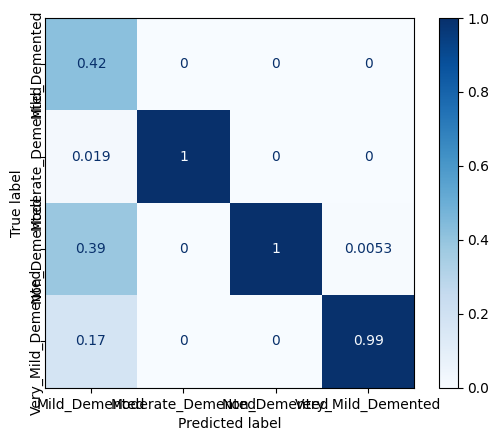

<Figure size 500x500 with 0 Axes>

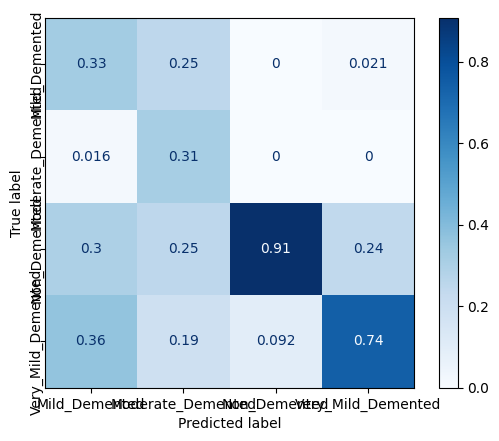

<Figure size 500x500 with 0 Axes>

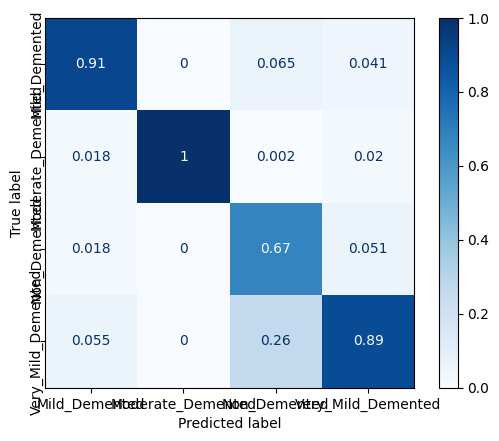

<Figure size 500x500 with 0 Axes>

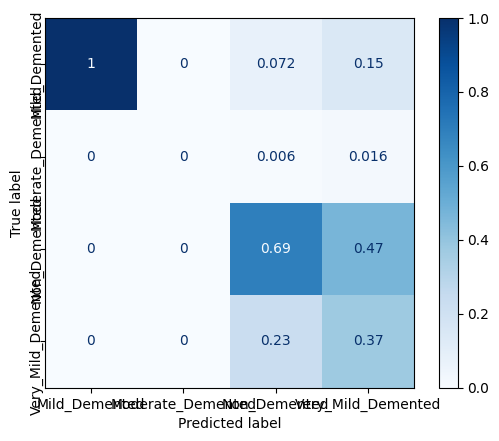

In [10]:
# experiments with Figshare
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')

train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, False)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [ ]:
!zip -0 -r Xception.zip ./*